In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [6]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet

from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run2"
    model = EEGNet_DF_HP_Wrapper(DEVICE, classifier, input_dim).to(DEVICE)
#     model= EEGNet_Wrapper(DEVICE, df)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_DF_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-DF_Multivariate-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_DF_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-DF_Multivariate-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-DF_Multivariate-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3204.002154181985


Iterations:   0%|                                   | 1/300 [00:03<15:49,  3.18s/it]

Epoch:  0
t_loss:  3204.002154181985 , v_loss:  0.6909792820612589
t_acc:  0.6131341425459073 , v_acc:  0.6024844720496895
t_recall:  0.48787142641468 , v_recall:  0.5743243243243243
t_prec:  0.48293642109599266 , v_prec:  0.5664465206185567
t_f:  0.4763797485448471 , v_f:  0.5654520917678812
////////


Iterations:   1%|▏                                  | 2/300 [00:03<08:36,  1.73s/it]

Epoch  1 , loss 3187.145325903799
Epoch  2 , loss 3170.3408011642155


Iterations:   1%|▎                                  | 3/300 [00:05<07:19,  1.48s/it]

Epoch:  2
t_loss:  3170.3408011642155 , v_loss:  0.6837844451268514
t_acc:  0.6591970121381886 , v_acc:  0.6645962732919255
t_recall:  0.5011412140925873 , v_recall:  0.5699099099099099
t_prec:  0.5027960795478748 , v_prec:  0.5862222222222222
t_f:  0.4674331705818108 , v_f:  0.57163973196689
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:48,  1.18s/it]

Epoch  3 , loss 3153.58784754136
Epoch  4 , loss 3136.870423560049


Iterations:   2%|▌                                  | 5/300 [00:07<05:51,  1.19s/it]

Epoch:  4
t_loss:  3136.870423560049 , v_loss:  0.6665934125582377
t_acc:  0.6809835045129162 , v_acc:  0.7142857142857143
t_recall:  0.5035746146772622 , v_recall:  0.5564864864864865
t_prec:  0.5175639527042215 , v_prec:  0.707615894039735
t_f:  0.44698971616563415 , v_f:  0.528880407124682
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:05,  1.04s/it]

Epoch  5 , loss 3120.194972617953
Epoch  6 , loss 3103.5769856770835


Iterations:   2%|▊                                  | 7/300 [00:08<05:19,  1.09s/it]

Epoch:  6
t_loss:  3103.5769856770835 , v_loss:  0.6476051807403564
t_acc:  0.6850295673825085 , v_acc:  0.7080745341614907
t_recall:  0.499007013354195 , v_recall:  0.53
t_prec:  0.4913401691669326 , v_prec:  0.8512658227848101
t_f:  0.42747683535281533 , v_f:  0.4692431787893666
////////


Iterations:   3%|▉                                  | 8/300 [00:09<04:48,  1.01it/s]

Epoch  7 , loss 3087.0069891237745
Epoch  8 , loss 3070.471248851103


Iterations:   3%|█                                  | 9/300 [00:10<05:03,  1.04s/it]

Epoch:  8
t_loss:  3070.471248851103 , v_loss:  0.6373981138070425
t_acc:  0.6956115779645191 , v_acc:  0.6956521739130435
t_recall:  0.509201081511371 , v_recall:  0.51
t_prec:  0.5997935852651635 , v_prec:  0.846875
t_f:  0.43988550706864443 , v_f:  0.42920193907821425
////////


Iterations:   3%|█▏                                | 10/300 [00:11<04:35,  1.05it/s]

Epoch  9 , loss 3053.9991335401346
Epoch  10 , loss 3037.5693550857845


Iterations:   4%|█▏                                | 11/300 [00:12<04:53,  1.02s/it]

Epoch:  10
t_loss:  3037.5693550857845 , v_loss:  0.6342689692974091
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5045044674105488 , v_recall:  0.5
t_prec:  0.5795404973098734 , v_prec:  0.3447204968944099
t_f:  0.4270169187048135 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:13<04:25,  1.09it/s]

Epoch  11 , loss 3021.174211090686
Epoch  12 , loss 3004.832088694853


Iterations:   4%|█▍                                | 13/300 [00:14<04:45,  1.00it/s]

Epoch:  12
t_loss:  3004.832088694853 , v_loss:  0.6340790589650472
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5044729004542897 , v_recall:  0.5
t_prec:  0.6179913591272236 , v_prec:  0.3447204968944099
t_f:  0.42394053443180435 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:20,  1.10it/s]

Epoch  13 , loss 2988.5285883884803
Epoch  14 , loss 2972.2772575827207


Iterations:   5%|█▋                                | 15/300 [00:16<04:41,  1.01it/s]

Epoch:  14
t_loss:  2972.2772575827207 , v_loss:  0.6337993840376536
t_acc:  0.6937441643323996 , v_acc:  0.6894409937888198
t_recall:  0.5006704547014178 , v_recall:  0.5
t_prec:  0.5229486376448481 , v_prec:  0.3447204968944099
t_f:  0.4163729079382051 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:18,  1.10it/s]

Epoch  15 , loss 2956.067234413297
Epoch  16 , loss 2939.925963158701


Iterations:   6%|█▉                                | 17/300 [00:18<04:38,  1.02it/s]

Epoch:  16
t_loss:  2939.925963158701 , v_loss:  0.6336913406848907
t_acc:  0.6962340491752257 , v_acc:  0.6956521739130435
t_recall:  0.5036102990625986 , v_recall:  0.51
t_prec:  0.6235750078296274 , v_prec:  0.846875
t_f:  0.42111784364602456 , v_f:  0.42920193907821425
////////


Iterations:   6%|██                                | 18/300 [00:19<04:14,  1.11it/s]

Epoch  17 , loss 2923.842084099265
Epoch  18 , loss 2907.8108388863357


Iterations:   6%|██▏                               | 19/300 [00:20<04:38,  1.01it/s]

Epoch:  18
t_loss:  2907.8108388863357 , v_loss:  0.6331145465373993
t_acc:  0.6949891067538126 , v_acc:  0.6956521739130435
t_recall:  0.5027154444764689 , v_recall:  0.51
t_prec:  0.5775517403574788 , v_prec:  0.846875
t_f:  0.4206388108738276 , v_f:  0.42920193907821425
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:14,  1.10it/s]

Epoch  19 , loss 2891.823931525735
Epoch  20 , loss 2875.8985380284926


Iterations:   7%|██▍                               | 21/300 [00:22<04:33,  1.02it/s]

Epoch:  20
t_loss:  2875.8985380284926 , v_loss:  0.6324409047762553
t_acc:  0.6977902272019919 , v_acc:  0.6956521739130435
t_recall:  0.5055914686869519 , v_recall:  0.51
t_prec:  0.6823308270676691 , v_prec:  0.846875
t_f:  0.42455390714097185 , v_f:  0.42920193907821425
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:11,  1.11it/s]

Epoch  21 , loss 2860.029114966299
Epoch  22 , loss 2844.227845435049


Iterations:   8%|██▌                               | 23/300 [00:24<04:33,  1.01it/s]

Epoch:  22
t_loss:  2844.227845435049 , v_loss:  0.6304201086362203
t_acc:  0.6943666355431062 , v_acc:  0.6956521739130435
t_recall:  0.5002552806027916 , v_recall:  0.51
t_prec:  0.514526710402999 , v_prec:  0.846875
t_f:  0.4137166365643187 , v_f:  0.42920193907821425
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:13,  1.09it/s]

Epoch  23 , loss 2828.4853276271447
Epoch  24 , loss 2812.796980315564


Iterations:   8%|██▊                               | 25/300 [00:26<04:33,  1.01it/s]

Epoch:  24
t_loss:  2812.796980315564 , v_loss:  0.6279860039552053
t_acc:  0.6968565203859322 , v_acc:  0.6956521739130435
t_recall:  0.5034826587612028 , v_recall:  0.51
t_prec:  0.6699749921850578 , v_prec:  0.846875
t_f:  0.4194516752347822 , v_f:  0.42920193907821425
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:09,  1.10it/s]

Epoch  25 , loss 2797.1474130667893
Epoch  26 , loss 2781.530642041973


Iterations:   9%|███                               | 27/300 [00:27<04:33,  1.00s/it]

Epoch:  26
t_loss:  2781.530642041973 , v_loss:  0.6254345178604126
t_acc:  0.6965452847805789 , v_acc:  0.7018633540372671
t_recall:  0.5026838775202097 , v_recall:  0.52
t_prec:  0.6665578331724491 , v_prec:  0.8490566037735849
t_f:  0.4174144390948958 , v_f:  0.44957264957264953
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:09,  1.09it/s]

Epoch  27 , loss 2765.967486213235
Epoch  28 , loss 2750.456169577206


Iterations:  10%|███▎                              | 29/300 [00:29<04:27,  1.01it/s]

Epoch:  28
t_loss:  2750.456169577206 , v_loss:  0.6230132083098093
t_acc:  0.6962340491752257 , v_acc:  0.7018633540372671
t_recall:  0.503035231468138 , v_recall:  0.52
t_prec:  0.6297016734438536 , v_prec:  0.8490566037735849
t_f:  0.4192163289012425 , v_f:  0.44957264957264953
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:05,  1.10it/s]

Epoch  29 , loss 2735.0083247166053
Epoch  30 , loss 2719.6152678844974


Iterations:  10%|███▌                              | 31/300 [00:31<04:24,  1.02it/s]

Epoch:  30
t_loss:  2719.6152678844974 , v_loss:  0.6203732987244924
t_acc:  0.6981014628073452 , v_acc:  0.7018633540372671
t_recall:  0.5049525809417933 , v_recall:  0.52
t_prec:  0.7417161613004064 , v_prec:  0.8490566037735849
t_f:  0.4218358572666722 , v_f:  0.44957264957264953
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:03,  1.10it/s]

Epoch  31 , loss 2704.2819058287378
Epoch  32 , loss 2688.9963570389095


Iterations:  11%|███▋                              | 33/300 [00:33<04:21,  1.02it/s]

Epoch:  32
t_loss:  2688.9963570389095 , v_loss:  0.617683619260788
t_acc:  0.6965452847805789 , v_acc:  0.7018633540372671
t_recall:  0.50297141131744 , v_recall:  0.52
t_prec:  0.6561298076923077 , v_prec:  0.8490566037735849
t_f:  0.4183762417414505 , v_f:  0.44957264957264953
////////


Iterations:  11%|███▊                              | 34/300 [00:34<03:58,  1.12it/s]

Epoch  33 , loss 2673.7688802083335
Epoch  34 , loss 2658.5848747702207


Iterations:  12%|███▉                              | 35/300 [00:35<04:19,  1.02it/s]

Epoch:  34
t_loss:  2658.5848747702207 , v_loss:  0.6139567891756693
t_acc:  0.6984126984126984 , v_acc:  0.7080745341614907
t_recall:  0.5069014973717078 , v_recall:  0.53
t_prec:  0.6892785445420326 , v_prec:  0.8512658227848101
t_f:  0.42760745975240416 , v_f:  0.4692431787893666
////////


Iterations:  12%|████                              | 36/300 [00:36<03:56,  1.12it/s]

Epoch  35 , loss 2643.4482086780026
Epoch  36 , loss 2628.401549096201


Iterations:  12%|████▏                             | 37/300 [00:37<04:17,  1.02it/s]

Epoch:  36
t_loss:  2628.401549096201 , v_loss:  0.6100755532582601
t_acc:  0.6968565203859322 , v_acc:  0.7080745341614907
t_recall:  0.5049203277473546 , v_recall:  0.53
t_prec:  0.64052210724365 , v_prec:  0.8512658227848101
t_f:  0.42418592019500817 , v_f:  0.4692431787893666
////////


Iterations:  13%|████▎                             | 38/300 [00:38<03:56,  1.11it/s]

Epoch  37 , loss 2613.3855363434436
Epoch  38 , loss 2598.416187959559


Iterations:  13%|████▍                             | 39/300 [00:39<04:15,  1.02it/s]

Epoch:  38
t_loss:  2598.416187959559 , v_loss:  0.6085506975650787
t_acc:  0.7005913476501712 , v_acc:  0.7142857142857143
t_recall:  0.5096176280863562 , v_recall:  0.54
t_prec:  0.7537049552267625 , v_prec:  0.8535031847133758
t_f:  0.4322036825034792 , v_f:  0.488253178551686
////////


Iterations:  13%|████▌                             | 40/300 [00:39<03:57,  1.10it/s]

Epoch  39 , loss 2583.505801930147
Epoch  40 , loss 2568.6325204886643


Iterations:  14%|████▋                             | 41/300 [00:41<04:17,  1.00it/s]

Epoch:  40
t_loss:  2568.6325204886643 , v_loss:  0.6061117649078369
t_acc:  0.6959228135698724 , v_acc:  0.7142857142857143
t_recall:  0.5033865854160662 , v_recall:  0.54
t_prec:  0.6104323308270676 , v_prec:  0.8535031847133758
t_f:  0.4209981125404011 , v_f:  0.488253178551686
////////


Iterations:  14%|████▊                             | 42/300 [00:41<03:54,  1.10it/s]

Epoch  41 , loss 2553.8041848575367
Epoch  42 , loss 2539.0115081188724


Iterations:  14%|████▊                             | 43/300 [00:43<04:15,  1.01it/s]

Epoch:  42
t_loss:  2539.0115081188724 , v_loss:  0.6036013315121332
t_acc:  0.6996576408341114 , v_acc:  0.7142857142857143
t_recall:  0.5077963519578376 , v_recall:  0.54
t_prec:  0.7542293233082706 , v_prec:  0.8535031847133758
t_f:  0.42810970174154256 , v_f:  0.488253178551686
////////


Iterations:  15%|████▉                             | 44/300 [00:43<03:52,  1.10it/s]

Epoch  43 , loss 2524.2747443704043
Epoch  44 , loss 2509.588747510723


Iterations:  15%|█████                             | 45/300 [00:44<04:12,  1.01it/s]

Epoch:  44
t_loss:  2509.588747510723 , v_loss:  0.6002827485402426
t_acc:  0.6996576408341114 , v_acc:  0.7142857142857143
t_recall:  0.50980908853845 , v_recall:  0.54
t_prec:  0.6927627438640654 , v_prec:  0.8535031847133758
t_f:  0.4345547418019834 , v_f:  0.488253178551686
////////


Iterations:  15%|█████▏                            | 46/300 [00:45<03:51,  1.10it/s]

Epoch  45 , loss 2494.9344027650122
Epoch  46 , loss 2480.338503370098


Iterations:  16%|█████▎                            | 47/300 [00:46<04:12,  1.00it/s]

Epoch:  46
t_loss:  2480.338503370098 , v_loss:  0.5966360419988632
t_acc:  0.6956115779645191 , v_acc:  0.7267080745341615
t_recall:  0.5040254731612248 , v_recall:  0.56
t_prec:  0.5986656200941916 , v_prec:  0.8580645161290323
t_f:  0.42369509878001366 , v_f:  0.5244360902255639
////////


Iterations:  16%|█████▍                            | 48/300 [00:47<03:53,  1.08it/s]

Epoch  47 , loss 2465.789244408701
Epoch  48 , loss 2451.281556372549


Iterations:  16%|█████▌                            | 49/300 [00:48<04:12,  1.01s/it]

Epoch:  48
t_loss:  2451.281556372549 , v_loss:  0.5946276982625326
t_acc:  0.6993464052287581 , v_acc:  0.7267080745341615
t_recall:  0.5090103072974568 , v_recall:  0.56
t_prec:  0.6934827884313108 , v_prec:  0.8580645161290323
t_f:  0.4326019714231394 , v_f:  0.5244360902255639
////////


Iterations:  17%|█████▋                            | 50/300 [00:49<03:50,  1.08it/s]

Epoch  49 , loss 2436.8341902190564
Epoch  50 , loss 2422.4239621629904


Iterations:  17%|█████▊                            | 51/300 [00:50<04:09,  1.00s/it]

Epoch:  50
t_loss:  2422.4239621629904 , v_loss:  0.5931285818417867
t_acc:  0.6981014628073452 , v_acc:  0.7329192546583851
t_recall:  0.5069653175224057 , v_recall:  0.5700000000000001
t_prec:  0.6707221350078494 , v_prec:  0.8603896103896104
t_f:  0.4284092493012405 , v_f:  0.5416749420721615
////////


Iterations:  17%|█████▉                            | 52/300 [00:51<03:48,  1.08it/s]

Epoch  51 , loss 2408.0721124387255
Epoch  52 , loss 2393.755313648897


Iterations:  18%|██████                            | 53/300 [00:52<04:05,  1.01it/s]

Epoch:  52
t_loss:  2393.755313648897 , v_loss:  0.5922349989414215
t_acc:  0.7005913476501712 , v_acc:  0.7267080745341615
t_recall:  0.5122054322614293 , v_recall:  0.56
t_prec:  0.6913350928024327 , v_prec:  0.8580645161290323
t_f:  0.4403460653194488 , v_f:  0.5244360902255639
////////


Iterations:  18%|██████                            | 54/300 [00:53<03:44,  1.10it/s]

Epoch  53 , loss 2379.4958113128064
Epoch  54 , loss 2365.2841413909314


Iterations:  18%|██████▏                           | 55/300 [00:54<04:01,  1.01it/s]

Epoch:  54
t_loss:  2365.2841413909314 , v_loss:  0.5922886629899343
t_acc:  0.7005913476501712 , v_acc:  0.7267080745341615
t_recall:  0.5101926956808169 , v_recall:  0.56
t_prec:  0.7333176248821867 , v_prec:  0.8580645161290323
t_f:  0.4340393133997785 , v_f:  0.5244360902255639
////////


Iterations:  19%|██████▎                           | 56/300 [00:55<03:43,  1.09it/s]

Epoch  55 , loss 2351.116464652267
Epoch  56 , loss 2336.991359336703


Iterations:  19%|██████▍                           | 57/300 [00:56<04:01,  1.00it/s]

Epoch:  56
t_loss:  2336.991359336703 , v_loss:  0.5900280574957529
t_acc:  0.6987239340180517 , v_acc:  0.7267080745341615
t_recall:  0.509425481396083 , v_recall:  0.56
t_prec:  0.6623266624645445 , v_prec:  0.8580645161290323
t_f:  0.4350609153578777 , v_f:  0.5244360902255639
////////


Iterations:  19%|██████▌                           | 58/300 [00:57<03:41,  1.09it/s]

Epoch  57 , loss 2322.892262178309
Epoch  58 , loss 2308.8378762637867


Iterations:  20%|██████▋                           | 59/300 [00:58<04:04,  1.01s/it]

Epoch:  58
t_loss:  2308.8378762637867 , v_loss:  0.5875512460867564
t_acc:  0.7005913476501712 , v_acc:  0.7391304347826086
t_recall:  0.5093300942891259 , v_recall:  0.58
t_prec:  0.7664628410159925 , v_prec:  0.8627450980392157
t_f:  0.43128013883736954 , v_f:  0.5583855799373041
////////


Iterations:  20%|██████▊                           | 60/300 [00:59<03:43,  1.07it/s]

Epoch  59 , loss 2294.826851639093
Epoch  60 , loss 2280.8626493566176


Iterations:  20%|██████▉                           | 61/300 [01:00<04:01,  1.01s/it]

Epoch:  60
t_loss:  2280.8626493566176 , v_loss:  0.5861657013495764
t_acc:  0.6993464052287581 , v_acc:  0.7329192546583851
t_recall:  0.5090103072974568 , v_recall:  0.5700000000000001
t_prec:  0.6934827884313108 , v_prec:  0.8603896103896104
t_f:  0.4326019714231394 , v_f:  0.5416749420721615
////////


Iterations:  21%|███████                           | 62/300 [01:01<03:44,  1.06it/s]

Epoch  61 , loss 2266.9274758731617
Epoch  62 , loss 2253.0333467371324


Iterations:  21%|███████▏                          | 63/300 [01:02<04:03,  1.03s/it]

Epoch:  62
t_loss:  2253.0333467371324 , v_loss:  0.5840618461370468
t_acc:  0.7021475256769374 , v_acc:  0.7391304347826086
t_recall:  0.5138990680885522 , v_recall:  0.58
t_prec:  0.722881666788937 , v_prec:  0.8627450980392157
t_f:  0.4428126820579124 , v_f:  0.5583855799373041
////////


Iterations:  21%|███████▎                          | 64/300 [01:03<03:45,  1.05it/s]

Epoch  63 , loss 2239.176164215686
Epoch  64 , loss 2225.373831954657


Iterations:  22%|███████▎                          | 65/300 [01:04<04:02,  1.03s/it]

Epoch:  64
t_loss:  2225.373831954657 , v_loss:  0.5819191237290701
t_acc:  0.6968565203859322 , v_acc:  0.7453416149068323
t_recall:  0.507795665719658 , v_recall:  0.59
t_prec:  0.6222066037465217 , v_prec:  0.8651315789473684
t_f:  0.4333649351571135 , v_f:  0.5745956048205194
////////


Iterations:  22%|███████▍                          | 66/300 [01:05<03:42,  1.05it/s]

Epoch  65 , loss 2211.621199065564
Epoch  66 , loss 2197.908088235294


Iterations:  22%|███████▌                          | 67/300 [01:06<04:02,  1.04s/it]

Epoch:  66
t_loss:  2197.908088235294 , v_loss:  0.58126829067866
t_acc:  0.7021475256769374 , v_acc:  0.7515527950310559
t_recall:  0.5136115342913219 , v_recall:  0.6
t_prec:  0.7287738750653585 , v_prec:  0.8675496688741722
t_f:  0.4419255887717245 , v_f:  0.5903307888040712
////////


Iterations:  23%|███████▋                          | 68/300 [01:07<03:41,  1.05it/s]

Epoch  67 , loss 2184.231071920956
Epoch  68 , loss 2170.5995279947915


Iterations:  23%|███████▊                          | 69/300 [01:08<04:02,  1.05s/it]

Epoch:  68
t_loss:  2170.5995279947915 , v_loss:  0.581577256321907
t_acc:  0.7002801120448179 , v_acc:  0.7453416149068323
t_recall:  0.5108315834259755 , v_recall:  0.59
t_prec:  0.7014772959357343 , v_prec:  0.8651315789473684
t_f:  0.43663036343591277 , v_f:  0.5745956048205194
////////


Iterations:  23%|███████▉                          | 70/300 [01:09<03:42,  1.03it/s]

Epoch  69 , loss 2157.0122549019607
Epoch  70 , loss 2143.4510043275122


Iterations:  24%|████████                          | 71/300 [01:10<03:59,  1.04s/it]

Epoch:  70
t_loss:  2143.4510043275122 , v_loss:  0.5795033623774847
t_acc:  0.704014939309057 , v_acc:  0.7453416149068323
t_recall:  0.5172540865483592 , v_recall:  0.5954954954954955
t_prec:  0.7338709677419355 , v_prec:  0.8212121212121212
t_f:  0.44979637213417883 , v_f:  0.5853903649268262
////////


Iterations:  24%|████████▏                         | 72/300 [01:11<03:41,  1.03it/s]

Epoch  71 , loss 2129.9300417432596
Epoch  72 , loss 2116.461971507353


Iterations:  24%|████████▎                         | 73/300 [01:12<03:55,  1.04s/it]

Epoch:  72
t_loss:  2116.461971507353 , v_loss:  0.5789334724346796
t_acc:  0.6999688764394647 , v_acc:  0.7453416149068323
t_recall:  0.5108954035766734 , v_recall:  0.5954954954954955
t_prec:  0.687641821619918 , v_prec:  0.8212121212121212
t_f:  0.43739537438532455 , v_f:  0.5853903649268262
////////


Iterations:  25%|████████▍                         | 74/300 [01:13<03:37,  1.04it/s]

Epoch  73 , loss 2103.0401204427085
Epoch  74 , loss 2089.648858762255


Iterations:  25%|████████▌                         | 75/300 [01:14<03:55,  1.05s/it]

Epoch:  74
t_loss:  2089.648858762255 , v_loss:  0.5772805015246073
t_acc:  0.6999688764394647 , v_acc:  0.7453416149068323
t_recall:  0.5108954035766734 , v_recall:  0.5954954954954955
t_prec:  0.687641821619918 , v_prec:  0.8212121212121212
t_f:  0.43739537438532455 , v_f:  0.5853903649268262
////////


Iterations:  25%|████████▌                         | 76/300 [01:15<03:35,  1.04it/s]

Epoch  75 , loss 2076.307712928922
Epoch  76 , loss 2063.0229348575367


Iterations:  26%|████████▋                         | 77/300 [01:16<03:51,  1.04s/it]

Epoch:  76
t_loss:  2063.0229348575367 , v_loss:  0.5789892176787058
t_acc:  0.7005913476501712 , v_acc:  0.7453416149068323
t_recall:  0.5104802294780473 , v_recall:  0.5954954954954955
t_prec:  0.7250471549827098 , v_prec:  0.8212121212121212
t_f:  0.43495144566155286 , v_f:  0.5853903649268262
////////


Iterations:  26%|████████▊                         | 78/300 [01:17<03:32,  1.04it/s]

Epoch  77 , loss 2049.785555970435
Epoch  78 , loss 2036.5931396484375


Iterations:  26%|████████▉                         | 79/300 [01:18<03:50,  1.04s/it]

Epoch:  78
t_loss:  2036.5931396484375 , v_loss:  0.5774611681699753
t_acc:  0.7021475256769374 , v_acc:  0.7515527950310559
t_recall:  0.5153367370747038 , v_recall:  0.6054954954954955
t_prec:  0.7001641987102938 , v_prec:  0.8274608501118568
t_f:  0.44719425339948166 , v_f:  0.6004962779156328
////////


Iterations:  27%|█████████                         | 80/300 [01:19<03:30,  1.04it/s]

Epoch  79 , loss 2023.4420357498468
Epoch  80 , loss 2010.337672813266


Iterations:  27%|█████████▏                        | 81/300 [01:20<03:46,  1.04s/it]

Epoch:  80
t_loss:  2010.337672813266 , v_loss:  0.575695718328158
t_acc:  0.7009025832555245 , v_acc:  0.7515527950310559
t_recall:  0.5127166797051921 , v_recall:  0.6054954954954955
t_prec:  0.6949810606060607 , v_prec:  0.8274608501118568
t_f:  0.44137095552975625 , v_f:  0.6004962779156328
////////


Iterations:  27%|█████████▎                        | 82/300 [01:21<03:27,  1.05it/s]

Epoch  81 , loss 1997.2901204427083
Epoch  82 , loss 1984.284699084712


Iterations:  28%|█████████▍                        | 83/300 [01:22<03:44,  1.03s/it]

Epoch:  82
t_loss:  1984.284699084712 , v_loss:  0.5749323517084122
t_acc:  0.7005913476501712 , v_acc:  0.7515527950310559
t_recall:  0.5113428308697383 , v_recall:  0.6054954954954955
t_prec:  0.7054993783671778 , v_prec:  0.8274608501118568
t_f:  0.4376653761625453 , v_f:  0.6004962779156328
////////


Iterations:  28%|█████████▌                        | 84/300 [01:23<03:24,  1.06it/s]

Epoch  83 , loss 1971.3258080575981
Epoch  84 , loss 1958.4118149701287


Iterations:  28%|█████████▋                        | 85/300 [01:24<03:38,  1.02s/it]

Epoch:  84
t_loss:  1958.4118149701287 , v_loss:  0.5743885984023412
t_acc:  0.7009025832555245 , v_acc:  0.7515527950310559
t_recall:  0.5130042135024224 , v_recall:  0.6054954954954955
t_prec:  0.6910256582572815 , v_prec:  0.8274608501118568
t_f:  0.44225450571484054 , v_f:  0.6004962779156328
////////


Iterations:  29%|█████████▋                        | 86/300 [01:25<03:19,  1.07it/s]

Epoch  85 , loss 1945.5411305147059
Epoch  86 , loss 1932.7178500306372


Iterations:  29%|█████████▊                        | 87/300 [01:26<03:35,  1.01s/it]

Epoch:  86
t_loss:  1932.7178500306372 , v_loss:  0.5728838592767715
t_acc:  0.7002801120448179 , v_acc:  0.7515527950310559
t_recall:  0.5122692524121272 , v_recall:  0.6054954954954955
t_prec:  0.6802294324001021 , v_prec:  0.8274608501118568
t_f:  0.44109374506076116 , v_f:  0.6004962779156328
////////


Iterations:  29%|█████████▉                        | 88/300 [01:26<03:17,  1.07it/s]

Epoch  87 , loss 1919.9351423674939
Epoch  88 , loss 1907.1941348805146


Iterations:  30%|██████████                        | 89/300 [01:28<03:32,  1.01s/it]

Epoch:  88
t_loss:  1907.1941348805146 , v_loss:  0.5707072565952936
t_acc:  0.7033924680983504 , v_acc:  0.7515527950310559
t_recall:  0.5162315916608337 , v_recall:  0.6054954954954955
t_prec:  0.7288468484739028 , v_prec:  0.8274608501118568
t_f:  0.44777017923006046 , v_f:  0.6004962779156328
////////


Iterations:  30%|██████████▏                       | 90/300 [01:28<03:16,  1.07it/s]

Epoch  89 , loss 1894.5102515127144
Epoch  90 , loss 1881.8714168772979


Iterations:  30%|██████████▎                       | 91/300 [01:30<03:33,  1.02s/it]

Epoch:  90
t_loss:  1881.8714168772979 , v_loss:  0.5730570952097574
t_acc:  0.7018362900715842 , v_acc:  0.7515527950310559
t_recall:  0.5154005572254018 , v_recall:  0.6054954954954955
t_prec:  0.690410199556541 , v_prec:  0.8274608501118568
t_f:  0.4479151719862939 , v_f:  0.6004962779156328
////////


Iterations:  31%|██████████▍                       | 92/300 [01:30<03:15,  1.07it/s]

Epoch  91 , loss 1869.255126953125
Epoch  92 , loss 1856.6933569814644


Iterations:  31%|██████████▌                       | 93/300 [01:32<03:32,  1.03s/it]

Epoch:  92
t_loss:  1856.6933569814644 , v_loss:  0.5727477620045344
t_acc:  0.7012138188608776 , v_acc:  0.7515527950310559
t_recall:  0.5146655961351065 , v_recall:  0.6054954954954955
t_prec:  0.6813232499208108 , v_prec:  0.8274608501118568
t_f:  0.4467625940572465 , v_f:  0.6004962779156328
////////


Iterations:  31%|██████████▋                       | 94/300 [01:32<03:13,  1.06it/s]

Epoch  93 , loss 1844.163579005821
Epoch  94 , loss 1831.673588771446


Iterations:  32%|██████████▊                       | 95/300 [01:34<03:28,  1.02s/it]

Epoch:  94
t_loss:  1831.673588771446 , v_loss:  0.5753156344095866
t_acc:  0.7012138188608776 , v_acc:  0.7329192546583851
t_recall:  0.5149531299323369 , v_recall:  0.5754954954954955
t_prec:  0.6786163178315755 , v_prec:  0.8062865497076024
t_f:  0.4476257333400191 , v_f:  0.5538441709093253
////////


Iterations:  32%|██████████▉                       | 96/300 [01:34<03:11,  1.07it/s]

Epoch  95 , loss 1819.2375105315564
Epoch  96 , loss 1806.8376752068016


Iterations:  32%|██████████▉                       | 97/300 [01:36<03:27,  1.02s/it]

Epoch:  96
t_loss:  1806.8376752068016 , v_loss:  0.5745304773251215
t_acc:  0.6984126984126984 , v_acc:  0.7329192546583851
t_recall:  0.5089142339523202 , v_recall:  0.5754954954954955
t_prec:  0.6574087538170714 , v_prec:  0.8062865497076024
t_f:  0.4340258860601064 , v_f:  0.5538441709093253
////////


Iterations:  33%|███████████                       | 98/300 [01:36<03:11,  1.06it/s]

Epoch  97 , loss 1794.4773140701593
Epoch  98 , loss 1782.1617455575981


Iterations:  33%|███████████▏                      | 99/300 [01:38<03:24,  1.02s/it]

Epoch:  98
t_loss:  1782.1617455575981 , v_loss:  0.5734432737032572
t_acc:  0.6977902272019919 , v_acc:  0.7329192546583851
t_recall:  0.5087543404564856 , v_recall:  0.5754954954954955
t_prec:  0.6403822170053555 , v_prec:  0.8062865497076024
t_f:  0.4346615614192612 , v_f:  0.5538441709093253
////////


Iterations:  33%|███████████                      | 100/300 [01:38<03:08,  1.06it/s]

Epoch  99 , loss 1769.8845238779106
Epoch  100 , loss 1757.6676815257354


Iterations:  34%|███████████                      | 101/300 [01:39<03:23,  1.02s/it]

Epoch:  100
t_loss:  1757.6676815257354 , v_loss:  0.5730099926392237
t_acc:  0.7024587612822907 , v_acc:  0.7391304347826086
t_recall:  0.514410315532315 , v_recall:  0.5854954954954955
t_prec:  0.7258993373303881 , v_prec:  0.8142384105960265
t_f:  0.4438366304006165 , v_f:  0.5698473282442748
////////


Iterations:  34%|███████████▏                     | 102/300 [01:40<03:06,  1.06it/s]

Epoch  101 , loss 1745.4890519684436
Epoch  102 , loss 1733.3613999310662


Iterations:  34%|███████████▎                     | 103/300 [01:41<03:19,  1.01s/it]

Epoch:  102
t_loss:  1733.3613999310662 , v_loss:  0.5713449716567993
t_acc:  0.7033924680983504 , v_acc:  0.7453416149068323
t_recall:  0.5153689902691426 , v_recall:  0.5954954954954955
t_prec:  0.7464529381556746 , v_prec:  0.8212121212121212
t_f:  0.4451415736689557 , v_f:  0.5853903649268262
////////


Iterations:  35%|███████████▍                     | 104/300 [01:42<03:03,  1.07it/s]

Epoch  103 , loss 1721.2896417356005
Epoch  104 , loss 1709.2485160079657


Iterations:  35%|███████████▌                     | 105/300 [01:43<03:17,  1.01s/it]

Epoch:  104
t_loss:  1709.2485160079657 , v_loss:  0.5729034692049026
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5185641152331151 , v_recall:  0.5754954954954955
t_prec:  0.7336231216535207 , v_prec:  0.8062865497076024
t_f:  0.4526738526098423 , v_f:  0.5538441709093253
////////


Iterations:  35%|███████████▋                     | 106/300 [01:44<03:02,  1.06it/s]

Epoch  105 , loss 1697.242711684283
Epoch  106 , loss 1685.2739640778186


Iterations:  36%|███████████▊                     | 107/300 [01:45<03:17,  1.02s/it]

Epoch:  106
t_loss:  1685.2739640778186 , v_loss:  0.5736190925041834
t_acc:  0.7024587612822907 , v_acc:  0.7329192546583851
t_recall:  0.5167105859101577 , v_recall:  0.5754954954954955
t_prec:  0.6930780209324453 , v_prec:  0.8062865497076024
t_f:  0.450783372169368 , v_f:  0.5538441709093253
////////


Iterations:  36%|███████████▉                     | 108/300 [01:46<03:01,  1.05it/s]

Epoch  107 , loss 1673.3501622817096
Epoch  108 , loss 1661.464578067555


Iterations:  36%|███████████▉                     | 109/300 [01:47<03:16,  1.03s/it]

Epoch:  108
t_loss:  1661.464578067555 , v_loss:  0.5731679151455561
t_acc:  0.7071272953625894 , v_acc:  0.7329192546583851
t_recall:  0.5209288919998353 , v_recall:  0.5754954954954955
t_prec:  0.7836812144212524 , v_prec:  0.8062865497076024
t_f:  0.45558189924107495 , v_f:  0.5538441709093253
////////


Iterations:  37%|████████████                     | 110/300 [01:48<03:02,  1.04it/s]

Epoch  109 , loss 1649.6172305836396
Epoch  110 , loss 1637.8122486787684


Iterations:  37%|████████████▏                    | 111/300 [01:49<03:13,  1.02s/it]

Epoch:  110
t_loss:  1637.8122486787684 , v_loss:  0.5721974124511083
t_acc:  0.7055711173358232 , v_acc:  0.7329192546583851
t_recall:  0.5198103237671731 , v_recall:  0.5754954954954955
t_prec:  0.7449318973709218 , v_prec:  0.8062865497076024
t_f:  0.45483063956057834 , v_f:  0.5538441709093253
////////


Iterations:  37%|████████████▎                    | 112/300 [01:50<02:57,  1.06it/s]

Epoch  111 , loss 1626.0562959558824
Epoch  112 , loss 1614.359073414522


Iterations:  38%|████████████▍                    | 113/300 [01:51<03:14,  1.04s/it]

Epoch:  112
t_loss:  1614.359073414522 , v_loss:  0.5728462785482407
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5147616694802433 , v_recall:  0.5754954954954955
t_prec:  0.7081226295828066 , v_prec:  0.8062865497076024
t_f:  0.4454523205909422 , v_f:  0.5538441709093253
////////


Iterations:  38%|████████████▌                    | 114/300 [01:52<03:01,  1.03it/s]

Epoch  113 , loss 1602.7001402611827
Epoch  114 , loss 1591.101500268076


Iterations:  38%|████████████▋                    | 115/300 [01:53<03:17,  1.07s/it]

Epoch:  114
t_loss:  1591.101500268076 , v_loss:  0.5724442601203918
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5177015138414242 , v_recall:  0.5754954954954955
t_prec:  0.7495710673649991 , v_prec:  0.8062865497076024
t_f:  0.4500880378691787 , v_f:  0.5538441709093253
////////


Iterations:  39%|████████████▊                    | 116/300 [01:54<03:01,  1.01it/s]

Epoch  115 , loss 1579.5354650160846
Epoch  116 , loss 1567.9925752527574


Iterations:  39%|████████████▊                    | 117/300 [01:56<03:16,  1.08s/it]

Epoch:  116
t_loss:  1567.9925752527574 , v_loss:  0.5730802665154139
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5173179066990571 , v_recall:  0.5754954954954955
t_prec:  0.7219056663501108 , v_prec:  0.8062865497076024
t_f:  0.4505134904415759 , v_f:  0.5538441709093253
////////


Iterations:  39%|████████████▉                    | 118/300 [01:56<03:03,  1.01s/it]

Epoch  117 , loss 1556.495028626685
Epoch  118 , loss 1545.0391271254596


Iterations:  40%|█████████████                    | 119/300 [01:58<03:16,  1.09s/it]

Epoch:  118
t_loss:  1545.0391271254596 , v_loss:  0.5716104209423065
t_acc:  0.6984126984126984 , v_acc:  0.7329192546583851
t_recall:  0.5100643691412415 , v_recall:  0.5754954954954955
t_prec:  0.6478407548285641 , v_prec:  0.8062865497076024
t_f:  0.43761146309852283 , v_f:  0.5538441709093253
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:58<02:59,  1.00it/s]

Epoch  119 , loss 1533.6266252106311
Epoch  120 , loss 1522.2560628255208


Iterations:  40%|█████████████▎                   | 121/300 [02:00<03:13,  1.08s/it]

Epoch:  120
t_loss:  1522.2560628255208 , v_loss:  0.5742766360441843
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5179890476386544 , v_recall:  0.5754954954954955
t_prec:  0.7438330170777989 , v_prec:  0.8062865497076024
t_f:  0.45095347755555815 , v_f:  0.5538441709093253
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:00<02:55,  1.01it/s]

Epoch  121 , loss 1510.9293212890625
Epoch  122 , loss 1499.6428055108763


Iterations:  41%|█████████████▌                   | 123/300 [02:02<03:09,  1.07s/it]

Epoch:  122
t_loss:  1499.6428055108763 , v_loss:  0.5720964322487513
t_acc:  0.7030812324929971 , v_acc:  0.7329192546583851
t_recall:  0.5162954118115316 , v_recall:  0.5754954954954955
t_prec:  0.716697491056871 , v_prec:  0.8062865497076024
t_f:  0.4484943899472461 , v_f:  0.5538441709093253
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:02<02:51,  1.03it/s]

Epoch  123 , loss 1488.4010033700981
Epoch  124 , loss 1477.2159208409926


Iterations:  42%|█████████████▊                   | 125/300 [02:04<03:13,  1.11s/it]

Epoch:  124
t_loss:  1477.2159208409926 , v_loss:  0.5746112217505773
t_acc:  0.7005913476501712 , v_acc:  0.7329192546583851
t_recall:  0.5116303646669687 , v_recall:  0.5754954954954955
t_prec:  0.7002994011976047 , v_prec:  0.8062865497076024
t_f:  0.4385626038990479 , v_f:  0.5538441709093253
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:05<02:55,  1.01s/it]

Epoch  125 , loss 1466.0763154871324
Epoch  126 , loss 1454.9919050628064


Iterations:  42%|█████████████▉                   | 127/300 [02:06<03:08,  1.09s/it]

Epoch:  126
t_loss:  1454.9919050628064 , v_loss:  0.5744941929976145
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5173179066990571 , v_recall:  0.5754954954954955
t_prec:  0.7219056663501108 , v_prec:  0.8062865497076024
t_f:  0.4505134904415759 , v_f:  0.5538441709093253
////////


Iterations:  43%|██████████████                   | 128/300 [02:07<02:55,  1.02s/it]

Epoch  127 , loss 1443.9507697610295
Epoch  128 , loss 1432.9515309053309


Iterations:  43%|██████████████▏                  | 129/300 [02:08<03:06,  1.09s/it]

Epoch:  128
t_loss:  1432.9515309053309 , v_loss:  0.5745776842037836
t_acc:  0.7061935885465297 , v_acc:  0.7329192546583851
t_recall:  0.5214078862491593 , v_recall:  0.5754954954954955
t_prec:  0.7395245748917394 , v_prec:  0.8062865497076024
t_f:  0.4585192379102517 , v_f:  0.5538441709093253
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:09<02:54,  1.03s/it]

Epoch  129 , loss 1421.9879126455269
Epoch  130 , loss 1411.078089096967


Iterations:  44%|██████████████▍                  | 131/300 [02:10<03:05,  1.10s/it]

Epoch:  130
t_loss:  1411.078089096967 , v_loss:  0.5743807355562845
t_acc:  0.702769996887644 , v_acc:  0.7329192546583851
t_recall:  0.5154966305705384 , v_recall:  0.5754954954954955
t_prec:  0.7184847390283547 , v_prec:  0.8062865497076024
t_f:  0.44661124991050133 , v_f:  0.5538441709093253
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:11<02:53,  1.03s/it]

Epoch  131 , loss 1400.2134195963542
Epoch  132 , loss 1389.3992441214766


Iterations:  44%|██████████████▋                  | 133/300 [02:12<03:03,  1.10s/it]

Epoch:  132
t_loss:  1389.3992441214766 , v_loss:  0.5731389820575714
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5141866018857825 , v_recall:  0.5754954954954955
t_prec:  0.7175189393939394 , v_prec:  0.8062865497076024
t_f:  0.44369615446615673 , v_f:  0.5538441709093253
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:13<02:48,  1.01s/it]

Epoch  133 , loss 1378.6247965494792
Epoch  134 , loss 1367.8823577282476


Iterations:  45%|██████████████▊                  | 135/300 [02:14<03:00,  1.10s/it]

Epoch:  134
t_loss:  1367.8823577282476 , v_loss:  0.572523906826973
t_acc:  0.7018362900715842 , v_acc:  0.7329192546583851
t_recall:  0.5162631586170928 , v_recall:  0.5754954954954955
t_prec:  0.6819622034991452 , v_prec:  0.8062865497076024
t_f:  0.45048880287925963 , v_f:  0.5538441709093253
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:15<02:44,  1.00s/it]

Epoch  135 , loss 1357.18605669807
Epoch  136 , loss 1346.535675647212


Iterations:  46%|███████████████                  | 137/300 [02:16<02:54,  1.07s/it]

Epoch:  136
t_loss:  1346.535675647212 , v_loss:  0.5731937090555826
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5156242708719342 , v_recall:  0.5754954954954955
t_prec:  0.6966261730669584 , v_prec:  0.8062865497076024
t_f:  0.4480599335591349 , v_f:  0.5538441709093253
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:17<02:40,  1.01it/s]

Epoch  137 , loss 1335.9367915134803
Epoch  138 , loss 1325.383762733609


Iterations:  46%|███████████████▎                 | 139/300 [02:19<03:02,  1.13s/it]

Epoch:  138
t_loss:  1325.383762733609 , v_loss:  0.5739299356937408
t_acc:  0.7005913476501712 , v_acc:  0.7329192546583851
t_recall:  0.5119178984641989 , v_recall:  0.5754954954954955
t_prec:  0.695600756859035 , v_prec:  0.8062865497076024
t_f:  0.43945615982241953 , v_f:  0.5538441709093253
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:20<02:52,  1.08s/it]

Epoch  139 , loss 1314.8674196729473
Epoch  140 , loss 1304.3931334252452


Iterations:  47%|███████████████▌                 | 141/300 [02:21<03:09,  1.19s/it]

Epoch:  140
t_loss:  1304.3931334252452 , v_loss:  0.5731325397888819
t_acc:  0.704014939309057 , v_acc:  0.7329192546583851
t_recall:  0.5198418907234322 , v_recall:  0.5754954954954955
t_prec:  0.6999253235977432 , v_prec:  0.8062865497076024
t_f:  0.4574459414756846 , v_f:  0.5538441709093253
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:22<03:01,  1.15s/it]

Epoch  141 , loss 1293.9447428385417
Epoch  142 , loss 1283.5299120136335


Iterations:  48%|███████████████▋                 | 143/300 [02:24<03:14,  1.24s/it]

Epoch:  142
t_loss:  1283.5299120136335 , v_loss:  0.5727277547121048
t_acc:  0.7005913476501712 , v_acc:  0.7329192546583851
t_recall:  0.5136431012475811 , v_recall:  0.5754954954954955
t_prec:  0.6748179803735359 , v_prec:  0.8062865497076024
t_f:  0.4447415733243656 , v_f:  0.5538441709093253
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:25<02:59,  1.15s/it]

Epoch  143 , loss 1273.1623295802697
Epoch  144 , loss 1262.8265141505822


Iterations:  48%|███████████████▉                 | 145/300 [02:26<03:10,  1.23s/it]

Epoch:  144
t_loss:  1262.8265141505822 , v_loss:  0.5743892143170038
t_acc:  0.7015250544662309 , v_acc:  0.7329192546583851
t_recall:  0.5128765732010266 , v_recall:  0.5754954954954955
t_prec:  0.716421123858149 , v_prec:  0.8062865497076024
t_f:  0.44075928906173856 , v_f:  0.5538441709093253
////////


Iterations:  49%|████████████████                 | 146/300 [02:27<02:55,  1.14s/it]

Epoch  145 , loss 1252.5379758348652
Epoch  146 , loss 1242.29197064568


Iterations:  49%|████████████████▏                | 147/300 [02:28<03:08,  1.23s/it]

Epoch:  146
t_loss:  1242.29197064568 , v_loss:  0.5720362464586893
t_acc:  0.7046374105197635 , v_acc:  0.7329192546583851
t_recall:  0.5197142504220365 , v_recall:  0.5754954954954955
t_prec:  0.7171428571428571 , v_prec:  0.8062865497076024
t_f:  0.4560731458662792 , v_f:  0.5538441709093253
////////


Iterations:  49%|████████████████▎                | 148/300 [02:29<02:53,  1.14s/it]

Epoch  147 , loss 1232.0913373161766
Epoch  148 , loss 1221.9268631280638


Iterations:  50%|████████████████▍                | 149/300 [02:31<03:01,  1.21s/it]

Epoch:  148
t_loss:  1221.9268631280638 , v_loss:  0.5739865054686865
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5153367370747038 , v_recall:  0.5754954954954955
t_prec:  0.7001641987102938 , v_prec:  0.8062865497076024
t_f:  0.44719425339948166 , v_f:  0.5538441709093253
////////


Iterations:  50%|████████████████▌                | 150/300 [02:32<02:49,  1.13s/it]

Epoch  149 , loss 1211.7953120212928
Epoch  150 , loss 1201.7160620595894


Iterations:  50%|████████████████▌                | 151/300 [02:33<03:01,  1.22s/it]

Epoch:  150
t_loss:  1201.7160620595894 , v_loss:  0.5736709584792455
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5144741356830128 , v_recall:  0.5754954954954955
t_prec:  0.7126181099716402 , v_prec:  0.8062865497076024
t_f:  0.44457602702299936 , v_f:  0.5538441709093253
////////


Iterations:  51%|████████████████▋                | 152/300 [02:34<02:49,  1.14s/it]

Epoch  151 , loss 1191.6820571001838
Epoch  152 , loss 1181.6875981349572


Iterations:  51%|████████████████▊                | 153/300 [02:35<02:56,  1.20s/it]

Epoch:  152
t_loss:  1181.6875981349572 , v_loss:  0.5738875418901443
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5192990763234103 , v_recall:  0.5754954954954955
t_prec:  0.7428723588001612 , v_prec:  0.8062865497076024
t_f:  0.45382733237251904 , v_f:  0.5538441709093253
////////


Iterations:  51%|████████████████▉                | 154/300 [02:36<02:39,  1.10s/it]

Epoch  153 , loss 1171.7305788526348
Epoch  154 , loss 1161.8306884765625


Iterations:  52%|█████████████████                | 155/300 [02:38<02:50,  1.18s/it]

Epoch:  154
t_loss:  1161.8306884765625 , v_loss:  0.5733040769894918
t_acc:  0.7002801120448179 , v_acc:  0.7329192546583851
t_recall:  0.5145695227899699 , v_recall:  0.5754954954954955
t_prec:  0.6604761904761904 , v_prec:  0.8062865497076024
t_f:  0.4480489351625151 , v_f:  0.5538441709093253
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:38<02:37,  1.09s/it]

Epoch  155 , loss 1151.9495083678003
Epoch  156 , loss 1142.1414268344056


Iterations:  52%|█████████████████▎               | 157/300 [02:40<02:48,  1.18s/it]

Epoch:  156
t_loss:  1142.1414268344056 , v_loss:  0.5737482259670893
t_acc:  0.7024587612822907 , v_acc:  0.7329192546583851
t_recall:  0.5167105859101577 , v_recall:  0.5754954954954955
t_prec:  0.6930780209324453 , v_prec:  0.8062865497076024
t_f:  0.450783372169368 , v_f:  0.5538441709093253
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:41<02:28,  1.05s/it]

Epoch  157 , loss 1132.3595449410234
Epoch  158 , loss 1122.6259215111827


Iterations:  53%|█████████████████▍               | 159/300 [02:42<02:39,  1.13s/it]

Epoch:  158
t_loss:  1122.6259215111827 , v_loss:  0.5731885880231857
t_acc:  0.7018362900715842 , v_acc:  0.7329192546583851
t_recall:  0.5159756248198625 , v_recall:  0.5754954954954955
t_prec:  0.6845861084681255 , v_prec:  0.8062865497076024
t_f:  0.4496343834082161 , v_f:  0.5538441709093253
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:43<02:23,  1.03s/it]

Epoch  159 , loss 1112.9351950252758
Epoch  160 , loss 1103.3117221009497


Iterations:  54%|█████████████████▋               | 161/300 [02:44<02:32,  1.10s/it]

Epoch:  160
t_loss:  1103.3117221009497 , v_loss:  0.5743208130200704
t_acc:  0.702769996887644 , v_acc:  0.7329192546583851
t_recall:  0.5163592319622294 , v_recall:  0.5754954954954955
t_prec:  0.7058754102135989 , v_prec:  0.8062865497076024
t_f:  0.44921341332181164 , v_f:  0.5538441709093253
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:45<02:17,  1.00it/s]

Epoch  161 , loss 1093.7282379748774
Epoch  162 , loss 1084.195073146446


Iterations:  54%|█████████████████▉               | 163/300 [02:46<02:29,  1.09s/it]

Epoch:  162
t_loss:  1084.195073146446 , v_loss:  0.5719796766837438
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5178929742935178 , v_recall:  0.5754954954954955
t_prec:  0.7137329908738183 , v_prec:  0.8062865497076024
t_f:  0.45222885222885223 , v_f:  0.5538441709093253
////////


Iterations:  55%|██████████████████               | 164/300 [02:47<02:15,  1.00it/s]

Epoch  163 , loss 1074.7206624348958
Epoch  164 , loss 1065.2852017271753


Iterations:  55%|██████████████████▏              | 165/300 [02:48<02:29,  1.10s/it]

Epoch:  164
t_loss:  1065.2852017271753 , v_loss:  0.5749882857004801
t_acc:  0.7024587612822907 , v_acc:  0.7329192546583851
t_recall:  0.515272916924006 , v_recall:  0.5754954954954955
t_prec:  0.7110907366424281 , v_prec:  0.8062865497076024
t_f:  0.44646813995095463 , v_f:  0.5538441709093253
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:49<02:15,  1.01s/it]

Epoch  165 , loss 1055.8826664943322
Epoch  166 , loss 1046.527104396446


Iterations:  56%|██████████████████▎              | 167/300 [02:50<02:33,  1.15s/it]

Epoch:  166
t_loss:  1046.527104396446 , v_loss:  0.5741547495126724
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5178929742935178 , v_recall:  0.5754954954954955
t_prec:  0.7137329908738183 , v_prec:  0.8062865497076024
t_f:  0.45222885222885223 , v_f:  0.5538441709093253
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:51<02:16,  1.04s/it]

Epoch  167 , loss 1037.2149969362745
Epoch  168 , loss 1027.9479812921263


Iterations:  56%|██████████████████▌              | 169/300 [02:53<02:30,  1.15s/it]

Epoch:  168
t_loss:  1027.9479812921263 , v_loss:  0.5743229389190674
t_acc:  0.7043261749144102 , v_acc:  0.7329192546583851
t_recall:  0.5203531381671951 , v_recall:  0.5754954954954955
t_prec:  0.7022112631244034 , v_prec:  0.8062865497076024
t_f:  0.4584329286121859 , v_f:  0.5538441709093253
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:53<02:14,  1.03s/it]

Epoch  169 , loss 1018.726795869715
Epoch  170 , loss 1009.5306516161152


Iterations:  57%|██████████████████▊              | 171/300 [02:55<02:26,  1.14s/it]

Epoch:  170
t_loss:  1009.5306516161152 , v_loss:  0.5763851006825765
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5167744060608556 , v_recall:  0.5754954954954955
t_prec:  0.6847619047619047 , v_prec:  0.8062865497076024
t_f:  0.4514878826069854 , v_f:  0.5538441709093253
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:56<02:14,  1.05s/it]

Epoch  171 , loss 1000.3787781958487
Epoch  172 , loss 991.2650828642004


Iterations:  58%|███████████████████              | 173/300 [02:57<02:24,  1.14s/it]

Epoch:  172
t_loss:  991.2650828642004 , v_loss:  0.5737937440474828
t_acc:  0.7055711173358232 , v_acc:  0.7329192546583851
t_recall:  0.5198103237671731 , v_recall:  0.5754954954954955
t_prec:  0.7449318973709218 , v_prec:  0.8062865497076024
t_f:  0.45483063956057834 , v_f:  0.5538441709093253
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:58<02:14,  1.07s/it]

Epoch  173 , loss 982.1939649394914
Epoch  174 , loss 973.1721311083027


Iterations:  58%|███████████████████▎             | 175/300 [02:59<02:20,  1.12s/it]

Epoch:  174
t_loss:  973.1721311083027 , v_loss:  0.5739792138338089
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5153367370747038 , v_recall:  0.5754954954954955
t_prec:  0.7001641987102938 , v_prec:  0.8062865497076024
t_f:  0.44719425339948166 , v_f:  0.5538441709093253
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:00<02:13,  1.07s/it]

Epoch  175 , loss 964.1855097751992
Epoch  176 , loss 955.2396204331342


Iterations:  59%|███████████████████▍             | 177/300 [03:01<02:17,  1.12s/it]

Epoch:  176
t_loss:  955.2396204331342 , v_loss:  0.5737532824277878
t_acc:  0.704014939309057 , v_acc:  0.7329192546583851
t_recall:  0.5184042217372805 , v_recall:  0.5754954954954955
t_prec:  0.7161823028062293 , v_prec:  0.8062865497076024
t_f:  0.45323047251687565 , v_f:  0.5538441709093253
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:02<02:03,  1.01s/it]

Epoch  177 , loss 946.3474611768536
Epoch  178 , loss 937.5135689529718


Iterations:  60%|███████████████████▋             | 179/300 [03:03<02:10,  1.08s/it]

Epoch:  178
t_loss:  937.5135689529718 , v_loss:  0.5734124680360159
t_acc:  0.7046374105197635 , v_acc:  0.7267080745341615
t_recall:  0.5194267166248061 , v_recall:  0.5709909909909909
t_prec:  0.7208511899808605 , v_prec:  0.7609271523178809
t_f:  0.45522845519986893 , v_f:  0.5493638676844783
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:04<02:00,  1.01s/it]

Epoch  179 , loss 928.7113539751838
Epoch  180 , loss 919.9609398935355


Iterations:  60%|███████████████████▉             | 181/300 [03:06<02:14,  1.13s/it]

Epoch:  180
t_loss:  919.9609398935355 , v_loss:  0.5736301789681116
t_acc:  0.702769996887644 , v_acc:  0.7267080745341615
t_recall:  0.5154966305705384 , v_recall:  0.5709909909909909
t_prec:  0.7184847390283547 , v_prec:  0.7609271523178809
t_f:  0.44661124991050133 , v_f:  0.5493638676844783
////////


Iterations:  61%|████████████████████             | 182/300 [03:06<02:05,  1.06s/it]

Epoch  181 , loss 911.266191071155
Epoch  182 , loss 902.6146814682904


Iterations:  61%|████████████████████▏            | 183/300 [03:08<02:18,  1.19s/it]

Epoch:  182
t_loss:  902.6146814682904 , v_loss:  0.574360802769661
t_acc:  0.7018362900715842 , v_acc:  0.7267080745341615
t_recall:  0.5145379558337108 , v_recall:  0.5709909909909909
t_prec:  0.7009326588681631 , v_prec:  0.7609271523178809
t_f:  0.4453101235073374 , v_f:  0.5493638676844783
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:09<02:10,  1.12s/it]

Epoch  183 , loss 893.9938438265931
Epoch  184 , loss 885.4057425704657


Iterations:  62%|████████████████████▎            | 185/300 [03:10<02:22,  1.24s/it]

Epoch:  184
t_loss:  885.4057425704657 , v_loss:  0.5766502122084299
t_acc:  0.7046374105197635 , v_acc:  0.7267080745341615
t_recall:  0.5174139800441937 , v_recall:  0.5709909909909909
t_prec:  0.7558030134003575 , v_prec:  0.7609271523178809
t_f:  0.449219069639317 , v_f:  0.5493638676844783
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:11<02:13,  1.17s/it]

Epoch  185 , loss 876.84327248966
Epoch  186 , loss 868.3185185451133


Iterations:  62%|████████████████████▌            | 187/300 [03:13<02:21,  1.26s/it]

Epoch:  186
t_loss:  868.3185185451133 , v_loss:  0.5758097966512045
t_acc:  0.7033924680983504 , v_acc:  0.7267080745341615
t_recall:  0.5188193958359067 , v_recall:  0.5709909909909909
t_prec:  0.695158979419495 , v_prec:  0.7609271523178809
t_f:  0.45546682505964187 , v_f:  0.5493638676844783
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:14<02:12,  1.18s/it]

Epoch  187 , loss 859.8455140356924
Epoch  188 , loss 851.4024382946538


Iterations:  63%|████████████████████▊            | 189/300 [03:15<02:18,  1.25s/it]

Epoch:  188
t_loss:  851.4024382946538 , v_loss:  0.5766525616248449
t_acc:  0.7052598817304699 , v_acc:  0.7267080745341615
t_recall:  0.5204492115123317 , v_recall:  0.5709909909909909
t_prec:  0.7252380952380952 , v_prec:  0.7609271523178809
t_f:  0.4572194616811026 , v_f:  0.5493638676844783
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:16<02:06,  1.15s/it]

Epoch  189 , loss 843.0062902113971
Epoch  190 , loss 834.6365799249387


Iterations:  64%|█████████████████████            | 191/300 [03:18<02:13,  1.23s/it]

Epoch:  190
t_loss:  834.6365799249387 , v_loss:  0.5785650312900543
t_acc:  0.7043261749144102 , v_acc:  0.7329192546583851
t_recall:  0.5189154691810434 , v_recall:  0.5754954954954955
t_prec:  0.7185537583254044 , v_prec:  0.8062865497076024
t_f:  0.45423033845282385 , v_f:  0.5538441709093253
////////


Iterations:  64%|█████████████████████            | 192/300 [03:19<02:02,  1.13s/it]

Epoch  191 , loss 826.3167365579044
Epoch  192 , loss 818.0285895852481


Iterations:  64%|█████████████████████▏           | 193/300 [03:20<02:05,  1.18s/it]

Epoch:  192
t_loss:  818.0285895852481 , v_loss:  0.5757042765617371
t_acc:  0.7043261749144102 , v_acc:  0.7267080745341615
t_recall:  0.519490536775504 , v_recall:  0.5709909909909909
t_prec:  0.7113915131787869 , v_prec:  0.7609271523178809
t_f:  0.4559215048212803 , v_f:  0.5493638676844783
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:21<01:51,  1.05s/it]

Epoch  193 , loss 809.762965782016
Epoch  194 , loss 801.5734695733762


Iterations:  65%|█████████████████████▍           | 195/300 [03:22<01:57,  1.12s/it]

Epoch:  194
t_loss:  801.5734695733762 , v_loss:  0.5769344717264175
t_acc:  0.7052598817304699 , v_acc:  0.7267080745341615
t_recall:  0.5201616777151014 , v_recall:  0.5709909909909909
t_prec:  0.7292065407339602 , v_prec:  0.7609271523178809
t_f:  0.4563765511846953 , v_f:  0.5493638676844783
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:23<01:45,  1.02s/it]

Epoch  195 , loss 793.4192468979779
Epoch  196 , loss 785.3226749195773


Iterations:  66%|█████████████████████▋           | 197/300 [03:24<01:54,  1.11s/it]

Epoch:  196
t_loss:  785.3226749195773 , v_loss:  0.5782199651002884
t_acc:  0.7037037037037037 , v_acc:  0.7267080745341615
t_recall:  0.5184680418879785 , v_recall:  0.5709909909909909
t_prec:  0.7066317912388285 , v_prec:  0.7609271523178809
t_f:  0.45393041789254196 , v_f:  0.5493638676844783
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:25<01:42,  1.00s/it]

Epoch  197 , loss 777.2682698567709
Epoch  198 , loss 769.2548313514859


Iterations:  66%|█████████████████████▉           | 199/300 [03:26<01:56,  1.15s/it]

Epoch:  198
t_loss:  769.2548313514859 , v_loss:  0.5763626446326574
t_acc:  0.7037037037037037 , v_acc:  0.7267080745341615
t_recall:  0.5170303729018267 , v_recall:  0.5709909909909909
t_prec:  0.7264710534640937 , v_prec:  0.7609271523178809
t_f:  0.44965058619473613 , v_f:  0.5493638676844783
////////


Iterations:  67%|██████████████████████           | 200/300 [03:27<01:43,  1.04s/it]

Epoch  199 , loss 761.3001014859069
Epoch  200 , loss 753.3861466950061


Iterations:  67%|██████████████████████           | 201/300 [03:28<01:54,  1.16s/it]

Epoch:  200
t_loss:  753.3861466950061 , v_loss:  0.5768311123053232
t_acc:  0.706504824151883 , v_acc:  0.7267080745341615
t_recall:  0.5230692688818436 , v_recall:  0.5709909909909909
t_prec:  0.7260402004644032 , v_prec:  0.7609271523178809
t_f:  0.46283600683843357 , v_f:  0.5493638676844783
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:29<01:41,  1.03s/it]

Epoch  201 , loss 745.5327196308211
Epoch  202 , loss 737.7168255974265


Iterations:  68%|██████████████████████▎          | 203/300 [03:31<01:50,  1.14s/it]

Epoch:  202
t_loss:  737.7168255974265 , v_loss:  0.5792364478111267
t_acc:  0.7074385309679427 , v_acc:  0.7267080745341615
t_recall:  0.5243154774159015 , v_recall:  0.5709909909909909
t_prec:  0.7350167144221585 , v_prec:  0.7609271523178809
t_f:  0.46495535714285713 , v_f:  0.5493638676844783
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:31<01:41,  1.06s/it]

Epoch  203 , loss 729.9639354032629
Epoch  204 , loss 722.2640380859375


Iterations:  68%|██████████████████████▌          | 205/300 [03:33<01:46,  1.12s/it]

Epoch:  204
t_loss:  722.2640380859375 , v_loss:  0.5798699756463369
t_acc:  0.6999688764394647 , v_acc:  0.7329192546583851
t_recall:  0.5126206063600555 , v_recall:  0.5754954954954955
t_prec:  0.6678296790207578 , v_prec:  0.8062865497076024
t_f:  0.44271340870979586 , v_f:  0.5538441709093253
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:33<01:37,  1.04s/it]

Epoch  205 , loss 714.5896187576593
Epoch  206 , loss 706.9763099820007


Iterations:  69%|██████████████████████▊          | 207/300 [03:35<01:44,  1.13s/it]

Epoch:  206
t_loss:  706.9763099820007 , v_loss:  0.5791861365238825
t_acc:  0.7068160597572363 , v_acc:  0.7267080745341615
t_recall:  0.5224303811366849 , v_recall:  0.5709909909909909
t_prec:  0.7432766354398221 , v_prec:  0.7609271523178809
t_f:  0.4605032184648906 , v_f:  0.5493638676844783
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:36<01:38,  1.07s/it]

Epoch  207 , loss 699.4128621419271
Epoch  208 , loss 691.8920347924326


Iterations:  70%|██████████████████████▉          | 209/300 [03:37<01:41,  1.12s/it]

Epoch:  208
t_loss:  691.8920347924326 , v_loss:  0.5799185434977213
t_acc:  0.7015250544662309 , v_acc:  0.7329192546583851
t_recall:  0.5146017759844086 , v_recall:  0.5754954954954955
t_prec:  0.6905720085980416 , v_prec:  0.8062865497076024
t_f:  0.44603896448286623 , v_f:  0.5538441709093253
////////


Iterations:  70%|███████████████████████          | 210/300 [03:38<01:32,  1.03s/it]

Epoch  209 , loss 684.412473192402
Epoch  210 , loss 676.9735526290594


Iterations:  70%|███████████████████████▏         | 211/300 [03:39<01:39,  1.11s/it]

Epoch:  210
t_loss:  676.9735526290594 , v_loss:  0.580002119143804
t_acc:  0.7043261749144102 , v_acc:  0.7329192546583851
t_recall:  0.519490536775504 , v_recall:  0.5754954954954955
t_prec:  0.7113915131787869 , v_prec:  0.8062865497076024
t_f:  0.4559215048212803 , v_f:  0.5538441709093253
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:40<01:30,  1.03s/it]

Epoch  211 , loss 669.5797932942709
Epoch  212 , loss 662.20637661803


Iterations:  71%|███████████████████████▍         | 213/300 [03:41<01:36,  1.11s/it]

Epoch:  212
t_loss:  662.20637661803 , v_loss:  0.5815248638391495
t_acc:  0.7043261749144102 , v_acc:  0.7329192546583851
t_recall:  0.518627935383813 , v_recall:  0.5754954954954955
t_prec:  0.7225121591343789 , v_prec:  0.8062865497076024
t_f:  0.45337963195106057 , v_f:  0.5538441709093253
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:42<01:26,  1.00s/it]

Epoch  213 , loss 654.8748049268536
Epoch  214 , loss 647.6035347732843


Iterations:  72%|███████████████████████▋         | 215/300 [03:43<01:31,  1.08s/it]

Epoch:  214
t_loss:  647.6035347732843 , v_loss:  0.5804542352755865
t_acc:  0.7046374105197635 , v_acc:  0.7267080745341615
t_recall:  0.5200017842192668 , v_recall:  0.5709909909909909
t_prec:  0.7136667969895416 , v_prec:  0.7609271523178809
t_f:  0.456914447296797 , v_f:  0.5493638676844783
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:44<01:23,  1.00it/s]

Epoch  215 , loss 640.3757503733915
Epoch  216 , loss 633.1820989870557


Iterations:  72%|███████████████████████▊         | 217/300 [03:45<01:31,  1.10s/it]

Epoch:  216
t_loss:  633.1820989870557 , v_loss:  0.5801646510759989
t_acc:  0.7018362900715842 , v_acc:  0.7329192546583851
t_recall:  0.5154005572254018 , v_recall:  0.5754954954954955
t_prec:  0.690410199556541 , v_prec:  0.8062865497076024
t_f:  0.4479151719862939 , v_f:  0.5538441709093253
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:46<01:23,  1.02s/it]

Epoch  217 , loss 626.0270325903799
Epoch  218 , loss 618.9196071250766


Iterations:  73%|████████████████████████         | 219/300 [03:48<01:34,  1.17s/it]

Epoch:  218
t_loss:  618.9196071250766 , v_loss:  0.5805610070625941
t_acc:  0.7080610021786492 , v_acc:  0.7329192546583851
t_recall:  0.523612769520045 , v_recall:  0.5754954954954955
t_prec:  0.7641941626314227 , v_prec:  0.8062865497076024
t_f:  0.4619608529235339 , v_f:  0.5538441709093253
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:49<01:27,  1.09s/it]

Epoch  219 , loss 611.8381981943168
Epoch  220 , loss 604.7919730392157


Iterations:  74%|████████████████████████▎        | 221/300 [03:50<01:34,  1.19s/it]

Epoch:  220
t_loss:  604.7919730392157 , v_loss:  0.5821134001016617
t_acc:  0.7049486461251168 , v_acc:  0.7329192546583851
t_recall:  0.5202254978657992 , v_recall:  0.5754954954954955
t_prec:  0.7193627937440457 , v_prec:  0.8062865497076024
t_f:  0.45706693323218295 , v_f:  0.5538441709093253
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:51<01:26,  1.11s/it]

Epoch  221 , loss 597.7858767041973
Epoch  222 , loss 590.8269940544577


Iterations:  74%|████████████████████████▌        | 223/300 [03:52<01:32,  1.20s/it]

Epoch:  222
t_loss:  590.8269940544577 , v_loss:  0.583658441901207
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5156242708719342 , v_recall:  0.5754954954954955
t_prec:  0.6966261730669584 , v_prec:  0.8062865497076024
t_f:  0.4480599335591349 , v_f:  0.5538441709093253
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:53<01:25,  1.12s/it]

Epoch  223 , loss 583.9001883712469
Epoch  224 , loss 577.034439386106


Iterations:  75%|████████████████████████▊        | 225/300 [03:55<01:33,  1.24s/it]

Epoch:  224
t_loss:  577.034439386106 , v_loss:  0.5843717704216639
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5195866101206407 , v_recall:  0.5754954954954955
t_prec:  0.7379927956774064 , v_prec:  0.8062865497076024
t_f:  0.45468050615760575 , v_f:  0.5538441709093253
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:56<01:26,  1.17s/it]

Epoch  225 , loss 570.2089125689338
Epoch  226 , loss 563.4342471852023


Iterations:  76%|████████████████████████▉        | 227/300 [03:57<01:30,  1.24s/it]

Epoch:  226
t_loss:  563.4342471852023 , v_loss:  0.5833121091127396
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5195866101206407 , v_recall:  0.5754954954954955
t_prec:  0.7379927956774064 , v_prec:  0.8062865497076024
t_f:  0.45468050615760575 , v_f:  0.5538441709093253
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:58<01:21,  1.13s/it]

Epoch  227 , loss 556.7079874674479
Epoch  228 , loss 550.0345937691483


Iterations:  76%|█████████████████████████▏       | 229/300 [04:00<01:24,  1.19s/it]

Epoch:  228
t_loss:  550.0345937691483 , v_loss:  0.5844074139992396
t_acc:  0.7033924680983504 , v_acc:  0.7329192546583851
t_recall:  0.516519125458064 , v_recall:  0.5754954954954955
t_prec:  0.7239089184060721 , v_prec:  0.8062865497076024
t_f:  0.44863926671279963 , v_f:  0.5538441709093253
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:00<01:14,  1.06s/it]

Epoch  229 , loss 543.4128322227328
Epoch  230 , loss 536.8323208678003


Iterations:  77%|█████████████████████████▍       | 231/300 [04:02<01:16,  1.11s/it]

Epoch:  230
t_loss:  536.8323208678003 , v_loss:  0.5846320490042368
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5224619480929441 , v_recall:  0.5754954954954955
t_prec:  0.703327922077922 , v_prec:  0.8062865497076024
t_f:  0.46302620444532294 , v_f:  0.5538441709093253
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:02<01:08,  1.01s/it]

Epoch  231 , loss 530.2934031767004
Epoch  232 , loss 523.804838292739


Iterations:  78%|█████████████████████████▋       | 233/300 [04:04<01:14,  1.12s/it]

Epoch:  232
t_loss:  523.804838292739 , v_loss:  0.5840794245402018
t_acc:  0.7058823529411765 , v_acc:  0.7329192546583851
t_recall:  0.5203215712109359 , v_recall:  0.5754954954954955
t_prec:  0.7469231538923354 , v_prec:  0.8062865497076024
t_f:  0.45583218407490744 , v_f:  0.5538441709093253
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:04<01:06,  1.01s/it]

Epoch  233 , loss 517.3539344937194
Epoch  234 , loss 510.9354631012561


Iterations:  78%|█████████████████████████▊       | 235/300 [04:06<01:14,  1.14s/it]

Epoch:  234
t_loss:  510.9354631012561 , v_loss:  0.5843050281206766
t_acc:  0.7033924680983504 , v_acc:  0.7329192546583851
t_recall:  0.517381726849755 , v_recall:  0.5754954954954955
t_prec:  0.7112017210326196 , v_prec:  0.8062865497076024
t_f:  0.4512254724057003 , v_f:  0.5538441709093253
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:07<01:05,  1.02s/it]

Epoch  235 , loss 504.5647140203738
Epoch  236 , loss 498.23253496955425


Iterations:  79%|██████████████████████████       | 237/300 [04:08<01:10,  1.13s/it]

Epoch:  236
t_loss:  498.23253496955425 , v_loss:  0.586963047583898
t_acc:  0.7033924680983504 , v_acc:  0.7329192546583851
t_recall:  0.5170941930525247 , v_recall:  0.5754954954954955
t_prec:  0.7151246473602395 , v_prec:  0.8062865497076024
t_f:  0.45036689308448846 , v_f:  0.5538441709093253
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:09<01:05,  1.05s/it]

Epoch  237 , loss 491.9362278358609
Epoch  238 , loss 485.6857251933977


Iterations:  80%|██████████████████████████▎      | 239/300 [04:10<01:07,  1.11s/it]

Epoch:  238
t_loss:  485.6857251933977 , v_loss:  0.5859815031290054
t_acc:  0.7012138188608776 , v_acc:  0.7329192546583851
t_recall:  0.5132279271489549 , v_recall:  0.5754954954954955
t_prec:  0.6984733872407023 , v_prec:  0.8062865497076024
t_f:  0.4423940207330618 , v_f:  0.5538441709093253
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:11<01:03,  1.05s/it]

Epoch  239 , loss 479.47268557081037
Epoch  240 , loss 473.29602290134807


Iterations:  80%|██████████████████████████▌      | 241/300 [04:12<01:05,  1.11s/it]

Epoch:  240
t_loss:  473.29602290134807 , v_loss:  0.5862313111623129
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5184680418879785 , v_recall:  0.5754954954954955
t_prec:  0.7066317912388285 , v_prec:  0.8062865497076024
t_f:  0.45393041789254196 , v_f:  0.5538441709093253
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:13<00:59,  1.02s/it]

Epoch  241 , loss 467.14233278760724
Epoch  242 , loss 461.0459732354856


Iterations:  81%|██████████████████████████▋      | 243/300 [04:14<01:02,  1.09s/it]

Epoch:  242
t_loss:  461.0459732354856 , v_loss:  0.5868879159291586
t_acc:  0.7024587612822907 , v_acc:  0.7329192546583851
t_recall:  0.5167105859101577 , v_recall:  0.5754954954954955
t_prec:  0.6930780209324453 , v_prec:  0.8062865497076024
t_f:  0.450783372169368 , v_f:  0.5538441709093253
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:15<00:55,  1.01it/s]

Epoch  243 , loss 454.97801836799175
Epoch  244 , loss 448.9701400457644


Iterations:  82%|██████████████████████████▉      | 245/300 [04:16<01:00,  1.11s/it]

Epoch:  244
t_loss:  448.9701400457644 , v_loss:  0.5877092778682709
t_acc:  0.7043261749144102 , v_acc:  0.7329192546583851
t_recall:  0.5183404015865827 , v_recall:  0.5754954954954955
t_prec:  0.7267579980994615 , v_prec:  0.8062865497076024
t_f:  0.4525254837024836 , v_f:  0.5538441709093253
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:17<00:57,  1.06s/it]

Epoch  245 , loss 443.0226302801394
Epoch  246 , loss 437.12249217313877


Iterations:  82%|███████████████████████████▏     | 247/300 [04:19<01:02,  1.17s/it]

Epoch:  246
t_loss:  437.12249217313877 , v_loss:  0.5874410370985667
t_acc:  0.6999688764394647 , v_acc:  0.7329192546583851
t_recall:  0.5129081401572858 , v_recall:  0.5754954954954955
t_prec:  0.665400443178221 , v_prec:  0.8062865497076024
t_f:  0.44358718990092355 , v_f:  0.5538441709093253
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:20<00:57,  1.11s/it]

Epoch  247 , loss 431.2401278626685
Epoch  248 , loss 425.3900792738971


Iterations:  83%|███████████████████████████▍     | 249/300 [04:21<01:02,  1.22s/it]

Epoch:  248
t_loss:  425.3900792738971 , v_loss:  0.5884815901517868
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5201616777151014 , v_recall:  0.5754954954954955
t_prec:  0.7292065407339602 , v_prec:  0.8062865497076024
t_f:  0.4563765511846953 , v_f:  0.5538441709093253
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:22<00:56,  1.14s/it]

Epoch  249 , loss 419.57372149299175
Epoch  250 , loss 413.79601631912533


Iterations:  84%|███████████████████████████▌     | 251/300 [04:24<01:00,  1.23s/it]

Epoch:  250
t_loss:  413.79601631912533 , v_loss:  0.5879865437746048
t_acc:  0.7058823529411765 , v_acc:  0.7329192546583851
t_recall:  0.5214717063998573 , v_recall:  0.5754954954954955
t_prec:  0.7293690743817809 , v_prec:  0.8062865497076024
t_f:  0.45920353287194204 , v_f:  0.5538441709093253
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:25<00:55,  1.15s/it]

Epoch  251 , loss 408.06019861557905
Epoch  252 , loss 402.35694316789215


Iterations:  84%|███████████████████████████▊     | 253/300 [04:26<00:57,  1.22s/it]

Epoch:  252
t_loss:  402.35694316789215 , v_loss:  0.5888558427492777
t_acc:  0.7033924680983504 , v_acc:  0.7329192546583851
t_recall:  0.517381726849755 , v_recall:  0.5754954954954955
t_prec:  0.7112017210326196 , v_prec:  0.8062865497076024
t_f:  0.4512254724057003 , v_f:  0.5538441709093253
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:27<00:52,  1.14s/it]

Epoch  253 , loss 396.70931647805605
Epoch  254 , loss 391.0929876589308


Iterations:  85%|████████████████████████████     | 255/300 [04:28<00:55,  1.22s/it]

Epoch:  254
t_loss:  391.0929876589308 , v_loss:  0.5864516943693161
t_acc:  0.7055711173358232 , v_acc:  0.7329192546583851
t_recall:  0.5198103237671731 , v_recall:  0.5754954954954955
t_prec:  0.7449318973709218 , v_prec:  0.8062865497076024
t_f:  0.45483063956057834 , v_f:  0.5538441709093253
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:29<00:49,  1.13s/it]

Epoch  255 , loss 385.5205592735141
Epoch  256 , loss 379.99169921875


Iterations:  86%|████████████████████████████▎    | 257/300 [04:31<00:52,  1.23s/it]

Epoch:  256
t_loss:  379.99169921875 , v_loss:  0.5881154437859853
t_acc:  0.7033924680983504 , v_acc:  0.7329192546583851
t_recall:  0.5179567944442157 , v_recall:  0.5754954954954955
t_prec:  0.7041404884746609 , v_prec:  0.8062865497076024
t_f:  0.45293226323021607 , v_f:  0.5538441709093253
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:32<00:47,  1.14s/it]

Epoch  257 , loss 374.49482756969974
Epoch  258 , loss 369.0274927475873


Iterations:  86%|████████████████████████████▍    | 259/300 [04:33<00:50,  1.22s/it]

Epoch:  258
t_loss:  369.0274927475873 , v_loss:  0.5886065562566122
t_acc:  0.7033924680983504 , v_acc:  0.7329192546583851
t_recall:  0.5176692606469854 , v_recall:  0.5754954954954955
t_prec:  0.7075491976827919 , v_prec:  0.8062865497076024
t_f:  0.45208058917832017 , v_f:  0.5538441709093253
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:34<00:45,  1.13s/it]

Epoch  259 , loss 363.599474140242
Epoch  260 , loss 358.19970284256283


Iterations:  87%|████████████████████████████▋    | 261/300 [04:35<00:47,  1.22s/it]

Epoch:  260
t_loss:  358.19970284256283 , v_loss:  0.5884965161482493
t_acc:  0.704014939309057 , v_acc:  0.7329192546583851
t_recall:  0.5172540865483592 , v_recall:  0.5754954954954955
t_prec:  0.7338709677419355 , v_prec:  0.8062865497076024
t_f:  0.44979637213417883 , v_f:  0.5538441709093253
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:36<00:42,  1.12s/it]

Epoch  261 , loss 352.85413315716914
Epoch  262 , loss 347.55872240253524


Iterations:  88%|████████████████████████████▉    | 263/300 [04:38<00:45,  1.22s/it]

Epoch:  262
t_loss:  347.55872240253524 , v_loss:  0.5902200986941656
t_acc:  0.7018362900715842 , v_acc:  0.7329192546583851
t_recall:  0.5154005572254018 , v_recall:  0.5754954954954955
t_prec:  0.690410199556541 , v_prec:  0.8062865497076024
t_f:  0.4479151719862939 , v_f:  0.5538441709093253
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:39<00:40,  1.14s/it]

Epoch  263 , loss 342.3134633980545
Epoch  264 , loss 337.1172467400046


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:40<00:43,  1.23s/it]

Epoch:  264
t_loss:  337.1172467400046 , v_loss:  0.5908504873514175
t_acc:  0.707749766573296 , v_acc:  0.7267080745341615
t_recall:  0.5225264544818216 , v_recall:  0.5654954954954955
t_prec:  0.7737142285371222 , v_prec:  0.7969771241830066
t_f:  0.4592872178268128 , v_f:  0.5373563218390804
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:41<00:38,  1.13s/it]

Epoch  265 , loss 331.9759736902574
Epoch  266 , loss 326.8837256338082


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:43<00:40,  1.24s/it]

Epoch:  266
t_loss:  326.8837256338082 , v_loss:  0.5894027600685755
t_acc:  0.7052598817304699 , v_acc:  0.7267080745341615
t_recall:  0.5187240087289496 , v_recall:  0.5654954954954955
t_prec:  0.7537950664136622 , v_prec:  0.7969771241830066
t_f:  0.4521105829769373 , v_f:  0.5373563218390804
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:44<00:37,  1.16s/it]

Epoch  267 , loss 321.83795106177234
Epoch  268 , loss 316.84983077703737


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:45<00:40,  1.29s/it]

Epoch:  268
t_loss:  316.84983077703737 , v_loss:  0.5879290848970413
t_acc:  0.7030812324929971 , v_acc:  0.7267080745341615
t_recall:  0.5162954118115316 , v_recall:  0.5654954954954955
t_prec:  0.716697491056871 , v_prec:  0.7969771241830066
t_f:  0.4484943899472461 , v_f:  0.5373563218390804
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:46<00:36,  1.21s/it]

Epoch  269 , loss 311.89676262350645
Epoch  270 , loss 307.00812904507507


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:48<00:37,  1.29s/it]

Epoch:  270
t_loss:  307.00812904507507 , v_loss:  0.5892761697371801
t_acc:  0.7074385309679427 , v_acc:  0.7267080745341615
t_recall:  0.5225902746325195 , v_recall:  0.5654954954954955
t_prec:  0.7610133206470029 , v_prec:  0.7969771241830066
t_f:  0.4599752822585836 , v_f:  0.5373563218390804
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:49<00:33,  1.21s/it]

Epoch  271 , loss 302.1433344822304
Epoch  272 , loss 297.32307882869947


Iterations:  91%|██████████████████████████████   | 273/300 [04:50<00:34,  1.26s/it]

Epoch:  272
t_loss:  297.32307882869947 , v_loss:  0.5887709061304728
t_acc:  0.7018362900715842 , v_acc:  0.7267080745341615
t_recall:  0.5159756248198625 , v_recall:  0.5654954954954955
t_prec:  0.6845861084681255 , v_prec:  0.7969771241830066
t_f:  0.4496343834082161 , v_f:  0.5373563218390804
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:51<00:29,  1.15s/it]

Epoch  273 , loss 292.5299904019225
Epoch  274 , loss 287.7660378848805


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:52<00:30,  1.22s/it]

Epoch:  274
t_loss:  287.7660378848805 , v_loss:  0.5896355509757996
t_acc:  0.7074385309679427 , v_acc:  0.7329192546583851
t_recall:  0.5237404098214409 , v_recall:  0.5754954954954955
t_prec:  0.7426470588235294 , v_prec:  0.8062865497076024
t_f:  0.4633086212656464 , v_f:  0.5538441709093253
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:53<00:26,  1.10s/it]

Epoch  275 , loss 283.0543607823989
Epoch  276 , loss 278.3717340207567


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:54<00:26,  1.14s/it]

Epoch:  276
t_loss:  278.3717340207567 , v_loss:  0.589272752404213
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5170303729018267 , v_recall:  0.5754954954954955
t_prec:  0.7264710534640937 , v_prec:  0.8062865497076024
t_f:  0.44965058619473613 , v_f:  0.5538441709093253
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:55<00:22,  1.03s/it]

Epoch  277 , loss 273.7190809062883
Epoch  278 , loss 269.0876147700291


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:57<00:23,  1.13s/it]

Epoch:  278
t_loss:  269.0876147700291 , v_loss:  0.589469701051712
t_acc:  0.7049486461251168 , v_acc:  0.7267080745341615
t_recall:  0.5193628964741083 , v_recall:  0.5654954954954955
t_prec:  0.7312913273949395 , v_prec:  0.7969771241830066
t_f:  0.4545304116732688 , v_f:  0.5373563218390804
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:57<00:20,  1.03s/it]

Epoch  279 , loss 264.4894271551394
Epoch  280 , loss 259.9382545620787


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:59<00:22,  1.17s/it]

Epoch:  280
t_loss:  259.9382545620787 , v_loss:  0.589106410741806
t_acc:  0.6999688764394647 , v_acc:  0.7267080745341615
t_recall:  0.5131956739545162 , v_recall:  0.5654954954954955
t_prec:  0.6631493506493507 , v_prec:  0.7969771241830066
t_f:  0.4444574381991517 , v_f:  0.5373563218390804
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:00<00:18,  1.04s/it]

Epoch  281 , loss 255.43456672219668
Epoch  282 , loss 250.97250216614967


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:01<00:19,  1.14s/it]

Epoch:  282
t_loss:  250.97250216614967 , v_loss:  0.5893030315637589
t_acc:  0.7068160597572363 , v_acc:  0.7267080745341615
t_recall:  0.5221428473394546 , v_recall:  0.5654954954954955
t_prec:  0.7477477708049671 , v_prec:  0.7969771241830066
t_f:  0.45966644291467906 , v_f:  0.5373563218390804
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:02<00:16,  1.05s/it]

Epoch  283 , loss 246.56622464049096
Epoch  284 , loss 242.21016378963694


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:03<00:16,  1.12s/it]

Epoch:  284
t_loss:  242.21016378963694 , v_loss:  0.5923930009206136
t_acc:  0.7061935885465297 , v_acc:  0.7267080745341615
t_recall:  0.5225580214380807 , v_recall:  0.5654954954954955
t_prec:  0.7241170855870187 , v_prec:  0.7969771241830066
t_f:  0.46185335222095103 , v_f:  0.5373563218390804
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:04<00:14,  1.07s/it]

Epoch  285 , loss 237.89754261690027
Epoch  286 , loss 233.6402686623966


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:05<00:14,  1.13s/it]

Epoch:  286
t_loss:  233.6402686623966 , v_loss:  0.5895334929227829
t_acc:  0.7037037037037037 , v_acc:  0.7267080745341615
t_recall:  0.5176054404962874 , v_recall:  0.5654954954954955
t_prec:  0.7176710484637314 , v_prec:  0.7969771241830066
t_f:  0.4513729057734361 , v_f:  0.5373563218390804
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:06<00:12,  1.05s/it]

Epoch  287 , loss 229.42785734288833
Epoch  288 , loss 225.24282986510033


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:07<00:12,  1.12s/it]

Epoch:  288
t_loss:  225.24282986510033 , v_loss:  0.5902984440326691
t_acc:  0.7058823529411765 , v_acc:  0.7267080745341615
t_recall:  0.5214717063998573 , v_recall:  0.5654954954954955
t_prec:  0.7293690743817809 , v_prec:  0.7969771241830066
t_f:  0.45920353287194204 , v_f:  0.5373563218390804
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:08<00:10,  1.01s/it]

Epoch  289 , loss 221.1072722790288
Epoch  290 , loss 217.00512485878141


Iterations:  97%|████████████████████████████████ | 291/300 [05:09<00:09,  1.09s/it]

Epoch:  290
t_loss:  217.00512485878141 , v_loss:  0.5929786960283915
t_acc:  0.7033924680983504 , v_acc:  0.7204968944099379
t_recall:  0.5170941930525247 , v_recall:  0.5554954954954955
t_prec:  0.7151246473602395 , v_prec:  0.7857142857142857
t_f:  0.45036689308448846 , v_f:  0.5203574975173784
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:10<00:08,  1.03s/it]

Epoch  291 , loss 212.92187679515166
Epoch  292 , loss 208.88914370069315


Iterations:  98%|████████████████████████████████▏| 293/300 [05:12<00:08,  1.14s/it]

Epoch:  292
t_loss:  208.88914370069315 , v_loss:  0.5934644689162573
t_acc:  0.7061935885465297 , v_acc:  0.7204968944099379
t_recall:  0.5216954200463897 , v_recall:  0.5554954954954955
t_prec:  0.7353053548745634 , v_prec:  0.7857142857142857
t_f:  0.459357790053988 , v_f:  0.5203574975173784
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:13<00:06,  1.08s/it]

Epoch  293 , loss 204.89218528597962
Epoch  294 , loss 200.94172847972197


Iterations:  98%|████████████████████████████████▍| 295/300 [05:14<00:06,  1.22s/it]

Epoch:  294
t_loss:  200.94172847972197 , v_loss:  0.5932367990414301
t_acc:  0.7021475256769374 , v_acc:  0.7204968944099379
t_recall:  0.5150492032774735 , v_recall:  0.5554954954954955
t_prec:  0.7039848197343453 , v_prec:  0.7857142857142857
t_f:  0.4463250558700412 , v_f:  0.5203574975173784
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:15<00:04,  1.14s/it]

Epoch  295 , loss 197.02377648447074
Epoch  296 , loss 193.14466798071768


Iterations:  99%|████████████████████████████████▋| 297/300 [05:17<00:03,  1.24s/it]

Epoch:  296
t_loss:  193.14466798071768 , v_loss:  0.594796230395635
t_acc:  0.7071272953625894 , v_acc:  0.7204968944099379
t_recall:  0.5229416285804477 , v_recall:  0.5554954954954955
t_prec:  0.7450713517740202 , v_prec:  0.7857142857142857
t_f:  0.46149261844708733 , v_f:  0.5203574975173784
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:18<00:02,  1.18s/it]

Epoch  297 , loss 189.31869267482384
Epoch  298 , loss 185.51567586263022


Iterations: 100%|████████████████████████████████▉| 299/300 [05:19<00:01,  1.24s/it]

Epoch:  298
t_loss:  185.51567586263022 , v_loss:  0.5953224251667658
t_acc:  0.7055711173358232 , v_acc:  0.7204968944099379
t_recall:  0.5198103237671731 , v_recall:  0.5554954954954955
t_prec:  0.7449318973709218 , v_prec:  0.7857142857142857
t_f:  0.45483063956057834 , v_f:  0.5203574975173784
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:20<00:00,  1.07s/it]

Epoch  299 , loss 181.75908855363434


110 6

c0_acc 0.990990990990991 , c1_acc 0.12 , b_acc 0.5554954954954955


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3182.6549527037378


Iterations:   0%|                                   | 1/300 [00:01<06:15,  1.25s/it]

Epoch:  0
t_loss:  3182.6549527037378 , v_loss:  0.6924492518107096
t_acc:  0.5330630068621335 , v_acc:  0.5952380952380952
t_recall:  0.5022475835833075 , v_recall:  0.5161607875307629
t_prec:  0.5019520207747075 , v_prec:  0.5173202039739757
t_f:  0.4947352529759978 , v_f:  0.5159322033898305
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:52,  1.02it/s]

Epoch  1 , loss 3165.7924613204655
Epoch  2 , loss 3148.9760981541053


Iterations:   1%|▎                                  | 3/300 [00:03<05:30,  1.11s/it]

Epoch:  2
t_loss:  3148.9760981541053 , v_loss:  0.691023568312327
t_acc:  0.6126013724267 , v_acc:  0.5892857142857143
t_recall:  0.5192667425208887 , v_recall:  0.48129614438063983
t_prec:  0.5215067751511933 , v_prec:  0.476010101010101
t_f:  0.5187152046684669 , v_f:  0.47268343720147377
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:49,  1.02it/s]

Epoch  3 , loss 3132.229362936581
Epoch  4 , loss 3115.5345913756128


Iterations:   2%|▌                                  | 5/300 [00:05<05:27,  1.11s/it]

Epoch:  4
t_loss:  3115.5345913756128 , v_loss:  0.6845244963963827
t_acc:  0.6509669369931379 , v_acc:  0.6428571428571429
t_recall:  0.507568872185636 , v_recall:  0.49499589827727647
t_prec:  0.514070351758794 , v_prec:  0.4881184261784184
t_f:  0.48740390200201034 , v_f:  0.4586466165413534
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:01,  1.03s/it]

Epoch  5 , loss 3098.8865033318016
Epoch  6 , loss 3082.2788133808212


Iterations:   2%|▊                                  | 7/300 [00:07<05:44,  1.18s/it]

Epoch:  6
t_loss:  3082.2788133808212 , v_loss:  0.6730045080184937
t_acc:  0.6743605739238927 , v_acc:  0.6845238095238095
t_recall:  0.5053228976312795 , v_recall:  0.5101722723543889
t_prec:  0.5181620965351077 , v_prec:  0.5945121951219512
t_f:  0.46068263028446793 , v_f:  0.440105640445199
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:25,  1.11s/it]

Epoch  7 , loss 3065.7328335631128
Epoch  8 , loss 3049.2449831495096


Iterations:   3%|█                                  | 9/300 [00:10<06:02,  1.24s/it]

Epoch:  8
t_loss:  3049.2449831495096 , v_loss:  0.6648776332537333
t_acc:  0.6859014348097318 , v_acc:  0.6904761904761905
t_recall:  0.5026443241503753 , v_recall:  0.5094339622641509
t_prec:  0.518518995492595 , v_prec:  0.844311377245509
t_f:  0.43728651668257146 , v_f:  0.4263199369582348
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:44,  1.19s/it]

Epoch  9 , loss 3032.8042231541053
Epoch  10 , loss 3016.4184809666053


Iterations:   4%|█▏                                | 11/300 [00:12<06:03,  1.26s/it]

Epoch:  10
t_loss:  3016.4184809666053 , v_loss:  0.6624786059061686
t_acc:  0.6905801621958827 , v_acc:  0.6845238095238095
t_recall:  0.502252870392718 , v_recall:  0.5
t_prec:  0.5263931750981564 , v_prec:  0.34226190476190477
t_f:  0.42808188385520785 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:35,  1.16s/it]

Epoch  11 , loss 3000.071576286765
Epoch  12 , loss 2983.780857460172


Iterations:   4%|█▍                                | 13/300 [00:15<05:52,  1.23s/it]

Epoch:  12
t_loss:  2983.780857460172 , v_loss:  0.6625711917877197
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5067997563470445 , v_recall:  0.5
t_prec:  0.6113042562157607 , v_prec:  0.34226190476190477
t_f:  0.43145616274947757 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:19,  1.12s/it]

Epoch  13 , loss 2967.5467936197915
Epoch  14 , loss 2951.370481004902


Iterations:   5%|█▋                                | 15/300 [00:17<05:37,  1.18s/it]

Epoch:  14
t_loss:  2951.370481004902 , v_loss:  0.6647185782591502
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.5019905986737004 , v_recall:  0.5
t_prec:  0.5566991410014666 , v_prec:  0.34226190476190477
t_f:  0.41957956478555036 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:00,  1.06s/it]

Epoch  15 , loss 2935.2390998391543
Epoch  16 , loss 2919.176322189032


Iterations:   6%|█▉                                | 17/300 [00:19<05:15,  1.11s/it]

Epoch:  16
t_loss:  2919.176322189032 , v_loss:  0.6675592561562856
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5009952993368503 , v_recall:  0.5
t_prec:  0.5564861198079732 , v_prec:  0.34226190476190477
t_f:  0.41501977318037714 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:20<04:43,  1.01s/it]

Epoch  17 , loss 2903.166929955576
Epoch  18 , loss 2887.181257659314


Iterations:   6%|██▏                               | 19/300 [00:21<05:12,  1.11s/it]

Epoch:  18
t_loss:  2887.181257659314 , v_loss:  0.6699666678905487
t_acc:  0.6933873986275733 , v_acc:  0.6845238095238095
t_recall:  0.4982070820259973 , v_recall:  0.5
t_prec:  0.3475609756097561 , v_prec:  0.34226190476190477
t_f:  0.40946767360471537 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:41,  1.00s/it]

Epoch  19 , loss 2871.253279143689
Epoch  20 , loss 2855.352285347733


Iterations:   7%|██▍                               | 21/300 [00:23<05:15,  1.13s/it]

Epoch:  20
t_loss:  2855.352285347733 , v_loss:  0.6727677484353384
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5024691698559919 , v_recall:  0.5
t_prec:  0.6401325401795033 , v_prec:  0.34226190476190477
t_f:  0.41741477922672154 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:46,  1.03s/it]

Epoch  21 , loss 2839.5260847503064
Epoch  22 , loss 2823.723575367647


Iterations:   8%|██▌                               | 23/300 [00:25<05:09,  1.12s/it]

Epoch:  22
t_loss:  2823.723575367647 , v_loss:  0.6747900346914927
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5015384615384615 , v_recall:  0.5
t_prec:  0.8482672494536372 , v_prec:  0.34226190476190477
t_f:  0.4136306057520136 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:53,  1.06s/it]

Epoch  23 , loss 2807.9795304840686
Epoch  24 , loss 2792.277401194853


Iterations:   8%|██▊                               | 25/300 [00:27<05:08,  1.12s/it]

Epoch:  24
t_loss:  2792.277401194853 , v_loss:  0.6773349046707153
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5001291820386397 , v_recall:  0.5
t_prec:  0.5146354166666667 , v_prec:  0.34226190476190477
t_f:  0.41209213314811655 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:49,  1.06s/it]

Epoch  25 , loss 2776.6222905177697
Epoch  26 , loss 2761.011910232843


Iterations:   9%|███                               | 27/300 [00:30<05:03,  1.11s/it]

Epoch:  26
t_loss:  2761.011910232843 , v_loss:  0.6788728634516398
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5018917583238516 , v_recall:  0.5
t_prec:  0.6608427141963727 , v_prec:  0.34226190476190477
t_f:  0.41547512351718013 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:35,  1.01s/it]

Epoch  27 , loss 2745.463029450061
Epoch  28 , loss 2729.933052810968


Iterations:  10%|███▎                              | 29/300 [00:32<04:52,  1.08s/it]

Epoch:  28
t_loss:  2729.933052810968 , v_loss:  0.6819823682308197
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5005774115321404 , v_recall:  0.5
t_prec:  0.5980637101811368 , v_prec:  0.34226190476190477
t_f:  0.41231346966585436 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:33,  1.01s/it]

Epoch  29 , loss 2714.462459788603
Epoch  30 , loss 2699.0241507735905


Iterations:  10%|███▌                              | 31/300 [00:34<05:00,  1.12s/it]

Epoch:  30
t_loss:  2699.0241507735905 , v_loss:  0.6836257874965668
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5029173993494925 , v_recall:  0.5
t_prec:  0.6985607008760951 , v_prec:  0.34226190476190477
t_f:  0.4176464921117294 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:41,  1.05s/it]

Epoch  31 , loss 2683.634693818934
Epoch  32 , loss 2668.293758616728


Iterations:  11%|███▋                              | 33/300 [00:36<05:15,  1.18s/it]

Epoch:  32
t_loss:  2668.293758616728 , v_loss:  0.6842186450958252
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5021158730706019 , v_recall:  0.5
t_prec:  0.705532979055955 , v_prec:  0.34226190476190477
t_f:  0.4155888872635618 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:57,  1.12s/it]

Epoch  33 , loss 2652.9868642769607
Epoch  34 , loss 2637.741335401348


Iterations:  12%|███▉                              | 35/300 [00:39<05:27,  1.24s/it]

Epoch:  34
t_loss:  2637.741335401348 , v_loss:  0.6842620472113291
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5051282051282051 , v_recall:  0.5
t_prec:  0.8490300375469337 , v_prec:  0.34226190476190477
t_f:  0.42124496898848485 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:40<05:02,  1.15s/it]

Epoch  35 , loss 2622.5563677619484
Epoch  36 , loss 2607.4382084865197


Iterations:  12%|████▏                             | 37/300 [00:41<05:26,  1.24s/it]

Epoch:  36
t_loss:  2607.4382084865197 , v_loss:  0.685104509194692
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5011548230642807 , v_recall:  0.5
t_prec:  0.5981863664790494 , v_prec:  0.34226190476190477
t_f:  0.4142736335346872 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:42<05:09,  1.18s/it]

Epoch  37 , loss 2592.3569623161766
Epoch  38 , loss 2577.32257678462


Iterations:  13%|████▍                             | 39/300 [00:44<05:29,  1.26s/it]

Epoch:  38
t_loss:  2577.32257678462 , v_loss:  0.6861599882443746
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5017968256157409 , v_recall:  0.5
t_prec:  0.5816567429228037 , v_prec:  0.34226190476190477
t_f:  0.41706701839494165 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:45<05:04,  1.17s/it]

Epoch  39 , loss 2562.340044806985
Epoch  40 , loss 2547.38689587163


Iterations:  14%|████▋                             | 41/300 [00:46<05:19,  1.23s/it]

Epoch:  40
t_loss:  2547.38689587163 , v_loss:  0.685431549946467
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5043912698686343 , v_recall:  0.5
t_prec:  0.7988735919899874 , v_prec:  0.34226190476190477
t_f:  0.42004547669623304 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:51,  1.13s/it]

Epoch  41 , loss 2532.4903684129904
Epoch  42 , loss 2517.6406106387867


Iterations:  14%|████▊                             | 43/300 [00:48<05:04,  1.18s/it]

Epoch:  42
t_loss:  2517.6406106387867 , v_loss:  0.6865591208140055
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5016676435771013 , v_recall:  0.5
t_prec:  0.6260730545997985 , v_prec:  0.34226190476190477
t_f:  0.4153613302897951 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:29,  1.05s/it]

Epoch  43 , loss 2502.823232613358
Epoch  44 , loss 2488.053155637255


Iterations:  15%|█████                             | 45/300 [00:50<04:44,  1.11s/it]

Epoch:  44
t_loss:  2488.053155637255 , v_loss:  0.684264192978541
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5012840051029204 , v_recall:  0.5
t_prec:  0.5625 , v_prec:  0.34226190476190477
t_f:  0.41598744216997335 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:15,  1.01s/it]

Epoch  45 , loss 2473.323184742647
Epoch  46 , loss 2458.646115770527


Iterations:  16%|█████▎                            | 47/300 [00:52<04:42,  1.12s/it]

Epoch:  46
t_loss:  2458.646115770527 , v_loss:  0.6855050424734751
t_acc:  0.6961946350592639 , v_acc:  0.6904761904761905
t_recall:  0.504554701237803 , v_recall:  0.5094339622641509
t_prec:  0.6075347595324151 , v_prec:  0.844311377245509
t_f:  0.42488846389589563 , v_f:  0.4263199369582348
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:14,  1.01s/it]

Epoch  47 , loss 2444.025749655331
Epoch  48 , loss 2429.443900314032


Iterations:  16%|█████▌                            | 49/300 [00:54<04:44,  1.13s/it]

Epoch:  48
t_loss:  2429.443900314032 , v_loss:  0.68780517578125
t_acc:  0.7002495321272614 , v_acc:  0.6904761904761905
t_recall:  0.5080456044776976 , v_recall:  0.5094339622641509
t_prec:  0.7746547394852479 , v_prec:  0.844311377245509
t_f:  0.42838319342698356 , v_f:  0.4263199369582348
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:16,  1.03s/it]

Epoch  49 , loss 2414.9007209329043
Epoch  50 , loss 2400.409538717831


Iterations:  17%|█████▊                            | 51/300 [00:56<04:37,  1.12s/it]

Epoch:  50
t_loss:  2400.409538717831 , v_loss:  0.6883709331353506
t_acc:  0.6971303805364941 , v_acc:  0.6904761904761905
t_recall:  0.505227045478054 , v_recall:  0.5094339622641509
t_prec:  0.6375181422351233 , v_prec:  0.844311377245509
t_f:  0.42526037998224286 , v_f:  0.4263199369582348
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:20,  1.05s/it]

Epoch  51 , loss 2385.956969018076
Epoch  52 , loss 2371.5405560661766


Iterations:  18%|██████                            | 53/300 [00:59<04:33,  1.11s/it]

Epoch:  52
t_loss:  2371.5405560661766 , v_loss:  0.6885685920715332
t_acc:  0.6968184653774173 , v_acc:  0.6904761904761905
t_recall:  0.5035594019009528 , v_recall:  0.5094339622641509
t_prec:  0.6428162986737498 , v_prec:  0.844311377245509
t_f:  0.4204127484823236 , v_f:  0.4263199369582348
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:14,  1.04s/it]

Epoch  53 , loss 2357.167423023897
Epoch  54 , loss 2342.827392578125


Iterations:  18%|██████▏                           | 55/300 [01:01<04:31,  1.11s/it]

Epoch:  54
t_loss:  2342.827392578125 , v_loss:  0.6884458760420481
t_acc:  0.6968184653774173 , v_acc:  0.6904761904761905
t_recall:  0.5044255191991633 , v_recall:  0.5094339622641509
t_prec:  0.631493395620757 , v_prec:  0.844311377245509
t_f:  0.423258782063573 , v_f:  0.4263199369582348
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:05,  1.00s/it]

Epoch  55 , loss 2328.5310968137255
Epoch  56 , loss 2314.2779134114585


Iterations:  19%|██████▍                           | 57/300 [01:03<04:23,  1.08s/it]

Epoch:  56
t_loss:  2314.2779134114585 , v_loss:  0.6866626938184103
t_acc:  0.6993137866500312 , v_acc:  0.6904761904761905
t_recall:  0.5082393775356572 , v_recall:  0.5094339622641509
t_prec:  0.6945285619701953 , v_prec:  0.844311377245509
t_f:  0.4307930997901883 , v_f:  0.4263199369582348
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:06,  1.02s/it]

Epoch  57 , loss 2300.0734576056984
Epoch  58 , loss 2285.8843156403186


Iterations:  20%|██████▋                           | 59/300 [01:05<04:30,  1.12s/it]

Epoch:  58
t_loss:  2285.8843156403186 , v_loss:  0.687276562054952
t_acc:  0.7002495321272614 , v_acc:  0.6904761904761905
t_recall:  0.5092004275419785 , v_recall:  0.5094339622641509
t_prec:  0.7249056010069226 , v_prec:  0.844311377245509
t_f:  0.43210376266283423 , v_f:  0.4263199369582348
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:11,  1.05s/it]

Epoch  59 , loss 2271.7544184666053
Epoch  60 , loss 2257.6805778952207


Iterations:  20%|██████▉                           | 61/300 [01:07<04:39,  1.17s/it]

Epoch:  60
t_loss:  2257.6805778952207 , v_loss:  0.689649889866511
t_acc:  0.7008733624454149 , v_acc:  0.6904761904761905
t_recall:  0.5105147743336896 , v_recall:  0.5094339622641509
t_prec:  0.7251890359168243 , v_prec:  0.844311377245509
t_f:  0.43511901426370636 , v_f:  0.4263199369582348
////////


Iterations:  21%|███████                           | 62/300 [01:08<04:25,  1.12s/it]

Epoch  61 , loss 2243.644713158701
Epoch  62 , loss 2229.671755323223


Iterations:  21%|███████▏                          | 63/300 [01:10<04:51,  1.23s/it]

Epoch:  62
t_loss:  2229.671755323223 , v_loss:  0.6878153185049692
t_acc:  0.6986899563318777 , v_acc:  0.6904761904761905
t_recall:  0.5077911480421565 , v_recall:  0.5094339622641509
t_prec:  0.6721869443738888 , v_prec:  0.844311377245509
t_f:  0.4305355436746888 , v_f:  0.4263199369582348
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:32,  1.16s/it]

Epoch  63 , loss 2215.7452607996324
Epoch  64 , loss 2201.8617685355393


Iterations:  22%|███████▎                          | 65/300 [01:12<04:48,  1.23s/it]

Epoch:  64
t_loss:  2201.8617685355393 , v_loss:  0.6885783076286316
t_acc:  0.698378041172801 , v_acc:  0.6904761904761905
t_recall:  0.5078557390614764 , v_recall:  0.5094339622641509
t_prec:  0.6584452191973889 , v_prec:  0.844311377245509
t_f:  0.4313253639693251 , v_f:  0.4263199369582348
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:27,  1.14s/it]

Epoch  65 , loss 2188.0432081035538
Epoch  66 , loss 2174.293466605392


Iterations:  22%|███████▌                          | 67/300 [01:15<04:41,  1.21s/it]

Epoch:  66
t_loss:  2174.293466605392 , v_loss:  0.6889496048291525
t_acc:  0.6949469744229569 , v_acc:  0.6904761904761905
t_recall:  0.5039469480168718 , v_recall:  0.5094339622641509
t_prec:  0.5773573005361085 , v_prec:  0.844311377245509
t_f:  0.4253195552802226 , v_f:  0.4263199369582348
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<04:13,  1.09s/it]

Epoch  67 , loss 2160.58256261489
Epoch  68 , loss 2146.9063936121324


Iterations:  23%|███████▊                          | 69/300 [01:17<04:24,  1.15s/it]

Epoch:  68
t_loss:  2146.9063936121324 , v_loss:  0.6894293030103048
t_acc:  0.6999376169681847 , v_acc:  0.6904761904761905
t_recall:  0.510419841625579 , v_recall:  0.5094339622641509
t_prec:  0.6835069992632354 , v_prec:  0.844311377245509
t_f:  0.4365339489459535 , v_f:  0.4263199369582348
////////


Iterations:  23%|███████▉                          | 70/300 [01:17<04:00,  1.05s/it]

Epoch  69 , loss 2133.2553567325367
Epoch  70 , loss 2119.6703000536154


Iterations:  24%|████████                          | 71/300 [01:19<04:15,  1.11s/it]

Epoch:  70
t_loss:  2119.6703000536154 , v_loss:  0.6894057591756185
t_acc:  0.7021210230817218 , v_acc:  0.6904761904761905
t_recall:  0.5151644082796033 , v_recall:  0.5094339622641509
t_prec:  0.6937981763489378 , v_prec:  0.844311377245509
t_f:  0.4472520570554062 , v_f:  0.4263199369582348
////////


Iterations:  24%|████████▏                         | 72/300 [01:19<03:50,  1.01s/it]

Epoch  71 , loss 2106.1248659620096
Epoch  72 , loss 2092.620543236826


Iterations:  24%|████████▎                         | 73/300 [01:21<04:07,  1.09s/it]

Epoch:  72
t_loss:  2092.620543236826 , v_loss:  0.6907276113828024
t_acc:  0.7030567685589519 , v_acc:  0.6904761904761905
t_recall:  0.5155480467537841 , v_recall:  0.5094339622641509
t_prec:  0.7186298022534956 , v_prec:  0.844311377245509
t_f:  0.44681178080920564 , v_f:  0.4263199369582348
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<03:45,  1.00it/s]

Epoch  73 , loss 2079.193751914828
Epoch  74 , loss 2065.787650314032


Iterations:  25%|████████▌                         | 75/300 [01:23<04:10,  1.11s/it]

Epoch:  74
t_loss:  2065.787650314032 , v_loss:  0.689221570889155
t_acc:  0.7036805988771054 , v_acc:  0.6904761904761905
t_recall:  0.5165736877794251 , v_recall:  0.5094339622641509
t_prec:  0.7240545663590318 , v_prec:  0.844311377245509
t_f:  0.44884542916477566 , v_f:  0.4263199369582348
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<03:45,  1.01s/it]

Epoch  75 , loss 2052.445281384038
Epoch  76 , loss 2039.1667887369792


Iterations:  26%|████████▋                         | 77/300 [01:25<04:10,  1.12s/it]

Epoch:  76
t_loss:  2039.1667887369792 , v_loss:  0.6890651086966196
t_acc:  0.7011852776044916 , v_acc:  0.6904761904761905
t_recall:  0.5127598294429312 , v_recall:  0.5094339622641509
t_prec:  0.6951246089493479 , v_prec:  0.844311377245509
t_f:  0.44155684529004485 , v_f:  0.4263199369582348
////////


Iterations:  26%|████████▊                         | 78/300 [01:26<03:47,  1.03s/it]

Epoch  77 , loss 2025.9174708946077
Epoch  78 , loss 2012.7034553079045


Iterations:  26%|████████▉                         | 79/300 [01:27<04:05,  1.11s/it]

Epoch:  78
t_loss:  2012.7034553079045 , v_loss:  0.689187486966451
t_acc:  0.7074235807860262 , v_acc:  0.6904761904761905
t_recall:  0.5215727108689906 , v_recall:  0.5094339622641509
t_prec:  0.7707682986642047 , v_prec:  0.844311377245509
t_f:  0.4575178679019963 , v_f:  0.4263199369582348
////////


Iterations:  27%|█████████                         | 80/300 [01:28<03:44,  1.02s/it]

Epoch  79 , loss 1999.5452330346202
Epoch  80 , loss 1986.4404392616423


Iterations:  27%|█████████▏                        | 81/300 [01:29<03:57,  1.08s/it]

Epoch:  80
t_loss:  1986.4404392616423 , v_loss:  0.6884661416212717
t_acc:  0.6990018714909545 , v_acc:  0.6904761904761905
t_recall:  0.5106136146835385 , v_recall:  0.5094339622641509
t_prec:  0.6523049926113573 , v_prec:  0.844311377245509
t_f:  0.4388137596824348 , v_f:  0.4263199369582348
////////


Iterations:  27%|█████████▎                        | 82/300 [01:30<03:45,  1.03s/it]

Epoch  81 , loss 1973.3865727443322
Epoch  82 , loss 1960.3653923483455


Iterations:  28%|█████████▍                        | 83/300 [01:31<03:59,  1.10s/it]

Epoch:  82
t_loss:  1960.3653923483455 , v_loss:  0.6896204054355621
t_acc:  0.7036805988771054 , v_acc:  0.6904761904761905
t_recall:  0.5159962762472847 , v_recall:  0.5094339622641509
t_prec:  0.73435574144794 , v_prec:  0.844311377245509
t_f:  0.44709888936894804 , v_f:  0.4263199369582348
////////


Iterations:  28%|█████████▌                        | 84/300 [01:32<03:52,  1.08s/it]

Epoch  83 , loss 1947.4010464537378
Epoch  84 , loss 1934.4648557176777


Iterations:  28%|█████████▋                        | 85/300 [01:34<04:04,  1.14s/it]

Epoch:  84
t_loss:  1934.4648557176777 , v_loss:  0.6902927756309509
t_acc:  0.7030567685589519 , v_acc:  0.6904761904761905
t_recall:  0.5158367525198543 , v_recall:  0.5094339622641509
t_prec:  0.7140921661850159 , v_prec:  0.844311377245509
t_f:  0.44768510375249093 , v_f:  0.4263199369582348
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<03:47,  1.06s/it]

Epoch  85 , loss 1921.5787042356005
Epoch  86 , loss 1908.7485590916053


Iterations:  29%|█████████▊                        | 87/300 [01:36<03:59,  1.12s/it]

Epoch:  86
t_loss:  1908.7485590916053 , v_loss:  0.6912815670172373
t_acc:  0.7008733624454149 , v_acc:  0.6904761904761905
t_recall:  0.5128244204622511 , v_recall:  0.5094339622641509
t_prec:  0.6840299767785518 , v_prec:  0.844311377245509
t_f:  0.4423030005548757 , v_f:  0.4263199369582348
////////


Iterations:  29%|█████████▉                        | 88/300 [01:37<03:34,  1.01s/it]

Epoch  87 , loss 1895.9628236060048
Epoch  88 , loss 1883.2389179304535


Iterations:  30%|██████████                        | 89/300 [01:38<03:48,  1.08s/it]

Epoch:  88
t_loss:  1883.2389179304535 , v_loss:  0.6918226480484009
t_acc:  0.7002495321272614 , v_acc:  0.6904761904761905
t_recall:  0.5126648967348205 , v_recall:  0.5094339622641509
t_prec:  0.667973513487147 , v_prec:  0.844311377245509
t_f:  0.44290308377611365 , v_f:  0.4263199369582348
////////


Iterations:  30%|██████████▏                       | 90/300 [01:39<03:32,  1.01s/it]

Epoch  89 , loss 1870.5737711588542
Epoch  90 , loss 1857.9410639744178


Iterations:  30%|██████████▎                       | 91/300 [01:40<03:55,  1.13s/it]

Epoch:  90
t_loss:  1857.9410639744178 , v_loss:  0.6930961211522421
t_acc:  0.7036805988771054 , v_acc:  0.6904761904761905
t_recall:  0.5162849820133549 , v_recall:  0.5094339622641509
t_prec:  0.7289922620933074 , v_prec:  0.844311377245509
t_f:  0.4479739409335561 , v_f:  0.4263199369582348
////////


Iterations:  31%|██████████▍                       | 92/300 [01:41<03:44,  1.08s/it]

Epoch  91 , loss 1845.3626661113665
Epoch  92 , loss 1832.8245275160846


Iterations:  31%|██████████▌                       | 93/300 [01:43<04:13,  1.23s/it]

Epoch:  92
t_loss:  1832.8245275160846 , v_loss:  0.6926180322964987
t_acc:  0.7030567685589519 , v_acc:  0.6904761904761905
t_recall:  0.5158367525198543 , v_recall:  0.5094339622641509
t_prec:  0.7140921661850159 , v_prec:  0.844311377245509
t_f:  0.44768510375249093 , v_f:  0.4263199369582348
////////


Iterations:  31%|██████████▋                       | 94/300 [01:44<03:57,  1.16s/it]

Epoch  93 , loss 1820.3377924900428
Epoch  94 , loss 1807.9035141888787


Iterations:  32%|██████████▊                       | 95/300 [01:45<04:20,  1.27s/it]

Epoch:  94
t_loss:  1807.9035141888787 , v_loss:  0.6912817557652792
t_acc:  0.6986899563318777 , v_acc:  0.6904761904761905
t_recall:  0.510100794170718 , v_recall:  0.5094339622641509
t_prec:  0.647983134980771 , v_prec:  0.844311377245509
t_f:  0.43778687066358296 , v_f:  0.4263199369582348
////////


Iterations:  32%|██████████▉                       | 96/300 [01:46<03:59,  1.18s/it]

Epoch  95 , loss 1795.5038081150428
Epoch  96 , loss 1783.1593520220588


Iterations:  32%|██████████▉                       | 97/300 [01:48<04:18,  1.27s/it]

Epoch:  96
t_loss:  1783.1593520220588 , v_loss:  0.6934656202793121
t_acc:  0.7052401746724891 , v_acc:  0.6904761904761905
t_recall:  0.5208700249399487 , v_recall:  0.5094339622641509
t_prec:  0.7127479098714056 , v_prec:  0.844311377245509
t_f:  0.4589746506479529 , v_f:  0.4263199369582348
////////


Iterations:  33%|███████████                       | 98/300 [01:49<03:58,  1.18s/it]

Epoch  97 , loss 1770.858668907016
Epoch  98 , loss 1758.6190903607537


Iterations:  33%|███████████▏                      | 99/300 [01:50<04:19,  1.29s/it]

Epoch:  98
t_loss:  1758.6190903607537 , v_loss:  0.6932327548662821
t_acc:  0.7055520898315658 , v_acc:  0.6904761904761905
t_recall:  0.5216715512188395 , v_recall:  0.5094339622641509
t_prec:  0.7117865085248332 , v_prec:  0.844311377245509
t_f:  0.4607959327512865 , v_f:  0.4263199369582348
////////


Iterations:  33%|███████████                      | 100/300 [01:51<03:57,  1.19s/it]

Epoch  99 , loss 1746.433811561734
Epoch  100 , loss 1734.2892635569854


Iterations:  34%|███████████                      | 101/300 [01:52<04:07,  1.25s/it]

Epoch:  100
t_loss:  1734.2892635569854 , v_loss:  0.6928281188011169
t_acc:  0.7049282595134123 , v_acc:  0.6904761904761905
t_recall:  0.5194910871289177 , v_recall:  0.5094339622641509
t_prec:  0.7209987229273633 , v_prec:  0.844311377245509
t_f:  0.4554526624839126 , v_f:  0.4263199369582348
////////


Iterations:  34%|███████████▏                     | 102/300 [01:53<03:51,  1.17s/it]

Epoch  101 , loss 1722.1985820695465
Epoch  102 , loss 1710.1390285117952


Iterations:  34%|███████████▎                     | 103/300 [01:55<04:05,  1.25s/it]

Epoch:  102
t_loss:  1710.1390285117952 , v_loss:  0.6918912529945374
t_acc:  0.7036805988771054 , v_acc:  0.6904761904761905
t_recall:  0.5188833339079866 , v_recall:  0.5094339622641509
t_prec:  0.6953065193307119 , v_prec:  0.844311377245509
t_f:  0.45569149715666407 , v_f:  0.4263199369582348
////////


Iterations:  35%|███████████▍                     | 104/300 [01:56<03:47,  1.16s/it]

Epoch  103 , loss 1698.1336310891545
Epoch  104 , loss 1686.177064185049


Iterations:  35%|███████████▌                     | 105/300 [01:57<04:00,  1.23s/it]

Epoch:  104
t_loss:  1686.177064185049 , v_loss:  0.6908917228380839
t_acc:  0.7036805988771054 , v_acc:  0.6904761904761905
t_recall:  0.5185946281419164 , v_recall:  0.5094339622641509
t_prec:  0.6981118213209904 , v_prec:  0.844311377245509
t_f:  0.45484778624205285 , v_f:  0.4263199369582348
////////


Iterations:  35%|███████████▋                     | 106/300 [01:58<03:47,  1.17s/it]

Epoch  105 , loss 1674.2422952090992
Epoch  106 , loss 1662.3731641582415


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:59,  1.24s/it]

Epoch:  106
t_loss:  1662.3731641582415 , v_loss:  0.6894176999727885
t_acc:  0.7043044291952589 , v_acc:  0.6964285714285714
t_recall:  0.520486386465768 , v_recall:  0.5188679245283019
t_prec:  0.6948436659685452 , v_prec:  0.8463855421686747
t_f:  0.45934303328380893 , v_f:  0.44561630540278224
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:39,  1.14s/it]

Epoch  107 , loss 1650.5627944048713
Epoch  108 , loss 1638.7693708831189


Iterations:  36%|███████████▉                     | 109/300 [02:02<03:52,  1.22s/it]

Epoch:  108
t_loss:  1638.7693708831189 , v_loss:  0.6889046430587769
t_acc:  0.7077354959451029 , v_acc:  0.7023809523809523
t_recall:  0.5255500005746532 , v_recall:  0.5283018867924528
t_prec:  0.722236884197057 , v_prec:  0.8484848484848485
t_f:  0.46846850513170085 , v_f:  0.4642857142857143
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:31,  1.11s/it]

Epoch  109 , loss 1627.0474087584253
Epoch  110 , loss 1615.390931372549


Iterations:  37%|████████████▏                    | 111/300 [02:04<03:48,  1.21s/it]

Epoch:  110
t_loss:  1615.390931372549 , v_loss:  0.690442423025767
t_acc:  0.7046163443543356 , v_acc:  0.7023809523809523
t_recall:  0.5201330896803779 , v_recall:  0.5283018867924528
t_prec:  0.7052356315375099 , v_prec:  0.8484848484848485
t_f:  0.45782962345355704 , v_f:  0.4642857142857143
////////


Iterations:  37%|████████████▎                    | 112/300 [02:05<03:32,  1.13s/it]

Epoch  111 , loss 1603.7736409505208
Epoch  112 , loss 1592.189390893076


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:44,  1.20s/it]

Epoch:  112
t_loss:  1592.189390893076 , v_loss:  0.6924692889054617
t_acc:  0.7049282595134123 , v_acc:  0.7023809523809523
t_recall:  0.5206459101931984 , v_recall:  0.5283018867924528
t_prec:  0.7074792218172075 , v_prec:  0.8484848484848485
t_f:  0.45882011180202253 , v_f:  0.4642857142857143
////////


Iterations:  38%|████████████▌                    | 114/300 [02:07<03:22,  1.09s/it]

Epoch  113 , loss 1580.646395814185
Epoch  114 , loss 1569.1537032781862


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:40,  1.19s/it]

Epoch:  114
t_loss:  1569.1537032781862 , v_loss:  0.693121979633967
t_acc:  0.7052401746724891 , v_acc:  0.7083333333333334
t_recall:  0.5200039076417382 , v_recall:  0.5377358490566038
t_prec:  0.7232260116555856 , v_prec:  0.850609756097561
t_f:  0.45645175035321034 , v_f:  0.48236181852480664
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:23,  1.11s/it]

Epoch  115 , loss 1557.7103702320771
Epoch  116 , loss 1546.2872841030944


Iterations:  39%|████████████▊                    | 117/300 [02:11<03:36,  1.18s/it]

Epoch:  116
t_loss:  1546.2872841030944 , v_loss:  0.6919558346271515
t_acc:  0.7067997504678727 , v_acc:  0.7083333333333334
t_recall:  0.5237228332701215 , v_recall:  0.5377358490566038
t_prec:  0.7197487490684552 , v_prec:  0.850609756097561
t_f:  0.4647270918811388 , v_f:  0.48236181852480664
////////


Iterations:  39%|████████████▉                    | 118/300 [02:12<03:16,  1.08s/it]

Epoch  117 , loss 1534.9334405637255
Epoch  118 , loss 1523.6060360179229


Iterations:  40%|█████████████                    | 119/300 [02:13<03:28,  1.15s/it]

Epoch:  118
t_loss:  1523.6060360179229 , v_loss:  0.6933934688568115
t_acc:  0.7071116656269495 , v_acc:  0.7083333333333334
t_recall:  0.524235653782942 , v_recall:  0.5377358490566038
t_prec:  0.7216159408104927 , v_prec:  0.850609756097561
t_f:  0.46570564341152965 , v_f:  0.48236181852480664
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:14<03:06,  1.03s/it]

Epoch  119 , loss 1512.3245490579045
Epoch  120 , loss 1501.1055333754596


Iterations:  40%|█████████████▎                   | 121/300 [02:15<03:14,  1.09s/it]

Epoch:  120
t_loss:  1501.1055333754596 , v_loss:  0.6940525968869528
t_acc:  0.7055520898315658 , v_acc:  0.7083333333333334
t_recall:  0.5228263742831201 , v_recall:  0.5377358490566038
t_prec:  0.7009954135682277 , v_prec:  0.850609756097561
t_f:  0.46408959133268596 , v_f:  0.48236181852480664
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:16<02:55,  1.01it/s]

Epoch  121 , loss 1489.9428782743566
Epoch  122 , loss 1478.8169280407476


Iterations:  41%|█████████████▌                   | 123/300 [02:17<03:19,  1.13s/it]

Epoch:  122
t_loss:  1478.8169280407476 , v_loss:  0.6927257180213928
t_acc:  0.7046163443543356 , v_acc:  0.7083333333333334
t_recall:  0.5207105012125183 , v_recall:  0.5377358490566038
t_prec:  0.6996472381762746 , v_prec:  0.850609756097561
t_f:  0.45949826914158504 , v_f:  0.48236181852480664
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:18<02:57,  1.01s/it]

Epoch  123 , loss 1467.7276754940258
Epoch  124 , loss 1456.6834812538298


Iterations:  42%|█████████████▊                   | 125/300 [02:20<03:21,  1.15s/it]

Epoch:  124
t_loss:  1456.6834812538298 , v_loss:  0.6918982366720835
t_acc:  0.706487835308796 , v_acc:  0.7023809523809523
t_recall:  0.5237874242894414 , v_recall:  0.5333880229696473
t_prec:  0.7120753819922618 , v_prec:  0.7496932515337423
t_f:  0.4653851558746751 , v_f:  0.4790374596874225
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:20<02:58,  1.03s/it]

Epoch  125 , loss 1445.678430893842
Epoch  126 , loss 1434.7220147824755


Iterations:  42%|█████████████▉                   | 127/300 [02:22<03:10,  1.10s/it]

Epoch:  126
t_loss:  1434.7220147824755 , v_loss:  0.6928260028362274
t_acc:  0.7027448533998752 , v_acc:  0.7083333333333334
t_recall:  0.5187884011998759 , v_recall:  0.5428219852337982
t_prec:  0.6763358185771979 , v_prec:  0.7685185185185186
t_f:  0.45690834011312553 , v_f:  0.49629810928226153
////////


Iterations:  43%|██████████████                   | 128/300 [02:23<03:07,  1.09s/it]

Epoch  127 , loss 1423.7903262867646
Epoch  128 , loss 1412.9107283049939


Iterations:  43%|██████████████▏                  | 129/300 [02:24<03:14,  1.14s/it]

Epoch:  128
t_loss:  1412.9107283049939 , v_loss:  0.6945173044999441
t_acc:  0.7049282595134123 , v_acc:  0.7083333333333334
t_recall:  0.5223781447896194 , v_recall:  0.5377358490566038
t_prec:  0.6923061728395061 , v_prec:  0.850609756097561
t_f:  0.4637711600697037 , v_f:  0.48236181852480664
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:25<03:05,  1.09s/it]

Epoch  129 , loss 1402.0598934397979
Epoch  130 , loss 1391.2464551738665


Iterations:  44%|██████████████▍                  | 131/300 [02:26<03:13,  1.14s/it]

Epoch:  130
t_loss:  1391.2464551738665 , v_loss:  0.693379819393158
t_acc:  0.7061759201497193 , v_acc:  0.7083333333333334
t_recall:  0.5226971922444804 , v_recall:  0.5428219852337982
t_prec:  0.7158703855117201 , v_prec:  0.7685185185185186
t_f:  0.4627649128199874 , v_f:  0.49629810928226153
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:27<02:59,  1.07s/it]

Epoch  131 , loss 1380.5007659313726
Epoch  132 , loss 1369.8025404986213


Iterations:  44%|██████████████▋                  | 133/300 [02:28<03:08,  1.13s/it]

Epoch:  132
t_loss:  1369.8025404986213 , v_loss:  0.6939570208390554
t_acc:  0.7043044291952589 , v_acc:  0.7023809523809523
t_recall:  0.522218621062189 , v_recall:  0.5333880229696473
t_prec:  0.682183312286786 , v_prec:  0.7496932515337423
t_f:  0.46426516625772063 , v_f:  0.4790374596874225
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:29<02:48,  1.01s/it]

Epoch  133 , loss 1359.1564390893077
Epoch  134 , loss 1348.544464709712


Iterations:  45%|██████████████▊                  | 135/300 [02:30<02:59,  1.09s/it]

Epoch:  134
t_loss:  1348.544464709712 , v_loss:  0.6944140394528707
t_acc:  0.7027448533998752 , v_acc:  0.7023809523809523
t_recall:  0.5170561666034548 , v_recall:  0.5283018867924528
t_prec:  0.690331814823935 , v_prec:  0.8484848484848485
t_f:  0.4518502836895337 , v_f:  0.4642857142857143
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:31<02:44,  1.00s/it]

Epoch  135 , loss 1337.9706528607537
Epoch  136 , loss 1327.459908279718


Iterations:  46%|███████████████                  | 137/300 [02:33<03:00,  1.11s/it]

Epoch:  136
t_loss:  1327.459908279718 , v_loss:  0.6947512825330099
t_acc:  0.7021210230817218 , v_acc:  0.7083333333333334
t_recall:  0.5171853486420944 , v_recall:  0.5428219852337982
t_prec:  0.675186518201927 , v_prec:  0.7685185185185186
t_f:  0.4532495146759735 , v_f:  0.49629810928226153
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:33<02:42,  1.00s/it]

Epoch  137 , loss 1316.9843726064644
Epoch  138 , loss 1306.5323390586702


Iterations:  46%|███████████████▎                 | 139/300 [02:35<03:01,  1.13s/it]

Epoch:  138
t_loss:  1306.5323390586702 , v_loss:  0.6946053355932236
t_acc:  0.7105427323767936 , v_acc:  0.7083333333333334
t_recall:  0.5290105621257571 , v_recall:  0.5428219852337982
t_prec:  0.7493017283950617 , v_prec:  0.7685185185185186
t_f:  0.473974245818906 , v_f:  0.49629810928226153
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:36<02:43,  1.02s/it]

Epoch  139 , loss 1296.1293346928614
Epoch  140 , loss 1285.7720995136335


Iterations:  47%|███████████████▌                 | 141/300 [02:37<02:55,  1.11s/it]

Epoch:  140
t_loss:  1285.7720995136335 , v_loss:  0.6948085129261017
t_acc:  0.7033686837180287 , v_acc:  0.7083333333333334
t_recall:  0.5186592191612363 , v_recall:  0.5428219852337982
t_prec:  0.6902110748697184 , v_prec:  0.7685185185185186
t_f:  0.4555395690647653 , v_f:  0.49629810928226153
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:38<02:38,  1.00s/it]

Epoch  141 , loss 1275.4648269952513
Epoch  142 , loss 1265.1823491115197


Iterations:  48%|███████████████▋                 | 143/300 [02:39<02:50,  1.09s/it]

Epoch:  142
t_loss:  1265.1823491115197 , v_loss:  0.6948812405268351
t_acc:  0.7018091079226451 , v_acc:  0.7023809523809523
t_recall:  0.516672528129274 , v_recall:  0.5333880229696473
t_prec:  0.6724406004383943 , v_prec:  0.7496932515337423
t_f:  0.4522537592439693 , v_f:  0.4790374596874225
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:40<02:39,  1.02s/it]

Epoch  143 , loss 1254.9527707567402
Epoch  144 , loss 1244.7574510761335


Iterations:  48%|███████████████▉                 | 145/300 [02:41<02:48,  1.09s/it]

Epoch:  144
t_loss:  1244.7574510761335 , v_loss:  0.693071981271108
t_acc:  0.7058640049906425 , v_acc:  0.7023809523809523
t_recall:  0.5244940178602213 , v_recall:  0.5333880229696473
t_prec:  0.6941804186833052 , v_prec:  0.7496932515337423
t_f:  0.4682967090849839 , v_f:  0.4790374596874225
////////


Iterations:  49%|████████████████                 | 146/300 [02:42<02:42,  1.06s/it]

Epoch  145 , loss 1234.6107704312194
Epoch  146 , loss 1224.4846382889093


Iterations:  49%|████████████████▏                | 147/300 [02:43<02:50,  1.11s/it]

Epoch:  146
t_loss:  1224.4846382889093 , v_loss:  0.6930985550085703
t_acc:  0.7049282595134123 , v_acc:  0.7023809523809523
t_recall:  0.5218007332574791 , v_recall:  0.5333880229696473
t_prec:  0.6968244283680525 , v_prec:  0.7496932515337423
t_f:  0.4621339594801657 , v_f:  0.4790374596874225
////////


Iterations:  49%|████████████████▎                | 148/300 [02:44<02:36,  1.03s/it]

Epoch  147 , loss 1214.4175642424939
Epoch  148 , loss 1204.3862328622856


Iterations:  50%|████████████████▍                | 149/300 [02:45<02:45,  1.09s/it]

Epoch:  148
t_loss:  1204.3862328622856 , v_loss:  0.6932072341442108
t_acc:  0.7058640049906425 , v_acc:  0.7083333333333334
t_recall:  0.5216069601995196 , v_recall:  0.5428219852337982
t_prec:  0.7202601882053012 , v_prec:  0.7685185185185186
t_f:  0.46011967784234875 , v_f:  0.49629810928226153
////////


Iterations:  50%|████████████████▌                | 150/300 [02:46<02:29,  1.00it/s]

Epoch  149 , loss 1194.4197926240809
Epoch  150 , loss 1184.5103783700981


Iterations:  50%|████████████████▌                | 151/300 [02:47<02:39,  1.07s/it]

Epoch:  150
t_loss:  1184.5103783700981 , v_loss:  0.6929020285606384
t_acc:  0.7033686837180287 , v_acc:  0.7083333333333334
t_recall:  0.5201027479915871 , v_recall:  0.5428219852337982
t_prec:  0.6792248672044068 , v_prec:  0.7685185185185186
t_f:  0.45970380790309884 , v_f:  0.49629810928226153
////////


Iterations:  51%|████████████████▋                | 152/300 [02:48<02:27,  1.00it/s]

Epoch  151 , loss 1174.647496840533
Epoch  152 , loss 1164.804926853554


Iterations:  51%|████████████████▊                | 153/300 [02:50<02:44,  1.12s/it]

Epoch:  152
t_loss:  1164.804926853554 , v_loss:  0.6931356340646744
t_acc:  0.7067997504678727 , v_acc:  0.7083333333333334
t_recall:  0.5240115390361917 , v_recall:  0.5428219852337982
t_prec:  0.7167843342339987 , v_prec:  0.7685185185185186
t_f:  0.46554537199931895 , v_f:  0.49629810928226153
////////


Iterations:  51%|████████████████▉                | 154/300 [02:51<02:38,  1.09s/it]

Epoch  153 , loss 1155.0223388671875
Epoch  154 , loss 1145.278107287837


Iterations:  52%|█████████████████                | 155/300 [02:52<02:53,  1.20s/it]

Epoch:  154
t_loss:  1145.278107287837 , v_loss:  0.6929500301678976
t_acc:  0.7055520898315658 , v_acc:  0.7083333333333334
t_recall:  0.5231150800491903 , v_recall:  0.5428219852337982
t_prec:  0.6986390123456789 , v_prec:  0.7685185185185186
t_f:  0.46490483626405954 , v_f:  0.49629810928226153
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:53<02:40,  1.12s/it]

Epoch  155 , loss 1135.5772681142769
Epoch  156 , loss 1125.905122644761


Iterations:  52%|█████████████████▎               | 157/300 [02:54<02:54,  1.22s/it]

Epoch:  156
t_loss:  1125.905122644761 , v_loss:  0.6920379300912222
t_acc:  0.7052401746724891 , v_acc:  0.7083333333333334
t_recall:  0.5214474364720891 , v_recall:  0.5428219852337982
t_prec:  0.706751223144012 , v_prec:  0.7685185185185186
t_f:  0.4606397722690579 , v_f:  0.49629810928226153
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:55<02:42,  1.14s/it]

Epoch  157 , loss 1116.2901587392769
Epoch  158 , loss 1106.6948385799633


Iterations:  53%|█████████████████▍               | 159/300 [02:57<02:58,  1.27s/it]

Epoch:  158
t_loss:  1106.6948385799633 , v_loss:  0.6923681100209554
t_acc:  0.7033686837180287 , v_acc:  0.7083333333333334
t_recall:  0.5195253364594468 , v_recall:  0.5428219852337982
t_prec:  0.6832522177349764 , v_prec:  0.7685185185185186
t_f:  0.4580480917603173 , v_f:  0.49629810928226153
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:58<02:42,  1.16s/it]

Epoch  159 , loss 1097.1589690563726
Epoch  160 , loss 1087.655709060968


Iterations:  54%|█████████████████▋               | 161/300 [02:59<02:55,  1.26s/it]

Epoch:  160
t_loss:  1087.655709060968 , v_loss:  0.6927638749281565
t_acc:  0.7027448533998752 , v_acc:  0.7083333333333334
t_recall:  0.5184996954338057 , v_recall:  0.5428219852337982
t_prec:  0.6783352832730625 , v_prec:  0.7685185185185186
t_f:  0.4560737597591663 , v_f:  0.49629810928226153
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:00<02:46,  1.21s/it]

Epoch  161 , loss 1078.1954106349572
Epoch  162 , loss 1068.806609509038


Iterations:  54%|█████████████████▉               | 163/300 [03:02<02:55,  1.28s/it]

Epoch:  162
t_loss:  1068.806609509038 , v_loss:  0.6938759932915369
t_acc:  0.7052401746724891 , v_acc:  0.7083333333333334
t_recall:  0.52289096530244 , v_recall:  0.5377358490566038
t_prec:  0.6943763467724307 , v_prec:  0.850609756097561
t_f:  0.46474483833268404 , v_f:  0.48236181852480664
////////


Iterations:  55%|██████████████████               | 164/300 [03:03<02:41,  1.18s/it]

Epoch  163 , loss 1059.4283590877758
Epoch  164 , loss 1050.1065099379596


Iterations:  55%|██████████████████▏              | 165/300 [03:04<02:49,  1.26s/it]

Epoch:  164
t_loss:  1050.1065099379596 , v_loss:  0.6927251617113749
t_acc:  0.7071116656269495 , v_acc:  0.6964285714285714
t_recall:  0.5253904768472226 , v_recall:  0.5290401968826908
t_prec:  0.7106021780909673 , v_prec:  0.6820987654320987
t_f:  0.46894939640952177 , v_f:  0.4757388484366395
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:05<02:37,  1.17s/it]

Epoch  165 , loss 1040.8492072610295
Epoch  166 , loss 1031.610081092984


Iterations:  56%|██████████████████▎              | 167/300 [03:07<02:48,  1.26s/it]

Epoch:  166
t_loss:  1031.610081092984 , v_loss:  0.6924835741519928
t_acc:  0.7055520898315658 , v_acc:  0.7023809523809523
t_recall:  0.5216715512188395 , v_recall:  0.5384741591468417
t_prec:  0.7117865085248332 , v_prec:  0.7080745341614907
t_f:  0.4607959327512865 , v_f:  0.49275362318840576
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:08<02:32,  1.15s/it]

Epoch  167 , loss 1022.4198740042892
Epoch  168 , loss 1013.269873525582


Iterations:  56%|██████████████████▌              | 169/300 [03:09<02:39,  1.22s/it]

Epoch:  168
t_loss:  1013.269873525582 , v_loss:  0.6927201747894287
t_acc:  0.706487835308796 , v_acc:  0.7023809523809523
t_recall:  0.5234987185233712 , v_recall:  0.5384741591468417
t_prec:  0.7148772490331259 , v_prec:  0.7080745341614907
t_f:  0.4645676362622464 , v_f:  0.49275362318840576
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:10<02:23,  1.11s/it]

Epoch  169 , loss 1004.1586531096814
Epoch  170 , loss 995.0870133942249


Iterations:  57%|██████████████████▊              | 171/300 [03:11<02:30,  1.17s/it]

Epoch:  170
t_loss:  995.0870133942249 , v_loss:  0.6934318840503693
t_acc:  0.7061759201497193 , v_acc:  0.7023809523809523
t_recall:  0.523563309542691 , v_recall:  0.5384741591468417
t_prec:  0.7074844251577724 , v_prec:  0.7080745341614907
t_f:  0.46522499474087947 , v_f:  0.49275362318840576
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:12<02:14,  1.05s/it]

Epoch  171 , loss 986.0501433727788
Epoch  172 , loss 977.0694280886182


Iterations:  58%|███████████████████              | 173/300 [03:13<02:20,  1.11s/it]

Epoch:  172
t_loss:  977.0694280886182 , v_loss:  0.6945410370826721
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.5264807088921836 , v_recall:  0.5384741591468417
t_prec:  0.7076380703139362 , v_prec:  0.7080745341614907
t_f:  0.47151419123725546 , v_f:  0.49275362318840576
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:14<02:06,  1.01s/it]

Epoch  173 , loss 968.1470995136336
Epoch  174 , loss 959.2496864468444


Iterations:  58%|███████████████████▎             | 175/300 [03:15<02:24,  1.15s/it]

Epoch:  174
t_loss:  959.2496864468444 , v_loss:  0.6949958006540934
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5276012826259352 , v_recall:  0.5290401968826908
t_prec:  0.7289397821909033 , v_prec:  0.6820987654320987
t_f:  0.47234269100115417 , v_f:  0.4757388484366395
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:16<02:08,  1.03s/it]

Epoch  175 , loss 950.4008035098805
Epoch  176 , loss 941.5956648284314


Iterations:  59%|███████████████████▍             | 177/300 [03:18<02:22,  1.16s/it]

Epoch:  176
t_loss:  941.5956648284314 , v_loss:  0.694372276465098
t_acc:  0.7055520898315658 , v_acc:  0.6964285714285714
t_recall:  0.5228263742831201 , v_recall:  0.5290401968826908
t_prec:  0.7009954135682277 , v_prec:  0.6820987654320987
t_f:  0.46408959133268596 , v_f:  0.4757388484366395
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:18<02:07,  1.04s/it]

Epoch  177 , loss 932.8340908873315
Epoch  178 , loss 924.1050415039062


Iterations:  60%|███████████████████▋             | 179/300 [03:20<02:17,  1.14s/it]

Epoch:  178
t_loss:  924.1050415039062 , v_loss:  0.6962520430485407
t_acc:  0.7133499688084841 , v_acc:  0.6964285714285714
t_recall:  0.5336259467411417 , v_recall:  0.5290401968826908
t_prec:  0.7608187134502924 , v_prec:  0.6820987654320987
t_f:  0.48260856203864916 , v_f:  0.4757388484366395
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:21<02:09,  1.08s/it]

Epoch  179 , loss 915.4201265222886
Epoch  180 , loss 906.779063505285


Iterations:  60%|███████████████████▉             | 181/300 [03:22<02:15,  1.14s/it]

Epoch:  180
t_loss:  906.779063505285 , v_loss:  0.6953865041335424
t_acc:  0.7061759201497193 , v_acc:  0.6964285714285714
t_recall:  0.5215423691801997 , v_recall:  0.5290401968826908
t_prec:  0.7295177919819753 , v_prec:  0.6820987654320987
t_f:  0.4594385417263303 , v_f:  0.4757388484366395
////////


Iterations:  61%|████████████████████             | 182/300 [03:23<02:09,  1.10s/it]

Epoch  181 , loss 898.1774387733609
Epoch  182 , loss 889.6111653645834


Iterations:  61%|████████████████████▏            | 183/300 [03:24<02:13,  1.14s/it]

Epoch:  182
t_loss:  889.6111653645834 , v_loss:  0.696227952837944
t_acc:  0.7043044291952589 , v_acc:  0.6964285714285714
t_recall:  0.5216412095300487 , v_recall:  0.5290401968826908
t_prec:  0.6859733333333333 , v_prec:  0.6820987654320987
t_f:  0.462637483875348 , v_f:  0.4757388484366395
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:25<02:02,  1.05s/it]

Epoch  183 , loss 881.0671817555148
Epoch  184 , loss 872.5801942114737


Iterations:  62%|████████████████████▎            | 185/300 [03:26<02:07,  1.10s/it]

Epoch:  184
t_loss:  872.5801942114737 , v_loss:  0.6961081673701605
t_acc:  0.706487835308796 , v_acc:  0.6964285714285714
t_recall:  0.5240761300555116 , v_recall:  0.5290401968826908
t_prec:  0.7094169865642994 , v_prec:  0.6820987654320987
t_f:  0.46619942724539004 , v_f:  0.4757388484366395
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:27<01:54,  1.00s/it]

Epoch  185 , loss 864.1347476734835
Epoch  186 , loss 855.7263877719056


Iterations:  62%|████████████████████▌            | 187/300 [03:28<02:05,  1.11s/it]

Epoch:  186
t_loss:  855.7263877719056 , v_loss:  0.696262945731481
t_acc:  0.7049282595134123 , v_acc:  0.6964285714285714
t_recall:  0.5206459101931984 , v_recall:  0.5290401968826908
t_prec:  0.7074792218172075 , v_prec:  0.6820987654320987
t_f:  0.45882011180202253 , v_f:  0.4757388484366395
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:29<01:58,  1.06s/it]

Epoch  187 , loss 847.3317679610907
Epoch  188 , loss 838.9869600183823


Iterations:  63%|████████████████████▊            | 189/300 [03:31<02:08,  1.16s/it]

Epoch:  188
t_loss:  838.9869600183823 , v_loss:  0.6951289623975754
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.5252006114310014 , v_recall:  0.5290401968826908
t_prec:  0.6799733406876264 , v_prec:  0.6820987654320987
t_f:  0.47114613370079 , v_f:  0.4757388484366395
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:32<02:00,  1.09s/it]

Epoch  189 , loss 830.6975229300705
Epoch  190 , loss 822.4615466547947


Iterations:  64%|█████████████████████            | 191/300 [03:33<02:11,  1.21s/it]

Epoch:  190
t_loss:  822.4615466547947 , v_loss:  0.6948423782984415
t_acc:  0.7036805988771054 , v_acc:  0.6964285714285714
t_recall:  0.5194607454401269 , v_recall:  0.5290401968826908
t_prec:  0.6901812790619314 , v_prec:  0.6820987654320987
t_f:  0.45736878825606164 , v_f:  0.4757388484366395
////////


Iterations:  64%|█████████████████████            | 192/300 [03:34<02:04,  1.15s/it]

Epoch  191 , loss 814.2570740942862
Epoch  192 , loss 806.0804598939185


Iterations:  64%|█████████████████████▏           | 193/300 [03:36<02:14,  1.26s/it]

Epoch:  192
t_loss:  806.0804598939185 , v_loss:  0.6937587161858877
t_acc:  0.706487835308796 , v_acc:  0.6964285714285714
t_recall:  0.5240761300555116 , v_recall:  0.5290401968826908
t_prec:  0.7094169865642994 , v_prec:  0.6820987654320987
t_f:  0.46619942724539004 , v_f:  0.4757388484366395
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:37<02:03,  1.17s/it]

Epoch  193 , loss 797.9507853190104
Epoch  194 , loss 789.8642745672488


Iterations:  65%|█████████████████████▍           | 195/300 [03:38<02:09,  1.24s/it]

Epoch:  194
t_loss:  789.8642745672488 , v_loss:  0.6941022823254267
t_acc:  0.7083593262632564 , v_acc:  0.6964285714285714
t_recall:  0.5257095243020837 , v_recall:  0.5290401968826908
t_prec:  0.7350933243652262 , v_prec:  0.6820987654320987
t_f:  0.46798165771009603 , v_f:  0.4757388484366395
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:39<01:58,  1.14s/it]

Epoch  195 , loss 781.8194149241727
Epoch  196 , loss 773.8327026367188


Iterations:  66%|█████████████████████▋           | 197/300 [03:40<02:05,  1.22s/it]

Epoch:  196
t_loss:  773.8327026367188 , v_loss:  0.695645198225975
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5264464595616546 , v_recall:  0.5290401968826908
t_prec:  0.7418320161425929 , v_prec:  0.6820987654320987
t_f:  0.4691196648593792 , v_f:  0.4757388484366395
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:41<01:51,  1.09s/it]

Epoch  197 , loss 765.884495155484
Epoch  198 , loss 757.9756218405331


Iterations:  66%|█████████████████████▉           | 199/300 [03:42<01:54,  1.14s/it]

Epoch:  198
t_loss:  757.9756218405331 , v_loss:  0.6950782388448715
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.5240115390361917 , v_recall:  0.5290401968826908
t_prec:  0.7167843342339987 , v_prec:  0.6820987654320987
t_f:  0.46554537199931895 , v_f:  0.4757388484366395
////////


Iterations:  67%|██████████████████████           | 200/300 [03:43<01:41,  1.02s/it]

Epoch  199 , loss 750.1125368604473
Epoch  200 , loss 742.3084920247396


Iterations:  67%|██████████████████████           | 201/300 [03:45<01:52,  1.14s/it]

Epoch:  200
t_loss:  742.3084920247396 , v_loss:  0.694814200202624
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5276316243147261 , v_recall:  0.5290401968826908
t_prec:  0.7593326084705395 , v_prec:  0.6820987654320987
t_f:  0.4705853598794266 , v_f:  0.4757388484366395
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:45<01:40,  1.03s/it]

Epoch  201 , loss 734.5285393210019
Epoch  202 , loss 726.7931470683976


Iterations:  68%|██████████████████████▎          | 203/300 [03:47<01:52,  1.16s/it]

Epoch:  202
t_loss:  726.7931470683976 , v_loss:  0.6953825751940409
t_acc:  0.7058640049906425 , v_acc:  0.6964285714285714
t_recall:  0.5253601351584318 , v_recall:  0.5290401968826908
t_prec:  0.6885768199967183 , v_prec:  0.6820987654320987
t_f:  0.4706872792128813 , v_f:  0.4757388484366395
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:48<01:39,  1.04s/it]

Epoch  203 , loss 719.1032032686121
Epoch  204 , loss 711.4784857058057


Iterations:  68%|██████████████████████▌          | 205/300 [03:49<01:51,  1.17s/it]

Epoch:  204
t_loss:  711.4784857058057 , v_loss:  0.6952759424845377
t_acc:  0.7074235807860262 , v_acc:  0.6964285714285714
t_recall:  0.5261920031261134 , v_recall:  0.5290401968826908
t_prec:  0.7099608259352209 , v_prec:  0.6820987654320987
t_f:  0.4707168629107485 , v_f:  0.4757388484366395
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:50<01:40,  1.07s/it]

Epoch  205 , loss 703.8627630495557
Epoch  206 , loss 696.303248985141


Iterations:  69%|██████████████████████▊          | 207/300 [03:51<01:44,  1.13s/it]

Epoch:  206
t_loss:  696.303248985141 , v_loss:  0.6947010407845179
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5276012826259352 , v_recall:  0.5290401968826908
t_prec:  0.7289397821909033 , v_prec:  0.6820987654320987
t_f:  0.47234269100115417 , v_f:  0.4757388484366395
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:52<01:37,  1.06s/it]

Epoch  207 , loss 688.7822983685662
Epoch  208 , loss 681.3166013231464


Iterations:  70%|██████████████████████▉          | 209/300 [03:53<01:42,  1.13s/it]

Epoch:  208
t_loss:  681.3166013231464 , v_loss:  0.6965933392445246
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.5234683768345804 , v_recall:  0.5290401968826908
t_prec:  0.6902541741204532 , v_prec:  0.6820987654320987
t_f:  0.4663641578881642 , v_f:  0.4757388484366395
////////


Iterations:  70%|███████████████████████          | 210/300 [03:54<01:37,  1.09s/it]

Epoch  209 , loss 673.8760280235141
Epoch  210 , loss 666.4824601715686


Iterations:  70%|███████████████████████▏         | 211/300 [03:56<01:41,  1.14s/it]

Epoch:  210
t_loss:  666.4824601715686 , v_loss:  0.6971936722596487
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5276012826259352 , v_recall:  0.5290401968826908
t_prec:  0.7289397821909033 , v_prec:  0.6820987654320987
t_f:  0.47234269100115417 , v_f:  0.4757388484366395
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:56<01:30,  1.03s/it]

Epoch  211 , loss 659.1068330652573
Epoch  212 , loss 651.7684745040594


Iterations:  71%|███████████████████████▍         | 213/300 [03:58<01:35,  1.10s/it]

Epoch:  212
t_loss:  651.7684745040594 , v_loss:  0.6969029357035955
t_acc:  0.7117903930131004 , v_acc:  0.6964285714285714
t_recall:  0.530773138410969 , v_recall:  0.5290401968826908
t_prec:  0.7582414190865286 , v_prec:  0.6820987654320987
t_f:  0.4770364083034574 , v_f:  0.4757388484366395
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:58<01:27,  1.01s/it]

Epoch  213 , loss 644.4619499655331
Epoch  214 , loss 637.1906283509497


Iterations:  72%|███████████████████████▋         | 215/300 [04:00<01:33,  1.10s/it]

Epoch:  214
t_loss:  637.1906283509497 , v_loss:  0.6972496062517166
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5305186819754278 , v_recall:  0.5290401968826908
t_prec:  0.7269355412131489 , v_prec:  0.6820987654320987
t_f:  0.4785455804758926 , v_f:  0.4757388484366395
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:01<01:27,  1.04s/it]

Epoch  215 , loss 629.9772769703585
Epoch  216 , loss 622.782948213465


Iterations:  72%|███████████████████████▊         | 217/300 [04:02<01:37,  1.17s/it]

Epoch:  216
t_loss:  622.782948213465 , v_loss:  0.6965804944435755
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5186592191612363 , v_recall:  0.5290401968826908
t_prec:  0.6902110748697184 , v_prec:  0.6820987654320987
t_f:  0.4555395690647653 , v_f:  0.4757388484366395
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:03<01:32,  1.13s/it]

Epoch  217 , loss 615.6473221124387
Epoch  218 , loss 608.5720143037684


Iterations:  73%|████████████████████████         | 219/300 [04:05<01:41,  1.25s/it]

Epoch:  218
t_loss:  608.5720143037684 , v_loss:  0.6988839705785116
t_acc:  0.7067997504678727 , v_acc:  0.7023809523809523
t_recall:  0.5243002448022619 , v_recall:  0.5333880229696473
t_prec:  0.7139734367473172 , v_prec:  0.7496932515337423
t_f:  0.4663603981490728 , v_f:  0.4790374596874225
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:06<01:33,  1.16s/it]

Epoch  219 , loss 601.5320458505668
Epoch  220 , loss 594.5408767999387


Iterations:  74%|████████████████████████▎        | 221/300 [04:07<01:40,  1.27s/it]

Epoch:  220
t_loss:  594.5408767999387 , v_loss:  0.6984714170296987
t_acc:  0.7033686837180287 , v_acc:  0.7023809523809523
t_recall:  0.5206801595237275 , v_recall:  0.5333880229696473
t_prec:  0.6756035101964336 , v_prec:  0.7496932515337423
t_f:  0.46134639286178053 , v_f:  0.4790374596874225
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:08<01:31,  1.18s/it]

Epoch  221 , loss 587.5908621993719
Epoch  222 , loss 580.6761857575061


Iterations:  74%|████████████████████████▌        | 223/300 [04:10<01:39,  1.29s/it]

Epoch:  222
t_loss:  580.6761857575061 , v_loss:  0.698143482208252
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5296525646772173 , v_recall:  0.5290401968826908
t_prec:  0.7350756603883608 , v_prec:  0.6820987654320987
t_f:  0.47619050131489926 , v_f:  0.4757388484366395
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:11<01:30,  1.20s/it]

Epoch  223 , loss 573.8140103209253
Epoch  224 , loss 567.0013523475797


Iterations:  75%|████████████████████████▊        | 225/300 [04:12<01:35,  1.28s/it]

Epoch:  224
t_loss:  567.0013523475797 , v_loss:  0.6980467935403188
t_acc:  0.7058640049906425 , v_acc:  0.6964285714285714
t_recall:  0.5218956659655898 , v_recall:  0.5290401968826908
t_prec:  0.7169642857142857 , v_prec:  0.6820987654320987
t_f:  0.4609521415205273 , v_f:  0.4757388484366395
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:13<01:27,  1.19s/it]

Epoch  225 , loss 560.2213649375766
Epoch  226 , loss 553.48193359375


Iterations:  76%|████████████████████████▉        | 227/300 [04:14<01:31,  1.25s/it]

Epoch:  226
t_loss:  553.48193359375 , v_loss:  0.6995080709457397
t_acc:  0.7089831565814099 , v_acc:  0.7023809523809523
t_recall:  0.5276012826259352 , v_recall:  0.5333880229696473
t_prec:  0.7289397821909033 , v_prec:  0.7496932515337423
t_f:  0.47234269100115417 , v_f:  0.4790374596874225
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:15<01:21,  1.13s/it]

Epoch  227 , loss 546.7644282322304
Epoch  228 , loss 540.0797394397212


Iterations:  76%|█████████████████████████▏       | 229/300 [04:17<01:23,  1.18s/it]

Epoch:  228
t_loss:  540.0797394397212 , v_loss:  0.7005167702833811
t_acc:  0.706487835308796 , v_acc:  0.7023809523809523
t_recall:  0.5234987185233712 , v_recall:  0.5333880229696473
t_prec:  0.7148772490331259 , v_prec:  0.7496932515337423
t_f:  0.4645676362622464 , v_f:  0.4790374596874225
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:17<01:14,  1.06s/it]

Epoch  229 , loss 533.4568481445312
Epoch  230 , loss 526.8947047813266


Iterations:  77%|█████████████████████████▍       | 231/300 [04:19<01:17,  1.12s/it]

Epoch:  230
t_loss:  526.8947047813266 , v_loss:  0.6991693129142126
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.5231454217379812 , v_recall:  0.5290401968826908
t_prec:  0.7261899948334345 , v_prec:  0.6820987654320987
t_f:  0.4630806957481031 , v_f:  0.4757388484366395
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:19<01:09,  1.02s/it]

Epoch  231 , loss 520.369997510723
Epoch  232 , loss 513.8889495251226


Iterations:  78%|█████████████████████████▋       | 233/300 [04:21<01:16,  1.14s/it]

Epoch:  232
t_loss:  513.8889495251226 , v_loss:  0.7005260288715363
t_acc:  0.7039925140361821 , v_acc:  0.6964285714285714
t_recall:  0.5214170947832983 , v_recall:  0.5290401968826908
t_prec:  0.6818611223884326 , v_prec:  0.6820987654320987
t_f:  0.46247920801874837 , v_f:  0.4757388484366395
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:22<01:08,  1.03s/it]

Epoch  233 , loss 507.45777384440106
Epoch  234 , loss 501.0648163440181


Iterations:  78%|█████████████████████████▊       | 235/300 [04:23<01:15,  1.16s/it]

Epoch:  234
t_loss:  501.0648163440181 , v_loss:  0.702159454425176
t_acc:  0.7083593262632564 , v_acc:  0.6964285714285714
t_recall:  0.5265756416002942 , v_recall:  0.5290401968826908
t_prec:  0.7256644077324256 , v_prec:  0.6820987654320987
t_f:  0.4704089141175234 , v_f:  0.4757388484366395
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:24<01:07,  1.05s/it]

Epoch  235 , loss 494.71592742321536
Epoch  236 , loss 488.4182164809283


Iterations:  79%|██████████████████████████       | 237/300 [04:25<01:13,  1.17s/it]

Epoch:  236
t_loss:  488.4182164809283 , v_loss:  0.7008386502663294
t_acc:  0.7055520898315658 , v_acc:  0.6964285714285714
t_recall:  0.5228263742831201 , v_recall:  0.5290401968826908
t_prec:  0.7009954135682277 , v_prec:  0.6820987654320987
t_f:  0.46408959133268596 , v_f:  0.4757388484366395
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:26<01:06,  1.07s/it]

Epoch  237 , loss 482.1481395048254
Epoch  238 , loss 475.9138584510953


Iterations:  80%|██████████████████████████▎      | 239/300 [04:28<01:10,  1.15s/it]

Epoch:  238
t_loss:  475.9138584510953 , v_loss:  0.6998829891284307
t_acc:  0.7071116656269495 , v_acc:  0.6964285714285714
t_recall:  0.5265452999115035 , v_recall:  0.5290401968826908
t_prec:  0.7015511993521544 , v_prec:  0.6820987654320987
t_f:  0.4721421538930918 , v_f:  0.4757388484366395
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:28<01:04,  1.08s/it]

Epoch  239 , loss 469.7167376349954
Epoch  240 , loss 463.5846868776808


Iterations:  80%|██████████████████████████▌      | 241/300 [04:30<01:06,  1.13s/it]

Epoch:  240
t_loss:  463.5846868776808 , v_loss:  0.7012432714303335
t_acc:  0.7083593262632564 , v_acc:  0.6964285714285714
t_recall:  0.5254208185360135 , v_recall:  0.5290401968826908
t_prec:  0.738583410997204 , v_prec:  0.6820987654320987
t_f:  0.4671661049378514 , v_f:  0.4757388484366395
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:31<01:01,  1.07s/it]

Epoch  241 , loss 457.47966691559435
Epoch  242 , loss 451.4267009660309


Iterations:  81%|██████████████████████████▋      | 243/300 [04:32<01:04,  1.13s/it]

Epoch:  242
t_loss:  451.4267009660309 , v_loss:  0.7020342350006104
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.5254550678665425 , v_recall:  0.5290401968826908
t_prec:  0.7040533917074807 , v_prec:  0.6820987654320987
t_f:  0.4695883274372107 , v_f:  0.4757388484366395
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:33<00:56,  1.02s/it]

Epoch  243 , loss 445.3896921195236
Epoch  244 , loss 439.4008741191789


Iterations:  82%|██████████████████████████▉      | 245/300 [04:34<00:59,  1.09s/it]

Epoch:  244
t_loss:  439.4008741191789 , v_loss:  0.6992747038602829
t_acc:  0.7074235807860262 , v_acc:  0.6964285714285714
t_recall:  0.5264807088921836 , v_recall:  0.5290401968826908
t_prec:  0.7076380703139362 , v_prec:  0.6820987654320987
t_f:  0.47151419123725546 , v_f:  0.4757388484366395
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:35<00:55,  1.02s/it]

Epoch  245 , loss 433.4666424919577
Epoch  246 , loss 427.55173208199295


Iterations:  82%|███████████████████████████▏     | 247/300 [04:36<01:00,  1.14s/it]

Epoch:  246
t_loss:  427.55173208199295 , v_loss:  0.7019559592008591
t_acc:  0.7061759201497193 , v_acc:  0.6964285714285714
t_recall:  0.5238520153087611 , v_recall:  0.5290401968826908
t_prec:  0.7049718518518518 , v_prec:  0.6820987654320987
t_f:  0.4660385124584153 , v_f:  0.4757388484366395
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:37<00:55,  1.06s/it]

Epoch  247 , loss 421.67662856158086
Epoch  248 , loss 415.8545795515472


Iterations:  83%|███████████████████████████▍     | 249/300 [04:39<01:00,  1.19s/it]

Epoch:  248
t_loss:  415.8545795515472 , v_loss:  0.7027174681425095
t_acc:  0.7061759201497193 , v_acc:  0.6904761904761905
t_recall:  0.5229858980105506 , v_recall:  0.5196062346185398
t_prec:  0.7129223890130949 , v_prec:  0.6466257668711657
t_f:  0.4635882133532264 , v_f:  0.45819895807491934
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:40<00:56,  1.13s/it]

Epoch  249 , loss 410.06897690716914
Epoch  250 , loss 404.3404546999464


Iterations:  84%|███████████████████████████▌     | 251/300 [04:41<01:01,  1.25s/it]

Epoch:  250
t_loss:  404.3404546999464 , v_loss:  0.7016899883747101
t_acc:  0.7055520898315658 , v_acc:  0.6904761904761905
t_recall:  0.5216715512188395 , v_recall:  0.5196062346185398
t_prec:  0.7117865085248332 , v_prec:  0.6466257668711657
t_f:  0.4607959327512865 , v_f:  0.45819895807491934
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:42<00:56,  1.18s/it]

Epoch  251 , loss 398.6671178481158
Epoch  252 , loss 393.0449434168199


Iterations:  84%|███████████████████████████▊     | 253/300 [04:44<01:00,  1.29s/it]

Epoch:  252
t_loss:  393.0449434168199 , v_loss:  0.7018955598274866
t_acc:  0.7074235807860262 , v_acc:  0.6904761904761905
t_recall:  0.5261920031261134 , v_recall:  0.5196062346185398
t_prec:  0.7099608259352209 , v_prec:  0.6466257668711657
t_f:  0.4707168629107485 , v_f:  0.45819895807491934
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:45<00:56,  1.22s/it]

Epoch  253 , loss 387.45467421587773
Epoch  254 , loss 381.903979731541


Iterations:  85%|████████████████████████████     | 255/300 [04:46<00:58,  1.29s/it]

Epoch:  254
t_loss:  381.903979731541 , v_loss:  0.7026127477486929
t_acc:  0.7055520898315658 , v_acc:  0.6904761904761905
t_recall:  0.5213828454527693 , v_recall:  0.5196062346185398
t_prec:  0.7148849865790725 , v_prec:  0.6466257668711657
t_f:  0.4599642553288681 , v_f:  0.45819895807491934
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:47<00:53,  1.21s/it]

Epoch  255 , loss 376.3779781565947
Epoch  256 , loss 370.8898465025659


Iterations:  86%|████████████████████████████▎    | 257/300 [04:49<00:55,  1.28s/it]

Epoch:  256
t_loss:  370.8898465025659 , v_loss:  0.7029470403989156
t_acc:  0.7052401746724891 , v_acc:  0.6904761904761905
t_recall:  0.5220248480042294 , v_recall:  0.5196062346185398
t_prec:  0.7013998654783924 , v_prec:  0.6466257668711657
t_f:  0.4622916219636799 , v_f:  0.45819895807491934
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:50<00:49,  1.18s/it]

Epoch  257 , loss 365.45064589556523
Epoch  258 , loss 360.0432045132506


Iterations:  86%|████████████████████████████▍    | 259/300 [04:51<00:51,  1.25s/it]

Epoch:  258
t_loss:  360.0432045132506 , v_loss:  0.7025931477546692
t_acc:  0.7077354959451029 , v_acc:  0.6904761904761905
t_recall:  0.5264161178728637 , v_recall:  0.5196062346185398
t_prec:  0.7141510137149671 , v_prec:  0.6466257668711657
t_f:  0.4708817099906982 , v_f:  0.45819895807491934
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:52<00:47,  1.18s/it]

Epoch  259 , loss 354.6921069575291
Epoch  260 , loss 349.3675064386106


Iterations:  87%|████████████████████████████▋    | 261/300 [04:53<00:49,  1.27s/it]

Epoch:  260
t_loss:  349.3675064386106 , v_loss:  0.7036415139834086
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.5231454217379812 , v_recall:  0.5239540607054963
t_prec:  0.7261899948334345 , v_prec:  0.7225609756097561
t_f:  0.4630806957481031 , v_f:  0.46123372948500285
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:54<00:43,  1.15s/it]

Epoch  261 , loss 344.090768253102
Epoch  262 , loss 338.88564883961396


Iterations:  88%|████████████████████████████▉    | 263/300 [04:56<00:43,  1.19s/it]

Epoch:  262
t_loss:  338.88564883961396 , v_loss:  0.7042687882979711
t_acc:  0.7055520898315658 , v_acc:  0.7023809523809523
t_recall:  0.5213828454527693 , v_recall:  0.5283018867924528
t_prec:  0.7148849865790725 , v_prec:  0.8484848484848485
t_f:  0.4599642553288681 , v_f:  0.4642857142857143
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:56<00:37,  1.05s/it]

Epoch  263 , loss 333.7246530570236
Epoch  264 , loss 328.61039344937194


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:58<00:38,  1.11s/it]

Epoch:  264
t_loss:  328.61039344937194 , v_loss:  0.7032267500956854
t_acc:  0.7049282595134123 , v_acc:  0.6964285714285714
t_recall:  0.5226668505556896 , v_recall:  0.5239540607054963
t_prec:  0.6902152317242071 , v_prec:  0.7225609756097561
t_f:  0.46458489421544447 , v_f:  0.46123372948500285
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:58<00:34,  1.01s/it]

Epoch  265 , loss 323.5466500076593
Epoch  266 , loss 318.52553902420345


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:00<00:37,  1.13s/it]

Epoch:  266
t_loss:  318.52553902420345 , v_loss:  0.7008624772230784
t_acc:  0.7067997504678727 , v_acc:  0.6904761904761905
t_recall:  0.5248776563344022 , v_recall:  0.5196062346185398
t_prec:  0.7087678282775676 , v_prec:  0.6466257668711657
t_f:  0.4679807616939934 , v_f:  0.45819895807491934
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:01<00:32,  1.03s/it]

Epoch  267 , loss 313.54737824084714
Epoch  268 , loss 308.59606754078584


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:02<00:36,  1.16s/it]

Epoch:  268
t_loss:  308.59606754078584 , v_loss:  0.7017102589209875
t_acc:  0.7036805988771054 , v_acc:  0.7023809523809523
t_recall:  0.5194607454401269 , v_recall:  0.5283018867924528
t_prec:  0.6901812790619314 , v_prec:  0.8484848484848485
t_f:  0.45736878825606164 , v_f:  0.4642857142857143
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:03<00:31,  1.05s/it]

Epoch  269 , loss 303.69365677179076
Epoch  270 , loss 298.8387911927466


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:04<00:32,  1.13s/it]

Epoch:  270
t_loss:  298.8387911927466 , v_loss:  0.7032533039649328
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.5235936512314818 , v_recall:  0.5283018867924528
t_prec:  0.7371022808646681 , v_prec:  0.8484848484848485
t_f:  0.4633966859094049 , v_f:  0.4642857142857143
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:05<00:29,  1.05s/it]

Epoch  271 , loss 294.0220642089844
Epoch  272 , loss 289.2454355277267


Iterations:  91%|██████████████████████████████   | 273/300 [05:06<00:29,  1.11s/it]

Epoch:  272
t_loss:  289.2454355277267 , v_loss:  0.6991440802812576
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5293638589111471 , v_recall:  0.5239540607054963
t_prec:  0.7380478533094812 , v_prec:  0.7225609756097561
t_f:  0.47539926209323236 , v_f:  0.46123372948500285
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:07<00:27,  1.05s/it]

Epoch  273 , loss 284.5078340418199
Epoch  274 , loss 279.7969940783931


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:08<00:27,  1.12s/it]

Epoch:  274
t_loss:  279.7969940783931 , v_loss:  0.6987113505601883
t_acc:  0.706487835308796 , v_acc:  0.6964285714285714
t_recall:  0.5226326012251606 , v_recall:  0.5239540607054963
t_prec:  0.724266581632653 , v_prec:  0.7225609756097561
t_f:  0.4620954031503883 , v_f:  0.46123372948500285
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:09<00:24,  1.03s/it]

Epoch  275 , loss 275.1277956495098
Epoch  276 , loss 270.504051657284


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:11<00:25,  1.10s/it]

Epoch:  276
t_loss:  270.504051657284 , v_loss:  0.7003687421480814
t_acc:  0.7083593262632564 , v_acc:  0.6964285714285714
t_recall:  0.5271530531324345 , v_recall:  0.5188679245283019
t_prec:  0.7201252236135958 , v_prec:  0.8463855421686747
t_f:  0.47201109801633173 , v_f:  0.44561630540278224
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:11<00:21,  1.01it/s]

Epoch  277 , loss 265.9154327990962
Epoch  278 , loss 261.34950525620405


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:13<00:23,  1.10s/it]

Epoch:  278
t_loss:  261.34950525620405 , v_loss:  0.7007079472144445
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5278253973726855 , v_recall:  0.5188679245283019
t_prec:  0.733504623682048 , v_prec:  0.8463855421686747
t_f:  0.47250858499872533 , v_f:  0.44561630540278224
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:14<00:21,  1.05s/it]

Epoch  279 , loss 256.8265566358379
Epoch  280 , loss 252.33637880811503


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:15<00:22,  1.16s/it]

Epoch:  280
t_loss:  252.33637880811503 , v_loss:  0.7004414598147074
t_acc:  0.7071116656269495 , v_acc:  0.6964285714285714
t_recall:  0.5219260076543806 , v_recall:  0.5188679245283019
t_prec:  0.7526700572155118 , v_prec:  0.8463855421686747
t_f:  0.45906046418858637 , v_f:  0.44561630540278224
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:16<00:19,  1.08s/it]

Epoch  281 , loss 247.90362668504903
Epoch  282 , loss 243.52172313017005


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:17<00:19,  1.17s/it]

Epoch:  282
t_loss:  243.52172313017005 , v_loss:  0.7002134869496027
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.524588950568332 , v_recall:  0.5188679245283019
t_prec:  0.7113046913580247 , v_prec:  0.8463855421686747
t_f:  0.46717218865277116 , v_f:  0.44561630540278224
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:18<00:17,  1.09s/it]

Epoch  283 , loss 239.1799477969899
Epoch  284 , loss 234.88603479721968


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:20<00:17,  1.17s/it]

Epoch:  284
t_loss:  234.88603479721968 , v_loss:  0.7006242374579111
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5258387063407234 , v_recall:  0.5188679245283019
t_prec:  0.7194067955404266 , v_prec:  0.8463855421686747
t_f:  0.46927609896055555 , v_f:  0.44561630540278224
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:20<00:14,  1.05s/it]

Epoch  285 , loss 230.62475107230392
Epoch  286 , loss 226.41364303289674


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:22<00:14,  1.12s/it]

Epoch:  286
t_loss:  226.41364303289674 , v_loss:  0.702188715338707
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5260931627762645 , v_recall:  0.5188679245283019
t_prec:  0.7549969674506369 , v_prec:  0.8463855421686747
t_f:  0.4676502217417363 , v_f:  0.44561630540278224
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:22<00:12,  1.01s/it]

Epoch  287 , loss 222.24286876005286
Epoch  288 , loss 218.1319376627604


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:24<00:12,  1.10s/it]

Epoch:  288
t_loss:  218.1319376627604 , v_loss:  0.7022458612918854
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5270238710937949 , v_recall:  0.5188679245283019
t_prec:  0.7350567818298144 , v_prec:  0.8463855421686747
t_f:  0.47073758301801155 , v_f:  0.44561630540278224
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:24<00:09,  1.00it/s]

Epoch  289 , loss 214.0397709865196
Epoch  290 , loss 210.01306451535692


Iterations:  97%|████████████████████████████████ | 291/300 [05:26<00:10,  1.13s/it]

Epoch:  290
t_loss:  210.01306451535692 , v_loss:  0.7008065531651179
t_acc:  0.7049282595134123 , v_acc:  0.6904761904761905
t_recall:  0.5229555563217598 , v_recall:  0.5145200984413454
t_prec:  0.6882258702904424 , v_prec:  0.6787878787878787
t_f:  0.4653954085229997 , v_f:  0.44285714285714284
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:27<00:08,  1.01s/it]

Epoch  291 , loss 206.01321381213617
Epoch  292 , loss 202.04163495232078


Iterations:  98%|████████████████████████████████▏| 293/300 [05:28<00:07,  1.13s/it]

Epoch:  292
t_loss:  202.04163495232078 , v_loss:  0.7008976886669794
t_acc:  0.7061759201497193 , v_acc:  0.6964285714285714
t_recall:  0.5247181326069716 , v_recall:  0.5188679245283019
t_prec:  0.6981459574797404 , v_prec:  0.8463855421686747
t_f:  0.4684597919636729 , v_f:  0.44561630540278224
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:29<00:06,  1.02s/it]

Epoch  293 , loss 198.1342575970818
Epoch  294 , loss 194.242358936983


Iterations:  98%|████████████████████████████████▍| 295/300 [05:30<00:05,  1.15s/it]

Epoch:  294
t_loss:  194.242358936983 , v_loss:  0.7009536524613699
t_acc:  0.7061759201497193 , v_acc:  0.6964285714285714
t_recall:  0.5212536634141296 , v_recall:  0.5188679245283019
t_prec:  0.7334818114328137 , v_prec:  0.8463855421686747
t_f:  0.45859856168965973 , v_f:  0.44561630540278224
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:31<00:04,  1.03s/it]

Epoch  295 , loss 190.41186972225412
Epoch  296 , loss 186.61915708055685


Iterations:  99%|████████████████████████████████▋| 297/300 [05:32<00:03,  1.11s/it]

Epoch:  296
t_loss:  186.61915708055685 , v_loss:  0.7014363755782446
t_acc:  0.7018091079226451 , v_acc:  0.6964285714285714
t_recall:  0.516672528129274 , v_recall:  0.5188679245283019
t_prec:  0.6724406004383943 , v_prec:  0.8463855421686747
t_f:  0.4522537592439693 , v_f:  0.44561630540278224
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:33<00:02,  1.02s/it]

Epoch  297 , loss 182.84982449400658
Epoch  298 , loss 179.1103437835095


Iterations: 100%|████████████████████████████████▉| 299/300 [05:34<00:01,  1.09s/it]

Epoch:  298
t_loss:  179.1103437835095 , v_loss:  0.701110248764356
t_acc:  0.7099189020586401 , v_acc:  0.6964285714285714
t_recall:  0.5276962153340459 , v_recall:  0.5188679245283019
t_prec:  0.7500508440105755 , v_prec:  0.8463855421686747
t_f:  0.4712310595312412 , v_f:  0.44561630540278224
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:35<00:00,  1.12s/it]

Epoch  299 , loss 175.41081746419272


115 2

c0_acc 1.0 , c1_acc 0.03773584905660377 , b_acc 0.5188679245283019


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3211.8476708984376


Iterations:   0%|                                   | 1/300 [00:01<06:14,  1.25s/it]

Epoch:  0
t_loss:  3211.8476708984376 , v_loss:  0.6935467720031738
t_acc:  0.5412757973733584 , v_acc:  0.5170454545454546
t_recall:  0.48146648672964465 , v_recall:  0.5202485043718361
t_prec:  0.4828238791266304 , v_prec:  0.5170454545454546
t_f:  0.48085581784861947 , v_f:  0.4971597593358207
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:58,  1.00s/it]

Epoch  1 , loss 3195.3157666015627
Epoch  2 , loss 3178.84203125


Iterations:   1%|▎                                  | 3/300 [00:03<05:30,  1.11s/it]

Epoch:  2
t_loss:  3178.84203125 , v_loss:  0.6895317832628886
t_acc:  0.6241400875547217 , v_acc:  0.5681818181818182
t_recall:  0.5024921277552856 , v_recall:  0.4709311244055837
t_prec:  0.5034696149347283 , v_prec:  0.4687448457859146
t_f:  0.49353318678631447 , v_f:  0.4692063492063492
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:46,  1.03it/s]

Epoch  3 , loss 3162.4062841796876
Epoch  4 , loss 3146.024951171875


Iterations:   2%|▌                                  | 5/300 [00:05<05:30,  1.12s/it]

Epoch:  4
t_loss:  3146.024951171875 , v_loss:  0.6769576668739319
t_acc:  0.6707317073170732 , v_acc:  0.6590909090909091
t_recall:  0.5147008547008547 , v_recall:  0.48228255867464337
t_prec:  0.5364318447916285 , v_prec:  0.4363636363636364
t_f:  0.4848534403514292 , v_f:  0.42708333333333337
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:56,  1.01s/it]

Epoch  5 , loss 3129.685927734375
Epoch  6 , loss 3113.382998046875


Iterations:   2%|▊                                  | 7/300 [00:07<05:31,  1.13s/it]

Epoch:  6
t_loss:  3113.382998046875 , v_loss:  0.6597168842951456
t_acc:  0.6782363977485929 , v_acc:  0.6988636363636364
t_recall:  0.500233918128655 , v_recall:  0.5
t_prec:  0.501184247407269 , v_prec:  0.3494318181818182
t_f:  0.44114029225678314 , v_f:  0.411371237458194
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:56,  1.02s/it]

Epoch  7 , loss 3097.1247900390626
Epoch  8 , loss 3080.91337890625


Iterations:   3%|█                                  | 9/300 [00:09<05:24,  1.12s/it]

Epoch:  8
t_loss:  3080.91337890625 , v_loss:  0.6489983995755514
t_acc:  0.690744215134459 , v_acc:  0.6988636363636364
t_recall:  0.5020332883490778 , v_recall:  0.5
t_prec:  0.5279987293519695 , v_prec:  0.3494318181818182
t_f:  0.4254924595047478 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:56,  1.02s/it]

Epoch  9 , loss 3064.7434765625
Epoch  10 , loss 3048.6260986328125


Iterations:   4%|█▏                                | 11/300 [00:11<05:22,  1.11s/it]

Epoch:  10
t_loss:  3048.6260986328125 , v_loss:  0.6455576916535696
t_acc:  0.6904315196998124 , v_acc:  0.6988636363636364
t_recall:  0.4992172739541161 , v_recall:  0.5
t_prec:  0.4837570012925463 , v_prec:  0.3494318181818182
t_f:  0.4170577473751193 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:53,  1.02s/it]

Epoch  11 , loss 3032.56138671875
Epoch  12 , loss 3016.5356103515624


Iterations:   4%|█▍                                | 13/300 [00:14<05:21,  1.12s/it]

Epoch:  12
t_loss:  3016.5356103515624 , v_loss:  0.6453130940596262
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5015654520917678 , v_recall:  0.5
t_prec:  0.5666444060339408 , v_prec:  0.3494318181818182
t_f:  0.4166842937034606 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:14<05:04,  1.06s/it]

Epoch  13 , loss 3000.5619091796875
Epoch  14 , loss 2984.6218896484374


Iterations:   5%|█▋                                | 15/300 [00:16<05:17,  1.11s/it]

Epoch:  14
t_loss:  2984.6218896484374 , v_loss:  0.6475060482819875
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5021772379667117 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3494318181818182
t_f:  0.4161819268326318 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:04,  1.07s/it]

Epoch  15 , loss 2968.72931640625
Epoch  16 , loss 2952.8790673828125


Iterations:   6%|█▉                                | 17/300 [00:18<05:19,  1.13s/it]

Epoch:  16
t_loss:  2952.8790673828125 , v_loss:  0.6496774355570475
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5003508771929824 , v_recall:  0.5
t_prec:  0.5476354525524585 , v_prec:  0.3494318181818182
t_f:  0.4119374189853194 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:19<05:00,  1.06s/it]

Epoch  17 , loss 2937.068369140625
Epoch  18 , loss 2921.3109716796876


Iterations:   6%|██▏                               | 19/300 [00:20<05:16,  1.13s/it]

Epoch:  18
t_loss:  2921.3109716796876 , v_loss:  0.6521628101666769
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5011515969410706 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3494318181818182
t_f:  0.4140082116467665 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:43,  1.01s/it]

Epoch  19 , loss 2905.5823486328127
Epoch  20 , loss 2889.896982421875


Iterations:   7%|██▍                               | 21/300 [00:22<05:02,  1.09s/it]

Epoch:  20
t_loss:  2889.896982421875 , v_loss:  0.6543137828509012
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5025641025641026 , v_recall:  0.5
t_prec:  0.8481052301910429 , v_prec:  0.3494318181818182
t_f:  0.4155525578030326 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:41,  1.01s/it]

Epoch  21 , loss 2874.2459326171875
Epoch  22 , loss 2858.6560400390626


Iterations:   8%|██▌                               | 23/300 [00:24<05:11,  1.12s/it]

Epoch:  22
t_loss:  2858.6560400390626 , v_loss:  0.6559960842132568
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5010886189833558 , v_recall:  0.5
t_prec:  0.6477920450986533 , v_prec:  0.3494318181818182
t_f:  0.41314246525789045 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:54,  1.07s/it]

Epoch  23 , loss 2843.1159716796874
Epoch  24 , loss 2827.632734375


Iterations:   8%|██▊                               | 25/300 [00:27<05:28,  1.20s/it]

Epoch:  24
t_loss:  2827.632734375 , v_loss:  0.657379815975825
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5008007197480882 , v_recall:  0.5
t_prec:  0.6810641627543036 , v_prec:  0.3494318181818182
t_f:  0.41215942314529846 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:28<05:15,  1.15s/it]

Epoch  25 , loss 2812.2048193359374
Epoch  26 , loss 2796.8437890625


Iterations:   9%|███                               | 27/300 [00:29<05:42,  1.25s/it]

Epoch:  26
t_loss:  2796.8437890625 , v_loss:  0.658160666624705
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5013135402609087 , v_recall:  0.5
t_prec:  0.7228396994364433 , v_prec:  0.3494318181818182
t_f:  0.41325449352405685 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:30<05:17,  1.17s/it]

Epoch  27 , loss 2781.531416015625
Epoch  28 , loss 2766.2611962890624


Iterations:  10%|███▎                              | 29/300 [00:32<05:41,  1.26s/it]

Epoch:  28
t_loss:  2766.2611962890624 , v_loss:  0.6585288345813751
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5005128205128205 , v_recall:  0.5
t_prec:  0.8476696903346888 , v_prec:  0.3494318181818182
t_f:  0.41117219163994917 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:33<05:14,  1.16s/it]

Epoch  29 , loss 2751.0465478515625
Epoch  30 , loss 2735.88412109375


Iterations:  10%|███▌                              | 31/300 [00:34<05:35,  1.25s/it]

Epoch:  30
t_loss:  2735.88412109375 , v_loss:  0.660060852766037
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5005757984705353 , v_recall:  0.5
t_prec:  0.597683155917345 , v_prec:  0.3494318181818182
t_f:  0.41204843904003646 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:35<05:05,  1.14s/it]

Epoch  31 , loss 2720.767744140625
Epoch  32 , loss 2705.6888525390623


Iterations:  11%|███▋                              | 33/300 [00:36<05:18,  1.19s/it]

Epoch:  32
t_loss:  2705.6888525390623 , v_loss:  0.6608027617136637
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5023391812865498 , v_recall:  0.5
t_prec:  0.7647243107769424 , v_prec:  0.3494318181818182
t_f:  0.4154384835418661 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:44,  1.07s/it]

Epoch  33 , loss 2690.662216796875
Epoch  34 , loss 2675.683984375


Iterations:  12%|███▉                              | 35/300 [00:38<04:56,  1.12s/it]

Epoch:  34
t_loss:  2675.683984375 , v_loss:  0.6620165208975474
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:39<04:30,  1.03s/it]

Epoch  35 , loss 2660.7522314453126
Epoch  36 , loss 2645.86609375


Iterations:  12%|████▏                             | 37/300 [00:41<04:59,  1.14s/it]

Epoch:  36
t_loss:  2645.86609375 , v_loss:  0.6633468568325043
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.50063877642825 , v_recall:  0.5
t_prec:  0.5619823611048932 , v_prec:  0.3494318181818182
t_f:  0.41291830714215316 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:28,  1.03s/it]

Epoch  37 , loss 2631.0252978515623
Epoch  38 , loss 2616.245107421875


Iterations:  13%|████▍                             | 39/300 [00:43<05:04,  1.17s/it]

Epoch:  38
t_loss:  2616.245107421875 , v_loss:  0.6650007963180542
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.3475132937128558 , v_prec:  0.3494318181818182
t_f:  0.4099630996309963 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:30,  1.04s/it]

Epoch  39 , loss 2601.50783203125
Epoch  40 , loss 2586.8260107421875


Iterations:  14%|████▋                             | 41/300 [00:45<04:49,  1.12s/it]

Epoch:  40
t_loss:  2586.8260107421875 , v_loss:  0.6663899521032969
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5011515969410706 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3494318181818182
t_f:  0.4140082116467665 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:30,  1.05s/it]

Epoch  41 , loss 2572.1879833984376
Epoch  42 , loss 2557.5877978515623


Iterations:  14%|████▊                             | 43/300 [00:47<04:45,  1.11s/it]

Epoch:  42
t_loss:  2557.5877978515623 , v_loss:  0.6662006080150604
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.502051282051282 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3494318181818182
t_f:  0.41446054800807736 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:36,  1.08s/it]

Epoch  43 , loss 2543.0171240234376
Epoch  44 , loss 2528.4864111328125


Iterations:  15%|█████                             | 45/300 [00:49<04:51,  1.14s/it]

Epoch:  44
t_loss:  2528.4864111328125 , v_loss:  0.6671818196773529
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5018263607737292 , v_recall:  0.5
t_prec:  0.7479486376448481 , v_prec:  0.3494318181818182
t_f:  0.41434751153046157 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:50<04:30,  1.07s/it]

Epoch  45 , loss 2514.0184423828123
Epoch  46 , loss 2499.5921728515623


Iterations:  16%|█████▎                            | 47/300 [00:51<04:43,  1.12s/it]

Epoch:  46
t_loss:  2499.5921728515623 , v_loss:  0.6675430039564768
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5005757984705353 , v_recall:  0.5
t_prec:  0.597683155917345 , v_prec:  0.3494318181818182
t_f:  0.41204843904003646 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [00:52<04:17,  1.02s/it]

Epoch  47 , loss 2485.207314453125
Epoch  48 , loss 2470.864814453125


Iterations:  16%|█████▌                            | 49/300 [00:53<04:33,  1.09s/it]

Epoch:  48
t_loss:  2470.864814453125 , v_loss:  0.6673999826113383
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5014394961763383 , v_recall:  0.5
t_prec:  0.5978670012547052 , v_prec:  0.3494318181818182
t_f:  0.41498188968326416 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▋                            | 50/300 [00:54<04:13,  1.02s/it]

Epoch  49 , loss 2456.5509326171873
Epoch  50 , loss 2442.30234375


Iterations:  17%|█████▊                            | 51/300 [00:56<04:43,  1.14s/it]

Epoch:  50
t_loss:  2442.30234375 , v_loss:  0.6695697605609894
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5034278002699055 , v_recall:  0.5
t_prec:  0.7119262914681804 , v_prec:  0.3494318181818182
t_f:  0.4184647917424348 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:31,  1.10s/it]

Epoch  51 , loss 2428.0944873046874
Epoch  52 , loss 2413.9227294921875


Iterations:  18%|██████                            | 53/300 [00:58<05:01,  1.22s/it]

Epoch:  52
t_loss:  2413.9227294921875 , v_loss:  0.6689769228299459
t_acc:  0.6954346466541589 , v_acc:  0.7045454545454546
t_recall:  0.5028160143949617 , v_recall:  0.5094339622641509
t_prec:  0.6128668380272575 , v_prec:  0.8514285714285714
t_f:  0.4189541498531554 , v_f:  0.4312701963708675
////////


Iterations:  18%|██████                            | 54/300 [00:59<04:37,  1.13s/it]

Epoch  53 , loss 2399.7894091796875
Epoch  54 , loss 2385.69744140625


Iterations:  18%|██████▏                           | 55/300 [01:01<04:58,  1.22s/it]

Epoch:  54
t_loss:  2385.69744140625 , v_loss:  0.6705232957998911
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5046783625730994 , v_recall:  0.5053689216137445
t_prec:  0.7652228499686127 , v_prec:  0.6005747126436782
t_f:  0.4207436553172383 , v_f:  0.4289562289562289
////////


Iterations:  19%|██████▎                           | 56/300 [01:01<04:30,  1.11s/it]

Epoch  55 , loss 2371.654560546875
Epoch  56 , loss 2357.6551611328123


Iterations:  19%|██████▍                           | 57/300 [01:03<04:47,  1.18s/it]

Epoch:  56
t_loss:  2357.6551611328123 , v_loss:  0.6702227691809336
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5020152946468736 , v_recall:  0.501303880963338
t_prec:  0.5979899497487438 , v_prec:  0.5163776493256262
t_f:  0.41691695388687433 , v_f:  0.4266409266409266
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:19,  1.07s/it]

Epoch  57 , loss 2343.69431640625
Epoch  58 , loss 2329.7830517578127


Iterations:  20%|██████▋                           | 59/300 [01:05<04:31,  1.13s/it]

Epoch:  58
t_loss:  2329.7830517578127 , v_loss:  0.6720971167087555
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5059559154295996 , v_recall:  0.5107378432274889
t_prec:  0.6565258511979823 , v_prec:  0.6017441860465116
t_f:  0.426178640636472 , v_f:  0.44525721082366937
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:02,  1.01s/it]

Epoch  59 , loss 2315.89748046875
Epoch  60 , loss 2302.0498828125


Iterations:  20%|██████▉                           | 61/300 [01:07<04:25,  1.11s/it]

Epoch:  60
t_loss:  2302.0498828125 , v_loss:  0.6717482507228851
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5080701754385964 , v_recall:  0.5107378432274889
t_prec:  0.6674709177078846 , v_prec:  0.6017441860465116
t_f:  0.4311896807720861 , v_f:  0.44525721082366937
////////


Iterations:  21%|███████                           | 62/300 [01:08<03:58,  1.00s/it]

Epoch  61 , loss 2288.2384228515625
Epoch  62 , loss 2274.4846728515627


Iterations:  21%|███████▏                          | 63/300 [01:09<04:29,  1.14s/it]

Epoch:  62
t_loss:  2274.4846728515627 , v_loss:  0.6731042067209879
t_acc:  0.699812382739212 , v_acc:  0.6988636363636364
t_recall:  0.5088439046333784 , v_recall:  0.5107378432274889
t_prec:  0.7624922971585073 , v_prec:  0.6017441860465116
t_f:  0.43011625325493524 , v_f:  0.44525721082366937
////////


Iterations:  21%|███████▎                          | 64/300 [01:10<04:00,  1.02s/it]

Epoch  63 , loss 2260.778330078125
Epoch  64 , loss 2247.117451171875


Iterations:  22%|███████▎                          | 65/300 [01:11<04:24,  1.13s/it]

Epoch:  64
t_loss:  2247.117451171875 , v_loss:  0.6735458970069885
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5055420602789024 , v_recall:  0.5107378432274889
t_prec:  0.7098532494758909 , v_prec:  0.6017441860465116
t_f:  0.423604319632206 , v_f:  0.44525721082366937
////////


Iterations:  22%|███████▍                          | 66/300 [01:12<04:08,  1.06s/it]

Epoch  65 , loss 2233.510576171875
Epoch  66 , loss 2219.957177734375


Iterations:  22%|███████▌                          | 67/300 [01:13<04:21,  1.12s/it]

Epoch:  66
t_loss:  2219.957177734375 , v_loss:  0.6736109058062235
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.506306792622582 , v_recall:  0.5107378432274889
t_prec:  0.6392332216303207 , v_prec:  0.6017441860465116
t_f:  0.42791119701088465 , v_f:  0.44525721082366937
////////


Iterations:  23%|███████▋                          | 68/300 [01:14<04:11,  1.08s/it]

Epoch  67 , loss 2206.45080078125
Epoch  68 , loss 2192.9821435546874


Iterations:  23%|███████▊                          | 69/300 [01:16<04:21,  1.13s/it]

Epoch:  68
t_loss:  2192.9821435546874 , v_loss:  0.6760330001513163
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5072694556905083 , v_recall:  0.5107378432274889
t_prec:  0.6657828282828282 , v_prec:  0.6017441860465116
t_f:  0.42921895807551 , v_f:  0.44525721082366937
////////


Iterations:  23%|███████▉                          | 70/300 [01:16<03:54,  1.02s/it]

Epoch  69 , loss 2179.54490234375
Epoch  70 , loss 2166.15853515625


Iterations:  24%|████████                          | 71/300 [01:18<04:08,  1.09s/it]

Epoch:  70
t_loss:  2166.15853515625 , v_loss:  0.677291601896286
t_acc:  0.6982489055659787 , v_acc:  0.7045454545454546
t_recall:  0.507719298245614 , v_recall:  0.5201718054916399
t_prec:  0.6884970707525913 , v_prec:  0.6538011695906433
t_f:  0.42947534182174407 , v_f:  0.46328876378137457
////////


Iterations:  24%|████████▏                         | 72/300 [01:18<03:47,  1.00it/s]

Epoch  71 , loss 2152.816005859375
Epoch  72 , loss 2139.518740234375


Iterations:  24%|████████▎                         | 73/300 [01:20<04:15,  1.12s/it]

Epoch:  72
t_loss:  2139.518740234375 , v_loss:  0.676831841468811
t_acc:  0.7010631644777986 , v_acc:  0.7045454545454546
t_recall:  0.5126225820962663 , v_recall:  0.5201718054916399
t_prec:  0.7220639442861665 , v_prec:  0.6538011695906433
t_f:  0.43978503844724576 , v_f:  0.46328876378137457
////////


Iterations:  25%|████████▍                         | 74/300 [01:21<04:03,  1.08s/it]

Epoch  73 , loss 2126.25625
Epoch  74 , loss 2113.037470703125


Iterations:  25%|████████▌                         | 75/300 [01:22<04:30,  1.20s/it]

Epoch:  74
t_loss:  2113.037470703125 , v_loss:  0.6770356694857279
t_acc:  0.6982489055659787 , v_acc:  0.7045454545454546
t_recall:  0.507719298245614 , v_recall:  0.5201718054916399
t_prec:  0.6884970707525913 , v_prec:  0.6538011695906433
t_f:  0.42947534182174407 , v_f:  0.46328876378137457
////////


Iterations:  25%|████████▌                         | 76/300 [01:23<04:14,  1.13s/it]

Epoch  75 , loss 2099.8650732421875
Epoch  76 , loss 2086.74716796875


Iterations:  26%|████████▋                         | 77/300 [01:25<04:35,  1.24s/it]

Epoch:  76
t_loss:  2086.74716796875 , v_loss:  0.6794767081737518
t_acc:  0.6960600375234521 , v_acc:  0.7045454545454546
t_recall:  0.5047053531264057 , v_recall:  0.5201718054916399
t_prec:  0.6285660258430508 , v_prec:  0.6538011695906433
t_f:  0.42393328391401036 , v_f:  0.46328876378137457
////////


Iterations:  26%|████████▊                         | 78/300 [01:26<04:17,  1.16s/it]

Epoch  77 , loss 2073.67271484375
Epoch  78 , loss 2060.6344189453125


Iterations:  26%|████████▉                         | 79/300 [01:27<04:43,  1.28s/it]

Epoch:  78
t_loss:  2060.6344189453125 , v_loss:  0.6784256199995676
t_acc:  0.7038774233896186 , v_acc:  0.7045454545454546
t_recall:  0.5172379667116509 , v_recall:  0.5201718054916399
t_prec:  0.7471031746031747 , v_prec:  0.6538011695906433
t_f:  0.44901983579240834 , v_f:  0.46328876378137457
////////


Iterations:  27%|█████████                         | 80/300 [01:28<04:19,  1.18s/it]

Epoch  79 , loss 2047.6541479492187
Epoch  80 , loss 2034.7061279296875


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:35,  1.26s/it]

Epoch:  80
t_loss:  2034.7061279296875 , v_loss:  0.6783586839834849
t_acc:  0.701688555347092 , v_acc:  0.6988636363636364
t_recall:  0.513936122357175 , v_recall:  0.5161067648412333
t_prec:  0.7226476983746729 , v_prec:  0.6029411764705883
t_f:  0.4427395026379027 , v_f:  0.46040377162029267
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<04:08,  1.14s/it]

Epoch  81 , loss 2021.7956469726562
Epoch  82 , loss 2008.9179174804688


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:21,  1.20s/it]

Epoch:  82
t_loss:  2008.9179174804688 , v_loss:  0.6785908142725626
t_acc:  0.7004377736085053 , v_acc:  0.6988636363636364
t_recall:  0.5133243364822312 , v_recall:  0.5161067648412333
t_prec:  0.6871634014037498 , v_prec:  0.6029411764705883
t_f:  0.4430605163346984 , v_f:  0.46040377162029267
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:56,  1.09s/it]

Epoch  83 , loss 1996.0871630859374
Epoch  84 , loss 1983.3037426757812


Iterations:  28%|█████████▋                        | 85/300 [01:34<04:06,  1.14s/it]

Epoch:  84
t_loss:  1983.3037426757812 , v_loss:  0.6784026523431143
t_acc:  0.6994996873045654 , v_acc:  0.6931818181818182
t_recall:  0.5112100764732344 , v_recall:  0.5120417241908268
t_prec:  0.6833016476552598 , v_prec:  0.5663567202028741
t_f:  0.4382030851980361 , v_f:  0.4575342465753425
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<03:42,  1.04s/it]

Epoch  85 , loss 1970.5609057617187
Epoch  86 , loss 1957.839931640625


Iterations:  29%|█████████▊                        | 87/300 [01:36<03:57,  1.11s/it]

Epoch:  86
t_loss:  1957.839931640625 , v_loss:  0.6766983568668365
t_acc:  0.702626641651032 , v_acc:  0.6931818181818182
t_recall:  0.5166261808367072 , v_recall:  0.5120417241908268
t_prec:  0.71225614927905 , v_prec:  0.5663567202028741
t_f:  0.44930389308162777 , v_f:  0.4575342465753425
////////


Iterations:  29%|█████████▉                        | 88/300 [01:37<03:36,  1.02s/it]

Epoch  87 , loss 1945.1480810546875
Epoch  88 , loss 1932.5002856445312


Iterations:  30%|██████████                        | 89/300 [01:38<03:48,  1.08s/it]

Epoch:  88
t_loss:  1932.5002856445312 , v_loss:  0.675087163845698
t_acc:  0.7032520325203252 , v_acc:  0.6931818181818182
t_recall:  0.5165002249212776 , v_recall:  0.5120417241908268
t_prec:  0.7365277777777778 , v_prec:  0.5663567202028741
t_f:  0.4478562029218538 , v_f:  0.4575342465753425
////////


Iterations:  30%|██████████▏                       | 90/300 [01:39<03:27,  1.01it/s]

Epoch  89 , loss 1919.8955590820312
Epoch  90 , loss 1907.3245971679687


Iterations:  30%|██████████▎                       | 91/300 [01:40<03:50,  1.10s/it]

Epoch:  90
t_loss:  1907.3245971679687 , v_loss:  0.6736894647280375
t_acc:  0.6994996873045654 , v_acc:  0.6931818181818182
t_recall:  0.5114979757085021 , v_recall:  0.5120417241908268
t_prec:  0.6795771603159048 , v_prec:  0.5663567202028741
t_f:  0.43909717597377557 , v_f:  0.4575342465753425
////////


Iterations:  31%|██████████▍                       | 92/300 [01:41<03:31,  1.01s/it]

Epoch  91 , loss 1894.8111694335937
Epoch  92 , loss 1882.3347412109374


Iterations:  31%|██████████▌                       | 93/300 [01:42<03:51,  1.12s/it]

Epoch:  92
t_loss:  1882.3347412109374 , v_loss:  0.6732248862584432
t_acc:  0.699812382739212 , v_acc:  0.6931818181818182
t_recall:  0.5102834008097166 , v_recall:  0.5120417241908268
t_prec:  0.7133993968117192 , v_prec:  0.5663567202028741
t_f:  0.4347226641213279 , v_f:  0.4575342465753425
////////


Iterations:  31%|██████████▋                       | 94/300 [01:43<03:31,  1.03s/it]

Epoch  93 , loss 1869.9124169921874
Epoch  94 , loss 1857.5391528320313


Iterations:  32%|██████████▊                       | 95/300 [01:45<03:50,  1.12s/it]

Epoch:  94
t_loss:  1857.5391528320313 , v_loss:  0.6727790733178457
t_acc:  0.7023139462163852 , v_acc:  0.6931818181818182
t_recall:  0.5155375618533513 , v_recall:  0.5120417241908268
t_prec:  0.7182519879974855 , v_prec:  0.5663567202028741
t_f:  0.4465486550632911 , v_f:  0.4575342465753425
////////


Iterations:  32%|██████████▉                       | 96/300 [01:45<03:28,  1.02s/it]

Epoch  95 , loss 1845.2113549804687
Epoch  96 , loss 1832.9159619140626


Iterations:  32%|██████████▉                       | 97/300 [01:47<03:43,  1.10s/it]

Epoch:  96
t_loss:  1832.9159619140626 , v_loss:  0.6727998157342275
t_acc:  0.7041901188242652 , v_acc:  0.6931818181818182
t_recall:  0.5183265856950067 , v_recall:  0.5120417241908268
t_prec:  0.7383027866934637 , v_prec:  0.5663567202028741
t_f:  0.4517685143841296 , v_f:  0.4575342465753425
////////


Iterations:  33%|███████████                       | 98/300 [01:48<03:28,  1.03s/it]

Epoch  97 , loss 1820.6830615234376
Epoch  98 , loss 1808.4758447265624


Iterations:  33%|███████████▏                      | 99/300 [01:49<03:41,  1.10s/it]

Epoch:  98
t_loss:  1808.4758447265624 , v_loss:  0.6725153823693594
t_acc:  0.700750469043152 , v_acc:  0.6931818181818182
t_recall:  0.5144129554655871 , v_recall:  0.5120417241908268
t_prec:  0.684001272264631 , v_prec:  0.5663567202028741
t_f:  0.4458294696941302 , v_f:  0.4575342465753425
////////


Iterations:  33%|███████████                      | 100/300 [01:50<03:37,  1.09s/it]

Epoch  99 , loss 1796.30708984375
Epoch  100 , loss 1784.1768432617187


Iterations:  34%|███████████                      | 101/300 [01:51<03:46,  1.14s/it]

Epoch:  100
t_loss:  1784.1768432617187 , v_loss:  0.6717144449551901
t_acc:  0.6994996873045654 , v_acc:  0.6875
t_recall:  0.5114979757085021 , v_recall:  0.5079766835404204
t_prec:  0.6795771603159048 , v_prec:  0.5386904761904762
t_f:  0.43909717597377557 , v_f:  0.45467860965579404
////////


Iterations:  34%|███████████▏                     | 102/300 [01:52<03:32,  1.08s/it]

Epoch  101 , loss 1772.0959545898438
Epoch  102 , loss 1760.0480249023437


Iterations:  34%|███████████▎                     | 103/300 [01:53<03:41,  1.13s/it]

Epoch:  102
t_loss:  1760.0480249023437 , v_loss:  0.673346628745397
t_acc:  0.7041901188242652 , v_acc:  0.6875
t_recall:  0.5186144849302744 , v_recall:  0.5079766835404204
t_prec:  0.7333931102305267 , v_prec:  0.5386904761904762
t_f:  0.452629103054471 , v_f:  0.45467860965579404
////////


Iterations:  35%|███████████▍                     | 104/300 [01:54<03:23,  1.04s/it]

Epoch  103 , loss 1748.04314453125
Epoch  104 , loss 1736.0667504882813


Iterations:  35%|███████████▌                     | 105/300 [01:55<03:34,  1.10s/it]

Epoch:  104
t_loss:  1736.0667504882813 , v_loss:  0.6732830206553141
t_acc:  0.702626641651032 , v_acc:  0.6875
t_recall:  0.5169140800719748 , v_recall:  0.5079766835404204
t_prec:  0.708352277893971 , v_prec:  0.5386904761904762
t_f:  0.45016727487044217 , v_f:  0.45467860965579404
////////


Iterations:  35%|███████████▋                     | 106/300 [01:56<03:14,  1.00s/it]

Epoch  105 , loss 1724.1393994140626
Epoch  106 , loss 1712.2526049804687


Iterations:  36%|███████████▊                     | 107/300 [01:58<03:33,  1.11s/it]

Epoch:  106
t_loss:  1712.2526049804687 , v_loss:  0.6724028984705607
t_acc:  0.7045028142589118 , v_acc:  0.6875
t_recall:  0.5194152046783626 , v_recall:  0.5079766835404204
t_prec:  0.7310619371842741 , v_prec:  0.5386904761904762
t_f:  0.45449071196840285 , v_f:  0.45467860965579404
////////


Iterations:  36%|███████████▉                     | 108/300 [01:59<03:25,  1.07s/it]

Epoch  107 , loss 1700.41080078125
Epoch  108 , loss 1688.613515625


Iterations:  36%|███████████▉                     | 109/300 [02:00<03:45,  1.18s/it]

Epoch:  108
t_loss:  1688.613515625 , v_loss:  0.6733809312184652
t_acc:  0.701688555347092 , v_acc:  0.6875
t_recall:  0.514799820062978 , v_recall:  0.5079766835404204
t_prec:  0.7078891257995736 , v_prec:  0.5386904761904762
t_f:  0.44538594215376026 , v_f:  0.45467860965579404
////////


Iterations:  37%|████████████                     | 110/300 [02:01<03:30,  1.11s/it]

Epoch  109 , loss 1676.8706103515624
Epoch  110 , loss 1665.15849609375


Iterations:  37%|████████████▏                    | 111/300 [02:02<03:51,  1.22s/it]

Epoch:  110
t_loss:  1665.15849609375 , v_loss:  0.6726290980974833
t_acc:  0.7041901188242652 , v_acc:  0.6875
t_recall:  0.5189023841655421 , v_recall:  0.5079766835404204
t_prec:  0.7288325876774076 , v_prec:  0.5386904761904762
t_f:  0.4534862043251305 , v_f:  0.45467860965579404
////////


Iterations:  37%|████████████▎                    | 112/300 [02:03<03:38,  1.16s/it]

Epoch  111 , loss 1653.5010546875
Epoch  112 , loss 1641.8876513671876


Iterations:  38%|████████████▍                    | 113/300 [02:05<03:57,  1.27s/it]

Epoch:  112
t_loss:  1641.8876513671876 , v_loss:  0.6713969111442566
t_acc:  0.7051282051282052 , v_acc:  0.6875
t_recall:  0.5201529464687359 , v_recall:  0.5079766835404204
t_prec:  0.7398418625082364 , v_prec:  0.5386904761904762
t_f:  0.4556452289801099 , v_f:  0.45467860965579404
////////


Iterations:  38%|████████████▌                    | 114/300 [02:06<03:36,  1.16s/it]

Epoch  113 , loss 1630.3122631835938
Epoch  114 , loss 1618.7727392578124


Iterations:  38%|████████████▋                    | 115/300 [02:07<03:48,  1.23s/it]

Epoch:  114
t_loss:  1618.7727392578124 , v_loss:  0.6710371673107147
t_acc:  0.7010631644777986 , v_acc:  0.6875
t_recall:  0.5143499775078723 , v_recall:  0.5079766835404204
t_prec:  0.6937886689470831 , v_prec:  0.5386904761904762
t_f:  0.44510002504709945 , v_f:  0.45467860965579404
////////


Iterations:  39%|████████████▊                    | 116/300 [02:08<03:26,  1.12s/it]

Epoch  115 , loss 1607.2702368164062
Epoch  116 , loss 1595.8244921875


Iterations:  39%|████████████▊                    | 117/300 [02:10<03:41,  1.21s/it]

Epoch:  116
t_loss:  1595.8244921875 , v_loss:  0.6697473923365275
t_acc:  0.706066291432145 , v_acc:  0.6875
t_recall:  0.5219793072424652 , v_recall:  0.5079766835404204
t_prec:  0.7412014885699096 , v_prec:  0.5386904761904762
t_f:  0.4594868674576615 , v_f:  0.45467860965579404
////////


Iterations:  39%|████████████▉                    | 118/300 [02:10<03:21,  1.11s/it]

Epoch  117 , loss 1584.41830078125
Epoch  118 , loss 1573.041767578125


Iterations:  40%|█████████████                    | 119/300 [02:12<03:32,  1.17s/it]

Epoch:  118
t_loss:  1573.041767578125 , v_loss:  0.6683436830838522
t_acc:  0.701688555347092 , v_acc:  0.6931818181818182
t_recall:  0.5153756185335133 , v_recall:  0.5174106458045713
t_prec:  0.6999310075891652 , v_prec:  0.5755156353958749
t_f:  0.4471323073176106 , v_f:  0.471412680756396
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:13<03:14,  1.08s/it]

Epoch  119 , loss 1561.7150463867188
Epoch  120 , loss 1550.4476049804687


Iterations:  40%|█████████████▎                   | 121/300 [02:14<03:23,  1.14s/it]

Epoch:  120
t_loss:  1550.4476049804687 , v_loss:  0.6697434186935425
t_acc:  0.702626641651032 , v_acc:  0.6931818181818182
t_recall:  0.5157624831309041 , v_recall:  0.5174106458045713
t_prec:  0.7259523809523809 , v_prec:  0.5755156353958749
t_f:  0.44669257005129925 , v_f:  0.471412680756396
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:15<03:03,  1.03s/it]

Epoch  121 , loss 1539.2263012695312
Epoch  122 , loss 1528.0496899414063


Iterations:  41%|█████████████▌                   | 123/300 [02:16<03:14,  1.10s/it]

Epoch:  122
t_loss:  1528.0496899414063 , v_loss:  0.668512205282847
t_acc:  0.702626641651032 , v_acc:  0.6931818181818182
t_recall:  0.5174898785425102 , v_recall:  0.5174106458045713
t_prec:  0.7013384321223709 , v_prec:  0.5755156353958749
t_f:  0.45188357136484913 , v_f:  0.471412680756396
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:17<02:55,  1.00it/s]

Epoch  123 , loss 1516.9124584960937
Epoch  124 , loss 1505.8195263671876


Iterations:  42%|█████████████▊                   | 125/300 [02:18<03:12,  1.10s/it]

Epoch:  124
t_loss:  1505.8195263671876 , v_loss:  0.6681839128335317
t_acc:  0.7032520325203252 , v_acc:  0.6931818181818182
t_recall:  0.5173639226270805 , v_recall:  0.5174106458045713
t_prec:  0.7216744416171896 , v_prec:  0.5755156353958749
t_f:  0.4504620342107936 , v_f:  0.471412680756396
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:19<02:53,  1.00it/s]

Epoch  125 , loss 1494.760546875
Epoch  126 , loss 1483.7368798828124


Iterations:  42%|█████████████▉                   | 127/300 [02:20<03:11,  1.11s/it]

Epoch:  126
t_loss:  1483.7368798828124 , v_loss:  0.6679253379503886
t_acc:  0.7066916823014384 , v_acc:  0.6931818181818182
t_recall:  0.5232928475033738 , v_recall:  0.5174106458045713
t_prec:  0.7406627037282447 , v_prec:  0.5755156353958749
t_f:  0.4623059731830902 , v_f:  0.471412680756396
////////


Iterations:  43%|██████████████                   | 128/300 [02:21<02:53,  1.01s/it]

Epoch  127 , loss 1472.7567456054687
Epoch  128 , loss 1461.8120483398438


Iterations:  43%|██████████████▏                  | 129/300 [02:22<03:12,  1.13s/it]

Epoch:  128
t_loss:  1461.8120483398438 , v_loss:  0.6691818237304688
t_acc:  0.701688555347092 , v_acc:  0.6931818181818182
t_recall:  0.5159514170040486 , v_recall:  0.5174106458045713
t_prec:  0.6931081284874077 , v_prec:  0.5755156353958749
t_f:  0.44886452317777437 , v_f:  0.471412680756396
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:23<02:51,  1.01s/it]

Epoch  129 , loss 1450.9015014648437
Epoch  130 , loss 1440.0393676757812


Iterations:  44%|██████████████▍                  | 131/300 [02:24<03:06,  1.11s/it]

Epoch:  130
t_loss:  1440.0393676757812 , v_loss:  0.6686451733112335
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5226180836707153 , v_recall:  0.5174106458045713
t_prec:  0.723890208257216 , v_prec:  0.5755156353958749
t_f:  0.4618332753614895 , v_f:  0.471412680756396
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:25<02:51,  1.02s/it]

Epoch  131 , loss 1429.2230078125
Epoch  132 , loss 1418.4500170898436


Iterations:  44%|██████████████▋                  | 133/300 [02:26<03:03,  1.10s/it]

Epoch:  132
t_loss:  1418.4500170898436 , v_loss:  0.6690971652666727
t_acc:  0.7013758599124453 , v_acc:  0.6931818181818182
t_recall:  0.517165991902834 , v_recall:  0.5174106458045713
t_prec:  0.6748073670362714 , v_prec:  0.5755156353958749
t_f:  0.45298368545948464 , v_f:  0.471412680756396
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:27<02:49,  1.02s/it]

Epoch  133 , loss 1407.7094287109376
Epoch  134 , loss 1397.0051196289062


Iterations:  45%|██████████████▊                  | 135/300 [02:29<03:01,  1.10s/it]

Epoch:  134
t_loss:  1397.0051196289062 , v_loss:  0.6674975156784058
t_acc:  0.7013758599124453 , v_acc:  0.6931818181818182
t_recall:  0.517165991902834 , v_recall:  0.5174106458045713
t_prec:  0.6748073670362714 , v_prec:  0.5755156353958749
t_f:  0.45298368545948464 , v_f:  0.471412680756396
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:30<02:51,  1.05s/it]

Epoch  135 , loss 1386.3403491210938
Epoch  136 , loss 1375.728193359375


Iterations:  46%|███████████████                  | 137/300 [02:31<03:00,  1.10s/it]

Epoch:  136
t_loss:  1375.728193359375 , v_loss:  0.6663149893283844
t_acc:  0.7066916823014384 , v_acc:  0.6931818181818182
t_recall:  0.5230049482681062 , v_recall:  0.5174106458045713
t_prec:  0.7448451962974785 , v_prec:  0.5755156353958749
t_f:  0.4614731142643764 , v_f:  0.471412680756396
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:32<02:49,  1.05s/it]

Epoch  137 , loss 1365.173037109375
Epoch  138 , loss 1354.6666284179687


Iterations:  46%|███████████████▎                 | 139/300 [02:33<03:00,  1.12s/it]

Epoch:  138
t_loss:  1354.6666284179687 , v_loss:  0.6678688327471415
t_acc:  0.707942464040025 , v_acc:  0.6931818181818182
t_recall:  0.5259199280251912 , v_recall:  0.5174106458045713
t_prec:  0.7398527057316683 , v_prec:  0.5755156353958749
t_f:  0.4678830634386191 , v_f:  0.471412680756396
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:34<02:42,  1.01s/it]

Epoch  139 , loss 1344.1982666015624
Epoch  140 , loss 1333.7485278320312


Iterations:  47%|███████████████▌                 | 141/300 [02:35<02:52,  1.08s/it]

Epoch:  140
t_loss:  1333.7485278320312 , v_loss:  0.667956680059433
t_acc:  0.7051282051282052 , v_acc:  0.6931818181818182
t_recall:  0.5198650472334683 , v_recall:  0.5174106458045713
t_prec:  0.7447031008456853 , v_prec:  0.5755156353958749
t_f:  0.45479257644881915 , v_f:  0.471412680756396
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:36<02:40,  1.02s/it]

Epoch  141 , loss 1323.3424194335937
Epoch  142 , loss 1312.9674780273438


Iterations:  48%|███████████████▋                 | 143/300 [02:37<02:58,  1.14s/it]

Epoch:  142
t_loss:  1312.9674780273438 , v_loss:  0.6665120422840118
t_acc:  0.7023139462163852 , v_acc:  0.6931818181818182
t_recall:  0.5181286549707602 , v_recall:  0.5174106458045713
t_prec:  0.6873060440372396 , v_prec:  0.5755156353958749
t_f:  0.45428068920074827 , v_f:  0.471412680756396
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:38<02:48,  1.08s/it]

Epoch  143 , loss 1302.6313891601562
Epoch  144 , loss 1292.3324072265625


Iterations:  48%|███████████████▉                 | 145/300 [02:40<03:05,  1.19s/it]

Epoch:  144
t_loss:  1292.3324072265625 , v_loss:  0.666093130906423
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5220422852001799 , v_recall:  0.5174106458045713
t_prec:  0.7311186578427957 , v_prec:  0.5755156353958749
t_f:  0.4601689282821678 , v_f:  0.471412680756396
////////


Iterations:  49%|████████████████                 | 146/300 [02:41<02:53,  1.13s/it]

Epoch  145 , loss 1282.0786840820313
Epoch  146 , loss 1271.8643090820312


Iterations:  49%|████████████████▏                | 147/300 [02:42<03:07,  1.22s/it]

Epoch:  146
t_loss:  1271.8643090820312 , v_loss:  0.6657586495081583
t_acc:  0.702626641651032 , v_acc:  0.6931818181818182
t_recall:  0.5174898785425102 , v_recall:  0.5174106458045713
t_prec:  0.7013384321223709 , v_prec:  0.5755156353958749
t_f:  0.45188357136484913 , v_f:  0.471412680756396
////////


Iterations:  49%|████████████████▎                | 148/300 [02:43<02:57,  1.17s/it]

Epoch  147 , loss 1261.6827392578125
Epoch  148 , loss 1251.5618115234374


Iterations:  50%|████████████████▍                | 149/300 [02:45<03:11,  1.27s/it]

Epoch:  148
t_loss:  1251.5618115234374 , v_loss:  0.6649735470612844
t_acc:  0.7051282051282052 , v_acc:  0.6931818181818182
t_recall:  0.5218803418803419 , v_recall:  0.5174106458045713
t_prec:  0.7165875045670442 , v_prec:  0.5755156353958749
t_f:  0.4606894566056159 , v_f:  0.471412680756396
////////


Iterations:  50%|████████████████▌                | 150/300 [02:46<02:54,  1.16s/it]

Epoch  149 , loss 1241.4940283203125
Epoch  150 , loss 1231.4692236328126


Iterations:  50%|████████████████▌                | 151/300 [02:47<03:03,  1.23s/it]

Epoch:  150
t_loss:  1231.4692236328126 , v_loss:  0.6646227538585663
t_acc:  0.7013758599124453 , v_acc:  0.6931818181818182
t_recall:  0.5168780926675663 , v_recall:  0.5174106458045713
t_prec:  0.6769708580053407 , v_prec:  0.5755156353958749
t_f:  0.45213743518540944 , v_f:  0.471412680756396
////////


Iterations:  51%|████████████████▋                | 152/300 [02:48<02:43,  1.10s/it]

Epoch  151 , loss 1221.4730688476564
Epoch  152 , loss 1211.5290844726562


Iterations:  51%|████████████████▊                | 153/300 [02:49<02:48,  1.14s/it]

Epoch:  152
t_loss:  1211.5290844726562 , v_loss:  0.665528933207194
t_acc:  0.707942464040025 , v_acc:  0.6931818181818182
t_recall:  0.5256320287899235 , v_recall:  0.5174106458045713
t_prec:  0.7435309589041096 , v_prec:  0.5755156353958749
t_f:  0.4670669494767252 , v_f:  0.471412680756396
////////


Iterations:  51%|████████████████▉                | 154/300 [02:50<02:32,  1.04s/it]

Epoch  153 , loss 1201.6341333007813
Epoch  154 , loss 1191.7898681640625


Iterations:  52%|█████████████████                | 155/300 [02:51<02:42,  1.12s/it]

Epoch:  154
t_loss:  1191.7898681640625 , v_loss:  0.6644670764605204
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5231938821412506 , v_recall:  0.5174106458045713
t_prec:  0.7174576945703706 , v_prec:  0.5755156353958749
t_f:  0.4634843304594417 , v_f:  0.471412680756396
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:52<02:25,  1.01s/it]

Epoch  155 , loss 1181.9926733398438
Epoch  156 , loss 1172.2463232421876


Iterations:  52%|█████████████████▎               | 157/300 [02:53<02:34,  1.08s/it]

Epoch:  156
t_loss:  1172.2463232421876 , v_loss:  0.6649783353010813
t_acc:  0.7082551594746717 , v_acc:  0.6931818181818182
t_recall:  0.5247053531264058 , v_recall:  0.5174106458045713
t_prec:  0.7669661375239311 , v_prec:  0.5755156353958749
t_f:  0.4639282649077251 , v_f:  0.471412680756396
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:54<02:20,  1.01it/s]

Epoch  157 , loss 1162.5271069335938
Epoch  158 , loss 1152.8528295898439


Iterations:  53%|█████████████████▍               | 159/300 [02:55<02:36,  1.11s/it]

Epoch:  158
t_loss:  1152.8528295898439 , v_loss:  0.6641023755073547
t_acc:  0.708880550343965 , v_acc:  0.6931818181818182
t_recall:  0.5263067926225821 , v_recall:  0.5174106458045713
t_prec:  0.7604037267080745 , v_prec:  0.5755156353958749
t_f:  0.46755236914085724 , v_f:  0.471412680756396
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:56<02:23,  1.03s/it]

Epoch  159 , loss 1143.238486328125
Epoch  160 , loss 1133.6475146484374


Iterations:  54%|█████████████████▋               | 161/300 [02:57<02:38,  1.14s/it]

Epoch:  160
t_loss:  1133.6475146484374 , v_loss:  0.6648282905419668
t_acc:  0.7048155096935584 , v_acc:  0.6931818181818182
t_recall:  0.520791722896986 , v_recall:  0.5174106458045713
t_prec:  0.72128949888286 , v_prec:  0.5755156353958749
t_f:  0.45802837938760277 , v_f:  0.471412680756396
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:58<02:27,  1.07s/it]

Epoch  161 , loss 1124.0889819335937
Epoch  162 , loss 1114.5737622070312


Iterations:  54%|█████████████████▉               | 163/300 [03:00<02:38,  1.16s/it]

Epoch:  162
t_loss:  1114.5737622070312 , v_loss:  0.6646961867809296
t_acc:  0.7045028142589118 , v_acc:  0.6931818181818182
t_recall:  0.5197031039136303 , v_recall:  0.5174106458045713
t_prec:  0.7268164435946463 , v_prec:  0.5755156353958749
t_f:  0.455341719179582 , v_f:  0.471412680756396
////////


Iterations:  55%|██████████████████               | 164/300 [03:01<02:27,  1.08s/it]

Epoch  163 , loss 1105.090380859375
Epoch  164 , loss 1095.6412573242187


Iterations:  55%|██████████████████▏              | 165/300 [03:02<02:44,  1.22s/it]

Epoch:  164
t_loss:  1095.6412573242187 , v_loss:  0.6644222835699717
t_acc:  0.7066916823014384 , v_acc:  0.6931818181818182
t_recall:  0.5253081421502475 , v_recall:  0.5174106458045713
t_prec:  0.717261374303402 , v_prec:  0.5755156353958749
t_f:  0.4680434967654068 , v_f:  0.471412680756396
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:03<02:32,  1.14s/it]

Epoch  165 , loss 1086.2365869140624
Epoch  166 , loss 1076.8823950195313


Iterations:  56%|██████████████████▎              | 167/300 [03:05<02:43,  1.23s/it]

Epoch:  166
t_loss:  1076.8823950195313 , v_loss:  0.6638180812199911
t_acc:  0.706066291432145 , v_acc:  0.6931818181818182
t_recall:  0.5228430049482681 , v_recall:  0.5174106458045713
t_prec:  0.729320382953298 , v_prec:  0.5755156353958749
t_f:  0.4619907908527052 , v_f:  0.471412680756396
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:06<02:29,  1.14s/it]

Epoch  167 , loss 1067.5717944335938
Epoch  168 , loss 1058.2769799804687


Iterations:  56%|██████████████████▌              | 169/300 [03:07<02:41,  1.23s/it]

Epoch:  168
t_loss:  1058.2769799804687 , v_loss:  0.6624115308125814
t_acc:  0.7048155096935584 , v_acc:  0.6931818181818182
t_recall:  0.5193522267206477 , v_recall:  0.5174106458045713
t_prec:  0.7426431029994505 , v_prec:  0.5755156353958749
t_f:  0.45378633539473634 , v_f:  0.471412680756396
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:08<02:28,  1.14s/it]

Epoch  169 , loss 1049.0302978515624
Epoch  170 , loss 1039.8277709960937


Iterations:  57%|██████████████████▊              | 171/300 [03:09<02:40,  1.25s/it]

Epoch:  170
t_loss:  1039.8277709960937 , v_loss:  0.6613019605477651
t_acc:  0.7010631644777986 , v_acc:  0.6931818181818182
t_recall:  0.5166531713900135 , v_recall:  0.5174106458045713
t_prec:  0.6720612841255238 , v_prec:  0.5755156353958749
t_f:  0.4519877509200791 , v_f:  0.471412680756396
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:10<02:29,  1.17s/it]

Epoch  171 , loss 1030.660244140625
Epoch  172 , loss 1021.5339416503906


Iterations:  58%|███████████████████              | 173/300 [03:12<02:37,  1.24s/it]

Epoch:  172
t_loss:  1021.5339416503906 , v_loss:  0.6620168487230936
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5208906882591093 , v_recall:  0.5174106458045713
t_prec:  0.7486217878321986 , v_prec:  0.5755156353958749
t_f:  0.45679974599181694 , v_f:  0.471412680756396
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:13<02:21,  1.13s/it]

Epoch  173 , loss 1012.4475219726562
Epoch  174 , loss 1003.4033361816406


Iterations:  58%|███████████████████▎             | 175/300 [03:14<02:26,  1.17s/it]

Epoch:  174
t_loss:  1003.4033361816406 , v_loss:  0.6612830758094788
t_acc:  0.702626641651032 , v_acc:  0.6931818181818182
t_recall:  0.5174898785425102 , v_recall:  0.5174106458045713
t_prec:  0.7013384321223709 , v_prec:  0.5755156353958749
t_f:  0.45188357136484913 , v_f:  0.471412680756396
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:15<02:10,  1.05s/it]

Epoch  175 , loss 994.4137280273437
Epoch  176 , loss 985.4736364746094


Iterations:  59%|███████████████████▍             | 177/300 [03:16<02:15,  1.10s/it]

Epoch:  176
t_loss:  985.4736364746094 , v_loss:  0.6611992220083872
t_acc:  0.7076297686053784 , v_acc:  0.6931818181818182
t_recall:  0.525982905982906 , v_recall:  0.5174106458045713
t_prec:  0.7314102564102565 , v_prec:  0.5755156353958749
t_f:  0.46853272887336145 , v_f:  0.471412680756396
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:17<02:01,  1.00it/s]

Epoch  177 , loss 976.5950170898437
Epoch  178 , loss 967.7437902832031


Iterations:  60%|███████████████████▋             | 179/300 [03:18<02:19,  1.15s/it]

Epoch:  178
t_loss:  967.7437902832031 , v_loss:  0.6624257266521454
t_acc:  0.7076297686053784 , v_acc:  0.6931818181818182
t_recall:  0.5239676113360323 , v_recall:  0.5174106458045713
t_prec:  0.7589940970006381 , v_prec:  0.5755156353958749
t_f:  0.4627791293555444 , v_f:  0.471412680756396
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:19<02:04,  1.04s/it]

Epoch  179 , loss 958.9354223632813
Epoch  180 , loss 950.1450866699219


Iterations:  60%|███████████████████▉             | 181/300 [03:20<02:18,  1.16s/it]

Epoch:  180
t_loss:  950.1450866699219 , v_loss:  0.6634344855944315
t_acc:  0.708880550343965 , v_acc:  0.6931818181818182
t_recall:  0.5271704903283851 , v_recall:  0.5174106458045713
t_prec:  0.7481961630533733 , v_prec:  0.5755156353958749
t_f:  0.46999774814667133 , v_f:  0.471412680756396
////////


Iterations:  61%|████████████████████             | 182/300 [03:21<02:03,  1.04s/it]

Epoch  181 , loss 941.38763671875
Epoch  182 , loss 932.6629089355469


Iterations:  61%|████████████████████▏            | 183/300 [03:23<02:13,  1.14s/it]

Epoch:  182
t_loss:  932.6629089355469 , v_loss:  0.6635217765967051
t_acc:  0.7048155096935584 , v_acc:  0.6931818181818182
t_recall:  0.521655420602789 , v_recall:  0.5174106458045713
t_prec:  0.7114094866609314 , v_prec:  0.5755156353958749
t_f:  0.4605328711066636 , v_f:  0.471412680756396
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:23<02:03,  1.06s/it]

Epoch  183 , loss 923.9738854980469
Epoch  184 , loss 915.3222839355469


Iterations:  62%|████████████████████▎            | 185/300 [03:25<02:09,  1.13s/it]

Epoch:  184
t_loss:  915.3222839355469 , v_loss:  0.6627657612164816
t_acc:  0.7035647279549718 , v_acc:  0.6931818181818182
t_recall:  0.5201799370220423 , v_recall:  0.5174106458045713
t_prec:  0.6970051842876896 , v_prec:  0.5755156353958749
t_f:  0.45824699344186126 , v_f:  0.471412680756396
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:26<02:03,  1.08s/it]

Epoch  185 , loss 906.715927734375
Epoch  186 , loss 898.1486706542969


Iterations:  62%|████████████████████▌            | 187/300 [03:27<02:07,  1.13s/it]

Epoch:  186
t_loss:  898.1486706542969 , v_loss:  0.6629459460576376
t_acc:  0.7035647279549718 , v_acc:  0.6931818181818182
t_recall:  0.5198920377867746 , v_recall:  0.5174106458045713
t_prec:  0.6996956938596857 , v_prec:  0.5755156353958749
t_f:  0.4574119890727282 , v_f:  0.471412680756396
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:28<01:54,  1.03s/it]

Epoch  187 , loss 889.6345739746093
Epoch  188 , loss 881.1663671875


Iterations:  63%|████████████████████▊            | 189/300 [03:29<01:59,  1.08s/it]

Epoch:  188
t_loss:  881.1663671875 , v_loss:  0.6624967356522878
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5226180836707153 , v_recall:  0.5174106458045713
t_prec:  0.723890208257216 , v_prec:  0.5755156353958749
t_f:  0.4618332753614895 , v_f:  0.471412680756396
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:30<01:47,  1.02it/s]

Epoch  189 , loss 872.7465075683593
Epoch  190 , loss 864.3547827148437


Iterations:  64%|█████████████████████            | 191/300 [03:31<01:59,  1.10s/it]

Epoch:  190
t_loss:  864.3547827148437 , v_loss:  0.6622471312681834
t_acc:  0.7085678549093183 , v_acc:  0.6988636363636364
t_recall:  0.5255060728744939 , v_recall:  0.5268446080687222
t_prec:  0.7635298435958184 , v_prec:  0.6054216867469879
t_f:  0.4657453806040939 , v_f:  0.4876695776349755
////////


Iterations:  64%|█████████████████████            | 192/300 [03:32<01:54,  1.06s/it]

Epoch  191 , loss 856.0002563476562
Epoch  192 , loss 847.6870104980469


Iterations:  64%|█████████████████████▏           | 193/300 [03:33<02:07,  1.19s/it]

Epoch:  192
t_loss:  847.6870104980469 , v_loss:  0.6611965199311575
t_acc:  0.707942464040025 , v_acc:  0.6988636363636364
t_recall:  0.5253441295546559 , v_recall:  0.5268446080687222
t_prec:  0.7474202425940355 , v_prec:  0.6054216867469879
t_f:  0.4662475652686693 , v_f:  0.4876695776349755
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:34<01:59,  1.12s/it]

Epoch  193 , loss 839.4065661621094
Epoch  194 , loss 831.1634802246094


Iterations:  65%|█████████████████████▍           | 195/300 [03:36<02:10,  1.24s/it]

Epoch:  194
t_loss:  831.1634802246094 , v_loss:  0.6610354582468668
t_acc:  0.706066291432145 , v_acc:  0.6931818181818182
t_recall:  0.5228430049482681 , v_recall:  0.5174106458045713
t_prec:  0.729320382953298 , v_prec:  0.5755156353958749
t_f:  0.4619907908527052 , v_f:  0.471412680756396
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:37<01:59,  1.15s/it]

Epoch  195 , loss 822.9579418945312
Epoch  196 , loss 814.7755590820312


Iterations:  66%|█████████████████████▋           | 197/300 [03:38<02:11,  1.28s/it]

Epoch:  196
t_loss:  814.7755590820312 , v_loss:  0.6599138379096985
t_acc:  0.7057535959974984 , v_acc:  0.6931818181818182
t_recall:  0.5208906882591093 , v_recall:  0.5174106458045713
t_prec:  0.7486217878321986 , v_prec:  0.5755156353958749
t_f:  0.45679974599181694 , v_f:  0.471412680756396
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:39<02:01,  1.19s/it]

Epoch  197 , loss 806.6495324707031
Epoch  198 , loss 798.5562609863281


Iterations:  66%|█████████████████████▉           | 199/300 [03:41<02:09,  1.28s/it]

Epoch:  198
t_loss:  798.5562609863281 , v_loss:  0.6606471240520477
t_acc:  0.7057535959974984 , v_acc:  0.6988636363636364
t_recall:  0.5226180836707153 , v_recall:  0.5268446080687222
t_prec:  0.723890208257216 , v_prec:  0.6054216867469879
t_f:  0.4618332753614895 , v_f:  0.4876695776349755
////////


Iterations:  67%|██████████████████████           | 200/300 [03:42<01:59,  1.20s/it]

Epoch  199 , loss 790.5196240234375
Epoch  200 , loss 782.5249279785156


Iterations:  67%|██████████████████████           | 201/300 [03:43<02:04,  1.26s/it]

Epoch:  200
t_loss:  782.5249279785156 , v_loss:  0.6601984103520712
t_acc:  0.7073170731707317 , v_acc:  0.6988636363636364
t_recall:  0.5237426900584795 , v_recall:  0.5268446080687222
t_prec:  0.7526970954356846 , v_prec:  0.6054216867469879
t_f:  0.46262135922330094 , v_f:  0.4876695776349755
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:44<01:51,  1.13s/it]

Epoch  201 , loss 774.5799060058594
Epoch  202 , loss 766.6692932128906


Iterations:  68%|██████████████████████▎          | 203/300 [03:45<01:53,  1.17s/it]

Epoch:  202
t_loss:  766.6692932128906 , v_loss:  0.6595149338245392
t_acc:  0.707004377736085 , v_acc:  0.6931818181818182
t_recall:  0.5243814664867297 , v_recall:  0.5174106458045713
t_prec:  0.7347915333759863 , v_prec:  0.5755156353958749
t_f:  0.46494457630995484 , v_f:  0.471412680756396
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:46<01:41,  1.05s/it]

Epoch  203 , loss 758.7898059082031
Epoch  204 , loss 750.9681420898437


Iterations:  68%|██████████████████████▌          | 205/300 [03:47<01:45,  1.11s/it]

Epoch:  204
t_loss:  750.9681420898437 , v_loss:  0.6586853265762329
t_acc:  0.7066916823014384 , v_acc:  0.6988636363636364
t_recall:  0.5230049482681062 , v_recall:  0.5268446080687222
t_prec:  0.7448451962974785 , v_prec:  0.6054216867469879
t_f:  0.4614731142643764 , v_f:  0.4876695776349755
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:48<01:34,  1.00s/it]

Epoch  205 , loss 743.2004846191406
Epoch  206 , loss 735.4802563476562


Iterations:  69%|██████████████████████▊          | 207/300 [03:50<01:45,  1.13s/it]

Epoch:  206
t_loss:  735.4802563476562 , v_loss:  0.6581414937973022
t_acc:  0.7085678549093183 , v_acc:  0.6988636363636364
t_recall:  0.5286729644624382 , v_recall:  0.5268446080687222
t_prec:  0.7245980318105103 , v_prec:  0.6054216867469879
t_f:  0.4746332259756669 , v_f:  0.4876695776349755
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:50<01:34,  1.03s/it]

Epoch  207 , loss 727.8069641113282
Epoch  208 , loss 720.1859460449218


Iterations:  70%|██████████████████████▉          | 209/300 [03:52<01:44,  1.14s/it]

Epoch:  208
t_loss:  720.1859460449218 , v_loss:  0.6585612992445627
t_acc:  0.7063789868667918 , v_acc:  0.6988636363636364
t_recall:  0.523931623931624 , v_recall:  0.5268446080687222
t_prec:  0.7243745025435167 , v_prec:  0.6054216867469879
t_f:  0.46462464006526655 , v_f:  0.4876695776349755
////////


Iterations:  70%|███████████████████████          | 210/300 [03:53<01:32,  1.03s/it]

Epoch  209 , loss 712.6095251464844
Epoch  210 , loss 705.0717785644531


Iterations:  70%|███████████████████████▏         | 211/300 [03:54<01:38,  1.11s/it]

Epoch:  210
t_loss:  705.0717785644531 , v_loss:  0.6570820212364197
t_acc:  0.7048155096935584 , v_acc:  0.6988636363636364
t_recall:  0.5222312190733244 , v_recall:  0.5268446080687222
t_prec:  0.7057188600704452 , v_prec:  0.6054216867469879
t_f:  0.4621858799636578 , v_f:  0.4876695776349755
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:55<01:32,  1.05s/it]

Epoch  211 , loss 697.5891003417969
Epoch  212 , loss 690.1421508789062


Iterations:  71%|███████████████████████▍         | 213/300 [03:56<01:36,  1.11s/it]

Epoch:  212
t_loss:  690.1421508789062 , v_loss:  0.6571237742900848
t_acc:  0.7051282051282052 , v_acc:  0.6988636363636364
t_recall:  0.521016644174539 , v_recall:  0.5268446080687222
t_prec:  0.7271059349074664 , v_prec:  0.6054216867469879
t_f:  0.4581825871468218 , v_f:  0.4876695776349755
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:57<01:28,  1.03s/it]

Epoch  213 , loss 682.7354614257813
Epoch  214 , loss 675.3644860839844


Iterations:  72%|███████████████████████▋         | 215/300 [03:58<01:33,  1.10s/it]

Epoch:  214
t_loss:  675.3644860839844 , v_loss:  0.65760604540507
t_acc:  0.7048155096935584 , v_acc:  0.6988636363636364
t_recall:  0.521655420602789 , v_recall:  0.5268446080687222
t_prec:  0.7114094866609314 , v_prec:  0.6054216867469879
t_f:  0.4605328711066636 , v_f:  0.4876695776349755
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:59<01:25,  1.01s/it]

Epoch  215 , loss 668.0294641113281
Epoch  216 , loss 660.7357055664063


Iterations:  72%|███████████████████████▊         | 217/300 [04:00<01:29,  1.08s/it]

Epoch:  216
t_loss:  660.7357055664063 , v_loss:  0.6566964785257975
t_acc:  0.700750469043152 , v_acc:  0.7045454545454546
t_recall:  0.5158524516419253 , v_recall:  0.5309096487191287
t_prec:  0.6713016512444161 , v_prec:  0.6340652029274784
t_f:  0.45013863828155726 , v_f:  0.49098998887652945
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:01<01:21,  1.00it/s]

Epoch  217 , loss 653.4792504882812
Epoch  218 , loss 646.2618103027344


Iterations:  73%|████████████████████████         | 219/300 [04:02<01:30,  1.12s/it]

Epoch:  218
t_loss:  646.2618103027344 , v_loss:  0.6558720171451569
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.5243814664867297 , v_recall:  0.5309096487191287
t_prec:  0.7347915333759863 , v_prec:  0.6340652029274784
t_f:  0.46494457630995484 , v_f:  0.49098998887652945
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:03<01:24,  1.06s/it]

Epoch  219 , loss 639.0723205566406
Epoch  220 , loss 631.9338342285156


Iterations:  74%|████████████████████████▎        | 221/300 [04:05<01:32,  1.17s/it]

Epoch:  220
t_loss:  631.9338342285156 , v_loss:  0.6560050845146179
t_acc:  0.7045028142589118 , v_acc:  0.7045454545454546
t_recall:  0.5214304993252362 , v_recall:  0.5309096487191287
t_prec:  0.7063739603326935 , v_prec:  0.6340652029274784
t_f:  0.46037633363170477 , v_f:  0.49098998887652945
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:06<01:26,  1.11s/it]

Epoch  221 , loss 624.8490063476562
Epoch  222 , loss 617.797099609375


Iterations:  74%|████████████████████████▌        | 223/300 [04:07<01:35,  1.24s/it]

Epoch:  222
t_loss:  617.797099609375 , v_loss:  0.6558798948923746
t_acc:  0.7041901188242652 , v_acc:  0.7045454545454546
t_recall:  0.520629779577148 , v_recall:  0.5309096487191287
t_prec:  0.7071018661330888 , v_prec:  0.6340652029274784
t_f:  0.4585566895177225 , v_f:  0.49098998887652945
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:08<01:28,  1.16s/it]

Epoch  223 , loss 610.79669921875
Epoch  224 , loss 603.8488635253906


Iterations:  75%|████████████████████████▊        | 225/300 [04:10<01:34,  1.26s/it]

Epoch:  224
t_loss:  603.8488635253906 , v_loss:  0.6559072335561117
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.5246693657219973 , v_recall:  0.5309096487191287
t_prec:  0.7312913105166626 , v_prec:  0.6340652029274784
t_f:  0.4657649496710913 , v_f:  0.49098998887652945
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:11<01:27,  1.19s/it]

Epoch  225 , loss 596.9515954589843
Epoch  226 , loss 590.1049035644531


Iterations:  76%|████████████████████████▉        | 227/300 [04:12<01:31,  1.25s/it]

Epoch:  226
t_loss:  590.1049035644531 , v_loss:  0.6555070479710897
t_acc:  0.7057535959974984 , v_acc:  0.7045454545454546
t_recall:  0.5226180836707153 , v_recall:  0.5309096487191287
t_prec:  0.723890208257216 , v_prec:  0.6340652029274784
t_f:  0.4618332753614895 , v_f:  0.49098998887652945
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:13<01:23,  1.16s/it]

Epoch  227 , loss 583.3103637695312
Epoch  228 , loss 576.5426477050781


Iterations:  76%|█████████████████████████▏       | 229/300 [04:15<01:26,  1.22s/it]

Epoch:  228
t_loss:  576.5426477050781 , v_loss:  0.6536706387996674
t_acc:  0.7076297686053784 , v_acc:  0.7045454545454546
t_recall:  0.525119208277103 , v_recall:  0.5309096487191287
t_prec:  0.7418959266368095 , v_prec:  0.6340652029274784
t_f:  0.4660866369795174 , v_f:  0.49098998887652945
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:15<01:19,  1.14s/it]

Epoch  229 , loss 569.8261926269531
Epoch  230 , loss 563.1334069824219


Iterations:  77%|█████████████████████████▍       | 231/300 [04:17<01:23,  1.21s/it]

Epoch:  230
t_loss:  563.1334069824219 , v_loss:  0.6542515854040781
t_acc:  0.7073170731707317 , v_acc:  0.7045454545454546
t_recall:  0.5260458839406208 , v_recall:  0.5309096487191287
t_prec:  0.723594624460842 , v_prec:  0.6340652029274784
t_f:  0.46917773237997956 , v_f:  0.49098998887652945
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:18<01:16,  1.12s/it]

Epoch  231 , loss 556.4901708984376
Epoch  232 , loss 549.8766870117188


Iterations:  78%|█████████████████████████▋       | 233/300 [04:19<01:20,  1.19s/it]

Epoch:  232
t_loss:  549.8766870117188 , v_loss:  0.6549050708611807
t_acc:  0.7051282051282052 , v_acc:  0.7045454545454546
t_recall:  0.5230319388214125 , v_recall:  0.5309096487191287
t_prec:  0.7051282051282052 , v_prec:  0.6340652029274784
t_f:  0.4639854153236148 , v_f:  0.49098998887652945
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:20<01:13,  1.11s/it]

Epoch  233 , loss 543.2973840332031
Epoch  234 , loss 536.7681481933594


Iterations:  78%|█████████████████████████▊       | 235/300 [04:21<01:16,  1.18s/it]

Epoch:  234
t_loss:  536.7681481933594 , v_loss:  0.6550300121307373
t_acc:  0.7063789868667918 , v_acc:  0.7045454545454546
t_recall:  0.5245074224021593 , v_recall:  0.5309096487191287
t_prec:  0.7182692307692308 , v_prec:  0.6340652029274784
t_f:  0.46625907209848816 , v_f:  0.49098998887652945
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:22<01:11,  1.11s/it]

Epoch  235 , loss 530.2974060058593
Epoch  236 , loss 523.8698205566407


Iterations:  79%|██████████████████████████       | 237/300 [04:24<01:13,  1.17s/it]

Epoch:  236
t_loss:  523.8698205566407 , v_loss:  0.6561135749022166
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.5240935672514621 , v_recall:  0.5309096487191287
t_prec:  0.7384956156375594 , v_prec:  0.6340652029274784
t_f:  0.4641209128732366 , v_f:  0.49098998887652945
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:25<01:06,  1.08s/it]

Epoch  237 , loss 517.4862915039063
Epoch  238 , loss 511.1426208496094


Iterations:  80%|██████████████████████████▎      | 239/300 [04:26<01:09,  1.13s/it]

Epoch:  238
t_loss:  511.1426208496094 , v_loss:  0.6572104791800181
t_acc:  0.7045028142589118 , v_acc:  0.7045454545454546
t_recall:  0.5208547008547009 , v_recall:  0.5309096487191287
t_prec:  0.7123707949633528 , v_prec:  0.6340652029274784
t_f:  0.4587116049834691 , v_f:  0.49098998887652945
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:27<01:01,  1.02s/it]

Epoch  239 , loss 504.84273315429687
Epoch  240 , loss 498.593408203125


Iterations:  80%|██████████████████████████▌      | 241/300 [04:28<01:03,  1.08s/it]

Epoch:  240
t_loss:  498.593408203125 , v_loss:  0.6563669343789419
t_acc:  0.7048155096935584 , v_acc:  0.7045454545454546
t_recall:  0.523382816014395 , v_recall:  0.5309096487191287
t_prec:  0.6960219690962888 , v_prec:  0.6340652029274784
t_f:  0.4654526060963198 , v_f:  0.49098998887652945
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:29<00:57,  1.00it/s]

Epoch  241 , loss 492.36548889160156
Epoch  242 , loss 486.17798889160156


Iterations:  81%|██████████████████████████▋      | 243/300 [04:30<01:01,  1.09s/it]

Epoch:  242
t_loss:  486.17798889160156 , v_loss:  0.6558866699536642
t_acc:  0.7082551594746717 , v_acc:  0.7045454545454546
t_recall:  0.5261448493027441 , v_recall:  0.5309096487191287
t_prec:  0.7451249264629547 , v_prec:  0.6340652029274784
t_f:  0.4680455688827409 , v_f:  0.49098998887652945
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:31<00:55,  1.00it/s]

Epoch  243 , loss 480.04094970703125
Epoch  244 , loss 473.93894653320314


Iterations:  82%|██████████████████████████▉      | 245/300 [04:32<01:00,  1.10s/it]

Epoch:  244
t_loss:  473.93894653320314 , v_loss:  0.6561744014422098
t_acc:  0.7045028142589118 , v_acc:  0.7045454545454546
t_recall:  0.5217183985605038 , v_recall:  0.5309096487191287
t_prec:  0.7036240786240786 , v_prec:  0.6340652029274784
t_f:  0.46120371124779214 , v_f:  0.49098998887652945
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:33<00:53,  1.00it/s]

Epoch  245 , loss 467.8731640625
Epoch  246 , loss 461.8493347167969


Iterations:  82%|███████████████████████████▏     | 247/300 [04:34<00:58,  1.11s/it]

Epoch:  246
t_loss:  461.8493347167969 , v_loss:  0.6559830904006958
t_acc:  0.7023139462163852 , v_acc:  0.7045454545454546
t_recall:  0.516689158794422 , v_recall:  0.5309096487191287
t_prec:  0.7020392432849076 , v_prec:  0.6340652029274784
t_f:  0.4500199434646134 , v_f:  0.49098998887652945
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:35<00:52,  1.01s/it]

Epoch  247 , loss 455.8726531982422
Epoch  248 , loss 449.9297839355469


Iterations:  83%|███████████████████████████▍     | 249/300 [04:36<00:55,  1.09s/it]

Epoch:  248
t_loss:  449.9297839355469 , v_loss:  0.6558763086795807
t_acc:  0.7035647279549718 , v_acc:  0.7045454545454546
t_recall:  0.519604138551507 , v_recall:  0.5309096487191287
t_prec:  0.7025508039489554 , v_prec:  0.6340652029274784
t_f:  0.4565736274814174 , v_f:  0.49098998887652945
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:37<00:50,  1.02s/it]

Epoch  249 , loss 444.03163024902346
Epoch  250 , loss 438.1787554931641


Iterations:  84%|███████████████████████████▌     | 251/300 [04:38<00:53,  1.09s/it]

Epoch:  250
t_loss:  438.1787554931641 , v_loss:  0.6565105815728506
t_acc:  0.702626641651032 , v_acc:  0.6988636363636364
t_recall:  0.5206567701304543 , v_recall:  0.5214756864549778
t_prec:  0.675224646983312 , v_prec:  0.6041666666666667
t_f:  0.4610802890424667 , v_f:  0.4745084783955834
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:39<00:51,  1.06s/it]

Epoch  251 , loss 432.36400146484374
Epoch  252 , loss 426.61192321777344


Iterations:  84%|███████████████████████████▊     | 253/300 [04:41<00:52,  1.12s/it]

Epoch:  252
t_loss:  426.61192321777344 , v_loss:  0.657076895236969
t_acc:  0.7073170731707317 , v_acc:  0.7045454545454546
t_recall:  0.5260458839406208 , v_recall:  0.5309096487191287
t_prec:  0.723594624460842 , v_prec:  0.6340652029274784
t_f:  0.46917773237997956 , v_f:  0.49098998887652945
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:42<00:49,  1.08s/it]

Epoch  253 , loss 420.8820880126953
Epoch  254 , loss 415.20743469238283


Iterations:  85%|████████████████████████████     | 255/300 [04:43<00:51,  1.14s/it]

Epoch:  254
t_loss:  415.20743469238283 , v_loss:  0.6581071019172668
t_acc:  0.708880550343965 , v_acc:  0.6988636363636364
t_recall:  0.5283220872694557 , v_recall:  0.5214756864549778
t_prec:  0.7346774933480136 , v_prec:  0.6041666666666667
t_f:  0.4732130866827923 , v_f:  0.4745084783955834
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:44<00:46,  1.05s/it]

Epoch  255 , loss 409.56963623046875
Epoch  256 , loss 403.96681884765627


Iterations:  86%|████████████████████████████▎    | 257/300 [04:45<00:47,  1.11s/it]

Epoch:  256
t_loss:  403.96681884765627 , v_loss:  0.6569179197152456
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.526846603688709 , v_recall:  0.5214756864549778
t_prec:  0.7224516010643178 , v_prec:  0.6041666666666667
t_f:  0.4709497701916335 , v_f:  0.4745084783955834
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:46<00:42,  1.00s/it]

Epoch  257 , loss 398.40533569335935
Epoch  258 , loss 392.8833905029297


Iterations:  86%|████████████████████████████▍    | 259/300 [04:47<00:44,  1.09s/it]

Epoch:  258
t_loss:  392.8833905029297 , v_loss:  0.6566151479880015
t_acc:  0.707004377736085 , v_acc:  0.7045454545454546
t_recall:  0.5252451641925326 , v_recall:  0.5309096487191287
t_prec:  0.7248397435897436 , v_prec:  0.6340652029274784
t_f:  0.46739590048592483 , v_f:  0.49098998887652945
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:48<00:41,  1.03s/it]

Epoch  259 , loss 387.41880187988284
Epoch  260 , loss 381.9986260986328


Iterations:  87%|████████████████████████████▋    | 261/300 [04:49<00:44,  1.14s/it]

Epoch:  260
t_loss:  381.9986260986328 , v_loss:  0.6575792928536733
t_acc:  0.7054409005628518 , v_acc:  0.7045454545454546
t_recall:  0.5246963562753036 , v_recall:  0.5309096487191287
t_prec:  0.6977687626774849 , v_prec:  0.6340652029274784
t_f:  0.46819571282403255 , v_f:  0.49098998887652945
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:50<00:41,  1.09s/it]

Epoch  261 , loss 376.61149963378904
Epoch  262 , loss 371.2492102050781


Iterations:  88%|████████████████████████████▉    | 263/300 [04:52<00:45,  1.22s/it]

Epoch:  262
t_loss:  371.2492102050781 , v_loss:  0.6583627164363861
t_acc:  0.7091932457786116 , v_acc:  0.7045454545454546
t_recall:  0.527395411605938 , v_recall:  0.5309096487191287
t_prec:  0.7535062439961575 , v_prec:  0.6340652029274784
t_f:  0.47016193682860347 , v_f:  0.49098998887652945
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:53<00:41,  1.15s/it]

Epoch  263 , loss 365.9289141845703
Epoch  264 , loss 360.63918640136717


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:54<00:43,  1.26s/it]

Epoch:  264
t_loss:  360.63918640136717 , v_loss:  0.65861643354098
t_acc:  0.7029393370856786 , v_acc:  0.7045454545454546
t_recall:  0.5194421952316689 , v_recall:  0.5309096487191287
t_prec:  0.6898030331010688 , v_prec:  0.6340652029274784
t_f:  0.45710405460946013 , v_f:  0.49098998887652945
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:55<00:39,  1.17s/it]

Epoch  265 , loss 355.3965838623047
Epoch  266 , loss 350.1910369873047


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:57<00:42,  1.28s/it]

Epoch:  266
t_loss:  350.1910369873047 , v_loss:  0.6587887207667033
t_acc:  0.7054409005628518 , v_acc:  0.6988636363636364
t_recall:  0.5229689608636977 , v_recall:  0.5214756864549778
t_prec:  0.7125456292026897 , v_prec:  0.6041666666666667
t_f:  0.46332531665865 , v_f:  0.4745084783955834
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:58<00:37,  1.18s/it]

Epoch  267 , loss 345.011640625
Epoch  268 , loss 339.87375305175783


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:59<00:40,  1.30s/it]

Epoch:  268
t_loss:  339.87375305175783 , v_loss:  0.6575340827306112
t_acc:  0.7091932457786116 , v_acc:  0.7045454545454546
t_recall:  0.5279712100764733 , v_recall:  0.5309096487191287
t_prec:  0.7460440501459004 , v_prec:  0.6340652029274784
t_f:  0.4717774792432885 , v_f:  0.49098998887652945
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:00<00:35,  1.20s/it]

Epoch  269 , loss 334.7815954589844
Epoch  270 , loss 329.73654602050783


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:02<00:37,  1.29s/it]

Epoch:  270
t_loss:  329.73654602050783 , v_loss:  0.6557177404562632
t_acc:  0.7091932457786116 , v_acc:  0.7045454545454546
t_recall:  0.5279712100764733 , v_recall:  0.5309096487191287
t_prec:  0.7460440501459004 , v_prec:  0.6340652029274784
t_f:  0.4717774792432885 , v_f:  0.49098998887652945
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:03<00:33,  1.21s/it]

Epoch  271 , loss 324.7323114013672
Epoch  272 , loss 319.787041015625


Iterations:  91%|██████████████████████████████   | 273/300 [05:04<00:34,  1.28s/it]

Epoch:  272
t_loss:  319.787041015625 , v_loss:  0.6563374797503153
t_acc:  0.7066916823014384 , v_acc:  0.7045454545454546
t_recall:  0.5250202429149797 , v_recall:  0.5309096487191287
t_prec:  0.7200863632858633 , v_prec:  0.6340652029274784
t_f:  0.46723362960237047 , v_f:  0.49098998887652945
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:05<00:30,  1.17s/it]

Epoch  273 , loss 314.8787725830078
Epoch  274 , loss 310.00502014160156


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:07<00:31,  1.25s/it]

Epoch:  274
t_loss:  310.00502014160156 , v_loss:  0.655734121799469
t_acc:  0.706066291432145 , v_acc:  0.7045454545454546
t_recall:  0.5225551057130005 , v_recall:  0.5309096487191287
t_prec:  0.7330403237723868 , v_prec:  0.6340652029274784
t_f:  0.46115950404275563 , v_f:  0.49098998887652945
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:07<00:27,  1.15s/it]

Epoch  275 , loss 305.1737963867188
Epoch  276 , loss 300.39009521484377


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:09<00:28,  1.22s/it]

Epoch:  276
t_loss:  300.39009521484377 , v_loss:  0.654686431090037
t_acc:  0.707942464040025 , v_acc:  0.7045454545454546
t_recall:  0.5267836257309941 , v_recall:  0.5309096487191287
t_prec:  0.729927874618282 , v_prec:  0.6340652029274784
t_f:  0.4703119679945522 , v_f:  0.49098998887652945
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:10<00:23,  1.08s/it]

Epoch  277 , loss 295.6580291748047
Epoch  278 , loss 290.9681823730469


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:11<00:24,  1.15s/it]

Epoch:  278
t_loss:  290.9681823730469 , v_loss:  0.6541027923425039
t_acc:  0.7045028142589118 , v_acc:  0.7045454545454546
t_recall:  0.5225820962663068 , v_recall:  0.5309096487191287
t_prec:  0.6962195317511225 , v_prec:  0.6340652029274784
t_f:  0.46366612212953356 , v_f:  0.49098998887652945
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:12<00:20,  1.03s/it]

Epoch  279 , loss 286.32433349609374
Epoch  280 , loss 281.7239166259766


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:13<00:20,  1.10s/it]

Epoch:  280
t_loss:  281.7239166259766 , v_loss:  0.6543897688388824
t_acc:  0.7020012507817386 , v_acc:  0.6988636363636364
t_recall:  0.5187674313990104 , v_recall:  0.5214756864549778
t_prec:  0.6759568467314947 , v_prec:  0.6041666666666667
t_f:  0.45664247282449305 , v_f:  0.4745084783955834
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:14<00:17,  1.01it/s]

Epoch  281 , loss 277.15601623535156
Epoch  282 , loss 272.64335266113284


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:15<00:19,  1.13s/it]

Epoch:  282
t_loss:  272.64335266113284 , v_loss:  0.6542952358722687
t_acc:  0.7095059412132583 , v_acc:  0.7045454545454546
t_recall:  0.5281961313540261 , v_recall:  0.5309096487191287
t_prec:  0.7511217948717949 , v_prec:  0.6340652029274784
t_f:  0.4719432140356715 , v_f:  0.49098998887652945
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:16<00:16,  1.02s/it]

Epoch  283 , loss 268.1692205810547
Epoch  284 , loss 263.74071533203124


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:17<00:17,  1.14s/it]

Epoch:  284
t_loss:  263.74071533203124 , v_loss:  0.6544236242771149
t_acc:  0.7057535959974984 , v_acc:  0.7045454545454546
t_recall:  0.5229059829059829 , v_recall:  0.5309096487191287
t_prec:  0.72058274685434 , v_prec:  0.6340652029274784
t_f:  0.46266045497082986 , v_f:  0.49098998887652945
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:18<00:14,  1.02s/it]

Epoch  285 , loss 259.3401892089844
Epoch  286 , loss 254.97915252685547


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:19<00:14,  1.15s/it]

Epoch:  286
t_loss:  254.97915252685547 , v_loss:  0.6551222999890646
t_acc:  0.7038774233896186 , v_acc:  0.6988636363636364
t_recall:  0.5212685560053981 , v_recall:  0.5214756864549778
t_prec:  0.6942833541252234 , v_prec:  0.6041666666666667
t_f:  0.4608892239472586 , v_f:  0.4745084783955834
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:20<00:12,  1.05s/it]

Epoch  287 , loss 250.64932098388672
Epoch  288 , loss 246.34806365966796


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:22<00:12,  1.13s/it]

Epoch:  288
t_loss:  246.34806365966796 , v_loss:  0.6551070312658945
t_acc:  0.708880550343965 , v_acc:  0.7045454545454546
t_recall:  0.5271704903283851 , v_recall:  0.5309096487191287
t_prec:  0.7481961630533733 , v_prec:  0.6340652029274784
t_f:  0.46999774814667133 , v_f:  0.49098998887652945
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:22<00:10,  1.04s/it]

Epoch  289 , loss 242.08104949951172
Epoch  290 , loss 237.8553936767578


Iterations:  97%|████████████████████████████████ | 291/300 [05:24<00:10,  1.12s/it]

Epoch:  290
t_loss:  237.8553936767578 , v_loss:  0.6548992792765299
t_acc:  0.7057535959974984 , v_acc:  0.7102272727272727
t_recall:  0.5234817813765182 , v_recall:  0.5403436109832797
t_prec:  0.7145006574732796 , v_prec:  0.6584337349397591
t_f:  0.46430492052203837 , v_f:  0.5070028011204483
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:25<00:08,  1.05s/it]

Epoch  291 , loss 233.66009796142578
Epoch  292 , loss 229.5044744873047


Iterations:  98%|████████████████████████████████▏| 293/300 [05:26<00:07,  1.12s/it]

Epoch:  292
t_loss:  229.5044744873047 , v_loss:  0.6554009914398193
t_acc:  0.7063789868667918 , v_acc:  0.7045454545454546
t_recall:  0.523931623931624 , v_recall:  0.5309096487191287
t_prec:  0.7243745025435167 , v_prec:  0.6340652029274784
t_f:  0.46462464006526655 , v_f:  0.49098998887652945
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:27<00:06,  1.05s/it]

Epoch  293 , loss 225.38747833251952
Epoch  294 , loss 221.3181637573242


Iterations:  98%|████████████████████████████████▍| 295/300 [05:28<00:05,  1.14s/it]

Epoch:  294
t_loss:  221.3181637573242 , v_loss:  0.6553219854831696
t_acc:  0.7045028142589118 , v_acc:  0.7045454545454546
t_recall:  0.5199910031488979 , v_recall:  0.5309096487191287
t_prec:  0.7228491194865043 , v_prec:  0.6340652029274784
t_f:  0.4561892925013896 , v_f:  0.49098998887652945
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:29<00:04,  1.08s/it]

Epoch  295 , loss 217.3030792236328
Epoch  296 , loss 213.31298309326172


Iterations:  99%|████████████████████████████████▋| 297/300 [05:30<00:03,  1.13s/it]

Epoch:  296
t_loss:  213.31298309326172 , v_loss:  0.6550834675629934
t_acc:  0.707004377736085 , v_acc:  0.6988636363636364
t_recall:  0.523229869545659 , v_recall:  0.5214756864549778
t_prec:  0.7510220564773453 , v_prec:  0.6041666666666667
t_f:  0.4616299938033638 , v_f:  0.4745084783955834
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:31<00:02,  1.04s/it]

Epoch  297 , loss 209.3521600341797
Epoch  298 , loss 205.42542358398438


Iterations: 100%|████████████████████████████████▉| 299/300 [05:32<00:01,  1.11s/it]

Epoch:  298
t_loss:  205.42542358398438 , v_loss:  0.6541282335917155
t_acc:  0.7113821138211383 , v_acc:  0.6988636363636364
t_recall:  0.5321367521367522 , v_recall:  0.5214756864549778
t_prec:  0.7490132990132989 , v_prec:  0.6041666666666667
t_f:  0.4800975426749203 , v_f:  0.4745084783955834
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:33<00:00,  1.11s/it]

Epoch  299 , loss 201.53182678222657


119 4

c0_acc 0.967479674796748 , c1_acc 0.07547169811320754 , b_acc 0.5214756864549778


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3265.6060791015625


Iterations:   0%|                                   | 1/300 [00:01<06:43,  1.35s/it]

Epoch:  0
t_loss:  3265.6060791015625 , v_loss:  0.6887113849322001
t_acc:  0.5299654847819266 , v_acc:  0.6524064171122995
t_recall:  0.46930835400235954 , v_recall:  0.4912077426390404
t_prec:  0.4716393497503794 , v_prec:  0.4797932330827067
t_f:  0.46911259853517195 , v_f:  0.4579710144927536
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:13,  1.05s/it]

Epoch  1 , loss 3249.0366650390624
Epoch  2 , loss 3232.5174560546875


Iterations:   1%|▎                                  | 3/300 [00:03<06:04,  1.23s/it]

Epoch:  2
t_loss:  3232.5174560546875 , v_loss:  0.6766211986541748
t_acc:  0.6137433322874176 , v_acc:  0.7058823529411765
t_recall:  0.48714479465670835 , v_recall:  0.5089285714285714
t_prec:  0.48157200878886747 , v_prec:  0.8521505376344086
t_f:  0.47462124879592804 , v_f:  0.4307930710055897
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:11,  1.05s/it]

Epoch  3 , loss 3216.060830078125
Epoch  4 , loss 3199.649658203125


Iterations:   2%|▌                                  | 5/300 [00:05<05:46,  1.17s/it]

Epoch:  4
t_loss:  3199.649658203125 , v_loss:  0.6587807933489481
t_acc:  0.673046752431754 , v_acc:  0.7005347593582888
t_recall:  0.50642620925415 , v_recall:  0.5
t_prec:  0.5208456378670266 , v_prec:  0.3502673796791444
t_f:  0.46376327167550907 , v_f:  0.41194968553459116
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:01,  1.03s/it]

Epoch  5 , loss 3183.3078173828126
Epoch  6 , loss 3167.034091796875


Iterations:   2%|▊                                  | 7/300 [00:07<05:30,  1.13s/it]

Epoch:  6
t_loss:  3167.034091796875 , v_loss:  0.6376238663991293
t_acc:  0.6837150925635394 , v_acc:  0.7005347593582888
t_recall:  0.49966766992726364 , v_recall:  0.5
t_prec:  0.49743299967710686 , v_prec:  0.3502673796791444
t_f:  0.43054421074127014 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:03,  1.04s/it]

Epoch  7 , loss 3150.808974609375
Epoch  8 , loss 3134.6253759765623


Iterations:   3%|█                                  | 9/300 [00:10<05:25,  1.12s/it]

Epoch:  8
t_loss:  3134.6253759765623 , v_loss:  0.6198420623938242
t_acc:  0.6925007844367744 , v_acc:  0.7005347593582888
t_recall:  0.5019468364778121 , v_recall:  0.5
t_prec:  0.539099083972314 , v_prec:  0.3502673796791444
t_f:  0.42164079605822596 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:08,  1.06s/it]

Epoch  9 , loss 3118.48599609375
Epoch  10 , loss 3102.380869140625


Iterations:   4%|█▏                                | 11/300 [00:12<05:28,  1.14s/it]

Epoch:  10
t_loss:  3102.380869140625 , v_loss:  0.6093904972076416
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.5010548170442828 , v_recall:  0.5
t_prec:  0.5477301387137452 , v_prec:  0.3502673796791444
t_f:  0.4155833897094378 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:13,  1.09s/it]

Epoch  11 , loss 3086.3240576171875
Epoch  12 , loss 3070.305634765625


Iterations:   4%|█▍                                | 13/300 [00:14<05:26,  1.14s/it]

Epoch:  12
t_loss:  3070.305634765625 , v_loss:  0.6046140889326731
t_acc:  0.693755883275808 , v_acc:  0.7005347593582888
t_recall:  0.49967440477849306 , v_recall:  0.5
t_prec:  0.47243630072349796 , v_prec:  0.3502673796791444
t_f:  0.4115699227410653 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:54,  1.03s/it]

Epoch  13 , loss 3054.3371875
Epoch  14 , loss 3038.4227783203123


Iterations:   5%|█▋                                | 15/300 [00:16<05:12,  1.10s/it]

Epoch:  14
t_loss:  3038.4227783203123 , v_loss:  0.6036091446876526
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5002886696578696 , v_recall:  0.5
t_prec:  0.5975667189952905 , v_prec:  0.3502673796791444
t_f:  0.41102669404517456 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:45,  1.00s/it]

Epoch  15 , loss 3022.542470703125
Epoch  16 , loss 3006.70455078125


Iterations:   6%|█▉                                | 17/300 [00:18<05:08,  1.09s/it]

Epoch:  16
t_loss:  3006.70455078125 , v_loss:  0.6040733456611633
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.49954853273137695 , v_recall:  0.5
t_prec:  0.34740973312401885 , v_prec:  0.3502673796791444
t_f:  0.4098148148148148 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:19<04:53,  1.04s/it]

Epoch  17 , loss 2990.9151904296873
Epoch  18 , loss 2975.1720458984373


Iterations:   6%|██▏                               | 19/300 [00:21<05:34,  1.19s/it]

Epoch:  18
t_loss:  2975.1720458984373 , v_loss:  0.605578233798345
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5003516056814276 , v_recall:  0.5
t_prec:  0.5475801382778127 , v_prec:  0.3502673796791444
t_f:  0.4119044110521236 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:14,  1.12s/it]

Epoch  19 , loss 2959.465146484375
Epoch  20 , loss 2943.7987646484376


Iterations:   7%|██▍                               | 21/300 [00:23<05:40,  1.22s/it]

Epoch:  20
t_loss:  2943.7987646484376 , v_loss:  0.6073702573776245
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:11,  1.12s/it]

Epoch  21 , loss 2928.180302734375
Epoch  22 , loss 2912.6077490234375


Iterations:   8%|██▌                               | 23/300 [00:25<05:35,  1.21s/it]

Epoch:  22
t_loss:  2912.6077490234375 , v_loss:  0.6094723840554556
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.847723704866562 , v_prec:  0.3502673796791444
t_f:  0.41223857327553426 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:06,  1.11s/it]

Epoch  23 , loss 2897.09306640625
Epoch  24 , loss 2881.6176416015624


Iterations:   8%|██▊                               | 25/300 [00:28<05:26,  1.19s/it]

Epoch:  24
t_loss:  2881.6176416015624 , v_loss:  0.6108882327874502
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:08,  1.13s/it]

Epoch  25 , loss 2866.1801318359376
Epoch  26 , loss 2850.7937353515626


Iterations:   9%|███                               | 27/300 [00:30<05:24,  1.19s/it]

Epoch:  26
t_loss:  2850.7937353515626 , v_loss:  0.6105958918730418
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5002886696578696 , v_recall:  0.5
t_prec:  0.5975667189952905 , v_prec:  0.3502673796791444
t_f:  0.41102669404517456 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:59,  1.10s/it]

Epoch  27 , loss 2835.4522021484377
Epoch  28 , loss 2820.157333984375


Iterations:  10%|███▎                              | 29/300 [00:32<05:16,  1.17s/it]

Epoch:  28
t_loss:  2820.157333984375 , v_loss:  0.6105009118715922
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5018318795344128 , v_recall:  0.5
t_prec:  0.747894406033941 , v_prec:  0.3502673796791444
t_f:  0.41432207020504397 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:51,  1.08s/it]

Epoch  29 , loss 2804.8960205078124
Epoch  30 , loss 2789.6965625


Iterations:  10%|███▌                              | 31/300 [00:34<05:05,  1.13s/it]

Epoch:  30
t_loss:  2789.6965625 , v_loss:  0.6108399033546448
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5013804122657898 , v_recall:  0.5
t_prec:  0.6335130278526504 , v_prec:  0.3502673796791444
t_f:  0.41409506967920395 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:34,  1.02s/it]

Epoch  31 , loss 2774.54794921875
Epoch  32 , loss 2759.445751953125


Iterations:  11%|███▋                              | 33/300 [00:36<04:50,  1.09s/it]

Epoch:  32
t_loss:  2759.445751953125 , v_loss:  0.6110054155190786
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5002886696578696 , v_recall:  0.5
t_prec:  0.5975667189952905 , v_prec:  0.3502673796791444
t_f:  0.41102669404517456 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:24,  1.01it/s]

Epoch  33 , loss 2744.388203125
Epoch  34 , loss 2729.379072265625


Iterations:  12%|███▉                              | 35/300 [00:38<04:47,  1.08s/it]

Epoch:  34
t_loss:  2729.379072265625 , v_loss:  0.6112291216850281
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.50247215487371 , v_recall:  0.5
t_prec:  0.6396981627296587 , v_prec:  0.3502673796791444
t_f:  0.4171323740139071 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:39<04:21,  1.01it/s]

Epoch  35 , loss 2714.4062060546876
Epoch  36 , loss 2699.4874267578125


Iterations:  12%|████▏                             | 37/300 [00:40<04:49,  1.10s/it]

Epoch:  36
t_loss:  2699.4874267578125 , v_loss:  0.6121431887149811
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5052699049689268 , v_recall:  0.5
t_prec:  0.7236281929990539 , v_prec:  0.3502673796791444
t_f:  0.4226544753153701 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:41<04:21,  1.00it/s]

Epoch  37 , loss 2684.614521484375
Epoch  38 , loss 2669.7742236328127


Iterations:  13%|████▍                             | 39/300 [00:43<04:52,  1.12s/it]

Epoch:  38
t_loss:  2669.7742236328127 , v_loss:  0.6124026377995809
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5014433482893478 , v_recall:  0.5
t_prec:  0.5978124016367643 , v_prec:  0.3502673796791444
t_f:  0.414958118537231 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:43<04:23,  1.02s/it]

Epoch  39 , loss 2654.9719482421874
Epoch  40 , loss 2640.2183251953124


Iterations:  14%|████▋                             | 41/300 [00:45<04:42,  1.09s/it]

Epoch:  40
t_loss:  2640.2183251953124 , v_loss:  0.6114250222841898
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5038525671394997 , v_recall:  0.5
t_prec:  0.6378007044125465 , v_prec:  0.3502673796791444
t_f:  0.42109432599132485 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:45<04:19,  1.00s/it]

Epoch  41 , loss 2625.4971044921876
Epoch  42 , loss 2610.8295703125


Iterations:  14%|████▊                             | 43/300 [00:47<04:40,  1.09s/it]

Epoch:  42
t_loss:  2610.8295703125 , v_loss:  0.6114670832951864
t_acc:  0.6978349545026671 , v_acc:  0.6951871657754011
t_recall:  0.5075163262083252 , v_recall:  0.4961832061068702
t_prec:  0.6766995697844554 , v_prec:  0.34946236559139787
t_f:  0.4293662786125097 , v_f:  0.4100946372239748
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:26,  1.04s/it]

Epoch  43 , loss 2596.1973291015624
Epoch  44 , loss 2581.6140771484374


Iterations:  15%|█████                             | 45/300 [00:49<04:39,  1.10s/it]

Epoch:  44
t_loss:  2581.6140771484374 , v_loss:  0.6109448075294495
t_acc:  0.6946972074050831 , v_acc:  0.6951871657754011
t_recall:  0.5035269719179927 , v_recall:  0.4961832061068702
t_prec:  0.5890002344116269 , v_prec:  0.34946236559139787
t_f:  0.42250138510603624 , v_f:  0.4100946372239748
////////


Iterations:  15%|█████▏                            | 46/300 [00:50<04:20,  1.03s/it]

Epoch  45 , loss 2567.0833642578127
Epoch  46 , loss 2552.5912109375


Iterations:  16%|█████▎                            | 47/300 [00:51<04:38,  1.10s/it]

Epoch:  46
t_loss:  2552.5912109375 , v_loss:  0.6113546590010325
t_acc:  0.6984625039221839 , v_acc:  0.6951871657754011
t_recall:  0.5082564631348178 , v_recall:  0.4961832061068702
t_prec:  0.6940992771505318 , v_prec:  0.34946236559139787
t_f:  0.43055139537551596 , v_f:  0.4100946372239748
////////


Iterations:  16%|█████▍                            | 48/300 [00:52<04:12,  1.00s/it]

Epoch  47 , loss 2538.1608251953126
Epoch  48 , loss 2523.7707861328126


Iterations:  16%|█████▌                            | 49/300 [00:53<04:28,  1.07s/it]

Epoch:  48
t_loss:  2523.7707861328126 , v_loss:  0.6116159657637278
t_acc:  0.6990900533417007 , v_acc:  0.6951871657754011
t_recall:  0.5104399483506582 , v_recall:  0.4961832061068702
t_prec:  0.6830792037272342 , v_prec:  0.34946236559139787
t_f:  0.4363081988486521 , v_f:  0.4100946372239748
////////


Iterations:  17%|█████▋                            | 50/300 [00:54<04:02,  1.03it/s]

Epoch  49 , loss 2509.420673828125
Epoch  50 , loss 2495.1053076171875


Iterations:  17%|█████▊                            | 51/300 [00:55<04:38,  1.12s/it]

Epoch:  50
t_loss:  2495.1053076171875 , v_loss:  0.612278218070666
t_acc:  0.6968936303733919 , v_acc:  0.6951871657754011
t_recall:  0.5068391253053907 , v_recall:  0.4961832061068702
t_prec:  0.6458448890649762 , v_prec:  0.34946236559139787
t_f:  0.4289801687106323 , v_f:  0.4100946372239748
////////


Iterations:  17%|█████▉                            | 52/300 [00:56<04:21,  1.06s/it]

Epoch  51 , loss 2480.8490087890623
Epoch  52 , loss 2466.6311474609374


Iterations:  18%|██████                            | 53/300 [00:58<04:49,  1.17s/it]

Epoch:  52
t_loss:  2466.6311474609374 , v_loss:  0.6122069110472997
t_acc:  0.6978349545026671 , v_acc:  0.6951871657754011
t_recall:  0.5095370138134121 , v_recall:  0.4961832061068702
t_prec:  0.6518802887744837 , v_prec:  0.34946236559139787
t_f:  0.43576691114896265 , v_f:  0.4100946372239748
////////


Iterations:  18%|██████                            | 54/300 [00:58<04:30,  1.10s/it]

Epoch  53 , loss 2452.4554638671875
Epoch  54 , loss 2438.3092578125


Iterations:  18%|██████▏                           | 55/300 [01:00<04:52,  1.20s/it]

Epoch:  54
t_loss:  2438.3092578125 , v_loss:  0.6120365212361017
t_acc:  0.7041104486978349 , v_acc:  0.6951871657754011
t_recall:  0.5186704010255553 , v_recall:  0.4961832061068702
t_prec:  0.7333507488679902 , v_prec:  0.34946236559139787
t_f:  0.4527155250357425 , v_f:  0.4100946372239748
////////


Iterations:  19%|██████▎                           | 56/300 [01:01<04:37,  1.14s/it]

Epoch  55 , loss 2424.2044921875
Epoch  56 , loss 2410.13734375


Iterations:  19%|██████▍                           | 57/300 [01:02<05:05,  1.26s/it]

Epoch:  56
t_loss:  2410.13734375 , v_loss:  0.6127469092607498
t_acc:  0.6981487292124254 , v_acc:  0.6951871657754011
t_recall:  0.5097627474477237 , v_recall:  0.4961832061068702
t_prec:  0.6591263532440004 , v_prec:  0.34946236559139787
t_f:  0.4359022196708764 , v_f:  0.4100946372239748
////////


Iterations:  19%|██████▌                           | 58/300 [01:03<04:45,  1.18s/it]

Epoch  57 , loss 2396.123212890625
Epoch  58 , loss 2382.1475537109377


Iterations:  20%|██████▋                           | 59/300 [01:05<05:05,  1.27s/it]

Epoch:  58
t_loss:  2382.1475537109377 , v_loss:  0.6128133783737818
t_acc:  0.7003451521807342 , v_acc:  0.6951871657754011
t_recall:  0.5133635704929911 , v_recall:  0.4961832061068702
t_prec:  0.6871171030553713 , v_prec:  0.34946236559139787
t_f:  0.44311893721480883 , v_f:  0.4100946372239748
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:47,  1.20s/it]

Epoch  59 , loss 2368.2153662109376
Epoch  60 , loss 2354.33703125


Iterations:  20%|██████▉                           | 61/300 [01:07<05:06,  1.28s/it]

Epoch:  60
t_loss:  2354.33703125 , v_loss:  0.6131129066149393
t_acc:  0.700972701600251 , v_acc:  0.6951871657754011
t_recall:  0.5141037074194836 , v_recall:  0.4961832061068702
t_prec:  0.6974805218454494 , v_prec:  0.34946236559139787
t_f:  0.44428518027823327 , v_f:  0.4100946372239748
////////


Iterations:  21%|███████                           | 62/300 [01:08<04:41,  1.18s/it]

Epoch  61 , loss 2340.5193017578126
Epoch  62 , loss 2326.7557080078127


Iterations:  21%|███████▏                          | 63/300 [01:10<04:54,  1.24s/it]

Epoch:  62
t_loss:  2326.7557080078127 , v_loss:  0.6123899767796198
t_acc:  0.7006589268904926 , v_acc:  0.6951871657754011
t_recall:  0.5121459558379549 , v_recall:  0.4961832061068702
t_prec:  0.7185321990272602 , v_prec:  0.34946236559139787
t_f:  0.43879659778058344 , v_f:  0.4100946372239748
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:32,  1.15s/it]

Epoch  63 , loss 2313.0263671875
Epoch  64 , loss 2299.3361328125


Iterations:  22%|███████▎                          | 65/300 [01:12<04:48,  1.23s/it]

Epoch:  64
t_loss:  2299.3361328125 , v_loss:  0.6130101929108301
t_acc:  0.700972701600251 , v_acc:  0.6951871657754011
t_recall:  0.5149697163930923 , v_recall:  0.4961832061068702
t_prec:  0.6870979914083362 , v_prec:  0.34946236559139787
t_f:  0.4469118720668744 , v_f:  0.4100946372239748
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:13,  1.08s/it]

Epoch  65 , loss 2285.6856640625
Epoch  66 , loss 2272.0894677734377


Iterations:  22%|███████▌                          | 67/300 [01:14<04:25,  1.14s/it]

Epoch:  66
t_loss:  2272.0894677734377 , v_loss:  0.6127188702424368
t_acc:  0.7012864763100094 , v_acc:  0.6951871657754011
t_recall:  0.5143294410537952 , v_recall:  0.4961832061068702
t_prec:  0.704756026335351 , v_prec:  0.34946236559139787
t_f:  0.4444278421118167 , v_f:  0.4100946372239748
////////


Iterations:  23%|███████▋                          | 68/300 [01:15<03:57,  1.02s/it]

Epoch  67 , loss 2258.5358349609373
Epoch  68 , loss 2245.022841796875


Iterations:  23%|███████▊                          | 69/300 [01:16<04:17,  1.11s/it]

Epoch:  68
t_loss:  2245.022841796875 , v_loss:  0.6142387439807256
t_acc:  0.7012864763100094 , v_acc:  0.6951871657754011
t_recall:  0.5143294410537952 , v_recall:  0.4961832061068702
t_prec:  0.704756026335351 , v_prec:  0.34946236559139787
t_f:  0.4444278421118167 , v_f:  0.4100946372239748
////////


Iterations:  23%|███████▉                          | 70/300 [01:17<03:51,  1.01s/it]

Epoch  69 , loss 2231.559794921875
Epoch  70 , loss 2218.123359375


Iterations:  24%|████████                          | 71/300 [01:18<04:19,  1.13s/it]

Epoch:  70
t_loss:  2218.123359375 , v_loss:  0.6139442871014277
t_acc:  0.7019140257295262 , v_acc:  0.6951871657754011
t_recall:  0.5176676049011137 , v_recall:  0.4961832061068702
t_prec:  0.6846630353519171 , v_prec:  0.34946236559139787
t_f:  0.45337121901477007 , v_f:  0.4100946372239748
////////


Iterations:  24%|████████▏                         | 72/300 [01:19<03:55,  1.03s/it]

Epoch  71 , loss 2204.7276953125
Epoch  72 , loss 2191.3817626953123


Iterations:  24%|████████▎                         | 73/300 [01:21<04:15,  1.12s/it]

Epoch:  72
t_loss:  2191.3817626953123 , v_loss:  0.6133372883001963
t_acc:  0.7044242234075934 , v_acc:  0.6951871657754011
t_recall:  0.5200508132913451 , v_recall:  0.4961832061068702
t_prec:  0.7228077419354839 , v_prec:  0.34946236559139787
t_f:  0.45628518027513965 , v_f:  0.4100946372239748
////////


Iterations:  25%|████████▍                         | 74/300 [01:21<03:59,  1.06s/it]

Epoch  73 , loss 2178.0723388671877
Epoch  74 , loss 2164.8110498046876


Iterations:  25%|████████▌                         | 75/300 [01:23<04:12,  1.12s/it]

Epoch:  74
t_loss:  2164.8110498046876 , v_loss:  0.6134281555811564
t_acc:  0.700972701600251 , v_acc:  0.6951871657754011
t_recall:  0.5161243950245706 , v_recall:  0.4961832061068702
t_prec:  0.6763891429384388 , v_prec:  0.34946236559139787
t_f:  0.45036460355075625 , v_f:  0.4100946372239748
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<04:02,  1.08s/it]

Epoch  75 , loss 2151.572109375
Epoch  76 , loss 2138.3692333984377


Iterations:  26%|████████▋                         | 77/300 [01:25<04:12,  1.13s/it]

Epoch:  76
t_loss:  2138.3692333984377 , v_loss:  0.6131505270799001
t_acc:  0.7056793222466269 , v_acc:  0.6951871657754011
t_recall:  0.5244177837230257 , v_recall:  0.4961832061068702
t_prec:  0.7064765720120969 , v_prec:  0.34946236559139787
t_f:  0.4668705682612604 , v_f:  0.4100946372239748
////////


Iterations:  26%|████████▊                         | 78/300 [01:26<03:49,  1.04s/it]

Epoch  77 , loss 2125.2283544921875
Epoch  78 , loss 2112.121337890625


Iterations:  26%|████████▉                         | 79/300 [01:27<04:03,  1.10s/it]

Epoch:  78
t_loss:  2112.121337890625 , v_loss:  0.6136036614576975
t_acc:  0.6994038280514591 , v_acc:  0.6951871657754011
t_recall:  0.5147070571951434 , v_recall:  0.4961832061068702
t_prec:  0.653719184798967 , v_prec:  0.34946236559139787
t_f:  0.44876802928015763 , v_f:  0.4100946372239748
////////


Iterations:  27%|█████████                         | 80/300 [01:28<03:41,  1.01s/it]

Epoch  79 , loss 2099.0643115234375
Epoch  80 , loss 2086.0572119140625


Iterations:  27%|█████████▏                        | 81/300 [01:29<04:02,  1.11s/it]

Epoch:  80
t_loss:  2086.0572119140625 , v_loss:  0.6137436827023824
t_acc:  0.6987762786319422 , v_acc:  0.6951871657754011
t_recall:  0.5133895809529118 , v_recall:  0.4961832061068702
t_prec:  0.6487870967741936 , v_prec:  0.34946236559139787
t_f:  0.4458957251211614 , v_f:  0.4100946372239748
////////


Iterations:  27%|█████████▎                        | 82/300 [01:30<03:45,  1.03s/it]

Epoch  81 , loss 2073.08705078125
Epoch  82 , loss 2060.1597265625


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:17,  1.19s/it]

Epoch:  82
t_loss:  2060.1597265625 , v_loss:  0.6141863465309143
t_acc:  0.7003451521807342 , v_acc:  0.6951871657754011
t_recall:  0.515384258098078 , v_recall:  0.4961832061068702
t_prec:  0.6682925837855416 , v_prec:  0.34946236559139787
t_f:  0.44921111898318183 , v_f:  0.4100946372239748
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<04:01,  1.12s/it]

Epoch  83 , loss 2047.2752026367189
Epoch  84 , loss 2034.4376806640626


Iterations:  28%|█████████▋                        | 85/300 [01:34<04:27,  1.24s/it]

Epoch:  84
t_loss:  2034.4376806640626 , v_loss:  0.6140034447113673
t_acc:  0.6990900533417007 , v_acc:  0.6951871657754011
t_recall:  0.5153473325344406 , v_recall:  0.4961832061068702
t_prec:  0.6453554869304334 , v_prec:  0.34946236559139787
t_f:  0.451168967130291 , v_f:  0.4100946372239748
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<04:12,  1.18s/it]

Epoch  85 , loss 2021.62630859375
Epoch  86 , loss 2008.8574340820312


Iterations:  29%|█████████▊                        | 87/300 [01:37<04:30,  1.27s/it]

Epoch:  86
t_loss:  2008.8574340820312 , v_loss:  0.6143170992533366
t_acc:  0.7037966739880765 , v_acc:  0.6951871657754011
t_recall:  0.5204653549963307 , v_recall:  0.4961832061068702
t_prec:  0.7019409688803336 , v_prec:  0.34946236559139787
t_f:  0.4585028214827219 , v_f:  0.4100946372239748
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<04:11,  1.18s/it]

Epoch  87 , loss 1996.1291137695312
Epoch  88 , loss 1983.4335131835937


Iterations:  30%|██████████                        | 89/300 [01:39<04:26,  1.26s/it]

Epoch:  88
t_loss:  1983.4335131835937 , v_loss:  0.6146010011434555
t_acc:  0.7044242234075934 , v_acc:  0.6898395721925134
t_recall:  0.5209168222649537 , v_recall:  0.49236641221374045
t_prec:  0.7123300265922335 , v_prec:  0.34864864864864864
t_f:  0.45881392229817425 , v_f:  0.4082278481012658
////////


Iterations:  30%|██████████▏                       | 90/300 [01:40<04:05,  1.17s/it]

Epoch  89 , loss 1970.7706103515625
Epoch  90 , loss 1958.1492822265625


Iterations:  30%|██████████▎                       | 91/300 [01:41<04:18,  1.24s/it]

Epoch:  90
t_loss:  1958.1492822265625 , v_loss:  0.6141651670138041
t_acc:  0.706620646375902 , v_acc:  0.6898395721925134
t_recall:  0.5245176453102212 , v_recall:  0.49236641221374045
t_prec:  0.7261610968294774 , v_prec:  0.34864864864864864
t_f:  0.46572568535451037 , v_f:  0.4082278481012658
////////


Iterations:  31%|██████████▍                       | 92/300 [01:42<03:57,  1.14s/it]

Epoch  91 , loss 1945.5604028320313
Epoch  92 , loss 1933.0243310546875


Iterations:  31%|██████████▌                       | 93/300 [01:44<04:16,  1.24s/it]

Epoch:  92
t_loss:  1933.0243310546875 , v_loss:  0.6135535935560862
t_acc:  0.7003451521807342 , v_acc:  0.6951871657754011
t_recall:  0.5139409098087302 , v_recall:  0.4961832061068702
t_prec:  0.6806992089198203 , v_prec:  0.34946236559139787
t_f:  0.4448773192162656 , v_f:  0.4100946372239748
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:51,  1.13s/it]

Epoch  93 , loss 1920.5344677734374
Epoch  94 , loss 1908.086494140625


Iterations:  32%|██████████▊                       | 95/300 [01:46<04:10,  1.22s/it]

Epoch:  94
t_loss:  1908.086494140625 , v_loss:  0.6129952569802603
t_acc:  0.6978349545026671 , v_acc:  0.6951871657754011
t_recall:  0.5132897193657163 , v_recall:  0.4961832061068702
t_prec:  0.6329935577432579 , v_prec:  0.34946236559139787
t_f:  0.4471770840144368 , v_f:  0.4100946372239748
////////


Iterations:  32%|██████████▉                       | 96/300 [01:47<03:49,  1.13s/it]

Epoch  95 , loss 1895.6612451171875
Epoch  96 , loss 1883.2816796875


Iterations:  32%|██████████▉                       | 97/300 [01:48<04:07,  1.22s/it]

Epoch:  96
t_loss:  1883.2816796875 , v_loss:  0.6129748076200485
t_acc:  0.7037966739880765 , v_acc:  0.6951871657754011
t_recall:  0.5207540246542002 , v_recall:  0.4961832061068702
t_prec:  0.6992286427679686 , v_prec:  0.34946236559139787
t_f:  0.45933737321458096 , v_f:  0.4100946372239748
////////


Iterations:  33%|███████████                       | 98/300 [01:49<03:47,  1.13s/it]

Epoch  97 , loss 1870.9416479492188
Epoch  98 , loss 1858.6570971679687


Iterations:  33%|███████████▏                      | 99/300 [01:51<04:01,  1.20s/it]

Epoch:  98
t_loss:  1858.6570971679687 , v_loss:  0.6128761967023214
t_acc:  0.6997176027612174 , v_acc:  0.6951871657754011
t_recall:  0.5132007728822376 , v_recall:  0.4961832061068702
t_prec:  0.6711057061323764 , v_prec:  0.34946236559139787
t_f:  0.44371475862823684 , v_f:  0.4100946372239748
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:40,  1.10s/it]

Epoch  99 , loss 1846.4038159179688
Epoch  100 , loss 1834.2098559570313


Iterations:  34%|███████████                      | 101/300 [01:53<03:57,  1.19s/it]

Epoch:  100
t_loss:  1834.2098559570313 , v_loss:  0.6122381091117859
t_acc:  0.6978349545026671 , v_acc:  0.6951871657754011
t_recall:  0.5132897193657163 , v_recall:  0.4961832061068702
t_prec:  0.6329935577432579 , v_prec:  0.34946236559139787
t_f:  0.4471770840144368 , v_f:  0.4100946372239748
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:36,  1.09s/it]

Epoch  101 , loss 1822.0460327148437
Epoch  102 , loss 1809.9333569335938


Iterations:  34%|███████████▎                     | 103/300 [01:55<03:50,  1.17s/it]

Epoch:  102
t_loss:  1809.9333569335938 , v_loss:  0.6119571725527445
t_acc:  0.706620646375902 , v_acc:  0.6898395721925134
t_recall:  0.5250949846259603 , v_recall:  0.49236641221374045
t_prec:  0.7200487105550397 , v_prec:  0.34864864864864864
t_f:  0.4673591239067559 , v_f:  0.4082278481012658
////////


Iterations:  35%|███████████▍                     | 104/300 [01:56<03:25,  1.05s/it]

Epoch  103 , loss 1797.863984375
Epoch  104 , loss 1785.8332006835938


Iterations:  35%|███████████▌                     | 105/300 [01:57<03:39,  1.12s/it]

Epoch:  104
t_loss:  1785.8332006835938 , v_loss:  0.6127697378396988
t_acc:  0.7031691245685597 , v_acc:  0.6898395721925134
t_recall:  0.5205912270434467 , v_recall:  0.49236641221374045
t_prec:  0.6875031721057707 , v_prec:  0.34864864864864864
t_f:  0.4598545089192295 , v_f:  0.4082278481012658
////////


Iterations:  35%|███████████▋                     | 106/300 [01:58<03:15,  1.01s/it]

Epoch  105 , loss 1773.8342138671876
Epoch  106 , loss 1761.8778686523438


Iterations:  36%|███████████▊                     | 107/300 [01:59<03:33,  1.11s/it]

Epoch:  106
t_loss:  1761.8778686523438 , v_loss:  0.6128194431463877
t_acc:  0.7047379981173517 , v_acc:  0.6898395721925134
t_recall:  0.522585904188613 , v_recall:  0.49236641221374045
t_prec:  0.7030609262120516 , v_prec:  0.34864864864864864
t_f:  0.46312079020036967 , v_f:  0.4082278481012658
////////


Iterations:  36%|███████████▉                     | 108/300 [02:00<03:12,  1.00s/it]

Epoch  107 , loss 1749.955
Epoch  108 , loss 1738.0662548828125


Iterations:  36%|███████████▉                     | 109/300 [02:01<03:37,  1.14s/it]

Epoch:  108
t_loss:  1738.0662548828125 , v_loss:  0.6126285145680109
t_acc:  0.7028553498588014 , v_acc:  0.6844919786096256
t_recall:  0.5203654934091352 , v_recall:  0.48854961832061067
t_prec:  0.6830980916189919 , v_prec:  0.34782608695652173
t_f:  0.45969754337911806 , v_f:  0.40634920634920635
////////


Iterations:  37%|████████████                     | 110/300 [02:02<03:16,  1.03s/it]

Epoch  109 , loss 1726.224326171875
Epoch  110 , loss 1714.435068359375


Iterations:  37%|████████████▏                    | 111/300 [02:04<03:35,  1.14s/it]

Epoch:  110
t_loss:  1714.435068359375 , v_loss:  0.6118909418582916
t_acc:  0.708189519924694 , v_acc:  0.6844919786096256
t_recall:  0.5256463134817787 , v_recall:  0.48854961832061067
t_prec:  0.7530638434392044 , v_prec:  0.34782608695652173
t_f:  0.46653349997768156 , v_f:  0.40634920634920635
////////


Iterations:  37%|████████████▎                    | 112/300 [02:04<03:17,  1.05s/it]

Epoch  111 , loss 1702.6908447265625
Epoch  112 , loss 1690.9853076171876


Iterations:  38%|████████████▍                    | 113/300 [02:06<03:31,  1.13s/it]

Epoch:  112
t_loss:  1690.9853076171876 , v_loss:  0.6120538065830866
t_acc:  0.7044242234075934 , v_acc:  0.6844919786096256
t_recall:  0.5214941615806928 , v_recall:  0.48854961832061067
t_prec:  0.7063336008560728 , v_prec:  0.34782608695652173
t_f:  0.46048284488149915 , v_f:  0.40634920634920635
////////


Iterations:  38%|████████████▌                    | 114/300 [02:07<03:21,  1.08s/it]

Epoch  113 , loss 1679.32455078125
Epoch  114 , loss 1667.7035229492187


Iterations:  38%|████████████▋                    | 115/300 [02:08<03:28,  1.13s/it]

Epoch:  114
t_loss:  1667.7035229492187 , v_loss:  0.6117376287778219
t_acc:  0.7056793222466269 , v_acc:  0.6844919786096256
t_recall:  0.5249951230387648 , v_recall:  0.48854961832061067
t_prec:  0.7017878703793975 , v_prec:  0.34782608695652173
t_f:  0.46848654630384284 , v_f:  0.40634920634920635
////////


Iterations:  39%|████████████▊                    | 116/300 [02:09<03:09,  1.03s/it]

Epoch  115 , loss 1656.1416821289063
Epoch  116 , loss 1644.618056640625


Iterations:  39%|████████████▊                    | 117/300 [02:10<03:20,  1.09s/it]

Epoch:  116
t_loss:  1644.618056640625 , v_loss:  0.6122267643610636
t_acc:  0.7003451521807342 , v_acc:  0.6844919786096256
t_recall:  0.5168276063874259 , v_recall:  0.48854961832061067
t_prec:  0.6593752474463537 , v_prec:  0.34782608695652173
t_f:  0.453458147663637 , v_f:  0.40634920634920635
////////


Iterations:  39%|████████████▉                    | 118/300 [02:11<02:59,  1.01it/s]

Epoch  117 , loss 1633.152080078125
Epoch  118 , loss 1621.7099389648438


Iterations:  40%|█████████████                    | 119/300 [02:12<03:15,  1.08s/it]

Epoch:  118
t_loss:  1621.7099389648438 , v_loss:  0.6124313175678253
t_acc:  0.7059930969563853 , v_acc:  0.6844919786096256
t_recall:  0.5246435173573373 , v_recall:  0.48854961832061067
t_prec:  0.7108901131223517 , v_prec:  0.34782608695652173
t_f:  0.46703336222850106 , v_f:  0.40634920634920635
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:13<03:04,  1.02s/it]

Epoch  119 , loss 1610.3245239257812
Epoch  120 , loss 1598.972314453125


Iterations:  40%|█████████████▎                   | 121/300 [02:15<03:29,  1.17s/it]

Epoch:  120
t_loss:  1598.972314453125 , v_loss:  0.6125042190154394
t_acc:  0.7022278004392846 , v_acc:  0.6844919786096256
t_recall:  0.518759347509034 , v_recall:  0.48854961832061067
t_prec:  0.6825584443761413 , v_prec:  0.34782608695652173
t_f:  0.4560546293653521 , v_f:  0.40634920634920635
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:15<03:17,  1.11s/it]

Epoch  121 , loss 1587.6552270507811
Epoch  122 , loss 1576.393466796875


Iterations:  41%|█████████████▌                   | 123/300 [02:17<03:34,  1.21s/it]

Epoch:  122
t_loss:  1576.393466796875 , v_loss:  0.6132490783929825
t_acc:  0.7069344210856605 , v_acc:  0.6844919786096256
t_recall:  0.5256093879181414 , v_recall:  0.48854961832061067
t_prec:  0.7218237045381397 , v_prec:  0.34782608695652173
t_f:  0.46833468363618697 , v_f:  0.40634920634920635
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:18<03:21,  1.14s/it]

Epoch  123 , loss 1565.1743383789062
Epoch  124 , loss 1554.0026220703126


Iterations:  42%|█████████████▊                   | 125/300 [02:19<03:37,  1.24s/it]

Epoch:  124
t_loss:  1554.0026220703126 , v_loss:  0.6127068847417831
t_acc:  0.7034828992783182 , v_acc:  0.6844919786096256
t_recall:  0.5219716393092365 , v_recall:  0.48854961832061067
t_prec:  0.6836126723388399 , v_prec:  0.34782608695652173
t_f:  0.46330021411215633 , v_f:  0.40634920634920635
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:20<03:20,  1.15s/it]

Epoch  125 , loss 1542.8744067382813
Epoch  126 , loss 1531.7902612304688


Iterations:  42%|█████████████▉                   | 127/300 [02:22<03:35,  1.25s/it]

Epoch:  126
t_loss:  1531.7902612304688 , v_loss:  0.6131256918112437
t_acc:  0.7075619705051773 , v_acc:  0.6844919786096256
t_recall:  0.5272155338182426 , v_recall:  0.48854961832061067
t_prec:  0.7197134457751813 , v_prec:  0.34782608695652173
t_f:  0.47188641914198454 , v_f:  0.40634920634920635
////////


Iterations:  43%|██████████████                   | 128/300 [02:23<03:23,  1.18s/it]

Epoch  127 , loss 1520.7558764648438
Epoch  128 , loss 1509.7629223632812


Iterations:  43%|██████████████▏                  | 129/300 [02:24<03:40,  1.29s/it]

Epoch:  128
t_loss:  1509.7629223632812 , v_loss:  0.6123916606108347
t_acc:  0.7034828992783182 , v_acc:  0.6844919786096256
t_recall:  0.5208169606777583 , v_recall:  0.48854961832061067
t_prec:  0.6920244215938304 , v_prec:  0.34782608695652173
t_f:  0.46001152156151054 , v_f:  0.40634920634920635
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:25<03:22,  1.19s/it]

Epoch  129 , loss 1498.8238134765625
Epoch  130 , loss 1487.9215551757814


Iterations:  44%|██████████████▍                  | 131/300 [02:27<03:33,  1.26s/it]

Epoch:  130
t_loss:  1487.9215551757814 , v_loss:  0.612365111708641
t_acc:  0.7034828992783182 , v_acc:  0.6844919786096256
t_recall:  0.5205282910198887 , v_recall:  0.48854961832061067
t_prec:  0.6944246487361541 , v_prec:  0.34782608695652173
t_f:  0.459181098997002 , v_f:  0.40634920634920635
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:28<03:14,  1.16s/it]

Epoch  131 , loss 1477.0631469726563
Epoch  132 , loss 1466.2431811523438


Iterations:  44%|██████████████▋                  | 133/300 [02:29<03:23,  1.22s/it]

Epoch:  132
t_loss:  1466.2431811523438 , v_loss:  0.6124250988165537
t_acc:  0.7006589268904926 , v_acc:  0.6844919786096256
t_recall:  0.5161873310481286 , v_recall:  0.48854961832061067
t_prec:  0.669191110075442 , v_prec:  0.34782608695652173
t_f:  0.4510696241474638 , v_f:  0.40634920634920635
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:30<03:00,  1.09s/it]

Epoch  133 , loss 1455.4599560546876
Epoch  134 , loss 1444.7258276367188


Iterations:  45%|██████████████▊                  | 135/300 [02:31<03:06,  1.13s/it]

Epoch:  134
t_loss:  1444.7258276367188 , v_loss:  0.61203866203626
t_acc:  0.7044242234075934 , v_acc:  0.6844919786096256
t_recall:  0.5238035188436493 , v_recall:  0.48854961832061067
t_prec:  0.6879216902813223 , v_prec:  0.34782608695652173
t_f:  0.46702657984249507 , v_f:  0.40634920634920635
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:32<02:47,  1.02s/it]

Epoch  135 , loss 1434.0229541015624
Epoch  136 , loss 1423.351376953125


Iterations:  46%|███████████████                  | 137/300 [02:33<03:04,  1.13s/it]

Epoch:  136
t_loss:  1423.351376953125 , v_loss:  0.6121508578459421
t_acc:  0.7072481957954189 , v_acc:  0.6844919786096256
t_recall:  0.5261237912103225 , v_recall:  0.48854961832061067
t_prec:  0.7235577496363073 , v_prec:  0.34782608695652173
t_f:  0.46930856665868886 , v_f:  0.40634920634920635
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:34<02:46,  1.02s/it]

Epoch  137 , loss 1412.7250903320312
Epoch  138 , loss 1402.1360083007812


Iterations:  46%|███████████████▎                 | 139/300 [02:35<03:08,  1.17s/it]

Epoch:  138
t_loss:  1402.1360083007812 , v_loss:  0.6123940497636795
t_acc:  0.7034828992783182 , v_acc:  0.6898395721925134
t_recall:  0.5228376482828452 , v_recall:  0.4974781897491821
t_prec:  0.6783281711288907 , v_prec:  0.47472677595628415
t_f:  0.4657326036664643 , v_f:  0.42430997876857746
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:36<02:47,  1.05s/it]

Epoch  139 , loss 1391.5980859375
Epoch  140 , loss 1381.1012182617187


Iterations:  47%|███████████████▌                 | 141/300 [02:38<03:05,  1.17s/it]

Epoch:  140
t_loss:  1381.1012182617187 , v_loss:  0.6123200207948685
t_acc:  0.7012864763100094 , v_acc:  0.6898395721925134
t_recall:  0.5177934769482299 , v_recall:  0.4974781897491821
t_prec:  0.670808810415552 , v_prec:  0.47472677595628415
t_f:  0.45475548654690795 , v_f:  0.42430997876857746
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:39<02:49,  1.07s/it]

Epoch  141 , loss 1370.6560229492188
Epoch  142 , loss 1360.2353344726562


Iterations:  48%|███████████████▋                 | 143/300 [02:40<02:57,  1.13s/it]

Epoch:  142
t_loss:  1360.2353344726562 , v_loss:  0.6122461458047231
t_acc:  0.7063068716661437 , v_acc:  0.6898395721925134
t_recall:  0.5268899385967356 , v_recall:  0.4974781897491821
t_prec:  0.6991232776826191 , v_prec:  0.47472677595628415
t_f:  0.4728068079475068 , v_f:  0.42430997876857746
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:41<02:49,  1.08s/it]

Epoch  143 , loss 1349.855556640625
Epoch  144 , loss 1339.50005859375


Iterations:  48%|███████████████▉                 | 145/300 [02:42<02:54,  1.13s/it]

Epoch:  144
t_loss:  1339.50005859375 , v_loss:  0.611763060092926
t_acc:  0.7016002510197679 , v_acc:  0.6898395721925134
t_recall:  0.5177305409246719 , v_recall:  0.4974781897491821
t_prec:  0.6774339738405333 , v_prec:  0.47472677595628415
t_f:  0.4540658430921385 , v_f:  0.42430997876857746
////////


Iterations:  49%|████████████████                 | 146/300 [02:43<02:42,  1.06s/it]

Epoch  145 , loss 1329.2053198242188
Epoch  146 , loss 1318.9431274414062


Iterations:  49%|████████████████▏                | 147/300 [02:44<02:50,  1.12s/it]

Epoch:  146
t_loss:  1318.9431274414062 , v_loss:  0.6121436357498169
t_acc:  0.7019140257295262 , v_acc:  0.6898395721925134
t_recall:  0.5179562745589834 , v_recall:  0.4974781897491821
t_prec:  0.6822770307225166 , v_prec:  0.47472677595628415
t_f:  0.4542178621903031 , v_f:  0.42430997876857746
////////


Iterations:  49%|████████████████▎                | 148/300 [02:45<02:33,  1.01s/it]

Epoch  147 , loss 1308.721572265625
Epoch  148 , loss 1298.5429931640624


Iterations:  50%|████████████████▍                | 149/300 [02:46<02:44,  1.09s/it]

Epoch:  148
t_loss:  1298.5429931640624 , v_loss:  0.6121794581413269
t_acc:  0.7069344210856605 , v_acc:  0.6898395721925134
t_recall:  0.5267640665496196 , v_recall:  0.4974781897491821
t_prec:  0.7112943324826191 , v_prec:  0.47472677595628415
t_f:  0.47155289338948025 , v_f:  0.42430997876857746
////////


Iterations:  50%|████████████████▌                | 150/300 [02:47<02:35,  1.04s/it]

Epoch  149 , loss 1288.3982446289062
Epoch  150 , loss 1278.2866625976562


Iterations:  50%|████████████████▌                | 151/300 [02:48<02:50,  1.15s/it]

Epoch:  150
t_loss:  1278.2866625976562 , v_loss:  0.6119533131519953
t_acc:  0.6997176027612174 , v_acc:  0.6898395721925134
t_recall:  0.5181081570660201 , v_recall:  0.4974781897491821
t_prec:  0.6445550611790878 , v_prec:  0.47472677595628415
t_f:  0.4581304182134586 , v_f:  0.42430997876857746
////////


Iterations:  51%|████████████████▋                | 152/300 [02:49<02:40,  1.08s/it]

Epoch  151 , loss 1268.2035522460938
Epoch  152 , loss 1258.1652026367187


Iterations:  51%|████████████████▊                | 153/300 [02:51<02:56,  1.20s/it]

Epoch:  152
t_loss:  1258.1652026367187 , v_loss:  0.6125592837731043
t_acc:  0.7056793222466269 , v_acc:  0.6898395721925134
t_recall:  0.52817048927533 , v_recall:  0.4974781897491821
t_prec:  0.6823899654770067 , v_prec:  0.47472677595628415
t_f:  0.47714988316612794 , v_f:  0.42430997876857746
////////


Iterations:  51%|████████████████▉                | 154/300 [02:52<02:46,  1.14s/it]

Epoch  153 , loss 1248.1753857421875
Epoch  154 , loss 1238.2246142578124


Iterations:  52%|█████████████████                | 155/300 [02:53<03:01,  1.25s/it]

Epoch:  154
t_loss:  1238.2246142578124 , v_loss:  0.6125465333461761
t_acc:  0.711327267022278 , v_acc:  0.6898395721925134
t_recall:  0.5325223643508068 , v_recall:  0.4974781897491821
t_prec:  0.7459085481491887 , v_prec:  0.47472677595628415
t_f:  0.48104017104909164 , v_f:  0.42430997876857746
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:54<02:45,  1.15s/it]

Epoch  155 , loss 1228.3148583984375
Epoch  156 , loss 1218.4363842773437


Iterations:  52%|█████████████████▎               | 157/300 [02:56<02:56,  1.23s/it]

Epoch:  156
t_loss:  1218.4363842773437 , v_loss:  0.6127004772424698
t_acc:  0.709758393473486 , v_acc:  0.6898395721925134
t_recall:  0.5299503478899015 , v_recall:  0.4974781897491821
t_prec:  0.7390897293288838 , v_prec:  0.47472677595628415
t_f:  0.4762493592972301 , v_f:  0.42430997876857746
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:57<02:40,  1.13s/it]

Epoch  157 , loss 1208.6106982421875
Epoch  158 , loss 1198.814580078125


Iterations:  53%|█████████████████▍               | 159/300 [02:58<02:49,  1.20s/it]

Epoch:  158
t_loss:  1198.814580078125 , v_loss:  0.6126110653082529
t_acc:  0.7047379981173517 , v_acc:  0.6898395721925134
t_recall:  0.5254726007673085 , v_recall:  0.4974781897491821
t_prec:  0.6829713408734528 , v_prec:  0.47472677595628415
t_f:  0.47117912130833034 , v_f:  0.42430997876857746
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:59<02:29,  1.07s/it]

Epoch  159 , loss 1189.051904296875
Epoch  160 , loss 1179.3251000976563


Iterations:  54%|█████████████████▋               | 161/300 [03:00<02:37,  1.13s/it]

Epoch:  160
t_loss:  1179.3251000976563 , v_loss:  0.6118032435576121
t_acc:  0.7069344210856605 , v_acc:  0.6898395721925134
t_recall:  0.5261867272338805 , v_recall:  0.4974781897491821
t_prec:  0.7163018123781901 , v_prec:  0.47472677595628415
t_f:  0.46995018348205636 , v_f:  0.42430997876857746
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:01<02:20,  1.02s/it]

Epoch  161 , loss 1169.6315478515626
Epoch  162 , loss 1159.9705981445313


Iterations:  54%|█████████████████▉               | 163/300 [03:02<02:35,  1.14s/it]

Epoch:  162
t_loss:  1159.9705981445313 , v_loss:  0.6124366770188013
t_acc:  0.7044242234075934 , v_acc:  0.6898395721925134
t_recall:  0.5229375098700406 , v_recall:  0.4974781897491821
t_prec:  0.693959388869251 , v_prec:  0.47472677595628415
t_f:  0.4645970952048052 , v_f:  0.42430997876857746
////////


Iterations:  55%|██████████████████               | 164/300 [03:03<02:18,  1.02s/it]

Epoch  163 , loss 1150.35232421875
Epoch  164 , loss 1140.771181640625


Iterations:  55%|██████████████████▏              | 165/300 [03:04<02:36,  1.16s/it]

Epoch:  164
t_loss:  1140.771181640625 , v_loss:  0.6112005015214285
t_acc:  0.7063068716661437 , v_acc:  0.6898395721925134
t_recall:  0.5248692509916487 , v_recall:  0.4974781897491821
t_prec:  0.71541277759897 , v_prec:  0.47472677595628415
t_f:  0.4671962140079989 , v_f:  0.42430997876857746
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:05<02:19,  1.04s/it]

Epoch  165 , loss 1131.2329711914062
Epoch  166 , loss 1121.728251953125


Iterations:  56%|██████████████████▎              | 167/300 [03:07<02:32,  1.15s/it]

Epoch:  166
t_loss:  1121.728251953125 , v_loss:  0.6109677056471506
t_acc:  0.7078757452149357 , v_acc:  0.6951871657754011
t_recall:  0.5297506247155106 , v_recall:  0.5064067611777535
t_prec:  0.7055032949827711 , v_prec:  0.5516483516483517
t_f:  0.4783559978220712 , v_f:  0.44173257214686007
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:08<02:22,  1.08s/it]

Epoch  167 , loss 1112.2634252929688
Epoch  168 , loss 1102.834033203125


Iterations:  56%|██████████████████▌              | 169/300 [03:09<02:28,  1.13s/it]

Epoch:  168
t_loss:  1102.834033203125 , v_loss:  0.6116616874933243
t_acc:  0.709758393473486 , v_acc:  0.6898395721925134
t_recall:  0.5311050265213797 , v_recall:  0.4974781897491821
t_prec:  0.7279856335534827 , v_prec:  0.47472677595628415
t_f:  0.47939265729035707 , v_f:  0.42430997876857746
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:10<02:21,  1.09s/it]

Epoch  169 , loss 1093.4628173828125
Epoch  170 , loss 1084.1324365234375


Iterations:  57%|██████████████████▊              | 171/300 [03:11<02:27,  1.14s/it]

Epoch:  170
t_loss:  1084.1324365234375 , v_loss:  0.6124701797962189
t_acc:  0.708189519924694 , v_acc:  0.6951871657754011
t_recall:  0.529399019034083 , v_recall:  0.5064067611777535
t_prec:  0.7133057667421546 , v_prec:  0.5516483516483517
t_f:  0.4769701038044698 , v_f:  0.44173257214686007
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:12<02:19,  1.09s/it]

Epoch  171 , loss 1074.8384643554687
Epoch  172 , loss 1065.6056176757813


Iterations:  58%|███████████████████              | 173/300 [03:13<02:24,  1.14s/it]

Epoch:  172
t_loss:  1065.6056176757813 , v_loss:  0.6129787514607111
t_acc:  0.7059930969563853 , v_acc:  0.6951871657754011
t_recall:  0.5243548476994677 , v_recall:  0.5064067611777535
t_prec:  0.7135587214701138 , v_prec:  0.5516483516483517
t_f:  0.4662197851343638 , v_f:  0.44173257214686007
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:14<02:08,  1.02s/it]

Epoch  173 , loss 1056.4147534179688
Epoch  174 , loss 1047.2724780273438


Iterations:  58%|███████████████████▎             | 175/300 [03:15<02:16,  1.09s/it]

Epoch:  174
t_loss:  1047.2724780273438 , v_loss:  0.6129381904999415
t_acc:  0.7069344210856605 , v_acc:  0.6951871657754011
t_recall:  0.5273414058653587 , v_recall:  0.5064067611777535
t_prec:  0.70673421366861 , v_prec:  0.5516483516483517
t_f:  0.47314295626070824 , v_f:  0.44173257214686007
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:16<02:03,  1.01it/s]

Epoch  175 , loss 1038.1619946289063
Epoch  176 , loss 1029.0948657226563


Iterations:  59%|███████████████████▍             | 177/300 [03:17<02:14,  1.09s/it]

Epoch:  176
t_loss:  1029.0948657226563 , v_loss:  0.6134535223245621
t_acc:  0.7085032946344525 , v_acc:  0.6951871657754011
t_recall:  0.5302020919841336 , v_recall:  0.5064067611777535
t_prec:  0.7126985528863767 , v_prec:  0.5516483516483517
t_f:  0.47870125484350506 , v_f:  0.44173257214686007
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:18<02:01,  1.00it/s]

Epoch  177 , loss 1020.0614233398437
Epoch  178 , loss 1011.0692578125


Iterations:  60%|███████████████████▋             | 179/300 [03:20<02:16,  1.12s/it]

Epoch:  178
t_loss:  1011.0692578125 , v_loss:  0.6129133601983389
t_acc:  0.7053655475368685 , v_acc:  0.6951871657754011
t_recall:  0.5241920500887142 , v_recall:  0.5064067611777535
t_prec:  0.7021682089181469 , v_prec:  0.5516483516483517
t_f:  0.4667078318003331 , v_f:  0.44173257214686007
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:20<02:01,  1.01s/it]

Epoch  179 , loss 1002.1213098144531
Epoch  180 , loss 993.2156396484374


Iterations:  60%|███████████████████▉             | 181/300 [03:22<02:11,  1.10s/it]

Epoch:  180
t_loss:  993.2156396484374 , v_loss:  0.6124386787414551
t_acc:  0.7037966739880765 , v_acc:  0.6951871657754011
t_recall:  0.5233520515750263 , v_recall:  0.5064067611777535
t_prec:  0.6803770674129086 , v_prec:  0.5516483516483517
t_f:  0.4667001338688086 , v_f:  0.44173257214686007
////////


Iterations:  61%|████████████████████             | 182/300 [03:22<01:58,  1.00s/it]

Epoch  181 , loss 984.3330065917969
Epoch  182 , loss 975.4989294433594


Iterations:  61%|████████████████████▏            | 183/300 [03:24<02:06,  1.08s/it]

Epoch:  182
t_loss:  975.4989294433594 , v_loss:  0.6123719364404678
t_acc:  0.7094446187637277 , v_acc:  0.6951871657754011
t_recall:  0.5297246142555899 , v_recall:  0.5064067611777535
t_prec:  0.7346669746839156 , v_prec:  0.5516483516483517
t_f:  0.47607920693646544 , v_f:  0.44173257214686007
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:25<01:58,  1.02s/it]

Epoch  183 , loss 966.7117907714844
Epoch  184 , loss 957.9604431152344


Iterations:  62%|████████████████████▎            | 185/300 [03:26<02:06,  1.10s/it]

Epoch:  184
t_loss:  957.9604431152344 , v_loss:  0.6116149524847666
t_acc:  0.7075619705051773 , v_acc:  0.6951871657754011
t_recall:  0.5275042034761122 , v_recall:  0.5064067611777535
t_prec:  0.7171374930329432 , v_prec:  0.5516483516483517
t_f:  0.4726844717762266 , v_f:  0.44173257214686007
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:27<02:02,  1.07s/it]

Epoch  185 , loss 949.25453125
Epoch  186 , loss 940.5910388183594


Iterations:  62%|████████████████████▌            | 187/300 [03:28<02:08,  1.14s/it]

Epoch:  186
t_loss:  940.5910388183594 , v_loss:  0.6121223618586858
t_acc:  0.7106997176027612 , v_acc:  0.6951871657754011
t_recall:  0.5320708970821837 , v_recall:  0.5064067611777535
t_prec:  0.7374889076913552 , v_prec:  0.5516483516483517
t_f:  0.48069217620470217 , v_f:  0.44173257214686007
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:29<02:00,  1.08s/it]

Epoch  187 , loss 931.9796398925781
Epoch  188 , loss 923.4226147460937


Iterations:  63%|████████████████████▊            | 189/300 [03:30<02:04,  1.13s/it]

Epoch:  188
t_loss:  923.4226147460937 , v_loss:  0.6131483614444733
t_acc:  0.7056793222466269 , v_acc:  0.6951871657754011
t_recall:  0.525572462354504 , v_recall:  0.5064067611777535
t_prec:  0.69752807376314 , v_prec:  0.5516483516483517
t_f:  0.4700897516620153 , v_f:  0.44173257214686007
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:31<01:53,  1.03s/it]

Epoch  189 , loss 914.9071081542969
Epoch  190 , loss 906.4144372558594


Iterations:  64%|█████████████████████            | 191/300 [03:32<02:01,  1.11s/it]

Epoch:  190
t_loss:  906.4144372558594 , v_loss:  0.6120122571786245
t_acc:  0.7091308440539692 , v_acc:  0.6951871657754011
t_recall:  0.5297875502791479 , v_recall:  0.5064067611777535
t_prec:  0.72763154158503 , v_prec:  0.5516483516483517
t_f:  0.47669819627451004 , v_f:  0.44173257214686007
////////


Iterations:  64%|█████████████████████            | 192/300 [03:33<01:49,  1.02s/it]

Epoch  191 , loss 897.9685021972656
Epoch  192 , loss 889.5521484375


Iterations:  64%|█████████████████████▏           | 193/300 [03:34<01:55,  1.08s/it]

Epoch:  192
t_loss:  889.5521484375 , v_loss:  0.6119727889696757
t_acc:  0.7063068716661437 , v_acc:  0.6951871657754011
t_recall:  0.5274672779124748 , v_recall:  0.5064067611777535
t_prec:  0.6953491982743243 , v_prec:  0.5516483516483517
t_f:  0.47438152831225955 , v_f:  0.44173257214686007
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:35<01:48,  1.03s/it]

Epoch  193 , loss 881.1643701171874
Epoch  194 , loss 872.8260888671875


Iterations:  65%|█████████████████████▍           | 195/300 [03:37<02:00,  1.15s/it]

Epoch:  194
t_loss:  872.8260888671875 , v_loss:  0.612282857298851
t_acc:  0.7047379981173517 , v_acc:  0.6951871657754011
t_recall:  0.5237405828200912 , v_recall:  0.5064067611777535
t_prec:  0.6938521636894603 , v_prec:  0.5516483516483517
t_f:  0.4663825301788999 , v_f:  0.44173257214686007
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:38<01:51,  1.07s/it]

Epoch  195 , loss 864.5131567382813
Epoch  196 , loss 856.2544372558593


Iterations:  66%|█████████████████████▋           | 197/300 [03:39<02:02,  1.19s/it]

Epoch:  196
t_loss:  856.2544372558593 , v_loss:  0.6116730322440466
t_acc:  0.7103859428930028 , v_acc:  0.6951871657754011
t_recall:  0.5335771813950896 , v_recall:  0.5064067611777535
t_prec:  0.7193561111785411 , v_prec:  0.5516483516483517
t_f:  0.4851314606869404 , v_f:  0.44173257214686007
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:40<01:54,  1.13s/it]

Epoch  197 , loss 848.0447680664063
Epoch  198 , loss 839.8725866699219


Iterations:  66%|█████████████████████▉           | 199/300 [03:42<02:06,  1.25s/it]

Epoch:  198
t_loss:  839.8725866699219 , v_loss:  0.6117447714010874
t_acc:  0.7069344210856605 , v_acc:  0.6951871657754011
t_recall:  0.5276300755232283 , v_recall:  0.5064067611777535
t_prec:  0.7046040819695814 , v_prec:  0.5516483516483517
t_f:  0.4739332891271061 , v_f:  0.44173257214686007
////////


Iterations:  67%|██████████████████████           | 200/300 [03:43<01:56,  1.17s/it]

Epoch  199 , loss 831.7662341308594
Epoch  200 , loss 823.6958654785157


Iterations:  67%|██████████████████████           | 201/300 [03:44<02:04,  1.25s/it]

Epoch:  200
t_loss:  823.6958654785157 , v_loss:  0.6120987882216772
t_acc:  0.7088170693442108 , v_acc:  0.6951871657754011
t_recall:  0.5289844773290974 , v_recall:  0.5064067611777535
t_prec:  0.7288238141335914 , v_prec:  0.5516483516483517
t_f:  0.47494762854971917 , v_f:  0.44173257214686007
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:45<01:55,  1.18s/it]

Epoch  201 , loss 815.6613488769531
Epoch  202 , loss 807.6633459472656


Iterations:  68%|██████████████████████▎          | 203/300 [03:46<02:00,  1.24s/it]

Epoch:  202
t_loss:  807.6633459472656 , v_loss:  0.6122473577658335
t_acc:  0.7091308440539692 , v_acc:  0.6951871657754011
t_recall:  0.5318082378842348 , v_recall:  0.5064067611777535
t_prec:  0.7116204690831557 , v_prec:  0.5516483516483517
t_f:  0.4821355231820398 , v_f:  0.44173257214686007
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:47<01:49,  1.14s/it]

Epoch  203 , loss 799.7044653320313
Epoch  204 , loss 791.7873974609375


Iterations:  68%|██████████████████████▌          | 205/300 [03:49<01:54,  1.20s/it]

Epoch:  204
t_loss:  791.7873974609375 , v_loss:  0.6126236468553543
t_acc:  0.7037966739880765 , v_acc:  0.6951871657754011
t_recall:  0.524218060548635 , v_recall:  0.5064067611777535
t_prec:  0.6757151137711637 , v_prec:  0.5516483516483517
t_f:  0.4690965354746447 , v_f:  0.44173257214686007
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:49<01:41,  1.08s/it]

Epoch  205 , loss 783.9120166015625
Epoch  206 , loss 776.0864770507812


Iterations:  69%|██████████████████████▊          | 207/300 [03:51<01:45,  1.13s/it]

Epoch:  206
t_loss:  776.0864770507812 , v_loss:  0.6126630405584971
t_acc:  0.7100721681832445 , v_acc:  0.6951871657754011
t_recall:  0.5316194298135608 , v_recall:  0.5064067611777535
t_prec:  0.7294160465868651 , v_prec:  0.5516483516483517
t_f:  0.48034449023153775 , v_f:  0.44173257214686007
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:51<01:34,  1.02s/it]

Epoch  207 , loss 768.2842224121093
Epoch  208 , loss 760.5264392089844


Iterations:  70%|██████████████████████▉          | 209/300 [03:53<01:42,  1.12s/it]

Epoch:  208
t_loss:  760.5264392089844 , v_loss:  0.6120374798774719
t_acc:  0.708189519924694 , v_acc:  0.6951871657754011
t_recall:  0.529399019034083 , v_recall:  0.5064067611777535
t_prec:  0.7133057667421546 , v_prec:  0.5516483516483517
t_f:  0.4769701038044698 , v_f:  0.44173257214686007
////////


Iterations:  70%|███████████████████████          | 210/300 [03:54<01:31,  1.02s/it]

Epoch  209 , loss 752.8112658691406
Epoch  210 , loss 745.1400207519531


Iterations:  70%|███████████████████████▏         | 211/300 [03:55<01:41,  1.14s/it]

Epoch:  210
t_loss:  745.1400207519531 , v_loss:  0.6122792909542719
t_acc:  0.7031691245685597 , v_acc:  0.6951871657754011
t_recall:  0.5231892539642727 , v_recall:  0.5064067611777535
t_prec:  0.6717192562478074 , v_prec:  0.5516483516483517
t_f:  0.46717440204951 , v_f:  0.44173257214686007
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:56<01:29,  1.02s/it]

Epoch  211 , loss 737.497626953125
Epoch  212 , loss 729.8961999511719


Iterations:  71%|███████████████████████▍         | 213/300 [03:57<01:37,  1.12s/it]

Epoch:  212
t_loss:  729.8961999511719 , v_loss:  0.6130383859078089
t_acc:  0.709758393473486 , v_acc:  0.6951871657754011
t_recall:  0.5308163568635101 , v_recall:  0.5064067611777535
t_prec:  0.7305780873143302 , v_prec:  0.5516483516483517
t_f:  0.4786114817870619 , v_f:  0.44173257214686007
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:58<01:29,  1.04s/it]

Epoch  213 , loss 722.329853515625
Epoch  214 , loss 714.80939453125


Iterations:  72%|███████████████████████▋         | 215/300 [03:59<01:34,  1.11s/it]

Epoch:  214
t_loss:  714.80939453125 , v_loss:  0.6128270079692205
t_acc:  0.7022278004392846 , v_acc:  0.6951871657754011
t_recall:  0.523378062034947 , v_recall:  0.5064067611777535
t_prec:  0.6584517018624154 , v_prec:  0.5516483516483517
t_f:  0.4690594539557706 , v_f:  0.44173257214686007
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:00<01:28,  1.06s/it]

Epoch  215 , loss 707.3172790527344
Epoch  216 , loss 699.87125


Iterations:  72%|███████████████████████▊         | 217/300 [04:01<01:32,  1.12s/it]

Epoch:  216
t_loss:  699.87125 , v_loss:  0.6125184297561646
t_acc:  0.7085032946344525 , v_acc:  0.6951871657754011
t_recall:  0.5307794312998727 , v_recall:  0.5064067611777535
t_prec:  0.7086166622593278 , v_prec:  0.5516483516483517
t_f:  0.4802489280557543 , v_f:  0.44173257214686007
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:02<01:24,  1.02s/it]

Epoch  217 , loss 692.4584228515625
Epoch  218 , loss 685.0914782714843


Iterations:  73%|████████████████████████         | 219/300 [04:03<01:28,  1.09s/it]

Epoch:  218
t_loss:  685.0914782714843 , v_loss:  0.612300823132197
t_acc:  0.7069344210856605 , v_acc:  0.6951871657754011
t_recall:  0.5273414058653587 , v_recall:  0.5064067611777535
t_prec:  0.70673421366861 , v_prec:  0.5516483516483517
t_f:  0.47314295626070824 , v_f:  0.44173257214686007
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:04<01:18,  1.01it/s]

Epoch  219 , loss 677.7602783203125
Epoch  220 , loss 670.4744152832031


Iterations:  74%|████████████████████████▎        | 221/300 [04:06<01:27,  1.10s/it]

Epoch:  220
t_loss:  670.4744152832031 , v_loss:  0.611977219581604
t_acc:  0.7094446187637277 , v_acc:  0.6951871657754011
t_recall:  0.530301953571329 , v_recall:  0.5064067611777535
t_prec:  0.7291195476575121 , v_prec:  0.5516483516483517
t_f:  0.4776556504254988 , v_f:  0.44173257214686007
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:07<01:21,  1.04s/it]

Epoch  221 , loss 663.245009765625
Epoch  222 , loss 656.0607287597657


Iterations:  74%|████████████████████████▌        | 223/300 [04:08<01:29,  1.16s/it]

Epoch:  222
t_loss:  656.0607287597657 , v_loss:  0.6118339449167252
t_acc:  0.7135236899905868 , v_acc:  0.6951871657754011
t_recall:  0.5358345177382047 , v_recall:  0.5064067611777535
t_prec:  0.7574016614953458 , v_prec:  0.5516483516483517
t_f:  0.48691449283156807 , v_f:  0.44173257214686007
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:09<01:22,  1.08s/it]

Epoch  223 , loss 648.9126940917969
Epoch  224 , loss 641.7897314453126


Iterations:  75%|████████████████████████▊        | 225/300 [04:10<01:29,  1.19s/it]

Epoch:  224
t_loss:  641.7897314453126 , v_loss:  0.6113206197818121
t_acc:  0.7094446187637277 , v_acc:  0.6951871657754011
t_recall:  0.5326113108342855 , v_recall:  0.5064067611777535
t_prec:  0.7111420855737192 , v_prec:  0.5516483516483517
t_f:  0.4838387972407618 , v_f:  0.44173257214686007
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:11<01:22,  1.11s/it]

Epoch  225 , loss 634.6951977539062
Epoch  226 , loss 627.6479431152344


Iterations:  76%|████████████████████████▉        | 227/300 [04:13<01:30,  1.24s/it]

Epoch:  226
t_loss:  627.6479431152344 , v_loss:  0.6128624528646469
t_acc:  0.7072481957954189 , v_acc:  0.6951871657754011
t_recall:  0.5267011305260616 , v_recall:  0.5064067611777535
t_prec:  0.7180263207797626 , v_prec:  0.5516483516483517
t_f:  0.4709191292847117 , v_f:  0.44173257214686007
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:14<01:24,  1.17s/it]

Epoch  227 , loss 620.6514575195313
Epoch  228 , loss 613.6724365234375


Iterations:  76%|█████████████████████████▏       | 229/300 [04:15<01:29,  1.26s/it]

Epoch:  228
t_loss:  613.6724365234375 , v_loss:  0.6118271201848984
t_acc:  0.7100721681832445 , v_acc:  0.6951871657754011
t_recall:  0.5298874118663434 , v_recall:  0.5064067611777535
t_prec:  0.7468693890704847 , v_prec:  0.5516483516483517
t_f:  0.475625235050771 , v_f:  0.44173257214686007
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:16<01:22,  1.18s/it]

Epoch  229 , loss 606.7421960449219
Epoch  230 , loss 599.8374426269531


Iterations:  77%|█████████████████████████▍       | 231/300 [04:18<01:27,  1.26s/it]

Epoch:  230
t_loss:  599.8374426269531 , v_loss:  0.6126794119675955
t_acc:  0.708189519924694 , v_acc:  0.6951871657754011
t_recall:  0.5291103493762134 , v_recall:  0.5064067611777535
t_prec:  0.7155656905435059 , v_prec:  0.5516483516483517
t_f:  0.4761862514863048 , v_f:  0.44173257214686007
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:19<01:18,  1.16s/it]

Epoch  231 , loss 592.9744287109374
Epoch  232 , loss 586.1440942382812


Iterations:  78%|█████████████████████████▋       | 233/300 [04:20<01:22,  1.23s/it]

Epoch:  232
t_loss:  586.1440942382812 , v_loss:  0.6122994472583135
t_acc:  0.7088170693442108 , v_acc:  0.6951871657754011
t_recall:  0.5307164952763147 , v_recall:  0.5064067611777535
t_prec:  0.7142274052478135 , v_prec:  0.5516483516483517
t_f:  0.4796500334990458 , v_f:  0.44173257214686007
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:21<01:15,  1.14s/it]

Epoch  233 , loss 579.34287109375
Epoch  234 , loss 572.5800244140624


Iterations:  78%|█████████████████████████▊       | 235/300 [04:22<01:16,  1.18s/it]

Epoch:  234
t_loss:  572.5800244140624 , v_loss:  0.612869456410408
t_acc:  0.7041104486978349 , v_acc:  0.6951871657754011
t_recall:  0.5253098031565551 , v_recall:  0.5064067611777535
t_prec:  0.6748281924757609 , v_prec:  0.5516483516483517
t_f:  0.4716323372139776 , v_f:  0.44173257214686007
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:23<01:07,  1.06s/it]

Epoch  235 , loss 565.8638403320313
Epoch  236 , loss 559.1856896972656


Iterations:  79%|██████████████████████████       | 237/300 [04:24<01:11,  1.13s/it]

Epoch:  236
t_loss:  559.1856896972656 , v_loss:  0.612369621793429
t_acc:  0.7019140257295262 , v_acc:  0.6951871657754011
t_recall:  0.5199769621640703 , v_recall:  0.5064067611777535
t_prec:  0.6689250225835592 , v_prec:  0.5516483516483517
t_f:  0.4600501490918948 , v_f:  0.44173257214686007
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:25<01:03,  1.02s/it]

Epoch  237 , loss 552.5566015625
Epoch  238 , loss 545.9463696289063


Iterations:  80%|██████████████████████████▎      | 239/300 [04:26<01:08,  1.12s/it]

Epoch:  238
t_loss:  545.9463696289063 , v_loss:  0.6129449009895325
t_acc:  0.7094446187637277 , v_acc:  0.6951871657754011
t_recall:  0.5294359445977204 , v_recall:  0.5064067611777535
t_prec:  0.7376390211709651 , v_prec:  0.5516483516483517
t_f:  0.47528629198012634 , v_f:  0.44173257214686007
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:27<01:00,  1.01s/it]

Epoch  239 , loss 539.3775244140625
Epoch  240 , loss 532.8416809082031


Iterations:  80%|██████████████████████████▌      | 241/300 [04:29<01:07,  1.14s/it]

Epoch:  240
t_loss:  532.8416809082031 , v_loss:  0.6128320793310801
t_acc:  0.7103859428930028 , v_acc:  0.7005347593582888
t_recall:  0.5327111724214809 , v_recall:  0.5102235550708834
t_prec:  0.725953363320778 , v_prec:  0.6024590163934427
t_f:  0.482838438227467 , v_f:  0.44416135881104035
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:29<00:59,  1.03s/it]

Epoch  241 , loss 526.36150390625
Epoch  242 , loss 519.933798828125


Iterations:  81%|██████████████████████████▋      | 243/300 [04:31<01:03,  1.11s/it]

Epoch:  242
t_loss:  519.933798828125 , v_loss:  0.6125331272681555
t_acc:  0.7125823658613116 , v_acc:  0.7005347593582888
t_recall:  0.5345799775195311 , v_recall:  0.5102235550708834
t_prec:  0.7508964197131457 , v_prec:  0.6024590163934427
t_f:  0.4848436721342951 , v_f:  0.44416135881104035
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:32<00:58,  1.04s/it]

Epoch  243 , loss 513.5486096191406
Epoch  244 , loss 507.1934039306641


Iterations:  82%|██████████████████████████▉      | 245/300 [04:33<01:00,  1.11s/it]

Epoch:  244
t_loss:  507.1934039306641 , v_loss:  0.6127573599418005
t_acc:  0.714465014119862 , v_acc:  0.7005347593582888
t_recall:  0.5365117186411392 , v_recall:  0.5102235550708834
t_prec:  0.7703737334131291 , v_prec:  0.6024590163934427
t_f:  0.48745106328229826 , v_f:  0.44416135881104035
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:34<00:57,  1.06s/it]

Epoch  245 , loss 500.8866259765625
Epoch  246 , loss 494.610185546875


Iterations:  82%|███████████████████████████▏     | 247/300 [04:35<00:59,  1.12s/it]

Epoch:  246
t_loss:  494.610185546875 , v_loss:  0.6129184315601984
t_acc:  0.7056793222466269 , v_acc:  0.7005347593582888
t_recall:  0.5258611320123735 , v_recall:  0.5102235550708834
t_prec:  0.6955415466741589 , v_prec:  0.6024590163934427
t_f:  0.470886609178313 , v_f:  0.44416135881104035
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:36<00:52,  1.01s/it]

Epoch  247 , loss 488.37139099121094
Epoch  248 , loss 482.1849639892578


Iterations:  83%|███████████████████████████▍     | 249/300 [04:37<00:55,  1.08s/it]

Epoch:  248
t_loss:  482.1849639892578 , v_loss:  0.6136388828357061
t_acc:  0.7100721681832445 , v_acc:  0.7005347593582888
t_recall:  0.532774108445039 , v_recall:  0.5102235550708834
t_prec:  0.7200716085730682 , v_prec:  0.6024590163934427
t_f:  0.4834292522534281 , v_f:  0.44416135881104035
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:38<00:50,  1.00s/it]

Epoch  249 , loss 476.05183837890627
Epoch  250 , loss 469.9320227050781


Iterations:  84%|███████████████████████████▌     | 251/300 [04:39<00:55,  1.13s/it]

Epoch:  250
t_loss:  469.9320227050781 , v_loss:  0.6129336506128311
t_acc:  0.7091308440539692 , v_acc:  0.6951871657754011
t_recall:  0.5294988806212784 , v_recall:  0.5064067611777535
t_prec:  0.7303425189139785 , v_prec:  0.5516483516483517
t_f:  0.47590912550138875 , v_f:  0.44173257214686007
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:40<00:50,  1.06s/it]

Epoch  251 , loss 463.85764404296873
Epoch  252 , loss 457.8036267089844


Iterations:  84%|███████████████████████████▊     | 253/300 [04:42<00:56,  1.20s/it]

Epoch:  252
t_loss:  457.8036267089844 , v_loss:  0.6135145177443823
t_acc:  0.708189519924694 , v_acc:  0.7005347593582888
t_recall:  0.5296876886919526 , v_recall:  0.5102235550708834
t_prec:  0.7111409147666836 , v_prec:  0.6024590163934427
t_f:  0.477750877489745 , v_f:  0.44416135881104035
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:43<00:51,  1.12s/it]

Epoch  253 , loss 451.7871539306641
Epoch  254 , loss 445.8156433105469


Iterations:  85%|████████████████████████████     | 255/300 [04:44<00:54,  1.22s/it]

Epoch:  254
t_loss:  445.8156433105469 , v_loss:  0.612719714641571
t_acc:  0.711327267022278 , v_acc:  0.7005347593582888
t_recall:  0.5348317216137632 , v_recall:  0.5102235550708834
t_prec:  0.7255181456220754 , v_prec:  0.6024590163934427
t_f:  0.48718325427807857 , v_f:  0.44416135881104035
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:45<00:49,  1.13s/it]

Epoch  255 , loss 439.87780395507815
Epoch  256 , loss 433.96599853515625


Iterations:  86%|████████████████████████████▎    | 257/300 [04:46<00:51,  1.20s/it]

Epoch:  256
t_loss:  433.96599853515625 , v_loss:  0.6132254401842753
t_acc:  0.7088170693442108 , v_acc:  0.7005347593582888
t_recall:  0.5301391559605756 , v_recall:  0.5102235550708834
t_prec:  0.7186758600237249 , v_prec:  0.6024590163934427
t_f:  0.4780948992801592 , v_f:  0.44416135881104035
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:47<00:47,  1.13s/it]

Epoch  257 , loss 428.0949957275391
Epoch  258 , loss 422.2610778808594


Iterations:  86%|████████████████████████████▍    | 259/300 [04:49<00:50,  1.24s/it]

Epoch:  258
t_loss:  422.2610778808594 , v_loss:  0.6140231986840566
t_acc:  0.7119548164417948 , v_acc:  0.7005347593582888
t_recall:  0.5344171799087776 , v_recall:  0.5102235550708834
t_prec:  0.7400372529964367 , v_prec:  0.6024590163934427
t_f:  0.4852572529656508 , v_f:  0.44416135881104035
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:50<00:45,  1.15s/it]

Epoch  259 , loss 416.4813262939453
Epoch  260 , loss 410.73408264160156


Iterations:  87%|████████████████████████████▋    | 261/300 [04:51<00:47,  1.23s/it]

Epoch:  260
t_loss:  410.73408264160156 , v_loss:  0.6140484909216563
t_acc:  0.7110134923125196 , v_acc:  0.7005347593582888
t_recall:  0.5334513093479735 , v_recall:  0.5102235550708834
t_prec:  0.7310658804052796 , v_prec:  0.6024590163934427
t_f:  0.48395904832881587 , v_f:  0.44416135881104035
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:52<00:42,  1.12s/it]

Epoch  261 , loss 405.03148498535154
Epoch  262 , loss 399.36124816894534


Iterations:  88%|████████████████████████████▉    | 263/300 [04:54<00:45,  1.23s/it]

Epoch:  262
t_loss:  399.36124816894534 , v_loss:  0.6147256344556808
t_acc:  0.7094446187637277 , v_acc:  0.7005347593582888
t_recall:  0.5317453018606768 , v_recall:  0.5102235550708834
t_prec:  0.7172021482823274 , v_prec:  0.6024590163934427
t_f:  0.48154281297213725 , v_f:  0.44416135881104035
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:54<00:40,  1.12s/it]

Epoch  263 , loss 393.7486810302734
Epoch  264 , loss 388.1795904541016


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:56<00:42,  1.22s/it]

Epoch:  264
t_loss:  388.1795904541016 , v_loss:  0.6151885837316513
t_acc:  0.7091308440539692 , v_acc:  0.7005347593582888
t_recall:  0.5297875502791479 , v_recall:  0.5102235550708834
t_prec:  0.72763154158503 , v_prec:  0.6024590163934427
t_f:  0.47669819627451004 , v_f:  0.44416135881104035
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:57<00:38,  1.13s/it]

Epoch  265 , loss 382.6498565673828
Epoch  266 , loss 377.1650848388672


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:58<00:39,  1.21s/it]

Epoch:  266
t_loss:  377.1650848388672 , v_loss:  0.616353710492452
t_acc:  0.7069344210856605 , v_acc:  0.7005347593582888
t_recall:  0.52647539689175 , v_recall:  0.5102235550708834
t_prec:  0.7137382539765866 , v_prec:  0.6024590163934427
t_f:  0.4707531281959374 , v_f:  0.44416135881104035
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:59<00:35,  1.11s/it]

Epoch  267 , loss 371.7228692626953
Epoch  268 , loss 366.3281823730469


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:00<00:37,  1.21s/it]

Epoch:  268
t_loss:  366.3281823730469 , v_loss:  0.6156724492708842
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.5269528746202937 , v_recall:  0.5102235550708834
t_prec:  0.6936042438194375 , v_prec:  0.6024590163934427
t_f:  0.4734270315259358 , v_f:  0.44416135881104035
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:01<00:33,  1.13s/it]

Epoch  269 , loss 360.9820849609375
Epoch  270 , loss 355.6867425537109


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:03<00:35,  1.21s/it]

Epoch:  270
t_loss:  355.6867425537109 , v_loss:  0.6157903919617335
t_acc:  0.7100721681832445 , v_acc:  0.7005347593582888
t_recall:  0.5339287870765173 , v_recall:  0.5102235550708834
t_prec:  0.7121022067363532 , v_prec:  0.6024590163934427
t_f:  0.48646614443460123 , v_f:  0.44416135881104035
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:04<00:31,  1.13s/it]

Epoch  271 , loss 350.4281927490234
Epoch  272 , loss 345.2142413330078


Iterations:  91%|██████████████████████████████   | 273/300 [05:05<00:33,  1.24s/it]

Epoch:  272
t_loss:  345.2142413330078 , v_loss:  0.6156280736128489
t_acc:  0.709758393473486 , v_acc:  0.7005347593582888
t_recall:  0.5322597051528579 , v_recall:  0.5102235550708834
t_prec:  0.7186496543387103 , v_prec:  0.6024590163934427
t_f:  0.482486822875751 , v_f:  0.44416135881104035
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:06<00:29,  1.15s/it]

Epoch  273 , loss 340.0309106445313
Epoch  274 , loss 334.8814965820313


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:08<00:31,  1.25s/it]

Epoch:  274
t_loss:  334.8814965820313 , v_loss:  0.6162374267975489
t_acc:  0.709758393473486 , v_acc:  0.7005347593582888
t_recall:  0.5322597051528579 , v_recall:  0.5102235550708834
t_prec:  0.7186496543387103 , v_prec:  0.6024590163934427
t_f:  0.482486822875751 , v_f:  0.44416135881104035
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:09<00:27,  1.15s/it]

Epoch  275 , loss 329.7800830078125
Epoch  276 , loss 324.7157049560547


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:10<00:27,  1.22s/it]

Epoch:  276
t_loss:  324.7157049560547 , v_loss:  0.6167708337306976
t_acc:  0.7103859428930028 , v_acc:  0.7005347593582888
t_recall:  0.5324225027636114 , v_recall:  0.5102235550708834
t_prec:  0.7283358193332287 , v_prec:  0.6024590163934427
t_f:  0.4820680928100701 , v_f:  0.44416135881104035
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:11<00:24,  1.09s/it]

Epoch  277 , loss 319.68604736328126
Epoch  278 , loss 314.6884954833984


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:12<00:24,  1.15s/it]

Epoch:  278
t_loss:  314.6884954833984 , v_loss:  0.6175263077020645
t_acc:  0.7063068716661437 , v_acc:  0.7005347593582888
t_recall:  0.5271786082546053 , v_recall:  0.5102235550708834
t_prec:  0.6971954868974441 , v_prec:  0.6024590163934427
t_f:  0.47359571737740186 , v_f:  0.44416135881104035
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:13<00:20,  1.03s/it]

Epoch  279 , loss 309.73255859375
Epoch  280 , loss 304.81243103027344


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:14<00:21,  1.11s/it]

Epoch:  280
t_loss:  304.81243103027344 , v_loss:  0.6169572472572327
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5319080994714303 , v_recall:  0.5140403489640131
t_prec:  0.726932631259043 , v_prec:  0.6865942028985508
t_f:  0.4811202266672304 , v_f:  0.4465967177831585
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:15<00:18,  1.01s/it]

Epoch  281 , loss 299.9335876464844
Epoch  282 , loss 295.0962072753906


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:16<00:19,  1.16s/it]

Epoch:  282
t_loss:  295.0962072753906 , v_loss:  0.6169717907905579
t_acc:  0.709758393473486 , v_acc:  0.7058823529411765
t_recall:  0.5296616782320319 , v_recall:  0.5140403489640131
t_prec:  0.7422004778700648 , v_prec:  0.6865942028985508
t_f:  0.4754557283905233 , v_f:  0.4465967177831585
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:17<00:16,  1.05s/it]

Epoch  283 , loss 290.29526184082033
Epoch  284 , loss 285.516259765625


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:19<00:17,  1.14s/it]

Epoch:  284
t_loss:  285.516259765625 , v_loss:  0.6174565603335699
t_acc:  0.708189519924694 , v_acc:  0.7005347593582888
t_recall:  0.529976358349822 , v_recall:  0.5051117775354417
t_prec:  0.7090654356980888 , v_prec:  0.6013513513513513
t_f:  0.4785285896057247 , v_f:  0.428633784373636
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:19<00:14,  1.04s/it]

Epoch  285 , loss 280.7647131347656
Epoch  286 , loss 276.0562982177734


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:21<00:14,  1.11s/it]

Epoch:  286
t_loss:  276.0562982177734 , v_loss:  0.6179306854804357
t_acc:  0.7116410417320364 , v_acc:  0.7005347593582888
t_recall:  0.5333254373008575 , v_recall:  0.5051117775354417
t_prec:  0.7442602301354939 , v_prec:  0.6013513513513513
t_f:  0.48276956978360885 , v_f:  0.428633784373636
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:22<00:12,  1.08s/it]

Epoch  287 , loss 271.3983166503906
Epoch  288 , loss 266.76350036621096


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:23<00:12,  1.13s/it]

Epoch:  288
t_loss:  266.76350036621096 , v_loss:  0.6192505657672882
t_acc:  0.7078757452149357 , v_acc:  0.7005347593582888
t_recall:  0.5288846157419019 , v_recall:  0.5051117775354417
t_prec:  0.7117110369714714 , v_prec:  0.6013513513513513
t_f:  0.4760157447971054 , v_f:  0.428633784373636
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:24<00:10,  1.05s/it]

Epoch  289 , loss 262.1666455078125
Epoch  290 , loss 257.61772705078124


Iterations:  97%|████████████████████████████████ | 291/300 [05:25<00:10,  1.13s/it]

Epoch:  290
t_loss:  257.61772705078124 , v_loss:  0.618980477253596
t_acc:  0.7037966739880765 , v_acc:  0.7005347593582888
t_recall:  0.5227747122592871 , v_recall:  0.5051117775354417
t_prec:  0.6838622949836137 , v_prec:  0.6013513513513513
t_f:  0.4650866734657012 , v_f:  0.428633784373636
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:26<00:08,  1.01s/it]

Epoch  291 , loss 253.12647216796876
Epoch  292 , loss 248.6741506958008


Iterations:  98%|████████████████████████████████▏| 293/300 [05:27<00:07,  1.08s/it]

Epoch:  292
t_loss:  248.6741506958008 , v_loss:  0.619247297445933
t_acc:  0.7078757452149357 , v_acc:  0.7005347593582888
t_recall:  0.5277299371104237 , v_recall:  0.5051117775354417
t_prec:  0.7213644790507971 , v_prec:  0.6013513513513513
t_f:  0.47285205784402295 , v_f:  0.428633784373636
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:28<00:06,  1.02s/it]

Epoch  293 , loss 244.2654736328125
Epoch  294 , loss 239.8923712158203


Iterations:  98%|████████████████████████████████▍| 295/300 [05:29<00:05,  1.17s/it]

Epoch:  294
t_loss:  239.8923712158203 , v_loss:  0.618294283747673
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5316194298135608 , v_recall:  0.5140403489640131
t_prec:  0.7294160465868651 , v_prec:  0.6865942028985508
t_f:  0.48034449023153775 , v_f:  0.4465967177831585
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:30<00:04,  1.10s/it]

Epoch  295 , loss 235.56210693359375
Epoch  296 , loss 231.2582846069336


Iterations:  99%|████████████████████████████████▋| 297/300 [05:32<00:03,  1.20s/it]

Epoch:  296
t_loss:  231.2582846069336 , v_loss:  0.6195613990227381
t_acc:  0.7132099152808283 , v_acc:  0.7005347593582888
t_recall:  0.537052132393241 , v_recall:  0.5051117775354417
t_prec:  0.7398942056704316 , v_prec:  0.6013513513513513
t_f:  0.49052771131539546 , v_f:  0.428633784373636
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:33<00:02,  1.12s/it]

Epoch  297 , loss 226.99416931152345
Epoch  298 , loss 222.76099731445314


Iterations: 100%|████████████████████████████████▉| 299/300 [05:34<00:01,  1.23s/it]

Epoch:  298
t_loss:  222.76099731445314 , v_loss:  0.6194006005922953
t_acc:  0.7091308440539692 , v_acc:  0.7005347593582888
t_recall:  0.5297875502791479 , v_recall:  0.5051117775354417
t_prec:  0.72763154158503 , v_prec:  0.6013513513513513
t_f:  0.47669819627451004 , v_f:  0.428633784373636
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:35<00:00,  1.12s/it]

Epoch  299 , loss 218.5490106201172


130 1

c0_acc 0.9923664122137404 , c1_acc 0.017857142857142856 , b_acc 0.5051117775354417


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3181.600772633272


Iterations:   0%|                                   | 1/300 [00:01<06:19,  1.27s/it]

Epoch:  0
t_loss:  3181.600772633272 , v_loss:  0.6912341515223185
t_acc:  0.4890897755610973 , v_acc:  0.5843373493975904
t_recall:  0.49802033827469727 , v_recall:  0.48569684283969994
t_prec:  0.49831712789827975 , v_prec:  0.48472429210134127
t_f:  0.47367526461574094 , v_f:  0.48468079362936967
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:55,  1.01it/s]

Epoch  1 , loss 3164.739928002451
Epoch  2 , loss 3147.925632850797


Iterations:   1%|▎                                  | 3/300 [00:03<05:35,  1.13s/it]

Epoch:  2
t_loss:  3147.925632850797 , v_loss:  0.6865492661794027
t_acc:  0.5885286783042394 , v_acc:  0.6204819277108434
t_recall:  0.530052593929679 , v_recall:  0.499476713762428
t_prec:  0.5284704932373326 , v_prec:  0.4993315508021391
t_f:  0.5285781463748289 , v_f:  0.49397590361445787
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:54,  1.01it/s]

Epoch  3 , loss 3131.1836224724266
Epoch  4 , loss 3114.4936044730393


Iterations:   2%|▌                                  | 5/300 [00:05<05:20,  1.09s/it]

Epoch:  4
t_loss:  3114.4936044730393 , v_loss:  0.6776756445566813
t_acc:  0.6281172069825436 , v_acc:  0.6506024096385542
t_recall:  0.5195890277248875 , v_recall:  0.503052503052503
t_prec:  0.5247079346069458 , v_prec:  0.5053207661903314
t_f:  0.5161892264817964 , v_f:  0.4856837606837607
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:55,  1.01s/it]

Epoch  5 , loss 3097.851203469669
Epoch  6 , loss 3081.257453469669


Iterations:   2%|▊                                  | 7/300 [00:07<05:34,  1.14s/it]

Epoch:  6
t_loss:  3081.257453469669 , v_loss:  0.6659735838572184
t_acc:  0.6396508728179551 , v_acc:  0.6987951807228916
t_recall:  0.49151472075542424 , v_recall:  0.5135182278039421
t_prec:  0.48333550828657185 , v_prec:  0.5696316262353998
t_f:  0.46469337333501937 , v_f:  0.462991718426501
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:21,  1.10s/it]

Epoch  7 , loss 3064.7235945159314
Epoch  8 , loss 3048.224958831189


Iterations:   3%|█                                  | 9/300 [00:10<05:55,  1.22s/it]

Epoch:  8
t_loss:  3048.224958831189 , v_loss:  0.6581470966339111
t_acc:  0.6742518703241895 , v_acc:  0.7168674698795181
t_recall:  0.506103040476292 , v_recall:  0.5204081632653061
t_prec:  0.5209682091845731 , v_prec:  0.8567073170731707
t_f:  0.4612930310663308 , v_f:  0.4555857930360756
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:31,  1.14s/it]

Epoch  9 , loss 3031.7750363817404
Epoch  10 , loss 3015.376857383578


Iterations:   4%|█▏                                | 11/300 [00:12<06:00,  1.25s/it]

Epoch:  10
t_loss:  3015.376857383578 , v_loss:  0.6546540359656016
t_acc:  0.690149625935162 , v_acc:  0.7048192771084337
t_recall:  0.5106693227128147 , v_recall:  0.5
t_prec:  0.5665718329592406 , v_prec:  0.35240963855421686
t_f:  0.4515209308597738 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:31,  1.15s/it]

Epoch  11 , loss 2999.036984911152
Epoch  12 , loss 2982.7471469056372


Iterations:   4%|█▍                                | 13/300 [00:15<06:06,  1.28s/it]

Epoch:  12
t_loss:  2982.7471469056372 , v_loss:  0.6547585229078928
t_acc:  0.6889027431421446 , v_acc:  0.7048192771084337
t_recall:  0.503184643324072 , v_recall:  0.5
t_prec:  0.5312018749410714 , v_prec:  0.35240963855421686
t_f:  0.4317689863869513 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:35,  1.17s/it]

Epoch  13 , loss 2966.505763633578
Epoch  14 , loss 2950.3246304381128


Iterations:   5%|█▋                                | 15/300 [00:17<06:01,  1.27s/it]

Epoch:  14
t_loss:  2950.3246304381128 , v_loss:  0.6558728317419688
t_acc:  0.6913965087281796 , v_acc:  0.7048192771084337
t_recall:  0.4998238009413475 , v_recall:  0.5
t_prec:  0.49552318744396706 , v_prec:  0.35240963855421686
t_f:  0.41645505892555934 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:41,  1.20s/it]

Epoch  15 , loss 2934.190175972733
Epoch  16 , loss 2918.107843137255


Iterations:   6%|█▉                                | 17/300 [00:20<06:00,  1.28s/it]

Epoch:  16
t_loss:  2918.107843137255 , v_loss:  0.6588013072808584
t_acc:  0.6932668329177057 , v_acc:  0.7048192771084337
t_recall:  0.5000240583890228 , v_recall:  0.5
t_prec:  0.5012639942217407 , v_prec:  0.35240963855421686
t_f:  0.41332429346274624 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:20<05:32,  1.18s/it]

Epoch  17 , loss 2902.0807004442404
Epoch  18 , loss 2886.103515625


Iterations:   6%|██▏                               | 19/300 [00:22<05:47,  1.24s/it]

Epoch:  18
t_loss:  2886.103515625 , v_loss:  0.663316677014033
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5017805499151999 , v_recall:  0.5
t_prec:  0.5811253784319866 , v_prec:  0.35240963855421686
t_f:  0.4166696972688213 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:21,  1.15s/it]

Epoch  19 , loss 2870.1793667662378
Epoch  20 , loss 2854.3148408777574


Iterations:   7%|██▍                               | 21/300 [00:24<05:47,  1.25s/it]

Epoch:  20
t_loss:  2854.3148408777574 , v_loss:  0.6672829985618591
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5015942692459092 , v_recall:  0.5
t_prec:  0.6810847387049761 , v_prec:  0.35240963855421686
t_f:  0.4141143108700102 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:24,  1.17s/it]

Epoch  21 , loss 2838.492742800245
Epoch  22 , loss 2822.715480430453


Iterations:   8%|██▌                               | 23/300 [00:27<05:46,  1.25s/it]

Epoch:  22
t_loss:  2822.715480430453 , v_loss:  0.672236293554306
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5028400355422601 , v_recall:  0.5
t_prec:  0.77658767349489 , v_prec:  0.35240963855421686
t_f:  0.4163982682042144 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:20,  1.16s/it]

Epoch  23 , loss 2806.9873812806372
Epoch  24 , loss 2791.305463005515


Iterations:   8%|██▊                               | 25/300 [00:29<05:43,  1.25s/it]

Epoch:  24
t_loss:  2791.305463005515 , v_loss:  0.6759892006715139
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5003485029495585 , v_recall:  0.5
t_prec:  0.5474867311895099 , v_prec:  0.35240963855421686
t_f:  0.4118263347581929 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:11,  1.14s/it]

Epoch  25 , loss 2775.7002240349266
Epoch  26 , loss 2760.1349810431984


Iterations:   9%|███                               | 27/300 [00:31<05:37,  1.24s/it]

Epoch:  26
t_loss:  2760.1349810431984 , v_loss:  0.6796928942203522
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5004105965059887 , v_recall:  0.5
t_prec:  0.5349999999999999 , v_prec:  0.35240963855421686
t_f:  0.41269138326705446 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:13,  1.15s/it]

Epoch  27 , loss 2744.6337890625
Epoch  28 , loss 2729.1836799172793


Iterations:  10%|███▎                              | 29/300 [00:34<05:31,  1.22s/it]

Epoch:  28
t_loss:  2729.1836799172793 , v_loss:  0.682616263628006
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5010835440160829 , v_recall:  0.5
t_prec:  0.6476428348423353 , v_prec:  0.35240963855421686
t_f:  0.41302668917705376 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:01,  1.12s/it]

Epoch  29 , loss 2713.796817555147
Epoch  30 , loss 2698.4591184129904


Iterations:  10%|███▌                              | 31/300 [00:36<05:20,  1.19s/it]

Epoch:  30
t_loss:  2698.4591184129904 , v_loss:  0.688138335943222
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5005728187862566 , v_recall:  0.5
t_prec:  0.5975343320848938 , v_prec:  0.35240963855421686
t_f:  0.41193703599887577 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:01,  1.13s/it]

Epoch  31 , loss 2683.1944891237745
Epoch  32 , loss 2667.9315640318628


Iterations:  11%|███▋                              | 33/300 [00:38<05:25,  1.22s/it]

Epoch:  32
t_loss:  2667.9315640318628 , v_loss:  0.6900809506575266
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34741271820448877 , v_prec:  0.35240963855421686
t_f:  0.4099687327570351 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:56,  1.11s/it]

Epoch  33 , loss 2652.7073232613357
Epoch  34 , loss 2637.5378896675857


Iterations:  12%|███▉                              | 35/300 [00:41<05:15,  1.19s/it]

Epoch:  34
t_loss:  2637.5378896675857 , v_loss:  0.6925486425558726
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.4997756841633019 , v_recall:  0.5
t_prec:  0.34736513875896474 , v_prec:  0.35240963855421686
t_f:  0.4098601913171449 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:41<04:44,  1.08s/it]

Epoch  35 , loss 2622.4015634574143
Epoch  36 , loss 2607.3171434589462


Iterations:  12%|████▏                             | 37/300 [00:43<04:58,  1.14s/it]

Epoch:  36
t_loss:  2607.3171434589462 , v_loss:  0.6953961451848348
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5003485029495585 , v_recall:  0.5
t_prec:  0.5474867311895099 , v_prec:  0.35240963855421686
t_f:  0.4118263347581929 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:27,  1.02s/it]

Epoch  37 , loss 2592.2304735370712
Epoch  38 , loss 2577.2135320925245


Iterations:  13%|████▍                             | 39/300 [00:45<04:49,  1.11s/it]

Epoch:  38
t_loss:  2577.2135320925245 , v_loss:  0.6961923937002817
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.501307859852781 , v_recall:  0.5
t_prec:  0.7226903870162298 , v_prec:  0.35240963855421686
t_f:  0.41313839036864314 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:23,  1.01s/it]

Epoch  39 , loss 2562.2571279488357
Epoch  40 , loss 2547.3556123621324


Iterations:  14%|████▋                             | 41/300 [00:47<04:58,  1.15s/it]

Epoch:  40
t_loss:  2547.3556123621324 , v_loss:  0.6996603012084961
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5013699534092112 , v_recall:  0.5
t_prec:  0.6334181282634891 , v_prec:  0.35240963855421686
t_f:  0.4140015465130613 , v_f:  0.4134275618374559
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:28,  1.04s/it]

Epoch  41 , loss 2532.4953421798405
Epoch  42 , loss 2517.666939529718


Iterations:  14%|████▊                             | 43/300 [00:49<05:01,  1.17s/it]

Epoch:  42
t_loss:  2517.666939529718 , v_loss:  0.7022110819816589
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.49983777771973215 , v_recall:  0.5
t_prec:  0.47237827715355807 , v_prec:  0.35240963855421686
t_f:  0.41073568162910845 , v_f:  0.4134275618374559
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:27,  1.04s/it]

Epoch  43 , loss 2502.8973699831495
Epoch  44 , loss 2488.1845511642155


Iterations:  15%|█████                             | 45/300 [00:51<04:44,  1.12s/it]

Epoch:  44
t_loss:  2488.1845511642155 , v_loss:  0.703350176413854
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.501307859852781 , v_recall:  0.5
t_prec:  0.7226903870162298 , v_prec:  0.35240963855421686
t_f:  0.41313839036864314 , v_f:  0.4134275618374559
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:31,  1.07s/it]

Epoch  45 , loss 2473.5095980775122
Epoch  46 , loss 2458.900323606005


Iterations:  16%|█████▎                            | 47/300 [00:54<04:45,  1.13s/it]

Epoch:  46
t_loss:  2458.900323606005 , v_loss:  0.7045919100443522
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5004105965059887 , v_recall:  0.5
t_prec:  0.5349999999999999 , v_prec:  0.35240963855421686
t_f:  0.41269138326705446 , v_f:  0.4134275618374559
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:34,  1.09s/it]

Epoch  47 , loss 2444.3398150275734
Epoch  48 , loss 2429.828072342218


Iterations:  16%|█████▌                            | 49/300 [00:56<04:46,  1.14s/it]

Epoch:  48
t_loss:  2429.828072342218 , v_loss:  0.7061955630779266
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5016563628023395 , v_recall:  0.5
t_prec:  0.6255427043173214 , v_prec:  0.35240963855421686
t_f:  0.41497229838384864 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:22,  1.05s/it]

Epoch  49 , loss 2415.382707184436
Epoch  50 , loss 2400.9353314568016


Iterations:  17%|█████▊                            | 51/300 [00:58<04:40,  1.13s/it]

Epoch:  50
t_loss:  2400.9353314568016 , v_loss:  0.7040235797564188
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5023914038688639 , v_recall:  0.5
t_prec:  0.6812545587162655 , v_prec:  0.35240963855421686
t_f:  0.4161686740517753 , v_f:  0.4134275618374559
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:14,  1.02s/it]

Epoch  51 , loss 2386.5645345052085
Epoch  52 , loss 2372.2524174708947


Iterations:  18%|██████                            | 53/300 [01:00<04:28,  1.09s/it]

Epoch:  52
t_loss:  2372.2524174708947 , v_loss:  0.7049645880858103
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5024534974252941 , v_recall:  0.5
t_prec:  0.639601585314977 , v_prec:  0.35240963855421686
t_f:  0.41701748920003534 , v_f:  0.4134275618374559
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:12,  1.03s/it]

Epoch  53 , loss 2357.9781901041665
Epoch  54 , loss 2343.7349015778186


Iterations:  18%|██████▏                           | 55/300 [01:02<04:50,  1.18s/it]

Epoch:  54
t_loss:  2343.7349015778186 , v_loss:  0.7085785965124766
t_acc:  0.6957605985037406 , v_acc:  0.6927710843373494
t_recall:  0.5018185850826073 , v_recall:  0.49145299145299143
t_prec:  0.7477989384951609 , v_prec:  0.35060975609756095
t_f:  0.4142270435959146 , v_f:  0.40925266903914587
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:32,  1.12s/it]

Epoch  55 , loss 2329.5298856847426
Epoch  56 , loss 2315.3614956724878


Iterations:  19%|██████▍                           | 57/300 [01:05<04:57,  1.22s/it]

Epoch:  56
t_loss:  2315.3614956724878 , v_loss:  0.7080438534418741
t_acc:  0.6951371571072319 , v_acc:  0.6927710843373494
t_recall:  0.5016563628023395 , v_recall:  0.49145299145299143
t_prec:  0.6255427043173214 , v_prec:  0.35060975609756095
t_f:  0.41497229838384864 , v_f:  0.40925266903914587
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:37,  1.15s/it]

Epoch  57 , loss 2301.235892501532
Epoch  58 , loss 2287.184938916973


Iterations:  20%|██████▋                           | 59/300 [01:07<05:00,  1.25s/it]

Epoch:  58
t_loss:  2287.184938916973 , v_loss:  0.7084651192029318
t_acc:  0.696072319201995 , v_acc:  0.6927710843373494
t_recall:  0.5029021290986903 , v_recall:  0.49145299145299143
t_prec:  0.6980300187617261 , v_prec:  0.35060975609756095
t_f:  0.41724922181587293 , v_f:  0.40925266903914587
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:35,  1.15s/it]

Epoch  59 , loss 2273.1775381050857
Epoch  60 , loss 2259.201832490809


Iterations:  20%|██████▉                           | 61/300 [01:10<04:57,  1.24s/it]

Epoch:  60
t_loss:  2259.201832490809 , v_loss:  0.7097380956013998
t_acc:  0.6957605985037406 , v_acc:  0.6927710843373494
t_recall:  0.5032506320482487 , v_recall:  0.49145299145299143
t_prec:  0.6481052301910428 , v_prec:  0.35060975609756095
t_f:  0.419050637279969 , v_f:  0.40925266903914587
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:36,  1.16s/it]

Epoch  61 , loss 2245.255988625919
Epoch  62 , loss 2231.3602701822915


Iterations:  21%|███████▏                          | 63/300 [01:12<04:50,  1.23s/it]

Epoch:  62
t_loss:  2231.3602701822915 , v_loss:  0.7105840146541595
t_acc:  0.6963840399002493 , v_acc:  0.6927710843373494
t_recall:  0.5036992637216449 , v_recall:  0.49145299145299143
t_prec:  0.6943541591428914 , v_prec:  0.35060975609756095
t_f:  0.4192864449519459 , v_f:  0.40925266903914587
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:33,  1.16s/it]

Epoch  63 , loss 2217.5179084329043
Epoch  64 , loss 2203.6818799785538


Iterations:  22%|███████▎                          | 65/300 [01:14<04:50,  1.23s/it]

Epoch:  64
t_loss:  2203.6818799785538 , v_loss:  0.7099073032538096
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5030263162115507 , v_recall:  0.5016570730856444
t_prec:  0.6293076441102756 , v_prec:  0.5194274028629857
t_f:  0.4189327007663293 , v_f:  0.4299450549450549
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:29,  1.15s/it]

Epoch  65 , loss 2189.9270211014095
Epoch  66 , loss 2176.219185623468


Iterations:  22%|███████▌                          | 67/300 [01:17<04:51,  1.25s/it]

Epoch:  66
t_loss:  2176.219185623468 , v_loss:  0.7097015678882599
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.5021290528647584 , v_recall:  0.5016570730856444
t_prec:  0.5728670012547051 , v_prec:  0.5194274028629857
t_f:  0.4184607350566369 , v_f:  0.4299450549450549
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:25,  1.14s/it]

Epoch  67 , loss 2162.560843673407
Epoch  68 , loss 2148.969831878064


Iterations:  23%|███████▊                          | 69/300 [01:19<04:46,  1.24s/it]

Epoch:  68
t_loss:  2148.969831878064 , v_loss:  0.7104619046052297
t_acc:  0.6988778054862843 , v_acc:  0.6987951807228916
t_recall:  0.5077850655602557 , v_recall:  0.5016570730856444
t_prec:  0.7538362693681175 , v_prec:  0.5194274028629857
t_f:  0.4278197932053176 , v_f:  0.4299450549450549
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:19,  1.13s/it]

Epoch  69 , loss 2135.4190219056372
Epoch  70 , loss 2121.9371218213846


Iterations:  24%|████████                          | 71/300 [01:22<04:43,  1.24s/it]

Epoch:  70
t_loss:  2121.9371218213846 , v_loss:  0.7110500037670135
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5040477666712033 , v_recall:  0.5016570730856444
t_prec:  0.653831417624521 , v_prec:  0.5194274028629857
t_f:  0.4210718518352622 , v_f:  0.4299450549450549
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:20,  1.14s/it]

Epoch  71 , loss 2108.526740579044
Epoch  72 , loss 2095.138121361826


Iterations:  24%|████████▎                         | 73/300 [01:24<04:40,  1.23s/it]

Epoch:  72
t_loss:  2095.138121361826 , v_loss:  0.7118124961853027
t_acc:  0.6982543640897756 , v_acc:  0.6987951807228916
t_recall:  0.5076228432799879 , v_recall:  0.5016570730856444
t_prec:  0.7090417844800503 , v_prec:  0.5194274028629857
t_f:  0.4284973925436465 , v_f:  0.4299450549450549
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:20,  1.15s/it]

Epoch  73 , loss 2081.795027190564
Epoch  74 , loss 2068.493958716299


Iterations:  25%|████████▌                         | 75/300 [01:26<04:37,  1.23s/it]

Epoch:  74
t_loss:  2068.493958716299 , v_loss:  0.711241235335668
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5058663517538108 , v_recall:  0.5016570730856444
t_prec:  0.6747525766159306 , v_prec:  0.5194274028629857
t_f:  0.4252027898396041 , v_f:  0.4299450549450549
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:17,  1.15s/it]

Epoch  75 , loss 2055.2450693167893
Epoch  76 , loss 2042.0453335631128


Iterations:  26%|████████▋                         | 77/300 [01:29<04:39,  1.25s/it]

Epoch:  76
t_loss:  2042.0453335631128 , v_loss:  0.7125969429810842
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5066634863767654 , v_recall:  0.5016570730856444
t_prec:  0.6757602862254025 , v_prec:  0.5194274028629857
t_f:  0.4271907878828 , v_f:  0.4299450549450549
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:23,  1.18s/it]

Epoch  77 , loss 2028.888463637408
Epoch  78 , loss 2015.7815803079045


Iterations:  26%|████████▉                         | 79/300 [01:31<04:47,  1.30s/it]

Epoch:  78
t_loss:  2015.7815803079045 , v_loss:  0.7121129135290781
t_acc:  0.699501246882793 , v_acc:  0.6987951807228916
t_recall:  0.5099521535924216 , v_recall:  0.5016570730856444
t_prec:  0.7205113365215714 , v_prec:  0.5194274028629857
t_f:  0.43361208484888447 , v_f:  0.4299450549450549
////////


Iterations:  27%|█████████                         | 80/300 [01:33<04:30,  1.23s/it]

Epoch  79 , loss 2002.7033978630516
Epoch  80 , loss 1989.6805898628984


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:48,  1.32s/it]

Epoch:  80
t_loss:  1989.6805898628984 , v_loss:  0.7123309473196665
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5075848081125804 , v_recall:  0.5016570730856444
t_prec:  0.6490387645761109 , v_prec:  0.5194274028629857
t_f:  0.43074338016382274 , v_f:  0.4299450549450549
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:27,  1.23s/it]

Epoch  81 , loss 1976.702361462163
Epoch  82 , loss 1963.7569843367035


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:47,  1.32s/it]

Epoch:  82
t_loss:  1963.7569843367035 , v_loss:  0.7146426141262054
t_acc:  0.69856608478803 , v_acc:  0.6987951807228916
t_recall:  0.5095656154754556 , v_recall:  0.5016570730856444
t_prec:  0.6827973938629677 , v_prec:  0.5194274028629857
t_f:  0.43412486102281733 , v_f:  0.4299450549450549
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<04:21,  1.21s/it]

Epoch  83 , loss 1950.8577785117952
Epoch  84 , loss 1937.9910625382965


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:41,  1.31s/it]

Epoch:  84
t_loss:  1937.9910625382965 , v_loss:  0.7147418558597565
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5105490307677009 , v_recall:  0.5016570730856444
t_prec:  0.6517668776371308 , v_prec:  0.5194274028629857
t_f:  0.4383322224235852 , v_f:  0.4299450549450549
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<04:20,  1.22s/it]

Epoch  85 , loss 1925.1676456227021
Epoch  86 , loss 1912.3906082452513


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:41,  1.32s/it]

Epoch:  86
t_loss:  1912.3906082452513 , v_loss:  0.7161747316519419
t_acc:  0.7010598503740648 , v_acc:  0.6987951807228916
t_recall:  0.5130785985278099 , v_recall:  0.5016570730856444
t_prec:  0.7252209595959596 , v_prec:  0.5194274028629857
t_f:  0.44059497307321716 , v_f:  0.4299450549450549
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<04:19,  1.22s/it]

Epoch  87 , loss 1899.6591868681066
Epoch  88 , loss 1886.9793557559742


Iterations:  30%|██████████                        | 89/300 [01:44<04:33,  1.30s/it]

Epoch:  88
t_loss:  1886.9793557559742 , v_loss:  0.7125978867212931
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5093032644713501 , v_recall:  0.5016570730856444
t_prec:  0.6366487847233908 , v_prec:  0.5194274028629857
t_f:  0.43614881359242264 , v_f:  0.4299450549450549
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<04:17,  1.23s/it]

Epoch  89 , loss 1874.3369882621016
Epoch  90 , loss 1861.7714029947917


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:32,  1.31s/it]

Epoch:  90
t_loss:  1861.7714029947917 , v_loss:  0.7132606854041418
t_acc:  0.7023067331670823 , v_acc:  0.6987951807228916
t_recall:  0.5154079088402436 , v_recall:  0.5016570730856444
t_prec:  0.7311621703379809 , v_prec:  0.5194274028629857
t_f:  0.4455727929566441 , v_f:  0.4299450549450549
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<04:09,  1.20s/it]

Epoch  91 , loss 1849.2260143803614
Epoch  92 , loss 1836.7332261029412


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:21,  1.26s/it]

Epoch:  92
t_loss:  1836.7332261029412 , v_loss:  0.7136500378449758
t_acc:  0.6991895261845387 , v_acc:  0.6987951807228916
t_recall:  0.5108734753282367 , v_recall:  0.5016570730856444
t_prec:  0.6872474747474748 , v_prec:  0.5194274028629857
t_f:  0.43709504589744996 , v_f:  0.4299450549450549
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<04:02,  1.18s/it]

Epoch  93 , loss 1824.2916211894915
Epoch  94 , loss 1811.8753446691176


Iterations:  32%|██████████▊                       | 95/300 [01:51<04:15,  1.25s/it]

Epoch:  94
t_loss:  1811.8753446691176 , v_loss:  0.7137313981850942
t_acc:  0.7038653366583542 , v_acc:  0.6987951807228916
t_recall:  0.518534353775632 , v_recall:  0.5016570730856444
t_prec:  0.7332295360839605 , v_prec:  0.5194274028629857
t_f:  0.4523618020380277 , v_f:  0.4299450549450549
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:46,  1.11s/it]

Epoch  95 , loss 1799.521479587929
Epoch  96 , loss 1787.1685599532782


Iterations:  32%|██████████▉                       | 97/300 [01:53<03:56,  1.16s/it]

Epoch:  96
t_loss:  1787.1685599532782 , v_loss:  0.7139479617277781
t_acc:  0.6998129675810474 , v_acc:  0.6987951807228916
t_recall:  0.5130405633604025 , v_recall:  0.5016570730856444
t_prec:  0.6802216592780241 , v_prec:  0.5194274028629857
t_f:  0.4426881256626334 , v_f:  0.4299450549450549
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:31,  1.05s/it]

Epoch  97 , loss 1774.893159754136
Epoch  98 , loss 1762.6662789139093


Iterations:  33%|███████████▏                      | 99/300 [01:56<03:43,  1.11s/it]

Epoch:  98
t_loss:  1762.6662789139093 , v_loss:  0.7126373648643494
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5083439075681276 , v_recall:  0.5016570730856444
t_prec:  0.6200421940928269 , v_prec:  0.5194274028629857
t_f:  0.4348544033673845 , v_f:  0.4299450549450549
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:21,  1.01s/it]

Epoch  99 , loss 1750.4604085286458
Epoch  100 , loss 1738.3106737323835


Iterations:  34%|███████████                      | 101/300 [01:58<03:40,  1.11s/it]

Epoch:  100
t_loss:  1738.3106737323835 , v_loss:  0.7146725008885065
t_acc:  0.7004364089775561 , v_acc:  0.6987951807228916
t_recall:  0.51492124199944 , v_recall:  0.5016570730856444
t_prec:  0.6782211275314723 , v_prec:  0.5194274028629857
t_f:  0.4473152943256061 , v_f:  0.4299450549450549
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:19,  1.01s/it]

Epoch  101 , loss 1726.2072825712316
Epoch  102 , loss 1714.120299096201


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:41,  1.12s/it]

Epoch:  102
t_loss:  1714.120299096201 , v_loss:  0.7150046229362488
t_acc:  0.7038653366583542 , v_acc:  0.6987951807228916
t_recall:  0.5191071725618885 , v_recall:  0.5016570730856444
t_prec:  0.7244215274152139 , v_prec:  0.5194274028629857
t_f:  0.4540664134406141 , v_f:  0.4299450549450549
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:17,  1.01s/it]

Epoch  103 , loss 1702.0969788794423
Epoch  104 , loss 1690.0932904411766


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:35,  1.10s/it]

Epoch:  104
t_loss:  1690.0932904411766 , v_loss:  0.7143655369679133
t_acc:  0.7010598503740648 , v_acc:  0.6987951807228916
t_recall:  0.514224236100323 , v_recall:  0.5016570730856444
t_prec:  0.7046413502109705 , v_prec:  0.5194274028629857
t_f:  0.44412858751725304 , v_f:  0.4299450549450549
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:20,  1.03s/it]

Epoch  105 , loss 1678.1415058210785
Epoch  106 , loss 1666.2468668619792


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:32,  1.10s/it]

Epoch:  106
t_loss:  1666.2468668619792 , v_loss:  0.7147867331902186
t_acc:  0.702930174563591 , v_acc:  0.6987951807228916
t_recall:  0.5170021780861529 , v_recall:  0.5016570730856444
t_prec:  0.7260773130544993 , v_prec:  0.5194274028629857
t_f:  0.4493408154094023 , v_f:  0.4299450549450549
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:18,  1.04s/it]

Epoch  107 , loss 1654.3969870174633
Epoch  108 , loss 1642.6023906632965


Iterations:  36%|███████████▉                     | 109/300 [02:06<03:32,  1.11s/it]

Epoch:  108
t_loss:  1642.6023906632965 , v_loss:  0.7143059422572454
t_acc:  0.7051122194513716 , v_acc:  0.6987951807228916
t_recall:  0.5197180265155525 , v_recall:  0.5016570730856444
t_prec:  0.7573244027150674 , v_prec:  0.5194274028629857
t_f:  0.4538137691926697 , v_f:  0.4299450549450549
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:22,  1.06s/it]

Epoch  109 , loss 1630.859623927696
Epoch  110 , loss 1619.1512427236519


Iterations:  37%|████████████▏                    | 111/300 [02:08<03:30,  1.12s/it]

Epoch:  110
t_loss:  1619.1512427236519 , v_loss:  0.7141164541244507
t_acc:  0.7032418952618454 , v_acc:  0.6987951807228916
t_recall:  0.5180857221022358 , v_recall:  0.5016570730856444
t_prec:  0.7197380948404015 , v_prec:  0.5194274028629857
t_f:  0.45206470410931376 , v_f:  0.4299450549450549
////////


Iterations:  37%|████████████▎                    | 112/300 [02:09<03:11,  1.02s/it]

Epoch  111 , loss 1607.4735777611827
Epoch  112 , loss 1595.8359087775734


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:22,  1.08s/it]

Epoch:  112
t_loss:  1595.8359087775734 , v_loss:  0.7146023462216059
t_acc:  0.699501246882793 , v_acc:  0.6987951807228916
t_recall:  0.5139618850962175 , v_recall:  0.5016570730856444
t_prec:  0.6639880295600971 , v_prec:  0.5194274028629857
t_f:  0.4460210763755284 , v_f:  0.4299450549450549
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:04,  1.01it/s]

Epoch  113 , loss 1584.2358589920343
Epoch  114 , loss 1572.6947284773285


Iterations:  38%|████████████▋                    | 115/300 [02:12<03:16,  1.06s/it]

Epoch:  114
t_loss:  1572.6947284773285 , v_loss:  0.714623307188352
t_acc:  0.702930174563591 , v_acc:  0.6987951807228916
t_recall:  0.5172885874792812 , v_recall:  0.5016570730856444
t_prec:  0.7215117781065783 , v_prec:  0.5194274028629857
t_f:  0.4502027554746855 , v_f:  0.4299450549450549
////////


Iterations:  39%|████████████▊                    | 116/300 [02:13<03:03,  1.00it/s]

Epoch  115 , loss 1561.1916958678003
Epoch  116 , loss 1549.7401960784314


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:28,  1.14s/it]

Epoch:  116
t_loss:  1549.7401960784314 , v_loss:  0.71284648279349
t_acc:  0.7085411471321695 , v_acc:  0.6987951807228916
t_recall:  0.5250495946505142 , v_recall:  0.5016570730856444
t_prec:  0.7802483440313353 , v_prec:  0.5194274028629857
t_f:  0.4639358398677479 , v_f:  0.4299450549450549
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:14,  1.07s/it]

Epoch  117 , loss 1538.3451047411152
Epoch  118 , loss 1526.9610021254596


Iterations:  40%|█████████████                    | 119/300 [02:17<03:35,  1.19s/it]

Epoch:  118
t_loss:  1526.9610021254596 , v_loss:  0.7139731347560883
t_acc:  0.7019950124688279 , v_acc:  0.6927710843373494
t_recall:  0.5166156399691869 , v_recall:  0.49738356881214024
t_prec:  0.7018768756228877 , v_prec:  0.47685185185185186
t_f:  0.44976245496691586 , v_f:  0.4274700750659363
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:19,  1.11s/it]

Epoch  119 , loss 1515.6295477175245
Epoch  120 , loss 1504.3244796453737


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:41,  1.24s/it]

Epoch:  120
t_loss:  1504.3244796453737 , v_loss:  0.715020681420962
t_acc:  0.7060473815461347 , v_acc:  0.6927710843373494
t_recall:  0.522682249170673 , v_recall:  0.49738356881214024
t_prec:  0.73868699728025 , v_prec:  0.47685185185185186
t_f:  0.46101756820921147 , v_f:  0.4274700750659363
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:21<03:26,  1.16s/it]

Epoch  121 , loss 1493.076602711397
Epoch  122 , loss 1481.8732263901654


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:42,  1.26s/it]

Epoch:  122
t_loss:  1481.8732263901654 , v_loss:  0.7134743531545004
t_acc:  0.7001246882793017 , v_acc:  0.6927710843373494
t_recall:  0.5172746107008965 , v_recall:  0.49738356881214024
t_prec:  0.6563605669322692 , v_prec:  0.47685185185185186
t_f:  0.4547687697874265 , v_f:  0.4274700750659363
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:23<03:29,  1.19s/it]

Epoch  123 , loss 1470.733549230239
Epoch  124 , loss 1459.632848403033


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:44,  1.28s/it]

Epoch:  124
t_loss:  1459.632848403033 , v_loss:  0.7133033821980158
t_acc:  0.7026184538653366 , v_acc:  0.6927710843373494
t_recall:  0.5156322246769417 , v_recall:  0.49738356881214024
t_prec:  0.7396634699827871 , v_prec:  0.47685185185185186
t_f:  0.44571529580860536 , v_f:  0.4274700750659363
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<03:25,  1.18s/it]

Epoch  125 , loss 1448.5752766927083
Epoch  126 , loss 1437.573206284467


Iterations:  42%|█████████████▉                   | 127/300 [02:27<03:39,  1.27s/it]

Epoch:  126
t_loss:  1437.573206284467 , v_loss:  0.7116331507762274
t_acc:  0.7016832917705735 , v_acc:  0.6987951807228916
t_recall:  0.517536961705002 , v_recall:  0.5016570730856444
t_prec:  0.6845427540844473 , v_prec:  0.5194274028629857
t_f:  0.4530157081402072 , v_f:  0.4299450549450549
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<03:19,  1.16s/it]

Epoch  127 , loss 1426.6069000842524
Epoch  128 , loss 1415.6729808134191


Iterations:  43%|██████████████▏                  | 129/300 [02:29<03:36,  1.27s/it]

Epoch:  128
t_loss:  1415.6729808134191 , v_loss:  0.7144666413466135
t_acc:  0.7072942643391521 , v_acc:  0.6927710843373494
t_recall:  0.5241523313037219 , v_recall:  0.49738356881214024
t_prec:  0.7541567810504792 , v_prec:  0.47685185185185186
t_f:  0.46330381394321263 , v_f:  0.4274700750659363
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:30<03:22,  1.19s/it]

Epoch  129 , loss 1404.7819728477327
Epoch  130 , loss 1393.918483360141


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:37,  1.28s/it]

Epoch:  130
t_loss:  1393.918483360141 , v_loss:  0.7154117474953333
t_acc:  0.7051122194513716 , v_acc:  0.6927710843373494
t_recall:  0.5220093016605787 , v_recall:  0.49738356881214024
t_prec:  0.7217474410294056 , v_prec:  0.47685185185185186
t_f:  0.4605493680390439 , v_f:  0.4274700750659363
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:16,  1.17s/it]

Epoch  131 , loss 1383.1006768918505
Epoch  132 , loss 1372.321497300092


Iterations:  44%|██████████████▋                  | 133/300 [02:34<03:28,  1.25s/it]

Epoch:  132
t_loss:  1372.321497300092 , v_loss:  0.7149971077839533
t_acc:  0.705423940149626 , v_acc:  0.6927710843373494
t_recall:  0.5228064362835334 , v_recall:  0.49738356881214024
t_prec:  0.7204152494331066 , v_prec:  0.47685185185185186
t_f:  0.4623573342035234 , v_f:  0.4274700750659363
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<03:10,  1.14s/it]

Epoch  133 , loss 1361.5834937002144
Epoch  134 , loss 1350.9022216796875


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:28,  1.27s/it]

Epoch:  134
t_loss:  1350.9022216796875 , v_loss:  0.7125050326188406
t_acc:  0.702930174563591 , v_acc:  0.6927710843373494
t_recall:  0.520152681410564 , v_recall:  0.49738356881214024
t_prec:  0.6896246916987185 , v_prec:  0.47685185185185186
t_f:  0.4586338562968558 , v_f:  0.4274700750659363
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<03:14,  1.18s/it]

Epoch  135 , loss 1340.2650768803614
Epoch  136 , loss 1329.6863534964766


Iterations:  46%|███████████████                  | 137/300 [02:39<03:26,  1.27s/it]

Epoch:  136
t_loss:  1329.6863534964766 , v_loss:  0.7136050413052241
t_acc:  0.7048004987531172 , v_acc:  0.6927710843373494
t_recall:  0.5235034421826504 , v_recall:  0.49738356881214024
t_prec:  0.7000881669085405 , v_prec:  0.47685185185185186
t_f:  0.46530086744091287 , v_f:  0.4274700750659363
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<03:12,  1.19s/it]

Epoch  137 , loss 1319.1310029871324
Epoch  138 , loss 1308.6246601179535


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:20,  1.24s/it]

Epoch:  138
t_loss:  1308.6246601179535 , v_loss:  0.7142539670070013
t_acc:  0.7013715710723192 , v_acc:  0.6927710843373494
t_recall:  0.5173126458683039 , v_recall:  0.49738356881214024
t_prec:  0.6795202592576753 , v_prec:  0.47685185185185186
t_f:  0.45286575443918664 , v_f:  0.4274700750659363
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<03:01,  1.13s/it]

Epoch  139 , loss 1298.1511398016237
Epoch  140 , loss 1287.7283959482231


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:08,  1.18s/it]

Epoch:  140
t_loss:  1287.7283959482231 , v_loss:  0.7142737209796906
t_acc:  0.7094763092269327 , v_acc:  0.6927710843373494
t_recall:  0.5288730454850195 , v_recall:  0.49738356881214024
t_prec:  0.748755364467975 , v_prec:  0.47685185185185186
t_f:  0.4733721307086392 , v_f:  0.4274700750659363
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:44<02:46,  1.06s/it]

Epoch  141 , loss 1277.3453393075981
Epoch  142 , loss 1267.0034347234987


Iterations:  48%|███████████████▋                 | 143/300 [02:46<02:54,  1.11s/it]

Epoch:  142
t_loss:  1267.0034347234987 , v_loss:  0.714960366487503
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.5208015705316354 , v_recall:  0.5075876504447933
t_prec:  0.748456486042693 , v_prec:  0.5540372670807454
t_f:  0.45651712085088214 , v_f:  0.4471089794830802
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:46<02:36,  1.01s/it]

Epoch  143 , loss 1256.7167322495404
Epoch  144 , loss 1246.4556262446386


Iterations:  48%|███████████████▉                 | 145/300 [02:48<02:57,  1.15s/it]

Epoch:  144
t_loss:  1246.4556262446386 , v_loss:  0.7156532605489095
t_acc:  0.7041770573566085 , v_acc:  0.6927710843373494
t_recall:  0.5213363541504845 , v_recall:  0.49738356881214024
t_prec:  0.7062074829931972 , v_prec:  0.47685185185185186
t_f:  0.4600815980520039 , v_f:  0.4274700750659363
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:40,  1.04s/it]

Epoch  145 , loss 1236.2323716107537
Epoch  146 , loss 1226.0665043849572


Iterations:  49%|████████████████▏                | 147/300 [02:50<02:53,  1.13s/it]

Epoch:  146
t_loss:  1226.0665043849572 , v_loss:  0.7152031560738882
t_acc:  0.7026184538653366 , v_acc:  0.6927710843373494
t_recall:  0.5199283655738659 , v_recall:  0.49738356881214024
t_prec:  0.685072880093627 , v_prec:  0.47685185185185186
t_f:  0.45847898664224385 , v_f:  0.4274700750659363
////////


Iterations:  49%|████████████████▎                | 148/300 [02:51<02:37,  1.03s/it]

Epoch  147 , loss 1215.9294098498774
Epoch  148 , loss 1205.8136129940258


Iterations:  50%|████████████████▍                | 149/300 [02:52<02:47,  1.11s/it]

Epoch:  148
t_loss:  1205.8136129940258 , v_loss:  0.7126761426528295
t_acc:  0.7026184538653366 , v_acc:  0.6987951807228916
t_recall:  0.517923499821968 , v_recall:  0.5016570730856444
t_prec:  0.7037459563362454 , v_prec:  0.5194274028629857
t_f:  0.4526184752747253 , v_f:  0.4299450549450549
////////


Iterations:  50%|████████████████▌                | 150/300 [02:53<02:38,  1.06s/it]

Epoch  149 , loss 1195.746067421109
Epoch  150 , loss 1185.7079790900734


Iterations:  50%|████████████████▌                | 151/300 [02:54<02:46,  1.12s/it]

Epoch:  150
t_loss:  1185.7079790900734 , v_loss:  0.7143735239903132
t_acc:  0.7057356608478803 , v_acc:  0.6927710843373494
t_recall:  0.5210258863683335 , v_recall:  0.49738356881214024
t_prec:  0.7554605332754292 , v_prec:  0.47685185185185186
t_f:  0.45666920239410946 , v_f:  0.4274700750659363
////////


Iterations:  51%|████████████████▋                | 152/300 [02:55<02:36,  1.06s/it]

Epoch  151 , loss 1175.7125962201287
Epoch  152 , loss 1165.7696269914215


Iterations:  51%|████████████████▊                | 153/300 [02:57<02:44,  1.12s/it]

Epoch:  152
t_loss:  1165.7696269914215 , v_loss:  0.7165532012780508
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.5230928456766617 , v_recall:  0.5075876504447933
t_prec:  0.7172898808189172 , v_prec:  0.5540372670807454
t_f:  0.46317837796487804 , v_f:  0.4471089794830802
////////


Iterations:  51%|████████████████▉                | 154/300 [02:57<02:30,  1.03s/it]

Epoch  153 , loss 1155.8656029794731
Epoch  154 , loss 1146.027583103554


Iterations:  52%|█████████████████                | 155/300 [02:59<02:37,  1.09s/it]

Epoch:  154
t_loss:  1146.027583103554 , v_loss:  0.7168196191390356
t_acc:  0.7091645885286783 , v_acc:  0.6987951807228916
t_recall:  0.5292215484345779 , v_recall:  0.5075876504447933
t_prec:  0.7375005586758637 , v_prec:  0.5540372670807454
t_f:  0.47479186462448764 , v_f:  0.4471089794830802
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:59<02:23,  1.00it/s]

Epoch  155 , loss 1136.230925915288
Epoch  156 , loss 1126.4633645450367


Iterations:  52%|█████████████████▎               | 157/300 [03:01<02:37,  1.10s/it]

Epoch:  156
t_loss:  1126.4633645450367 , v_loss:  0.7172107895215353
t_acc:  0.7079177057356608 , v_acc:  0.6987951807228916
t_recall:  0.5257466005496311 , v_recall:  0.5075876504447933
t_prec:  0.7488307823129252 , v_prec:  0.5540372670807454
t_f:  0.4669088065065624 , v_f:  0.4471089794830802
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:02<02:25,  1.02s/it]

Epoch  157 , loss 1116.7559886259191
Epoch  158 , loss 1107.0963206571691


Iterations:  53%|█████████████████▍               | 159/300 [03:03<02:43,  1.16s/it]

Epoch:  158
t_loss:  1107.0963206571691 , v_loss:  0.7176913221677145
t_acc:  0.7051122194513716 , v_acc:  0.6987951807228916
t_recall:  0.5237277580193485 , v_recall:  0.5075876504447933
t_prec:  0.7044262042663065 , v_prec:  0.5540372670807454
t_f:  0.46546141164203075 , v_f:  0.4471089794830802
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:04<02:32,  1.09s/it]

Epoch  159 , loss 1097.4921731387867
Epoch  160 , loss 1087.931147556679


Iterations:  54%|█████████████████▋               | 161/300 [03:06<02:51,  1.23s/it]

Epoch:  160
t_loss:  1087.931147556679 , v_loss:  0.7173071950674057
t_acc:  0.7069825436408977 , v_acc:  0.6987951807228916
t_recall:  0.5259328812189217 , v_recall:  0.5075876504447933
t_prec:  0.7234244157813073 , v_prec:  0.5540372670807454
t_f:  0.46885171981343443 , v_f:  0.4471089794830802
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:06<02:39,  1.16s/it]

Epoch  161 , loss 1078.4077028760723
Epoch  162 , loss 1068.9359920726104


Iterations:  54%|█████████████████▉               | 163/300 [03:08<02:48,  1.23s/it]

Epoch:  162
t_loss:  1068.9359920726104 , v_loss:  0.7186543941497803
t_acc:  0.7085411471321695 , v_acc:  0.6987951807228916
t_recall:  0.5279136885817969 , v_recall:  0.5075876504447933
t_prec:  0.7376332256604716 , v_prec:  0.5540372670807454
t_f:  0.47207635803300274 , v_f:  0.4471089794830802
////////


Iterations:  55%|██████████████████               | 164/300 [03:09<02:37,  1.16s/it]

Epoch  163 , loss 1059.5062926049327
Epoch  164 , loss 1050.1351007199755


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:44,  1.22s/it]

Epoch:  164
t_loss:  1050.1351007199755 , v_loss:  0.7182552715142568
t_acc:  0.7088528678304239 , v_acc:  0.6987951807228916
t_recall:  0.528138004418495 , v_recall:  0.5075876504447933
t_prec:  0.7424226272963081 , v_prec:  0.5540372670807454
t_f:  0.472242027984838 , v_f:  0.4471089794830802
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:11<02:30,  1.12s/it]

Epoch  165 , loss 1040.8062624463848
Epoch  166 , loss 1031.5246151194854


Iterations:  56%|██████████████████▎              | 167/300 [03:13<02:44,  1.23s/it]

Epoch:  166
t_loss:  1031.5246151194854 , v_loss:  0.7199538946151733
t_acc:  0.7060473815461347 , v_acc:  0.6987951807228916
t_recall:  0.5241142961363143 , v_recall:  0.5075876504447933
t_prec:  0.7210711164885393 , v_prec:  0.5540372670807454
t_f:  0.46513055939376097 , v_f:  0.4471089794830802
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:14<02:34,  1.17s/it]

Epoch  167 , loss 1022.289337756587
Epoch  168 , loss 1013.0991821289062


Iterations:  56%|██████████████████▌              | 169/300 [03:15<02:42,  1.24s/it]

Epoch:  168
t_loss:  1013.0991821289062 , v_loss:  0.7179097086191177
t_acc:  0.7082294264339152 , v_acc:  0.6987951807228916
t_recall:  0.526830144565714 , v_recall:  0.5075876504447933
t_prec:  0.742852165400872 , v_prec:  0.5540372670807454
t_f:  0.4695047489823609 , v_f:  0.4471089794830802
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:16<02:27,  1.14s/it]

Epoch  169 , loss 1003.9456858915441
Epoch  170 , loss 994.8380474015778


Iterations:  57%|██████████████████▊              | 171/300 [03:17<02:35,  1.21s/it]

Epoch:  170
t_loss:  994.8380474015778 , v_loss:  0.7195836106936137
t_acc:  0.7082294264339152 , v_acc:  0.6987951807228916
t_recall:  0.5282621915313553 , v_recall:  0.5075876504447933
t_prec:  0.727135791284108 , v_prec:  0.5540372670807454
t_f:  0.4734989742420788 , v_f:  0.4471089794830802
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:18<02:23,  1.12s/it]

Epoch  171 , loss 985.7856385474112
Epoch  172 , loss 976.7897757735907


Iterations:  58%|███████████████████              | 173/300 [03:20<02:35,  1.22s/it]

Epoch:  172
t_loss:  976.7897757735907 , v_loss:  0.7180412213007609
t_acc:  0.7091645885286783 , v_acc:  0.6987951807228916
t_recall:  0.5275030920758083 , v_recall:  0.5075876504447933
t_prec:  0.7587876644992153 , v_prec:  0.5540372670807454
t_f:  0.46999516046691137 , v_f:  0.4471089794830802
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:21<02:23,  1.14s/it]

Epoch  173 , loss 967.8414426317402
Epoch  174 , loss 958.9115816004136


Iterations:  58%|███████████████████▎             | 175/300 [03:22<02:35,  1.24s/it]

Epoch:  174
t_loss:  958.9115816004136 , v_loss:  0.7185630897680918
t_acc:  0.7041770573566085 , v_acc:  0.6987951807228916
t_recall:  0.5213363541504845 , v_recall:  0.5075876504447933
t_prec:  0.7062074829931972 , v_prec:  0.5540372670807454
t_f:  0.4600815980520039 , v_f:  0.4471089794830802
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:23<02:23,  1.16s/it]

Epoch  175 , loss 950.0213108436734
Epoch  176 , loss 941.1772688323376


Iterations:  59%|███████████████████▍             | 177/300 [03:25<02:32,  1.24s/it]

Epoch:  176
t_loss:  941.1772688323376 , v_loss:  0.7166008949279785
t_acc:  0.7107231920199502 , v_acc:  0.6987951807228916
t_recall:  0.5314887651905814 , v_recall:  0.5075876504447933
t_prec:  0.7475386449848879 , v_prec:  0.5540372670807454
t_f:  0.4787816650279148 , v_f:  0.4471089794830802
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:25<02:17,  1.13s/it]

Epoch  177 , loss 932.374392041973
Epoch  178 , loss 923.5861122280944


Iterations:  60%|███████████████████▋             | 179/300 [03:27<02:27,  1.22s/it]

Epoch:  178
t_loss:  923.5861122280944 , v_loss:  0.7158688952525457
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.523603570906488 , v_recall:  0.5075876504447933
t_prec:  0.7192041706564528 , v_prec:  0.5540372670807454
t_f:  0.46415530753697926 , v_f:  0.4471089794830802
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:28<02:18,  1.15s/it]

Epoch  179 , loss 914.839137657016
Epoch  180 , loss 906.1293191348805


Iterations:  60%|███████████████████▉             | 181/300 [03:29<02:28,  1.25s/it]

Epoch:  180
t_loss:  906.1293191348805 , v_loss:  0.7167525390783945
t_acc:  0.7125935162094763 , v_acc:  0.6987951807228916
t_recall:  0.5339802977832829 , v_recall:  0.5075876504447933
t_prec:  0.7614217671965506 , v_prec:  0.5540372670807454
t_f:  0.48292618116086444 , v_f:  0.4471089794830802
////////


Iterations:  61%|████████████████████             | 182/300 [03:30<02:15,  1.15s/it]

Epoch  181 , loss 897.458631328508
Epoch  182 , loss 888.8414055319394


Iterations:  61%|████████████████████▏            | 183/300 [03:32<02:26,  1.25s/it]

Epoch:  182
t_loss:  888.8414055319394 , v_loss:  0.7173957725365957
t_acc:  0.7094763092269327 , v_acc:  0.6987951807228916
t_recall:  0.5300186830575325 , v_recall:  0.5075876504447933
t_prec:  0.7359820743467907 , v_prec:  0.5540372670807454
t_f:  0.47653503427372473 , v_f:  0.4471089794830802
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:33<02:13,  1.15s/it]

Epoch  183 , loss 880.2635593788297
Epoch  184 , loss 871.7257642558976


Iterations:  62%|████████████████████▎            | 185/300 [03:34<02:27,  1.28s/it]

Epoch:  184
t_loss:  871.7257642558976 , v_loss:  0.717613066236178
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5257706589386539 , v_recall:  0.5075876504447933
t_prec:  0.7118494660111883 , v_prec:  0.5540372670807454
t_f:  0.46932634276273644 , v_f:  0.4471089794830802
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:35<02:14,  1.18s/it]

Epoch  185 , loss 863.236374798943
Epoch  186 , loss 854.8034069584866


Iterations:  62%|████████████████████▌            | 187/300 [03:37<02:23,  1.27s/it]

Epoch:  186
t_loss:  854.8034069584866 , v_loss:  0.7205120325088501
t_acc:  0.7076059850374065 , v_acc:  0.6987951807228916
t_recall:  0.525522284712933 , v_recall:  0.5075876504447933
t_prec:  0.7433615171178257 , v_prec:  0.5540372670807454
t_f:  0.46674775931927537 , v_f:  0.4471089794830802
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:38<02:13,  1.19s/it]

Epoch  187 , loss 846.4014976351868
Epoch  188 , loss 838.0420939127604


Iterations:  63%|████████████████████▊            | 189/300 [03:39<02:16,  1.23s/it]

Epoch:  188
t_loss:  838.0420939127604 , v_loss:  0.7188672522703806
t_acc:  0.7069825436408977 , v_acc:  0.6987951807228916
t_recall:  0.52621929061205 , v_recall:  0.5075876504447933
t_prec:  0.7205898795180723 , v_prec:  0.5540372670807454
t_f:  0.4696539609577858 , v_f:  0.4471089794830802
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:40<02:00,  1.09s/it]

Epoch  189 , loss 829.7379665000766
Epoch  190 , loss 821.4714582854626


Iterations:  64%|█████████████████████            | 191/300 [03:41<02:12,  1.21s/it]

Epoch:  190
t_loss:  821.4714582854626 , v_loss:  0.7198806554079056
t_acc:  0.7076059850374065 , v_acc:  0.6987951807228916
t_recall:  0.5258086941060612 , v_recall:  0.5075876504447933
t_prec:  0.7396829449941483 , v_prec:  0.5540372670807454
t_f:  0.46756110007382046 , v_f:  0.4471089794830802
////////


Iterations:  64%|█████████████████████            | 192/300 [03:42<01:57,  1.09s/it]

Epoch  191 , loss 813.2582409428616
Epoch  192 , loss 805.1083445829504


Iterations:  64%|█████████████████████▏           | 193/300 [03:43<02:04,  1.16s/it]

Epoch:  192
t_loss:  805.1083445829504 , v_loss:  0.7188634326060613
t_acc:  0.712281795511222 , v_acc:  0.6987951807228916
t_recall:  0.5331831631603283 , v_recall:  0.5075876504447933
t_prec:  0.763738344988345 , v_prec:  0.5540372670807454
t_f:  0.48120110390348775 , v_f:  0.4471089794830802
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:44<01:54,  1.08s/it]

Epoch  193 , loss 796.9828826305913
Epoch  194 , loss 788.9169036266851


Iterations:  65%|█████████████████████▍           | 195/300 [03:46<02:02,  1.16s/it]

Epoch:  194
t_loss:  788.9169036266851 , v_loss:  0.7196628550688425
t_acc:  0.7060473815461347 , v_acc:  0.6987951807228916
t_recall:  0.522682249170673 , v_recall:  0.5075876504447933
t_prec:  0.73868699728025 , v_prec:  0.5540372670807454
t_f:  0.46101756820921147 , v_f:  0.4471089794830802
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<01:54,  1.10s/it]

Epoch  195 , loss 780.8641441195618
Epoch  196 , loss 772.8564776252298


Iterations:  66%|█████████████████████▋           | 197/300 [03:48<01:59,  1.16s/it]

Epoch:  196
t_loss:  772.8564776252298 , v_loss:  0.7186693648497263
t_acc:  0.7032418952618454 , v_acc:  0.6987951807228916
t_recall:  0.5215226348197752 , v_recall:  0.5075876504447933
t_prec:  0.6854279927513058 , v_prec:  0.5540372670807454
t_f:  0.4620711034706272 , v_f:  0.4471089794830802
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:49<01:51,  1.09s/it]

Epoch  197 , loss 764.8855602787991
Epoch  198 , loss 756.9732390759038


Iterations:  66%|█████████████████████▉           | 199/300 [03:50<01:56,  1.16s/it]

Epoch:  198
t_loss:  756.9732390759038 , v_loss:  0.7190091560284296
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.5245248926423031 , v_recall:  0.5075876504447933
t_prec:  0.7039433571123712 , v_prec:  0.5540372670807454
t_f:  0.4672350317798602 , v_f:  0.4471089794830802
////////


Iterations:  67%|██████████████████████           | 200/300 [03:51<01:51,  1.11s/it]

Epoch  199 , loss 749.0850327435662
Epoch  200 , loss 741.2608834060968


Iterations:  67%|██████████████████████           | 201/300 [03:52<01:55,  1.16s/it]

Epoch:  200
t_loss:  741.2608834060968 , v_loss:  0.7194186051686605
t_acc:  0.7069825436408977 , v_acc:  0.6987951807228916
t_recall:  0.5267921093983066 , v_recall:  0.5075876504447933
t_prec:  0.7153211282855849 , v_prec:  0.5540372670807454
t_f:  0.471248969858498 , v_f:  0.4471089794830802
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:53<01:48,  1.10s/it]

Epoch  201 , loss 733.4727101045496
Epoch  202 , loss 725.7134411381741


Iterations:  68%|██████████████████████▎          | 203/300 [03:55<01:54,  1.18s/it]

Epoch:  202
t_loss:  725.7134411381741 , v_loss:  0.7189337561527888
t_acc:  0.7129052369077307 , v_acc:  0.6987951807228916
t_recall:  0.5353502511924941 , v_recall:  0.5075876504447933
t_prec:  0.7531038782072315 , v_prec:  0.5540372670807454
t_f:  0.48617129119252295 , v_f:  0.4471089794830802
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:56<01:47,  1.11s/it]

Epoch  203 , loss 718.0140931372549
Epoch  204 , loss 710.3474372414981


Iterations:  68%|██████████████████████▌          | 205/300 [03:57<01:50,  1.16s/it]

Epoch:  204
t_loss:  710.3474372414981 , v_loss:  0.7184422562519709
t_acc:  0.7069825436408977 , v_acc:  0.6987951807228916
t_recall:  0.5265057000051783 , v_recall:  0.5075876504447933
t_prec:  0.7178919214179428 , v_prec:  0.5540372670807454
t_f:  0.4704530384256606 , v_f:  0.4471089794830802
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:58<01:42,  1.09s/it]

Epoch  205 , loss 702.7302964154412
Epoch  206 , loss 695.167558258655


Iterations:  69%|██████████████████████▊          | 207/300 [03:59<01:46,  1.14s/it]

Epoch:  206
t_loss:  695.167558258655 , v_loss:  0.7194043745597204
t_acc:  0.7079177057356608 , v_acc:  0.6987951807228916
t_recall:  0.5271786475152724 , v_recall:  0.5075876504447933
t_prec:  0.731375715868483 , v_prec:  0.5540372670807454
t_f:  0.4709471096009877 , v_f:  0.4471089794830802
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:00<01:37,  1.06s/it]

Epoch  207 , loss 687.6420886469822
Epoch  208 , loss 680.1513887293198


Iterations:  70%|██████████████████████▉          | 209/300 [04:01<01:42,  1.13s/it]

Epoch:  208
t_loss:  680.1513887293198 , v_loss:  0.7211010158061981
t_acc:  0.7088528678304239 , v_acc:  0.6987951807228916
t_recall:  0.5295700513841364 , v_recall:  0.5075876504447933
t_prec:  0.7274922703219142 , v_prec:  0.5540372670807454
t_f:  0.4761963700696827 , v_f:  0.4471089794830802
////////


Iterations:  70%|███████████████████████          | 210/300 [04:02<01:31,  1.02s/it]

Epoch  209 , loss 672.6937243891697
Epoch  210 , loss 665.3054642022825


Iterations:  70%|███████████████████████▏         | 211/300 [04:03<01:38,  1.11s/it]

Epoch:  210
t_loss:  665.3054642022825 , v_loss:  0.7193530599276224
t_acc:  0.7066708229426434 , v_acc:  0.6987951807228916
t_recall:  0.5254221559890954 , v_recall:  0.5075876504447933
t_prec:  0.7216911764705882 , v_prec:  0.5540372670807454
t_f:  0.4678839279591994 , v_f:  0.4471089794830802
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:04<01:29,  1.02s/it]

Epoch  211 , loss 657.9419962565104
Epoch  212 , loss 650.6551393995098


Iterations:  71%|███████████████████████▍         | 213/300 [04:06<01:37,  1.12s/it]

Epoch:  212
t_loss:  650.6551393995098 , v_loss:  0.7187830408414205
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.5253220272652577 , v_recall:  0.5075876504447933
t_prec:  0.7035064652870617 , v_prec:  0.5540372670807454
t_f:  0.4689989654749172 , v_f:  0.4471089794830802
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:06<01:29,  1.04s/it]

Epoch  213 , loss 643.3825815238205
Epoch  214 , loss 636.1767781575521


Iterations:  72%|███████████████████████▋         | 215/300 [04:08<01:36,  1.14s/it]

Epoch:  214
t_loss:  636.1767781575521 , v_loss:  0.7176730285088221
t_acc:  0.7104114713216958 , v_acc:  0.6987951807228916
t_recall:  0.530978039960755 , v_recall:  0.5075876504447933
t_prec:  0.7462121212121212 , v_prec:  0.5540372670807454
t_f:  0.4778286300393718 , v_f:  0.4471089794830802
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:09<01:31,  1.09s/it]

Epoch  215 , loss 629.0051676432291
Epoch  216 , loss 621.8752190085019


Iterations:  72%|███████████████████████▊         | 217/300 [04:10<01:38,  1.19s/it]

Epoch:  216
t_loss:  621.8752190085019 , v_loss:  0.7187315275271734
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.523603570906488 , v_recall:  0.5075876504447933
t_prec:  0.7192041706564528 , v_prec:  0.5540372670807454
t_f:  0.46415530753697926 , v_f:  0.4471089794830802
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:11<01:29,  1.10s/it]

Epoch  217 , loss 614.7896405388327
Epoch  218 , loss 607.7439754710477


Iterations:  73%|████████████████████████         | 219/300 [04:12<01:36,  1.19s/it]

Epoch:  218
t_loss:  607.7439754710477 , v_loss:  0.7194407234589258
t_acc:  0.7113466334164589 , v_acc:  0.6987951807228916
t_recall:  0.5319373968639776 , v_recall:  0.5075876504447933
t_prec:  0.756672448780416 , v_prec:  0.5540372670807454
t_f:  0.47912398520103106 , v_f:  0.4471089794830802
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:13<01:28,  1.11s/it]

Epoch  219 , loss 600.7248212028952
Epoch  220 , loss 593.7559742647059


Iterations:  74%|████████████████████████▎        | 221/300 [04:15<01:37,  1.23s/it]

Epoch:  220
t_loss:  593.7559742647059 , v_loss:  0.7201894372701645
t_acc:  0.7079177057356608 , v_acc:  0.6987951807228916
t_recall:  0.526605828729016 , v_recall:  0.5075876504447933
t_prec:  0.7378102727942983 , v_prec:  0.5540372670807454
t_f:  0.4693414009412719 , v_f:  0.4471089794830802
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:16<01:30,  1.16s/it]

Epoch  221 , loss 586.8181810566024
Epoch  222 , loss 579.9213436351102


Iterations:  74%|████████████████████████▌        | 223/300 [04:17<01:35,  1.24s/it]

Epoch:  222
t_loss:  579.9213436351102 , v_loss:  0.7212607711553574
t_acc:  0.7072942643391521 , v_acc:  0.6987951807228916
t_recall:  0.5267300158418763 , v_recall:  0.5075876504447933
t_prec:  0.7222806536186819 , v_prec:  0.5540372670807454
t_f:  0.4706176664987183 , v_f:  0.4471089794830802
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:18<01:27,  1.15s/it]

Epoch  223 , loss 573.0721794577206
Epoch  224 , loss 566.2624691233915


Iterations:  75%|████████████████████████▊        | 225/300 [04:20<01:31,  1.22s/it]

Epoch:  224
t_loss:  566.2624691233915 , v_loss:  0.7205855151017507
t_acc:  0.7088528678304239 , v_acc:  0.6987951807228916
t_recall:  0.5295700513841364 , v_recall:  0.5075876504447933
t_prec:  0.7274922703219142 , v_prec:  0.5540372670807454
t_f:  0.4761963700696827 , v_f:  0.4471089794830802
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:20<01:21,  1.10s/it]

Epoch  225 , loss 559.4945523131128
Epoch  226 , loss 552.7593898399203


Iterations:  76%|████████████████████████▉        | 227/300 [04:22<01:24,  1.16s/it]

Epoch:  226
t_loss:  552.7593898399203 , v_loss:  0.719743991891543
t_acc:  0.7066708229426434 , v_acc:  0.6987951807228916
t_recall:  0.5262813841684802 , v_recall:  0.5075876504447933
t_prec:  0.7136041297319846 , v_prec:  0.5540372670807454
t_f:  0.4702884722525648 , v_f:  0.4471089794830802
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:22<01:15,  1.04s/it]

Epoch  227 , loss 546.0477941176471
Epoch  228 , loss 539.3996749578738


Iterations:  76%|█████████████████████████▏       | 229/300 [04:24<01:19,  1.12s/it]

Epoch:  228
t_loss:  539.3996749578738 , v_loss:  0.7200859735409418
t_acc:  0.7104114713216958 , v_acc:  0.6987951807228916
t_recall:  0.5315508587470116 , v_recall:  0.5075876504447933
t_prec:  0.7401699503265056 , v_prec:  0.5540372670807454
t_f:  0.4793895356708321 , v_f:  0.4471089794830802
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:25<01:10,  1.01s/it]

Epoch  229 , loss 532.7886340571384
Epoch  230 , loss 526.2321609796262


Iterations:  77%|█████████████████████████▍       | 231/300 [04:26<01:19,  1.15s/it]

Epoch:  230
t_loss:  526.2321609796262 , v_loss:  0.7205954740444819
t_acc:  0.7097880299251871 , v_acc:  0.6987951807228916
t_recall:  0.5299565895011024 , v_recall:  0.5075876504447933
t_prec:  0.7434746659118335 , v_prec:  0.5540372670807454
t_f:  0.47591771271746847 , v_f:  0.4471089794830802
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:27<01:11,  1.05s/it]

Epoch  231 , loss 519.7118243049173
Epoch  232 , loss 513.2308403463925


Iterations:  78%|█████████████████████████▋       | 233/300 [04:28<01:18,  1.17s/it]

Epoch:  232
t_loss:  513.2308403463925 , v_loss:  0.7200014541546503
t_acc:  0.7129052369077307 , v_acc:  0.6987951807228916
t_recall:  0.5342046136199811 , v_recall:  0.5075876504447933
t_prec:  0.7659860309315087 , v_prec:  0.5540372670807454
t_f:  0.48310051377349283 , v_f:  0.4471089794830802
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:29<01:09,  1.06s/it]

Epoch  233 , loss 506.7885335286458
Epoch  234 , loss 500.3838518928079


Iterations:  78%|█████████████████████████▊       | 235/300 [04:30<01:15,  1.16s/it]

Epoch:  234
t_loss:  500.3838518928079 , v_loss:  0.7199072788159052
t_acc:  0.7091645885286783 , v_acc:  0.6987951807228916
t_recall:  0.5306535954002194 , v_recall:  0.5075876504447933
t_prec:  0.7239047772065124 , v_prec:  0.5540372670807454
t_f:  0.4787033174695097 , v_f:  0.4471089794830802
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:31<01:08,  1.06s/it]

Epoch  235 , loss 494.0177761900659
Epoch  236 , loss 487.7257762235754


Iterations:  79%|██████████████████████████       | 237/300 [04:33<01:10,  1.12s/it]

Epoch:  236
t_loss:  487.7257762235754 , v_loss:  0.7190954287846884
t_acc:  0.7079177057356608 , v_acc:  0.6987951807228916
t_recall:  0.5291835132671705 , v_recall:  0.5075876504447933
t_prec:  0.7131667737789202 , v_prec:  0.5540372670807454
t_f:  0.4764683906419406 , v_f:  0.4471089794830802
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:34<01:06,  1.07s/it]

Epoch  237 , loss 481.47655292585785
Epoch  238 , loss 475.2811632343367


Iterations:  80%|██████████████████████████▎      | 239/300 [04:35<01:08,  1.13s/it]

Epoch:  238
t_loss:  475.2811632343367 , v_loss:  0.7194428046544393
t_acc:  0.7097880299251871 , v_acc:  0.6987951807228916
t_recall:  0.5305294082873588 , v_recall:  0.5075876504447933
t_prec:  0.7374064571306393 , v_prec:  0.5540372670807454
t_f:  0.477488141501761 , v_f:  0.4471089794830802
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:36<01:03,  1.05s/it]

Epoch  239 , loss 469.1181526932062
Epoch  240 , loss 462.9859218223422


Iterations:  80%|██████████████████████████▌      | 241/300 [04:37<01:06,  1.12s/it]

Epoch:  240
t_loss:  462.9859218223422 , v_loss:  0.7191914866367976
t_acc:  0.7094763092269327 , v_acc:  0.6987951807228916
t_recall:  0.531450730023174 , v_recall:  0.5075876504447933
t_prec:  0.7229808538911144 , v_prec:  0.5540372670807454
t_f:  0.4804193825764238 , v_f:  0.4471089794830802
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:38<00:59,  1.03s/it]

Epoch  241 , loss 456.8888322418811
Epoch  242 , loss 450.8411518171722


Iterations:  81%|██████████████████████████▋      | 243/300 [04:39<01:02,  1.10s/it]

Epoch:  242
t_loss:  450.8411518171722 , v_loss:  0.7182681411504745
t_acc:  0.7082294264339152 , v_acc:  0.6987951807228916
t_recall:  0.5262573257794574 , v_recall:  0.5075876504447933
t_prec:  0.7503703218194926 , v_prec:  0.5540372670807454
t_f:  0.4678847577002577 , v_f:  0.4471089794830802
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:40<00:56,  1.00s/it]

Epoch  243 , loss 444.8305628159467
Epoch  244 , loss 438.8597687365962


Iterations:  82%|██████████████████████████▉      | 245/300 [04:41<01:02,  1.13s/it]

Epoch:  244
t_loss:  438.8597687365962 , v_loss:  0.7197806785504023
t_acc:  0.7048004987531172 , v_acc:  0.6987951807228916
t_recall:  0.5217849858238807 , v_recall:  0.5075876504447933
t_prec:  0.7164208321952108 , v_prec:  0.5540372670807454
t_f:  0.4603933972802404 , v_f:  0.4471089794830802
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<00:57,  1.07s/it]

Epoch  245 , loss 432.9402878705193
Epoch  246 , loss 427.0580575980392


Iterations:  82%|███████████████████████████▏     | 247/300 [04:44<01:02,  1.18s/it]

Epoch:  246
t_loss:  427.0580575980392 , v_loss:  0.7197809765736262
t_acc:  0.702930174563591 , v_acc:  0.6987951807228916
t_recall:  0.5210119095899488 , v_recall:  0.5075876504447933
t_prec:  0.6832320971867007 , v_prec:  0.5540372670807454
t_f:  0.4610981757121329 , v_f:  0.4471089794830802
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:45<00:58,  1.12s/it]

Epoch  247 , loss 421.22071808459714
Epoch  248 , loss 415.4294870413986


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<01:02,  1.22s/it]

Epoch:  248
t_loss:  415.4294870413986 , v_loss:  0.7219298978646597
t_acc:  0.7066708229426434 , v_acc:  0.6987951807228916
t_recall:  0.5268542029547368 , v_recall:  0.5075876504447933
t_prec:  0.7088268833297697 , v_prec:  0.5540372670807454
t_f:  0.47187576923002905 , v_f:  0.4471089794830802
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:47<00:57,  1.15s/it]

Epoch  249 , loss 409.6742834951363
Epoch  250 , loss 403.94509109796263


Iterations:  84%|███████████████████████████▌     | 251/300 [04:48<01:00,  1.23s/it]

Epoch:  250
t_loss:  403.94509109796263 , v_loss:  0.7216640710830688
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.5248113020354314 , v_recall:  0.5075876504447933
t_prec:  0.701655915260045 , v_prec:  0.5540372670807454
t_f:  0.46803677606660327 , v_f:  0.4471089794830802
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:54,  1.14s/it]

Epoch  251 , loss 398.2630262187883
Epoch  252 , loss 392.6070227529488


Iterations:  84%|███████████████████████████▊     | 253/300 [04:51<00:56,  1.21s/it]

Epoch:  252
t_loss:  392.6070227529488 , v_loss:  0.7217185298601786
t_acc:  0.7082294264339152 , v_acc:  0.6987951807228916
t_recall:  0.5271165539588423 , v_recall:  0.5075876504447933
t_prec:  0.7393837154265326 , v_prec:  0.5540372670807454
t_f:  0.4703099299953217 , v_f:  0.4471089794830802
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:51<00:49,  1.07s/it]

Epoch  253 , loss 387.0120532465916
Epoch  254 , loss 381.44406546798405


Iterations:  85%|████████████████████████████     | 255/300 [04:53<00:50,  1.13s/it]

Epoch:  254
t_loss:  381.44406546798405 , v_loss:  0.7198638916015625
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.5262433490010727 , v_recall:  0.5075876504447933
t_prec:  0.6916907669237361 , v_prec:  0.5540372670807454
t_f:  0.4719985369868024 , v_f:  0.4471089794830802
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:44,  1.02s/it]

Epoch  255 , loss 375.93578084309894
Epoch  256 , loss 370.4764248717065


Iterations:  86%|████████████████████████████▎    | 257/300 [04:55<00:47,  1.11s/it]

Epoch:  256
t_loss:  370.4764248717065 , v_loss:  0.7182168861230215
t_acc:  0.7107231920199502 , v_acc:  0.6927710843373494
t_recall:  0.5326344027630946 , v_recall:  0.49738356881214024
t_prec:  0.7359916756968123 , v_prec:  0.47685185185185186
t_f:  0.48188184843295323 , v_f:  0.4274700750659363
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:56<00:42,  1.01s/it]

Epoch  257 , loss 365.0578834683287
Epoch  258 , loss 359.6917886173024


Iterations:  86%|████████████████████████████▍    | 259/300 [04:57<00:46,  1.14s/it]

Epoch:  258
t_loss:  359.6917886173024 , v_loss:  0.7182179540395737
t_acc:  0.7104114713216958 , v_acc:  0.6927710843373494
t_recall:  0.530978039960755 , v_recall:  0.49738356881214024
t_prec:  0.7462121212121212 , v_prec:  0.47685185185185186
t_f:  0.4778286300393718 , v_f:  0.4274700750659363
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:58<00:41,  1.04s/it]

Epoch  259 , loss 354.3824193617877
Epoch  260 , loss 349.1136791752834


Iterations:  87%|████████████████████████████▋    | 261/300 [04:59<00:45,  1.16s/it]

Epoch:  260
t_loss:  349.1136791752834 , v_loss:  0.7209490289290746
t_acc:  0.7069825436408977 , v_acc:  0.6987951807228916
t_recall:  0.52621929061205 , v_recall:  0.5075876504447933
t_prec:  0.7205898795180723 , v_prec:  0.5540372670807454
t_f:  0.4696539609577858 , v_f:  0.4471089794830802
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:00<00:39,  1.04s/it]

Epoch  261 , loss 343.9012295592065
Epoch  262 , loss 338.71248312557447


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:42,  1.15s/it]

Epoch:  262
t_loss:  338.71248312557447 , v_loss:  0.7192611048618952
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5263434777249104 , v_recall:  0.5075876504447933
t_prec:  0.7070906477515482 , v_prec:  0.5540372670807454
t_f:  0.4709184573882497 , v_f:  0.4471089794830802
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:38,  1.06s/it]

Epoch  263 , loss 333.5553283691406
Epoch  264 , loss 328.43021766812194


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:04<00:39,  1.12s/it]

Epoch:  264
t_loss:  328.43021766812194 , v_loss:  0.7209770282109579
t_acc:  0.7150872817955112 , v_acc:  0.6987951807228916
t_recall:  0.5374932808356372 , v_recall:  0.5075876504447933
t_prec:  0.77665815679578 , v_prec:  0.5540372670807454
t_f:  0.4889394120029812 , v_f:  0.4471089794830802
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:35,  1.04s/it]

Epoch  265 , loss 323.3550349216835
Epoch  266 , loss 318.31633743585326


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:37,  1.12s/it]

Epoch:  266
t_loss:  318.31633743585326 , v_loss:  0.7201656152804693
t_acc:  0.7069825436408977 , v_acc:  0.6927710843373494
t_recall:  0.5253600624326651 , v_recall:  0.49738356881214024
t_prec:  0.7295457656364714 , v_prec:  0.47685185185185186
t_f:  0.4672376752600633 , v_f:  0.4274700750659363
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:07<00:34,  1.07s/it]

Epoch  267 , loss 313.3166803098192
Epoch  268 , loss 308.3612461464078


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:08<00:35,  1.13s/it]

Epoch:  268
t_loss:  308.3612461464078 , v_loss:  0.7214841246604919
t_acc:  0.7107231920199502 , v_acc:  0.6927710843373494
t_recall:  0.5312023557974531 , v_recall:  0.49738356881214024
t_prec:  0.7507651172811544 , v_prec:  0.47685185185185186
t_f:  0.47799898300924054 , v_f:  0.4274700750659363
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:31,  1.04s/it]

Epoch  269 , loss 303.4568870394838
Epoch  270 , loss 298.5872282140395


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:10<00:32,  1.12s/it]

Epoch:  270
t_loss:  298.5872282140395 , v_loss:  0.7212277501821518
t_acc:  0.7082294264339152 , v_acc:  0.6987951807228916
t_recall:  0.5279757821382272 , v_recall:  0.5075876504447933
t_prec:  0.7299768322314517 , v_prec:  0.5540372670807454
t_f:  0.47270642975150884 , v_f:  0.4471089794830802
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:11<00:29,  1.04s/it]

Epoch  271 , loss 293.7608965705423
Epoch  272 , loss 288.97378121170345


Iterations:  91%|██████████████████████████████   | 273/300 [05:12<00:29,  1.11s/it]

Epoch:  272
t_loss:  288.97378121170345 , v_loss:  0.7215892374515533
t_acc:  0.7082294264339152 , v_acc:  0.6987951807228916
t_recall:  0.528835010317612 , v_recall:  0.5075876504447933
t_prec:  0.7218373541761415 , v_prec:  0.5540372670807454
t_f:  0.47507473488781904 , v_f:  0.4471089794830802
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:13<00:26,  1.00s/it]

Epoch  273 , loss 284.21757417566636
Epoch  274 , loss 279.539015826057


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:14<00:27,  1.11s/it]

Epoch:  274
t_loss:  279.539015826057 , v_loss:  0.7222187370061874
t_acc:  0.7038653366583542 , v_acc:  0.6987951807228916
t_recall:  0.5225440852794279 , v_recall:  0.5075876504447933
t_prec:  0.6896693975903614 , v_prec:  0.5540372670807454
t_f:  0.4640119818190388 , v_f:  0.4471089794830802
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:15<00:24,  1.01s/it]

Epoch  275 , loss 274.8792048435585
Epoch  276 , loss 270.27526257084867


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:16<00:25,  1.11s/it]

Epoch:  276
t_loss:  270.27526257084867 , v_loss:  0.7234262675046921
t_acc:  0.7125935162094763 , v_acc:  0.6927710843373494
t_recall:  0.5339802977832829 , v_recall:  0.503314146171289
t_prec:  0.7614217671965506 , v_prec:  0.5197916666666667
t_f:  0.48292618116086444 , v_f:  0.4443058746307844
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:17<00:22,  1.02s/it]

Epoch  277 , loss 265.70987656537227
Epoch  278 , loss 261.19662176393996


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:19<00:24,  1.16s/it]

Epoch:  278
t_loss:  261.19662176393996 , v_loss:  0.7238614608844122
t_acc:  0.7153990024937655 , v_acc:  0.6867469879518072
t_recall:  0.5382904154585918 , v_recall:  0.4990406418977848
t_prec:  0.7741551282892578 , v_prec:  0.49505840071877805
t_f:  0.4906345155904164 , v_f:  0.44151138716356103
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:20<00:21,  1.09s/it]

Epoch  279 , loss 256.69984436035156
Epoch  280 , loss 252.24100090475645


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:21<00:22,  1.19s/it]

Epoch:  280
t_loss:  252.24100090475645 , v_loss:  0.7241726815700531
t_acc:  0.7057356608478803 , v_acc:  0.6867469879518072
t_recall:  0.5250356178721295 , v_recall:  0.4990406418977848
t_prec:  0.7058070106044338 , v_prec:  0.49505840071877805
t_f:  0.4681996470998124 , v_f:  0.44151138716356103
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:22<00:19,  1.09s/it]

Epoch  281 , loss 247.80878134334787
Epoch  282 , loss 243.40575453814338


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:23<00:20,  1.20s/it]

Epoch:  282
t_loss:  243.40575453814338 , v_loss:  0.7245945781469345
t_acc:  0.7116583541147132 , v_acc:  0.6927710843373494
t_recall:  0.5341665784525736 , v_recall:  0.503314146171289
t_prec:  0.7398906048906049 , v_prec:  0.5197916666666667
t_f:  0.4847032007478177 , v_f:  0.4443058746307844
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:24<00:18,  1.13s/it]

Epoch  283 , loss 239.0451010909735
Epoch  284 , loss 234.72215510349648


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:26<00:18,  1.24s/it]

Epoch:  284
t_loss:  234.72215510349648 , v_loss:  0.7261080394188563
t_acc:  0.7113466334164589 , v_acc:  0.6987951807228916
t_recall:  0.532510215650234 , v_recall:  0.5075876504447933
t_prec:  0.7501119349050052 , v_prec:  0.5540372670807454
t_f:  0.4806829107971372 , v_f:  0.4471089794830802
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:27<00:16,  1.15s/it]

Epoch  285 , loss 230.4439224542356
Epoch  286 , loss 226.2119774911918


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:28<00:16,  1.25s/it]

Epoch:  286
t_loss:  226.2119774911918 , v_loss:  0.7285930862029394
t_acc:  0.7082294264339152 , v_acc:  0.6927710843373494
t_recall:  0.5299806478901251 , v_recall:  0.503314146171289
t_prec:  0.7125581969583257 , v_prec:  0.5197916666666667
t_f:  0.47818942284499205 , v_f:  0.4443058746307844
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:29<00:13,  1.17s/it]

Epoch  287 , loss 222.01127235562194
Epoch  288 , loss 217.83815600825292


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:31<00:14,  1.29s/it]

Epoch:  288
t_loss:  217.83815600825292 , v_loss:  0.7301326841115952
t_acc:  0.7069825436408977 , v_acc:  0.6927710843373494
t_recall:  0.5267921093983066 , v_recall:  0.503314146171289
t_prec:  0.7153211282855849 , v_prec:  0.5197916666666667
t_f:  0.471248969858498 , v_f:  0.4443058746307844
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:32<00:11,  1.19s/it]

Epoch  289 , loss 213.71075948079428
Epoch  290 , loss 209.60840741325828


Iterations:  97%|████████████████████████████████ | 291/300 [05:33<00:11,  1.28s/it]

Epoch:  290
t_loss:  209.60840741325828 , v_loss:  0.7299177944660187
t_acc:  0.7100997506234414 , v_acc:  0.6927710843373494
t_recall:  0.5316129523034419 , v_recall:  0.503314146171289
t_prec:  0.7332679594907603 , v_prec:  0.5197916666666667
t_f:  0.47999305597677516 , v_f:  0.4443058746307844
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:34<00:09,  1.20s/it]

Epoch  291 , loss 205.5498633291207
Epoch  292 , loss 201.52352127374388


Iterations:  98%|████████████████████████████████▏| 293/300 [05:36<00:08,  1.26s/it]

Epoch:  292
t_loss:  201.52352127374388 , v_loss:  0.7293398529291153
t_acc:  0.7057356608478803 , v_acc:  0.6927710843373494
t_recall:  0.5267540742308991 , v_recall:  0.503314146171289
t_prec:  0.693468802089029 , v_prec:  0.5197916666666667
t_f:  0.472948776854211 , v_f:  0.4443058746307844
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:37<00:07,  1.17s/it]

Epoch  293 , loss 197.5513287712546
Epoch  294 , loss 193.5954272700291


Iterations:  98%|████████████████████████████████▍| 295/300 [05:38<00:06,  1.23s/it]

Epoch:  294
t_loss:  193.5954272700291 , v_loss:  0.7279519488414129
t_acc:  0.7082294264339152 , v_acc:  0.6927710843373494
t_recall:  0.5294078291038685 , v_recall:  0.503314146171289
t_prec:  0.7169966355013779 , v_prec:  0.5197916666666667
t_f:  0.47663817246694795 , v_f:  0.4443058746307844
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:39<00:04,  1.12s/it]

Epoch  295 , loss 189.70568458706725
Epoch  296 , loss 185.8582572189032


Iterations:  99%|████████████████████████████████▋| 297/300 [05:40<00:03,  1.17s/it]

Epoch:  296
t_loss:  185.8582572189032 , v_loss:  0.7297635575135549
t_acc:  0.7088528678304239 , v_acc:  0.6927710843373494
t_recall:  0.530142870170393 , v_recall:  0.503314146171289
t_prec:  0.7224204101645053 , v_prec:  0.5197916666666667
t_f:  0.47775646697022367 , v_f:  0.4443058746307844
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:41<00:02,  1.04s/it]

Epoch  297 , loss 182.04515644148285
Epoch  298 , loss 178.28486393947227


Iterations: 100%|████████████████████████████████▉| 299/300 [05:42<00:01,  1.12s/it]

Epoch:  298
t_loss:  178.28486393947227 , v_loss:  0.7302719950675964
t_acc:  0.7116583541147132 , v_acc:  0.6927710843373494
t_recall:  0.5341665784525736 , v_recall:  0.503314146171289
t_prec:  0.7398906048906049 , v_prec:  0.5197916666666667
t_f:  0.4847032007478177 , v_f:  0.4443058746307844
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:43<00:00,  1.14s/it]

Epoch  299 , loss 174.54666676240808


114 2

c0_acc 0.9743589743589743 , c1_acc 0.04081632653061224 , b_acc 0.5075876504447933


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3194.694638671875


Iterations:   0%|                                   | 1/300 [00:01<07:16,  1.46s/it]

Epoch:  0
t_loss:  3194.694638671875 , v_loss:  0.6955482761065165
t_acc:  0.47358549546733353 , v_acc:  0.4228571428571429
t_recall:  0.49127748789441555 , v_recall:  0.446
t_prec:  0.49252281456153896 , v_prec:  0.45484345731870485
t_f:  0.46222284159045246 , v_f:  0.41179406968617926
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:38,  1.14s/it]

Epoch  1 , loss 3178.16533203125
Epoch  2 , loss 3161.703564453125


Iterations:   1%|▎                                  | 3/300 [00:03<06:39,  1.35s/it]

Epoch:  2
t_loss:  3161.703564453125 , v_loss:  0.6939385135968527
t_acc:  0.5442325726789622 , v_acc:  0.5085714285714286
t_recall:  0.49637569067895315 , v_recall:  0.45799999999999996
t_prec:  0.4967289098305141 , v_prec:  0.4642857142857143
t_f:  0.4936598679039633 , v_f:  0.45471014492753625
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:51,  1.19s/it]

Epoch  3 , loss 3145.2907080078126
Epoch  4 , loss 3128.9268603515625


Iterations:   2%|▌                                  | 5/300 [00:06<06:22,  1.30s/it]

Epoch:  4
t_loss:  3128.9268603515625 , v_loss:  0.6847357153892517
t_acc:  0.6033135354798375 , v_acc:  0.6057142857142858
t_recall:  0.5031586390919914 , v_recall:  0.44799999999999995
t_prec:  0.5036650875967154 , v_prec:  0.41866866866866864
t_f:  0.5007403056486447 , v_f:  0.4255744255744256
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:55,  1.21s/it]

Epoch  5 , loss 3112.601826171875
Epoch  6 , loss 3096.3277294921877


Iterations:   2%|▊                                  | 7/300 [00:08<06:16,  1.28s/it]

Epoch:  6
t_loss:  3096.3277294921877 , v_loss:  0.6707389950752258
t_acc:  0.647389809315411 , v_acc:  0.6742857142857143
t_recall:  0.5065748585034653 , v_recall:  0.47800000000000004
t_prec:  0.5119476067140505 , v_prec:  0.4079651941097724
t_f:  0.4869286287089013 , v_f:  0.419011008212476
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:47,  1.19s/it]

Epoch  7 , loss 3080.10744140625
Epoch  8 , loss 3063.9331640625


Iterations:   3%|█                                  | 9/300 [00:11<06:08,  1.26s/it]

Epoch:  8
t_loss:  3063.9331640625 , v_loss:  0.6600967844327291
t_acc:  0.6648952797749297 , v_acc:  0.7028571428571428
t_recall:  0.4991531385206649 , v_recall:  0.492
t_prec:  0.4973693919927696 , v_prec:  0.3554913294797688
t_f:  0.45508928753025407 , v_f:  0.412751677852349
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:31,  1.14s/it]

Epoch  9 , loss 3047.809736328125
Epoch  10 , loss 3031.7189453125


Iterations:   4%|█▏                                | 11/300 [00:13<05:48,  1.21s/it]

Epoch:  10
t_loss:  3031.7189453125 , v_loss:  0.6539400716622671
t_acc:  0.6742732103782432 , v_acc:  0.7085714285714285
t_recall:  0.49818151517076725 , v_recall:  0.496
t_prec:  0.49147133504914237 , v_prec:  0.3563218390804598
t_f:  0.44003904018922063 , v_f:  0.41471571906354515
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:09,  1.07s/it]

Epoch  11 , loss 3015.6789501953126
Epoch  12 , loss 2999.6796435546876


Iterations:   4%|█▍                                | 13/300 [00:15<05:26,  1.14s/it]

Epoch:  12
t_loss:  2999.6796435546876 , v_loss:  0.6502029498418173
t_acc:  0.6899030947170991 , v_acc:  0.7085714285714285
t_recall:  0.504573604439497 , v_recall:  0.496
t_prec:  0.5466609991169895 , v_prec:  0.3563218390804598
t_f:  0.4331369842263359 , v_f:  0.41471571906354515
////////


Iterations:   5%|█▌                                | 14/300 [00:16<04:55,  1.03s/it]

Epoch  13 , loss 2983.73591796875
Epoch  14 , loss 2967.833271484375


Iterations:   5%|█▋                                | 15/300 [00:17<05:26,  1.14s/it]

Epoch:  14
t_loss:  2967.833271484375 , v_loss:  0.6486498216787974
t_acc:  0.6927164738980931 , v_acc:  0.7085714285714285
t_recall:  0.5065997188023965 , v_recall:  0.496
t_prec:  0.5773804383029256 , v_prec:  0.3563218390804598
t_f:  0.434355987571944 , v_f:  0.41471571906354515
////////


Iterations:   5%|█▊                                | 16/300 [00:18<04:53,  1.03s/it]

Epoch  15 , loss 2951.9868896484377
Epoch  16 , loss 2936.1975927734375


Iterations:   6%|█▉                                | 17/300 [00:19<05:24,  1.15s/it]

Epoch:  16
t_loss:  2936.1975927734375 , v_loss:  0.6487980087598165
t_acc:  0.6917786808377618 , v_acc:  0.7142857142857143
t_recall:  0.5019186165888171 , v_recall:  0.5
t_prec:  0.5387278134002416 , v_prec:  0.35714285714285715
t_f:  0.4213122441581086 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:20<04:56,  1.05s/it]

Epoch  17 , loss 2920.440673828125
Epoch  18 , loss 2904.742138671875


Iterations:   6%|██▏                               | 19/300 [00:22<05:17,  1.13s/it]

Epoch:  18
t_loss:  2904.742138671875 , v_loss:  0.649938295284907
t_acc:  0.6911534854642075 , v_acc:  0.7142857142857143
t_recall:  0.49975162719864025 , v_recall:  0.5
t_prec:  0.49291994750656165 , v_prec:  0.35714285714285715
t_f:  0.4154367321694639 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:23<04:59,  1.07s/it]

Epoch  19 , loss 2889.086259765625
Epoch  20 , loss 2873.47689453125


Iterations:   7%|██▍                               | 21/300 [00:24<05:12,  1.12s/it]

Epoch:  20
t_loss:  2873.47689453125 , v_loss:  0.6524706482887268
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5025751126309654 , v_recall:  0.5
t_prec:  0.5976894058472179 , v_prec:  0.35714285714285715
t_f:  0.41851411570012 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:25<04:44,  1.02s/it]

Epoch  21 , loss 2857.9249365234373
Epoch  22 , loss 2842.413876953125


Iterations:   8%|██▌                               | 23/300 [00:26<05:04,  1.10s/it]

Epoch:  22
t_loss:  2842.413876953125 , v_loss:  0.6536018749078115
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5022889890053026 , v_recall:  0.5
t_prec:  0.5976280238768457 , v_prec:  0.35714285714285715
t_f:  0.4175597627214061 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:33,  1.01it/s]

Epoch  23 , loss 2826.93744140625
Epoch  24 , loss 2811.4954345703127


Iterations:   8%|██▊                               | 25/300 [00:28<04:54,  1.07s/it]

Epoch:  24
t_loss:  2811.4954345703127 , v_loss:  0.6555312474568685
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.5007552466740143 , v_recall:  0.5
t_prec:  0.5396083828287218 , v_prec:  0.35714285714285715
t_f:  0.4143296698210657 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:41,  1.03s/it]

Epoch  25 , loss 2796.0994970703123
Epoch  26 , loss 2780.75712890625


Iterations:   9%|███                               | 27/300 [00:30<05:16,  1.16s/it]

Epoch:  26
t_loss:  2780.75712890625 , v_loss:  0.6561961968739828
t_acc:  0.6927164738980931 , v_acc:  0.7142857142857143
t_recall:  0.5000188754121515 , v_recall:  0.5
t_prec:  0.5009899077695688 , v_prec:  0.35714285714285715
t_f:  0.4131356426443503 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:57,  1.09s/it]

Epoch  27 , loss 2765.4673291015624
Epoch  28 , loss 2750.227021484375


Iterations:  10%|███▎                              | 29/300 [00:33<05:24,  1.20s/it]

Epoch:  28
t_loss:  2750.227021484375 , v_loss:  0.658703217903773
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5022889890053026 , v_recall:  0.5
t_prec:  0.5976280238768457 , v_prec:  0.35714285714285715
t_f:  0.4175597627214061 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:01,  1.12s/it]

Epoch  29 , loss 2735.048251953125
Epoch  30 , loss 2719.928779296875


Iterations:  10%|███▌                              | 31/300 [00:35<05:30,  1.23s/it]

Epoch:  30
t_loss:  2719.928779296875 , v_loss:  0.658905158440272
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.501655741946414 , v_recall:  0.5
t_prec:  0.6252699407871822 , v_prec:  0.35714285714285715
t_f:  0.4147867949579986 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:07,  1.15s/it]

Epoch  31 , loss 2704.8459130859374
Epoch  32 , loss 2689.822041015625


Iterations:  11%|███▋                              | 33/300 [00:37<05:21,  1.21s/it]

Epoch:  32
t_loss:  2689.822041015625 , v_loss:  0.6589993337790171
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5028612362566283 , v_recall:  0.5
t_prec:  0.5977508650519031 , v_prec:  0.35714285714285715
t_f:  0.4194644845246048 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:59,  1.13s/it]

Epoch  33 , loss 2674.8521240234377
Epoch  34 , loss 2659.918291015625


Iterations:  12%|███▉                              | 35/300 [00:40<05:12,  1.18s/it]

Epoch:  34
t_loss:  2659.918291015625 , v_loss:  0.6596311827500662
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5035366077109281 , v_recall:  0.5
t_prec:  0.6420120530927644 , v_prec:  0.35714285714285715
t_f:  0.4198225999514507 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:40<04:49,  1.10s/it]

Epoch  35 , loss 2645.0280712890626
Epoch  36 , loss 2630.1667529296874


Iterations:  12%|████▏                             | 37/300 [00:42<05:08,  1.17s/it]

Epoch:  36
t_loss:  2630.1667529296874 , v_loss:  0.6598716676235199
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.501491617935877 , v_recall:  0.5
t_prec:  0.5782268578878749 , v_prec:  0.35714285714285715
t_f:  0.41552369699778124 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:39,  1.07s/it]

Epoch  37 , loss 2615.3537841796874
Epoch  38 , loss 2600.5829736328124


Iterations:  13%|████▍                             | 39/300 [00:44<04:55,  1.13s/it]

Epoch:  38
t_loss:  2600.5829736328124 , v_loss:  0.6599698960781097
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5028612362566283 , v_recall:  0.5
t_prec:  0.5977508650519031 , v_prec:  0.35714285714285715
t_f:  0.4194644845246048 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:26,  1.02s/it]

Epoch  39 , loss 2585.854638671875
Epoch  40 , loss 2571.18048828125


Iterations:  14%|████▋                             | 41/300 [00:46<04:41,  1.09s/it]

Epoch:  40
t_loss:  2571.18048828125 , v_loss:  0.6594496270020803
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5037617315290281 , v_recall:  0.5
t_prec:  0.6604421928997801 , v_prec:  0.35714285714285715
t_f:  0.4199419313810323 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:13,  1.02it/s]

Epoch  41 , loss 2556.5459033203124
Epoch  42 , loss 2541.9562060546873


Iterations:  14%|████▊                             | 43/300 [00:48<04:43,  1.10s/it]

Epoch:  42
t_loss:  2541.9562060546873 , v_loss:  0.6587726771831512
t_acc:  0.6939668646452016 , v_acc:  0.7085714285714285
t_recall:  0.5017777415615399 , v_recall:  0.496
t_prec:  0.5808521775544389 , v_prec:  0.3563218390804598
t_f:  0.41648505309600126 , v_f:  0.41471571906354515
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:16,  1.00s/it]

Epoch  43 , loss 2527.4005712890626
Epoch  44 , loss 2512.883310546875


Iterations:  15%|█████                             | 45/300 [00:50<04:47,  1.13s/it]

Epoch:  44
t_loss:  2512.883310546875 , v_loss:  0.6577755014101664
t_acc:  0.6958424507658644 , v_acc:  0.7085714285714285
t_recall:  0.5048452262241165 , v_recall:  0.496
t_prec:  0.657698762324313 , v_prec:  0.3563218390804598
t_f:  0.42290373351681004 , v_f:  0.41471571906354515
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:17,  1.01s/it]

Epoch  45 , loss 2498.4283447265625
Epoch  46 , loss 2484.0326513671876


Iterations:  16%|█████▎                            | 47/300 [00:52<04:46,  1.13s/it]

Epoch:  46
t_loss:  2484.0326513671876 , v_loss:  0.6572015484174093
t_acc:  0.6961550484526414 , v_acc:  0.7085714285714285
t_recall:  0.5044981027908908 , v_recall:  0.496
t_prec:  0.6918492774112472 , v_prec:  0.3563218390804598
t_f:  0.4211330157108454 , v_f:  0.41471571906354515
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:19,  1.03s/it]

Epoch  47 , loss 2469.6960546875
Epoch  48 , loss 2455.409072265625


Iterations:  16%|█████▌                            | 49/300 [00:54<04:33,  1.09s/it]

Epoch:  48
t_loss:  2455.409072265625 , v_loss:  0.6556758284568787
t_acc:  0.6936542669584245 , v_acc:  0.7085714285714285
t_recall:  0.50155261774344 , v_recall:  0.496
t_prec:  0.5662209393653785 , v_prec:  0.3563218390804598
t_f:  0.41636867839159303 , v_f:  0.41471571906354515
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:16,  1.03s/it]

Epoch  49 , loss 2441.1652783203126
Epoch  50 , loss 2426.9769970703123


Iterations:  17%|█████▊                            | 51/300 [00:57<04:31,  1.09s/it]

Epoch:  50
t_loss:  2426.9769970703123 , v_loss:  0.6534332732359568
t_acc:  0.6958424507658644 , v_acc:  0.7085714285714285
t_recall:  0.5048452262241165 , v_recall:  0.496
t_prec:  0.657698762324313 , v_prec:  0.3563218390804598
t_f:  0.42290373351681004 , v_f:  0.41471571906354515
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:18,  1.04s/it]

Epoch  51 , loss 2412.819912109375
Epoch  52 , loss 2398.695205078125


Iterations:  18%|██████                            | 53/300 [00:59<04:35,  1.12s/it]

Epoch:  52
t_loss:  2398.695205078125 , v_loss:  0.6532236834367117
t_acc:  0.6961550484526414 , v_acc:  0.7085714285714285
t_recall:  0.5047842264165536 , v_recall:  0.496
t_prec:  0.6814942890076496 , v_prec:  0.3563218390804598
t_f:  0.42208151376330943 , v_f:  0.41471571906354515
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:15,  1.04s/it]

Epoch  53 , loss 2384.6176171875
Epoch  54 , loss 2370.5779443359374


Iterations:  18%|██████▏                           | 55/300 [01:01<04:30,  1.10s/it]

Epoch:  54
t_loss:  2370.5779443359374 , v_loss:  0.6535879323879877
t_acc:  0.6967802438261956 , v_acc:  0.7085714285714285
t_recall:  0.5075234630580562 , v_recall:  0.496
t_prec:  0.6612527628670666 , v_prec:  0.3563218390804598
t_f:  0.4297871323880718 , v_f:  0.41471571906354515
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:07,  1.01s/it]

Epoch  55 , loss 2356.585166015625
Epoch  56 , loss 2342.62859375


Iterations:  19%|██████▍                           | 57/300 [01:03<04:24,  1.09s/it]

Epoch:  56
t_loss:  2342.62859375 , v_loss:  0.6511383652687073
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5046811022135794 , v_recall:  0.506
t_prec:  0.6281411468178955 , v_prec:  0.6083815028901733
t_f:  0.423596679839998 , v_f:  0.4353381517811048
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:05,  1.01s/it]

Epoch  57 , loss 2328.72474609375
Epoch  58 , loss 2314.8744921875


Iterations:  20%|██████▋                           | 59/300 [01:05<04:35,  1.15s/it]

Epoch:  58
t_loss:  2314.8744921875 , v_loss:  0.6516711513201395
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5034944833155168 , v_recall:  0.506
t_prec:  0.5886285087104759 , v_prec:  0.6083815028901733
t_f:  0.4221695158548072 , v_f:  0.4353381517811048
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:17,  1.07s/it]

Epoch  59 , loss 2301.0718701171877
Epoch  60 , loss 2287.33150390625


Iterations:  20%|██████▉                           | 61/300 [01:08<04:43,  1.19s/it]

Epoch:  60
t_loss:  2287.33150390625 , v_loss:  0.6503135959307352
t_acc:  0.6967802438261956 , v_acc:  0.7085714285714285
t_recall:  0.5069512158067305 , v_recall:  0.502
t_prec:  0.6700567644276254 , v_prec:  0.5242248062015504
t_f:  0.4279445729185716 , v_f:  0.4330093386697161
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:26,  1.12s/it]

Epoch  61 , loss 2273.64146484375
Epoch  62 , loss 2260.0001025390625


Iterations:  21%|███████▏                          | 63/300 [01:10<04:54,  1.24s/it]

Epoch:  62
t_loss:  2260.0001025390625 , v_loss:  0.6489013830820719
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5046811022135794 , v_recall:  0.512
t_prec:  0.6281411468178955 , v_prec:  0.6096491228070176
t_f:  0.423596679839998 , v_f:  0.45257757757757755
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:32,  1.15s/it]

Epoch  63 , loss 2246.416826171875
Epoch  64 , loss 2232.863232421875


Iterations:  22%|███████▎                          | 65/300 [01:12<04:51,  1.24s/it]

Epoch:  64
t_loss:  2232.863232421875 , v_loss:  0.6493009527524313
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5057645969086679 , v_recall:  0.512
t_prec:  0.631708214999474 , v_prec:  0.6096491228070176
t_f:  0.4265125747268604 , v_f:  0.45257757757757755
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:31,  1.16s/it]

Epoch  65 , loss 2219.34369140625
Epoch  66 , loss 2205.88529296875


Iterations:  22%|███████▌                          | 67/300 [01:15<04:43,  1.22s/it]

Epoch:  66
t_loss:  2205.88529296875 , v_loss:  0.6493368546168009
t_acc:  0.6986558299468584 , v_acc:  0.7142857142857143
t_recall:  0.5100187004693072 , v_recall:  0.512
t_prec:  0.7022302759966546 , v_prec:  0.6096491228070176
t_f:  0.43422414134727866 , v_f:  0.45257757757757755
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:12,  1.09s/it]

Epoch  67 , loss 2192.4590576171877
Epoch  68 , loss 2179.0719287109373


Iterations:  23%|███████▊                          | 69/300 [01:17<04:27,  1.16s/it]

Epoch:  68
t_loss:  2179.0719287109373 , v_loss:  0.6485157112280527
t_acc:  0.6961550484526414 , v_acc:  0.72
t_recall:  0.5067870917961934 , v_recall:  0.522
t_prec:  0.6454698847489737 , v_prec:  0.6617647058823529
t_f:  0.4286114357538204 , v_f:  0.4714946070878274
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<03:57,  1.03s/it]

Epoch  69 , loss 2165.7298583984375
Epoch  70 , loss 2152.4153515625


Iterations:  24%|████████                          | 71/300 [01:19<04:20,  1.14s/it]

Epoch:  70
t_loss:  2152.4153515625 , v_loss:  0.6471020778020223
t_acc:  0.6955298530790872 , v_acc:  0.72
t_recall:  0.5069090914113192 , v_recall:  0.522
t_prec:  0.6249396426846934 , v_prec:  0.6617647058823529
t_f:  0.43018248346047044 , v_f:  0.4714946070878274
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<03:53,  1.02s/it]

Epoch  71 , loss 2139.1334423828125
Epoch  72 , loss 2125.8948876953127


Iterations:  24%|████████▎                         | 73/300 [01:21<04:24,  1.16s/it]

Epoch:  72
t_loss:  2125.8948876953127 , v_loss:  0.6457228610912958
t_acc:  0.69740543919975 , v_acc:  0.72
t_recall:  0.5091182051969074 , v_recall:  0.522
t_prec:  0.6648878602707338 , v_prec:  0.6617647058823529
t_f:  0.4336926529668741 , v_f:  0.4714946070878274
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<03:55,  1.04s/it]

Epoch  73 , loss 2112.6974560546873
Epoch  74 , loss 2099.5407177734373


Iterations:  25%|████████▌                         | 75/300 [01:23<04:13,  1.13s/it]

Epoch:  74
t_loss:  2099.5407177734373 , v_loss:  0.646621952454249
t_acc:  0.697718036886527 , v_acc:  0.72
t_recall:  0.5093433290150073 , v_recall:  0.522
t_prec:  0.6734704343812503 , v_prec:  0.6617647058823529
t_f:  0.433825517113262 , v_f:  0.4714946070878274
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<03:58,  1.07s/it]

Epoch  75 , loss 2086.4251171875
Epoch  76 , loss 2073.3604736328125


Iterations:  26%|████████▋                         | 77/300 [01:26<04:14,  1.14s/it]

Epoch:  76
t_loss:  2073.3604736328125 , v_loss:  0.6457202583551407
t_acc:  0.6983432322600813 , v_acc:  0.72
t_recall:  0.5112241947795213 , v_recall:  0.522
t_prec:  0.6717783414359191 , v_prec:  0.6617647058823529
t_f:  0.4385805542294664 , v_f:  0.4714946070878274
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<03:59,  1.08s/it]

Epoch  77 , loss 2060.3367333984374
Epoch  78 , loss 2047.3840209960938


Iterations:  26%|████████▉                         | 79/300 [01:28<04:08,  1.13s/it]

Epoch:  78
t_loss:  2047.3840209960938 , v_loss:  0.6435400694608688
t_acc:  0.694904657705533 , v_acc:  0.72
t_recall:  0.5061727201494565 , v_recall:  0.522
t_prec:  0.6116235701560133 , v_prec:  0.6617647058823529
t_f:  0.42901242695833597 , v_f:  0.4714946070878274
////////


Iterations:  27%|█████████                         | 80/300 [01:29<03:45,  1.02s/it]

Epoch  79 , loss 2034.46533203125
Epoch  80 , loss 2021.6000708007812


Iterations:  27%|█████████▏                        | 81/300 [01:30<03:58,  1.09s/it]

Epoch:  80
t_loss:  2021.6000708007812 , v_loss:  0.6437723090251287
t_acc:  0.700218818380744 , v_acc:  0.7142857142857143
t_recall:  0.5125749376881211 , v_recall:  0.518
t_prec:  0.7216366439467705 , v_prec:  0.6109467455621302
t_f:  0.43940541001816913 , v_f:  0.46853741496598633
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:35,  1.01it/s]

Epoch  81 , loss 2008.7752709960937
Epoch  82 , loss 1995.9924169921876


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:01,  1.11s/it]

Epoch:  82
t_loss:  1995.9924169921876 , v_loss:  0.6427871038516363
t_acc:  0.6992810253204126 , v_acc:  0.7142857142857143
t_recall:  0.513902431613461 , v_recall:  0.518
t_prec:  0.6715717467387846 , v_prec:  0.6109467455621302
t_f:  0.4451443609304526 , v_f:  0.46853741496598633
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:52,  1.07s/it]

Epoch  83 , loss 1983.258857421875
Epoch  84 , loss 1970.5698803710939


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:22,  1.22s/it]

Epoch:  84
t_loss:  1970.5698803710939 , v_loss:  0.6432730456193289
t_acc:  0.6986558299468584 , v_acc:  0.7142857142857143
t_recall:  0.5123076894746098 , v_recall:  0.518
t_prec:  0.6697935852651635 , v_prec:  0.6109467455621302
t_f:  0.44137049033034076 , v_f:  0.46853741496598633
////////


Iterations:  29%|█████████▋                        | 86/300 [01:35<04:02,  1.13s/it]

Epoch  85 , loss 1957.9100219726563
Epoch  86 , loss 1945.2908276367189


Iterations:  29%|█████████▊                        | 87/300 [01:37<04:24,  1.24s/it]

Epoch:  86
t_loss:  1945.2908276367189 , v_loss:  0.6431309034427007
t_acc:  0.7014692091278525 , v_acc:  0.7142857142857143
t_recall:  0.5163366692171492 , v_recall:  0.518
t_prec:  0.7052133934767523 , v_prec:  0.6109467455621302
t_f:  0.4487513183310493 , v_f:  0.46853741496598633
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<04:05,  1.16s/it]

Epoch  87 , loss 1932.7187084960938
Epoch  88 , loss 1920.1808935546876


Iterations:  30%|██████████                        | 89/300 [01:39<04:28,  1.27s/it]

Epoch:  88
t_loss:  1920.1808935546876 , v_loss:  0.6431640833616257
t_acc:  0.6992810253204126 , v_acc:  0.72
t_recall:  0.5136163079877982 , v_recall:  0.528
t_prec:  0.6741535653300359 , v_prec:  0.6488095238095237
t_f:  0.44427626427665434 , v_f:  0.48655769115621816
////////


Iterations:  30%|██████████▏                       | 90/300 [01:40<04:11,  1.20s/it]

Epoch  89 , loss 1907.6867651367188
Epoch  90 , loss 1895.2356665039063


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:27,  1.28s/it]

Epoch:  90
t_loss:  1895.2356665039063 , v_loss:  0.6433482269446055
t_acc:  0.6999062206939669 , v_acc:  0.72
t_recall:  0.5149249265009866 , v_recall:  0.528
t_prec:  0.6779523323343104 , v_prec:  0.6488095238095237
t_f:  0.44716070042440803 , v_f:  0.48655769115621816
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<04:10,  1.20s/it]

Epoch  91 , loss 1882.8391259765624
Epoch  92 , loss 1870.4933984375


Iterations:  31%|██████████▌                       | 93/300 [01:44<04:22,  1.27s/it]

Epoch:  92
t_loss:  1870.4933984375 , v_loss:  0.6425043841203054
t_acc:  0.6995936230071897 , v_acc:  0.72
t_recall:  0.5155581735598751 , v_recall:  0.528
t_prec:  0.6658951450591527 , v_prec:  0.6488095238095237
t_f:  0.44958045858164297 , v_f:  0.48655769115621816
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:58,  1.16s/it]

Epoch  93 , loss 1858.1970874023436
Epoch  94 , loss 1845.9222265625


Iterations:  32%|██████████▊                       | 95/300 [01:47<04:06,  1.20s/it]

Epoch:  94
t_loss:  1845.9222265625 , v_loss:  0.6429021457831064
t_acc:  0.7005314160675211 , v_acc:  0.72
t_recall:  0.5130861851318839 , v_recall:  0.528
t_prec:  0.7249525166191833 , v_prec:  0.6488095238095237
t_f:  0.4404360908845247 , v_f:  0.48655769115621816
////////


Iterations:  32%|██████████▉                       | 96/300 [01:47<03:37,  1.07s/it]

Epoch  95 , loss 1833.7031518554688
Epoch  96 , loss 1821.5355249023437


Iterations:  32%|██████████▉                       | 97/300 [01:49<03:50,  1.13s/it]

Epoch:  96
t_loss:  1821.5355249023437 , v_loss:  0.6420634190241495
t_acc:  0.6989684276336355 , v_acc:  0.72
t_recall:  0.5139634314210239 , v_recall:  0.528
t_prec:  0.6637185577026881 , v_prec:  0.6488095238095237
t_f:  0.4458645127485067 , v_f:  0.48655769115621816
////////


Iterations:  33%|███████████                       | 98/300 [01:49<03:25,  1.02s/it]

Epoch  97 , loss 1809.4089453125
Epoch  98 , loss 1797.3319116210937


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:49,  1.14s/it]

Epoch:  98
t_loss:  1797.3319116210937 , v_loss:  0.6415113359689713
t_acc:  0.7008440137542982 , v_acc:  0.72
t_recall:  0.5141696798269723 , v_recall:  0.528
t_prec:  0.716856901289368 , v_prec:  0.6488095238095237
t_f:  0.4432348087021756 , v_f:  0.48655769115621816
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:26,  1.03s/it]

Epoch  99 , loss 1785.3087329101563
Epoch  100 , loss 1773.3097778320312


Iterations:  34%|███████████                      | 101/300 [01:53<03:45,  1.14s/it]

Epoch:  100
t_loss:  1773.3097778320312 , v_loss:  0.6418582201004028
t_acc:  0.7011566114410753 , v_acc:  0.72
t_recall:  0.5161115453990492 , v_recall:  0.528
t_prec:  0.6988347120585428 , v_prec:  0.6488095238095237
t_f:  0.4486049990119675 , v_f:  0.48655769115621816
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:25,  1.04s/it]

Epoch  101 , loss 1761.3602905273438
Epoch  102 , loss 1749.4650756835938


Iterations:  34%|███████████▎                     | 103/300 [01:55<03:37,  1.11s/it]

Epoch:  102
t_loss:  1749.4650756835938 , v_loss:  0.6419275104999542
t_acc:  0.7024070021881839 , v_acc:  0.72
t_recall:  0.5178704115484375 , v_recall:  0.528
t_prec:  0.7130718308467543 , v_prec:  0.6488095238095237
t_f:  0.45176769458753796 , v_f:  0.48655769115621816
////////


Iterations:  35%|███████████▍                     | 104/300 [01:56<03:30,  1.07s/it]

Epoch  103 , loss 1737.6090942382812
Epoch  104 , loss 1725.7939428710938


Iterations:  35%|███████████▌                     | 105/300 [01:57<03:38,  1.12s/it]

Epoch:  104
t_loss:  1725.7939428710938 , v_loss:  0.6418461153904597
t_acc:  0.6999062206939669 , v_acc:  0.72
t_recall:  0.5146388028753237 , v_recall:  0.528
t_prec:  0.6806594018453707 , v_prec:  0.6488095238095237
t_f:  0.4462979069576243 , v_f:  0.48655769115621816
////////


Iterations:  35%|███████████▋                     | 106/300 [01:58<03:20,  1.03s/it]

Epoch  105 , loss 1714.01419921875
Epoch  106 , loss 1702.2836547851562


Iterations:  36%|███████████▊                     | 107/300 [01:59<03:31,  1.10s/it]

Epoch:  106
t_loss:  1702.2836547851562 , v_loss:  0.6418641010920206
t_acc:  0.6999062206939669 , v_acc:  0.72
t_recall:  0.5143526792496609 , v_recall:  0.528
t_prec:  0.6835718071012189 , v_prec:  0.6488095238095237
t_f:  0.445431615078574 , v_f:  0.48655769115621816
////////


Iterations:  36%|███████████▉                     | 108/300 [02:00<03:12,  1.00s/it]

Epoch  107 , loss 1690.5783447265626
Epoch  108 , loss 1678.9177465820312


Iterations:  36%|███████████▉                     | 109/300 [02:01<03:24,  1.07s/it]

Epoch:  108
t_loss:  1678.9177465820312 , v_loss:  0.6425766249497732
t_acc:  0.7017818068146295 , v_acc:  0.72
t_recall:  0.5174201639122377 , v_recall:  0.528
t_prec:  0.7009079324625677 , v_prec:  0.6488095238095237
t_f:  0.45146989043223185 , v_f:  0.48655769115621816
////////


Iterations:  37%|████████████                     | 110/300 [02:02<03:09,  1.00it/s]

Epoch  109 , loss 1667.2935595703125
Epoch  110 , loss 1655.688818359375


Iterations:  37%|████████████▏                    | 111/300 [02:04<03:33,  1.13s/it]

Epoch:  110
t_loss:  1655.688818359375 , v_loss:  0.641676331559817
t_acc:  0.7008440137542982 , v_acc:  0.72
t_recall:  0.5167447924579378 , v_recall:  0.528
t_prec:  0.6840986394557823 , v_prec:  0.6488095238095237
t_f:  0.45102343939546363 , v_f:  0.48655769115621816
////////


Iterations:  37%|████████████▎                    | 112/300 [02:04<03:17,  1.05s/it]

Epoch  111 , loss 1644.1232055664063
Epoch  112 , loss 1632.592421875


Iterations:  38%|████████████▍                    | 113/300 [02:06<03:37,  1.16s/it]

Epoch:  112
t_loss:  1632.592421875 , v_loss:  0.6416066040595373
t_acc:  0.7014692091278525 , v_acc:  0.72
t_recall:  0.5171950400941376 , v_recall:  0.528
t_prec:  0.6951227157320627 , v_prec:  0.6488095238095237
t_f:  0.451321039633434 , v_f:  0.48655769115621816
////////


Iterations:  38%|████████████▌                    | 114/300 [02:07<03:22,  1.09s/it]

Epoch  113 , loss 1621.1031518554687
Epoch  114 , loss 1609.65763671875


Iterations:  38%|████████████▋                    | 115/300 [02:08<03:38,  1.18s/it]

Epoch:  114
t_loss:  1609.65763671875 , v_loss:  0.6409623126188914
t_acc:  0.6967802438261956 , v_acc:  0.72
t_recall:  0.5112430701916729 , v_recall:  0.528
t_prec:  0.6340529591937556 , v_prec:  0.6488095238095237
t_f:  0.4414019577204955 , v_f:  0.48655769115621816
////////


Iterations:  39%|████████████▊                    | 116/300 [02:09<03:26,  1.12s/it]

Epoch  115 , loss 1598.246171875
Epoch  116 , loss 1586.8929467773437


Iterations:  39%|████████████▊                    | 117/300 [02:11<03:39,  1.20s/it]

Epoch:  116
t_loss:  1586.8929467773437 , v_loss:  0.6401960949103037
t_acc:  0.7008440137542982 , v_acc:  0.72
t_recall:  0.5173170397092633 , v_recall:  0.528
t_prec:  0.6792522064009454 , v_prec:  0.6488095238095237
t_f:  0.4527161355658903 , v_f:  0.48655769115621816
////////


Iterations:  39%|████████████▉                    | 118/300 [02:11<03:22,  1.11s/it]

Epoch  117 , loss 1575.5783422851562
Epoch  118 , loss 1564.3142651367189


Iterations:  40%|█████████████                    | 119/300 [02:13<03:35,  1.19s/it]

Epoch:  118
t_loss:  1564.3142651367189 , v_loss:  0.6403679152329763
t_acc:  0.6989684276336355 , v_acc:  0.7257142857142858
t_recall:  0.5153940495493381 , v_recall:  0.538
t_prec:  0.6548270593137936 , v_prec:  0.6777694610778443
t_f:  0.45013143246663045 , v_f:  0.5040151157298063
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:14<03:17,  1.10s/it]

Epoch  119 , loss 1553.1003955078124
Epoch  120 , loss 1541.9213720703126


Iterations:  40%|█████████████▎                   | 121/300 [02:15<03:26,  1.15s/it]

Epoch:  120
t_loss:  1541.9213720703126 , v_loss:  0.6391228487094244
t_acc:  0.7033447952485151 , v_acc:  0.7257142857142858
t_recall:  0.5202625247567143 , v_recall:  0.538
t_prec:  0.709741522273689 , v_prec:  0.6777694610778443
t_f:  0.45729113129783683 , v_f:  0.5040151157298063
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:16<03:03,  1.03s/it]

Epoch  121 , loss 1530.7896606445313
Epoch  122 , loss 1519.6947119140625


Iterations:  41%|█████████████▌                   | 123/300 [02:17<03:18,  1.12s/it]

Epoch:  122
t_loss:  1519.6947119140625 , v_loss:  0.6386234859625498
t_acc:  0.7024070021881839 , v_acc:  0.7257142857142858
t_recall:  0.5193010296767516 , v_recall:  0.538
t_prec:  0.6969136904202754 , v_prec:  0.6777694610778443
t_f:  0.45599436389462883 , v_f:  0.5040151157298063
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:18<02:58,  1.01s/it]

Epoch  123 , loss 1508.6311865234375
Epoch  124 , loss 1497.58984375


Iterations:  42%|█████████████▊                   | 125/300 [02:19<03:19,  1.14s/it]

Epoch:  124
t_loss:  1497.58984375 , v_loss:  0.6381542285283407
t_acc:  0.7067833698030634 , v_acc:  0.7257142857142858
t_recall:  0.5235972576328023 , v_recall:  0.538
t_prec:  0.7635376926794657 , v_prec:  0.6777694610778443
t_f:  0.4615058000976254 , v_f:  0.5040151157298063
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:20<02:56,  1.02s/it]

Epoch  125 , loss 1486.5947998046875
Epoch  126 , loss 1475.6537890625


Iterations:  42%|█████████████▉                   | 127/300 [02:21<03:12,  1.11s/it]

Epoch:  126
t_loss:  1475.6537890625 , v_loss:  0.6382380276918411
t_acc:  0.7027195998749609 , v_acc:  0.7257142857142858
t_recall:  0.5203845243718401 , v_recall:  0.538
t_prec:  0.6940332518251693 , v_prec:  0.6777694610778443
t_f:  0.4586453682467222 , v_f:  0.5040151157298063
////////


Iterations:  43%|██████████████                   | 128/300 [02:22<02:59,  1.04s/it]

Epoch  127 , loss 1464.7610693359375
Epoch  128 , loss 1453.89001953125


Iterations:  43%|██████████████▏                  | 129/300 [02:24<03:11,  1.12s/it]

Epoch:  128
t_loss:  1453.89001953125 , v_loss:  0.6380742986996969
t_acc:  0.7061581744295092 , v_acc:  0.7257142857142858
t_recall:  0.5242915044992538 , v_recall:  0.538
t_prec:  0.7343588991934051 , v_prec:  0.6777694610778443
t_f:  0.4644976315133383 , v_f:  0.5040151157298063
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:25<03:02,  1.07s/it]

Epoch  129 , loss 1443.0721069335937
Epoch  130 , loss 1432.2997680664062


Iterations:  44%|██████████████▍                  | 131/300 [02:26<03:09,  1.12s/it]

Epoch:  130
t_loss:  1432.2997680664062 , v_loss:  0.6378855605920156
t_acc:  0.6986558299468584 , v_acc:  0.7257142857142858
t_recall:  0.5148828021055752 , v_recall:  0.538
t_prec:  0.6518378830292897 , v_prec:  0.6777694610778443
t_f:  0.449137149994141 , v_f:  0.5040151157298063
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:27<02:54,  1.04s/it]

Epoch  131 , loss 1421.5695434570312
Epoch  132 , loss 1410.8801245117188


Iterations:  44%|██████████████▋                  | 133/300 [02:28<03:02,  1.09s/it]

Epoch:  132
t_loss:  1410.8801245117188 , v_loss:  0.63772880534331
t_acc:  0.7052203813691779 , v_acc:  0.7257142857142858
t_recall:  0.5227577621679654 , v_recall:  0.538
t_prec:  0.7288882715191924 , v_prec:  0.6777694610778443
t_f:  0.46155134041124873 , v_f:  0.5040151157298063
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:29<02:46,  1.00s/it]

Epoch  133 , loss 1400.2213720703126
Epoch  134 , loss 1389.5956176757813


Iterations:  45%|██████████████▊                  | 135/300 [02:30<03:06,  1.13s/it]

Epoch:  134
t_loss:  1389.5956176757813 , v_loss:  0.6369286328554153
t_acc:  0.7045951859956237 , v_acc:  0.7257142857142858
t_recall:  0.5243103799114053 , v_recall:  0.538
t_prec:  0.699499414409309 , v_prec:  0.6777694610778443
t_f:  0.4669372194660476 , v_f:  0.5040151157298063
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:31<02:53,  1.06s/it]

Epoch  135 , loss 1379.0137255859374
Epoch  136 , loss 1368.4645751953126


Iterations:  46%|███████████████                  | 137/300 [02:32<03:10,  1.17s/it]

Epoch:  136
t_loss:  1368.4645751953126 , v_loss:  0.6372633228699366
t_acc:  0.7052203813691779 , v_acc:  0.7257142857142858
t_recall:  0.5236161330449539 , v_recall:  0.538
t_prec:  0.718939393939394 , v_prec:  0.6777694610778443
t_f:  0.464018435455916 , v_f:  0.5040151157298063
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:33<02:57,  1.10s/it]

Epoch  137 , loss 1357.9514282226562
Epoch  138 , loss 1347.4683276367186


Iterations:  46%|███████████████▎                 | 139/300 [02:35<03:18,  1.23s/it]

Epoch:  138
t_loss:  1347.4683276367186 , v_loss:  0.6368946333726248
t_acc:  0.7030321975617381 , v_acc:  0.7257142857142858
t_recall:  0.5203235245642772 , v_recall:  0.538
t_prec:  0.7015500159795461 , v_prec:  0.6777694610778443
t_f:  0.4579706784618678 , v_f:  0.5040151157298063
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:36<03:06,  1.17s/it]

Epoch  139 , loss 1337.0207666015624
Epoch  140 , loss 1326.6127661132812


Iterations:  47%|███████████████▌                 | 141/300 [02:37<03:21,  1.27s/it]

Epoch:  140
t_loss:  1326.6127661132812 , v_loss:  0.637974018851916
t_acc:  0.7017818068146295 , v_acc:  0.7257142857142858
t_recall:  0.5205675237945288 , v_recall:  0.538
t_prec:  0.6747908792851163 , v_prec:  0.6777694610778443
t_f:  0.4606406893967778 , v_f:  0.5040151157298063
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:38<03:09,  1.20s/it]

Epoch  141 , loss 1316.252490234375
Epoch  142 , loss 1305.9294165039062


Iterations:  48%|███████████████▋                 | 143/300 [02:40<03:20,  1.28s/it]

Epoch:  142
t_loss:  1305.9294165039062 , v_loss:  0.6374921600023905
t_acc:  0.7033447952485151 , v_acc:  0.7257142857142858
t_recall:  0.5211208956337028 , v_recall:  0.538
t_prec:  0.7010425157100413 , v_prec:  0.6777694610778443
t_f:  0.45978386379194464 , v_f:  0.5040151157298063
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:41<03:05,  1.19s/it]

Epoch  143 , loss 1295.6510205078125
Epoch  144 , loss 1285.4142993164062


Iterations:  48%|███████████████▉                 | 145/300 [02:42<03:18,  1.28s/it]

Epoch:  144
t_loss:  1285.4142993164062 , v_loss:  0.6386236498753229
t_acc:  0.7042825883088465 , v_acc:  0.7257142857142858
t_recall:  0.5252297505959567 , v_recall:  0.538
t_prec:  0.6877633878096413 , v_prec:  0.6777694610778443
t_f:  0.4699590434982429 , v_f:  0.5040151157298063
////////


Iterations:  49%|████████████████                 | 146/300 [02:43<03:03,  1.19s/it]

Epoch  145 , loss 1275.22451171875
Epoch  146 , loss 1265.0925927734374


Iterations:  49%|████████████████▏                | 147/300 [02:45<03:16,  1.28s/it]

Epoch:  146
t_loss:  1265.0925927734374 , v_loss:  0.637315442164739
t_acc:  0.7039699906220694 , v_acc:  0.7257142857142858
t_recall:  0.5235740086495425 , v_recall:  0.538
t_prec:  0.6934564962786656 , v_prec:  0.6777694610778443
t_f:  0.4658090442691504 , v_f:  0.5040151157298063
////////


Iterations:  49%|████████████████▎                | 148/300 [02:46<03:00,  1.19s/it]

Epoch  147 , loss 1255.0104956054688
Epoch  148 , loss 1244.980126953125


Iterations:  50%|████████████████▍                | 149/300 [02:47<03:08,  1.25s/it]

Epoch:  148
t_loss:  1244.980126953125 , v_loss:  0.6375189771254858
t_acc:  0.7027195998749609 , v_acc:  0.7257142857142858
t_recall:  0.5209567716231658 , v_recall:  0.538
t_prec:  0.6893599673868732 , v_prec:  0.6777694610778443
t_f:  0.4602941528668861 , v_f:  0.5040151157298063
////////


Iterations:  50%|████████████████▌                | 150/300 [02:48<02:47,  1.12s/it]

Epoch  149 , loss 1234.9988598632813
Epoch  150 , loss 1225.0707641601562


Iterations:  50%|████████████████▌                | 151/300 [02:49<02:55,  1.18s/it]

Epoch:  150
t_loss:  1225.0707641601562 , v_loss:  0.6367614070574442
t_acc:  0.7077211628633948 , v_acc:  0.7257142857142858
t_recall:  0.5274199889693932 , v_recall:  0.538
t_prec:  0.7358270179523119 , v_prec:  0.6777694610778443
t_f:  0.47098258383753383 , v_f:  0.5040151157298063
////////


Iterations:  51%|████████████████▋                | 152/300 [02:50<02:34,  1.04s/it]

Epoch  151 , loss 1215.1776342773437
Epoch  152 , loss 1205.3359350585938


Iterations:  51%|████████████████▊                | 153/300 [02:51<02:42,  1.11s/it]

Epoch:  152
t_loss:  1205.3359350585938 , v_loss:  0.6363166371981303
t_acc:  0.7045951859956237 , v_acc:  0.7257142857142858
t_recall:  0.5251687507883938 , v_recall:  0.538
t_prec:  0.6932976932976933 , v_prec:  0.6777694610778443
t_f:  0.4693323381374589 , v_f:  0.5040151157298063
////////


Iterations:  51%|████████████████▉                | 154/300 [02:52<02:26,  1.01s/it]

Epoch  153 , loss 1195.5347045898438
Epoch  154 , loss 1185.7801879882813


Iterations:  52%|█████████████████                | 155/300 [02:54<02:47,  1.15s/it]

Epoch:  154
t_loss:  1185.7801879882813 , v_loss:  0.6372524797916412
t_acc:  0.7058455767427321 , v_acc:  0.7257142857142858
t_recall:  0.5226357625528397 , v_recall:  0.538
t_prec:  0.7488662131519275 , v_prec:  0.6777694610778443
t_f:  0.46020173089982375 , v_f:  0.5040151157298063
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:54<02:28,  1.03s/it]

Epoch  155 , loss 1176.0753125
Epoch  156 , loss 1166.4097875976563


Iterations:  52%|█████████████████▎               | 157/300 [02:56<02:43,  1.14s/it]

Epoch:  156
t_loss:  1166.4097875976563 , v_loss:  0.6366187383731207
t_acc:  0.7045951859956237 , v_acc:  0.7257142857142858
t_recall:  0.5225936381574283 , v_recall:  0.538
t_prec:  0.715061043479785 , v_prec:  0.6777694610778443
t_f:  0.46206085488238957 , v_f:  0.5040151157298063
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:56<02:24,  1.02s/it]

Epoch  157 , loss 1156.7848706054688
Epoch  158 , loss 1147.2116748046874


Iterations:  53%|█████████████████▍               | 159/300 [02:58<02:35,  1.10s/it]

Epoch:  158
t_loss:  1147.2116748046874 , v_loss:  0.6364244818687439
t_acc:  0.7042825883088465 , v_acc:  0.7257142857142858
t_recall:  0.5215101434623399 , v_recall:  0.538
t_prec:  0.7194515941157684 , v_prec:  0.6777694610778443
t_f:  0.45942297084487277 , v_f:  0.5040151157298063
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:59<02:31,  1.08s/it]

Epoch  159 , loss 1137.6818798828126
Epoch  160 , loss 1128.2001098632813


Iterations:  54%|█████████████████▋               | 161/300 [03:00<02:36,  1.12s/it]

Epoch:  160
t_loss:  1128.2001098632813 , v_loss:  0.6376301497220993
t_acc:  0.7049077836824007 , v_acc:  0.7257142857142858
t_recall:  0.5239632564781795 , v_recall:  0.538
t_prec:  0.708606524527092 , v_prec:  0.6777694610778443
t_f:  0.46548572318628184 , v_f:  0.5040151157298063
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:01<02:24,  1.05s/it]

Epoch  161 , loss 1118.750732421875
Epoch  162 , loss 1109.3258666992188


Iterations:  54%|█████████████████▉               | 163/300 [03:02<02:32,  1.11s/it]

Epoch:  162
t_loss:  1109.3258666992188 , v_loss:  0.6367088754971822
t_acc:  0.7030321975617381 , v_acc:  0.7257142857142858
t_recall:  0.522326389943917 , v_recall:  0.538
t_prec:  0.6853397538790797 , v_prec:  0.6777694610778443
t_f:  0.4637127057939956 , v_f:  0.5040151157298063
////////


Iterations:  55%|██████████████████               | 164/300 [03:03<02:16,  1.00s/it]

Epoch  163 , loss 1099.9497436523438
Epoch  164 , loss 1090.61166015625


Iterations:  55%|██████████████████▏              | 165/300 [03:04<02:27,  1.09s/it]

Epoch:  164
t_loss:  1090.61166015625 , v_loss:  0.6364469528198242
t_acc:  0.7024070021881839 , v_acc:  0.7257142857142858
t_recall:  0.5215900186820542 , v_recall:  0.538
t_prec:  0.679226859283039 , v_prec:  0.6777694610778443
t_f:  0.4625836799114567 , v_f:  0.5040151157298063
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:05<02:17,  1.02s/it]

Epoch  165 , loss 1081.2993603515624
Epoch  166 , loss 1072.0287451171876


Iterations:  56%|██████████████████▎              | 167/300 [03:06<02:34,  1.16s/it]

Epoch:  166
t_loss:  1072.0287451171876 , v_loss:  0.6365131785472234
t_acc:  0.7014692091278525 , v_acc:  0.7257142857142858
t_recall:  0.5197701527251031 , v_recall:  0.538
t_prec:  0.6742271178188899 , v_prec:  0.6777694610778443
t_f:  0.45884702991105913 , v_f:  0.5040151157298063
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:08<02:27,  1.12s/it]

Epoch  167 , loss 1062.77712890625
Epoch  168 , loss 1053.5697509765625


Iterations:  56%|██████████████████▌              | 169/300 [03:09<02:40,  1.23s/it]

Epoch:  168
t_loss:  1053.5697509765625 , v_loss:  0.6360377868016561
t_acc:  0.7020944045014067 , v_acc:  0.7314285714285714
t_recall:  0.5182175349816632 , v_recall:  0.548
t_prec:  0.7002905328798186 , v_prec:  0.7008032128514057
t_f:  0.4533180122715536 , v_f:  0.5209389015085328
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:10<02:29,  1.15s/it]

Epoch  169 , loss 1044.3961645507814
Epoch  170 , loss 1035.2665356445314


Iterations:  57%|██████████████████▊              | 171/300 [03:12<02:43,  1.27s/it]

Epoch:  170
t_loss:  1035.2665356445314 , v_loss:  0.6363992641369501
t_acc:  0.7042825883088465 , v_acc:  0.7371428571428571
t_recall:  0.5226546379649911 , v_recall:  0.558
t_prec:  0.7073284797006927 , v_prec:  0.7196969696969697
t_f:  0.46272291754252404 , v_f:  0.5373563218390806
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:12<02:31,  1.18s/it]

Epoch  171 , loss 1026.1847778320312
Epoch  172 , loss 1017.1507238769532


Iterations:  58%|███████████████████              | 173/300 [03:14<02:44,  1.30s/it]

Epoch:  172
t_loss:  1017.1507238769532 , v_loss:  0.6385921637217203
t_acc:  0.7042825883088465 , v_acc:  0.7314285714285714
t_recall:  0.5243713797189682 , v_recall:  0.548
t_prec:  0.6933681073025335 , v_prec:  0.7008032128514057
t_f:  0.46757550081704286 , v_f:  0.5209389015085328
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:15<02:32,  1.21s/it]

Epoch  173 , loss 1008.1568334960938
Epoch  174 , loss 999.2086462402344


Iterations:  58%|███████████████████▎             | 175/300 [03:17<02:41,  1.29s/it]

Epoch:  174
t_loss:  999.2086462402344 , v_loss:  0.6382937282323837
t_acc:  0.7061581744295092 , v_acc:  0.7257142857142858
t_recall:  0.5260082462532306 , v_recall:  0.538
t_prec:  0.715904226859283 , v_prec:  0.6777694610778443
t_f:  0.4693578352066904 , v_f:  0.5040151157298063
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:18<02:28,  1.19s/it]

Epoch  175 , loss 990.3067358398438
Epoch  176 , loss 981.4397351074218


Iterations:  59%|███████████████████▍             | 177/300 [03:19<02:37,  1.28s/it]

Epoch:  176
t_loss:  981.4397351074218 , v_loss:  0.6380382080872854
t_acc:  0.7061581744295092 , v_acc:  0.7257142857142858
t_recall:  0.5262943698788936 , v_recall:  0.538
t_prec:  0.7133401564332618 , v_prec:  0.6777694610778443
t_f:  0.4701566909399483 , v_f:  0.5040151157298063
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:20<02:24,  1.18s/it]

Epoch  177 , loss 972.6251306152344
Epoch  178 , loss 963.854619140625


Iterations:  60%|███████████████████▋             | 179/300 [03:21<02:35,  1.29s/it]

Epoch:  178
t_loss:  963.854619140625 , v_loss:  0.6367403119802475
t_acc:  0.7045951859956237 , v_acc:  0.7314285714285714
t_recall:  0.5225936381574283 , v_recall:  0.548
t_prec:  0.715061043479785 , v_prec:  0.7008032128514057
t_f:  0.46206085488238957 , v_f:  0.5209389015085328
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:22<02:21,  1.18s/it]

Epoch  179 , loss 955.117490234375
Epoch  180 , loss 946.4067333984375


Iterations:  60%|███████████████████▉             | 181/300 [03:24<02:28,  1.25s/it]

Epoch:  180
t_loss:  946.4067333984375 , v_loss:  0.637268453836441
t_acc:  0.7074085651766177 , v_acc:  0.7314285714285714
t_recall:  0.5294838541565959 , v_recall:  0.548
t_prec:  0.7107384714608191 , v_prec:  0.7008032128514057
t_f:  0.47711889624187453 , v_f:  0.5209389015085328
////////


Iterations:  61%|████████████████████             | 182/300 [03:25<02:17,  1.17s/it]

Epoch  181 , loss 937.7326293945313
Epoch  182 , loss 929.0884191894531


Iterations:  61%|████████████████████▏            | 183/300 [03:26<02:25,  1.24s/it]

Epoch:  182
t_loss:  929.0884191894531 , v_loss:  0.6380851616462072
t_acc:  0.7070959674898406 , v_acc:  0.7314285714285714
t_recall:  0.5275419885845191 , v_recall:  0.548
t_prec:  0.7209651922110925 , v_prec:  0.7008032128514057
t_f:  0.47224465613607897 , v_f:  0.5209389015085328
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:27<02:15,  1.17s/it]

Epoch  183 , loss 920.4843200683594
Epoch  184 , loss 911.9342468261718


Iterations:  62%|████████████████████▎            | 185/300 [03:29<02:24,  1.25s/it]

Epoch:  184
t_loss:  911.9342468261718 , v_loss:  0.6384796798229218
t_acc:  0.7039699906220694 , v_acc:  0.7314285714285714
t_recall:  0.5230017613982169 , v_recall:  0.548
t_prec:  0.6978278256875647 , v_prec:  0.7008032128514057
t_f:  0.4641930555017588 , v_f:  0.5209389015085328
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:30<02:11,  1.15s/it]

Epoch  185 , loss 903.4256750488281
Epoch  186 , loss 894.9602746582032


Iterations:  62%|████████████████████▌            | 187/300 [03:31<02:20,  1.24s/it]

Epoch:  186
t_loss:  894.9602746582032 , v_loss:  0.6384301483631134
t_acc:  0.705532979055955 , v_acc:  0.7257142857142858
t_recall:  0.5246996277400423 , v_recall:  0.538
t_prec:  0.7150168323180506 , v_prec:  0.6777694610778443
t_f:  0.46661816868800576 , v_f:  0.5040151157298063
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:32<02:06,  1.13s/it]

Epoch  187 , loss 886.5314709472656
Epoch  188 , loss 878.1538305664062


Iterations:  63%|████████████████████▊            | 189/300 [03:33<02:18,  1.25s/it]

Epoch:  188
t_loss:  878.1538305664062 , v_loss:  0.6382874697446823
t_acc:  0.7074085651766177 , v_acc:  0.7314285714285714
t_recall:  0.5280532360282818 , v_recall:  0.548
t_prec:  0.7225807983402004 , v_prec:  0.7008032128514057
t_f:  0.47320366677035114 , v_f:  0.5209389015085328
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:34<02:06,  1.15s/it]

Epoch  189 , loss 869.8079699707031
Epoch  190 , loss 861.4976574707031


Iterations:  64%|█████████████████████            | 191/300 [03:36<02:16,  1.25s/it]

Epoch:  190
t_loss:  861.4976574707031 , v_loss:  0.6388536691665649
t_acc:  0.7039699906220694 , v_acc:  0.7314285714285714
t_recall:  0.524432379526531 , v_recall:  0.548
t_prec:  0.6876423126423126 , v_prec:  0.7008032128514057
t_f:  0.4682092319747868 , v_f:  0.5209389015085328
////////


Iterations:  64%|█████████████████████            | 192/300 [03:37<02:06,  1.17s/it]

Epoch  191 , loss 853.2270385742188
Epoch  192 , loss 845.0151342773438


Iterations:  64%|█████████████████████▏           | 193/300 [03:38<02:13,  1.25s/it]

Epoch:  192
t_loss:  845.0151342773438 , v_loss:  0.6390835642814636
t_acc:  0.7045951859956237 , v_acc:  0.7314285714285714
t_recall:  0.5245965035370681 , v_recall:  0.548
t_prec:  0.6973340129421151 , v_prec:  0.7008032128514057
t_f:  0.4677387407135481 , v_f:  0.5209389015085328
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:39<02:01,  1.15s/it]

Epoch  193 , loss 836.8575329589844
Epoch  194 , loss 828.7501989746094


Iterations:  65%|█████████████████████▍           | 195/300 [03:41<02:11,  1.25s/it]

Epoch:  194
t_loss:  828.7501989746094 , v_loss:  0.6378867328166962
t_acc:  0.7049077836824007 , v_acc:  0.7428571428571429
t_recall:  0.5233910092268539 , v_recall:  0.568
t_prec:  0.7140675295346917 , v_prec:  0.7355875831485588
t_f:  0.4638588098944426 , v_f:  0.5532928697033297
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:42<02:02,  1.18s/it]

Epoch  195 , loss 820.6815148925781
Epoch  196 , loss 812.6582788085938


Iterations:  66%|█████████████████████▋           | 197/300 [03:43<02:12,  1.29s/it]

Epoch:  196
t_loss:  812.6582788085938 , v_loss:  0.6393780062596003
t_acc:  0.7067833698030634 , v_acc:  0.7371428571428571
t_recall:  0.5278891120177447 , v_recall:  0.558
t_prec:  0.7119302836512224 , v_prec:  0.7196969696969697
t_f:  0.4736567174651287 , v_f:  0.5373563218390806
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:44<02:01,  1.20s/it]

Epoch  197 , loss 804.6684558105469
Epoch  198 , loss 796.7281127929688


Iterations:  66%|█████████████████████▉           | 199/300 [03:46<02:08,  1.27s/it]

Epoch:  198
t_loss:  796.7281127929688 , v_loss:  0.638980026046435
t_acc:  0.7045951859956237 , v_acc:  0.7371428571428571
t_recall:  0.5237381326600796 , v_recall:  0.558
t_prec:  0.704161024398356 , v_prec:  0.7196969696969697
t_f:  0.46532464355772135 , v_f:  0.5373563218390806
////////


Iterations:  67%|██████████████████████           | 200/300 [03:47<01:56,  1.16s/it]

Epoch  199 , loss 788.8281494140625
Epoch  200 , loss 780.9911889648438


Iterations:  67%|██████████████████████           | 201/300 [03:48<02:02,  1.24s/it]

Epoch:  200
t_loss:  780.9911889648438 , v_loss:  0.6389164278904597
t_acc:  0.7027195998749609 , v_acc:  0.7371428571428571
t_recall:  0.5221012661258171 , v_recall:  0.564
t_prec:  0.6813706600173788 , v_prec:  0.7044989775051125
t_f:  0.46355269387535586 , v_f:  0.549171146953405
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:49<01:50,  1.13s/it]

Epoch  201 , loss 773.2005102539063
Epoch  202 , loss 765.44515625


Iterations:  68%|██████████████████████▎          | 203/300 [03:50<01:55,  1.19s/it]

Epoch:  202
t_loss:  765.44515625 , v_loss:  0.6402396609385809
t_acc:  0.7070959674898406 , v_acc:  0.7371428571428571
t_recall:  0.5286864830871704 , v_recall:  0.564
t_prec:  0.7113096852957135 , v_prec:  0.7044989775051125
t_f:  0.4753924978888554 , v_f:  0.549171146953405
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:51<01:42,  1.06s/it]

Epoch  203 , loss 757.7453771972656
Epoch  204 , loss 750.0879443359376


Iterations:  68%|██████████████████████▌          | 205/300 [03:52<01:45,  1.11s/it]

Epoch:  204
t_loss:  750.0879443359376 , v_loss:  0.6403447290261587
t_acc:  0.7030321975617381 , v_acc:  0.7428571428571429
t_recall:  0.5214680190669285 , v_recall:  0.568
t_prec:  0.6915539069496135 , v_prec:  0.7355875831485588
t_f:  0.4612713857027785 , v_f:  0.5532928697033297
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:53<01:35,  1.02s/it]

Epoch  205 , loss 742.4547521972656
Epoch  206 , loss 734.863583984375


Iterations:  69%|██████████████████████▊          | 207/300 [03:54<01:48,  1.17s/it]

Epoch:  206
t_loss:  734.863583984375 , v_loss:  0.6401099463303884
t_acc:  0.7086589559237262 , v_acc:  0.7371428571428571
t_recall:  0.5303843494289958 , v_recall:  0.558
t_prec:  0.7261246445335252 , v_prec:  0.7196969696969697
t_f:  0.47780320141687355 , v_f:  0.5373563218390806
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:55<01:36,  1.04s/it]

Epoch  207 , loss 727.3123510742188
Epoch  208 , loss 719.8195361328125


Iterations:  70%|██████████████████████▉          | 209/300 [03:57<01:42,  1.13s/it]

Epoch:  208
t_loss:  719.8195361328125 , v_loss:  0.6404505173365275
t_acc:  0.7045951859956237 , v_acc:  0.7371428571428571
t_recall:  0.5240242562857425 , v_recall:  0.564
t_prec:  0.7017724298993149 , v_prec:  0.7044989775051125
t_f:  0.4661325263480791 , v_f:  0.549171146953405
////////


Iterations:  70%|███████████████████████          | 210/300 [03:57<01:32,  1.03s/it]

Epoch  209 , loss 712.3410986328125
Epoch  210 , loss 704.8970300292968


Iterations:  70%|███████████████████████▏         | 211/300 [03:59<01:40,  1.13s/it]

Epoch:  210
t_loss:  704.8970300292968 , v_loss:  0.640006884932518
t_acc:  0.7052203813691779 , v_acc:  0.7371428571428571
t_recall:  0.5241883802962795 , v_recall:  0.558
t_prec:  0.7131633398247322 , v_prec:  0.7196969696969697
t_f:  0.4656468578074648 , v_f:  0.5373563218390806
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:00<01:32,  1.05s/it]

Epoch  211 , loss 697.5070031738281
Epoch  212 , loss 690.1697045898437


Iterations:  71%|███████████████████████▍         | 213/300 [04:01<01:42,  1.18s/it]

Epoch:  212
t_loss:  690.1697045898437 , v_loss:  0.6393783787886301
t_acc:  0.7064707721162864 , v_acc:  0.7428571428571429
t_recall:  0.5262333700713306 , v_recall:  0.568
t_prec:  0.7203261054487526 , v_prec:  0.7355875831485588
t_f:  0.46952216110142464 , v_f:  0.5532928697033297
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:02<01:33,  1.08s/it]

Epoch  213 , loss 682.85666015625
Epoch  214 , loss 675.5839184570312


Iterations:  72%|███████████████████████▋         | 215/300 [04:03<01:43,  1.22s/it]

Epoch:  214
t_loss:  675.5839184570312 , v_loss:  0.6410062660773596
t_acc:  0.7036573929352923 , v_acc:  0.7371428571428571
t_recall:  0.5244933793340939 , v_recall:  0.558
t_prec:  0.6822832082776578 , v_prec:  0.7196969696969697
t_f:  0.4688384495098671 , v_f:  0.5373563218390806
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:04<01:33,  1.11s/it]

Epoch  215 , loss 668.3363037109375
Epoch  216 , loss 661.1293835449219


Iterations:  72%|███████████████████████▊         | 217/300 [04:06<01:39,  1.20s/it]

Epoch:  216
t_loss:  661.1293835449219 , v_loss:  0.6414695680141449
t_acc:  0.7092841512972804 , v_acc:  0.7371428571428571
t_recall:  0.5311207206908585 , v_recall:  0.558
t_prec:  0.7316048240655086 , v_prec:  0.7196969696969697
t_f:  0.47892379540524943 , v_f:  0.5373563218390806
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:07<01:30,  1.10s/it]

Epoch  217 , loss 653.9543505859375
Epoch  218 , loss 646.8390161132812


Iterations:  73%|████████████████████████         | 219/300 [04:08<01:38,  1.21s/it]

Epoch:  218
t_loss:  646.8390161132812 , v_loss:  0.6410895635684332
t_acc:  0.7017818068146295 , v_acc:  0.7371428571428571
t_recall:  0.5219981419228428 , v_recall:  0.558
t_prec:  0.6671646072683002 , v_prec:  0.7196969696969697
t_f:  0.4646785804496084 , v_f:  0.5373563218390806
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:09<01:31,  1.15s/it]

Epoch  219 , loss 639.7533251953125
Epoch  220 , loss 632.7085864257813


Iterations:  74%|████████████████████████▎        | 221/300 [04:11<01:38,  1.25s/it]

Epoch:  220
t_loss:  632.7085864257813 , v_loss:  0.6406068652868271
t_acc:  0.7089715536105032 , v_acc:  0.7314285714285714
t_recall:  0.5311817204984214 , v_recall:  0.554
t_prec:  0.7250992043709745 , v_prec:  0.6870842572062084
t_f:  0.47952605848249585 , v_f:  0.5334392194679222
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:12<01:31,  1.18s/it]

Epoch  221 , loss 625.6868481445313
Epoch  222 , loss 618.7104956054687


Iterations:  74%|████████████████████████▌        | 223/300 [04:13<01:37,  1.27s/it]

Epoch:  222
t_loss:  618.7104956054687 , v_loss:  0.6416062215963999
t_acc:  0.7052203813691779 , v_acc:  0.7371428571428571
t_recall:  0.526763492927245 , v_recall:  0.558
t_prec:  0.6932042513310335 , v_prec:  0.7196969696969697
t_f:  0.472817479214816 , v_f:  0.5373563218390806
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:14<01:29,  1.17s/it]

Epoch  223 , loss 611.7639453125
Epoch  224 , loss 604.8621936035156


Iterations:  75%|████████████████████████▊        | 225/300 [04:15<01:34,  1.26s/it]

Epoch:  224
t_loss:  604.8621936035156 , v_loss:  0.6408220082521439
t_acc:  0.708346358236949 , v_acc:  0.7371428571428571
t_recall:  0.5295869783595701 , v_recall:  0.558
t_prec:  0.7272299772299773 , v_prec:  0.7196969696969697
t_f:  0.4760709751134911 , v_f:  0.5373563218390806
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:16<01:27,  1.19s/it]

Epoch  225 , loss 597.9990441894531
Epoch  226 , loss 591.1639172363281


Iterations:  76%|████████████████████████▉        | 227/300 [04:18<01:34,  1.30s/it]

Epoch:  226
t_loss:  591.1639172363281 , v_loss:  0.6405830581982931
t_acc:  0.7120975304782745 , v_acc:  0.7371428571428571
t_recall:  0.5334329586794209 , v_recall:  0.558
t_prec:  0.768227550749047 , v_prec:  0.7196969696969697
t_f:  0.4812564869811406 , v_f:  0.5373563218390806
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:19<01:26,  1.20s/it]

Epoch  227 , loss 584.3886022949218
Epoch  228 , loss 577.6324206542969


Iterations:  76%|█████████████████████████▏       | 229/300 [04:20<01:31,  1.28s/it]

Epoch:  228
t_loss:  577.6324206542969 , v_loss:  0.6411496152480444
t_acc:  0.708033760550172 , v_acc:  0.7371428571428571
t_recall:  0.5293618545414702 , v_recall:  0.558
t_prec:  0.7231217027469529 , v_prec:  0.7196969696969697
t_f:  0.4759012517190087 , v_f:  0.5373563218390806
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:21<01:23,  1.19s/it]

Epoch  229 , loss 570.9196044921875
Epoch  230 , loss 564.2665588378907


Iterations:  77%|█████████████████████████▍       | 231/300 [04:23<01:28,  1.28s/it]

Epoch:  230
t_loss:  564.2665588378907 , v_loss:  0.6420099635918936
t_acc:  0.7133479212253829 , v_acc:  0.7371428571428571
t_recall:  0.5369085665827862 , v_recall:  0.558
t_prec:  0.7562192791261051 , v_prec:  0.7196969696969697
t_f:  0.4888690951928674 , v_f:  0.5373563218390806
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:24<01:19,  1.18s/it]

Epoch  231 , loss 557.6607604980469
Epoch  232 , loss 551.1061083984375


Iterations:  78%|█████████████████████████▋       | 233/300 [04:25<01:24,  1.26s/it]

Epoch:  232
t_loss:  551.1061083984375 , v_loss:  0.641258512934049
t_acc:  0.7086589559237262 , v_acc:  0.7371428571428571
t_recall:  0.5295259785520073 , v_recall:  0.558
t_prec:  0.7342658747552673 , v_prec:  0.7196969696969697
t_f:  0.47545493315167436 , v_f:  0.5373563218390806
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:26<01:17,  1.17s/it]

Epoch  233 , loss 544.5982434082031
Epoch  234 , loss 538.1297778320312


Iterations:  78%|█████████████████████████▊       | 235/300 [04:28<01:20,  1.24s/it]

Epoch:  234
t_loss:  538.1297778320312 , v_loss:  0.6409085641304652
t_acc:  0.7064707721162864 , v_acc:  0.7371428571428571
t_recall:  0.527377864573982 , v_recall:  0.558
t_prec:  0.7102638352638353 , v_prec:  0.7196969696969697
t_f:  0.47270165662547503 , v_f:  0.5373563218390806
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:28<01:11,  1.12s/it]

Epoch  235 , loss 531.7074328613281
Epoch  236 , loss 525.3252807617188


Iterations:  79%|██████████████████████████       | 237/300 [04:30<01:13,  1.17s/it]

Epoch:  236
t_loss:  525.3252807617188 , v_loss:  0.6415208081404368
t_acc:  0.7058455767427321 , v_acc:  0.7371428571428571
t_recall:  0.5260692460607935 , v_recall:  0.558
t_prec:  0.7091496025766038 , v_prec:  0.7196969696969697
t_f:  0.4699916984248136 , v_f:  0.5373563218390806
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:31<01:05,  1.05s/it]

Epoch  237 , loss 518.9777990722656
Epoch  238 , loss 512.6656323242188


Iterations:  80%|██████████████████████████▎      | 239/300 [04:32<01:08,  1.13s/it]

Epoch:  238
t_loss:  512.6656323242188 , v_loss:  0.6406960388024648
t_acc:  0.708033760550172 , v_acc:  0.7371428571428571
t_recall:  0.5293618545414702 , v_recall:  0.558
t_prec:  0.7231217027469529 , v_prec:  0.7196969696969697
t_f:  0.4759012517190087 , v_f:  0.5373563218390806
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:33<01:01,  1.02s/it]

Epoch  239 , loss 506.3940948486328
Epoch  240 , loss 500.1735888671875


Iterations:  80%|██████████████████████████▌      | 241/300 [04:34<01:08,  1.16s/it]

Epoch:  240
t_loss:  500.1735888671875 , v_loss:  0.6397672047217687
t_acc:  0.7070959674898406 , v_acc:  0.7371428571428571
t_recall:  0.5286864830871704 , v_recall:  0.558
t_prec:  0.7113096852957135 , v_prec:  0.7196969696969697
t_f:  0.4753924978888554 , v_f:  0.5373563218390806
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:35<01:00,  1.05s/it]

Epoch  241 , loss 493.9967437744141
Epoch  242 , loss 487.8495446777344


Iterations:  81%|██████████████████████████▋      | 243/300 [04:36<01:05,  1.14s/it]

Epoch:  242
t_loss:  487.8495446777344 , v_loss:  0.6397836754719416
t_acc:  0.7111597374179431 , v_acc:  0.7371428571428571
t_recall:  0.5336159581021096 , v_recall:  0.558
t_prec:  0.7451206493715758 , v_prec:  0.7196969696969697
t_f:  0.48305554273050466 , v_f:  0.5373563218390806
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:37<00:59,  1.06s/it]

Epoch  243 , loss 481.74626892089844
Epoch  244 , loss 475.6829992675781


Iterations:  82%|██████████████████████████▉      | 245/300 [04:38<01:02,  1.14s/it]

Epoch:  244
t_loss:  475.6829992675781 , v_loss:  0.6397456725438436
t_acc:  0.7105345420443888 , v_acc:  0.7371428571428571
t_recall:  0.5337379577172353 , v_recall:  0.558
t_prec:  0.7319876287615465 , v_prec:  0.7196969696969697
t_f:  0.48423349073029404 , v_f:  0.5373563218390806
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:39<00:57,  1.07s/it]

Epoch  245 , loss 469.65630859375
Epoch  246 , loss 463.6724395751953


Iterations:  82%|███████████████████████████▏     | 247/300 [04:41<00:59,  1.13s/it]

Epoch:  246
t_loss:  463.6724395751953 , v_loss:  0.6408555706342062
t_acc:  0.7089715536105032 , v_acc:  0.7371428571428571
t_recall:  0.5320400913754099 , v_recall:  0.558
t_prec:  0.7182443365695793 , v_prec:  0.7196969696969697
t_f:  0.48183083356980566 , v_f:  0.5373563218390806
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:42<00:55,  1.06s/it]

Epoch  247 , loss 457.7253057861328
Epoch  248 , loss 451.81420837402345


Iterations:  83%|███████████████████████████▍     | 249/300 [04:43<00:56,  1.12s/it]

Epoch:  248
t_loss:  451.81420837402345 , v_loss:  0.6400755991538366
t_acc:  0.7124101281650516 , v_acc:  0.7371428571428571
t_recall:  0.5356609478771607 , v_recall:  0.558
t_prec:  0.7499532107131333 , v_prec:  0.7196969696969697
t_f:  0.4868176935846109 , v_f:  0.5373563218390806
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:44<00:51,  1.02s/it]

Epoch  249 , loss 445.9584008789063
Epoch  250 , loss 440.14151672363283


Iterations:  84%|███████████████████████████▌     | 251/300 [04:45<00:53,  1.09s/it]

Epoch:  250
t_loss:  440.14151672363283 , v_loss:  0.6401662627855936
t_acc:  0.7070959674898406 , v_acc:  0.7371428571428571
t_recall:  0.5286864830871704 , v_recall:  0.558
t_prec:  0.7113096852957135 , v_prec:  0.7196969696969697
t_f:  0.4753924978888554 , v_f:  0.5373563218390806
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:46<00:48,  1.00s/it]

Epoch  251 , loss 434.36797973632815
Epoch  252 , loss 428.6267803955078


Iterations:  84%|███████████████████████████▊     | 253/300 [04:47<00:52,  1.11s/it]

Epoch:  252
t_loss:  428.6267803955078 , v_loss:  0.6394739796717962
t_acc:  0.7158487027195999 , v_acc:  0.7371428571428571
t_recall:  0.5395679280045743 , v_recall:  0.558
t_prec:  0.7800488758553275 , v_prec:  0.7196969696969697
t_f:  0.49257815383310677 , v_f:  0.5373563218390806
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:48<00:47,  1.04s/it]

Epoch  253 , loss 422.9168096923828
Epoch  254 , loss 417.24562744140627


Iterations:  85%|████████████████████████████     | 255/300 [04:49<00:51,  1.15s/it]

Epoch:  254
t_loss:  417.24562744140627 , v_loss:  0.6396260211865107
t_acc:  0.7105345420443888 , v_acc:  0.7371428571428571
t_recall:  0.5334518340915725 , v_recall:  0.558
t_prec:  0.7344691836076154 , v_prec:  0.7196969696969697
t_f:  0.4834708524558149 , v_f:  0.5373563218390806
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:50<00:48,  1.10s/it]

Epoch  255 , loss 411.6296954345703
Epoch  256 , loss 406.0669885253906


Iterations:  86%|████████████████████████████▎    | 257/300 [04:52<00:53,  1.24s/it]

Epoch:  256
t_loss:  406.0669885253906 , v_loss:  0.6388518363237381
t_acc:  0.7058455767427321 , v_acc:  0.7371428571428571
t_recall:  0.5263553696864564 , v_recall:  0.558
t_prec:  0.706826474944904 , v_prec:  0.7196969696969697
t_f:  0.4707866861386346 , v_f:  0.5373563218390806
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:53<00:48,  1.16s/it]

Epoch  257 , loss 400.5317321777344
Epoch  258 , loss 395.04789978027344


Iterations:  86%|████████████████████████████▍    | 259/300 [04:54<00:51,  1.25s/it]

Epoch:  258
t_loss:  395.04789978027344 , v_loss:  0.6386174013217291
t_acc:  0.710847139731166 , v_acc:  0.7371428571428571
t_recall:  0.5336769579096724 , v_recall:  0.558
t_prec:  0.7383545128706419 , v_prec:  0.7196969696969697
t_f:  0.483646636188805 , v_f:  0.5373563218390806
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:55<00:47,  1.19s/it]

Epoch  259 , loss 389.5958221435547
Epoch  260 , loss 384.18544677734377


Iterations:  87%|████████████████████████████▋    | 261/300 [04:57<00:49,  1.27s/it]

Epoch:  260
t_loss:  384.18544677734377 , v_loss:  0.6386533230543137
t_acc:  0.7092841512972804 , v_acc:  0.7371428571428571
t_recall:  0.5302623498138701 , v_recall:  0.558
t_prec:  0.7401084129628006 , v_prec:  0.7196969696969697
t_f:  0.4765805663423361 , v_f:  0.5373563218390806
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:58<00:44,  1.18s/it]

Epoch  261 , loss 378.81668579101563
Epoch  262 , loss 373.4787353515625


Iterations:  88%|████████████████████████████▉    | 263/300 [04:59<00:46,  1.26s/it]

Epoch:  262
t_loss:  373.4787353515625 , v_loss:  0.6399253110090891
t_acc:  0.7130353235386058 , v_acc:  0.7371428571428571
t_recall:  0.5358250718876978 , v_recall:  0.558
t_prec:  0.7612290525298099 , v_prec:  0.7196969696969697
t_f:  0.4864123249205663 , v_f:  0.5373563218390806
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:00<00:42,  1.19s/it]

Epoch  263 , loss 368.1890118408203
Epoch  264 , loss 362.9587078857422


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:02<00:44,  1.28s/it]

Epoch:  264
t_loss:  362.9587078857422 , v_loss:  0.6397011031707128
t_acc:  0.7114723351047202 , v_acc:  0.7371428571428571
t_recall:  0.5338410819202095 , v_recall:  0.558
t_prec:  0.7492793678784591 , v_prec:  0.7196969696969697
t_f:  0.48323081702392046 , v_f:  0.5373563218390806
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:03<00:39,  1.17s/it]

Epoch  265 , loss 357.7729364013672
Epoch  266 , loss 352.6250830078125


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:04<00:40,  1.22s/it]

Epoch:  266
t_loss:  352.6250830078125 , v_loss:  0.6400585224231085
t_acc:  0.7133479212253829 , v_acc:  0.7371428571428571
t_recall:  0.538911431962426 , v_recall:  0.558
t_prec:  0.7383155698415385 , v_prec:  0.7196969696969697
t_f:  0.4940844531173874 , v_f:  0.5373563218390806
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:05<00:34,  1.08s/it]

Epoch  267 , loss 347.5156170654297
Epoch  268 , loss 342.4349609375


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:06<00:34,  1.13s/it]

Epoch:  268
t_loss:  342.4349609375 , v_loss:  0.6404838810364405
t_acc:  0.7102219443576118 , v_acc:  0.7371428571428571
t_recall:  0.5340850811504609 , v_recall:  0.558
t_prec:  0.7237837167970402 , v_prec:  0.7196969696969697
t_f:  0.48557221179942084 , v_f:  0.5373563218390806
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:07<00:30,  1.02s/it]

Epoch  269 , loss 337.3864855957031
Epoch  270 , loss 332.3894659423828


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:08<00:32,  1.13s/it]

Epoch:  270
t_loss:  332.3894659423828 , v_loss:  0.6414833317200342
t_acc:  0.708033760550172 , v_acc:  0.7371428571428571
t_recall:  0.5282173600388189 , v_recall:  0.558
t_prec:  0.734242910647405 , v_prec:  0.7196969696969697
t_f:  0.4727449128543073 , v_f:  0.5373563218390806
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:09<00:28,  1.02s/it]

Epoch  271 , loss 327.4290460205078
Epoch  272 , loss 322.51737609863284


Iterations:  91%|██████████████████████████████   | 273/300 [05:10<00:31,  1.17s/it]

Epoch:  272
t_loss:  322.51737609863284 , v_loss:  0.6416834543148676
t_acc:  0.705532979055955 , v_acc:  0.7371428571428571
t_recall:  0.5272747403710077 , v_recall:  0.558
t_prec:  0.6949486340811719 , v_prec:  0.7196969696969697
t_f:  0.4737670942947071 , v_f:  0.5373563218390806
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:11<00:27,  1.05s/it]

Epoch  273 , loss 317.63005798339844
Epoch  274 , loss 312.78888427734375


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:12<00:28,  1.13s/it]

Epoch:  274
t_loss:  312.78888427734375 , v_loss:  0.6412904312213262
t_acc:  0.7067833698030634 , v_acc:  0.7371428571428571
t_recall:  0.5287474828947332 , v_recall:  0.558
t_prec:  0.70547519233427 , v_prec:  0.7196969696969697
t_f:  0.47600162892615205 , v_f:  0.5373563218390806
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:13<00:25,  1.05s/it]

Epoch  275 , loss 307.9834161376953
Epoch  276 , loss 303.2262713623047


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:15<00:25,  1.12s/it]

Epoch:  276
t_loss:  303.2262713623047 , v_loss:  0.6393228520949682
t_acc:  0.7089715536105032 , v_acc:  0.7371428571428571
t_recall:  0.5291788551187816 , v_recall:  0.558
t_prec:  0.7450643395146697 , v_prec:  0.7196969696969697
t_f:  0.4740416741058854 , v_f:  0.5373563218390806
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:16<00:23,  1.08s/it]

Epoch  277 , loss 298.5061987304687
Epoch  278 , loss 293.8214367675781


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:17<00:23,  1.13s/it]

Epoch:  278
t_loss:  293.8214367675781 , v_loss:  0.638850117723147
t_acc:  0.7111597374179431 , v_acc:  0.7371428571428571
t_recall:  0.5330437108507838 , v_recall:  0.558
t_prec:  0.7511002504862792 , v_prec:  0.7196969696969697
t_f:  0.4815125873537089 , v_f:  0.5373563218390806
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:18<00:20,  1.05s/it]

Epoch  279 , loss 289.1741387939453
Epoch  280 , loss 284.5620703125


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:19<00:21,  1.13s/it]

Epoch:  280
t_loss:  284.5620703125 , v_loss:  0.6383187969525655
t_acc:  0.7095967489840576 , v_acc:  0.7371428571428571
t_recall:  0.5333487098885983 , v_recall:  0.558
t_prec:  0.7189491119681783 , v_prec:  0.7196969696969697
t_f:  0.48446233523372373 , v_f:  0.5373563218390806
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:20<00:18,  1.01s/it]

Epoch  281 , loss 279.9726165771484
Epoch  282 , loss 275.4223388671875


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:21<00:18,  1.11s/it]

Epoch:  282
t_loss:  275.4223388671875 , v_loss:  0.6380074719587961
t_acc:  0.7077211628633948 , v_acc:  0.7371428571428571
t_recall:  0.5282783598463817 , v_recall:  0.558
t_prec:  0.7268729870283367 , v_prec:  0.7196969696969697
t_f:  0.4733711349917116 , v_f:  0.5373563218390806
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:22<00:16,  1.06s/it]

Epoch  283 , loss 270.88996643066406
Epoch  284 , loss 266.39226501464844


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:23<00:17,  1.16s/it]

Epoch:  284
t_loss:  266.39226501464844 , v_loss:  0.6383651047945023
t_acc:  0.708033760550172 , v_acc:  0.7371428571428571
t_recall:  0.5307924726697844 , v_recall:  0.558
t_prec:  0.7117339993795386 , v_prec:  0.7196969696969697
t_f:  0.47977762455949746 , v_f:  0.5373563218390806
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:24<00:15,  1.11s/it]

Epoch  285 , loss 261.93308898925784
Epoch  286 , loss 257.5063833618164


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:26<00:15,  1.21s/it]

Epoch:  286
t_loss:  257.5063833618164 , v_loss:  0.6385469684998194
t_acc:  0.7070959674898406 , v_acc:  0.7371428571428571
t_recall:  0.5289726067128332 , v_recall:  0.558
t_prec:  0.709151727851004 , v_prec:  0.7196969696969697
t_f:  0.4761717688486559 , v_f:  0.5373563218390806
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:27<00:13,  1.13s/it]

Epoch  287 , loss 253.11255096435548
Epoch  288 , loss 248.75084869384764


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:28<00:13,  1.26s/it]

Epoch:  288
t_loss:  248.75084869384764 , v_loss:  0.6386337528626124
t_acc:  0.7027195998749609 , v_acc:  0.7371428571428571
t_recall:  0.520670647997503 , v_recall:  0.558
t_prec:  0.6916325224071703 , v_prec:  0.7196969696969697
t_f:  0.4594714020345451 , v_f:  0.5373563218390806
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:29<00:11,  1.19s/it]

Epoch  289 , loss 244.44614166259765
Epoch  290 , loss 240.1922445678711


Iterations:  97%|████████████████████████████████ | 291/300 [05:31<00:11,  1.28s/it]

Epoch:  290
t_loss:  240.1922445678711 , v_loss:  0.6396586249272028
t_acc:  0.7086589559237262 , v_acc:  0.7428571428571429
t_recall:  0.5289537313006816 , v_recall:  0.562
t_prec:  0.7403558052434457 , v_prec:  0.7593708165997323
t_f:  0.4738739387368462 , v_f:  0.5413244801677441
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:32<00:09,  1.19s/it]

Epoch  291 , loss 235.9756967163086
Epoch  292 , loss 231.79377655029296


Iterations:  98%|████████████████████████████████▏| 293/300 [05:33<00:08,  1.28s/it]

Epoch:  292
t_loss:  231.79377655029296 , v_loss:  0.639543890953064
t_acc:  0.7058455767427321 , v_acc:  0.7371428571428571
t_recall:  0.526927616937782 , v_recall:  0.558
t_prec:  0.7024887661065299 , v_prec:  0.7196969696969697
t_f:  0.47236730872813426 , v_f:  0.5373563218390806
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:34<00:07,  1.17s/it]

Epoch  293 , loss 227.64684967041015
Epoch  294 , loss 223.53386962890625


Iterations:  98%|████████████████████████████████▍| 295/300 [05:36<00:06,  1.27s/it]

Epoch:  294
t_loss:  223.53386962890625 , v_loss:  0.6389570335547129
t_acc:  0.7092841512972804 , v_acc:  0.7485714285714286
t_recall:  0.5325513388191726 , v_recall:  0.5660000000000001
t_prec:  0.7196657139306574 , v_prec:  0.8087574850299402
t_f:  0.4827685124529026 , v_f:  0.5453471894189891
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:37<00:04,  1.16s/it]

Epoch  295 , loss 219.44897521972655
Epoch  296 , loss 215.39163787841798


Iterations:  99%|████████████████████████████████▋| 297/300 [05:38<00:03,  1.23s/it]

Epoch:  296
t_loss:  215.39163787841798 , v_loss:  0.6390314201513926
t_acc:  0.7099093466708346 , v_acc:  0.7428571428571429
t_recall:  0.5312848447013956 , v_recall:  0.562
t_prec:  0.742861227261356 , v_prec:  0.7593708165997323
t_f:  0.47848866215542024 , v_f:  0.5413244801677441
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:39<00:02,  1.10s/it]

Epoch  297 , loss 211.36624908447266
Epoch  298 , loss 207.3828875732422


Iterations: 100%|████████████████████████████████▉| 299/300 [05:40<00:01,  1.16s/it]

Epoch:  298
t_loss:  207.3828875732422 , v_loss:  0.6386968642473221
t_acc:  0.7008440137542982 , v_acc:  0.7485714285714286
t_recall:  0.5193199050889031 , v_recall:  0.5660000000000001
t_prec:  0.6661618321336089 , v_prec:  0.8087574850299402
t_f:  0.45853511522194634 , v_f:  0.5453471894189891
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:41<00:00,  1.14s/it]

Epoch  299 , loss 203.4362530517578


123 7

c0_acc 0.984 , c1_acc 0.14 , b_acc 0.562


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3201.1332275390623


Iterations:   0%|                                   | 1/300 [00:01<06:14,  1.25s/it]

Epoch:  0
t_loss:  3201.1332275390623 , v_loss:  0.6919252276420593
t_acc:  0.5305355465079862 , v_acc:  0.580110497237569
t_recall:  0.5147175854127177 , v_recall:  0.6122142857142857
t_prec:  0.512572930714634 , v_prec:  0.5965699532825178
t_f:  0.5013881791991366 , v_f:  0.5705544455544456
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:13,  1.05s/it]

Epoch  1 , loss 3184.6158740234373
Epoch  2 , loss 3168.1539111328125


Iterations:   1%|▎                                  | 3/300 [00:03<06:10,  1.25s/it]

Epoch:  2
t_loss:  3168.1539111328125 , v_loss:  0.685287872950236
t_acc:  0.6169746320075165 , v_acc:  0.6243093922651933
t_recall:  0.5242028949255424 , v_recall:  0.5702857142857143
t_prec:  0.5270911453364415 , v_prec:  0.5677685950413223
t_f:  0.5238631202443942 , v_f:  0.5686851696103168
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:32,  1.12s/it]

Epoch  3 , loss 3151.7497998046874
Epoch  4 , loss 3135.3987353515627


Iterations:   2%|▌                                  | 5/300 [00:06<06:08,  1.25s/it]

Epoch:  4
t_loss:  3135.3987353515627 , v_loss:  0.6681697368621826
t_acc:  0.6554963983714375 , v_acc:  0.6629834254143646
t_recall:  0.5122618366027241 , v_recall:  0.5292857142857142
t_prec:  0.5231032002876663 , v_prec:  0.5525641025641026
t_f:  0.4926451384764014 , v_f:  0.5149158648565529
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:34,  1.14s/it]

Epoch  5 , loss 3119.1132861328124
Epoch  6 , loss 3102.902265625


Iterations:   2%|▊                                  | 7/300 [00:08<06:12,  1.27s/it]

Epoch:  6
t_loss:  3102.902265625 , v_loss:  0.6466754873593649
t_acc:  0.6877544628875666 , v_acc:  0.6685082872928176
t_recall:  0.5224320135333693 , v_recall:  0.4987857142857143
t_prec:  0.5743529155266495 , v_prec:  0.4950292397660818
t_f:  0.4854865129795248 , v_f:  0.44410319410319404
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:43,  1.18s/it]

Epoch  7 , loss 3086.730927734375
Epoch  8 , loss 3070.604853515625


Iterations:   3%|█                                  | 9/300 [00:10<06:04,  1.25s/it]

Epoch:  8
t_loss:  3070.604853515625 , v_loss:  0.6299776832262675
t_acc:  0.689007203257125 , v_acc:  0.6961325966850829
t_recall:  0.5065542993090645 , v_recall:  0.5138571428571429
t_prec:  0.5461940020763549 , v_prec:  0.6816479400749064
t_f:  0.4429997022327275 , v_f:  0.44313922917715504
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:36,  1.16s/it]

Epoch  9 , loss 3054.517509765625
Epoch  10 , loss 3038.456201171875


Iterations:   4%|█▏                                | 11/300 [00:13<05:47,  1.20s/it]

Epoch:  10
t_loss:  3038.456201171875 , v_loss:  0.621214896440506
t_acc:  0.692139054181021 , v_acc:  0.6906077348066298
t_recall:  0.5047556248529284 , v_recall:  0.5
t_prec:  0.5537366790193246 , v_prec:  0.3453038674033149
t_f:  0.4323836829426244 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:08,  1.07s/it]

Epoch  11 , loss 3022.4359423828123
Epoch  12 , loss 3006.4597705078127


Iterations:   4%|█▍                                | 13/300 [00:15<05:24,  1.13s/it]

Epoch:  12
t_loss:  3006.4597705078127 , v_loss:  0.6172371009985606
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.5017671756503114 , v_recall:  0.5
t_prec:  0.548169191919192 , v_prec:  0.3453038674033149
t_f:  0.4193824747577302 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:50,  1.02s/it]

Epoch  13 , loss 2990.5295361328126
Epoch  14 , loss 2974.6525146484373


Iterations:   5%|█▋                                | 15/300 [00:17<05:23,  1.13s/it]

Epoch:  14
t_loss:  2974.6525146484373 , v_loss:  0.6155893802642822
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5034071980329923 , v_recall:  0.5
t_prec:  0.6104230468984567 , v_prec:  0.3453038674033149
t_f:  0.4210534374778838 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:18<04:50,  1.02s/it]

Epoch  15 , loss 2958.8092529296873
Epoch  16 , loss 2943.0225537109377


Iterations:   6%|█▉                                | 17/300 [00:19<05:15,  1.11s/it]

Epoch:  16
t_loss:  2943.0225537109377 , v_loss:  0.6158015131950378
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.49974221933174356 , v_recall:  0.5
t_prec:  0.48410090851951315 , v_prec:  0.3453038674033149
t_f:  0.41263914832741466 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:20<04:49,  1.03s/it]

Epoch  17 , loss 2927.284736328125
Epoch  18 , loss 2911.5894873046873


Iterations:   6%|██▏                               | 19/300 [00:21<05:07,  1.09s/it]

Epoch:  18
t_loss:  2911.5894873046873 , v_loss:  0.616587350765864
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5016715211885056 , v_recall:  0.5
t_prec:  0.6259247627024009 , v_prec:  0.3453038674033149
t_f:  0.4152726031414639 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:56,  1.06s/it]

Epoch  19 , loss 2895.945263671875
Epoch  20 , loss 2880.33302734375


Iterations:   7%|██▍                               | 21/300 [00:23<05:12,  1.12s/it]

Epoch:  20
t_loss:  2880.33302734375 , v_loss:  0.617577463388443
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5006427146041433 , v_recall:  0.5
t_prec:  0.5622141511972021 , v_prec:  0.3453038674033149
t_f:  0.41308839428630045 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:43,  1.02s/it]

Epoch  21 , loss 2864.7762646484375
Epoch  22 , loss 2849.2558251953124


Iterations:   8%|██▌                               | 23/300 [00:25<04:59,  1.08s/it]

Epoch:  22
t_loss:  2849.2558251953124 , v_loss:  0.6187629699707031
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5009319940782245 , v_recall:  0.5
t_prec:  0.5702121719709659 , v_prec:  0.3453038674033149
t_f:  0.4140682212735782 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:32,  1.01it/s]

Epoch  23 , loss 2833.7779443359377
Epoch  24 , loss 2818.3526513671877


Iterations:   8%|██▊                               | 25/300 [00:27<04:57,  1.08s/it]

Epoch:  24
t_loss:  2818.3526513671877 , v_loss:  0.6197928090890249
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5013180860584432 , v_recall:  0.5
t_prec:  0.723071495766698 , v_prec:  0.3453038674033149
t_f:  0.4134249719705464 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:42,  1.03s/it]

Epoch  25 , loss 2802.9678125
Epoch  26 , loss 2787.6342578125


Iterations:   9%|███                               | 27/300 [00:30<05:25,  1.19s/it]

Epoch:  26
t_loss:  2787.6342578125 , v_loss:  0.6215104262034098
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.49938878420168126 , v_recall:  0.5
t_prec:  0.4309957117456333 , v_prec:  0.3453038674033149
t_f:  0.410785808496993 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:06,  1.13s/it]

Epoch  27 , loss 2772.35046875
Epoch  28 , loss 2757.0957373046876


Iterations:  10%|███▎                              | 29/300 [00:32<05:37,  1.24s/it]

Epoch:  28
t_loss:  2757.0957373046876 , v_loss:  0.6218020419279734
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:33<05:12,  1.16s/it]

Epoch  29 , loss 2741.88416015625
Epoch  30 , loss 2726.721435546875


Iterations:  10%|███▌                              | 31/300 [00:35<05:34,  1.24s/it]

Epoch:  30
t_loss:  2726.721435546875 , v_loss:  0.6231192648410797
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5027003277728677 , v_recall:  0.5
t_prec:  0.6665476258499514 , v_prec:  0.3453038674033149
t_f:  0.41744865376588003 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:09,  1.15s/it]

Epoch  31 , loss 2711.5999853515623
Epoch  32 , loss 2696.5193603515627


Iterations:  11%|███▋                              | 33/300 [00:37<05:33,  1.25s/it]

Epoch:  32
t_loss:  2696.5193603515627 , v_loss:  0.6230439245700836
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5004175907860434 , v_recall:  0.5
t_prec:  0.5353806907378336 , v_prec:  0.3453038674033149
t_f:  0.41297613384976634 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:38<05:09,  1.16s/it]

Epoch  33 , loss 2681.4797412109374
Epoch  34 , loss 2666.4852490234375


Iterations:  12%|███▉                              | 35/300 [00:39<05:25,  1.23s/it]

Epoch:  34
t_loss:  2666.4852490234375 , v_loss:  0.6227863927682241
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5007068702601246 , v_recall:  0.5
t_prec:  0.5479421928997801 , v_prec:  0.3453038674033149
t_f:  0.4139548889635949 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:40<04:48,  1.09s/it]

Epoch  35 , loss 2651.5662060546874
Epoch  36 , loss 2636.7000048828127


Iterations:  12%|████▏                             | 37/300 [00:41<04:58,  1.13s/it]

Epoch:  36
t_loss:  2636.7000048828127 , v_loss:  0.6232967774073283
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5016715211885056 , v_recall:  0.5
t_prec:  0.6259247627024009 , v_prec:  0.3453038674033149
t_f:  0.4152726031414639 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:27,  1.02s/it]

Epoch  37 , loss 2621.864111328125
Epoch  38 , loss 2607.081630859375


Iterations:  13%|████▍                             | 39/300 [00:44<04:50,  1.11s/it]

Epoch:  38
t_loss:  2607.081630859375 , v_loss:  0.623719334602356
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5024752039547677 , v_recall:  0.5
t_prec:  0.6399848056166824 , v_prec:  0.3453038674033149
t_f:  0.4173322587539093 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:20,  1.00s/it]

Epoch  39 , loss 2592.34318359375
Epoch  40 , loss 2577.653291015625


Iterations:  14%|████▋                             | 41/300 [00:46<04:53,  1.13s/it]

Epoch:  40
t_loss:  2577.653291015625 , v_loss:  0.6237972378730774
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5029254515909677 , v_recall:  0.5
t_prec:  0.6984134464341816 , v_prec:  0.3453038674033149
t_f:  0.41756502311782323 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:27,  1.04s/it]

Epoch  41 , loss 2563.026318359375
Epoch  42 , loss 2548.447958984375


Iterations:  14%|████▊                             | 43/300 [00:48<04:46,  1.12s/it]

Epoch:  42
t_loss:  2548.447958984375 , v_loss:  0.6224471728006998
t_acc:  0.6955840901973066 , v_acc:  0.6961325966850829
t_recall:  0.5014463973704055 , v_recall:  0.5089285714285714
t_prec:  0.5980992774112472 , v_prec:  0.8472222222222222
t_f:  0.41515826701500436 , v_f:  0.4273799252228933
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:28,  1.05s/it]

Epoch  43 , loss 2533.8926318359377
Epoch  44 , loss 2519.391162109375


Iterations:  15%|█████                             | 45/300 [00:50<04:43,  1.11s/it]

Epoch:  44
t_loss:  2519.391162109375 , v_loss:  0.6224411825338999
t_acc:  0.6958972752896962 , v_acc:  0.6961325966850829
t_recall:  0.5025393596107489 , v_recall:  0.5089285714285714
t_prec:  0.6149989511222991 , v_prec:  0.8472222222222222
t_f:  0.4181813097963843 , v_f:  0.4273799252228933
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:28,  1.06s/it]

Epoch  45 , loss 2504.9177685546874
Epoch  46 , loss 2490.493515625


Iterations:  16%|█████▎                            | 47/300 [00:52<04:43,  1.12s/it]

Epoch:  46
t_loss:  2490.493515625 , v_loss:  0.6217461129029592
t_acc:  0.6965236454744754 , v_acc:  0.6961325966850829
t_recall:  0.5027003277728677 , v_recall:  0.5089285714285714
t_prec:  0.6665476258499514 , v_prec:  0.8472222222222222
t_f:  0.41744865376588003 , v_f:  0.4273799252228933
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:15,  1.01s/it]

Epoch  47 , loss 2476.1042236328126
Epoch  48 , loss 2461.7699853515624


Iterations:  16%|█████▌                            | 49/300 [00:54<04:31,  1.08s/it]

Epoch:  48
t_loss:  2461.7699853515624 , v_loss:  0.6228052278359731
t_acc:  0.6980895709364234 , v_acc:  0.6961325966850829
t_recall:  0.5046937852856108 , v_recall:  0.5138571428571429
t_prec:  0.7654563554437808 , v_prec:  0.6816479400749064
t_f:  0.4209363891121326 , v_f:  0.44313922917715504
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:09,  1.00it/s]

Epoch  49 , loss 2447.4894970703126
Epoch  50 , loss 2433.2443896484374


Iterations:  17%|█████▊                            | 51/300 [00:56<04:37,  1.11s/it]

Epoch:  50
t_loss:  2433.2443896484374 , v_loss:  0.6219512323538462
t_acc:  0.6958972752896962 , v_acc:  0.6961325966850829
t_recall:  0.50282863908483 , v_recall:  0.5138571428571429
t_prec:  0.6131000889020596 , v_prec:  0.6816479400749064
t_f:  0.41914271738053177 , v_f:  0.44313922917715504
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:23,  1.06s/it]

Epoch  51 , loss 2419.044140625
Epoch  52 , loss 2404.8886572265624


Iterations:  18%|██████                            | 53/300 [00:59<04:56,  1.20s/it]

Epoch:  52
t_loss:  2404.8886572265624 , v_loss:  0.6211198369661967
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5048220965975732 , v_recall:  0.5098571428571429
t_prec:  0.6821522309711285 , v_prec:  0.597457627118644
t_f:  0.42261046341846936 , v_f:  0.4406181015452539
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:39,  1.14s/it]

Epoch  53 , loss 2390.775986328125
Epoch  54 , loss 2376.7037841796873


Iterations:  18%|██████▏                           | 55/300 [01:01<05:03,  1.24s/it]

Epoch:  54
t_loss:  2376.7037841796873 , v_loss:  0.6221923033396403
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5034713536889733 , v_recall:  0.5147857142857143
t_prec:  0.5985326601451562 , v_prec:  0.5985714285714285
t_f:  0.4218812168898227 , v_f:  0.45505376344086024
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:41,  1.16s/it]

Epoch  55 , loss 2362.6826220703124
Epoch  56 , loss 2348.707724609375


Iterations:  19%|██████▍                           | 57/300 [01:04<05:03,  1.25s/it]

Epoch:  56
t_loss:  2348.707724609375 , v_loss:  0.6232160329818726
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5044360046173544 , v_recall:  0.5147857142857143
t_prec:  0.631346865999177 , v_prec:  0.5985714285714285
t_f:  0.42319331772943747 , v_f:  0.45505376344086024
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:39,  1.15s/it]

Epoch  57 , loss 2334.7684619140623
Epoch  58 , loss 2320.8711767578125


Iterations:  20%|██████▋                           | 59/300 [01:06<04:59,  1.24s/it]

Epoch:  58
t_loss:  2320.8711767578125 , v_loss:  0.6245055794715881
t_acc:  0.6987159411212026 , v_acc:  0.6850828729281768
t_recall:  0.5074582687144596 , v_recall:  0.5107857142857143
t_prec:  0.6955381214932841 , v_prec:  0.5619868637110016
t_f:  0.4287636148317422 , v_f:  0.4523013218665393
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:35,  1.15s/it]

Epoch  59 , loss 2307.00677734375
Epoch  60 , loss 2293.2024462890627


Iterations:  20%|██████▉                           | 61/300 [01:08<04:46,  1.20s/it]

Epoch:  60
t_loss:  2293.2024462890627 , v_loss:  0.6243594785531362
t_acc:  0.6993423113059818 , v_acc:  0.6795580110497238
t_recall:  0.5076192368765784 , v_recall:  0.5067857142857143
t_prec:  0.7357802241908202 , v_prec:  0.534320809248555
t_f:  0.4280818441808119 , v_f:  0.44955956375838924
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:13,  1.07s/it]

Epoch  61 , loss 2279.4335595703124
Epoch  62 , loss 2265.684609375


Iterations:  21%|███████▏                          | 63/300 [01:10<04:29,  1.14s/it]

Epoch:  62
t_loss:  2265.684609375 , v_loss:  0.6237481633822123
t_acc:  0.6971500156592546 , v_acc:  0.6795580110497238
t_recall:  0.506911208572122 , v_recall:  0.5067857142857143
t_prec:  0.6349859766579209 , v_prec:  0.534320809248555
t_f:  0.42997437716612086 , v_f:  0.44955956375838924
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:02,  1.03s/it]

Epoch  63 , loss 2251.9648779296876
Epoch  64 , loss 2238.291708984375


Iterations:  22%|███████▎                          | 65/300 [01:13<04:27,  1.14s/it]

Epoch:  64
t_loss:  2238.291708984375 , v_loss:  0.6239997247854868
t_acc:  0.6996554963983714 , v_acc:  0.6795580110497238
t_recall:  0.509290758065084 , v_recall:  0.5067857142857143
t_prec:  0.704617330803289 , v_prec:  0.534320809248555
t_f:  0.4328574743908717 , v_f:  0.44955956375838924
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<03:58,  1.02s/it]

Epoch  65 , loss 2224.6618359375
Epoch  66 , loss 2211.0801123046876


Iterations:  22%|███████▌                          | 67/300 [01:15<04:23,  1.13s/it]

Epoch:  66
t_loss:  2211.0801123046876 , v_loss:  0.624151736497879
t_acc:  0.6993423113059818 , v_acc:  0.6850828729281768
t_recall:  0.5079085163506596 , v_recall:  0.5157142857142857
t_prec:  0.724479331019249 , v_prec:  0.5710594315245479
t_f:  0.4290184858171089 , v_f:  0.46557886557886563
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:01,  1.04s/it]

Epoch  67 , loss 2197.556669921875
Epoch  68 , loss 2184.0610693359376


Iterations:  23%|███████▊                          | 69/300 [01:17<04:15,  1.10s/it]

Epoch:  68
t_loss:  2184.0610693359376 , v_loss:  0.622917115688324
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5064936177860786 , v_recall:  0.5246428571428571
t_prec:  0.6639935892936525 , v_prec:  0.6008771929824561
t_f:  0.42744953975694644 , v_f:  0.4811629811629812
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:05,  1.07s/it]

Epoch  69 , loss 2170.6160107421874
Epoch  70 , loss 2157.212138671875


Iterations:  24%|████████                          | 71/300 [01:19<04:16,  1.12s/it]

Epoch:  70
t_loss:  2157.212138671875 , v_loss:  0.623364100853602
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5067502404100033 , v_recall:  0.5246428571428571
t_prec:  0.6184698307399639 , v_prec:  0.6008771929824561
t_f:  0.4306319784693948 , v_f:  0.4811629811629812
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:01,  1.06s/it]

Epoch  71 , loss 2143.8534814453124
Epoch  72 , loss 2130.539794921875


Iterations:  24%|████████▎                         | 73/300 [01:21<04:13,  1.12s/it]

Epoch:  72
t_loss:  2130.539794921875 , v_loss:  0.6230390171209971
t_acc:  0.6993423113059818 , v_acc:  0.6961325966850829
t_recall:  0.5102227521433085 , v_recall:  0.5335714285714286
t_prec:  0.6749841420869014 , v_prec:  0.625668449197861
t_f:  0.43637275654556934 , v_f:  0.49633189982291925
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<03:46,  1.00s/it]

Epoch  73 , loss 2117.2755419921873
Epoch  74 , loss 2104.045126953125


Iterations:  25%|████████▌                         | 75/300 [01:23<04:01,  1.07s/it]

Epoch:  74
t_loss:  2104.045126953125 , v_loss:  0.6233039398988088
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.5133091718963949 , v_recall:  0.5335714285714286
t_prec:  0.6984775010016441 , v_prec:  0.625668449197861
t_f:  0.4425742740946129 , v_f:  0.49633189982291925
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<03:43,  1.00it/s]

Epoch  75 , loss 2090.850341796875
Epoch  76 , loss 2077.6937451171875


Iterations:  26%|████████▋                         | 77/300 [01:25<04:08,  1.11s/it]

Epoch:  76
t_loss:  2077.6937451171875 , v_loss:  0.6241858005523682
t_acc:  0.6996554963983714 , v_acc:  0.6961325966850829
t_recall:  0.5098693170132462 , v_recall:  0.5335714285714286
t_prec:  0.6927621460237039 , v_prec:  0.625668449197861
t_f:  0.43469020444913115 , v_f:  0.49633189982291925
////////


Iterations:  26%|████████▊                         | 78/300 [01:26<03:59,  1.08s/it]

Epoch  77 , loss 2064.5885693359373
Epoch  78 , loss 2051.5401025390624


Iterations:  26%|████████▉                         | 79/300 [01:28<04:30,  1.22s/it]

Epoch:  78
t_loss:  2051.5401025390624 , v_loss:  0.6254801402489344
t_acc:  0.6999686814907611 , v_acc:  0.6961325966850829
t_recall:  0.5109622792535895 , v_recall:  0.5335714285714286
t_prec:  0.6876427212178877 , v_prec:  0.625668449197861
t_f:  0.4375469799694327 , v_f:  0.49633189982291925
////////


Iterations:  27%|█████████                         | 80/300 [01:29<04:11,  1.14s/it]

Epoch  79 , loss 2038.5231201171875
Epoch  80 , loss 2025.557734375


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:37,  1.27s/it]

Epoch:  80
t_loss:  2025.557734375 , v_loss:  0.6255846619606018
t_acc:  0.6980895709364234 , v_acc:  0.6961325966850829
t_recall:  0.5090329773968275 , v_recall:  0.5335714285714286
t_prec:  0.6473492919859153 , v_prec:  0.625668449197861
t_f:  0.43493033495324573 , v_f:  0.49633189982291925
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<04:14,  1.17s/it]

Epoch  81 , loss 2012.630576171875
Epoch  82 , loss 1999.7361181640624


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:38,  1.28s/it]

Epoch:  82
t_loss:  1999.7361181640624 , v_loss:  0.6236354758342108
t_acc:  0.7027873473222674 , v_acc:  0.7016574585635359
t_recall:  0.515302629409138 , v_recall:  0.5425
t_prec:  0.7234211629762887 , v_prec:  0.6466962524654832
t_f:  0.44593674168806463 , v_f:  0.5111044417767105
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<04:15,  1.18s/it]

Epoch  83 , loss 1986.8869995117188
Epoch  84 , loss 1974.0827587890626


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:37,  1.29s/it]

Epoch:  84
t_loss:  1974.0827587890626 , v_loss:  0.6246762673060099
t_acc:  0.7009082367679298 , v_acc:  0.7016574585635359
t_recall:  0.5130840480782949 , v_recall:  0.5425
t_prec:  0.6910294734279261 , v_prec:  0.6466962524654832
t_f:  0.44243370738893756 , v_f:  0.5111044417767105
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<04:16,  1.20s/it]

Epoch  85 , loss 1961.310771484375
Epoch  86 , loss 1948.5816552734375


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:36,  1.30s/it]

Epoch:  86
t_loss:  1948.5816552734375 , v_loss:  0.624765545129776
t_acc:  0.7005950516755403 , v_acc:  0.7016574585635359
t_recall:  0.513148203734276 , v_recall:  0.5425
t_prec:  0.680620426344257 , v_prec:  0.6466962524654832
t_f:  0.4431770256446178 , v_f:  0.5111044417767105
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<04:16,  1.21s/it]

Epoch  87 , loss 1935.8882348632812
Epoch  88 , loss 1923.2353173828126


Iterations:  30%|██████████                        | 89/300 [01:40<04:31,  1.29s/it]

Epoch:  88
t_loss:  1923.2353173828126 , v_loss:  0.6254140883684158
t_acc:  0.7034137175070466 , v_acc:  0.7016574585635359
t_recall:  0.5154635975712568 , v_recall:  0.5425
t_prec:  0.7464599483204134 , v_prec:  0.6466962524654832
t_f:  0.44533890726791303 , v_f:  0.5111044417767105
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<04:11,  1.20s/it]

Epoch  89 , loss 1910.636748046875
Epoch  90 , loss 1898.0742919921875


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:23,  1.26s/it]

Epoch:  90
t_loss:  1898.0742919921875 , v_loss:  0.6251548280318578
t_acc:  0.6999686814907611 , v_acc:  0.7071823204419889
t_recall:  0.5106729997795083 , v_recall:  0.5514285714285714
t_prec:  0.6921845024605888 , v_prec:  0.6648351648351649
t_f:  0.4366428718764734 , v_f:  0.5254983429786813
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<04:00,  1.16s/it]

Epoch  91 , loss 1885.5726635742187
Epoch  92 , loss 1873.120634765625


Iterations:  31%|██████████▌                       | 93/300 [01:45<04:18,  1.25s/it]

Epoch:  92
t_loss:  1873.120634765625 , v_loss:  0.6240532100200653
t_acc:  0.6993423113059818 , v_acc:  0.7071823204419889
t_recall:  0.5102227521433085 , v_recall:  0.5514285714285714
t_prec:  0.6749841420869014 , v_prec:  0.6648351648351649
t_f:  0.43637275654556934 , v_f:  0.5254983429786813
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<04:00,  1.17s/it]

Epoch  93 , loss 1860.7150952148438
Epoch  94 , loss 1848.3424145507813


Iterations:  32%|██████████▊                       | 95/300 [01:48<04:16,  1.25s/it]

Epoch:  94
t_loss:  1848.3424145507813 , v_loss:  0.6245996554692587
t_acc:  0.6993423113059818 , v_acc:  0.7071823204419889
t_recall:  0.511669149513714 , v_recall:  0.5514285714285714
t_prec:  0.6603022589882278 , v_prec:  0.6648351648351649
t_f:  0.44084722240463714 , v_f:  0.5254983429786813
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<03:52,  1.14s/it]

Epoch  95 , loss 1836.0208715820313
Epoch  96 , loss 1823.7307397460938


Iterations:  32%|██████████▉                       | 97/300 [01:50<04:05,  1.21s/it]

Epoch:  96
t_loss:  1823.7307397460938 , v_loss:  0.6243686974048615
t_acc:  0.7052928280613843 , v_acc:  0.7071823204419889
t_recall:  0.5191285762725054 , v_recall:  0.5514285714285714
t_prec:  0.7481372431198173 , v_prec:  0.6648351648351649
t_f:  0.4532121327928444 , v_f:  0.5254983429786813
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:47,  1.13s/it]

Epoch  97 , loss 1811.4908862304687
Epoch  98 , loss 1799.2958276367187


Iterations:  33%|███████████▏                      | 99/300 [01:52<04:06,  1.23s/it]

Epoch:  98
t_loss:  1799.2958276367187 , v_loss:  0.624315987030665
t_acc:  0.6999686814907611 , v_acc:  0.7071823204419889
t_recall:  0.5126979560980761 , v_recall:  0.5514285714285714
t_prec:  0.6678330027183895 , v_prec:  0.6648351648351649
t_f:  0.44289422382040283 , v_f:  0.5254983429786813
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:51,  1.16s/it]

Epoch  99 , loss 1787.1575390625
Epoch  100 , loss 1775.0904125976563


Iterations:  34%|███████████                      | 101/300 [01:55<04:05,  1.23s/it]

Epoch:  100
t_loss:  1775.0904125976563 , v_loss:  0.6246266216039658
t_acc:  0.7021609771374883 , v_acc:  0.7016574585635359
t_recall:  0.5139845433506948 , v_recall:  0.5474285714285714
t_prec:  0.7228866740494647 , v_prec:  0.6420017108639863
t_f:  0.44299609378224414 , v_f:  0.5218199608610568
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:43,  1.13s/it]

Epoch  101 , loss 1763.0853955078126
Epoch  102 , loss 1751.1125390625


Iterations:  34%|███████████▎                     | 103/300 [01:57<03:59,  1.22s/it]

Epoch:  102
t_loss:  1751.1125390625 , v_loss:  0.6256570468346278
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.5245618886683973 , v_recall:  0.5514285714285714
t_prec:  0.7607933307102105 , v_prec:  0.6648351648351649
t_f:  0.46408335591346034 , v_f:  0.5254983429786813
////////


Iterations:  35%|███████████▍                     | 104/300 [01:58<03:42,  1.13s/it]

Epoch  103 , loss 1739.1726416015624
Epoch  104 , loss 1727.2810913085937


Iterations:  35%|███████████▌                     | 105/300 [01:59<04:02,  1.24s/it]

Epoch:  104
t_loss:  1727.2810913085937 , v_loss:  0.6268478582302729
t_acc:  0.7052928280613843 , v_acc:  0.7016574585635359
t_recall:  0.5191285762725054 , v_recall:  0.5474285714285714
t_prec:  0.7481372431198173 , v_prec:  0.6420017108639863
t_f:  0.4532121327928444 , v_f:  0.5218199608610568
////////


Iterations:  35%|███████████▋                     | 106/300 [02:00<03:40,  1.13s/it]

Epoch  105 , loss 1715.4198999023438
Epoch  106 , loss 1703.6171704101562


Iterations:  36%|███████████▊                     | 107/300 [02:02<03:54,  1.22s/it]

Epoch:  106
t_loss:  1703.6171704101562 , v_loss:  0.6265890747308731
t_acc:  0.7037269025994363 , v_acc:  0.7016574585635359
t_recall:  0.5182922366560868 , v_recall:  0.5474285714285714
t_prec:  0.710072880093627 , v_prec:  0.6420017108639863
t_f:  0.4533215041713361 , v_f:  0.5218199608610568
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:33,  1.11s/it]

Epoch  107 , loss 1691.8577270507812
Epoch  108 , loss 1680.128505859375


Iterations:  36%|███████████▉                     | 109/300 [02:04<03:50,  1.21s/it]

Epoch:  108
t_loss:  1680.128505859375 , v_loss:  0.6261834651231766
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5171992744157434 , v_recall:  0.5434285714285714
t_prec:  0.7151341329161597 , v_prec:  0.6220883534136545
t_f:  0.4505923568047855 , v_f:  0.5181743381249697
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:33,  1.12s/it]

Epoch  109 , loss 1668.4434448242187
Epoch  110 , loss 1656.7989770507813


Iterations:  37%|████████████▏                    | 111/300 [02:06<03:43,  1.18s/it]

Epoch:  110
t_loss:  1656.7989770507813 , v_loss:  0.6257049888372421
t_acc:  0.7027873473222674 , v_acc:  0.7016574585635359
t_recall:  0.5164597473054624 , v_recall:  0.5523571428571429
t_prec:  0.7058838866678254 , v_prec:  0.6388257575757577
t_f:  0.44943204499233513 , v_f:  0.531896551724138
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:21,  1.07s/it]

Epoch  111 , loss 1645.2080810546875
Epoch  112 , loss 1633.6649462890625


Iterations:  38%|████████████▍                    | 113/300 [02:08<03:29,  1.12s/it]

Epoch:  112
t_loss:  1633.6649462890625 , v_loss:  0.6251662522554398
t_acc:  0.7049796429689946 , v_acc:  0.7071823204419889
t_recall:  0.520349849824811 , v_recall:  0.5612857142857143
t_prec:  0.7193766978267817 , v_prec:  0.6538737446197991
t_f:  0.4573294121892253 , v_f:  0.5452907996397591
////////


Iterations:  38%|████████████▌                    | 114/300 [02:09<03:06,  1.00s/it]

Epoch  113 , loss 1622.1700317382813
Epoch  114 , loss 1610.71548828125


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:24,  1.11s/it]

Epoch:  114
t_loss:  1610.71548828125 , v_loss:  0.6243291099866232
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.5248511681424783 , v_recall:  0.5612857142857143
t_prec:  0.7561520611911651 , v_prec:  0.6538737446197991
t_f:  0.46491488755444343 , v_f:  0.5452907996397591
////////


Iterations:  39%|████████████▊                    | 116/300 [02:11<03:03,  1.00it/s]

Epoch  115 , loss 1599.3071655273438
Epoch  116 , loss 1587.9355151367188


Iterations:  39%|████████████▊                    | 117/300 [02:13<03:27,  1.13s/it]

Epoch:  116
t_loss:  1587.9355151367188 , v_loss:  0.6253030846516291
t_acc:  0.7024741622298779 , v_acc:  0.7071823204419889
t_recall:  0.517681020857768 , v_recall:  0.5612857142857143
t_prec:  0.6849482997548235 , v_prec:  0.6538737446197991
t_f:  0.4535709602062536 , v_f:  0.5452907996397591
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:09,  1.04s/it]

Epoch  117 , loss 1576.6136010742186
Epoch  118 , loss 1565.3369677734374


Iterations:  40%|█████████████                    | 119/300 [02:15<03:21,  1.12s/it]

Epoch:  118
t_loss:  1565.3369677734374 , v_loss:  0.6263401061296463
t_acc:  0.7059191982461634 , v_acc:  0.7071823204419889
t_recall:  0.523628736545841 , v_recall:  0.5612857142857143
t_prec:  0.7073526661951335 , v_prec:  0.6538737446197991
t_f:  0.4652788391829266 , v_f:  0.5452907996397591
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<03:05,  1.03s/it]

Epoch  119 , loss 1554.1051831054688
Epoch  120 , loss 1542.91453125


Iterations:  40%|█████████████▎                   | 121/300 [02:17<03:20,  1.12s/it]

Epoch:  120
t_loss:  1542.91453125 , v_loss:  0.6250698914130529
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5232111457597975 , v_recall:  0.5612857142857143
t_prec:  0.7260581425774377 , v_prec:  0.6538737446197991
t_f:  0.4631301355937617 , v_f:  0.5452907996397591
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<03:08,  1.06s/it]

Epoch  121 , loss 1531.7784350585937
Epoch  122 , loss 1520.66568359375


Iterations:  41%|█████████████▌                   | 123/300 [02:19<03:19,  1.13s/it]

Epoch:  122
t_loss:  1520.66568359375 , v_loss:  0.6266808758179346
t_acc:  0.7012214218603194 , v_acc:  0.7016574585635359
t_recall:  0.5150448487408816 , v_recall:  0.5523571428571429
t_prec:  0.6786228895121817 , v_prec:  0.6388257575757577
t_f:  0.44783420463032114 , v_f:  0.531896551724138
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:11,  1.09s/it]

Epoch  123 , loss 1509.5987841796875
Epoch  124 , loss 1498.5647436523439


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:22,  1.16s/it]

Epoch:  124
t_loss:  1498.5647436523439 , v_loss:  0.6259748140970866
t_acc:  0.7018477920450986 , v_acc:  0.7071823204419889
t_recall:  0.5149165374289192 , v_recall:  0.5612857142857143
t_prec:  0.697156711483359 , v_prec:  0.6538737446197991
t_f:  0.4463834040469974 , v_f:  0.5452907996397591
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:10,  1.09s/it]

Epoch  125 , loss 1487.5787524414063
Epoch  126 , loss 1476.6377294921874


Iterations:  42%|█████████████▉                   | 127/300 [02:24<03:20,  1.16s/it]

Epoch:  126
t_loss:  1476.6377294921874 , v_loss:  0.6261748969554901
t_acc:  0.7043532727842154 , v_acc:  0.7071823204419889
t_recall:  0.5204781611367734 , v_recall:  0.5612857142857143
t_prec:  0.7022254242715338 , v_prec:  0.6538737446197991
t_f:  0.45870159872194194 , v_f:  0.5452907996397591
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:05,  1.08s/it]

Epoch  127 , loss 1465.7480590820312
Epoch  128 , loss 1454.9158374023436


Iterations:  43%|██████████████▏                  | 129/300 [02:26<03:15,  1.14s/it]

Epoch:  128
t_loss:  1454.9158374023436 , v_loss:  0.6257094740867615
t_acc:  0.7052928280613843 , v_acc:  0.712707182320442
t_recall:  0.5205749736429109 , v_recall:  0.5702142857142857
t_prec:  0.7252522947411126 , v_prec:  0.6675187457396047
t_f:  0.45748313783057387 , v_f:  0.5583708708708709
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:27<02:59,  1.06s/it]

Epoch  129 , loss 1444.1230249023438
Epoch  130 , loss 1433.3649145507814


Iterations:  44%|██████████████▍                  | 131/300 [02:28<03:09,  1.12s/it]

Epoch:  130
t_loss:  1433.3649145507814 , v_loss:  0.6261958479881287
t_acc:  0.7093642342624491 , v_acc:  0.7182320441988951
t_recall:  0.5261050985449405 , v_recall:  0.5791428571428571
t_prec:  0.7652047058823529 , v_prec:  0.679987004548408
t_f:  0.4670522892745115 , v_f:  0.5711498257839721
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:29<02:50,  1.01s/it]

Epoch  131 , loss 1422.6582836914063
Epoch  132 , loss 1411.983359375


Iterations:  44%|██████████████▋                  | 133/300 [02:30<03:05,  1.11s/it]

Epoch:  132
t_loss:  1411.983359375 , v_loss:  0.627033069729805
t_acc:  0.6987159411212026 , v_acc:  0.7182320441988951
t_recall:  0.5117974608256763 , v_recall:  0.5742142857142857
t_prec:  0.6449775718384262 , v_prec:  0.6863342898134863
t_f:  0.4423288642170041 , v_f:  0.5624496373892023
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:31<02:48,  1.02s/it]

Epoch  133 , loss 1401.352451171875
Epoch  134 , loss 1390.7788500976562


Iterations:  45%|██████████████▊                  | 135/300 [02:32<03:00,  1.10s/it]

Epoch:  134
t_loss:  1390.7788500976562 , v_loss:  0.6267644862333933
t_acc:  0.7090510491700595 , v_acc:  0.712707182320442
t_recall:  0.5279049310454084 , v_recall:  0.5702142857142857
t_prec:  0.7333765931894782 , v_prec:  0.6675187457396047
t_f:  0.47258376961721704 , v_f:  0.5583708708708709
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:33<02:44,  1.01s/it]

Epoch  135 , loss 1380.235947265625
Epoch  136 , loss 1369.7411499023438


Iterations:  46%|███████████████                  | 137/300 [02:34<03:02,  1.12s/it]

Epoch:  136
t_loss:  1369.7411499023438 , v_loss:  0.626880094408989
t_acc:  0.7068587535233323 , v_acc:  0.712707182320442
t_recall:  0.5243041080001408 , v_recall:  0.5702142857142857
t_prec:  0.7214848960707834 , v_prec:  0.6675187457396047
t_f:  0.4657618286289573 , v_f:  0.5583708708708709
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:35<02:50,  1.05s/it]

Epoch  137 , loss 1359.279619140625
Epoch  138 , loss 1348.8435913085937


Iterations:  46%|███████████████▎                 | 139/300 [02:37<03:03,  1.14s/it]

Epoch:  138
t_loss:  1348.8435913085937 , v_loss:  0.628455306092898
t_acc:  0.7049796429689946 , v_acc:  0.712707182320442
t_recall:  0.5229533650915411 , v_recall:  0.5702142857142857
t_prec:  0.6942438710790194 , v_prec:  0.6675187457396047
t_f:  0.4647963461453599 , v_f:  0.5583708708708709
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:37<02:50,  1.07s/it]

Epoch  139 , loss 1338.4569873046876
Epoch  140 , loss 1328.110439453125


Iterations:  47%|███████████████▌                 | 141/300 [02:39<03:11,  1.20s/it]

Epoch:  140
t_loss:  1328.110439453125 , v_loss:  0.6292962630589803
t_acc:  0.7056060131537739 , v_acc:  0.712707182320442
t_recall:  0.5236928922018221 , v_recall:  0.5702142857142857
t_prec:  0.7005021520803443 , v_prec:  0.6675187457396047
t_f:  0.4659326596354972 , v_f:  0.5583708708708709
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:40<02:57,  1.12s/it]

Epoch  141 , loss 1317.7901953125
Epoch  142 , loss 1307.5207055664061


Iterations:  48%|███████████████▋                 | 143/300 [02:41<03:12,  1.22s/it]

Epoch:  142
t_loss:  1307.5207055664061 , v_loss:  0.6301711400349935
t_acc:  0.7049796429689946 , v_acc:  0.712707182320442
t_recall:  0.5212176882470544 , v_recall:  0.5702142857142857
t_prec:  0.7095283838799689 , v_prec:  0.6675187457396047
t_f:  0.45984841736871745 , v_f:  0.5583708708708709
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:42<02:58,  1.14s/it]

Epoch  143 , loss 1297.2890551757812
Epoch  144 , loss 1287.1040185546874


Iterations:  48%|███████████████▉                 | 145/300 [02:44<03:10,  1.23s/it]

Epoch:  144
t_loss:  1287.1040185546874 , v_loss:  0.631120299299558
t_acc:  0.7084246789852803 , v_acc:  0.712707182320442
t_recall:  0.5254297270906406 , v_recall:  0.5702142857142857
t_prec:  0.7476653643836111 , v_prec:  0.6675187457396047
t_f:  0.46656793621962867 , v_f:  0.5583708708708709
////////


Iterations:  49%|████████████████                 | 146/300 [02:45<02:55,  1.14s/it]

Epoch  145 , loss 1276.9580615234374
Epoch  146 , loss 1266.865361328125


Iterations:  49%|████████████████▏                | 147/300 [02:46<03:12,  1.26s/it]

Epoch:  146
t_loss:  1266.865361328125 , v_loss:  0.6304351886113485
t_acc:  0.7084246789852803 , v_acc:  0.712707182320442
t_recall:  0.5277439628832895 , v_recall:  0.5702142857142857
t_prec:  0.7216473862231795 , v_prec:  0.6675187457396047
t_f:  0.47304935233819634 , v_f:  0.5583708708708709
////////


Iterations:  49%|████████████████▎                | 148/300 [02:47<03:00,  1.19s/it]

Epoch  147 , loss 1256.8021875
Epoch  148 , loss 1246.7851879882812


Iterations:  50%|████████████████▍                | 149/300 [02:49<03:13,  1.28s/it]

Epoch:  148
t_loss:  1246.7851879882812 , v_loss:  0.6300414452950159
t_acc:  0.7087378640776699 , v_acc:  0.712707182320442
t_recall:  0.5262334098569027 , v_recall:  0.5702142857142857
t_prec:  0.7453705709556944 , v_prec:  0.6675187457396047
t_f:  0.4683706790985455 , v_f:  0.5583708708708709
////////


Iterations:  50%|████████████████▌                | 150/300 [02:50<02:54,  1.16s/it]

Epoch  149 , loss 1236.796728515625
Epoch  150 , loss 1226.8594702148437


Iterations:  50%|████████████████▌                | 151/300 [02:51<03:01,  1.22s/it]

Epoch:  150
t_loss:  1226.8594702148437 , v_loss:  0.6298502087593079
t_acc:  0.7059191982461634 , v_acc:  0.712707182320442
t_recall:  0.5221823391754353 , v_recall:  0.5702142857142857
t_prec:  0.7221580470968101 , v_prec:  0.6675187457396047
t_f:  0.461152252502406 , v_f:  0.5583708708708709
////////


Iterations:  51%|████████████████▋                | 152/300 [02:52<02:42,  1.09s/it]

Epoch  151 , loss 1216.9473681640625
Epoch  152 , loss 1207.0705908203124


Iterations:  51%|████████████████▊                | 153/300 [02:53<02:46,  1.14s/it]

Epoch:  152
t_loss:  1207.0705908203124 , v_loss:  0.6305431872606277
t_acc:  0.7081114938928907 , v_acc:  0.712707182320442
t_recall:  0.5254938827466218 , v_recall:  0.5751428571428572
t_prec:  0.738453506407979 , v_prec:  0.6633540372670808
t_f:  0.4672273902363919 , v_f:  0.5669856459330144
////////


Iterations:  51%|████████████████▉                | 154/300 [02:54<02:29,  1.03s/it]

Epoch  153 , loss 1197.2316064453125
Epoch  154 , loss 1187.4172973632812


Iterations:  52%|█████████████████                | 155/300 [02:55<02:43,  1.13s/it]

Epoch:  154
t_loss:  1187.4172973632812 , v_loss:  0.6301086147626241
t_acc:  0.7109301597243971 , v_acc:  0.7182320441988951
t_recall:  0.5307020713244136 , v_recall:  0.5791428571428571
t_prec:  0.7452798069735255 , v_prec:  0.679987004548408
t_f:  0.47757739227513973 , v_f:  0.5711498257839721
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:56<02:28,  1.03s/it]

Epoch  155 , loss 1177.6324340820313
Epoch  156 , loss 1167.8947485351562


Iterations:  52%|█████████████████▎               | 157/300 [02:57<02:47,  1.17s/it]

Epoch:  156
t_loss:  1167.8947485351562 , v_loss:  0.6311212728420893
t_acc:  0.7103037895396179 , v_acc:  0.7182320441988951
t_recall:  0.5290947057918892 , v_recall:  0.5791428571428571
t_prec:  0.7491748389349074 , v_prec:  0.679987004548408
t_f:  0.47405455718475276 , v_f:  0.5711498257839721
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:58<02:27,  1.04s/it]

Epoch  157 , loss 1158.1993505859375
Epoch  158 , loss 1148.5487939453126


Iterations:  53%|█████████████████▍               | 159/300 [03:00<02:42,  1.15s/it]

Epoch:  158
t_loss:  1148.5487939453126 , v_loss:  0.6314000139633814
t_acc:  0.7034137175070466 , v_acc:  0.712707182320442
t_recall:  0.5200920691565546 , v_recall:  0.5702142857142857
t_prec:  0.6854821466752191 , v_prec:  0.6675187457396047
t_f:  0.4590684718403601 , v_f:  0.5583708708708709
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:00<02:25,  1.04s/it]

Epoch  159 , loss 1138.9433081054688
Epoch  160 , loss 1129.3744848632812


Iterations:  54%|█████████████████▋               | 161/300 [03:02<02:33,  1.11s/it]

Epoch:  160
t_loss:  1129.3744848632812 , v_loss:  0.6302921374638876
t_acc:  0.7065455684309427 , v_acc:  0.712707182320442
t_recall:  0.5235004252338786 , v_recall:  0.5702142857142857
t_prec:  0.7227476290832455 , v_prec:  0.6675187457396047
t_f:  0.4639569852786381 , v_f:  0.5583708708708709
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:03<02:26,  1.06s/it]

Epoch  161 , loss 1119.860556640625
Epoch  162 , loss 1110.3965893554687


Iterations:  54%|█████████████████▉               | 163/300 [03:04<02:33,  1.12s/it]

Epoch:  162
t_loss:  1110.3965893554687 , v_loss:  0.6302258570988973
t_acc:  0.7049796429689946 , v_acc:  0.7071823204419889
t_recall:  0.520349849824811 , v_recall:  0.5662142857142858
t_prec:  0.7193766978267817 , v_prec:  0.6505847953216375
t_f:  0.4573294121892253 , v_f:  0.5543321718931475
////////


Iterations:  55%|██████████████████               | 164/300 [03:05<02:21,  1.04s/it]

Epoch  163 , loss 1100.98052734375
Epoch  164 , loss 1091.5946508789064


Iterations:  55%|██████████████████▏              | 165/300 [03:06<02:28,  1.10s/it]

Epoch:  164
t_loss:  1091.5946508789064 , v_loss:  0.6298763106266657
t_acc:  0.7093642342624491 , v_acc:  0.7071823204419889
t_recall:  0.5284193343375894 , v_recall:  0.5662142857142858
t_prec:  0.734924719324848 , v_prec:  0.6505847953216375
t_f:  0.47355165160043217 , v_f:  0.5543321718931475
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:07<02:13,  1.00it/s]

Epoch  165 , loss 1082.2641430664062
Epoch  166 , loss 1072.9717333984374


Iterations:  56%|██████████████████▎              | 167/300 [03:08<02:24,  1.09s/it]

Epoch:  166
t_loss:  1072.9717333984374 , v_loss:  0.629837304353714
t_acc:  0.7150015659254619 , v_acc:  0.7071823204419889
t_recall:  0.5353643578041997 , v_recall:  0.5662142857142858
t_prec:  0.7857201667652188 , v_prec:  0.6505847953216375
t_f:  0.4845453913270548 , v_f:  0.5543321718931475
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:09<02:15,  1.03s/it]

Epoch  167 , loss 1063.7293310546875
Epoch  168 , loss 1054.5257861328125


Iterations:  56%|██████████████████▌              | 169/300 [03:10<02:31,  1.16s/it]

Epoch:  168
t_loss:  1054.5257861328125 , v_loss:  0.6311752796173096
t_acc:  0.7031005324146571 , v_acc:  0.712707182320442
t_recall:  0.520445504286617 , v_recall:  0.5702142857142857
t_prec:  0.6772325730806297 , v_prec:  0.6675187457396047
t_f:  0.46056576578117847 , v_f:  0.5583708708708709
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:11<02:22,  1.10s/it]

Epoch  169 , loss 1045.35619140625
Epoch  170 , loss 1036.2290087890624


Iterations:  57%|██████████████████▊              | 171/300 [03:13<02:36,  1.22s/it]

Epoch:  170
t_loss:  1036.2290087890624 , v_loss:  0.6319380005200704
t_acc:  0.7068587535233323 , v_acc:  0.712707182320442
t_recall:  0.5245933874742219 , v_recall:  0.5702142857142857
t_prec:  0.7185146314359797 , v_prec:  0.6675187457396047
t_f:  0.4665795673591775 , v_f:  0.5583708708708709
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:14<02:24,  1.13s/it]

Epoch  171 , loss 1027.1487658691406
Epoch  172 , loss 1018.106484375


Iterations:  58%|███████████████████              | 173/300 [03:15<02:36,  1.23s/it]

Epoch:  172
t_loss:  1018.106484375 , v_loss:  0.6317721058924993
t_acc:  0.7087378640776699 , v_acc:  0.712707182320442
t_recall:  0.5262334098569027 , v_recall:  0.5702142857142857
t_prec:  0.7453705709556944 , v_prec:  0.6675187457396047
t_f:  0.4683706790985455 , v_f:  0.5583708708708709
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:16<02:26,  1.16s/it]

Epoch  173 , loss 1009.1158288574219
Epoch  174 , loss 1000.1657629394531


Iterations:  58%|███████████████████▎             | 175/300 [03:18<02:35,  1.24s/it]

Epoch:  174
t_loss:  1000.1657629394531 , v_loss:  0.631787637869517
t_acc:  0.7093642342624491 , v_acc:  0.712707182320442
t_recall:  0.5289978932857516 , v_recall:  0.5702142857142857
t_prec:  0.7291062801932366 , v_prec:  0.6675187457396047
t_f:  0.47514436123254383 , v_f:  0.5583708708708709
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:19<02:21,  1.14s/it]

Epoch  175 , loss 991.2761096191406
Epoch  176 , loss 982.43345703125


Iterations:  59%|███████████████████▍             | 177/300 [03:20<02:30,  1.22s/it]

Epoch:  176
t_loss:  982.43345703125 , v_loss:  0.631882831454277
t_acc:  0.7037269025994363 , v_acc:  0.712707182320442
t_recall:  0.5200279135005734 , v_recall:  0.5702142857142857
t_prec:  0.6924085051087614 , v_prec:  0.6675187457396047
t_f:  0.4583912492773955 , v_f:  0.5583708708708709
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:21<02:15,  1.11s/it]

Epoch  177 , loss 973.6390600585937
Epoch  178 , loss 964.9031689453125


Iterations:  60%|███████████████████▋             | 179/300 [03:22<02:21,  1.17s/it]

Epoch:  178
t_loss:  964.9031689453125 , v_loss:  0.6326372524102529
t_acc:  0.7037269025994363 , v_acc:  0.712707182320442
t_recall:  0.5185815161301679 , v_recall:  0.5702142857142857
t_prec:  0.7066432449696582 , v_prec:  0.6675187457396047
t_f:  0.454175015106701 , v_f:  0.5583708708708709
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:23<02:05,  1.04s/it]

Epoch  179 , loss 956.1880114746094
Epoch  180 , loss 947.5118664550781


Iterations:  60%|███████████████████▉             | 181/300 [03:24<02:13,  1.12s/it]

Epoch:  180
t_loss:  947.5118664550781 , v_loss:  0.632240449388822
t_acc:  0.7096774193548387 , v_acc:  0.7071823204419889
t_recall:  0.5280658992075271 , v_recall:  0.5662142857142858
t_prec:  0.7462907408762387 , v_prec:  0.6505847953216375
t_f:  0.47211233644576456 , v_f:  0.5543321718931475
////////


Iterations:  61%|████████████████████             | 182/300 [03:25<01:59,  1.02s/it]

Epoch  181 , loss 938.8735083007813
Epoch  182 , loss 930.2764538574219


Iterations:  61%|████████████████████▏            | 183/300 [03:26<02:15,  1.16s/it]

Epoch:  182
t_loss:  930.2764538574219 , v_loss:  0.6322209884723028
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.5259114735326652 , v_recall:  0.5662142857142858
t_prec:  0.7192769950843192 , v_prec:  0.6505847953216375
t_f:  0.46934160010590875 , v_f:  0.5543321718931475
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:27<02:00,  1.04s/it]

Epoch  183 , loss 921.742919921875
Epoch  184 , loss 913.2499072265625


Iterations:  62%|████████████████████▎            | 185/300 [03:29<02:12,  1.15s/it]

Epoch:  184
t_loss:  913.2499072265625 , v_loss:  0.6322380304336548
t_acc:  0.7093642342624491 , v_acc:  0.712707182320442
t_recall:  0.529865731707995 , v_recall:  0.5702142857142857
t_prec:  0.7213291178348541 , v_prec:  0.6675187457396047
t_f:  0.4775099098590755 , v_f:  0.5583708708708709
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:29<01:58,  1.04s/it]

Epoch  185 , loss 904.8055041503907
Epoch  186 , loss 896.4006726074218


Iterations:  62%|████████████████████▌            | 187/300 [03:31<02:06,  1.12s/it]

Epoch:  186
t_loss:  896.4006726074218 , v_loss:  0.6334276696046194
t_acc:  0.7087378640776699 , v_acc:  0.712707182320442
t_recall:  0.5273905277532273 , v_recall:  0.5702142857142857
t_prec:  0.7317935570869691 , v_prec:  0.6675187457396047
t_f:  0.47161422708618334 , v_f:  0.5583708708708709
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:32<01:59,  1.07s/it]

Epoch  187 , loss 888.0351306152344
Epoch  188 , loss 879.7125207519531


Iterations:  63%|████████████████████▊            | 189/300 [03:33<02:04,  1.13s/it]

Epoch:  188
t_loss:  879.7125207519531 , v_loss:  0.6334838271141052
t_acc:  0.7106169746320076 , v_acc:  0.712707182320442
t_recall:  0.529030550135908 , v_recall:  0.5702142857142857
t_prec:  0.7579392517594765 , v_prec:  0.6675187457396047
t_f:  0.4734182908545727 , v_f:  0.5583708708708709
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:34<01:58,  1.08s/it]

Epoch  189 , loss 871.4227026367188
Epoch  190 , loss 863.1921020507813


Iterations:  64%|█████████████████████            | 191/300 [03:35<02:03,  1.13s/it]

Epoch:  190
t_loss:  863.1921020507813 , v_loss:  0.6336646974086761
t_acc:  0.7099906044472283 , v_acc:  0.712707182320442
t_recall:  0.5308945382923571 , v_recall:  0.5702142857142857
t_prec:  0.7243283150360564 , v_prec:  0.6675187457396047
t_f:  0.4794165951830614 , v_f:  0.5583708708708709
////////


Iterations:  64%|█████████████████████            | 192/300 [03:36<01:50,  1.03s/it]

Epoch  191 , loss 855.0245336914063
Epoch  192 , loss 846.8998474121094


Iterations:  64%|█████████████████████▏           | 193/300 [03:37<01:56,  1.09s/it]

Epoch:  192
t_loss:  846.8998474121094 , v_loss:  0.6346066991488138
t_acc:  0.7090510491700595 , v_acc:  0.712707182320442
t_recall:  0.5279049310454084 , v_recall:  0.5702142857142857
t_prec:  0.7333765931894782 , v_prec:  0.6675187457396047
t_f:  0.47258376961721704 , v_f:  0.5583708708708709
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:38<01:46,  1.00s/it]

Epoch  193 , loss 838.8171264648438
Epoch  194 , loss 830.762705078125


Iterations:  65%|█████████████████████▍           | 195/300 [03:39<01:56,  1.11s/it]

Epoch:  194
t_loss:  830.762705078125 , v_loss:  0.6338206231594086
t_acc:  0.7103037895396179 , v_acc:  0.712707182320442
t_recall:  0.531119662110457 , v_recall:  0.5702142857142857
t_prec:  0.7282678128503959 , v_prec:  0.6675187457396047
t_f:  0.47958927104879273 , v_f:  0.5583708708708709
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:40<01:48,  1.04s/it]

Epoch  195 , loss 822.7433483886718
Epoch  196 , loss 814.76935546875


Iterations:  66%|█████████████████████▋           | 197/300 [03:42<02:00,  1.17s/it]

Epoch:  196
t_loss:  814.76935546875 , v_loss:  0.6348012288411459
t_acc:  0.7056060131537739 , v_acc:  0.712707182320442
t_recall:  0.5239821716759032 , v_recall:  0.5702142857142857
t_prec:  0.6982454931152262 , v_prec:  0.6675187457396047
t_f:  0.46674412985388597 , v_f:  0.5583708708708709
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:43<01:52,  1.11s/it]

Epoch  197 , loss 806.8234606933594
Epoch  198 , loss 798.9128381347656


Iterations:  66%|█████████████████████▉           | 199/300 [03:44<02:05,  1.25s/it]

Epoch:  198
t_loss:  798.9128381347656 , v_loss:  0.6359331558148066
t_acc:  0.7106169746320076 , v_acc:  0.712707182320442
t_recall:  0.5310555064544759 , v_recall:  0.5702142857142857
t_prec:  0.7349978267879926 , v_prec:  0.6675187457396047
t_f:  0.478980003560197 , v_f:  0.5583708708708709
////////


Iterations:  67%|██████████████████████           | 200/300 [03:45<01:57,  1.17s/it]

Epoch  199 , loss 791.0499755859375
Epoch  200 , loss 783.229287109375


Iterations:  67%|██████████████████████           | 201/300 [03:47<02:05,  1.27s/it]

Epoch:  200
t_loss:  783.229287109375 , v_loss:  0.6353123436371485
t_acc:  0.7099906044472283 , v_acc:  0.712707182320442
t_recall:  0.5291588614478704 , v_recall:  0.5702142857142857
t_prec:  0.7410379236931184 , v_prec:  0.6675187457396047
t_f:  0.47468623855818975 , v_f:  0.5583708708708709
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:48<01:55,  1.18s/it]

Epoch  201 , loss 775.4457861328125
Epoch  202 , loss 767.6780126953125


Iterations:  68%|██████████████████████▎          | 203/300 [03:49<02:02,  1.26s/it]

Epoch:  202
t_loss:  767.6780126953125 , v_loss:  0.6350216567516327
t_acc:  0.7109301597243971 , v_acc:  0.712707182320442
t_recall:  0.5327270276429814 , v_recall:  0.5702142857142857
t_prec:  0.7262353822704393 , v_prec:  0.6675187457396047
t_f:  0.48303507074121765 , v_f:  0.5583708708708709
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:50<01:52,  1.17s/it]

Epoch  203 , loss 759.9395825195312
Epoch  204 , loss 752.2355725097656


Iterations:  68%|██████████████████████▌          | 205/300 [03:52<02:01,  1.28s/it]

Epoch:  204
t_loss:  752.2355725097656 , v_loss:  0.6363200743993124
t_acc:  0.7071719386157219 , v_acc:  0.712707182320442
t_recall:  0.5248185112923219 , v_recall:  0.5702142857142857
t_prec:  0.7233070203224248 , v_prec:  0.6675187457396047
t_f:  0.46674143652073324 , v_f:  0.5583708708708709
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:53<01:51,  1.19s/it]

Epoch  205 , loss 744.5836499023437
Epoch  206 , loss 736.9708386230469


Iterations:  69%|██████████████████████▊          | 207/300 [03:54<01:59,  1.28s/it]

Epoch:  206
t_loss:  736.9708386230469 , v_loss:  0.6364585260550181
t_acc:  0.7115565299091763 , v_acc:  0.712707182320442
t_recall:  0.5311523189606135 , v_recall:  0.5702142857142857
t_prec:  0.7545688545688546 , v_prec:  0.6675187457396047
t_f:  0.47791905663181045 , v_f:  0.5583708708708709
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:55<01:51,  1.21s/it]

Epoch  207 , loss 729.3974060058594
Epoch  208 , loss 721.8762512207031


Iterations:  70%|██████████████████████▉          | 209/300 [03:57<01:57,  1.30s/it]

Epoch:  208
t_loss:  721.8762512207031 , v_loss:  0.6374158263206482
t_acc:  0.7068587535233323 , v_acc:  0.712707182320442
t_recall:  0.5254612258964653 , v_recall:  0.5702142857142857
t_prec:  0.7104719018517668 , v_prec:  0.6675187457396047
t_f:  0.46901330376940137 , v_f:  0.5583708708708709
////////


Iterations:  70%|███████████████████████          | 210/300 [03:58<01:47,  1.20s/it]

Epoch  209 , loss 714.3990686035156
Epoch  210 , loss 706.9652136230469


Iterations:  70%|███████████████████████▏         | 211/300 [03:59<01:53,  1.28s/it]

Epoch:  210
t_loss:  706.9652136230469 , v_loss:  0.637217198808988
t_acc:  0.7056060131537739 , v_acc:  0.712707182320442
t_recall:  0.5239821716759032 , v_recall:  0.5702142857142857
t_prec:  0.6982454931152262 , v_prec:  0.6675187457396047
t_f:  0.46674412985388597 , v_f:  0.5583708708708709
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:00<01:46,  1.20s/it]

Epoch  211 , loss 699.5682690429687
Epoch  212 , loss 692.2091723632813


Iterations:  71%|███████████████████████▍         | 213/300 [04:02<01:54,  1.31s/it]

Epoch:  212
t_loss:  692.2091723632813 , v_loss:  0.63864466547966
t_acc:  0.7099906044472283 , v_acc:  0.712707182320442
t_recall:  0.5285803024997082 , v_recall:  0.5702142857142857
t_prec:  0.7477493575329264 , v_prec:  0.6675187457396047
t_f:  0.47308428176515954 , v_f:  0.5583708708708709
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:03<01:46,  1.23s/it]

Epoch  213 , loss 684.8929418945313
Epoch  214 , loss 677.6118615722656


Iterations:  72%|███████████████████████▋         | 215/300 [04:04<01:52,  1.32s/it]

Epoch:  214
t_loss:  677.6118615722656 , v_loss:  0.6374864280223846
t_acc:  0.7090510491700595 , v_acc:  0.712707182320442
t_recall:  0.5290620489417328 , v_recall:  0.5702142857142857
t_prec:  0.722258238215685 , v_prec:  0.6675187457396047
t_f:  0.4757663410298657 , v_f:  0.5583708708708709
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:05<01:40,  1.19s/it]

Epoch  215 , loss 670.3845227050781
Epoch  216 , loss 663.2018884277344


Iterations:  72%|███████████████████████▊         | 217/300 [04:07<01:45,  1.27s/it]

Epoch:  216
t_loss:  663.2018884277344 , v_loss:  0.6377204457918803
t_acc:  0.7090510491700595 , v_acc:  0.712707182320442
t_recall:  0.5307977257862194 , v_recall:  0.5702142857142857
t_prec:  0.7088996763754045 , v_prec:  0.6675187457396047
t_f:  0.4804469880414935 , v_f:  0.5583708708708709
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:08<01:36,  1.18s/it]

Epoch  217 , loss 656.0525598144532
Epoch  218 , loss 648.9467309570313


Iterations:  73%|████████████████████████         | 219/300 [04:09<01:44,  1.29s/it]

Epoch:  218
t_loss:  648.9467309570313 , v_loss:  0.6367247402667999
t_acc:  0.7112433448167867 , v_acc:  0.712707182320442
t_recall:  0.5326628719870002 , v_recall:  0.5702142857142857
t_prec:  0.7324783225083248 , v_prec:  0.6675187457396047
t_f:  0.48243954065666683 , v_f:  0.5583708708708709
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:10<01:36,  1.21s/it]

Epoch  219 , loss 641.8659118652344
Epoch  220 , loss 634.8232482910156


Iterations:  74%|████████████████████████▎        | 221/300 [04:12<01:42,  1.29s/it]

Epoch:  220
t_loss:  634.8232482910156 , v_loss:  0.6384185155232748
t_acc:  0.7124960851863451 , v_acc:  0.712707182320442
t_recall:  0.5350097646298057 , v_recall:  0.5702142857142857
t_prec:  0.7352625320616579 , v_prec:  0.6675187457396047
t_f:  0.48697939638334065 , v_f:  0.5583708708708709
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:13<01:34,  1.22s/it]

Epoch  221 , loss 627.8188354492188
Epoch  222 , loss 620.8492065429688


Iterations:  74%|████████████████████████▌        | 223/300 [04:14<01:40,  1.30s/it]

Epoch:  222
t_loss:  620.8492065429688 , v_loss:  0.6373614917198817
t_acc:  0.7103037895396179 , v_acc:  0.712707182320442
t_recall:  0.531119662110457 , v_recall:  0.5702142857142857
t_prec:  0.7282678128503959 , v_prec:  0.6675187457396047
t_f:  0.47958927104879273 , v_f:  0.5583708708708709
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:15<01:31,  1.21s/it]

Epoch  223 , loss 613.9169384765624
Epoch  224 , loss 607.0146948242187


Iterations:  75%|████████████████████████▊        | 225/300 [04:16<01:32,  1.24s/it]

Epoch:  224
t_loss:  607.0146948242187 , v_loss:  0.6379303981860479
t_acc:  0.7140620106482931 , v_acc:  0.712707182320442
t_recall:  0.5358461042462243 , v_recall:  0.5702142857142857
t_prec:  0.7576820107088629 , v_prec:  0.6675187457396047
t_f:  0.48710870211209856 , v_f:  0.5583708708708709
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:17<01:23,  1.13s/it]

Epoch  225 , loss 600.1715173339844
Epoch  226 , loss 593.3680358886719


Iterations:  76%|████████████████████████▉        | 227/300 [04:19<01:26,  1.19s/it]

Epoch:  226
t_loss:  593.3680358886719 , v_loss:  0.6391864319642385
t_acc:  0.7056060131537739 , v_acc:  0.712707182320442
t_recall:  0.5239821716759032 , v_recall:  0.5702142857142857
t_prec:  0.6982454931152262 , v_prec:  0.6675187457396047
t_f:  0.46674412985388597 , v_f:  0.5583708708708709
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:19<01:18,  1.09s/it]

Epoch  227 , loss 586.6013928222657
Epoch  228 , loss 579.8786096191407


Iterations:  76%|█████████████████████████▏       | 229/300 [04:21<01:21,  1.15s/it]

Epoch:  228
t_loss:  579.8786096191407 , v_loss:  0.6392925182978312
t_acc:  0.7093642342624491 , v_acc:  0.712707182320442
t_recall:  0.5292871727598327 , v_recall:  0.5702142857142857
t_prec:  0.7263956028216422 , v_prec:  0.6675187457396047
t_f:  0.47593599533647163 , v_f:  0.5583708708708709
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:22<01:15,  1.08s/it]

Epoch  229 , loss 573.1896728515625
Epoch  230 , loss 566.5345202636719


Iterations:  77%|█████████████████████████▍       | 231/300 [04:23<01:19,  1.15s/it]

Epoch:  230
t_loss:  566.5345202636719 , v_loss:  0.6395787994066874
t_acc:  0.7087378640776699 , v_acc:  0.712707182320442
t_recall:  0.5294154840717951 , v_recall:  0.5702142857142857
t_prec:  0.7135887552470133 , v_prec:  0.6675187457396047
t_f:  0.47716785477348506 , v_f:  0.5583708708708709
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:24<01:15,  1.11s/it]

Epoch  231 , loss 559.91318359375
Epoch  232 , loss 553.3355151367188


Iterations:  78%|█████████████████████████▋       | 233/300 [04:25<01:17,  1.16s/it]

Epoch:  232
t_loss:  553.3355151367188 , v_loss:  0.6396811455488205
t_acc:  0.7106169746320076 , v_acc:  0.712707182320442
t_recall:  0.5307662269803948 , v_recall:  0.5702142857142857
t_prec:  0.7378289827049093 , v_prec:  0.6675187457396047
t_f:  0.47819489190829717 , v_f:  0.5583708708708709
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:26<01:12,  1.11s/it]

Epoch  233 , loss 546.7833520507812
Epoch  234 , loss 540.273583984375


Iterations:  78%|█████████████████████████▊       | 235/300 [04:28<01:16,  1.18s/it]

Epoch:  234
t_loss:  540.273583984375 , v_loss:  0.6405384490887324
t_acc:  0.7074851237081115 , v_acc:  0.712707182320442
t_recall:  0.5267793119549086 , v_recall:  0.5702142857142857
t_prec:  0.7115777338603426 , v_prec:  0.6675187457396047
t_f:  0.4717508980508576 , v_f:  0.5583708708708709
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:28<01:10,  1.10s/it]

Epoch  235 , loss 533.8027355957031
Epoch  236 , loss 527.3801281738281


Iterations:  79%|██████████████████████████       | 237/300 [04:30<01:12,  1.15s/it]

Epoch:  236
t_loss:  527.3801281738281 , v_loss:  0.6404653340578079
t_acc:  0.7037269025994363 , v_acc:  0.7071823204419889
t_recall:  0.5194493545524113 , v_recall:  0.5612857142857143
t_prec:  0.6975882352941176 , v_prec:  0.6538737446197991
t_f:  0.4567149414371636 , v_f:  0.5452907996397591
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:31<01:05,  1.05s/it]

Epoch  237 , loss 520.9952001953125
Epoch  238 , loss 514.6621478271485


Iterations:  80%|██████████████████████████▎      | 239/300 [04:32<01:08,  1.12s/it]

Epoch:  238
t_loss:  514.6621478271485 , v_loss:  0.6405245165030161
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.532084313038838 , v_recall:  0.5612857142857143
t_prec:  0.7377705917488826 , v_prec:  0.6538737446197991
t_f:  0.48088807854533144 , v_f:  0.5452907996397591
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:33<01:01,  1.02s/it]

Epoch  239 , loss 508.37447021484377
Epoch  240 , loss 502.12416259765627


Iterations:  80%|██████████████████████████▌      | 241/300 [04:34<01:05,  1.10s/it]

Epoch:  240
t_loss:  502.12416259765627 , v_loss:  0.6404922405878702
t_acc:  0.7118697150015659 , v_acc:  0.7071823204419889
t_recall:  0.5342702375195246 , v_recall:  0.5612857142857143
t_prec:  0.7302929750728391 , v_prec:  0.6538737446197991
t_f:  0.4858617044364634 , v_f:  0.5452907996397591
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:35<00:58,  1.01s/it]

Epoch  241 , loss 495.89787109375
Epoch  242 , loss 489.7074102783203


Iterations:  81%|██████████████████████████▋      | 243/300 [04:36<01:02,  1.10s/it]

Epoch:  242
t_loss:  489.7074102783203 , v_loss:  0.6411997924248377
t_acc:  0.7106169746320076 , v_acc:  0.7071823204419889
t_recall:  0.5319233448767192 , v_recall:  0.5612857142857143
t_prec:  0.7272147308034684 , v_prec:  0.6538737446197991
t_f:  0.4813168498554882 , v_f:  0.5452907996397591
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:37<00:56,  1.01s/it]

Epoch  243 , loss 483.5612493896484
Epoch  244 , loss 477.46818359375


Iterations:  82%|██████████████████████████▉      | 245/300 [04:38<01:01,  1.12s/it]

Epoch:  244
t_loss:  477.46818359375 , v_loss:  0.6414596438407898
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.5299613861698008 , v_recall:  0.5612857142857143
t_prec:  0.6907262701618848 , v_prec:  0.6538737446197991
t_f:  0.4803451097487196 , v_f:  0.5452907996397591
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:39<00:56,  1.04s/it]

Epoch  245 , loss 471.4116510009766
Epoch  246 , loss 465.40728088378904


Iterations:  82%|███████████████████████████▏     | 247/300 [04:41<01:01,  1.16s/it]

Epoch:  246
t_loss:  465.40728088378904 , v_loss:  0.6416411946217219
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5284834899935705 , v_recall:  0.5612857142857143
t_prec:  0.727555491410766 , v_prec:  0.6538737446197991
t_f:  0.47418136232243213 , v_f:  0.5452907996397591
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:42<00:57,  1.11s/it]

Epoch  247 , loss 459.43751647949216
Epoch  248 , loss 453.51180358886717


Iterations:  83%|███████████████████████████▍     | 249/300 [04:43<01:01,  1.21s/it]

Epoch:  248
t_loss:  453.51180358886717 , v_loss:  0.641707718372345
t_acc:  0.7109301597243971 , v_acc:  0.7071823204419889
t_recall:  0.5324377481689003 , v_recall:  0.5612857142857143
t_prec:  0.7286177874413169 , v_prec:  0.6538737446197991
t_f:  0.482264577201216 , v_f:  0.5452907996397591
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:44<00:56,  1.13s/it]

Epoch  249 , loss 447.62706176757814
Epoch  250 , loss 441.7903277587891


Iterations:  84%|███████████████████████████▌     | 251/300 [04:45<01:00,  1.24s/it]

Epoch:  250
t_loss:  441.7903277587891 , v_loss:  0.6405903150637945
t_acc:  0.7093642342624491 , v_acc:  0.7071823204419889
t_recall:  0.5281300548635083 , v_recall:  0.5612857142857143
t_prec:  0.7380518380882941 , v_prec:  0.6538737446197991
t_f:  0.47275054057632054 , v_f:  0.5452907996397591
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:46<00:55,  1.16s/it]

Epoch  251 , loss 435.99041076660154
Epoch  252 , loss 430.23099914550784


Iterations:  84%|███████████████████████████▊     | 253/300 [04:48<01:00,  1.28s/it]

Epoch:  252
t_loss:  430.23099914550784 , v_loss:  0.6406920154889425
t_acc:  0.7077983088005011 , v_acc:  0.7071823204419889
t_recall:  0.5267151562989274 , v_recall:  0.5612857142857143
t_prec:  0.7183094859565448 , v_prec:  0.6538737446197991
t_f:  0.47111669906349524 , v_f:  0.5452907996397591
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:49<00:55,  1.20s/it]

Epoch  253 , loss 424.51323791503904
Epoch  254 , loss 418.82410705566406


Iterations:  85%|████████████████████████████     | 255/300 [04:50<00:58,  1.29s/it]

Epoch:  254
t_loss:  418.82410705566406 , v_loss:  0.6415008654197057
t_acc:  0.7118697150015659 , v_acc:  0.7071823204419889
t_recall:  0.5322452812009568 , v_recall:  0.5612857142857143
t_prec:  0.7492623625881762 , v_prec:  0.6538737446197991
t_f:  0.48045378848012266 , v_f:  0.5452907996397591
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:51<00:52,  1.20s/it]

Epoch  255 , loss 413.1682464599609
Epoch  256 , loss 407.556181640625


Iterations:  86%|████████████████████████████▎    | 257/300 [04:53<00:55,  1.28s/it]

Epoch:  256
t_loss:  407.556181640625 , v_loss:  0.6413501799106598
t_acc:  0.7096774193548387 , v_acc:  0.7071823204419889
t_recall:  0.5312479734224194 , v_recall:  0.5612857142857143
t_prec:  0.7160109769062288 , v_prec:  0.6538737446197991
t_f:  0.48079470268375823 , v_f:  0.5452907996397591
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:54<00:49,  1.19s/it]

Epoch  257 , loss 401.9872888183594
Epoch  258 , loss 396.45961120605466


Iterations:  86%|████████████████████████████▍    | 259/300 [04:55<00:52,  1.29s/it]

Epoch:  258
t_loss:  396.45961120605466 , v_loss:  0.6417609651883444
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.532084313038838 , v_recall:  0.5612857142857143
t_prec:  0.7377705917488826 , v_prec:  0.6538737446197991
t_f:  0.48088807854533144 , v_f:  0.5452907996397591
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:56<00:47,  1.19s/it]

Epoch  259 , loss 390.97503845214845
Epoch  260 , loss 385.51438903808594


Iterations:  87%|████████████████████████████▋    | 261/300 [04:58<00:48,  1.26s/it]

Epoch:  260
t_loss:  385.51438903808594 , v_loss:  0.6419195085763931
t_acc:  0.7099906044472283 , v_acc:  0.7071823204419889
t_recall:  0.5291588614478704 , v_recall:  0.5612857142857143
t_prec:  0.7410379236931184 , v_prec:  0.6538737446197991
t_f:  0.47468623855818975 , v_f:  0.5452907996397591
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:59<00:43,  1.15s/it]

Epoch  261 , loss 380.09893188476565
Epoch  262 , loss 374.7367767333984


Iterations:  88%|████████████████████████████▉    | 263/300 [05:00<00:43,  1.19s/it]

Epoch:  262
t_loss:  374.7367767333984 , v_loss:  0.6404717614253362
t_acc:  0.7093642342624491 , v_acc:  0.7071823204419889
t_recall:  0.529865731707995 , v_recall:  0.5612857142857143
t_prec:  0.7213291178348541 , v_prec:  0.6538737446197991
t_f:  0.4775099098590755 , v_f:  0.5452907996397591
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:01<00:38,  1.06s/it]

Epoch  263 , loss 369.3949591064453
Epoch  264 , loss 364.10467041015625


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:02<00:39,  1.13s/it]

Epoch:  264
t_loss:  364.10467041015625 , v_loss:  0.6407394011815389
t_acc:  0.7115565299091763 , v_acc:  0.7071823204419889
t_recall:  0.5320201573828569 , v_recall:  0.5612857142857143
t_prec:  0.7448810055193034 , v_prec:  0.6538737446197991
t_f:  0.48028073206513067 , v_f:  0.5452907996397591
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:03<00:34,  1.02s/it]

Epoch  265 , loss 358.85579467773437
Epoch  266 , loss 353.6539782714844


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:04<00:37,  1.14s/it]

Epoch:  266
t_loss:  353.6539782714844 , v_loss:  0.6414208511511484
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.5289652364355951 , v_recall:  0.5612857142857143
t_prec:  0.7061603639840428 , v_prec:  0.6538737446197991
t_f:  0.47682608665077386 , v_f:  0.5452907996397591
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:05<00:33,  1.03s/it]

Epoch  267 , loss 348.4918658447266
Epoch  268 , loss 343.36009704589844


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:06<00:36,  1.16s/it]

Epoch:  268
t_loss:  343.36009704589844 , v_loss:  0.6405297964811325
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5287727694676516 , v_recall:  0.5612857142857143
t_prec:  0.724845795204448 , v_prec:  0.6538737446197991
t_f:  0.4749754195926422 , v_f:  0.5452907996397591
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:07<00:31,  1.04s/it]

Epoch  269 , loss 338.261953125
Epoch  270 , loss 333.20091430664064


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:09<00:33,  1.16s/it]

Epoch:  270
t_loss:  333.20091430664064 , v_loss:  0.6404763758182526
t_acc:  0.7109301597243971 , v_acc:  0.7071823204419889
t_recall:  0.531569909746657 , v_recall:  0.5612857142857143
t_prec:  0.7363978494623655 , v_prec:  0.6538737446197991
t_f:  0.4799348493390966 , v_f:  0.5452907996397591
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:09<00:29,  1.07s/it]

Epoch  271 , loss 328.1924969482422
Epoch  272 , loss 323.2046337890625


Iterations:  91%|██████████████████████████████   | 273/300 [05:11<00:30,  1.14s/it]

Epoch:  272
t_loss:  323.2046337890625 , v_loss:  0.6398170789082845
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.5270685914289897 , v_recall:  0.5612857142857143
t_prec:  0.7092455329967415 , v_prec:  0.6538737446197991
t_f:  0.47254765047873326 , v_f:  0.5452907996397591
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:12<00:28,  1.08s/it]

Epoch  273 , loss 318.25415893554685
Epoch  274 , loss 313.3385308837891


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:13<00:28,  1.14s/it]

Epoch:  274
t_loss:  313.3385308837891 , v_loss:  0.638897548119227
t_acc:  0.7093642342624491 , v_acc:  0.7071823204419889
t_recall:  0.5287086138116706 , v_recall:  0.5612857142857143
t_prec:  0.7319462429173434 , v_prec:  0.6538737446197991
t_f:  0.47434958588077675 , v_f:  0.5452907996397591
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:14<00:26,  1.09s/it]

Epoch  275 , loss 308.45271667480466
Epoch  276 , loss 303.60709289550783


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:15<00:26,  1.14s/it]

Epoch:  276
t_loss:  303.60709289550783 , v_loss:  0.6388678252696991
t_acc:  0.7103037895396179 , v_acc:  0.7071823204419889
t_recall:  0.5290947057918892 , v_recall:  0.5612857142857143
t_prec:  0.7491748389349074 , v_prec:  0.6538737446197991
t_f:  0.47405455718475276 , v_f:  0.5452907996397591
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:16<00:23,  1.05s/it]

Epoch  277 , loss 298.7968975830078
Epoch  278 , loss 294.01790893554687


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:17<00:23,  1.11s/it]

Epoch:  278
t_loss:  294.01790893554687 , v_loss:  0.6399856805801392
t_acc:  0.7099906044472283 , v_acc:  0.7071823204419889
t_recall:  0.5303159793441948 , v_recall:  0.5612857142857143
t_prec:  0.7294018058690745 , v_prec:  0.6538737446197991
t_f:  0.47785225465015413 , v_f:  0.5452907996397591
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:18<00:20,  1.02s/it]

Epoch  279 , loss 289.29401916503906
Epoch  280 , loss 284.613759765625


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:19<00:21,  1.11s/it]

Epoch:  280
t_loss:  284.613759765625 , v_loss:  0.6385721464951833
t_acc:  0.7124960851863451 , v_acc:  0.7071823204419889
t_recall:  0.5350097646298057 , v_recall:  0.5612857142857143
t_prec:  0.7352625320616579 , v_prec:  0.6538737446197991
t_f:  0.48697939638334065 , v_f:  0.5452907996397591
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:20<00:18,  1.04s/it]

Epoch  281 , loss 279.9637878417969
Epoch  282 , loss 275.36657958984375


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:22<00:19,  1.17s/it]

Epoch:  282
t_loss:  275.36657958984375 , v_loss:  0.6404299736022949
t_acc:  0.7121829000939556 , v_acc:  0.7071823204419889
t_recall:  0.533048963967219 , v_recall:  0.5612857142857143
t_prec:  0.7474731182795699 , v_prec:  0.6538737446197991
t_f:  0.4821886528089164 , v_f:  0.5452907996397591
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:23<00:17,  1.11s/it]

Epoch  283 , loss 270.8121130371094
Epoch  284 , loss 266.3181402587891


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:24<00:18,  1.23s/it]

Epoch:  284
t_loss:  266.3181402587891 , v_loss:  0.640754630168279
t_acc:  0.7109301597243971 , v_acc:  0.7071823204419889
t_recall:  0.5304127918503325 , v_recall:  0.5612857142857143
t_prec:  0.748525626466803 , v_prec:  0.6538737446197991
t_f:  0.4767853303704246 , v_f:  0.5452907996397591
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:25<00:16,  1.18s/it]

Epoch  285 , loss 261.8641717529297
Epoch  286 , loss 257.4291732788086


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:27<00:16,  1.27s/it]

Epoch:  286
t_loss:  257.4291732788086 , v_loss:  0.6404354522625605
t_acc:  0.7118697150015659 , v_acc:  0.7071823204419889
t_recall:  0.5328238401491191 , v_recall:  0.5612857142857143
t_prec:  0.7432510830535588 , v_prec:  0.6538737446197991
t_f:  0.48201413477408345 , v_f:  0.5452907996397591
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:28<00:14,  1.19s/it]

Epoch  287 , loss 253.05244995117187
Epoch  288 , loss 248.72493469238282


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:29<00:14,  1.28s/it]

Epoch:  288
t_loss:  248.72493469238282 , v_loss:  0.6406315664450327
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.529640607889895 , v_recall:  0.5612857142857143
t_prec:  0.7174187081648602 , v_prec:  0.6538737446197991
t_f:  0.4773388462749497 , v_f:  0.5452907996397591
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:30<00:11,  1.18s/it]

Epoch  289 , loss 244.4352865600586
Epoch  290 , loss 240.19182189941407


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:11,  1.26s/it]

Epoch:  290
t_loss:  240.19182189941407 , v_loss:  0.6397739549477895
t_acc:  0.7115565299091763 , v_acc:  0.7071823204419889
t_recall:  0.5320201573828569 , v_recall:  0.5612857142857143
t_prec:  0.7448810055193034 , v_prec:  0.6538737446197991
t_f:  0.48028073206513067 , v_f:  0.5452907996397591
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:33<00:09,  1.17s/it]

Epoch  291 , loss 235.9813623046875
Epoch  292 , loss 231.8176119995117


Iterations:  98%|████████████████████████████████▏| 293/300 [05:34<00:08,  1.27s/it]

Epoch:  292
t_loss:  231.8176119995117 , v_loss:  0.6399927139282227
t_acc:  0.7109301597243971 , v_acc:  0.7071823204419889
t_recall:  0.5324377481689003 , v_recall:  0.5612857142857143
t_prec:  0.7286177874413169 , v_prec:  0.6538737446197991
t_f:  0.482264577201216 , v_f:  0.5452907996397591
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:35<00:06,  1.16s/it]

Epoch  293 , loss 227.68321533203124
Epoch  294 , loss 223.5815509033203


Iterations:  98%|████████████████████████████████▍| 295/300 [05:36<00:06,  1.22s/it]

Epoch:  294
t_loss:  223.5815509033203 , v_loss:  0.6400014907121658
t_acc:  0.7106169746320076 , v_acc:  0.712707182320442
t_recall:  0.5316340654026381 , v_recall:  0.5652857142857143
t_prec:  0.729698094930578 , v_prec:  0.6731060606060606
t_f:  0.48054096538784963 , v_f:  0.5492337164750958
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:37<00:04,  1.10s/it]

Epoch  295 , loss 219.5138137817383
Epoch  296 , loss 215.47629272460938


Iterations:  99%|████████████████████████████████▋| 297/300 [05:39<00:03,  1.17s/it]

Epoch:  296
t_loss:  215.47629272460938 , v_loss:  0.6416780402263006
t_acc:  0.7115565299091763 , v_acc:  0.712707182320442
t_recall:  0.5299952010642891 , v_recall:  0.5652857142857143
t_prec:  0.7698848006935299 , v_prec:  0.6731060606060606
t_f:  0.47472605672256185 , v_f:  0.5492337164750958
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:39<00:02,  1.05s/it]

Epoch  297 , loss 211.46869415283203
Epoch  298 , loss 207.51077087402345


Iterations: 100%|████████████████████████████████▉| 299/300 [05:41<00:01,  1.11s/it]

Epoch:  298
t_loss:  207.51077087402345 , v_loss:  0.6419467031955719
t_acc:  0.7087378640776699 , v_acc:  0.712707182320442
t_recall:  0.5279690867013894 , v_recall:  0.5652857142857143
t_prec:  0.7259713624898017 , v_prec:  0.6731060606060606
t_f:  0.4732167186089682 , v_f:  0.5492337164750958
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:41<00:00,  1.14s/it]

Epoch  299 , loss 203.59114013671876


119 10

c0_acc 0.952 , c1_acc 0.17857142857142858 , b_acc 0.5652857142857143


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3204.165537109375


Iterations:   0%|                                   | 1/300 [00:01<06:15,  1.26s/it]

Epoch:  0
t_loss:  3204.165537109375 , v_loss:  0.6915690302848816
t_acc:  0.5779241141423643 , v_acc:  0.5891891891891892
t_recall:  0.49127199955373335 , v_recall:  0.5226661285983321
t_prec:  0.49089225840751927 , v_prec:  0.5230948464912281
t_f:  0.49081680102871195 , v_f:  0.5228074938908498
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:02,  1.01s/it]

Epoch  1 , loss 3187.6243359375
Epoch  2 , loss 3171.156953125


Iterations:   1%|▎                                  | 3/300 [00:03<06:05,  1.23s/it]

Epoch:  2
t_loss:  3171.156953125 , v_loss:  0.6830015381177267
t_acc:  0.6428347444339918 , v_acc:  0.6324324324324324
t_recall:  0.5120150336094609 , v_recall:  0.5048426150121065
t_prec:  0.5187392877961353 , v_prec:  0.5084388185654009
t_f:  0.5001075541848075 , v_f:  0.48493285293154276
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:22,  1.09s/it]

Epoch  3 , loss 3154.73630859375
Epoch  4 , loss 3138.37060546875


Iterations:   2%|▌                                  | 5/300 [00:05<05:54,  1.20s/it]

Epoch:  4
t_loss:  3138.37060546875 , v_loss:  0.6668652693430582
t_acc:  0.6682345562872374 , v_acc:  0.6702702702702703
t_recall:  0.5029258360527711 , v_recall:  0.5055824589722895
t_prec:  0.5086613804814815 , v_prec:  0.5293079096045198
t_f:  0.46248744621627685 , v_f:  0.4441160533963845
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:25,  1.11s/it]

Epoch  5 , loss 3122.0384033203127
Epoch  6 , loss 3105.73923828125


Iterations:   2%|▊                                  | 7/300 [00:08<05:55,  1.21s/it]

Epoch:  6
t_loss:  3105.73923828125 , v_loss:  0.6492178241411845
t_acc:  0.6848541862652869 , v_acc:  0.6810810810810811
t_recall:  0.5073027361727052 , v_recall:  0.5045063223029325
t_prec:  0.536307936229124 , v_prec:  0.5915300546448088
t_f:  0.4522994163855345 , v_f:  0.4209241869595204
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:32,  1.14s/it]

Epoch  7 , loss 3089.495712890625
Epoch  8 , loss 3073.28853515625


Iterations:   3%|█                                  | 9/300 [00:10<05:56,  1.23s/it]

Epoch:  8
t_loss:  3073.28853515625 , v_loss:  0.6381745139757792
t_acc:  0.693634368140483 , v_acc:  0.6810810810810811
t_recall:  0.5045951524279698 , v_recall:  0.5
t_prec:  0.5605980726318629 , v_prec:  0.34054054054054056
t_f:  0.4303584040726231 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:33,  1.15s/it]

Epoch  9 , loss 3057.151142578125
Epoch  10 , loss 3041.0448876953124


Iterations:   4%|█▏                                | 11/300 [00:13<06:00,  1.25s/it]

Epoch:  10
t_loss:  3041.0448876953124 , v_loss:  0.6336126128832499
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5031984771148859 , v_recall:  0.5
t_prec:  0.5987527628670666 , v_prec:  0.34054054054054056
t_f:  0.42116115767731005 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:26,  1.13s/it]

Epoch  11 , loss 3024.9952099609377
Epoch  12 , loss 3008.989560546875


Iterations:   4%|█▍                                | 13/300 [00:15<06:01,  1.26s/it]

Epoch:  12
t_loss:  3008.989560546875 , v_loss:  0.6321688989798228
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.5007781775583633 , v_recall:  0.5
t_prec:  0.5405444681263322 , v_prec:  0.34054054054054056
t_f:  0.41502493360851145 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:33,  1.17s/it]

Epoch  13 , loss 2993.0402880859374
Epoch  14 , loss 2977.13599609375


Iterations:   5%|█▋                                | 15/300 [00:17<05:58,  1.26s/it]

Epoch:  14
t_loss:  2977.13599609375 , v_loss:  0.6329855024814606
t_acc:  0.6945751019128253 , v_acc:  0.6810810810810811
t_recall:  0.4994554151674895 , v_recall:  0.5
t_prec:  0.4590670859538784 , v_prec:  0.34054054054054056
t_f:  0.411859804589866 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:22,  1.14s/it]

Epoch  15 , loss 2961.293896484375
Epoch  16 , loss 2945.4948486328126


Iterations:   6%|█▉                                | 17/300 [00:20<05:46,  1.23s/it]

Epoch:  16
t_loss:  2945.4948486328126 , v_loss:  0.6337282756964365
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.5001966362647478 , v_recall:  0.5
t_prec:  0.5147798742138364 , v_prec:  0.34054054054054056
t_f:  0.41306748466257664 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:21<05:21,  1.14s/it]

Epoch  17 , loss 2929.7407958984377
Epoch  18 , loss 2914.0381982421877


Iterations:   6%|██▏                               | 19/300 [00:22<05:49,  1.24s/it]

Epoch:  18
t_loss:  2914.0381982421877 , v_loss:  0.6352494160334269
t_acc:  0.6948886798369395 , v_acc:  0.6810810810810811
t_recall:  0.4996806403927147 , v_recall:  0.5
t_prec:  0.4730037723986168 , v_prec:  0.34054054054054056
t_f:  0.4119711710386852 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:26,  1.17s/it]

Epoch  19 , loss 2898.387431640625
Epoch  20 , loss 2882.8017578125


Iterations:   7%|██▍                               | 21/300 [00:25<05:45,  1.24s/it]

Epoch:  20
t_loss:  2882.8017578125 , v_loss:  0.635034461816152
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5023547541349399 , v_recall:  0.5
t_prec:  0.7652371976123155 , v_prec:  0.34054054054054056
t_f:  0.4158259656316291 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:13,  1.13s/it]

Epoch  21 , loss 2867.2696533203125
Epoch  22 , loss 2851.779384765625


Iterations:   8%|██▌                               | 23/300 [00:27<05:27,  1.18s/it]

Epoch:  22
t_loss:  2851.779384765625 , v_loss:  0.6356151302655538
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5023547541349399 , v_recall:  0.5
t_prec:  0.7652371976123155 , v_prec:  0.34054054054054056
t_f:  0.4158259656316291 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:27<04:50,  1.05s/it]

Epoch  23 , loss 2836.3424853515626
Epoch  24 , loss 2820.9473779296877


Iterations:   8%|██▊                               | 25/300 [00:29<05:05,  1.11s/it]

Epoch:  24
t_loss:  2820.9473779296877 , v_loss:  0.6354792515436808
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5016135330376816 , v_recall:  0.5
t_prec:  0.681746779767515 , v_prec:  0.34054054054054056
t_f:  0.4146152422443372 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:33,  1.00it/s]

Epoch  25 , loss 2805.58572265625
Epoch  26 , loss 2790.2457958984373


Iterations:   9%|███                               | 27/300 [00:31<05:11,  1.14s/it]

Epoch:  26
t_loss:  2790.2457958984373 , v_loss:  0.6354878048102061
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5016790784592642 , v_recall:  0.5
t_prec:  0.6262054507337527 , v_prec:  0.34054054054054056
t_f:  0.4154828448079982 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:38,  1.02s/it]

Epoch  27 , loss 2774.9402880859375
Epoch  28 , loss 2759.686904296875


Iterations:  10%|███▎                              | 29/300 [00:33<05:08,  1.14s/it]

Epoch:  28
t_loss:  2759.686904296875 , v_loss:  0.6351338922977448
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5026455247817477 , v_recall:  0.5
t_prec:  0.7236325055014147 , v_prec:  0.34054054054054056
t_f:  0.41680594044432806 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:35,  1.02s/it]

Epoch  29 , loss 2744.487060546875
Epoch  30 , loss 2729.3178271484376


Iterations:  10%|███▌                              | 31/300 [00:35<04:56,  1.10s/it]

Epoch:  30
t_loss:  2729.3178271484376 , v_loss:  0.6342386504014333
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.49932432432432433 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34054054054054056
t_f:  0.4100998890122087 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:44,  1.06s/it]

Epoch  31 , loss 2714.21369140625
Epoch  32 , loss 2699.1805029296875


Iterations:  11%|███▋                              | 33/300 [00:37<04:59,  1.12s/it]

Epoch:  32
t_loss:  2699.1805029296875 , v_loss:  0.6330449382464091
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5027110702033303 , v_recall:  0.5
t_prec:  0.6668287659477087 , v_prec:  0.34054054054054056
t_f:  0.4176652728523792 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:41,  1.06s/it]

Epoch  33 , loss 2684.2069287109375
Epoch  34 , loss 2669.2748974609376


Iterations:  12%|███▉                              | 35/300 [00:40<04:57,  1.12s/it]

Epoch:  34
t_loss:  2669.2748974609376 , v_loss:  0.6325430373350779
t_acc:  0.6992787707745375 , v_acc:  0.6810810810810811
t_recall:  0.5060322706607536 , v_recall:  0.5
t_prec:  0.7556039237314844 , v_prec:  0.34054054054054056
t_f:  0.42428641753128 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:40<04:29,  1.02s/it]

Epoch  35 , loss 2654.3873974609373
Epoch  36 , loss 2639.5411572265625


Iterations:  12%|████▏                             | 37/300 [00:42<04:45,  1.08s/it]

Epoch:  36
t_loss:  2639.5411572265625 , v_loss:  0.631835530201594
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5033581569185285 , v_recall:  0.5
t_prec:  0.6265636497424577 , v_prec:  0.34054054054054056
t_f:  0.42044519769806593 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:19,  1.01it/s]

Epoch  37 , loss 2624.737041015625
Epoch  38 , loss 2609.9660888671874


Iterations:  13%|████▍                             | 39/300 [00:44<04:55,  1.13s/it]

Epoch:  38
t_loss:  2609.9660888671874 , v_loss:  0.630364457766215
t_acc:  0.6986516149263092 , v_acc:  0.6810810810810811
t_recall:  0.5055818202103032 , v_recall:  0.5
t_prec:  0.710370019972669 , v_prec:  0.34054054054054056
t_f:  0.4240411944031452 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:39,  1.07s/it]

Epoch  39 , loss 2595.2376416015627
Epoch  40 , loss 2580.580791015625


Iterations:  14%|████▋                             | 41/300 [00:46<05:07,  1.19s/it]

Epoch:  40
t_loss:  2580.580791015625 , v_loss:  0.6292881468931834
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5028421610464955 , v_recall:  0.5
t_prec:  0.6133817966026259 , v_prec:  0.34054054054054056
t_f:  0.41936517777068877 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:46,  1.11s/it]

Epoch  41 , loss 2565.9890478515626
Epoch  42 , loss 2551.4281494140623


Iterations:  14%|████▊                             | 43/300 [00:49<05:12,  1.22s/it]

Epoch:  42
t_loss:  2551.4281494140623 , v_loss:  0.6292606194814047
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5041649234373693 , v_recall:  0.5
t_prec:  0.6346726190476191 , v_prec:  0.34054054054054056
t_f:  0.4224775595599649 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:51,  1.14s/it]

Epoch  43 , loss 2536.9201953125
Epoch  44 , loss 2522.4622998046875


Iterations:  15%|█████                             | 45/300 [00:51<05:17,  1.25s/it]

Epoch:  44
t_loss:  2522.4622998046875 , v_loss:  0.6277292768160502
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5044556940841771 , v_recall:  0.5
t_prec:  0.6316295421461726 , v_prec:  0.34054054054054056
t_f:  0.4234278984943043 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:54,  1.16s/it]

Epoch  45 , loss 2508.038603515625
Epoch  46 , loss 2493.658564453125


Iterations:  16%|█████▎                            | 47/300 [00:53<05:14,  1.24s/it]

Epoch:  46
t_loss:  2493.658564453125 , v_loss:  0.6277551154295603
t_acc:  0.6995923486986516 , v_acc:  0.6810810810810811
t_recall:  0.5071298078264023 , v_recall:  0.5
t_prec:  0.7305420274170273 , v_prec:  0.34054054054054056
t_f:  0.4272603540977706 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:49,  1.15s/it]

Epoch  47 , loss 2479.3206396484375
Epoch  48 , loss 2465.0304833984374


Iterations:  16%|█████▌                            | 49/300 [00:56<05:01,  1.20s/it]

Epoch:  48
t_loss:  2465.0304833984374 , v_loss:  0.6263200143973032
t_acc:  0.6992787707745375 , v_acc:  0.6810810810810811
t_recall:  0.5074861238947926 , v_recall:  0.5
t_prec:  0.6958218828278897 , v_prec:  0.34054054054054056
t_f:  0.4290137292444014 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:28,  1.07s/it]

Epoch  49 , loss 2450.776083984375
Epoch  50 , loss 2436.5554296875


Iterations:  17%|█████▊                            | 51/300 [00:58<04:41,  1.13s/it]

Epoch:  50
t_loss:  2436.5554296875 , v_loss:  0.6258437236150106
t_acc:  0.6999059266227657 , v_acc:  0.6810810810810811
t_recall:  0.5079365743452431 , v_recall:  0.5
t_prec:  0.7247630331753554 , v_prec:  0.34054054054054056
t_f:  0.42926894949885974 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:11,  1.01s/it]

Epoch  51 , loss 2422.386435546875
Epoch  52 , loss 2408.265810546875


Iterations:  18%|██████                            | 53/300 [01:00<04:39,  1.13s/it]

Epoch:  52
t_loss:  2408.265810546875 , v_loss:  0.6253770192464193
t_acc:  0.6948886798369395 , v_acc:  0.6810810810810811
t_recall:  0.5022975762139849 , v_recall:  0.5
t_prec:  0.5600999537926507 , v_prec:  0.34054054054054056
t_f:  0.42067816324796936 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:09,  1.02s/it]

Epoch  53 , loss 2394.194365234375
Epoch  54 , loss 2380.1666552734373


Iterations:  18%|██████▏                           | 55/300 [01:02<04:38,  1.14s/it]

Epoch:  54
t_loss:  2380.1666552734373 , v_loss:  0.624824141462644
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5045867849273422 , v_recall:  0.5
t_prec:  0.6076713225665649 , v_prec:  0.34054054054054056
t_f:  0.42506723484143005 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:09,  1.02s/it]

Epoch  55 , loss 2366.19869140625
Epoch  56 , loss 2352.308671875


Iterations:  19%|██████▍                           | 57/300 [01:04<04:27,  1.10s/it]

Epoch:  56
t_loss:  2352.308671875 , v_loss:  0.6239710251490275
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5072608986695675 , v_recall:  0.5
t_prec:  0.682953826691967 , v_prec:  0.34054054054054056
t_f:  0.42888611301392865 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:15,  1.06s/it]

Epoch  57 , loss 2338.468515625
Epoch  58 , loss 2324.6769580078126


Iterations:  20%|██████▋                           | 59/300 [01:06<04:28,  1.12s/it]

Epoch:  58
t_loss:  2324.6769580078126 , v_loss:  0.6234106371800104
t_acc:  0.7017873941674506 , v_acc:  0.6810810810810811
t_recall:  0.5133587147519035 , v_recall:  0.5
t_prec:  0.6987646806568081 , v_prec:  0.34054054054054056
t_f:  0.44286403187687207 , v_f:  0.40514469453376206
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:16,  1.07s/it]

Epoch  59 , loss 2310.926064453125
Epoch  60 , loss 2297.2233984375


Iterations:  20%|██████▉                           | 61/300 [01:08<04:30,  1.13s/it]

Epoch:  60
t_loss:  2297.2233984375 , v_loss:  0.6234719256560007
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5079735308063481 , v_recall:  0.5
t_prec:  0.6470752160790232 , v_prec:  0.34054054054054056
t_f:  0.43233044029197853 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:07,  1.04s/it]

Epoch  61 , loss 2283.558974609375
Epoch  62 , loss 2269.92171875


Iterations:  21%|███████▏                          | 63/300 [01:11<04:22,  1.11s/it]

Epoch:  62
t_loss:  2269.92171875 , v_loss:  0.6221074163913727
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5080390762279307 , v_recall:  0.5
t_prec:  0.6372935852651636 , v_prec:  0.34054054054054056
t_f:  0.43311334144681474 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<03:57,  1.01s/it]

Epoch  63 , loss 2256.3462548828124
Epoch  64 , loss 2242.822041015625


Iterations:  22%|███████▎                          | 65/300 [01:13<04:18,  1.10s/it]

Epoch:  64
t_loss:  2242.822041015625 , v_loss:  0.6214387317498525
t_acc:  0.7046095954844779 , v_acc:  0.6810810810810811
t_recall:  0.5168395950129696 , v_recall:  0.5
t_prec:  0.745303844955781 , v_prec:  0.34054054054054056
t_f:  0.44857696475930064 , v_f:  0.40514469453376206
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:05,  1.05s/it]

Epoch  65 , loss 2229.3352734375
Epoch  66 , loss 2215.9029638671873


Iterations:  22%|███████▌                          | 67/300 [01:15<04:33,  1.18s/it]

Epoch:  66
t_loss:  2215.9029638671873 , v_loss:  0.6206223567326864
t_acc:  0.6995923486986516 , v_acc:  0.6810810810810811
t_recall:  0.510328284941288 , v_recall:  0.5
t_prec:  0.6642395659308978 , v_prec:  0.34054054054054056
t_f:  0.43741409459943215 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:14,  1.10s/it]

Epoch  67 , loss 2202.5111669921876
Epoch  68 , loss 2189.1691650390626


Iterations:  23%|███████▊                          | 69/300 [01:17<04:39,  1.21s/it]

Epoch:  68
t_loss:  2189.1691650390626 , v_loss:  0.6208061327536901
t_acc:  0.7017873941674506 , v_acc:  0.6810810810810811
t_recall:  0.512777173458288 , v_recall:  0.5
t_prec:  0.7079531526623996 , v_prec:  0.34054054054054056
t_f:  0.44107660895051026 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:18,  1.13s/it]

Epoch  69 , loss 2175.871201171875
Epoch  70 , loss 2162.6252001953126


Iterations:  24%|████████                          | 71/300 [01:20<04:51,  1.27s/it]

Epoch:  70
t_loss:  2162.6252001953126 , v_loss:  0.6199595133463541
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5092962931972219 , v_recall:  0.5
t_prec:  0.6549415811820125 , v_prec:  0.34054054054054056
t_f:  0.43533369730415666 , v_f:  0.40514469453376206
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:29,  1.18s/it]

Epoch  71 , loss 2149.425283203125
Epoch  72 , loss 2136.2643115234373


Iterations:  24%|████████▎                         | 73/300 [01:22<04:47,  1.27s/it]

Epoch:  72
t_loss:  2136.2643115234373 , v_loss:  0.6202617436647415
t_acc:  0.7024145500156789 , v_acc:  0.6810810810810811
t_recall:  0.5146814771427775 , v_recall:  0.5
t_prec:  0.701226505256451 , v_prec:  0.34054054054054056
t_f:  0.4458047608592188 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<04:33,  1.21s/it]

Epoch  73 , loss 2123.14638671875
Epoch  74 , loss 2110.0773876953126


Iterations:  25%|████████▌                         | 75/300 [01:25<04:51,  1.30s/it]

Epoch:  74
t_loss:  2110.0773876953126 , v_loss:  0.6202071309089661
t_acc:  0.7014738162433365 , v_acc:  0.6810810810810811
t_recall:  0.5119704069394472 , v_recall:  0.5
t_prec:  0.7096092796092797 , v_prec:  0.34054054054054056
t_f:  0.43913718187461204 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:30,  1.21s/it]

Epoch  75 , loss 2097.06337890625
Epoch  76 , loss 2084.096025390625


Iterations:  26%|████████▋                         | 77/300 [01:28<04:50,  1.30s/it]

Epoch:  76
t_loss:  2084.096025390625 , v_loss:  0.6189055939515432
t_acc:  0.7008466603951082 , v_acc:  0.6810810810810811
t_recall:  0.5109384151953812 , v_recall:  0.5
t_prec:  0.7017637878995747 , v_prec:  0.34054054054054056
t_f:  0.43705118507125523 , v_f:  0.40514469453376206
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:28,  1.21s/it]

Epoch  77 , loss 2071.1706005859373
Epoch  78 , loss 2058.2725830078125


Iterations:  26%|████████▉                         | 79/300 [01:30<04:44,  1.29s/it]

Epoch:  78
t_loss:  2058.2725830078125 , v_loss:  0.6192670712868372
t_acc:  0.7030417058639071 , v_acc:  0.6810810810810811
t_recall:  0.5145503862996124 , v_recall:  0.5
t_prec:  0.7261923688394276 , v_prec:  0.34054054054054056
t_f:  0.44431928268943627 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:24,  1.20s/it]

Epoch  79 , loss 2045.413125
Epoch  80 , loss 2032.5826733398437


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:41,  1.29s/it]

Epoch:  80
t_loss:  2032.5826733398437 , v_loss:  0.6190938899914423
t_acc:  0.7008466603951082 , v_acc:  0.6810810810810811
t_recall:  0.5123922684294201 , v_recall:  0.5
t_prec:  0.6805192518655958 , v_prec:  0.34054054054054056
t_f:  0.4415524674950879 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<04:14,  1.17s/it]

Epoch  81 , loss 2019.7892578125
Epoch  82 , loss 2007.0339599609374


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:29,  1.24s/it]

Epoch:  82
t_loss:  2007.0339599609374 , v_loss:  0.6189919958511988
t_acc:  0.7011602383192224 , v_acc:  0.6810810810810811
t_recall:  0.5126174936546454 , v_recall:  0.5
t_prec:  0.6877360317614021 , v_prec:  0.34054054054054056
t_f:  0.44169234740132396 , v_f:  0.40514469453376206
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<04:04,  1.13s/it]

Epoch  83 , loss 1994.3026806640626
Epoch  84 , loss 1981.6223510742188


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:20,  1.21s/it]

Epoch:  84
t_loss:  1981.6223510742188 , v_loss:  0.6193536221981049
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5090055225504142 , v_recall:  0.5
t_prec:  0.6576923076923077 , v_prec:  0.34054054054054056
t_f:  0.4344240489491886 , v_f:  0.40514469453376206
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:54,  1.09s/it]

Epoch  85 , loss 1968.96912109375
Epoch  86 , loss 1956.3642456054688


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:03,  1.14s/it]

Epoch:  86
t_loss:  1956.3642456054688 , v_loss:  0.6193191856145859
t_acc:  0.702728127939793 , v_acc:  0.6810810810810811
t_recall:  0.5160697849552338 , v_recall:  0.5
t_prec:  0.6936378302077032 , v_prec:  0.34054054054054056
t_f:  0.4494466734849081 , v_f:  0.40514469453376206
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:37,  1.03s/it]

Epoch  87 , loss 1943.789052734375
Epoch  88 , loss 1931.2444213867188


Iterations:  30%|██████████                        | 89/300 [01:41<03:53,  1.11s/it]

Epoch:  88
t_loss:  1931.2444213867188 , v_loss:  0.6180467555920283
t_acc:  0.7008466603951082 , v_acc:  0.6810810810810811
t_recall:  0.5144276629570748 , v_recall:  0.5
t_prec:  0.6626582742861935 , v_prec:  0.34054054054054056
t_f:  0.4477009824923209 , v_f:  0.40514469453376206
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:28,  1.01it/s]

Epoch  89 , loss 1918.7411767578126
Epoch  90 , loss 1906.2804150390625


Iterations:  30%|██████████▎                       | 91/300 [01:43<03:57,  1.14s/it]

Epoch:  90
t_loss:  1906.2804150390625 , v_loss:  0.6184255381425222
t_acc:  0.7039824396362496 , v_acc:  0.6810810810810811
t_recall:  0.5175522271497504 , v_recall:  0.5
t_prec:  0.7115009746588694 , v_prec:  0.34054054054054056
t_f:  0.4517696833014274 , v_f:  0.40514469453376206
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:33,  1.02s/it]

Epoch  91 , loss 1893.8513427734374
Epoch  92 , loss 1881.4697290039062


Iterations:  31%|██████████▌                       | 93/300 [01:46<03:54,  1.13s/it]

Epoch:  92
t_loss:  1881.4697290039062 , v_loss:  0.6181078652540842
t_acc:  0.7042960175603638 , v_acc:  0.6810810810810811
t_recall:  0.51719591108136 , v_recall:  0.5
t_prec:  0.7267692062480077 , v_prec:  0.34054054054054056
t_f:  0.45018216483161066 , v_f:  0.40514469453376206
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:31,  1.02s/it]

Epoch  93 , loss 1869.1295751953126
Epoch  94 , loss 1856.8264331054688


Iterations:  32%|██████████▊                       | 95/300 [01:48<03:51,  1.13s/it]

Epoch:  94
t_loss:  1856.8264331054688 , v_loss:  0.6170831471681595
t_acc:  0.7052367513327061 , v_acc:  0.6756756756756757
t_recall:  0.5196162106378824 , v_recall:  0.49603174603174605
t_prec:  0.7211542492977234 , v_prec:  0.33967391304347827
t_f:  0.4558059995207354 , v_f:  0.4032258064516129
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:31,  1.04s/it]

Epoch  95 , loss 1844.5690502929688
Epoch  96 , loss 1832.35677734375


Iterations:  32%|██████████▉                       | 97/300 [01:50<03:47,  1.12s/it]

Epoch:  96
t_loss:  1832.35677734375 , v_loss:  0.6175726056098938
t_acc:  0.7068046409532769 , v_acc:  0.6810810810810811
t_recall:  0.523068501938471 , v_recall:  0.5
t_prec:  0.72111939899476 , v_prec:  0.34054054054054056
t_f:  0.46331655632285945 , v_f:  0.40514469453376206
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:28,  1.03s/it]

Epoch  97 , loss 1820.1873803710937
Epoch  98 , loss 1808.072958984375


Iterations:  33%|███████████▏                      | 99/300 [01:52<03:45,  1.12s/it]

Epoch:  98
t_loss:  1808.072958984375 , v_loss:  0.6174944390853246
t_acc:  0.702728127939793 , v_acc:  0.6810810810810811
t_recall:  0.5146159317211949 , v_recall:  0.5
t_prec:  0.7129115484106885 , v_prec:  0.34054054054054056
t_f:  0.4450647161271942 , v_f:  0.40514469453376206
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:28,  1.04s/it]

Epoch  99 , loss 1795.9952856445314
Epoch  100 , loss 1783.9532153320313


Iterations:  34%|███████████                      | 101/300 [01:54<03:42,  1.12s/it]

Epoch:  100
t_loss:  1783.9532153320313 , v_loss:  0.6180360813935598
t_acc:  0.7068046409532769 , v_acc:  0.6810810810810811
t_recall:  0.5224869606448553 , v_recall:  0.5
t_prec:  0.7279317526433835 , v_prec:  0.34054054054054056
t_f:  0.4616499028548102 , v_f:  0.40514469453376206
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:28,  1.05s/it]

Epoch  101 , loss 1771.9558813476563
Epoch  102 , loss 1760.0023779296876


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:41,  1.12s/it]

Epoch:  102
t_loss:  1760.0023779296876 , v_loss:  0.6187048852443695
t_acc:  0.7039824396362496 , v_acc:  0.6810810810810811
t_recall:  0.5198783923242127 , v_recall:  0.5
t_prec:  0.6879912778940335 , v_prec:  0.34054054054054056
t_f:  0.4585691799014121 , v_f:  0.40514469453376206
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:30,  1.08s/it]

Epoch  103 , loss 1748.0983178710937
Epoch  104 , loss 1736.2394067382813


Iterations:  35%|███████████▌                     | 105/300 [01:59<03:46,  1.16s/it]

Epoch:  104
t_loss:  1736.2394067382813 , v_loss:  0.6189005871613821
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.5170731877388224 , v_recall:  0.5
t_prec:  0.6706034002229655 , v_prec:  0.34054054054054056
t_f:  0.45343789915784466 , v_f:  0.40514469453376206
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:27,  1.07s/it]

Epoch  105 , loss 1724.4250927734374
Epoch  106 , loss 1712.6461694335937


Iterations:  36%|███████████▊                     | 107/300 [02:01<03:37,  1.13s/it]

Epoch:  106
t_loss:  1712.6461694335937 , v_loss:  0.6190845171610514
t_acc:  0.7052367513327061 , v_acc:  0.6810810810810811
t_recall:  0.5207792932251136 , v_recall:  0.5
t_prec:  0.7076365663322186 , v_prec:  0.34054054054054056
t_f:  0.4591911844298673 , v_f:  0.40514469453376206
////////


Iterations:  36%|███████████▉                     | 108/300 [02:02<03:19,  1.04s/it]

Epoch  107 , loss 1700.9140209960938
Epoch  108 , loss 1689.2309204101562


Iterations:  36%|███████████▉                     | 109/300 [02:03<03:31,  1.11s/it]

Epoch:  108
t_loss:  1689.2309204101562 , v_loss:  0.6182126005490621
t_acc:  0.7046095954844779 , v_acc:  0.6810810810810811
t_recall:  0.5174211363065853 , v_recall:  0.5
t_prec:  0.7341693847711168 , v_prec:  0.34054054054054056
t_f:  0.45032935906725513 , v_f:  0.40514469453376206
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:10,  1.00s/it]

Epoch  109 , loss 1677.584150390625
Epoch  110 , loss 1665.97140625


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:26,  1.09s/it]

Epoch:  110
t_loss:  1665.97140625 , v_loss:  0.617138276497523
t_acc:  0.7030417058639071 , v_acc:  0.6810810810810811
t_recall:  0.5168765514740746 , v_recall:  0.5
t_prec:  0.6933764781080217 , v_prec:  0.34054054054054056
t_f:  0.45132329031284013 , v_f:  0.40514469453376206
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:07,  1.00it/s]

Epoch  111 , loss 1654.4048413085939
Epoch  112 , loss 1642.8822973632812


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:28,  1.11s/it]

Epoch:  112
t_loss:  1642.8822973632812 , v_loss:  0.6176581035057703
t_acc:  0.7068046409532769 , v_acc:  0.6810810810810811
t_recall:  0.5221961899980475 , v_recall:  0.5
t_prec:  0.7316537129217244 , v_prec:  0.34054054054054056
t_f:  0.4608115182536001 , v_f:  0.40514469453376206
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:11,  1.03s/it]

Epoch  113 , loss 1631.405107421875
Epoch  114 , loss 1619.97541015625


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:34,  1.16s/it]

Epoch:  114
t_loss:  1619.97541015625 , v_loss:  0.6179171750942866
t_acc:  0.704923173408592 , v_acc:  0.6810810810810811
t_recall:  0.5188094441190416 , v_recall:  0.5
t_prec:  0.7228135772420401 , v_prec:  0.34054054054054056
t_f:  0.45394203269343136 , v_f:  0.40514469453376206
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:21,  1.10s/it]

Epoch  115 , loss 1608.5991723632812
Epoch  116 , loss 1597.2505419921874


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:41,  1.21s/it]

Epoch:  116
t_loss:  1597.2505419921874 , v_loss:  0.6167958130439123
t_acc:  0.7080589526497335 , v_acc:  0.6756756756756757
t_recall:  0.5233878615457562 , v_recall:  0.49603174603174605
t_prec:  0.7515575 , v_prec:  0.33967391304347827
t_f:  0.4622800257544076 , v_f:  0.4032258064516129
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:27,  1.14s/it]

Epoch  117 , loss 1585.9571875
Epoch  118 , loss 1574.7152001953125


Iterations:  40%|█████████████                    | 119/300 [02:14<03:43,  1.23s/it]

Epoch:  118
t_loss:  1574.7152001953125 , v_loss:  0.6182378580172857
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5220365101944049 , v_recall:  0.49603174603174605
t_prec:  0.7171231621856822 , v_prec:  0.33967391304347827
t_f:  0.4613351442100468 , v_f:  0.4032258064516129
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:26,  1.15s/it]

Epoch  119 , loss 1563.5067431640625
Epoch  120 , loss 1552.3347827148436


Iterations:  40%|█████████████▎                   | 121/300 [02:17<03:40,  1.23s/it]

Epoch:  120
t_loss:  1552.3347827148436 , v_loss:  0.6186511665582657
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.522646640448498 , v_recall:  0.49603174603174605
t_prec:  0.7435849999999999 , v_prec:  0.33967391304347827
t_f:  0.46112488080436337 , v_f:  0.4032258064516129
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<03:24,  1.15s/it]

Epoch  121 , loss 1541.2000024414062
Epoch  122 , loss 1530.111826171875


Iterations:  41%|█████████████▌                   | 123/300 [02:19<03:37,  1.23s/it]

Epoch:  122
t_loss:  1530.111826171875 , v_loss:  0.6178772697846094
t_acc:  0.704923173408592 , v_acc:  0.6756756756756757
t_recall:  0.5202632973530806 , v_recall:  0.49603174603174605
t_prec:  0.7053923139265319 , v_prec:  0.33967391304347827
t_f:  0.45819524982500137 , v_f:  0.4032258064516129
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:11,  1.09s/it]

Epoch  123 , loss 1519.066865234375
Epoch  124 , loss 1508.05810546875


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:20,  1.14s/it]

Epoch:  124
t_loss:  1508.05810546875 , v_loss:  0.6178639282782873
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.5185270409728614 , v_recall:  0.5
t_prec:  0.6622166144328219 , v_prec:  0.34054054054054056
t_f:  0.45763752631654325 , v_f:  0.40514469453376206
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<02:57,  1.02s/it]

Epoch  125 , loss 1497.0875
Epoch  126 , loss 1486.1735400390626


Iterations:  42%|█████████████▉                   | 127/300 [02:23<03:11,  1.11s/it]

Epoch:  126
t_loss:  1486.1735400390626 , v_loss:  0.6185553918282191
t_acc:  0.7064910630291628 , v_acc:  0.6810810810810811
t_recall:  0.5240063593004769 , v_recall:  0.5
t_prec:  0.7051337051337052 , v_prec:  0.34054054054054056
t_f:  0.46644787644787644 , v_f:  0.40514469453376206
////////


Iterations:  43%|██████████████                   | 128/300 [02:24<02:51,  1.00it/s]

Epoch  127 , loss 1475.309482421875
Epoch  128 , loss 1464.4793798828125


Iterations:  43%|██████████████▏                  | 129/300 [02:25<03:12,  1.13s/it]

Epoch:  128
t_loss:  1464.4793798828125 , v_loss:  0.6183025489250819
t_acc:  0.7111947318908749 , v_acc:  0.6702702702702703
t_recall:  0.5282570496192788 , v_recall:  0.49206349206349204
t_prec:  0.7708533846647417 , v_prec:  0.33879781420765026
t_f:  0.47135245815331933 , v_f:  0.401294498381877
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:26<02:52,  1.02s/it]

Epoch  129 , loss 1453.7056420898436
Epoch  130 , loss 1442.9563818359375


Iterations:  44%|██████████████▍                  | 131/300 [02:27<03:05,  1.10s/it]

Epoch:  130
t_loss:  1442.9563818359375 , v_loss:  0.618452270825704
t_acc:  0.7089996864220759 , v_acc:  0.6756756756756757
t_recall:  0.5272620143363177 , v_recall:  0.49603174603174605
t_prec:  0.7274862489235758 , v_prec:  0.33967391304347827
t_f:  0.4718155715058776 , v_f:  0.4032258064516129
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:28<02:53,  1.03s/it]

Epoch  131 , loss 1432.2603393554687
Epoch  132 , loss 1421.5954614257812


Iterations:  44%|██████████████▋                  | 133/300 [02:29<03:07,  1.12s/it]

Epoch:  132
t_loss:  1421.5954614257812 , v_loss:  0.6190610080957413
t_acc:  0.7033552837880214 , v_acc:  0.6648648648648648
t_recall:  0.5171017766992999 , v_recall:  0.4880952380952381
t_prec:  0.6992148156170466 , v_prec:  0.33791208791208793
t_f:  0.4514720535292193 , v_f:  0.3993506493506494
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:30<02:59,  1.08s/it]

Epoch  133 , loss 1410.9751098632812
Epoch  134 , loss 1400.3938916015625


Iterations:  45%|██████████████▊                  | 135/300 [02:32<03:07,  1.14s/it]

Epoch:  134
t_loss:  1400.3938916015625 , v_loss:  0.6187894095977148
t_acc:  0.7083725305738476 , v_acc:  0.6648648648648648
t_recall:  0.5253577106518282 , v_recall:  0.4880952380952381
t_prec:  0.7335645472061657 , v_prec:  0.33791208791208793
t_f:  0.4674210982247909 , v_f:  0.3993506493506494
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:33<02:53,  1.06s/it]

Epoch  135 , loss 1389.866748046875
Epoch  136 , loss 1379.3890087890625


Iterations:  46%|███████████████                  | 137/300 [02:34<03:04,  1.13s/it]

Epoch:  136
t_loss:  1379.3890087890625 , v_loss:  0.6182746986548106
t_acc:  0.7074317968015051 , v_acc:  0.6702702702702703
t_recall:  0.524100493682537 , v_recall:  0.49206349206349204
t_prec:  0.7249121513166457 , v_prec:  0.33879781420765026
t_f:  0.4652910778421053 , v_f:  0.401294498381877
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:35<02:52,  1.07s/it]

Epoch  137 , loss 1368.9488696289063
Epoch  138 , loss 1358.5433984375


Iterations:  46%|███████████████▎                 | 139/300 [02:36<03:02,  1.14s/it]

Epoch:  138
t_loss:  1358.5433984375 , v_loss:  0.6185664584239324
t_acc:  0.7042960175603638 , v_acc:  0.6702702702702703
t_recall:  0.5209759294898614 , v_recall:  0.4965698143664245
t_prec:  0.6859530697524912 , v_prec:  0.4647790055248619
t_f:  0.46122076689353886 , v_f:  0.4165244816710615
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:37<02:45,  1.03s/it]

Epoch  139 , loss 1348.1758911132813
Epoch  140 , loss 1337.84708984375


Iterations:  47%|███████████████▌                 | 141/300 [02:38<02:56,  1.11s/it]

Epoch:  140
t_loss:  1337.84708984375 , v_loss:  0.6181658605734507
t_acc:  0.7111947318908749 , v_acc:  0.6702702702702703
t_recall:  0.5288385909128943 , v_recall:  0.4965698143664245
t_prec:  0.7622153279118129 , v_prec:  0.4647790055248619
t_f:  0.4729809967189935 , v_f:  0.4165244816710615
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:39<02:40,  1.02s/it]

Epoch  141 , loss 1327.5659985351563
Epoch  142 , loss 1317.318837890625


Iterations:  48%|███████████████▋                 | 143/300 [02:40<02:50,  1.09s/it]

Epoch:  142
t_loss:  1317.318837890625 , v_loss:  0.6190784126520157
t_acc:  0.7086861084979618 , v_acc:  0.6702702702702703
t_recall:  0.5264552478174769 , v_recall:  0.49206349206349204
t_prec:  0.7288115149565777 , v_prec:  0.33879781420765026
t_f:  0.4700327595771182 , v_f:  0.401294498381877
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:41<02:35,  1.00it/s]

Epoch  143 , loss 1307.1085009765625
Epoch  144 , loss 1296.9454809570314


Iterations:  48%|███████████████▉                 | 145/300 [02:42<02:52,  1.11s/it]

Epoch:  144
t_loss:  1296.9454809570314 , v_loss:  0.6177633156379064
t_acc:  0.707118218877391 , v_acc:  0.6702702702702703
t_recall:  0.525038351044543 , v_recall:  0.4965698143664245
t_prec:  0.7089310235145346 , v_prec:  0.4647790055248619
t_f:  0.4684005859768209 , v_f:  0.4165244816710615
////////


Iterations:  49%|████████████████                 | 146/300 [02:43<02:38,  1.03s/it]

Epoch  145 , loss 1286.8232153320312
Epoch  146 , loss 1276.7183544921875


Iterations:  49%|████████████████▏                | 147/300 [02:45<02:51,  1.12s/it]

Epoch:  146
t_loss:  1276.7183544921875 , v_loss:  0.6182116866111755
t_acc:  0.7102539981185324 , v_acc:  0.6702702702702703
t_recall:  0.5293259978244498 , v_recall:  0.4965698143664245
t_prec:  0.7337590875742013 , v_prec:  0.4647790055248619
t_f:  0.4756905298759865 , v_f:  0.4165244816710615
////////


Iterations:  49%|████████████████▎                | 148/300 [02:45<02:40,  1.06s/it]

Epoch  147 , loss 1266.6558178710939
Epoch  148 , loss 1256.6358349609375


Iterations:  50%|████████████████▍                | 149/300 [02:47<02:58,  1.18s/it]

Epoch:  148
t_loss:  1256.6358349609375 , v_loss:  0.6191116372744242
t_acc:  0.7099404201944183 , v_acc:  0.6702702702702703
t_recall:  0.5288100019524168 , v_recall:  0.4965698143664245
t_prec:  0.732241491729684 , v_prec:  0.4647790055248619
t_f:  0.4747242806634537 , v_f:  0.4165244816710615
////////


Iterations:  50%|████████████████▌                | 150/300 [02:48<02:47,  1.12s/it]

Epoch  149 , loss 1246.6468969726564
Epoch  150 , loss 1236.6978857421875


Iterations:  50%|████████████████▌                | 151/300 [02:49<03:00,  1.21s/it]

Epoch:  150
t_loss:  1236.6978857421875 , v_loss:  0.6183678756157557
t_acc:  0.7105675760426466 , v_acc:  0.6756756756756757
t_recall:  0.5301327643432907 , v_recall:  0.49603174603174605
t_prec:  0.7324083037538991 , v_prec:  0.33967391304347827
t_f:  0.4774470908981486 , v_f:  0.4032258064516129
////////


Iterations:  51%|████████████████▋                | 152/300 [02:50<02:47,  1.13s/it]

Epoch  151 , loss 1226.7822778320312
Epoch  152 , loss 1216.9121728515624


Iterations:  51%|████████████████▊                | 153/300 [02:52<03:00,  1.23s/it]

Epoch:  152
t_loss:  1216.9121728515624 , v_loss:  0.6186177333196005
t_acc:  0.7089996864220759 , v_acc:  0.6648648648648648
t_recall:  0.5260989317490865 , v_recall:  0.4880952380952381
t_prec:  0.7403917790622994 , v_prec:  0.33791208791208793
t_f:  0.4685664291963505 , v_f:  0.3993506493506494
////////


Iterations:  51%|████████████████▉                | 154/300 [02:53<02:48,  1.15s/it]

Epoch  153 , loss 1207.07806640625
Epoch  154 , loss 1197.2953076171875


Iterations:  52%|█████████████████                | 155/300 [02:54<03:01,  1.25s/it]

Epoch:  154
t_loss:  1197.2953076171875 , v_loss:  0.6185113141934077
t_acc:  0.707118218877391 , v_acc:  0.6648648648648648
t_recall:  0.5224214152232728 , v_recall:  0.4880952380952381
t_prec:  0.7375283167536688 , v_prec:  0.33791208791208793
t_f:  0.460968174868831 , v_f:  0.3993506493506494
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:55<02:50,  1.18s/it]

Epoch  155 , loss 1187.5758325195313
Epoch  156 , loss 1177.8886889648438


Iterations:  52%|█████████████████▎               | 157/300 [02:57<03:03,  1.28s/it]

Epoch:  156
t_loss:  1177.8886889648438 , v_loss:  0.6184775878985723
t_acc:  0.7077453747256193 , v_acc:  0.6648648648648648
t_recall:  0.5254888014949934 , v_recall:  0.4880952380952381
t_prec:  0.7178011344678011 , v_prec:  0.33791208791208793
t_f:  0.4687280137280137 , v_f:  0.3993506493506494
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:58<02:48,  1.19s/it]

Epoch  157 , loss 1168.2435864257814
Epoch  158 , loss 1158.6468017578125


Iterations:  53%|█████████████████▍               | 159/300 [02:59<02:58,  1.27s/it]

Epoch:  158
t_loss:  1158.6468017578125 , v_loss:  0.617929736773173
t_acc:  0.7074317968015051 , v_acc:  0.6648648648648648
t_recall:  0.524100493682537 , v_recall:  0.4880952380952381
t_prec:  0.7249121513166457 , v_prec:  0.33791208791208793
t_f:  0.4652910778421053 , v_f:  0.3993506493506494
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:00<02:42,  1.16s/it]

Epoch  159 , loss 1149.090166015625
Epoch  160 , loss 1139.5637109375


Iterations:  54%|█████████████████▋               | 161/300 [03:02<02:55,  1.26s/it]

Epoch:  160
t_loss:  1139.5637109375 , v_loss:  0.6184461464484533
t_acc:  0.7058639071809345 , v_acc:  0.6648648648648648
t_recall:  0.5221020556159875 , v_recall:  0.4880952380952381
t_prec:  0.7090206094923241 , v_prec:  0.33791208791208793
t_f:  0.4620104774867844 , v_f:  0.3993506493506494
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:03<02:40,  1.16s/it]

Epoch  161 , loss 1130.070556640625
Epoch  162 , loss 1120.623232421875


Iterations:  54%|█████████████████▉               | 163/300 [03:04<02:46,  1.21s/it]

Epoch:  162
t_loss:  1120.623232421875 , v_loss:  0.6195394396781921
t_acc:  0.7077453747256193 , v_acc:  0.6648648648648648
t_recall:  0.5254888014949934 , v_recall:  0.4880952380952381
t_prec:  0.7178011344678011 , v_prec:  0.33791208791208793
t_f:  0.4687280137280137 , v_f:  0.3993506493506494
////////


Iterations:  55%|██████████████████               | 164/300 [03:05<02:26,  1.07s/it]

Epoch  163 , loss 1111.215205078125
Epoch  164 , loss 1101.8466650390626


Iterations:  55%|██████████████████▏              | 165/300 [03:06<02:32,  1.13s/it]

Epoch:  164
t_loss:  1101.8466650390626 , v_loss:  0.619830792148908
t_acc:  0.7042960175603638 , v_acc:  0.6648648648648648
t_recall:  0.5209759294898614 , v_recall:  0.4880952380952381
t_prec:  0.6859530697524912 , v_prec:  0.33791208791208793
t_f:  0.46122076689353886 , v_f:  0.3993506493506494
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:07<02:16,  1.02s/it]

Epoch  165 , loss 1092.5114306640626
Epoch  166 , loss 1083.2017553710937


Iterations:  56%|██████████████████▎              | 167/300 [03:08<02:29,  1.13s/it]

Epoch:  166
t_loss:  1083.2017553710937 , v_loss:  0.6182318329811096
t_acc:  0.7086861084979618 , v_acc:  0.6702702702702703
t_recall:  0.5264552478174769 , v_recall:  0.4965698143664245
t_prec:  0.7288115149565777 , v_prec:  0.4647790055248619
t_f:  0.4700327595771182 , v_f:  0.4165244816710615
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:09<02:13,  1.01s/it]

Epoch  167 , loss 1073.9358154296874
Epoch  168 , loss 1064.7081225585937


Iterations:  56%|██████████████████▌              | 169/300 [03:10<02:26,  1.12s/it]

Epoch:  168
t_loss:  1064.7081225585937 , v_loss:  0.6192506750424703
t_acc:  0.7105675760426466 , v_acc:  0.6648648648648648
t_recall:  0.5295512230496751 , v_recall:  0.4880952380952381
t_prec:  0.738216579604134 , v_prec:  0.33791208791208793
t_f:  0.4758600119485057 , v_f:  0.3993506493506494
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:11<02:11,  1.01s/it]

Epoch  169 , loss 1055.528583984375
Epoch  170 , loss 1046.3901684570312


Iterations:  57%|██████████████████▊              | 171/300 [03:12<02:19,  1.08s/it]

Epoch:  170
t_loss:  1046.3901684570312 , v_loss:  0.6187199950218201
t_acc:  0.7074317968015051 , v_acc:  0.6702702702702703
t_recall:  0.5246820349761526 , v_recall:  0.4965698143664245
t_prec:  0.7188079519323491 , v_prec:  0.4647790055248619
t_f:  0.4669342264174674 , v_f:  0.4165244816710615
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:13<02:14,  1.05s/it]

Epoch  171 , loss 1037.289921875
Epoch  172 , loss 1028.2268017578126


Iterations:  58%|███████████████████              | 173/300 [03:14<02:20,  1.10s/it]

Epoch:  172
t_loss:  1028.2268017578126 , v_loss:  0.6187263329823812
t_acc:  0.7077453747256193 , v_acc:  0.6702702702702703
t_recall:  0.5266518840822246 , v_recall:  0.4965698143664245
t_prec:  0.7078035520115984 , v_prec:  0.4647790055248619
t_f:  0.4719523288372159 , v_f:  0.4165244816710615
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:15<02:09,  1.03s/it]

Epoch  173 , loss 1019.2014184570312
Epoch  174 , loss 1010.2111987304687


Iterations:  58%|███████████████████▎             | 175/300 [03:16<02:17,  1.10s/it]

Epoch:  174
t_loss:  1010.2111987304687 , v_loss:  0.619016632437706
t_acc:  0.7105675760426466 , v_acc:  0.6702702702702703
t_recall:  0.528097369815636 , v_recall:  0.4965698143664245
t_prec:  0.7554757637750014 , v_prec:  0.4647790055248619
t_f:  0.47183654720046797 , v_f:  0.4165244816710615
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:17<02:04,  1.00s/it]

Epoch  175 , loss 1001.2678881835938
Epoch  176 , loss 992.3780444335938


Iterations:  59%|███████████████████▍             | 177/300 [03:19<02:14,  1.09s/it]

Epoch:  176
t_loss:  992.3780444335938 , v_loss:  0.6193141241868337
t_acc:  0.7077453747256193 , v_acc:  0.6702702702702703
t_recall:  0.5240349482609544 , v_recall:  0.4965698143664245
t_prec:  0.7335530179150593 , v_prec:  0.4647790055248619
t_f:  0.4646244632100758 , v_f:  0.4165244816710615
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:19<02:05,  1.03s/it]

Epoch  177 , loss 983.5231164550781
Epoch  178 , loss 974.7072192382813


Iterations:  60%|███████████████████▋             | 179/300 [03:21<02:19,  1.15s/it]

Epoch:  178
t_loss:  974.7072192382813 , v_loss:  0.6194971054792404
t_acc:  0.7099404201944183 , v_acc:  0.6702702702702703
t_recall:  0.5302638551864558 , v_recall:  0.4965698143664245
t_prec:  0.7192551729712253 , v_prec:  0.4647790055248619
t_f:  0.47867706900162504 , v_f:  0.4165244816710615
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:22<02:11,  1.09s/it]

Epoch  179 , loss 965.93455078125
Epoch  180 , loss 957.1979797363281


Iterations:  60%|███████████████████▉             | 181/300 [03:23<02:24,  1.21s/it]

Epoch:  180
t_loss:  957.1979797363281 , v_loss:  0.6203431040048599
t_acc:  0.7105675760426466 , v_acc:  0.6702702702702703
t_recall:  0.5307143056369062 , v_recall:  0.4965698143664245
t_prec:  0.7271061767435465 , v_prec:  0.4647790055248619
t_f:  0.4790216368767639 , v_f:  0.4165244816710615
////////


Iterations:  61%|████████████████████             | 182/300 [03:24<02:14,  1.14s/it]

Epoch  181 , loss 948.4934741210938
Epoch  182 , loss 939.8452685546876


Iterations:  61%|████████████████████▏            | 183/300 [03:26<02:24,  1.24s/it]

Epoch:  182
t_loss:  939.8452685546876 , v_loss:  0.6207078546285629
t_acc:  0.7096268422703041 , v_acc:  0.6702702702702703
t_recall:  0.528003235433576 , v_recall:  0.4965698143664245
t_prec:  0.7336713240599229 , v_prec:  0.4647790055248619
t_f:  0.47295390001556326 , v_f:  0.4165244816710615
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:27<02:16,  1.18s/it]

Epoch  183 , loss 931.2267736816407
Epoch  184 , loss 922.66416015625


Iterations:  62%|████████████████████▎            | 185/300 [03:28<02:25,  1.27s/it]

Epoch:  184
t_loss:  922.66416015625 , v_loss:  0.6213499903678894
t_acc:  0.7118218877391032 , v_acc:  0.6702702702702703
t_recall:  0.5313244358909993 , v_recall:  0.4965698143664245
t_prec:  0.7469309753451965 , v_prec:  0.4647790055248619
t_f:  0.4789231436391072 , v_f:  0.4165244816710615
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:29<02:11,  1.16s/it]

Epoch  185 , loss 914.1502746582031
Epoch  186 , loss 905.6649060058594


Iterations:  62%|████████████████████▌            | 187/300 [03:30<02:17,  1.21s/it]

Epoch:  186
t_loss:  905.6649060058594 , v_loss:  0.6210495928923289
t_acc:  0.7133897773596739 , v_acc:  0.6702702702702703
t_recall:  0.5327413326639333 , v_recall:  0.4965698143664245
t_prec:  0.766951561552456 , v_prec:  0.4647790055248619
t_f:  0.48057594623608396 , v_f:  0.4165244816710615
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:31<02:02,  1.10s/it]

Epoch  187 , loss 897.2358093261719
Epoch  188 , loss 888.8373522949219


Iterations:  63%|████████████████████▊            | 189/300 [03:33<02:06,  1.14s/it]

Epoch:  188
t_loss:  888.8373522949219 , v_loss:  0.621799831589063
t_acc:  0.7099404201944183 , v_acc:  0.6702702702702703
t_recall:  0.529973084539648 , v_recall:  0.49206349206349204
t_prec:  0.7216254769188465 , v_prec:  0.33879781420765026
t_f:  0.477892756349953 , v_f:  0.401294498381877
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:33<01:52,  1.02s/it]

Epoch  189 , loss 880.4747412109375
Epoch  190 , loss 872.1662133789063


Iterations:  64%|█████████████████████            | 191/300 [03:35<02:01,  1.12s/it]

Epoch:  190
t_loss:  872.1662133789063 , v_loss:  0.621240551273028
t_acc:  0.7096268422703041 , v_acc:  0.6702702702702703
t_recall:  0.5291663180208072 , v_recall:  0.4965698143664245
t_prec:  0.7225540760079172 , v_prec:  0.4647790055248619
t_f:  0.47614474160380904 , v_f:  0.4165244816710615
////////


Iterations:  64%|█████████████████████            | 192/300 [03:35<01:49,  1.01s/it]

Epoch  191 , loss 863.904462890625
Epoch  192 , loss 855.6822680664062


Iterations:  64%|█████████████████████▏           | 193/300 [03:37<02:04,  1.17s/it]

Epoch:  192
t_loss:  855.6822680664062 , v_loss:  0.6220140308141708
t_acc:  0.7105675760426466 , v_acc:  0.6702702702702703
t_recall:  0.5292604524028672 , v_recall:  0.4965698143664245
t_prec:  0.7413331032896251 , v_prec:  0.4647790055248619
t_f:  0.4750617283950617 , v_f:  0.4165244816710615
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:38<01:50,  1.04s/it]

Epoch  193 , loss 847.4834069824219
Epoch  194 , loss 839.32998046875


Iterations:  65%|█████████████████████▍           | 195/300 [03:39<01:59,  1.14s/it]

Epoch:  194
t_loss:  839.32998046875 , v_loss:  0.6224410682916641
t_acc:  0.7068046409532769 , v_acc:  0.6702702702702703
t_recall:  0.5256854377597412 , v_recall:  0.4965698143664245
t_prec:  0.6981069162095299 , v_prec:  0.4647790055248619
t_f:  0.47065333693366074 , v_f:  0.4165244816710615
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:40<01:47,  1.04s/it]

Epoch  195 , loss 831.2149682617187
Epoch  196 , loss 823.1559545898438


Iterations:  66%|█████████████████████▋           | 197/300 [03:41<01:53,  1.11s/it]

Epoch:  196
t_loss:  823.1559545898438 , v_loss:  0.6237766345342001
t_acc:  0.7080589526497335 , v_acc:  0.6648648648648648
t_recall:  0.5292032744819123 , v_recall:  0.4880952380952381
t_prec:  0.6958032040892657 , v_prec:  0.33791208791208793
t_f:  0.478422209788195 , v_f:  0.3993506493506494
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:42<01:48,  1.07s/it]

Epoch  197 , loss 815.1429382324219
Epoch  198 , loss 807.1764709472657


Iterations:  66%|█████████████████████▉           | 199/300 [03:43<01:53,  1.12s/it]

Epoch:  198
t_loss:  807.1764709472657 , v_loss:  0.6238333135843277
t_acc:  0.7077453747256193 , v_acc:  0.6702702702702703
t_recall:  0.527524196022648 , v_recall:  0.4965698143664245
t_prec:  0.7014408192426769 , v_prec:  0.4647790055248619
t_f:  0.47433718847363043 , v_f:  0.4165244816710615
////////


Iterations:  67%|██████████████████████           | 200/300 [03:44<01:45,  1.05s/it]

Epoch  199 , loss 799.2563330078125
Epoch  200 , loss 791.3842846679687


Iterations:  67%|██████████████████████           | 201/300 [03:46<01:51,  1.12s/it]

Epoch:  200
t_loss:  791.3842846679687 , v_loss:  0.6243045777082443
t_acc:  0.7111947318908749 , v_acc:  0.6648648648648648
t_recall:  0.5302924441469333 , v_recall:  0.4880952380952381
t_prec:  0.7441916674785841 , v_prec:  0.33791208791208793
t_f:  0.47699574323355765 , v_f:  0.3993506493506494
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:46<01:38,  1.01s/it]

Epoch  201 , loss 783.5515283203125
Epoch  202 , loss 775.7579724121093


Iterations:  68%|██████████████████████▎          | 203/300 [03:48<01:45,  1.09s/it]

Epoch:  202
t_loss:  775.7579724121093 , v_loss:  0.6236596951882044
t_acc:  0.7089996864220759 , v_acc:  0.6702702702702703
t_recall:  0.5272620143363177 , v_recall:  0.4965698143664245
t_prec:  0.7274862489235758 , v_prec:  0.4647790055248619
t_f:  0.4718155715058776 , v_f:  0.4165244816710615
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:48<01:37,  1.02s/it]

Epoch  203 , loss 768.0036450195313
Epoch  204 , loss 760.3047741699219


Iterations:  68%|██████████████████████▌          | 205/300 [03:50<01:48,  1.14s/it]

Epoch:  204
t_loss:  760.3047741699219 , v_loss:  0.624213695526123
t_acc:  0.70931326434619 , v_acc:  0.6702702702702703
t_recall:  0.5269056982679273 , v_recall:  0.4965698143664245
t_prec:  0.7385208812402642 , v_prec:  0.4647790055248619
t_f:  0.47036230213182445 , v_f:  0.4165244816710615
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:51<01:42,  1.09s/it]

Epoch  205 , loss 752.6406225585938
Epoch  206 , loss 745.0145202636719


Iterations:  69%|██████████████████████▊          | 207/300 [03:52<01:51,  1.20s/it]

Epoch:  206
t_loss:  745.0145202636719 , v_loss:  0.6248052070538203
t_acc:  0.711508309814989 , v_acc:  0.6702702702702703
t_recall:  0.5308084400189663 , v_recall:  0.4965698143664245
t_prec:  0.7455757131105627 , v_prec:  0.4647790055248619
t_f:  0.47796026784189133 , v_f:  0.4165244816710615
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:53<01:43,  1.13s/it]

Epoch  207 , loss 737.4535607910157
Epoch  208 , loss 729.9378198242188


Iterations:  70%|██████████████████████▉          | 209/300 [03:55<01:51,  1.23s/it]

Epoch:  208
t_loss:  729.9378198242188 , v_loss:  0.6249536722898483
t_acc:  0.7080589526497335 , v_acc:  0.6702702702702703
t_recall:  0.5262955680138343 , v_recall:  0.4965698143664245
t_prec:  0.7168794570968484 , v_prec:  0.4647790055248619
t_f:  0.4705118842208044 , v_f:  0.4165244816710615
////////


Iterations:  70%|███████████████████████          | 210/300 [03:56<01:45,  1.17s/it]

Epoch  209 , loss 722.45837890625
Epoch  210 , loss 715.0253405761719


Iterations:  70%|███████████████████████▏         | 211/300 [03:57<01:53,  1.27s/it]

Epoch:  210
t_loss:  715.0253405761719 , v_loss:  0.6259226600329081
t_acc:  0.7096268422703041 , v_acc:  0.6702702702702703
t_recall:  0.5285847767271916 , v_recall:  0.4965698143664245
t_prec:  0.7278507748060206 , v_prec:  0.4647790055248619
t_f:  0.474555660893034 , v_f:  0.4165244816710615
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:58<01:41,  1.15s/it]

Epoch  211 , loss 707.6424572753906
Epoch  212 , loss 700.3120068359375


Iterations:  71%|███████████████████████▍         | 213/300 [03:59<01:45,  1.21s/it]

Epoch:  212
t_loss:  700.3120068359375 , v_loss:  0.6267492473125458
t_acc:  0.7124490435873314 , v_acc:  0.6702702702702703
t_recall:  0.5332287395754888 , v_recall:  0.4965698143664245
t_prec:  0.7407351277077272 , v_prec:  0.4647790055248619
t_f:  0.4831858078643137 , v_f:  0.4165244816710615
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:00<01:37,  1.13s/it]

Epoch  213 , loss 693.0260864257813
Epoch  214 , loss 685.7739697265625


Iterations:  72%|███████████████████████▋         | 215/300 [04:02<01:45,  1.24s/it]

Epoch:  214
t_loss:  685.7739697265625 , v_loss:  0.6262379288673401
t_acc:  0.7058639071809345 , v_acc:  0.6702702702702703
t_recall:  0.5261728446712967 , v_recall:  0.4965698143664245
t_prec:  0.6805215333709537 , v_prec:  0.4647790055248619
t_f:  0.47332504630640404 , v_f:  0.4165244816710615
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:03<01:38,  1.17s/it]

Epoch  215 , loss 678.557861328125
Epoch  216 , loss 671.3861193847656


Iterations:  72%|███████████████████████▊         | 217/300 [04:04<01:41,  1.22s/it]

Epoch:  216
t_loss:  671.3861193847656 , v_loss:  0.6254561344782511
t_acc:  0.7105675760426466 , v_acc:  0.6702702702702703
t_recall:  0.5310050762837141 , v_recall:  0.4965698143664245
t_prec:  0.7246251616553507 , v_prec:  0.4647790055248619
t_f:  0.4798042537172972 , v_f:  0.4165244816710615
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:05<01:33,  1.14s/it]

Epoch  217 , loss 664.24173828125
Epoch  218 , loss 657.1433984375


Iterations:  73%|████████████████████████         | 219/300 [04:07<01:38,  1.22s/it]

Epoch:  218
t_loss:  657.1433984375 , v_loss:  0.6265386094649633
t_acc:  0.7118218877391032 , v_acc:  0.6648648648648648
t_recall:  0.530452123950576 , v_recall:  0.4880952380952381
t_prec:  0.7571219983200798 , v_prec:  0.33791208791208793
t_f:  0.4765386536855046 , v_f:  0.3993506493506494
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:07<01:29,  1.12s/it]

Epoch  219 , loss 650.0925732421875
Epoch  220 , loss 643.0710083007813


Iterations:  74%|████████████████████████▎        | 221/300 [04:09<01:38,  1.24s/it]

Epoch:  220
t_loss:  643.0710083007813 , v_loss:  0.6263599594434103
t_acc:  0.7105675760426466 , v_acc:  0.6648648648648648
t_recall:  0.5286789111092517 , v_recall:  0.4880952380952381
t_prec:  0.7480439852042458 , v_prec:  0.33791208791208793
t_f:  0.4734555835195697 , v_f:  0.3993506493506494
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:10<01:29,  1.15s/it]

Epoch  221 , loss 636.0935693359374
Epoch  222 , loss 629.1526989746094


Iterations:  74%|████████████████████████▌        | 223/300 [04:11<01:34,  1.23s/it]

Epoch:  222
t_loss:  629.1526989746094 , v_loss:  0.6272410998741785
t_acc:  0.70931326434619 , v_acc:  0.6648648648648648
t_recall:  0.5292318634423898 , v_recall:  0.4880952380952381
t_prec:  0.7161447770941464 , v_prec:  0.33791208791208793
t_f:  0.47676387582314206 , v_f:  0.3993506493506494
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:12<01:25,  1.12s/it]

Epoch  223 , loss 622.2471032714843
Epoch  224 , loss 615.3926672363282


Iterations:  75%|████████████████████████▊        | 225/300 [04:14<01:31,  1.22s/it]

Epoch:  224
t_loss:  615.3926672363282 , v_loss:  0.6275628556807836
t_acc:  0.7124490435873314 , v_acc:  0.6648648648648648
t_recall:  0.5323564276350654 , v_recall:  0.4880952380952381
t_prec:  0.7495589975260837 , v_prec:  0.33791208791208793
t_f:  0.48084396788039246 , v_f:  0.3993506493506494
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:15<01:23,  1.13s/it]

Epoch  225 , loss 608.561630859375
Epoch  226 , loss 601.7819409179688


Iterations:  76%|████████████████████████▉        | 227/300 [04:16<01:29,  1.22s/it]

Epoch:  226
t_loss:  601.7819409179688 , v_loss:  0.6276408582925797
t_acc:  0.7118218877391032 , v_acc:  0.6648648648648648
t_recall:  0.531905977184615 , v_recall:  0.4880952380952381
t_prec:  0.7408905532703458 , v_prec:  0.33791208791208793
t_f:  0.48049708783573825 , v_f:  0.3993506493506494
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:17<01:23,  1.16s/it]

Epoch  227 , loss 595.0537866210938
Epoch  228 , loss 588.3571105957031


Iterations:  76%|█████████████████████████▏       | 229/300 [04:18<01:28,  1.24s/it]

Epoch:  228
t_loss:  588.3571105957031 , v_loss:  0.6277569482723871
t_acc:  0.7140169332079022 , v_acc:  0.6648648648648648
t_recall:  0.5352271776420383 , v_recall:  0.4880952380952381
t_prec:  0.7526640082154146 , v_prec:  0.33791208791208793
t_f:  0.4863892719094012 , v_f:  0.3993506493506494
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:19<01:20,  1.15s/it]

Epoch  229 , loss 581.6957995605469
Epoch  230 , loss 575.0760876464843


Iterations:  77%|█████████████████████████▍       | 231/300 [04:21<01:24,  1.23s/it]

Epoch:  230
t_loss:  575.0760876464843 , v_loss:  0.6274577081203461
t_acc:  0.7118218877391032 , v_acc:  0.6648648648648648
t_recall:  0.5298705826569603 , v_recall:  0.4880952380952381
t_prec:  0.7648047869841506 , v_prec:  0.33791208791208793
t_f:  0.4749330697509673 , v_f:  0.3993506493506494
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:22<01:16,  1.13s/it]

Epoch  231 , loss 568.499140625
Epoch  232 , loss 561.957841796875


Iterations:  78%|█████████████████████████▋       | 233/300 [04:23<01:20,  1.21s/it]

Epoch:  232
t_loss:  561.957841796875 , v_loss:  0.6288809776306152
t_acc:  0.7074317968015051 , v_acc:  0.6648648648648648
t_recall:  0.5258451175633838 , v_recall:  0.4880952380952381
t_prec:  0.7083411402318837 , v_prec:  0.33791208791208793
t_f:  0.47018135552324575 , v_f:  0.3993506493506494
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:24<01:10,  1.07s/it]

Epoch  233 , loss 555.4395886230469
Epoch  234 , loss 548.9673083496094


Iterations:  78%|█████████████████████████▊       | 235/300 [04:25<01:13,  1.13s/it]

Epoch:  234
t_loss:  548.9673083496094 , v_loss:  0.6289768666028976
t_acc:  0.7074317968015051 , v_acc:  0.6648648648648648
t_recall:  0.5261358882101916 , v_recall:  0.4880952380952381
t_prec:  0.7060295799009118 , v_prec:  0.33791208791208793
t_f:  0.4709850848914985 , v_f:  0.3993506493506494
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:26<01:05,  1.02s/it]

Epoch  235 , loss 542.5082678222657
Epoch  236 , loss 536.0904919433593


Iterations:  79%|██████████████████████████       | 237/300 [04:27<01:11,  1.14s/it]

Epoch:  236
t_loss:  536.0904919433593 , v_loss:  0.6292102833588918
t_acc:  0.7086861084979618 , v_acc:  0.6648648648648648
t_recall:  0.5273275597579004 , v_recall:  0.4880952380952381
t_prec:  0.7202913159807838 , v_prec:  0.33791208791208793
t_f:  0.4724528180933497 , v_f:  0.3993506493506494
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:28<01:03,  1.02s/it]

Epoch  237 , loss 529.7137438964844
Epoch  238 , loss 523.3826770019531


Iterations:  80%|██████████████████████████▎      | 239/300 [04:29<01:08,  1.13s/it]

Epoch:  238
t_loss:  523.3826770019531 , v_loss:  0.6304312298695246
t_acc:  0.7111947318908749 , v_acc:  0.6648648648648648
t_recall:  0.5308739854405489 , v_recall:  0.4880952380952381
t_prec:  0.7381252016779607 , v_prec:  0.33791208791208793
t_f:  0.47857938322556315 , v_f:  0.3993506493506494
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:30<01:02,  1.05s/it]

Epoch  239 , loss 517.0743054199219
Epoch  240 , loss 510.8026403808594


Iterations:  80%|██████████████████████████▌      | 241/300 [04:32<01:07,  1.14s/it]

Epoch:  240
t_loss:  510.8026403808594 , v_loss:  0.630422497789065
t_acc:  0.7149576669802445 , v_acc:  0.6648648648648648
t_recall:  0.5356120826709062 , v_recall:  0.4880952380952381
t_prec:  0.7688716991197653 , v_prec:  0.33791208791208793
t_f:  0.4861500030932384 , v_f:  0.3993506493506494
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:32<00:59,  1.03s/it]

Epoch  241 , loss 504.5700964355469
Epoch  242 , loss 498.3587396240234


Iterations:  81%|██████████████████████████▋      | 243/300 [04:34<01:05,  1.14s/it]

Epoch:  242
t_loss:  498.3587396240234 , v_loss:  0.6312327235937119
t_acc:  0.7099404201944183 , v_acc:  0.6648648648648648
t_recall:  0.5291007725992246 , v_recall:  0.4880952380952381
t_prec:  0.7294018058690745 , v_prec:  0.33791208791208793
t_f:  0.47552111846156064 , v_f:  0.3993506493506494
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:35<01:00,  1.07s/it]

Epoch  243 , loss 492.19560302734374
Epoch  244 , loss 486.074228515625


Iterations:  82%|██████████████████████████▉      | 245/300 [04:36<01:03,  1.16s/it]

Epoch:  244
t_loss:  486.074228515625 , v_loss:  0.6311647941668829
t_acc:  0.715898400752587 , v_acc:  0.6648648648648648
t_recall:  0.5380323822274287 , v_recall:  0.4880952380952381
t_prec:  0.7623201277381624 , v_prec:  0.33791208791208793
t_f:  0.49129263534499157 , v_f:  0.3993506493506494
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:37<00:57,  1.06s/it]

Epoch  245 , loss 479.98893493652344
Epoch  246 , loss 473.9417791748047


Iterations:  82%|███████████████████████████▏     | 247/300 [04:38<01:00,  1.15s/it]

Epoch:  246
t_loss:  473.9417791748047 , v_loss:  0.630832627415657
t_acc:  0.7118218877391032 , v_acc:  0.6648648648648648
t_recall:  0.5327782891250383 , v_recall:  0.4880952380952381
t_prec:  0.7327758667362124 , v_prec:  0.33791208791208793
t_f:  0.482834780672181 , v_f:  0.3993506493506494
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:39<00:54,  1.04s/it]

Epoch  247 , loss 467.93082458496093
Epoch  248 , loss 461.96105712890625


Iterations:  83%|███████████████████████████▍     | 249/300 [04:40<00:57,  1.12s/it]

Epoch:  248
t_loss:  461.96105712890625 , v_loss:  0.6322908798853556
t_acc:  0.7108811539667608 , v_acc:  0.6648648648648648
t_recall:  0.5312303015089392 , v_recall:  0.4880952380952381
t_prec:  0.7285646242302589 , v_prec:  0.33791208791208793
t_f:  0.47997734739558723 , v_f:  0.3993506493506494
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:41<00:50,  1.02s/it]

Epoch  249 , loss 456.02436401367186
Epoch  250 , loss 450.1296142578125


Iterations:  84%|███████████████████████████▌     | 251/300 [04:42<00:53,  1.09s/it]

Epoch:  250
t_loss:  450.1296142578125 , v_loss:  0.631259689728419
t_acc:  0.7124490435873314 , v_acc:  0.6648648648648648
t_recall:  0.5326471982818732 , v_recall:  0.4880952380952381
t_prec:  0.7464867824402297 , v_prec:  0.33791208791208793
t_f:  0.48162767088723824 , v_f:  0.3993506493506494
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:43<00:48,  1.00s/it]

Epoch  251 , loss 444.27032775878905
Epoch  252 , loss 438.45262329101564


Iterations:  84%|███████████████████████████▊     | 253/300 [04:45<00:52,  1.11s/it]

Epoch:  252
t_loss:  438.45262329101564 , v_loss:  0.6320350915193558
t_acc:  0.7077453747256193 , v_acc:  0.6648648648648648
t_recall:  0.528978049256687 , v_recall:  0.4880952380952381
t_prec:  0.6925050954233833 , v_prec:  0.33791208791208793
t_f:  0.47824978723762823 , v_f:  0.3993506493506494
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:45<00:46,  1.01s/it]

Epoch  253 , loss 432.6822814941406
Epoch  254 , loss 426.94908630371094


Iterations:  85%|████████████████████████████     | 255/300 [04:47<00:51,  1.14s/it]

Epoch:  254
t_loss:  426.94908630371094 , v_loss:  0.6319950123627981
t_acc:  0.7105675760426466 , v_acc:  0.6648648648648648
t_recall:  0.5307143056369062 , v_recall:  0.4880952380952381
t_prec:  0.7271061767435465 , v_prec:  0.33791208791208793
t_f:  0.4790216368767639 , v_f:  0.3993506493506494
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:48<00:45,  1.03s/it]

Epoch  255 , loss 421.2499688720703
Epoch  256 , loss 415.5766412353516


Iterations:  86%|████████████████████████████▎    | 257/300 [04:49<00:49,  1.14s/it]

Epoch:  256
t_loss:  415.5766412353516 , v_loss:  0.6326982627312342
t_acc:  0.7105675760426466 , v_acc:  0.6648648648648648
t_recall:  0.5295512230496751 , v_recall:  0.4880952380952381
t_prec:  0.738216579604134 , v_prec:  0.33791208791208793
t_f:  0.4758600119485057 , v_f:  0.3993506493506494
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:50<00:43,  1.03s/it]

Epoch  257 , loss 409.94720275878905
Epoch  258 , loss 404.3612982177734


Iterations:  86%|████████████████████████████▍    | 259/300 [04:51<00:46,  1.14s/it]

Epoch:  258
t_loss:  404.3612982177734 , v_loss:  0.6323521435260773
t_acc:  0.7102539981185324 , v_acc:  0.6648648648648648
t_recall:  0.5310706217052966 , v_recall:  0.4880952380952381
t_prec:  0.7184907325684025 , v_prec:  0.33791208791208793
t_f:  0.48041008061956453 , v_f:  0.3993506493506494
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:52<00:42,  1.06s/it]

Epoch  259 , loss 398.81793701171875
Epoch  260 , loss 393.32546264648437


Iterations:  87%|████████████████████████████▋    | 261/300 [04:53<00:43,  1.12s/it]

Epoch:  260
t_loss:  393.32546264648437 , v_loss:  0.6323324739933014
t_acc:  0.7096268422703041 , v_acc:  0.6648648648648648
t_recall:  0.528003235433576 , v_recall:  0.4880952380952381
t_prec:  0.7336713240599229 , v_prec:  0.33791208791208793
t_f:  0.47295390001556326 , v_f:  0.3993506493506494
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:54<00:40,  1.07s/it]

Epoch  261 , loss 387.8782214355469
Epoch  262 , loss 382.4706335449219


Iterations:  88%|████████████████████████████▉    | 263/300 [04:55<00:41,  1.12s/it]

Epoch:  262
t_loss:  382.4706335449219 , v_loss:  0.6313933829466502
t_acc:  0.713703355283788 , v_acc:  0.6648648648648648
t_recall:  0.5352927230636209 , v_recall:  0.4880952380952381
t_prec:  0.7457785691162189 , v_prec:  0.33791208791208793
t_f:  0.4869793268081224 , v_f:  0.3993506493506494
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:56<00:38,  1.07s/it]

Epoch  263 , loss 377.1114123535156
Epoch  264 , loss 371.79041381835935


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:58<00:39,  1.12s/it]

Epoch:  264
t_loss:  371.79041381835935 , v_loss:  0.6319763561089834
t_acc:  0.7108811539667608 , v_acc:  0.6648648648648648
t_recall:  0.5303579895685159 , v_recall:  0.4880952380952381
t_prec:  0.7366998912649511 , v_prec:  0.33791208791208793
t_f:  0.4776180763818809 , v_f:  0.3993506493506494
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:58<00:34,  1.02s/it]

Epoch  265 , loss 366.4944769287109
Epoch  266 , loss 361.2466278076172


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:00<00:35,  1.09s/it]

Epoch:  266
t_loss:  361.2466278076172 , v_loss:  0.6318144202232361
t_acc:  0.7086861084979618 , v_acc:  0.6648648648648648
t_recall:  0.5281998716983237 , v_recall:  0.4880952380952381
t_prec:  0.7129094074209263 , v_prec:  0.33791208791208793
t_f:  0.47484417257823813 , v_f:  0.3993506493506494
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:00<00:32,  1.01s/it]

Epoch  267 , loss 356.0314294433594
Epoch  268 , loss 350.8612329101563


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:02<00:34,  1.13s/it]

Epoch:  268
t_loss:  350.8612329101563 , v_loss:  0.6316721886396408
t_acc:  0.70931326434619 , v_acc:  0.6648648648648648
t_recall:  0.5280687808551585 , v_recall:  0.4880952380952381
t_prec:  0.7262664038552339 , v_prec:  0.33791208791208793
t_f:  0.47358854937840167 , v_f:  0.3993506493506494
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:03<00:32,  1.07s/it]

Epoch  269 , loss 345.7272314453125
Epoch  270 , loss 340.63828430175784


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:04<00:35,  1.22s/it]

Epoch:  270
t_loss:  340.63828430175784 , v_loss:  0.631182054678599
t_acc:  0.7118218877391032 , v_acc:  0.6648648648648648
t_recall:  0.5313244358909993 , v_recall:  0.4880952380952381
t_prec:  0.7469309753451965 , v_prec:  0.33791208791208793
t_f:  0.4789231436391072 , v_f:  0.3993506493506494
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:05<00:32,  1.15s/it]

Epoch  271 , loss 335.5971313476563
Epoch  272 , loss 330.5790045166016


Iterations:  91%|██████████████████████████████   | 273/300 [05:07<00:33,  1.26s/it]

Epoch:  272
t_loss:  330.5790045166016 , v_loss:  0.6312913993994395
t_acc:  0.7102539981185324 , v_acc:  0.6648648648648648
t_recall:  0.5296167684712576 , v_recall:  0.4880952380952381
t_prec:  0.7309206234142804 , v_prec:  0.33791208791208793
t_f:  0.47648492687294797 , v_f:  0.3993506493506494
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:08<00:29,  1.15s/it]

Epoch  273 , loss 325.60161071777344
Epoch  274 , loss 320.65159729003904


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:09<00:31,  1.24s/it]

Epoch:  274
t_loss:  320.65159729003904 , v_loss:  0.631809209783872
t_acc:  0.704923173408592 , v_acc:  0.6702702702702703
t_recall:  0.5214263799403118 , v_recall:  0.49206349206349204
t_prec:  0.6948196865436962 , v_prec:  0.33879781420765026
t_f:  0.4615365015337382 , v_f:  0.401294498381877
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:10<00:28,  1.17s/it]

Epoch  275 , loss 315.74573486328126
Epoch  276 , loss 310.87153686523436


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:12<00:29,  1.27s/it]

Epoch:  276
t_loss:  310.87153686523436 , v_loss:  0.6329125612974167
t_acc:  0.7105675760426466 , v_acc:  0.6702702702702703
t_recall:  0.5289696817560594 , v_recall:  0.49206349206349204
t_prec:  0.744605022490521 , v_prec:  0.33879781420765026
t_f:  0.47426025827173096 , v_f:  0.401294498381877
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:13<00:26,  1.19s/it]

Epoch  277 , loss 306.0404754638672
Epoch  278 , loss 301.24747985839844


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:14<00:26,  1.25s/it]

Epoch:  278
t_loss:  301.24747985839844 , v_loss:  0.634185180068016
t_acc:  0.7118218877391032 , v_acc:  0.6702702702702703
t_recall:  0.531905977184615 , v_recall:  0.49206349206349204
t_prec:  0.7408905532703458 , v_prec:  0.33879781420765026
t_f:  0.48049708783573825 , v_f:  0.401294498381877
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:15<00:22,  1.13s/it]

Epoch  279 , loss 296.49871948242185
Epoch  280 , loss 291.77671691894534


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:16<00:22,  1.17s/it]

Epoch:  280
t_loss:  291.77671691894534 , v_loss:  0.634294738372167
t_acc:  0.7165255566008153 , v_acc:  0.6702702702702703
t_recall:  0.5390643739714946 , v_recall:  0.49206349206349204
t_prec:  0.76437748931913 , v_prec:  0.33879781420765026
t_f:  0.4931716277264263 , v_f:  0.401294498381877
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:17<00:19,  1.06s/it]

Epoch  281 , loss 287.08986328125
Epoch  282 , loss 282.4261199951172


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:18<00:19,  1.13s/it]

Epoch:  282
t_loss:  282.4261199951172 , v_loss:  0.6339410295089086
t_acc:  0.7127626215114456 , v_acc:  0.6648648648648648
t_recall:  0.5337447354475218 , v_recall:  0.4880952380952381
t_prec:  0.7420313145996986 , v_prec:  0.33791208791208793
t_f:  0.48413659327742486 , v_f:  0.3993506493506494
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:19<00:16,  1.02s/it]

Epoch  283 , loss 277.7978955078125
Epoch  284 , loss 273.21103820800784


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:21<00:17,  1.13s/it]

Epoch:  284
t_loss:  273.21103820800784 , v_loss:  0.6334318021933237
t_acc:  0.707118218877391 , v_acc:  0.6648648648648648
t_recall:  0.5259106629849664 , v_recall:  0.4880952380952381
t_prec:  0.7020242841609279 , v_prec:  0.33791208791208793
t_f:  0.47081917932828293 , v_f:  0.3993506493506494
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:21<00:14,  1.04s/it]

Epoch  285 , loss 268.67509216308594
Epoch  286 , loss 264.1917999267578


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:23<00:15,  1.16s/it]

Epoch:  286
t_loss:  264.1917999267578 , v_loss:  0.6349667658408483
t_acc:  0.7077453747256193 , v_acc:  0.6702702702702703
t_recall:  0.5263611134354168 , v_recall:  0.49206349206349204
t_prec:  0.7101258365014784 , v_prec:  0.33879781420765026
t_f:  0.4711510539441768 , v_f:  0.401294498381877
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:24<00:12,  1.04s/it]

Epoch  287 , loss 259.7488696289063
Epoch  288 , loss 255.3428335571289


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:25<00:12,  1.13s/it]

Epoch:  288
t_loss:  255.3428335571289 , v_loss:  0.6358367204666138
t_acc:  0.711508309814989 , v_acc:  0.6648648648648648
t_recall:  0.5310992106657741 , v_recall:  0.4880952380952381
t_prec:  0.7424791591156217 , v_prec:  0.33791208791208793
t_f:  0.47875122589081404 , v_f:  0.3993506493506494
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:26<00:10,  1.05s/it]

Epoch  289 , loss 250.97621826171874
Epoch  290 , loss 246.64710296630858


Iterations:  97%|████████████████████████████████ | 291/300 [05:27<00:10,  1.13s/it]

Epoch:  290
t_loss:  246.64710296630858 , v_loss:  0.6351436922947565
t_acc:  0.7108811539667608 , v_acc:  0.6648648648648648
t_recall:  0.5294856776280925 , v_recall:  0.4880952380952381
t_prec:  0.7460414743326169 , v_prec:  0.33791208791208793
t_f:  0.47523055703493444 , v_f:  0.3993506493506494
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:28<00:08,  1.08s/it]

Epoch  291 , loss 242.36132446289062
Epoch  292 , loss 238.09460998535155


Iterations:  98%|████████████████████████████████▏| 293/300 [05:29<00:07,  1.13s/it]

Epoch:  292
t_loss:  238.09460998535155 , v_loss:  0.6338736265897751
t_acc:  0.7083725305738476 , v_acc:  0.6702702702702703
t_recall:  0.5276838758262907 , v_recall:  0.49206349206349204
t_prec:  0.7112422761228443 , v_prec:  0.33879781420765026
t_f:  0.4738818679174324 , v_f:  0.401294498381877
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:30<00:06,  1.06s/it]

Epoch  293 , loss 233.8771435546875
Epoch  294 , loss 229.69109680175782


Iterations:  98%|████████████████████████████████▍| 295/300 [05:31<00:05,  1.12s/it]

Epoch:  294
t_loss:  229.69109680175782 , v_loss:  0.633965939283371
t_acc:  0.7083725305738476 , v_acc:  0.6648648648648648
t_recall:  0.5253577106518282 , v_recall:  0.4880952380952381
t_prec:  0.7335645472061657 , v_prec:  0.33791208791208793
t_f:  0.4674210982247909 , v_f:  0.3993506493506494
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:32<00:04,  1.01s/it]

Epoch  295 , loss 225.54472564697267
Epoch  296 , loss 221.43147705078124


Iterations:  99%|████████████████████████████████▋| 297/300 [05:33<00:03,  1.09s/it]

Epoch:  296
t_loss:  221.43147705078124 , v_loss:  0.6342715074618658
t_acc:  0.7086861084979618 , v_acc:  0.6648648648648648
t_recall:  0.5276183304047081 , v_recall:  0.4880952380952381
t_prec:  0.717715692884993 , v_prec:  0.33791208791208793
t_f:  0.4732531016765295 , v_f:  0.3993506493506494
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:34<00:02,  1.03s/it]

Epoch  297 , loss 217.35395782470704
Epoch  298 , loss 213.3147836303711


Iterations: 100%|████████████████████████████████▉| 299/300 [05:36<00:01,  1.15s/it]

Epoch:  298
t_loss:  213.3147836303711 , v_loss:  0.6343522916237513
t_acc:  0.70931326434619 , v_acc:  0.6702702702702703
t_recall:  0.5263241569743118 , v_recall:  0.49206349206349204
t_prec:  0.7456639625178951 , v_prec:  0.33879781420765026
t_f:  0.4687297204283297 , v_f:  0.401294498381877
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:37<00:00,  1.12s/it]

Epoch  299 , loss 209.30901885986327


124 0

c0_acc 0.9841269841269841 , c1_acc 0.0 , b_acc 0.49206349206349204


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3185.4209814453125


Iterations:   0%|                                   | 1/300 [00:01<06:28,  1.30s/it]

Epoch:  0
t_loss:  3185.4209814453125 , v_loss:  0.693653921286265
t_acc:  0.6406151914626491 , v_acc:  0.48936170212765956
t_recall:  0.5057689565860707 , v_recall:  0.5058099794941899
t_prec:  0.5095309852930344 , v_prec:  0.5048366905656083
t_f:  0.4900964254039741 , v_f:  0.47412587412587404
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:30,  1.11s/it]

Epoch  1 , loss 3168.8997412109375
Epoch  2 , loss 3152.43986328125


Iterations:   1%|▎                                  | 3/300 [00:03<05:44,  1.16s/it]

Epoch:  2
t_loss:  3152.43986328125 , v_loss:  0.6854517459869385
t_acc:  0.6713747645951036 , v_acc:  0.675531914893617
t_recall:  0.49681365229938573 , v_recall:  0.49876965140123036
t_prec:  0.486468096184796 , v_prec:  0.4963054187192118
t_f:  0.4411154696827767 , v_f:  0.4586224802907992
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:54,  1.01it/s]

Epoch  3 , loss 3136.0388232421874
Epoch  4 , loss 3119.681474609375


Iterations:   2%|▌                                  | 5/300 [00:05<05:22,  1.09s/it]

Epoch:  4
t_loss:  3119.681474609375 , v_loss:  0.6583510041236877
t_acc:  0.6867545511613308 , v_acc:  0.7074468085106383
t_recall:  0.5001102984373846 , v_recall:  0.5
t_prec:  0.5011707293027383 , v_prec:  0.3537234042553192
t_f:  0.42571701658679945 , v_f:  0.4143302180685358
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:52,  1.00it/s]

Epoch  5 , loss 3103.373828125
Epoch  6 , loss 3087.1106982421875


Iterations:   2%|▊                                  | 7/300 [00:07<05:19,  1.09s/it]

Epoch:  6
t_loss:  3087.1106982421875 , v_loss:  0.6242608030637106
t_acc:  0.6905210295040803 , v_acc:  0.7074468085106383
t_recall:  0.4990783694779377 , v_recall:  0.5
t_prec:  0.4767331433998101 , v_prec:  0.3537234042553192
t_f:  0.4152278481012658 , v_f:  0.4143302180685358
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:01,  1.03s/it]

Epoch  7 , loss 3070.894873046875
Epoch  8 , loss 3054.7292578125


Iterations:   3%|█                                  | 9/300 [00:10<05:46,  1.19s/it]

Epoch:  8
t_loss:  3054.7292578125 , v_loss:  0.6018814345200857
t_acc:  0.6936597614563716 , v_acc:  0.7074468085106383
t_recall:  0.500185997996516 , v_recall:  0.5
t_prec:  0.5140069247717973 , v_prec:  0.3537234042553192
t_f:  0.41251695642152436 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:21,  1.11s/it]

Epoch  9 , loss 3038.6076220703126
Epoch  10 , loss 3022.5333154296877


Iterations:   4%|█▏                                | 11/300 [00:12<05:49,  1.21s/it]

Epoch:  10
t_loss:  3022.5333154296877 , v_loss:  0.5909202396869659
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.49983606169096095 , v_recall:  0.5
t_prec:  0.47226587052168445 , v_prec:  0.3537234042553192
t_f:  0.4106620956702964 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:19,  1.11s/it]

Epoch  11 , loss 3006.51234375
Epoch  12 , loss 2990.51951171875


Iterations:   4%|█▍                                | 13/300 [00:14<05:49,  1.22s/it]

Epoch:  12
t_loss:  2990.51951171875 , v_loss:  0.5854484140872955
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.500123998664344 , v_recall:  0.5
t_prec:  0.5139937106918239 , v_prec:  0.3537234042553192
t_f:  0.4116479444943101 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:26,  1.14s/it]

Epoch  13 , loss 2974.57443359375
Epoch  14 , loss 2958.68642578125


Iterations:   5%|█▋                                | 15/300 [00:17<05:49,  1.23s/it]

Epoch:  14
t_loss:  2958.68642578125 , v_loss:  0.58207106590271
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.500801811587977 , v_recall:  0.5
t_prec:  0.6808042726987119 , v_prec:  0.3537234042553192
t_f:  0.41198246424187923 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:28,  1.16s/it]

Epoch  15 , loss 2942.8510693359376
Epoch  16 , loss 2927.085361328125


Iterations:   6%|█▉                                | 17/300 [00:19<05:49,  1.23s/it]

Epoch:  16
t_loss:  2927.085361328125 , v_loss:  0.5794792473316193
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500061999332172 , v_recall:  0.5
t_prec:  0.513980521520578 , v_prec:  0.3537234042553192
t_f:  0.41077255161686255 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:20<05:18,  1.13s/it]

Epoch  17 , loss 2911.3675830078123
Epoch  18 , loss 2895.71029296875


Iterations:   6%|██▏                               | 19/300 [00:21<05:46,  1.23s/it]

Epoch:  18
t_loss:  2895.71029296875 , v_loss:  0.5768851935863495
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:28,  1.17s/it]

Epoch  19 , loss 2880.10333984375
Epoch  20 , loss 2864.5383837890627


Iterations:   7%|██▍                               | 21/300 [00:24<05:51,  1.26s/it]

Epoch:  20
t_loss:  2864.5383837890627 , v_loss:  0.5744232336680094
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:18,  1.15s/it]

Epoch  21 , loss 2849.021015625
Epoch  22 , loss 2833.555966796875


Iterations:   8%|██▌                               | 23/300 [00:26<05:41,  1.23s/it]

Epoch:  22
t_loss:  2833.555966796875 , v_loss:  0.5713893473148346
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:15,  1.14s/it]

Epoch  23 , loss 2818.1320703125
Epoch  24 , loss 2802.7690625


Iterations:   8%|██▊                               | 25/300 [00:29<05:45,  1.26s/it]

Epoch:  24
t_loss:  2802.7690625 , v_loss:  0.5685213704903921
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3473006905210295 , v_prec:  0.3537234042553192
t_f:  0.409890720503797 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:23,  1.18s/it]

Epoch  25 , loss 2787.4534814453127
Epoch  26 , loss 2772.1812744140625


Iterations:   9%|███                               | 27/300 [00:31<05:53,  1.29s/it]

Epoch:  26
t_loss:  2772.1812744140625 , v_loss:  0.5655429859956106
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500287936973383 , v_recall:  0.5
t_prec:  0.5973618090452262 , v_prec:  0.3537234042553192
t_f:  0.4108829691709069 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:29,  1.21s/it]

Epoch  27 , loss 2756.964990234375
Epoch  28 , loss 2741.7935986328125


Iterations:  10%|███▎                              | 29/300 [00:34<05:47,  1.28s/it]

Epoch:  28
t_loss:  2741.7935986328125 , v_loss:  0.5615756114323934
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500349936305555 , v_recall:  0.5
t_prec:  0.547375039295819 , v_prec:  0.3537234042553192
t_f:  0.41175948736496587 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:24,  1.20s/it]

Epoch  29 , loss 2726.67548828125
Epoch  30 , loss 2711.6044140625


Iterations:  10%|███▌                              | 31/300 [00:36<05:45,  1.29s/it]

Epoch:  30
t_loss:  2711.6044140625 , v_loss:  0.5596511363983154
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8475188442211055 , v_prec:  0.3537234042553192
t_f:  0.4120938983195793 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:23,  1.21s/it]

Epoch  31 , loss 2696.576435546875
Epoch  32 , loss 2681.5979638671874


Iterations:  11%|███▋                              | 33/300 [00:39<05:52,  1.32s/it]

Epoch:  32
t_loss:  2681.5979638671874 , v_loss:  0.5557910998662313
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500637873278938 , v_recall:  0.5
t_prec:  0.5617220150092123 , v_prec:  0.3537234042553192
t_f:  0.41274223339187305 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:23,  1.22s/it]

Epoch  33 , loss 2666.679521484375
Epoch  34 , loss 2651.797158203125


Iterations:  12%|███▉                              | 35/300 [00:41<05:38,  1.28s/it]

Epoch:  34
t_loss:  2651.797158203125 , v_loss:  0.5523054699103037
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500925810252321 , v_recall:  0.5
t_prec:  0.569719861504564 , v_prec:  0.3537234042553192
t_f:  0.4137208151173819 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:42<05:08,  1.17s/it]

Epoch  35 , loss 2636.949755859375
Epoch  36 , loss 2622.147197265625


Iterations:  12%|████▏                             | 37/300 [00:44<05:30,  1.26s/it]

Epoch:  36
t_loss:  2622.147197265625 , v_loss:  0.5493305822213491
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5023434354317592 , v_recall:  0.5
t_prec:  0.7644654088050314 , v_prec:  0.3537234042553192
t_f:  0.41526857252819116 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:59,  1.14s/it]

Epoch  37 , loss 2607.3780859375
Epoch  38 , loss 2592.6490087890625


Iterations:  13%|████▍                             | 39/300 [00:46<05:13,  1.20s/it]

Epoch:  38
t_loss:  2592.6490087890625 , v_loss:  0.547017772992452
t_acc:  0.6986817325800376 , v_acc:  0.7021276595744681
t_recall:  0.5075441809098715 , v_recall:  0.49624060150375937
t_prec:  0.7699632725641068 , v_prec:  0.35294117647058826
t_f:  0.42690970140304596 , v_f:  0.41250000000000003
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:39,  1.07s/it]

Epoch  39 , loss 2577.9635888671874
Epoch  40 , loss 2563.3398779296876


Iterations:  14%|████▋                             | 41/300 [00:48<04:52,  1.13s/it]

Epoch:  40
t_loss:  2563.3398779296876 , v_loss:  0.5439932545026144
t_acc:  0.6961707470182047 , v_acc:  0.7021276595744681
t_recall:  0.5045849318866513 , v_recall:  0.49624060150375937
t_prec:  0.6640686021969986 , v_prec:  0.35294117647058826
t_f:  0.422133948914738 , v_f:  0.41250000000000003
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:24,  1.03s/it]

Epoch  41 , loss 2548.7640625
Epoch  42 , loss 2534.2296337890625


Iterations:  14%|████▊                             | 43/300 [00:50<04:52,  1.14s/it]

Epoch:  42
t_loss:  2534.2296337890625 , v_loss:  0.5421452422936758
t_acc:  0.6958568738229756 , v_acc:  0.7021276595744681
t_recall:  0.5029193093785252 , v_recall:  0.49624060150375937
t_prec:  0.6979219143576826 , v_prec:  0.35294117647058826
t_f:  0.4172156952097327 , v_f:  0.41250000000000003
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:23,  1.03s/it]

Epoch  43 , loss 2519.7304833984376
Epoch  44 , loss 2505.283955078125


Iterations:  15%|█████                             | 45/300 [00:52<04:58,  1.17s/it]

Epoch:  44
t_loss:  2505.283955078125 , v_loss:  0.5397999584674835
t_acc:  0.6955430006277464 , v_acc:  0.7021276595744681
t_recall:  0.5041330566042292 , v_recall:  0.49624060150375937
t_prec:  0.6338975400586775 , v_prec:  0.35294117647058826
t_f:  0.4218902107325994 , v_f:  0.41250000000000003
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:25,  1.05s/it]

Epoch  45 , loss 2490.8588720703124
Epoch  46 , loss 2476.5032666015627


Iterations:  16%|█████▎                            | 47/300 [00:54<04:44,  1.13s/it]

Epoch:  46
t_loss:  2476.5032666015627 , v_loss:  0.5376752515633901
t_acc:  0.694601381042059 , v_acc:  0.7021276595744681
t_recall:  0.5025914327604472 , v_recall:  0.49624060150375937
t_prec:  0.5978535353535354 , v_prec:  0.35294117647058826
t_f:  0.4186710312905351 , v_f:  0.41250000000000003
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:23,  1.05s/it]

Epoch  47 , loss 2462.185322265625
Epoch  48 , loss 2447.9153662109375


Iterations:  16%|█████▌                            | 49/300 [00:56<04:37,  1.11s/it]

Epoch:  48
t_loss:  2447.9153662109375 , v_loss:  0.5363825013240179
t_acc:  0.6983678593848085 , v_acc:  0.7021276595744681
t_recall:  0.5093338020823416 , v_recall:  0.49624060150375937
t_prec:  0.6875373245744999 , v_prec:  0.35294117647058826
t_f:  0.4332781433969668 , v_f:  0.41250000000000003
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:28,  1.07s/it]

Epoch  49 , loss 2433.6898095703127
Epoch  50 , loss 2419.5217333984374


Iterations:  17%|█████▊                            | 51/300 [00:59<04:42,  1.13s/it]

Epoch:  50
t_loss:  2419.5217333984374 , v_loss:  0.5359355807304382
t_acc:  0.6977401129943502 , v_acc:  0.7021276595744681
t_recall:  0.5085939898265366 , v_recall:  0.49624060150375937
t_prec:  0.6726728127799344 , v_prec:  0.35294117647058826
t_f:  0.43209870144774093 , v_f:  0.41250000000000003
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:23,  1.06s/it]

Epoch  51 , loss 2405.3971044921873
Epoch  52 , loss 2391.3135302734377


Iterations:  18%|██████                            | 53/300 [01:01<04:37,  1.12s/it]

Epoch:  52
t_loss:  2391.3135302734377 , v_loss:  0.5349363734324774
t_acc:  0.7002510985561833 , v_acc:  0.7021276595744681
t_recall:  0.5115532388497568 , v_recall:  0.49624060150375937
t_prec:  0.7321308599581964 , v_prec:  0.35294117647058826
t_f:  0.4368164692446444 , v_f:  0.41250000000000003
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:12,  1.03s/it]

Epoch  53 , loss 2377.28521484375
Epoch  54 , loss 2363.295634765625


Iterations:  18%|██████▏                           | 55/300 [01:03<04:27,  1.09s/it]

Epoch:  54
t_loss:  2363.295634765625 , v_loss:  0.5352388123671213
t_acc:  0.7015065913370998 , v_acc:  0.7021276595744681
t_recall:  0.513608737308133 , v_recall:  0.49624060150375937
t_prec:  0.7449592055105999 , v_prec:  0.35294117647058826
t_f:  0.44097745172437275 , v_f:  0.41250000000000003
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:04,  1.00s/it]

Epoch  55 , loss 2349.3560595703125
Epoch  56 , loss 2335.46771484375


Iterations:  19%|██████▍                           | 57/300 [01:05<04:24,  1.09s/it]

Epoch:  56
t_loss:  2335.46771484375 , v_loss:  0.5352993210156759
t_acc:  0.6986817325800376 , v_acc:  0.7074468085106383
t_recall:  0.5104235506437017 , v_recall:  0.5053315105946684
t_prec:  0.682872577057515 , v_prec:  0.6048387096774194
t_f:  0.4361394607987729 , v_f:  0.43133696309739866
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:04,  1.01s/it]

Epoch  57 , loss 2321.619765625
Epoch  58 , loss 2307.813564453125


Iterations:  20%|██████▋                           | 59/300 [01:07<04:19,  1.08s/it]

Epoch:  58
t_loss:  2307.813564453125 , v_loss:  0.5341512709856033
t_acc:  0.7015065913370998 , v_acc:  0.7074468085106383
t_recall:  0.5124569894146009 , v_recall:  0.5053315105946684
t_prec:  0.7833016476552599 , v_prec:  0.6048387096774194
t_f:  0.4373582549056128 , v_f:  0.43133696309739866
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:00,  1.00s/it]

Epoch  59 , loss 2294.047685546875
Epoch  60 , loss 2280.3143359375


Iterations:  20%|██████▉                           | 61/300 [01:09<04:25,  1.11s/it]

Epoch:  60
t_loss:  2280.3143359375 , v_loss:  0.5331147462129593
t_acc:  0.7002510985561833 , v_acc:  0.7074468085106383
t_recall:  0.5127049867432889 , v_recall:  0.5053315105946684
t_prec:  0.7071746637586332 , v_prec:  0.6048387096774194
t_f:  0.44042093996069787 , v_f:  0.43133696309739866
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:11,  1.06s/it]

Epoch  61 , loss 2266.633359375
Epoch  62 , loss 2252.9753466796874


Iterations:  21%|███████▏                          | 63/300 [01:12<04:32,  1.15s/it]

Epoch:  62
t_loss:  2252.9753466796874 , v_loss:  0.5332657694816589
t_acc:  0.6977401129943502 , v_acc:  0.7180851063829787
t_recall:  0.5074422419330045 , v_recall:  0.5235133287764866
t_prec:  0.6950462512171374 , v_prec:  0.7336956521739131
t_f:  0.4284032776495088 , v_f:  0.46725124311607763
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:18,  1.09s/it]

Epoch  63 , loss 2239.35888671875
Epoch  64 , loss 2225.7916455078125


Iterations:  22%|███████▎                          | 65/300 [01:14<04:36,  1.18s/it]

Epoch:  64
t_loss:  2225.7916455078125 , v_loss:  0.5336681107680002
t_acc:  0.6986817325800376 , v_acc:  0.7180851063829787
t_recall:  0.5098476766969356 , v_recall:  0.5235133287764866
t_prec:  0.6922700276556195 , v_prec:  0.7336956521739131
t_f:  0.4343240651965484 , v_f:  0.46725124311607763
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:16,  1.10s/it]

Epoch  65 , loss 2212.2536279296874
Epoch  66 , loss 2198.755380859375


Iterations:  22%|███████▌                          | 67/300 [01:16<04:46,  1.23s/it]

Epoch:  66
t_loss:  2198.755380859375 , v_loss:  0.5328594495852789
t_acc:  0.7015065913370998 , v_acc:  0.7180851063829787
t_recall:  0.514472548228282 , v_recall:  0.5235133287764866
t_prec:  0.7254137492043284 , v_prec:  0.7336956521739131
t_f:  0.44365285937383797 , v_f:  0.46725124311607763
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:25,  1.14s/it]

Epoch  67 , loss 2185.28974609375
Epoch  68 , loss 2171.8704736328127


Iterations:  23%|███████▊                          | 69/300 [01:19<04:45,  1.24s/it]

Epoch:  68
t_loss:  2171.8704736328127 , v_loss:  0.5324670275052389
t_acc:  0.7015065913370998 , v_acc:  0.7180851063829787
t_recall:  0.516776044015346 , v_recall:  0.5235133287764866
t_prec:  0.6925943698016634 , v_prec:  0.7336956521739131
t_f:  0.45062860062587173 , v_f:  0.46725124311607763
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:21,  1.14s/it]

Epoch  69 , loss 2158.5065966796874
Epoch  70 , loss 2145.195478515625


Iterations:  24%|████████                          | 71/300 [01:21<04:39,  1.22s/it]

Epoch:  70
t_loss:  2145.195478515625 , v_loss:  0.5324467668930689
t_acc:  0.7015065913370998 , v_acc:  0.7180851063829787
t_recall:  0.515336359148431 , v_recall:  0.5235133287764866
t_prec:  0.7106058673469388 , v_prec:  0.7336956521739131
t_f:  0.44629549525249057 , v_f:  0.46725124311607763
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:20,  1.14s/it]

Epoch  71 , loss 2131.9372607421874
Epoch  72 , loss 2118.7185791015627


Iterations:  24%|████████▎                         | 73/300 [01:24<04:42,  1.24s/it]

Epoch:  72
t_loss:  2118.7185791015627 , v_loss:  0.5315898954868317
t_acc:  0.697112366603892 , v_acc:  0.7180851063829787
t_recall:  0.5101576733577956 , v_recall:  0.5235133287764866
t_prec:  0.6394897959183674 , v_prec:  0.7336956521739131
t_f:  0.4381442196831266 , v_f:  0.46725124311607763
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:26,  1.18s/it]

Epoch  73 , loss 2105.5533349609377
Epoch  74 , loss 2092.42658203125


Iterations:  25%|████████▌                         | 75/300 [01:26<04:43,  1.26s/it]

Epoch:  74
t_loss:  2092.42658203125 , v_loss:  0.5305480708678564
t_acc:  0.6980539861895794 , v_acc:  0.7180851063829787
t_recall:  0.5105475493080457 , v_recall:  0.5235133287764866
t_prec:  0.660681311684177 , v_prec:  0.7336956521739131
t_f:  0.437665539159529 , v_f:  0.46725124311607763
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:20,  1.16s/it]

Epoch  75 , loss 2079.343603515625
Epoch  76 , loss 2066.2883544921874


Iterations:  26%|████████▋                         | 77/300 [01:28<04:33,  1.23s/it]

Epoch:  76
t_loss:  2066.2883544921874 , v_loss:  0.5321717659632365
t_acc:  0.7005649717514124 , v_acc:  0.7180851063829787
t_recall:  0.5137947353046489 , v_recall:  0.5235133287764866
t_prec:  0.7013346166620349 , v_prec:  0.7336956521739131
t_f:  0.443227380638354 , v_f:  0.46725124311607763
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:09,  1.13s/it]

Epoch  77 , loss 2053.2763061523438
Epoch  78 , loss 2040.3173706054688


Iterations:  26%|████████▉                         | 79/300 [01:31<04:23,  1.19s/it]

Epoch:  78
t_loss:  2040.3173706054688 , v_loss:  0.5322621415058771
t_acc:  0.7002510985561833 , v_acc:  0.7180851063829787
t_recall:  0.5132808606900549 , v_recall:  0.5235133287764866
t_prec:  0.6979853226253115 , v_prec:  0.7336956521739131
t_f:  0.44220102014645335 , v_f:  0.46725124311607763
////////


Iterations:  27%|█████████                         | 80/300 [01:31<03:54,  1.07s/it]

Epoch  79 , loss 2027.4040844726562
Epoch  80 , loss 2014.549755859375


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:05,  1.12s/it]

Epoch:  80
t_loss:  2014.549755859375 , v_loss:  0.5331701338291168
t_acc:  0.7033898305084746 , v_acc:  0.7180851063829787
t_recall:  0.5169799219690803 , v_recall:  0.5235133287764866
t_prec:  0.7531293270562172 , v_prec:  0.7336956521739131
t_f:  0.44804184716062656 , v_f:  0.46725124311607763
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<03:39,  1.01s/it]

Epoch  81 , loss 2001.74193359375
Epoch  82 , loss 1988.972080078125


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:03,  1.12s/it]

Epoch:  82
t_loss:  1988.972080078125 , v_loss:  0.5329200625419617
t_acc:  0.7008788449466415 , v_acc:  0.7180851063829787
t_recall:  0.515748294786158 , v_recall:  0.5235133287764866
t_prec:  0.6869102213599083 , v_prec:  0.7336956521739131
t_f:  0.4486118493705067 , v_f:  0.46725124311607763
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:38,  1.01s/it]

Epoch  83 , loss 1976.2379663085937
Epoch  84 , loss 1963.5520581054689


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:03,  1.13s/it]

Epoch:  84
t_loss:  1963.5520581054689 , v_loss:  0.532087484995524
t_acc:  0.6980539861895794 , v_acc:  0.7180851063829787
t_recall:  0.5105475493080457 , v_recall:  0.5235133287764866
t_prec:  0.660681311684177 , v_prec:  0.7336956521739131
t_f:  0.437665539159529 , v_f:  0.46725124311607763
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:42,  1.04s/it]

Epoch  85 , loss 1950.911845703125
Epoch  86 , loss 1938.3201611328125


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:04,  1.15s/it]

Epoch:  86
t_loss:  1938.3201611328125 , v_loss:  0.5327061812082926
t_acc:  0.7018204645323289 , v_acc:  0.7180851063829787
t_recall:  0.515274359816259 , v_recall:  0.5235133287764866
t_prec:  0.7229297852005991 , v_prec:  0.7336956521739131
t_f:  0.44556185702980744 , v_f:  0.46725124311607763
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:46,  1.07s/it]

Epoch  87 , loss 1925.7568823242189
Epoch  88 , loss 1913.2534936523436


Iterations:  30%|██████████                        | 89/300 [01:41<03:54,  1.11s/it]

Epoch:  88
t_loss:  1913.2534936523436 , v_loss:  0.5320697526137034
t_acc:  0.6977401129943502 , v_acc:  0.7180851063829787
t_recall:  0.5094578007466856 , v_recall:  0.5235133287764866
t_prec:  0.6618324856961221 , v_prec:  0.7336956521739131
t_f:  0.43483031838202646 , v_f:  0.46725124311607763
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:43,  1.07s/it]

Epoch  89 , loss 1900.805576171875
Epoch  90 , loss 1888.3902001953124


Iterations:  30%|██████████▎                       | 91/300 [01:43<03:56,  1.13s/it]

Epoch:  90
t_loss:  1888.3902001953124 , v_loss:  0.5330666253964106
t_acc:  0.704331450094162 , v_acc:  0.7180851063829787
t_recall:  0.5208250415999265 , v_recall:  0.5235133287764866
t_prec:  0.721041086436793 , v_prec:  0.7336956521739131
t_f:  0.4579413122492636 , v_f:  0.46725124311607763
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:36,  1.04s/it]

Epoch  91 , loss 1876.0233764648438
Epoch  92 , loss 1863.7023681640626


Iterations:  31%|██████████▌                       | 93/300 [01:46<03:50,  1.11s/it]

Epoch:  92
t_loss:  1863.7023681640626 , v_loss:  0.5328440715869268
t_acc:  0.7018204645323289 , v_acc:  0.7180851063829787
t_recall:  0.51441054889611 , v_recall:  0.5235133287764866
t_prec:  0.7406413587188336 , v_prec:  0.7336956521739131
t_f:  0.4429057031348357 , v_f:  0.46725124311607763
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:30,  1.02s/it]

Epoch  93 , loss 1851.4169750976562
Epoch  94 , loss 1839.1637744140626


Iterations:  32%|██████████▊                       | 95/300 [01:48<03:44,  1.09s/it]

Epoch:  94
t_loss:  1839.1637744140626 , v_loss:  0.5330339521169662
t_acc:  0.7033898305084746 , v_acc:  0.7180851063829787
t_recall:  0.5198592917029103 , v_recall:  0.5235133287764866
t_prec:  0.7076631701631702 , v_prec:  0.7336956521739131
t_f:  0.4566365162018969 , v_f:  0.46725124311607763
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:26,  1.01s/it]

Epoch  95 , loss 1826.9688940429687
Epoch  96 , loss 1814.8173364257811


Iterations:  32%|██████████▉                       | 97/300 [01:50<03:54,  1.16s/it]

Epoch:  96
t_loss:  1814.8173364257811 , v_loss:  0.5325716187556585
t_acc:  0.6993094789704959 , v_acc:  0.7180851063829787
t_recall:  0.5134668586865708 , v_recall:  0.5235133287764866
t_prec:  0.6683894195871201 , v_prec:  0.7336956521739131
t_f:  0.44441345907406976 , v_f:  0.46725124311607763
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:39,  1.09s/it]

Epoch  97 , loss 1802.686435546875
Epoch  98 , loss 1790.6035400390624


Iterations:  33%|███████████▏                      | 99/300 [01:52<04:03,  1.21s/it]

Epoch:  98
t_loss:  1790.6035400390624 , v_loss:  0.5328591366608938
t_acc:  0.7024482109227872 , v_acc:  0.7180851063829787
t_recall:  0.5183176678591283 , v_recall:  0.5235133287764866
t_prec:  0.7004711586844152 , v_prec:  0.7336956521739131
t_f:  0.45364045776339634 , v_f:  0.46725124311607763
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:49,  1.15s/it]

Epoch  99 , loss 1778.5531396484375
Epoch  100 , loss 1766.5445336914063


Iterations:  34%|███████████                      | 101/300 [01:55<04:07,  1.24s/it]

Epoch:  100
t_loss:  1766.5445336914063 , v_loss:  0.5335579067468643
t_acc:  0.7033898305084746 , v_acc:  0.723404255319149
t_recall:  0.5201472286762934 , v_recall:  0.5326042378673957
t_prec:  0.704608912198619 , v_prec:  0.7606557377049181
t_f:  0.4574769833560108 , v_f:  0.4843881856540084
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:49,  1.16s/it]

Epoch  101 , loss 1754.5715600585938
Epoch  102 , loss 1742.6406494140624


Iterations:  34%|███████████▎                     | 103/300 [01:57<04:07,  1.26s/it]

Epoch:  102
t_loss:  1742.6406494140624 , v_loss:  0.5340665827194849
t_acc:  0.7005649717514124 , v_acc:  0.723404255319149
t_recall:  0.514370609251415 , v_recall:  0.5326042378673957
t_prec:  0.6935359789848954 , v_prec:  0.7606557377049181
t_f:  0.4449874661088257 , v_f:  0.4843881856540084
////////


Iterations:  35%|███████████▍                     | 104/300 [01:58<03:51,  1.18s/it]

Epoch  103 , loss 1730.7574194335937
Epoch  104 , loss 1718.929072265625


Iterations:  35%|███████████▌                     | 105/300 [02:00<04:06,  1.26s/it]

Epoch:  104
t_loss:  1718.929072265625 , v_loss:  0.533683588107427
t_acc:  0.7021343377275581 , v_acc:  0.723404255319149
t_recall:  0.5178037932445342 , v_recall:  0.5326042378673957
t_prec:  0.6979265623063897 , v_prec:  0.7606557377049181
t_f:  0.4526382677126867 , v_f:  0.4843881856540084
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:41,  1.14s/it]

Epoch  105 , loss 1707.1442138671875
Epoch  106 , loss 1695.4348291015624


Iterations:  36%|███████████▊                     | 107/300 [02:02<03:47,  1.18s/it]

Epoch:  106
t_loss:  1695.4348291015624 , v_loss:  0.5340069681406021
t_acc:  0.7046453232893911 , v_acc:  0.723404255319149
t_recall:  0.5207630422677544 , v_recall:  0.5326042378673957
t_prec:  0.7308248316880757 , v_prec:  0.7606557377049181
t_f:  0.4572524867414522 , v_f:  0.4843881856540084
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:21,  1.05s/it]

Epoch  107 , loss 1683.7742016601562
Epoch  108 , loss 1672.14953125


Iterations:  36%|███████████▉                     | 109/300 [02:04<03:31,  1.11s/it]

Epoch:  108
t_loss:  1672.14953125 , v_loss:  0.5343366861343384
t_acc:  0.7040175768989329 , v_acc:  0.723404255319149
t_recall:  0.5182956081716513 , v_recall:  0.5326042378673957
t_prec:  0.7512436224489796 , v_prec:  0.7606557377049181
t_f:  0.45095336700641286 , v_f:  0.4843881856540084
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:12,  1.01s/it]

Epoch  109 , loss 1660.5841479492187
Epoch  110 , loss 1649.0590161132814


Iterations:  37%|████████████▏                    | 111/300 [02:06<03:35,  1.14s/it]

Epoch:  110
t_loss:  1649.0590161132814 , v_loss:  0.5352090348800024
t_acc:  0.6993094789704959 , v_acc:  0.723404255319149
t_recall:  0.514906543553486 , v_recall:  0.5326042378673957
t_prec:  0.6582209843984916 , v_prec:  0.7606557377049181
t_f:  0.4487343706314168 , v_f:  0.4843881856540084
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:15,  1.04s/it]

Epoch  111 , loss 1637.5719677734376
Epoch  112 , loss 1626.14125


Iterations:  38%|████████████▍                    | 113/300 [02:08<03:39,  1.17s/it]

Epoch:  112
t_loss:  1626.14125 , v_loss:  0.5356437663237253
t_acc:  0.706842435655995 , v_acc:  0.723404255319149
t_recall:  0.5226325427296147 , v_recall:  0.5326042378673957
t_prec:  0.773241829405729 , v_prec:  0.7606557377049181
t_f:  0.45918149996546875 , v_f:  0.4843881856540084
////////


Iterations:  38%|████████████▌                    | 114/300 [02:09<03:17,  1.06s/it]

Epoch  113 , loss 1614.7617211914062
Epoch  114 , loss 1603.4274584960938


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:29,  1.13s/it]

Epoch:  114
t_loss:  1603.4274584960938 , v_loss:  0.5354380557934443
t_acc:  0.7037037037037037 , v_acc:  0.723404255319149
t_recall:  0.5186455444772063 , v_recall:  0.5326042378673957
t_prec:  0.7331436369443396 , v_prec:  0.7606557377049181
t_f:  0.45253267783499146 , v_f:  0.4843881856540084
////////


Iterations:  39%|████████████▊                    | 116/300 [02:11<03:14,  1.06s/it]

Epoch  115 , loss 1592.1319311523437
Epoch  116 , loss 1580.88998046875


Iterations:  39%|████████████▊                    | 117/300 [02:13<03:23,  1.11s/it]

Epoch:  116
t_loss:  1580.88998046875 , v_loss:  0.5356173366308212
t_acc:  0.7008788449466415 , v_acc:  0.723404255319149
t_recall:  0.515748294786158 , v_recall:  0.5326042378673957
t_prec:  0.6869102213599083 , v_prec:  0.7606557377049181
t_f:  0.4486118493705067 , v_f:  0.4843881856540084
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:08,  1.04s/it]

Epoch  117 , loss 1569.69435546875
Epoch  118 , loss 1558.5343090820313


Iterations:  40%|█████████████                    | 119/300 [02:15<03:20,  1.11s/it]

Epoch:  118
t_loss:  1558.5343090820313 , v_loss:  0.5361948162317276
t_acc:  0.7024482109227872 , v_acc:  0.723404255319149
t_recall:  0.5194694157526603 , v_recall:  0.5326042378673957
t_prec:  0.6895530486288517 , v_prec:  0.7606557377049181
t_f:  0.45701304753028893 , v_f:  0.4843881856540084
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:02,  1.01s/it]

Epoch  119 , loss 1547.4160375976562
Epoch  120 , loss 1536.3336865234376


Iterations:  40%|█████████████▎                   | 121/300 [02:17<03:14,  1.09s/it]

Epoch:  120
t_loss:  1536.3336865234376 , v_loss:  0.535743792851766
t_acc:  0.7037037037037037 , v_acc:  0.723404255319149
t_recall:  0.5200852293441214 , v_recall:  0.5326042378673957
t_prec:  0.7131885736820053 , v_prec:  0.7606557377049181
t_f:  0.45679044454703277 , v_f:  0.4843881856540084
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<02:57,  1.00it/s]

Epoch  121 , loss 1525.2897875976562
Epoch  122 , loss 1514.2746704101562


Iterations:  41%|█████████████▌                   | 123/300 [02:19<03:20,  1.13s/it]

Epoch:  122
t_loss:  1514.2746704101562 , v_loss:  0.5357464700937271
t_acc:  0.7102950408035154 , v_acc:  0.723404255319149
t_recall:  0.5303007223038302 , v_recall:  0.5326042378673957
t_prec:  0.7563372202665326 , v_prec:  0.7606557377049181
t_f:  0.47576217569149126 , v_f:  0.4843881856540084
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:09,  1.07s/it]

Epoch  123 , loss 1503.2905834960939
Epoch  124 , loss 1492.3489672851563


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:30,  1.21s/it]

Epoch:  124
t_loss:  1492.3489672851563 , v_loss:  0.535132015744845
t_acc:  0.706842435655995 , v_acc:  0.723404255319149
t_recall:  0.5246481015432958 , v_recall:  0.5326042378673957
t_prec:  0.7399724187823571 , v_prec:  0.7606557377049181
t_f:  0.4650318421870146 , v_f:  0.4843881856540084
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:19,  1.14s/it]

Epoch  125 , loss 1481.4483837890625
Epoch  126 , loss 1470.5794213867186


Iterations:  42%|█████████████▉                   | 127/300 [02:24<03:33,  1.24s/it]

Epoch:  126
t_loss:  1470.5794213867186 , v_loss:  0.5348677833875021
t_acc:  0.7046453232893911 , v_acc:  0.723404255319149
t_recall:  0.5210509792411375 , v_recall:  0.5326042378673957
t_prec:  0.7268577834721333 , v_prec:  0.7606557377049181
t_f:  0.4580961771529329 , v_f:  0.4843881856540084
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:17,  1.15s/it]

Epoch  127 , loss 1459.7636083984376
Epoch  128 , loss 1448.9836962890624


Iterations:  43%|██████████████▏                  | 129/300 [02:26<03:31,  1.24s/it]

Epoch:  128
t_loss:  1448.9836962890624 , v_loss:  0.5340670943260193
t_acc:  0.7040175768989329 , v_acc:  0.723404255319149
t_recall:  0.5223267257990135 , v_recall:  0.5326042378673957
t_prec:  0.6983095733095733 , v_prec:  0.7606557377049181
t_f:  0.4627684751244151 , v_f:  0.4843881856540084
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:27<03:18,  1.17s/it]

Epoch  129 , loss 1438.24306640625
Epoch  130 , loss 1427.5634912109374


Iterations:  44%|██████████████▍                  | 131/300 [02:29<03:32,  1.26s/it]

Epoch:  130
t_loss:  1427.5634912109374 , v_loss:  0.5351160317659378
t_acc:  0.7018204645323289 , v_acc:  0.723404255319149
t_recall:  0.5184416665234722 , v_recall:  0.5326042378673957
t_prec:  0.684632659608598 , v_prec:  0.7606557377049181
t_f:  0.455027674446241 , v_f:  0.4843881856540084
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:30<03:11,  1.14s/it]

Epoch  131 , loss 1416.9194091796876
Epoch  132 , loss 1406.3191650390625


Iterations:  44%|██████████████▋                  | 133/300 [02:31<03:22,  1.21s/it]

Epoch:  132
t_loss:  1406.3191650390625 , v_loss:  0.5353170732657114
t_acc:  0.7065285624607659 , v_acc:  0.723404255319149
t_recall:  0.5241342269287017 , v_recall:  0.5326042378673957
t_prec:  0.7382495873830919 , v_prec:  0.7606557377049181
t_f:  0.4640462010090773 , v_f:  0.4843881856540084
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:32<03:09,  1.14s/it]

Epoch  133 , loss 1395.753125
Epoch  134 , loss 1385.2267358398437


Iterations:  45%|██████████████▊                  | 135/300 [02:33<03:26,  1.25s/it]

Epoch:  134
t_loss:  1385.2267358398437 , v_loss:  0.5351441204547882
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5228185407261305 , v_recall:  0.5326042378673957
t_prec:  0.7386072261072261 , v_prec:  0.7606557377049181
t_f:  0.4612364187102406 , v_f:  0.4843881856540084
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:34<03:09,  1.16s/it]

Epoch  135 , loss 1374.76828125
Epoch  136 , loss 1364.3504345703125


Iterations:  46%|███████████████                  | 137/300 [02:36<03:20,  1.23s/it]

Epoch:  136
t_loss:  1364.3504345703125 , v_loss:  0.5354426552851995
t_acc:  0.7046453232893911 , v_acc:  0.723404255319149
t_recall:  0.5227786010814356 , v_recall:  0.5326042378673957
t_prec:  0.7075139617532578 , v_prec:  0.7606557377049181
t_f:  0.46308759207618716 , v_f:  0.4843881856540084
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<03:04,  1.14s/it]

Epoch  137 , loss 1353.9853344726562
Epoch  138 , loss 1343.6726196289062


Iterations:  46%|███████████████▎                 | 139/300 [02:38<03:15,  1.21s/it]

Epoch:  138
t_loss:  1343.6726196289062 , v_loss:  0.5358782807985941
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5236823516462796 , v_recall:  0.5326042378673957
t_prec:  0.7274405908798973 , v_prec:  0.7606557377049181
t_f:  0.4637264526745127 , v_f:  0.4843881856540084
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:39<02:59,  1.12s/it]

Epoch  139 , loss 1333.4017944335938
Epoch  140 , loss 1323.1717065429686


Iterations:  47%|███████████████▌                 | 141/300 [02:41<03:14,  1.22s/it]

Epoch:  140
t_loss:  1323.1717065429686 , v_loss:  0.5355061888694763
t_acc:  0.7099811676082862 , v_acc:  0.723404255319149
t_recall:  0.5294989107158531 , v_recall:  0.5326042378673957
t_prec:  0.7587807034340587 , v_prec:  0.7606557377049181
t_f:  0.4739943966379828 , v_f:  0.4843881856540084
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:41<03:00,  1.14s/it]

Epoch  141 , loss 1313.0019873046874
Epoch  142 , loss 1302.8729638671875


Iterations:  48%|███████████████▋                 | 143/300 [02:43<03:10,  1.21s/it]

Epoch:  142
t_loss:  1302.8729638671875 , v_loss:  0.5362518777449926
t_acc:  0.7015065913370998 , v_acc:  0.723404255319149
t_recall:  0.5173519179621121 , v_recall:  0.5326042378673957
t_prec:  0.6869945147341447 , v_prec:  0.7606557377049181
t_f:  0.45233736925870266 , v_f:  0.4843881856540084
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:44<02:55,  1.13s/it]

Epoch  143 , loss 1292.767216796875
Epoch  144 , loss 1282.7198120117187


Iterations:  48%|███████████████▉                 | 145/300 [02:45<03:08,  1.22s/it]

Epoch:  144
t_loss:  1282.7198120117187 , v_loss:  0.5364679992198944
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5239702886196627 , v_recall:  0.5326042378673957
t_prec:  0.7241280483568402 , v_prec:  0.7606557377049181
t_f:  0.464549820412446 , v_f:  0.4843881856540084
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:53,  1.13s/it]

Epoch  145 , loss 1272.68564453125
Epoch  146 , loss 1262.6797534179686


Iterations:  49%|████████████████▏                | 147/300 [02:47<03:03,  1.20s/it]

Epoch:  146
t_loss:  1262.6797534179686 , v_loss:  0.5365839501221975
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5248340995398117 , v_recall:  0.5326042378673957
t_prec:  0.7152044430135223 , v_prec:  0.7606557377049181
t_f:  0.4670002554943334 , v_f:  0.4843881856540084
////////


Iterations:  49%|████████████████▎                | 148/300 [02:48<02:48,  1.11s/it]

Epoch  147 , loss 1252.7356225585938
Epoch  148 , loss 1242.8397021484375


Iterations:  50%|████████████████▍                | 149/300 [02:50<02:58,  1.18s/it]

Epoch:  148
t_loss:  1242.8397021484375 , v_loss:  0.5366653054952621
t_acc:  0.7062146892655368 , v_acc:  0.723404255319149
t_recall:  0.5241962262608737 , v_recall:  0.5326042378673957
t_prec:  0.7292661353845342 , v_prec:  0.7606557377049181
t_f:  0.4647104395695132 , v_f:  0.4843881856540084
////////


Iterations:  50%|████████████████▌                | 150/300 [02:51<02:40,  1.07s/it]

Epoch  149 , loss 1232.9970532226562
Epoch  150 , loss 1223.2018969726562


Iterations:  50%|████████████████▌                | 151/300 [02:52<02:51,  1.15s/it]

Epoch:  150
t_loss:  1223.2018969726562 , v_loss:  0.5381752004226049
t_acc:  0.7037037037037037 , v_acc:  0.723404255319149
t_recall:  0.5218128511844194 , v_recall:  0.5326042378673957
t_prec:  0.696198301537639 , v_prec:  0.7606557377049181
t_f:  0.46178772749234975 , v_f:  0.4843881856540084
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:32,  1.03s/it]

Epoch  151 , loss 1213.4669848632811
Epoch  152 , loss 1203.7630541992187


Iterations:  51%|████████████████▊                | 153/300 [02:54<02:41,  1.10s/it]

Epoch:  152
t_loss:  1203.7630541992187 , v_loss:  0.5377414673566818
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5242582255930457 , v_recall:  0.5326042378673957
t_prec:  0.7209933998984599 , v_prec:  0.7606557377049181
t_f:  0.4653698977421758 , v_f:  0.4843881856540084
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:25,  1.00it/s]

Epoch  153 , loss 1194.1119506835937
Epoch  154 , loss 1184.5041821289062


Iterations:  52%|█████████████████                | 155/300 [02:56<02:36,  1.08s/it]

Epoch:  154
t_loss:  1184.5041821289062 , v_loss:  0.537605032324791
t_acc:  0.7052730696798494 , v_acc:  0.7287234042553191
t_recall:  0.5238063503106236 , v_recall:  0.5416951469583048
t_prec:  0.7114518364518365 , v_prec:  0.7793040293040293
t_f:  0.4650472938937707 , v_f:  0.5010148321623732
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:57<02:23,  1.00it/s]

Epoch  155 , loss 1174.932861328125
Epoch  156 , loss 1165.4071044921875


Iterations:  52%|█████████████████▎               | 157/300 [02:58<02:37,  1.10s/it]

Epoch:  156
t_loss:  1165.4071044921875 , v_loss:  0.5382397472858429
t_acc:  0.7052730696798494 , v_acc:  0.723404255319149
t_recall:  0.5240942872840066 , v_recall:  0.5379357484620643
t_prec:  0.7087934642627174 , v_prec:  0.7190213101815313
t_f:  0.4658625826138516 , v_f:  0.497842613519622
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:59<02:25,  1.03s/it]

Epoch  157 , loss 1155.925693359375
Epoch  158 , loss 1146.49953125


Iterations:  53%|█████████████████▍               | 159/300 [03:00<02:40,  1.14s/it]

Epoch:  158
t_loss:  1146.49953125 , v_loss:  0.5391565958658854
t_acc:  0.7046453232893911 , v_acc:  0.723404255319149
t_recall:  0.5242182859483506 , v_recall:  0.5379357484620643
t_prec:  0.6956039009752438 , v_prec:  0.7190213101815313
t_f:  0.4671565655676999 , v_f:  0.497842613519622
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:01<02:23,  1.02s/it]

Epoch  159 , loss 1137.1152368164062
Epoch  160 , loss 1127.76568359375


Iterations:  54%|█████████████████▋               | 161/300 [03:03<02:41,  1.16s/it]

Epoch:  160
t_loss:  1127.76568359375 , v_loss:  0.5384972939888636
t_acc:  0.7052730696798494 , v_acc:  0.7287234042553191
t_recall:  0.5246701612307727 , v_recall:  0.5416951469583048
t_prec:  0.7038661692917012 , v_prec:  0.7793040293040293
t_f:  0.467483452608645 , v_f:  0.5010148321623732
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:03<02:23,  1.04s/it]

Epoch  161 , loss 1118.4524853515625
Epoch  162 , loss 1109.1776635742187


Iterations:  54%|█████████████████▉               | 163/300 [03:05<02:34,  1.13s/it]

Epoch:  162
t_loss:  1109.1776635742187 , v_loss:  0.5384610941012701
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5245461625664287 , v_recall:  0.5326042378673957
t_prec:  0.718022968022968 , v_prec:  0.7606557377049181
t_f:  0.46618670327844847 , v_f:  0.4843881856540084
////////


Iterations:  55%|██████████████████               | 164/300 [03:06<02:22,  1.05s/it]

Epoch  163 , loss 1099.9339404296875
Epoch  164 , loss 1090.7326000976564


Iterations:  55%|██████████████████▏              | 165/300 [03:07<02:28,  1.10s/it]

Epoch:  164
t_loss:  1090.7326000976564 , v_loss:  0.5389065245787302
t_acc:  0.706842435655995 , v_acc:  0.7287234042553191
t_recall:  0.5257998494368278 , v_recall:  0.5416951469583048
t_prec:  0.7263304991179573 , v_prec:  0.7793040293040293
t_f:  0.46830169530289606 , v_f:  0.5010148321623732
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:08<02:25,  1.09s/it]

Epoch  165 , loss 1081.5650341796875
Epoch  166 , loss 1072.4368872070313


Iterations:  56%|██████████████████▎              | 167/300 [03:09<02:32,  1.15s/it]

Epoch:  166
t_loss:  1072.4368872070313 , v_loss:  0.5393009632825851
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5254099734865777 , v_recall:  0.5379357484620643
t_prec:  0.7099797365754812 , v_prec:  0.7190213101815313
t_f:  0.4686176731568693 , v_f:  0.497842613519622
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:10<02:21,  1.07s/it]

Epoch  167 , loss 1063.3513159179688
Epoch  168 , loss 1054.3010498046874


Iterations:  56%|██████████████████▌              | 169/300 [03:11<02:27,  1.13s/it]

Epoch:  168
t_loss:  1054.3010498046874 , v_loss:  0.5386986633141836
t_acc:  0.7074701820464532 , v_acc:  0.723404255319149
t_recall:  0.5276914095861649 , v_recall:  0.5379357484620643
t_prec:  0.7211558789820965 , v_prec:  0.7190213101815313
t_f:  0.47265145487610816 , v_f:  0.497842613519622
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:12<02:13,  1.03s/it]

Epoch  169 , loss 1045.3005615234374
Epoch  170 , loss 1036.3435546875


Iterations:  57%|██████████████████▊              | 171/300 [03:13<02:20,  1.09s/it]

Epoch:  170
t_loss:  1036.3435546875 , v_loss:  0.5390606125195821
t_acc:  0.7046453232893911 , v_acc:  0.7287234042553191
t_recall:  0.5222027271346695 , v_recall:  0.5416951469583048
t_prec:  0.7132305716120745 , v_prec:  0.7793040293040293
t_f:  0.4614371312344892 , v_f:  0.5010148321623732
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:14<02:09,  1.02s/it]

Epoch  171 , loss 1027.4273608398437
Epoch  172 , loss 1018.5512548828125


Iterations:  58%|███████████████████              | 173/300 [03:16<02:23,  1.13s/it]

Epoch:  172
t_loss:  1018.5512548828125 , v_loss:  0.5403252045313517
t_acc:  0.7055869428750785 , v_acc:  0.723404255319149
t_recall:  0.5237443509784516 , v_recall:  0.5379357484620643
t_prec:  0.7191256830601093 , v_prec:  0.7190213101815313
t_f:  0.4643892556248243 , v_f:  0.497842613519622
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:17<02:17,  1.09s/it]

Epoch  173 , loss 1009.7093933105468
Epoch  174 , loss 1000.91197265625


Iterations:  58%|███████████████████▎             | 175/300 [03:18<02:32,  1.22s/it]

Epoch:  174
t_loss:  1000.91197265625 , v_loss:  0.5402982234954834
t_acc:  0.7021343377275581 , v_acc:  0.723404255319149
t_recall:  0.5195314150848322 , v_recall:  0.5379357484620643
t_prec:  0.6826234975335232 , v_prec:  0.7190213101815313
t_f:  0.4576924008232778 , v_f:  0.497842613519622
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:19<02:23,  1.15s/it]

Epoch  175 , loss 992.1640209960938
Epoch  176 , loss 983.4599060058594


Iterations:  59%|███████████████████▍             | 177/300 [03:21<02:34,  1.26s/it]

Epoch:  176
t_loss:  983.4599060058594 , v_loss:  0.5402545829614004
t_acc:  0.706842435655995 , v_acc:  0.723404255319149
t_recall:  0.5266636603569769 , v_recall:  0.5379357484620643
t_prec:  0.7178177817402356 , v_prec:  0.7190213101815313
t_f:  0.4707200653408303 , v_f:  0.497842613519622
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:21<02:22,  1.17s/it]

Epoch  177 , loss 974.7943518066406
Epoch  178 , loss 966.148896484375


Iterations:  60%|███████████████████▋             | 179/300 [03:23<02:34,  1.27s/it]

Epoch:  178
t_loss:  966.148896484375 , v_loss:  0.5404264976580938
t_acc:  0.7099811676082862 , v_acc:  0.723404255319149
t_recall:  0.5303627216360022 , v_recall:  0.5379357484620643
t_prec:  0.7480357379972304 , v_prec:  0.7190213101815313
t_f:  0.47638687406309116 , v_f:  0.497842613519622
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:24<02:22,  1.19s/it]

Epoch  179 , loss 957.55556640625
Epoch  180 , loss 948.9971472167969


Iterations:  60%|███████████████████▉             | 181/300 [03:26<02:33,  1.29s/it]

Epoch:  180
t_loss:  948.9971472167969 , v_loss:  0.5404575318098068
t_acc:  0.7052730696798494 , v_acc:  0.723404255319149
t_recall:  0.5229425393904745 , v_recall:  0.5379357484620643
t_prec:  0.720335581245986 , v_prec:  0.7190213101815313
t_f:  0.4625817919545009 , v_f:  0.497842613519622
////////


Iterations:  61%|████████████████████             | 182/300 [03:27<02:21,  1.20s/it]

Epoch  181 , loss 940.496787109375
Epoch  182 , loss 932.0232788085938


Iterations:  61%|████████████████████▏            | 183/300 [03:28<02:31,  1.30s/it]

Epoch:  182
t_loss:  932.0232788085938 , v_loss:  0.5409668733676275
t_acc:  0.7062146892655368 , v_acc:  0.723404255319149
t_recall:  0.5256359111277887 , v_recall:  0.5379357484620643
t_prec:  0.7143300886433261 , v_prec:  0.7190213101815313
t_f:  0.46878206443669196 , v_f:  0.497842613519622
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:29<02:22,  1.22s/it]

Epoch  183 , loss 923.5954260253907
Epoch  184 , loss 915.2068212890625


Iterations:  62%|████████████████████▎            | 185/300 [03:31<02:30,  1.31s/it]

Epoch:  184
t_loss:  915.2068212890625 , v_loss:  0.5405407746632894
t_acc:  0.7033898305084746 , v_acc:  0.723404255319149
t_recall:  0.5198592917029103 , v_recall:  0.5379357484620643
t_prec:  0.7076631701631702 , v_prec:  0.7190213101815313
t_f:  0.4566365162018969 , v_f:  0.497842613519622
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:32<02:19,  1.23s/it]

Epoch  185 , loss 906.8572692871094
Epoch  186 , loss 898.5505139160156


Iterations:  62%|████████████████████▌            | 187/300 [03:33<02:27,  1.31s/it]

Epoch:  186
t_loss:  898.5505139160156 , v_loss:  0.541107232371966
t_acc:  0.7037037037037037 , v_acc:  0.723404255319149
t_recall:  0.5215249142110364 , v_recall:  0.5379357484620643
t_prec:  0.6986435229829637 , v_prec:  0.7190213101815313
t_f:  0.46096317410430077 , v_f:  0.497842613519622
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<02:15,  1.21s/it]

Epoch  187 , loss 890.2706408691406
Epoch  188 , loss 882.0361340332031


Iterations:  63%|████████████████████▊            | 189/300 [03:36<02:23,  1.29s/it]

Epoch:  188
t_loss:  882.0361340332031 , v_loss:  0.5407649775346121
t_acc:  0.7084118016321406 , v_acc:  0.723404255319149
t_recall:  0.5275054115896489 , v_recall:  0.5379357484620643
t_prec:  0.7443074943074943 , v_prec:  0.7190213101815313
t_f:  0.47074434081715966 , v_f:  0.497842613519622
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:37<02:12,  1.21s/it]

Epoch  189 , loss 873.8407165527344
Epoch  190 , loss 865.6921301269531


Iterations:  64%|█████████████████████            | 191/300 [03:38<02:21,  1.30s/it]

Epoch:  190
t_loss:  865.6921301269531 , v_loss:  0.5416301240523657
t_acc:  0.7040175768989329 , v_acc:  0.723404255319149
t_recall:  0.5211749779054814 , v_recall:  0.5379357484620643
t_prec:  0.7090363102879149 , v_prec:  0.7190213101815313
t_f:  0.45946050005514427 , v_f:  0.497842613519622
////////


Iterations:  64%|█████████████████████            | 192/300 [03:39<02:10,  1.20s/it]

Epoch  191 , loss 857.5812841796875
Epoch  192 , loss 849.5019458007813


Iterations:  64%|█████████████████████▏           | 193/300 [03:41<02:17,  1.28s/it]

Epoch:  192
t_loss:  849.5019458007813 , v_loss:  0.5408133963743845
t_acc:  0.7065285624607659 , v_acc:  0.723404255319149
t_recall:  0.5247101008754678 , v_recall:  0.5379357484620643
t_prec:  0.7310454734940597 , v_prec:  0.7190213101815313
t_f:  0.46569272367730746 , v_f:  0.497842613519622
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:41<02:04,  1.18s/it]

Epoch  193 , loss 841.4649523925781
Epoch  194 , loss 833.4677661132813


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<02:11,  1.25s/it]

Epoch:  194
t_loss:  833.4677661132813 , v_loss:  0.5400451322396597
t_acc:  0.7055869428750785 , v_acc:  0.723404255319149
t_recall:  0.5248960988719836 , v_recall:  0.5379357484620643
t_prec:  0.708144857871706 , v_prec:  0.7190213101815313
t_f:  0.467646983377796 , v_f:  0.497842613519622
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<02:00,  1.16s/it]

Epoch  195 , loss 825.5004162597656
Epoch  196 , loss 817.580068359375


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<02:08,  1.25s/it]

Epoch:  196
t_loss:  817.580068359375 , v_loss:  0.5403322875499725
t_acc:  0.7049591964846202 , v_acc:  0.723404255319149
t_recall:  0.5241562866161786 , v_recall:  0.5379357484620643
t_prec:  0.7019596271000859 , v_prec:  0.7190213101815313
t_f:  0.4665119023189 , v_f:  0.497842613519622
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:46<01:58,  1.16s/it]

Epoch  197 , loss 809.6917297363282
Epoch  198 , loss 801.8556433105468


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<02:04,  1.23s/it]

Epoch:  198
t_loss:  801.8556433105468 , v_loss:  0.5409281750520071
t_acc:  0.7102950408035154 , v_acc:  0.723404255319149
t_recall:  0.5311645332239792 , v_recall:  0.5379357484620643
t_prec:  0.7461448735254417 , v_prec:  0.7190213101815313
t_f:  0.4781378644184682 , v_f:  0.497842613519622
////////


Iterations:  67%|██████████████████████           | 200/300 [03:49<01:53,  1.14s/it]

Epoch  199 , loss 794.0737829589843
Epoch  200 , loss 786.3196520996094


Iterations:  67%|██████████████████████           | 201/300 [03:50<01:58,  1.20s/it]

Epoch:  200
t_loss:  786.3196520996094 , v_loss:  0.5416322549184164
t_acc:  0.704331450094162 , v_acc:  0.723404255319149
t_recall:  0.5222647264668415 , v_recall:  0.5379357484620643
t_prec:  0.7054709096753455 , v_prec:  0.7190213101815313
t_f:  0.4621052012778087 , v_f:  0.497842613519622
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:50,  1.13s/it]

Epoch  201 , loss 778.5985607910156
Epoch  202 , loss 770.9266711425781


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<01:56,  1.20s/it]

Epoch:  202
t_loss:  770.9266711425781 , v_loss:  0.5418627262115479
t_acc:  0.7052730696798494 , v_acc:  0.723404255319149
t_recall:  0.5249580982041557 , v_recall:  0.5379357484620643
t_prec:  0.7015791447861965 , v_prec:  0.7190213101815313
t_f:  0.4682890702104891 , v_f:  0.497842613519622
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:45,  1.09s/it]

Epoch  203 , loss 763.2801684570312
Epoch  204 , loss 755.6749584960937


Iterations:  68%|██████████████████████▌          | 205/300 [03:54<01:49,  1.15s/it]

Epoch:  204
t_loss:  755.6749584960937 , v_loss:  0.5410062571366628
t_acc:  0.7065285624607659 , v_acc:  0.723404255319149
t_recall:  0.5255739117956167 , v_recall:  0.5379357484620643
t_prec:  0.7216154217643271 , v_prec:  0.7190213101815313
t_f:  0.468137928374815 , v_f:  0.497842613519622
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:55<01:38,  1.05s/it]

Epoch  205 , loss 748.1116931152344
Epoch  206 , loss 740.582490234375


Iterations:  69%|██████████████████████▊          | 207/300 [03:56<01:43,  1.11s/it]

Epoch:  206
t_loss:  740.582490234375 , v_loss:  0.5417467802762985
t_acc:  0.7065285624607659 , v_acc:  0.723404255319149
t_recall:  0.5267256596891489 , v_recall:  0.5379357484620643
t_prec:  0.7110855977463466 , v_prec:  0.7190213101815313
t_f:  0.4713530912581449 , v_f:  0.497842613519622
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:57<01:33,  1.02s/it]

Epoch  207 , loss 733.0948791503906
Epoch  208 , loss 725.6374230957031


Iterations:  70%|██████████████████████▉          | 209/300 [03:59<01:39,  1.10s/it]

Epoch:  208
t_loss:  725.6374230957031 , v_loss:  0.5420601318279902
t_acc:  0.7106089139987445 , v_acc:  0.723404255319149
t_recall:  0.5319663448119563 , v_recall:  0.5379357484620643
t_prec:  0.7443909886559321 , v_prec:  0.7190213101815313
t_f:  0.47987928562929555 , v_f:  0.497842613519622
////////


Iterations:  70%|███████████████████████          | 210/300 [03:59<01:29,  1.00it/s]

Epoch  209 , loss 718.2254528808594
Epoch  210 , loss 710.8368798828125


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:38,  1.10s/it]

Epoch:  210
t_loss:  710.8368798828125 , v_loss:  0.5417622725168864
t_acc:  0.7049591964846202 , v_acc:  0.723404255319149
t_recall:  0.5227166017492635 , v_recall:  0.5379357484620643
t_prec:  0.7152462717107666 , v_prec:  0.7190213101815313
t_f:  0.4624228773454513 , v_f:  0.497842613519622
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:01<01:28,  1.00s/it]

Epoch  211 , loss 703.4920349121094
Epoch  212 , loss 696.1853161621094


Iterations:  71%|███████████████████████▍         | 213/300 [04:03<01:40,  1.15s/it]

Epoch:  212
t_loss:  696.1853161621094 , v_loss:  0.5419342716534933
t_acc:  0.7074701820464532 , v_acc:  0.723404255319149
t_recall:  0.527115535639399 , v_recall:  0.5379357484620643
t_prec:  0.7267005501865664 , v_prec:  0.7190213101815313
t_f:  0.4710522265544839 , v_f:  0.497842613519622
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:04<01:29,  1.04s/it]

Epoch  213 , loss 688.9204431152343
Epoch  214 , loss 681.6853845214844


Iterations:  72%|███████████████████████▋         | 215/300 [04:05<01:35,  1.12s/it]

Epoch:  214
t_loss:  681.6853845214844 , v_loss:  0.5413270145654678
t_acc:  0.7040175768989329 , v_acc:  0.723404255319149
t_recall:  0.5234784736925455 , v_recall:  0.5379357484620643
t_prec:  0.6896286571642911 , v_prec:  0.7190213101815313
t_f:  0.4660240609249108 , v_f:  0.497842613519622
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:06<01:25,  1.02s/it]

Epoch  215 , loss 674.4752783203126
Epoch  216 , loss 667.2912414550781


Iterations:  72%|███████████████████████▊         | 217/300 [04:07<01:32,  1.11s/it]

Epoch:  216
t_loss:  667.2912414550781 , v_loss:  0.540832037727038
t_acc:  0.709353421217828 , v_acc:  0.723404255319149
t_recall:  0.5284711614866651 , v_recall:  0.5379357484620643
t_prec:  0.7560872707222016 , v_prec:  0.7190213101815313
t_f:  0.4720502496376228 , v_f:  0.497842613519622
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:08<01:24,  1.03s/it]

Epoch  217 , loss 660.1590075683594
Epoch  218 , loss 653.0491064453125


Iterations:  73%|████████████████████████         | 219/300 [04:09<01:30,  1.12s/it]

Epoch:  218
t_loss:  653.0491064453125 , v_loss:  0.5406490961710612
t_acc:  0.7102950408035154 , v_acc:  0.723404255319149
t_recall:  0.5308765962505961 , v_recall:  0.5379357484620643
t_prec:  0.7493810952738185 , v_prec:  0.7190213101815313
t_f:  0.47734910735280234 , v_f:  0.497842613519622
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:10<01:23,  1.05s/it]

Epoch  219 , loss 645.9813513183594
Epoch  220 , loss 638.9442419433594


Iterations:  74%|████████████████████████▎        | 221/300 [04:11<01:28,  1.12s/it]

Epoch:  220
t_loss:  638.9442419433594 , v_loss:  0.5401436587174734
t_acc:  0.7062146892655368 , v_acc:  0.723404255319149
t_recall:  0.5253479741544057 , v_recall:  0.5379357484620643
t_prec:  0.7170155662909286 , v_prec:  0.7190213101815313
t_f:  0.46797422095164964 , v_f:  0.497842613519622
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:12<01:24,  1.09s/it]

Epoch  221 , loss 631.9327966308593
Epoch  222 , loss 624.981865234375


Iterations:  74%|████████████████████████▌        | 223/300 [04:14<01:27,  1.14s/it]

Epoch:  222
t_loss:  624.981865234375 , v_loss:  0.5414355993270874
t_acc:  0.7052730696798494 , v_acc:  0.723404255319149
t_recall:  0.5223666654437086 , v_recall:  0.5379357484620643
t_prec:  0.7271488133418857 , v_prec:  0.7190213101815313
t_f:  0.46092157393787736 , v_f:  0.497842613519622
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:15<01:21,  1.07s/it]

Epoch  223 , loss 618.0898449707031
Epoch  224 , loss 611.2405151367187


Iterations:  75%|████████████████████████▊        | 225/300 [04:16<01:25,  1.14s/it]

Epoch:  224
t_loss:  611.2405151367187 , v_loss:  0.5414407749970754
t_acc:  0.7084118016321406 , v_acc:  0.723404255319149
t_recall:  0.529233033429947 , v_recall:  0.5379357484620643
t_prec:  0.7259043927648579 , v_prec:  0.7190213101815313
t_f:  0.475536226224057 , v_f:  0.497842613519622
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:17<01:18,  1.06s/it]

Epoch  225 , loss 604.4356481933594
Epoch  226 , loss 597.6649084472656


Iterations:  76%|████████████████████████▉        | 227/300 [04:18<01:21,  1.12s/it]

Epoch:  226
t_loss:  597.6649084472656 , v_loss:  0.5407633582750956
t_acc:  0.7059008160703076 , v_acc:  0.723404255319149
t_recall:  0.5242582255930457 , v_recall:  0.5379357484620643
t_prec:  0.7209933998984599 , v_prec:  0.7190213101815313
t_f:  0.4653698977421758 , v_f:  0.497842613519622
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:19<01:12,  1.01s/it]

Epoch  227 , loss 590.9321435546875
Epoch  228 , loss 584.2352014160156


Iterations:  76%|█████████████████████████▏       | 229/300 [04:20<01:18,  1.11s/it]

Epoch:  228
t_loss:  584.2352014160156 , v_loss:  0.5412625273068746
t_acc:  0.7062146892655368 , v_acc:  0.723404255319149
t_recall:  0.5250600371810228 , v_recall:  0.5379357484620643
t_prec:  0.7198404582547372 , v_prec:  0.7190213101815313
t_f:  0.46716315503587874 , v_f:  0.497842613519622
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:21<01:14,  1.06s/it]

Epoch  229 , loss 577.5798071289063
Epoch  230 , loss 570.9578723144531


Iterations:  77%|█████████████████████████▍       | 231/300 [04:23<01:21,  1.18s/it]

Epoch:  230
t_loss:  570.9578723144531 , v_loss:  0.5412585288286209
t_acc:  0.7077840552416823 , v_acc:  0.723404255319149
t_recall:  0.5279173472273759 , v_recall:  0.5379357484620643
t_prec:  0.7254801200300075 , v_prec:  0.7190213101815313
t_f:  0.4728190887816457 , v_f:  0.497842613519622
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:24<01:16,  1.12s/it]

Epoch  231 , loss 564.3678698730469
Epoch  232 , loss 557.8321667480469


Iterations:  78%|█████████████████████████▋       | 233/300 [04:25<01:22,  1.23s/it]

Epoch:  232
t_loss:  557.8321667480469 , v_loss:  0.5416256487369537
t_acc:  0.7077840552416823 , v_acc:  0.7287234042553191
t_recall:  0.5267655993338439 , v_recall:  0.5470266575529733
t_prec:  0.7377363627363628 , v_prec:  0.7388888888888889
t_f:  0.46960493143248194 , v_f:  0.5137684466757949
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:26<01:15,  1.14s/it]

Epoch  233 , loss 551.3548217773438
Epoch  234 , loss 544.9261804199218


Iterations:  78%|█████████████████████████▊       | 235/300 [04:27<01:20,  1.23s/it]

Epoch:  234
t_loss:  544.9261804199218 , v_loss:  0.5425257285435995
t_acc:  0.7077840552416823 , v_acc:  0.7287234042553191
t_recall:  0.5261897253870779 , v_recall:  0.5470266575529733
t_prec:  0.7448803237684986 , v_prec:  0.7388888888888889
t_f:  0.4679785302070302 , v_f:  0.5137684466757949
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:28<01:14,  1.16s/it]

Epoch  235 , loss 538.5412719726562
Epoch  236 , loss 532.1955322265625


Iterations:  79%|██████████████████████████       | 237/300 [04:30<01:17,  1.24s/it]

Epoch:  236
t_loss:  532.1955322265625 , v_loss:  0.5419822484254837
t_acc:  0.7096672944130571 , v_acc:  0.7287234042553191
t_recall:  0.528985036101259 , v_recall:  0.5470266575529733
t_prec:  0.7574497574497574 , v_prec:  0.7388888888888889
t_f:  0.47302315958651525 , v_f:  0.5137684466757949
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:31<01:11,  1.16s/it]

Epoch  237 , loss 525.886982421875
Epoch  238 , loss 519.6185180664063


Iterations:  80%|██████████████████████████▎      | 239/300 [04:32<01:14,  1.23s/it]

Epoch:  238
t_loss:  519.6185180664063 , v_loss:  0.5422604531049728
t_acc:  0.7059008160703076 , v_acc:  0.7287234042553191
t_recall:  0.5248340995398117 , v_recall:  0.5470266575529733
t_prec:  0.7152044430135223 , v_prec:  0.7388888888888889
t_f:  0.4670002554943334 , v_f:  0.5137684466757949
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:33<01:08,  1.15s/it]

Epoch  239 , loss 513.3769610595704
Epoch  240 , loss 507.1709002685547


Iterations:  80%|██████████████████████████▌      | 241/300 [04:35<01:13,  1.25s/it]

Epoch:  240
t_loss:  507.1709002685547 , v_loss:  0.5435017744700114
t_acc:  0.7055869428750785 , v_acc:  0.7287234042553191
t_recall:  0.5246081618986007 , v_recall:  0.5470266575529733
t_prec:  0.7106816961889426 , v_prec:  0.7388888888888889
t_f:  0.4668374137314609 , v_f:  0.5137684466757949
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:36<01:06,  1.14s/it]

Epoch  241 , loss 500.9958117675781
Epoch  242 , loss 494.85985900878904


Iterations:  81%|██████████████████████████▋      | 243/300 [04:37<01:09,  1.22s/it]

Epoch:  242
t_loss:  494.85985900878904 , v_loss:  0.5434982379277548
t_acc:  0.7077840552416823 , v_acc:  0.7287234042553191
t_recall:  0.528205284200759 , v_recall:  0.5470266575529733
t_prec:  0.722772023006045 , v_prec:  0.7388888888888889
t_f:  0.473614682311586 , v_f:  0.5137684466757949
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:38<01:02,  1.12s/it]

Epoch  243 , loss 488.7620440673828
Epoch  244 , loss 482.6944677734375


Iterations:  82%|██████████████████████████▉      | 245/300 [04:39<01:05,  1.19s/it]

Epoch:  244
t_loss:  482.6944677734375 , v_loss:  0.5426124384005865
t_acc:  0.7099811676082862 , v_acc:  0.7287234042553191
t_recall:  0.5309385955827681 , v_recall:  0.5470266575529733
t_prec:  0.7416927581240272 , v_prec:  0.7388888888888889
t_f:  0.47796610169491527 , v_f:  0.5137684466757949
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:40<00:58,  1.08s/it]

Epoch  245 , loss 476.67213928222657
Epoch  246 , loss 470.6944696044922


Iterations:  82%|███████████████████████████▏     | 247/300 [04:41<01:03,  1.19s/it]

Epoch:  246
t_loss:  470.6944696044922 , v_loss:  0.5432744771242142
t_acc:  0.7055869428750785 , v_acc:  0.7287234042553191
t_recall:  0.5260478467655157 , v_recall:  0.5470266575529733
t_prec:  0.6991425375916491 , v_prec:  0.7388888888888889
t_f:  0.47085332963153925 , v_f:  0.5137684466757949
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:42<00:55,  1.07s/it]

Epoch  247 , loss 464.7655914306641
Epoch  248 , loss 458.8814569091797


Iterations:  83%|███████████████████████████▍     | 249/300 [04:44<00:58,  1.15s/it]

Epoch:  248
t_loss:  458.8814569091797 , v_loss:  0.5432585726181666
t_acc:  0.7121782799748901 , v_acc:  0.7287234042553191
t_recall:  0.5330960330180113 , v_recall:  0.5470266575529733
t_prec:  0.7673068267066767 , v_prec:  0.7388888888888889
t_f:  0.48074662128116985 , v_f:  0.5137684466757949
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:44<00:51,  1.02s/it]

Epoch  249 , loss 453.0468389892578
Epoch  250 , loss 447.2359985351562


Iterations:  84%|███████████████████████████▌     | 251/300 [04:46<00:53,  1.10s/it]

Epoch:  250
t_loss:  447.2359985351562 , v_loss:  0.5437857011953989
t_acc:  0.7055869428750785 , v_acc:  0.7287234042553191
t_recall:  0.5248960988719836 , v_recall:  0.5470266575529733
t_prec:  0.708144857871706 , v_prec:  0.7388888888888889
t_f:  0.467646983377796 , v_f:  0.5137684466757949
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:46<00:48,  1.00s/it]

Epoch  251 , loss 441.46097290039063
Epoch  252 , loss 435.7203369140625


Iterations:  84%|███████████████████████████▊     | 253/300 [04:48<00:51,  1.09s/it]

Epoch:  252
t_loss:  435.7203369140625 , v_loss:  0.5449108183383942
t_acc:  0.7077840552416823 , v_acc:  0.7287234042553191
t_recall:  0.5279173472273759 , v_recall:  0.5470266575529733
t_prec:  0.7254801200300075 , v_prec:  0.7388888888888889
t_f:  0.4728190887816457 , v_f:  0.5137684466757949
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:48<00:45,  1.01it/s]

Epoch  253 , loss 430.0174676513672
Epoch  254 , loss 424.3448181152344


Iterations:  85%|████████████████████████████     | 255/300 [04:50<00:50,  1.13s/it]

Epoch:  254
t_loss:  424.3448181152344 , v_loss:  0.5443664292494456
t_acc:  0.7099811676082862 , v_acc:  0.7287234042553191
t_recall:  0.5294989107158531 , v_recall:  0.5470266575529733
t_prec:  0.7587807034340587 , v_prec:  0.7388888888888889
t_f:  0.4739943966379828 , v_f:  0.5137684466757949
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:51<00:44,  1.02s/it]

Epoch  255 , loss 418.7168286132812
Epoch  256 , loss 413.1189709472656


Iterations:  86%|████████████████████████████▎    | 257/300 [04:52<00:49,  1.15s/it]

Epoch:  256
t_loss:  413.1189709472656 , v_loss:  0.5436356614033381
t_acc:  0.7096672944130571 , v_acc:  0.7287234042553191
t_recall:  0.5304247209681741 , v_recall:  0.5470266575529733
t_prec:  0.7403016608955925 , v_prec:  0.7388888888888889
t_f:  0.4770070688917476 , v_f:  0.5137684466757949
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:53<00:43,  1.03s/it]

Epoch  257 , loss 407.56481079101565
Epoch  258 , loss 402.0661322021484


Iterations:  86%|████████████████████████████▍    | 259/300 [04:54<00:45,  1.12s/it]

Epoch:  258
t_loss:  402.0661322021484 , v_loss:  0.5434294094642004
t_acc:  0.7040175768989329 , v_acc:  0.7287234042553191
t_recall:  0.5223267257990135 , v_recall:  0.5470266575529733
t_prec:  0.6983095733095733 , v_prec:  0.7388888888888889
t_f:  0.4627684751244151 , v_f:  0.5137684466757949
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:55<00:41,  1.04s/it]

Epoch  259 , loss 396.61097595214846
Epoch  260 , loss 391.19934143066405


Iterations:  87%|████████████████████████████▋    | 261/300 [04:56<00:44,  1.15s/it]

Epoch:  260
t_loss:  391.19934143066405 , v_loss:  0.5428390651941299
t_acc:  0.7084118016321406 , v_acc:  0.7287234042553191
t_recall:  0.5303847813234791 , v_recall:  0.5470266575529733
t_prec:  0.7161956751612562 , v_prec:  0.7388888888888889
t_f:  0.4786682075206992 , v_f:  0.5137684466757949
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:57<00:40,  1.05s/it]

Epoch  261 , loss 385.82108520507813
Epoch  262 , loss 380.46318969726565


Iterations:  88%|████████████████████████████▉    | 263/300 [04:59<00:43,  1.18s/it]

Epoch:  262
t_loss:  380.46318969726565 , v_loss:  0.5430244207382202
t_acc:  0.7071563088512242 , v_acc:  0.7287234042553191
t_recall:  0.5274654719449539 , v_recall:  0.5470266575529733
t_prec:  0.7169288103761957 , v_prec:  0.7388888888888889
t_f:  0.4724838867848654 , v_f:  0.5137684466757949
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:00<00:39,  1.09s/it]

Epoch  263 , loss 375.1525372314453
Epoch  264 , loss 369.88269470214846


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:01<00:41,  1.19s/it]

Epoch:  264
t_loss:  369.88269470214846 , v_loss:  0.542893519004186
t_acc:  0.7096672944130571 , v_acc:  0.7287234042553191
t_recall:  0.5324402797818553 , v_recall:  0.5470266575529733
t_prec:  0.7220569161516748 , v_prec:  0.7388888888888889
t_f:  0.48245386813949104 , v_f:  0.5137684466757949
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:02<00:37,  1.10s/it]

Epoch  265 , loss 364.6422088623047
Epoch  266 , loss 359.4365966796875


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:03<00:39,  1.19s/it]

Epoch:  266
t_loss:  359.4365966796875 , v_loss:  0.5421526332696279
t_acc:  0.7090395480225988 , v_acc:  0.7340425531914894
t_recall:  0.5314125305526671 , v_recall:  0.5507860560492139
t_prec:  0.7191801685029164 , v_prec:  0.7932123125493291
t_f:  0.48056421695559853 , v_f:  0.5171563591534827
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:04<00:35,  1.11s/it]

Epoch  267 , loss 354.2750305175781
Epoch  268 , loss 349.14838134765625


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:06<00:37,  1.20s/it]

Epoch:  268
t_loss:  349.14838134765625 , v_loss:  0.5423258940378824
t_acc:  0.7084118016321406 , v_acc:  0.7340425531914894
t_recall:  0.52952097040333 , v_recall:  0.5507860560492139
t_prec:  0.7233144093757904 , v_prec:  0.7932123125493291
t_f:  0.47632385608165667 , v_f:  0.5171563591534827
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:07<00:34,  1.15s/it]

Epoch  269 , loss 344.064052734375
Epoch  270 , loss 339.0124353027344


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:08<00:36,  1.25s/it]

Epoch:  270
t_loss:  339.0124353027344 , v_loss:  0.542352095246315
t_acc:  0.7055869428750785 , v_acc:  0.7393617021276596
t_recall:  0.5243202249252177 , v_recall:  0.559876965140123
t_prec:  0.7133504173915168 , v_prec:  0.8041666666666667
t_f:  0.46602461476886137 , v_f:  0.5328363507277245
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:09<00:32,  1.17s/it]

Epoch  271 , loss 334.0054486083984
Epoch  272 , loss 329.0257836914063


Iterations:  91%|██████████████████████████████   | 273/300 [05:11<00:34,  1.26s/it]

Epoch:  272
t_loss:  329.0257836914063 , v_loss:  0.5427875767151514
t_acc:  0.7112366603892027 , v_acc:  0.7446808510638298
t_recall:  0.5315544091742292 , v_recall:  0.5689678742310321
t_prec:  0.7638119348162874 , v_prec:  0.813159528243327
t_f:  0.4778627129078597 , v_f:  0.548076923076923
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:12<00:30,  1.18s/it]

Epoch  273 , loss 324.0982843017578
Epoch  274 , loss 319.2021923828125


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:13<00:31,  1.27s/it]

Epoch:  274
t_loss:  319.2021923828125 , v_loss:  0.5421756058931351
t_acc:  0.7099811676082862 , v_acc:  0.7446808510638298
t_recall:  0.5326662174230663 , v_recall:  0.5689678742310321
t_prec:  0.7257441789559831 , v_prec:  0.813159528243327
t_f:  0.48262968422784186 , v_f:  0.548076923076923
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:14<00:28,  1.19s/it]

Epoch  275 , loss 314.34364990234377
Epoch  276 , loss 309.52319580078125


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:16<00:29,  1.27s/it]

Epoch:  276
t_loss:  309.52319580078125 , v_loss:  0.5430564234654108
t_acc:  0.7096672944130571 , v_acc:  0.7393617021276596
t_recall:  0.5301367839947911 , v_recall:  0.559876965140123
t_prec:  0.7434058514628658 , v_prec:  0.8041666666666667
t_f:  0.4762166027100132 , v_f:  0.5328363507277245
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:16<00:25,  1.16s/it]

Epoch  277 , loss 304.74077270507814
Epoch  278 , loss 299.9909765625


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:18<00:25,  1.20s/it]

Epoch:  278
t_loss:  299.9909765625 , v_loss:  0.5431617846091589
t_acc:  0.7055869428750785 , v_acc:  0.7446808510638298
t_recall:  0.5266237207122818 , v_recall:  0.5689678742310321
t_prec:  0.6952272301588653 , v_prec:  0.813159528243327
t_f:  0.4724375921500839 , v_f:  0.548076923076923
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:19<00:21,  1.07s/it]

Epoch  279 , loss 295.27179443359375
Epoch  280 , loss 290.58119812011716


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:20<00:21,  1.13s/it]

Epoch:  280
t_loss:  290.58119812011716 , v_loss:  0.5426492045323054
t_acc:  0.7090395480225988 , v_acc:  0.7393617021276596
t_recall:  0.529109034765603 , v_recall:  0.559876965140123
t_prec:  0.7405475729943816 , v_prec:  0.8041666666666667
t_f:  0.47428877589799134 , v_f:  0.5328363507277245
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:21<00:18,  1.02s/it]

Epoch  281 , loss 285.9076452636719
Epoch  282 , loss 281.2669232177734


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:22<00:19,  1.13s/it]

Epoch:  282
t_loss:  281.2669232177734 , v_loss:  0.5419745345910391
t_acc:  0.7071563088512242 , v_acc:  0.7446808510638298
t_recall:  0.5266016610248049 , v_recall:  0.5689678742310321
t_prec:  0.7250440030173497 , v_prec:  0.813159528243327
t_f:  0.47008245928511516 , v_f:  0.548076923076923
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:23<00:16,  1.02s/it]

Epoch  283 , loss 276.6487579345703
Epoch  284 , loss 272.069423828125


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:24<00:17,  1.16s/it]

Epoch:  284
t_loss:  272.069423828125 , v_loss:  0.5412140736977259
t_acc:  0.7087256748273697 , v_acc:  0.7446808510638298
t_recall:  0.528595160151009 , v_recall:  0.5689678742310321
t_prec:  0.7390710117298067 , v_prec:  0.813159528243327
t_f:  0.4733223886722758 , v_f:  0.548076923076923
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:25<00:14,  1.04s/it]

Epoch  285 , loss 267.5212860107422
Epoch  286 , loss 262.997216796875


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:26<00:14,  1.11s/it]

Epoch:  286
t_loss:  262.997216796875 , v_loss:  0.5412153253952662
t_acc:  0.7080979284369114 , v_acc:  0.7446808510638298
t_recall:  0.52843122184197 , v_recall:  0.5689678742310321
t_prec:  0.7270643477873842 , v_prec:  0.813159528243327
t_f:  0.4737831041145715 , v_f:  0.548076923076923
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:27<00:12,  1.05s/it]

Epoch  287 , loss 258.50237060546874
Epoch  288 , loss 254.04565521240235


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:28<00:12,  1.10s/it]

Epoch:  288
t_loss:  254.04565521240235 , v_loss:  0.5417767415444056
t_acc:  0.706842435655995 , v_acc:  0.7446808510638298
t_recall:  0.5252239754900617 , v_recall:  0.5689678742310321
t_prec:  0.732780456444873 , v_prec:  0.813159528243327
t_f:  0.46667330997184 , v_f:  0.548076923076923
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:29<00:10,  1.03s/it]

Epoch  289 , loss 249.61036529541016
Epoch  290 , loss 245.21246032714845


Iterations:  97%|████████████████████████████████ | 291/300 [05:30<00:09,  1.09s/it]

Epoch:  290
t_loss:  245.21246032714845 , v_loss:  0.5419193456570307
t_acc:  0.6999372253609542 , v_acc:  0.7446808510638298
t_recall:  0.517373977649589 , v_recall:  0.5689678742310321
t_prec:  0.6562723220812638 , v_prec:  0.813159528243327
t_f:  0.4549460460621678 , v_f:  0.548076923076923
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:31<00:08,  1.00s/it]

Epoch  291 , loss 240.852109375
Epoch  292 , loss 236.53450592041017


Iterations:  98%|████████████████████████████████▏| 293/300 [05:33<00:07,  1.08s/it]

Epoch:  292
t_loss:  236.53450592041017 , v_loss:  0.5408111860354742
t_acc:  0.7065285624607659 , v_acc:  0.7446808510638298
t_recall:  0.5252859748222337 , v_recall:  0.5689678742310321
t_prec:  0.7245940995940996 , v_prec:  0.813159528243327
t_f:  0.46732611266312624 , v_f:  0.548076923076923
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:33<00:06,  1.00s/it]

Epoch  293 , loss 232.25989654541016
Epoch  294 , loss 228.01834503173828


Iterations:  98%|████████████████████████████████▍| 295/300 [05:35<00:05,  1.15s/it]

Epoch:  294
t_loss:  228.01834503173828 , v_loss:  0.5421159217754999
t_acc:  0.7115505335844319 , v_acc:  0.7446808510638298
t_recall:  0.5314924098420573 , v_recall:  0.5689678742310321
t_prec:  0.7729032517707664 , v_prec:  0.813159528243327
t_f:  0.47723931141866843 , v_f:  0.548076923076923
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:36<00:04,  1.09s/it]

Epoch  295 , loss 223.81016235351564
Epoch  296 , loss 219.6464028930664


Iterations:  99%|████████████████████████████████▋| 297/300 [05:37<00:03,  1.21s/it]

Epoch:  296
t_loss:  219.6464028930664 , v_loss:  0.5422510306040446
t_acc:  0.7087256748273697 , v_acc:  0.7446808510638298
t_recall:  0.529458971071158 , v_recall:  0.5689678742310321
t_prec:  0.7301339099454709 , v_prec:  0.813159528243327
t_f:  0.47570621468926555 , v_f:  0.548076923076923
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:38<00:02,  1.15s/it]

Epoch  297 , loss 215.52724639892577
Epoch  298 , loss 211.4406524658203


Iterations: 100%|████████████████████████████████▉| 299/300 [05:40<00:01,  1.25s/it]

Epoch:  298
t_loss:  211.4406524658203 , v_loss:  0.5409275343020757
t_acc:  0.7055869428750785 , v_acc:  0.7446808510638298
t_recall:  0.5234564140050686 , v_recall:  0.5689678742310321
t_prec:  0.7222562035476503 , v_prec:  0.813159528243327
t_f:  0.46356665845748224 , v_f:  0.548076923076923
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:41<00:00,  1.14s/it]

Epoch  299 , loss 207.39023773193358


132 8

c0_acc 0.9924812030075187 , c1_acc 0.14545454545454545 , b_acc 0.5689678742310321


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3176.8305712890624


Iterations:   0%|                                   | 1/300 [00:01<06:10,  1.24s/it]

Epoch:  0
t_loss:  3176.8305712890624 , v_loss:  0.6931320031483968
t_acc:  0.45134965473948524 , v_acc:  0.4734042553191489
t_recall:  0.5046914428473476 , v_recall:  0.556497175141243
t_prec:  0.5042805902827182 , v_prec:  0.5581709956709957
t_f:  0.4492653414001729 , v_f:  0.47327012876751096
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:14,  1.05s/it]

Epoch  1 , loss 3160.3050634765623
Epoch  2 , loss 3143.8227783203124


Iterations:   1%|▎                                  | 3/300 [00:03<05:43,  1.16s/it]

Epoch:  2
t_loss:  3143.8227783203124 , v_loss:  0.6895008285840353
t_acc:  0.5546139359698682 , v_acc:  0.574468085106383
t_recall:  0.5213785678077227 , v_recall:  0.5611614768098805
t_prec:  0.51875 , v_prec:  0.5534136546184738
t_f:  0.5140011319714202 , v_f:  0.5473696882147586
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:08,  1.04s/it]

Epoch  3 , loss 3127.4012158203127
Epoch  4 , loss 3111.032177734375


Iterations:   2%|▌                                  | 5/300 [00:05<05:26,  1.11s/it]

Epoch:  4
t_loss:  3111.032177734375 , v_loss:  0.6735689043998718
t_acc:  0.6104833647206529 , v_acc:  0.6595744680851063
t_recall:  0.5013964705603059 , v_recall:  0.5036131914334516
t_prec:  0.5017169071862867 , v_prec:  0.5105973025048169
t_f:  0.4970600121326574 , v_f:  0.46160730266690525
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:51,  1.01it/s]

Epoch  5 , loss 3094.719287109375
Epoch  6 , loss 3078.471064453125


Iterations:   2%|▊                                  | 7/300 [00:07<05:26,  1.11s/it]

Epoch:  6
t_loss:  3078.471064453125 , v_loss:  0.6509061654408773
t_acc:  0.6666666666666666 , v_acc:  0.6861702127659575
t_recall:  0.5150434791108951 , v_recall:  0.5
t_prec:  0.5333120306758268 , v_prec:  0.34308510638297873
t_f:  0.4897572392410447 , v_f:  0.4069400630914827
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:07,  1.05s/it]

Epoch  7 , loss 3062.279501953125
Epoch  8 , loss 3046.13267578125


Iterations:   3%|█                                  | 9/300 [00:09<05:35,  1.15s/it]

Epoch:  8
t_loss:  3046.13267578125 , v_loss:  0.6343415776888529
t_acc:  0.6814187068424357 , v_acc:  0.6861702127659575
t_recall:  0.507924970429736 , v_recall:  0.5
t_prec:  0.5328409283807349 , v_prec:  0.34308510638297873
t_f:  0.4581969452989669 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:18,  1.10s/it]

Epoch  9 , loss 3030.0618505859375
Epoch  10 , loss 3014.0506982421875


Iterations:   4%|█▏                                | 11/300 [00:12<05:52,  1.22s/it]

Epoch:  10
t_loss:  3014.0506982421875 , v_loss:  0.6281526982784271
t_acc:  0.6889516635279347 , v_acc:  0.6861702127659575
t_recall:  0.5040427822720855 , v_recall:  0.5
t_prec:  0.5333310306714563 , v_prec:  0.34308510638297873
t_f:  0.436283087721328 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:26,  1.13s/it]

Epoch  11 , loss 2998.1077587890627
Epoch  12 , loss 2982.22224609375


Iterations:   4%|█▍                                | 13/300 [00:14<05:53,  1.23s/it]

Epoch:  12
t_loss:  2982.22224609375 , v_loss:  0.6277827620506287
t_acc:  0.6914626490897677 , v_acc:  0.6861702127659575
t_recall:  0.4997472388285847 , v_recall:  0.5
t_prec:  0.4949331890116453 , v_prec:  0.34308510638297873
t_f:  0.41842604055963983 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:35,  1.17s/it]

Epoch  13 , loss 2966.3978076171875
Epoch  14 , loss 2950.624951171875


Iterations:   5%|█▋                                | 15/300 [00:17<06:05,  1.28s/it]

Epoch:  14
t_loss:  2950.624951171875 , v_loss:  0.6308692892392477
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.5020025387834787 , v_recall:  0.5
t_prec:  0.5566888045540797 , v_prec:  0.34308510638297873
t_f:  0.419626172948509 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:36,  1.18s/it]

Epoch  15 , loss 2934.90546875
Epoch  16 , loss 2919.2365185546873


Iterations:   6%|█▉                                | 17/300 [00:19<05:58,  1.27s/it]

Epoch:  16
t_loss:  2919.2365185546873 , v_loss:  0.6365621288617452
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5020332611358054 , v_recall:  0.5
t_prec:  0.5983606557377049 , v_prec:  0.34308510638297873
t_f:  0.4172156952097326 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:20<05:30,  1.17s/it]

Epoch  17 , loss 2903.6375341796875
Epoch  18 , loss 2888.0907275390623


Iterations:   6%|██▏                               | 19/300 [00:22<05:55,  1.26s/it]

Epoch:  18
t_loss:  2888.0907275390623 , v_loss:  0.6425195932388306
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.499388345894586 , v_recall:  0.5
t_prec:  0.4311320754716981 , v_prec:  0.34308510638297873
t_f:  0.41088296917090683 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:27,  1.17s/it]

Epoch  19 , loss 2872.5822802734374
Epoch  20 , loss 2857.1200927734376


Iterations:   7%|██▍                               | 21/300 [00:24<05:48,  1.25s/it]

Epoch:  20
t_loss:  2857.1200927734376 , v_loss:  0.6471502482891083
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5008064617485767 , v_recall:  0.5
t_prec:  0.6814326107445805 , v_prec:  0.34308510638297873
t_f:  0.41242798353909466 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:23,  1.16s/it]

Epoch  21 , loss 2841.7020751953123
Epoch  22 , loss 2826.332900390625


Iterations:   8%|██▌                               | 23/300 [00:26<05:40,  1.23s/it]

Epoch:  22
t_loss:  2826.332900390625 , v_loss:  0.6516017466783524
t_acc:  0.6949152542372882 , v_acc:  0.6861702127659575
t_recall:  0.49961387589007544 , v_recall:  0.5
t_prec:  0.4478465891229173 , v_prec:  0.34308510638297873
t_f:  0.410993348361588 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:13,  1.14s/it]

Epoch  23 , loss 2811.01046875
Epoch  24 , loss 2795.732958984375


Iterations:   8%|██▊                               | 25/300 [00:29<05:31,  1.21s/it]

Epoch:  24
t_loss:  2795.732958984375 , v_loss:  0.6551247040430704
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5006458676341414 , v_recall:  0.5
t_prec:  0.5623511436660226 , v_prec:  0.34308510638297873
t_f:  0.413192376866896 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:13,  1.14s/it]

Epoch  25 , loss 2780.49748046875
Epoch  26 , loss 2765.3247021484376


Iterations:   9%|███                               | 27/300 [00:31<05:38,  1.24s/it]

Epoch:  26
t_loss:  2765.3247021484376 , v_loss:  0.656285564104716
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5001298717621084 , v_recall:  0.5
t_prec:  0.5146226415094339 , v_prec:  0.34308510638297873
t_f:  0.41209389831957927 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:11,  1.14s/it]

Epoch  27 , loss 2750.2003662109373
Epoch  28 , loss 2735.111484375


Iterations:  10%|███▎                              | 29/300 [00:34<05:34,  1.23s/it]

Epoch:  28
t_loss:  2735.111484375 , v_loss:  0.6565877944231033
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:05,  1.13s/it]

Epoch  29 , loss 2720.0722119140623
Epoch  30 , loss 2705.0883251953123


Iterations:  10%|███▌                              | 31/300 [00:36<05:33,  1.24s/it]

Epoch:  30
t_loss:  2705.0883251953123 , v_loss:  0.655123695731163
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5000649358810543 , v_recall:  0.5
t_prec:  0.5146088595664468 , v_prec:  0.34308510638297873
t_f:  0.41121399176954737 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:06,  1.14s/it]

Epoch  31 , loss 2690.150458984375
Epoch  32 , loss 2675.2676806640625


Iterations:  11%|███▋                              | 33/300 [00:38<05:27,  1.23s/it]

Epoch:  32
t_loss:  2675.2676806640625 , v_loss:  0.6543117860953013
t_acc:  0.6949152542372882 , v_acc:  0.6861702127659575
t_recall:  0.49961387589007544 , v_recall:  0.5
t_prec:  0.4478465891229173 , v_prec:  0.34308510638297873
t_f:  0.410993348361588 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:57,  1.12s/it]

Epoch  33 , loss 2660.4379052734375
Epoch  34 , loss 2645.6571728515623


Iterations:  12%|███▉                              | 35/300 [00:41<05:19,  1.20s/it]

Epoch:  34
t_loss:  2645.6571728515623 , v_loss:  0.6529346356789271
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5003554017575979 , v_recall:  0.5
t_prec:  0.5480037723986169 , v_prec:  0.34308510638297873
t_f:  0.4122052962044654 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:41<04:53,  1.11s/it]

Epoch  35 , loss 2630.933466796875
Epoch  36 , loss 2616.2432861328125


Iterations:  12%|████▏                             | 37/300 [00:43<05:18,  1.21s/it]

Epoch:  36
t_loss:  2616.2432861328125 , v_loss:  0.6494135955969492
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5008064617485767 , v_recall:  0.5
t_prec:  0.6814326107445805 , v_prec:  0.34308510638297873
t_f:  0.41242798353909466 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:49,  1.10s/it]

Epoch  37 , loss 2601.5925146484374
Epoch  38 , loss 2586.97298828125


Iterations:  13%|████▍                             | 39/300 [00:45<05:04,  1.17s/it]

Epoch:  38
t_loss:  2586.97298828125 , v_loss:  0.6467613130807877
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5010969276251203 , v_recall:  0.5
t_prec:  0.6481609556743162 , v_prec:  0.34308510638297873
t_f:  0.4134172440473428 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:33,  1.05s/it]

Epoch  39 , loss 2572.3860009765626
Epoch  40 , loss 2557.8301806640625


Iterations:  14%|████▋                             | 41/300 [00:47<04:47,  1.11s/it]

Epoch:  40
t_loss:  2557.8301806640625 , v_loss:  0.6452062080303828
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5007108035151957 , v_recall:  0.5
t_prec:  0.5480793450881611 , v_prec:  0.34308510638297873
t_f:  0.4140616965168975 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:18,  1.00s/it]

Epoch  41 , loss 2543.3215625
Epoch  42 , loss 2528.857158203125


Iterations:  14%|████▊                             | 43/300 [00:49<04:45,  1.11s/it]

Epoch:  42
t_loss:  2528.857158203125 , v_loss:  0.6431438972552618
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5005809317530873 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.34308510638297873
t_f:  0.41231665793235284 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:20,  1.02s/it]

Epoch  43 , loss 2514.4364990234376
Epoch  44 , loss 2500.0493115234376


Iterations:  15%|█████                             | 45/300 [00:52<04:58,  1.17s/it]

Epoch:  44
t_loss:  2500.0493115234376 , v_loss:  0.6399587492148081
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5008064617485767 , v_recall:  0.5
t_prec:  0.6814326107445805 , v_prec:  0.34308510638297873
t_f:  0.41242798353909466 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:26,  1.05s/it]

Epoch  45 , loss 2485.7220458984375
Epoch  46 , loss 2471.4465283203126


Iterations:  16%|█████▎                            | 47/300 [00:54<04:52,  1.16s/it]

Epoch:  46
t_loss:  2471.4465283203126 , v_loss:  0.6375403056542078
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5028704452367088 , v_recall:  0.5
t_prec:  0.7771087044443445 , v_prec:  0.34308510638297873
t_f:  0.416822114741946 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:23,  1.05s/it]

Epoch  47 , loss 2457.20658203125
Epoch  48 , loss 2442.9950732421876


Iterations:  16%|█████▌                            | 49/300 [00:56<04:40,  1.12s/it]

Epoch:  48
t_loss:  2442.9950732421876 , v_loss:  0.6363707383473715
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5005809317530873 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.34308510638297873
t_f:  0.41231665793235284 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:32,  1.09s/it]

Epoch  49 , loss 2428.8244921875
Epoch  50 , loss 2414.6911572265626


Iterations:  17%|█████▊                            | 51/300 [00:58<04:43,  1.14s/it]

Epoch:  50
t_loss:  2414.6911572265626 , v_loss:  0.635053758819898
t_acc:  0.6949152542372882 , v_acc:  0.6861702127659575
t_recall:  0.499904341766619 , v_recall:  0.5
t_prec:  0.49076529007324854 , v_prec:  0.34308510638297873
t_f:  0.41198246424187923 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:28,  1.08s/it]

Epoch  51 , loss 2400.6038916015623
Epoch  52 , loss 2386.588720703125


Iterations:  18%|██████                            | 53/300 [01:00<04:41,  1.14s/it]

Epoch:  52
t_loss:  2386.588720703125 , v_loss:  0.6325795302788416
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5001298717621084 , v_recall:  0.5
t_prec:  0.5146226415094339 , v_prec:  0.34308510638297873
t_f:  0.41209389831957927 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:15,  1.04s/it]

Epoch  53 , loss 2372.6002392578125
Epoch  54 , loss 2358.6608740234374


Iterations:  18%|██████▏                           | 55/300 [01:02<04:29,  1.10s/it]

Epoch:  54
t_loss:  2358.6608740234374 , v_loss:  0.6322811196247736
t_acc:  0.6942875078468299 , v_acc:  0.6861702127659575
t_recall:  0.4997437476521839 , v_recall:  0.5
t_prec:  0.48423765211166786 , v_prec:  0.34308510638297873
t_f:  0.4127422333918731 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:05,  1.01s/it]

Epoch  55 , loss 2344.759775390625
Epoch  56 , loss 2330.9142333984373


Iterations:  19%|██████▍                           | 57/300 [01:05<04:31,  1.12s/it]

Epoch:  56
t_loss:  2330.9142333984373 , v_loss:  0.6307770709196726
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5006458676341414 , v_recall:  0.5
t_prec:  0.5623511436660226 , v_prec:  0.34308510638297873
t_f:  0.413192376866896 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:17,  1.06s/it]

Epoch  57 , loss 2317.1149365234373
Epoch  58 , loss 2303.3752099609374


Iterations:  20%|██████▋                           | 59/300 [01:07<04:45,  1.18s/it]

Epoch:  58
t_loss:  2303.3752099609374 , v_loss:  0.6287759989500046
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5041929028573184 , v_recall:  0.5
t_prec:  0.7579098067287044 , v_prec:  0.34308510638297873
t_f:  0.4199774420153819 , v_f:  0.4069400630914827
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:31,  1.13s/it]

Epoch  59 , loss 2289.6958056640624
Epoch  60 , loss 2276.0556103515623


Iterations:  20%|██████▉                           | 61/300 [01:09<04:54,  1.23s/it]

Epoch:  60
t_loss:  2276.0556103515623 , v_loss:  0.6272027492523193
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5020332611358054 , v_recall:  0.5
t_prec:  0.5983606557377049 , v_prec:  0.34308510638297873
t_f:  0.4172156952097326 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:38,  1.17s/it]

Epoch  61 , loss 2262.4527734375
Epoch  62 , loss 2248.90220703125


Iterations:  21%|███████▏                          | 63/300 [01:12<05:01,  1.27s/it]

Epoch:  62
t_loss:  2248.90220703125 , v_loss:  0.6272630741198858
t_acc:  0.6958568738229756 , v_acc:  0.6808510638297872
t_recall:  0.5017427952592618 , v_recall:  0.49612403100775193
t_prec:  0.5982986767485823 , v_prec:  0.3422459893048128
t_f:  0.41624419904734195 , v_f:  0.40506329113924044
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:38,  1.18s/it]

Epoch  63 , loss 2235.3994189453124
Epoch  64 , loss 2221.9447021484375


Iterations:  22%|███████▎                          | 65/300 [01:14<04:58,  1.27s/it]

Epoch:  64
t_loss:  2221.9447021484375 , v_loss:  0.6255834400653839
t_acc:  0.6980539861895794 , v_acc:  0.6808510638297872
t_recall:  0.504483368733862 , v_recall:  0.49612403100775193
t_prec:  0.7334965696138088 , v_prec:  0.3422459893048128
t_f:  0.42094396729252703 , v_f:  0.40506329113924044
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:27,  1.14s/it]

Epoch  65 , loss 2208.51955078125
Epoch  66 , loss 2195.14552734375


Iterations:  22%|███████▌                          | 67/300 [01:17<04:51,  1.25s/it]

Epoch:  66
t_loss:  2195.14552734375 , v_loss:  0.6231964727242788
t_acc:  0.6961707470182047 , v_acc:  0.6808510638297872
t_recall:  0.5031301887609256 , v_recall:  0.49612403100775193
t_prec:  0.6117527794858159 , v_prec:  0.3422459893048128
t_f:  0.42022546937695127 , v_f:  0.40506329113924044
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:30,  1.17s/it]

Epoch  67 , loss 2181.81201171875
Epoch  68 , loss 2168.496328125


Iterations:  23%|███████▊                          | 69/300 [01:19<04:46,  1.24s/it]

Epoch:  68
t_loss:  2168.496328125 , v_loss:  0.621091033021609
t_acc:  0.6986817325800376 , v_acc:  0.6808510638297872
t_recall:  0.506386758107559 , v_recall:  0.49612403100775193
t_prec:  0.7064319566689234 , v_prec:  0.3422459893048128
t_f:  0.4259653390088173 , v_f:  0.40506329113924044
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:29,  1.17s/it]

Epoch  69 , loss 2155.22986328125
Epoch  70 , loss 2141.9971923828125


Iterations:  24%|████████                          | 71/300 [01:22<04:42,  1.23s/it]

Epoch:  70
t_loss:  2141.9971923828125 , v_loss:  0.6208367496728897
t_acc:  0.699623352165725 , v_acc:  0.6808510638297872
t_recall:  0.5076442798471144 , v_recall:  0.49612403100775193
t_prec:  0.7359211584875301 , v_prec:  0.3422459893048128
t_f:  0.42823039768246873 , v_f:  0.40506329113924044
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:18,  1.13s/it]

Epoch  71 , loss 2128.8031396484375
Epoch  72 , loss 2115.6380908203123


Iterations:  24%|████████▎                         | 73/300 [01:24<04:43,  1.25s/it]

Epoch:  72
t_loss:  2115.6380908203123 , v_loss:  0.6197135945161184
t_acc:  0.6958568738229756 , v_acc:  0.6808510638297872
t_recall:  0.502323727012349 , v_recall:  0.49612403100775193
t_prec:  0.5984227129337539 , v_prec:  0.3422459893048128
t_f:  0.41818308599665105 , v_f:  0.40506329113924044
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:23,  1.17s/it]

Epoch  73 , loss 2102.53294921875
Epoch  74 , loss 2089.4826953125


Iterations:  25%|████████▌                         | 75/300 [01:26<04:46,  1.28s/it]

Epoch:  74
t_loss:  2089.4826953125 , v_loss:  0.6183628489573797
t_acc:  0.6993094789704959 , v_acc:  0.6808510638297872
t_recall:  0.5079996816047122 , v_recall:  0.49612403100775193
t_prec:  0.7014878125989237 , v_prec:  0.3422459893048128
t_f:  0.42997660283993117 , v_f:  0.40506329113924044
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:18,  1.15s/it]

Epoch  75 , loss 2076.481357421875
Epoch  76 , loss 2063.53349609375


Iterations:  26%|████████▋                         | 77/300 [01:29<04:35,  1.23s/it]

Epoch:  76
t_loss:  2063.53349609375 , v_loss:  0.6176521182060242
t_acc:  0.6989956057752668 , v_acc:  0.6808510638297872
t_recall:  0.5080646174857665 , v_recall:  0.49612403100775193
t_prec:  0.6829847908745247 , v_prec:  0.3422459893048128
t_f:  0.43077751117952123 , v_f:  0.40506329113924044
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<04:08,  1.12s/it]

Epoch  77 , loss 2050.6332934570314
Epoch  78 , loss 2037.756083984375


Iterations:  26%|████████▉                         | 79/300 [01:31<04:30,  1.22s/it]

Epoch:  78
t_loss:  2037.756083984375 , v_loss:  0.618815670410792
t_acc:  0.6986817325800376 , v_acc:  0.6808510638297872
t_recall:  0.506386758107559 , v_recall:  0.49612403100775193
t_prec:  0.7064319566689234 , v_prec:  0.3422459893048128
t_f:  0.4259653390088173 , v_f:  0.40506329113924044
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:14,  1.16s/it]

Epoch  79 , loss 2024.9377270507812
Epoch  80 , loss 2012.1568139648436


Iterations:  27%|█████████▏                        | 81/300 [01:34<04:36,  1.26s/it]

Epoch:  80
t_loss:  2012.1568139648436 , v_loss:  0.6170051246881485
t_acc:  0.6964846202134338 , v_acc:  0.6808510638297872
t_recall:  0.5045175822625895 , v_recall:  0.49612403100775193
t_prec:  0.6181231742940604 , v_prec:  0.3422459893048128
t_f:  0.42415032200242425 , v_f:  0.40506329113924044
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<04:17,  1.18s/it]

Epoch  81 , loss 1999.4238012695312
Epoch  82 , loss 1986.724775390625


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:35,  1.27s/it]

Epoch:  82
t_loss:  1986.724775390625 , v_loss:  0.615592380364736
t_acc:  0.699623352165725 , v_acc:  0.6808510638297872
t_recall:  0.5085156774767453 , v_recall:  0.49612403100775193
t_prec:  0.7068895322536868 , v_prec:  0.3422459893048128
t_f:  0.43103692472767136 , v_f:  0.40506329113924044
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<04:17,  1.19s/it]

Epoch  83 , loss 1974.0639428710938
Epoch  84 , loss 1961.4514599609374


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:36,  1.29s/it]

Epoch:  84
t_loss:  1961.4514599609374 , v_loss:  0.6148749391237894
t_acc:  0.697112366603892 , v_acc:  0.6808510638297872
t_recall:  0.5049686422535683 , v_recall:  0.49612403100775193
t_prec:  0.6406546489563567 , v_prec:  0.3422459893048128
t_f:  0.42439800297565394 , v_f:  0.40506329113924044
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<04:20,  1.22s/it]

Epoch  85 , loss 1948.872509765625
Epoch  86 , loss 1936.3557202148438


Iterations:  29%|█████████▊                        | 87/300 [01:41<04:39,  1.31s/it]

Epoch:  86
t_loss:  1936.3557202148438 , v_loss:  0.6156290968259176
t_acc:  0.6980539861895794 , v_acc:  0.6808510638297872
t_recall:  0.5065166298696674 , v_recall:  0.49612403100775193
t_prec:  0.6641342196897753 , v_prec:  0.3422459893048128
t_f:  0.4275965469018933 , v_f:  0.40506329113924044
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<04:14,  1.20s/it]

Epoch  87 , loss 1923.8933471679688
Epoch  88 , loss 1911.479423828125


Iterations:  30%|██████████                        | 89/300 [01:44<04:29,  1.28s/it]

Epoch:  88
t_loss:  1911.479423828125 , v_loss:  0.6147413949171702
t_acc:  0.6989956057752668 , v_acc:  0.6808510638297872
t_recall:  0.5074836857326792 , v_recall:  0.49612403100775193
t_prec:  0.6956791626095423 , v_prec:  0.3422459893048128
t_f:  0.42891433174800914 , v_f:  0.40506329113924044
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<04:06,  1.17s/it]

Epoch  89 , loss 1899.1203491210938
Epoch  90 , loss 1886.80087890625


Iterations:  30%|██████████▎                       | 91/300 [01:46<04:23,  1.26s/it]

Epoch:  90
t_loss:  1886.80087890625 , v_loss:  0.6146882722775141
t_acc:  0.6955430006277464 , v_acc:  0.6808510638297872
t_recall:  0.5038409922761213 , v_recall:  0.49612403100775193
t_prec:  0.590128122508274 , v_prec:  0.3422459893048128
t_f:  0.4237787073961843 , v_f:  0.40506329113924044
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<04:01,  1.16s/it]

Epoch  91 , loss 1874.5103857421875
Epoch  92 , loss 1862.2542138671874


Iterations:  31%|██████████▌                       | 93/300 [01:48<04:14,  1.23s/it]

Epoch:  92
t_loss:  1862.2542138671874 , v_loss:  0.6140011747678121
t_acc:  0.6986817325800376 , v_acc:  0.6808510638297872
t_recall:  0.5078390874902771 , v_recall:  0.49612403100775193
t_prec:  0.6721844486478197 , v_prec:  0.3422459893048128
t_f:  0.43064780342516756 , v_f:  0.40506329113924044
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:49,  1.11s/it]

Epoch  93 , loss 1850.0334716796874
Epoch  94 , loss 1837.863994140625


Iterations:  32%|██████████▊                       | 95/300 [01:50<03:57,  1.16s/it]

Epoch:  94
t_loss:  1837.863994140625 , v_loss:  0.6137754619121552
t_acc:  0.7002510985561833 , v_acc:  0.6808510638297872
t_recall:  0.5101286009738986 , v_recall:  0.49612403100775193
t_prec:  0.7030363541355629 , v_prec:  0.3422459893048128
t_f:  0.43499172811236625 , v_f:  0.40506329113924044
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:32,  1.04s/it]

Epoch  95 , loss 1825.7405688476563
Epoch  96 , loss 1813.6513208007811


Iterations:  32%|██████████▉                       | 97/300 [01:52<03:51,  1.14s/it]

Epoch:  96
t_loss:  1813.6513208007811 , v_loss:  0.6122569690148035
t_acc:  0.6980539861895794 , v_acc:  0.6808510638297872
t_recall:  0.5070975616227547 , v_recall:  0.49612403100775193
t_prec:  0.6558969377843669 , v_prec:  0.3422459893048128
t_f:  0.42946165301563666 , v_f:  0.40506329113924044
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:27,  1.03s/it]

Epoch  97 , loss 1801.6144873046876
Epoch  98 , loss 1789.6137622070312


Iterations:  33%|███████████▏                      | 99/300 [01:55<03:55,  1.17s/it]

Epoch:  98
t_loss:  1789.6137622070312 , v_loss:  0.6118362049261729
t_acc:  0.699623352165725 , v_acc:  0.6808510638297872
t_recall:  0.5093870751063762 , v_recall:  0.49612403100775193
t_prec:  0.6881718423409973 , v_prec:  0.3422459893048128
t_f:  0.4338084647157429 , v_f:  0.40506329113924044
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:30,  1.05s/it]

Epoch  99 , loss 1777.6466430664063
Epoch  100 , loss 1765.7163061523438


Iterations:  34%|███████████                      | 101/300 [01:57<03:46,  1.14s/it]

Epoch:  100
t_loss:  1765.7163061523438 , v_loss:  0.6130686948696772
t_acc:  0.6999372253609542 , v_acc:  0.6808510638297872
t_recall:  0.5110649344845837 , v_recall:  0.49612403100775193
t_prec:  0.675883654337065 , v_prec:  0.3422459893048128
t_f:  0.43848887971211137 , v_f:  0.40506329113924044
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:28,  1.05s/it]

Epoch  101 , loss 1753.8087475585937
Epoch  102 , loss 1741.9526782226562


Iterations:  34%|███████████▎                     | 103/300 [01:59<03:38,  1.11s/it]

Epoch:  102
t_loss:  1741.9526782226562 , v_loss:  0.6109124968449274
t_acc:  0.6961707470182047 , v_acc:  0.6808510638297872
t_recall:  0.5045825181436437 , v_recall:  0.49612403100775193
t_prec:  0.6075278800257775 , v_prec:  0.3422459893048128
t_f:  0.42496679253557357 , v_f:  0.40506329113924044
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:31,  1.08s/it]

Epoch  103 , loss 1730.14923828125
Epoch  104 , loss 1718.3969311523438


Iterations:  35%|███████████▌                     | 105/300 [02:01<03:40,  1.13s/it]

Epoch:  104
t_loss:  1718.3969311523438 , v_loss:  0.6127015054225922
t_acc:  0.6980539861895794 , v_acc:  0.6808510638297872
t_recall:  0.5073880274992983 , v_recall:  0.49612403100775193
t_prec:  0.6525387077242453 , v_prec:  0.3422459893048128
t_f:  0.4303883852406918 , v_f:  0.40506329113924044
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:21,  1.04s/it]

Epoch  105 , loss 1706.6991528320314
Epoch  106 , loss 1695.04080078125


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:34,  1.11s/it]

Epoch:  106
t_loss:  1695.04080078125 , v_loss:  0.611272449294726
t_acc:  0.6986817325800376 , v_acc:  0.6808510638297872
t_recall:  0.5087104851199079 , v_recall:  0.49612403100775193
t_prec:  0.6606043960759743 , v_prec:  0.3422459893048128
t_f:  0.43341071720997165 , v_f:  0.40506329113924044
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:14,  1.01s/it]

Epoch  107 , loss 1683.4188598632813
Epoch  108 , loss 1671.82259765625


Iterations:  36%|███████████▉                     | 109/300 [02:05<03:28,  1.09s/it]

Epoch:  108
t_loss:  1671.82259765625 , v_loss:  0.6127815345923106
t_acc:  0.6993094789704959 , v_acc:  0.6808510638297872
t_recall:  0.5100329427405176 , v_recall:  0.49612403100775193
t_prec:  0.6671526619876691 , v_prec:  0.3422459893048128
t_f:  0.4364102355778286 , v_f:  0.40506329113924044
////////


Iterations:  37%|████████████                     | 110/300 [02:06<03:16,  1.03s/it]

Epoch  109 , loss 1660.2526733398438
Epoch  110 , loss 1648.7260473632812


Iterations:  37%|████████████▏                    | 111/300 [02:08<03:36,  1.15s/it]

Epoch:  110
t_loss:  1648.7260473632812 , v_loss:  0.6110926568508148
t_acc:  0.6989956057752668 , v_acc:  0.6808510638297872
t_recall:  0.5083550833623101 , v_recall:  0.49612403100775193
t_prec:  0.677839648065948 , v_prec:  0.3422459893048128
t_f:  0.4317032808933759 , v_f:  0.40506329113924044
////////


Iterations:  37%|████████████▎                    | 112/300 [02:09<03:30,  1.12s/it]

Epoch  111 , loss 1637.23390625
Epoch  112 , loss 1625.7888427734374


Iterations:  38%|████████████▍                    | 113/300 [02:10<03:53,  1.25s/it]

Epoch:  112
t_loss:  1625.7888427734374 , v_loss:  0.6120833605527878
t_acc:  0.6983678593848085 , v_acc:  0.6808510638297872
t_recall:  0.5081944892478749 , v_recall:  0.49612403100775193
t_prec:  0.6552380952380953 , v_prec:  0.3422459893048128
t_f:  0.4323619465556511 , v_f:  0.40506329113924044
////////


Iterations:  38%|████████████▌                    | 114/300 [02:11<03:35,  1.16s/it]

Epoch  113 , loss 1614.3655200195312
Epoch  114 , loss 1602.9842797851563


Iterations:  38%|████████████▋                    | 115/300 [02:13<03:51,  1.25s/it]

Epoch:  114
t_loss:  1602.9842797851563 , v_loss:  0.6118322163820267
t_acc:  0.7027620841180163 , v_acc:  0.6808510638297872
t_recall:  0.5142565679501627 , v_recall:  0.49612403100775193
t_prec:  0.7319383860414395 , v_prec:  0.3422459893048128
t_f:  0.4433287558180662 , v_f:  0.40506329113924044
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:33,  1.16s/it]

Epoch  115 , loss 1591.62251953125
Epoch  116 , loss 1580.3041625976562


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:49,  1.25s/it]

Epoch:  116
t_loss:  1580.3041625976562 , v_loss:  0.6119393656651179
t_acc:  0.6993094789704959 , v_acc:  0.6808510638297872
t_recall:  0.5100329427405176 , v_recall:  0.49612403100775193
t_prec:  0.6671526619876691 , v_prec:  0.3422459893048128
t_f:  0.4364102355778286 , v_f:  0.40506329113924044
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:32,  1.17s/it]

Epoch  117 , loss 1569.0303100585938
Epoch  118 , loss 1557.818056640625


Iterations:  40%|█████████████                    | 119/300 [02:18<03:46,  1.25s/it]

Epoch:  118
t_loss:  1557.818056640625 , v_loss:  0.6105461368958155
t_acc:  0.7015065913370998 , v_acc:  0.6808510638297872
t_recall:  0.5116116527089434 , v_recall:  0.49612403100775193
t_prec:  0.7327653777246939 , v_prec:  0.3422459893048128
t_f:  0.43735825490561275 , v_f:  0.40506329113924044
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:28,  1.16s/it]

Epoch  119 , loss 1546.6405786132811
Epoch  120 , loss 1535.485


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:34,  1.20s/it]

Epoch:  120
t_loss:  1535.485 , v_loss:  0.6106753945350647
t_acc:  0.6993094789704959 , v_acc:  0.6808510638297872
t_recall:  0.5106138744936048 , v_recall:  0.49612403100775193
t_prec:  0.6613180515759312 , v_prec:  0.3422459893048128
t_f:  0.43821438274018165 , v_f:  0.40506329113924044
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:21<03:10,  1.07s/it]

Epoch  121 , loss 1524.3753759765625
Epoch  122 , loss 1513.3100317382812


Iterations:  41%|█████████████▌                   | 123/300 [02:22<03:21,  1.14s/it]

Epoch:  122
t_loss:  1513.3100317382812 , v_loss:  0.6108231544494629
t_acc:  0.7008788449466415 , v_acc:  0.6808510638297872
t_recall:  0.5140652514834009 , v_recall:  0.49612403100775193
t_prec:  0.6723870378822456 , v_prec:  0.3422459893048128
t_f:  0.4460065594110214 , v_f:  0.40506329113924044
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:23<02:59,  1.02s/it]

Epoch  123 , loss 1502.26611328125
Epoch  124 , loss 1491.2578149414062


Iterations:  42%|█████████████▊                   | 125/300 [02:24<03:16,  1.12s/it]

Epoch:  124
t_loss:  1491.2578149414062 , v_loss:  0.6113012532393137
t_acc:  0.704331450094162 , v_acc:  0.6808510638297872
t_recall:  0.5177079449399588 , v_recall:  0.49612403100775193
t_prec:  0.7290980373263314 , v_prec:  0.3422459893048128
t_f:  0.4511015600709622 , v_f:  0.40506329113924044
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<02:56,  1.01s/it]

Epoch  125 , loss 1480.297412109375
Epoch  126 , loss 1469.3833203125


Iterations:  42%|█████████████▉                   | 127/300 [02:26<03:16,  1.14s/it]

Epoch:  126
t_loss:  1469.3833203125 , v_loss:  0.6104024648666382
t_acc:  0.7021343377275581 , v_acc:  0.6808510638297872
t_recall:  0.5140959738357276 , v_recall:  0.49612403100775193
t_prec:  0.7096510661866519 , v_prec:  0.3422459893048128
t_f:  0.4439366199190599 , v_f:  0.40506329113924044
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<02:58,  1.04s/it]

Epoch  127 , loss 1458.50755859375
Epoch  128 , loss 1447.67681640625


Iterations:  43%|██████████████▏                  | 129/300 [02:28<03:11,  1.12s/it]

Epoch:  128
t_loss:  1447.67681640625 , v_loss:  0.6112920492887497
t_acc:  0.699623352165725 , v_acc:  0.6808510638297872
t_recall:  0.5105489386125507 , v_recall:  0.49612403100775193
t_prec:  0.6716194111232279 , v_prec:  0.3422459893048128
t_f:  0.4374504955838324 , v_f:  0.40506329113924044
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<02:58,  1.05s/it]

Epoch  129 , loss 1436.87927734375
Epoch  130 , loss 1426.1258422851563


Iterations:  44%|██████████████▍                  | 131/300 [02:30<03:11,  1.14s/it]

Epoch:  130
t_loss:  1426.1258422851563 , v_loss:  0.6105669985214869
t_acc:  0.7005649717514124 , v_acc:  0.6808510638297872
t_recall:  0.5109350627224752 , v_recall:  0.49612403100775193
t_prec:  0.7016212783122914 , v_prec:  0.3422459893048128
t_f:  0.4369519002274093 , v_f:  0.40506329113924044
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:31<03:00,  1.07s/it]

Epoch  131 , loss 1415.3989697265624
Epoch  132 , loss 1404.7244409179686


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:08,  1.13s/it]

Epoch:  132
t_loss:  1404.7244409179686 , v_loss:  0.6105023274819056
t_acc:  0.7030759573132455 , v_acc:  0.6808510638297872
t_recall:  0.515353495575283 , v_recall:  0.49612403100775193
t_prec:  0.723566930788366 , v_prec:  0.3422459893048128
t_f:  0.44613664563400823 , v_f:  0.40506329113924044
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:33<02:53,  1.04s/it]

Epoch  133 , loss 1394.0918359375
Epoch  134 , loss 1383.503623046875


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:03,  1.11s/it]

Epoch:  134
t_loss:  1383.503623046875 , v_loss:  0.6120387812455496
t_acc:  0.7037037037037037 , v_acc:  0.6808510638297872
t_recall:  0.5175473508255235 , v_recall:  0.49612403100775193
t_prec:  0.7113589342483726 , v_prec:  0.3422459893048128
t_f:  0.4516707031326915 , v_f:  0.40506329113924044
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<02:46,  1.02s/it]

Epoch  135 , loss 1372.9367846679688
Epoch  136 , loss 1362.4147680664062


Iterations:  46%|███████████████                  | 137/300 [02:37<02:58,  1.10s/it]

Epoch:  136
t_loss:  1362.4147680664062 , v_loss:  0.6130945533514023
t_acc:  0.6986817325800376 , v_acc:  0.6808510638297872
t_recall:  0.5121960756384314 , v_recall:  0.49612403100775193
t_prec:  0.6374452459016393 , v_prec:  0.3422459893048128
t_f:  0.44412659525358666 , v_f:  0.40506329113924044
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:38<02:43,  1.01s/it]

Epoch  137 , loss 1351.9377368164062
Epoch  138 , loss 1341.5053515625


Iterations:  46%|███████████████▎                 | 139/300 [02:39<03:03,  1.14s/it]

Epoch:  138
t_loss:  1341.5053515625 , v_loss:  0.6137170344591141
t_acc:  0.7002510985561833 , v_acc:  0.6808510638297872
t_recall:  0.5112904644800731 , v_recall:  0.49612403100775193
t_prec:  0.6836832061068703 , v_prec:  0.3422459893048128
t_f:  0.4386261476306792 , v_f:  0.40506329113924044
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:40<02:49,  1.06s/it]

Epoch  139 , loss 1331.1212426757813
Epoch  140 , loss 1320.774755859375


Iterations:  47%|███████████████▌                 | 141/300 [02:41<03:02,  1.15s/it]

Epoch:  140
t_loss:  1320.774755859375 , v_loss:  0.6125963628292084
t_acc:  0.6999372253609542 , v_acc:  0.6861702127659575
t_recall:  0.5110649344845837 , v_recall:  0.5045986072789383
t_prec:  0.675883654337065 , v_prec:  0.5940860215053764
t_f:  0.43848887971211137 , v_f:  0.42274264897215724
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:42<02:48,  1.07s/it]

Epoch  141 , loss 1310.4664331054687
Epoch  142 , loss 1300.2014233398438


Iterations:  48%|███████████████▋                 | 143/300 [02:44<03:10,  1.21s/it]

Epoch:  142
t_loss:  1300.2014233398438 , v_loss:  0.6133522192637125
t_acc:  0.6986817325800376 , v_acc:  0.6808510638297872
t_recall:  0.5104532803791697 , v_recall:  0.49612403100775193
t_prec:  0.6460936940922368 , v_prec:  0.3422459893048128
t_f:  0.4388346336727108 , v_f:  0.40506329113924044
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:55,  1.13s/it]

Epoch  143 , loss 1289.9793286132813
Epoch  144 , loss 1279.8156396484376


Iterations:  48%|███████████████▉                 | 145/300 [02:46<03:08,  1.22s/it]

Epoch:  144
t_loss:  1279.8156396484376 , v_loss:  0.6141363630692164
t_acc:  0.7030759573132455 , v_acc:  0.6808510638297872
t_recall:  0.5150630296987394 , v_recall:  0.49612403100775193
t_prec:  0.7289398280802293 , v_prec:  0.3422459893048128
t_f:  0.4452513633321627 , v_f:  0.40506329113924044
////////


Iterations:  49%|████████████████                 | 146/300 [02:47<02:51,  1.11s/it]

Epoch  145 , loss 1269.6783544921875
Epoch  146 , loss 1259.58205078125


Iterations:  49%|████████████████▏                | 147/300 [02:48<03:04,  1.20s/it]

Epoch:  146
t_loss:  1259.58205078125 , v_loss:  0.6136514544487
t_acc:  0.7008788449466415 , v_acc:  0.6808510638297872
t_recall:  0.5137747856068572 , v_recall:  0.49612403100775193
t_prec:  0.6749680715197957 , v_prec:  0.3422459893048128
t_f:  0.44513102731401 , v_f:  0.40506329113924044
////////


Iterations:  49%|████████████████▎                | 148/300 [02:49<02:49,  1.12s/it]

Epoch  147 , loss 1249.5360327148437
Epoch  148 , loss 1239.5181665039063


Iterations:  50%|████████████████▍                | 149/300 [02:51<03:07,  1.24s/it]

Epoch:  148
t_loss:  1239.5181665039063 , v_loss:  0.6121899833281835
t_acc:  0.7005649717514124 , v_acc:  0.6861702127659575
t_recall:  0.5126778579817369 , v_recall:  0.5045986072789383
t_prec:  0.6771841028410088 , v_prec:  0.5940860215053764
t_f:  0.44234191721225635 , v_f:  0.42274264897215724
////////


Iterations:  50%|████████████████▌                | 150/300 [02:52<02:54,  1.16s/it]

Epoch  149 , loss 1229.54708984375
Epoch  150 , loss 1219.6220043945314


Iterations:  50%|████████████████▌                | 151/300 [02:53<03:05,  1.25s/it]

Epoch:  150
t_loss:  1219.6220043945314 , v_loss:  0.6109586258729299
t_acc:  0.7021343377275581 , v_acc:  0.6861702127659575
t_recall:  0.5152578373419021 , v_recall:  0.5045986072789383
t_prec:  0.6938058748403576 , v_prec:  0.5940860215053764
t_f:  0.44745996319097114 , v_f:  0.42274264897215724
////////


Iterations:  51%|████████████████▋                | 152/300 [02:54<02:52,  1.17s/it]

Epoch  151 , loss 1209.7259985351564
Epoch  152 , loss 1199.8694189453124


Iterations:  51%|████████████████▊                | 153/300 [02:56<03:03,  1.25s/it]

Epoch:  152
t_loss:  1199.8694189453124 , v_loss:  0.6117180983225504
t_acc:  0.7059008160703076 , v_acc:  0.6861702127659575
t_recall:  0.5211593219297547 , v_recall:  0.5045986072789383
t_prec:  0.7274983984625241 , v_prec:  0.5940860215053764
t_f:  0.45871608705198935 , v_f:  0.42274264897215724
////////


Iterations:  51%|████████████████▉                | 154/300 [02:57<02:47,  1.15s/it]

Epoch  153 , loss 1190.0649365234376
Epoch  154 , loss 1180.2933544921875


Iterations:  52%|█████████████████                | 155/300 [02:58<03:02,  1.26s/it]

Epoch:  154
t_loss:  1180.2933544921875 , v_loss:  0.6125669876734415
t_acc:  0.7024482109227872 , v_acc:  0.6861702127659575
t_recall:  0.5146119697077607 , v_recall:  0.5045986072789383
t_prec:  0.7127693465190839 , v_prec:  0.5940860215053764
t_f:  0.4449656871681182 , v_f:  0.42274264897215724
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:59<02:44,  1.14s/it]

Epoch  155 , loss 1170.5572412109375
Epoch  156 , loss 1160.85625


Iterations:  52%|█████████████████▎               | 157/300 [03:00<02:50,  1.19s/it]

Epoch:  156
t_loss:  1160.85625 , v_loss:  0.6124441623687744
t_acc:  0.7046453232893911 , v_acc:  0.6861702127659575
t_recall:  0.5185144066885354 , v_recall:  0.5045986072789383
t_prec:  0.7269169329073483 , v_prec:  0.5940860215053764
t_f:  0.4529823425034325 , v_f:  0.42274264897215724
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:01<02:30,  1.06s/it]

Epoch  157 , loss 1151.2003149414063
Epoch  158 , loss 1141.602255859375


Iterations:  53%|█████████████████▍               | 159/300 [03:02<02:38,  1.12s/it]

Epoch:  158
t_loss:  1141.602255859375 , v_loss:  0.612340047955513
t_acc:  0.7008788449466415 , v_acc:  0.6861702127659575
t_recall:  0.5134843197303136 , v_recall:  0.5045986072789383
t_prec:  0.6777526876442002 , v_prec:  0.5940860215053764
t_f:  0.44425190967261785 , v_f:  0.42274264897215724
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:03<02:22,  1.02s/it]

Epoch  159 , loss 1132.0540283203125
Epoch  160 , loss 1122.5533984375


Iterations:  54%|█████████████████▋               | 161/300 [03:04<02:36,  1.13s/it]

Epoch:  160
t_loss:  1122.5533984375 , v_loss:  0.6134375880161921
t_acc:  0.7008788449466415 , v_acc:  0.6861702127659575
t_recall:  0.5134843197303136 , v_recall:  0.5045986072789383
t_prec:  0.6777526876442002 , v_prec:  0.5940860215053764
t_f:  0.44425190967261785 , v_f:  0.42274264897215724
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:05<02:20,  1.02s/it]

Epoch  161 , loss 1113.088623046875
Epoch  162 , loss 1103.6546142578125


Iterations:  54%|█████████████████▉               | 163/300 [03:07<02:37,  1.15s/it]

Epoch:  162
t_loss:  1103.6546142578125 , v_loss:  0.612813393274943
t_acc:  0.6993094789704959 , v_acc:  0.6914893617021277
t_recall:  0.5106138744936048 , v_recall:  0.5130731835501248
t_prec:  0.6613180515759312 , v_prec:  0.6792792792792792
t_f:  0.43821438274018165 , v_f:  0.43990137661803985
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:24,  1.06s/it]

Epoch  163 , loss 1094.2689282226563
Epoch  164 , loss 1084.9248364257812


Iterations:  55%|██████████████████▏              | 165/300 [03:09<02:30,  1.11s/it]

Epoch:  164
t_loss:  1084.9248364257812 , v_loss:  0.611487939953804
t_acc:  0.7027620841180163 , v_acc:  0.6914893617021277
t_recall:  0.5159993632094245 , v_recall:  0.5130731835501248
t_prec:  0.7032247765006385 , v_prec:  0.6792792792792792
t_f:  0.44862443112945166 , v_f:  0.43990137661803985
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:10<02:23,  1.07s/it]

Epoch  165 , loss 1075.6147485351562
Epoch  166 , loss 1066.361513671875


Iterations:  56%|██████████████████▎              | 167/300 [03:11<02:31,  1.14s/it]

Epoch:  166
t_loss:  1066.361513671875 , v_loss:  0.6117684443791708
t_acc:  0.7015065913370998 , v_acc:  0.6914893617021277
t_recall:  0.5165495726101851 , v_recall:  0.5130731835501248
t_prec:  0.6676838471116477 , v_prec:  0.6792792792792792
t_f:  0.4523373692587026 , v_f:  0.43990137661803985
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:12<02:24,  1.10s/it]

Epoch  167 , loss 1057.1528784179689
Epoch  168 , loss 1047.97626953125


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:29,  1.14s/it]

Epoch:  168
t_loss:  1047.97626953125 , v_loss:  0.6111648827791214
t_acc:  0.7055869428750785 , v_acc:  0.6914893617021277
t_recall:  0.5197719284280908 , v_recall:  0.5130731835501248
t_prec:  0.7381541101074834 , v_prec:  0.6792792792792792
t_f:  0.4551558469687125 , v_f:  0.43990137661803985
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:14<02:13,  1.03s/it]

Epoch  169 , loss 1038.8491186523438
Epoch  170 , loss 1029.7749194335938


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:21,  1.10s/it]

Epoch:  170
t_loss:  1029.7749194335938 , v_loss:  0.6120662788550059
t_acc:  0.7030759573132455 , v_acc:  0.6914893617021277
t_recall:  0.5156439614518267 , v_recall:  0.5130731835501248
t_prec:  0.718637981172705 , v_prec:  0.6792792792792792
t_f:  0.44701829526498377 , v_f:  0.43990137661803985
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:16<02:09,  1.01s/it]

Epoch  171 , loss 1020.7486804199219
Epoch  172 , loss 1011.7742541503907


Iterations:  58%|███████████████████              | 173/300 [03:17<02:18,  1.09s/it]

Epoch:  172
t_loss:  1011.7742541503907 , v_loss:  0.6120658218860626
t_acc:  0.7059008160703076 , v_acc:  0.6914893617021277
t_recall:  0.5217402536828419 , v_recall:  0.5130731835501248
t_prec:  0.7202769497792703 , v_prec:  0.6792792792792792
t_f:  0.460399700310625 , v_f:  0.43990137661803985
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:18<02:10,  1.03s/it]

Epoch  173 , loss 1002.8420788574218
Epoch  174 , loss 993.952890625


Iterations:  58%|███████████████████▎             | 175/300 [03:20<02:28,  1.19s/it]

Epoch:  174
t_loss:  993.952890625 , v_loss:  0.6108024219671885
t_acc:  0.7033898305084746 , v_acc:  0.6914893617021277
t_recall:  0.5190646160892959 , v_recall:  0.5130731835501248
t_prec:  0.6877682009902806 , v_prec:  0.6792792792792792
t_f:  0.45663651620189694 , v_f:  0.43990137661803985
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:21<02:18,  1.11s/it]

Epoch  175 , loss 985.1047253417969
Epoch  176 , loss 976.2855029296875


Iterations:  59%|███████████████████▍             | 177/300 [03:22<02:30,  1.22s/it]

Epoch:  176
t_loss:  976.2855029296875 , v_loss:  0.61086006462574
t_acc:  0.7015065913370998 , v_acc:  0.6914893617021277
t_recall:  0.5156781749805541 , v_recall:  0.5130731835501248
t_prec:  0.6738930651356821 , v_prec:  0.6792792792792792
t_f:  0.44976901233090427 , v_f:  0.43990137661803985
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:23<02:17,  1.12s/it]

Epoch  177 , loss 967.5004858398438
Epoch  178 , loss 958.751513671875


Iterations:  60%|███████████████████▋             | 179/300 [03:25<02:31,  1.25s/it]

Epoch:  178
t_loss:  958.751513671875 , v_loss:  0.6113121509552002
t_acc:  0.7033898305084746 , v_acc:  0.6914893617021277
t_recall:  0.5167408890769469 , v_recall:  0.5130731835501248
t_prec:  0.7126436781609196 , v_prec:  0.6792792792792792
t_f:  0.4497888990679323 , v_f:  0.43990137661803985
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:26<02:18,  1.16s/it]

Epoch  179 , loss 950.0442102050781
Epoch  180 , loss 941.3604895019531


Iterations:  60%|███████████████████▉             | 181/300 [03:27<02:30,  1.26s/it]

Epoch:  180
t_loss:  941.3604895019531 , v_loss:  0.6113146245479584
t_acc:  0.7018204645323289 , v_acc:  0.6914893617021277
t_recall:  0.5156132390994999 , v_recall:  0.5130731835501248
t_prec:  0.6818036456667733 , v_prec:  0.6792792792792792
t_f:  0.4490530126517393 , v_f:  0.43990137661803985
////////


Iterations:  61%|████████████████████             | 182/300 [03:28<02:21,  1.20s/it]

Epoch  181 , loss 932.7305480957032
Epoch  182 , loss 924.1454663085938


Iterations:  61%|████████████████████▏            | 183/300 [03:30<02:29,  1.28s/it]

Epoch:  182
t_loss:  924.1454663085938 , v_loss:  0.6117333670457205
t_acc:  0.7065285624607659 , v_acc:  0.6914893617021277
t_recall:  0.5216103819207335 , v_recall:  0.5130731835501248
t_prec:  0.7396896038990541 , v_prec:  0.6792792792792792
t_f:  0.4590263160140857 , v_f:  0.43990137661803985
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<02:19,  1.20s/it]

Epoch  183 , loss 915.6008129882813
Epoch  184 , loss 907.1066784667969


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:29,  1.30s/it]

Epoch:  184
t_loss:  907.1066784667969 , v_loss:  0.6107314676046371
t_acc:  0.7037037037037037 , v_acc:  0.6914893617021277
t_recall:  0.5181282825786109 , v_recall:  0.5130731835501248
t_prec:  0.7042990163934426 , v_prec:  0.6792792792792792
t_f:  0.45339115199936025 , v_f:  0.43990137661803985
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:17,  1.21s/it]

Epoch  185 , loss 898.6527111816406
Epoch  186 , loss 890.252314453125


Iterations:  62%|████████████████████▌            | 187/300 [03:35<02:27,  1.30s/it]

Epoch:  186
t_loss:  890.252314453125 , v_loss:  0.61158420642217
t_acc:  0.7015065913370998 , v_acc:  0.6914893617021277
t_recall:  0.5145163114743797 , v_recall:  0.5130731835501248
t_prec:  0.6843869731800767 , v_prec:  0.6792792792792792
t_f:  0.44629549525249046 , v_f:  0.43990137661803985
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:36<02:16,  1.22s/it]

Epoch  187 , loss 881.9012524414062
Epoch  188 , loss 873.5954052734374


Iterations:  63%|████████████████████▊            | 189/300 [03:37<02:25,  1.31s/it]

Epoch:  188
t_loss:  873.5954052734374 , v_loss:  0.6113871484994888
t_acc:  0.7052730696798494 , v_acc:  0.6914893617021277
t_recall:  0.520708261938776 , v_recall:  0.5130731835501248
t_prec:  0.7160402097902099 , v_prec:  0.6792792792792792
t_f:  0.4584060414986436 , v_f:  0.43990137661803985
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<02:12,  1.20s/it]

Epoch  189 , loss 865.318349609375
Epoch  190 , loss 857.089384765625


Iterations:  64%|█████████████████████            | 191/300 [03:40<02:18,  1.27s/it]

Epoch:  190
t_loss:  857.089384765625 , v_loss:  0.6116879433393478
t_acc:  0.7052730696798494 , v_acc:  0.6914893617021277
t_recall:  0.5215796595684068 , v_recall:  0.5130731835501248
t_prec:  0.7067678227360308 , v_prec:  0.6792792792792792
t_f:  0.46092157393787736 , v_f:  0.43990137661803985
////////


Iterations:  64%|█████████████████████            | 192/300 [03:41<02:03,  1.14s/it]

Epoch  191 , loss 848.9047192382812
Epoch  192 , loss 840.7684606933594


Iterations:  64%|█████████████████████▏           | 193/300 [03:42<02:08,  1.20s/it]

Epoch:  192
t_loss:  840.7684606933594 , v_loss:  0.6101822555065155
t_acc:  0.7030759573132455 , v_acc:  0.6914893617021277
t_recall:  0.5168058249580012 , v_recall:  0.5130731835501248
t_prec:  0.7024272089620023 , v_prec:  0.6792792792792792
t_f:  0.45050898852068444 , v_f:  0.43990137661803985
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:43<01:52,  1.06s/it]

Epoch  193 , loss 832.6661865234375
Epoch  194 , loss 824.5831494140625


Iterations:  65%|█████████████████████▍           | 195/300 [03:44<01:57,  1.12s/it]

Epoch:  194
t_loss:  824.5831494140625 , v_loss:  0.6106642087300619
t_acc:  0.7059008160703076 , v_acc:  0.6914893617021277
t_recall:  0.5217402536828419 , v_recall:  0.5130731835501248
t_prec:  0.7202769497792703 , v_prec:  0.6792792792792792
t_f:  0.460399700310625 , v_f:  0.43990137661803985
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:45<01:46,  1.02s/it]

Epoch  195 , loss 816.5571655273437
Epoch  196 , loss 808.55951171875


Iterations:  66%|█████████████████████▋           | 197/300 [03:46<01:57,  1.14s/it]

Epoch:  196
t_loss:  808.55951171875 , v_loss:  0.6119472285111746
t_acc:  0.7046453232893911 , v_acc:  0.6914893617021277
t_recall:  0.5199667360712535 , v_recall:  0.5130731835501248
t_prec:  0.7083041958041958 , v_prec:  0.6792792792792792
t_f:  0.45725248674145225 , v_f:  0.43990137661803985
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<01:45,  1.04s/it]

Epoch  197 , loss 800.615048828125
Epoch  198 , loss 792.7114733886718


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<01:57,  1.17s/it]

Epoch:  198
t_loss:  792.7114733886718 , v_loss:  0.6113805025815964
t_acc:  0.7030759573132455 , v_acc:  0.6914893617021277
t_recall:  0.517677222587632 , v_recall:  0.5130731835501248
t_prec:  0.6930149581446412 , v_prec:  0.6792792792792792
t_f:  0.4530898876404495 , v_f:  0.43990137661803985
////////


Iterations:  67%|██████████████████████           | 200/300 [03:49<01:43,  1.04s/it]

Epoch  199 , loss 784.8599145507812
Epoch  200 , loss 777.0538159179688


Iterations:  67%|██████████████████████           | 201/300 [03:50<01:50,  1.11s/it]

Epoch:  200
t_loss:  777.0538159179688 , v_loss:  0.6108886450529099
t_acc:  0.7011927181418707 , v_acc:  0.6861702127659575
t_recall:  0.5145812473554339 , v_recall:  0.5091972145578767
t_prec:  0.6756320331028915 , v_prec:  0.5951086956521738
t_f:  0.4470238446846634 , v_f:  0.4374968304680765
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:42,  1.05s/it]

Epoch  201 , loss 769.2792980957031
Epoch  202 , loss 761.5581970214844


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<01:47,  1.11s/it]

Epoch:  202
t_loss:  761.5581970214844 , v_loss:  0.6124736368656158
t_acc:  0.7008788449466415 , v_acc:  0.6861702127659575
t_recall:  0.5149366491130317 , v_recall:  0.5091972145578767
t_prec:  0.6656684977902606 , v_prec:  0.5951086956521738
t_f:  0.4486118493705066 , v_f:  0.4374968304680765
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:54<01:44,  1.08s/it]

Epoch  203 , loss 753.8704553222656
Epoch  204 , loss 746.2240234375


Iterations:  68%|██████████████████████▌          | 205/300 [03:55<01:47,  1.14s/it]

Epoch:  204
t_loss:  746.2240234375 , v_loss:  0.6115671048561732
t_acc:  0.7027620841180163 , v_acc:  0.6861702127659575
t_recall:  0.5157088973328808 , v_recall:  0.5091972145578767
t_prec:  0.7070774630602327 , v_prec:  0.5951086956521738
t_f:  0.44775084833155204 , v_f:  0.4374968304680765
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:56<01:40,  1.07s/it]

Epoch  205 , loss 738.6283947753906
Epoch  206 , loss 731.0635485839844


Iterations:  69%|██████████████████████▊          | 207/300 [03:57<01:44,  1.13s/it]

Epoch:  206
t_loss:  731.0635485839844 , v_loss:  0.6115639209747314
t_acc:  0.7037037037037037 , v_acc:  0.6861702127659575
t_recall:  0.5184187484551545 , v_recall:  0.5091972145578767
t_prec:  0.7011115685467271 , v_prec:  0.5951086956521738
t_f:  0.45424614580611444 , v_f:  0.4374968304680765
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:58<01:33,  1.02s/it]

Epoch  207 , loss 723.5457934570312
Epoch  208 , loss 716.0512939453125


Iterations:  70%|██████████████████████▉          | 209/300 [03:59<01:38,  1.08s/it]

Epoch:  208
t_loss:  716.0512939453125 , v_loss:  0.6121016442775726
t_acc:  0.7062146892655368 , v_acc:  0.6861702127659575
t_recall:  0.5219657836783314 , v_recall:  0.5091972145578767
t_prec:  0.7258114684672183 , v_prec:  0.5951086956521738
t_f:  0.46055640133601156 , v_f:  0.4374968304680765
////////


Iterations:  70%|███████████████████████          | 210/300 [04:00<01:29,  1.00it/s]

Epoch  209 , loss 708.6004211425782
Epoch  210 , loss 701.1753601074219


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:39,  1.12s/it]

Epoch:  210
t_loss:  701.1753601074219 , v_loss:  0.6125268489122391
t_acc:  0.7033898305084746 , v_acc:  0.6861702127659575
t_recall:  0.5176122867065778 , v_recall:  0.5091972145578767
t_prec:  0.7017274472168906 , v_prec:  0.5951086956521738
t_f:  0.4523828621847391 , v_f:  0.4374968304680765
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:02<01:34,  1.07s/it]

Epoch  211 , loss 693.7734777832031
Epoch  212 , loss 686.4030932617187


Iterations:  71%|███████████████████████▍         | 213/300 [04:04<01:46,  1.22s/it]

Epoch:  212
t_loss:  686.4030932617187 , v_loss:  0.6133290231227875
t_acc:  0.7062146892655368 , v_acc:  0.6914893617021277
t_recall:  0.5225467154314186 , v_recall:  0.5130731835501248
t_prec:  0.7190061718626365 , v_prec:  0.6792792792792792
t_f:  0.46222805701425357 , v_f:  0.43990137661803985
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:05<01:38,  1.14s/it]

Epoch  213 , loss 679.0631555175781
Epoch  214 , loss 671.7580749511719


Iterations:  72%|███████████████████████▋         | 215/300 [04:06<01:46,  1.26s/it]

Epoch:  214
t_loss:  671.7580749511719 , v_loss:  0.6132890780766805
t_acc:  0.7027620841180163 , v_acc:  0.6914893617021277
t_recall:  0.5177421584686862 , v_recall:  0.5130731835501248
t_prec:  0.6850961538461539 , v_prec:  0.6792792792792792
t_f:  0.45379182246987804 , v_f:  0.43990137661803985
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:38,  1.17s/it]

Epoch  215 , loss 664.5031469726563
Epoch  216 , loss 657.2745068359375


Iterations:  72%|███████████████████████▊         | 217/300 [04:09<01:46,  1.29s/it]

Epoch:  216
t_loss:  657.2745068359375 , v_loss:  0.612981528043747
t_acc:  0.706842435655995 , v_acc:  0.6914893617021277
t_recall:  0.5224168436693102 , v_recall:  0.5130731835501248
t_prec:  0.7373869321962883 , v_prec:  0.6792792792792792
t_f:  0.46086994962579886 , v_f:  0.43990137661803985
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:10<01:37,  1.19s/it]

Epoch  217 , loss 650.1024768066407
Epoch  218 , loss 642.9646887207032


Iterations:  73%|████████████████████████         | 219/300 [04:11<01:45,  1.30s/it]

Epoch:  218
t_loss:  642.9646887207032 , v_loss:  0.6146590411663055
t_acc:  0.7018204645323289 , v_acc:  0.6914893617021277
t_recall:  0.5170655684822181 , v_recall:  0.5130731835501248
t_prec:  0.6704607272879441 , v_prec:  0.6792792792792792
t_f:  0.45333784144034023 , v_f:  0.43990137661803985
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:12<01:36,  1.20s/it]

Epoch  219 , loss 635.8743591308594
Epoch  220 , loss 628.8165161132813


Iterations:  74%|████████████████████████▎        | 221/300 [04:14<01:42,  1.29s/it]

Epoch:  220
t_loss:  628.8165161132813 , v_loss:  0.6123170952002207
t_acc:  0.7040175768989329 , v_acc:  0.6914893617021277
t_recall:  0.5180633466975566 , v_recall:  0.5130731835501248
t_prec:  0.7138912161566275 , v_prec:  0.6792792792792792
t_f:  0.4526825296052422 , v_f:  0.43990137661803985
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:15<01:35,  1.23s/it]

Epoch  221 , loss 621.7867431640625
Epoch  222 , loss 614.8014294433593


Iterations:  74%|████████████████████████▌        | 223/300 [04:16<01:40,  1.31s/it]

Epoch:  222
t_loss:  614.8014294433593 , v_loss:  0.6147387524445852
t_acc:  0.704331450094162 , v_acc:  0.6914893617021277
t_recall:  0.5200316719523077 , v_recall:  0.5130731835501248
t_prec:  0.7000878771393899 , v_prec:  0.6792792792792792
t_f:  0.45794131224926365 , v_f:  0.43990137661803985
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:17<01:32,  1.22s/it]

Epoch  223 , loss 607.8470166015625
Epoch  224 , loss 600.9430529785157


Iterations:  75%|████████████████████████▊        | 225/300 [04:19<01:37,  1.30s/it]

Epoch:  224
t_loss:  600.9430529785157 , v_loss:  0.6137110590934753
t_acc:  0.7021343377275581 , v_acc:  0.6914893617021277
t_recall:  0.5152578373419021 , v_recall:  0.5130731835501248
t_prec:  0.6938058748403576 , v_prec:  0.6792792792792792
t_f:  0.44745996319097114 , v_f:  0.43990137661803985
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:20<01:29,  1.21s/it]

Epoch  225 , loss 594.090126953125
Epoch  226 , loss 587.2754602050782


Iterations:  76%|████████████████████████▉        | 227/300 [04:21<01:33,  1.28s/it]

Epoch:  226
t_loss:  587.2754602050782 , v_loss:  0.6143753975629807
t_acc:  0.7049591964846202 , v_acc:  0.6914893617021277
t_recall:  0.5207731978198301 , v_recall:  0.5130731835501248
t_prec:  0.7074946646022513 , v_prec:  0.6792792792792792
t_f:  0.45909217995149454 , v_f:  0.43990137661803985
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:22<01:27,  1.22s/it]

Epoch  227 , loss 580.5074633789062
Epoch  228 , loss 573.7749951171875


Iterations:  76%|█████████████████████████▏       | 229/300 [04:24<01:30,  1.28s/it]

Epoch:  228
t_loss:  573.7749951171875 , v_loss:  0.6149064749479294
t_acc:  0.7046453232893911 , v_acc:  0.6914893617021277
t_recall:  0.5219999972070589 , v_recall:  0.5130731835501248
t_prec:  0.6902044430135222 , v_prec:  0.6792792792792792
t_f:  0.46308759207618716 , v_f:  0.43990137661803985
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:25<01:22,  1.17s/it]

Epoch  229 , loss 567.0724731445313
Epoch  230 , loss 560.4266748046875


Iterations:  77%|█████████████████████████▍       | 231/300 [04:26<01:25,  1.24s/it]

Epoch:  230
t_loss:  560.4266748046875 , v_loss:  0.6133465965588888
t_acc:  0.6999372253609542 , v_acc:  0.6914893617021277
t_recall:  0.5133886614969326 , v_recall:  0.5130731835501248
t_prec:  0.6559002238567317 , v_prec:  0.6792792792792792
t_f:  0.4455733474684871 , v_f:  0.43990137661803985
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:27<01:16,  1.12s/it]

Epoch  231 , loss 553.8220056152344
Epoch  232 , loss 547.2515148925781


Iterations:  78%|█████████████████████████▋       | 233/300 [04:28<01:17,  1.16s/it]

Epoch:  232
t_loss:  547.2515148925781 , v_loss:  0.6144213378429413
t_acc:  0.7059008160703076 , v_acc:  0.6861702127659575
t_recall:  0.5217402536828419 , v_recall:  0.5045986072789383
t_prec:  0.7202769497792703 , v_prec:  0.5940860215053764
t_f:  0.460399700310625 , v_f:  0.42274264897215724
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:29<01:08,  1.04s/it]

Epoch  233 , loss 540.7128259277343
Epoch  234 , loss 534.2067346191407


Iterations:  78%|█████████████████████████▊       | 235/300 [04:30<01:13,  1.13s/it]

Epoch:  234
t_loss:  534.2067346191407 , v_loss:  0.6127725044886271
t_acc:  0.7065285624607659 , v_acc:  0.6861702127659575
t_recall:  0.5236436430565389 , v_recall:  0.5045986072789383
t_prec:  0.7148967676425791 , v_prec:  0.5940860215053764
t_f:  0.46487111339452447 , v_f:  0.42274264897215724
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:31<01:05,  1.03s/it]

Epoch  235 , loss 527.7287963867187
Epoch  236 , loss 521.2866809082032


Iterations:  79%|██████████████████████████       | 237/300 [04:32<01:13,  1.17s/it]

Epoch:  236
t_loss:  521.2866809082032 , v_loss:  0.6106753448645273
t_acc:  0.7018204645323289 , v_acc:  0.6914893617021277
t_recall:  0.5150323073464127 , v_recall:  0.5130731835501248
t_prec:  0.6875293981011004 , v_prec:  0.6792792792792792
t_f:  0.4473145626869858 , v_f:  0.43990137661803985
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:33<01:04,  1.04s/it]

Epoch  237 , loss 514.8946221923828
Epoch  238 , loss 508.5248095703125


Iterations:  80%|██████████████████████████▎      | 239/300 [04:35<01:11,  1.18s/it]

Epoch:  238
t_loss:  508.5248095703125 , v_loss:  0.6125019192695618
t_acc:  0.7030759573132455 , v_acc:  0.6914893617021277
t_recall:  0.5173867567110884 , v_recall:  0.5130731835501248
t_prec:  0.6959422950819671 , v_prec:  0.6792792792792792
t_f:  0.45223308240613863 , v_f:  0.43990137661803985
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:36<01:03,  1.06s/it]

Epoch  239 , loss 502.20048828125
Epoch  240 , loss 495.8968212890625


Iterations:  80%|██████████████████████████▌      | 241/300 [04:37<01:06,  1.13s/it]

Epoch:  240
t_loss:  495.8968212890625 , v_loss:  0.6123104443152746
t_acc:  0.706842435655995 , v_acc:  0.6861702127659575
t_recall:  0.5235787071754847 , v_recall:  0.5045986072789383
t_prec:  0.7228986706212128 , v_prec:  0.5940860215053764
t_f:  0.4642061557187253 , v_f:  0.42274264897215724
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:38<01:01,  1.06s/it]

Epoch  241 , loss 489.62319213867187
Epoch  242 , loss 483.3969207763672


Iterations:  81%|██████████████████████████▋      | 243/300 [04:39<01:03,  1.12s/it]

Epoch:  242
t_loss:  483.3969207763672 , v_loss:  0.6138821542263031
t_acc:  0.7049591964846202 , v_acc:  0.6861702127659575
t_recall:  0.5178685390543939 , v_recall:  0.5045986072789383
t_prec:  0.7497283899214771 , v_prec:  0.5940860215053764
t_f:  0.45052557880452937 , v_f:  0.42274264897215724
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:40<01:00,  1.09s/it]

Epoch  243 , loss 477.2060797119141
Epoch  244 , loss 471.0692565917969


Iterations:  82%|██████████████████████████▉      | 245/300 [04:41<01:02,  1.14s/it]

Epoch:  244
t_loss:  471.0692565917969 , v_loss:  0.6139394740263621
t_acc:  0.7049591964846202 , v_acc:  0.6861702127659575
t_recall:  0.5199018001901993 , v_recall:  0.5045986072789383
t_prec:  0.7173047893508988 , v_prec:  0.5940860215053764
t_f:  0.4565586621374445 , v_f:  0.42274264897215724
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<00:57,  1.06s/it]

Epoch  245 , loss 464.96644104003906
Epoch  246 , loss 458.90521362304685


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<00:59,  1.12s/it]

Epoch:  246
t_loss:  458.90521362304685 , v_loss:  0.612964948018392
t_acc:  0.704331450094162 , v_acc:  0.6861702127659575
t_recall:  0.518288876693046 , v_recall:  0.5045986072789383
t_prec:  0.7202906595347429 , v_prec:  0.5940860215053764
t_f:  0.4528324177446984 , v_f:  0.42274264897215724
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:44<00:53,  1.02s/it]

Epoch  247 , loss 452.90286926269533
Epoch  248 , loss 446.92601501464844


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<00:56,  1.12s/it]

Epoch:  248
t_loss:  446.92601501464844 , v_loss:  0.6122928212086359
t_acc:  0.7090395480225988 , v_acc:  0.6861702127659575
t_recall:  0.5254478830204541 , v_recall:  0.5045986072789383
t_prec:  0.757843451684715 , v_prec:  0.5940860215053764
t_f:  0.4661585082048552 , v_f:  0.42274264897215724
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:51,  1.03s/it]

Epoch  249 , loss 441.0029614257812
Epoch  250 , loss 435.12242919921874


Iterations:  84%|███████████████████████████▌     | 251/300 [04:48<00:54,  1.12s/it]

Epoch:  250
t_loss:  435.12242919921874 , v_loss:  0.6102601836125056
t_acc:  0.706842435655995 , v_acc:  0.6861702127659575
t_recall:  0.5215454460396793 , v_recall:  0.5045986072789383
t_prec:  0.7508794371602174 , v_prec:  0.5940860215053764
t_f:  0.45833211980707844 , v_f:  0.42274264897215724
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:51,  1.07s/it]

Epoch  251 , loss 429.26270080566405
Epoch  252 , loss 423.44794921875


Iterations:  84%|███████████████████████████▊     | 253/300 [04:50<00:56,  1.21s/it]

Epoch:  252
t_loss:  423.44794921875 , v_loss:  0.6099182913700739
t_acc:  0.7059008160703076 , v_acc:  0.6861702127659575
t_recall:  0.524063980695191 , v_recall:  0.5045986072789383
t_prec:  0.6983973473335175 , v_prec:  0.5940860215053764
t_f:  0.46700025549433327 , v_f:  0.42274264897215724
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:51<00:52,  1.13s/it]

Epoch  253 , loss 417.6686767578125
Epoch  254 , loss 411.93566955566405


Iterations:  85%|████████████████████████████     | 255/300 [04:53<00:55,  1.22s/it]

Epoch:  254
t_loss:  411.93566955566405 , v_loss:  0.610899418592453
t_acc:  0.7059008160703076 , v_acc:  0.6914893617021277
t_recall:  0.5220307195593856 , v_recall:  0.5130731835501248
t_prec:  0.7169814780854575 , v_prec:  0.6792792792792792
t_f:  0.4612364187102406 , v_f:  0.43990137661803985
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:49,  1.12s/it]

Epoch  255 , loss 406.2441290283203
Epoch  256 , loss 400.5876702880859


Iterations:  86%|████████████████████████████▎    | 257/300 [04:55<00:51,  1.20s/it]

Epoch:  256
t_loss:  400.5876702880859 , v_loss:  0.6131426841020584
t_acc:  0.711864406779661 , v_acc:  0.6861702127659575
t_recall:  0.5295109141156641 , v_recall:  0.5045986072789383
t_prec:  0.7789781253162831 , v_prec:  0.5940860215053764
t_f:  0.47338463699120975 , v_f:  0.42274264897215724
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:56<00:46,  1.10s/it]

Epoch  257 , loss 394.9725024414063
Epoch  258 , loss 389.4091082763672


Iterations:  86%|████████████████████████████▍    | 259/300 [04:57<00:47,  1.15s/it]

Epoch:  258
t_loss:  389.4091082763672 , v_loss:  0.6144971400499344
t_acc:  0.7071563088512242 , v_acc:  0.6861702127659575
t_recall:  0.5220614419117123 , v_recall:  0.5045986072789383
t_prec:  0.7526871401151631 , v_prec:  0.5940860215053764
t_f:  0.45933673060144087 , v_f:  0.42274264897215724
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:58<00:41,  1.03s/it]

Epoch  259 , loss 383.8975573730469
Epoch  260 , loss 378.44171875


Iterations:  87%|████████████████████████████▋    | 261/300 [04:59<00:43,  1.12s/it]

Epoch:  260
t_loss:  378.44171875 , v_loss:  0.6147197733322779
t_acc:  0.7040175768989329 , v_acc:  0.6861702127659575
t_recall:  0.5189347443271874 , v_recall:  0.5045986072789383
t_prec:  0.703580437219731 , v_prec:  0.5940860215053764
t_f:  0.4552500214407962 , v_f:  0.42274264897215724
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:00<00:38,  1.02s/it]

Epoch  261 , loss 373.01669921875
Epoch  262 , loss 367.6369854736328


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:43,  1.17s/it]

Epoch:  262
t_loss:  367.6369854736328 , v_loss:  0.614217480023702
t_acc:  0.7077840552416823 , v_acc:  0.6861702127659575
t_recall:  0.525707626544671 , v_recall:  0.5045986072789383
t_prec:  0.7222593367675467 , v_prec:  0.5940860215053764
t_f:  0.4687933562411586 , v_f:  0.42274264897215724
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:37,  1.04s/it]

Epoch  263 , loss 362.285986328125
Epoch  264 , loss 356.9753717041016


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:04<00:40,  1.16s/it]

Epoch:  264
t_loss:  356.9753717041016 , v_loss:  0.6133872121572495
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.5128726656248996 , v_recall:  0.5045986072789383
t_prec:  0.6524274627392186 , v_prec:  0.5940860215053764
t_f:  0.4445569255908979 , v_f:  0.42274264897215724
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:35,  1.06s/it]

Epoch  265 , loss 351.69536254882814
Epoch  266 , loss 346.48495910644533


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:36,  1.12s/it]

Epoch:  266
t_loss:  346.48495910644533 , v_loss:  0.6120835343996683
t_acc:  0.7071563088512242 , v_acc:  0.6861702127659575
t_recall:  0.5235137712944304 , v_recall:  0.5045986072789383
t_prec:  0.731588116633046 , v_prec:  0.5940860215053764
t_f:  0.4635363699644125 , v_f:  0.42274264897215724
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:07<00:34,  1.08s/it]

Epoch  267 , loss 341.3046258544922
Epoch  268 , loss 336.1623846435547


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:08<00:35,  1.13s/it]

Epoch:  268
t_loss:  336.1623846435547 , v_loss:  0.6141023089488348
t_acc:  0.7071563088512242 , v_acc:  0.6861702127659575
t_recall:  0.5235137712944304 , v_recall:  0.5045986072789383
t_prec:  0.731588116633046 , v_prec:  0.5940860215053764
t_f:  0.4635363699644125 , v_f:  0.42274264897215724
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:31,  1.05s/it]

Epoch  269 , loss 331.05959045410157
Epoch  270 , loss 325.98554931640626


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:10<00:32,  1.11s/it]

Epoch:  270
t_loss:  325.98554931640626 , v_loss:  0.613673746585846
t_acc:  0.7071563088512242 , v_acc:  0.6861702127659575
t_recall:  0.5220614419117123 , v_recall:  0.5045986072789383
t_prec:  0.7526871401151631 , v_prec:  0.5940860215053764
t_f:  0.45933673060144087 , v_f:  0.42274264897215724
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:11<00:28,  1.00s/it]

Epoch  271 , loss 320.95454467773436
Epoch  272 , loss 315.95678771972655


Iterations:  91%|██████████████████████████████   | 273/300 [05:12<00:29,  1.10s/it]

Epoch:  272
t_loss:  315.95678771972655 , v_loss:  0.6136732598145803
t_acc:  0.7015065913370998 , v_acc:  0.6861702127659575
t_recall:  0.5162591067336414 , v_recall:  0.5045986072789383
t_prec:  0.6696241258741258 , v_prec:  0.5940860215053764
t_f:  0.4514847129554953 , v_f:  0.42274264897215724
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:13<00:27,  1.05s/it]

Epoch  273 , loss 310.99620544433594
Epoch  274 , loss 306.08141662597654


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:14<00:27,  1.11s/it]

Epoch:  274
t_loss:  306.08141662597654 , v_loss:  0.6152361730734507
t_acc:  0.7040175768989329 , v_acc:  0.6861702127659575
t_recall:  0.5195156760802747 , v_recall:  0.5045986072789383
t_prec:  0.6977370486360035 , v_prec:  0.5940860215053764
t_f:  0.45694441557408677 , v_f:  0.42274264897215724
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:15<00:24,  1.03s/it]

Epoch  275 , loss 301.2257446289062
Epoch  276 , loss 296.41766174316405


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:16<00:26,  1.13s/it]

Epoch:  276
t_loss:  296.41766174316405 , v_loss:  0.6150104155143102
t_acc:  0.7059008160703076 , v_acc:  0.6861702127659575
t_recall:  0.5223211854359292 , v_recall:  0.5045986072789383
t_prec:  0.7138728323699421 , v_prec:  0.5940860215053764
t_f:  0.46206977079849954 , v_f:  0.42274264897215724
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:17<00:23,  1.06s/it]

Epoch  277 , loss 291.6507958984375
Epoch  278 , loss 286.9340881347656


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:19<00:23,  1.14s/it]

Epoch:  278
t_loss:  286.9340881347656 , v_loss:  0.6143357306718826
t_acc:  0.7052730696798494 , v_acc:  0.6861702127659575
t_recall:  0.5209987278153195 , v_recall:  0.5045986072789383
t_prec:  0.7127636493981813 , v_prec:  0.5940860215053764
t_f:  0.4592479387317788 , v_f:  0.42274264897215724
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:19<00:21,  1.05s/it]

Epoch  279 , loss 282.26215698242186
Epoch  280 , loss 277.6442602539062


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:21<00:21,  1.14s/it]

Epoch:  280
t_loss:  277.6442602539062 , v_loss:  0.6167706847190857
t_acc:  0.7102950408035154 , v_acc:  0.6861702127659575
t_recall:  0.5263500030024116 , v_recall:  0.5045986072789383
t_prec:  0.7833069746957079 , v_prec:  0.5940860215053764
t_f:  0.4668035734781069 , v_f:  0.42274264897215724
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:22<00:19,  1.07s/it]

Epoch  281 , loss 273.0689678955078
Epoch  282 , loss 268.5397937011719


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:23<00:19,  1.14s/it]

Epoch:  282
t_loss:  268.5397937011719 , v_loss:  0.6170849949121475
t_acc:  0.7084118016321406 , v_acc:  0.6861702127659575
t_recall:  0.5247063571529317 , v_recall:  0.5045986072789383
t_prec:  0.750330151303626 , v_prec:  0.5940860215053764
t_f:  0.46500674662600916 , v_f:  0.42274264897215724
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:24<00:17,  1.09s/it]

Epoch  283 , loss 264.0342608642578
Epoch  284 , loss 259.5752410888672


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:25<00:17,  1.13s/it]

Epoch:  284
t_loss:  259.5752410888672 , v_loss:  0.6178870449463526
t_acc:  0.7071563088512242 , v_acc:  0.6861702127659575
t_recall:  0.5220614419117123 , v_recall:  0.5045986072789383
t_prec:  0.7526871401151631 , v_prec:  0.5940860215053764
t_f:  0.45933673060144087 , v_f:  0.42274264897215724
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:26<00:15,  1.10s/it]

Epoch  285 , loss 255.15160736083985
Epoch  286 , loss 250.76590606689453


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:28<00:15,  1.16s/it]

Epoch:  286
t_loss:  250.76590606689453 , v_loss:  0.6163289944330851
t_acc:  0.7059008160703076 , v_acc:  0.6914893617021277
t_recall:  0.5208688560532111 , v_recall:  0.5130731835501248
t_prec:  0.7314650365536326 , v_prec:  0.6792792792792792
t_f:  0.457869153053688 , v_f:  0.43990137661803985
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:28<00:12,  1.08s/it]

Epoch  287 , loss 246.42723358154296
Epoch  288 , loss 242.11596557617187


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:30<00:12,  1.13s/it]

Epoch:  288
t_loss:  242.11596557617187 , v_loss:  0.6167760988076528
t_acc:  0.7077840552416823 , v_acc:  0.6914893617021277
t_recall:  0.5245457630384965 , v_recall:  0.5130731835501248
t_prec:  0.7351878612716762 , v_prec:  0.6792792792792792
t_f:  0.4655143613803662 , v_f:  0.43990137661803985
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:30<00:10,  1.02s/it]

Epoch  289 , loss 237.864052734375
Epoch  290 , loss 233.6393930053711


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:09,  1.09s/it]

Epoch:  290
t_loss:  233.6393930053711 , v_loss:  0.6155339926481247
t_acc:  0.7062146892655368 , v_acc:  0.6914893617021277
t_recall:  0.522256249554875 , v_recall:  0.5130731835501248
t_prec:  0.7223082395279742 , v_prec:  0.6792792792792792
t_f:  0.46139391535595625 , v_f:  0.43990137661803985
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:32<00:07,  1.01it/s]

Epoch  291 , loss 229.45000427246094
Epoch  292 , loss 225.3139273071289


Iterations:  98%|████████████████████████████████▏| 293/300 [05:34<00:07,  1.08s/it]

Epoch:  292
t_loss:  225.3139273071289 , v_loss:  0.6158992250760397
t_acc:  0.7055869428750785 , v_acc:  0.6914893617021277
t_recall:  0.5229670530700707 , v_recall:  0.5130731835501248
t_prec:  0.7010140434217549 , v_prec:  0.6792792792792792
t_f:  0.46438925562482436 , v_f:  0.43990137661803985
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:35<00:06,  1.01s/it]

Epoch  293 , loss 221.20894104003906
Epoch  294 , loss 217.14818420410157


Iterations:  98%|████████████████████████████████▍| 295/300 [05:36<00:05,  1.13s/it]

Epoch:  294
t_loss:  217.14818420410157 , v_loss:  0.6159111807743708
t_acc:  0.7037037037037037 , v_acc:  0.6968085106382979
t_recall:  0.5184187484551545 , v_recall:  0.5215477598213113
t_prec:  0.7011115685467271 , v_prec:  0.7228260869565217
t_f:  0.45424614580611444 , v_f:  0.45656473452000607
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:37<00:04,  1.04s/it]

Epoch  295 , loss 213.12007690429687
Epoch  296 , loss 209.14057189941406


Iterations:  99%|████████████████████████████████▋| 297/300 [05:38<00:03,  1.18s/it]

Epoch:  296
t_loss:  209.14057189941406 , v_loss:  0.6166955530643463
t_acc:  0.7052730696798494 , v_acc:  0.6914893617021277
t_recall:  0.5201273301856887 , v_recall:  0.5130731835501248
t_prec:  0.7232404692082112 , v_prec:  0.6792792792792792
t_f:  0.4567119900932904 , v_f:  0.43990137661803985
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:39<00:02,  1.10s/it]

Epoch  297 , loss 205.19867584228516
Epoch  298 , loss 201.30599029541017


Iterations: 100%|████████████████████████████████▉| 299/300 [05:41<00:01,  1.23s/it]

Epoch:  298
t_loss:  201.30599029541017 , v_loss:  0.6182884673277537
t_acc:  0.7055869428750785 , v_acc:  0.6914893617021277
t_recall:  0.5218051895638962 , v_recall:  0.5130731835501248
t_prec:  0.7118034046978501 , v_prec:  0.6792792792792792
t_f:  0.4610789716659934 , v_f:  0.43990137661803985
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:42<00:00,  1.14s/it]

Epoch  299 , loss 197.44337310791016


128 2

c0_acc 0.9922480620155039 , c1_acc 0.03389830508474576 , b_acc 0.5130731835501248


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3204.427978515625


Iterations:   0%|                                   | 1/300 [00:01<06:37,  1.33s/it]

Epoch:  0
t_loss:  3204.427978515625 , v_loss:  0.6911590894063314
t_acc:  0.48799501091362646 , v_acc:  0.6467065868263473
t_recall:  0.5013551222015524 , v_recall:  0.4786414565826331
t_prec:  0.5011555262088582 , v_prec:  0.4566145092460882
t_f:  0.4744419551072975 , v_f:  0.44921460115154566
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:15,  1.06s/it]

Epoch  1 , loss 3187.558660768995
Epoch  2 , loss 3170.7512589996936


Iterations:   1%|▎                                  | 3/300 [00:03<05:38,  1.14s/it]

Epoch:  2
t_loss:  3170.7512589996936 , v_loss:  0.6853127678235372
t_acc:  0.5768631119426255 , v_acc:  0.688622754491018
t_recall:  0.5142046131429672 , v_recall:  0.5142682072829132
t_prec:  0.5135640785781104 , v_prec:  0.5380485527544351
t_f:  0.5134218519133464 , v_f:  0.4850569259962049
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:08,  1.04s/it]

Epoch  3 , loss 3154.0071279488357
Epoch  4 , loss 3137.3255160462622


Iterations:   2%|▌                                  | 5/300 [00:05<05:31,  1.12s/it]

Epoch:  4
t_loss:  3137.3255160462622 , v_loss:  0.6753949920336405
t_acc:  0.6520112254443405 , v_acc:  0.7005988023952096
t_recall:  0.5243175132648479 , v_recall:  0.5164565826330532
t_prec:  0.537983453093241 , v_prec:  0.5598726114649681
t_f:  0.5144468864468865 , v_f:  0.47838580709645173
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:06,  1.04s/it]

Epoch  5 , loss 3120.724183325674
Epoch  6 , loss 3104.1775285309436


Iterations:   2%|▊                                  | 7/300 [00:07<05:27,  1.12s/it]

Epoch:  6
t_loss:  3104.1775285309436 , v_loss:  0.6620430747667948
t_acc:  0.6844402868724665 , v_acc:  0.7125748502994012
t_recall:  0.5245266809013681 , v_recall:  0.5248599439775911
t_prec:  0.5713654337908066 , v_prec:  0.6116352201257862
t_f:  0.4922679799503138 , v_f:  0.4850976361767728
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:51,  1.00it/s]

Epoch  7 , loss 3087.693254059436
Epoch  8 , loss 3071.2522977941176


Iterations:   3%|█                                  | 9/300 [00:09<05:20,  1.10s/it]

Epoch:  8
t_loss:  3071.2522977941176 , v_loss:  0.6522139608860016
t_acc:  0.6888057374493296 , v_acc:  0.718562874251497
t_recall:  0.512814209653327 , v_recall:  0.5166316526610645
t_prec:  0.56696060873063 , v_prec:  0.693089430894309
t_f:  0.45868089804633116 , v_f:  0.4561768170165593
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:01,  1.04s/it]

Epoch  9 , loss 3054.8977098651962
Epoch  10 , loss 3038.580853630515


Iterations:   4%|█▏                                | 11/300 [00:12<05:36,  1.17s/it]

Epoch:  10
t_loss:  3038.580853630515 , v_loss:  0.6488157510757446
t_acc:  0.6906766448394138 , v_acc:  0.7125748502994012
t_recall:  0.5047336491848649 , v_recall:  0.5
t_prec:  0.5513591711740375 , v_prec:  0.3562874251497006
t_f:  0.4325392238703739 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:14,  1.09s/it]

Epoch  11 , loss 3022.3058172487745
Epoch  12 , loss 3006.095076018689


Iterations:   4%|█▍                                | 13/300 [00:14<05:47,  1.21s/it]

Epoch:  12
t_loss:  3006.095076018689 , v_loss:  0.6500100692113241
t_acc:  0.6922357343311506 , v_acc:  0.7125748502994012
t_recall:  0.5007138733355938 , v_recall:  0.5
t_prec:  0.5212748525234869 , v_prec:  0.3562874251497006
t_f:  0.41677296699810007 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:27,  1.14s/it]

Epoch  13 , loss 2989.9493527879904
Epoch  14 , loss 2973.8253915824143


Iterations:   5%|█▋                                | 15/300 [00:17<06:00,  1.26s/it]

Epoch:  14
t_loss:  2973.8253915824143 , v_loss:  0.6533397734165192
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5041017933891113 , v_recall:  0.5
t_prec:  0.6337996592233881 , v_prec:  0.3562874251497006
t_f:  0.42174230720323463 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:36,  1.18s/it]

Epoch  15 , loss 2957.773078469669
Epoch  16 , loss 2941.7690764782474


Iterations:   6%|█▉                                | 17/300 [00:19<06:01,  1.28s/it]

Epoch:  16
t_loss:  2941.7690764782474 , v_loss:  0.6586920320987701
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5019998075566104 , v_recall:  0.5
t_prec:  0.5976354525524585 , v_prec:  0.3562874251497006
t_f:  0.41663634946208616 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:20<05:33,  1.18s/it]

Epoch  17 , loss 2925.812562231924
Epoch  18 , loss 2909.904296875


Iterations:   6%|██▏                               | 19/300 [00:22<06:00,  1.28s/it]

Epoch:  18
t_loss:  2909.904296875 , v_loss:  0.664002945025762
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5008570603814044 , v_recall:  0.5
t_prec:  0.5973914401749454 , v_prec:  0.3562874251497006
t_f:  0.41276993606885487 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:32,  1.19s/it]

Epoch  19 , loss 2894.037166819853
Epoch  20 , loss 2878.2187787224266


Iterations:   7%|██▍                               | 21/300 [00:24<06:00,  1.29s/it]

Epoch:  20
t_loss:  2878.2187787224266 , v_loss:  0.6695716778437296
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5016529512568386 , v_recall:  0.5
t_prec:  0.6253387533875339 , v_prec:  0.3562874251497006
t_f:  0.41482519698247533 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:32,  1.20s/it]

Epoch  21 , loss 2862.4449821920957
Epoch  22 , loss 2846.714302810968


Iterations:   8%|██▌                               | 23/300 [00:27<05:54,  1.28s/it]

Epoch:  22
t_loss:  2846.714302810968 , v_loss:  0.674932211637497
t_acc:  0.695977549111319 , v_acc:  0.7125748502994012
t_recall:  0.5031223939957663 , v_recall:  0.5
t_prec:  0.7367625599332916 , v_prec:  0.3562874251497006
t_f:  0.4172161052685532 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:32,  1.20s/it]

Epoch  23 , loss 2831.0299479166665
Epoch  24 , loss 2815.395986519608


Iterations:   8%|██▊                               | 25/300 [00:29<05:53,  1.29s/it]

Epoch:  24
t_loss:  2815.395986519608 , v_loss:  0.6783884167671204
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.4998978217241095 , v_recall:  0.5
t_prec:  0.49004464285714283 , v_prec:  0.3562874251497006
t_f:  0.4114606523836967 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:18,  1.16s/it]

Epoch  25 , loss 2799.7805319393383
Epoch  26 , loss 2784.20747644761


Iterations:   9%|███                               | 27/300 [00:31<05:39,  1.24s/it]

Epoch:  26
t_loss:  2784.20747644761 , v_loss:  0.6796565651893616
t_acc:  0.6962893670096664 , v_acc:  0.7125748502994012
t_recall:  0.5033469112835974 , v_recall:  0.5
t_prec:  0.7854212253829322 , v_prec:  0.3562874251497006
t_f:  0.4173319793287978 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:18,  1.17s/it]

Epoch  27 , loss 2768.6675139782474
Epoch  28 , loss 2753.1706064261643


Iterations:  10%|███▎                              | 29/300 [00:34<05:39,  1.25s/it]

Epoch:  28
t_loss:  2753.1706064261643 , v_loss:  0.6815417458613714
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5008570603814044 , v_recall:  0.5
t_prec:  0.5973914401749454 , v_prec:  0.3562874251497006
t_f:  0.41276993606885487 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:17,  1.17s/it]

Epoch  29 , loss 2737.729362936581
Epoch  30 , loss 2722.3115617340686


Iterations:  10%|███▌                              | 31/300 [00:36<05:32,  1.24s/it]

Epoch:  30
t_loss:  2722.3115617340686 , v_loss:  0.6810312817494074
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5015917817508683 , v_recall:  0.5
t_prec:  0.6808809746954076 , v_prec:  0.3562874251497006
t_f:  0.41396836477075516 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:08,  1.15s/it]

Epoch  31 , loss 2706.921559053309
Epoch  32 , loss 2691.5966605392155


Iterations:  11%|███▋                              | 33/300 [00:39<05:34,  1.25s/it]

Epoch:  32
t_loss:  2691.5966605392155 , v_loss:  0.6833049158255259
t_acc:  0.695977549111319 , v_acc:  0.7125748502994012
t_recall:  0.5034080807895678 , v_recall:  0.5
t_prec:  0.711571282284674 , v_prec:  0.3562874251497006
t_f:  0.41817776175883525 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:01,  1.13s/it]

Epoch  33 , loss 2676.3222704120712
Epoch  34 , loss 2661.095032935049


Iterations:  12%|███▉                              | 35/300 [00:41<05:23,  1.22s/it]

Epoch:  34
t_loss:  2661.095032935049 , v_loss:  0.6831512947877248
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5014284339690075 , v_recall:  0.5
t_prec:  0.5975132937128558 , v_prec:  0.3562874251497006
t_f:  0.4147112720121569 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:42<05:00,  1.14s/it]

Epoch  35 , loss 2645.9280168121936
Epoch  36 , loss 2630.797784543505


Iterations:  12%|████▏                             | 37/300 [00:43<05:24,  1.23s/it]

Epoch:  36
t_loss:  2630.797784543505 , v_loss:  0.6832544753948847
t_acc:  0.6990957280947926 , v_acc:  0.7125748502994012
t_recall:  0.5085101216058943 , v_recall:  0.5
t_prec:  0.7775984216662182 , v_prec:  0.3562874251497006
t_f:  0.42884475583533405 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:55,  1.13s/it]

Epoch  37 , loss 2615.6982230392155
Epoch  38 , loss 2600.660515280331


Iterations:  13%|████▍                             | 39/300 [00:46<05:21,  1.23s/it]

Epoch:  38
t_loss:  2600.660515280331 , v_loss:  0.6833430727322897
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5034692502955381 , v_recall:  0.5062149859943977
t_prec:  0.6693772090734196 , v_prec:  0.6075757575757577
t_f:  0.4190174255867308 , v_f:  0.4354929577464789
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:57,  1.15s/it]

Epoch  39 , loss 2585.6388968673405
Epoch  40 , loss 2570.670558555453


Iterations:  14%|████▋                             | 41/300 [00:48<05:23,  1.25s/it]

Epoch:  40
t_loss:  2570.670558555453 , v_loss:  0.6830212126175562
t_acc:  0.696913002806361 , v_acc:  0.7125748502994012
t_recall:  0.5043673194468627 , v_recall:  0.5062149859943977
t_prec:  0.7981388802001876 , v_prec:  0.6075757575757577
t_f:  0.41948913917940467 , v_f:  0.4354929577464789
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:58,  1.16s/it]

Epoch  41 , loss 2555.7513308057596
Epoch  42 , loss 2540.8642625995712


Iterations:  14%|████▊                             | 43/300 [00:51<05:24,  1.26s/it]

Epoch:  42
t_loss:  2540.8642625995712 , v_loss:  0.6825003623962402
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5038772761012802 , v_recall:  0.5062149859943977
t_prec:  0.6207649493363778 , v_prec:  0.6075757575757577
t_f:  0.4216212807201561 , v_f:  0.4354929577464789
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:59,  1.17s/it]

Epoch  43 , loss 2526.0348738128064
Epoch  44 , loss 2511.25554821538


Iterations:  15%|█████                             | 45/300 [00:53<05:24,  1.27s/it]

Epoch:  44
t_loss:  2511.25554821538 , v_loss:  0.6819852987925211
t_acc:  0.695977549111319 , v_acc:  0.718562874251497
t_recall:  0.5045508279647737 , v_recall:  0.5166316526610645
t_prec:  0.6639701512249885 , v_prec:  0.693089430894309
t_f:  0.42198431118098706 , v_f:  0.4561768170165593
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<05:00,  1.18s/it]

Epoch  45 , loss 2496.5085401348038
Epoch  46 , loss 2481.7938974417893


Iterations:  16%|█████▎                            | 47/300 [00:56<05:25,  1.29s/it]

Epoch:  46
t_loss:  2481.7938974417893 , v_loss:  0.682342047492663
t_acc:  0.6962893670096664 , v_acc:  0.718562874251497
t_recall:  0.5047753452526048 , v_recall:  0.5166316526610645
t_prec:  0.6815616180620885 , v_prec:  0.693089430894309
t_f:  0.42210528886428694 , v_f:  0.4561768170165593
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<05:03,  1.20s/it]

Epoch  47 , loss 2467.1334108838846
Epoch  48 , loss 2452.5314893535538


Iterations:  16%|█████▌                            | 49/300 [00:58<05:24,  1.29s/it]

Epoch:  48
t_loss:  2452.5314893535538 , v_loss:  0.68287493288517
t_acc:  0.6972248207047085 , v_acc:  0.7245508982035929
t_recall:  0.5065916442913043 , v_recall:  0.5270483193277311
t_prec:  0.6964441774087831 , v_prec:  0.7369631901840491
t_f:  0.42622750856652003 , v_f:  0.47613202400436444
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:58,  1.20s/it]

Epoch  49 , loss 2437.9686063878676
Epoch  50 , loss 2423.4624502144607


Iterations:  17%|█████▊                            | 51/300 [01:00<05:08,  1.24s/it]

Epoch:  50
t_loss:  2423.4624502144607 , v_loss:  0.6838171283404032
t_acc:  0.7000311817898347 , v_acc:  0.7245508982035929
t_recall:  0.5106121074383952 , v_recall:  0.5270483193277311
t_prec:  0.7601952545724172 , v_prec:  0.7369631901840491
t_f:  0.4338422475908602 , v_f:  0.47613202400436444
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:43,  1.14s/it]

Epoch  51 , loss 2409.016726026348
Epoch  52 , loss 2394.5970004212622


Iterations:  18%|██████                            | 53/300 [01:03<05:05,  1.24s/it]

Epoch:  52
t_loss:  2394.5970004212622 , v_loss:  0.6832721829414368
t_acc:  0.6962893670096664 , v_acc:  0.7245508982035929
t_recall:  0.5067751528092153 , v_recall:  0.5270483193277311
t_prec:  0.6455364173228346 , v_prec:  0.7369631901840491
t_f:  0.4286229079260646 , v_f:  0.47613202400436444
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:47,  1.17s/it]

Epoch  53 , loss 2380.2231684666053
Epoch  54 , loss 2365.890189376532


Iterations:  18%|██████▏                           | 55/300 [01:05<05:05,  1.25s/it]

Epoch:  54
t_loss:  2365.890189376532 , v_loss:  0.6831354449192683
t_acc:  0.6987839101964453 , v_acc:  0.7245508982035929
t_recall:  0.510571098668475 , v_recall:  0.5270483193277311
t_prec:  0.6915845941771437 , v_prec:  0.7369631901840491
t_f:  0.43602952634637315 , v_f:  0.47613202400436444
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:39,  1.15s/it]

Epoch  55 , loss 2351.607761757047
Epoch  56 , loss 2337.3622137331495


Iterations:  19%|██████▍                           | 57/300 [01:07<04:57,  1.23s/it]

Epoch:  56
t_loss:  2337.3622137331495 , v_loss:  0.6836966027816137
t_acc:  0.6984720922980979 , v_acc:  0.7245508982035929
t_recall:  0.5083467738240334 , v_recall:  0.5270483193277311
t_prec:  0.7289943431803897 , v_prec:  0.7369631901840491
t_f:  0.4295174156946824 , v_f:  0.47613202400436444
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:35,  1.14s/it]

Epoch  57 , loss 2323.1736845128676
Epoch  58 , loss 2309.035816865809


Iterations:  20%|██████▋                           | 59/300 [01:10<04:59,  1.24s/it]

Epoch:  58
t_loss:  2309.035816865809 , v_loss:  0.6842032025257746
t_acc:  0.6978484565014031 , v_acc:  0.7245508982035929
t_recall:  0.5081834260421726 , v_recall:  0.5270483193277311
t_prec:  0.6937891972830451 , v_prec:  0.7369631901840491
t_f:  0.4301823826083289 , v_f:  0.47613202400436444
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:39,  1.16s/it]

Epoch  59 , loss 2294.938782935049
Epoch  60 , loss 2280.8957040824143


Iterations:  20%|██████▉                           | 61/300 [01:12<05:01,  1.26s/it]

Epoch:  60
t_loss:  2280.8957040824143 , v_loss:  0.685370147228241
t_acc:  0.6997193638914874 , v_acc:  0.7245508982035929
t_recall:  0.512101710913373 , v_recall:  0.5270483193277311
t_prec:  0.7034690230035592 , v_prec:  0.7369631901840491
t_f:  0.4391211228397969 , v_f:  0.47613202400436444
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:32,  1.15s/it]

Epoch  61 , loss 2266.890572342218
Epoch  62 , loss 2252.9267243030026


Iterations:  21%|███████▏                          | 63/300 [01:15<04:49,  1.22s/it]

Epoch:  62
t_loss:  2252.9267243030026 , v_loss:  0.6845419456561407
t_acc:  0.7003429996881821 , v_acc:  0.7305389221556886
t_recall:  0.5134078058704398 , v_recall:  0.5374649859943977
t_prec:  0.7056504322158972 , v_prec:  0.7641975308641975
t_f:  0.44205640215615377 , v_f:  0.4954005237359833
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:26,  1.13s/it]

Epoch  63 , loss 2239.034031288297
Epoch  64 , loss 2225.1864372702207


Iterations:  22%|███████▎                          | 65/300 [01:17<04:51,  1.24s/it]

Epoch:  64
t_loss:  2225.1864372702207 , v_loss:  0.6852329075336456
t_acc:  0.7019020891799189 , v_acc:  0.7305389221556886
t_recall:  0.5139590187219926 , v_recall:  0.5374649859943977
t_prec:  0.7668716493219805 , v_prec:  0.7641975308641975
t_f:  0.4409762437531544 , v_f:  0.4954005237359833
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:30,  1.16s/it]

Epoch  65 , loss 2211.3924440870096
Epoch  66 , loss 2197.6567095588234


Iterations:  22%|███████▌                          | 67/300 [01:19<04:50,  1.25s/it]

Epoch:  66
t_loss:  2197.6567095588234 , v_loss:  0.6881984124581019
t_acc:  0.7015902712815716 , v_acc:  0.7305389221556886
t_recall:  0.5151629354031689 , v_recall:  0.5374649859943977
t_prec:  0.7228151090762187 , v_prec:  0.7641975308641975
t_f:  0.44525489525524764 , v_f:  0.4954005237359833
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:30,  1.16s/it]

Epoch  67 , loss 2183.955441942402
Epoch  68 , loss 2170.3065544577207


Iterations:  23%|███████▊                          | 69/300 [01:22<04:50,  1.26s/it]

Epoch:  68
t_loss:  2170.3065544577207 , v_loss:  0.688578670223554
t_acc:  0.7019020891799189 , v_acc:  0.7305389221556886
t_recall:  0.5151017658971986 , v_recall:  0.5374649859943977
t_prec:  0.7368220619090047 , v_prec:  0.7641975308641975
t_f:  0.4445203791743971 , v_f:  0.4954005237359833
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:29,  1.17s/it]

Epoch  69 , loss 2156.696681602328
Epoch  70 , loss 2143.1345023360905


Iterations:  24%|████████                          | 71/300 [01:24<04:53,  1.28s/it]

Epoch:  70
t_loss:  2143.1345023360905 , v_loss:  0.6869003425041834
t_acc:  0.7031493607733084 , v_acc:  0.7305389221556886
t_recall:  0.5185710161927366 , v_recall:  0.5374649859943977
t_prec:  0.7219122655249066 , v_prec:  0.7641975308641975
t_f:  0.45288415221579953 , v_f:  0.4954005237359833
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:34,  1.20s/it]

Epoch  71 , loss 2129.6096382889095
Epoch  72 , loss 2116.1128743489585


Iterations:  24%|████████▎                         | 73/300 [01:27<04:51,  1.29s/it]

Epoch:  72
t_loss:  2116.1128743489585 , v_loss:  0.6882455050945282
t_acc:  0.69940754599314 , v_acc:  0.7305389221556886
t_recall:  0.5121628804193433 , v_recall:  0.5374649859943977
t_prec:  0.6907352053573994 , v_prec:  0.7641975308641975
t_f:  0.4398720141465677 , v_f:  0.4954005237359833
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:31,  1.20s/it]

Epoch  73 , loss 2102.6741823682596
Epoch  74 , loss 2089.2566827512255


Iterations:  25%|████████▌                         | 75/300 [01:29<04:49,  1.29s/it]

Epoch:  74
t_loss:  2089.2566827512255 , v_loss:  0.6876570135354996
t_acc:  0.7053320860617399 , v_acc:  0.7365269461077845
t_recall:  0.5209996975889593 , v_recall:  0.5478816526610645
t_prec:  0.7552548036758563 , v_prec:  0.7831262939958592
t_f:  0.4564844477594756 , v_f:  0.514021164021164
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:26,  1.19s/it]

Epoch  75 , loss 2075.8936360677085
Epoch  76 , loss 2062.5478802849266


Iterations:  26%|████████▋                         | 77/300 [01:32<04:41,  1.26s/it]

Epoch:  76
t_loss:  2062.5478802849266 , v_loss:  0.6876228849093119
t_acc:  0.7003429996881821 , v_acc:  0.7365269461077845
t_recall:  0.5145505530456458 , v_recall:  0.5478816526610645
t_prec:  0.6899714049843864 , v_prec:  0.7831262939958592
t_f:  0.44555428164746597 , v_f:  0.514021164021164
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:21,  1.18s/it]

Epoch  77 , loss 2049.2658356311276
Epoch  78 , loss 2036.032279220282


Iterations:  26%|████████▉                         | 79/300 [01:34<04:36,  1.25s/it]

Epoch:  78
t_loss:  2036.032279220282 , v_loss:  0.6891192942857742
t_acc:  0.6984720922980979 , v_acc:  0.7365269461077845
t_recall:  0.5143461964938647 , v_recall:  0.5478816526610645
t_prec:  0.6488259340241467 , v_prec:  0.7831262939958592
t_f:  0.44811682130476865 , v_f:  0.514021164021164
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:07,  1.13s/it]

Epoch  79 , loss 2022.8604879940258
Epoch  80 , loss 2009.7420965456495


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:18,  1.18s/it]

Epoch:  80
t_loss:  2009.7420965456495 , v_loss:  0.6910462776819865
t_acc:  0.6972248207047085 , v_acc:  0.7425149700598802
t_recall:  0.5114483197859296 , v_recall:  0.5582983193277311
t_prec:  0.639156223893066 , v_prec:  0.7973214285714285
t_f:  0.44153058071370455 , v_f:  0.5320299771912675
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<03:49,  1.05s/it]

Epoch  81 , loss 1996.652551987592
Epoch  82 , loss 1983.6211583754596


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:01,  1.11s/it]

Epoch:  82
t_loss:  1983.6211583754596 , v_loss:  0.6906065245469412
t_acc:  0.7040848144683505 , v_acc:  0.7425149700598802
t_recall:  0.5195302548500317 , v_recall:  0.5582983193277311
t_prec:  0.7373934837092732 , v_prec:  0.7973214285714285
t_f:  0.4541838528293569 , v_f:  0.5320299771912675
////////


Iterations:  28%|█████████▌                        | 84/300 [01:39<03:37,  1.01s/it]

Epoch  83 , loss 1970.633212220435
Epoch  84 , loss 1957.683785232843


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:05,  1.14s/it]

Epoch:  84
t_loss:  1957.683785232843 , v_loss:  0.6899997045596441
t_acc:  0.7015902712815716 , v_acc:  0.7425149700598802
t_recall:  0.5165913693721763 , v_recall:  0.5582983193277311
t_prec:  0.7016708437761069 , v_prec:  0.7973214285714285
t_f:  0.44958266296911975 , v_f:  0.5320299771912675
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:41,  1.04s/it]

Epoch  85 , loss 1944.7732172947303
Epoch  86 , loss 1931.9037415747548


Iterations:  29%|█████████▊                        | 87/300 [01:43<04:07,  1.16s/it]

Epoch:  86
t_loss:  1931.9037415747548 , v_loss:  0.6913043906291326
t_acc:  0.7003429996881821 , v_acc:  0.7425149700598802
t_recall:  0.5148362398394472 , v_recall:  0.5582983193277311
t_prec:  0.6867760729118597 , v_prec:  0.7973214285714285
t_f:  0.4464199207330709 , v_f:  0.5320299771912675
////////


Iterations:  29%|█████████▉                        | 88/300 [01:44<03:41,  1.04s/it]

Epoch  87 , loss 1919.0942095588234
Epoch  88 , loss 1906.3144363702513


Iterations:  30%|██████████                        | 89/300 [01:45<04:01,  1.15s/it]

Epoch:  88
t_loss:  1906.3144363702513 , v_loss:  0.6896591037511826
t_acc:  0.7043966323666978 , v_acc:  0.7425149700598802
t_recall:  0.5194690853440613 , v_recall:  0.5582983193277311
t_prec:  0.7495595024139268 , v_prec:  0.7973214285714285
t_f:  0.4534819842816362 , v_f:  0.5320299771912675
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<03:43,  1.06s/it]

Epoch  89 , loss 1893.604798560049
Epoch  90 , loss 1880.9301087622548


Iterations:  30%|██████████▎                       | 91/300 [01:47<03:55,  1.13s/it]

Epoch:  90
t_loss:  1880.9301087622548 , v_loss:  0.6884373327096304
t_acc:  0.7056439039600874 , v_acc:  0.7425149700598802
t_recall:  0.5229383356395993 , v_recall:  0.5582983193277311
t_prec:  0.7345351648145719 , v_prec:  0.7973214285714285
t_f:  0.4616570831898894 , v_f:  0.5320299771912675
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:41,  1.07s/it]

Epoch  91 , loss 1868.2819896024816
Epoch  92 , loss 1855.6674086626838


Iterations:  31%|██████████▌                       | 93/300 [01:49<03:53,  1.13s/it]

Epoch:  92
t_loss:  1855.6674086626838 , v_loss:  0.6877886156241099
t_acc:  0.7012784533832241 , v_acc:  0.7485029940119761
t_recall:  0.5163668520843452 , v_recall:  0.5625
t_prec:  0.695573854863613 , v_prec:  0.8695652173913043
t_f:  0.4494359430911093 , v_f:  0.5361111111111111
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:36,  1.05s/it]

Epoch  93 , loss 1843.1049038756128
Epoch  94 , loss 1830.6052748736213


Iterations:  32%|██████████▊                       | 95/300 [01:51<03:46,  1.11s/it]

Epoch:  94
t_loss:  1830.6052748736213 , v_loss:  0.6891858875751495
t_acc:  0.7009666354848768 , v_acc:  0.7485029940119761
t_recall:  0.5181421423531244 , v_recall:  0.5625
t_prec:  0.6730664999868872 , v_prec:  0.8695652173913043
t_f:  0.4551921097341728 , v_f:  0.5361111111111111
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:23,  1.00it/s]

Epoch  95 , loss 1818.1338608685662
Epoch  96 , loss 1805.7256505629596


Iterations:  32%|██████████▉                       | 97/300 [01:53<03:42,  1.09s/it]

Epoch:  96
t_loss:  1805.7256505629596 , v_loss:  0.6889768689870834
t_acc:  0.69940754599314 , v_acc:  0.7485029940119761
t_recall:  0.5141626879759538 , v_recall:  0.5625
t_prec:  0.6692354442023194 , v_prec:  0.8695652173913043
t_f:  0.44598773396641894 , v_f:  0.5361111111111111
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:30,  1.04s/it]

Epoch  97 , loss 1793.3654641544117
Epoch  98 , loss 1781.0676820044423


Iterations:  33%|███████████▏                      | 99/300 [01:56<03:52,  1.16s/it]

Epoch:  98
t_loss:  1781.0676820044423 , v_loss:  0.6912517994642258
t_acc:  0.7037729965700031 , v_acc:  0.7485029940119761
t_recall:  0.5201627979436049 , v_recall:  0.5625
t_prec:  0.7187624284123448 , v_prec:  0.8695652173913043
t_f:  0.45656478092424924 , v_f:  0.5361111111111111
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:38,  1.09s/it]

Epoch  99 , loss 1768.812286975337
Epoch  100 , loss 1756.5896546606923


Iterations:  34%|███████████                      | 101/300 [01:58<03:57,  1.20s/it]

Epoch:  100
t_loss:  1756.5896546606923 , v_loss:  0.6905102779467901
t_acc:  0.7019020891799189 , v_acc:  0.7485029940119761
t_recall:  0.517101573453809 , v_recall:  0.5625
t_prec:  0.7043533250840441 , v_prec:  0.8695652173913043
t_f:  0.45058534613267276 , v_f:  0.5361111111111111
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:45,  1.14s/it]

Epoch  101 , loss 1744.415984509038
Epoch  102 , loss 1732.2726619944854


Iterations:  34%|███████████▎                     | 103/300 [02:01<04:08,  1.26s/it]

Epoch:  102
t_loss:  1732.2726619944854 , v_loss:  0.6916012763977051
t_acc:  0.7056439039600874 , v_acc:  0.7485029940119761
t_recall:  0.5237953960210038 , v_recall:  0.5625
t_prec:  0.7239995341655092 , v_prec:  0.8695652173913043
t_f:  0.4641224616953185 , v_f:  0.5361111111111111
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:54,  1.20s/it]

Epoch  103 , loss 1720.1705322265625
Epoch  104 , loss 1708.123743393842


Iterations:  35%|███████████▌                     | 105/300 [02:03<04:12,  1.29s/it]

Epoch:  104
t_loss:  1708.123743393842 , v_loss:  0.691131462653478
t_acc:  0.7053320860617399 , v_acc:  0.7485029940119761
t_recall:  0.5235708787331727 , v_recall:  0.5625
t_prec:  0.7189974457215836 , v_prec:  0.8695652173913043
t_f:  0.4639632668257942 , v_f:  0.5361111111111111
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:53,  1.21s/it]

Epoch  105 , loss 1696.1158016429229
Epoch  106 , loss 1684.1632391237745


Iterations:  36%|███████████▊                     | 107/300 [02:06<04:11,  1.31s/it]

Epoch:  106
t_loss:  1684.1632391237745 , v_loss:  0.6914203117291132
t_acc:  0.7025257249766137 , v_acc:  0.7485029940119761
t_recall:  0.5189790419984788 , v_recall:  0.5625
t_prec:  0.6998060837602385 , v_prec:  0.8695652173913043
t_f:  0.4551171448681087 , v_f:  0.5361111111111111
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:49,  1.20s/it]

Epoch  107 , loss 1672.240918926164
Epoch  108 , loss 1660.361354453891


Iterations:  36%|███████████▉                     | 109/300 [02:08<04:06,  1.29s/it]

Epoch:  108
t_loss:  1660.361354453891 , v_loss:  0.6911715169747671
t_acc:  0.7043966323666978 , v_acc:  0.7485029940119761
t_recall:  0.5214688929006717 , v_recall:  0.5625
t_prec:  0.7195107096677473 , v_prec:  0.8695652173913043
t_f:  0.45937596913560924 , v_f:  0.5361111111111111
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:49,  1.21s/it]

Epoch  109 , loss 1648.5463891122856
Epoch  110 , loss 1636.7756467333027


Iterations:  37%|████████████▏                    | 111/300 [02:11<04:06,  1.31s/it]

Epoch:  110
t_loss:  1636.7756467333027 , v_loss:  0.6935061464707056
t_acc:  0.7034611786716558 , v_acc:  0.7485029940119761
t_recall:  0.5222237750061857 , v_recall:  0.5625
t_prec:  0.6915535176891543 , v_prec:  0.8695652173913043
t_f:  0.4630091945939922 , v_f:  0.5361111111111111
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:47,  1.21s/it]

Epoch  111 , loss 1625.0518415862439
Epoch  112 , loss 1613.3695953967524


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:58,  1.28s/it]

Epoch:  112
t_loss:  1613.3695953967524 , v_loss:  0.6933146963516871
t_acc:  0.7065793576551294 , v_acc:  0.7485029940119761
t_recall:  0.5256116950597033 , v_recall:  0.5625
t_prec:  0.7261990514422609 , v_prec:  0.8695652173913043
t_f:  0.4678511253415436 , v_f:  0.5361111111111111
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:40,  1.18s/it]

Epoch  113 , loss 1601.731995825674
Epoch  114 , loss 1590.1235686657476


Iterations:  38%|████████████▋                    | 115/300 [02:16<03:54,  1.27s/it]

Epoch:  114
t_loss:  1590.1235686657476 , v_loss:  0.6929562737544378
t_acc:  0.7068911755534768 , v_acc:  0.7485029940119761
t_recall:  0.5278360199041449 , v_recall:  0.5625
t_prec:  0.711986181868937 , v_prec:  0.8695652173913043
t_f:  0.4735851349765586 , v_f:  0.5361111111111111
////////


Iterations:  39%|████████████▊                    | 116/300 [02:17<03:38,  1.19s/it]

Epoch  115 , loss 1578.5676197725184
Epoch  116 , loss 1567.0590628829657


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:53,  1.28s/it]

Epoch:  116
t_loss:  1567.0590628829657 , v_loss:  0.6930615504582723
t_acc:  0.7025257249766137 , v_acc:  0.7485029940119761
t_recall:  0.5209788495550892 , v_recall:  0.5625
t_prec:  0.6830248640869843 , v_prec:  0.8695652173913043
t_f:  0.46090773253642137 , v_f:  0.5361111111111111
////////


Iterations:  39%|████████████▉                    | 118/300 [02:19<03:38,  1.20s/it]

Epoch  117 , loss 1555.5794845281862
Epoch  118 , loss 1544.1371400122548


Iterations:  40%|█████████████                    | 119/300 [02:21<03:54,  1.30s/it]

Epoch:  118
t_loss:  1544.1371400122548 , v_loss:  0.6931134760379791
t_acc:  0.7065793576551294 , v_acc:  0.7485029940119761
t_recall:  0.5261830686473062 , v_recall:  0.5625
t_prec:  0.7203828116563565 , v_prec:  0.8695652173913043
t_f:  0.4694572699241383 , v_f:  0.5361111111111111
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:22<03:36,  1.20s/it]

Epoch  119 , loss 1532.7399399701287
Epoch  120 , loss 1521.371847713695


Iterations:  40%|█████████████▎                   | 121/300 [02:23<03:51,  1.30s/it]

Epoch:  120
t_loss:  1521.371847713695 , v_loss:  0.692093163728714
t_acc:  0.7081384471468662 , v_acc:  0.7485029940119761
t_recall:  0.526734281498859 , v_recall:  0.5625
t_prec:  0.7516649269761303 , v_prec:  0.8695652173913043
t_f:  0.4686637967656971 , v_f:  0.5361111111111111
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:24<03:31,  1.19s/it]

Epoch  121 , loss 1510.0639792049633
Epoch  122 , loss 1498.7910180185356


Iterations:  41%|█████████████▌                   | 123/300 [02:26<03:48,  1.29s/it]

Epoch:  122
t_loss:  1498.7910180185356 , v_loss:  0.6937621633211771
t_acc:  0.7053320860617399 , v_acc:  0.7485029940119761
t_recall:  0.5247136259083787 , v_recall:  0.5625
t_prec:  0.7080145164524937 , v_prec:  0.8695652173913043
t_f:  0.4672020404657924 , v_f:  0.5361111111111111
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:27<03:30,  1.20s/it]

Epoch  123 , loss 1487.5607096354167
Epoch  124 , loss 1476.3986074410234


Iterations:  42%|█████████████▊                   | 125/300 [02:28<03:46,  1.29s/it]

Epoch:  124
t_loss:  1476.3986074410234 , v_loss:  0.6943533370892206
t_acc:  0.7090739008419084 , v_acc:  0.7485029940119761
t_recall:  0.52883626733136 , v_recall:  0.5625
t_prec:  0.7485486125921186 , v_prec:  0.8695652173913043
t_f:  0.4731730584187115 , v_f:  0.5361111111111111
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:29<03:28,  1.20s/it]

Epoch  125 , loss 1465.251469630821
Epoch  126 , loss 1454.1721837660846


Iterations:  42%|█████████████▉                   | 127/300 [02:31<03:39,  1.27s/it]

Epoch:  126
t_loss:  1454.1721837660846 , v_loss:  0.6942702531814575
t_acc:  0.7068911755534768 , v_acc:  0.7485029940119761
t_recall:  0.5278360199041449 , v_recall:  0.5625
t_prec:  0.711986181868937 , v_prec:  0.8695652173913043
t_f:  0.4735851349765586 , v_f:  0.5361111111111111
////////


Iterations:  43%|██████████████                   | 128/300 [02:32<03:22,  1.18s/it]

Epoch  127 , loss 1443.1193680108763
Epoch  128 , loss 1432.1136091643689


Iterations:  43%|██████████████▏                  | 129/300 [02:33<03:33,  1.25s/it]

Epoch:  128
t_loss:  1432.1136091643689 , v_loss:  0.6933385481437048
t_acc:  0.706267539756782 , v_acc:  0.7485029940119761
t_recall:  0.5251014909780706 , v_recall:  0.5625
t_prec:  0.7244634560070802 , v_prec:  0.8695652173913043
t_f:  0.46688165561015965 , v_f:  0.5361111111111111
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:34<03:13,  1.14s/it]

Epoch  129 , loss 1421.1639260684742
Epoch  130 , loss 1410.2400404986213


Iterations:  44%|██████████████▍                  | 131/300 [02:35<03:31,  1.25s/it]

Epoch:  130
t_loss:  1410.2400404986213 , v_loss:  0.6927352597316107
t_acc:  0.7053320860617399 , v_acc:  0.7485029940119761
t_recall:  0.5244279391145771 , v_recall:  0.5625
t_prec:  0.7105518826568091 , v_prec:  0.8695652173913043
t_f:  0.46639714920223196 , v_f:  0.5361111111111111
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:36<03:18,  1.18s/it]

Epoch  131 , loss 1399.3737242455577
Epoch  132 , loss 1388.5532394109987


Iterations:  44%|██████████████▋                  | 133/300 [02:38<03:30,  1.26s/it]

Epoch:  132
t_loss:  1388.5532394109987 , v_loss:  0.6938141783078512
t_acc:  0.7025257249766137 , v_acc:  0.7485029940119761
t_recall:  0.5195504155860817 , v_recall:  0.5625
t_prec:  0.6943075732046087 , v_prec:  0.8695652173913043
t_f:  0.4567881112176414 , v_f:  0.5361111111111111
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:39<03:13,  1.17s/it]

Epoch  133 , loss 1377.7628413181678
Epoch  134 , loss 1367.0230162377452


Iterations:  45%|██████████████▊                  | 135/300 [02:40<03:21,  1.22s/it]

Epoch:  134
t_loss:  1367.0230162377452 , v_loss:  0.6951023936271667
t_acc:  0.709697536638603 , v_acc:  0.7485029940119761
t_recall:  0.5298566754946253 , v_recall:  0.5625
t_prec:  0.7513035496660136 , v_prec:  0.8695652173913043
t_f:  0.4750953435700029 , v_f:  0.5361111111111111
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:41<03:04,  1.13s/it]

Epoch  135 , loss 1356.3252120672487
Epoch  136 , loss 1345.6557377833947


Iterations:  46%|███████████████                  | 137/300 [02:43<03:21,  1.24s/it]

Epoch:  136
t_loss:  1345.6557377833947 , v_loss:  0.695712223649025
t_acc:  0.7056439039600874 , v_acc:  0.7485029940119761
t_recall:  0.5266522639590187 , v_recall:  0.5625
t_prec:  0.6987803377736466 , v_prec:  0.8695652173913043
t_f:  0.4721319021614044 , v_f:  0.5361111111111111
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:44<03:05,  1.15s/it]

Epoch  137 , loss 1335.0077526616114
Epoch  138 , loss 1324.4166116153492


Iterations:  46%|███████████████▎                 | 139/300 [02:45<03:20,  1.25s/it]

Epoch:  138
t_loss:  1324.4166116153492 , v_loss:  0.6974939852952957
t_acc:  0.7043966323666978 , v_acc:  0.7485029940119761
t_recall:  0.5223259532820762 , v_recall:  0.5625
t_prec:  0.7101668377601988 , v_prec:  0.8695652173913043
t_f:  0.4618517941601292 , v_f:  0.5361111111111111
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:46<03:02,  1.14s/it]

Epoch  139 , loss 1313.8756151386335
Epoch  140 , loss 1303.364652745864


Iterations:  47%|███████████████▌                 | 141/300 [02:47<03:15,  1.23s/it]

Epoch:  140
t_loss:  1303.364652745864 , v_loss:  0.697103887796402
t_acc:  0.7084502650452136 , v_acc:  0.7485029940119761
t_recall:  0.5295299799309037 , v_recall:  0.5625
t_prec:  0.7272849102117395 , v_prec:  0.8695652173913043
t_f:  0.47599440300170226 , v_f:  0.5361111111111111
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:48<02:58,  1.13s/it]

Epoch  141 , loss 1292.9151611328125
Epoch  142 , loss 1282.5111538756128


Iterations:  48%|███████████████▋                 | 143/300 [02:50<03:19,  1.27s/it]

Epoch:  142
t_loss:  1282.5111538756128 , v_loss:  0.6967313488324484
t_acc:  0.7100093545369505 , v_acc:  0.7485029940119761
t_recall:  0.5317953135452654 , v_recall:  0.5625
t_prec:  0.7371386977055724 , v_prec:  0.8695652173913043
t_f:  0.47996045445985813 , v_f:  0.5361111111111111
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:51<03:04,  1.18s/it]

Epoch  143 , loss 1272.1539163028492
Epoch  144 , loss 1261.818541283701


Iterations:  48%|███████████████▉                 | 145/300 [02:52<03:12,  1.24s/it]

Epoch:  144
t_loss:  1261.818541283701 , v_loss:  0.6956184307734171
t_acc:  0.7019020891799189 , v_acc:  0.7485029940119761
t_recall:  0.5191013810104195 , v_recall:  0.5625
t_prec:  0.684688995215311 , v_prec:  0.8695652173913043
t_f:  0.45648153532178987 , v_f:  0.5361111111111111
////////


Iterations:  49%|████████████████                 | 146/300 [02:53<02:54,  1.13s/it]

Epoch  145 , loss 1251.5532106885723
Epoch  146 , loss 1241.3445829503676


Iterations:  49%|████████████████▏                | 147/300 [02:55<03:13,  1.26s/it]

Epoch:  146
t_loss:  1241.3445829503676 , v_loss:  0.6958854446808497
t_acc:  0.7056439039600874 , v_acc:  0.7485029940119761
t_recall:  0.5252238299900113 , v_recall:  0.5625
t_prec:  0.7098485888111248 , v_prec:  0.8695652173913043
t_f:  0.4681666783781884 , v_f:  0.5361111111111111
////////


Iterations:  49%|████████████████▎                | 148/300 [02:55<02:54,  1.15s/it]

Epoch  147 , loss 1231.1574874578737
Epoch  148 , loss 1221.0258645450367


Iterations:  50%|████████████████▍                | 149/300 [02:57<03:10,  1.26s/it]

Epoch:  148
t_loss:  1221.0258645450367 , v_loss:  0.6969162573417028
t_acc:  0.7072029934518241 , v_acc:  0.7485029940119761
t_recall:  0.5283462239857775 , v_recall:  0.5625
t_prec:  0.7136190357801396 , v_prec:  0.8695652173913043
t_f:  0.4745368653715921 , v_f:  0.5361111111111111
////////


Iterations:  50%|████████████████▌                | 150/300 [02:58<02:54,  1.16s/it]

Epoch  149 , loss 1210.9393310546875
Epoch  150 , loss 1200.8986696729473


Iterations:  50%|████████████████▌                | 151/300 [02:59<03:04,  1.24s/it]

Epoch:  150
t_loss:  1200.8986696729473 , v_loss:  0.6966079821189245
t_acc:  0.7087620829435609 , v_acc:  0.7485029940119761
t_recall:  0.5308972443939408 , v_recall:  0.5625
t_prec:  0.7213192771479773 , v_prec:  0.8695652173913043
t_f:  0.4792716118749531 , v_f:  0.5361111111111111
////////


Iterations:  51%|████████████████▋                | 152/300 [03:00<02:48,  1.14s/it]

Epoch  151 , loss 1190.9105104932598
Epoch  152 , loss 1180.9699324065564


Iterations:  51%|████████████████▊                | 153/300 [03:02<02:58,  1.21s/it]

Epoch:  152
t_loss:  1180.9699324065564 , v_loss:  0.6979628304640452
t_acc:  0.7000311817898347 , v_acc:  0.7485029940119761
t_recall:  0.518039964077234 , v_recall:  0.5625
t_prec:  0.6573852734250081 , v_prec:  0.8695652173913043
t_f:  0.4563870426625129 , v_f:  0.5361111111111111
////////


Iterations:  51%|████████████████▉                | 154/300 [03:03<02:46,  1.14s/it]

Epoch  153 , loss 1171.07162176394
Epoch  154 , loss 1161.1954297832415


Iterations:  52%|█████████████████                | 155/300 [03:04<03:03,  1.27s/it]

Epoch:  154
t_loss:  1161.1954297832415 , v_loss:  0.6974845429261526
t_acc:  0.7072029934518241 , v_acc:  0.7485029940119761
t_recall:  0.5266321032229686 , v_recall:  0.5625
t_prec:  0.7295502476244639 , v_prec:  0.8695652173913043
t_f:  0.46978510381047167 , v_f:  0.5361111111111111
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:05<02:47,  1.17s/it]

Epoch  155 , loss 1151.3639993106617
Epoch  156 , loss 1141.5670477175245


Iterations:  52%|█████████████████▎               | 157/300 [03:07<02:58,  1.25s/it]

Epoch:  156
t_loss:  1141.5670477175245 , v_loss:  0.6983480701843897
t_acc:  0.7072029934518241 , v_acc:  0.7485029940119761
t_recall:  0.527489163604373 , v_recall:  0.5625
t_prec:  0.7210212201591513 , v_prec:  0.8695652173913043
t_f:  0.4721750093641838 , v_f:  0.5361111111111111
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:07<02:42,  1.14s/it]

Epoch  157 , loss 1131.82961138557
Epoch  158 , loss 1122.1427025888481


Iterations:  53%|█████████████████▍               | 159/300 [03:09<02:52,  1.22s/it]

Epoch:  158
t_loss:  1122.1427025888481 , v_loss:  0.6993649204572042
t_acc:  0.7053320860617399 , v_acc:  0.7485029940119761
t_recall:  0.5227138183517682 , v_recall:  0.5625
t_prec:  0.728946712112395 , v_prec:  0.8695652173913043
t_f:  0.46150019056892594 , v_f:  0.5361111111111111
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:10<02:33,  1.10s/it]

Epoch  159 , loss 1112.49935613894
Epoch  160 , loss 1102.88558660769


Iterations:  54%|█████████████████▋               | 161/300 [03:11<02:40,  1.15s/it]

Epoch:  160
t_loss:  1102.88558660769 , v_loss:  0.700396736462911
t_acc:  0.7081384471468662 , v_acc:  0.7485029940119761
t_recall:  0.529019775849271 , v_recall:  0.5625
t_prec:  0.7257672976152283 , v_prec:  0.8695652173913043
t_f:  0.47504197213050536 , v_f:  0.5361111111111111
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:12<02:24,  1.04s/it]

Epoch  161 , loss 1093.3399730009191
Epoch  162 , loss 1083.8424215877758


Iterations:  54%|█████████████████▉               | 163/300 [03:13<02:34,  1.12s/it]

Epoch:  162
t_loss:  1083.8424215877758 , v_loss:  0.7001189341147741
t_acc:  0.7090739008419084 , v_acc:  0.7485029940119761
t_recall:  0.5316931352693749 , v_recall:  0.5625
t_prec:  0.7204898854341326 , v_prec:  0.8695652173913043
t_f:  0.4809809169964889 , v_f:  0.5361111111111111
////////


Iterations:  55%|██████████████████               | 164/300 [03:14<02:20,  1.04s/it]

Epoch  163 , loss 1074.395290000766
Epoch  164 , loss 1064.9999090456495


Iterations:  55%|██████████████████▏              | 165/300 [03:15<02:36,  1.16s/it]

Epoch:  164
t_loss:  1064.9999090456495 , v_loss:  0.7004263202349345
t_acc:  0.7040848144683505 , v_acc:  0.7485029940119761
t_recall:  0.5241012435508554 , v_recall:  0.5625
t_prec:  0.6895481834365158 , v_prec:  0.8695652173913043
t_f:  0.4673526660430309 , v_f:  0.5361111111111111
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:16<02:18,  1.04s/it]

Epoch  165 , loss 1055.6497970281862
Epoch  166 , loss 1046.35873113894


Iterations:  56%|██████████████████▎              | 167/300 [03:18<02:36,  1.18s/it]

Epoch:  166
t_loss:  1046.35873113894 , v_loss:  0.7007008890310923
t_acc:  0.7090739008419084 , v_acc:  0.7485029940119761
t_recall:  0.5291219541251615 , v_recall:  0.5625
t_prec:  0.7451194020640821 , v_prec:  0.8695652173913043
t_f:  0.47396772884083 , v_f:  0.5361111111111111
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:18<02:19,  1.06s/it]

Epoch  167 , loss 1037.0935848460479
Epoch  168 , loss 1027.8654091030944


Iterations:  56%|██████████████████▌              | 169/300 [03:20<02:27,  1.13s/it]

Epoch:  168
t_loss:  1027.8654091030944 , v_loss:  0.7008586376905441
t_acc:  0.7059557218584347 , v_acc:  0.7485029940119761
t_recall:  0.524591286896438 , v_recall:  0.5625
t_prec:  0.7226857806730012 , v_prec:  0.8695652173913043
t_f:  0.4659105258259426 , v_f:  0.5361111111111111
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:21<02:17,  1.06s/it]

Epoch  169 , loss 1018.701795391008
Epoch  170 , loss 1009.5756070006128


Iterations:  57%|██████████████████▊              | 171/300 [03:22<02:24,  1.12s/it]

Epoch:  170
t_loss:  1009.5756070006128 , v_loss:  0.7015284399191538
t_acc:  0.7047084502650452 , v_acc:  0.7485029940119761
t_recall:  0.5248359649203193 , v_recall:  0.5625
t_prec:  0.695326520169224 , v_prec:  0.8695652173913043
t_f:  0.46847521047708135 , v_f:  0.5361111111111111
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:23<02:18,  1.08s/it]

Epoch  171 , loss 1000.5114494772519
Epoch  172 , loss 991.4554192038144


Iterations:  58%|███████████████████              | 173/300 [03:24<02:23,  1.13s/it]

Epoch:  172
t_loss:  991.4554192038144 , v_loss:  0.6991896430651346
t_acc:  0.7103211724352978 , v_acc:  0.7485029940119761
t_recall:  0.5337339515959055 , v_recall:  0.5625
t_prec:  0.7260385005065857 , v_prec:  0.8695652173913043
t_f:  0.4847248297075476 , v_f:  0.5361111111111111
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:25<02:07,  1.01s/it]

Epoch  173 , loss 982.4738075405944
Epoch  174 , loss 973.5236002604166


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:16,  1.09s/it]

Epoch:  174
t_loss:  973.5236002604166 , v_loss:  0.7006437579790751
t_acc:  0.7106329903336451 , v_acc:  0.7485029940119761
t_recall:  0.5325300349147293 , v_recall:  0.5625
t_prec:  0.7426184634101332 , v_prec:  0.8695652173913043
t_f:  0.48107881907392297 , v_f:  0.5361111111111111
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:27<02:05,  1.01s/it]

Epoch  175 , loss 964.621717266008
Epoch  176 , loss 955.7475681678922


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:16,  1.11s/it]

Epoch:  176
t_loss:  955.7475681678922 , v_loss:  0.7003196080525717
t_acc:  0.7043966323666978 , v_acc:  0.7485029940119761
t_recall:  0.5237543872510836 , v_recall:  0.5625
t_prec:  0.697623621975207 , v_prec:  0.8695652173913043
t_f:  0.46591314735436723 , v_f:  0.5361111111111111
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:07,  1.05s/it]

Epoch  177 , loss 946.9286032284008
Epoch  178 , loss 938.1687430587469


Iterations:  60%|███████████████████▋             | 179/300 [03:31<02:23,  1.19s/it]

Epoch:  178
t_loss:  938.1687430587469 , v_loss:  0.7010839432477951
t_acc:  0.7103211724352978 , v_acc:  0.7485029940119761
t_recall:  0.532305517626898 , v_recall:  0.5625
t_prec:  0.7384843052360979 , v_prec:  0.8695652173913043
t_f:  0.4809056656372372 , v_f:  0.5361111111111111
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:32<02:16,  1.13s/it]

Epoch  179 , loss 929.4594247855392
Epoch  180 , loss 920.7832857019761


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:26,  1.23s/it]

Epoch:  180
t_loss:  920.7832857019761 , v_loss:  0.701935663819313
t_acc:  0.7065793576551294 , v_acc:  0.7485029940119761
t_recall:  0.5261830686473062 , v_recall:  0.5625
t_prec:  0.7203828116563565 , v_prec:  0.8695652173913043
t_f:  0.4694572699241383 , v_f:  0.5361111111111111
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<02:14,  1.14s/it]

Epoch  181 , loss 912.1473735734528
Epoch  182 , loss 903.5621996112899


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:24,  1.24s/it]

Epoch:  182
t_loss:  903.5621996112899 , v_loss:  0.7026836375395457
t_acc:  0.713127533520424 , v_acc:  0.7485029940119761
t_recall:  0.535754607186386 , v_recall:  0.5625
t_prec:  0.7612805368048858 , v_prec:  0.8695652173913043
t_f:  0.4863161090922766 , v_f:  0.5361111111111111
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:13,  1.15s/it]

Epoch  183 , loss 895.0191662358303
Epoch  184 , loss 886.5429041245404


Iterations:  62%|████████████████████▎            | 185/300 [03:38<02:24,  1.26s/it]

Epoch:  184
t_loss:  886.5429041245404 , v_loss:  0.7029290447632471
t_acc:  0.7040848144683505 , v_acc:  0.7485029940119761
t_recall:  0.5238155567570539 , v_recall:  0.5625
t_prec:  0.691484305923961 , v_prec:  0.8695652173913043
t_f:  0.46655386995379167 , v_f:  0.5361111111111111
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:39<02:13,  1.17s/it]

Epoch  185 , loss 878.1128336588541
Epoch  186 , loss 869.706953460095


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:23,  1.27s/it]

Epoch:  186
t_loss:  869.706953460095 , v_loss:  0.7024375796318054
t_acc:  0.7050202681633926 , v_acc:  0.7485029940119761
t_recall:  0.5250604822081505 , v_recall:  0.5625
t_prec:  0.6992680491999184 , v_prec:  0.8695652173913043
t_f:  0.4686387386137698 , v_f:  0.5361111111111111
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<02:11,  1.18s/it]

Epoch  187 , loss 861.3330556832108
Epoch  188 , loss 853.0164435891544


Iterations:  63%|████████████████████▊            | 189/300 [03:43<02:19,  1.26s/it]

Epoch:  188
t_loss:  853.0164435891544 , v_loss:  0.7033282021681467
t_acc:  0.709697536638603 , v_acc:  0.7485029940119761
t_recall:  0.5304280490822283 , v_recall:  0.5625
t_prec:  0.7446507515473033 , v_prec:  0.8695652173913043
t_f:  0.47667192089249744 , v_f:  0.5361111111111111
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:44<02:06,  1.15s/it]

Epoch  189 , loss 844.7484908758425
Epoch  190 , loss 836.5203139361213


Iterations:  64%|█████████████████████            | 191/300 [03:45<02:17,  1.26s/it]

Epoch:  190
t_loss:  836.5203139361213 , v_loss:  0.7049554040034612
t_acc:  0.7084502650452136 , v_acc:  0.7485029940119761
t_recall:  0.5278158591680947 , v_recall:  0.5625
t_prec:  0.7456659328563566 , v_prec:  0.8695652173913043
t_f:  0.4712442106209812 , v_f:  0.5361111111111111
////////


Iterations:  64%|█████████████████████            | 192/300 [03:46<02:08,  1.19s/it]

Epoch  191 , loss 828.3182767980239
Epoch  192 , loss 820.170607622932


Iterations:  64%|█████████████████████▏           | 193/300 [03:48<02:17,  1.28s/it]

Epoch:  192
t_loss:  820.170607622932 , v_loss:  0.704820935924848
t_acc:  0.7075148113501715 , v_acc:  0.7485029940119761
t_recall:  0.5288564280674102 , v_recall:  0.5625
t_prec:  0.7152196348873291 , v_prec:  0.8695652173913043
t_f:  0.47548699600359884 , v_f:  0.5361111111111111
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:49<02:06,  1.19s/it]

Epoch  193 , loss 812.0526936848959
Epoch  194 , loss 803.9770208620557


Iterations:  65%|█████████████████████▍           | 195/300 [03:50<02:15,  1.29s/it]

Epoch:  194
t_loss:  803.9770208620557 , v_loss:  0.7057932416598002
t_acc:  0.7019020891799189 , v_acc:  0.7485029940119761
t_recall:  0.5205298149794269 , v_recall:  0.5625
t_prec:  0.6748507317073171 , v_prec:  0.8695652173913043
t_f:  0.46059343146445064 , v_f:  0.5361111111111111
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:51<02:02,  1.18s/it]

Epoch  195 , loss 795.9159976734835
Epoch  196 , loss 787.9129219803156


Iterations:  66%|█████████████████████▋           | 197/300 [03:53<02:13,  1.30s/it]

Epoch:  196
t_loss:  787.9129219803156 , v_loss:  0.7041866679986318
t_acc:  0.709697536638603 , v_acc:  0.7485029940119761
t_recall:  0.5315707962574343 , v_recall:  0.5625
t_prec:  0.7330604789608983 , v_prec:  0.8695652173913043
t_f:  0.47978813208640236 , v_f:  0.5361111111111111
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:54<02:01,  1.20s/it]

Epoch  197 , loss 779.9517726524203
Epoch  198 , loss 772.0421058804382


Iterations:  66%|█████████████████████▉           | 199/300 [03:55<02:09,  1.29s/it]

Epoch:  198
t_loss:  772.0421058804382 , v_loss:  0.7033943583567938
t_acc:  0.7115684440286872 , v_acc:  0.7485029940119761
t_recall:  0.5326322131906198 , v_recall:  0.5625
t_prec:  0.7623729000884174 , v_prec:  0.8695652173913043
t_f:  0.48004460453873266 , v_f:  0.5361111111111111
////////


Iterations:  67%|██████████████████████           | 200/300 [03:56<02:00,  1.21s/it]

Epoch  199 , loss 764.1586794385723
Epoch  200 , loss 756.3150383444394


Iterations:  67%|██████████████████████           | 201/300 [03:58<02:06,  1.28s/it]

Epoch:  200
t_loss:  756.3150383444394 , v_loss:  0.704532782236735
t_acc:  0.7072029934518241 , v_acc:  0.7485029940119761
t_recall:  0.527489163604373 , v_recall:  0.5625
t_prec:  0.7210212201591513 , v_prec:  0.8695652173913043
t_f:  0.4721750093641838 , v_f:  0.5361111111111111
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:59<01:57,  1.19s/it]

Epoch  201 , loss 748.5104788985907
Epoch  202 , loss 740.7616050570618


Iterations:  68%|██████████████████████▎          | 203/300 [04:00<02:04,  1.28s/it]

Epoch:  202
t_loss:  740.7616050570618 , v_loss:  0.7041937410831451
t_acc:  0.7075148113501715 , v_acc:  0.7485029940119761
t_recall:  0.5274279940984028 , v_recall:  0.5625
t_prec:  0.7281860390650017 , v_prec:  0.8695652173913043
t_f:  0.47154697491392034 , v_f:  0.5361111111111111
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:01<01:56,  1.21s/it]

Epoch  203 , loss 733.059783337163
Epoch  204 , loss 725.3840092677696


Iterations:  68%|██████████████████████▌          | 205/300 [04:03<02:04,  1.31s/it]

Epoch:  204
t_loss:  725.3840092677696 , v_loss:  0.7054491092761358
t_acc:  0.7081384471468662 , v_acc:  0.7485029940119761
t_recall:  0.528448402261668 , v_recall:  0.5625
t_prec:  0.7313193445750095 , v_prec:  0.8695652173913043
t_f:  0.4734662604666436 , v_f:  0.5361111111111111
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:04<01:52,  1.20s/it]

Epoch  205 , loss 717.7533545400582
Epoch  206 , loss 710.1708266314338


Iterations:  69%|██████████████████████▊          | 207/300 [04:05<01:59,  1.29s/it]

Epoch:  206
t_loss:  710.1708266314338 , v_loss:  0.7060571958621343
t_acc:  0.7053320860617399 , v_acc:  0.7485029940119761
t_recall:  0.5249993127021801 , v_recall:  0.5625
t_prec:  0.70559972868071 , v_prec:  0.8695652173913043
t_f:  0.4680037600815211 , v_f:  0.5361111111111111
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:06<01:48,  1.18s/it]

Epoch  207 , loss 702.6147389131434
Epoch  208 , loss 695.1253554400275


Iterations:  70%|██████████████████████▉          | 209/300 [04:08<01:54,  1.25s/it]

Epoch:  208
t_loss:  695.1253554400275 , v_loss:  0.7060982485612234
t_acc:  0.7143748051138136 , v_acc:  0.7485029940119761
t_recall:  0.5372240499253137 , v_recall:  0.5625
t_prec:  0.772018643522983 , v_prec:  0.8695652173913043
t_f:  0.4885495173136145 , v_f:  0.5361111111111111
////////


Iterations:  70%|███████████████████████          | 210/300 [04:08<01:42,  1.14s/it]

Epoch  209 , loss 687.6754473517923
Epoch  210 , loss 680.25977639591


Iterations:  70%|███████████████████████▏         | 211/300 [04:10<01:45,  1.19s/it]

Epoch:  210
t_loss:  680.25977639591 , v_loss:  0.7054861138264338
t_acc:  0.7084502650452136 , v_acc:  0.7485029940119761
t_recall:  0.5283872327556978 , v_recall:  0.5625
t_prec:  0.7389352544621508 , v_prec:  0.8695652173913043
t_f:  0.4728401141116571 , v_f:  0.5361111111111111
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:11<01:34,  1.08s/it]

Epoch  211 , loss 672.8918636546415
Epoch  212 , loss 665.5618752872242


Iterations:  71%|███████████████████████▍         | 213/300 [04:12<01:37,  1.13s/it]

Epoch:  212
t_loss:  665.5618752872242 , v_loss:  0.7051727225383123
t_acc:  0.706267539756782 , v_acc:  0.7485029940119761
t_recall:  0.5262442381532766 , v_recall:  0.5625
t_prec:  0.7133968689224532 , v_prec:  0.8695652173913043
t_f:  0.4700910441875836 , v_f:  0.5361111111111111
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:13<01:28,  1.03s/it]

Epoch  213 , loss 658.2554560642617
Epoch  214 , loss 650.9828694661459


Iterations:  72%|███████████████████████▋         | 215/300 [04:14<01:36,  1.14s/it]

Epoch:  214
t_loss:  650.9828694661459 , v_loss:  0.7059889932473501
t_acc:  0.7043966323666978 , v_acc:  0.7485029940119761
t_recall:  0.5237543872510836 , v_recall:  0.5625
t_prec:  0.697623621975207 , v_prec:  0.8695652173913043
t_f:  0.46591314735436723 , v_f:  0.5361111111111111
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:15<01:26,  1.02s/it]

Epoch  215 , loss 643.7562997855392
Epoch  216 , loss 636.5658054725797


Iterations:  72%|███████████████████████▊         | 217/300 [04:16<01:36,  1.16s/it]

Epoch:  216
t_loss:  636.5658054725797 , v_loss:  0.705330898364385
t_acc:  0.7065793576551294 , v_acc:  0.7485029940119761
t_recall:  0.5256116950597033 , v_recall:  0.5625
t_prec:  0.7261990514422609 , v_prec:  0.8695652173913043
t_f:  0.4678511253415436 , v_f:  0.5361111111111111
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:17<01:25,  1.05s/it]

Epoch  217 , loss 629.4115062040441
Epoch  218 , loss 622.3042111864277


Iterations:  73%|████████████████████████         | 219/300 [04:18<01:31,  1.12s/it]

Epoch:  218
t_loss:  622.3042111864277 , v_loss:  0.7061710158983866
t_acc:  0.7050202681633926 , v_acc:  0.7485029940119761
t_recall:  0.5256318557957533 , v_recall:  0.5625
t_prec:  0.695200293111871 , v_prec:  0.8695652173913043
t_f:  0.47022504009343025 , v_f:  0.5361111111111111
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:19<01:24,  1.06s/it]

Epoch  219 , loss 615.2419936236213
Epoch  220 , loss 608.2257582720588


Iterations:  74%|████████████████████████▎        | 221/300 [04:21<01:29,  1.13s/it]

Epoch:  220
t_loss:  608.2257582720588 , v_loss:  0.7064206202824911
t_acc:  0.7090739008419084 , v_acc:  0.7485029940119761
t_recall:  0.5296933277127645 , v_recall:  0.5625
t_prec:  0.7387433687002652 , v_prec:  0.8695652173913043
t_f:  0.47554769301041905 , v_f:  0.5361111111111111
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:22<01:26,  1.11s/it]

Epoch  221 , loss 601.2274780273438
Epoch  222 , loss 594.2712162990196


Iterations:  74%|████████████████████████▌        | 223/300 [04:23<01:28,  1.15s/it]

Epoch:  222
t_loss:  594.2712162990196 , v_loss:  0.7054821153481802
t_acc:  0.7053320860617399 , v_acc:  0.7425149700598802
t_recall:  0.5241422523207756 , v_recall:  0.5520833333333334
t_prec:  0.7132211304995306 , v_prec:  0.867283950617284
t_f:  0.4655890684885853 , v_f:  0.5178271671254951
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:24<01:21,  1.07s/it]

Epoch  223 , loss 587.3664969649969
Epoch  224 , loss 580.5204264322916


Iterations:  75%|████████████████████████▊        | 225/300 [04:25<01:24,  1.13s/it]

Epoch:  224
t_loss:  580.5204264322916 , v_loss:  0.7057532966136932
t_acc:  0.7115684440286872 , v_acc:  0.7425149700598802
t_recall:  0.5334892735720242 , v_recall:  0.5520833333333334
t_prec:  0.7523774007085586 , v_prec:  0.867283950617284
t_f:  0.48237124650556207 , v_f:  0.5178271671254951
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:26<01:16,  1.03s/it]

Epoch  225 , loss 573.7212703929227
Epoch  226 , loss 566.944122912837


Iterations:  76%|████████████████████████▉        | 227/300 [04:27<01:21,  1.11s/it]

Epoch:  226
t_loss:  566.944122912837 , v_loss:  0.7070769518613815
t_acc:  0.7118802619270346 , v_acc:  0.7425149700598802
t_recall:  0.5331424172722524 , v_recall:  0.5520833333333334
t_prec:  0.7635314349004634 , v_prec:  0.867283950617284
t_f:  0.4809959772506589 , v_f:  0.5178271671254951
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:28<01:12,  1.01s/it]

Epoch  227 , loss 560.2191940008425
Epoch  228 , loss 553.5476959826899


Iterations:  76%|█████████████████████████▏       | 229/300 [04:29<01:19,  1.12s/it]

Epoch:  228
t_loss:  553.5476959826899 , v_loss:  0.7064232478539149
t_acc:  0.7100093545369505 , v_acc:  0.7425149700598802
t_recall:  0.5306525663700594 , v_recall:  0.5520833333333334
t_prec:  0.7492418202275657 , v_prec:  0.867283950617284
t_f:  0.47684147674570354 , v_f:  0.5178271671254951
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:30<01:15,  1.08s/it]

Epoch  229 , loss 546.9200403550092
Epoch  230 , loss 540.333864698223


Iterations:  77%|█████████████████████████▍       | 231/300 [04:32<01:24,  1.22s/it]

Epoch:  230
t_loss:  540.333864698223 , v_loss:  0.7078014264504114
t_acc:  0.7081384471468662 , v_acc:  0.7425149700598802
t_recall:  0.529591149436874 , v_recall:  0.5520833333333334
t_prec:  0.7206994005918899 , v_prec:  0.867283950617284
t_f:  0.4766053606176637 , v_f:  0.5178271671254951
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:33<01:18,  1.15s/it]

Epoch  231 , loss 533.7990387561274
Epoch  232 , loss 527.2908815870098


Iterations:  78%|█████████████████████████▋       | 233/300 [04:34<01:24,  1.26s/it]

Epoch:  232
t_loss:  527.2908815870098 , v_loss:  0.70773317416509
t_acc:  0.7109448082319925 , v_acc:  0.7425149700598802
t_recall:  0.5327545522025604 , v_recall:  0.5520833333333334
t_prec:  0.7468404914330702 , v_prec:  0.867283950617284
t_f:  0.48125204920070924 , v_f:  0.5178271671254951
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:35<01:17,  1.18s/it]

Epoch  233 , loss 520.8304012522977
Epoch  234 , loss 514.402421539905


Iterations:  78%|█████████████████████████▊       | 235/300 [04:37<01:22,  1.27s/it]

Epoch:  234
t_loss:  514.402421539905 , v_loss:  0.706833099325498
t_acc:  0.709697536638603 , v_acc:  0.7425149700598802
t_recall:  0.5312851094636328 , v_recall:  0.5520833333333334
t_prec:  0.7357666728820933 , v_prec:  0.867283950617284
t_f:  0.47901365459100353 , v_f:  0.5178271671254951
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:38<01:16,  1.19s/it]

Epoch  235 , loss 508.02725877948836
Epoch  236 , loss 501.6985401826746


Iterations:  79%|██████████████████████████       | 237/300 [04:39<01:21,  1.30s/it]

Epoch:  236
t_loss:  501.6985401826746 , v_loss:  0.7075941960016886
t_acc:  0.709697536638603 , v_acc:  0.7425149700598802
t_recall:  0.5304280490822283 , v_recall:  0.5520833333333334
t_prec:  0.7446507515473033 , v_prec:  0.867283950617284
t_f:  0.47667192089249744 , v_f:  0.5178271671254951
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:40<01:14,  1.19s/it]

Epoch  237 , loss 495.4287618001302
Epoch  238 , loss 489.19132127948836


Iterations:  80%|██████████████████████████▎      | 239/300 [04:42<01:17,  1.27s/it]

Epoch:  238
t_loss:  489.19132127948836 , v_loss:  0.7068166335423788
t_acc:  0.7037729965700031 , v_acc:  0.7425149700598802
t_recall:  0.5235910394692228 , v_recall:  0.5520833333333334
t_prec:  0.6875837972543648 , v_prec:  0.867283950617284
t_f:  0.4663919679525173 , v_f:  0.5178271671254951
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:43<01:10,  1.18s/it]

Epoch  239 , loss 483.0019884296492
Epoch  240 , loss 476.8554926853554


Iterations:  80%|██████████████████████████▌      | 241/300 [04:44<01:13,  1.24s/it]

Epoch:  240
t_loss:  476.8554926853554 , v_loss:  0.7078197201093038
t_acc:  0.7087620829435609 , v_acc:  0.7425149700598802
t_recall:  0.5308972443939408 , v_recall:  0.5520833333333334
t_prec:  0.7213192771479773 , v_prec:  0.867283950617284
t_f:  0.4792716118749531 , v_f:  0.5178271671254951
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:45<01:06,  1.14s/it]

Epoch  241 , loss 470.7476124482996
Epoch  242 , loss 464.67922794117646


Iterations:  81%|██████████████████████████▋      | 243/300 [04:46<01:09,  1.22s/it]

Epoch:  242
t_loss:  464.67922794117646 , v_loss:  0.7084769159555435
t_acc:  0.7078266292485189 , v_acc:  0.7425149700598802
t_recall:  0.5285095717676384 , v_recall:  0.5520833333333334
t_prec:  0.7242182038327651 , v_prec:  0.867283950617284
t_f:  0.474087932647334 , v_f:  0.5178271671254951
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:47<01:02,  1.11s/it]

Epoch  243 , loss 458.6675588570389
Epoch  244 , loss 452.70217356962314


Iterations:  82%|██████████████████████████▉      | 245/300 [04:48<01:03,  1.16s/it]

Epoch:  244
t_loss:  452.70217356962314 , v_loss:  0.7092936684687933
t_acc:  0.7075148113501715 , v_acc:  0.7425149700598802
t_recall:  0.5279993676860056 , v_recall:  0.5520833333333334
t_prec:  0.7226365530910257 , v_prec:  0.867283950617284
t_f:  0.47313227993627494 , v_f:  0.5178271671254951
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:49<00:56,  1.05s/it]

Epoch  245 , loss 446.7801046932445
Epoch  246 , loss 440.8966220032935


Iterations:  82%|███████████████████████████▏     | 247/300 [04:51<00:59,  1.13s/it]

Epoch:  246
t_loss:  440.8966220032935 , v_loss:  0.710309644540151
t_acc:  0.7084502650452136 , v_acc:  0.7425149700598802
t_recall:  0.5292442931371022 , v_recall:  0.5520833333333334
t_prec:  0.7299965405654734 , v_prec:  0.867283950617284
t_f:  0.4752104770813844 , v_f:  0.5178271671254951
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:51<00:53,  1.03s/it]

Epoch  247 , loss 435.04080020680146
Epoch  248 , loss 429.249579336129


Iterations:  83%|███████████████████████████▍     | 249/300 [04:53<00:59,  1.16s/it]

Epoch:  248
t_loss:  429.249579336129 , v_loss:  0.7104960829019547
t_acc:  0.7065793576551294 , v_acc:  0.7425149700598802
t_recall:  0.5261830686473062 , v_recall:  0.5520833333333334
t_prec:  0.7203828116563565 , v_prec:  0.867283950617284
t_f:  0.4694572699241383 , v_f:  0.5178271671254951
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:54<00:51,  1.04s/it]

Epoch  249 , loss 423.50163119446995
Epoch  250 , loss 417.78589764763325


Iterations:  84%|███████████████████████████▌     | 251/300 [04:55<00:56,  1.16s/it]

Epoch:  250
t_loss:  417.78589764763325 , v_loss:  0.7113122344017029
t_acc:  0.7087620829435609 , v_acc:  0.7425149700598802
t_recall:  0.5283260632497273 , v_recall:  0.5520833333333334
t_prec:  0.7471238407419252 , v_prec:  0.867283950617284
t_f:  0.4722094572211924 , v_f:  0.5178271671254951
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:56<00:50,  1.05s/it]

Epoch  251 , loss 412.1055447447534
Epoch  252 , loss 406.4745064529718


Iterations:  84%|███████████████████████████▊     | 253/300 [04:57<00:52,  1.12s/it]

Epoch:  252
t_loss:  406.4745064529718 , v_loss:  0.7114698688189188
t_acc:  0.709697536638603 , v_acc:  0.7425149700598802
t_recall:  0.5292853019070223 , v_recall:  0.5520833333333334
t_prec:  0.758643853799087 , v_prec:  0.867283950617284
t_f:  0.4735062674739396 , v_f:  0.5178271671254951
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:58<00:49,  1.08s/it]

Epoch  253 , loss 400.8772164139093
Epoch  254 , loss 395.3142406987209


Iterations:  85%|████████████████████████████     | 255/300 [04:59<00:51,  1.15s/it]

Epoch:  254
t_loss:  395.3142406987209 , v_loss:  0.7101793934901556
t_acc:  0.7084502650452136 , v_acc:  0.7425149700598802
t_recall:  0.5292442931371022 , v_recall:  0.5520833333333334
t_prec:  0.7299965405654734 , v_prec:  0.867283950617284
t_f:  0.4752104770813844 , v_f:  0.5178271671254951
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:00<00:47,  1.09s/it]

Epoch  255 , loss 389.7928029976639
Epoch  256 , loss 384.3119841930913


Iterations:  86%|████████████████████████████▎    | 257/300 [05:02<00:48,  1.14s/it]

Epoch:  256
t_loss:  384.3119841930913 , v_loss:  0.709586520989736
t_acc:  0.7075148113501715 , v_acc:  0.7425149700598802
t_recall:  0.5268566205107997 , v_recall:  0.5520833333333334
t_prec:  0.734304045410937 , v_prec:  0.867283950617284
t_f:  0.4699491122842382 , v_f:  0.5178271671254951
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:02<00:43,  1.02s/it]

Epoch  257 , loss 378.87599690755206
Epoch  258 , loss 373.48474719477633


Iterations:  86%|████████████████████████████▍    | 259/300 [05:04<00:44,  1.09s/it]

Epoch:  258
t_loss:  373.48474719477633 , v_loss:  0.7116868942975998
t_acc:  0.7078266292485189 , v_acc:  0.7425149700598802
t_recall:  0.5270811377986309 , v_recall:  0.5520833333333334
t_prec:  0.7391769723849915 , v_prec:  0.867283950617284
t_f:  0.470113182194502 , v_f:  0.5178271671254951
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:04<00:40,  1.01s/it]

Epoch  259 , loss 368.1169158337163
Epoch  260 , loss 362.79994949640013


Iterations:  87%|████████████████████████████▋    | 261/300 [05:06<00:44,  1.13s/it]

Epoch:  260
t_loss:  362.79994949640013 , v_loss:  0.7100043892860413
t_acc:  0.7078266292485189 , v_acc:  0.7425149700598802
t_recall:  0.5262240774172264 , v_recall:  0.5520833333333334
t_prec:  0.7501639114965337 , v_prec:  0.867283950617284
t_f:  0.4676903095108654 , v_f:  0.5178271671254951
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:07<00:40,  1.06s/it]

Epoch  261 , loss 357.5223502364813
Epoch  262 , loss 352.2824623257506


Iterations:  88%|████████████████████████████▉    | 263/300 [05:08<00:44,  1.20s/it]

Epoch:  262
t_loss:  352.2824623257506 , v_loss:  0.7111800710360209
t_acc:  0.7065793576551294 , v_acc:  0.7425149700598802
t_recall:  0.5261830686473062 , v_recall:  0.5520833333333334
t_prec:  0.7203828116563565 , v_prec:  0.867283950617284
t_f:  0.4694572699241383 , v_f:  0.5178271671254951
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:09<00:40,  1.13s/it]

Epoch  263 , loss 347.05864700616576
Epoch  264 , loss 341.8780547497319


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:11<00:43,  1.25s/it]

Epoch:  264
t_loss:  341.8780547497319 , v_loss:  0.7092419763406118
t_acc:  0.7103211724352978 , v_acc:  0.7425149700598802
t_recall:  0.5317341440392951 , v_recall:  0.5520833333333334
t_prec:  0.7442498130880673 , v_prec:  0.867283950617284
t_f:  0.4793570057631887 , v_f:  0.5178271671254951
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:12<00:39,  1.16s/it]

Epoch  265 , loss 336.74923945408244
Epoch  266 , loss 331.65426815257354


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:13<00:41,  1.25s/it]

Epoch:  266
t_loss:  331.65426815257354 , v_loss:  0.7095843454202017
t_acc:  0.709697536638603 , v_acc:  0.7425149700598802
t_recall:  0.5295709887008239 , v_recall:  0.5520833333333334
t_prec:  0.7548814009146703 , v_prec:  0.867283950617284
t_f:  0.47430237662145813 , v_f:  0.5178271671254951
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:14<00:37,  1.16s/it]

Epoch  267 , loss 326.60365265490964
Epoch  268 , loss 321.5904134114583


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:16<00:39,  1.27s/it]

Epoch:  268
t_loss:  321.5904134114583 , v_loss:  0.7115674465894699
t_acc:  0.706267539756782 , v_acc:  0.7425149700598802
t_recall:  0.5253871777718722 , v_recall:  0.5520833333333334
t_prec:  0.7214842500799489 , v_prec:  0.867283950617284
t_f:  0.46768876734728404 , v_f:  0.5178271671254951
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:17<00:35,  1.19s/it]

Epoch  269 , loss 316.6185978908165
Epoch  270 , loss 311.70067701152726


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:18<00:37,  1.29s/it]

Epoch:  270
t_loss:  311.70067701152726 , v_loss:  0.7133651971817017
t_acc:  0.7093857187402557 , v_acc:  0.7425149700598802
t_recall:  0.5296321582067941 , v_recall:  0.5520833333333334
t_prec:  0.7465234893188784 , v_prec:  0.867283950617284
t_f:  0.47492727144965213 , v_f:  0.5178271671254951
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:19<00:33,  1.20s/it]

Epoch  271 , loss 306.77685367359834
Epoch  272 , loss 301.9213298722809


Iterations:  91%|██████████████████████████████   | 273/300 [05:21<00:34,  1.29s/it]

Epoch:  272
t_loss:  301.9213298722809 , v_loss:  0.7125586271286011
t_acc:  0.7103211724352978 , v_acc:  0.7425149700598802
t_recall:  0.5311627704516921 , v_recall:  0.5520833333333334
t_prec:  0.7505581343943413 , v_prec:  0.867283950617284
t_f:  0.4777961487745759 , v_f:  0.5178271671254951
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:22<00:30,  1.18s/it]

Epoch  273 , loss 297.12823187136183
Epoch  274 , loss 292.34454285864734


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:23<00:32,  1.29s/it]

Epoch:  274
t_loss:  292.34454285864734 , v_loss:  0.7102125883102417
t_acc:  0.7037729965700031 , v_acc:  0.7425149700598802
t_recall:  0.5224482922940168 , v_recall:  0.5520833333333334
t_prec:  0.6958446594179726 , v_prec:  0.867283950617284
t_f:  0.4631680774733756 , v_f:  0.5178271671254951
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:24<00:28,  1.19s/it]

Epoch  275 , loss 287.60879277248006
Epoch  276 , loss 282.91280768899355


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:26<00:29,  1.29s/it]

Epoch:  276
t_loss:  282.91280768899355 , v_loss:  0.7102687905232111
t_acc:  0.7109448082319925 , v_acc:  0.7425149700598802
t_recall:  0.5310404314397514 , v_recall:  0.5520833333333334
t_prec:  0.7675469775597734 , v_prec:  0.867283950617284
t_f:  0.47656101302695136 , v_f:  0.5178271671254951
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:27<00:26,  1.20s/it]

Epoch  277 , loss 278.26882695216756
Epoch  278 , loss 273.6528290393306


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:28<00:27,  1.29s/it]

Epoch:  278
t_loss:  273.6528290393306 , v_loss:  0.7092370440562566
t_acc:  0.7075148113501715 , v_acc:  0.7425149700598802
t_recall:  0.5265709337169983 , v_recall:  0.5520833333333334
t_prec:  0.7376035597512107 , v_prec:  0.867283950617284
t_f:  0.4691454277731738 , v_f:  0.5178271671254951
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:29<00:24,  1.21s/it]

Epoch  279 , loss 269.0809511670879
Epoch  280 , loss 264.5175236720665


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:31<00:24,  1.29s/it]

Epoch:  280
t_loss:  264.5175236720665 , v_loss:  0.7106395264466604
t_acc:  0.709697536638603 , v_acc:  0.7425149700598802
t_recall:  0.5321421698450373 , v_recall:  0.5520833333333334
t_prec:  0.727984477984478 , v_prec:  0.867283950617284
t_f:  0.48132803725897755 , v_f:  0.5178271671254951
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:32<00:21,  1.20s/it]

Epoch  281 , loss 260.0010591394761
Epoch  282 , loss 255.51900945925246


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:33<00:21,  1.29s/it]

Epoch:  282
t_loss:  255.51900945925246 , v_loss:  0.7096478889385859
t_acc:  0.7087620829435609 , v_acc:  0.7425149700598802
t_recall:  0.5294688104249333 , v_recall:  0.5520833333333334
t_prec:  0.7343208050365793 , v_prec:  0.867283950617284
t_f:  0.47537905059752755 , v_f:  0.5178271671254951
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:34<00:19,  1.20s/it]

Epoch  283 , loss 251.07728935690488
Epoch  284 , loss 246.67220829982384


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:35<00:18,  1.25s/it]

Epoch:  284
t_loss:  246.67220829982384 , v_loss:  0.7130331993103027
t_acc:  0.7050202681633926 , v_acc:  0.7425149700598802
t_recall:  0.523632048239143 , v_recall:  0.5520833333333334
t_prec:  0.7113233522629496 , v_prec:  0.867283950617284
t_f:  0.4646178834471455 , v_f:  0.5178271671254951
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:36<00:15,  1.11s/it]

Epoch  285 , loss 242.29967633415671
Epoch  286 , loss 237.96311471976486


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:38<00:15,  1.19s/it]

Epoch:  286
t_loss:  237.96311471976486 , v_loss:  0.7135352392991384
t_acc:  0.7078266292485189 , v_acc:  0.7425149700598802
t_recall:  0.5267954510048294 , v_recall:  0.5520833333333334
t_prec:  0.7426455333803577 , v_prec:  0.867283950617284
t_f:  0.46930876214094186 , v_f:  0.5178271671254951
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:38<00:13,  1.08s/it]

Epoch  287 , loss 233.66935580384498
Epoch  288 , loss 229.41370017855775


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:40<00:12,  1.18s/it]

Epoch:  288
t_loss:  229.41370017855775 , v_loss:  0.7140047748883566
t_acc:  0.7106329903336451 , v_acc:  0.7425149700598802
t_recall:  0.5313872877395233 , v_recall:  0.5520833333333334
t_prec:  0.7552159787784178 , v_prec:  0.867283950617284
t_f:  0.4779665488387235 , v_f:  0.5178271671254951
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:41<00:11,  1.11s/it]

Epoch  289 , loss 225.20150487563188
Epoch  290 , loss 221.0500990923713


Iterations:  97%|████████████████████████████████ | 291/300 [05:42<00:10,  1.17s/it]

Epoch:  290
t_loss:  221.0500990923713 , v_loss:  0.7137032399574915
t_acc:  0.7034611786716558 , v_acc:  0.7425149700598802
t_recall:  0.5216524014185827 , v_recall:  0.5520833333333334
t_prec:  0.6960727770631925 , v_prec:  0.867283950617284
t_f:  0.4613795440726101 , v_f:  0.5178271671254951
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:43<00:08,  1.09s/it]

Epoch  291 , loss 216.90251249425552
Epoch  292 , loss 212.80758218204275


Iterations:  98%|████████████████████████████████▏| 293/300 [05:44<00:08,  1.17s/it]

Epoch:  292
t_loss:  212.80758218204275 , v_loss:  0.712165762980779
t_acc:  0.7065793576551294 , v_acc:  0.7425149700598802
t_recall:  0.5247546346782987 , v_recall:  0.5520833333333334
t_prec:  0.7361462003129617 , v_prec:  0.867283950617284
t_f:  0.4654179095514667 , v_f:  0.5178271671254951
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:45<00:06,  1.09s/it]

Epoch  293 , loss 208.74523237639784
Epoch  294 , loss 204.72912507898667


Iterations:  98%|████████████████████████████████▍| 295/300 [05:47<00:05,  1.17s/it]

Epoch:  294
t_loss:  204.72912507898667 , v_loss:  0.7146185437838236
t_acc:  0.709697536638603 , v_acc:  0.7425149700598802
t_recall:  0.5278568679380149 , v_recall:  0.5520833333333334
t_prec:  0.7807867098955303 , v_prec:  0.867283950617284
t_f:  0.46947796552346044 , v_f:  0.5178271671254951
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:48<00:04,  1.10s/it]

Epoch  295 , loss 200.76075684790518
Epoch  296 , loss 196.81775022020528


Iterations:  99%|████████████████████████████████▋| 297/300 [05:49<00:03,  1.17s/it]

Epoch:  296
t_loss:  196.81775022020528 , v_loss:  0.713510682185491
t_acc:  0.7059557218584347 , v_acc:  0.7425149700598802
t_recall:  0.5274481548344528 , v_recall:  0.5520833333333334
t_prec:  0.6985762588258693 , v_prec:  0.867283950617284
t_f:  0.47386432969394826 , v_f:  0.5178271671254951
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:50<00:02,  1.11s/it]

Epoch  297 , loss 192.92749472225412
Epoch  298 , loss 189.0707301719516


Iterations: 100%|████████████████████████████████▉| 299/300 [05:51<00:01,  1.16s/it]

Epoch:  298
t_loss:  189.0707301719516 , v_loss:  0.7143405874570211
t_acc:  0.706267539756782 , v_acc:  0.7425149700598802
t_recall:  0.5245301173904676 , v_recall:  0.5520833333333334
t_prec:  0.7309158823681645 , v_prec:  0.867283950617284
t_f:  0.4652577954629131 , v_f:  0.5178271671254951
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:52<00:00,  1.18s/it]

Epoch  299 , loss 185.26077629538145


119 5

c0_acc 1.0 , c1_acc 0.10416666666666667 , b_acc 0.5520833333333334


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3161.6730224609373


Iterations:   0%|                                   | 1/300 [00:01<06:30,  1.31s/it]

Epoch:  0
t_loss:  3161.6730224609373 , v_loss:  0.6932856241861979
t_acc:  0.4809255784865541 , v_acc:  0.5170454545454546
t_recall:  0.5010008420368428 , v_recall:  0.49681238615664847
t_prec:  0.5008568384243026 , v_prec:  0.49725955891948326
t_f:  0.4698614706164318 , v_f:  0.4863872008789095
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:05,  1.02s/it]

Epoch  1 , loss 3145.1742919921876
Epoch  2 , loss 3128.721044921875


Iterations:   1%|▎                                  | 3/300 [00:03<05:34,  1.13s/it]

Epoch:  2
t_loss:  3128.721044921875 , v_loss:  0.6900116801261902
t_acc:  0.5662914321450907 , v_acc:  0.5568181818181818
t_recall:  0.513904225695419 , v_recall:  0.5048573163327261
t_prec:  0.5127737357844 , v_prec:  0.5044642857142857
t_f:  0.5115037031824209 , v_f:  0.5028248587570622
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:55,  1.00it/s]

Epoch  3 , loss 3112.3297314453125
Epoch  4 , loss 3096.0000341796876


Iterations:   2%|▌                                  | 5/300 [00:05<05:34,  1.13s/it]

Epoch:  4
t_loss:  3096.0000341796876 , v_loss:  0.6782929301261902
t_acc:  0.6278924327704816 , v_acc:  0.625
t_recall:  0.522416461081648 , v_recall:  0.5333940497874924
t_prec:  0.5275440746034987 , v_prec:  0.5378787878787878
t_f:  0.520034688082202 , v_f:  0.5333440462799293
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:58,  1.02s/it]

Epoch  5 , loss 3079.7066015625
Epoch  6 , loss 3063.45353515625


Iterations:   2%|▊                                  | 7/300 [00:07<05:32,  1.13s/it]

Epoch:  6
t_loss:  3063.45353515625 , v_loss:  0.659355620543162
t_acc:  0.6638524077548468 , v_acc:  0.6704545454545454
t_recall:  0.5185525091220659 , v_recall:  0.5197328476017
t_prec:  0.5369423554750303 , v_prec:  0.5457102672292545
t_f:  0.4983170707326452 , v_f:  0.4936507936507936
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:59,  1.03s/it]

Epoch  7 , loss 3047.2495849609377
Epoch  8 , loss 3031.101279296875


Iterations:   3%|█                                  | 9/300 [00:09<05:31,  1.14s/it]

Epoch:  8
t_loss:  3031.101279296875 , v_loss:  0.6428583463033041
t_acc:  0.6869918699186992 , v_acc:  0.6931818181818182
t_recall:  0.5222054902279408 , v_recall:  0.5051608986035215
t_prec:  0.5725040509477334 , v_prec:  0.5977011494252873
t_f:  0.48560283185362907 , v_f:  0.4266409266409266
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:58,  1.03s/it]

Epoch  9 , loss 3015.0044384765624
Epoch  10 , loss 2998.961005859375


Iterations:   4%|█▏                                | 11/300 [00:12<05:24,  1.12s/it]

Epoch:  10
t_loss:  2998.961005859375 , v_loss:  0.6319668591022491
t_acc:  0.6891807379612258 , v_acc:  0.6875
t_recall:  0.5070446722703972 , v_recall:  0.4959016393442623
t_prec:  0.5492575855390575 , v_prec:  0.3457142857142857
t_f:  0.44385800272506454 , v_f:  0.4074074074074074
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:57,  1.03s/it]

Epoch  11 , loss 2982.9685986328127
Epoch  12 , loss 2967.0163037109373


Iterations:   4%|█▍                                | 13/300 [00:14<05:16,  1.10s/it]

Epoch:  12
t_loss:  2967.0163037109373 , v_loss:  0.627707451581955
t_acc:  0.6901188242651657 , v_acc:  0.6931818181818182
t_recall:  0.5039682832789211 , v_recall:  0.5
t_prec:  0.5387177558475252 , v_prec:  0.3465909090909091
t_f:  0.43323780646465043 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:01,  1.06s/it]

Epoch  13 , loss 2951.1173681640626
Epoch  14 , loss 2935.2692822265626


Iterations:   5%|█▋                                | 15/300 [00:16<05:18,  1.12s/it]

Epoch:  14
t_loss:  2935.2692822265626 , v_loss:  0.6259208420912424
t_acc:  0.6973108192620388 , v_acc:  0.6931818181818182
t_recall:  0.507119458437357 , v_recall:  0.5
t_prec:  0.6433591135569272 , v_prec:  0.3465909090909091
t_f:  0.4300120196556722 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:00,  1.06s/it]

Epoch  15 , loss 2919.4835888671873
Epoch  16 , loss 2903.7507763671874


Iterations:   6%|█▉                                | 17/300 [00:18<05:15,  1.11s/it]

Epoch:  16
t_loss:  2903.7507763671874 , v_loss:  0.6258094608783722
t_acc:  0.6976235146966854 , v_acc:  0.6931818181818182
t_recall:  0.5064786979451347 , v_recall:  0.5
t_prec:  0.6639160447107467 , v_prec:  0.3465909090909091
t_f:  0.4273629984473358 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:19<04:48,  1.02s/it]

Epoch  17 , loss 2888.0581689453124
Epoch  18 , loss 2872.4085302734375


Iterations:   6%|██▏                               | 19/300 [00:20<05:08,  1.10s/it]

Epoch:  18
t_loss:  2872.4085302734375 , v_loss:  0.6272001465161642
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.5022108083553691 , v_recall:  0.5
t_prec:  0.5655802807257788 , v_prec:  0.3465909090909091
t_f:  0.4195503718044298 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:44,  1.02s/it]

Epoch  19 , loss 2856.808046875
Epoch  20 , loss 2841.2469140625


Iterations:   7%|██▍                               | 21/300 [00:22<05:11,  1.12s/it]

Epoch:  20
t_loss:  2841.2469140625 , v_loss:  0.6273571252822876
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.5037845493625633 , v_recall:  0.5
t_prec:  0.6610229415461973 , v_prec:  0.3465909090909091
t_f:  0.420385878765457 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:50,  1.04s/it]

Epoch  21 , loss 2825.7409228515626
Epoch  22 , loss 2810.2793505859377


Iterations:   8%|██▌                               | 23/300 [00:25<05:27,  1.18s/it]

Epoch:  22
t_loss:  2810.2793505859377 , v_loss:  0.6277417739232382
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5017311612722143 , v_recall:  0.5
t_prec:  0.5980853735091023 , v_prec:  0.3465909090909091
t_f:  0.41606670840941384 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:12,  1.13s/it]

Epoch  23 , loss 2794.8610888671874
Epoch  24 , loss 2779.505810546875


Iterations:   8%|██▊                               | 25/300 [00:27<05:41,  1.24s/it]

Epoch:  24
t_loss:  2779.505810546875 , v_loss:  0.6280368367830912
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5018922746812816 , v_recall:  0.5
t_prec:  0.6606191222570532 , v_prec:  0.3465909090909091
t_f:  0.4153243796538656 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:28<05:20,  1.17s/it]

Epoch  25 , loss 2764.1966943359375
Epoch  26 , loss 2748.9152294921873


Iterations:   9%|███                               | 27/300 [00:30<05:43,  1.26s/it]

Epoch:  26
t_loss:  2748.9152294921873 , v_loss:  0.6274377206961314
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5002885268787024 , v_recall:  0.5
t_prec:  0.5977784730913642 , v_prec:  0.3465909090909091
t_f:  0.4111721916399492 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:23,  1.19s/it]

Epoch  27 , loss 2733.6874609375
Epoch  28 , loss 2718.5209228515623


Iterations:  10%|███▎                              | 29/300 [00:32<05:46,  1.28s/it]

Epoch:  28
t_loss:  2718.5209228515623 , v_loss:  0.6253734330336252
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5009292873709246 , v_recall:  0.5
t_prec:  0.5701369290268632 , v_prec:  0.3465909090909091
t_f:  0.4140082116467665 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:33<05:20,  1.19s/it]

Epoch  29 , loss 2703.4142626953126
Epoch  30 , loss 2688.3487646484373


Iterations:  10%|███▌                              | 31/300 [00:35<05:41,  1.27s/it]

Epoch:  30
t_loss:  2688.3487646484373 , v_loss:  0.6218423048655192
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5018922746812816 , v_recall:  0.5
t_prec:  0.6606191222570532 , v_prec:  0.3465909090909091
t_f:  0.4153243796538656 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:35<05:14,  1.17s/it]

Epoch  31 , loss 2673.3176806640627
Epoch  32 , loss 2658.3456494140623


Iterations:  11%|███▋                              | 33/300 [00:37<05:33,  1.25s/it]

Epoch:  32
t_loss:  2658.3456494140623 , v_loss:  0.6199664175510406
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5011541075148095 , v_recall:  0.5
t_prec:  0.597962382445141 , v_prec:  0.3465909090909091
t_f:  0.4141213433980094 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:53,  1.10s/it]

Epoch  33 , loss 2643.4216943359374
Epoch  34 , loss 2628.531767578125


Iterations:  12%|███▉                              | 35/300 [00:39<05:07,  1.16s/it]

Epoch:  34
t_loss:  2628.531767578125 , v_loss:  0.6179957886536916
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5016674545373968 , v_recall:  0.5
t_prec:  0.6258492735444758 , v_prec:  0.3465909090909091
t_f:  0.41521024608441415 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:40<04:35,  1.04s/it]

Epoch  35 , loss 2613.678408203125
Epoch  36 , loss 2598.8673486328125


Iterations:  12%|████▏                             | 37/300 [00:41<04:59,  1.14s/it]

Epoch:  36
t_loss:  2598.8673486328125 , v_loss:  0.6155999153852463
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5028552619916387 , v_recall:  0.5
t_prec:  0.7768948381608989 , v_prec:  0.3465909090909091
t_f:  0.416642523740544 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:31,  1.04s/it]

Epoch  37 , loss 2584.1034814453124
Epoch  38 , loss 2569.3997607421875


Iterations:  13%|████▍                             | 39/300 [00:43<05:06,  1.17s/it]

Epoch:  38
t_loss:  2569.3997607421875 , v_loss:  0.6118900726238886
t_acc:  0.6973108192620388 , v_acc:  0.6931818181818182
t_recall:  0.5039456627716308 , v_recall:  0.5
t_prec:  0.7235561833019459 , v_prec:  0.3465909090909091
t_f:  0.41966383340894514 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:35,  1.06s/it]

Epoch  39 , loss 2554.729033203125
Epoch  40 , loss 2540.10037109375


Iterations:  14%|████▋                             | 41/300 [00:46<04:58,  1.15s/it]

Epoch:  40
t_loss:  2540.10037109375 , v_loss:  0.6096176554759344
t_acc:  0.6963727329580988 , v_acc:  0.6931818181818182
t_recall:  0.5021170948251665 , v_recall:  0.5
t_prec:  0.7053095760397547 , v_prec:  0.3465909090909091
t_f:  0.41543848354186613 , v_f:  0.4093959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:33,  1.06s/it]

Epoch  41 , loss 2525.51134765625
Epoch  42 , loss 2510.972587890625


Iterations:  14%|████▊                             | 43/300 [00:48<04:52,  1.14s/it]

Epoch:  42
t_loss:  2510.972587890625 , v_loss:  0.6068836351235708
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5034323157490435 , v_recall:  0.5
t_prec:  0.7120831788230596 , v_prec:  0.3465909090909091
t_f:  0.41858200113136707 , v_f:  0.4093959731543624
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:41,  1.10s/it]

Epoch  43 , loss 2496.4659423828125
Epoch  44 , loss 2482.0168603515626


Iterations:  15%|█████                             | 45/300 [00:50<04:54,  1.15s/it]

Epoch:  44
t_loss:  2482.0168603515626 , v_loss:  0.6040054808060328
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5029189687264561 , v_recall:  0.5092592592592593
t_prec:  0.6983375156838143 , v_prec:  0.8485714285714285
t_f:  0.41749815225424985 , v_f:  0.428956228956229
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:28,  1.06s/it]

Epoch  45 , loss 2467.61005859375
Epoch  46 , loss 2453.249501953125


Iterations:  16%|█████▎                            | 47/300 [00:52<04:42,  1.12s/it]

Epoch:  46
t_loss:  2453.249501953125 , v_loss:  0.6006250828504562
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5007681739618572 , v_recall:  0.5092592592592593
t_prec:  0.540188383045526 , v_prec:  0.8485714285714285
t_f:  0.4147534139037662 , v_f:  0.428956228956229
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:15,  1.01s/it]

Epoch  47 , loss 2438.94072265625
Epoch  48 , loss 2424.6881201171873


Iterations:  16%|█████▌                            | 49/300 [00:54<04:37,  1.10s/it]

Epoch:  48
t_loss:  2424.6881201171873 , v_loss:  0.5973373999198278
t_acc:  0.698874296435272 , v_acc:  0.6988636363636364
t_recall:  0.5068009247632694 , v_recall:  0.5092592592592593
t_prec:  0.7439032466349895 , v_prec:  0.8485714285714285
t_f:  0.4259885830463438 , v_f:  0.428956228956229
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:16,  1.03s/it]

Epoch  49 , loss 2410.4760693359376
Epoch  50 , loss 2396.295830078125


Iterations:  17%|█████▊                            | 51/300 [00:57<04:52,  1.17s/it]

Epoch:  50
t_loss:  2396.295830078125 , v_loss:  0.5949101199706396
t_acc:  0.6957473420888055 , v_acc:  0.7045454545454546
t_recall:  0.5025330351735039 , v_recall:  0.5185185185185185
t_prec:  0.6149230285893811 , v_prec:  0.8505747126436782
t_f:  0.418113021673773 , v_f:  0.44787644787644787
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:36,  1.11s/it]

Epoch  51 , loss 2382.1563818359373
Epoch  52 , loss 2368.057861328125


Iterations:  18%|██████                            | 53/300 [00:59<05:01,  1.22s/it]

Epoch:  52
t_loss:  2368.057861328125 , v_loss:  0.5918547660112381
t_acc:  0.6973108192620388 , v_acc:  0.7102272727272727
t_recall:  0.5048112434077379 , v_recall:  0.5277777777777778
t_prec:  0.6820754716981132 , v_prec:  0.8526011560693642
t_f:  0.4225334877390702 , v_f:  0.4661909009812667
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:44,  1.16s/it]

Epoch  53 , loss 2354.0110205078126
Epoch  54 , loss 2339.98951171875


Iterations:  18%|██████▏                           | 55/300 [01:01<05:07,  1.25s/it]

Epoch:  54
t_loss:  2339.98951171875 , v_loss:  0.5883684655030569
t_acc:  0.6979362101313321 , v_acc:  0.7159090909090909
t_recall:  0.5043953030594005 , v_recall:  0.537037037037037
t_prec:  0.7986511919698871 , v_prec:  0.8546511627906976
t_f:  0.4199002217294901 , v_f:  0.4839315036359372
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:41,  1.15s/it]

Epoch  55 , loss 2326.018818359375
Epoch  56 , loss 2312.0831640625


Iterations:  19%|██████▍                           | 57/300 [01:04<05:00,  1.24s/it]

Epoch:  56
t_loss:  2312.0831640625 , v_loss:  0.584709162513415
t_acc:  0.6963727329580988 , v_acc:  0.7159090909090909
t_recall:  0.5041367829760832 , v_recall:  0.537037037037037
t_prec:  0.634313593237106 , v_prec:  0.8546511627906976
t_f:  0.42216954053734695 , v_f:  0.4839315036359372
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:37,  1.15s/it]

Epoch  57 , loss 2298.178798828125
Epoch  58 , loss 2284.317763671875


Iterations:  20%|██████▋                           | 59/300 [01:06<04:52,  1.22s/it]

Epoch:  58
t_loss:  2284.317763671875 , v_loss:  0.5830058455467224
t_acc:  0.6969981238273921 , v_acc:  0.7159090909090909
t_recall:  0.5040093695064483 , v_recall:  0.537037037037037
t_prec:  0.6819038642789821 , v_prec:  0.8546511627906976
t_f:  0.4205051572475705 , v_f:  0.4839315036359372
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:18,  1.08s/it]

Epoch  59 , loss 2270.501513671875
Epoch  60 , loss 2256.7216455078124


Iterations:  20%|██████▉                           | 61/300 [01:08<04:31,  1.13s/it]

Epoch:  60
t_loss:  2256.7216455078124 , v_loss:  0.5799791167179743
t_acc:  0.6941838649155723 , v_acc:  0.7159090909090909
t_recall:  0.5014089344540794 , v_recall:  0.537037037037037
t_prec:  0.5480176211453744 , v_prec:  0.8546511627906976
t_f:  0.41752626086023736 , v_f:  0.4839315036359372
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:03,  1.02s/it]

Epoch  61 , loss 2242.99123046875
Epoch  62 , loss 2229.3131201171873


Iterations:  21%|███████▏                          | 63/300 [01:10<04:30,  1.14s/it]

Epoch:  62
t_loss:  2229.3131201171873 , v_loss:  0.5782257070144018
t_acc:  0.6951219512195121 , v_acc:  0.7159090909090909
t_recall:  0.5026604486431389 , v_recall:  0.537037037037037
t_prec:  0.5863797832636359 , v_prec:  0.8546511627906976
t_f:  0.419789188490127 , v_f:  0.4839315036359372
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:03,  1.03s/it]

Epoch  63 , loss 2215.6844580078123
Epoch  64 , loss 2202.1130908203127


Iterations:  22%|███████▎                          | 65/300 [01:13<04:32,  1.16s/it]

Epoch:  64
t_loss:  2202.1130908203127 , v_loss:  0.574594626824061
t_acc:  0.6951219512195121 , v_acc:  0.7102272727272727
t_recall:  0.5020833948857341 , v_recall:  0.5329386763812993
t_prec:  0.583455073321375 , v_prec:  0.7538011695906432
t_f:  0.41787838931512195 , v_f:  0.48076589344594206
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:02,  1.04s/it]

Epoch  65 , loss 2188.58806640625
Epoch  66 , loss 2175.1024169921875


Iterations:  22%|███████▌                          | 67/300 [01:15<04:22,  1.13s/it]

Epoch:  66
t_loss:  2175.1024169921875 , v_loss:  0.5715678930282593
t_acc:  0.6979362101313321 , v_acc:  0.7102272727272727
t_recall:  0.5061264643316148 , v_recall:  0.5329386763812993
t_prec:  0.6899330203801236 , v_prec:  0.7538011695906432
t_f:  0.425615796519411 , v_f:  0.48076589344594206
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:05,  1.06s/it]

Epoch  67 , loss 2161.6704150390624
Epoch  68 , loss 2148.268447265625


Iterations:  23%|███████▊                          | 69/300 [01:17<04:17,  1.12s/it]

Epoch:  68
t_loss:  2148.268447265625 , v_loss:  0.5715150435765585
t_acc:  0.6985616010006254 , v_acc:  0.7102272727272727
t_recall:  0.5080187390128965 , v_recall:  0.5329386763812993
t_prec:  0.6827651515151515 , v_prec:  0.7538011695906432
t_f:  0.43052862733044084 , v_f:  0.48076589344594206
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:03,  1.06s/it]

Epoch  69 , loss 2134.9110107421875
Epoch  70 , loss 2121.594619140625


Iterations:  24%|████████                          | 71/300 [01:19<04:15,  1.12s/it]

Epoch:  70
t_loss:  2121.594619140625 , v_loss:  0.5698765267928442
t_acc:  0.6979362101313321 , v_acc:  0.7159090909090909
t_recall:  0.5064149912103172 , v_recall:  0.5421979356405586
t_prec:  0.6824196597353497 , v_prec:  0.7725490196078432
t_f:  0.42655447983777856 , v_f:  0.4977168949771689
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<03:49,  1.01s/it]

Epoch  71 , loss 2108.333154296875
Epoch  72 , loss 2095.1049267578123


Iterations:  24%|████████▎                         | 73/300 [01:21<04:06,  1.09s/it]

Epoch:  72
t_loss:  2095.1049267578123 , v_loss:  0.5688231587409973
t_acc:  0.6982489055659787 , v_acc:  0.7159090909090909
t_recall:  0.5072168651116068 , v_recall:  0.5421979356405586
t_prec:  0.6825922421948911 , v_prec:  0.7725490196078432
t_f:  0.4285473562581997 , v_f:  0.4977168949771689
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<03:49,  1.02s/it]

Epoch  73 , loss 2081.9234814453125
Epoch  74 , loss 2068.7946337890626


Iterations:  25%|████████▌                         | 75/300 [01:23<04:18,  1.15s/it]

Epoch:  74
t_loss:  2068.7946337890626 , v_loss:  0.5673378159602483
t_acc:  0.7010631644777986 , v_acc:  0.7159090909090909
t_recall:  0.5098173001639756 , v_recall:  0.5421979356405586
t_prec:  0.8043565376688802 , v_prec:  0.7725490196078432
t_f:  0.43156180276662204 , v_f:  0.4977168949771689
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<03:58,  1.07s/it]

Epoch  75 , loss 2055.7081201171877
Epoch  76 , loss 2042.6665600585939


Iterations:  26%|████████▋                         | 77/300 [01:26<04:29,  1.21s/it]

Epoch:  76
t_loss:  2042.6665600585939 , v_loss:  0.5651902804772059
t_acc:  0.6982489055659787 , v_acc:  0.7159090909090909
t_recall:  0.506639811354202 , v_recall:  0.5421979356405586
t_prec:  0.6969599452242383 , v_prec:  0.7725490196078432
t_f:  0.4266797428774562 , v_f:  0.4977168949771689
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<04:15,  1.15s/it]

Epoch  77 , loss 2029.6698657226561
Epoch  78 , loss 2016.72353515625


Iterations:  26%|████████▉                         | 79/300 [01:28<04:38,  1.26s/it]

Epoch:  78
t_loss:  2016.72353515625 , v_loss:  0.563439150651296
t_acc:  0.6957473420888055 , v_acc:  0.7272727272727273
t_recall:  0.5033986158096111 , v_recall:  0.5607164541590771
t_prec:  0.610346688250371 , v_prec:  0.7976190476190477
t_f:  0.420979364513737 , v_f:  0.5301446051167964
////////


Iterations:  27%|█████████                         | 80/300 [01:29<04:21,  1.19s/it]

Epoch  79 , loss 2003.8111108398436
Epoch  80 , loss 1990.9506982421874


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:38,  1.27s/it]

Epoch:  80
t_loss:  1990.9506982421874 , v_loss:  0.5622572749853134
t_acc:  0.6966854283927455 , v_acc:  0.7272727272727273
t_recall:  0.5046501299986704 , v_recall:  0.5607164541590771
t_prec:  0.644163613464621 , v_prec:  0.7976190476190477
t_f:  0.4232373940205265 , v_f:  0.5301446051167964
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<04:15,  1.17s/it]

Epoch  81 , loss 1978.1496264648438
Epoch  82 , loss 1965.4119604492187


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:35,  1.27s/it]

Epoch:  82
t_loss:  1965.4119604492187 , v_loss:  0.5615312506755193
t_acc:  0.6973108192620388 , v_acc:  0.7272727272727273
t_recall:  0.5065424046799522 , v_recall:  0.5607164541590771
t_prec:  0.6491161616161616 , v_prec:  0.7976190476190477
t_f:  0.42816567557662516 , v_f:  0.5301446051167964
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<04:14,  1.18s/it]

Epoch  83 , loss 1952.7197241210938
Epoch  84 , loss 1940.067333984375


Iterations:  28%|█████████▋                        | 85/300 [01:36<04:29,  1.26s/it]

Epoch:  84
t_loss:  1940.067333984375 , v_loss:  0.5596236437559128
t_acc:  0.698874296435272 , v_acc:  0.7329545454545454
t_recall:  0.5082435591567813 , v_recall:  0.5699757134183363
t_prec:  0.6943069172261456 , v_prec:  0.8067198935462409
t_f:  0.43065777634646585 , v_f:  0.5456692480913934
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<04:01,  1.13s/it]

Epoch  85 , loss 1927.47091796875
Epoch  86 , loss 1914.9109521484374


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:12,  1.19s/it]

Epoch:  86
t_loss:  1914.9109521484374 , v_loss:  0.5587140669425329
t_acc:  0.6973108192620388 , v_acc:  0.7272727272727273
t_recall:  0.5065424046799522 , v_recall:  0.5607164541590771
t_prec:  0.6491161616161616 , v_prec:  0.7976190476190477
t_f:  0.42816567557662516 , v_f:  0.5301446051167964
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:44,  1.06s/it]

Epoch  87 , loss 1902.4083642578125
Epoch  88 , loss 1889.959697265625


Iterations:  30%|██████████                        | 89/300 [01:40<03:56,  1.12s/it]

Epoch:  88
t_loss:  1889.959697265625 , v_loss:  0.557679682970047
t_acc:  0.700750469043152 , v_acc:  0.7329545454545454
t_recall:  0.5110351144136026 , v_recall:  0.5699757134183363
t_prec:  0.728866867729427 , v_prec:  0.8067198935462409
t_f:  0.43603423281416803 , v_f:  0.5456692480913934
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:32,  1.01s/it]

Epoch  89 , loss 1877.5548217773437
Epoch  90 , loss 1865.1973193359374


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:00,  1.15s/it]

Epoch:  90
t_loss:  1865.1973193359374 , v_loss:  0.5555821061134338
t_acc:  0.699812382739212 , v_acc:  0.7386363636363636
t_recall:  0.5086294927097337 , v_recall:  0.5792349726775956
t_prec:  0.7453922495274101 , v_prec:  0.8144578313253013
t_f:  0.4301162532549352 , v_f:  0.560763888888889
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:36,  1.04s/it]

Epoch  91 , loss 1852.8851489257813
Epoch  92 , loss 1840.616015625


Iterations:  31%|██████████▌                       | 93/300 [01:44<04:00,  1.16s/it]

Epoch:  92
t_loss:  1840.616015625 , v_loss:  0.5545478413502375
t_acc:  0.6991869918699187 , v_acc:  0.7386363636363636
t_recall:  0.509045433058071 , v_recall:  0.5792349726775956
t_prec:  0.6934025584333544 , v_prec:  0.8144578313253013
t_f:  0.43262945517986695 , v_f:  0.560763888888889
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:34,  1.04s/it]

Epoch  93 , loss 1828.3878735351564
Epoch  94 , loss 1816.2142626953125


Iterations:  32%|██████████▊                       | 95/300 [01:46<03:50,  1.13s/it]

Epoch:  94
t_loss:  1816.2142626953125 , v_loss:  0.5541014075279236
t_acc:  0.7001250781738587 , v_acc:  0.7386363636363636
t_recall:  0.5102969472471304 , v_recall:  0.5792349726775956
t_prec:  0.7135573746948154 , v_prec:  0.8144578313253013
t_f:  0.43485562097051944 , v_f:  0.560763888888889
////////


Iterations:  32%|██████████▉                       | 96/300 [01:47<03:39,  1.08s/it]

Epoch  95 , loss 1804.0878198242187
Epoch  96 , loss 1792.0198657226563


Iterations:  32%|██████████▉                       | 97/300 [01:49<03:48,  1.13s/it]

Epoch:  96
t_loss:  1792.0198657226563 , v_loss:  0.5511926859617233
t_acc:  0.6976235146966854 , v_acc:  0.7386363636363636
t_recall:  0.508209859217349 , v_recall:  0.5792349726775956
t_prec:  0.644349477682811 , v_prec:  0.8144578313253013
t_f:  0.43288503403369055 , v_f:  0.560763888888889
////////


Iterations:  33%|███████████                       | 98/300 [01:49<03:35,  1.07s/it]

Epoch  97 , loss 1779.9871948242187
Epoch  98 , loss 1767.9952807617187


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:44,  1.12s/it]

Epoch:  98
t_loss:  1767.9952807617187 , v_loss:  0.5510856161514918
t_acc:  0.6960600375234521 , v_acc:  0.7386363636363636
t_recall:  0.5065087047405197 , v_recall:  0.5792349726775956
t_prec:  0.6116133628879037 , v_prec:  0.8144578313253013
t_f:  0.43040905582711597 , v_f:  0.560763888888889
////////


Iterations:  33%|███████████                      | 100/300 [01:51<03:22,  1.01s/it]

Epoch  99 , loss 1756.0420434570312
Epoch  100 , loss 1744.1270776367187


Iterations:  34%|███████████                      | 101/300 [01:53<03:39,  1.10s/it]

Epoch:  100
t_loss:  1744.1270776367187 , v_loss:  0.5499449521303177
t_acc:  0.698874296435272 , v_acc:  0.7386363636363636
t_recall:  0.5070894516419718 , v_recall:  0.5792349726775956
t_prec:  0.730181213184046 , v_prec:  0.8144578313253013
t_f:  0.42693024463178697 , v_f:  0.560763888888889
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:18,  1.00s/it]

Epoch  101 , loss 1732.257939453125
Epoch  102 , loss 1720.4341845703125


Iterations:  34%|███████████▎                     | 103/300 [01:55<03:42,  1.13s/it]

Epoch:  102
t_loss:  1720.4341845703125 , v_loss:  0.5493883093198141
t_acc:  0.7001250781738587 , v_acc:  0.7386363636363636
t_recall:  0.51145105476194 , v_recall:  0.5792349726775956
t_prec:  0.6916376306620209 , v_prec:  0.8144578313253013
t_f:  0.4384763760100994 , v_f:  0.560763888888889
////////


Iterations:  35%|███████████▍                     | 104/300 [01:56<03:32,  1.08s/it]

Epoch  103 , loss 1708.6535717773438
Epoch  104 , loss 1696.9165063476562


Iterations:  35%|███████████▌                     | 105/300 [01:57<03:53,  1.20s/it]

Epoch:  104
t_loss:  1696.9165063476562 , v_loss:  0.5474521219730377
t_acc:  0.6994996873045654 , v_acc:  0.7386363636363636
t_recall:  0.510135833838063 , v_recall:  0.5792349726775956
t_prec:  0.6877271133835512 , v_prec:  0.8144578313253013
t_f:  0.43549865132566834 , v_f:  0.560763888888889
////////


Iterations:  35%|███████████▋                     | 106/300 [01:58<03:41,  1.14s/it]

Epoch  105 , loss 1685.2263623046874
Epoch  106 , loss 1673.5660400390625


Iterations:  36%|███████████▊                     | 107/300 [02:00<04:00,  1.25s/it]

Epoch:  106
t_loss:  1673.5660400390625 , v_loss:  0.546437198917071
t_acc:  0.7001250781738587 , v_acc:  0.7443181818181818
t_recall:  0.5097198934897257 , v_recall:  0.5884942319368549
t_prec:  0.7291052328048662 , v_prec:  0.8212121212121212
t_f:  0.43302264539590946 , v_f:  0.5754489413025998
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:44,  1.17s/it]

Epoch  107 , loss 1661.9566943359375
Epoch  108 , loss 1650.3969702148438


Iterations:  36%|███████████▉                     | 109/300 [02:02<04:04,  1.28s/it]

Epoch:  108
t_loss:  1650.3969702148438 , v_loss:  0.5455804765224457
t_acc:  0.6963727329580988 , v_acc:  0.7443181818181818
t_recall:  0.5073105786418093 , v_recall:  0.5884942319368549
t_prec:  0.6167287067408691 , v_prec:  0.8212121212121212
t_f:  0.4323571235455703 , v_f:  0.5754489413025998
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:50,  1.21s/it]

Epoch  109 , loss 1638.8769555664062
Epoch  110 , loss 1627.4039379882813


Iterations:  37%|████████████▏                    | 111/300 [02:05<04:03,  1.29s/it]

Epoch:  110
t_loss:  1627.4039379882813 , v_loss:  0.543992429971695
t_acc:  0.6994996873045654 , v_acc:  0.7443181818181818
t_recall:  0.5095587800806582 , v_recall:  0.5884942319368549
t_prec:  0.698247881660204 , v_prec:  0.8212121212121212
t_f:  0.4336770091268709 , v_f:  0.5754489413025998
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:44,  1.19s/it]

Epoch  111 , loss 1615.9792993164062
Epoch  112 , loss 1604.5885571289064


Iterations:  38%|████████████▍                    | 113/300 [02:07<04:01,  1.29s/it]

Epoch:  112
t_loss:  1604.5885571289064 , v_loss:  0.5448044637838999
t_acc:  0.7004377736085053 , v_acc:  0.7443181818181818
t_recall:  0.5108102942697177 , v_recall:  0.5884942319368549
t_prec:  0.7176786643861084 , v_prec:  0.8212121212121212
t_f:  0.4359003252377417 , v_f:  0.5754489413025998
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:40,  1.18s/it]

Epoch  113 , loss 1593.2437939453125
Epoch  114 , loss 1581.915751953125


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:53,  1.26s/it]

Epoch:  114
t_loss:  1581.915751953125 , v_loss:  0.5430221905310949
t_acc:  0.702626641651032 , v_acc:  0.75
t_recall:  0.5149807771852333 , v_recall:  0.5977534911961141
t_prec:  0.7287133946505973 , v_prec:  0.8272357723577235
t_f:  0.4449338338720713 , v_f:  0.5897435897435898
////////


Iterations:  39%|████████████▊                    | 116/300 [02:11<03:30,  1.14s/it]

Epoch  115 , loss 1570.6240698242189
Epoch  116 , loss 1559.3736938476563


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:41,  1.21s/it]

Epoch:  116
t_loss:  1559.3736938476563 , v_loss:  0.5422523021697998
t_acc:  0.6982489055659787 , v_acc:  0.75
t_recall:  0.508082445747714 , v_recall:  0.5977534911961141
t_prec:  0.6676288955909808 , v_prec:  0.8272357723577235
t_f:  0.4313197854395738 , v_f:  0.5897435897435898
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:16,  1.08s/it]

Epoch  117 , loss 1548.155703125
Epoch  118 , loss 1536.9838793945312


Iterations:  40%|█████████████                    | 119/300 [02:14<03:25,  1.13s/it]

Epoch:  118
t_loss:  1536.9838793945312 , v_loss:  0.5416677445173264
t_acc:  0.6994996873045654 , v_acc:  0.75
t_recall:  0.5095587800806582 , v_recall:  0.5977534911961141
t_prec:  0.698247881660204 , v_prec:  0.8272357723577235
t_f:  0.4336770091268709 , v_f:  0.5897435897435898
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:03,  1.02s/it]

Epoch  119 , loss 1525.8567065429688
Epoch  120 , loss 1514.7608129882813


Iterations:  40%|█████████████▎                   | 121/300 [02:16<03:24,  1.14s/it]

Epoch:  120
t_loss:  1514.7608129882813 , v_loss:  0.5418464144070944
t_acc:  0.7010631644777986 , v_acc:  0.75
t_recall:  0.5118369883148922 , v_recall:  0.5977534911961141
t_prec:  0.7252530044275776 , v_prec:  0.8272357723577235
t_f:  0.4379840657663985 , v_f:  0.5897435897435898
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:17<03:02,  1.03s/it]

Epoch  121 , loss 1503.7055712890624
Epoch  122 , loss 1492.7019482421874


Iterations:  41%|█████████████▌                   | 123/300 [02:18<03:24,  1.16s/it]

Epoch:  122
t_loss:  1492.7019482421874 , v_loss:  0.5419228921333948
t_acc:  0.7032520325203252 , v_acc:  0.75
t_recall:  0.516873051866515 , v_recall:  0.5977534911961141
t_prec:  0.7192758796532381 , v_prec:  0.8272357723577235
t_f:  0.44959695957335943 , v_f:  0.5897435897435898
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:19<03:02,  1.04s/it]

Epoch  123 , loss 1481.7707421875
Epoch  124 , loss 1470.886181640625


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:21,  1.15s/it]

Epoch:  124
t_loss:  1470.886181640625 , v_loss:  0.5405290921529134
t_acc:  0.6991869918699187 , v_acc:  0.75
t_recall:  0.5099110136941781 , v_recall:  0.5977534911961141
t_prec:  0.6787891405729514 , v_prec:  0.8272357723577235
t_f:  0.43536477573721577 , v_f:  0.5897435897435898
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:22<03:08,  1.08s/it]

Epoch  125 , loss 1460.0486987304687
Epoch  126 , loss 1449.2441064453126


Iterations:  42%|█████████████▉                   | 127/300 [02:23<03:16,  1.14s/it]

Epoch:  126
t_loss:  1449.2441064453126 , v_loss:  0.541361927986145
t_acc:  0.7038774233896186 , v_acc:  0.75
t_recall:  0.5176112190329871 , v_recall:  0.5977534911961141
t_prec:  0.7288688244293128 , v_prec:  0.8272357723577235
t_f:  0.4507569238313714 , v_f:  0.5897435897435898
////////


Iterations:  43%|██████████████                   | 128/300 [02:24<03:08,  1.10s/it]

Epoch  127 , loss 1438.471533203125
Epoch  128 , loss 1427.733447265625


Iterations:  43%|██████████████▏                  | 129/300 [02:25<03:15,  1.15s/it]

Epoch:  128
t_loss:  1427.733447265625 , v_loss:  0.5394426534573237
t_acc:  0.700750469043152 , v_acc:  0.7556818181818182
t_recall:  0.5119006950497097 , v_recall:  0.6070127504553734
t_prec:  0.7092434314656537 , v_prec:  0.8327041057102407
t_f:  0.43874971827325937 , v_f:  0.6036658811207123
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:26<03:02,  1.08s/it]

Epoch  129 , loss 1417.0349072265626
Epoch  130 , loss 1406.37578125


Iterations:  44%|██████████████▍                  | 131/300 [02:27<03:10,  1.13s/it]

Epoch:  130
t_loss:  1406.37578125 , v_loss:  0.5386228611071905
t_acc:  0.7041901188242652 , v_acc:  0.7556818181818182
t_recall:  0.5166819316620626 , v_recall:  0.6070127504553734
t_prec:  0.7603908456793682 , v_prec:  0.8327041057102407
t_f:  0.44741254664093916 , v_f:  0.6036658811207123
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:28<02:50,  1.02s/it]

Epoch  131 , loss 1395.7556494140624
Epoch  132 , loss 1385.1769165039063


Iterations:  44%|██████████████▋                  | 133/300 [02:29<03:05,  1.11s/it]

Epoch:  132
t_loss:  1385.1769165039063 , v_loss:  0.5381183872620264
t_acc:  0.7004377736085053 , v_acc:  0.7556818181818182
t_recall:  0.512541455541932 , v_recall:  0.6070127504553734
t_prec:  0.6873689582873538 , v_prec:  0.8327041057102407
t_f:  0.4412924544817927 , v_f:  0.6036658811207123
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:30<02:52,  1.04s/it]

Epoch  133 , loss 1374.6534887695314
Epoch  134 , loss 1364.1616284179688


Iterations:  45%|██████████████▊                  | 135/300 [02:32<03:09,  1.15s/it]

Epoch:  134
t_loss:  1364.1616284179688 , v_loss:  0.5373899588982264
t_acc:  0.7020012507817386 , v_acc:  0.7556818181818182
t_recall:  0.5136655562613565 , v_recall:  0.6070127504553734
t_prec:  0.7286981311371555 , v_prec:  0.8327041057102407
t_f:  0.44198955822484337 , v_f:  0.6036658811207123
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:33<02:55,  1.07s/it]

Epoch  135 , loss 1353.7150219726564
Epoch  136 , loss 1343.310341796875


Iterations:  46%|███████████████                  | 137/300 [02:34<03:12,  1.18s/it]

Epoch:  136
t_loss:  1343.310341796875 , v_loss:  0.5369125058253607
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.5160074712304079 , v_recall:  0.6070127504553734
t_prec:  0.7341370858288825 , v_prec:  0.8327041057102407
t_f:  0.44698047969387056 , v_f:  0.6036658811207123
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:35<03:03,  1.13s/it]

Epoch  137 , loss 1332.9429223632812
Epoch  138 , loss 1322.6042407226562


Iterations:  46%|███████████████▎                 | 139/300 [02:36<03:20,  1.24s/it]

Epoch:  138
t_loss:  1322.6042407226562 , v_loss:  0.5366201003392538
t_acc:  0.6991869918699187 , v_acc:  0.7556818181818182
t_recall:  0.5104880674515829 , v_recall:  0.6070127504553734
t_prec:  0.6713968857504979 , v_prec:  0.8327041057102407
t_f:  0.43716959868863975 , v_f:  0.6036658811207123
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:37<03:07,  1.17s/it]

Epoch  139 , loss 1312.3083520507812
Epoch  140 , loss 1302.0425341796874


Iterations:  47%|███████████████▌                 | 141/300 [02:39<03:20,  1.26s/it]

Epoch:  140
t_loss:  1302.0425341796874 , v_loss:  0.536873976389567
t_acc:  0.7023139462163852 , v_acc:  0.7556818181818182
t_recall:  0.5141789032839437 , v_recall:  0.6070127504553734
t_prec:  0.7317128372261452 , v_prec:  0.8327041057102407
t_f:  0.4430202265608992 , v_f:  0.6036658811207123
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:40<03:01,  1.15s/it]

Epoch  141 , loss 1291.8116723632813
Epoch  142 , loss 1281.6137280273438


Iterations:  48%|███████████████▋                 | 143/300 [02:41<03:15,  1.24s/it]

Epoch:  142
t_loss:  1281.6137280273438 , v_loss:  0.535411407550176
t_acc:  0.700750469043152 , v_acc:  0.7556818181818182
t_recall:  0.5133433294432216 , v_recall:  0.6070127504553734
t_prec:  0.6873221819690086 , v_prec:  0.8327041057102407
t_f:  0.4432016714396354 , v_f:  0.6036658811207123
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:42<02:57,  1.14s/it]

Epoch  143 , loss 1271.46318359375
Epoch  144 , loss 1261.3532495117188


Iterations:  48%|███████████████▉                 | 145/300 [02:44<03:06,  1.20s/it]

Epoch:  144
t_loss:  1261.3532495117188 , v_loss:  0.5355478574832281
t_acc:  0.7020012507817386 , v_acc:  0.7556818181818182
t_recall:  0.5136655562613565 , v_recall:  0.6070127504553734
t_prec:  0.7286981311371555 , v_prec:  0.8327041057102407
t_f:  0.44198955822484337 , v_f:  0.6036658811207123
////////


Iterations:  49%|████████████████                 | 146/300 [02:44<02:44,  1.07s/it]

Epoch  145 , loss 1251.2919775390626
Epoch  146 , loss 1241.2762036132813


Iterations:  49%|████████████████▏                | 147/300 [02:46<02:51,  1.12s/it]

Epoch:  146
t_loss:  1241.2762036132813 , v_loss:  0.534709612528483
t_acc:  0.7020012507817386 , v_acc:  0.7556818181818182
t_recall:  0.515685244412273 , v_recall:  0.6070127504553734
t_prec:  0.6965522228328465 , v_prec:  0.8327041057102407
t_f:  0.4481457519524619 , v_f:  0.6036658811207123
////////


Iterations:  49%|████████████████▎                | 148/300 [02:46<02:35,  1.02s/it]

Epoch  147 , loss 1231.3116918945314
Epoch  148 , loss 1221.388173828125


Iterations:  50%|████████████████▍                | 149/300 [02:48<02:54,  1.15s/it]

Epoch:  148
t_loss:  1221.388173828125 , v_loss:  0.5329339255889257
t_acc:  0.699812382739212 , v_acc:  0.7556818181818182
t_recall:  0.5138229765263764 , v_recall:  0.6070127504553734
t_prec:  0.6590344168260038 , v_prec:  0.8327041057102407
t_f:  0.446264529315471 , v_f:  0.6036658811207123
////////


Iterations:  50%|████████████████▌                | 150/300 [02:49<02:36,  1.04s/it]

Epoch  149 , loss 1211.4989477539064
Epoch  150 , loss 1201.646064453125


Iterations:  50%|████████████████▌                | 151/300 [02:50<02:52,  1.16s/it]

Epoch:  150
t_loss:  1201.646064453125 , v_loss:  0.5331624249617258
t_acc:  0.7029393370856786 , v_acc:  0.7613636363636364
t_recall:  0.5169367586013325 , v_recall:  0.6162720097146327
t_prec:  0.7085114122033283 , v_prec:  0.8377425044091711
t_f:  0.45031463837394015 , v_f:  0.6172328086164043
////////


Iterations:  51%|████████████████▋                | 152/300 [02:51<02:35,  1.05s/it]

Epoch  151 , loss 1191.819580078125
Epoch  152 , loss 1182.065771484375


Iterations:  51%|████████████████▊                | 153/300 [02:52<02:44,  1.12s/it]

Epoch:  152
t_loss:  1182.065771484375 , v_loss:  0.5320643236239752
t_acc:  0.7048155096935584 , v_acc:  0.7556818181818182
t_recall:  0.5200168407368562 , v_recall:  0.6070127504553734
t_prec:  0.7230085582620145 , v_prec:  0.8327041057102407
t_f:  0.45634184290900714 , v_f:  0.6036658811207123
////////


Iterations:  51%|████████████████▉                | 154/300 [02:53<02:37,  1.08s/it]

Epoch  153 , loss 1172.3574877929686
Epoch  154 , loss 1162.6874560546876


Iterations:  52%|█████████████████                | 155/300 [02:54<02:43,  1.13s/it]

Epoch:  154
t_loss:  1162.6874560546876 , v_loss:  0.5312793801228205
t_acc:  0.7041901188242652 , v_acc:  0.7613636363636364
t_recall:  0.5187016198129791 , v_recall:  0.6162720097146327
t_prec:  0.7224412475291018 , v_prec:  0.8377425044091711
t_f:  0.45348620432513054 , v_f:  0.6172328086164043
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:55<02:34,  1.07s/it]

Epoch  155 , loss 1153.0654223632812
Epoch  156 , loss 1143.476591796875


Iterations:  52%|█████████████████▎               | 157/300 [02:57<02:41,  1.13s/it]

Epoch:  156
t_loss:  1143.476591796875 , v_loss:  0.5302843004465103
t_acc:  0.7038774233896186 , v_acc:  0.7613636363636364
t_recall:  0.5178997459116895 , v_recall:  0.6162720097146327
t_prec:  0.7243022011396176 , v_prec:  0.8377425044091711
t_f:  0.4516201753399596 , v_f:  0.6172328086164043
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:57<02:24,  1.02s/it]

Epoch  157 , loss 1133.931171875
Epoch  158 , loss 1124.43408203125


Iterations:  53%|█████████████████▍               | 159/300 [02:59<02:32,  1.08s/it]

Epoch:  158
t_loss:  1124.43408203125 , v_loss:  0.5292375783125559
t_acc:  0.7041901188242652 , v_acc:  0.7613636363636364
t_recall:  0.5187016198129791 , v_recall:  0.6162720097146327
t_prec:  0.7224412475291018 , v_prec:  0.8377425044091711
t_f:  0.45348620432513054 , v_f:  0.6172328086164043
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:59<02:21,  1.01s/it]

Epoch  159 , loss 1114.990283203125
Epoch  160 , loss 1105.6024365234375


Iterations:  54%|█████████████████▋               | 161/300 [03:01<02:34,  1.11s/it]

Epoch:  160
t_loss:  1105.6024365234375 , v_loss:  0.5295052578051885
t_acc:  0.7001250781738587 , v_acc:  0.7613636363636364
t_recall:  0.5123166353980471 , v_recall:  0.6162720097146327
t_prec:  0.6801521975462028 , v_prec:  0.8377425044091711
t_f:  0.44115308748832655 , v_f:  0.6172328086164043
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:02<02:22,  1.03s/it]

Epoch  161 , loss 1096.26095703125
Epoch  162 , loss 1086.9774829101561


Iterations:  54%|█████████████████▉               | 163/300 [03:03<02:38,  1.15s/it]

Epoch:  162
t_loss:  1086.9774829101561 , v_loss:  0.5301277786493301
t_acc:  0.7020012507817386 , v_acc:  0.7613636363636364
t_recall:  0.515685244412273 , v_recall:  0.6162720097146327
t_prec:  0.6965522228328465 , v_prec:  0.8377425044091711
t_f:  0.4481457519524619 , v_f:  0.6172328086164043
////////


Iterations:  55%|██████████████████               | 164/300 [03:04<02:27,  1.08s/it]

Epoch  163 , loss 1077.7388989257813
Epoch  164 , loss 1068.5533251953125


Iterations:  55%|██████████████████▏              | 165/300 [03:05<02:43,  1.21s/it]

Epoch:  164
t_loss:  1068.5533251953125 , v_loss:  0.5295143673817316
t_acc:  0.700750469043152 , v_acc:  0.7727272727272727
t_recall:  0.5130548025645192 , v_recall:  0.6347905282331512
t_prec:  0.6909491752027388 , v_prec:  0.846875
t_f:  0.4423185659294354 , v_f:  0.6433637284701115
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:06<02:28,  1.11s/it]

Epoch  165 , loss 1059.4264794921876
Epoch  166 , loss 1050.3288525390626


Iterations:  56%|██████████████████▎              | 167/300 [03:08<02:39,  1.20s/it]

Epoch:  166
t_loss:  1050.3288525390626 , v_loss:  0.5333769271771113
t_acc:  0.7004377736085053 , v_acc:  0.7556818181818182
t_recall:  0.5142726168141463 , v_recall:  0.6070127504553734
t_prec:  0.6697616955853284 , v_prec:  0.8327041057102407
t_f:  0.4465536826040962 , v_f:  0.6036658811207123
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:09<02:25,  1.11s/it]

Epoch  167 , loss 1041.2769799804687
Epoch  168 , loss 1032.2789819335937


Iterations:  56%|██████████████████▌              | 169/300 [03:10<02:40,  1.22s/it]

Epoch:  168
t_loss:  1032.2789819335937 , v_loss:  0.5319698750972748
t_acc:  0.7032520325203252 , v_acc:  0.7613636363636364
t_recall:  0.5162959981091103 , v_recall:  0.6162720097146327
t_prec:  0.728773630760656 , v_prec:  0.8377425044091711
t_f:  0.44785620292185385 , v_f:  0.6172328086164043
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:11<02:27,  1.14s/it]

Epoch  169 , loss 1023.3234912109375
Epoch  170 , loss 1014.4196325683594


Iterations:  57%|██████████████████▊              | 171/300 [03:12<02:37,  1.22s/it]

Epoch:  170
t_loss:  1014.4196325683594 , v_loss:  0.5309940030177435
t_acc:  0.7041901188242652 , v_acc:  0.7613636363636364
t_recall:  0.5184130929342768 , v_recall:  0.6162720097146327
t_prec:  0.7266868236791852 , v_prec:  0.8377425044091711
t_f:  0.452629103054471 , v_f:  0.6172328086164043
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:13<02:23,  1.12s/it]

Epoch  171 , loss 1005.5532214355469
Epoch  172 , loss 996.7243347167969


Iterations:  58%|███████████████████              | 173/300 [03:15<02:27,  1.16s/it]

Epoch:  172
t_loss:  996.7243347167969 , v_loss:  0.5294851958751678
t_acc:  0.7029393370856786 , v_acc:  0.7727272727272727
t_recall:  0.5149170704504158 , v_recall:  0.6347905282331512
t_prec:  0.7437760275212746 , v_prec:  0.846875
t_f:  0.4441903521353511 , v_f:  0.6433637284701115
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:15<02:12,  1.05s/it]

Epoch  173 , loss 987.9399621582031
Epoch  174 , loss 979.1898327636719


Iterations:  58%|███████████████████▎             | 175/300 [03:17<02:20,  1.12s/it]

Epoch:  174
t_loss:  979.1898327636719 , v_loss:  0.5298599203427633
t_acc:  0.7020012507817386 , v_acc:  0.7727272727272727
t_recall:  0.514819663776166 , v_recall:  0.6347905282331512
t_prec:  0.7080479063648324 , v_prec:  0.846875
t_f:  0.4455289371807446 , v_f:  0.6433637284701115
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:17<02:06,  1.02s/it]

Epoch  175 , loss 970.4789050292969
Epoch  176 , loss 961.8140441894532


Iterations:  59%|███████████████████▍             | 177/300 [03:19<02:21,  1.15s/it]

Epoch:  176
t_loss:  961.8140441894532 , v_loss:  0.5298004200061163
t_acc:  0.700750469043152 , v_acc:  0.7727272727272727
t_recall:  0.5133433294432216 , v_recall:  0.6347905282331512
t_prec:  0.6873221819690086 , v_prec:  0.846875
t_f:  0.4432016714396354 , v_f:  0.6433637284701115
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:20<02:05,  1.03s/it]

Epoch  177 , loss 953.1804833984374
Epoch  178 , loss 944.5905078125


Iterations:  60%|███████████████████▋             | 179/300 [03:21<02:17,  1.13s/it]

Epoch:  178
t_loss:  944.5905078125 , v_loss:  0.5288222928841909
t_acc:  0.7013758599124453 , v_acc:  0.7727272727272727
t_recall:  0.5140814966096937 , v_recall:  0.6347905282331512
t_prec:  0.6976850441669205 , v_prec:  0.846875
t_f:  0.44436530431019006 , v_f:  0.6433637284701115
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:22<02:02,  1.02s/it]

Epoch  179 , loss 936.0298645019532
Epoch  180 , loss 927.5130627441406


Iterations:  60%|███████████████████▉             | 181/300 [03:23<02:10,  1.10s/it]

Epoch:  180
t_loss:  927.5130627441406 , v_loss:  0.5263283004363378
t_acc:  0.698874296435272 , v_acc:  0.7727272727272727
t_recall:  0.5128599892160194 , v_recall:  0.6347905282331512
t_prec:  0.6455760698589548 , v_prec:  0.846875
t_f:  0.4449672757353835 , v_f:  0.6433637284701115
////////


Iterations:  61%|████████████████████             | 182/300 [03:24<02:04,  1.05s/it]

Epoch  181 , loss 919.0297741699219
Epoch  182 , loss 910.5882788085937


Iterations:  61%|████████████████████▏            | 183/300 [03:25<02:10,  1.11s/it]

Epoch:  182
t_loss:  910.5882788085937 , v_loss:  0.5253327041864395
t_acc:  0.7001250781738587 , v_acc:  0.7727272727272727
t_recall:  0.513759269791559 , v_recall:  0.6347905282331512
t_prec:  0.6664739690678463 , v_prec:  0.846875
t_f:  0.44554197329206524 , v_f:  0.6433637284701115
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:26<02:00,  1.04s/it]

Epoch  183 , loss 902.1618530273438
Epoch  184 , loss 893.7667919921874


Iterations:  62%|████████████████████▎            | 185/300 [03:27<02:07,  1.11s/it]

Epoch:  184
t_loss:  893.7667919921874 , v_loss:  0.5257771462202072
t_acc:  0.7010631644777986 , v_acc:  0.7727272727272727
t_recall:  0.5150107839806184 , v_recall:  0.6347905282331512
t_prec:  0.6785416209092905 , v_prec:  0.846875
t_f:  0.44770910289093524 , v_f:  0.6433637284701115
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:28<01:54,  1.01s/it]

Epoch  185 , loss 885.4132421875
Epoch  186 , loss 877.1017248535156


Iterations:  62%|████████████████████▌            | 187/300 [03:29<02:01,  1.07s/it]

Epoch:  186
t_loss:  877.1017248535156 , v_loss:  0.525280550122261
t_acc:  0.7048155096935584 , v_acc:  0.7727272727272727
t_recall:  0.5205938944942609 , v_recall:  0.6347905282331512
t_prec:  0.7158075002902589 , v_prec:  0.846875
t_f:  0.4580283793876027 , v_f:  0.6433637284701115
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:30<01:52,  1.01s/it]

Epoch  187 , loss 868.8351818847656
Epoch  188 , loss 860.6087170410157


Iterations:  63%|████████████████████▊            | 189/300 [03:32<02:07,  1.15s/it]

Epoch:  188
t_loss:  860.6087170410157 , v_loss:  0.5246224999427795
t_acc:  0.7038774233896186 , v_acc:  0.7727272727272727
t_recall:  0.5187653265477967 , v_recall:  0.6347905282331512
t_prec:  0.7124249439529258 , v_prec:  0.846875
t_f:  0.4541890032413377 , v_f:  0.6433637284701115
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:33<01:58,  1.08s/it]

Epoch  189 , loss 852.4215087890625
Epoch  190 , loss 844.2612219238281


Iterations:  64%|█████████████████████            | 191/300 [03:34<02:12,  1.21s/it]

Epoch:  190
t_loss:  844.2612219238281 , v_loss:  0.5256558954715729
t_acc:  0.7066916823014384 , v_acc:  0.7727272727272727
t_recall:  0.5225198691149749 , v_recall:  0.6347905282331512
t_prec:  0.7432095564773453 , v_prec:  0.846875
t_f:  0.46063689539924096 , v_f:  0.6433637284701115
////////


Iterations:  64%|█████████████████████            | 192/300 [03:35<02:02,  1.13s/it]

Epoch  191 , loss 836.1359448242188
Epoch  192 , loss 828.0562365722657


Iterations:  64%|█████████████████████▏           | 193/300 [03:37<02:12,  1.24s/it]

Epoch:  192
t_loss:  828.0562365722657 , v_loss:  0.5253415803114573
t_acc:  0.7038774233896186 , v_acc:  0.7727272727272727
t_recall:  0.5193423803052014 , v_recall:  0.6347905282331512
t_prec:  0.705745292052346 , v_prec:  0.846875
t_f:  0.45588431604246055 , v_f:  0.6433637284701115
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:38<02:02,  1.16s/it]

Epoch  193 , loss 819.9966162109375
Epoch  194 , loss 811.9860571289063


Iterations:  65%|█████████████████████▍           | 195/300 [03:39<02:12,  1.26s/it]

Epoch:  194
t_loss:  811.9860571289063 , v_loss:  0.5246371875206629
t_acc:  0.7023139462163852 , v_acc:  0.7727272727272727
t_recall:  0.516775645192265 , v_recall:  0.6347905282331512
t_prec:  0.6930050987890376 , v_prec:  0.846875
t_f:  0.4508789915711753 , v_f:  0.6433637284701115
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:40<02:01,  1.16s/it]

Epoch  195 , loss 804.012666015625
Epoch  196 , loss 796.063798828125


Iterations:  66%|█████████████████████▋           | 197/300 [03:41<02:05,  1.22s/it]

Epoch:  196
t_loss:  796.063798828125 , v_loss:  0.5263817558685938
t_acc:  0.7041901188242652 , v_acc:  0.7727272727272727
t_recall:  0.5189901466916815 , v_recall:  0.6347905282331512
t_prec:  0.718483110261313 , v_prec:  0.846875
t_f:  0.45433983826295365 , v_f:  0.6433637284701115
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:42<01:51,  1.09s/it]

Epoch  197 , loss 788.1475854492187
Epoch  198 , loss 780.286494140625


Iterations:  66%|█████████████████████▉           | 199/300 [03:43<01:56,  1.15s/it]

Epoch:  198
t_loss:  780.286494140625 , v_loss:  0.5263409515221914
t_acc:  0.7035647279549718 , v_acc:  0.7727272727272727
t_recall:  0.5182519795252094 , v_recall:  0.6347905282331512
t_prec:  0.7099904397705545 , v_prec:  0.846875
t_f:  0.4531862226990275 , v_f:  0.6433637284701115
////////


Iterations:  67%|██████████████████████           | 200/300 [03:44<01:42,  1.03s/it]

Epoch  199 , loss 772.4498352050781
Epoch  200 , loss 764.6553369140624


Iterations:  67%|██████████████████████           | 201/300 [03:46<01:51,  1.12s/it]

Epoch:  200
t_loss:  764.6553369140624 , v_loss:  0.5277295559644699
t_acc:  0.7023139462163852 , v_acc:  0.7727272727272727
t_recall:  0.515910064556158 , v_recall:  0.6347905282331512
t_prec:  0.7029968900197907 , v_prec:  0.846875
t_f:  0.44829135908424045 , v_f:  0.6433637284701115
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:46<01:39,  1.01s/it]

Epoch  201 , loss 756.9029907226562
Epoch  202 , loss 749.1952941894531


Iterations:  68%|██████████████████████▎          | 203/300 [03:48<01:51,  1.15s/it]

Epoch:  202
t_loss:  749.1952941894531 , v_loss:  0.5282456278800964
t_acc:  0.7020012507817386 , v_acc:  0.7670454545454546
t_recall:  0.515685244412273 , v_recall:  0.6255312689738919
t_prec:  0.6965522228328465 , v_prec:  0.8424430641821946
t_f:  0.4481457519524619 , v_f:  0.630460388180468
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:49<01:39,  1.04s/it]

Epoch  203 , loss 741.5117016601563
Epoch  204 , loss 733.8643969726562


Iterations:  68%|██████████████████████▌          | 205/300 [03:50<01:46,  1.12s/it]

Epoch:  204
t_loss:  733.8643969726562 , v_loss:  0.5270369549592336
t_acc:  0.7038774233896186 , v_acc:  0.7727272727272727
t_recall:  0.5196309071839038 , v_recall:  0.6347905282331512
t_prec:  0.702710497337649 , v_prec:  0.846875
t_f:  0.4567268598121285 , v_f:  0.6433637284701115
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:51<01:40,  1.07s/it]

Epoch  205 , loss 726.2632287597656
Epoch  206 , loss 718.6869030761719


Iterations:  69%|██████████████████████▊          | 207/300 [03:52<01:46,  1.15s/it]

Epoch:  206
t_loss:  718.6869030761719 , v_loss:  0.5266181081533432
t_acc:  0.7041901188242652 , v_acc:  0.7727272727272727
t_recall:  0.5184130929342768 , v_recall:  0.6347905282331512
t_prec:  0.7266868236791852 , v_prec:  0.846875
t_f:  0.452629103054471 , v_f:  0.6433637284701115
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:53<01:39,  1.08s/it]

Epoch  207 , loss 711.16603515625
Epoch  208 , loss 703.6875329589843


Iterations:  70%|██████████████████████▉          | 209/300 [03:54<01:43,  1.14s/it]

Epoch:  208
t_loss:  703.6875329589843 , v_loss:  0.5280309319496155
t_acc:  0.7029393370856786 , v_acc:  0.7727272727272727
t_recall:  0.518090866116142 , v_recall:  0.6347905282331512
t_prec:  0.6953773133375878 , v_prec:  0.846875
t_f:  0.4537367277497642 , v_f:  0.6433637284701115
////////


Iterations:  70%|███████████████████████          | 210/300 [03:55<01:35,  1.07s/it]

Epoch  209 , loss 696.2623425292969
Epoch  210 , loss 688.8707702636718


Iterations:  70%|███████████████████████▏         | 211/300 [03:56<01:40,  1.12s/it]

Epoch:  210
t_loss:  688.8707702636718 , v_loss:  0.5267288535833359
t_acc:  0.7054409005628518 , v_acc:  0.7727272727272727
t_recall:  0.5207550079033283 , v_recall:  0.6347905282331512
t_prec:  0.7312325131665569 , v_prec:  0.846875
t_f:  0.4574936610384372 , v_f:  0.6433637284701115
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:57<01:33,  1.07s/it]

Epoch  211 , loss 681.5342431640624
Epoch  212 , loss 674.2219226074219


Iterations:  71%|███████████████████████▍         | 213/300 [03:59<01:37,  1.12s/it]

Epoch:  212
t_loss:  674.2219226074219 , v_loss:  0.5272194792826971
t_acc:  0.7032520325203252 , v_acc:  0.7727272727272727
t_recall:  0.5162959981091103 , v_recall:  0.6347905282331512
t_prec:  0.728773630760656 , v_prec:  0.846875
t_f:  0.44785620292185385 , v_f:  0.6433637284701115
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:59<01:28,  1.03s/it]

Epoch  213 , loss 666.9527392578125
Epoch  214 , loss 659.711982421875


Iterations:  72%|███████████████████████▋         | 215/300 [04:01<01:34,  1.12s/it]

Epoch:  214
t_loss:  659.711982421875 , v_loss:  0.5257836133241653
t_acc:  0.7029393370856786 , v_acc:  0.7727272727272727
t_recall:  0.5175138123587373 , v_recall:  0.6347905282331512
t_prec:  0.701497769279796 , v_prec:  0.846875
t_f:  0.45203260713510146 , v_f:  0.6433637284701115
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:02<01:24,  1.01s/it]

Epoch  215 , loss 652.5131506347657
Epoch  216 , loss 645.3640747070312


Iterations:  72%|███████████████████████▊         | 217/300 [04:03<01:30,  1.09s/it]

Epoch:  216
t_loss:  645.3640747070312 , v_loss:  0.5240890433390936
t_acc:  0.7057535959974984 , v_acc:  0.7727272727272727
t_recall:  0.5221339355620227 , v_recall:  0.6347905282331512
t_prec:  0.7220740061417038 , v_prec:  0.846875
t_f:  0.46100277279306295 , v_f:  0.6433637284701115
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:04<01:22,  1.00s/it]

Epoch  217 , loss 638.2664758300781
Epoch  218 , loss 631.2206762695313


Iterations:  73%|████████████████████████         | 219/300 [04:05<01:27,  1.09s/it]

Epoch:  218
t_loss:  631.2206762695313 , v_loss:  0.5270633896191915
t_acc:  0.706066291432145 , v_acc:  0.7727272727272727
t_recall:  0.5235128632207171 , v_recall:  0.6347905282331512
t_prec:  0.7146608112208773 , v_prec:  0.846875
t_f:  0.4644647533536422 , v_f:  0.6433637284701115
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:06<01:21,  1.01s/it]

Epoch  219 , loss 624.2371643066406
Epoch  220 , loss 617.2853002929687


Iterations:  74%|████████████████████████▎        | 221/300 [04:07<01:29,  1.14s/it]

Epoch:  220
t_loss:  617.2853002929687 , v_loss:  0.5271934370199839
t_acc:  0.6979362101313321 , v_acc:  0.7727272727272727
t_recall:  0.5110314212695551 , v_recall:  0.6347905282331512
t_prec:  0.6358097662998999 , v_prec:  0.846875
t_f:  0.441056779651817 , v_f:  0.6433637284701115
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:08<01:24,  1.08s/it]

Epoch  221 , loss 610.3720031738281
Epoch  222 , loss 603.50025390625


Iterations:  74%|████████████████████████▌        | 223/300 [04:10<01:32,  1.20s/it]

Epoch:  222
t_loss:  603.50025390625 , v_loss:  0.5288643588622411
t_acc:  0.7066916823014384 , v_acc:  0.7727272727272727
t_recall:  0.5239625035084868 , v_recall:  0.6347905282331512
t_prec:  0.7245345537599058 , v_prec:  0.846875
t_f:  0.46478458095200026 , v_f:  0.6433637284701115
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:10<01:23,  1.10s/it]

Epoch  223 , loss 596.6761096191407
Epoch  224 , loss 589.9105249023437


Iterations:  75%|████████████████████████▊        | 225/300 [04:12<01:30,  1.21s/it]

Epoch:  224
t_loss:  589.9105249023437 , v_loss:  0.5284360299507777
t_acc:  0.7029393370856786 , v_acc:  0.7727272727272727
t_recall:  0.5175138123587373 , v_recall:  0.6347905282331512
t_prec:  0.701497769279796 , v_prec:  0.846875
t_f:  0.45203260713510146 , v_f:  0.6433637284701115
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:13<01:22,  1.11s/it]

Epoch  225 , loss 583.1815490722656
Epoch  226 , loss 576.4958068847657


Iterations:  76%|████████████████████████▉        | 227/300 [04:14<01:29,  1.23s/it]

Epoch:  226
t_loss:  576.4958068847657 , v_loss:  0.5276176532109579
t_acc:  0.7045028142589118 , v_acc:  0.7670454545454546
t_recall:  0.5206576012290783 , v_recall:  0.6255312689738919
t_prec:  0.7072616615948977 , v_prec:  0.8424430641821946
t_f:  0.45871160498346913 , v_f:  0.630460388180468
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:15<01:21,  1.13s/it]

Epoch  227 , loss 569.8388293457032
Epoch  228 , loss 563.2228198242187


Iterations:  76%|█████████████████████████▏       | 229/300 [04:17<01:24,  1.19s/it]

Epoch:  228
t_loss:  563.2228198242187 , v_loss:  0.5268601526816686
t_acc:  0.7048155096935584 , v_acc:  0.7727272727272727
t_recall:  0.5200168407368562 , v_recall:  0.6347905282331512
t_prec:  0.7230085582620145 , v_prec:  0.846875
t_f:  0.45634184290900714 , v_f:  0.6433637284701115
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:17<01:16,  1.09s/it]

Epoch  229 , loss 556.6446496582031
Epoch  230 , loss 550.106259765625


Iterations:  77%|█████████████████████████▍       | 231/300 [04:19<01:19,  1.15s/it]

Epoch:  230
t_loss:  550.106259765625 , v_loss:  0.5277919471263885
t_acc:  0.7029393370856786 , v_acc:  0.7727272727272727
t_recall:  0.5186679198735468 , v_recall:  0.6347905282331512
t_prec:  0.6899924826160496 , v_prec:  0.846875
t_f:  0.45542715834108277 , v_f:  0.6433637284701115
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:19<01:11,  1.05s/it]

Epoch  231 , loss 543.5984252929687
Epoch  232 , loss 537.1439672851562


Iterations:  78%|█████████████████████████▋       | 233/300 [04:21<01:14,  1.11s/it]

Epoch:  232
t_loss:  537.1439672851562 , v_loss:  0.5291208078463873
t_acc:  0.706066291432145 , v_acc:  0.7670454545454546
t_recall:  0.5229358094633123 , v_recall:  0.6255312689738919
t_prec:  0.7207426956707188 , v_prec:  0.8424430641821946
t_f:  0.46281874877146584 , v_f:  0.630460388180468
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:22<01:06,  1.00s/it]

Epoch  233 , loss 530.7354064941406
Epoch  234 , loss 524.3612878417969


Iterations:  78%|█████████████████████████▊       | 235/300 [04:23<01:13,  1.13s/it]

Epoch:  234
t_loss:  524.3612878417969 , v_loss:  0.5279632210731506
t_acc:  0.7045028142589118 , v_acc:  0.7727272727272727
t_recall:  0.5200805474716736 , v_recall:  0.6347905282331512
t_prec:  0.7135971911905522 , v_prec:  0.846875
t_f:  0.4570334515946412 , v_f:  0.6433637284701115
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:24<01:05,  1.03s/it]

Epoch  235 , loss 518.0209350585938
Epoch  236 , loss 511.72760620117185


Iterations:  79%|██████████████████████████       | 237/300 [04:25<01:12,  1.15s/it]

Epoch:  236
t_loss:  511.72760620117185 , v_loss:  0.5282671103874842
t_acc:  0.7085678549093183 , v_acc:  0.7727272727272727
t_recall:  0.5261770050079033 , v_recall:  0.6347905282331512
t_prec:  0.7452849776793439 , v_prec:  0.846875
t_f:  0.46820813373908776 , v_f:  0.6433637284701115
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:26<01:03,  1.03s/it]

Epoch  237 , loss 505.48650146484374
Epoch  238 , loss 499.2921423339844


Iterations:  80%|██████████████████████████▎      | 239/300 [04:27<01:08,  1.12s/it]

Epoch:  238
t_loss:  499.2921423339844 , v_loss:  0.5280736237764359
t_acc:  0.707004377736085 , v_acc:  0.7727272727272727
t_recall:  0.5247643774097764 , v_recall:  0.6347905282331512
t_prec:  0.7232218278357336 , v_prec:  0.846875
t_f:  0.46658205157189153 , v_f:  0.6433637284701115
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:28<01:02,  1.05s/it]

Epoch  239 , loss 493.1529412841797
Epoch  240 , loss 487.03936767578125


Iterations:  80%|██████████████████████████▌      | 241/300 [04:29<01:05,  1.11s/it]

Epoch:  240
t_loss:  487.03936767578125 , v_loss:  0.5281670788923899
t_acc:  0.7057535959974984 , v_acc:  0.7727272727272727
t_recall:  0.5204027742898084 , v_recall:  0.6347905282331512
t_prec:  0.7468540022453459 , v_prec:  0.846875
t_f:  0.45594890184341336 , v_f:  0.6433637284701115
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:30<01:00,  1.04s/it]

Epoch  241 , loss 480.96838317871095
Epoch  242 , loss 474.9431427001953


Iterations:  81%|██████████████████████████▋      | 243/300 [04:32<01:03,  1.11s/it]

Epoch:  242
t_loss:  474.9431427001953 , v_loss:  0.528831864396731
t_acc:  0.7038774233896186 , v_acc:  0.7727272727272727
t_recall:  0.5204964878200109 , v_recall:  0.6347905282331512
t_prec:  0.6946257534246575 , v_prec:  0.846875
t_f:  0.45923427296214214 , v_f:  0.6433637284701115
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:32<00:58,  1.05s/it]

Epoch  243 , loss 468.96065490722657
Epoch  244 , loss 463.0065185546875


Iterations:  82%|██████████████████████████▉      | 245/300 [04:34<01:01,  1.12s/it]

Epoch:  244
t_loss:  463.0065185546875 , v_loss:  0.5291761706272761
t_acc:  0.707004377736085 , v_acc:  0.7727272727272727
t_recall:  0.523610269894967 , v_recall:  0.6347905282331512
t_prec:  0.7368863506885099 , v_prec:  0.846875
t_f:  0.46329394060265666 , v_f:  0.6433637284701115
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:35<00:55,  1.02s/it]

Epoch  245 , loss 457.09282653808594
Epoch  246 , loss 451.22564453125


Iterations:  82%|███████████████████████████▏     | 247/300 [04:36<00:58,  1.10s/it]

Epoch:  246
t_loss:  451.22564453125 , v_loss:  0.5292978634436926
t_acc:  0.700750469043152 , v_acc:  0.7727272727272727
t_recall:  0.5165171251089478 , v_recall:  0.6347905282331512
t_prec:  0.6611543260200795 , v_prec:  0.846875
t_f:  0.452682725314501 , v_f:  0.6433637284701115
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:37<00:51,  1.00it/s]

Epoch  247 , loss 445.38707458496094
Epoch  248 , loss 439.5960992431641


Iterations:  83%|███████████████████████████▍     | 249/300 [04:38<00:55,  1.09s/it]

Epoch:  248
t_loss:  439.5960992431641 , v_loss:  0.5275695472955704
t_acc:  0.7085678549093183 , v_acc:  0.7727272727272727
t_recall:  0.5264655318866057 , v_recall:  0.6347905282331512
t_prec:  0.7416172156849523 , v_prec:  0.846875
t_f:  0.4690225001336112 , v_f:  0.6433637284701115
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:39<00:50,  1.02s/it]

Epoch  249 , loss 433.8480712890625
Epoch  250 , loss 428.15219970703123


Iterations:  84%|███████████████████████████▌     | 251/300 [04:40<00:54,  1.12s/it]

Epoch:  250
t_loss:  428.15219970703123 , v_loss:  0.5283947537342707
t_acc:  0.7032520325203252 , v_acc:  0.7727272727272727
t_recall:  0.5197583206535388 , v_recall:  0.6347905282331512
t_prec:  0.6876164383561644 , v_prec:  0.846875
t_f:  0.4580922122925797 , v_f:  0.6433637284701115
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:41<00:51,  1.07s/it]

Epoch  251 , loss 422.49168701171874
Epoch  252 , loss 416.8714074707031


Iterations:  84%|███████████████████████████▊     | 253/300 [04:42<00:54,  1.17s/it]

Epoch:  252
t_loss:  416.8714074707031 , v_loss:  0.5272333920001984
t_acc:  0.7045028142589118 , v_acc:  0.7727272727272727
t_recall:  0.5206576012290783 , v_recall:  0.6347905282331512
t_prec:  0.7072616615948977 , v_prec:  0.846875
t_f:  0.45871160498346913 , v_f:  0.6433637284701115
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:43<00:50,  1.11s/it]

Epoch  253 , loss 411.28066162109377
Epoch  254 , loss 405.73302856445315


Iterations:  85%|████████████████████████████     | 255/300 [04:45<00:54,  1.22s/it]

Epoch:  254
t_loss:  405.73302856445315 , v_loss:  0.5281790445248286
t_acc:  0.7073170731707317 , v_acc:  0.7727272727272727
t_recall:  0.5235465631601495 , v_recall:  0.6347905282331512
t_prec:  0.7467491001973761 , v_prec:  0.846875
t_f:  0.462621359223301 , v_f:  0.6433637284701115
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:46<00:49,  1.13s/it]

Epoch  255 , loss 400.2247125244141
Epoch  256 , loss 394.7734265136719


Iterations:  86%|████████████████████████████▎    | 257/300 [04:47<00:53,  1.25s/it]

Epoch:  256
t_loss:  394.7734265136719 , v_loss:  0.5295760979255041
t_acc:  0.7063789868667918 , v_acc:  0.7670454545454546
t_recall:  0.5246032640007091 , v_recall:  0.6255312689738919
t_prec:  0.7110885347972291 , v_prec:  0.8424430641821946
t_f:  0.46707141659220325 , v_f:  0.630460388180468
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:48<00:47,  1.13s/it]

Epoch  257 , loss 389.3652770996094
Epoch  258 , loss 383.9947229003906


Iterations:  86%|████████████████████████████▍    | 259/300 [04:50<00:51,  1.25s/it]

Epoch:  258
t_loss:  383.9947229003906 , v_loss:  0.5302986055612564
t_acc:  0.7029393370856786 , v_acc:  0.7670454545454546
t_recall:  0.5172252854800349 , v_recall:  0.6255312689738919
t_prec:  0.7048813968811772 , v_prec:  0.8424430641821946
t_f:  0.45117536375145245 , v_f:  0.630460388180468
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:51<00:45,  1.15s/it]

Epoch  259 , loss 378.64264221191405
Epoch  260 , loss 373.3163873291016


Iterations:  87%|████████████████████████████▋    | 261/300 [04:52<00:48,  1.24s/it]

Epoch:  260
t_loss:  373.3163873291016 , v_loss:  0.5305537581443787
t_acc:  0.7038774233896186 , v_acc:  0.7670454545454546
t_recall:  0.5187653265477967 , v_recall:  0.6255312689738919
t_prec:  0.7124249439529258 , v_prec:  0.8424430641821946
t_f:  0.4541890032413377 , v_f:  0.630460388180468
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:53<00:43,  1.15s/it]

Epoch  261 , loss 368.02472106933595
Epoch  262 , loss 362.7612554931641


Iterations:  88%|████████████████████████████▉    | 263/300 [04:54<00:45,  1.23s/it]

Epoch:  262
t_loss:  362.7612554931641 , v_loss:  0.5297103573878607
t_acc:  0.706066291432145 , v_acc:  0.7670454545454546
t_recall:  0.5217817019485028 , v_recall:  0.6255312689738919
t_prec:  0.7352375159540523 , v_prec:  0.8424430641821946
t_f:  0.4594868674576615 , v_f:  0.630460388180468
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:55<00:40,  1.12s/it]

Epoch  263 , loss 357.5479852294922
Epoch  264 , loss 352.3812225341797


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:57<00:42,  1.20s/it]

Epoch:  264
t_loss:  352.3812225341797 , v_loss:  0.5293205281098684
t_acc:  0.7020012507817386 , v_acc:  0.7670454545454546
t_recall:  0.5174164056844873 , v_recall:  0.6255312689738919
t_prec:  0.6798433574700753 , v_prec:  0.8424430641821946
t_f:  0.45328479134208916 , v_f:  0.630460388180468
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:58<00:38,  1.13s/it]

Epoch  265 , loss 347.2470007324219
Epoch  266 , loss 342.1535137939453


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:59<00:39,  1.20s/it]

Epoch:  266
t_loss:  342.1535137939453 , v_loss:  0.5298617631196976
t_acc:  0.7035647279549718 , v_acc:  0.7670454545454546
t_recall:  0.5196946139187213 , v_recall:  0.6255312689738919
t_prec:  0.6948392400438437 , v_prec:  0.8424430641821946
t_f:  0.4574119890727282 , v_f:  0.630460388180468
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:00<00:34,  1.06s/it]

Epoch  267 , loss 337.1188049316406
Epoch  268 , loss 332.13817993164065


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:01<00:34,  1.13s/it]

Epoch:  268
t_loss:  332.13817993164065 , v_loss:  0.5296737253665924
t_acc:  0.7041901188242652 , v_acc:  0.7670454545454546
t_recall:  0.5210098348425982 , v_recall:  0.6255312689738919
t_prec:  0.6968673218673218 , v_prec:  0.8424430641821946
t_f:  0.46021984390255044 , v_f:  0.630460388180468
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:02<00:30,  1.02s/it]

Epoch  269 , loss 327.19868835449216
Epoch  270 , loss 322.29377197265626


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:03<00:32,  1.12s/it]

Epoch:  270
t_loss:  322.29377197265626 , v_loss:  0.5290824522574743
t_acc:  0.7038774233896186 , v_acc:  0.7670454545454546
t_recall:  0.5199194340626062 , v_recall:  0.6255312689738919
t_prec:  0.6998554893214946 , v_prec:  0.8424430641821946
t_f:  0.4575660210786722 , v_f:  0.630460388180468
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:04<00:28,  1.01s/it]

Epoch  271 , loss 317.43090881347655
Epoch  272 , loss 312.6058142089844


Iterations:  91%|██████████████████████████████   | 273/300 [05:05<00:30,  1.14s/it]

Epoch:  272
t_loss:  312.6058142089844 , v_loss:  0.5282371391852697
t_acc:  0.7048155096935584 , v_acc:  0.7670454545454546
t_recall:  0.5214594751303679 , v_recall:  0.6255312689738919
t_prec:  0.7065339091490723 , v_prec:  0.8424430641821946
t_f:  0.4605328711066636 , v_f:  0.630460388180468
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:06<00:26,  1.04s/it]

Epoch  273 , loss 307.818564453125
Epoch  274 , loss 303.06736267089843


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:07<00:27,  1.11s/it]

Epoch:  274
t_loss:  303.06736267089843 , v_loss:  0.5270462979873022
t_acc:  0.7051282051282052 , v_acc:  0.7727272727272727
t_recall:  0.5208187146381458 , v_recall:  0.6347905282331512
t_prec:  0.7214490903287585 , v_prec:  0.846875
t_f:  0.45818258714682186 , v_f:  0.6433637284701115
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:08<00:25,  1.05s/it]

Epoch  275 , loss 298.35174438476565
Epoch  276 , loss 293.67706420898435


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:10<00:25,  1.11s/it]

Epoch:  276
t_loss:  293.67706420898435 , v_loss:  0.5283247878154119
t_acc:  0.701688555347092 , v_acc:  0.7727272727272727
t_recall:  0.5166145317831976 , v_recall:  0.6347905282331512
t_prec:  0.6794332322910019 , v_prec:  0.846875
t_f:  0.4514366718666054 , v_f:  0.6433637284701115
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:11<00:23,  1.05s/it]

Epoch  277 , loss 289.04351135253904
Epoch  278 , loss 284.4377362060547


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:12<00:23,  1.12s/it]

Epoch:  278
t_loss:  284.4377362060547 , v_loss:  0.5280278275410334
t_acc:  0.7020012507817386 , v_acc:  0.7727272727272727
t_recall:  0.5188590400779992 , v_recall:  0.6347905282331512
t_prec:  0.669992135387842 , v_prec:  0.846875
t_f:  0.45747352737247876 , v_f:  0.6433637284701115
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:13<00:20,  1.02s/it]

Epoch  279 , loss 279.8680322265625
Epoch  280 , loss 275.3311004638672


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:14<00:20,  1.10s/it]

Epoch:  280
t_loss:  275.3311004638672 , v_loss:  0.528243953982989
t_acc:  0.700750469043152 , v_acc:  0.7727272727272727
t_recall:  0.5150744907154359 , v_recall:  0.6347905282331512
t_prec:  0.6706443976441938 , v_prec:  0.846875
t_f:  0.4484254235501164 , v_f:  0.6433637284701115
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:15<00:18,  1.00s/it]

Epoch  281 , loss 270.8292254638672
Epoch  282 , loss 266.35103271484377


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:16<00:19,  1.13s/it]

Epoch:  282
t_loss:  266.35103271484377 , v_loss:  0.5287330200274786
t_acc:  0.7038774233896186 , v_acc:  0.7727272727272727
t_recall:  0.5202079609413085 , v_recall:  0.6347905282331512
t_prec:  0.6971650819531838 , v_prec:  0.846875
t_f:  0.45840181909386885 , v_f:  0.6433637284701115
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:17<00:16,  1.06s/it]

Epoch  283 , loss 261.90747497558596
Epoch  284 , loss 257.49481018066405


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:18<00:17,  1.18s/it]

Epoch:  284
t_loss:  257.49481018066405 , v_loss:  0.528755267461141
t_acc:  0.707942464040025 , v_acc:  0.7727272727272727
t_recall:  0.5263044184775383 , v_recall:  0.6347905282331512
t_prec:  0.7284316869788325 , v_prec:  0.846875
t_f:  0.46950555442282954 , v_f:  0.6433637284701115
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:19<00:15,  1.13s/it]

Epoch  285 , loss 253.1241049194336
Epoch  286 , loss 248.77114135742187


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:21<00:15,  1.23s/it]

Epoch:  286
t_loss:  248.77114135742187 , v_loss:  0.5282047043244044
t_acc:  0.7029393370856786 , v_acc:  0.7727272727272727
t_recall:  0.5178023392374396 , v_recall:  0.6347905282331512
t_prec:  0.6983366935483871 , v_prec:  0.846875
t_f:  0.45288638852071683 , v_f:  0.6433637284701115
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:22<00:13,  1.16s/it]

Epoch  287 , loss 244.45710845947266
Epoch  288 , loss 240.17179748535156


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:23<00:13,  1.26s/it]

Epoch:  288
t_loss:  240.17179748535156 , v_loss:  0.5286373446385065
t_acc:  0.7051282051282052 , v_acc:  0.7727272727272727
t_recall:  0.5199531340020387 , v_recall:  0.6347905282331512
t_prec:  0.7333788694445494 , v_prec:  0.846875
t_f:  0.4556452289801099 , v_f:  0.6433637284701115
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:24<00:11,  1.16s/it]

Epoch  289 , loss 235.92593933105468
Epoch  290 , loss 231.71819061279297


Iterations:  97%|████████████████████████████████ | 291/300 [05:26<00:11,  1.23s/it]

Epoch:  290
t_loss:  231.71819061279297 , v_loss:  0.528745119770368
t_acc:  0.7045028142589118 , v_acc:  0.7727272727272727
t_recall:  0.5195034937142688 , v_recall:  0.6347905282331512
t_prec:  0.7207810532146721 , v_prec:  0.846875
t_f:  0.455341719179582 , v_f:  0.6433637284701115
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:27<00:09,  1.13s/it]

Epoch  291 , loss 227.57300018310548
Epoch  292 , loss 223.47211212158203


Iterations:  98%|████████████████████████████████▏| 293/300 [05:28<00:08,  1.19s/it]

Epoch:  292
t_loss:  223.47211212158203 , v_loss:  0.5284326920906702
t_acc:  0.7048155096935584 , v_acc:  0.7727272727272727
t_recall:  0.5200168407368562 , v_recall:  0.6347905282331512
t_prec:  0.7230085582620145 , v_prec:  0.846875
t_f:  0.45634184290900714 , v_f:  0.6433637284701115
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:29<00:06,  1.07s/it]

Epoch  293 , loss 219.39864654541014
Epoch  294 , loss 215.37925048828126


Iterations:  98%|████████████████████████████████▍| 295/300 [05:30<00:05,  1.14s/it]

Epoch:  294
t_loss:  215.37925048828126 , v_loss:  0.5297858814398447
t_acc:  0.7013758599124453 , v_acc:  0.7727272727272727
t_recall:  0.5155241310032056 , v_recall:  0.6347905282331512
t_prec:  0.6815756934357806 , v_prec:  0.846875
t_f:  0.44871812690986745 , v_f:  0.6433637284701115
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:31<00:04,  1.04s/it]

Epoch  295 , loss 211.41407409667968
Epoch  296 , loss 207.50875427246095


Iterations:  99%|████████████████████████████████▋| 297/300 [05:32<00:03,  1.15s/it]

Epoch:  296
t_loss:  207.50875427246095 , v_loss:  0.5308287392059962
t_acc:  0.7038774233896186 , v_acc:  0.7727272727272727
t_recall:  0.5199194340626062 , v_recall:  0.6347905282331512
t_prec:  0.6998554893214946 , v_prec:  0.846875
t_f:  0.4575660210786722 , v_f:  0.6433637284701115
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:33<00:02,  1.04s/it]

Epoch  297 , loss 203.63378479003907
Epoch  298 , loss 199.7879772949219


Iterations: 100%|████████████████████████████████▉| 299/300 [05:34<00:01,  1.14s/it]

Epoch:  298
t_loss:  199.7879772949219 , v_loss:  0.5284172892570496
t_acc:  0.7020012507817386 , v_acc:  0.7727272727272727
t_recall:  0.5153967175335707 , v_recall:  0.6347905282331512
t_prec:  0.7000899901010889 , v_prec:  0.846875
t_f:  0.44727703105733574 , v_f:  0.6433637284701115
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:35<00:00,  1.12s/it]

Epoch  299 , loss 195.98791748046875


121 15

c0_acc 0.9918032786885246 , c1_acc 0.2777777777777778 , b_acc 0.6347905282331512


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3191.2821142578123


Iterations:   0%|                                   | 1/300 [00:01<06:56,  1.39s/it]

Epoch:  0
t_loss:  3191.2821142578123 , v_loss:  0.6917062600453695
t_acc:  0.6112676056338028 , v_acc:  0.6312849162011173
t_recall:  0.4873252694890122 , v_recall:  0.5323025551684089
t_prec:  0.4824553199067768 , v_prec:  0.5400179856115108
t_f:  0.4765186038068783 , v_f:  0.5302958015267175
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:25,  1.09s/it]

Epoch  1 , loss 3174.7665234375
Epoch  2 , loss 3158.3114794921876


Iterations:   1%|▎                                  | 3/300 [00:03<06:01,  1.22s/it]

Epoch:  2
t_loss:  3158.3114794921876 , v_loss:  0.684644361337026
t_acc:  0.6679186228482004 , v_acc:  0.6703910614525139
t_recall:  0.5028510854534246 , v_recall:  0.5023954703832753
t_prec:  0.5084604123292262 , v_prec:  0.5107843137254902
t_f:  0.4622158440561667 , v_f:  0.44547125229719087
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:07,  1.04s/it]

Epoch  3 , loss 3141.9108544921874
Epoch  4 , loss 3125.5466162109374


Iterations:   2%|▌                                  | 5/300 [00:05<05:30,  1.12s/it]

Epoch:  4
t_loss:  3125.5466162109374 , v_loss:  0.6681108077367147
t_acc:  0.6870109546165885 , v_acc:  0.6871508379888268
t_recall:  0.50180770063811 , v_recall:  0.5
t_prec:  0.5149469623915139 , v_prec:  0.3435754189944134
t_f:  0.4327768688004908 , v_f:  0.40728476821192056
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:55,  1.00s/it]

Epoch  5 , loss 3109.2182421875
Epoch  6 , loss 3092.9305859375


Iterations:   2%|▊                                  | 7/300 [00:07<05:17,  1.08s/it]

Epoch:  6
t_loss:  3092.9305859375 , v_loss:  0.6458636124928793
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5041173089418703 , v_recall:  0.5
t_prec:  0.5907028669303862 , v_prec:  0.3435754189944134
t_f:  0.42464512902724905 , v_f:  0.40728476821192056
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:44,  1.03it/s]

Epoch  7 , loss 3076.6908984375
Epoch  8 , loss 3060.511015625


Iterations:   3%|█                                  | 9/300 [00:09<05:15,  1.08s/it]

Epoch:  8
t_loss:  3060.511015625 , v_loss:  0.630440354347229
t_acc:  0.6938967136150235 , v_acc:  0.6871508379888268
t_recall:  0.49893995434931104 , v_recall:  0.5
t_prec:  0.41016237841229997 , v_prec:  0.3435754189944134
t_f:  0.41063223810781246 , v_f:  0.40728476821192056
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:47,  1.01it/s]

Epoch  9 , loss 3044.395
Epoch  10 , loss 3028.328720703125


Iterations:   4%|█▏                                | 11/300 [00:11<05:23,  1.12s/it]

Epoch:  10
t_loss:  3028.328720703125 , v_loss:  0.623394509156545
t_acc:  0.6976525821596244 , v_acc:  0.6871508379888268
t_recall:  0.5033759017677146 , v_recall:  0.5
t_prec:  0.7861037025415751 , v_prec:  0.3435754189944134
t_f:  0.41786374438869817 , v_f:  0.40728476821192056
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:57,  1.03s/it]

Epoch  11 , loss 3012.294365234375
Epoch  12 , loss 2996.299453125


Iterations:   4%|█▍                                | 13/300 [00:14<05:40,  1.19s/it]

Epoch:  12
t_loss:  2996.299453125 , v_loss:  0.6224812169869741
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5008038853068093 , v_recall:  0.5
t_prec:  0.681390977443609 , v_prec:  0.3435754189944134
t_f:  0.4123929256339229 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:14,  1.10s/it]

Epoch  13 , loss 2980.3395849609374
Epoch  14 , loss 2964.4257080078123


Iterations:   5%|█▋                                | 15/300 [00:16<05:34,  1.18s/it]

Epoch:  14
t_loss:  2964.4257080078123 , v_loss:  0.6226209402084351
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:12,  1.10s/it]

Epoch  15 , loss 2948.5771630859376
Epoch  16 , loss 2932.7880322265623


Iterations:   6%|█▉                                | 17/300 [00:18<05:43,  1.21s/it]

Epoch:  16
t_loss:  2932.7880322265623 , v_loss:  0.623276154200236
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34788732394366195 , v_prec:  0.3435754189944134
t_f:  0.4102990033222591 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:19<05:19,  1.13s/it]

Epoch  17 , loss 2917.0432275390626
Epoch  18 , loss 2901.3309765625


Iterations:   6%|██▏                               | 19/300 [00:21<05:53,  1.26s/it]

Epoch:  18
t_loss:  2901.3309765625 , v_loss:  0.6238340536753336
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:29,  1.18s/it]

Epoch  19 , loss 2885.668740234375
Epoch  20 , loss 2870.0412841796874


Iterations:   7%|██▍                               | 21/300 [00:24<06:00,  1.29s/it]

Epoch:  20
t_loss:  2870.0412841796874 , v_loss:  0.6208824515342712
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5002894820146282 , v_recall:  0.5
t_prec:  0.5979486376448482 , v_prec:  0.3435754189944134
t_f:  0.4112925729225749 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:30,  1.19s/it]

Epoch  21 , loss 2854.45900390625
Epoch  22 , loss 2838.9197216796874


Iterations:   8%|██▌                               | 23/300 [00:26<05:52,  1.27s/it]

Epoch:  22
t_loss:  2838.9197216796874 , v_loss:  0.6199577748775482
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8481052301910429 , v_prec:  0.3435754189944134
t_f:  0.4125039050770551 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:25,  1.18s/it]

Epoch  23 , loss 2823.4393017578127
Epoch  24 , loss 2808.0022216796874


Iterations:   8%|██▊                               | 25/300 [00:28<05:56,  1.30s/it]

Epoch:  24
t_loss:  2808.0022216796874 , v_loss:  0.6179147114356359
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8481052301910429 , v_prec:  0.3435754189944134
t_f:  0.4125039050770551 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:28,  1.20s/it]

Epoch  25 , loss 2792.6193310546873
Epoch  26 , loss 2777.2850048828127


Iterations:   9%|███                               | 27/300 [00:31<05:46,  1.27s/it]

Epoch:  26
t_loss:  2777.2850048828127 , v_loss:  0.614332303404808
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5008038853068093 , v_recall:  0.5
t_prec:  0.681390977443609 , v_prec:  0.3435754189944134
t_f:  0.4123929256339229 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:23,  1.19s/it]

Epoch  27 , loss 2762.0103173828124
Epoch  28 , loss 2746.7880615234376


Iterations:  10%|███▎                              | 29/300 [00:33<05:40,  1.26s/it]

Epoch:  28
t_loss:  2746.7880615234376 , v_loss:  0.6131288756926855
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5002894820146282 , v_recall:  0.5
t_prec:  0.5979486376448482 , v_prec:  0.3435754189944134
t_f:  0.4112925729225749 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:10,  1.15s/it]

Epoch  29 , loss 2731.614345703125
Epoch  30 , loss 2716.492978515625


Iterations:  10%|███▌                              | 31/300 [00:36<05:29,  1.23s/it]

Epoch:  30
t_loss:  2716.492978515625 , v_loss:  0.6102823416392008
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8479962429555417 , v_prec:  0.3435754189944134
t_f:  0.4114024953986546 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:10,  1.16s/it]

Epoch  31 , loss 2701.40751953125
Epoch  32 , loss 2686.3653564453125


Iterations:  11%|███▋                              | 33/300 [00:38<05:29,  1.23s/it]

Epoch:  32
t_loss:  2686.3653564453125 , v_loss:  0.6060957809289297
t_acc:  0.6964006259780907 , v_acc:  0.6927374301675978
t_recall:  0.5016077706136186 , v_recall:  0.5089285714285714
t_prec:  0.6815616180620885 , v_prec:  0.8455056179775281
t_f:  0.4144743106661407 , v_f:  0.42618173340327564
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:06,  1.15s/it]

Epoch  33 , loss 2671.3622265625
Epoch  34 , loss 2656.4172998046874


Iterations:  12%|███▉                              | 35/300 [00:40<05:25,  1.23s/it]

Epoch:  34
t_loss:  2656.4172998046874 , v_loss:  0.6041242182254791
t_acc:  0.6957746478873239 , v_acc:  0.6927374301675978
t_recall:  0.5005789640292564 , v_recall:  0.5089285714285714
t_prec:  0.5980100282043246 , v_prec:  0.8455056179775281
t_f:  0.41228191028723343 , v_f:  0.42618173340327564
////////


Iterations:  12%|████                              | 36/300 [00:41<05:01,  1.14s/it]

Epoch  35 , loss 2641.51474609375
Epoch  36 , loss 2626.664521484375


Iterations:  12%|████▏                             | 37/300 [00:43<05:27,  1.25s/it]

Epoch:  36
t_loss:  2626.664521484375 , v_loss:  0.6021679043769836
t_acc:  0.6960876369327074 , v_acc:  0.6927374301675978
t_recall:  0.5008038853068093 , v_recall:  0.5089285714285714
t_prec:  0.681390977443609 , v_prec:  0.8455056179775281
t_f:  0.4123929256339229 , v_f:  0.42618173340327564
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:00,  1.15s/it]

Epoch  37 , loss 2611.8712939453126
Epoch  38 , loss 2597.111904296875


Iterations:  13%|████▍                             | 39/300 [00:45<05:23,  1.24s/it]

Epoch:  38
t_loss:  2597.111904296875 , v_loss:  0.6004534860452017
t_acc:  0.6970266040688576 , v_acc:  0.6927374301675978
t_recall:  0.5029260592126089 , v_recall:  0.5089285714285714
t_prec:  0.6985086342229199 , v_prec:  0.8455056179775281
t_f:  0.4176312681521831 , v_f:  0.42618173340327564
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:55,  1.14s/it]

Epoch  39 , loss 2582.3813134765624
Epoch  40 , loss 2567.69111328125


Iterations:  14%|████▋                             | 41/300 [00:48<05:17,  1.22s/it]

Epoch:  40
t_loss:  2567.69111328125 , v_loss:  0.5989535997311274
t_acc:  0.6967136150234742 , v_acc:  0.6927374301675978
t_recall:  0.5029906199496843 , v_recall:  0.5089285714285714
t_prec:  0.656215249238505 , v_prec:  0.8455056179775281
t_f:  0.41848260446944685 , v_f:  0.42618173340327564
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:50,  1.13s/it]

Epoch  41 , loss 2553.04564453125
Epoch  42 , loss 2538.4366650390625


Iterations:  14%|████▊                             | 43/300 [00:50<05:14,  1.22s/it]

Epoch:  42
t_loss:  2538.4366650390625 , v_loss:  0.5973096440235773
t_acc:  0.6976525821596244 , v_acc:  0.6927374301675978
t_recall:  0.5048233118408557 , v_recall:  0.5089285714285714
t_prec:  0.682247403210576 , v_prec:  0.8455056179775281
t_f:  0.42267676767676765 , v_f:  0.42618173340327564
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:50,  1.14s/it]

Epoch  43 , loss 2523.8795068359377
Epoch  44 , loss 2509.34865234375


Iterations:  15%|█████                             | 45/300 [00:52<05:13,  1.23s/it]

Epoch:  44
t_loss:  2509.34865234375 , v_loss:  0.5953187147776285
t_acc:  0.6979655712050078 , v_acc:  0.6927374301675978
t_recall:  0.5044692690891521 , v_recall:  0.5089285714285714
t_prec:  0.7334525939177102 , v_prec:  0.8455056179775281
t_f:  0.42088308907432015 , v_f:  0.42618173340327564
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:48,  1.14s/it]

Epoch  45 , loss 2494.873720703125
Epoch  46 , loss 2480.447490234375


Iterations:  16%|█████▎                            | 47/300 [00:55<05:15,  1.25s/it]

Epoch:  46
t_loss:  2480.447490234375 , v_loss:  0.5935975362857183
t_acc:  0.6982785602503913 , v_acc:  0.6927374301675978
t_recall:  0.5058521184252178 , v_recall:  0.5089285714285714
t_prec:  0.6991338582677165 , v_prec:  0.8455056179775281
t_f:  0.42482057273303137 , v_f:  0.42618173340327564
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:50,  1.15s/it]

Epoch  47 , loss 2466.06216796875
Epoch  48 , loss 2451.728984375


Iterations:  16%|█████▌                            | 49/300 [00:57<05:13,  1.25s/it]

Epoch:  48
t_loss:  2451.728984375 , v_loss:  0.5924730946620306
t_acc:  0.6967136150234742 , v_acc:  0.6927374301675978
t_recall:  0.5038590659935689 , v_recall:  0.5137921022067363
t_prec:  0.6381827522206018 , v_prec:  0.6799242424242424
t_f:  0.42136105856580314 , v_f:  0.44192506093758865
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:47,  1.15s/it]

Epoch  49 , loss 2437.4375634765624
Epoch  50 , loss 2423.2013671875


Iterations:  17%|█████▊                            | 51/300 [00:59<04:59,  1.20s/it]

Epoch:  50
t_loss:  2423.2013671875 , v_loss:  0.5914747714996338
t_acc:  0.6979655712050078 , v_acc:  0.6927374301675978
t_recall:  0.5044692690891521 , v_recall:  0.5137921022067363
t_prec:  0.7334525939177102 , v_prec:  0.6799242424242424
t_f:  0.42088308907432015 , v_f:  0.44192506093758865
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:25,  1.07s/it]

Epoch  51 , loss 2409.0071826171875
Epoch  52 , loss 2394.8609521484377


Iterations:  18%|██████                            | 53/300 [01:01<04:42,  1.14s/it]

Epoch:  52
t_loss:  2394.8609521484377 , v_loss:  0.5912064462900162
t_acc:  0.7020344287949922 , v_acc:  0.6927374301675978
t_recall:  0.5105775478582496 , v_recall:  0.5137921022067363
t_prec:  0.8274145488926454 , v_prec:  0.6799242424242424
t_f:  0.4329132690882136 , v_f:  0.44192506093758865
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:12,  1.03s/it]

Epoch  53 , loss 2380.77177734375
Epoch  54 , loss 2366.724580078125


Iterations:  18%|██████▏                           | 55/300 [01:04<04:38,  1.14s/it]

Epoch:  54
t_loss:  2366.724580078125 , v_loss:  0.5900088548660278
t_acc:  0.6976525821596244 , v_acc:  0.6927374301675978
t_recall:  0.5062707219139967 , v_recall:  0.5137921022067363
t_prec:  0.6527978257927737 , v_prec:  0.6799242424242424
t_f:  0.4273896103896104 , v_f:  0.44192506093758865
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:09,  1.02s/it]

Epoch  55 , loss 2352.725947265625
Epoch  56 , loss 2338.756591796875


Iterations:  19%|██████▍                           | 57/300 [01:06<04:38,  1.15s/it]

Epoch:  56
t_loss:  2338.756591796875 , v_loss:  0.5902731070915858
t_acc:  0.7007824726134585 , v_acc:  0.6927374301675978
t_recall:  0.5096778627480382 , v_recall:  0.5137921022067363
t_prec:  0.7537988203024493 , v_prec:  0.6799242424242424
t_f:  0.4323922325362892 , v_f:  0.44192506093758865
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:11,  1.04s/it]

Epoch  57 , loss 2324.8431005859375
Epoch  58 , loss 2310.9710791015623


Iterations:  20%|██████▋                           | 59/300 [01:08<04:29,  1.12s/it]

Epoch:  58
t_loss:  2310.9710791015623 , v_loss:  0.5907461841901144
t_acc:  0.6985915492957746 , v_acc:  0.6983240223463687
t_recall:  0.5072349677612835 , v_recall:  0.5178571428571429
t_prec:  0.6827651515151515 , v_prec:  0.847457627118644
t_f:  0.4287024921415572 , v_f:  0.4444827586206897
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:16,  1.07s/it]

Epoch  59 , loss 2297.149111328125
Epoch  60 , loss 2283.3691064453124


Iterations:  20%|██████▉                           | 61/300 [01:10<04:30,  1.13s/it]

Epoch:  60
t_loss:  2283.3691064453124 , v_loss:  0.5914599994818369
t_acc:  0.6998435054773083 , v_acc:  0.6983240223463687
t_recall:  0.5090030989153796 , v_recall:  0.5178571428571429
t_prec:  0.7118794519354347 , v_prec:  0.847457627118644
t_f:  0.432001474124317 , v_f:  0.4444827586206897
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:18,  1.09s/it]

Epoch  61 , loss 2269.6401416015624
Epoch  62 , loss 2255.96189453125


Iterations:  21%|███████▏                          | 63/300 [01:12<04:28,  1.13s/it]

Epoch:  62
t_loss:  2255.96189453125 , v_loss:  0.5908063103755316
t_acc:  0.6957746478873239 , v_acc:  0.6983240223463687
t_recall:  0.5037632661901668 , v_recall:  0.5178571428571429
t_prec:  0.5986904386241716 , v_prec:  0.847457627118644
t_f:  0.4228925209469384 , v_f:  0.4444827586206897
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:06,  1.04s/it]

Epoch  63 , loss 2242.328984375
Epoch  64 , loss 2228.7254052734374


Iterations:  22%|███████▎                          | 65/300 [01:14<04:20,  1.11s/it]

Epoch:  64
t_loss:  2228.7254052734374 , v_loss:  0.590279757976532
t_acc:  0.7014084507042253 , v_acc:  0.6983240223463687
t_recall:  0.5118645973909132 , v_recall:  0.5178571428571429
t_prec:  0.7254273504273504 , v_prec:  0.847457627118644
t_f:  0.4381569517439083 , v_f:  0.4444827586206897
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<03:56,  1.01s/it]

Epoch  65 , loss 2215.1620361328123
Epoch  66 , loss 2201.65296875


Iterations:  22%|███████▌                          | 67/300 [01:16<04:15,  1.09s/it]

Epoch:  66
t_loss:  2201.65296875 , v_loss:  0.589787483215332
t_acc:  0.6995305164319249 , v_acc:  0.6983240223463687
t_recall:  0.5090676596524549 , v_recall:  0.5227206736353077
t_prec:  0.6935761144483086 , v_prec:  0.7235714285714285
t_f:  0.4327924100109033 , v_f:  0.4593959731543624
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:00,  1.04s/it]

Epoch  67 , loss 2188.1840966796876
Epoch  68 , loss 2174.76009765625


Iterations:  23%|███████▊                          | 69/300 [01:19<04:31,  1.17s/it]

Epoch:  68
t_loss:  2174.76009765625 , v_loss:  0.5878803829352061
t_acc:  0.6979655712050078 , v_acc:  0.7039106145251397
t_recall:  0.5067851252061778 , v_recall:  0.5316492450638792
t_prec:  0.6596815300498835 , v_prec:  0.7505747126436781
t_f:  0.42844778157452124 , v_f:  0.47634818126621403
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:09,  1.08s/it]

Epoch  69 , loss 2161.3756787109373
Epoch  70 , loss 2148.0396240234377


Iterations:  24%|████████                          | 71/300 [01:21<04:32,  1.19s/it]

Epoch:  70
t_loss:  2148.0396240234377 , v_loss:  0.5868792136510214
t_acc:  0.6995305164319249 , v_acc:  0.7039106145251397
t_recall:  0.5102255877109678 , v_recall:  0.5316492450638792
t_prec:  0.6750792393026941 , v_prec:  0.7505747126436781
t_f:  0.43643918937789294 , v_f:  0.47634818126621403
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:17,  1.13s/it]

Epoch  71 , loss 2134.74548828125
Epoch  72 , loss 2121.498974609375


Iterations:  24%|████████▎                         | 73/300 [01:24<04:44,  1.26s/it]

Epoch:  72
t_loss:  2121.498974609375 , v_loss:  0.5862192809581757
t_acc:  0.7014084507042253 , v_acc:  0.7039106145251397
t_recall:  0.5127330434347978 , v_recall:  0.5316492450638792
t_prec:  0.7077613157537039 , v_prec:  0.7505747126436781
t_f:  0.44085812024513943 , v_f:  0.47634818126621403
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:30,  1.20s/it]

Epoch  73 , loss 2108.28962890625
Epoch  74 , loss 2095.1158447265625


Iterations:  25%|████████▌                         | 75/300 [01:26<04:45,  1.27s/it]

Epoch:  74
t_loss:  2095.1158447265625 , v_loss:  0.5848258435726166
t_acc:  0.7014084507042253 , v_acc:  0.7094972067039106
t_recall:  0.5136014894786824 , v_recall:  0.5405778164924506
t_prec:  0.6945602955195425 , v_prec:  0.7692678227360308
t_f:  0.44352612553401244 , v_f:  0.4928073234524847
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:25,  1.18s/it]

Epoch  75 , loss 2081.9969580078123
Epoch  76 , loss 2068.9062744140624


Iterations:  26%|████████▋                         | 77/300 [01:29<04:40,  1.26s/it]

Epoch:  76
t_loss:  2068.9062744140624 , v_loss:  0.5853712062040964
t_acc:  0.7014084507042253 , v_acc:  0.7094972067039106
t_recall:  0.5130225254494261 , v_recall:  0.5405778164924506
t_prec:  0.7029550503447679 , v_prec:  0.7692678227360308
t_f:  0.4417511113585681 , v_f:  0.4928073234524847
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:14,  1.15s/it]

Epoch  77 , loss 2055.85751953125
Epoch  78 , loss 2042.838095703125


Iterations:  26%|████████▉                         | 79/300 [01:31<04:31,  1.23s/it]

Epoch:  78
t_loss:  2042.838095703125 , v_loss:  0.5847665518522263
t_acc:  0.701095461658842 , v_acc:  0.7094972067039106
t_recall:  0.5116396761133603 , v_recall:  0.5405778164924506
t_prec:  0.7152448521986203 , v_prec:  0.7692678227360308
t_f:  0.43802101473285676 , v_f:  0.4928073234524847
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:08,  1.13s/it]

Epoch  79 , loss 2029.8749658203126
Epoch  80 , loss 2016.94984375


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:15,  1.17s/it]

Epoch:  80
t_loss:  2016.94984375 , v_loss:  0.583630825082461
t_acc:  0.701095461658842 , v_acc:  0.7150837988826816
t_recall:  0.5116396761133603 , v_recall:  0.549506387921022
t_prec:  0.7152448521986203 , v_prec:  0.7832225913621262
t_f:  0.43802101473285676 , v_f:  0.5087974172719936
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<03:46,  1.04s/it]

Epoch  81 , loss 2004.0580322265625
Epoch  82 , loss 1991.2120141601563


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:02,  1.12s/it]

Epoch:  82
t_loss:  1991.2120141601563 , v_loss:  0.5828010737895966
t_acc:  0.7045383411580595 , v_acc:  0.7150837988826816
t_recall:  0.5167191482980956 , v_recall:  0.549506387921022
t_prec:  0.7605666310839272 , v_prec:  0.7832225913621262
t_f:  0.44760277685795413 , v_f:  0.5087974172719936
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<03:39,  1.02s/it]

Epoch  83 , loss 1978.416533203125
Epoch  84 , loss 1965.6579760742188


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:04,  1.14s/it]

Epoch:  84
t_loss:  1965.6579760742188 , v_loss:  0.5815770824750265
t_acc:  0.6995305164319249 , v_acc:  0.7150837988826816
t_recall:  0.5110940337548525 , v_recall:  0.549506387921022
t_prec:  0.6654873182652878 , v_prec:  0.7832225913621262
t_f:  0.439135033287643 , v_f:  0.5087974172719936
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<03:41,  1.04s/it]

Epoch  85 , loss 1952.9415087890625
Epoch  86 , loss 1940.2821606445314


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:02,  1.14s/it]

Epoch:  86
t_loss:  1940.2821606445314 , v_loss:  0.5823378513256708
t_acc:  0.7023474178403756 , v_acc:  0.7150837988826816
t_recall:  0.5151446993552257 , v_recall:  0.549506387921022
t_prec:  0.7040862146385272 , v_prec:  0.7832225913621262
t_f:  0.4465936342818364 , v_f:  0.5087974172719936
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<03:42,  1.05s/it]

Epoch  87 , loss 1927.6617065429687
Epoch  88 , loss 1915.0912231445313


Iterations:  30%|██████████                        | 89/300 [01:42<03:55,  1.12s/it]

Epoch:  88
t_loss:  1915.0912231445313 , v_loss:  0.5823065837224325
t_acc:  0.7001564945226917 , v_acc:  0.7150837988826816
t_recall:  0.5109649122807017 , v_recall:  0.549506387921022
t_prec:  0.6877377179080824 , v_prec:  0.7832225913621262
t_f:  0.43761327440002235 , v_f:  0.5087974172719936
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:46,  1.08s/it]

Epoch  89 , loss 1902.5725024414062
Epoch  90 , loss 1890.0932543945312


Iterations:  30%|██████████▎                       | 91/300 [01:44<03:58,  1.14s/it]

Epoch:  90
t_loss:  1890.0932543945312 , v_loss:  0.5811534821987152
t_acc:  0.702660406885759 , v_acc:  0.7150837988826816
t_recall:  0.5150801386181503 , v_recall:  0.549506387921022
t_prec:  0.715711391801716 , v_prec:  0.7832225913621262
t_f:  0.44585934932632265 , v_f:  0.5087974172719936
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:42,  1.07s/it]

Epoch  91 , loss 1877.6753979492187
Epoch  92 , loss 1865.2955004882813


Iterations:  31%|██████████▌                       | 93/300 [01:46<03:51,  1.12s/it]

Epoch:  92
t_loss:  1865.2955004882813 , v_loss:  0.5815664182106653
t_acc:  0.702660406885759 , v_acc:  0.7150837988826816
t_recall:  0.5156591026474068 , v_recall:  0.549506387921022
t_prec:  0.7070259918255464 , v_prec:  0.7832225913621262
t_f:  0.44761249941762954 , v_f:  0.5087974172719936
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:26,  1.00s/it]

Epoch  93 , loss 1852.957060546875
Epoch  94 , loss 1840.6445703125


Iterations:  32%|██████████▊                       | 95/300 [01:48<03:46,  1.10s/it]

Epoch:  94
t_loss:  1840.6445703125 , v_loss:  0.5821007688840231
t_acc:  0.7045383411580595 , v_acc:  0.7150837988826816
t_recall:  0.5175875943419803 , v_recall:  0.549506387921022
t_prec:  0.7416693163751987 , v_prec:  0.7832225913621262
t_f:  0.4502320046896736 , v_f:  0.5087974172719936
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<03:27,  1.02s/it]

Epoch  95 , loss 1828.3860107421874
Epoch  96 , loss 1816.1872631835938


Iterations:  32%|██████████▉                       | 97/300 [01:50<03:48,  1.12s/it]

Epoch:  96
t_loss:  1816.1872631835938 , v_loss:  0.5811826586723328
t_acc:  0.7017214397496088 , v_acc:  0.7150837988826816
t_recall:  0.5118000366538378 , v_recall:  0.549506387921022
t_prec:  0.7443505261342074 , v_prec:  0.7832225913621262
t_f:  0.4373841100902174 , v_f:  0.5087974172719936
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:32,  1.05s/it]

Epoch  97 , loss 1804.0359936523437
Epoch  98 , loss 1791.9274780273438


Iterations:  33%|███████████▏                      | 99/300 [01:53<03:55,  1.17s/it]

Epoch:  98
t_loss:  1791.9274780273438 , v_loss:  0.5803333421548208
t_acc:  0.702660406885759 , v_acc:  0.7150837988826816
t_recall:  0.5150801386181503 , v_recall:  0.549506387921022
t_prec:  0.715711391801716 , v_prec:  0.7832225913621262
t_f:  0.44585934932632265 , v_f:  0.5087974172719936
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:41,  1.11s/it]

Epoch  99 , loss 1779.8794189453124
Epoch  100 , loss 1767.8750927734375


Iterations:  34%|███████████                      | 101/300 [01:55<03:57,  1.20s/it]

Epoch:  100
t_loss:  1767.8750927734375 , v_loss:  0.5806144773960114
t_acc:  0.6998435054773083 , v_acc:  0.7150837988826816
t_recall:  0.5139242931640593 , v_recall:  0.549506387921022
t_prec:  0.6524812990330231 , v_prec:  0.7832225913621262
t_f:  0.4471724921852799 , v_f:  0.5087974172719936
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:41,  1.12s/it]

Epoch  101 , loss 1755.9417211914063
Epoch  102 , loss 1744.0584716796875


Iterations:  34%|███████████▎                     | 103/300 [01:57<03:54,  1.19s/it]

Epoch:  102
t_loss:  1744.0584716796875 , v_loss:  0.5812644312779108
t_acc:  0.702660406885759 , v_acc:  0.7150837988826816
t_recall:  0.5168170307059197 , v_recall:  0.549506387921022
t_prec:  0.6931818181818181 , v_prec:  0.7832225913621262
t_f:  0.4510761999010391 , v_f:  0.5087974172719936
////////


Iterations:  35%|███████████▍                     | 104/300 [01:58<03:43,  1.14s/it]

Epoch  103 , loss 1732.2300170898438
Epoch  104 , loss 1720.4326318359374


Iterations:  35%|███████████▌                     | 105/300 [02:00<04:00,  1.23s/it]

Epoch:  104
t_loss:  1720.4326318359374 , v_loss:  0.5810667673746744
t_acc:  0.6982785602503913 , v_acc:  0.7150837988826816
t_recall:  0.5104838306592693 , v_recall:  0.549506387921022
t_prec:  0.6386047137717517 , v_prec:  0.7832225913621262
t_f:  0.43947205204062617 , v_f:  0.5087974172719936
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:40,  1.14s/it]

Epoch  105 , loss 1708.6619555664063
Epoch  106 , loss 1696.9311450195312


Iterations:  36%|███████████▊                     | 107/300 [02:02<03:55,  1.22s/it]

Epoch:  106
t_loss:  1696.9311450195312 , v_loss:  0.5800151973962784
t_acc:  0.702660406885759 , v_acc:  0.7206703910614525
t_recall:  0.5150801386181503 , v_recall:  0.5584349593495934
t_prec:  0.715711391801716 , v_prec:  0.7942251461988303
t_f:  0.44585934932632265 , v_f:  0.5243409863945578
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:35,  1.12s/it]

Epoch  107 , loss 1685.2519506835938
Epoch  108 , loss 1673.6134399414063


Iterations:  36%|███████████▉                     | 109/300 [02:04<03:54,  1.23s/it]

Epoch:  108
t_loss:  1673.6134399414063 , v_loss:  0.5799500395854315
t_acc:  0.7039123630672927 , v_acc:  0.7206703910614525
t_recall:  0.5165587877576181 , v_recall:  0.5584349593495934
t_prec:  0.7368624880838894 , v_prec:  0.7942251461988303
t_f:  0.4481925731186329 , v_f:  0.5243409863945578
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:32,  1.12s/it]

Epoch  109 , loss 1662.0237109375
Epoch  110 , loss 1650.4625415039063


Iterations:  37%|████████████▏                    | 111/300 [02:07<03:48,  1.21s/it]

Epoch:  110
t_loss:  1650.4625415039063 , v_loss:  0.5798126757144928
t_acc:  0.702660406885759 , v_acc:  0.7206703910614525
t_recall:  0.5156591026474068 , v_recall:  0.5584349593495934
t_prec:  0.7070259918255464 , v_prec:  0.7942251461988303
t_f:  0.44761249941762954 , v_f:  0.5243409863945578
////////


Iterations:  37%|████████████▎                    | 112/300 [02:08<03:25,  1.10s/it]

Epoch  111 , loss 1638.9390966796875
Epoch  112 , loss 1627.454140625


Iterations:  38%|████████████▍                    | 113/300 [02:09<03:36,  1.16s/it]

Epoch:  112
t_loss:  1627.454140625 , v_loss:  0.5779799322287241
t_acc:  0.7017214397496088 , v_acc:  0.7262569832402235
t_recall:  0.5141158927708636 , v_recall:  0.5673635307781649
t_prec:  0.6978605809774641 , v_prec:  0.8032679738562092
t_f:  0.44455045278432126 , v_f:  0.53945917563665
////////


Iterations:  38%|████████████▌                    | 114/300 [02:10<03:17,  1.06s/it]

Epoch  113 , loss 1615.9999682617188
Epoch  114 , loss 1604.5957495117189


Iterations:  38%|████████████▋                    | 115/300 [02:11<03:33,  1.15s/it]

Epoch:  114
t_loss:  1604.5957495117189 , v_loss:  0.5768608897924423
t_acc:  0.707981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5241144765998568 , v_recall:  0.5762921022067363
t_prec:  0.7486234110776042 , v_prec:  0.8109467455621302
t_f:  0.4638306207415558 , v_f:  0.5541718555417185
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:10,  1.03s/it]

Epoch  115 , loss 1593.243779296875
Epoch  116 , loss 1581.9375024414062


Iterations:  39%|████████████▊                    | 117/300 [02:13<03:27,  1.13s/it]

Epoch:  116
t_loss:  1581.9375024414062 , v_loss:  0.576626737912496
t_acc:  0.7057902973395931 , v_acc:  0.7318435754189944
t_recall:  0.5205136535545892 , v_recall:  0.5762921022067363
t_prec:  0.7356459330143541 , v_prec:  0.8109467455621302
t_f:  0.4568543451652387 , v_f:  0.5541718555417185
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:05,  1.02s/it]

Epoch  117 , loss 1570.66638671875
Epoch  118 , loss 1559.42373046875


Iterations:  40%|█████████████                    | 119/300 [02:15<03:18,  1.10s/it]

Epoch:  118
t_loss:  1559.42373046875 , v_loss:  0.5769564211368561
t_acc:  0.701095461658842 , v_acc:  0.7318435754189944
t_recall:  0.5151134602888989 , v_recall:  0.5714285714285714
t_prec:  0.67082082291525 , v_prec:  0.8596491228070176
t_f:  0.44861840394478936 , v_f:  0.5433673469387755
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<02:58,  1.01it/s]

Epoch  119 , loss 1548.217451171875
Epoch  120 , loss 1537.0482958984376


Iterations:  40%|█████████████▎                   | 121/300 [02:17<03:19,  1.11s/it]

Epoch:  120
t_loss:  1537.0482958984376 , v_loss:  0.57568359375
t_acc:  0.7035993740219092 , v_acc:  0.7318435754189944
t_recall:  0.5166233484946935 , v_recall:  0.5762921022067363
t_prec:  0.7240121239335429 , v_prec:  0.8109467455621302
t_f:  0.44892131615657105 , v_f:  0.5541718555417185
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<02:59,  1.01s/it]

Epoch  121 , loss 1525.9099243164062
Epoch  122 , loss 1514.815869140625


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:23,  1.15s/it]

Epoch:  122
t_loss:  1514.815869140625 , v_loss:  0.5758508046468099
t_acc:  0.7017214397496088 , v_acc:  0.7318435754189944
t_recall:  0.5164317488878892 , v_recall:  0.5762921022067363
t_prec:  0.6745146227574343 , v_prec:  0.8109467455621302
t_f:  0.4514859411561142 , v_f:  0.5541718555417185
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:02,  1.04s/it]

Epoch  123 , loss 1503.7523315429687
Epoch  124 , loss 1492.7474169921875


Iterations:  42%|█████████████▊                   | 125/300 [02:22<03:23,  1.16s/it]

Epoch:  124
t_loss:  1492.7474169921875 , v_loss:  0.5782326956590017
t_acc:  0.7032863849765258 , v_acc:  0.7374301675977654
t_recall:  0.5172668732610253 , v_recall:  0.5803571428571429
t_prec:  0.7050580941598057 , v_prec:  0.861764705882353
t_f:  0.4513729894218229 , v_f:  0.5582567603045419
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:23<03:06,  1.07s/it]

Epoch  125 , loss 1481.778740234375
Epoch  126 , loss 1470.8576684570312


Iterations:  42%|█████████████▉                   | 127/300 [02:24<03:18,  1.15s/it]

Epoch:  126
t_loss:  1470.8576684570312 , v_loss:  0.5769825528065363
t_acc:  0.7061032863849765 , v_acc:  0.7318435754189944
t_recall:  0.5201596108028856 , v_recall:  0.5762921022067363
t_prec:  0.7522292993630573 , v_prec:  0.8109467455621302
t_f:  0.45529894780149105 , v_f:  0.5541718555417185
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:06,  1.09s/it]

Epoch  127 , loss 1459.9799194335938
Epoch  128 , loss 1449.1471533203126


Iterations:  43%|██████████████▏                  | 129/300 [02:26<03:16,  1.15s/it]

Epoch:  128
t_loss:  1449.1471533203126 , v_loss:  0.5774576713641485
t_acc:  0.7007824726134585 , v_acc:  0.7318435754189944
t_recall:  0.5122832008796921 , v_recall:  0.5762921022067363
t_prec:  0.691432734196936 , v_prec:  0.8109467455621302
t_f:  0.4405807782586909 , v_f:  0.5541718555417185
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:27<03:04,  1.09s/it]

Epoch  129 , loss 1438.3488696289062
Epoch  130 , loss 1427.5984106445312


Iterations:  44%|██████████████▍                  | 131/300 [02:28<03:12,  1.14s/it]

Epoch:  130
t_loss:  1427.5984106445312 , v_loss:  0.5777305215597153
t_acc:  0.702660406885759 , v_acc:  0.7318435754189944
t_recall:  0.515948584662035 , v_recall:  0.5762921022067363
t_prec:  0.7031730871272419 , v_prec:  0.8109467455621302
t_f:  0.44848371861794684 , v_f:  0.5541718555417185
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:29<02:51,  1.02s/it]

Epoch  131 , loss 1416.89880859375
Epoch  132 , loss 1406.2466796875


Iterations:  44%|██████████████▋                  | 133/300 [02:31<03:06,  1.12s/it]

Epoch:  132
t_loss:  1406.2466796875 , v_loss:  0.5774627526601156
t_acc:  0.707981220657277 , v_acc:  0.7318435754189944
t_recall:  0.524403958614485 , v_recall:  0.5762921022067363
t_prec:  0.7444713343903864 , v_prec:  0.8109467455621302
t_f:  0.4646606357513564 , v_f:  0.5541718555417185
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:31<02:49,  1.02s/it]

Epoch  133 , loss 1395.644208984375
Epoch  134 , loss 1385.0945849609375


Iterations:  45%|██████████████▊                  | 135/300 [02:33<03:03,  1.11s/it]

Epoch:  134
t_loss:  1385.0945849609375 , v_loss:  0.5772607624530792
t_acc:  0.7082942097026604 , v_acc:  0.7318435754189944
t_recall:  0.5240499158627814 , v_recall:  0.5762921022067363
t_prec:  0.7593320824017886 , v_prec:  0.8109467455621302
t_f:  0.46315532139215365 , v_f:  0.5541718555417185
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:34<02:53,  1.06s/it]

Epoch  135 , loss 1374.6141186523437
Epoch  136 , loss 1364.17390625


Iterations:  46%|███████████████                  | 137/300 [02:35<03:16,  1.20s/it]

Epoch:  136
t_loss:  1364.17390625 , v_loss:  0.5781451513369879
t_acc:  0.7057902973395931 , v_acc:  0.7318435754189944
t_recall:  0.5205136535545892 , v_recall:  0.5762921022067363
t_prec:  0.7356459330143541 , v_prec:  0.8109467455621302
t_f:  0.4568543451652387 , v_f:  0.5541718555417185
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:36<03:00,  1.12s/it]

Epoch  137 , loss 1353.7715161132812
Epoch  138 , loss 1343.402587890625


Iterations:  46%|███████████████▎                 | 139/300 [02:38<03:16,  1.22s/it]

Epoch:  138
t_loss:  1343.402587890625 , v_loss:  0.5781010786692301
t_acc:  0.7057902973395931 , v_acc:  0.7318435754189944
t_recall:  0.5205136535545892 , v_recall:  0.5762921022067363
t_prec:  0.7356459330143541 , v_prec:  0.8109467455621302
t_f:  0.4568543451652387 , v_f:  0.5541718555417185
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:38<02:59,  1.12s/it]

Epoch  139 , loss 1333.0594580078125
Epoch  140 , loss 1322.7681225585939


Iterations:  47%|███████████████▌                 | 141/300 [02:40<03:16,  1.23s/it]

Epoch:  140
t_loss:  1322.7681225585939 , v_loss:  0.5782610277334849
t_acc:  0.7014084507042253 , v_acc:  0.7318435754189944
t_recall:  0.5159173455957082 , v_recall:  0.5762921022067363
t_prec:  0.6716379551261578 , v_prec:  0.8109467455621302
t_f:  0.450483022111711 , v_f:  0.5541718555417185
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:41<03:01,  1.15s/it]

Epoch  141 , loss 1312.51365234375
Epoch  142 , loss 1302.3074194335939


Iterations:  48%|███████████████▋                 | 143/300 [02:42<03:13,  1.23s/it]

Epoch:  142
t_loss:  1302.3074194335939 , v_loss:  0.5783450951178869
t_acc:  0.7045383411580595 , v_acc:  0.7318435754189944
t_recall:  0.5190350044151214 , v_recall:  0.5762921022067363
t_prec:  0.7186602870813397 , v_prec:  0.8109467455621302
t_f:  0.45454308705955887 , v_f:  0.5541718555417185
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:43<02:59,  1.15s/it]

Epoch  143 , loss 1292.1423681640624
Epoch  144 , loss 1281.9960986328124


Iterations:  48%|███████████████▉                 | 145/300 [02:45<03:10,  1.23s/it]

Epoch:  144
t_loss:  1281.9960986328124 , v_loss:  0.5786141206820806
t_acc:  0.7048513302034429 , v_acc:  0.7318435754189944
t_recall:  0.5186809616634178 , v_recall:  0.5762921022067363
t_prec:  0.7337290098436595 , v_prec:  0.8109467455621302
t_f:  0.45297860253120986 , v_f:  0.5541718555417185
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:56,  1.14s/it]

Epoch  145 , loss 1271.9167724609374
Epoch  146 , loss 1261.86994140625


Iterations:  49%|████████████████▏                | 147/300 [02:47<03:10,  1.25s/it]

Epoch:  146
t_loss:  1261.86994140625 , v_loss:  0.5791711459557215
t_acc:  0.7067292644757434 , v_acc:  0.7318435754189944
t_recall:  0.5220568634311324 , v_recall:  0.5762921022067363
t_prec:  0.7415389527458494 , v_prec:  0.8109467455621302
t_f:  0.45985466650428297 , v_f:  0.5541718555417185
////////


Iterations:  49%|████████████████▎                | 148/300 [02:48<02:56,  1.16s/it]

Epoch  147 , loss 1251.8625317382812
Epoch  148 , loss 1241.8973193359375


Iterations:  50%|████████████████▍                | 149/300 [02:50<03:13,  1.28s/it]

Epoch:  148
t_loss:  1241.8973193359375 , v_loss:  0.579344759384791
t_acc:  0.7073552425665102 , v_acc:  0.7318435754189944
t_recall:  0.5239541160593792 , v_recall:  0.5762921022067363
t_prec:  0.7333546734955185 , v_prec:  0.8109467455621302
t_f:  0.4643415246513265 , v_f:  0.5541718555417185
////////


Iterations:  50%|████████████████▌                | 150/300 [02:50<02:53,  1.15s/it]

Epoch  149 , loss 1231.9693774414063
Epoch  150 , loss 1222.0780615234376


Iterations:  50%|████████████████▌                | 151/300 [02:52<03:06,  1.25s/it]

Epoch:  150
t_loss:  1222.0780615234376 , v_loss:  0.5805349051952362
t_acc:  0.702660406885759 , v_acc:  0.7318435754189944
t_recall:  0.5168170307059197 , v_recall:  0.5762921022067363
t_prec:  0.6931818181818181 , v_prec:  0.8109467455621302
t_f:  0.4510761999010391 , v_f:  0.5541718555417185
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:49,  1.15s/it]

Epoch  151 , loss 1212.2189501953126
Epoch  152 , loss 1202.401591796875


Iterations:  51%|████████████████▊                | 153/300 [02:54<03:02,  1.24s/it]

Epoch:  152
t_loss:  1202.401591796875 , v_loss:  0.5793833980957667
t_acc:  0.7070422535211267 , v_acc:  0.7318435754189944
t_recall:  0.5234397127671981 , v_recall:  0.5762921022067363
t_prec:  0.7315314285714285 , v_prec:  0.8109467455621302
t_f:  0.4633543743189913 , v_f:  0.5541718555417185
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:51,  1.17s/it]

Epoch  153 , loss 1192.639638671875
Epoch  154 , loss 1182.9183984375


Iterations:  52%|█████████████████                | 155/300 [02:57<03:01,  1.25s/it]

Epoch:  154
t_loss:  1182.9183984375 , v_loss:  0.5791486700375875
t_acc:  0.7051643192488263 , v_acc:  0.7318435754189944
t_recall:  0.5212217390579964 , v_recall:  0.5762921022067363
t_prec:  0.7096228571428571 , v_prec:  0.8109467455621302
t_f:  0.4599143382569335 , v_f:  0.5541718555417185
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:58<02:48,  1.17s/it]

Epoch  155 , loss 1173.24625
Epoch  156 , loss 1163.608974609375


Iterations:  52%|█████████████████▎               | 157/300 [02:59<03:02,  1.28s/it]

Epoch:  156
t_loss:  1163.608974609375 , v_loss:  0.5794233083724976
t_acc:  0.7092331768388106 , v_acc:  0.7262569832402235
t_recall:  0.5276194998417221 , v_recall:  0.5673635307781649
t_prec:  0.7366017269678156 , v_prec:  0.8032679738562092
t_f:  0.47184547802872695 , v_f:  0.53945917563665
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:00<02:48,  1.19s/it]

Epoch  157 , loss 1154.0089501953125
Epoch  158 , loss 1144.4479541015626


Iterations:  53%|█████████████████▍               | 159/300 [03:02<02:59,  1.27s/it]

Epoch:  158
t_loss:  1144.4479541015626 , v_loss:  0.5791930208603541
t_acc:  0.7064162754303599 , v_acc:  0.7318435754189944
t_recall:  0.522410906182836 , v_recall:  0.5762921022067363
t_prec:  0.7277342500799489 , v_prec:  0.8109467455621302
t_f:  0.46137491013659243 , v_f:  0.5541718555417185
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:03<02:49,  1.21s/it]

Epoch  159 , loss 1134.9231176757812
Epoch  160 , loss 1125.4344091796875


Iterations:  54%|█████████████████▋               | 161/300 [03:04<03:01,  1.31s/it]

Epoch:  160
t_loss:  1125.4344091796875 , v_loss:  0.5814423610766729
t_acc:  0.7089201877934272 , v_acc:  0.7206703910614525
t_recall:  0.5253682044617717 , v_recall:  0.5584349593495934
t_prec:  0.7577856054478076 , v_prec:  0.7942251461988303
t_f:  0.4659687275341481 , v_f:  0.5243409863945578
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:05<02:45,  1.20s/it]

Epoch  161 , loss 1115.992470703125
Epoch  162 , loss 1106.5861010742187


Iterations:  54%|█████████████████▉               | 163/300 [03:07<02:53,  1.26s/it]

Epoch:  162
t_loss:  1106.5861010742187 , v_loss:  0.5813660124937693
t_acc:  0.7067292644757434 , v_acc:  0.7318435754189944
t_recall:  0.5235042735042735 , v_recall:  0.5714285714285714
t_prec:  0.7228418734039472 , v_prec:  0.8596491228070176
t_f:  0.464022629922881 , v_f:  0.5433673469387755
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:36,  1.15s/it]

Epoch  163 , loss 1097.2238305664061
Epoch  164 , loss 1087.8986547851562


Iterations:  55%|██████████████████▏              | 165/300 [03:09<02:44,  1.22s/it]

Epoch:  164
t_loss:  1087.8986547851562 , v_loss:  0.5822771588961283
t_acc:  0.7017214397496088 , v_acc:  0.7262569832402235
t_recall:  0.5141158927708636 , v_recall:  0.5625
t_prec:  0.6978605809774641 , v_prec:  0.8575581395348837
t_f:  0.44455045278432126 , v_f:  0.528060263653484
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:10<02:29,  1.12s/it]

Epoch  165 , loss 1078.6193115234375
Epoch  166 , loss 1069.3765893554687


Iterations:  56%|██████████████████▎              | 167/300 [03:11<02:36,  1.18s/it]

Epoch:  166
t_loss:  1069.3765893554687 , v_loss:  0.5798427412907282
t_acc:  0.7057902973395931 , v_acc:  0.7318435754189944
t_recall:  0.5216715816131021 , v_recall:  0.5762921022067363
t_prec:  0.7202214112379841 , v_prec:  0.8109467455621302
t_f:  0.46022645578720345 , v_f:  0.5541718555417185
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:12<02:21,  1.07s/it]

Epoch  167 , loss 1060.17095703125
Epoch  168 , loss 1051.0133911132812


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:27,  1.13s/it]

Epoch:  168
t_loss:  1051.0133911132812 , v_loss:  0.5803029884894689
t_acc:  0.7039123630672927 , v_acc:  0.7262569832402235
t_recall:  0.5177167158161311 , v_recall:  0.5673635307781649
t_prec:  0.7177757930187048 , v_prec:  0.8032679738562092
t_f:  0.45166991525608224 , v_f:  0.53945917563665
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:14<02:13,  1.02s/it]

Epoch  169 , loss 1041.9002661132813
Epoch  170 , loss 1032.8204345703125


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:21,  1.10s/it]

Epoch:  170
t_loss:  1032.8204345703125 , v_loss:  0.579550767938296
t_acc:  0.7061032863849765 , v_acc:  0.7318435754189944
t_recall:  0.5221859849052831 , v_recall:  0.5762921022067363
t_prec:  0.7222523575064674 , v_prec:  0.8109467455621302
t_f:  0.4612179388751594 , v_f:  0.5541718555417185
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:16<02:08,  1.00s/it]

Epoch  171 , loss 1023.7706652832031
Epoch  172 , loss 1014.7584216308594


Iterations:  58%|███████████████████              | 173/300 [03:17<02:20,  1.11s/it]

Epoch:  172
t_loss:  1014.7584216308594 , v_loss:  0.5805854499340057
t_acc:  0.707981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5275882607753952 , v_recall:  0.5673635307781649
t_prec:  0.7110410530191458 , v_prec:  0.8032679738562092
t_f:  0.47357495257038246 , v_f:  0.53945917563665
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:18<02:09,  1.03s/it]

Epoch  173 , loss 1005.7918188476563
Epoch  174 , loss 996.8795715332031


Iterations:  58%|███████████████████▎             | 175/300 [03:20<02:21,  1.13s/it]

Epoch:  174
t_loss:  996.8795715332031 , v_loss:  0.5805951356887817
t_acc:  0.7073552425665102 , v_acc:  0.7262569832402235
t_recall:  0.523664634044751 , v_recall:  0.5625
t_prec:  0.7370650087624133 , v_prec:  0.8575581395348837
t_f:  0.4635130701259575 , v_f:  0.528060263653484
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:20<02:07,  1.03s/it]

Epoch  175 , loss 988.0042248535157
Epoch  176 , loss 979.1701977539062


Iterations:  59%|███████████████████▍             | 177/300 [03:22<02:21,  1.15s/it]

Epoch:  176
t_loss:  979.1701977539062 , v_loss:  0.5807651778062185
t_acc:  0.7057902973395931 , v_acc:  0.7262569832402235
t_recall:  0.5199346895253327 , v_recall:  0.5673635307781649
t_prec:  0.7450393664952442 , v_prec:  0.8032679738562092
t_f:  0.4551476959204199 , v_f:  0.53945917563665
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:23<02:06,  1.04s/it]

Epoch  177 , loss 970.3769543457031
Epoch  178 , loss 961.6163122558594


Iterations:  60%|███████████████████▋             | 179/300 [03:24<02:17,  1.14s/it]

Epoch:  178
t_loss:  961.6163122558594 , v_loss:  0.5805192987124125
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.5268156145349128 , v_recall:  0.5762921022067363
t_prec:  0.738320870659658 , v_prec:  0.8109467455621302
t_f:  0.4700642054574639 , v_f:  0.5541718555417185
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:25<02:03,  1.03s/it]

Epoch  179 , loss 952.8988342285156
Epoch  180 , loss 944.2092333984375


Iterations:  60%|███████████████████▉             | 181/300 [03:26<02:10,  1.10s/it]

Epoch:  180
t_loss:  944.2092333984375 , v_loss:  0.5831066270669302
t_acc:  0.7076682316118936 , v_acc:  0.7206703910614525
t_recall:  0.5236000733076757 , v_recall:  0.5584349593495934
t_prec:  0.7469275690752201 , v_prec:  0.7942251461988303
t_f:  0.4628392389642033 , v_f:  0.5243409863945578
////////


Iterations:  61%|████████████████████             | 182/300 [03:27<02:06,  1.07s/it]

Epoch  181 , loss 935.5706372070313
Epoch  182 , loss 926.9756640625


Iterations:  61%|████████████████████▏            | 183/300 [03:28<02:12,  1.13s/it]

Epoch:  182
t_loss:  926.9756640625 , v_loss:  0.5822582393884659
t_acc:  0.7082942097026604 , v_acc:  0.7262569832402235
t_recall:  0.526365771979807 , v_recall:  0.5673635307781649
t_prec:  0.7286115569823435 , v_prec:  0.8032679738562092
t_f:  0.4697356068193183 , v_f:  0.53945917563665
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:29<02:04,  1.07s/it]

Epoch  183 , loss 918.4251525878906
Epoch  184 , loss 909.9258251953125


Iterations:  62%|████████████████████▎            | 185/300 [03:31<02:10,  1.14s/it]

Epoch:  184
t_loss:  909.9258251953125 , v_loss:  0.5828415503104528
t_acc:  0.704225352112676 , v_acc:  0.7262569832402235
t_recall:  0.5196785291814532 , v_recall:  0.5673635307781649
t_prec:  0.7028882123907318 , v_prec:  0.8032679738562092
t_f:  0.4569345515549521 , v_f:  0.53945917563665
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:31<01:56,  1.02s/it]

Epoch  185 , loss 901.4695373535156
Epoch  186 , loss 893.0566760253906


Iterations:  62%|████████████████████▌            | 187/300 [03:33<02:04,  1.10s/it]

Epoch:  186
t_loss:  893.0566760253906 , v_loss:  0.5840333253145218
t_acc:  0.7045383411580595 , v_acc:  0.7262569832402235
t_recall:  0.5216403425467753 , v_recall:  0.5625
t_prec:  0.6923262012289924 , v_prec:  0.8575581395348837
t_f:  0.46208667736757625 , v_f:  0.528060263653484
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:33<01:53,  1.02s/it]

Epoch  187 , loss 884.6707458496094
Epoch  188 , loss 876.3172485351563


Iterations:  63%|████████████████████▊            | 189/300 [03:35<02:05,  1.13s/it]

Epoch:  188
t_loss:  876.3172485351563 , v_loss:  0.5816628585259119
t_acc:  0.7061032863849765 , v_acc:  0.7262569832402235
t_recall:  0.523343912963796 , v_recall:  0.5625
t_prec:  0.7100934665078347 , v_prec:  0.8575581395348837
t_f:  0.464525999833295 , v_f:  0.528060263653484
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:36<01:57,  1.07s/it]

Epoch  189 , loss 868.0075256347657
Epoch  190 , loss 859.7422912597656


Iterations:  64%|█████████████████████            | 191/300 [03:37<02:09,  1.19s/it]

Epoch:  190
t_loss:  859.7422912597656 , v_loss:  0.5834908286730448
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.5263012112427318 , v_recall:  0.5625
t_prec:  0.736708929300334 , v_prec:  0.8575581395348837
t_f:  0.4690880786419569 , v_f:  0.528060263653484
////////


Iterations:  64%|█████████████████████            | 192/300 [03:38<02:01,  1.13s/it]

Epoch  191 , loss 851.5341906738281
Epoch  192 , loss 843.3636962890625


Iterations:  64%|█████████████████████▏           | 193/300 [03:40<02:12,  1.23s/it]

Epoch:  192
t_loss:  843.3636962890625 , v_loss:  0.5818012108405431
t_acc:  0.7057902973395931 , v_acc:  0.7262569832402235
t_recall:  0.5231189916862432 , v_recall:  0.5625
t_prec:  0.7054675353520397 , v_prec:  0.8575581395348837
t_f:  0.46436597110754413 , v_f:  0.528060263653484
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:41<02:04,  1.17s/it]

Epoch  193 , loss 835.2212609863282
Epoch  194 , loss 827.1192333984375


Iterations:  65%|█████████████████████▍           | 195/300 [03:42<02:13,  1.27s/it]

Epoch:  194
t_loss:  827.1192333984375 , v_loss:  0.5829486697912216
t_acc:  0.7054773082942097 , v_acc:  0.7262569832402235
t_recall:  0.521157178320921 , v_recall:  0.5625
t_prec:  0.7181332786196892 , v_prec:  0.8575581395348837
t_f:  0.45923324128382004 , v_f:  0.528060263653484
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:43<02:02,  1.18s/it]

Epoch  195 , loss 819.0464892578125
Epoch  196 , loss 811.0129919433593


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<02:12,  1.29s/it]

Epoch:  196
t_loss:  811.0129919433593 , v_loss:  0.5832740068435669
t_acc:  0.7098591549295775 , v_acc:  0.7262569832402235
t_recall:  0.5292272704553407 , v_recall:  0.5625
t_prec:  0.7335574490746904 , v_prec:  0.8575581395348837
t_f:  0.47537865804958224 , v_f:  0.528060263653484
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:46<02:00,  1.18s/it]

Epoch  197 , loss 803.0142980957031
Epoch  198 , loss 795.0682971191407


Iterations:  66%|█████████████████████▉           | 199/300 [03:47<02:10,  1.29s/it]

Epoch:  198
t_loss:  795.0682971191407 , v_loss:  0.5836222171783447
t_acc:  0.7073552425665102 , v_acc:  0.7262569832402235
t_recall:  0.5256910081471485 , v_recall:  0.5625
t_prec:  0.714916220150525 , v_prec:  0.8575581395348837
t_f:  0.4692431719353105 , v_f:  0.528060263653484
////////


Iterations:  67%|██████████████████████           | 200/300 [03:48<01:59,  1.19s/it]

Epoch  199 , loss 787.1488842773438
Epoch  200 , loss 779.2812548828125


Iterations:  67%|██████████████████████           | 201/300 [03:50<02:06,  1.28s/it]

Epoch:  200
t_loss:  779.2812548828125 , v_loss:  0.5831645131111145
t_acc:  0.7070422535211267 , v_acc:  0.7262569832402235
t_recall:  0.5240186767964546 , v_recall:  0.5625
t_prec:  0.724713579327485 , v_prec:  0.8575581395348837
t_f:  0.4650064116508855 , v_f:  0.528060263653484
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:55,  1.18s/it]

Epoch  201 , loss 771.44595703125
Epoch  202 , loss 763.6533850097657


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<02:01,  1.25s/it]

Epoch:  202
t_loss:  763.6533850097657 , v_loss:  0.5830010225375494
t_acc:  0.7082942097026604 , v_acc:  0.7262569832402235
t_recall:  0.5246288798920378 , v_recall:  0.5625
t_prec:  0.7502727666058429 , v_prec:  0.8575581395348837
t_f:  0.46482027318475916 , v_f:  0.528060263653484
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:52,  1.17s/it]

Epoch  203 , loss 755.897236328125
Epoch  204 , loss 748.1798095703125


Iterations:  68%|██████████████████████▌          | 205/300 [03:54<01:58,  1.25s/it]

Epoch:  204
t_loss:  748.1798095703125 , v_loss:  0.5826046864191691
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5276840605787975 , v_recall:  0.5625
t_prec:  0.7289054966248795 , v_prec:  0.8575581395348837
t_f:  0.47248248798445647 , v_f:  0.528060263653484
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:55<01:48,  1.16s/it]

Epoch  205 , loss 740.5153735351563
Epoch  206 , loss 732.8952209472657


Iterations:  69%|██████████████████████▊          | 207/300 [03:57<01:55,  1.24s/it]

Epoch:  206
t_loss:  732.8952209472657 , v_loss:  0.5822966943184534
t_acc:  0.7039123630672927 , v_acc:  0.7262569832402235
t_recall:  0.5209010179770414 , v_recall:  0.5625
t_prec:  0.6857555341674687 , v_prec:  0.8575581395348837
t_f:  0.4609470304975923 , v_f:  0.528060263653484
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:58<01:44,  1.14s/it]

Epoch  207 , loss 725.3041162109375
Epoch  208 , loss 717.7731164550781


Iterations:  70%|██████████████████████▉          | 209/300 [03:59<01:48,  1.19s/it]

Epoch:  208
t_loss:  717.7731164550781 , v_loss:  0.5832411348819733
t_acc:  0.7070422535211267 , v_acc:  0.7318435754189944
t_recall:  0.5248871228403392 , v_recall:  0.5714285714285714
t_prec:  0.715790529695024 , v_prec:  0.8596491228070176
t_f:  0.4674597939730492 , v_f:  0.5433673469387755
////////


Iterations:  70%|███████████████████████          | 210/300 [04:00<01:35,  1.07s/it]

Epoch  209 , loss 710.2811486816406
Epoch  210 , loss 702.8205187988282


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:39,  1.12s/it]

Epoch:  210
t_loss:  702.8205187988282 , v_loss:  0.5851227343082428
t_acc:  0.7076682316118936 , v_acc:  0.7262569832402235
t_recall:  0.5250474833808167 , v_recall:  0.5625
t_prec:  0.7283183712728438 , v_prec:  0.8575581395348837
t_f:  0.46696887119499525 , v_f:  0.528060263653484
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:02<01:30,  1.02s/it]

Epoch  211 , loss 695.4017321777344
Epoch  212 , loss 688.0178466796875


Iterations:  71%|███████████████████████▍         | 213/300 [04:03<01:38,  1.13s/it]

Epoch:  212
t_loss:  688.0178466796875 , v_loss:  0.5853108614683151
t_acc:  0.7114241001564945 , v_acc:  0.7262569832402235
t_recall:  0.5289044667699638 , v_recall:  0.5625
t_prec:  0.7777577649695806 , v_prec:  0.8575581395348837
t_f:  0.4721964214301379 , v_f:  0.528060263653484
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:04<01:28,  1.03s/it]

Epoch  213 , loss 680.6859521484375
Epoch  214 , loss 673.3977917480469


Iterations:  72%|███████████████████████▋         | 215/300 [04:05<01:36,  1.14s/it]

Epoch:  214
t_loss:  673.3977917480469 , v_loss:  0.5864092707633972
t_acc:  0.7061032863849765 , v_acc:  0.7262569832402235
t_recall:  0.5224754669199114 , v_recall:  0.5625
t_prec:  0.7189500640204866 , v_prec:  0.8575581395348837
t_f:  0.4620499375910113 , v_f:  0.528060263653484
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:06<01:27,  1.05s/it]

Epoch  215 , loss 666.159697265625
Epoch  216 , loss 658.9626232910156


Iterations:  72%|███████████████████████▊         | 217/300 [04:07<01:32,  1.11s/it]

Epoch:  216
t_loss:  658.9626232910156 , v_loss:  0.5845901767412821
t_acc:  0.7107981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5284546242148581 , v_recall:  0.5625
t_prec:  0.7662153502429055 , v_prec:  0.8575581395348837
t_f:  0.47186530380920766 , v_f:  0.528060263653484
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:08<01:28,  1.08s/it]

Epoch  217 , loss 651.8159118652344
Epoch  218 , loss 644.7024011230469


Iterations:  73%|████████████████████████         | 219/300 [04:10<01:32,  1.14s/it]

Epoch:  218
t_loss:  644.7024011230469 , v_loss:  0.5844994833072027
t_acc:  0.7073552425665102 , v_acc:  0.7262569832402235
t_recall:  0.5227961880008664 , v_recall:  0.5625
t_prec:  0.749635103083379 , v_prec:  0.8575581395348837
t_f:  0.461007591442374 , v_f:  0.528060263653484
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:11<01:24,  1.05s/it]

Epoch  219 , loss 637.6383728027344
Epoch  220 , loss 630.6147778320312


Iterations:  74%|████████████████████████▎        | 221/300 [04:12<01:27,  1.11s/it]

Epoch:  220
t_loss:  630.6147778320312 , v_loss:  0.5835519035657247
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.5245643191549624 , v_recall:  0.5625
t_prec:  0.7608871958712214 , v_prec:  0.8575581395348837
t_f:  0.464148385326697 , v_f:  0.528060263653484
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:13<01:18,  1.01s/it]

Epoch  221 , loss 623.630517578125
Epoch  222 , loss 616.6841625976563


Iterations:  74%|████████████████████████▌        | 223/300 [04:14<01:25,  1.11s/it]

Epoch:  222
t_loss:  616.6841625976563 , v_loss:  0.5847616543372472
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.5271696572866164 , v_recall:  0.5625
t_prec:  0.7272857496825347 , v_prec:  0.8575581395348837
t_f:  0.4715137893815765 , v_f:  0.528060263653484
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:15<01:19,  1.04s/it]

Epoch  223 , loss 609.7721472167968
Epoch  224 , loss 602.9061682128906


Iterations:  75%|████████████████████████▊        | 225/300 [04:16<01:27,  1.17s/it]

Epoch:  224
t_loss:  602.9061682128906 , v_loss:  0.5849263767401377
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.52659069325736 , v_recall:  0.5625
t_prec:  0.7334053720284038 , v_prec:  0.8575581395348837
t_f:  0.4698998750554463 , v_f:  0.528060263653484
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:17<01:20,  1.09s/it]

Epoch  225 , loss 596.0823840332031
Epoch  226 , loss 589.301767578125


Iterations:  76%|████████████████████████▉        | 227/300 [04:19<01:28,  1.21s/it]

Epoch:  226
t_loss:  589.301767578125 , v_loss:  0.5850731680790583
t_acc:  0.7064162754303599 , v_acc:  0.7262569832402235
t_recall:  0.5247267622998617 , v_recall:  0.5625
t_prec:  0.7044530927124948 , v_prec:  0.8575581395348837
t_f:  0.4679447029348604 , v_f:  0.528060263653484
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:20<01:22,  1.14s/it]

Epoch  227 , loss 582.5655725097656
Epoch  228 , loss 575.8655078125


Iterations:  76%|█████████████████████████▏       | 229/300 [04:21<01:27,  1.24s/it]

Epoch:  228
t_loss:  575.8655078125 , v_loss:  0.5873126735289892
t_acc:  0.7051643192488263 , v_acc:  0.7206703910614525
t_recall:  0.5229586311457657 , v_recall:  0.5535714285714286
t_prec:  0.6943384547883384 , v_prec:  0.8554913294797688
t_f:  0.4648625639741799 , v_f:  0.5123147340889277
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:22<01:22,  1.17s/it]

Epoch  229 , loss 569.2147497558594
Epoch  230 , loss 562.6104345703125


Iterations:  77%|█████████████████████████▍       | 231/300 [04:24<01:26,  1.25s/it]

Epoch:  230
t_loss:  562.6104345703125 , v_loss:  0.588486467798551
t_acc:  0.7098591549295775 , v_acc:  0.7206703910614525
t_recall:  0.528358824411456 , v_recall:  0.5535714285714286
t_prec:  0.7429351316634554 , v_prec:  0.8554913294797688
t_f:  0.47298251682737347 , v_f:  0.5123147340889277
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:24<01:17,  1.14s/it]

Epoch  231 , loss 556.0605590820312
Epoch  232 , loss 549.5452526855469


Iterations:  78%|█████████████████████████▋       | 233/300 [04:26<01:19,  1.18s/it]

Epoch:  232
t_loss:  549.5452526855469 , v_loss:  0.588051974773407
t_acc:  0.7092331768388106 , v_acc:  0.7206703910614525
t_recall:  0.5276194998417221 , v_recall:  0.5535714285714286
t_prec:  0.7366017269678156 , v_prec:  0.8554913294797688
t_f:  0.47184547802872695 , v_f:  0.5123147340889277
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:26<01:09,  1.06s/it]

Epoch  233 , loss 543.07423828125
Epoch  234 , loss 536.6391284179688


Iterations:  78%|█████████████████████████▊       | 235/300 [04:28<01:13,  1.12s/it]

Epoch:  234
t_loss:  536.6391284179688 , v_loss:  0.584956427415212
t_acc:  0.7061032863849765 , v_acc:  0.7262569832402235
t_recall:  0.5242123590076806 , v_recall:  0.5625
t_prec:  0.7025466906185152 , v_prec:  0.8575581395348837
t_f:  0.4669725544890445 , v_f:  0.528060263653484
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:29<01:05,  1.02s/it]

Epoch  235 , loss 530.2347534179687
Epoch  236 , loss 523.8907592773437


Iterations:  79%|██████████████████████████       | 237/300 [04:30<01:11,  1.14s/it]

Epoch:  236
t_loss:  523.8907592773437 , v_loss:  0.5860198736190796
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.52659069325736 , v_recall:  0.5625
t_prec:  0.7334053720284038 , v_prec:  0.8575581395348837
t_f:  0.4698998750554463 , v_f:  0.528060263653484
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:31<01:03,  1.02s/it]

Epoch  237 , loss 517.5664709472657
Epoch  238 , loss 511.28410766601564


Iterations:  80%|██████████████████████████▎      | 239/300 [04:32<01:09,  1.13s/it]

Epoch:  238
t_loss:  511.28410766601564 , v_loss:  0.5868324687083563
t_acc:  0.7104851330203443 , v_acc:  0.7262569832402235
t_recall:  0.5285191849519335 , v_recall:  0.5625
t_prec:  0.7566705263947087 , v_prec:  0.8575581395348837
t_f:  0.47250963774845345 , v_f:  0.528060263653484
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:33<01:02,  1.04s/it]

Epoch  239 , loss 505.033515625
Epoch  240 , loss 498.8246209716797


Iterations:  80%|██████████████████████████▌      | 241/300 [04:34<01:05,  1.12s/it]

Epoch:  240
t_loss:  498.8246209716797 , v_loss:  0.5884980807701746
t_acc:  0.7107981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5299020342879992 , v_recall:  0.5625
t_prec:  0.747244799559168 , v_prec:  0.8575581395348837
t_f:  0.4758858267716536 , v_f:  0.528060263653484
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:35<01:01,  1.06s/it]

Epoch  241 , loss 492.6650506591797
Epoch  242 , loss 486.53453552246094


Iterations:  81%|██████████████████████████▋      | 243/300 [04:36<01:03,  1.12s/it]

Epoch:  242
t_loss:  486.53453552246094 , v_loss:  0.5885954548915228
t_acc:  0.7107981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5299020342879992 , v_recall:  0.5625
t_prec:  0.747244799559168 , v_prec:  0.8575581395348837
t_f:  0.4758858267716536 , v_f:  0.528060263653484
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:37<00:59,  1.07s/it]

Epoch  243 , loss 480.4473083496094
Epoch  244 , loss 474.3902032470703


Iterations:  82%|██████████████████████████▉      | 245/300 [04:39<01:01,  1.12s/it]

Epoch:  244
t_loss:  474.3902032470703 , v_loss:  0.5890673249959946
t_acc:  0.7098591549295775 , v_acc:  0.7206703910614525
t_recall:  0.5292272704553407 , v_recall:  0.5535714285714286
t_prec:  0.7335574490746904 , v_prec:  0.8554913294797688
t_f:  0.47537865804958224 , v_f:  0.5123147340889277
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:39<00:54,  1.01s/it]

Epoch  245 , loss 468.35973754882815
Epoch  246 , loss 462.3681304931641


Iterations:  82%|███████████████████████████▏     | 247/300 [04:41<00:57,  1.08s/it]

Epoch:  246
t_loss:  462.3681304931641 , v_loss:  0.5894973576068878
t_acc:  0.7092331768388106 , v_acc:  0.7206703910614525
t_recall:  0.5279089818563503 , v_recall:  0.5535714285714286
t_prec:  0.7334705144485396 , v_prec:  0.8554913294797688
t_f:  0.47264909810470956 , v_f:  0.5123147340889277
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:41<00:52,  1.01s/it]

Epoch  247 , loss 456.4074639892578
Epoch  248 , loss 450.45990173339845


Iterations:  83%|███████████████████████████▍     | 249/300 [04:43<00:57,  1.13s/it]

Epoch:  248
t_loss:  450.45990173339845 , v_loss:  0.5891524950663248
t_acc:  0.7095461658841941 , v_acc:  0.7206703910614525
t_recall:  0.5281339031339032 , v_recall:  0.5535714285714286
t_prec:  0.7381456989963411 , v_prec:  0.8554913294797688
t_f:  0.4728157742760498 , v_f:  0.5123147340889277
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:44<00:52,  1.05s/it]

Epoch  249 , loss 444.5436187744141
Epoch  250 , loss 438.6719696044922


Iterations:  84%|███████████████████████████▌     | 251/300 [04:45<00:56,  1.16s/it]

Epoch:  250
t_loss:  438.6719696044922 , v_loss:  0.5888553907473882
t_acc:  0.7067292644757434 , v_acc:  0.7262569832402235
t_recall:  0.5240832375335299 , v_recall:  0.5625
t_prec:  0.7167473322059595 , v_prec:  0.8575581395348837
t_f:  0.46566651953546045 , v_f:  0.528060263653484
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:46<00:51,  1.08s/it]

Epoch  251 , loss 432.8352239990234
Epoch  252 , loss 427.03925720214846


Iterations:  84%|███████████████████████████▊     | 253/300 [04:47<00:55,  1.18s/it]

Epoch:  252
t_loss:  427.03925720214846 , v_loss:  0.5883424679438273
t_acc:  0.7082942097026604 , v_acc:  0.7262569832402235
t_recall:  0.5266552539944352 , v_recall:  0.5625
t_prec:  0.7256293435083403 , v_prec:  0.8575581395348837
t_f:  0.47054342847551556 , v_f:  0.528060263653484
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:48<00:52,  1.14s/it]

Epoch  253 , loss 421.2777020263672
Epoch  254 , loss 415.54267150878906


Iterations:  85%|████████████████████████████     | 255/300 [04:50<00:54,  1.22s/it]

Epoch:  254
t_loss:  415.54267150878906 , v_loss:  0.5872969031333923
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5323136902084271 , v_recall:  0.5625
t_prec:  0.7420290759343607 , v_prec:  0.8575581395348837
t_f:  0.4811267605633802 , v_f:  0.528060263653484
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:51<00:50,  1.15s/it]

Epoch  255 , loss 409.83025024414064
Epoch  256 , loss 404.1512139892578


Iterations:  86%|████████████████████████████▎    | 257/300 [04:52<00:52,  1.23s/it]

Epoch:  256
t_loss:  404.1512139892578 , v_loss:  0.587908074259758
t_acc:  0.7082942097026604 , v_acc:  0.7262569832402235
t_recall:  0.5269447360090636 , v_recall:  0.5625
t_prec:  0.7227923956467833 , v_prec:  0.8575581395348837
t_f:  0.4713480417220575 , v_f:  0.528060263653484
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:53<00:48,  1.15s/it]

Epoch  257 , loss 398.50734741210937
Epoch  258 , loss 392.91070434570315


Iterations:  86%|████████████████████████████▍    | 259/300 [04:55<00:51,  1.25s/it]

Epoch:  258
t_loss:  392.91070434570315 , v_loss:  0.5883021901051203
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.5290023491777878 , v_recall:  0.5714285714285714
t_prec:  0.729200193112327 , v_prec:  0.8596491228070176
t_f:  0.4752097419377677 , v_f:  0.5433673469387755
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:56<00:45,  1.14s/it]

Epoch  259 , loss 387.34118896484375
Epoch  260 , loss 381.81432861328125


Iterations:  87%|████████████████████████████▋    | 261/300 [04:57<00:48,  1.23s/it]

Epoch:  260
t_loss:  381.81432861328125 , v_loss:  0.5885796944300333
t_acc:  0.7051643192488263 , v_acc:  0.7318435754189944
t_recall:  0.5226691491311375 , v_recall:  0.5714285714285714
t_prec:  0.6965589887640449 , v_prec:  0.8596491228070176
t_f:  0.4640460747036457 , v_f:  0.5433673469387755
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:58<00:42,  1.13s/it]

Epoch  261 , loss 376.32233825683596
Epoch  262 , loss 370.8771063232422


Iterations:  88%|████████████████████████████▉    | 263/300 [04:59<00:45,  1.22s/it]

Epoch:  262
t_loss:  370.8771063232422 , v_loss:  0.5906901607910792
t_acc:  0.7092331768388106 , v_acc:  0.7262569832402235
t_recall:  0.5276194998417221 , v_recall:  0.5625
t_prec:  0.7366017269678156 , v_prec:  0.8575581395348837
t_f:  0.47184547802872695 , v_f:  0.528060263653484
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:00<00:40,  1.13s/it]

Epoch  263 , loss 365.49288146972657
Epoch  264 , loss 360.16271606445315


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:02<00:41,  1.20s/it]

Epoch:  264
t_loss:  360.16271606445315 , v_loss:  0.592771644393603
t_acc:  0.7164319248826291 , v_acc:  0.7262569832402235
t_recall:  0.5374244014594891 , v_recall:  0.5625
t_prec:  0.7893719806763285 , v_prec:  0.8575581395348837
t_f:  0.4884238051610933 , v_f:  0.528060263653484
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:03<00:37,  1.09s/it]

Epoch  265 , loss 354.88451782226565
Epoch  266 , loss 349.63736450195313


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:04<00:38,  1.18s/it]

Epoch:  266
t_loss:  349.63736450195313 , v_loss:  0.5928341249624888
t_acc:  0.7095461658841941 , v_acc:  0.7262569832402235
t_recall:  0.527844421119275 , v_recall:  0.5625
t_prec:  0.741432584269663 , v_prec:  0.8575581395348837
t_f:  0.4720114196655873 , v_f:  0.528060263653484
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:05<00:35,  1.10s/it]

Epoch  267 , loss 344.4231854248047
Epoch  268 , loss 339.2462432861328


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:06<00:36,  1.17s/it]

Epoch:  268
t_loss:  339.2462432861328 , v_loss:  0.5928232222795486
t_acc:  0.7101721439749609 , v_acc:  0.7262569832402235
t_recall:  0.5285837456890089 , v_recall:  0.5625
t_prec:  0.7478430979133226 , v_prec:  0.8575581395348837
t_f:  0.47314932608872173 , v_f:  0.528060263653484
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:07<00:31,  1.05s/it]

Epoch  269 , loss 334.11631774902344
Epoch  270 , loss 329.0192999267578


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:08<00:32,  1.12s/it]

Epoch:  270
t_loss:  329.0192999267578 , v_loss:  0.5936934997638067
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.5283275853451292 , v_recall:  0.5625
t_prec:  0.7166966409878781 , v_prec:  0.8575581395348837
t_f:  0.4747034092636935 , v_f:  0.528060263653484
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:09<00:28,  1.03s/it]

Epoch  271 , loss 323.97615905761717
Epoch  272 , loss 318.9723425292969


Iterations:  91%|██████████████████████████████   | 273/300 [05:10<00:29,  1.09s/it]

Epoch:  272
t_loss:  318.9723425292969 , v_loss:  0.594240590929985
t_acc:  0.7086071987480438 , v_acc:  0.7206703910614525
t_recall:  0.5257222472134753 , v_recall:  0.5535714285714286
t_prec:  0.7438702798522198 , v_prec:  0.8554913294797688
t_f:  0.46745471553703544 , v_f:  0.5123147340889277
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:11<00:26,  1.00s/it]

Epoch  273 , loss 313.9971447753906
Epoch  274 , loss 309.0750164794922


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:13<00:28,  1.15s/it]

Epoch:  274
t_loss:  309.0750164794922 , v_loss:  0.5944715489943823
t_acc:  0.7054773082942097 , v_acc:  0.7206703910614525
t_recall:  0.5243414804818314 , v_recall:  0.5535714285714286
t_prec:  0.6902660309513302 , v_prec:  0.8554913294797688
t_f:  0.46825993810828975 , v_f:  0.5123147340889277
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:13<00:24,  1.04s/it]

Epoch  275 , loss 304.19765319824216
Epoch  276 , loss 299.36444702148435


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:15<00:27,  1.18s/it]

Epoch:  276
t_loss:  299.36444702148435 , v_loss:  0.5934486637512842
t_acc:  0.7111111111111111 , v_acc:  0.7206703910614525
t_recall:  0.5304164375801803 , v_recall:  0.5535714285714286
t_prec:  0.7486192547758653 , v_prec:  0.8554913294797688
t_f:  0.47685028564048737 , v_f:  0.5123147340889277
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:16<00:23,  1.06s/it]

Epoch  277 , loss 294.5798419189453
Epoch  278 , loss 289.82531188964845


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:17<00:25,  1.19s/it]

Epoch:  278
t_loss:  289.82531188964845 , v_loss:  0.5958425104618073
t_acc:  0.7098591549295775 , v_acc:  0.7150837988826816
t_recall:  0.5280693423968278 , v_recall:  0.5446428571428571
t_prec:  0.7463845241383793 , v_prec:  0.853448275862069
t_f:  0.4721774266126731 , v_f:  0.4961086272561682
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:18<00:21,  1.07s/it]

Epoch  279 , loss 285.10613708496095
Epoch  280 , loss 280.43872802734376


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:19<00:21,  1.13s/it]

Epoch:  280
t_loss:  280.43872802734376 , v_loss:  0.5963398267825445
t_acc:  0.7073552425665102 , v_acc:  0.7150837988826816
t_recall:  0.525112044117892 , v_recall:  0.5446428571428571
t_prec:  0.7204262199184284 , v_prec:  0.853448275862069
t_f:  0.4676223234982194 , v_f:  0.4961086272561682
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:20<00:18,  1.06s/it]

Epoch  281 , loss 275.80749145507815
Epoch  282 , loss 271.2278771972656


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:21<00:18,  1.11s/it]

Epoch:  282
t_loss:  271.2278771972656 , v_loss:  0.5961789141098658
t_acc:  0.7067292644757434 , v_acc:  0.7150837988826816
t_recall:  0.5232147914896453 , v_recall:  0.549506387921022
t_prec:  0.7261523687580025 , v_prec:  0.7832225913621262
t_f:  0.4631957311211688 , v_f:  0.5087974172719936
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:22<00:17,  1.07s/it]

Epoch  283 , loss 266.66960510253904
Epoch  284 , loss 262.1591680908203


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:24<00:17,  1.14s/it]

Epoch:  284
t_loss:  262.1591680908203 , v_loss:  0.5975419382254282
t_acc:  0.7039123630672927 , v_acc:  0.7094972067039106
t_recall:  0.5200325719331568 , v_recall:  0.5405778164924506
t_prec:  0.6925032020493116 , v_prec:  0.7692678227360308
t_f:  0.45845749964523913 , v_f:  0.4928073234524847
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:24<00:14,  1.02s/it]

Epoch  285 , loss 257.658134765625
Epoch  286 , loss 253.20572479248048


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:26<00:14,  1.10s/it]

Epoch:  286
t_loss:  253.20572479248048 , v_loss:  0.5974411517381668
t_acc:  0.7051643192488263 , v_acc:  0.7094972067039106
t_recall:  0.5197743289848553 , v_recall:  0.5405778164924506
t_prec:  0.7271531100478469 , v_prec:  0.7692678227360308
t_f:  0.4556987161123988 , v_f:  0.4928073234524847
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:26<00:12,  1.00s/it]

Epoch  287 , loss 248.790166015625
Epoch  288 , loss 244.4149774169922


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:28<00:12,  1.11s/it]

Epoch:  288
t_loss:  244.4149774169922 , v_loss:  0.5961824258168539
t_acc:  0.7092331768388106 , v_acc:  0.7094972067039106
t_recall:  0.5270405358124657 , v_recall:  0.5405778164924506
t_prec:  0.7433627949984589 , v_prec:  0.7692678227360308
t_f:  0.47022859834412245 , v_f:  0.4928073234524847
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:29<00:10,  1.05s/it]

Epoch  289 , loss 240.08410675048827
Epoch  290 , loss 235.77766967773437


Iterations:  97%|████████████████████████████████ | 291/300 [05:30<00:10,  1.19s/it]

Epoch:  290
t_loss:  235.77766967773437 , v_loss:  0.5968050509691238
t_acc:  0.7086071987480438 , v_acc:  0.7150837988826816
t_recall:  0.5274591393012446 , v_recall:  0.549506387921022
t_prec:  0.7244467561944392 , v_prec:  0.7832225913621262
t_f:  0.4723159435875338 , v_f:  0.5087974172719936
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:31<00:08,  1.12s/it]

Epoch  291 , loss 231.48875396728516
Epoch  292 , loss 227.24243530273438


Iterations:  98%|████████████████████████████████▏| 293/300 [05:33<00:08,  1.22s/it]

Epoch:  292
t_loss:  227.24243530273438 , v_loss:  0.5976414481798807
t_acc:  0.7054773082942097 , v_acc:  0.7150837988826816
t_recall:  0.5228940704086903 , v_recall:  0.549506387921022
t_prec:  0.7009574917534651 , v_prec:  0.7832225913621262
t_f:  0.46420599616237906 , v_f:  0.5087974172719936
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:33<00:06,  1.13s/it]

Epoch  293 , loss 223.0388412475586
Epoch  294 , loss 218.89175231933595


Iterations:  98%|████████████████████████████████▍| 295/300 [05:35<00:06,  1.24s/it]

Epoch:  294
t_loss:  218.89175231933595 , v_loss:  0.5979257623354594
t_acc:  0.7051643192488263 , v_acc:  0.7094972067039106
t_recall:  0.5218007030872528 , v_recall:  0.5405778164924506
t_prec:  0.703962693869775 , v_prec:  0.7692678227360308
t_f:  0.4615769655717246 , v_f:  0.4928073234524847
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:36<00:04,  1.14s/it]

Epoch  295 , loss 214.79452453613283
Epoch  296 , loss 210.7251348876953


Iterations:  99%|████████████████████████████████▋| 297/300 [05:37<00:03,  1.20s/it]

Epoch:  296
t_loss:  210.7251348876953 , v_loss:  0.600224549571673
t_acc:  0.7073552425665102 , v_acc:  0.7094972067039106
t_recall:  0.525112044117892 , v_recall:  0.5405778164924506
t_prec:  0.7204262199184284 , v_prec:  0.7692678227360308
t_f:  0.4676223234982194 , v_f:  0.4928073234524847
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:38<00:02,  1.08s/it]

Epoch  297 , loss 206.69879638671875
Epoch  298 , loss 202.71372100830078


Iterations: 100%|████████████████████████████████▉| 299/300 [05:39<00:01,  1.16s/it]

Epoch:  298
t_loss:  202.71372100830078 , v_loss:  0.5986772725979487
t_acc:  0.7098591549295775 , v_acc:  0.7094972067039106
t_recall:  0.5286483064260842 , v_recall:  0.5405778164924506
t_prec:  0.7396552792145445 , v_prec:  0.7692678227360308
t_f:  0.4737844068278426 , v_f:  0.4928073234524847
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:40<00:00,  1.14s/it]

Epoch  299 , loss 198.75869140625


122 5

c0_acc 0.991869918699187 , c1_acc 0.08928571428571429 , b_acc 0.5405778164924506


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3212.768994140625


Iterations:   0%|                                   | 1/300 [00:01<06:13,  1.25s/it]

Epoch:  0
t_loss:  3212.768994140625 , v_loss:  0.6909297903378805
t_acc:  0.4140306921390542 , v_acc:  0.5911602209944752
t_recall:  0.4986629220145154 , v_recall:  0.5068571428571429
t_prec:  0.49860505418372597 , v_prec:  0.5073282442748092
t_f:  0.41376480834099977 , v_f:  0.5064121462264151
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:00,  1.01s/it]

Epoch  1 , loss 3196.2085107421876
Epoch  2 , loss 3179.689375


Iterations:   1%|▎                                  | 3/300 [00:03<06:08,  1.24s/it]

Epoch:  2
t_loss:  3179.689375 , v_loss:  0.6861673394838969
t_acc:  0.5230191042906358 , v_acc:  0.6132596685082873
t_recall:  0.5234893080082934 , v_recall:  0.5228571428571429
t_prec:  0.5199002261237708 , v_prec:  0.5257648953301127
t_f:  0.5023980458313214 , v_f:  0.5222473604826546
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:33,  1.13s/it]

Epoch  3 , loss 3163.2204052734373
Epoch  4 , loss 3146.81015625


Iterations:   2%|▌                                  | 5/300 [00:06<06:09,  1.25s/it]

Epoch:  4
t_loss:  3146.81015625 , v_loss:  0.6781843105951945
t_acc:  0.6135295959912308 , v_acc:  0.6243093922651933
t_recall:  0.5324298734674442 , v_recall:  0.5357857142857143
t_prec:  0.5340630543578426 , v_prec:  0.5403381642512077
t_f:  0.5328417702909067 , v_f:  0.5358974358974359
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:38,  1.15s/it]

Epoch  5 , loss 3130.4549365234375
Epoch  6 , loss 3114.1357470703124


Iterations:   2%|▊                                  | 7/300 [00:08<06:04,  1.25s/it]

Epoch:  6
t_loss:  3114.1357470703124 , v_loss:  0.6636683344841003
t_acc:  0.6655183213279048 , v_acc:  0.6740331491712708
t_recall:  0.5295905803747617 , v_recall:  0.5323571428571429
t_prec:  0.5517523392878843 , v_prec:  0.5674107142857143
t_f:  0.5168980371756818 , v_f:  0.5133743449532924
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:35,  1.15s/it]

Epoch  7 , loss 3097.8665625
Epoch  8 , loss 3081.6461767578126


Iterations:   3%|█                                  | 9/300 [00:10<05:58,  1.23s/it]

Epoch:  8
t_loss:  3081.6461767578126 , v_loss:  0.648854672908783
t_acc:  0.6780457250234889 , v_acc:  0.6685082872928176
t_recall:  0.5128496599055407 , v_recall:  0.49385714285714283
t_prec:  0.540381278459048 , v_prec:  0.4689306358381503
t_f:  0.47390019887394524 , v_f:  0.43057885906040266
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:38,  1.17s/it]

Epoch  9 , loss 3065.480146484375
Epoch  10 , loss 3049.36189453125


Iterations:   4%|█▏                                | 11/300 [00:13<05:59,  1.24s/it]

Epoch:  10
t_loss:  3049.36189453125 , v_loss:  0.6372719009717306
t_acc:  0.6933917945505794 , v_acc:  0.6850828729281768
t_recall:  0.5131773864514372 , v_recall:  0.496
t_prec:  0.5846258879805805 , v_prec:  0.34444444444444444
t_f:  0.45490709635456394 , v_f:  0.4065573770491803
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:33,  1.16s/it]

Epoch  11 , loss 3033.31193359375
Epoch  12 , loss 3017.291943359375


Iterations:   4%|█▍                                | 13/300 [00:15<05:55,  1.24s/it]

Epoch:  12
t_loss:  3017.291943359375 , v_loss:  0.6301423807938894
t_acc:  0.6927654243658002 , v_acc:  0.6850828729281768
t_recall:  0.5037594751187227 , v_recall:  0.496
t_prec:  0.5526821415589136 , v_prec:  0.34444444444444444
t_f:  0.42816272992233007 , v_f:  0.4065573770491803
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:31,  1.16s/it]

Epoch  13 , loss 3001.3211474609375
Epoch  14 , loss 2985.379169921875


Iterations:   5%|█▋                                | 15/300 [00:18<06:01,  1.27s/it]

Epoch:  14
t_loss:  2985.379169921875 , v_loss:  0.625696579615275
t_acc:  0.6958972752896962 , v_acc:  0.6850828729281768
t_recall:  0.5039857569811544 , v_recall:  0.496
t_prec:  0.6086426767676767 , v_prec:  0.34444444444444444
t_f:  0.42294819139176665 , v_f:  0.4065573770491803
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:31,  1.17s/it]

Epoch  15 , loss 2969.4781689453125
Epoch  16 , loss 2953.6336962890623


Iterations:   6%|█▉                                | 17/300 [00:20<05:57,  1.26s/it]

Epoch:  16
t_loss:  2953.6336962890623 , v_loss:  0.6229440172513326
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5021859244806866 , v_recall:  0.5
t_prec:  0.6482563619227144 , v_prec:  0.3453038674033149
t_f:  0.41636164506641377 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:21<05:24,  1.15s/it]

Epoch  17 , loss 2937.8284619140627
Epoch  18 , loss 2922.0729443359373


Iterations:   6%|██▏                               | 19/300 [00:22<05:53,  1.26s/it]

Epoch:  18
t_loss:  2922.0729443359373 , v_loss:  0.6213470300038656
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5014463973704055 , v_recall:  0.5
t_prec:  0.5980992774112472 , v_prec:  0.3453038674033149
t_f:  0.41515826701500436 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:22,  1.15s/it]

Epoch  19 , loss 2906.3661962890624
Epoch  20 , loss 2890.7079248046875


Iterations:   7%|██▍                               | 21/300 [00:25<05:32,  1.19s/it]

Epoch:  20
t_loss:  2890.7079248046875 , v_loss:  0.6211047371228536
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5035040105391299 , v_recall:  0.5
t_prec:  0.6699658473014874 , v_prec:  0.3453038674033149
t_f:  0.4194981594170235 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:25<04:57,  1.07s/it]

Epoch  21 , loss 2875.0879345703124
Epoch  22 , loss 2859.5114990234374


Iterations:   8%|██▌                               | 23/300 [00:27<05:13,  1.13s/it]

Epoch:  22
t_loss:  2859.5114990234374 , v_loss:  0.6202342510223389
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5026361721168865 , v_recall:  0.5
t_prec:  0.7233516483516483 , v_prec:  0.3453038674033149
t_f:  0.41659229729627706 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:28<04:52,  1.06s/it]

Epoch  23 , loss 2843.992431640625
Epoch  24 , loss 2828.538984375


Iterations:   8%|██▊                               | 25/300 [00:29<05:10,  1.13s/it]

Epoch:  24
t_loss:  2828.538984375 , v_loss:  0.6213306883970896
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:30<04:47,  1.05s/it]

Epoch  25 , loss 2813.13361328125
Epoch  26 , loss 2797.786533203125


Iterations:   9%|███                               | 27/300 [00:31<05:02,  1.11s/it]

Epoch:  26
t_loss:  2797.786533203125 , v_loss:  0.6213864783445994
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4998390318378812 , v_recall:  0.5
t_prec:  0.47275791784258386 , v_prec:  0.3453038674033149
t_f:  0.4110061058755795 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:32<04:34,  1.01s/it]

Epoch  27 , loss 2782.48046875
Epoch  28 , loss 2767.240771484375


Iterations:  10%|███▎                              | 29/300 [00:33<04:54,  1.09s/it]

Epoch:  28
t_loss:  2767.240771484375 , v_loss:  0.6219947834809622
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5037291343572298 , v_recall:  0.5
t_prec:  0.6947387518142235 , v_prec:  0.3453038674033149
t_f:  0.4196165966633365 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:34<04:27,  1.01it/s]

Epoch  29 , loss 2752.07619140625
Epoch  30 , loss 2736.9420458984373


Iterations:  10%|███▌                              | 31/300 [00:35<04:51,  1.08s/it]

Epoch:  30
t_loss:  2736.9420458984373 , v_loss:  0.6205940246582031
t_acc:  0.6958972752896962 , v_acc:  0.6850828729281768
t_recall:  0.5013822417144245 , v_recall:  0.496
t_prec:  0.6337996592233881 , v_prec:  0.34444444444444444
t_f:  0.41429479018704807 , v_f:  0.4065573770491803
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:25,  1.01it/s]

Epoch  31 , loss 2721.8519091796875
Epoch  32 , loss 2706.8095751953124


Iterations:  11%|███▋                              | 33/300 [00:37<04:51,  1.09s/it]

Epoch:  32
t_loss:  2706.8095751953124 , v_loss:  0.6194817026456197
t_acc:  0.6965236454744754 , v_acc:  0.6850828729281768
t_recall:  0.5021217688247055 , v_recall:  0.496
t_prec:  0.7053851672495741 , v_prec:  0.34444444444444444
t_f:  0.4155011860877956 , v_f:  0.4065573770491803
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:28,  1.01s/it]

Epoch  33 , loss 2691.812666015625
Epoch  34 , loss 2676.875673828125


Iterations:  12%|███▉                              | 35/300 [00:39<05:01,  1.14s/it]

Epoch:  34
t_loss:  2676.875673828125 , v_loss:  0.6191528737545013
t_acc:  0.6962104603820858 , v_acc:  0.6850828729281768
t_recall:  0.5018966450066055 , v_recall:  0.496
t_prec:  0.6606946624803768 , v_prec:  0.34444444444444444
t_f:  0.41538690948077345 , v_f:  0.4065573770491803
////////


Iterations:  12%|████                              | 36/300 [00:40<04:42,  1.07s/it]

Epoch  35 , loss 2661.9896923828123
Epoch  36 , loss 2647.134853515625


Iterations:  12%|████▏                             | 37/300 [00:42<05:05,  1.16s/it]

Epoch:  36
t_loss:  2647.134853515625 , v_loss:  0.618553231159846
t_acc:  0.6971500156592546 , v_acc:  0.6850828729281768
t_recall:  0.5037291343572298 , v_recall:  0.496
t_prec:  0.6947387518142235 , v_prec:  0.34444444444444444
t_f:  0.4196165966633365 , v_f:  0.4065573770491803
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:41,  1.08s/it]

Epoch  37 , loss 2632.3281005859376
Epoch  38 , loss 2617.5674462890624


Iterations:  13%|████▍                             | 39/300 [00:44<05:10,  1.19s/it]

Epoch:  38
t_loss:  2617.5674462890624 , v_loss:  0.6179271936416626
t_acc:  0.6977763858440338 , v_acc:  0.6850828729281768
t_recall:  0.5050472204156731 , v_recall:  0.496
t_prec:  0.7018076752111424 , v_prec:  0.34444444444444444
t_f:  0.42273194878703724 , v_f:  0.4065573770491803
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:50,  1.12s/it]

Epoch  39 , loss 2602.8494482421875
Epoch  40 , loss 2588.17556640625


Iterations:  14%|████▋                             | 41/300 [00:46<05:17,  1.23s/it]

Epoch:  40
t_loss:  2588.17556640625 , v_loss:  0.6168355246384939
t_acc:  0.6990291262135923 , v_acc:  0.6850828729281768
t_recall:  0.5068155541103162 , v_recall:  0.496
t_prec:  0.7439806984379664 , v_prec:  0.34444444444444444
t_f:  0.4260722779342161 , v_f:  0.4065573770491803
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:55,  1.15s/it]

Epoch  41 , loss 2573.5502685546876
Epoch  42 , loss 2558.95984375


Iterations:  14%|████▊                             | 43/300 [00:49<05:20,  1.25s/it]

Epoch:  42
t_loss:  2558.95984375 , v_loss:  0.6156037052472433
t_acc:  0.6974632007516443 , v_acc:  0.6850828729281768
t_recall:  0.504532817123492 , v_recall:  0.496
t_prec:  0.6925066887000315 , v_prec:  0.34444444444444444
t_f:  0.42165601894838844 , v_f:  0.4065573770491803
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:56,  1.16s/it]

Epoch  43 , loss 2544.4081787109376
Epoch  44 , loss 2529.894169921875


Iterations:  15%|█████                             | 45/300 [00:51<05:26,  1.28s/it]

Epoch:  44
t_loss:  2529.894169921875 , v_loss:  0.6144025325775146
t_acc:  0.6971500156592546 , v_acc:  0.6850828729281768
t_recall:  0.5040184138313109 , v_recall:  0.496
t_prec:  0.6819802810992238 , v_prec:  0.34444444444444444
t_f:  0.42057809121843837 , v_f:  0.4065573770491803
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<05:03,  1.20s/it]

Epoch  45 , loss 2515.42607421875
Epoch  46 , loss 2501.018916015625


Iterations:  16%|█████▎                            | 47/300 [00:54<05:24,  1.28s/it]

Epoch:  46
t_loss:  2501.018916015625 , v_loss:  0.613555908203125
t_acc:  0.6958972752896962 , v_acc:  0.6850828729281768
t_recall:  0.5022500801366678 , v_recall:  0.496
t_prec:  0.6175012094823416 , v_prec:  0.34444444444444444
t_f:  0.41721583801458084 , v_f:  0.4065573770491803
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<05:04,  1.21s/it]

Epoch  47 , loss 2486.651337890625
Epoch  48 , loss 2472.3323681640627


Iterations:  16%|█████▌                            | 49/300 [00:56<05:21,  1.28s/it]

Epoch:  48
t_loss:  2472.3323681640627 , v_loss:  0.6129688918590546
t_acc:  0.6962104603820858 , v_acc:  0.6850828729281768
t_recall:  0.5030537629029299 , v_recall:  0.496
t_prec:  0.6296919263456091 , v_prec:  0.34444444444444444
t_f:  0.419261219855007 , v_f:  0.4065573770491803
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:57,  1.19s/it]

Epoch  49 , loss 2458.0491943359375
Epoch  50 , loss 2443.80744140625


Iterations:  17%|█████▊                            | 51/300 [00:59<05:15,  1.27s/it]

Epoch:  50
t_loss:  2443.80744140625 , v_loss:  0.6124042371908823
t_acc:  0.7002818665831506 , v_acc:  0.6850828729281768
t_recall:  0.5080053288567972 , v_recall:  0.496
t_prec:  0.8200844569565862 , v_prec:  0.34444444444444444
t_f:  0.4275175906623779 , v_f:  0.4065573770491803
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:52,  1.18s/it]

Epoch  51 , loss 2429.6167333984376
Epoch  52 , loss 2415.467890625


Iterations:  18%|██████                            | 53/300 [01:01<05:11,  1.26s/it]

Epoch:  52
t_loss:  2415.467890625 , v_loss:  0.6110570033391317
t_acc:  0.6984027560288131 , v_acc:  0.6850828729281768
t_recall:  0.5066545859481975 , v_recall:  0.496
t_prec:  0.6970374434233987 , v_prec:  0.34444444444444444
t_f:  0.4267648761335895 , v_f:  0.4065573770491803
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:46,  1.16s/it]

Epoch  53 , loss 2401.3424658203126
Epoch  54 , loss 2387.2698876953127


Iterations:  18%|██████▏                           | 55/300 [01:04<05:05,  1.25s/it]

Epoch:  54
t_loss:  2387.2698876953127 , v_loss:  0.609764575958252
t_acc:  0.6993423113059818 , v_acc:  0.6795580110497238
t_recall:  0.5073299574024973 , v_recall:  0.492
t_prec:  0.7493539237314844 , v_prec:  0.3435754189944134
t_f:  0.42714126807563957 , v_f:  0.40460526315789475
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:43,  1.16s/it]

Epoch  55 , loss 2373.23458984375
Epoch  56 , loss 2359.2417578125


Iterations:  19%|██████▍                           | 57/300 [01:06<05:07,  1.26s/it]

Epoch:  56
t_loss:  2359.2417578125 , v_loss:  0.6090485552946726
t_acc:  0.6996554963983714 , v_acc:  0.6795580110497238
t_recall:  0.5087121991169217 , v_recall:  0.492
t_prec:  0.7200229288037248 , v_prec:  0.3435754189944134
t_f:  0.43100943899161837 , v_f:  0.40460526315789475
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:42,  1.17s/it]

Epoch  57 , loss 2345.2889599609375
Epoch  58 , loss 2331.387822265625


Iterations:  20%|██████▋                           | 59/300 [01:08<04:57,  1.23s/it]

Epoch:  58
t_loss:  2331.387822265625 , v_loss:  0.6084347267945608
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5062043383119975 , v_recall:  0.5098571428571429
t_prec:  0.6691161616161616 , v_prec:  0.597457627118644
t_f:  0.4265139080258031 , v_f:  0.4406181015452539
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:34,  1.14s/it]

Epoch  59 , loss 2317.536171875
Epoch  60 , loss 2303.7289599609376


Iterations:  20%|██████▉                           | 61/300 [01:11<04:56,  1.24s/it]

Epoch:  60
t_loss:  2303.7289599609376 , v_loss:  0.6090007424354553
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.509580037539165 , v_recall:  0.5098571428571429
t_prec:  0.6983266206367472 , v_prec:  0.597457627118644
t_f:  0.4337757412528512 , v_f:  0.4406181015452539
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:30,  1.13s/it]

Epoch  61 , loss 2289.96802734375
Epoch  62 , loss 2276.2428662109373


Iterations:  21%|███████▏                          | 63/300 [01:13<04:55,  1.25s/it]

Epoch:  62
t_loss:  2276.2428662109373 , v_loss:  0.6084217329819998
t_acc:  0.7002818665831506 , v_acc:  0.6850828729281768
t_recall:  0.5088731672790405 , v_recall:  0.5058571428571429
t_prec:  0.7627280208476204 , v_prec:  0.5465909090909091
t_f:  0.43033643453774156 , v_f:  0.4381024998638418
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:35,  1.17s/it]

Epoch  63 , loss 2262.56876953125
Epoch  64 , loss 2248.91947265625


Iterations:  22%|███████▎                          | 65/300 [01:16<04:51,  1.24s/it]

Epoch:  64
t_loss:  2248.91947265625 , v_loss:  0.607686311006546
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5064936177860786 , v_recall:  0.5147857142857143
t_prec:  0.6639935892936525 , v_prec:  0.5985714285714285
t_f:  0.42744953975694644 , v_f:  0.45505376344086024
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:27,  1.14s/it]

Epoch  65 , loss 2235.2889501953123
Epoch  66 , loss 2221.7043408203126


Iterations:  22%|███████▌                          | 67/300 [01:18<04:49,  1.24s/it]

Epoch:  66
t_loss:  2221.7043408203126 , v_loss:  0.6060264805952708
t_acc:  0.7002818665831506 , v_acc:  0.6850828729281768
t_recall:  0.5097410057012839 , v_recall:  0.5107857142857143
t_prec:  0.72918392257727 , v_prec:  0.5619868637110016
t_f:  0.433120083259359 , v_f:  0.4523013218665393
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:28,  1.16s/it]

Epoch  67 , loss 2208.1751708984375
Epoch  68 , loss 2194.706796875


Iterations:  23%|███████▊                          | 69/300 [01:20<04:48,  1.25s/it]

Epoch:  68
t_loss:  2194.706796875 , v_loss:  0.6062556405862173
t_acc:  0.6984027560288131 , v_acc:  0.6795580110497238
t_recall:  0.5092581012149274 , v_recall:  0.5018571428571429
t_prec:  0.6546559675622137 , v_prec:  0.5123809523809524
t_f:  0.4350644304113526 , v_f:  0.4355913978494623
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:28,  1.17s/it]

Epoch  69 , loss 2181.2825830078127
Epoch  70 , loss 2167.912734375


Iterations:  24%|████████                          | 71/300 [01:23<04:41,  1.23s/it]

Epoch:  70
t_loss:  2167.912734375 , v_loss:  0.6078693767388662
t_acc:  0.7009082367679298 , v_acc:  0.6906077348066298
t_recall:  0.5110590917597271 , v_recall:  0.5147857142857143
t_prec:  0.72894610663598 , v_prec:  0.5985714285714285
t_f:  0.4361374691308371 , v_f:  0.45505376344086024
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:11,  1.10s/it]

Epoch  71 , loss 2154.579072265625
Epoch  72 , loss 2141.28953125


Iterations:  24%|████████▎                         | 73/300 [01:25<04:23,  1.16s/it]

Epoch:  72
t_loss:  2141.28953125 , v_loss:  0.6067561705907186
t_acc:  0.7024741622298779 , v_acc:  0.6850828729281768
t_recall:  0.5130525492724702 , v_recall:  0.5107857142857143
t_prec:  0.762350334245759 , v_prec:  0.5619868637110016
t_f:  0.4395430391627928 , v_f:  0.4523013218665393
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<03:58,  1.05s/it]

Epoch  73 , loss 2128.0441455078126
Epoch  74 , loss 2114.861806640625


Iterations:  25%|████████▌                         | 75/300 [01:27<04:11,  1.12s/it]

Epoch:  74
t_loss:  2114.861806640625 , v_loss:  0.6065068443616232
t_acc:  0.7005950516755403 , v_acc:  0.6795580110497238
t_recall:  0.5111232474157082 , v_recall:  0.5018571428571429
t_prec:  0.7112853271389856 , v_prec:  0.5123809523809524
t_f:  0.4369130260260792 , v_f:  0.4355913978494623
////////


Iterations:  25%|████████▌                         | 76/300 [01:28<03:48,  1.02s/it]

Epoch  75 , loss 2101.7252392578125
Epoch  76 , loss 2088.6287890625


Iterations:  26%|████████▋                         | 77/300 [01:29<04:14,  1.14s/it]

Epoch:  76
t_loss:  2088.6287890625 , v_loss:  0.6065308054288229
t_acc:  0.7009082367679298 , v_acc:  0.6850828729281768
t_recall:  0.5127947686042138 , v_recall:  0.5107857142857143
t_prec:  0.694984469857405 , v_prec:  0.5619868637110016
t_f:  0.4415453220012992 , v_f:  0.4523013218665393
////////


Iterations:  26%|████████▊                         | 78/300 [01:30<03:51,  1.04s/it]

Epoch  77 , loss 2075.5745068359374
Epoch  78 , loss 2062.5664453125


Iterations:  26%|████████▉                         | 79/300 [01:31<04:11,  1.14s/it]

Epoch:  78
t_loss:  2062.5664453125 , v_loss:  0.6074510018030802
t_acc:  0.6984027560288131 , v_acc:  0.6850828729281768
t_recall:  0.5092581012149274 , v_recall:  0.5107857142857143
t_prec:  0.6546559675622137 , v_prec:  0.5619868637110016
t_f:  0.4350644304113526 , v_f:  0.4523013218665393
////////


Iterations:  27%|█████████                         | 80/300 [01:32<03:51,  1.05s/it]

Epoch  79 , loss 2049.6023950195313
Epoch  80 , loss 2036.680087890625


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:04,  1.12s/it]

Epoch:  80
t_loss:  2036.680087890625 , v_loss:  0.6078080038229624
t_acc:  0.6990291262135923 , v_acc:  0.6961325966850829
t_recall:  0.5099976283252085 , v_recall:  0.5237142857142857
t_prec:  0.6670097189550576 , v_prec:  0.6362889983579638
t_f:  0.4362377130065523 , v_f:  0.47151881934490625
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<03:56,  1.08s/it]

Epoch  81 , loss 2023.7925854492187
Epoch  82 , loss 2010.9416015625


Iterations:  28%|█████████▍                        | 83/300 [01:36<04:07,  1.14s/it]

Epoch:  82
t_loss:  2010.9416015625 , v_loss:  0.607961505651474
t_acc:  0.7009082367679298 , v_acc:  0.6961325966850829
t_recall:  0.5113483712338083 , v_recall:  0.5237142857142857
t_prec:  0.7216502307065955 , v_prec:  0.6362889983579638
t_f:  0.4370481180906365 , v_f:  0.47151881934490625
////////


Iterations:  28%|█████████▌                        | 84/300 [01:37<03:48,  1.06s/it]

Epoch  83 , loss 1998.1517138671875
Epoch  84 , loss 1985.4027416992187


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:03,  1.13s/it]

Epoch:  84
t_loss:  1985.4027416992187 , v_loss:  0.6069366931915283
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.5120878983440892 , v_recall:  0.5147857142857143
t_prec:  0.7360942730480413 , v_prec:  0.5985714285714285
t_f:  0.43822707491138896 , v_f:  0.45505376344086024
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<03:42,  1.04s/it]

Epoch  85 , loss 1972.6999145507812
Epoch  86 , loss 1960.032568359375


Iterations:  29%|█████████▊                        | 87/300 [01:40<03:57,  1.12s/it]

Epoch:  86
t_loss:  1960.032568359375 , v_loss:  0.6067345241705576
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5118301176758328 , v_recall:  0.5147857142857143
t_prec:  0.6764206076180213 , v_prec:  0.5985714285714285
t_f:  0.4402370593109424 , v_f:  0.45505376344086024
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<03:34,  1.01s/it]

Epoch  87 , loss 1947.390029296875
Epoch  88 , loss 1934.799306640625


Iterations:  30%|██████████                        | 89/300 [01:42<04:01,  1.14s/it]

Epoch:  88
t_loss:  1934.799306640625 , v_loss:  0.605941891670227
t_acc:  0.7034137175070466 , v_acc:  0.6850828729281768
t_recall:  0.5154635975712568 , v_recall:  0.5107857142857143
t_prec:  0.7464599483204134 , v_prec:  0.5619868637110016
t_f:  0.44533890726791303 , v_f:  0.4523013218665393
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:44,  1.07s/it]

Epoch  89 , loss 1922.263671875
Epoch  90 , loss 1909.7568237304688


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:07,  1.19s/it]

Epoch:  90
t_loss:  1909.7568237304688 , v_loss:  0.6061015526453654
t_acc:  0.7012214218603194 , v_acc:  0.6850828729281768
t_recall:  0.5127306129482326 , v_recall:  0.5107857142857143
t_prec:  0.7076665004307023 , v_prec:  0.5619868637110016
t_f:  0.44079205347032824 , v_f:  0.4523013218665393
////////


Iterations:  31%|██████████▍                       | 92/300 [01:46<03:51,  1.11s/it]

Epoch  91 , loss 1897.2973950195312
Epoch  92 , loss 1884.85529296875


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:21,  1.26s/it]

Epoch:  92
t_loss:  1884.85529296875 , v_loss:  0.6064730286598206
t_acc:  0.7002818665831506 , v_acc:  0.6850828729281768
t_recall:  0.5114766825457706 , v_recall:  0.5107857142857143
t_prec:  0.6917172217407453 , v_prec:  0.5619868637110016
t_f:  0.4385842781969516 , v_f:  0.4523013218665393
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<04:00,  1.17s/it]

Epoch  93 , loss 1872.458125
Epoch  94 , loss 1860.0882373046875


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:18,  1.26s/it]

Epoch:  94
t_loss:  1860.0882373046875 , v_loss:  0.6071552932262421
t_acc:  0.7087378640776699 , v_acc:  0.6850828729281768
t_recall:  0.5230513356420105 , v_recall:  0.5107857142857143
t_prec:  0.8046769769549139 , v_prec:  0.5619868637110016
t_f:  0.45917706487784415 , v_f:  0.4523013218665393
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<04:02,  1.19s/it]

Epoch  95 , loss 1847.7533715820311
Epoch  96 , loss 1835.464794921875


Iterations:  32%|██████████▉                       | 97/300 [01:52<04:19,  1.28s/it]

Epoch:  96
t_loss:  1835.464794921875 , v_loss:  0.6085183223088583
t_acc:  0.7005950516755403 , v_acc:  0.6850828729281768
t_recall:  0.5117018063638705 , v_recall:  0.5107857142857143
t_prec:  0.7003013003488741 , v_prec:  0.5619868637110016
t_f:  0.43872120339329607 , v_f:  0.4523013218665393
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:57,  1.18s/it]

Epoch  97 , loss 1823.2309594726562
Epoch  98 , loss 1811.0423217773437


Iterations:  33%|███████████▏                      | 99/300 [01:54<04:09,  1.24s/it]

Epoch:  98
t_loss:  1811.0423217773437 , v_loss:  0.6078920861085256
t_acc:  0.7015346069527091 , v_acc:  0.6850828729281768
t_recall:  0.5129557367663325 , v_recall:  0.5107857142857143
t_prec:  0.716424724526433 , v_prec:  0.5619868637110016
t_f:  0.44093084338735095 , v_f:  0.4523013218665393
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:56,  1.18s/it]

Epoch  99 , loss 1798.9142138671875
Epoch  100 , loss 1786.821318359375


Iterations:  34%|███████████                      | 101/300 [01:57<04:13,  1.27s/it]

Epoch:  100
t_loss:  1786.821318359375 , v_loss:  0.6086803277333578
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.5110264349095707 , v_recall:  0.5147857142857143
t_prec:  0.6757401255075675 , v_prec:  0.5985714285714285
t_f:  0.43831046681090663 , v_f:  0.45505376344086024
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:51,  1.17s/it]

Epoch  101 , loss 1774.7669213867186
Epoch  102 , loss 1762.7559204101562


Iterations:  34%|███████████▎                     | 103/300 [01:59<04:08,  1.26s/it]

Epoch:  102
t_loss:  1762.7559204101562 , v_loss:  0.6082424322764078
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5186141729803244 , v_recall:  0.5147857142857143
t_prec:  0.7460295594249748 , v_prec:  0.5985714285714285
t_f:  0.452198704424655 , v_f:  0.45505376344086024
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:47,  1.16s/it]

Epoch  103 , loss 1750.7889306640625
Epoch  104 , loss 1738.8526318359375


Iterations:  35%|███████████▌                     | 105/300 [02:02<04:10,  1.28s/it]

Epoch:  104
t_loss:  1738.8526318359375 , v_loss:  0.6081291834513346
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5145631022988569 , v_recall:  0.5147857142857143
t_prec:  0.7126239331268345 , v_prec:  0.5985714285714285
t_f:  0.4447690635883556 , v_f:  0.45505376344086024
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:52,  1.20s/it]

Epoch  105 , loss 1726.958017578125
Epoch  106 , loss 1715.1057275390624


Iterations:  36%|███████████▊                     | 107/300 [02:04<04:08,  1.29s/it]

Epoch:  106
t_loss:  1715.1057275390624 , v_loss:  0.607778991262118
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5145631022988569 , v_recall:  0.5147857142857143
t_prec:  0.7126239331268345 , v_prec:  0.5985714285714285
t_f:  0.4447690635883556 , v_f:  0.45505376344086024
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:49,  1.20s/it]

Epoch  107 , loss 1703.30517578125
Epoch  108 , loss 1691.5404858398438


Iterations:  36%|███████████▉                     | 109/300 [02:07<04:02,  1.27s/it]

Epoch:  108
t_loss:  1691.5404858398438 , v_loss:  0.6078947534163793
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5188392967984243 , v_recall:  0.5147857142857143
t_prec:  0.7538067423022679 , v_prec:  0.5985714285714285
t_f:  0.4523474536526933 , v_f:  0.45505376344086024
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:44,  1.18s/it]

Epoch  109 , loss 1679.8181567382812
Epoch  110 , loss 1668.1223291015624


Iterations:  37%|████████████▏                    | 111/300 [02:09<04:02,  1.28s/it]

Epoch:  110
t_loss:  1668.1223291015624 , v_loss:  0.6069164127111435
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5200290715449053 , v_recall:  0.5147857142857143
t_prec:  0.7806706652126499 , v_prec:  0.5985714285714285
t_f:  0.4538108847474243 , v_f:  0.45505376344086024
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:46,  1.21s/it]

Epoch  111 , loss 1656.4816918945312
Epoch  112 , loss 1644.8767138671874


Iterations:  38%|████████████▍                    | 113/300 [02:12<04:05,  1.31s/it]

Epoch:  112
t_loss:  1644.8767138671874 , v_loss:  0.6076319962739944
t_acc:  0.7037269025994363 , v_acc:  0.6906077348066298
t_recall:  0.5180029571820056 , v_recall:  0.5147857142857143
t_prec:  0.7137436066655667 , v_prec:  0.5985714285714285
t_f:  0.4524645257654966 , v_f:  0.45505376344086024
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:47,  1.22s/it]

Epoch  113 , loss 1633.3176489257812
Epoch  114 , loss 1621.808056640625


Iterations:  38%|████████████▋                    | 115/300 [02:14<04:01,  1.30s/it]

Epoch:  114
t_loss:  1621.808056640625 , v_loss:  0.6079614261786143
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.5119584289877952 , v_recall:  0.5147857142857143
t_prec:  0.6580584331300664 , v_prec:  0.5985714285714285
t_f:  0.44173116374487137 , v_f:  0.45505376344086024
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:40,  1.20s/it]

Epoch  115 , loss 1610.32775390625
Epoch  116 , loss 1598.885166015625


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:53,  1.28s/it]

Epoch:  116
t_loss:  1598.885166015625 , v_loss:  0.6074165403842926
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.5124728322799762 , v_recall:  0.5147857142857143
t_prec:  0.6617984617233506 , v_prec:  0.5985714285714285
t_f:  0.4427528537176809 , v_f:  0.45505376344086024
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:32,  1.17s/it]

Epoch  117 , loss 1587.4665844726562
Epoch  118 , loss 1576.09705078125


Iterations:  40%|█████████████                    | 119/300 [02:19<03:40,  1.22s/it]

Epoch:  118
t_loss:  1576.09705078125 , v_loss:  0.6073238551616669
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5191285762725054 , v_recall:  0.5147857142857143
t_prec:  0.7481372431198173 , v_prec:  0.5985714285714285
t_f:  0.4532121327928444 , v_f:  0.45505376344086024
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:19,  1.11s/it]

Epoch  119 , loss 1564.7736499023438
Epoch  120 , loss 1553.4918579101563


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:28,  1.16s/it]

Epoch:  120
t_loss:  1553.4918579101563 , v_loss:  0.6081100404262543
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5175527095458058 , v_recall:  0.5147857142857143
t_prec:  0.7015799553143951 , v_prec:  0.5985714285714285
t_f:  0.4521657356812121 , v_f:  0.45505376344086024
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:06,  1.05s/it]

Epoch  121 , loss 1542.2401879882811
Epoch  122 , loss 1531.0391333007813


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:19,  1.13s/it]

Epoch:  122
t_loss:  1531.0391333007813 , v_loss:  0.6084011197090149
t_acc:  0.7012214218603194 , v_acc:  0.6906077348066298
t_recall:  0.5124413334741516 , v_recall:  0.5147857142857143
t_prec:  0.7129598794798604 , v_prec:  0.5985714285714285
t_f:  0.4398954268171595 , v_f:  0.45505376344086024
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<02:58,  1.02s/it]

Epoch  123 , loss 1519.8893725585938
Epoch  124 , loss 1508.765439453125


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:19,  1.14s/it]

Epoch:  124
t_loss:  1508.765439453125 , v_loss:  0.6091106583674749
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5152384737531568 , v_recall:  0.5147857142857143
t_prec:  0.7374274661508704 , v_prec:  0.5985714285714285
t_f:  0.44519641050455283 , v_f:  0.45505376344086024
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<02:58,  1.02s/it]

Epoch  125 , loss 1497.6908666992188
Epoch  126 , loss 1486.6531787109375


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:16,  1.14s/it]

Epoch:  126
t_loss:  1486.6531787109375 , v_loss:  0.6085229913393656
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.5126664572922515 , v_recall:  0.5147857142857143
t_prec:  0.7223021641220754 , v_prec:  0.5985714285714285
t_f:  0.44003330803027163 , v_f:  0.45505376344086024
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<02:57,  1.03s/it]

Epoch  127 , loss 1475.669326171875
Epoch  128 , loss 1464.7196826171876


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:10,  1.11s/it]

Epoch:  128
t_loss:  1464.7196826171876 , v_loss:  0.6086598833401998
t_acc:  0.7015346069527091 , v_acc:  0.6906077348066298
t_recall:  0.5135342957144948 , v_recall:  0.5147857142857143
t_prec:  0.7062544119723282 , v_prec:  0.5985714285714285
t_f:  0.44271486059396664 , v_f:  0.45505376344086024
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:00,  1.06s/it]

Epoch  129 , loss 1453.8319873046876
Epoch  130 , loss 1442.9668212890624


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:11,  1.13s/it]

Epoch:  130
t_loss:  1442.9668212890624 , v_loss:  0.6086172163486481
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5166207154675813 , v_recall:  0.5147857142857143
t_prec:  0.7239175746683142 , v_prec:  0.5985714285714285
t_f:  0.4488555139310314 , v_f:  0.45505376344086024
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<02:59,  1.07s/it]

Epoch  131 , loss 1432.1467749023439
Epoch  132 , loss 1421.367119140625


Iterations:  44%|██████████████▋                  | 133/300 [02:34<03:08,  1.13s/it]

Epoch:  132
t_loss:  1421.367119140625 , v_loss:  0.6078906357288361
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5210252212791109 , v_recall:  0.5147857142857143
t_prec:  0.7375766806942612 , v_prec:  0.5985714285714285
t_f:  0.4577907205321713 , v_f:  0.45505376344086024
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<02:50,  1.03s/it]

Epoch  133 , loss 1410.6335546875
Epoch  134 , loss 1399.9371411132813


Iterations:  45%|██████████████▊                  | 135/300 [02:36<02:59,  1.09s/it]

Epoch:  134
t_loss:  1399.9371411132813 , v_loss:  0.6087010055780411
t_acc:  0.7062323833385531 , v_acc:  0.6906077348066298
t_recall:  0.5206717861490486 , v_recall:  0.5147857142857143
t_prec:  0.7540330843845349 , v_prec:  0.5985714285714285
t_f:  0.4562416576253117 , v_f:  0.45505376344086024
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:37<02:43,  1.00it/s]

Epoch  135 , loss 1389.2899047851563
Epoch  136 , loss 1378.7035864257812


Iterations:  46%|███████████████                  | 137/300 [02:38<03:05,  1.14s/it]

Epoch:  136
t_loss:  1378.7035864257812 , v_loss:  0.6083275228738785
t_acc:  0.7024741622298779 , v_acc:  0.6906077348066298
t_recall:  0.5168131824355247 , v_recall:  0.5147857142857143
t_prec:  0.6930870305351633 , v_prec:  0.5985714285714285
t_f:  0.45100996719108805 , v_f:  0.45505376344086024
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:39<02:53,  1.07s/it]

Epoch  137 , loss 1368.159765625
Epoch  138 , loss 1357.646396484375


Iterations:  46%|███████████████▎                 | 139/300 [02:41<03:12,  1.20s/it]

Epoch:  138
t_loss:  1357.646396484375 , v_loss:  0.609844575325648
t_acc:  0.7012214218603194 , v_acc:  0.6906077348066298
t_recall:  0.5138877308445571 , v_recall:  0.5147857142857143
t_prec:  0.6907795100222718 , v_prec:  0.5985714285714285
t_f:  0.44434192726460814 , v_f:  0.45505376344086024
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:42<03:01,  1.13s/it]

Epoch  139 , loss 1347.1749853515626
Epoch  140 , loss 1336.757529296875


Iterations:  47%|███████████████▌                 | 141/300 [02:43<03:18,  1.25s/it]

Epoch:  140
t_loss:  1336.757529296875 , v_loss:  0.6092962721983591
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5196429795646865 , v_recall:  0.5147857142857143
t_prec:  0.7501710853893078 , v_prec:  0.5985714285714285
t_f:  0.45422376421983646 , v_f:  0.45505376344086024
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:44<03:03,  1.16s/it]

Epoch  141 , loss 1326.4033544921874
Epoch  142 , loss 1316.0697045898437


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:17,  1.26s/it]

Epoch:  142
t_loss:  1316.0697045898437 , v_loss:  0.6091428101062775
t_acc:  0.7071719386157219 , v_acc:  0.6906077348066298
t_recall:  0.5213471576033485 , v_recall:  0.5147857142857143
t_prec:  0.7769168369186397 , v_prec:  0.5985714285714285
t_f:  0.45669855915123225 , v_f:  0.45505376344086024
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<03:02,  1.17s/it]

Epoch  143 , loss 1305.77419921875
Epoch  144 , loss 1295.5134106445312


Iterations:  48%|███████████████▉                 | 145/300 [02:48<03:10,  1.23s/it]

Epoch:  144
t_loss:  1295.5134106445312 , v_loss:  0.6088013599316279
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.521089376935092 , v_recall:  0.5147857142857143
t_prec:  0.7273489932885906 , v_prec:  0.5985714285714285
t_f:  0.45848157904232667 , v_f:  0.45505376344086024
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<02:51,  1.11s/it]

Epoch  145 , loss 1285.2972583007813
Epoch  146 , loss 1275.1274609375


Iterations:  49%|████████████████▏                | 147/300 [02:50<02:58,  1.16s/it]

Epoch:  146
t_loss:  1275.1274609375 , v_loss:  0.6087169696887335
t_acc:  0.7043532727842154 , v_acc:  0.6906077348066298
t_recall:  0.51961032271453 , v_recall:  0.5147857142857143
t_prec:  0.7114044023649728 , v_prec:  0.5985714285714285
t_f:  0.45617724533612386 , v_f:  0.45505376344086024
////////


Iterations:  49%|████████████████▎                | 148/300 [02:51<02:39,  1.05s/it]

Epoch  147 , loss 1265.0148828125
Epoch  148 , loss 1254.9521728515624


Iterations:  50%|████████████████▍                | 149/300 [02:52<02:49,  1.12s/it]

Epoch:  148
t_loss:  1254.9521728515624 , v_loss:  0.6097425272067388
t_acc:  0.7065455684309427 , v_acc:  0.6850828729281768
t_recall:  0.5214754689153108 , v_recall:  0.5058571428571429
t_prec:  0.750730100699815 , v_prec:  0.5465909090909091
t_f:  0.4580984802585761 , v_f:  0.4381024998638418
////////


Iterations:  50%|████████████████▌                | 150/300 [02:53<02:33,  1.02s/it]

Epoch  149 , loss 1244.9235913085938
Epoch  150 , loss 1234.9254272460937


Iterations:  50%|████████████████▌                | 151/300 [02:55<02:54,  1.17s/it]

Epoch:  150
t_loss:  1234.9254272460937 , v_loss:  0.6097084134817123
t_acc:  0.7015346069527091 , v_acc:  0.6850828729281768
t_recall:  0.5144021341367382 , v_recall:  0.5058571428571429
t_prec:  0.6940284070343605 , v_prec:  0.5465909090909091
t_f:  0.4453635742093695 , v_f:  0.4381024998638418
////////


Iterations:  51%|████████████████▋                | 152/300 [02:55<02:36,  1.06s/it]

Epoch  151 , loss 1224.96458984375
Epoch  152 , loss 1215.0442236328124


Iterations:  51%|████████████████▊                | 153/300 [02:57<02:53,  1.18s/it]

Epoch:  152
t_loss:  1215.0442236328124 , v_loss:  0.6085079709688822
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5223433073375542 , v_recall:  0.5147857142857143
t_prec:  0.7372368679913437 , v_prec:  0.5985714285714285
t_f:  0.4606295429547931 , v_f:  0.45505376344086024
////////


Iterations:  51%|████████████████▉                | 154/300 [02:58<02:33,  1.05s/it]

Epoch  153 , loss 1205.1643579101562
Epoch  154 , loss 1195.3290283203125


Iterations:  52%|█████████████████                | 155/300 [02:59<02:42,  1.12s/it]

Epoch:  154
t_loss:  1195.3290283203125 , v_loss:  0.609043707450231
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.5137267626824383 , v_recall:  0.5147857142857143
t_prec:  0.6748227201397001 , v_prec:  0.5985714285714285
t_f:  0.44493395595123797 , v_f:  0.45505376344086024
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:00<02:33,  1.06s/it]

Epoch  155 , loss 1185.5341528320312
Epoch  156 , loss 1175.7785375976562


Iterations:  52%|█████████████████▎               | 157/300 [03:01<02:41,  1.13s/it]

Epoch:  156
t_loss:  1175.7785375976562 , v_loss:  0.6094173987706503
t_acc:  0.7018477920450986 , v_acc:  0.6906077348066298
t_recall:  0.5146272579548381 , v_recall:  0.5147857142857143
t_prec:  0.7009385937002863 , v_prec:  0.5985714285714285
t_f:  0.4455068288845985 , v_f:  0.45505376344086024
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:02<02:33,  1.08s/it]

Epoch  157 , loss 1166.077099609375
Epoch  158 , loss 1156.4200268554687


Iterations:  53%|█████████████████▍               | 159/300 [03:03<02:39,  1.13s/it]

Epoch:  158
t_loss:  1156.4200268554687 , v_loss:  0.6092149913311005
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5163955916494813 , v_recall:  0.5147857142857143
t_prec:  0.7167058506600054 , v_prec:  0.5985714285714285
t_f:  0.4487095241980604 , v_f:  0.45505376344086024
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:04<02:28,  1.06s/it]

Epoch  159 , loss 1146.8044287109376
Epoch  160 , loss 1137.2203442382813


Iterations:  54%|█████████████████▋               | 161/300 [03:05<02:36,  1.13s/it]

Epoch:  160
t_loss:  1137.2203442382813 , v_loss:  0.6105125099420547
t_acc:  0.7015346069527091 , v_acc:  0.6850828729281768
t_recall:  0.5146914136108193 , v_recall:  0.5058571428571429
t_prec:  0.6905780555221728 , v_prec:  0.5465909090909091
t_f:  0.4462392800760687 , v_f:  0.4381024998638418
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:06<02:21,  1.03s/it]

Epoch  161 , loss 1127.682314453125
Epoch  162 , loss 1118.1825512695314


Iterations:  54%|█████████████████▉               | 163/300 [03:08<02:30,  1.10s/it]

Epoch:  162
t_loss:  1118.1825512695314 , v_loss:  0.6100361595551173
t_acc:  0.7056060131537739 , v_acc:  0.6850828729281768
t_recall:  0.5199322590387676 , v_recall:  0.5058571428571429
t_prec:  0.7449451250056924 , v_prec:  0.5465909090909091
t_f:  0.45508225817461945 , v_f:  0.4381024998638418
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:18,  1.02s/it]

Epoch  163 , loss 1108.7419116210938
Epoch  164 , loss 1099.342080078125


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:32,  1.13s/it]

Epoch:  164
t_loss:  1099.342080078125 , v_loss:  0.6098936150471369
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5194820114025677 , v_recall:  0.5147857142857143
t_prec:  0.7313039652422593 , v_prec:  0.5985714285714285
t_f:  0.45477968633308435 , v_f:  0.45505376344086024
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:11<02:22,  1.07s/it]

Epoch  165 , loss 1089.9908227539063
Epoch  166 , loss 1080.6890502929687


Iterations:  56%|██████████████████▎              | 167/300 [03:12<02:39,  1.20s/it]

Epoch:  166
t_loss:  1080.6890502929687 , v_loss:  0.6082944422960281
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.521539624571292 , v_recall:  0.5237142857142857
t_prec:  0.7395400830405621 , v_prec:  0.6362889983579638
t_f:  0.45879087121573525 , v_f:  0.47151881934490625
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:13<02:31,  1.15s/it]

Epoch  167 , loss 1071.4276538085937
Epoch  168 , loss 1062.210380859375


Iterations:  56%|██████████████████▌              | 169/300 [03:15<02:43,  1.25s/it]

Epoch:  168
t_loss:  1062.210380859375 , v_loss:  0.6093422025442123
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5211861894412297 , v_recall:  0.5147857142857143
t_prec:  0.7558684658073755 , v_prec:  0.5985714285714285
t_f:  0.4572479302395909 , v_f:  0.45505376344086024
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:16<02:30,  1.16s/it]

Epoch  169 , loss 1053.0393237304688
Epoch  170 , loss 1043.9101123046876


Iterations:  57%|██████████████████▊              | 171/300 [03:17<02:39,  1.24s/it]

Epoch:  170
t_loss:  1043.9101123046876 , v_loss:  0.6097321013609568
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5213145007531921 , v_recall:  0.5147857142857143
t_prec:  0.7333485470865662 , v_prec:  0.5985714285714285
t_f:  0.4586362023622836 , v_f:  0.45505376344086024
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:18<02:25,  1.13s/it]

Epoch  171 , loss 1034.823046875
Epoch  172 , loss 1025.788592529297


Iterations:  58%|███████████████████              | 173/300 [03:19<02:33,  1.21s/it]

Epoch:  172
t_loss:  1025.788592529297 , v_loss:  0.6095626105864843
t_acc:  0.7074851237081115 , v_acc:  0.6906077348066298
t_recall:  0.5212830019473673 , v_recall:  0.5147857142857143
t_prec:  0.7923703468024181 , v_prec:  0.5985714285714285
t_f:  0.4559909434645116 , v_f:  0.45505376344086024
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:20<02:19,  1.11s/it]

Epoch  173 , loss 1016.8054382324219
Epoch  174 , loss 1007.8678198242187


Iterations:  58%|███████████████████▎             | 175/300 [03:22<02:27,  1.18s/it]

Epoch:  174
t_loss:  1007.8678198242187 , v_loss:  0.6098069747289022
t_acc:  0.7062323833385531 , v_acc:  0.6850828729281768
t_recall:  0.5229860219416975 , v_recall:  0.5058571428571429
t_prec:  0.7208271031364591 , v_prec:  0.5465909090909091
t_f:  0.46297145012917224 , v_f:  0.4381024998638418
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:22<02:12,  1.07s/it]

Epoch  175 , loss 998.9604821777343
Epoch  176 , loss 990.0899304199219


Iterations:  59%|███████████████████▍             | 177/300 [03:24<02:18,  1.13s/it]

Epoch:  176
t_loss:  990.0899304199219 , v_loss:  0.6099940737088522
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5202215385128488 , v_recall:  0.5147857142857143
t_prec:  0.7400841445306054 , v_prec:  0.5985714285714285
t_f:  0.4559372666168783 , v_f:  0.45505376344086024
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:06,  1.03s/it]

Epoch  177 , loss 981.2596765136718
Epoch  178 , loss 972.471748046875


Iterations:  60%|███████████████████▋             | 179/300 [03:26<02:13,  1.10s/it]

Epoch:  178
t_loss:  972.471748046875 , v_loss:  0.6112389812866846
t_acc:  0.7043532727842154 , v_acc:  0.6850828729281768
t_recall:  0.5207674406108544 , v_recall:  0.5058571428571429
t_prec:  0.6995131546156859 , v_prec:  0.5465909090909091
t_f:  0.4595362994903397 , v_f:  0.4381024998638418
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:27<02:02,  1.02s/it]

Epoch  179 , loss 963.7183776855469
Epoch  180 , loss 955.0130114746094


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:14,  1.13s/it]

Epoch:  180
t_loss:  955.0130114746094 , v_loss:  0.6111708283424377
t_acc:  0.7034137175070466 , v_acc:  0.6850828729281768
t_recall:  0.5169099949416623 , v_recall:  0.5058571428571429
t_prec:  0.719357649320995 , v_prec:  0.5465909090909091
t_f:  0.4497257064344566 , v_f:  0.4381024998638418
////////


Iterations:  61%|████████████████████             | 182/300 [03:29<02:02,  1.04s/it]

Epoch  181 , loss 946.3454858398437
Epoch  182 , loss 937.7219079589844


Iterations:  61%|████████████████████▏            | 183/300 [03:30<02:13,  1.14s/it]

Epoch:  182
t_loss:  937.7219079589844 , v_loss:  0.6113025397062302
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5201573828568675 , v_recall:  0.5197142857142857
t_prec:  0.7521351179094965 , v_prec:  0.5997109826589595
t_f:  0.45523360405458657 , v_f:  0.4685402684563759
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<01:59,  1.03s/it]

Epoch  183 , loss 929.1519250488282
Epoch  184 , loss 920.6100671386719


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:10,  1.14s/it]

Epoch:  184
t_loss:  920.6100671386719 , v_loss:  0.6122214843829473
t_acc:  0.7103037895396179 , v_acc:  0.6850828729281768
t_recall:  0.5279375878955648 , v_recall:  0.5107857142857143
t_prec:  0.7648050579557428 , v_prec:  0.5619868637110016
t_f:  0.47082199720676643 , v_f:  0.4523013218665393
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<01:57,  1.03s/it]

Epoch  185 , loss 912.1093530273438
Epoch  186 , loss 903.6491857910156


Iterations:  62%|████████████████████▌            | 187/300 [03:34<02:07,  1.13s/it]

Epoch:  186
t_loss:  903.6491857910156 , v_loss:  0.6122155040502548
t_acc:  0.7043532727842154 , v_acc:  0.6850828729281768
t_recall:  0.51961032271453 , v_recall:  0.5107857142857143
t_prec:  0.7114044023649728 , v_prec:  0.5619868637110016
t_f:  0.45617724533612386 , v_f:  0.4523013218665393
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:35<01:57,  1.05s/it]

Epoch  187 , loss 895.22447265625
Epoch  188 , loss 886.8391174316406


Iterations:  63%|████████████████████▊            | 189/300 [03:37<02:07,  1.15s/it]

Epoch:  188
t_loss:  886.8391174316406 , v_loss:  0.6121355096499125
t_acc:  0.7068587535233323 , v_acc:  0.6961325966850829
t_recall:  0.5228577106297352 , v_recall:  0.5286428571428571
t_prec:  0.7390978864435852 , v_prec:  0.6295219638242895
t_f:  0.46162359868742464 , v_f:  0.48433048433048437
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<01:57,  1.06s/it]

Epoch  189 , loss 878.5060681152344
Epoch  190 , loss 870.2210144042969


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:02,  1.12s/it]

Epoch:  190
t_loss:  870.2210144042969 , v_loss:  0.6112048874298731
t_acc:  0.7077983088005011 , v_acc:  0.6906077348066298
t_recall:  0.5246901999803596 , v_recall:  0.5197142857142857
t_prec:  0.7404629571148866 , v_prec:  0.5997109826589595
t_f:  0.4654220026776731 , v_f:  0.4685402684563759
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<01:54,  1.06s/it]

Epoch  191 , loss 861.9687927246093
Epoch  192 , loss 853.7667797851562


Iterations:  64%|█████████████████████▏           | 193/300 [03:41<01:59,  1.12s/it]

Epoch:  192
t_loss:  853.7667797851562 , v_loss:  0.612446611126264
t_acc:  0.7068587535233323 , v_acc:  0.6906077348066298
t_recall:  0.5211220337852486 , v_recall:  0.5197142857142857
t_prec:  0.7690081767017096 , v_prec:  0.5997109826589595
t_f:  0.4565462162869861 , v_f:  0.4685402684563759
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:42<01:48,  1.02s/it]

Epoch  193 , loss 845.6032751464844
Epoch  194 , loss 837.4802026367188


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<01:56,  1.11s/it]

Epoch:  194
t_loss:  837.4802026367188 , v_loss:  0.6116817196210226
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5212176882470544 , v_recall:  0.5197142857142857
t_prec:  0.7095283838799689 , v_prec:  0.5997109826589595
t_f:  0.45984841736871745 , v_f:  0.4685402684563759
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<01:45,  1.02s/it]

Epoch  195 , loss 829.39728515625
Epoch  196 , loss 821.3590502929687


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<01:54,  1.11s/it]

Epoch:  196
t_loss:  821.3590502929687 , v_loss:  0.6126976907253265
t_acc:  0.7103037895396179 , v_acc:  0.6906077348066298
t_recall:  0.5290947057918892 , v_recall:  0.5197142857142857
t_prec:  0.7491748389349074 , v_prec:  0.5997109826589595
t_f:  0.47405455718475276 , v_f:  0.4685402684563759
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:46<01:47,  1.05s/it]

Epoch  197 , loss 813.3621008300781
Epoch  198 , loss 805.4101879882812


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<02:01,  1.20s/it]

Epoch:  198
t_loss:  805.4101879882812 , v_loss:  0.6130524128675461
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5180344559878304 , v_recall:  0.5197142857142857
t_prec:  0.6756412916963666 , v_prec:  0.5997109826589595
t_f:  0.45510860080007187 , v_f:  0.4685402684563759
////////


Iterations:  67%|██████████████████████           | 200/300 [03:49<01:53,  1.14s/it]

Epoch  199 , loss 797.498671875
Epoch  200 , loss 789.62490234375


Iterations:  67%|██████████████████████           | 201/300 [03:50<02:02,  1.24s/it]

Epoch:  200
t_loss:  789.62490234375 , v_loss:  0.6127528796593348
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5209284087729733 , v_recall:  0.5197142857142857
t_prec:  0.7126141176470588 , v_prec:  0.5997109826589595
t_f:  0.4590121298454632 , v_f:  0.4685402684563759
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:55,  1.18s/it]

Epoch  201 , loss 781.7798645019532
Epoch  202 , loss 773.9767724609375


Iterations:  68%|██████████████████████▎          | 203/300 [03:53<02:02,  1.26s/it]

Epoch:  202
t_loss:  773.9767724609375 , v_loss:  0.6127986510594686
t_acc:  0.7093642342624491 , v_acc:  0.6906077348066298
t_recall:  0.5255265395967782 , v_recall:  0.5197142857142857
t_prec:  0.7751827660594439 , v_prec:  0.5997109826589595
t_f:  0.4653945801609353 , v_f:  0.4685402684563759
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:54<01:53,  1.18s/it]

Epoch  203 , loss 766.2242260742188
Epoch  204 , loss 758.5088195800781


Iterations:  68%|██████████████████████▌          | 205/300 [03:55<02:00,  1.27s/it]

Epoch:  204
t_loss:  758.5088195800781 , v_loss:  0.6119135419527689
t_acc:  0.7074851237081115 , v_acc:  0.6906077348066298
t_recall:  0.5241757966881785 , v_recall:  0.5197142857142857
t_prec:  0.7387402223137094 , v_prec:  0.5997109826589595
t_f:  0.46443569195581963 , v_f:  0.4685402684563759
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:56<01:52,  1.19s/it]

Epoch  205 , loss 750.8320300292969
Epoch  206 , loss 743.2003259277344


Iterations:  69%|██████████████████████▊          | 207/300 [03:58<02:00,  1.29s/it]

Epoch:  206
t_loss:  743.2003259277344 , v_loss:  0.6118641545375189
t_acc:  0.7071719386157219 , v_acc:  0.6906077348066298
t_recall:  0.5233721139219163 , v_recall:  0.5197142857142857
t_prec:  0.7409067904240793 , v_prec:  0.5997109826589595
t_f:  0.4626159182206279 , v_f:  0.4685402684563759
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:59<01:48,  1.18s/it]

Epoch  207 , loss 735.608583984375
Epoch  208 , loss 728.0588220214844


Iterations:  70%|██████████████████████▉          | 209/300 [04:00<01:51,  1.23s/it]

Epoch:  208
t_loss:  728.0588220214844 , v_loss:  0.6121790707111359
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5206391292988921 , v_recall:  0.5197142857142857
t_prec:  0.7158909207198303 , v_prec:  0.5997109826589595
t_f:  0.4581724679097799 , v_f:  0.4685402684563759
////////


Iterations:  70%|███████████████████████          | 210/300 [04:01<01:38,  1.09s/it]

Epoch  209 , loss 720.5384399414063
Epoch  210 , loss 713.0474609375


Iterations:  70%|███████████████████████▏         | 211/300 [04:02<01:41,  1.15s/it]

Epoch:  210
t_loss:  713.0474609375 , v_loss:  0.6122032304604849
t_acc:  0.7081114938928907 , v_acc:  0.6906077348066298
t_recall:  0.5246260443243784 , v_recall:  0.5197142857142857
t_prec:  0.7501788235294118 , v_prec:  0.5997109826589595
t_f:  0.4647551008662119 , v_f:  0.4685402684563759
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:03<01:31,  1.04s/it]

Epoch  211 , loss 705.6076293945313
Epoch  212 , loss 698.2110998535156


Iterations:  71%|███████████████████████▍         | 213/300 [04:04<01:38,  1.14s/it]

Epoch:  212
t_loss:  698.2110998535156 , v_loss:  0.6121142754952112
t_acc:  0.7090510491700595 , v_acc:  0.6906077348066298
t_recall:  0.5264585336750027 , v_recall:  0.5197142857142857
t_prec:  0.7507859149982438 , v_prec:  0.5997109826589595
t_f:  0.4685336598973903 , v_f:  0.4685402684563759
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:05<01:28,  1.03s/it]

Epoch  213 , loss 690.8446997070313
Epoch  214 , loss 683.5232458496093


Iterations:  72%|███████████████████████▋         | 215/300 [04:06<01:40,  1.18s/it]

Epoch:  214
t_loss:  683.5232458496093 , v_loss:  0.6131813228130341
t_acc:  0.7081114938928907 , v_acc:  0.6906077348066298
t_recall:  0.5246260443243784 , v_recall:  0.5197142857142857
t_prec:  0.7501788235294118 , v_prec:  0.5997109826589595
t_f:  0.4647551008662119 , v_f:  0.4685402684563759
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:07<01:28,  1.05s/it]

Epoch  215 , loss 676.2326708984375
Epoch  216 , loss 668.9848571777344


Iterations:  72%|███████████████████████▊         | 217/300 [04:09<01:35,  1.15s/it]

Epoch:  216
t_loss:  668.9848571777344 , v_loss:  0.6127627988656362
t_acc:  0.7071719386157219 , v_acc:  0.6906077348066298
t_recall:  0.5219257165515108 , v_recall:  0.5197142857142857
t_prec:  0.7647998344074471 , v_prec:  0.5997109826589595
t_f:  0.45840641918251607 , v_f:  0.4685402684563759
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:09<01:26,  1.05s/it]

Epoch  217 , loss 661.7842431640624
Epoch  218 , loss 654.6334375


Iterations:  73%|████████████████████████         | 219/300 [04:11<01:30,  1.12s/it]

Epoch:  218
t_loss:  654.6334375 , v_loss:  0.6132350514332453
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5213786564091732 , v_recall:  0.5197142857142857
t_prec:  0.7236265759610818 , v_prec:  0.5997109826589595
t_f:  0.45932284483566144 , v_f:  0.4685402684563759
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:12<01:25,  1.07s/it]

Epoch  219 , loss 647.5243383789062
Epoch  220 , loss 640.4564428710937


Iterations:  74%|████████████████████████▎        | 221/300 [04:13<01:28,  1.13s/it]

Epoch:  220
t_loss:  640.4564428710937 , v_loss:  0.6122728238503138
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5226325868116353 , v_recall:  0.5286428571428571
t_prec:  0.7332841550405362 , v_prec:  0.6295219638242895
t_f:  0.4614664335537202 , v_f:  0.48433048433048437
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:14<01:20,  1.04s/it]

Epoch  221 , loss 633.4316760253906
Epoch  222 , loss 626.4465478515625


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:24,  1.10s/it]

Epoch:  222
t_loss:  626.4465478515625 , v_loss:  0.6132964293162028
t_acc:  0.7068587535233323 , v_acc:  0.6906077348066298
t_recall:  0.5234362695778975 , v_recall:  0.5197142857142857
t_prec:  0.7314372627052742 , v_prec:  0.5997109826589595
t_f:  0.46328887330904417 , v_f:  0.4685402684563759
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:15,  1.00it/s]

Epoch  223 , loss 619.5017077636719
Epoch  224 , loss 612.5985241699219


Iterations:  75%|████████████████████████▊        | 225/300 [04:17<01:22,  1.10s/it]

Epoch:  224
t_loss:  612.5985241699219 , v_loss:  0.6123646746079127
t_acc:  0.7071719386157219 , v_acc:  0.6961325966850829
t_recall:  0.5242399523441597 , v_recall:  0.5286428571428571
t_prec:  0.7297572005619951 , v_prec:  0.6295219638242895
t_f:  0.4651011539333261 , v_f:  0.48433048433048437
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:18<01:17,  1.04s/it]

Epoch  225 , loss 605.7374548339844
Epoch  226 , loss 598.9256140136719


Iterations:  76%|████████████████████████▉        | 227/300 [04:19<01:24,  1.16s/it]

Epoch:  226
t_loss:  598.9256140136719 , v_loss:  0.6115838785966238
t_acc:  0.7046664578766051 , v_acc:  0.6906077348066298
t_recall:  0.5201247260067111 , v_recall:  0.5197142857142857
t_prec:  0.7136804052724769 , v_prec:  0.5997109826589595
t_f:  0.45717572999612577 , v_f:  0.4685402684563759
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:20<01:19,  1.11s/it]

Epoch  227 , loss 592.1458728027344
Epoch  228 , loss 585.4158813476563


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:25,  1.21s/it]

Epoch:  228
t_loss:  585.4158813476563 , v_loss:  0.6126035104195277
t_acc:  0.7040400876918259 , v_acc:  0.6961325966850829
t_recall:  0.519095919422349 , v_recall:  0.5286428571428571
t_prec:  0.7090597900502054 , v_prec:  0.6295219638242895
t_f:  0.4551770087671545 , v_f:  0.48433048433048437
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:18,  1.12s/it]

Epoch  229 , loss 578.7216015625
Epoch  230 , loss 572.0612658691406


Iterations:  77%|█████████████████████████▍       | 231/300 [04:24<01:23,  1.21s/it]

Epoch:  230
t_loss:  572.0612658691406 , v_loss:  0.6130218704541525
t_acc:  0.7071719386157219 , v_acc:  0.6961325966850829
t_recall:  0.5259756291886464 , v_recall:  0.5286428571428571
t_prec:  0.7122662578544932 , v_prec:  0.6295219638242895
t_f:  0.4699829728021094 , v_f:  0.48433048433048437
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:25<01:15,  1.11s/it]

Epoch  231 , loss 565.4383166503907
Epoch  232 , loss 558.8538854980469


Iterations:  78%|█████████████████████████▋       | 233/300 [04:26<01:17,  1.15s/it]

Epoch:  232
t_loss:  558.8538854980469 , v_loss:  0.612958550453186
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5233394570717599 , v_recall:  0.5286428571428571
t_prec:  0.7099990830735374 , v_prec:  0.6295219638242895
t_f:  0.46446011646306795 , v_f:  0.48433048433048437
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:27<01:08,  1.03s/it]

Epoch  233 , loss 552.3153442382812
Epoch  234 , loss 545.8219311523437


Iterations:  78%|█████████████████████████▊       | 235/300 [04:28<01:13,  1.12s/it]

Epoch:  234
t_loss:  545.8219311523437 , v_loss:  0.6130373030900955
t_acc:  0.7096774193548387 , v_acc:  0.6961325966850829
t_recall:  0.5274873402593648 , v_recall:  0.5286428571428571
t_prec:  0.7537524053880693 , v_prec:  0.6295219638242895
t_f:  0.47049258014362605 , v_f:  0.48433048433048437
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:29<01:05,  1.02s/it]

Epoch  235 , loss 539.36806640625
Epoch  236 , loss 532.9501770019531


Iterations:  79%|██████████████████████████       | 237/300 [04:31<01:11,  1.14s/it]

Epoch:  236
t_loss:  532.9501770019531 , v_loss:  0.6126183917125066
t_acc:  0.7099906044472283 , v_acc:  0.6961325966850829
t_recall:  0.5280017435515459 , v_recall:  0.5286428571428571
t_prec:  0.7551816861692249 , v_prec:  0.6295219638242895
t_f:  0.4714695014000155 , v_f:  0.48433048433048437
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:31<01:03,  1.02s/it]

Epoch  237 , loss 526.5892077636719
Epoch  238 , loss 520.2539465332031


Iterations:  80%|██████████████████████████▎      | 239/300 [04:33<01:08,  1.13s/it]

Epoch:  238
t_loss:  520.2539465332031 , v_loss:  0.6125386307636896
t_acc:  0.7056060131537739 , v_acc:  0.6961325966850829
t_recall:  0.5222464948314166 , v_recall:  0.5286428571428571
t_prec:  0.7137224536295347 , v_prec:  0.6295219638242895
t_f:  0.4618263999162281 , v_f:  0.48433048433048437
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:34<01:03,  1.06s/it]

Epoch  239 , loss 513.9658471679687
Epoch  240 , loss 507.7134759521484


Iterations:  80%|██████████████████████████▌      | 241/300 [04:35<01:05,  1.12s/it]

Epoch:  240
t_loss:  507.7134759521484 , v_loss:  0.6129798094431559
t_acc:  0.7056060131537739 , v_acc:  0.6961325966850829
t_recall:  0.5225357743054977 , v_recall:  0.5286428571428571
t_prec:  0.7107852482171174 , v_prec:  0.6295219638242895
t_f:  0.46265423478777723 , v_f:  0.48433048433048437
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:36<01:01,  1.06s/it]

Epoch  241 , loss 501.4947399902344
Epoch  242 , loss 495.3129248046875


Iterations:  81%|██████████████████████████▋      | 243/300 [04:37<01:03,  1.12s/it]

Epoch:  242
t_loss:  495.3129248046875 , v_loss:  0.6126530021429062
t_acc:  0.7099906044472283 , v_acc:  0.6961325966850829
t_recall:  0.5268446256552215 , v_recall:  0.5286428571428571
t_prec:  0.7727176470588235 , v_prec:  0.6295219638242895
t_f:  0.4682008834786613 , v_f:  0.48433048433048437
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:38<00:57,  1.03s/it]

Epoch  243 , loss 489.1598016357422
Epoch  244 , loss 483.0451983642578


Iterations:  82%|██████████████████████████▉      | 245/300 [04:39<01:00,  1.10s/it]

Epoch:  244
t_loss:  483.0451983642578 , v_loss:  0.6124068846305212
t_acc:  0.7103037895396179 , v_acc:  0.6961325966850829
t_recall:  0.5288054263178081 , v_recall:  0.5286428571428571
t_prec:  0.7527804199897563 , v_prec:  0.6295219638242895
t_f:  0.4732512526562376 , v_f:  0.48433048433048437
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:40<00:54,  1.02s/it]

Epoch  245 , loss 476.97046630859376
Epoch  246 , loss 470.9302740478516


Iterations:  82%|███████████████████████████▏     | 247/300 [04:41<00:58,  1.10s/it]

Epoch:  246
t_loss:  470.9302740478516 , v_loss:  0.6125547091166178
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5235645808898598 , v_recall:  0.5286428571428571
t_prec:  0.714745538051095 , v_prec:  0.6295219638242895
t_f:  0.46462029407474564 , v_f:  0.48433048433048437
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:42<00:53,  1.03s/it]

Epoch  247 , loss 464.93048400878905
Epoch  248 , loss 458.94659729003905


Iterations:  83%|███████████████████████████▍     | 249/300 [04:44<01:00,  1.18s/it]

Epoch:  248
t_loss:  458.94659729003905 , v_loss:  0.6127756386995316
t_acc:  0.7099906044472283 , v_acc:  0.6961325966850829
t_recall:  0.5297374203960327 , v_recall:  0.5286428571428571
t_prec:  0.7349491289708681 , v_prec:  0.6295219638242895
t_f:  0.4762755156264392 , v_f:  0.48433048433048437
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:45<00:55,  1.11s/it]

Epoch  249 , loss 453.0030694580078
Epoch  250 , loss 447.1029907226563


Iterations:  84%|███████████████████████████▌     | 251/300 [04:46<01:01,  1.25s/it]

Epoch:  250
t_loss:  447.1029907226563 , v_loss:  0.6124985913435618
t_acc:  0.7096774193548387 , v_acc:  0.6961325966850829
t_recall:  0.5277766197334459 , v_recall:  0.5286428571428571
t_prec:  0.749922894820199 , v_prec:  0.6295219638242895
t_f:  0.47130407663606394 , v_f:  0.48433048433048437
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:47<00:56,  1.18s/it]

Epoch  251 , loss 441.2347351074219
Epoch  252 , loss 435.4076544189453


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<00:59,  1.28s/it]

Epoch:  252
t_loss:  435.4076544189453 , v_loss:  0.6125539292891821
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5281942105194894 , v_recall:  0.5286428571428571
t_prec:  0.7303959421606481 , v_prec:  0.6295219638242895
t_f:  0.47338415158626695 , v_f:  0.48433048433048437
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:55,  1.20s/it]

Epoch  253 , loss 429.62352111816404
Epoch  254 , loss 423.8771691894531


Iterations:  85%|████████████████████████████     | 255/300 [04:51<00:58,  1.29s/it]

Epoch:  254
t_loss:  423.8771691894531 , v_loss:  0.6132185707489649
t_acc:  0.7103037895396179 , v_acc:  0.6961325966850829
t_recall:  0.5288054263178081 , v_recall:  0.5286428571428571
t_prec:  0.7527804199897563 , v_prec:  0.6295219638242895
t_f:  0.4732512526562376 , v_f:  0.48433048433048437
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:52<00:52,  1.18s/it]

Epoch  255 , loss 418.16192626953125
Epoch  256 , loss 412.4897204589844


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:54,  1.27s/it]

Epoch:  256
t_loss:  412.4897204589844 , v_loss:  0.6131412337223688
t_acc:  0.7084246789852803 , v_acc:  0.6961325966850829
t_recall:  0.5257190065647217 , v_recall:  0.5286428571428571
t_prec:  0.7437763435194942 , v_prec:  0.6295219638242895
t_f:  0.46738949124270235 , v_f:  0.48433048433048437
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:49,  1.19s/it]

Epoch  257 , loss 406.86912719726564
Epoch  258 , loss 401.28059448242186


Iterations:  86%|████████████████████████████▍    | 259/300 [04:56<00:51,  1.27s/it]

Epoch:  258
t_loss:  401.28059448242186 , v_loss:  0.6125334401925405
t_acc:  0.7084246789852803 , v_acc:  0.6961325966850829
t_recall:  0.5254297270906406 , v_recall:  0.5286428571428571
t_prec:  0.7476653643836111 , v_prec:  0.6295219638242895
t_f:  0.46656793621962867 , v_f:  0.48433048433048437
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:57<00:46,  1.17s/it]

Epoch  259 , loss 395.7540313720703
Epoch  260 , loss 390.2558740234375


Iterations:  87%|████████████████████████████▋    | 261/300 [04:58<00:49,  1.26s/it]

Epoch:  260
t_loss:  390.2558740234375 , v_loss:  0.6129341771205267
t_acc:  0.7074851237081115 , v_acc:  0.7016574585635359
t_recall:  0.5253329145845029 , v_recall:  0.5375714285714286
t_prec:  0.7250854014898959 , v_prec:  0.6538011695906433
t_f:  0.4677193546084101 , v_f:  0.4996928746928746
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:59<00:43,  1.15s/it]

Epoch  261 , loss 384.8056323242188
Epoch  262 , loss 379.39459716796875


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:46,  1.25s/it]

Epoch:  262
t_loss:  379.39459716796875 , v_loss:  0.6129030485947927
t_acc:  0.7096774193548387 , v_acc:  0.6961325966850829
t_recall:  0.5286444581556893 , v_recall:  0.5286428571428571
t_prec:  0.7395614612792004 , v_prec:  0.6295219638242895
t_f:  0.47371921898294955 , v_f:  0.48433048433048437
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:41,  1.15s/it]

Epoch  263 , loss 374.0231652832031
Epoch  264 , loss 368.7043524169922


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:03<00:41,  1.19s/it]

Epoch:  264
t_loss:  368.7043524169922 , v_loss:  0.6139896561702093
t_acc:  0.7109301597243971 , v_acc:  0.7016574585635359
t_recall:  0.5295449534280892 , v_recall:  0.5375714285714286
t_prec:  0.7592700991032739 , v_prec:  0.6538011695906433
t_f:  0.4743901688667106 , v_f:  0.4996928746928746
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:36,  1.06s/it]

Epoch  265 , loss 363.4036474609375
Epoch  266 , loss 358.14622375488284


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:05<00:37,  1.12s/it]

Epoch:  266
t_loss:  358.14622375488284 , v_loss:  0.6139486134052277
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.5238865172140974 , v_recall:  0.5465
t_prec:  0.7426658823529412 , v_prec:  0.6740641711229947
t_f:  0.4636065066620622 , v_f:  0.5146471034657222
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:06<00:32,  1.02s/it]

Epoch  267 , loss 352.9234411621094
Epoch  268 , loss 347.72897766113283


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:07<00:35,  1.13s/it]

Epoch:  268
t_loss:  347.72897766113283 , v_loss:  0.6132847964763641
t_acc:  0.7109301597243971 , v_acc:  0.7071823204419889
t_recall:  0.5301235123762514 , v_recall:  0.5465
t_prec:  0.7519311974586449 , v_prec:  0.6740641711229947
t_f:  0.4759901177144148 , v_f:  0.5146471034657222
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:08<00:30,  1.02s/it]

Epoch  269 , loss 342.5720562744141
Epoch  270 , loss 337.44861206054685


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:09<00:32,  1.13s/it]

Epoch:  270
t_loss:  337.44861206054685 , v_loss:  0.6134343494971594
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5256863497145652 , v_recall:  0.5465
t_prec:  0.7148219889203115 , v_prec:  0.6740641711229947
t_f:  0.4691774215200193 , v_f:  0.5146471034657222
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:10<00:29,  1.04s/it]

Epoch  271 , loss 332.3784539794922
Epoch  272 , loss 327.35926147460935


Iterations:  91%|██████████████████████████████   | 273/300 [05:12<00:30,  1.12s/it]

Epoch:  272
t_loss:  327.35926147460935 , v_loss:  0.613970105846723
t_acc:  0.7109301597243971 , v_acc:  0.7016574585635359
t_recall:  0.5304127918503325 , v_recall:  0.5375714285714286
t_prec:  0.748525626466803 , v_prec:  0.6538011695906433
t_f:  0.4767853303704246 , v_f:  0.4996928746928746
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:12<00:27,  1.07s/it]

Epoch  273 , loss 322.37476440429685
Epoch  274 , loss 317.4311285400391


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:14<00:28,  1.13s/it]

Epoch:  274
t_loss:  317.4311285400391 , v_loss:  0.6133341938257217
t_acc:  0.7103037895396179 , v_acc:  0.7071823204419889
t_recall:  0.5293839852659703 , v_recall:  0.5465
t_prec:  0.7457463293689226 , v_prec:  0.6740641711229947
t_f:  0.4748546683486822 , v_f:  0.5146471034657222
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:15<00:25,  1.06s/it]

Epoch  275 , loss 312.52757873535154
Epoch  276 , loss 307.6669396972656


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:16<00:25,  1.13s/it]

Epoch:  276
t_loss:  307.6669396972656 , v_loss:  0.6134495685497919
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5242399523441597 , v_recall:  0.5465
t_prec:  0.7297572005619951 , v_prec:  0.6740641711229947
t_f:  0.4651011539333261 , v_f:  0.5146471034657222
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:17<00:22,  1.01s/it]

Epoch  277 , loss 302.8464343261719
Epoch  278 , loss 298.0811499023437


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:18<00:23,  1.10s/it]

Epoch:  278
t_loss:  298.0811499023437 , v_loss:  0.6128873080015182
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5273263720972461 , v_recall:  0.5465
t_prec:  0.7398010617627213 , v_prec:  0.6740641711229947
t_f:  0.4709734202352916 , v_f:  0.5146471034657222
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:19<00:20,  1.01s/it]

Epoch  279 , loss 293.34887939453125
Epoch  280 , loss 288.6505773925781


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:20<00:21,  1.12s/it]

Epoch:  280
t_loss:  288.6505773925781 , v_loss:  0.6137217134237289
t_acc:  0.7059191982461634 , v_acc:  0.7071823204419889
t_recall:  0.5224716186495165 , v_recall:  0.5465
t_prec:  0.7188557353087133 , v_prec:  0.6740641711229947
t_f:  0.461984202051806 , v_f:  0.5146471034657222
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:21<00:19,  1.08s/it]

Epoch  281 , loss 283.99294006347657
Epoch  282 , loss 279.3793670654297


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:23<00:20,  1.21s/it]

Epoch:  282
t_loss:  279.3793670654297 , v_loss:  0.6145340849955877
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.5255906952527594 , v_recall:  0.5465
t_prec:  0.7637746965747081 , v_prec:  0.6740641711229947
t_f:  0.4660643722213512 , v_f:  0.5146471034657222
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:24<00:18,  1.15s/it]

Epoch  283 , loss 274.81890380859375
Epoch  284 , loss 270.2897613525391


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:25<00:18,  1.25s/it]

Epoch:  284
t_loss:  270.2897613525391 , v_loss:  0.6136510024468104
t_acc:  0.7062323833385531 , v_acc:  0.7071823204419889
t_recall:  0.5235645808898598 , v_recall:  0.5465
t_prec:  0.714745538051095 , v_prec:  0.6740641711229947
t_f:  0.46462029407474564 , v_f:  0.5146471034657222
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:26<00:16,  1.15s/it]

Epoch  285 , loss 265.80576171875
Epoch  286 , loss 261.3792834472656


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:28<00:16,  1.29s/it]

Epoch:  286
t_loss:  261.3792834472656 , v_loss:  0.6137150029341379
t_acc:  0.7052928280613843 , v_acc:  0.7071823204419889
t_recall:  0.5217320915392355 , v_recall:  0.5465
t_prec:  0.7116533280399888 , v_prec:  0.6740641711229947
t_f:  0.4608382685098504 , v_f:  0.5146471034657222
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:29<00:14,  1.18s/it]

Epoch  287 , loss 257.00098602294923
Epoch  288 , loss 252.67017608642578


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:30<00:13,  1.27s/it]

Epoch:  288
t_loss:  252.67017608642578 , v_loss:  0.6144754489262899
t_acc:  0.7059191982461634 , v_acc:  0.7071823204419889
t_recall:  0.5224716186495165 , v_recall:  0.5465
t_prec:  0.7188557353087133 , v_prec:  0.6740641711229947
t_f:  0.461984202051806 , v_f:  0.5146471034657222
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:31<00:11,  1.17s/it]

Epoch  289 , loss 248.3823083496094
Epoch  290 , loss 244.14561737060546


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:11,  1.26s/it]

Epoch:  290
t_loss:  244.14561737060546 , v_loss:  0.6148541768391927
t_acc:  0.7077983088005011 , v_acc:  0.7071823204419889
t_recall:  0.5249794794544407 , v_recall:  0.5465
t_prec:  0.7367667720407447 , v_prec:  0.6740641711229947
t_f:  0.4662453225880142 , v_f:  0.5146471034657222
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:33<00:09,  1.17s/it]

Epoch  291 , loss 239.93244049072266
Epoch  292 , loss 235.76038482666016


Iterations:  98%|████████████████████████████████▏| 293/300 [05:35<00:08,  1.20s/it]

Epoch:  292
t_loss:  235.76038482666016 , v_loss:  0.6149982661008835
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5232111457597975 , v_recall:  0.5465
t_prec:  0.7260581425774377 , v_prec:  0.6740641711229947
t_f:  0.4631301355937617 , v_f:  0.5146471034657222
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:35<00:06,  1.06s/it]

Epoch  293 , loss 231.6179556274414
Epoch  294 , loss 227.5238638305664


Iterations:  98%|████████████████████████████████▍| 295/300 [05:37<00:05,  1.13s/it]

Epoch:  294
t_loss:  227.5238638305664 , v_loss:  0.6146119683980942
t_acc:  0.7090510491700595 , v_acc:  0.7071823204419889
t_recall:  0.527037092623165 , v_recall:  0.5465
t_prec:  0.7432689261957555 , v_prec:  0.6740641711229947
t_f:  0.4701634166072312 , v_f:  0.5146471034657222
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:38<00:04,  1.03s/it]

Epoch  295 , loss 223.46673950195313
Epoch  296 , loss 219.44781127929687


Iterations:  99%|████████████████████████████████▋| 297/300 [05:39<00:03,  1.14s/it]

Epoch:  296
t_loss:  219.44781127929687 , v_loss:  0.6153757820526758
t_acc:  0.7087378640776699 , v_acc:  0.7071823204419889
t_recall:  0.5265226893309839 , v_recall:  0.5465
t_prec:  0.7417029701298482 , v_prec:  0.6740641711229947
t_f:  0.46918643229159224 , v_f:  0.5146471034657222
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:40<00:02,  1.02s/it]

Epoch  297 , loss 215.48135375976562
Epoch  298 , loss 211.55624267578125


Iterations: 100%|████████████████████████████████▉| 299/300 [05:41<00:01,  1.16s/it]

Epoch:  298
t_loss:  211.55624267578125 , v_loss:  0.6154832939306895
t_acc:  0.7062323833385531 , v_acc:  0.7071823204419889
t_recall:  0.5224074629935354 , v_recall:  0.5465
t_prec:  0.7276400000000001 , v_prec:  0.6740641711229947
t_f:  0.46130931825376265 , v_f:  0.5146471034657222
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:42<00:00,  1.14s/it]

Epoch  299 , loss 207.6606820678711


121 7

c0_acc 0.968 , c1_acc 0.125 , b_acc 0.5465


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3217.7564306640625


Iterations:   0%|                                   | 1/300 [00:01<07:42,  1.55s/it]

Epoch:  0
t_loss:  3217.7564306640625 , v_loss:  0.6931398113568624
t_acc:  0.4913820119084926 , v_acc:  0.5136612021857924
t_recall:  0.4912018259810058 , v_recall:  0.46491844769403823
t_prec:  0.4925451674111089 , v_prec:  0.468624245472837
t_f:  0.4718269417575979 , v_f:  0.46341383059335156
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:08,  1.24s/it]

Epoch  1 , loss 3201.217890625
Epoch  2 , loss 3184.742294921875


Iterations:   1%|▎                                  | 3/300 [00:04<06:39,  1.34s/it]

Epoch:  2
t_loss:  3184.742294921875 , v_loss:  0.6891928315162659
t_acc:  0.5800689439047321 , v_acc:  0.6010928961748634
t_recall:  0.5012010470738126 , v_recall:  0.5029527559055118
t_prec:  0.5012167970126118 , v_prec:  0.5033816425120773
t_f:  0.5011805714339043 , v_f:  0.5008780123295349
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:56,  1.20s/it]

Epoch  3 , loss 3168.311962890625
Epoch  4 , loss 3151.9280224609374


Iterations:   2%|▌                                  | 5/300 [00:06<06:28,  1.32s/it]

Epoch:  4
t_loss:  3151.9280224609374 , v_loss:  0.6773646672566732
t_acc:  0.6374177373863993 , v_acc:  0.644808743169399
t_recall:  0.5068794196028685 , v_recall:  0.4945163104611923
t_prec:  0.5106666091569799 , v_prec:  0.48853615520282184
t_f:  0.4941982610058503 , v_f:  0.4654653305172336
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:53,  1.20s/it]

Epoch  5 , loss 3135.595478515625
Epoch  6 , loss 3119.3144384765624


Iterations:   2%|▊                                  | 7/300 [00:09<06:19,  1.30s/it]

Epoch:  6
t_loss:  3119.3144384765624 , v_loss:  0.6608893076578776
t_acc:  0.6712629269821373 , v_acc:  0.7103825136612022
t_recall:  0.506643197451119 , v_recall:  0.5367688413948256
t_prec:  0.5200017030448207 , v_prec:  0.7122564935064934
t_f:  0.46680317717455105 , v_f:  0.4919063334904919
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:50,  1.20s/it]

Epoch  7 , loss 3103.095302734375
Epoch  8 , loss 3086.921689453125


Iterations:   3%|█                                  | 9/300 [00:11<06:16,  1.29s/it]

Epoch:  8
t_loss:  3086.921689453125 , v_loss:  0.647303432226181
t_acc:  0.6856784706988405 , v_acc:  0.6939890710382514
t_recall:  0.5045779343010328 , v_recall:  0.5049915635545557
t_prec:  0.5288814788814789 , v_prec:  0.5980662983425414
t_f:  0.4422939431593654 , v_f:  0.4263322884012539
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:39,  1.17s/it]

Epoch  9 , loss 3070.8025244140626
Epoch  10 , loss 3054.7415771484375


Iterations:   4%|█▏                                | 11/300 [00:13<05:57,  1.24s/it]

Epoch:  10
t_loss:  3054.7415771484375 , v_loss:  0.6398155987262726
t_acc:  0.6916327170166092 , v_acc:  0.6939890710382514
t_recall:  0.5022103809783445 , v_recall:  0.5
t_prec:  0.5329543098085298 , v_prec:  0.3469945355191257
t_f:  0.4249768155307376 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:32,  1.15s/it]

Epoch  11 , loss 3038.7297900390627
Epoch  12 , loss 3022.7590625


Iterations:   4%|█▍                                | 13/300 [00:16<06:00,  1.26s/it]

Epoch:  12
t_loss:  3022.7590625 , v_loss:  0.6362685263156891
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5055902818345861 , v_recall:  0.5
t_prec:  0.6230859534503879 , v_prec:  0.3469945355191257
t_f:  0.4268766483594393 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:34,  1.17s/it]

Epoch  13 , loss 3006.8389013671876
Epoch  14 , loss 2990.9621630859374


Iterations:   5%|█▋                                | 15/300 [00:18<05:56,  1.25s/it]

Epoch:  14
t_loss:  2990.9621630859374 , v_loss:  0.6358386178811392
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5020872858237037 , v_recall:  0.5
t_prec:  0.5834352644649542 , v_prec:  0.3469945355191257
t_f:  0.41787944789307635 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:28,  1.16s/it]

Epoch  15 , loss 2975.14447265625
Epoch  16 , loss 2959.3786376953126


Iterations:   6%|█▉                                | 17/300 [00:21<05:52,  1.24s/it]

Epoch:  16
t_loss:  2959.3786376953126 , v_loss:  0.6376233398914337
t_acc:  0.6938263867126293 , v_acc:  0.6939890710382514
t_recall:  0.500318749223411 , v_recall:  0.5
t_prec:  0.5144311502938707 , v_prec:  0.3469945355191257
t_f:  0.41451905353469054 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:21<05:20,  1.14s/it]

Epoch  17 , loss 2943.6612841796873
Epoch  18 , loss 2927.9856298828126


Iterations:   6%|██▏                               | 19/300 [00:23<05:43,  1.22s/it]

Epoch:  18
t_loss:  2927.9856298828126 , v_loss:  0.6409371197223663
t_acc:  0.6938263867126293 , v_acc:  0.6939890710382514
t_recall:  0.49974059608654775 , v_recall:  0.5
t_prec:  0.4840051457975986 , v_prec:  0.3469945355191257
t_f:  0.4125721635275135 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:17,  1.13s/it]

Epoch  19 , loss 2912.345849609375
Epoch  20 , loss 2896.74671875


Iterations:   7%|██▍                               | 21/300 [00:25<05:41,  1.23s/it]

Epoch:  20
t_loss:  2896.74671875 , v_loss:  0.644092341264089
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5001912495340466 , v_recall:  0.5
t_prec:  0.5144039388225434 , v_prec:  0.3469945355191257
t_f:  0.41279704120938077 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:13,  1.13s/it]

Epoch  21 , loss 2881.1914013671876
Epoch  22 , loss 2865.670400390625


Iterations:   8%|██▌                               | 23/300 [00:28<05:39,  1.23s/it]

Epoch:  22
t_loss:  2865.670400390625 , v_loss:  0.6472750206788381
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5006419029815454 , v_recall:  0.5
t_prec:  0.5621186288585786 , v_prec:  0.3469945355191257
t_f:  0.4130217824357784 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:10,  1.12s/it]

Epoch  23 , loss 2850.176669921875
Epoch  24 , loss 2834.728623046875


Iterations:   8%|██▊                               | 25/300 [00:30<05:29,  1.20s/it]

Epoch:  24
t_loss:  2834.728623046875 , v_loss:  0.6503654221693674
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.49990217296561495 , v_recall:  0.5
t_prec:  0.49053302225412776 , v_prec:  0.3469945355191257
t_f:  0.41181524961447474 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:31<04:53,  1.07s/it]

Epoch  25 , loss 2819.3327587890626
Epoch  26 , loss 2803.970771484375


Iterations:   9%|███                               | 27/300 [00:32<05:09,  1.14s/it]

Epoch:  26
t_loss:  2803.970771484375 , v_loss:  0.653564472993215
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5008672297052948 , v_recall:  0.5
t_prec:  0.5978806907378336 , v_prec:  0.3469945355191257
t_f:  0.41313410198308004 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:33<04:38,  1.03s/it]

Epoch  27 , loss 2788.6579296875
Epoch  28 , loss 2773.3778662109376


Iterations:  10%|███▎                              | 29/300 [00:34<05:04,  1.13s/it]

Epoch:  28
t_loss:  2773.3778662109376 , v_loss:  0.654416690270106
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5016707095659076 , v_recall:  0.5
t_prec:  0.6258293176897829 , v_prec:  0.3469945355191257
t_f:  0.41520607898903455 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:35<04:35,  1.02s/it]

Epoch  29 , loss 2758.1507275390627
Epoch  30 , loss 2742.9883837890625


Iterations:  10%|███▌                              | 31/300 [00:36<05:18,  1.19s/it]

Epoch:  30
t_loss:  2742.9883837890625 , v_loss:  0.6558260420958201
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5009947293946593 , v_recall:  0.5
t_prec:  0.556241480549439 , v_prec:  0.3469945355191257
t_f:  0.41486270133171876 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:37<04:45,  1.07s/it]

Epoch  31 , loss 2727.8705419921876
Epoch  32 , loss 2712.7961572265626


Iterations:  11%|███▋                              | 33/300 [00:39<05:07,  1.15s/it]

Epoch:  32
t_loss:  2712.7961572265626 , v_loss:  0.6559377362330755
t_acc:  0.6935130053274835 , v_acc:  0.6939890710382514
t_recall:  0.498937116225935 , v_recall:  0.5
t_prec:  0.4099709393653786 , v_prec:  0.3469945355191257
t_f:  0.4104983792850721 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:39<04:40,  1.05s/it]

Epoch  33 , loss 2697.7918603515627
Epoch  34 , loss 2682.824375


Iterations:  12%|███▉                              | 35/300 [00:41<04:54,  1.11s/it]

Epoch:  34
t_loss:  2682.824375 , v_loss:  0.656348447004954
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5007056528262277 , v_recall:  0.5
t_prec:  0.5478465891229174 , v_prec:  0.3469945355191257
t_f:  0.4138881345704156 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:42<04:46,  1.08s/it]

Epoch  35 , loss 2667.902021484375
Epoch  36 , loss 2653.0311865234376


Iterations:  12%|████▏                             | 37/300 [00:43<04:58,  1.13s/it]

Epoch:  36
t_loss:  2653.0311865234376 , v_loss:  0.6568868259588877
t_acc:  0.6969602005640865 , v_acc:  0.6939890710382514
t_recall:  0.5031501695977686 , v_recall:  0.5
t_prec:  0.7372546965570221 , v_prec:  0.3469945355191257
t_f:  0.4176151167686884 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:44<04:28,  1.03s/it]

Epoch  37 , loss 2638.18376953125
Epoch  38 , loss 2623.380068359375


Iterations:  13%|████▍                             | 39/300 [00:45<04:48,  1.11s/it]

Epoch:  38
t_loss:  2623.380068359375 , v_loss:  0.6538409193356832
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5024104395818381 , v_recall:  0.5
t_prec:  0.6815420071234024 , v_prec:  0.3469945355191257
t_f:  0.4164105978788615 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:22,  1.01s/it]

Epoch  39 , loss 2608.6250048828124
Epoch  40 , loss 2593.92720703125


Iterations:  14%|████▋                             | 41/300 [00:47<04:43,  1.10s/it]

Epoch:  40
t_loss:  2593.92720703125 , v_loss:  0.6537381609280905
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5018960362896571 , v_recall:  0.5
t_prec:  0.6605992774112472 , v_prec:  0.3469945355191257
t_f:  0.4153204784320244 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:18,  1.00s/it]

Epoch  41 , loss 2579.287763671875
Epoch  42 , loss 2564.689140625


Iterations:  14%|████▊                             | 43/300 [00:49<04:51,  1.13s/it]

Epoch:  42
t_loss:  2564.689140625 , v_loss:  0.6535714119672775
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5018322864449749 , v_recall:  0.5
t_prec:  0.7480853735091024 , v_prec:  0.3469945355191257
t_f:  0.4144549428719948 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:21,  1.02s/it]

Epoch  43 , loss 2550.1285107421877
Epoch  44 , loss 2535.619638671875


Iterations:  15%|█████                             | 45/300 [00:51<04:44,  1.12s/it]

Epoch:  44
t_loss:  2535.619638671875 , v_loss:  0.6522669494152069
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5023466897371559 , v_recall:  0.5089285714285714
t_prec:  0.7648613291470434 , v_prec:  0.8489010989010989
t_f:  0.41554918798314966 , v_f:  0.4285470958950775
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:18,  1.02s/it]

Epoch  45 , loss 2521.1565087890626
Epoch  46 , loss 2506.762236328125


Iterations:  16%|█████▎                            | 47/300 [00:53<04:41,  1.11s/it]

Epoch:  46
t_loss:  2506.762236328125 , v_loss:  0.6534487158060074
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5040173993030634 , v_recall:  0.5089285714285714
t_prec:  0.6818849706129303 , v_prec:  0.8489010989010989
t_f:  0.4205116937236906 , v_f:  0.4285470958950775
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:25,  1.05s/it]

Epoch  47 , loss 2492.4134375
Epoch  48 , loss 2478.11416015625


Iterations:  16%|█████▌                            | 49/300 [00:56<04:37,  1.11s/it]

Epoch:  48
t_loss:  2478.11416015625 , v_loss:  0.6527238289515177
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5052077827664929 , v_recall:  0.5089285714285714
t_prec:  0.7718812024979426 , v_prec:  0.8489010989010989
t_f:  0.42195128145077776 , v_f:  0.4285470958950775
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:26,  1.07s/it]

Epoch  49 , loss 2463.8630322265626
Epoch  50 , loss 2449.6612158203125


Iterations:  17%|█████▊                            | 51/300 [00:58<04:41,  1.13s/it]

Epoch:  50
t_loss:  2449.6612158203125 , v_loss:  0.6531316190958023
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5073291457798994 , v_recall:  0.5089285714285714
t_prec:  0.7492589088615579 , v_prec:  0.8489010989010989
t_f:  0.4270752289185468 , v_f:  0.4285470958950775
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:23,  1.06s/it]

Epoch  51 , loss 2435.504130859375
Epoch  52 , loss 2421.3971826171874


Iterations:  18%|██████                            | 53/300 [01:00<04:36,  1.12s/it]

Epoch:  52
t_loss:  2421.3971826171874 , v_loss:  0.6529531379540762
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5048208791636762 , v_recall:  0.5089285714285714
t_prec:  0.6820569387540708 , v_prec:  0.8489010989010989
t_f:  0.42254406078590057 , v_f:  0.4285470958950775
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:09,  1.01s/it]

Epoch  53 , loss 2407.3454931640626
Epoch  54 , loss 2393.330234375


Iterations:  18%|██████▏                           | 55/300 [01:02<04:28,  1.09s/it]

Epoch:  54
t_loss:  2393.330234375 , v_loss:  0.6524618069330851
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5043702257161774 , v_recall:  0.5089285714285714
t_prec:  0.6486281929990538 , v_prec:  0.8489010989010989
t_f:  0.4223008558262014 , v_f:  0.4285470958950775
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:09,  1.02s/it]

Epoch  55 , loss 2379.362119140625
Epoch  56 , loss 2365.4317138671877


Iterations:  19%|██████▍                           | 57/300 [01:04<04:38,  1.15s/it]

Epoch:  56
t_loss:  2365.4317138671877 , v_loss:  0.6524700572093328
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5043064758714951 , v_recall:  0.5089285714285714
t_prec:  0.6721431483746618 , v_prec:  0.8489010989010989
t_f:  0.42146909158541096 , v_f:  0.4285470958950775
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:19,  1.07s/it]

Epoch  57 , loss 2351.5311474609375
Epoch  58 , loss 2337.6544091796877


Iterations:  20%|██████▋                           | 59/300 [01:07<04:50,  1.21s/it]

Epoch:  58
t_loss:  2337.6544091796877 , v_loss:  0.6536368181308111
t_acc:  0.6985271074898151 , v_acc:  0.7103825136612022
t_recall:  0.5065894157639689 , v_recall:  0.5267857142857143
t_prec:  0.724101229895932 , v_prec:  0.8527777777777779
t_f:  0.42588163564546055 , v_f:  0.46452823938607624
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:36,  1.15s/it]

Epoch  59 , loss 2323.8429833984374
Epoch  60 , loss 2310.0822998046874


Iterations:  20%|██████▉                           | 61/300 [01:09<05:00,  1.26s/it]

Epoch:  60
t_loss:  2310.0822998046874 , v_loss:  0.6526285062233607
t_acc:  0.6979003447195237 , v_acc:  0.7103825136612022
t_recall:  0.5055606091796067 , v_recall:  0.5267857142857143
t_prec:  0.7099922961095353 , v_prec:  0.8527777777777779
t_f:  0.42373962173665436 , v_f:  0.46452823938607624
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:36,  1.16s/it]

Epoch  61 , loss 2296.36734375
Epoch  62 , loss 2282.7016748046876


Iterations:  21%|███████▏                          | 63/300 [01:12<04:55,  1.25s/it]

Epoch:  62
t_loss:  2282.7016748046876 , v_loss:  0.6520204196373621
t_acc:  0.6985271074898151 , v_acc:  0.7103825136612022
t_recall:  0.5077457220376954 , v_recall:  0.5267857142857143
t_prec:  0.688637595411228 , v_prec:  0.8527777777777779
t_f:  0.42962801932367156 , v_f:  0.46452823938607624
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:32,  1.16s/it]

Epoch  63 , loss 2269.0929833984374
Epoch  64 , loss 2255.5189501953123


Iterations:  22%|███████▎                          | 65/300 [01:14<04:55,  1.26s/it]

Epoch:  64
t_loss:  2255.5189501953123 , v_loss:  0.6538478384415308
t_acc:  0.6972735819492322 , v_acc:  0.7103825136612022
t_recall:  0.5062662620058344 , v_recall:  0.5267857142857143
t_prec:  0.6526071541484124 , v_prec:  0.8527777777777779
t_f:  0.42725641025641026 , v_f:  0.46452823938607624
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:32,  1.16s/it]

Epoch  65 , loss 2241.98583984375
Epoch  66 , loss 2228.503408203125


Iterations:  22%|███████▌                          | 67/300 [01:16<04:45,  1.23s/it]

Epoch:  66
t_loss:  2228.503408203125 , v_loss:  0.6544480820496877
t_acc:  0.6957066750235036 , v_acc:  0.7103825136612022
t_recall:  0.504561475250224 , v_recall:  0.5267857142857143
t_prec:  0.6072924164103907 , v_prec:  0.8527777777777779
t_f:  0.424760149718336 , v_f:  0.46452823938607624
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:16,  1.11s/it]

Epoch  67 , loss 2215.0537451171876
Epoch  68 , loss 2201.655947265625


Iterations:  23%|███████▊                          | 69/300 [01:19<04:28,  1.16s/it]

Epoch:  68
t_loss:  2201.655947265625 , v_loss:  0.6543357670307159
t_acc:  0.6994672516452523 , v_acc:  0.7103825136612022
t_recall:  0.508999855345807 , v_recall:  0.5267857142857143
t_prec:  0.7116894588758751 , v_prec:  0.8527777777777779
t_f:  0.43186919009256863 , v_f:  0.46452823938607624
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:01,  1.05s/it]

Epoch  69 , loss 2188.2929345703124
Epoch  70 , loss 2174.9680859375


Iterations:  24%|████████                          | 71/300 [01:21<04:16,  1.12s/it]

Epoch:  70
t_loss:  2174.9680859375 , v_loss:  0.6554392774899801
t_acc:  0.6950799122532122 , v_acc:  0.7103825136612022
t_recall:  0.5038217452342935 , v_recall:  0.5267857142857143
t_prec:  0.5898929093328099 , v_prec:  0.8527777777777779
t_f:  0.42357530965596385 , v_f:  0.46452823938607624
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<03:53,  1.02s/it]

Epoch  71 , loss 2161.6711279296874
Epoch  72 , loss 2148.42046875


Iterations:  24%|████████▎                         | 73/300 [01:23<04:25,  1.17s/it]

Epoch:  72
t_loss:  2148.42046875 , v_loss:  0.6554378718137741
t_acc:  0.7026010654967095 , v_acc:  0.7103825136612022
t_recall:  0.5153001945413442 , v_recall:  0.5267857142857143
t_prec:  0.7233264306209735 , v_prec:  0.8527777777777779
t_f:  0.4458708004926717 , v_f:  0.46452823938607624
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<03:58,  1.05s/it]

Epoch  73 , loss 2135.226611328125
Epoch  74 , loss 2122.060712890625


Iterations:  25%|████████▌                         | 75/300 [01:25<04:20,  1.16s/it]

Epoch:  74
t_loss:  2122.060712890625 , v_loss:  0.6548880438009897
t_acc:  0.6991538702601066 , v_acc:  0.7103825136612022
t_recall:  0.5099308348957841 , v_recall:  0.5267857142857143
t_prec:  0.6787729313769677 , v_prec:  0.8527777777777779
t_f:  0.4354002786726923 , v_f:  0.46452823938607624
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<03:54,  1.05s/it]

Epoch  75 , loss 2108.94322265625
Epoch  76 , loss 2095.865283203125


Iterations:  26%|████████▋                         | 77/300 [01:27<04:11,  1.13s/it]

Epoch:  76
t_loss:  2095.865283203125 , v_loss:  0.6565272609392802
t_acc:  0.6982137261046694 , v_acc:  0.7103825136612022
t_recall:  0.5083876250192408 , v_recall:  0.5267857142857143
t_prec:  0.6637787434365381 , v_prec:  0.8527777777777779
t_f:  0.4322656751576176 , v_f:  0.46452823938607624
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<03:58,  1.08s/it]

Epoch  77 , loss 2082.840224609375
Epoch  78 , loss 2069.8613232421876


Iterations:  26%|████████▉                         | 79/300 [01:29<04:10,  1.13s/it]

Epoch:  78
t_loss:  2069.8613232421876 , v_loss:  0.65606722732385
t_acc:  0.7004073958006894 , v_acc:  0.7103825136612022
t_recall:  0.5108321417907818 , v_recall:  0.5267857142857143
t_prec:  0.7176628966442453 , v_prec:  0.8527777777777779
t_f:  0.4359372041560162 , v_f:  0.46452823938607624
////////


Iterations:  27%|█████████                         | 80/300 [01:30<03:52,  1.06s/it]

Epoch  79 , loss 2056.9326318359376
Epoch  80 , loss 2044.0312255859376


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:07,  1.13s/it]

Epoch:  80
t_loss:  2044.0312255859376 , v_loss:  0.6575833559036255
t_acc:  0.6985271074898151 , v_acc:  0.7103825136612022
t_recall:  0.5091911048798536 , v_recall:  0.5267857142857143
t_prec:  0.6654564575091391 , v_prec:  0.8527777777777779
t_f:  0.43422402925326037 , v_f:  0.46452823938607624
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<03:42,  1.02s/it]

Epoch  81 , loss 2031.1493603515626
Epoch  82 , loss 2018.308037109375


Iterations:  28%|█████████▍                        | 83/300 [01:34<03:55,  1.09s/it]

Epoch:  82
t_loss:  2018.308037109375 , v_loss:  0.6581718921661377
t_acc:  0.7007207771858351 , v_acc:  0.7103825136612022
t_recall:  0.5119246982198262 , v_recall:  0.5267857142857143
t_prec:  0.709228166080958 , v_prec:  0.8527777777777779
t_f:  0.43879198118775764 , v_f:  0.46452823938607624
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:36,  1.00s/it]

Epoch  83 , loss 2005.5165673828126
Epoch  84 , loss 1992.7610668945313


Iterations:  28%|█████████▋                        | 85/300 [01:36<04:08,  1.16s/it]

Epoch:  84
t_loss:  1992.7610668945313 , v_loss:  0.6590956797202429
t_acc:  0.699780633030398 , v_acc:  0.7103825136612022
t_recall:  0.5089361055011248 , v_recall:  0.5267857142857143
t_prec:  0.7342204399076437 , v_prec:  0.8527777777777779
t_f:  0.4310727696105436 , v_f:  0.46452823938607624
////////


Iterations:  29%|█████████▋                        | 86/300 [01:37<03:52,  1.09s/it]

Epoch  85 , loss 1980.0575073242187
Epoch  86 , loss 1967.3961352539063


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:17,  1.21s/it]

Epoch:  86
t_loss:  1967.3961352539063 , v_loss:  0.6589888483285904
t_acc:  0.6960200564086493 , v_acc:  0.7158469945355191
t_recall:  0.5059431082477 , v_recall:  0.5357142857142857
t_prec:  0.6128587779538651 , v_prec:  0.8547486033519553
t_f:  0.42859985763316616 , v_f:  0.4816993464052287
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:58,  1.12s/it]

Epoch  87 , loss 1954.7809204101563
Epoch  88 , loss 1942.2112377929689


Iterations:  30%|██████████                        | 89/300 [01:41<04:20,  1.24s/it]

Epoch:  88
t_loss:  1942.2112377929689 , v_loss:  0.660598153869311
t_acc:  0.701974302726418 , v_acc:  0.7103825136612022
t_recall:  0.514271387956982 , v_recall:  0.5267857142857143
t_prec:  0.7174295401568129 , v_prec:  0.8527777777777779
t_f:  0.4438183682614565 , v_f:  0.46452823938607624
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<04:05,  1.17s/it]

Epoch  89 , loss 1929.6848095703126
Epoch  90 , loss 1917.1968383789062


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:29,  1.29s/it]

Epoch:  90
t_loss:  1917.1968383789062 , v_loss:  0.6594813714424769
t_acc:  0.7004073958006894 , v_acc:  0.7158469945355191
t_recall:  0.5128556777698032 , v_recall:  0.5357142857142857
t_prec:  0.6837946759995758 , v_prec:  0.8547486033519553
t_f:  0.4422267079155422 , v_f:  0.4816993464052287
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<04:13,  1.22s/it]

Epoch  91 , loss 1904.7407348632812
Epoch  92 , loss 1892.3209301757813


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:27,  1.29s/it]

Epoch:  92
t_loss:  1892.3209301757813 , v_loss:  0.6595347474018732
t_acc:  0.6972735819492322 , v_acc:  0.7158469945355191
t_recall:  0.5077116448479926 , v_recall:  0.5357142857142857
t_prec:  0.6388235097734822 , v_prec:  0.8547486033519553
t_f:  0.4318715304143966 , v_f:  0.4816993464052287
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<04:09,  1.21s/it]

Epoch  93 , loss 1879.9259155273437
Epoch  94 , loss 1867.5664306640624


Iterations:  32%|██████████▊                       | 95/300 [01:48<04:25,  1.30s/it]

Epoch:  94
t_loss:  1867.5664306640624 , v_loss:  0.6607052634159724
t_acc:  0.7007207771858351 , v_acc:  0.7158469945355191
t_recall:  0.5133700810619843 , v_recall:  0.5357142857142857
t_prec:  0.6873075773912365 , v_prec:  0.8547486033519553
t_f:  0.44325205016606134 , v_f:  0.4816993464052287
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<04:05,  1.20s/it]

Epoch  95 , loss 1855.2528442382813
Epoch  96 , loss 1842.9836303710938


Iterations:  32%|██████████▉                       | 97/300 [01:51<04:22,  1.29s/it]

Epoch:  96
t_loss:  1842.9836303710938 , v_loss:  0.6606854796409607
t_acc:  0.7016609213412723 , v_acc:  0.7158469945355191
t_recall:  0.5149132909385276 , v_recall:  0.5357142857142857
t_prec:  0.6970617786164138 , v_prec:  0.8547486033519553
t_f:  0.4463171309257185 , v_f:  0.4816993464052287
////////


Iterations:  33%|███████████                       | 98/300 [01:52<04:05,  1.22s/it]

Epoch  97 , loss 1830.74669921875
Epoch  98 , loss 1818.5696801757813


Iterations:  33%|███████████▏                      | 99/300 [01:53<04:17,  1.28s/it]

Epoch:  98
t_loss:  1818.5696801757813 , v_loss:  0.6614120503266653
t_acc:  0.7022876841115637 , v_acc:  0.7158469945355191
t_recall:  0.5144967146807315 , v_recall:  0.5357142857142857
t_prec:  0.7258102955195425 , v_prec:  0.8547486033519553
t_f:  0.4439600018782594 , v_f:  0.4816993464052287
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:56,  1.18s/it]

Epoch  99 , loss 1806.4293383789063
Epoch  100 , loss 1794.318388671875


Iterations:  34%|███████████                      | 101/300 [01:56<04:12,  1.27s/it]

Epoch:  100
t_loss:  1794.318388671875 , v_loss:  0.662869264682134
t_acc:  0.7026010654967095 , v_acc:  0.7158469945355191
t_recall:  0.5170346539519339 , v_recall:  0.5357142857142857
t_prec:  0.6988305517674308 , v_prec:  0.8547486033519553
t_f:  0.4510922022787876 , v_f:  0.4816993464052287
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:52,  1.17s/it]

Epoch  101 , loss 1782.2478393554688
Epoch  102 , loss 1770.2165942382812


Iterations:  34%|███████████▎                     | 103/300 [01:58<04:08,  1.26s/it]

Epoch:  102
t_loss:  1770.2165942382812 , v_loss:  0.6634246309598287
t_acc:  0.7004073958006894 , v_acc:  0.7158469945355191
t_recall:  0.5131447543382349 , v_recall:  0.5357142857142857
t_prec:  0.6805253104106972 , v_prec:  0.8547486033519553
t_f:  0.4431105237024272 , v_f:  0.4816993464052287
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:45,  1.15s/it]

Epoch  103 , loss 1758.2271899414063
Epoch  104 , loss 1746.2769067382812


Iterations:  35%|███████████▌                     | 105/300 [02:00<03:52,  1.19s/it]

Epoch:  104
t_loss:  1746.2769067382812 , v_loss:  0.6630897372961044
t_acc:  0.7000940144155438 , v_acc:  0.7158469945355191
t_recall:  0.5140757338882119 , v_recall:  0.5357142857142857
t_prec:  0.6642936770785981 , v_prec:  0.8547486033519553
t_f:  0.4464649500324549 , v_f:  0.4816993464052287
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:25,  1.06s/it]

Epoch  105 , loss 1734.3686694335938
Epoch  106 , loss 1722.4939331054688


Iterations:  36%|███████████▊                     | 107/300 [02:02<03:39,  1.14s/it]

Epoch:  106
t_loss:  1722.4939331054688 , v_loss:  0.6619232445955276
t_acc:  0.7026010654967095 , v_acc:  0.7158469945355191
t_recall:  0.5153001945413442 , v_recall:  0.5357142857142857
t_prec:  0.7233264306209735 , v_prec:  0.8547486033519553
t_f:  0.4458708004926717 , v_f:  0.4816993464052287
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:16,  1.02s/it]

Epoch  107 , loss 1710.6785278320312
Epoch  108 , loss 1698.9106372070312


Iterations:  36%|███████████▉                     | 109/300 [02:05<03:40,  1.15s/it]

Epoch:  108
t_loss:  1698.9106372070312 , v_loss:  0.6622266322374344
t_acc:  0.7060482607333124 , v_acc:  0.7158469945355191
t_recall:  0.5215367838921993 , v_recall:  0.5357142857142857
t_prec:  0.739445767482139 , v_prec:  0.8547486033519553
t_f:  0.458725328364406 , v_f:  0.4816993464052287
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:17,  1.04s/it]

Epoch  109 , loss 1687.1862255859376
Epoch  110 , loss 1675.5053833007812


Iterations:  37%|████████████▏                    | 111/300 [02:07<03:44,  1.19s/it]

Epoch:  110
t_loss:  1675.5053833007812 , v_loss:  0.6632386843363444
t_acc:  0.7022876841115637 , v_acc:  0.7158469945355191
t_recall:  0.5173874803650478 , v_recall:  0.5357142857142857
t_prec:  0.6873925687559961 , v_prec:  0.8547486033519553
t_f:  0.45265431376542486 , v_f:  0.4816993464052287
////////


Iterations:  37%|████████████▎                    | 112/300 [02:08<03:20,  1.06s/it]

Epoch  111 , loss 1663.8693994140624
Epoch  112 , loss 1652.2823461914063


Iterations:  38%|████████████▍                    | 113/300 [02:09<03:37,  1.17s/it]

Epoch:  112
t_loss:  1652.2823461914063 , v_loss:  0.6648078660170237
t_acc:  0.7010341585709808 , v_acc:  0.7158469945355191
t_recall:  0.5138844843541653 , v_recall:  0.5357142857142857
t_prec:  0.6906844953836357 , v_prec:  0.8547486033519553
t_f:  0.4442755644478196 , v_f:  0.4816993464052287
////////


Iterations:  38%|████████████▌                    | 114/300 [02:10<03:16,  1.05s/it]

Epoch  113 , loss 1640.7430151367187
Epoch  114 , loss 1629.2332666015625


Iterations:  38%|████████████▋                    | 115/300 [02:11<03:29,  1.13s/it]

Epoch:  114
t_loss:  1629.2332666015625 , v_loss:  0.6655754297971725
t_acc:  0.7051081165778753 , v_acc:  0.7158469945355191
t_recall:  0.5197044974472244 , v_recall:  0.5357142857142857
t_prec:  0.7379113066648753 , v_prec:  0.8547486033519553
t_f:  0.45486532260685225 , v_f:  0.4816993464052287
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:17,  1.08s/it]

Epoch  115 , loss 1617.7834350585938
Epoch  116 , loss 1606.36673828125


Iterations:  39%|████████████▊                    | 117/300 [02:13<03:27,  1.14s/it]

Epoch:  116
t_loss:  1606.36673828125 , v_loss:  0.6661671847105026
t_acc:  0.7038545910372924 , v_acc:  0.7158469945355191
t_recall:  0.51938134368909 , v_recall:  0.5357142857142857
t_prec:  0.7057335498794233 , v_prec:  0.8547486033519553
t_f:  0.4559583529159183 , v_f:  0.4816993464052287
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:12,  1.06s/it]

Epoch  117 , loss 1595.0181030273438
Epoch  118 , loss 1583.7137915039064


Iterations:  40%|█████████████                    | 119/300 [02:16<03:23,  1.13s/it]

Epoch:  118
t_loss:  1583.7137915039064 , v_loss:  0.6659373740355173
t_acc:  0.7026010654967095 , v_acc:  0.7158469945355191
t_recall:  0.5173237305203656 , v_recall:  0.5357142857142857
t_prec:  0.6956999947624785 , v_prec:  0.8547486033519553
t_f:  0.451950107112149 , v_f:  0.4816993464052287
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<03:04,  1.03s/it]

Epoch  119 , loss 1572.4540966796876
Epoch  120 , loss 1561.2387915039062


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:15,  1.09s/it]

Epoch:  120
t_loss:  1561.2387915039062 , v_loss:  0.6667588402827581
t_acc:  0.7038545910372924 , v_acc:  0.7158469945355191
t_recall:  0.5176468842785001 , v_recall:  0.5357142857142857
t_prec:  0.7288562598458338 , v_prec:  0.8547486033519553
t_f:  0.4508220381811807 , v_f:  0.4816993464052287
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:19<03:02,  1.03s/it]

Epoch  121 , loss 1550.0724243164063
Epoch  122 , loss 1538.947919921875


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:25,  1.16s/it]

Epoch:  122
t_loss:  1538.947919921875 , v_loss:  0.6689850389957428
t_acc:  0.7041679724224381 , v_acc:  0.7158469945355191
t_recall:  0.5178722110022496 , v_recall:  0.5357142857142857
t_prec:  0.7361604626657192 , v_prec:  0.8547486033519553
t_f:  0.45096992814483017 , v_f:  0.4816993464052287
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:13,  1.10s/it]

Epoch  123 , loss 1527.8699536132813
Epoch  124 , loss 1516.8532348632812


Iterations:  42%|█████████████▊                   | 125/300 [02:22<03:33,  1.22s/it]

Epoch:  124
t_loss:  1516.8532348632812 , v_loss:  0.6687348584334055
t_acc:  0.705421497963021 , v_acc:  0.7158469945355191
t_recall:  0.5219533601499953 , v_recall:  0.5357142857142857
t_prec:  0.7167368517416579 , v_prec:  0.8547486033519553
t_f:  0.4609293565384919 , v_f:  0.4816993464052287
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:23<03:18,  1.14s/it]

Epoch  125 , loss 1505.8901000976562
Epoch  126 , loss 1494.95498046875


Iterations:  42%|█████████████▉                   | 127/300 [02:25<03:37,  1.26s/it]

Epoch:  126
t_loss:  1494.95498046875 , v_loss:  0.6667840977509817
t_acc:  0.7044813538075838 , v_acc:  0.7158469945355191
t_recall:  0.5209883034103153 , v_recall:  0.5357142857142857
t_prec:  0.7043562657999278 , v_prec:  0.8547486033519553
t_f:  0.4596262204868497 , v_f:  0.4816993464052287
////////


Iterations:  43%|██████████████                   | 128/300 [02:26<03:21,  1.17s/it]

Epoch  127 , loss 1484.0620458984374
Epoch  128 , loss 1473.1996923828126


Iterations:  43%|██████████████▏                  | 129/300 [02:27<03:37,  1.27s/it]

Epoch:  128
t_loss:  1473.1996923828126 , v_loss:  0.668287937839826
t_acc:  0.7032278282670009 , v_acc:  0.7158469945355191
t_recall:  0.5186416136731594 , v_recall:  0.5357142857142857
t_prec:  0.6978812933707368 , v_prec:  0.8547486033519553
t_f:  0.4548069420226186 , v_f:  0.4816993464052287
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:28<03:20,  1.18s/it]

Epoch  129 , loss 1462.3871313476564
Epoch  130 , loss 1451.6141259765625


Iterations:  44%|██████████████▍                  | 131/300 [02:30<03:30,  1.24s/it]

Epoch:  130
t_loss:  1451.6141259765625 , v_loss:  0.6697646081447601
t_acc:  0.7066750235036039 , v_acc:  0.7158469945355191
t_recall:  0.5219874373396981 , v_recall:  0.5357142857142857
t_prec:  0.7524433088470137 , v_prec:  0.8547486033519553
t_f:  0.4590349923929581 , v_f:  0.4816993464052287
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:31<03:10,  1.13s/it]

Epoch  131 , loss 1440.892333984375
Epoch  132 , loss 1430.2033374023438


Iterations:  44%|██████████████▋                  | 133/300 [02:32<03:16,  1.17s/it]

Epoch:  132
t_loss:  1430.2033374023438 , v_loss:  0.6700218617916107
t_acc:  0.701974302726418 , v_acc:  0.7158469945355191
t_recall:  0.5162949239360035 , v_recall:  0.5357142857142857
t_prec:  0.6901963330952225 , v_prec:  0.8547486033519553
t_f:  0.44993538921720444 , v_f:  0.4816993464052287
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:33<02:53,  1.04s/it]

Epoch  133 , loss 1419.5702758789062
Epoch  134 , loss 1408.9659204101563


Iterations:  45%|██████████████▊                  | 135/300 [02:34<03:04,  1.12s/it]

Epoch:  134
t_loss:  1408.9659204101563 , v_loss:  0.6702294449011484
t_acc:  0.7035412096521466 , v_acc:  0.7158469945355191
t_recall:  0.5182887872600456 , v_recall:  0.5357142857142857
t_prec:  0.7099781752368786 , v_prec:  0.8547486033519553
t_f:  0.4532554517133957 , v_f:  0.4816993464052287
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:35<02:46,  1.02s/it]

Epoch  135 , loss 1398.4079663085938
Epoch  136 , loss 1387.903623046875


Iterations:  46%|███████████████                  | 137/300 [02:36<03:08,  1.16s/it]

Epoch:  136
t_loss:  1387.903623046875 , v_loss:  0.6713624248902003
t_acc:  0.7041679724224381 , v_acc:  0.7158469945355191
t_recall:  0.5190285172759761 , v_recall:  0.5357142857142857
t_prec:  0.7184712019589056 , v_prec:  0.8547486033519553
t_f:  0.4544113598493082 , v_f:  0.4816993464052287
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<02:51,  1.06s/it]

Epoch  137 , loss 1377.4461157226563
Epoch  138 , loss 1367.0460693359375


Iterations:  46%|███████████████▎                 | 139/300 [02:38<03:06,  1.16s/it]

Epoch:  138
t_loss:  1367.0460693359375 , v_loss:  0.6705264250437418
t_acc:  0.7032278282670009 , v_acc:  0.7158469945355191
t_recall:  0.5177743839678646 , v_recall:  0.5357142857142857
t_prec:  0.707464770439639 , v_prec:  0.8547486033519553
t_f:  0.45224901534037076 , v_f:  0.4816993464052287
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:39<02:47,  1.05s/it]

Epoch  139 , loss 1356.6835327148438
Epoch  140 , loss 1346.3493994140624


Iterations:  47%|███████████████▌                 | 141/300 [02:41<02:58,  1.12s/it]

Epoch:  140
t_loss:  1346.3493994140624 , v_loss:  0.6708040088415146
t_acc:  0.7016609213412723 , v_acc:  0.7158469945355191
t_recall:  0.5140460612332326 , v_recall:  0.5357142857142857
t_prec:  0.7094110734775696 , v_prec:  0.8547486033519553
t_f:  0.44367675648908755 , v_f:  0.4816993464052287
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:42<02:50,  1.08s/it]

Epoch  141 , loss 1336.0617260742188
Epoch  142 , loss 1325.8096313476562


Iterations:  48%|███████████████▋                 | 143/300 [02:43<02:59,  1.14s/it]

Epoch:  142
t_loss:  1325.8096313476562 , v_loss:  0.6711308062076569
t_acc:  0.7044813538075838 , v_acc:  0.7158469945355191
t_recall:  0.5201210737050204 , v_recall:  0.5357142857142857
t_prec:  0.7135858063881096 , v_prec:  0.8547486033519553
t_f:  0.457109763809218 , v_f:  0.4816993464052287
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:44<02:45,  1.06s/it]

Epoch  143 , loss 1315.6073803710938
Epoch  144 , loss 1305.4497998046875


Iterations:  48%|███████████████▉                 | 145/300 [02:45<02:54,  1.13s/it]

Epoch:  144
t_loss:  1305.4497998046875 , v_loss:  0.6726447393496832
t_acc:  0.7029144468818552 , v_acc:  0.7158469945355191
t_recall:  0.5187053635178416 , v_recall:  0.5357142857142857
t_prec:  0.689980410992447 , v_prec:  0.8547486033519553
t_f:  0.45549995680096766 , v_f:  0.4816993464052287
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:37,  1.02s/it]

Epoch  145 , loss 1295.3318530273436
Epoch  146 , loss 1285.2618481445313


Iterations:  49%|████████████████▏                | 147/300 [02:47<02:48,  1.10s/it]

Epoch:  146
t_loss:  1285.2618481445313 , v_loss:  0.672743558883667
t_acc:  0.7082419304293325 , v_acc:  0.7158469945355191
t_recall:  0.52571576007433 , v_recall:  0.5357142857142857
t_prec:  0.7436822866783238 , v_prec:  0.8547486033519553
t_f:  0.4673241691791439 , v_f:  0.4816993464052287
////////


Iterations:  49%|████████████████▎                | 148/300 [02:48<02:33,  1.01s/it]

Epoch  147 , loss 1275.2364892578125
Epoch  148 , loss 1265.2453149414061


Iterations:  50%|████████████████▍                | 149/300 [02:49<02:51,  1.14s/it]

Epoch:  148
t_loss:  1265.2453149414061 , v_loss:  0.6728078971306483
t_acc:  0.7013475399561266 , v_acc:  0.7158469945355191
t_recall:  0.5158442704885046 , v_recall:  0.5357142857142857
t_prec:  0.6789870633216362 , v_prec:  0.8547486033519553
t_f:  0.4496400970262149 , v_f:  0.4816993464052287
////////


Iterations:  50%|████████████████▌                | 150/300 [02:50<02:38,  1.06s/it]

Epoch  149 , loss 1255.2863232421876
Epoch  150 , loss 1245.3617529296876


Iterations:  50%|████████████████▌                | 151/300 [02:52<02:56,  1.19s/it]

Epoch:  150
t_loss:  1245.3617529296876 , v_loss:  0.6730104386806488
t_acc:  0.7047947351927295 , v_acc:  0.7158469945355191
t_recall:  0.5203464004287699 , v_recall:  0.5357142857142857
t_prec:  0.7192821594179726 , v_prec:  0.8547486033519553
t_f:  0.45726354059687396 , v_f:  0.4816993464052287
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:42,  1.10s/it]

Epoch  151 , loss 1235.4783276367189
Epoch  152 , loss 1225.6506860351562


Iterations:  51%|████████████████▊                | 153/300 [02:54<03:03,  1.25s/it]

Epoch:  152
t_loss:  1225.6506860351562 , v_loss:  0.67259381711483
t_acc:  0.7047947351927295 , v_acc:  0.7158469945355191
t_recall:  0.5220808598393597 , v_recall:  0.5357142857142857
t_prec:  0.7011721720030413 , v_prec:  0.8547486033519553
t_f:  0.4622710567667591 , v_f:  0.4816993464052287
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:50,  1.17s/it]

Epoch  153 , loss 1215.8634716796876
Epoch  154 , loss 1206.1173657226564


Iterations:  52%|█████████████████                | 155/300 [02:57<03:03,  1.27s/it]

Epoch:  154
t_loss:  1206.1173657226564 , v_loss:  0.6745418061812719
t_acc:  0.7044813538075838 , v_acc:  0.7158469945355191
t_recall:  0.5201210737050204 , v_recall:  0.5357142857142857
t_prec:  0.7135858063881096 , v_prec:  0.8547486033519553
t_f:  0.457109763809218 , v_f:  0.4816993464052287
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:58<02:52,  1.20s/it]

Epoch  155 , loss 1196.427333984375
Epoch  156 , loss 1186.7739990234375


Iterations:  52%|█████████████████▎               | 157/300 [02:59<03:03,  1.29s/it]

Epoch:  156
t_loss:  1186.7739990234375 , v_loss:  0.6740748435258865
t_acc:  0.7004073958006894 , v_acc:  0.7158469945355191
t_recall:  0.5148792137488247 , v_recall:  0.5357142857142857
t_prec:  0.6654269631645687 , v_prec:  0.8547486033519553
t_f:  0.4483383943671345 , v_f:  0.4816993464052287
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:00<02:49,  1.19s/it]

Epoch  157 , loss 1177.1785864257813
Epoch  158 , loss 1167.624130859375


Iterations:  53%|█████████████████▍               | 159/300 [03:02<02:58,  1.27s/it]

Epoch:  158
t_loss:  1167.624130859375 , v_loss:  0.6740973144769669
t_acc:  0.7066750235036039 , v_acc:  0.7158469945355191
t_recall:  0.5225655904765614 , v_recall:  0.5357142857142857
t_prec:  0.7431993524144547 , v_prec:  0.8547486033519553
t_f:  0.46072046072046074 , v_f:  0.4816993464052287
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:02<02:45,  1.18s/it]

Epoch  159 , loss 1158.110673828125
Epoch  160 , loss 1148.6313940429689


Iterations:  54%|█████████████████▋               | 161/300 [03:04<02:57,  1.28s/it]

Epoch:  160
t_loss:  1148.6313940429689 , v_loss:  0.6738121608893076
t_acc:  0.7035412096521466 , v_acc:  0.7158469945355191
t_recall:  0.5206013998074986 , v_recall:  0.5357142857142857
t_prec:  0.6876932499788797 , v_prec:  0.8547486033519553
t_f:  0.45998770668933553 , v_f:  0.4816993464052287
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:05<02:40,  1.16s/it]

Epoch  161 , loss 1139.1843994140625
Epoch  162 , loss 1129.779189453125


Iterations:  54%|█████████████████▉               | 163/300 [03:06<02:48,  1.23s/it]

Epoch:  162
t_loss:  1129.779189453125 , v_loss:  0.6753501196702322
t_acc:  0.7073017862738953 , v_acc:  0.7158469945355191
t_recall:  0.5241725501977867 , v_recall:  0.5357142857142857
t_prec:  0.7386460383576693 , v_prec:  0.8547486033519553
t_f:  0.46437023298611857 , v_f:  0.4816993464052287
////////


Iterations:  55%|██████████████████               | 164/300 [03:07<02:34,  1.13s/it]

Epoch  163 , loss 1120.4112280273437
Epoch  164 , loss 1111.0664282226562


Iterations:  55%|██████████████████▏              | 165/300 [03:09<02:45,  1.23s/it]

Epoch:  164
t_loss:  1111.0664282226562 , v_loss:  0.676982561747233
t_acc:  0.701974302726418 , v_acc:  0.7158469945355191
t_recall:  0.5183184599150249 , v_recall:  0.5357142857142857
t_prec:  0.6735855439472089 , v_prec:  0.8547486033519553
t_f:  0.45588107936559163 , v_f:  0.4816993464052287
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:10<02:36,  1.17s/it]

Epoch  165 , loss 1101.7659301757812
Epoch  166 , loss 1092.5293139648438


Iterations:  56%|██████████████████▎              | 167/300 [03:11<02:43,  1.23s/it]

Epoch:  166
t_loss:  1092.5293139648438 , v_loss:  0.6776291082302729
t_acc:  0.7013475399561266 , v_acc:  0.7158469945355191
t_recall:  0.5187350361728209 , v_recall:  0.5357142857142857
t_prec:  0.6604104640546227 , v_prec:  0.8547486033519553
t_f:  0.4580669799910433 , v_f:  0.4816993464052287
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:12<02:33,  1.16s/it]

Epoch  167 , loss 1083.3388037109376
Epoch  168 , loss 1074.198564453125


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:41,  1.23s/it]

Epoch:  168
t_loss:  1074.198564453125 , v_loss:  0.6777928074200948
t_acc:  0.7044813538075838 , v_acc:  0.7158469945355191
t_recall:  0.5218555331156103 , v_recall:  0.5357142857142857
t_prec:  0.6965964350357414 , v_prec:  0.8547486033519553
t_f:  0.4621125331296028 , v_f:  0.4816993464052287
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:14<02:27,  1.14s/it]

Epoch  169 , loss 1065.096943359375
Epoch  170 , loss 1056.0368017578126


Iterations:  57%|██████████████████▊              | 171/300 [03:16<02:41,  1.25s/it]

Epoch:  170
t_loss:  1056.0368017578126 , v_loss:  0.6772858848174413
t_acc:  0.7060482607333124 , v_acc:  0.7158469945355191
t_recall:  0.5232712433027891 , v_recall:  0.5357142857142857
t_prec:  0.7176078870015348 , v_prec:  0.8547486033519553
t_f:  0.46373168578234786 , v_f:  0.4816993464052287
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:17<02:26,  1.15s/it]

Epoch  171 , loss 1047.0163549804688
Epoch  172 , loss 1038.0249438476562


Iterations:  58%|███████████████████              | 173/300 [03:18<02:37,  1.24s/it]

Epoch:  172
t_loss:  1038.0249438476562 , v_loss:  0.6795370032389959
t_acc:  0.7041679724224381 , v_acc:  0.7158469945355191
t_recall:  0.5207629766865659 , v_recall:  0.5357142857142857
t_prec:  0.6994184389583555 , v_prec:  0.8547486033519553
t_f:  0.45947009010793716 , v_f:  0.4816993464052287
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:19<02:23,  1.14s/it]

Epoch  173 , loss 1029.085390625
Epoch  174 , loss 1020.170927734375


Iterations:  58%|███████████████████▎             | 175/300 [03:21<02:34,  1.24s/it]

Epoch:  174
t_loss:  1020.170927734375 , v_loss:  0.6805644631385803
t_acc:  0.699780633030398 , v_acc:  0.7158469945355191
t_recall:  0.5152957900066207 , v_recall:  0.5357142857142857
t_prec:  0.6510092918936239 , v_prec:  0.8547486033519553
t_f:  0.45060672719561196 , v_f:  0.4816993464052287
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:21<02:20,  1.13s/it]

Epoch  175 , loss 1011.2969201660156
Epoch  176 , loss 1002.4590307617187


Iterations:  59%|███████████████████▍             | 177/300 [03:23<02:28,  1.21s/it]

Epoch:  176
t_loss:  1002.4590307617187 , v_loss:  0.680485318104426
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.5262301633665111 , v_recall:  0.5357142857142857
t_prec:  0.7452765566336308 , v_prec:  0.8547486033519553
t_f:  0.46830540274795684 , v_f:  0.4816993464052287
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:18,  1.13s/it]

Epoch  177 , loss 993.6655883789062
Epoch  178 , loss 984.8985095214844


Iterations:  60%|███████████████████▋             | 179/300 [03:25<02:25,  1.21s/it]

Epoch:  178
t_loss:  984.8985095214844 , v_loss:  0.6817358384529749
t_acc:  0.7066750235036039 , v_acc:  0.7158469945355191
t_recall:  0.5248782030240144 , v_recall:  0.5357142857142857
t_prec:  0.7156018964963033 , v_prec:  0.8547486033519553
t_f:  0.46732820179912815 , v_f:  0.4816993464052287
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:26<02:12,  1.11s/it]

Epoch  179 , loss 976.1719152832031
Epoch  180 , loss 967.4848901367187


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:23,  1.21s/it]

Epoch:  180
t_loss:  967.4848901367187 , v_loss:  0.6801133205493292
t_acc:  0.7035412096521466 , v_acc:  0.7158469945355191
t_recall:  0.517999710691614 , v_recall:  0.5357142857142857
t_prec:  0.7136489208316366 , v_prec:  0.8547486033519553
t_f:  0.4523985226464656 , v_f:  0.4816993464052287
////////


Iterations:  61%|████████████████████             | 182/300 [03:29<02:14,  1.14s/it]

Epoch  181 , loss 958.8258764648438
Epoch  182 , loss 950.2132421875


Iterations:  61%|████████████████████▏            | 183/300 [03:30<02:20,  1.20s/it]

Epoch:  182
t_loss:  950.2132421875 , v_loss:  0.68112084766229
t_acc:  0.7079285490441868 , v_acc:  0.7158469945355191
t_recall:  0.5254904333505805 , v_recall:  0.5357142857142857
t_prec:  0.7383593892256067 , v_prec:  0.8547486033519553
t_f:  0.46716197350655453 , v_f:  0.4816993464052287
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<02:05,  1.08s/it]

Epoch  183 , loss 941.6288488769532
Epoch  184 , loss 933.0863464355468


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:12,  1.15s/it]

Epoch:  184
t_loss:  933.0863464355468 , v_loss:  0.6814451515674591
t_acc:  0.705421497963021 , v_acc:  0.7158469945355191
t_recall:  0.5233987429921535 , v_recall:  0.5357142857142857
t_prec:  0.702780456444873 , v_prec:  0.8547486033519553
t_f:  0.46505182659314165 , v_f:  0.4816993464052287
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:00,  1.06s/it]

Epoch  185 , loss 924.58662109375
Epoch  186 , loss 916.1303479003906


Iterations:  62%|████████████████████▌            | 187/300 [03:34<02:06,  1.12s/it]

Epoch:  186
t_loss:  916.1303479003906 , v_loss:  0.6823970526456833
t_acc:  0.7032278282670009 , v_acc:  0.7158469945355191
t_recall:  0.519797919946886 , v_recall:  0.5357142857142857
t_prec:  0.6876048924934319 , v_prec:  0.8547486033519553
t_f:  0.45816969732830215 , v_f:  0.4816993464052287
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:35<01:54,  1.03s/it]

Epoch  187 , loss 907.7146862792969
Epoch  188 , loss 899.3478649902344


Iterations:  63%|████████████████████▊            | 189/300 [03:36<02:01,  1.09s/it]

Epoch:  188
t_loss:  899.3478649902344 , v_loss:  0.6820391366879145
t_acc:  0.7051081165778753 , v_acc:  0.7158469945355191
t_recall:  0.5234624928368357 , v_recall:  0.5357142857142857
t_prec:  0.6961727217751315 , v_prec:  0.8547486033519553
t_f:  0.4657048017032074 , v_f:  0.4816993464052287
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:37<01:48,  1.01it/s]

Epoch  189 , loss 891.0075329589844
Epoch  190 , loss 882.7053015136719


Iterations:  64%|█████████████████████            | 191/300 [03:38<01:58,  1.09s/it]

Epoch:  190
t_loss:  882.7053015136719 , v_loss:  0.6828744858503342
t_acc:  0.711062362895644 , v_acc:  0.7158469945355191
t_recall:  0.5315016959776862 , v_recall:  0.5357142857142857
t_prec:  0.7434519330681859 , v_prec:  0.8547486033519553
t_f:  0.47925923565977097 , v_f:  0.4816993464052287
////////


Iterations:  64%|█████████████████████            | 192/300 [03:39<01:46,  1.01it/s]

Epoch  191 , loss 874.4513354492187
Epoch  192 , loss 866.2368225097656


Iterations:  64%|█████████████████████▏           | 193/300 [03:40<01:58,  1.11s/it]

Epoch:  192
t_loss:  866.2368225097656 , v_loss:  0.6811804274717966
t_acc:  0.7104356001253526 , v_acc:  0.7158469945355191
t_recall:  0.5298947362564608 , v_recall:  0.5357142857142857
t_prec:  0.7470573359694699 , v_prec:  0.8547486033519553
t_f:  0.47575572662410814 , v_f:  0.4816993464052287
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:41<01:46,  1.01s/it]

Epoch  193 , loss 858.0554663085937
Epoch  194 , loss 849.8950354003906


Iterations:  65%|█████████████████████▍           | 195/300 [03:42<01:55,  1.10s/it]

Epoch:  194
t_loss:  849.8950354003906 , v_loss:  0.6821633030970892
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.5282536993455325 , v_recall:  0.5357142857142857
t_prec:  0.7231692936454457 , v_prec:  0.8547486033519553
t_f:  0.4739475867350194 , v_f:  0.4816993464052287
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:43<01:46,  1.02s/it]

Epoch  195 , loss 841.7660595703124
Epoch  196 , loss 833.6824633789063


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<01:54,  1.11s/it]

Epoch:  196
t_loss:  833.6824633789063 , v_loss:  0.6832347810268402
t_acc:  0.7035412096521466 , v_acc:  0.7158469945355191
t_recall:  0.5206013998074986 , v_recall:  0.5357142857142857
t_prec:  0.6876932499788797 , v_prec:  0.8547486033519553
t_f:  0.45998770668933553 , v_f:  0.4816993464052287
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:45<01:44,  1.03s/it]

Epoch  197 , loss 825.6384338378906
Epoch  198 , loss 817.6401245117188


Iterations:  66%|█████████████████████▉           | 199/300 [03:47<01:52,  1.11s/it]

Epoch:  198
t_loss:  817.6401245117188 , v_loss:  0.6845837632815043
t_acc:  0.7066750235036039 , v_acc:  0.7158469945355191
t_recall:  0.5245891264555828 , v_recall:  0.5357142857142857
t_prec:  0.7184202723071981 , v_prec:  0.8547486033519553
t_f:  0.4665137712999678 , v_f:  0.4816993464052287
////////


Iterations:  67%|██████████████████████           | 200/300 [03:48<01:44,  1.04s/it]

Epoch  199 , loss 809.6747253417968
Epoch  200 , loss 801.7614282226563


Iterations:  67%|██████████████████████           | 201/300 [03:49<01:48,  1.10s/it]

Epoch:  200
t_loss:  801.7614282226563 , v_loss:  0.684413899978002
t_acc:  0.7066750235036039 , v_acc:  0.7158469945355191
t_recall:  0.5245891264555828 , v_recall:  0.5357142857142857
t_prec:  0.7184202723071981 , v_prec:  0.8547486033519553
t_f:  0.4665137712999678 , v_f:  0.4816993464052287
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:50<01:40,  1.03s/it]

Epoch  201 , loss 793.8881262207032
Epoch  202 , loss 786.0464001464844


Iterations:  68%|██████████████████████▎          | 203/300 [03:51<01:46,  1.10s/it]

Epoch:  202
t_loss:  786.0464001464844 , v_loss:  0.6850714335838953
t_acc:  0.7094954559699154 , v_acc:  0.7158469945355191
t_recall:  0.5303750623589389 , v_recall:  0.5357142857142857
t_prec:  0.7227492180062559 , v_prec:  0.8547486033519553
t_f:  0.47839847789804635 , v_f:  0.4816993464052287
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:52<01:36,  1.00s/it]

Epoch  203 , loss 778.2431237792969
Epoch  204 , loss 770.471962890625


Iterations:  68%|██████████████████████▌          | 205/300 [03:53<01:42,  1.08s/it]

Epoch:  204
t_loss:  770.471962890625 , v_loss:  0.6840544492006302
t_acc:  0.7069884048887496 , v_acc:  0.7158469945355191
t_recall:  0.5245253766109006 , v_recall:  0.5357142857142857
t_prec:  0.7263500213949508 , v_prec:  0.8547486033519553
t_f:  0.4658572849279729 , v_f:  0.4816993464052287
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:54<01:34,  1.00s/it]

Epoch  205 , loss 762.7404077148437
Epoch  206 , loss 755.0415539550781


Iterations:  69%|██████████████████████▊          | 207/300 [03:55<01:46,  1.14s/it]

Epoch:  206
t_loss:  755.0415539550781 , v_loss:  0.686232994000117
t_acc:  0.7104356001253526 , v_acc:  0.7158469945355191
t_recall:  0.5310510425301873 , v_recall:  0.5357142857142857
t_prec:  0.734903966216311 , v_prec:  0.8547486033519553
t_f:  0.47891470873498143 , v_f:  0.4816993464052287
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:56<01:38,  1.07s/it]

Epoch  207 , loss 747.3857897949218
Epoch  208 , loss 739.7608264160157


Iterations:  70%|██████████████████████▉          | 209/300 [03:58<01:49,  1.20s/it]

Epoch:  208
t_loss:  739.7608264160157 , v_loss:  0.6856808513402939
t_acc:  0.7051081165778753 , v_acc:  0.7158469945355191
t_recall:  0.5225952631315407 , v_recall:  0.5357142857142857
t_prec:  0.7032505067187148 , v_prec:  0.8547486033519553
t_f:  0.46325333369560573 , v_f:  0.4816993464052287
////////


Iterations:  70%|███████████████████████          | 210/300 [03:59<01:42,  1.14s/it]

Epoch  209 , loss 732.1752465820313
Epoch  210 , loss 724.628759765625


Iterations:  70%|███████████████████████▏         | 211/300 [04:00<01:50,  1.24s/it]

Epoch:  210
t_loss:  724.628759765625 , v_loss:  0.6862821280956268
t_acc:  0.7044813538075838 , v_acc:  0.7158469945355191
t_recall:  0.5212773799787469 , v_recall:  0.5357142857142857
t_prec:  0.7016242410396549 , v_prec:  0.8547486033519553
t_f:  0.4604583152910126 , v_f:  0.4816993464052287
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:01<01:42,  1.16s/it]

Epoch  211 , loss 717.1164855957031
Epoch  212 , loss 709.6467602539062


Iterations:  71%|███████████████████████▍         | 213/300 [04:03<01:48,  1.25s/it]

Epoch:  212
t_loss:  709.6467602539062 , v_loss:  0.6878208269675573
t_acc:  0.7082419304293325 , v_acc:  0.7158469945355191
t_recall:  0.5268720663480565 , v_recall:  0.5357142857142857
t_prec:  0.7300801873685046 , v_prec:  0.8547486033519553
t_f:  0.4705775009146499 , v_f:  0.4816993464052287
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:04<01:41,  1.18s/it]

Epoch  213 , loss 702.21734375
Epoch  214 , loss 694.8158837890625


Iterations:  72%|███████████████████████▋         | 215/300 [04:05<01:48,  1.28s/it]

Epoch:  214
t_loss:  694.8158837890625 , v_loss:  0.6871296713749567
t_acc:  0.708868693199624 , v_acc:  0.7158469945355191
t_recall:  0.5264554900902605 , v_recall:  0.5357142857142857
t_prec:  0.7506919609514353 , v_prec:  0.8547486033519553
t_f:  0.4684684781604991 , v_f:  0.4816993464052287
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:06<01:38,  1.18s/it]

Epoch  215 , loss 687.4479565429688
Epoch  216 , loss 680.1173962402344


Iterations:  72%|███████████████████████▊         | 217/300 [04:08<01:43,  1.25s/it]

Epoch:  216
t_loss:  680.1173962402344 , v_loss:  0.6875738203525543
t_acc:  0.7116891256659355 , v_acc:  0.7158469945355191
t_recall:  0.5316632728567534 , v_recall:  0.5357142857142857
t_prec:  0.7557521626783508 , v_prec:  0.8547486033519553
t_f:  0.4788161892006664 , v_f:  0.4816993464052287
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:08<01:33,  1.14s/it]

Epoch  217 , loss 672.8075634765624
Epoch  218 , loss 665.5412805175781


Iterations:  73%|████████████████████████         | 219/300 [04:10<01:39,  1.23s/it]

Epoch:  218
t_loss:  665.5412805175781 , v_loss:  0.6881342728932699
t_acc:  0.7101222187402069 , v_acc:  0.726775956284153
t_recall:  0.5305366392380062 , v_recall:  0.5535714285714286
t_prec:  0.7334757178305565 , v_prec:  0.8587570621468927
t_f:  0.47795819562345676 , v_f:  0.514537351443124
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:11<01:30,  1.13s/it]

Epoch  219 , loss 658.3164892578125
Epoch  220 , loss 651.136123046875


Iterations:  74%|████████████████████████▎        | 221/300 [04:12<01:33,  1.18s/it]

Epoch:  220
t_loss:  651.136123046875 , v_loss:  0.6886574774980545
t_acc:  0.708868693199624 , v_acc:  0.7158469945355191
t_recall:  0.5279008729324187 , v_recall:  0.5357142857142857
t_prec:  0.7332825510536354 , v_prec:  0.8547486033519553
t_f:  0.47251834302048845 , v_f:  0.4816993464052287
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:13<01:22,  1.06s/it]

Epoch  221 , loss 643.9954895019531
Epoch  222 , loss 636.9067114257813


Iterations:  74%|████████████████████████▌        | 223/300 [04:14<01:26,  1.12s/it]

Epoch:  222
t_loss:  636.9067114257813 , v_loss:  0.6882614344358444
t_acc:  0.705421497963021 , v_acc:  0.7158469945355191
t_recall:  0.5239768961290167 , v_recall:  0.5357142857142857
t_prec:  0.6981508728370653 , v_prec:  0.8547486033519553
t_f:  0.4666779037085083 , v_f:  0.4816993464052287
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:15<01:17,  1.01s/it]

Epoch  223 , loss 629.8611010742187
Epoch  224 , loss 622.8602478027344


Iterations:  75%|████████████████████████▊        | 225/300 [04:16<01:25,  1.14s/it]

Epoch:  224
t_loss:  622.8602478027344 , v_loss:  0.6885702610015869
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.5270973930718059 , v_recall:  0.5357142857142857
t_prec:  0.734834056573449 , v_prec:  0.8547486033519553
t_f:  0.4707427646081082 , v_f:  0.4816993464052287
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:17<01:16,  1.03s/it]

Epoch  225 , loss 615.9096166992188
Epoch  226 , loss 609.0058837890625


Iterations:  76%|████████████████████████▉        | 227/300 [04:18<01:23,  1.15s/it]

Epoch:  226
t_loss:  609.0058837890625 , v_loss:  0.6899025390545527
t_acc:  0.7060482607333124 , v_acc:  0.7158469945355191
t_recall:  0.5255838558502421 , v_recall:  0.5357142857142857
t_prec:  0.6977175821419614 , v_prec:  0.8547486033519553
t_f:  0.47022251957577565 , v_f:  0.4816993464052287
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:19<01:14,  1.04s/it]

Epoch  227 , loss 602.1340954589843
Epoch  228 , loss 595.3014465332031


Iterations:  76%|█████████████████████████▏       | 229/300 [04:21<01:18,  1.11s/it]

Epoch:  228
t_loss:  595.3014465332031 , v_loss:  0.690570741891861
t_acc:  0.7066750235036039 , v_acc:  0.7158469945355191
t_recall:  0.5257454327293093 , v_recall:  0.5357142857142857
t_prec:  0.7079522900048684 , v_prec:  0.8547486033519553
t_f:  0.4697521229258953 , v_f:  0.4816993464052287
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:21<01:14,  1.07s/it]

Epoch  229 , loss 588.5104516601563
Epoch  230 , loss 581.7554748535156


Iterations:  77%|█████████████████████████▍       | 231/300 [04:23<01:18,  1.14s/it]

Epoch:  230
t_loss:  581.7554748535156 , v_loss:  0.6918826897939047
t_acc:  0.7107489815104983 , v_acc:  0.7158469945355191
t_recall:  0.5306982161170735 , v_recall:  0.5357142857142857
t_prec:  0.7451860410001185 , v_prec:  0.8547486033519553
t_f:  0.4775122905445164 , v_f:  0.4816993464052287
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:24<01:13,  1.08s/it]

Epoch  231 , loss 575.0389270019531
Epoch  232 , loss 568.3539282226562


Iterations:  78%|█████████████████████████▋       | 233/300 [04:25<01:15,  1.13s/it]

Epoch:  232
t_loss:  568.3539282226562 , v_loss:  0.691143865386645
t_acc:  0.7141961767471012 , v_acc:  0.7158469945355191
t_recall:  0.535778499194202 , v_recall:  0.5357142857142857
t_prec:  0.7650797958216256 , v_prec:  0.8547486033519553
t_f:  0.48645386436500243 , v_f:  0.4816993464052287
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:26<01:06,  1.01s/it]

Epoch  233 , loss 561.7175537109375
Epoch  234 , loss 555.1009167480469


Iterations:  78%|█████████████████████████▊       | 235/300 [04:27<01:10,  1.09s/it]

Epoch:  234
t_loss:  555.1009167480469 , v_loss:  0.6912777821222941
t_acc:  0.7104356001253526 , v_acc:  0.7158469945355191
t_recall:  0.530472889393324 , v_recall:  0.5357142857142857
t_prec:  0.7406981513491342 , v_prec:  0.8547486033519553
t_f:  0.4773414732722129 , v_f:  0.4816993464052287
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:28<01:04,  1.00s/it]

Epoch  235 , loss 548.5228967285157
Epoch  236 , loss 541.97501953125


Iterations:  79%|██████████████████████████       | 237/300 [04:29<01:10,  1.12s/it]

Epoch:  236
t_loss:  541.97501953125 , v_loss:  0.6925184478362402
t_acc:  0.7082419304293325 , v_acc:  0.7158469945355191
t_recall:  0.5274502194849198 , v_recall:  0.5357142857142857
t_prec:  0.7242585508124693 , v_prec:  0.8547486033519553
t_f:  0.4721848086310357 , v_f:  0.4816993464052287
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:30<01:06,  1.07s/it]

Epoch  237 , loss 535.471474609375
Epoch  238 , loss 529.0003015136718


Iterations:  80%|██████████████████████████▎      | 239/300 [04:32<01:14,  1.22s/it]

Epoch:  238
t_loss:  529.0003015136718 , v_loss:  0.6945349375406901
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.5282536993455325 , v_recall:  0.5357142857142857
t_prec:  0.7231692936454457 , v_prec:  0.8547486033519553
t_f:  0.4739475867350194 , v_f:  0.4816993464052287
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:33<01:07,  1.13s/it]

Epoch  239 , loss 522.5700659179688
Epoch  240 , loss 516.1652404785157


Iterations:  80%|██████████████████████████▌      | 241/300 [04:34<01:12,  1.23s/it]

Epoch:  240
t_loss:  516.1652404785157 , v_loss:  0.6956008821725845
t_acc:  0.7120025070510811 , v_acc:  0.7158469945355191
t_recall:  0.531021369875208 , v_recall:  0.5357142857142857
t_prec:  0.772155966288113 , v_prec:  0.8547486033519553
t_f:  0.47660337601316183 , v_f:  0.4816993464052287
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:35<01:06,  1.15s/it]

Epoch  241 , loss 509.8018371582031
Epoch  242 , loss 503.46224304199217


Iterations:  81%|██████████████████████████▋      | 243/300 [04:37<01:12,  1.27s/it]

Epoch:  242
t_loss:  503.46224304199217 , v_loss:  0.695851112405459
t_acc:  0.7138827953619555 , v_acc:  0.7158469945355191
t_recall:  0.5355531724704525 , v_recall:  0.5357142857142857
t_prec:  0.7607218142254861 , v_prec:  0.8547486033519553
t_f:  0.48627595503874466 , v_f:  0.4816993464052287
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:38<01:06,  1.19s/it]

Epoch  243 , loss 497.1729443359375
Epoch  244 , loss 490.9312744140625


Iterations:  82%|██████████████████████████▉      | 245/300 [04:39<01:10,  1.28s/it]

Epoch:  244
t_loss:  490.9312744140625 , v_loss:  0.6956647634506226
t_acc:  0.7066750235036039 , v_acc:  0.7158469945355191
t_recall:  0.5257454327293093 , v_recall:  0.5357142857142857
t_prec:  0.7079522900048684 , v_prec:  0.8547486033519553
t_f:  0.4697521229258953 , v_f:  0.4816993464052287
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:40<01:04,  1.20s/it]

Epoch  245 , loss 484.7218878173828
Epoch  246 , loss 478.5492242431641


Iterations:  82%|███████████████████████████▏     | 247/300 [04:42<01:07,  1.28s/it]

Epoch:  246
t_loss:  478.5492242431641 , v_loss:  0.6962330092986425
t_acc:  0.7113757442807898 , v_acc:  0.7158469945355191
t_recall:  0.5328833289751621 , v_recall:  0.5357142857142857
t_prec:  0.7363237126730153 , v_prec:  0.8547486033519553
t_f:  0.4825493780632675 , v_f:  0.4816993464052287
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:43<01:01,  1.18s/it]

Epoch  247 , loss 472.4221856689453
Epoch  248 , loss 466.33556762695315


Iterations:  83%|███████████████████████████▍     | 249/300 [04:44<01:03,  1.25s/it]

Epoch:  248
t_loss:  466.33556762695315 , v_loss:  0.6952938238779703
t_acc:  0.7066750235036039 , v_acc:  0.7158469945355191
t_recall:  0.5234328201818563 , v_recall:  0.5357142857142857
t_prec:  0.7313429761523321 , v_prec:  0.8547486033519553
t_f:  0.46322327417024306 , v_f:  0.4816993464052287
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:45<00:56,  1.13s/it]

Epoch  249 , loss 460.29485473632815
Epoch  250 , loss 454.2871423339844


Iterations:  84%|███████████████████████████▌     | 251/300 [04:46<00:58,  1.19s/it]

Epoch:  250
t_loss:  454.2871423339844 , v_loss:  0.6978754450877508
t_acc:  0.7101222187402069 , v_acc:  0.7158469945355191
t_recall:  0.5293803329642797 , v_recall:  0.5357142857142857
t_prec:  0.7456524941464701 , v_prec:  0.8547486033519553
t_f:  0.47478952345958214 , v_f:  0.4816993464052287
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:47<00:51,  1.06s/it]

Epoch  251 , loss 448.3339953613281
Epoch  252 , loss 442.4206768798828


Iterations:  84%|███████████████████████████▊     | 253/300 [04:48<00:53,  1.13s/it]

Epoch:  252
t_loss:  442.4206768798828 , v_loss:  0.699341431260109
t_acc:  0.7051081165778753 , v_acc:  0.7158469945355191
t_recall:  0.5251969522474255 , v_recall:  0.5357142857142857
t_prec:  0.6847766217870257 , v_prec:  0.8547486033519553
t_f:  0.470521000757348 , v_f:  0.4816993464052287
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:49<00:47,  1.02s/it]

Epoch  253 , loss 436.5581420898437
Epoch  254 , loss 430.74664794921875


Iterations:  85%|████████████████████████████     | 255/300 [04:50<00:51,  1.14s/it]

Epoch:  254
t_loss:  430.74664794921875 , v_loss:  0.7001307259003321
t_acc:  0.7120025070510811 , v_acc:  0.7158469945355191
t_recall:  0.5324667527173661 , v_recall:  0.5357142857142857
t_prec:  0.7536475199037953 , v_prec:  0.8547486033519553
t_f:  0.4805620537549634 , v_f:  0.4816993464052287
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:51<00:45,  1.03s/it]

Epoch  255 , loss 424.9863299560547
Epoch  256 , loss 419.2759197998047


Iterations:  86%|████████████████████████████▎    | 257/300 [04:53<00:50,  1.17s/it]

Epoch:  256
t_loss:  419.2759197998047 , v_loss:  0.6997466584046682
t_acc:  0.7082419304293325 , v_acc:  0.7158469945355191
t_recall:  0.5283174491902147 , v_recall:  0.5357142857142857
t_prec:  0.7165083303792981 , v_prec:  0.8547486033519553
t_f:  0.4745719785139873 , v_f:  0.4816993464052287
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:53<00:44,  1.05s/it]

Epoch  257 , loss 413.5945190429687
Epoch  258 , loss 407.9463165283203


Iterations:  86%|████████████████████████████▍    | 259/300 [04:55<00:47,  1.17s/it]

Epoch:  258
t_loss:  407.9463165283203 , v_loss:  0.6997594684362411
t_acc:  0.7066750235036039 , v_acc:  0.7158469945355191
t_recall:  0.5254563561608777 , v_recall:  0.5357142857142857
t_prec:  0.7103774886201665 , v_prec:  0.8547486033519553
t_f:  0.4689473594374083 , v_f:  0.4816993464052287
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:56<00:42,  1.06s/it]

Epoch  259 , loss 402.3267156982422
Epoch  260 , loss 396.72480224609376


Iterations:  87%|████████████████████████████▋    | 261/300 [04:57<00:44,  1.13s/it]

Epoch:  260
t_loss:  396.72480224609376 , v_loss:  0.699484591682752
t_acc:  0.7091820745847697 , v_acc:  0.7158469945355191
t_recall:  0.5284152762245997 , v_recall:  0.5357142857142857
t_prec:  0.7348307201863686 , v_prec:  0.8547486033519553
t_f:  0.4734862708952081 , v_f:  0.4816993464052287
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:58<00:41,  1.08s/it]

Epoch  261 , loss 391.1503826904297
Epoch  262 , loss 385.6205358886719


Iterations:  88%|████████████████████████████▉    | 263/300 [04:59<00:42,  1.15s/it]

Epoch:  262
t_loss:  385.6205358886719 , v_loss:  0.7013350774844488
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.5311444650298488 , v_recall:  0.5357142857142857
t_prec:  0.7017470357155728 , v_prec:  0.8547486033519553
t_f:  0.481741690766587 , v_f:  0.4816993464052287
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:00<00:38,  1.08s/it]

Epoch  263 , loss 380.1276239013672
Epoch  264 , loss 374.6878649902344


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:01<00:39,  1.14s/it]

Epoch:  264
t_loss:  374.6878649902344 , v_loss:  0.6992817421754202
t_acc:  0.7091820745847697 , v_acc:  0.7158469945355191
t_recall:  0.5295715824983263 , v_recall:  0.5357142857142857
t_prec:  0.7237117162619078 , v_prec:  0.8547486033519553
t_f:  0.4766589282533147 , v_f:  0.4816993464052287
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:02<00:34,  1.03s/it]

Epoch  265 , loss 369.293525390625
Epoch  266 , loss 363.9297033691406


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:03<00:35,  1.09s/it]

Epoch:  266
t_loss:  363.9297033691406 , v_loss:  0.7017907897631327
t_acc:  0.7116891256659355 , v_acc:  0.7103825136612022
t_recall:  0.5331086556989115 , v_recall:  0.5267857142857143
t_prec:  0.7403439687668283 , v_prec:  0.8527777777777779
t_f:  0.4827245957607563 , v_f:  0.46452823938607624
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:04<00:32,  1.01s/it]

Epoch  267 , loss 358.6010491943359
Epoch  268 , loss 353.3142425537109


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:06<00:35,  1.15s/it]

Epoch:  268
t_loss:  353.3142425537109 , v_loss:  0.7015474239985148
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.5285427759139641 , v_recall:  0.5357142857142857
t_prec:  0.7205847576050737 , v_prec:  0.8547486033519553
t_f:  0.4747408776177733 , v_f:  0.4816993464052287
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:07<00:33,  1.10s/it]

Epoch  269 , loss 348.06565856933594
Epoch  270 , loss 342.86301574707034


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:08<00:34,  1.20s/it]

Epoch:  270
t_loss:  342.86301574707034 , v_loss:  0.7014878342549006
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5359356715385457 , v_recall:  0.5228487064116986
t_prec:  0.722844681352677 , v_prec:  0.7269553072625698
t_f:  0.4897504804475884 , v_f:  0.4617647058823529
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:09<00:31,  1.12s/it]

Epoch  271 , loss 337.7010089111328
Epoch  272 , loss 332.5851824951172


Iterations:  91%|██████████████████████████████   | 273/300 [05:10<00:32,  1.20s/it]

Epoch:  272
t_loss:  332.5851824951172 , v_loss:  0.7019197195768356
t_acc:  0.7085553118144782 , v_acc:  0.7103825136612022
t_recall:  0.5291209290508274 , v_recall:  0.5267857142857143
t_prec:  0.7157544363453995 , v_prec:  0.8527777777777779
t_f:  0.47631808537220643 , v_f:  0.46452823938607624
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:11<00:29,  1.13s/it]

Epoch  273 , loss 327.4922760009766
Epoch  274 , loss 322.4339660644531


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:13<00:31,  1.25s/it]

Epoch:  274
t_loss:  322.4339660644531 , v_loss:  0.7032865583896637
t_acc:  0.7154497022876841 , v_acc:  0.7103825136612022
t_recall:  0.5389924186366527 , v_recall:  0.5267857142857143
t_prec:  0.7571832665667717 , v_prec:  0.8527777777777779
t_f:  0.49325394493461716 , v_f:  0.46452823938607624
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:14<00:27,  1.16s/it]

Epoch  275 , loss 317.422373046875
Epoch  276 , loss 312.45100463867186


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:15<00:28,  1.24s/it]

Epoch:  276
t_loss:  312.45100463867186 , v_loss:  0.7043686260779699
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5374492087601095 , v_recall:  0.5228487064116986
t_prec:  0.7539520348106041 , v_prec:  0.7269553072625698
t_f:  0.49044903396567063 , v_f:  0.4617647058823529
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:16<00:25,  1.15s/it]

Epoch  277 , loss 307.5385473632812
Epoch  278 , loss 302.66377685546877


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:18<00:26,  1.26s/it]

Epoch:  278
t_loss:  302.66377685546877 , v_loss:  0.7050196528434753
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5310169653404845 , v_recall:  0.5228487064116986
t_prec:  0.7123267889221081 , v_prec:  0.7269553072625698
t_f:  0.4805549825357599 , v_f:  0.4617647058823529
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:19<00:23,  1.15s/it]

Epoch  279 , loss 297.83601318359376
Epoch  280 , loss 293.05139099121095


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:20<00:23,  1.26s/it]

Epoch:  280
t_loss:  293.05139099121095 , v_loss:  0.7042267968257269
t_acc:  0.7063616421184582 , v_acc:  0.7049180327868853
t_recall:  0.5263873357108548 , v_recall:  0.5228487064116986
t_prec:  0.6975398626932395 , v_prec:  0.7269553072625698
t_f:  0.4719802988200661 , v_f:  0.4617647058823529
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:21<00:21,  1.17s/it]

Epoch  281 , loss 288.2884234619141
Epoch  282 , loss 283.57235229492187


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:23<00:21,  1.24s/it]

Epoch:  282
t_loss:  283.57235229492187 , v_loss:  0.7030803710222244
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5383801883100867 , v_recall:  0.5228487064116986
t_prec:  0.7400506889992113 , v_prec:  0.7269553072625698
t_f:  0.4932655781823957 , v_f:  0.4617647058823529
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:23<00:18,  1.14s/it]

Epoch  283 , loss 278.8930743408203
Epoch  284 , loss 274.2635021972656


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:25<00:18,  1.22s/it]

Epoch:  284
t_loss:  274.2635021972656 , v_loss:  0.7046091904242834
t_acc:  0.7047947351927295 , v_acc:  0.7103825136612022
t_recall:  0.524971625523676 , v_recall:  0.5267857142857143
t_prec:  0.6812752423263329 , v_prec:  0.8527777777777779
t_f:  0.47035496652894826 , v_f:  0.46452823938607624
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:26<00:16,  1.15s/it]

Epoch  285 , loss 269.6633874511719
Epoch  286 , loss 265.1012487792969


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:27<00:16,  1.25s/it]

Epoch:  286
t_loss:  265.1012487792969 , v_loss:  0.7065455863873163
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5392177453604022 , v_recall:  0.5228487064116986
t_prec:  0.761048359719779 , v_prec:  0.7269553072625698
t_f:  0.49343754293570385 , v_f:  0.4617647058823529
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:28<00:13,  1.16s/it]

Epoch  287 , loss 260.57292419433594
Epoch  288 , loss 256.08082977294924


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:30<00:13,  1.24s/it]

Epoch:  288
t_loss:  256.08082977294924 , v_loss:  0.7048120399316152
t_acc:  0.7073017862738953 , v_acc:  0.6939890710382514
t_recall:  0.5264851627452399 , v_recall:  0.5149746906636671
t_prec:  0.7139272740890537 , v_prec:  0.6002824858757062
t_f:  0.4708851312102418 , v_f:  0.45628183361629887
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:31<00:11,  1.15s/it]

Epoch  289 , loss 251.61441680908203
Epoch  290 , loss 247.19770233154296


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:11,  1.23s/it]

Epoch:  290
t_loss:  247.19770233154296 , v_loss:  0.7055691033601761
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5322073488039138 , v_recall:  0.5149746906636671
t_prec:  0.7247395664833387 , v_prec:  0.6002824858757062
t_f:  0.48202420102875454 , v_f:  0.45628183361629887
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:33<00:09,  1.13s/it]

Epoch  291 , loss 242.8246875
Epoch  292 , loss 238.4788391113281


Iterations:  98%|████████████████████████████████▏| 293/300 [05:34<00:08,  1.18s/it]

Epoch:  292
t_loss:  238.4788391113281 , v_loss:  0.7049974997838339
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5251969522474255 , v_recall:  0.5149746906636671
t_prec:  0.6847766217870257 , v_prec:  0.6002824858757062
t_f:  0.470521000757348 , v_f:  0.45628183361629887
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:35<00:06,  1.06s/it]

Epoch  293 , loss 234.16389068603516
Epoch  294 , loss 229.88221435546876


Iterations:  98%|████████████████████████████████▍| 295/300 [05:36<00:05,  1.12s/it]

Epoch:  294
t_loss:  229.88221435546876 , v_loss:  0.7044720997413
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5296056596880292 , v_recall:  0.5149746906636671
t_prec:  0.7504746252029906 , v_prec:  0.6002824858757062
t_f:  0.4749581175102996 , v_f:  0.45628183361629887
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:37<00:04,  1.02s/it]

Epoch  295 , loss 225.64062591552735
Epoch  296 , loss 221.45348724365235


Iterations:  99%|████████████████████████████████▋| 297/300 [05:39<00:03,  1.14s/it]

Epoch:  296
t_loss:  221.45348724365235 , v_loss:  0.7046702007452647
t_acc:  0.7116891256659355 , v_acc:  0.6939890710382514
t_recall:  0.5331086556989115 , v_recall:  0.5149746906636671
t_prec:  0.7403439687668283 , v_prec:  0.6002824858757062
t_f:  0.4827245957607563 , v_f:  0.45628183361629887
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:39<00:02,  1.03s/it]

Epoch  297 , loss 217.31437286376953
Epoch  298 , loss 213.2206039428711


Iterations: 100%|████████████████████████████████▉| 299/300 [05:41<00:01,  1.13s/it]

Epoch:  298
t_loss:  213.2206039428711 , v_loss:  0.7044362872838974
t_acc:  0.711062362895644 , v_acc:  0.6939890710382514
t_recall:  0.5323689256829811 , v_recall:  0.5149746906636671
t_prec:  0.734974084544965 , v_prec:  0.6002824858757062
t_f:  0.4816000840124102 , v_f:  0.45628183361629887
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:42<00:00,  1.14s/it]

Epoch  299 , loss 209.17051361083983


124 3

c0_acc 0.9763779527559056 , c1_acc 0.05357142857142857 , b_acc 0.5149746906636671


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3181.1642333984373


Iterations:   0%|                                   | 1/300 [00:01<06:49,  1.37s/it]

Epoch:  0
t_loss:  3181.1642333984373 , v_loss:  0.6882359385490417
t_acc:  0.49858978376684426 , v_acc:  0.7540983606557377
t_recall:  0.5086485236646442 , v_recall:  0.6427556818181819
t_prec:  0.5073467589946578 , v_prec:  0.7189542483660131
t_f:  0.48318027954585946 , v_f:  0.6552229432698347
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:06,  1.03s/it]

Epoch  1 , loss 3164.6331494140627
Epoch  2 , loss 3148.1531103515626


Iterations:   1%|▎                                  | 3/300 [00:03<05:37,  1.14s/it]

Epoch:  2
t_loss:  3148.1531103515626 , v_loss:  0.6795976758003235
t_acc:  0.5982450642431839 , v_acc:  0.7486338797814208
t_recall:  0.5341833193241876 , v_recall:  0.6077414772727272
t_prec:  0.5331602311864352 , v_prec:  0.743421052631579
t_f:  0.5334731478567095 , v_f:  0.6104220659015179
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:56,  1.00s/it]

Epoch  3 , loss 3131.7346484375
Epoch  4 , loss 3115.3727197265625


Iterations:   2%|▌                                  | 5/300 [00:05<05:38,  1.15s/it]

Epoch:  4
t_loss:  3115.3727197265625 , v_loss:  0.6656623284022013
t_acc:  0.645565653400188 , v_acc:  0.73224043715847
t_recall:  0.5177448920677963 , v_recall:  0.5752840909090909
t_prec:  0.5272359579649291 , v_prec:  0.7240067624683009
t_f:  0.5073937596201998 , v_f:  0.5624359537403016
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:57,  1.01s/it]

Epoch  5 , loss 3099.0655908203125
Epoch  6 , loss 3082.8098583984374


Iterations:   2%|▊                                  | 7/300 [00:07<05:42,  1.17s/it]

Epoch:  6
t_loss:  3082.8098583984374 , v_loss:  0.6467486222585043
t_acc:  0.6778439360701974 , v_acc:  0.7158469945355191
t_recall:  0.5250994618449257 , v_recall:  0.5428267045454546
t_prec:  0.5597914872949643 , v_prec:  0.6925287356321839
t_f:  0.5000286538541262 , v_f:  0.5076572847682119
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:04,  1.04s/it]

Epoch  7 , loss 3066.6049609375
Epoch  8 , loss 3050.4394189453124


Iterations:   3%|█                                  | 9/300 [00:10<05:39,  1.17s/it]

Epoch:  8
t_loss:  3050.4394189453124 , v_loss:  0.6314701636632284
t_acc:  0.6878721403948606 , v_acc:  0.7049180327868853
t_recall:  0.5167370676433218 , v_recall:  0.5142755681818182
t_prec:  0.568435960591133 , v_prec:  0.6861111111111111
t_f:  0.47105497557513926 , v_f:  0.446820420958352
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:12,  1.08s/it]

Epoch  9 , loss 3034.3280712890623
Epoch  10 , loss 3018.2602587890624


Iterations:   4%|█▏                                | 11/300 [00:12<05:29,  1.14s/it]

Epoch:  10
t_loss:  3018.2602587890624 , v_loss:  0.6226885318756104
t_acc:  0.6881855217800062 , v_acc:  0.6939890710382514
t_recall:  0.5045593050228117 , v_recall:  0.49609375
t_prec:  0.5360336770866903 , v_prec:  0.3489010989010989
t_f:  0.4376052703875829 , v_f:  0.40967741935483865
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:14,  1.09s/it]

Epoch  11 , loss 3002.2568701171876
Epoch  12 , loss 2986.3081298828124


Iterations:   4%|█▍                                | 13/300 [00:14<05:30,  1.15s/it]

Epoch:  12
t_loss:  2986.3081298828124 , v_loss:  0.6193043986956278
t_acc:  0.6922594797869006 , v_acc:  0.6939890710382514
t_recall:  0.5054707489965775 , v_recall:  0.49609375
t_prec:  0.5618367988267952 , v_prec:  0.3489010989010989
t_f:  0.43333504525996447 , v_f:  0.40967741935483865
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:12,  1.09s/it]

Epoch  13 , loss 2970.4001171875
Epoch  14 , loss 2954.545478515625


Iterations:   5%|█▋                                | 15/300 [00:16<05:25,  1.14s/it]

Epoch:  14
t_loss:  2954.545478515625 , v_loss:  0.6191321313381195
t_acc:  0.6931996239423378 , v_acc:  0.6939890710382514
t_recall:  0.5049932487347749 , v_recall:  0.49609375
t_prec:  0.5686150907354346 , v_prec:  0.3489010989010989
t_f:  0.4301637081224028 , v_f:  0.40967741935483865
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:50,  1.02s/it]

Epoch  15 , loss 2938.721787109375
Epoch  16 , loss 2922.9497900390625


Iterations:   6%|█▉                                | 17/300 [00:18<05:10,  1.10s/it]

Epoch:  16
t_loss:  2922.9497900390625 , v_loss:  0.6220313111941019
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.502659034694182 , v_recall:  0.49609375
t_prec:  0.5862024936157428 , v_prec:  0.3489010989010989
t_f:  0.4196743191143894 , v_f:  0.40967741935483865
////////


Iterations:   6%|██                                | 18/300 [00:19<04:39,  1.01it/s]

Epoch  17 , loss 2907.218017578125
Epoch  18 , loss 2891.5259375


Iterations:   6%|██▏                               | 19/300 [00:20<05:07,  1.10s/it]

Epoch:  18
t_loss:  2891.5259375 , v_loss:  0.6255124708016714
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5031098913217744 , v_recall:  0.5
t_prec:  0.6113609212185571 , v_prec:  0.34972677595628415
t_f:  0.4199136692800287 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:54,  1.05s/it]

Epoch  19 , loss 2875.889794921875
Epoch  20 , loss 2860.3053759765626


Iterations:   7%|██▍                               | 21/300 [00:23<05:34,  1.20s/it]

Epoch:  20
t_loss:  2860.3053759765626 , v_loss:  0.6284158229827881
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.505616246407743 , v_recall:  0.5
t_prec:  0.6820715036803364 , v_prec:  0.34972677595628415
t_f:  0.4244408544810063 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:09,  1.11s/it]

Epoch  21 , loss 2844.770224609375
Epoch  22 , loss 2829.2789404296873


Iterations:   8%|██▌                               | 23/300 [00:25<05:39,  1.23s/it]

Epoch:  22
t_loss:  2829.2789404296873 , v_loss:  0.6327751576900482
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5043000508777572 , v_recall:  0.5
t_prec:  0.671985618443975 , v_prec:  0.34972677595628415
t_f:  0.4213484998351467 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:15,  1.14s/it]

Epoch  23 , loss 2813.8457568359377
Epoch  24 , loss 2798.4532861328125


Iterations:   8%|██▊                               | 25/300 [00:28<05:47,  1.26s/it]

Epoch:  24
t_loss:  2798.4532861328125 , v_loss:  0.635120024283727
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5028844630079783 , v_recall:  0.5
t_prec:  0.598155156102176 , v_prec:  0.34972677595628415
t_f:  0.4197940043096255 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:23,  1.18s/it]

Epoch  25 , loss 2783.1003662109374
Epoch  26 , loss 2767.795546875


Iterations:   9%|███                               | 27/300 [00:30<05:50,  1.28s/it]

Epoch:  26
t_loss:  2767.795546875 , v_loss:  0.6368174056212107
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5049399614663544 , v_recall:  0.5
t_prec:  0.6402615514156405 , v_prec:  0.34972677595628415
t_f:  0.42406998153234077 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:22,  1.19s/it]

Epoch  27 , loss 2752.524189453125
Epoch  28 , loss 2737.3162744140627


Iterations:  10%|███▎                              | 29/300 [00:33<05:40,  1.26s/it]

Epoch:  28
t_loss:  2737.3162744140627 , v_loss:  0.6395600338776907
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5023075704063826 , v_recall:  0.5
t_prec:  0.5980314960629921 , v_prec:  0.34972677595628415
t_f:  0.41787944789307635 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:16,  1.17s/it]

Epoch  29 , loss 2722.1527783203123
Epoch  30 , loss 2707.0339306640626


Iterations:  10%|███▌                              | 31/300 [00:35<05:40,  1.26s/it]

Epoch:  30
t_loss:  2707.0339306640626 , v_loss:  0.64038614432017
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5013428391641962 , v_recall:  0.5
t_prec:  0.5537084398976981 , v_prec:  0.34972677595628415
t_f:  0.41656625603213143 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:18,  1.19s/it]

Epoch  31 , loss 2691.95009765625
Epoch  32 , loss 2676.9177685546874


Iterations:  11%|███▋                              | 33/300 [00:38<05:47,  1.30s/it]

Epoch:  32
t_loss:  2676.9177685546874 , v_loss:  0.6418574651082357
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5031098913217744 , v_recall:  0.5
t_prec:  0.6113609212185571 , v_prec:  0.34972677595628415
t_f:  0.4199136692800287 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:24,  1.22s/it]

Epoch  33 , loss 2661.92373046875
Epoch  34 , loss 2646.975771484375


Iterations:  12%|███▉                              | 35/300 [00:40<05:47,  1.31s/it]

Epoch:  34
t_loss:  2646.975771484375 , v_loss:  0.6429157654444376
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5023075704063826 , v_recall:  0.5
t_prec:  0.5980314960629921 , v_prec:  0.34972677595628415
t_f:  0.41787944789307635 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:41<05:18,  1.21s/it]

Epoch  35 , loss 2632.0649951171877
Epoch  36 , loss 2617.199814453125


Iterations:  12%|████▏                             | 37/300 [00:43<05:36,  1.28s/it]

Epoch:  36
t_loss:  2617.199814453125 , v_loss:  0.6429676214853922
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5053278001069452 , v_recall:  0.5
t_prec:  0.6907811774075795 , v_prec:  0.34972677595628415
t_f:  0.4234944490992878 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:05,  1.16s/it]

Epoch  37 , loss 2602.3884423828126
Epoch  38 , loss 2587.6137353515624


Iterations:  13%|████▍                             | 39/300 [00:45<05:20,  1.23s/it]

Epoch:  38
t_loss:  2587.6137353515624 , v_loss:  0.6423392196496328
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5051653897801506 , v_recall:  0.5
t_prec:  0.6529905028546332 , v_prec:  0.34972677595628415
t_f:  0.4241936181413362 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:44,  1.09s/it]

Epoch  39 , loss 2572.85677734375
Epoch  40 , loss 2558.152578125


Iterations:  14%|████▋                             | 41/300 [00:47<04:58,  1.15s/it]

Epoch:  40
t_loss:  2558.152578125 , v_loss:  0.6415377259254456
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5061931390093387 , v_recall:  0.5
t_prec:  0.6688629185091599 , v_prec:  0.34972677595628415
t_f:  0.4263218115279594 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:28,  1.04s/it]

Epoch  41 , loss 2543.5039208984376
Epoch  42 , loss 2528.889541015625


Iterations:  14%|████▊                             | 43/300 [00:49<04:52,  1.14s/it]

Epoch:  42
t_loss:  2528.889541015625 , v_loss:  0.6408695131540298
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.501730677804787 , v_recall:  0.5
t_prec:  0.5979081472161056 , v_prec:  0.34972677595628415
t_f:  0.4159486987036415 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:23,  1.03s/it]

Epoch  43 , loss 2514.33478515625
Epoch  44 , loss 2499.8293994140627


Iterations:  15%|█████                             | 45/300 [00:51<04:59,  1.17s/it]

Epoch:  44
t_loss:  2499.8293994140627 , v_loss:  0.639776607354482
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5066439956369311 , v_recall:  0.5
t_prec:  0.696784420289855 , v_prec:  0.34972677595628415
t_f:  0.4265729833556282 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:29,  1.06s/it]

Epoch  45 , loss 2485.35734375
Epoch  46 , loss 2470.9351416015625


Iterations:  16%|█████▎                            | 47/300 [00:54<04:54,  1.16s/it]

Epoch:  46
t_loss:  2470.9351416015625 , v_loss:  0.6402024179697037
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5077977808401224 , v_recall:  0.5
t_prec:  0.6717895059207839 , v_prec:  0.34972677595628415
t_f:  0.43029592303897085 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:24,  1.05s/it]

Epoch  47 , loss 2456.55751953125
Epoch  48 , loss 2442.24291015625


Iterations:  16%|█████▌                            | 49/300 [00:56<04:40,  1.12s/it]

Epoch:  48
t_loss:  2442.24291015625 , v_loss:  0.6397624313831329
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5048405691265614 , v_recall:  0.5
t_prec:  0.6066404654961208 , v_prec:  0.34972677595628415
t_f:  0.4255680883753939 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<04:34,  1.10s/it]

Epoch  49 , loss 2427.9593310546875
Epoch  50 , loss 2413.7305712890625


Iterations:  17%|█████▊                            | 51/300 [00:58<04:45,  1.15s/it]

Epoch:  50
t_loss:  2413.7305712890625 , v_loss:  0.6393421490987142
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5095648329977008 , v_recall:  0.5
t_prec:  0.6980731955399466 , v_prec:  0.34972677595628415
t_f:  0.43357710877591593 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:23,  1.06s/it]

Epoch  51 , loss 2399.5404638671876
Epoch  52 , loss 2385.3897021484377


Iterations:  18%|██████                            | 53/300 [01:00<04:39,  1.13s/it]

Epoch:  52
t_loss:  2385.3897021484377 , v_loss:  0.6387685885032018
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5077977808401224 , v_recall:  0.5
t_prec:  0.6717895059207839 , v_prec:  0.34972677595628415
t_f:  0.43029592303897085 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:11,  1.02s/it]

Epoch  53 , loss 2371.2924853515624
Epoch  54 , loss 2357.22923828125


Iterations:  18%|██████▏                           | 55/300 [01:02<04:27,  1.09s/it]

Epoch:  54
t_loss:  2357.22923828125 , v_loss:  0.6379773666461309
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5101780999520877 , v_recall:  0.5
t_prec:  0.7571229573441962 , v_prec:  0.34972677595628415
t_f:  0.43318543292456335 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:04,  1.00s/it]

Epoch  55 , loss 2343.2245654296876
Epoch  56 , loss 2329.2769873046873


Iterations:  19%|██████▍                           | 57/300 [01:04<04:27,  1.10s/it]

Epoch:  56
t_loss:  2329.2769873046873 , v_loss:  0.6368681689103445
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5085370837685127 , v_recall:  0.5
t_prec:  0.6880767660269498 , v_prec:  0.34972677595628415
t_f:  0.4314778817048651 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:02,  1.00s/it]

Epoch  57 , loss 2315.3681787109376
Epoch  58 , loss 2301.515283203125


Iterations:  20%|██████▋                           | 59/300 [01:06<04:34,  1.14s/it]

Epoch:  58
t_loss:  2301.515283203125 , v_loss:  0.6364765465259552
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5111694748284845 , v_recall:  0.5
t_prec:  0.6960903943771963 , v_prec:  0.34972677595628415
t_f:  0.4374805867761904 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:07,  1.03s/it]

Epoch  59 , loss 2287.7060693359376
Epoch  60 , loss 2273.938837890625


Iterations:  20%|██████▉                           | 61/300 [01:09<04:35,  1.15s/it]

Epoch:  60
t_loss:  2273.938837890625 , v_loss:  0.6356899936993917
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5068960675849375 , v_recall:  0.5
t_prec:  0.6347320296940069 , v_prec:  0.34972677595628415
t_f:  0.4297780022566029 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:11,  1.06s/it]

Epoch  61 , loss 2260.23830078125
Epoch  62 , loss 2246.5829248046875


Iterations:  21%|███████▏                          | 63/300 [01:11<04:28,  1.13s/it]

Epoch:  62
t_loss:  2246.5829248046875 , v_loss:  0.635222797592481
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.504489104838762 , v_recall:  0.5
t_prec:  0.6177299793413538 , v_prec:  0.34972677595628415
t_f:  0.42382267089679315 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:09,  1.06s/it]

Epoch  63 , loss 2232.9654736328125
Epoch  64 , loss 2219.3852587890624


Iterations:  22%|███████▎                          | 65/300 [01:13<04:28,  1.14s/it]

Epoch:  64
t_loss:  2219.3852587890624 , v_loss:  0.6345373739798864
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5088885480563121 , v_recall:  0.5
t_prec:  0.6688897693255855 , v_prec:  0.34972677595628415
t_f:  0.43318010601404777 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:08,  1.06s/it]

Epoch  65 , loss 2205.8548046875
Epoch  66 , loss 2192.3671533203124


Iterations:  22%|███████▌                          | 67/300 [01:15<04:24,  1.13s/it]

Epoch:  66
t_loss:  2192.3671533203124 , v_loss:  0.6328932791948318
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5132879912738623 , v_recall:  0.5
t_prec:  0.698223543236331 , v_prec:  0.34972677595628415
t_f:  0.4423673492839847 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:10,  1.08s/it]

Epoch  67 , loss 2178.9287109375
Epoch  68 , loss 2165.5386962890625


Iterations:  23%|███████▊                          | 69/300 [01:17<04:24,  1.14s/it]

Epoch:  68
t_loss:  2165.5386962890625 , v_loss:  0.6326165099938711
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5139012582282493 , v_recall:  0.5
t_prec:  0.7380236432878451 , v_prec:  0.34972677595628415
t_f:  0.44203819337254174 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:10,  1.09s/it]

Epoch  69 , loss 2152.19595703125
Epoch  70 , loss 2138.8907568359373


Iterations:  24%|████████                          | 71/300 [01:20<04:19,  1.13s/it]

Epoch:  70
t_loss:  2138.8907568359373 , v_loss:  0.6328894197940826
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5132249732868607 , v_recall:  0.5
t_prec:  0.7108463106882184 , v_prec:  0.34972677595628415
t_f:  0.44161878083353634 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<03:59,  1.05s/it]

Epoch  71 , loss 2125.6320263671873
Epoch  72 , loss 2112.4171923828126


Iterations:  24%|████████▎                         | 73/300 [01:22<04:15,  1.13s/it]

Epoch:  72
t_loss:  2112.4171923828126 , v_loss:  0.631512368718783
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5152804717452368 , v_recall:  0.5
t_prec:  0.7231673975420929 , v_prec:  0.34972677595628415
t_f:  0.445727377112725 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<03:54,  1.04s/it]

Epoch  73 , loss 2099.242646484375
Epoch  74 , loss 2086.097333984375


Iterations:  25%|████████▌                         | 75/300 [01:24<04:10,  1.11s/it]

Epoch:  74
t_loss:  2086.097333984375 , v_loss:  0.6297083149353663
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5142527225160488 , v_recall:  0.5
t_prec:  0.7172706081796991 , v_prec:  0.34972677595628415
t_f:  0.44367675648908755 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<03:46,  1.01s/it]

Epoch  75 , loss 2072.9992822265626
Epoch  76 , loss 2059.9520703125


Iterations:  26%|████████▋                         | 77/300 [01:26<04:02,  1.09s/it]

Epoch:  76
t_loss:  2059.9520703125 , v_loss:  0.6292422016461691
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5146041868038482 , v_recall:  0.5
t_prec:  0.7006844953836358 , v_prec:  0.34972677595628415
t_f:  0.4452972562212971 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<03:46,  1.02s/it]

Epoch  77 , loss 2046.9474658203126
Epoch  78 , loss 2033.9881323242187


Iterations:  26%|████████▉                         | 79/300 [01:28<04:09,  1.13s/it]

Epoch:  78
t_loss:  2033.9881323242187 , v_loss:  0.6288592120011648
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5150550434314406 , v_recall:  0.5
t_prec:  0.715362843355605 , v_prec:  0.34972677595628415
t_f:  0.4455839787517532 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:29<03:53,  1.06s/it]

Epoch  79 , loss 2021.0733984375
Epoch  80 , loss 2008.2152416992187


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:18,  1.18s/it]

Epoch:  80
t_loss:  2008.2152416992187 , v_loss:  0.6281517793734869
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5154695257062416 , v_recall:  0.5
t_prec:  0.6901629072681704 , v_prec:  0.34972677595628415
t_f:  0.4479135520131033 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<04:02,  1.11s/it]

Epoch  81 , loss 1995.3931787109375
Epoch  82 , loss 1982.6080297851563


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:24,  1.22s/it]

Epoch:  82
t_loss:  1982.6080297851563 , v_loss:  0.6283678909142812
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5151180614184422 , v_recall:  0.5
t_prec:  0.7037373548145374 , v_prec:  0.34972677595628415
t_f:  0.44631713092571856 , v_f:  0.4115755627009647
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<04:07,  1.14s/it]

Epoch  83 , loss 1969.8688159179687
Epoch  84 , loss 1957.1831665039062


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:23,  1.23s/it]

Epoch:  84
t_loss:  1957.1831665039062 , v_loss:  0.6285058110952377
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5098799229327088 , v_recall:  0.5
t_prec:  0.641332590942836 , v_prec:  0.34972677595628415
t_f:  0.4374222287018316 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<04:01,  1.13s/it]

Epoch  85 , loss 1944.5693481445312
Epoch  86 , loss 1932.00587890625


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:14,  1.19s/it]

Epoch:  86
t_loss:  1932.00587890625 , v_loss:  0.6255253056685129
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5165966672752227 , v_recall:  0.5
t_prec:  0.7236636692893719 , v_prec:  0.34972677595628415
t_f:  0.44864352953527437 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<03:47,  1.07s/it]

Epoch  87 , loss 1919.4904272460938
Epoch  88 , loss 1907.0378857421874


Iterations:  30%|██████████                        | 89/300 [01:40<03:58,  1.13s/it]

Epoch:  88
t_loss:  1907.0378857421874 , v_loss:  0.6257577141125997
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.517750452478414 , v_recall:  0.5
t_prec:  0.7073051280386172 , v_prec:  0.34972677595628415
t_f:  0.45209954357748317 , v_f:  0.4115755627009647
////////


Iterations:  30%|██████████▏                       | 90/300 [01:40<03:31,  1.01s/it]

Epoch  89 , loss 1894.6134838867188
Epoch  90 , loss 1882.239716796875


Iterations:  30%|██████████▎                       | 91/300 [01:42<03:55,  1.12s/it]

Epoch:  90
t_loss:  1882.239716796875 , v_loss:  0.6249852627515793
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5133510092608639 , v_recall:  0.5
t_prec:  0.6871484430818795 , v_prec:  0.34972677595628415
t_f:  0.4431105237024272 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:34,  1.03s/it]

Epoch  91 , loss 1869.9140087890626
Epoch  92 , loss 1857.6285180664063


Iterations:  31%|██████████▌                       | 93/300 [01:44<04:02,  1.17s/it]

Epoch:  92
t_loss:  1857.6285180664063 , v_loss:  0.6257555981477102
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.522023859721961 , v_recall:  0.5
t_prec:  0.7411906791702187 , v_prec:  0.34972677595628415
t_f:  0.45956815401259843 , v_f:  0.4115755627009647
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:35,  1.05s/it]

Epoch  93 , loss 1845.3797192382813
Epoch  94 , loss 1833.1632958984376


Iterations:  32%|██████████▊                       | 95/300 [01:46<04:00,  1.17s/it]

Epoch:  94
t_loss:  1833.1632958984376 , v_loss:  0.6250359763701757
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5207706821789766 , v_recall:  0.49609375
t_prec:  0.731061660429489 , v_prec:  0.3489010989010989
t_f:  0.4574173607666586 , v_f:  0.40967741935483865
////////


Iterations:  32%|██████████▉                       | 96/300 [01:47<03:36,  1.06s/it]

Epoch  95 , loss 1820.9881079101563
Epoch  96 , loss 1808.8592919921875


Iterations:  32%|██████████▉                       | 97/300 [01:48<03:49,  1.13s/it]

Epoch:  96
t_loss:  1808.8592919921875 , v_loss:  0.6251721183458964
t_acc:  0.7060482607333124 , v_acc:  0.6939890710382514
t_recall:  0.522023859721961 , v_recall:  0.49609375
t_prec:  0.7411906791702187 , v_prec:  0.3489010989010989
t_f:  0.45956815401259843 , v_f:  0.40967741935483865
////////


Iterations:  33%|███████████                       | 98/300 [01:49<03:37,  1.08s/it]

Epoch  97 , loss 1796.764150390625
Epoch  98 , loss 1784.7005859375


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:47,  1.13s/it]

Epoch:  98
t_loss:  1784.7005859375 , v_loss:  0.6263142377138138
t_acc:  0.7035412096521466 , v_acc:  0.6939890710382514
t_recall:  0.5182013091060065 , v_recall:  0.49609375
t_prec:  0.7198888254458737 , v_prec:  0.3489010989010989
t_f:  0.4523985226464655 , v_f:  0.40967741935483865
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:37,  1.09s/it]

Epoch  99 , loss 1772.6854370117187
Epoch  100 , loss 1760.7090405273439


Iterations:  34%|███████████                      | 101/300 [01:53<03:48,  1.15s/it]

Epoch:  100
t_loss:  1760.7090405273439 , v_loss:  0.6250298420588175
t_acc:  0.7038545910372924 , v_acc:  0.6939890710382514
t_recall:  0.5195805226229939 , v_recall:  0.49609375
t_prec:  0.7111498640869843 , v_prec:  0.3489010989010989
t_f:  0.4559583529159183 , v_f:  0.40967741935483865
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:29,  1.06s/it]

Epoch  101 , loss 1748.7679125976563
Epoch  102 , loss 1736.8688598632812


Iterations:  34%|███████████▎                     | 103/300 [01:55<03:38,  1.11s/it]

Epoch:  102
t_loss:  1736.8688598632812 , v_loss:  0.6248596757650375
t_acc:  0.7035412096521466 , v_acc:  0.6939890710382514
t_recall:  0.5184897554068042 , v_recall:  0.49609375
t_prec:  0.7159393467108254 , v_prec:  0.3489010989010989
t_f:  0.45325545171339565 , v_f:  0.40967741935483865
////////


Iterations:  35%|███████████▍                     | 104/300 [01:56<03:16,  1.00s/it]

Epoch  103 , loss 1725.0097534179688
Epoch  104 , loss 1713.1756567382813


Iterations:  35%|███████████▌                     | 105/300 [01:57<03:35,  1.11s/it]

Epoch:  104
t_loss:  1713.1756567382813 , v_loss:  0.6237427294254303
t_acc:  0.705421497963021 , v_acc:  0.6939890710382514
t_recall:  0.5215730030943685 , v_recall:  0.49609375
t_prec:  0.7291303705891038 , v_prec:  0.3489010989010989
t_f:  0.4592570639068684 , v_f:  0.40967741935483865
////////


Iterations:  35%|███████████▋                     | 106/300 [01:58<03:24,  1.06s/it]

Epoch  105 , loss 1701.3792016601562
Epoch  106 , loss 1689.63337890625


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:47,  1.18s/it]

Epoch:  106
t_loss:  1689.63337890625 , v_loss:  0.6245231082042059
t_acc:  0.7013475399561266 , v_acc:  0.6939890710382514
t_recall:  0.5157579720070394 , v_recall:  0.49609375
t_prec:  0.6871484860825252 , v_prec:  0.3489010989010989
t_f:  0.4487785761556213 , v_f:  0.40967741935483865
////////


Iterations:  36%|███████████▉                     | 108/300 [02:00<03:33,  1.11s/it]

Epoch  107 , loss 1677.93833984375
Epoch  108 , loss 1666.278486328125


Iterations:  36%|███████████▉                     | 109/300 [02:02<03:57,  1.24s/it]

Epoch:  108
t_loss:  1666.278486328125 , v_loss:  0.6233991583188375
t_acc:  0.7060482607333124 , v_acc:  0.6939890710382514
t_recall:  0.5205816282179718 , v_recall:  0.49609375
t_prec:  0.7670701203747129 , v_prec:  0.3489010989010989
t_f:  0.45531964297932614 , v_f:  0.40967741935483865
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:38,  1.15s/it]

Epoch  109 , loss 1654.67265625
Epoch  110 , loss 1643.1242553710938


Iterations:  37%|████████████▏                    | 111/300 [02:04<03:57,  1.26s/it]

Epoch:  110
t_loss:  1643.1242553710938 , v_loss:  0.6225839157899221
t_acc:  0.7035412096521466 , v_acc:  0.6939890710382514
t_recall:  0.5190666480083999 , v_recall:  0.49609375
t_prec:  0.7088052612349287 , v_prec:  0.3489010989010989
t_f:  0.45495892718114944 , v_f:  0.40967741935483865
////////


Iterations:  37%|████████████▎                    | 112/300 [02:05<03:40,  1.17s/it]

Epoch  111 , loss 1631.6128491210939
Epoch  112 , loss 1620.1264477539062


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:59,  1.28s/it]

Epoch:  112
t_loss:  1620.1264477539062 , v_loss:  0.6220801969369253
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5238175555137495 , v_recall:  0.49609375
t_prec:  0.7116887823601605 , v_prec:  0.3489010989010989
t_f:  0.46521280748243626 , v_f:  0.40967741935483865
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:43,  1.20s/it]

Epoch  113 , loss 1608.6761206054687
Epoch  114 , loss 1597.266201171875


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:58,  1.29s/it]

Epoch:  114
t_loss:  1597.266201171875 , v_loss:  0.6234694123268127
t_acc:  0.705421497963021 , v_acc:  0.6939890710382514
t_recall:  0.5227267882975598 , v_recall:  0.49609375
t_prec:  0.7154832303812595 , v_prec:  0.3489010989010989
t_f:  0.46258825654094554 , v_f:  0.40967741935483865
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:37,  1.18s/it]

Epoch  115 , loss 1585.9023901367189
Epoch  116 , loss 1574.577724609375


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:51,  1.27s/it]

Epoch:  116
t_loss:  1574.577724609375 , v_loss:  0.623132144411405
t_acc:  0.7060482607333124 , v_acc:  0.6939890710382514
t_recall:  0.5228891986243545 , v_recall:  0.49609375
t_prec:  0.7293099926654225 , v_prec:  0.3489010989010989
t_f:  0.46207631535436755 , v_f:  0.40967741935483865
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:34,  1.18s/it]

Epoch  117 , loss 1563.3074853515625
Epoch  118 , loss 1552.0701708984375


Iterations:  40%|█████████████                    | 119/300 [02:14<03:42,  1.23s/it]

Epoch:  118
t_loss:  1552.0701708984375 , v_loss:  0.6222530901432037
t_acc:  0.7038545910372924 , v_acc:  0.6939890710382514
t_recall:  0.5181382911190048 , v_recall:  0.49609375
t_prec:  0.7310800599770955 , v_prec:  0.3489010989010989
t_f:  0.45168680909559544 , v_f:  0.40967741935483865
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:15,  1.08s/it]

Epoch  119 , loss 1540.8810986328126
Epoch  120 , loss 1529.7297607421874


Iterations:  40%|█████████████▎                   | 121/300 [02:16<03:25,  1.15s/it]

Epoch:  120
t_loss:  1529.7297607421874 , v_loss:  0.6217531114816666
t_acc:  0.7060482607333124 , v_acc:  0.6939890710382514
t_recall:  0.5223123060227588 , v_recall:  0.49609375
t_prec:  0.7369826270977903 , v_prec:  0.3489010989010989
t_f:  0.46040758079217287 , v_f:  0.40967741935483865
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:17<03:02,  1.02s/it]

Epoch  121 , loss 1518.6247387695312
Epoch  122 , loss 1507.5660913085937


Iterations:  41%|█████████████▌                   | 123/300 [02:18<03:19,  1.13s/it]

Epoch:  122
t_loss:  1507.5660913085937 , v_loss:  0.6211056858301163
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5312372284318623 , v_recall:  0.49609375
t_prec:  0.7389702233250621 , v_prec:  0.3489010989010989
t_f:  0.4789147087349815 , v_f:  0.40967741935483865
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:19<02:58,  1.01s/it]

Epoch  123 , loss 1496.55134765625
Epoch  124 , loss 1485.5834326171876


Iterations:  42%|█████████████▊                   | 125/300 [02:21<03:18,  1.14s/it]

Epoch:  124
t_loss:  1485.5834326171876 , v_loss:  0.6215336372454962
t_acc:  0.7038545910372924 , v_acc:  0.6939890710382514
t_recall:  0.52275343193177 , v_recall:  0.49609375
t_prec:  0.6838913230723139 , v_prec:  0.3489010989010989
t_f:  0.4650586289973651 , v_f:  0.40967741935483865
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:21<02:58,  1.03s/it]

Epoch  125 , loss 1474.6451879882814
Epoch  126 , loss 1463.7521704101562


Iterations:  42%|█████████████▉                   | 127/300 [02:23<03:12,  1.11s/it]

Epoch:  126
t_loss:  1463.7521704101562 , v_loss:  0.6226132561763128
t_acc:  0.7047947351927295 , v_acc:  0.6939890710382514
t_recall:  0.521410592767574 , v_recall:  0.49609375
t_prec:  0.7144969315470389 , v_prec:  0.3489010989010989
t_f:  0.4597823977226164 , v_f:  0.40967741935483865
////////


Iterations:  43%|██████████████                   | 128/300 [02:24<03:02,  1.06s/it]

Epoch  127 , loss 1452.9086889648438
Epoch  128 , loss 1442.11486328125


Iterations:  43%|██████████████▏                  | 129/300 [02:25<03:10,  1.12s/it]

Epoch:  128
t_loss:  1442.11486328125 , v_loss:  0.620943675438563
t_acc:  0.7066750235036039 , v_acc:  0.6939890710382514
t_recall:  0.5262245182599251 , v_recall:  0.49609375
t_prec:  0.7095757050598412 , v_prec:  0.3489010989010989
t_f:  0.47055370019782605 , v_f:  0.40967741935483865
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:26<03:00,  1.06s/it]

Epoch  129 , loss 1431.3668432617187
Epoch  130 , loss 1420.66193359375


Iterations:  44%|██████████████▍                  | 131/300 [02:27<03:10,  1.13s/it]

Epoch:  130
t_loss:  1420.66193359375 , v_loss:  0.6212858458360037
t_acc:  0.7029144468818552 , v_acc:  0.6939890710382514
t_recall:  0.5189042376816053 , v_recall:  0.49609375
t_prec:  0.6949161044967225 , v_prec:  0.3489010989010989
t_f:  0.45549995680096766 , v_f:  0.40967741935483865
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:28<02:55,  1.05s/it]

Epoch  131 , loss 1409.9929223632812
Epoch  132 , loss 1399.363466796875


Iterations:  44%|██████████████▋                  | 133/300 [02:29<03:06,  1.12s/it]

Epoch:  132
t_loss:  1399.363466796875 , v_loss:  0.6209994902213415
t_acc:  0.7060482607333124 , v_acc:  0.6939890710382514
t_recall:  0.5254852153315348 , v_recall:  0.49609375
t_prec:  0.7036674961488328 , v_prec:  0.3489010989010989
t_f:  0.46942240468542823 , v_f:  0.40967741935483865
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:30<02:49,  1.02s/it]

Epoch  133 , loss 1388.7638232421875
Epoch  134 , loss 1378.2341528320312


Iterations:  45%|██████████████▊                  | 135/300 [02:31<03:02,  1.10s/it]

Epoch:  134
t_loss:  1378.2341528320312 , v_loss:  0.6200385093688965
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5186788093678091 , v_recall:  0.49609375
t_prec:  0.689820308526869 , v_prec:  0.3489010989010989
t_f:  0.45534723949596223 , v_f:  0.40967741935483865
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:32<02:49,  1.03s/it]

Epoch  135 , loss 1367.7391040039063
Epoch  136 , loss 1357.2832690429686


Iterations:  46%|███████████████                  | 137/300 [02:34<03:08,  1.16s/it]

Epoch:  136
t_loss:  1357.2832690429686 , v_loss:  0.6199605166912079
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5261251259201322 , v_recall:  0.49609375
t_prec:  0.6936706077947774 , v_prec:  0.3489010989010989
t_f:  0.4716463546345906 , v_f:  0.40967741935483865
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:35<02:57,  1.09s/it]

Epoch  137 , loss 1346.854228515625
Epoch  138 , loss 1336.449833984375


Iterations:  46%|███████████████▎                 | 139/300 [02:36<03:15,  1.21s/it]

Epoch:  138
t_loss:  1336.449833984375 , v_loss:  0.6209355841080347
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5255482333185365 , v_recall:  0.49609375
t_prec:  0.6975563438317389 , v_prec:  0.3489010989010989
t_f:  0.47005702236802793 , v_f:  0.40967741935483865
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:37<03:04,  1.15s/it]

Epoch  139 , loss 1326.0812963867188
Epoch  140 , loss 1315.765380859375


Iterations:  47%|███████████████▌                 | 141/300 [02:39<03:20,  1.26s/it]

Epoch:  140
t_loss:  1315.765380859375 , v_loss:  0.6217724978923798
t_acc:  0.7047947351927295 , v_acc:  0.6939890710382514
t_recall:  0.5231412705723609 , v_recall:  0.49609375
t_prec:  0.69825135961256 , v_prec:  0.3489010989010989
t_f:  0.46473002889037046 , v_f:  0.40967741935483865
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:40<03:06,  1.18s/it]

Epoch  141 , loss 1305.49384765625
Epoch  142 , loss 1295.2628173828125


Iterations:  48%|███████████████▋                 | 143/300 [02:41<03:18,  1.26s/it]

Epoch:  142
t_loss:  1295.2628173828125 , v_loss:  0.6204738318920135
t_acc:  0.7101222187402069 , v_acc:  0.6939890710382514
t_recall:  0.5298580149148747 , v_recall:  0.49609375
t_prec:  0.7468964090303003 , v_prec:  0.3489010989010989
t_f:  0.4755864102939935 , v_f:  0.40967741935483865
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:42<03:03,  1.17s/it]

Epoch  143 , loss 1285.0803564453124
Epoch  144 , loss 1274.942265625


Iterations:  48%|███████████████▉                 | 145/300 [02:43<03:12,  1.24s/it]

Epoch:  144
t_loss:  1274.942265625 , v_loss:  0.6206533362468084
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5282800167183013 , v_recall:  0.49609375
t_prec:  0.7163470400567175 , v_prec:  0.3489010989010989
t_f:  0.47440314777164805 , v_f:  0.40967741935483865
////////


Iterations:  49%|████████████████                 | 146/300 [02:44<02:54,  1.13s/it]

Epoch  145 , loss 1264.8548046875
Epoch  146 , loss 1254.832021484375


Iterations:  49%|████████████████▏                | 147/300 [02:46<03:03,  1.20s/it]

Epoch:  146
t_loss:  1254.832021484375 , v_loss:  0.6199489335219065
t_acc:  0.7038545910372924 , v_acc:  0.6939890710382514
t_recall:  0.5207343078261852 , v_recall:  0.49609375
t_prec:  0.6992581311673969 , v_prec:  0.3489010989010989
t_f:  0.45931400630965735 , v_f:  0.40967741935483865
////////


Iterations:  49%|████████████████▎                | 148/300 [02:46<02:43,  1.08s/it]

Epoch  147 , loss 1244.8660083007812
Epoch  148 , loss 1234.9465869140624


Iterations:  50%|████████████████▍                | 149/300 [02:48<02:51,  1.13s/it]

Epoch:  148
t_loss:  1234.9465869140624 , v_loss:  0.6213545650243759
t_acc:  0.7047947351927295 , v_acc:  0.6939890710382514
t_recall:  0.5251603946779456 , v_recall:  0.49609375
t_prec:  0.6846151230790154 , v_prec:  0.3489010989010989
t_f:  0.47035496652894837 , v_f:  0.40967741935483865
////////


Iterations:  50%|████████████████▌                | 150/300 [02:48<02:32,  1.02s/it]

Epoch  149 , loss 1225.0967626953125
Epoch  150 , loss 1215.2978588867188


Iterations:  50%|████████████████▌                | 151/300 [02:50<02:51,  1.15s/it]

Epoch:  150
t_loss:  1215.2978588867188 , v_loss:  0.6201470891634623
t_acc:  0.7085553118144782 , v_acc:  0.6939890710382514
t_recall:  0.5281539807442981 , v_recall:  0.49609375
t_prec:  0.7301409037536457 , v_prec:  0.3489010989010989
t_f:  0.4731511477789345 , v_f:  0.40967741935483865
////////


Iterations:  51%|████████████████▋                | 152/300 [02:51<02:34,  1.04s/it]

Epoch  151 , loss 1205.567890625
Epoch  152 , loss 1195.8893188476563


Iterations:  51%|████████████████▊                | 153/300 [02:52<02:49,  1.15s/it]

Epoch:  152
t_loss:  1195.8893188476563 , v_loss:  0.6198280801375707
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5255482333185365 , v_recall:  0.49609375
t_prec:  0.6975563438317389 , v_prec:  0.3489010989010989
t_f:  0.47005702236802793 , v_f:  0.40967741935483865
////////


Iterations:  51%|████████████████▉                | 154/300 [02:53<02:34,  1.06s/it]

Epoch  153 , loss 1186.2576416015625
Epoch  154 , loss 1176.6531030273438


Iterations:  52%|█████████████████                | 155/300 [02:54<02:44,  1.14s/it]

Epoch:  154
t_loss:  1176.6531030273438 , v_loss:  0.6200737059116364
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5269008032013137 , v_recall:  0.49609375
t_prec:  0.722443177464098 , v_prec:  0.3489010989010989
t_f:  0.4710509414100497 , v_f:  0.40967741935483865
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:55<02:35,  1.08s/it]

Epoch  155 , loss 1167.0817456054688
Epoch  156 , loss 1157.547822265625


Iterations:  52%|█████████████████▎               | 157/300 [02:56<02:44,  1.15s/it]

Epoch:  156
t_loss:  1157.547822265625 , v_loss:  0.6208412647247314
t_acc:  0.7091820745847697 , v_acc:  0.6939890710382514
t_recall:  0.5303355151766774 , v_recall:  0.49609375
t_prec:  0.7225877192982456 , v_prec:  0.3489010989010989
t_f:  0.47822654876737164 , v_f:  0.40967741935483865
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:57<02:35,  1.09s/it]

Epoch  157 , loss 1148.0707763671876
Epoch  158 , loss 1138.6291235351562


Iterations:  53%|█████████████████▍               | 159/300 [02:59<02:40,  1.14s/it]

Epoch:  158
t_loss:  1138.6291235351562 , v_loss:  0.6207224627335867
t_acc:  0.7076151676590411 , v_acc:  0.6939890710382514
t_recall:  0.5277661421037072 , v_recall:  0.49609375
t_prec:  0.7147067254290731 , v_prec:  0.3489010989010989
t_f:  0.4734432394774975 , v_f:  0.40967741935483865
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:00<02:30,  1.08s/it]

Epoch  159 , loss 1129.229443359375
Epoch  160 , loss 1119.8585888671876


Iterations:  54%|█████████████████▋               | 161/300 [03:01<02:37,  1.13s/it]

Epoch:  160
t_loss:  1119.8585888671876 , v_loss:  0.6207250704367956
t_acc:  0.705421497963021 , v_acc:  0.6939890710382514
t_recall:  0.522438341996762 , v_recall:  0.49609375
t_prec:  0.7186010292524377 , v_prec:  0.3489010989010989
t_f:  0.4617604710820561 , v_f:  0.40967741935483865
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:02<02:21,  1.02s/it]

Epoch  161 , loss 1110.5434814453124
Epoch  162 , loss 1101.2638793945312


Iterations:  54%|█████████████████▉               | 163/300 [03:03<02:30,  1.10s/it]

Epoch:  162
t_loss:  1101.2638793945312 , v_loss:  0.6198277026414871
t_acc:  0.708868693199624 , v_acc:  0.6939890710382514
t_recall:  0.5283794090580942 , v_recall:  0.49609375
t_prec:  0.734669793247199 , v_prec:  0.3489010989010989
t_f:  0.47331867585202164 , v_f:  0.40967741935483865
////////


Iterations:  55%|██████████████████               | 164/300 [03:04<02:17,  1.01s/it]

Epoch  163 , loss 1092.0420336914062
Epoch  164 , loss 1082.8549462890626


Iterations:  55%|██████████████████▏              | 165/300 [03:05<02:33,  1.14s/it]

Epoch:  164
t_loss:  1082.8549462890626 , v_loss:  0.6197202354669571
t_acc:  0.705421497963021 , v_acc:  0.6939890710382514
t_recall:  0.524169019801549 , v_recall:  0.49609375
t_prec:  0.7021968181606736 , v_prec:  0.3489010989010989
t_f:  0.4666779037085083 , v_f:  0.40967741935483865
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:06<02:23,  1.07s/it]

Epoch  165 , loss 1073.7156176757812
Epoch  166 , loss 1064.6375390625


Iterations:  56%|██████████████████▎              | 167/300 [03:08<02:38,  1.20s/it]

Epoch:  166
t_loss:  1064.6375390625 , v_loss:  0.6207699577013651
t_acc:  0.7094954559699154 , v_acc:  0.6939890710382514
t_recall:  0.5285418193848889 , v_recall:  0.49609375
t_prec:  0.7474947765991642 , v_prec:  0.3489010989010989
t_f:  0.47285214108257834 , v_f:  0.40967741935483865
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:09<02:31,  1.15s/it]

Epoch  167 , loss 1055.5883764648438
Epoch  168 , loss 1046.5921630859375


Iterations:  56%|██████████████████▌              | 169/300 [03:10<02:42,  1.24s/it]

Epoch:  168
t_loss:  1046.5921630859375 , v_loss:  0.6210416952768961
t_acc:  0.7107489815104983 , v_acc:  0.6939890710382514
t_recall:  0.5303088715424672 , v_recall:  0.49609375
t_prec:  0.7565721861786003 , v_prec:  0.3489010989010989
t_f:  0.47592511367912904 , v_f:  0.40967741935483865
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:11<02:30,  1.16s/it]

Epoch  169 , loss 1037.6353173828124
Epoch  170 , loss 1028.7116064453126


Iterations:  57%|██████████████████▊              | 171/300 [03:12<02:41,  1.25s/it]

Epoch:  170
t_loss:  1028.7116064453126 , v_loss:  0.6218087722857794
t_acc:  0.708868693199624 , v_acc:  0.6939890710382514
t_recall:  0.5295331942612855 , v_recall:  0.49609375
t_prec:  0.7235503738934017 , v_prec:  0.3489010989010989
t_f:  0.47648847129545496 , v_f:  0.40967741935483865
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:13<02:31,  1.18s/it]

Epoch  171 , loss 1019.8360766601562
Epoch  172 , loss 1010.9948754882812


Iterations:  58%|███████████████████              | 173/300 [03:15<02:44,  1.30s/it]

Epoch:  172
t_loss:  1010.9948754882812 , v_loss:  0.6228297799825668
t_acc:  0.7044813538075838 , v_acc:  0.6939890710382514
t_recall:  0.5226273959577669 , v_recall:  0.49609375
t_prec:  0.6962090163934427 , v_prec:  0.3489010989010989
t_f:  0.4637535804108645 , v_f:  0.40967741935483865
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:16<02:33,  1.22s/it]

Epoch  173 , loss 1002.2019287109375
Epoch  174 , loss 993.4499304199219


Iterations:  58%|███████████████████▎             | 175/300 [03:18<02:42,  1.30s/it]

Epoch:  174
t_loss:  993.4499304199219 , v_loss:  0.6223855018615723
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5277031241167056 , v_recall:  0.49609375
t_prec:  0.7213921228818581 , v_prec:  0.3489010989010989
t_f:  0.4728162912226217 , v_f:  0.40967741935483865
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:19<02:30,  1.21s/it]

Epoch  175 , loss 984.7485375976562
Epoch  176 , loss 976.0706030273437


Iterations:  59%|███████████████████▍             | 177/300 [03:20<02:40,  1.30s/it]

Epoch:  176
t_loss:  976.0706030273437 , v_loss:  0.6227662215630213
t_acc:  0.7145095581322469 , v_acc:  0.6939890710382514
t_recall:  0.5376291521207869 , v_recall:  0.49609375
t_prec:  0.7577393534299444 , v_prec:  0.3489010989010989
t_f:  0.4904490339656706 , v_f:  0.40967741935483865
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:21<02:26,  1.20s/it]

Epoch  177 , loss 967.4335852050781
Epoch  178 , loss 958.8347338867187


Iterations:  60%|███████████████████▋             | 179/300 [03:23<02:37,  1.30s/it]

Epoch:  178
t_loss:  958.8347338867187 , v_loss:  0.6217140009005865
t_acc:  0.7098088373550611 , v_acc:  0.6939890710382514
t_recall:  0.5299210329018763 , v_recall:  0.49609375
t_prec:  0.7391167496148833 , v_prec:  0.3489010989010989
t_f:  0.47621017775981506 , v_f:  0.40967741935483865
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:24<02:24,  1.20s/it]

Epoch  179 , loss 950.2865100097656
Epoch  180 , loss 941.7893518066406


Iterations:  60%|███████████████████▉             | 181/300 [03:25<02:34,  1.30s/it]

Epoch:  180
t_loss:  941.7893518066406 , v_loss:  0.6216907352209091
t_acc:  0.708868693199624 , v_acc:  0.6939890710382514
t_recall:  0.5318407646676682 , v_recall:  0.49609375
t_prec:  0.7063766653452025 , v_prec:  0.3489010989010989
t_f:  0.48268029647592375 , v_f:  0.40967741935483865
////////


Iterations:  61%|████████████████████             | 182/300 [03:26<02:22,  1.21s/it]

Epoch  181 , loss 933.3433850097656
Epoch  182 , loss 924.9413220214843


Iterations:  61%|████████████████████▏            | 183/300 [03:28<02:31,  1.29s/it]

Epoch:  182
t_loss:  924.9413220214843 , v_loss:  0.6218383957942327
t_acc:  0.7091820745847697 , v_acc:  0.6939890710382514
t_recall:  0.5306239614774753 , v_recall:  0.49609375
t_prec:  0.7202133827361238 , v_prec:  0.3489010989010989
t_f:  0.47900574259655443 , v_f:  0.40967741935483865
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:29<02:18,  1.19s/it]

Epoch  183 , loss 916.5810961914062
Epoch  184 , loss 908.2622155761719


Iterations:  62%|████████████████████▎            | 185/300 [03:30<02:28,  1.29s/it]

Epoch:  184
t_loss:  908.2622155761719 , v_loss:  0.6223005255063375
t_acc:  0.7082419304293325 , v_acc:  0.6939890710382514
t_recall:  0.5290823376336931 , v_recall:  0.49609375
t_prec:  0.7155929897842113 , v_prec:  0.3489010989010989
t_f:  0.4761477701435611 , v_f:  0.40967741935483865
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:31<02:18,  1.22s/it]

Epoch  185 , loss 899.9905163574218
Epoch  186 , loss 891.7662084960938


Iterations:  62%|████████████████████▌            | 187/300 [03:33<02:28,  1.31s/it]

Epoch:  186
t_loss:  891.7662084960938 , v_loss:  0.6225492755572001
t_acc:  0.708868693199624 , v_acc:  0.6939890710382514
t_recall:  0.5292447479604877 , v_recall:  0.49609375
t_prec:  0.7261403131606292 , v_prec:  0.3489010989010989
t_f:  0.47570071755047716 , v_f:  0.40967741935483865
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<02:16,  1.22s/it]

Epoch  187 , loss 883.5773229980468
Epoch  188 , loss 875.4354809570312


Iterations:  63%|████████████████████▊            | 189/300 [03:35<02:26,  1.32s/it]

Epoch:  188
t_loss:  875.4354809570312 , v_loss:  0.619955783089002
t_acc:  0.7047947351927295 , v_acc:  0.6939890710382514
t_recall:  0.5251603946779456 , v_recall:  0.49609375
t_prec:  0.6846151230790154 , v_prec:  0.3489010989010989
t_f:  0.47035496652894837 , v_f:  0.40967741935483865
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:36<02:12,  1.21s/it]

Epoch  189 , loss 867.3255529785156
Epoch  190 , loss 859.2511437988281


Iterations:  64%|█████████████████████            | 191/300 [03:38<02:21,  1.30s/it]

Epoch:  190
t_loss:  859.2511437988281 , v_loss:  0.6204048494497935
t_acc:  0.711062362895644 , v_acc:  0.6939890710382514
t_recall:  0.5316880850594548 , v_recall:  0.49609375
t_prec:  0.7477071697129072 , v_prec:  0.3489010989010989
t_f:  0.4792592356597709 , v_f:  0.40967741935483865
////////


Iterations:  64%|█████████████████████            | 192/300 [03:39<02:08,  1.19s/it]

Epoch  191 , loss 851.2287097167969
Epoch  192 , loss 843.2640283203125


Iterations:  64%|█████████████████████▏           | 193/300 [03:40<02:17,  1.28s/it]

Epoch:  192
t_loss:  843.2640283203125 , v_loss:  0.620946392416954
t_acc:  0.7073017862738953 , v_acc:  0.6939890710382514
t_recall:  0.5289829452939001 , v_recall:  0.49609375
t_prec:  0.7004181486109775 , v_prec:  0.3489010989010989
t_f:  0.47719650181939627 , v_f:  0.40967741935483865
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:41<02:05,  1.19s/it]

Epoch  193 , loss 835.3253198242187
Epoch  194 , loss 827.4302490234375


Iterations:  65%|█████████████████████▍           | 195/300 [03:42<02:11,  1.25s/it]

Epoch:  194
t_loss:  827.4302490234375 , v_loss:  0.6207701315482458
t_acc:  0.7069884048887496 , v_acc:  0.6939890710382514
t_recall:  0.5273152854761148 , v_recall:  0.49609375
t_prec:  0.7067619989617969 , v_prec:  0.3489010989010989
t_f:  0.47310734193891324 , v_f:  0.40967741935483865
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:43<01:57,  1.13s/it]

Epoch  195 , loss 819.5762036132812
Epoch  196 , loss 811.7602807617187


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<02:01,  1.18s/it]

Epoch:  196
t_loss:  811.7602807617187 , v_loss:  0.6208527982234955
t_acc:  0.7104356001253526 , v_acc:  0.6939890710382514
t_recall:  0.5303718895294688 , v_recall:  0.49609375
t_prec:  0.7482708988295899 , v_prec:  0.3489010989010989
t_f:  0.47655017263197363 , v_f:  0.40967741935483865
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:45<01:48,  1.06s/it]

Epoch  197 , loss 803.9800415039062
Epoch  198 , loss 796.2434716796874


Iterations:  66%|█████████████████████▉           | 199/300 [03:47<01:54,  1.13s/it]

Epoch:  198
t_loss:  796.2434716796874 , v_loss:  0.6203864514827728
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5265493389135143 , v_recall:  0.49609375
t_prec:  0.7330566040805702 , v_prec:  0.3489010989010989
t_f:  0.4696045770051148 , v_f:  0.40967741935483865
////////


Iterations:  67%|██████████████████████           | 200/300 [03:47<01:42,  1.03s/it]

Epoch  199 , loss 788.5501599121094
Epoch  200 , loss 780.8891809082031


Iterations:  67%|██████████████████████           | 201/300 [03:49<01:50,  1.11s/it]

Epoch:  200
t_loss:  780.8891809082031 , v_loss:  0.6232512046893438
t_acc:  0.7073017862738953 , v_acc:  0.6939890710382514
t_recall:  0.5286944989931023 , v_recall:  0.49609375
t_prec:  0.7023011486142146 , v_prec:  0.3489010989010989
t_f:  0.47641840233858956 , v_f:  0.40967741935483865
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:50<01:39,  1.02s/it]

Epoch  201 , loss 773.2635595703125
Epoch  202 , loss 765.6488098144531


Iterations:  68%|██████████████████████▎          | 203/300 [03:51<01:48,  1.12s/it]

Epoch:  202
t_loss:  765.6488098144531 , v_loss:  0.6210529456535975
t_acc:  0.7116891256659355 , v_acc:  0.6939890710382514
t_recall:  0.5338696194918341 , v_recall:  0.49609375
t_prec:  0.7387866373959517 , v_prec:  0.3489010989010989
t_f:  0.48426652050482055 , v_f:  0.40967741935483865
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:52<01:38,  1.02s/it]

Epoch  203 , loss 758.0899011230468
Epoch  204 , loss 750.5779772949219


Iterations:  68%|██████████████████████▌          | 205/300 [03:53<01:48,  1.14s/it]

Epoch:  204
t_loss:  750.5779772949219 , v_loss:  0.6217755973339081
t_acc:  0.7085553118144782 , v_acc:  0.6939890710382514
t_recall:  0.5298846585490851 , v_recall:  0.49609375
t_prec:  0.7148971404580865 , v_prec:  0.3489010989010989
t_f:  0.47788291014525397 , v_f:  0.40967741935483865
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:54<01:36,  1.03s/it]

Epoch  205 , loss 743.0975524902344
Epoch  206 , loss 735.6665161132812


Iterations:  69%|██████████████████████▊          | 207/300 [03:55<01:44,  1.12s/it]

Epoch:  206
t_loss:  735.6665161132812 , v_loss:  0.6219816704591116
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5285684630190991 , v_recall:  0.49609375
t_prec:  0.713991683847366 , v_prec:  0.3489010989010989
t_f:  0.47519188770634013 , v_f:  0.40967741935483865
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:56<01:34,  1.02s/it]

Epoch  207 , loss 728.2701904296875
Epoch  208 , loss 720.9134313964844


Iterations:  70%|██████████████████████▉          | 209/300 [03:57<01:40,  1.11s/it]

Epoch:  208
t_loss:  720.9134313964844 , v_loss:  0.622780109445254
t_acc:  0.7082419304293325 , v_acc:  0.6939890710382514
t_recall:  0.5290823376336931 , v_recall:  0.49609375
t_prec:  0.7155929897842113 , v_prec:  0.3489010989010989
t_f:  0.4761477701435611 , v_f:  0.40967741935483865
////////


Iterations:  70%|███████████████████████          | 210/300 [03:58<01:36,  1.07s/it]

Epoch  209 , loss 713.5990637207032
Epoch  210 , loss 706.3092907714844


Iterations:  70%|███████████████████████▏         | 211/300 [04:00<01:41,  1.14s/it]

Epoch:  210
t_loss:  706.3092907714844 , v_loss:  0.6222321192423502
t_acc:  0.713256032591664 , v_acc:  0.6939890710382514
t_recall:  0.5349967610608151 , v_recall:  0.49609375
t_prec:  0.7594377537630789 , v_prec:  0.3489010989010989
t_f:  0.485150601161502 , v_f:  0.40967741935483865
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:01<01:36,  1.10s/it]

Epoch  211 , loss 699.0625573730468
Epoch  212 , loss 691.8488525390625


Iterations:  71%|███████████████████████▍         | 213/300 [04:02<01:40,  1.15s/it]

Epoch:  212
t_loss:  691.8488525390625 , v_loss:  0.6235197484493256
t_acc:  0.7091820745847697 , v_acc:  0.6939890710382514
t_recall:  0.5291817299734861 , v_recall:  0.49609375
t_prec:  0.7332085407038749 , v_prec:  0.3489010989010989
t_f:  0.47507888224741723 , v_f:  0.40967741935483865
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:03<01:33,  1.09s/it]

Epoch  213 , loss 684.6728381347656
Epoch  214 , loss 677.5366479492187


Iterations:  72%|███████████████████████▋         | 215/300 [04:04<01:36,  1.14s/it]

Epoch:  214
t_loss:  677.5366479492187 , v_loss:  0.6238838930924734
t_acc:  0.7120025070510811 , v_acc:  0.6939890710382514
t_recall:  0.5338066015048325 , v_recall:  0.49609375
t_prec:  0.7455523021001615 , v_prec:  0.3489010989010989
t_f:  0.4836730493378315 , v_f:  0.40967741935483865
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:05<01:26,  1.02s/it]

Epoch  215 , loss 670.4268969726562
Epoch  216 , loss 663.3520593261719


Iterations:  72%|███████████████████████▊         | 217/300 [04:06<01:30,  1.09s/it]

Epoch:  216
t_loss:  663.3520593261719 , v_loss:  0.624198297659556
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5279915704175034 , v_recall:  0.49609375
t_prec:  0.7188113504154623 , v_prec:  0.3489010989010989
t_f:  0.4736112881072738 , v_f:  0.40967741935483865
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:07<01:23,  1.01s/it]

Epoch  217 , loss 656.3222338867188
Epoch  218 , loss 649.3300830078125


Iterations:  73%|████████████████████████         | 219/300 [04:08<01:32,  1.14s/it]

Epoch:  218
t_loss:  649.3300830078125 , v_loss:  0.6242449283599854
t_acc:  0.7091820745847697 , v_acc:  0.6939890710382514
t_recall:  0.5303355151766774 , v_recall:  0.49609375
t_prec:  0.7225877192982456 , v_prec:  0.3489010989010989
t_f:  0.47822654876737164 , v_f:  0.40967741935483865
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:09<01:25,  1.07s/it]

Epoch  219 , loss 642.3734228515625
Epoch  220 , loss 635.4660522460938


Iterations:  74%|████████████████████████▎        | 221/300 [04:11<01:35,  1.20s/it]

Epoch:  220
t_loss:  635.4660522460938 , v_loss:  0.6234473834435145
t_acc:  0.7107489815104983 , v_acc:  0.6939890710382514
t_recall:  0.530597317843265 , v_recall:  0.49609375
t_prec:  0.7530097169218508 , v_prec:  0.3489010989010989
t_f:  0.4767202775149795 , v_f:  0.40967741935483865
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:12<01:28,  1.14s/it]

Epoch  221 , loss 628.5996069335938
Epoch  222 , loss 621.7810473632812


Iterations:  74%|████████████████████████▌        | 223/300 [04:13<01:35,  1.25s/it]

Epoch:  222
t_loss:  621.7810473632812 , v_loss:  0.6239676823218664
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5291453556206948 , v_recall:  0.49609375
t_prec:  0.7095808981800492 , v_prec:  0.3489010989010989
t_f:  0.47676007769395334 , v_f:  0.40967741935483865
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:14<01:26,  1.14s/it]

Epoch  223 , loss 614.9883837890625
Epoch  224 , loss 608.219970703125


Iterations:  75%|████████████████████████▊        | 225/300 [04:16<01:32,  1.23s/it]

Epoch:  224
t_loss:  608.219970703125 , v_loss:  0.6246053526798884
t_acc:  0.708868693199624 , v_acc:  0.6939890710382514
t_recall:  0.528667855358892 , v_recall:  0.49609375
t_prec:  0.7316911957457963 , v_prec:  0.3489010989010989
t_f:  0.47411583739529334 , v_f:  0.40967741935483865
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:17<01:24,  1.14s/it]

Epoch  225 , loss 601.4793530273438
Epoch  226 , loss 594.7792358398438


Iterations:  76%|████████████████████████▉        | 227/300 [04:18<01:30,  1.24s/it]

Epoch:  226
t_loss:  594.7792358398438 , v_loss:  0.624815821647644
t_acc:  0.7091820745847697 , v_acc:  0.6939890710382514
t_recall:  0.5291817299734861 , v_recall:  0.49609375
t_prec:  0.7332085407038749 , v_prec:  0.3489010989010989
t_f:  0.47507888224741723 , v_f:  0.40967741935483865
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:19<01:24,  1.17s/it]

Epoch  227 , loss 588.1106884765625
Epoch  228 , loss 581.48720703125


Iterations:  76%|█████████████████████████▏       | 229/300 [04:20<01:26,  1.22s/it]

Epoch:  228
t_loss:  581.48720703125 , v_loss:  0.6243084669113159
t_acc:  0.7113757442807898 , v_acc:  0.6939890710382514
t_recall:  0.5330672985764422 , v_recall:  0.49609375
t_prec:  0.7401824178782983 , v_prec:  0.3489010989010989
t_f:  0.4825493780632676 , v_f:  0.40967741935483865
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:21<01:20,  1.15s/it]

Epoch  229 , loss 574.9141101074218
Epoch  230 , loss 568.38708984375


Iterations:  77%|█████████████████████████▍       | 231/300 [04:23<01:24,  1.23s/it]

Epoch:  230
t_loss:  568.38708984375 , v_loss:  0.6243636359771093
t_acc:  0.7113757442807898 , v_acc:  0.6939890710382514
t_recall:  0.5347979763812292 , v_recall:  0.49609375
t_prec:  0.7255439026441297 , v_prec:  0.3489010989010989
t_f:  0.48713514860530216 , v_f:  0.40967741935483865
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:24<01:17,  1.14s/it]

Epoch  231 , loss 561.9097888183594
Epoch  232 , loss 555.4866650390625


Iterations:  78%|█████████████████████████▋       | 233/300 [04:25<01:23,  1.25s/it]

Epoch:  232
t_loss:  555.4866650390625 , v_loss:  0.6235567033290863
t_acc:  0.7098088373550611 , v_acc:  0.6939890710382514
t_recall:  0.5328054959098546 , v_recall:  0.49609375
t_prec:  0.7145471956555995 , v_prec:  0.3489010989010989
t_f:  0.48397075876328993 , v_f:  0.40967741935483865
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:26<01:16,  1.15s/it]

Epoch  233 , loss 549.1105688476563
Epoch  234 , loss 542.7847009277343


Iterations:  78%|█████████████████████████▊       | 235/300 [04:28<01:21,  1.25s/it]

Epoch:  234
t_loss:  542.7847009277343 , v_loss:  0.6245192239681879
t_acc:  0.7085553118144782 , v_acc:  0.6939890710382514
t_recall:  0.5298846585490851 , v_recall:  0.49609375
t_prec:  0.7148971404580865 , v_prec:  0.3489010989010989
t_f:  0.47788291014525397 , v_f:  0.40967741935483865
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:29<01:13,  1.15s/it]

Epoch  235 , loss 536.489697265625
Epoch  236 , loss 530.2425622558594


Iterations:  79%|██████████████████████████       | 237/300 [04:30<01:18,  1.24s/it]

Epoch:  236
t_loss:  530.2425622558594 , v_loss:  0.6227776656548182
t_acc:  0.7094954559699154 , v_acc:  0.6939890710382514
t_recall:  0.5320031749944628 , v_recall:  0.49609375
t_prec:  0.7151282674241858 , v_prec:  0.3489010989010989
t_f:  0.482267477730317 , v_f:  0.40967741935483865
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:31<01:10,  1.14s/it]

Epoch  237 , loss 524.0388391113281
Epoch  238 , loss 517.8847509765625


Iterations:  80%|██████████████████████████▎      | 239/300 [04:32<01:15,  1.24s/it]

Epoch:  238
t_loss:  517.8847509765625 , v_loss:  0.6246732225020727
t_acc:  0.7098088373550611 , v_acc:  0.6939890710382514
t_recall:  0.5330939422106524 , v_recall:  0.49609375
t_prec:  0.7126002417112682 , v_prec:  0.3489010989010989
t_f:  0.4847302340180657 , v_f:  0.40967741935483865
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:33<01:10,  1.17s/it]

Epoch  239 , loss 511.76057800292966
Epoch  240 , loss 505.67030212402346


Iterations:  80%|██████████████████████████▌      | 241/300 [04:35<01:15,  1.27s/it]

Epoch:  240
t_loss:  505.67030212402346 , v_loss:  0.6255122969547907
t_acc:  0.7116891256659355 , v_acc:  0.6994535519125683
t_recall:  0.5344465120934297 , v_recall:  0.505184659090909
t_prec:  0.7337249735902208 , v_prec:  0.600828729281768
t_f:  0.4857963979895104 , v_f:  0.4285470958950775
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:36<01:08,  1.18s/it]

Epoch  241 , loss 499.6214025878906
Epoch  242 , loss 493.61340270996095


Iterations:  81%|██████████████████████████▋      | 243/300 [04:37<01:12,  1.27s/it]

Epoch:  242
t_loss:  493.61340270996095 , v_loss:  0.6258765310049057
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5364292618462231 , v_recall:  0.505184659090909
t_prec:  0.7020376328611665 , v_prec:  0.600828729281768
t_f:  0.49253313138962507 , v_f:  0.4285470958950775
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:38<01:06,  1.18s/it]

Epoch  243 , loss 487.6338366699219
Epoch  244 , loss 481.6972924804688


Iterations:  82%|██████████████████████████▉      | 245/300 [04:40<01:10,  1.28s/it]

Epoch:  244
t_loss:  481.6972924804688 , v_loss:  0.6256522983312607
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5300470688758796 , v_recall:  0.505184659090909
t_prec:  0.725067160915471 , v_prec:  0.600828729281768
t_f:  0.47744428303807257 , v_f:  0.4285470958950775
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:41<01:04,  1.20s/it]

Epoch  245 , loss 475.79192810058595
Epoch  246 , loss 469.92354370117187


Iterations:  82%|███████████████████████████▏     | 247/300 [04:42<01:08,  1.29s/it]

Epoch:  246
t_loss:  469.92354370117187 , v_loss:  0.6250718881686529
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5312008540790709 , v_recall:  0.505184659090909
t_prec:  0.7157550706526963 , v_prec:  0.600828729281768
t_f:  0.48055498253576 , v_f:  0.4285470958950775
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:43<01:00,  1.17s/it]

Epoch  247 , loss 464.0956066894531
Epoch  248 , loss 458.31128784179685


Iterations:  83%|███████████████████████████▍     | 249/300 [04:45<01:02,  1.23s/it]

Epoch:  248
t_loss:  458.31128784179685 , v_loss:  0.6259900530179342
t_acc:  0.7116891256659355 , v_acc:  0.6994535519125683
t_recall:  0.5361771898982166 , v_recall:  0.505184659090909
t_prec:  0.7207115395488212 , v_prec:  0.600828729281768
t_f:  0.49031506255694574 , v_f:  0.4285470958950775
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:45<00:56,  1.13s/it]

Epoch  249 , loss 452.5679901123047
Epoch  250 , loss 446.86134948730466


Iterations:  84%|███████████████████████████▌     | 251/300 [04:47<00:58,  1.20s/it]

Epoch:  250
t_loss:  446.86134948730466 , v_loss:  0.6250214527050654
t_acc:  0.7057348793481667 , v_acc:  0.6939890710382514
t_recall:  0.5272789111233234 , v_recall:  0.49609375
t_prec:  0.68684579691378 , v_prec:  0.3489010989010989
t_f:  0.4747877529020469 , v_f:  0.40967741935483865
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:48<00:51,  1.07s/it]

Epoch  251 , loss 441.1943682861328
Epoch  252 , loss 435.56318298339846


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<00:53,  1.14s/it]

Epoch:  252
t_loss:  435.56318298339846 , v_loss:  0.6257801552613577
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.5356366716494124 , v_recall:  0.505184659090909
t_prec:  0.7464289147361338 , v_prec:  0.600828729281768
t_f:  0.48727194396848716 , v_f:  0.4285470958950775
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:47,  1.04s/it]

Epoch  253 , loss 429.97545043945314
Epoch  254 , loss 424.40471313476564


Iterations:  85%|████████████████████████████     | 255/300 [04:51<00:50,  1.13s/it]

Epoch:  254
t_loss:  424.40471313476564 , v_loss:  0.6266372154156367
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.532742477922853 , v_recall:  0.505184659090909
t_prec:  0.7200979292816028 , v_prec:  0.600828729281768
t_f:  0.4833844842508557 , v_f:  0.4285470958950775
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:52<00:45,  1.03s/it]

Epoch  255 , loss 418.87473571777343
Epoch  256 , loss 413.3695544433594


Iterations:  86%|████████████████████████████▎    | 257/300 [04:53<00:49,  1.14s/it]

Epoch:  256
t_loss:  413.3695544433594 , v_loss:  0.6279179155826569
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5282800167183013 , v_recall:  0.505184659090909
t_prec:  0.7163470400567175 , v_prec:  0.600828729281768
t_f:  0.47440314777164805 , v_f:  0.4285470958950775
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:54<00:43,  1.04s/it]

Epoch  257 , loss 407.90726501464843
Epoch  258 , loss 402.4759899902344


Iterations:  86%|████████████████████████████▍    | 259/300 [04:55<00:47,  1.15s/it]

Epoch:  258
t_loss:  402.4759899902344 , v_loss:  0.6257702658573786
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.533156960197654 , v_recall:  0.505184659090909
t_prec:  0.7075015659072983 , v_prec:  0.600828729281768
t_f:  0.4853087000815173 , v_f:  0.4285470958950775
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:56<00:41,  1.05s/it]

Epoch  259 , loss 397.09513610839844
Epoch  260 , loss 391.7580773925781


Iterations:  87%|████████████████████████████▋    | 261/300 [04:58<00:45,  1.16s/it]

Epoch:  260
t_loss:  391.7580773925781 , v_loss:  0.6264165788888931
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.529370783934491 , v_recall:  0.505184659090909
t_prec:  0.7133329967689822 , v_prec:  0.600828729281768
t_f:  0.47693102169044743 , v_f:  0.4285470958950775
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:58<00:39,  1.05s/it]

Epoch  261 , loss 386.46770629882815
Epoch  262 , loss 381.1952160644531


Iterations:  88%|████████████████████████████▉    | 263/300 [05:00<00:43,  1.18s/it]

Epoch:  262
t_loss:  381.1952160644531 , v_loss:  0.6262009690205256
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5309487821310644 , v_recall:  0.505184659090909
t_prec:  0.7419280058534182 , v_prec:  0.600828729281768
t_f:  0.47812964614927145 , v_f:  0.4285470958950775
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:01<00:38,  1.06s/it]

Epoch  263 , loss 375.9585278320312
Epoch  264 , loss 370.75693786621093


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:02<00:40,  1.16s/it]

Epoch:  264
t_loss:  370.75693786621093 , v_loss:  0.6252723038196564
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5352488330088215 , v_recall:  0.505184659090909
t_prec:  0.7326259135806245 , v_prec:  0.600828729281768
t_f:  0.48749365817903967 , v_f:  0.4285470958950775
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:03<00:35,  1.06s/it]

Epoch  265 , loss 365.59412963867186
Epoch  266 , loss 360.45508544921876


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:04<00:38,  1.16s/it]

Epoch:  266
t_loss:  360.45508544921876 , v_loss:  0.625247726837794
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.529984050888878 , v_recall:  0.505184659090909
t_prec:  0.7318571070264073 , v_prec:  0.600828729281768
t_f:  0.47682945658696696 , v_f:  0.4285470958950775
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:05<00:34,  1.08s/it]

Epoch  267 , loss 355.3480731201172
Epoch  268 , loss 350.27296569824216


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:07<00:35,  1.15s/it]

Epoch:  268
t_loss:  350.27296569824216 , v_loss:  0.6258219629526138
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5278291600907089 , v_recall:  0.509090909090909
t_prec:  0.7084539453133135 , v_prec:  0.8516483516483517
t_f:  0.474065690040474 , v_f:  0.43076036866359446
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:07<00:32,  1.08s/it]

Epoch  269 , loss 345.2389404296875
Epoch  270 , loss 340.22133972167967


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:09<00:33,  1.15s/it]

Epoch:  270
t_loss:  340.22133972167967 , v_loss:  0.6268112709124883
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5307863718042698 , v_recall:  0.509090909090909
t_prec:  0.7306048994495234 , v_prec:  0.8516483516483517
t_f:  0.4785704807039388 , v_f:  0.43076036866359446
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:10<00:30,  1.09s/it]

Epoch  271 , loss 335.24845703125
Epoch  272 , loss 330.32075561523436


Iterations:  91%|██████████████████████████████   | 273/300 [05:11<00:31,  1.15s/it]

Epoch:  272
t_loss:  330.32075561523436 , v_loss:  0.6257696549097697
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5322649776610504 , v_recall:  0.509090909090909
t_prec:  0.7416803765176284 , v_prec:  0.8516483516483517
t_f:  0.48082287603567125 , v_f:  0.43076036866359446
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:12<00:28,  1.11s/it]

Epoch  273 , loss 325.4233160400391
Epoch  274 , loss 320.57051025390626


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:13<00:29,  1.17s/it]

Epoch:  274
t_loss:  320.57051025390626 , v_loss:  0.6246471603711446
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5281176063915066 , v_recall:  0.509090909090909
t_prec:  0.706313749490004 , v_prec:  0.8516483516483517
t_f:  0.47485301352233306 , v_f:  0.43076036866359446
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:14<00:26,  1.12s/it]

Epoch  275 , loss 315.7307141113281
Epoch  276 , loss 310.930615234375


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:16<00:26,  1.17s/it]

Epoch:  276
t_loss:  310.930615234375 , v_loss:  0.6250024437904358
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5328418702626461 , v_recall:  0.509090909090909
t_prec:  0.7361621095702358 , v_prec:  0.8516483516483517
t_f:  0.48237423995045603 , v_f:  0.43076036866359446
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:17<00:24,  1.09s/it]

Epoch  277 , loss 306.169326171875
Epoch  278 , loss 301.45500244140624


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:18<00:24,  1.17s/it]

Epoch:  278
t_loss:  301.45500244140624 , v_loss:  0.6246470312277476
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.529984050888878 , v_recall:  0.509090909090909
t_prec:  0.7318571070264073 , v_prec:  0.8516483516483517
t_f:  0.47682945658696696 , v_f:  0.43076036866359446
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:19<00:21,  1.10s/it]

Epoch  279 , loss 296.7840295410156
Epoch  280 , loss 292.1694854736328


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:20<00:22,  1.16s/it]

Epoch:  280
t_loss:  292.1694854736328 , v_loss:  0.6251680155595144
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5385938833629734 , v_recall:  0.509090909090909
t_prec:  0.766878144125092 , v_prec:  0.8516483516483517
t_f:  0.49174991825697195 , v_f:  0.43076036866359446
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:21<00:18,  1.05s/it]

Epoch  281 , loss 287.5825476074219
Epoch  282 , loss 283.02180236816406


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:22<00:19,  1.14s/it]

Epoch:  282
t_loss:  283.02180236816406 , v_loss:  0.6257018695274988
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5348343507340205 , v_recall:  0.509090909090909
t_prec:  0.7480139485474112 , v_prec:  0.8516483516483517
t_f:  0.48556516688141405 , v_f:  0.43076036866359446
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:23<00:16,  1.05s/it]

Epoch  283 , loss 278.5058325195312
Epoch  284 , loss 274.01301147460936


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:24<00:16,  1.13s/it]

Epoch:  284
t_loss:  274.01301147460936 , v_loss:  0.6248069455226263
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5352124586560302 , v_recall:  0.509090909090909
t_prec:  0.7130431735351836 , v_prec:  0.8516483516483517
t_f:  0.489026083447532 , v_f:  0.43076036866359446
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:25<00:14,  1.03s/it]

Epoch  285 , loss 269.5548492431641
Epoch  286 , loss 265.1213702392578


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:27<00:14,  1.13s/it]

Epoch:  286
t_loss:  265.1213702392578 , v_loss:  0.6252294480800629
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5359881359372118 , v_recall:  0.509090909090909
t_prec:  0.7375049692669949 , v_prec:  0.8516483516483517
t_f:  0.4886090147444825 , v_f:  0.43076036866359446
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:27<00:12,  1.04s/it]

Epoch  287 , loss 260.7178643798828
Epoch  288 , loss 256.354521484375


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:29<00:12,  1.13s/it]

Epoch:  288
t_loss:  256.354521484375 , v_loss:  0.6243134538332621
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5299210329018763 , v_recall:  0.509090909090909
t_prec:  0.7391167496148833 , v_prec:  0.8516483516483517
t_f:  0.47621017775981506 , v_f:  0.43076036866359446
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:30<00:10,  1.03s/it]

Epoch  289 , loss 252.0396157836914
Epoch  290 , loss 247.77514892578125


Iterations:  97%|████████████████████████████████ | 291/300 [05:31<00:10,  1.12s/it]

Epoch:  290
t_loss:  247.77514892578125 , v_loss:  0.6268072972695032
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.5289199273068985 , v_recall:  0.509090909090909
t_prec:  0.705904379210462 , v_prec:  0.8516483516483517
t_f:  0.47658920468959565 , v_f:  0.43076036866359446
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:32<00:08,  1.02s/it]

Epoch  291 , loss 243.53360321044923
Epoch  292 , loss 239.33489624023437


Iterations:  98%|████████████████████████████████▏| 293/300 [05:33<00:07,  1.09s/it]

Epoch:  292
t_loss:  239.33489624023437 , v_loss:  0.6261726866165797
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5314893003798687 , v_recall:  0.509090909090909
t_prec:  0.7136598294682831 , v_prec:  0.8516483516483517
t_f:  0.4813250623198539 , v_f:  0.43076036866359446
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:34<00:06,  1.01s/it]

Epoch  293 , loss 235.15144775390624
Epoch  294 , loss 230.99706207275392


Iterations:  98%|████████████████████████████████▍| 295/300 [05:35<00:05,  1.15s/it]

Epoch:  294
t_loss:  230.99706207275392 , v_loss:  0.626857653260231
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.5242950557755522 , v_recall:  0.505184659090909
t_prec:  0.6899155311180174 , v_prec:  0.600828729281768
t_f:  0.46796334055477684 , v_f:  0.4285470958950775
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:36<00:04,  1.08s/it]

Epoch  295 , loss 226.87884094238282
Epoch  296 , loss 222.80246673583986


Iterations:  99%|████████████████████████████████▋| 297/300 [05:38<00:03,  1.19s/it]

Epoch:  296
t_loss:  222.80246673583986 , v_loss:  0.6277898301680883
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5373043314671977 , v_recall:  0.505184659090909
t_prec:  0.7375468413443097 , v_prec:  0.600828729281768
t_f:  0.49122528214438616 , v_f:  0.4285470958950775
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:38<00:02,  1.10s/it]

Epoch  297 , loss 218.7694985961914
Epoch  298 , loss 214.76640380859374


Iterations: 100%|████████████████████████████████▉| 299/300 [05:40<00:01,  1.23s/it]

Epoch:  298
t_loss:  214.76640380859374 , v_loss:  0.6264421343803406
t_acc:  0.7116891256659355 , v_acc:  0.6994535519125683
t_recall:  0.5341580657926319 , v_recall:  0.505184659090909
t_prec:  0.7362043000416547 , v_prec:  0.600828729281768
t_f:  0.48503295682424474 , v_f:  0.4285470958950775
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:41<00:00,  1.14s/it]

Epoch  299 , loss 210.7884375


127 1

c0_acc 0.9921875 , c1_acc 0.01818181818181818 , b_acc 0.505184659090909


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3145.6392511106005


Iterations:   0%|                                   | 1/300 [00:01<06:35,  1.32s/it]

Epoch:  0
t_loss:  3145.6392511106005 , v_loss:  0.6889753142992655
t_acc:  0.5875935162094763 , v_acc:  0.6566265060240963
t_recall:  0.5334401680009537 , v_recall:  0.5437931034482759
t_prec:  0.5312251808599502 , v_prec:  0.5578719526087947
t_f:  0.5311586474226166 , v_f:  0.5421686746987951
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:27,  1.10s/it]

Epoch  1 , loss 3128.816473268995
Epoch  2 , loss 3112.038181678922


Iterations:   1%|▎                                  | 3/300 [00:03<05:55,  1.20s/it]

Epoch:  2
t_loss:  3112.038181678922 , v_loss:  0.6786908706029257
t_acc:  0.648067331670823 , v_acc:  0.6987951807228916
t_recall:  0.5335960640824599 , v_recall:  0.5512068965517242
t_prec:  0.5456083215532637 , v_prec:  0.6114864864864865
t_f:  0.5297777324238486 , v_f:  0.537655971479501
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:27,  1.11s/it]

Epoch  3 , loss 3095.3051518458947
Epoch  4 , loss 3078.6122041590074


Iterations:   2%|▌                                  | 5/300 [00:05<05:41,  1.16s/it]

Epoch:  4
t_loss:  3078.6122041590074 , v_loss:  0.6631754438082377
t_acc:  0.6804862842892768 , v_acc:  0.6987951807228916
t_recall:  0.5250538758516969 , v_recall:  0.5341379310344827
t_prec:  0.5635852141481494 , v_prec:  0.6071428571428572
t_f:  0.4977576886284013 , v_f:  0.5041816009557946
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:06,  1.04s/it]

Epoch  5 , loss 3061.9785347732845
Epoch  6 , loss 3045.3851198682596


Iterations:   2%|▊                                  | 7/300 [00:07<05:27,  1.12s/it]

Epoch:  6
t_loss:  3045.3851198682596 , v_loss:  0.6476484934488932
t_acc:  0.6864089775561097 , v_acc:  0.6927710843373494
t_recall:  0.5089346795418489 , v_recall:  0.5127586206896552
t_prec:  0.5473057613688228 , v_prec:  0.5664869721473494
t_f:  0.45282778302245075 , v_f:  0.4599043062200957
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:53,  1.00s/it]

Epoch  7 , loss 3028.840714996936
Epoch  8 , loss 3012.3608637791053


Iterations:   3%|█                                  | 9/300 [00:10<05:25,  1.12s/it]

Epoch:  8
t_loss:  3012.3608637791053 , v_loss:  0.6399218340714773
t_acc:  0.692643391521197 , v_acc:  0.6927710843373494
t_recall:  0.5076783405320642 , v_recall:  0.5013793103448275
t_prec:  0.572207178461167 , v_prec:  0.5163599182004089
t_f:  0.43945979817569886 , v_f:  0.4274700750659362
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:02,  1.04s/it]

Epoch  9 , loss 2995.934804878983
Epoch  10 , loss 2979.5674115349266


Iterations:   4%|█▏                                | 11/300 [00:12<05:41,  1.18s/it]

Epoch:  10
t_loss:  2979.5674115349266 , v_loss:  0.6399944722652435
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5066017405338982 , v_recall:  0.5056896551724138
t_prec:  0.5989879822896901 , v_prec:  0.600609756097561
t_f:  0.4317710265207715 , v_f:  0.42994505494505497
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:20,  1.11s/it]

Epoch  11 , loss 2963.2333218443628
Epoch  12 , loss 2946.9382707184436


Iterations:   4%|█▍                                | 13/300 [00:14<05:48,  1.22s/it]

Epoch:  12
t_loss:  2946.9382707184436 , v_loss:  0.6444585223992666
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.505426559190074 , v_recall:  0.5
t_prec:  0.648727615457116 , v_prec:  0.3493975903614458
t_f:  0.42507891069079845 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:19,  1.12s/it]

Epoch  13 , loss 2930.706490310968
Epoch  14 , loss 2914.518458946078


Iterations:   5%|█▋                                | 15/300 [00:17<05:43,  1.20s/it]

Epoch:  14
t_loss:  2914.518458946078 , v_loss:  0.6505491038163503
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5017850101332453 , v_recall:  0.5
t_prec:  0.5812819709781815 , v_prec:  0.3493975903614458
t_f:  0.4167856537343555 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:22,  1.14s/it]

Epoch  15 , loss 2898.3965849034926
Epoch  16 , loss 2882.3313993566176


Iterations:   6%|█▉                                | 17/300 [00:19<05:51,  1.24s/it]

Epoch:  16
t_loss:  2882.3313993566176 , v_loss:  0.6562195519606272
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5024576558731556 , v_recall:  0.5
t_prec:  0.6397580308719233 , v_prec:  0.3493975903614458
t_f:  0.4171333683313042 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:20<05:25,  1.15s/it]

Epoch  17 , loss 2866.320513556985
Epoch  18 , loss 2850.3730947457107


Iterations:   6%|██▏                               | 19/300 [00:21<05:43,  1.22s/it]

Epoch:  18
t_loss:  2850.3730947457107 , v_loss:  0.6616664330164591
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5021706236760296 , v_recall:  0.5
t_prec:  0.6480300187617261 , v_prec:  0.3493975903614458
t_f:  0.41616867405177527 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:15,  1.13s/it]

Epoch  19 , loss 2834.474810431985
Epoch  20 , loss 2818.6248898973654


Iterations:   7%|██▍                               | 21/300 [00:24<05:47,  1.24s/it]

Epoch:  20
t_loss:  2818.6248898973654 , v_loss:  0.6662237743536631
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.5001884508514677 , v_recall:  0.5
t_prec:  0.5142752943628217 , v_prec:  0.3493975903614458
t_f:  0.4126913832670545 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:15,  1.14s/it]

Epoch  21 , loss 2802.8228017769607
Epoch  22 , loss 2787.0548215379904


Iterations:   8%|██▌                               | 23/300 [00:26<05:47,  1.26s/it]

Epoch:  22
t_loss:  2787.0548215379904 , v_loss:  0.6698435842990875
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5034173338101919 , v_recall:  0.5
t_prec:  0.7119316404583843 , v_prec:  0.3493975903614458
t_f:  0.41844460802753264 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:19,  1.16s/it]

Epoch  23 , loss 2771.3557320389095
Epoch  24 , loss 2755.7085296032474


Iterations:   8%|██▊                               | 25/300 [00:29<05:40,  1.24s/it]

Epoch:  24
t_loss:  2755.7085296032474 , v_loss:  0.6727482974529266
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5037043660073179 , v_recall:  0.51
t_prec:  0.6945106536655832 , v_prec:  0.8515151515151516
t_f:  0.4194043162657466 , v_f:  0.4324192310376107
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:11,  1.14s/it]

Epoch  25 , loss 2740.119619332108
Epoch  26 , loss 2724.584099264706


Iterations:   9%|███                               | 27/300 [00:31<05:40,  1.25s/it]

Epoch:  26
t_loss:  2724.584099264706 , v_loss:  0.6756207545598348
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.501148128788504 , v_recall:  0.51
t_prec:  0.5978125000000001 , v_prec:  0.8515151515151516
t_f:  0.4140015465130613 , v_f:  0.4324192310376107
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:18,  1.17s/it]

Epoch  27 , loss 2709.0924527037378
Epoch  28 , loss 2693.6586722579655


Iterations:  10%|███▎                              | 29/300 [00:33<05:41,  1.26s/it]

Epoch:  28
t_loss:  2693.6586722579655 , v_loss:  0.6772819856802622
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5016593762322669 , v_recall:  0.51
t_prec:  0.6256990031607099 , v_prec:  0.8515151515151516
t_f:  0.415086117687984 , v_f:  0.4324192310376107
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:17,  1.18s/it]

Epoch  29 , loss 2678.237974877451
Epoch  30 , loss 2662.8982316559436


Iterations:  10%|███▌                              | 31/300 [00:36<05:38,  1.26s/it]

Epoch:  30
t_loss:  2662.8982316559436 , v_loss:  0.6766930123170217
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.5000270525553202 , v_recall:  0.51
t_prec:  0.5014204887444325 , v_prec:  0.8515151515151516
t_f:  0.4134372486014685 , v_f:  0.4324192310376107
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:11,  1.16s/it]

Epoch  31 , loss 2647.580461090686
Epoch  32 , loss 2632.3311887254904


Iterations:  11%|███▋                              | 33/300 [00:38<05:39,  1.27s/it]

Epoch:  32
t_loss:  2632.3311887254904 , v_loss:  0.6749983529249827
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.4996772034077049 , v_recall:  0.51
t_prec:  0.4725 , v_prec:  0.8515151515151516
t_f:  0.41160482482190824 , v_f:  0.4324192310376107
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:15,  1.19s/it]

Epoch  33 , loss 2617.1265127144607
Epoch  34 , loss 2601.9704111136643


Iterations:  12%|███▉                              | 35/300 [00:41<05:40,  1.28s/it]

Epoch:  34
t_loss:  2601.9704111136643 , v_loss:  0.6749790708223978
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5055251405357323 , v_recall:  0.51
t_prec:  0.7098571926158133 , v_prec:  0.8515151515151516
t_f:  0.423568814001393 , v_f:  0.4324192310376107
////////


Iterations:  12%|████                              | 36/300 [00:42<05:14,  1.19s/it]

Epoch  35 , loss 2586.867493872549
Epoch  36 , loss 2571.8135004978553


Iterations:  12%|████▏                             | 37/300 [00:43<05:35,  1.27s/it]

Epoch:  36
t_loss:  2571.8135004978553 , v_loss:  0.6744085947672526
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5017850101332453 , v_recall:  0.51
t_prec:  0.5812819709781815 , v_prec:  0.8515151515151516
t_f:  0.4167856537343555 , v_f:  0.4324192310376107
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:09,  1.18s/it]

Epoch  37 , loss 2556.787650314032
Epoch  38 , loss 2541.8193502987133


Iterations:  13%|████▍                             | 39/300 [00:46<05:34,  1.28s/it]

Epoch:  38
t_loss:  2541.8193502987133 , v_loss:  0.6729981203873953
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5037671829578072 , v_recall:  0.51
t_prec:  0.6608709273182958 , v_prec:  0.8515151515151516
t_f:  0.4202411072855428 , v_f:  0.4324192310376107
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:13,  1.21s/it]

Epoch  39 , loss 2526.9204149433212
Epoch  40 , loss 2512.068646599265


Iterations:  14%|████▋                             | 41/300 [00:48<05:40,  1.31s/it]

Epoch:  40
t_loss:  2512.068646599265 , v_loss:  0.6728221476078033
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5036057846616596 , v_recall:  0.51
t_prec:  0.6233375156838143 , v_prec:  0.8515151515151516
t_f:  0.4209519075064119 , v_f:  0.4324192310376107
////////


Iterations:  14%|████▊                             | 42/300 [00:49<05:08,  1.20s/it]

Epoch  41 , loss 2497.268798828125
Epoch  42 , loss 2482.5173100490197


Iterations:  14%|████▊                             | 43/300 [00:51<05:30,  1.28s/it]

Epoch:  42
t_loss:  2482.5173100490197 , v_loss:  0.6741772790749868
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5033815694150229 , v_recall:  0.51
t_prec:  0.6101946897365786 , v_prec:  0.8515151515151516
t_f:  0.4208319451073743 , v_f:  0.4324192310376107
////////


Iterations:  15%|████▉                             | 44/300 [00:52<05:03,  1.19s/it]

Epoch  43 , loss 2467.8234911151962
Epoch  44 , loss 2453.2071222043505


Iterations:  15%|█████                             | 45/300 [00:53<05:25,  1.28s/it]

Epoch:  44
t_loss:  2453.2071222043505 , v_loss:  0.6743512948354086
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5023590745274973 , v_recall:  0.5056896551724138
t_prec:  0.5849136010298559 , v_prec:  0.600609756097561
t_f:  0.41869676199663763 , v_f:  0.42994505494505497
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<05:03,  1.20s/it]

Epoch  45 , loss 2438.6218548943016
Epoch  46 , loss 2424.092893114277


Iterations:  16%|█████▎                            | 47/300 [00:56<05:31,  1.31s/it]

Epoch:  46
t_loss:  2424.092893114277 , v_loss:  0.6748912980159124
t_acc:  0.6976309226932669 , v_acc:  0.6987951807228916
t_recall:  0.5055251405357323 , v_recall:  0.5056896551724138
t_prec:  0.7098571926158133 , v_prec:  0.600609756097561
t_f:  0.423568814001393 , v_f:  0.42994505494505497
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<05:05,  1.21s/it]

Epoch  47 , loss 2409.615478515625
Epoch  48 , loss 2395.1730095358457


Iterations:  16%|█████▌                            | 49/300 [00:58<05:23,  1.29s/it]

Epoch:  48
t_loss:  2395.1730095358457 , v_loss:  0.6757699946562449
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5067989032252148 , v_recall:  0.5056896551724138
t_prec:  0.6458989294710327 , v_prec:  0.600609756097561
t_f:  0.42891177020032745 , v_f:  0.42994505494505497
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:57,  1.19s/it]

Epoch  49 , loss 2380.764255897672
Epoch  50 , loss 2366.412042356005


Iterations:  17%|█████▊                            | 51/300 [01:01<05:14,  1.26s/it]

Epoch:  50
t_loss:  2366.412042356005 , v_loss:  0.6753126482168833
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5066732693242364 , v_recall:  0.5156896551724138
t_prec:  0.6759174201034666 , v_prec:  0.6860940695296524
t_f:  0.4273166020323731 , v_f:  0.4499222289849192
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:53,  1.18s/it]

Epoch  51 , loss 2352.0893315333947
Epoch  52 , loss 2337.8347120098038


Iterations:  18%|██████                            | 53/300 [01:03<05:16,  1.28s/it]

Epoch:  52
t_loss:  2337.8347120098038 , v_loss:  0.674444705247879
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5100277861839391 , v_recall:  0.5213793103448275
t_prec:  0.702657622595352 , v_prec:  0.6540372670807453
t_f:  0.43452222479030317 , v_f:  0.4660978011158517
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:57,  1.21s/it]

Epoch  53 , loss 2323.6157561657474
Epoch  54 , loss 2309.4469401041665


Iterations:  18%|██████▏                           | 55/300 [01:06<05:19,  1.31s/it]

Epoch:  54
t_loss:  2309.4469401041665 , v_loss:  0.675402988990148
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5078571625079094 , v_recall:  0.5213793103448275
t_prec:  0.7242462311557789 , v_prec:  0.6540372670807453
t_f:  0.42875092076652016 , v_f:  0.4660978011158517
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:56,  1.21s/it]

Epoch  55 , loss 2295.301461014093
Epoch  56 , loss 2281.2170362285538


Iterations:  19%|██████▍                           | 57/300 [01:08<05:18,  1.31s/it]

Epoch:  56
t_loss:  2281.2170362285538 , v_loss:  0.6745325525601705
t_acc:  0.699501246882793 , v_acc:  0.7108433734939759
t_recall:  0.509453721789687 , v_recall:  0.5313793103448275
t_prec:  0.7162576043633312 , v_prec:  0.6895833333333333
t_f:  0.43269817789048554 , v_f:  0.484472049689441
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:52,  1.21s/it]

Epoch  57 , loss 2267.160836014093
Epoch  58 , loss 2253.158552581189


Iterations:  20%|██████▋                           | 59/300 [01:11<05:18,  1.32s/it]

Epoch:  58
t_loss:  2253.158552581189 , v_loss:  0.6746382812658945
t_acc:  0.699501246882793 , v_acc:  0.7108433734939759
t_recall:  0.5106018505781911 , v_recall:  0.5313793103448275
t_prec:  0.6919475344512702 , v_prec:  0.6895833333333333
t_f:  0.4363312919218431 , v_f:  0.484472049689441
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:51,  1.21s/it]

Epoch  59 , loss 2239.204273897059
Epoch  60 , loss 2225.2992876838234


Iterations:  20%|██████▉                           | 61/300 [01:13<05:11,  1.30s/it]

Epoch:  60
t_loss:  2225.2992876838234 , v_loss:  0.6743705073992411
t_acc:  0.6973192019950125 , v_acc:  0.7108433734939759
t_recall:  0.5061620218804735 , v_recall:  0.5313793103448275
t_prec:  0.6688846999685831 , v_prec:  0.6895833333333333
t_f:  0.42626066010356156 , v_f:  0.484472049689441
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:51,  1.22s/it]

Epoch  61 , loss 2211.4367723651962
Epoch  62 , loss 2197.619446997549


Iterations:  21%|███████▏                          | 63/300 [01:16<05:07,  1.30s/it]

Epoch:  62
t_loss:  2197.619446997549 , v_loss:  0.6746620337168375
t_acc:  0.6963840399002493 , v_acc:  0.7108433734939759
t_recall:  0.5060634405348152 , v_recall:  0.5313793103448275
t_prec:  0.6301164987405541 , v_prec:  0.6895833333333333
t_f:  0.4277366915381883 , v_f:  0.484472049689441
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:44,  1.20s/it]

Epoch  63 , loss 2183.849906173407
Epoch  64 , loss 2170.1366996017155


Iterations:  22%|███████▎                          | 65/300 [01:18<05:05,  1.30s/it]

Epoch:  64
t_loss:  2170.1366996017155 , v_loss:  0.6736379762490591
t_acc:  0.6982543640897756 , v_acc:  0.7108433734939759
t_recall:  0.5079827964088879 , v_recall:  0.5313793103448275
t_prec:  0.6826096077197399 , v_prec:  0.6895833333333333
t_f:  0.4303442284211515 , v_f:  0.484472049689441
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:42,  1.21s/it]

Epoch  65 , loss 2156.4626608455883
Epoch  66 , loss 2142.8467658547793


Iterations:  22%|███████▌                          | 67/300 [01:21<05:01,  1.29s/it]

Epoch:  66
t_loss:  2142.8467658547793 , v_loss:  0.6717879672845205
t_acc:  0.6991895261845387 , v_acc:  0.7048192771084337
t_recall:  0.5106646675286803 , v_recall:  0.5270689655172414
t_prec:  0.6791262023766433 , v_prec:  0.6410601976639712
t_f:  0.4370950458974501 , v_f:  0.48108452950558217
////////


Iterations:  23%|███████▋                          | 68/300 [01:22<04:45,  1.23s/it]

Epoch  67 , loss 2129.2760368795957
Epoch  68 , loss 2115.757017846201


Iterations:  23%|███████▊                          | 69/300 [01:23<04:53,  1.27s/it]

Epoch:  68
t_loss:  2115.757017846201 , v_loss:  0.6741728087266287
t_acc:  0.7001246882793017 , v_acc:  0.7108433734939759
t_recall:  0.5110502810714646 , v_recall:  0.5313793103448275
t_prec:  0.7110480594087152 , v_prec:  0.6895833333333333
t_f:  0.43659992975061473 , v_f:  0.484472049689441
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:18,  1.13s/it]

Epoch  69 , loss 2102.3004030713846
Epoch  70 , loss 2088.8884133731617


Iterations:  24%|████████                          | 71/300 [01:25<04:38,  1.22s/it]

Epoch:  70
t_loss:  2088.8884133731617 , v_loss:  0.6734443207581838
t_acc:  0.6991895261845387 , v_acc:  0.7048192771084337
t_recall:  0.5098035709373023 , v_recall:  0.5270689655172414
t_prec:  0.6925262257440008 , v_prec:  0.6410601976639712
t_f:  0.4343897644520913 , v_f:  0.48108452950558217
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:08,  1.09s/it]

Epoch  71 , loss 2075.528904335172
Epoch  72 , loss 2062.2189606311276


Iterations:  24%|████████▎                         | 73/300 [01:28<04:33,  1.21s/it]

Epoch:  72
t_loss:  2062.2189606311276 , v_loss:  0.6727441052595774
t_acc:  0.7038653366583542 , v_acc:  0.7048192771084337
t_recall:  0.51775931479087 , v_recall:  0.5270689655172414
t_prec:  0.7360095544506191 , v_prec:  0.6410601976639712
t_f:  0.4506433435840492 , v_f:  0.48108452950558217
////////


Iterations:  25%|████████▍                         | 74/300 [01:29<04:07,  1.10s/it]

Epoch  73 , loss 2048.957371132047
Epoch  74 , loss 2035.7601461971508


Iterations:  25%|████████▌                         | 75/300 [01:30<04:21,  1.16s/it]

Epoch:  74
t_loss:  2035.7601461971508 , v_loss:  0.6734128693739573
t_acc:  0.696072319201995 , v_acc:  0.7108433734939759
t_recall:  0.5069873540766825 , v_recall:  0.5370689655172414
t_prec:  0.6173612020300816 , v_prec:  0.6700949367088608
t_f:  0.4312618339378381 , v_f:  0.4986156556758117
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<03:59,  1.07s/it]

Epoch  75 , loss 2022.6194924747242
Epoch  76 , loss 2009.5346919041053


Iterations:  26%|████████▋                         | 77/300 [01:32<04:17,  1.16s/it]

Epoch:  76
t_loss:  2009.5346919041053 , v_loss:  0.6732840041319529
t_acc:  0.7035536159600998 , v_acc:  0.7108433734939759
t_recall:  0.5163869707557291 , v_recall:  0.5370689655172414
t_prec:  0.7510907366424281 , v_prec:  0.6700949367088608
t_f:  0.4470207660304739 , v_f:  0.4986156556758117
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:00,  1.08s/it]

Epoch  77 , loss 1996.5150170419731
Epoch  78 , loss 1983.5371955422795


Iterations:  26%|████████▉                         | 79/300 [01:34<04:13,  1.15s/it]

Epoch:  78
t_loss:  1983.5371955422795 , v_loss:  0.6730857988198599
t_acc:  0.6970074812967582 , v_acc:  0.7108433734939759
t_recall:  0.5082340642108448 , v_recall:  0.5370689655172414
t_prec:  0.6350509881779622 , v_prec:  0.6700949367088608
t_f:  0.43346269567871626 , v_f:  0.4986156556758117
////////


Iterations:  27%|█████████                         | 80/300 [01:35<03:59,  1.09s/it]

Epoch  79 , loss 1970.6010837928923
Epoch  80 , loss 1957.715425379136


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:16,  1.17s/it]

Epoch:  80
t_loss:  1957.715425379136 , v_loss:  0.6718912422657013
t_acc:  0.7035536159600998 , v_acc:  0.7108433734939759
t_recall:  0.5163869707557291 , v_recall:  0.5370689655172414
t_prec:  0.7510907366424281 , v_prec:  0.6700949367088608
t_f:  0.4470207660304739 , v_f:  0.4986156556758117
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:01,  1.11s/it]

Epoch  81 , loss 1944.8916207107843
Epoch  82 , loss 1932.1134081073835


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:14,  1.17s/it]

Epoch:  82
t_loss:  1932.1134081073835 , v_loss:  0.6717820862929026
t_acc:  0.7041770573566085 , v_acc:  0.7168674698795181
t_recall:  0.5182705622346327 , v_recall:  0.5470689655172414
t_prec:  0.7382979995813773 , v_prec:  0.6932059447983014
t_f:  0.45165208166161885 , v_f:  0.5156143291736511
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<03:59,  1.11s/it]

Epoch  83 , loss 1919.3612275965074
Epoch  84 , loss 1906.654031192555


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:11,  1.17s/it]

Epoch:  84
t_loss:  1906.654031192555 , v_loss:  0.6727211078008016
t_acc:  0.7016832917705735 , v_acc:  0.7168674698795181
t_recall:  0.5150416792759085 , v_recall:  0.5470689655172414
t_prec:  0.7037489053270976 , v_prec:  0.6932059447983014
t_f:  0.44616047378934603 , v_f:  0.5156143291736511
////////


Iterations:  29%|█████████▋                        | 86/300 [01:42<03:59,  1.12s/it]

Epoch  85 , loss 1893.999506931679
Epoch  86 , loss 1881.3813309015013


Iterations:  29%|█████████▊                        | 87/300 [01:43<04:10,  1.18s/it]

Epoch:  86
t_loss:  1881.3813309015013 , v_loss:  0.671509305636088
t_acc:  0.6998129675810474 , v_acc:  0.7168674698795181
t_recall:  0.5119741946133318 , v_recall:  0.5470689655172414
t_prec:  0.6834756033301718 , v_prec:  0.6932059447983014
t_f:  0.4400431100813317 , v_f:  0.5156143291736511
////////


Iterations:  29%|█████████▉                        | 88/300 [01:44<03:56,  1.11s/it]

Epoch  87 , loss 1868.7900582107843
Epoch  88 , loss 1856.2345497280944


Iterations:  30%|██████████                        | 89/300 [01:46<04:06,  1.17s/it]

Epoch:  88
t_loss:  1856.2345497280944 , v_loss:  0.6714646716912588
t_acc:  0.702930174563591 , v_acc:  0.7168674698795181
t_recall:  0.5173737012480857 , v_recall:  0.5470689655172414
t_prec:  0.7109661650158401 , v_prec:  0.6932059447983014
t_f:  0.45106121287370937 , v_f:  0.5156143291736511
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<03:48,  1.09s/it]

Epoch  89 , loss 1843.7132951325061
Epoch  90 , loss 1831.225674498315


Iterations:  30%|██████████▎                       | 91/300 [01:48<04:04,  1.17s/it]

Epoch:  90
t_loss:  1831.225674498315 , v_loss:  0.6715865830580393
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5117499793666951 , v_recall:  0.5470689655172414
t_prec:  0.6761818331820807 , v_prec:  0.6932059447983014
t_f:  0.43990518360534125 , v_f:  0.5156143291736511
////////


Iterations:  31%|██████████▍                       | 92/300 [01:49<03:50,  1.11s/it]

Epoch  91 , loss 1818.7885311351104
Epoch  92 , loss 1806.4096344592524


Iterations:  31%|██████████▌                       | 93/300 [01:50<04:03,  1.18s/it]

Epoch:  92
t_loss:  1806.4096344592524 , v_loss:  0.6738756696383158
t_acc:  0.7010598503740648 , v_acc:  0.7168674698795181
t_recall:  0.516889506359643 , v_recall:  0.5470689655172414
t_prec:  0.670067084966596 , v_prec:  0.6932059447983014
t_f:  0.4527158367671213 , v_f:  0.5156143291736511
////////


Iterations:  31%|██████████▋                       | 94/300 [01:51<03:43,  1.08s/it]

Epoch  93 , loss 1794.0713967715992
Epoch  94 , loss 1781.7744595396753


Iterations:  32%|██████████▊                       | 95/300 [01:52<03:54,  1.14s/it]

Epoch:  94
t_loss:  1781.7744595396753 , v_loss:  0.6728728115558624
t_acc:  0.7069825436408977 , v_acc:  0.7168674698795181
t_recall:  0.5220106926371197 , v_recall:  0.5470689655172414
t_prec:  0.7719588469905729 , v_prec:  0.6932059447983014
t_f:  0.4581264146481538 , v_f:  0.5156143291736511
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:37,  1.07s/it]

Epoch  95 , loss 1769.5313050513173
Epoch  96 , loss 1757.3100705614277


Iterations:  32%|██████████▉                       | 97/300 [01:55<03:54,  1.15s/it]

Epoch:  96
t_loss:  1757.3100705614277 , v_loss:  0.6710057854652405
t_acc:  0.7019950124688279 , v_acc:  0.7168674698795181
t_recall:  0.5158399589167973 , v_recall:  0.5470689655172414
t_prec:  0.7028347307358087 , v_prec:  0.6932059447983014
t_f:  0.44804013038920953 , v_f:  0.5156143291736511
////////


Iterations:  33%|███████████                       | 98/300 [01:56<03:34,  1.06s/it]

Epoch  97 , loss 1745.1419917087928
Epoch  98 , loss 1733.0124344171263


Iterations:  33%|███████████▏                      | 99/300 [01:57<03:48,  1.14s/it]

Epoch:  98
t_loss:  1733.0124344171263 , v_loss:  0.6701225241025289
t_acc:  0.7023067331670823 , v_acc:  0.7168674698795181
t_recall:  0.5180733995433162 , v_recall:  0.5470689655172414
t_prec:  0.6873013157707166 , v_prec:  0.6932059447983014
t_f:  0.4541588310072078 , v_f:  0.5156143291736511
////////


Iterations:  33%|███████████                      | 100/300 [01:58<03:32,  1.06s/it]

Epoch  99 , loss 1720.9151300168505
Epoch  100 , loss 1708.863494274663


Iterations:  34%|███████████                      | 101/300 [01:59<03:46,  1.14s/it]

Epoch:  100
t_loss:  1708.863494274663 , v_loss:  0.6677977244059244
t_acc:  0.7038653366583542 , v_acc:  0.7168674698795181
t_recall:  0.520055572367878 , v_recall:  0.5470689655172414
t_prec:  0.704852004496066 , v_prec:  0.6932059447983014
t_f:  0.4574347251745587 , v_f:  0.5156143291736511
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:24,  1.03s/it]

Epoch  101 , loss 1696.8782169117646
Epoch  102 , loss 1684.9346612668505


Iterations:  34%|███████████▎                     | 103/300 [02:01<03:43,  1.13s/it]

Epoch:  102
t_loss:  1684.9346612668505 , v_loss:  0.6681421399116516
t_acc:  0.7038653366583542 , v_acc:  0.7168674698795181
t_recall:  0.518620411382248 , v_recall:  0.5470689655172414
t_prec:  0.7222769567597154 , v_prec:  0.6932059447983014
t_f:  0.4532158286805127 , v_f:  0.5156143291736511
////////


Iterations:  35%|███████████▍                     | 104/300 [02:02<03:22,  1.03s/it]

Epoch  103 , loss 1673.036329082414
Epoch  104 , loss 1661.1827871285234


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:37,  1.12s/it]

Epoch:  104
t_loss:  1661.1827871285234 , v_loss:  0.6685857474803925
t_acc:  0.7016832917705735 , v_acc:  0.7168674698795181
t_recall:  0.5164768402615386 , v_recall:  0.5470689655172414
t_prec:  0.6871936322388743 , v_prec:  0.6932059447983014
t_f:  0.4504708770092128 , v_f:  0.5156143291736511
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:18,  1.02s/it]

Epoch  105 , loss 1649.355691348805
Epoch  106 , loss 1637.5876369102327


Iterations:  36%|███████████▊                     | 107/300 [02:06<03:37,  1.13s/it]

Epoch:  106
t_loss:  1637.5876369102327 , v_loss:  0.6690468688805898
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5120370115638211 , v_recall:  0.5470689655172414
t_prec:  0.673074894514768 , v_prec:  0.6932059447983014
t_f:  0.44078956409783476 , v_f:  0.5156143291736511
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:22,  1.06s/it]

Epoch  107 , loss 1625.8468161190258
Epoch  108 , loss 1614.165091720282


Iterations:  36%|███████████▉                     | 109/300 [02:08<03:37,  1.14s/it]

Epoch:  108
t_loss:  1614.165091720282 , v_loss:  0.6676279207070669
t_acc:  0.7026184538653366 , v_acc:  0.7168674698795181
t_recall:  0.5160013572129448 , v_recall:  0.5470689655172414
t_prec:  0.7210132995566814 , v_prec:  0.6932059447983014
t_f:  0.44746215108368786 , v_f:  0.5156143291736511
////////


Iterations:  37%|████████████                     | 110/300 [02:09<03:22,  1.06s/it]

Epoch  109 , loss 1602.5205532896753
Epoch  110 , loss 1590.902405981924


Iterations:  37%|████████████▏                    | 111/300 [02:10<03:44,  1.19s/it]

Epoch:  110
t_loss:  1590.902405981924 , v_loss:  0.6674933036168417
t_acc:  0.7051122194513716 , v_acc:  0.7168674698795181
t_recall:  0.5195172723687951 , v_recall:  0.5470689655172414
t_prec:  0.7499236712933606 , v_prec:  0.6932059447983014
t_f:  0.4538137691926697 , v_f:  0.5156143291736511
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:31,  1.12s/it]

Epoch  111 , loss 1579.3410476983763
Epoch  112 , loss 1567.8157719630822


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:45,  1.21s/it]

Epoch:  112
t_loss:  1567.8157719630822 , v_loss:  0.6669177114963531
t_acc:  0.7041770573566085 , v_acc:  0.7168674698795181
t_recall:  0.5185575944317588 , v_recall:  0.5470689655172414
t_prec:  0.7333881152149468 , v_prec:  0.6932059447983014
t_f:  0.4525104039301958 , v_f:  0.5156143291736511
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:25,  1.10s/it]

Epoch  113 , loss 1556.3251522288604
Epoch  114 , loss 1544.8584750306372


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:46,  1.23s/it]

Epoch:  114
t_loss:  1544.8584750306372 , v_loss:  0.6658635437488556
t_acc:  0.7013715710723192 , v_acc:  0.7168674698795181
t_recall:  0.5145304318321458 , v_recall:  0.5470689655172414
t_prec:  0.7006966434452184 , v_prec:  0.6932059447983014
t_f:  0.44514543054315836 , v_f:  0.5156143291736511
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:28,  1.14s/it]

Epoch  115 , loss 1533.4359753178614
Epoch  116 , loss 1522.0605277267157


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:46,  1.24s/it]

Epoch:  116
t_loss:  1522.0605277267157 , v_loss:  0.667485699057579
t_acc:  0.7013715710723192 , v_acc:  0.7168674698795181
t_recall:  0.5165396572120279 , v_recall:  0.5470689655172414
t_prec:  0.6792700381679388 , v_prec:  0.6932059447983014
t_f:  0.4511742397996467 , v_f:  0.5156143291736511
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:32,  1.17s/it]

Epoch  117 , loss 1510.7334080116423
Epoch  118 , loss 1499.440034754136


Iterations:  40%|█████████████                    | 119/300 [02:20<03:47,  1.26s/it]

Epoch:  118
t_loss:  1499.440034754136 , v_loss:  0.6668474624554316
t_acc:  0.7023067331670823 , v_acc:  0.7168674698795181
t_recall:  0.5169252707548121 , v_recall:  0.5470689655172414
t_prec:  0.698680237471137 , v_prec:  0.6932059447983014
t_f:  0.4507659792725845 , v_f:  0.5156143291736511
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:28,  1.16s/it]

Epoch  119 , loss 1488.197950176164
Epoch  120 , loss 1476.9888868144915


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:45,  1.26s/it]

Epoch:  120
t_loss:  1476.9888868144915 , v_loss:  0.6678043554226557
t_acc:  0.7051122194513716 , v_acc:  0.7168674698795181
t_recall:  0.5212394655515512 , v_recall:  0.5470689655172414
t_prec:  0.7233763478193778 , v_prec:  0.6932059447983014
t_f:  0.458885722192267 , v_f:  0.5156143291736511
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:29,  1.18s/it]

Epoch  121 , loss 1465.8190894033394
Epoch  122 , loss 1454.7091255935968


Iterations:  41%|█████████████▌                   | 123/300 [02:25<03:44,  1.27s/it]

Epoch:  122
t_loss:  1454.7091255935968 , v_loss:  0.6667372236649195
t_acc:  0.7016832917705735 , v_acc:  0.7168674698795181
t_recall:  0.5159027758672866 , v_recall:  0.5470689655172414
t_prec:  0.6931049457983264 , v_prec:  0.6932059447983014
t_f:  0.4487571675972087 , v_f:  0.5156143291736511
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:26<03:25,  1.17s/it]

Epoch  123 , loss 1443.6358283547795
Epoch  124 , loss 1432.6206892424939


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:39,  1.25s/it]

Epoch:  124
t_loss:  1432.6206892424939 , v_loss:  0.6668863594532013
t_acc:  0.7035536159600998 , v_acc:  0.7168674698795181
t_recall:  0.5189702605298633 , v_recall:  0.5470689655172414
t_prec:  0.7088121735180559 , v_prec:  0.6932059447983014
t_f:  0.45476254942698213 , v_f:  0.5156143291736511
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:22,  1.16s/it]

Epoch  125 , loss 1421.6622817095588
Epoch  126 , loss 1410.7514265471814


Iterations:  42%|█████████████▉                   | 127/300 [02:30<03:41,  1.28s/it]

Epoch:  126
t_loss:  1410.7514265471814 , v_loss:  0.6664572805166245
t_acc:  0.7035536159600998 , v_acc:  0.7168674698795181
t_recall:  0.5186832283327373 , v_recall:  0.5470689655172414
t_prec:  0.7122604405965609 , v_prec:  0.6932059447983014
t_f:  0.45391620066432753 , v_f:  0.5156143291736511
////////


Iterations:  43%|██████████████                   | 128/300 [02:31<03:26,  1.20s/it]

Epoch  127 , loss 1399.8711009306066
Epoch  128 , loss 1389.0297348920037


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:41,  1.30s/it]

Epoch:  128
t_loss:  1389.0297348920037 , v_loss:  0.6668423414230347
t_acc:  0.7072942643391521 , v_acc:  0.7168674698795181
t_recall:  0.5230960044751346 , v_recall:  0.5470689655172414
t_prec:  0.7623940573119339 , v_prec:  0.6932059447983014
t_f:  0.4608068479745568 , v_f:  0.5156143291736511
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:33<03:27,  1.22s/it]

Epoch  129 , loss 1378.229674096201
Epoch  130 , loss 1367.4848776424633


Iterations:  44%|██████████████▍                  | 131/300 [02:35<03:38,  1.29s/it]

Epoch:  130
t_loss:  1367.4848776424633 , v_loss:  0.6661700159311295
t_acc:  0.702930174563591 , v_acc:  0.7228915662650602
t_recall:  0.5159385402624557 , v_recall:  0.5513793103448276
t_prec:  0.7339752434928348 , v_prec:  0.735759493670886
t_f:  0.4467338970551642 , v_f:  0.5195066700226529
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:36<03:21,  1.20s/it]

Epoch  131 , loss 1356.7986510033702
Epoch  132 , loss 1346.1754916321997


Iterations:  44%|██████████████▋                  | 133/300 [02:37<03:35,  1.29s/it]

Epoch:  132
t_loss:  1346.1754916321997 , v_loss:  0.6658346106608709
t_acc:  0.7026184538653366 , v_acc:  0.7168674698795181
t_recall:  0.5165754216071969 , v_recall:  0.5470689655172414
t_prec:  0.7122525188473191 , v_prec:  0.6932059447983014
t_f:  0.4491948581499015 , v_f:  0.5156143291736511
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:38<03:22,  1.22s/it]

Epoch  133 , loss 1335.5806836894915
Epoch  134 , loss 1325.0182459214154


Iterations:  45%|██████████████▊                  | 135/300 [02:40<03:39,  1.33s/it]

Epoch:  134
t_loss:  1325.0182459214154 , v_loss:  0.6650736381610235
t_acc:  0.7066708229426434 , v_acc:  0.7168674698795181
t_recall:  0.522934606178987 , v_recall:  0.5470689655172414
t_prec:  0.744837122788125 , v_prec:  0.6932059447983014
t_f:  0.4613299443490669 , v_f:  0.5156143291736511
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:41<03:18,  1.21s/it]

Epoch  135 , loss 1314.5211301317402
Epoch  136 , loss 1304.0591825597426


Iterations:  46%|███████████████                  | 137/300 [02:42<03:29,  1.28s/it]

Epoch:  136
t_loss:  1304.0591825597426 , v_loss:  0.6634103705485662
t_acc:  0.7048004987531172 , v_acc:  0.7168674698795181
t_recall:  0.5213022825020404 , v_recall:  0.5470689655172414
t_prec:  0.7145010642178115 , v_prec:  0.6932059447983014
t_f:  0.45956402233416466 , v_f:  0.5156143291736511
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:43<03:07,  1.16s/it]

Epoch  137 , loss 1293.6505509918811
Epoch  138 , loss 1283.2813002642463


Iterations:  46%|███████████████▎                 | 139/300 [02:44<03:23,  1.26s/it]

Epoch:  138
t_loss:  1283.2813002642463 , v_loss:  0.6635149170955023
t_acc:  0.7048004987531172 , v_acc:  0.7168674698795181
t_recall:  0.5207282181077884 , v_recall:  0.5470689655172414
t_prec:  0.721282948677158 , v_prec:  0.6932059447983014
t_f:  0.4578952787444912 , v_f:  0.5156143291736511
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:45<03:06,  1.17s/it]

Epoch  139 , loss 1272.9741234872856
Epoch  140 , loss 1262.713809742647


Iterations:  47%|███████████████▌                 | 141/300 [02:47<03:14,  1.23s/it]

Epoch:  140
t_loss:  1262.713809742647 , v_loss:  0.6626726140578588
t_acc:  0.7041770573566085 , v_acc:  0.7168674698795181
t_recall:  0.5194186910231369 , v_recall:  0.5470689655172414
t_prec:  0.7206160433824564 , v_prec:  0.6932059447983014
t_f:  0.45506464188269896 , v_f:  0.5156143291736511
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:48<03:02,  1.15s/it]

Epoch  141 , loss 1252.4997414981617
Epoch  142 , loss 1242.341334922641


Iterations:  48%|███████████████▋                 | 143/300 [02:49<03:12,  1.23s/it]

Epoch:  142
t_loss:  1242.341334922641 , v_loss:  0.6629428962866465
t_acc:  0.702930174563591 , v_acc:  0.7168674698795181
t_recall:  0.5182347978394637 , v_recall:  0.5470689655172414
t_prec:  0.7007166830696242 , v_prec:  0.6932059447983014
t_f:  0.4536158881218864 , v_f:  0.5156143291736511
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:50<02:59,  1.15s/it]

Epoch  143 , loss 1232.2204972809436
Epoch  144 , loss 1222.1392630782782


Iterations:  48%|███████████████▉                 | 145/300 [02:52<03:13,  1.25s/it]

Epoch:  144
t_loss:  1222.1392630782782 , v_loss:  0.662792906165123
t_acc:  0.7023067331670823 , v_acc:  0.7108433734939759
t_recall:  0.5157771419663081 , v_recall:  0.5370689655172414
t_prec:  0.7137112051028838 , v_prec:  0.6700949367088608
t_f:  0.44731792316491686 , v_f:  0.4986156556758117
////////


Iterations:  49%|████████████████                 | 146/300 [02:53<02:58,  1.16s/it]

Epoch  145 , loss 1212.1160529641545
Epoch  146 , loss 1202.1311178768383


Iterations:  49%|████████████████▏                | 147/300 [02:54<03:11,  1.25s/it]

Epoch:  146
t_loss:  1202.1311178768383 , v_loss:  0.6633056898911794
t_acc:  0.7060473815461347 , v_acc:  0.7168674698795181
t_recall:  0.5233472722770915 , v_recall:  0.5413793103448276
t_prec:  0.7224945926459985 , v_prec:  0.715633423180593
t_f:  0.4634952022792832 , v_f:  0.5022647527910685
////////


Iterations:  49%|████████████████▎                | 148/300 [02:55<02:51,  1.13s/it]

Epoch  147 , loss 1192.1998865464154
Epoch  148 , loss 1182.3107742608763


Iterations:  50%|████████████████▍                | 149/300 [02:56<03:07,  1.24s/it]

Epoch:  148
t_loss:  1182.3107742608763 , v_loss:  0.6634702086448669
t_acc:  0.7019950124688279 , v_acc:  0.7168674698795181
t_recall:  0.5172751199024274 , v_recall:  0.5413793103448276
t_prec:  0.6872415712468194 , v_prec:  0.715633423180593
t_f:  0.4523200138292925 , v_f:  0.5022647527910685
////////


Iterations:  50%|████████████████▌                | 150/300 [02:57<02:49,  1.13s/it]

Epoch  149 , loss 1172.4618398628984
Epoch  150 , loss 1162.6577076631434


Iterations:  50%|████████████████▌                | 151/300 [02:59<03:05,  1.24s/it]

Epoch:  150
t_loss:  1162.6577076631434 , v_loss:  0.6623849123716354
t_acc:  0.7066708229426434 , v_acc:  0.7108433734939759
t_recall:  0.523221638376113 , v_recall:  0.5370689655172414
t_prec:  0.7406544165514357 , v_prec:  0.6700949367088608
t_f:  0.46216069107621205 , v_f:  0.4986156556758117
////////


Iterations:  51%|████████████████▋                | 152/300 [03:00<02:48,  1.14s/it]

Epoch  151 , loss 1152.9033610026042
Epoch  152 , loss 1143.176908605239


Iterations:  51%|████████████████▊                | 153/300 [03:01<02:58,  1.21s/it]

Epoch:  152
t_loss:  1143.176908605239 , v_loss:  0.6609054356813431
t_acc:  0.7048004987531172 , v_acc:  0.7108433734939759
t_recall:  0.5201541537135363 , v_recall:  0.5370689655172414
t_prec:  0.7289716461683518 , v_prec:  0.6700949367088608
t_f:  0.4562130831010705 , v_f:  0.4986156556758117
////////


Iterations:  51%|████████████████▉                | 154/300 [03:02<02:43,  1.12s/it]

Epoch  153 , loss 1133.504789464614
Epoch  154 , loss 1123.862055759804


Iterations:  52%|█████████████████                | 155/300 [03:03<02:55,  1.21s/it]

Epoch:  154
t_loss:  1123.862055759804 , v_loss:  0.6605946173270544
t_acc:  0.706359102244389 , v_acc:  0.7108433734939759
t_recall:  0.5224233587352243 , v_recall:  0.5370689655172414
t_prec:  0.7430423027989822 , v_prec:  0.6700949367088608
t_f:  0.4603404320368134 , v_f:  0.4986156556758117
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:04<02:39,  1.11s/it]

Epoch  155 , loss 1114.2548181870404
Epoch  156 , loss 1104.6914134306066


Iterations:  52%|█████████████████▎               | 157/300 [03:06<02:54,  1.22s/it]

Epoch:  156
t_loss:  1104.6914134306066 , v_loss:  0.6602146873871485
t_acc:  0.7051122194513716 , v_acc:  0.7108433734939759
t_recall:  0.5218135299458032 , v_recall:  0.5370689655172414
t_prec:  0.7165801693526359 , v_prec:  0.6700949367088608
t_f:  0.46054936803904395 , v_f:  0.4986156556758117
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:07<02:42,  1.14s/it]

Epoch  157 , loss 1095.1810350605085
Epoch  158 , loss 1085.7181205001532


Iterations:  53%|█████████████████▍               | 159/300 [03:08<02:55,  1.25s/it]

Epoch:  158
t_loss:  1085.7181205001532 , v_loss:  0.6586149334907532
t_acc:  0.7076059850374065 , v_acc:  0.7108433734939759
t_recall:  0.5241813163131493 , v_recall:  0.5370689655172414
t_prec:  0.7543159153598364 , v_prec:  0.6700949367088608
t_f:  0.46346174145491165 , v_f:  0.4986156556758117
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:09<02:42,  1.16s/it]

Epoch  159 , loss 1076.3169543696386
Epoch  160 , loss 1066.97427667356


Iterations:  54%|█████████████████▋               | 161/300 [03:11<02:54,  1.26s/it]

Epoch:  160
t_loss:  1066.97427667356 , v_loss:  0.6597899496555328
t_acc:  0.7026184538653366 , v_acc:  0.7168674698795181
t_recall:  0.518010582592827 , v_recall:  0.5413793103448276
t_prec:  0.6952131043256997 , v_prec:  0.715633423180593
t_f:  0.45346578785893843 , v_f:  0.5022647527910685
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:12<02:40,  1.17s/it]

Epoch  161 , loss 1057.6875670189952
Epoch  162 , loss 1048.4481296913298


Iterations:  54%|█████████████████▉               | 163/300 [03:13<02:56,  1.28s/it]

Epoch:  162
t_loss:  1048.4481296913298 , v_loss:  0.6591736276944479
t_acc:  0.7032418952618454 , v_acc:  0.7168674698795181
t_recall:  0.5198941740717306 , v_recall:  0.5413793103448276
t_prec:  0.6921591553287982 , v_prec:  0.715633423180593
t_f:  0.4579599950304385 , v_f:  0.5022647527910685
////////


Iterations:  55%|██████████████████               | 164/300 [03:14<02:42,  1.20s/it]

Epoch  163 , loss 1039.270991306679
Epoch  164 , loss 1030.1216466567096


Iterations:  55%|██████████████████▏              | 165/300 [03:16<02:53,  1.29s/it]

Epoch:  164
t_loss:  1030.1216466567096 , v_loss:  0.6572048316399256
t_acc:  0.7066708229426434 , v_acc:  0.7108433734939759
t_recall:  0.522934606178987 , v_recall:  0.5370689655172414
t_prec:  0.744837122788125 , v_prec:  0.6700949367088608
t_f:  0.4613299443490669 , v_f:  0.4986156556758117
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:17<02:42,  1.21s/it]

Epoch  165 , loss 1021.0199955958946
Epoch  166 , loss 1011.9587330537684


Iterations:  56%|██████████████████▎              | 167/300 [03:18<02:50,  1.28s/it]

Epoch:  166
t_loss:  1011.9587330537684 , v_loss:  0.65764286617438
t_acc:  0.7044887780548629 , v_acc:  0.7108433734939759
t_recall:  0.5207910350582776 , v_recall:  0.5370689655172414
t_prec:  0.7123641813413264 , v_prec:  0.6700949367088608
t_f:  0.4585769678584018 , v_f:  0.4986156556758117
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:19<02:36,  1.18s/it]

Epoch  167 , loss 1002.939670936734
Epoch  168 , loss 993.9653356215533


Iterations:  56%|██████████████████▌              | 169/300 [03:20<02:43,  1.25s/it]

Epoch:  168
t_loss:  993.9653356215533 , v_loss:  0.6567313472429911
t_acc:  0.7032418952618454 , v_acc:  0.7168674698795181
t_recall:  0.5187460452832265 , v_recall:  0.5413793103448276
t_prec:  0.7031846374045801 , v_prec:  0.715633423180593
t_f:  0.45461156188858415 , v_f:  0.5022647527910685
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:21<02:29,  1.15s/it]

Epoch  169 , loss 985.0134337182138
Epoch  170 , loss 976.1144875919117


Iterations:  57%|██████████████████▊              | 171/300 [03:23<02:40,  1.24s/it]

Epoch:  170
t_loss:  976.1144875919117 , v_loss:  0.6571807960669199
t_acc:  0.7026184538653366 , v_acc:  0.7168674698795181
t_recall:  0.5168624538043229 , v_recall:  0.5413793103448276
t_prec:  0.7083484408992023 , v_prec:  0.715633423180593
t_f:  0.4500559569939774 , v_f:  0.5022647527910685
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:24<02:22,  1.12s/it]

Epoch  171 , loss 967.2572344611673
Epoch  172 , loss 958.424409754136


Iterations:  58%|███████████████████              | 173/300 [03:25<02:26,  1.16s/it]

Epoch:  172
t_loss:  958.424409754136 , v_loss:  0.6564817726612091
t_acc:  0.7085411471321695 , v_acc:  0.7228915662650602
t_recall:  0.5274372518271938 , v_recall:  0.5570689655172414
t_prec:  0.7362497877901353 , v_prec:  0.7121794871794871
t_f:  0.4712768040827327 , v_f:  0.5321078431372549
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:26<02:10,  1.04s/it]

Epoch  173 , loss 949.6366648954504
Epoch  174 , loss 940.9035919787837


Iterations:  58%|███████████████████▎             | 175/300 [03:27<02:20,  1.12s/it]

Epoch:  174
t_loss:  940.9035919787837 , v_loss:  0.6562046607335409
t_acc:  0.7072942643391521 , v_acc:  0.7168674698795181
t_recall:  0.5251052298550166 , v_recall:  0.5470689655172414
t_prec:  0.7330162783274816 , v_prec:  0.6932059447983014
t_f:  0.4665867692158947 , v_f:  0.5156143291736511
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:28<02:06,  1.02s/it]

Epoch  175 , loss 932.2249684053309
Epoch  176 , loss 923.5888815487133


Iterations:  59%|███████████████████▍             | 177/300 [03:29<02:21,  1.15s/it]

Epoch:  176
t_loss:  923.5888815487133 , v_loss:  0.6572395116090775
t_acc:  0.7069825436408977 , v_acc:  0.7228915662650602
t_recall:  0.5243069502141279 , v_recall:  0.5513793103448276
t_prec:  0.734782454648526 , v_prec:  0.735759493670886
t_f:  0.46479243206786997 , v_f:  0.5195066700226529
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:30<02:05,  1.03s/it]

Epoch  177 , loss 914.9931736366422
Epoch  178 , loss 906.4383090150122


Iterations:  60%|███████████████████▋             | 179/300 [03:31<02:18,  1.15s/it]

Epoch:  178
t_loss:  906.4383090150122 , v_loss:  0.6566783636808395
t_acc:  0.7051122194513716 , v_acc:  0.7228915662650602
t_recall:  0.5235357231285592 , v_recall:  0.5513793103448276
t_prec:  0.7002481157249192 , v_prec:  0.735759493670886
t_f:  0.4654614116420308 , v_f:  0.5195066700226529
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:32<02:05,  1.04s/it]

Epoch  179 , loss 897.9254952225031
Epoch  180 , loss 889.4376148897059


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:12,  1.11s/it]

Epoch:  180
t_loss:  889.4376148897059 , v_loss:  0.6580617229143778
t_acc:  0.7044887780548629 , v_acc:  0.7228915662650602
t_recall:  0.5207910350582776 , v_recall:  0.5513793103448276
t_prec:  0.7123641813413264 , v_prec:  0.735759493670886
t_f:  0.4585769678584018 , v_f:  0.5195066700226529
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<02:05,  1.06s/it]

Epoch  181 , loss 880.9970834769455
Epoch  182 , loss 872.5969609279258


Iterations:  61%|████████████████████▏            | 183/300 [03:36<02:11,  1.13s/it]

Epoch:  182
t_loss:  872.5969609279258 , v_loss:  0.6576093931992849
t_acc:  0.702930174563591 , v_acc:  0.7289156626506024
t_recall:  0.5190958944308417 , v_recall:  0.5613793103448276
t_prec:  0.6922840745922038 , v_prec:  0.7519462137296532
t_f:  0.456139929550643 , v_f:  0.5362264853790277
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:37<02:06,  1.09s/it]

Epoch  183 , loss 864.2368953929227
Epoch  184 , loss 855.9304845473346


Iterations:  62%|████████████████████▎            | 185/300 [03:38<02:10,  1.14s/it]

Epoch:  184
t_loss:  855.9304845473346 , v_loss:  0.6565181314945221
t_acc:  0.7057356608478803 , v_acc:  0.7228915662650602
t_recall:  0.5225489926362027 , v_recall:  0.5513793103448276
t_prec:  0.7238823636529181 , v_prec:  0.735759493670886
t_f:  0.46168985563304177 , v_f:  0.5195066700226529
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:39<01:57,  1.03s/it]

Epoch  185 , loss 847.6571894626992
Epoch  186 , loss 839.4350214939492


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:05,  1.11s/it]

Epoch:  186
t_loss:  839.4350214939492 , v_loss:  0.6551760186751684
t_acc:  0.7082294264339152 , v_acc:  0.7289156626506024
t_recall:  0.527213036580557 , v_recall:  0.5613793103448276
t_prec:  0.7315356646848619 , v_prec:  0.7519462137296532
t_f:  0.4711119252610368 , v_f:  0.5362264853790277
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<01:53,  1.01s/it]

Epoch  187 , loss 831.2543873506434
Epoch  188 , loss 823.1045927159927


Iterations:  63%|████████████████████▊            | 189/300 [03:42<02:05,  1.13s/it]

Epoch:  188
t_loss:  823.1045927159927 , v_loss:  0.6554263035456339
t_acc:  0.7023067331670823 , v_acc:  0.7228915662650602
t_recall:  0.5172123029519382 , v_recall:  0.5513793103448276
t_prec:  0.6955492350247698 , v_prec:  0.735759493670886
t_f:  0.4516193182275844 , v_f:  0.5195066700226529
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:43<01:56,  1.06s/it]

Epoch  189 , loss 814.9937540690104
Epoch  190 , loss 806.9316394282322


Iterations:  64%|█████████████████████            | 191/300 [03:45<02:09,  1.19s/it]

Epoch:  190
t_loss:  806.9316394282322 , v_loss:  0.6569118251403173
t_acc:  0.7072942643391521 , v_acc:  0.7228915662650602
t_recall:  0.5253922620521426 , v_recall:  0.5513793103448276
t_prec:  0.7297054590251653 , v_prec:  0.735759493670886
t_f:  0.46739935871764743 , v_f:  0.5195066700226529
////////


Iterations:  64%|█████████████████████            | 192/300 [03:46<02:03,  1.14s/it]

Epoch  191 , loss 798.9081373027726
Epoch  192 , loss 790.9007293102788


Iterations:  64%|█████████████████████▏           | 193/300 [03:47<02:13,  1.25s/it]

Epoch:  192
t_loss:  790.9007293102788 , v_loss:  0.6548610478639603
t_acc:  0.706359102244389 , v_acc:  0.7289156626506024
t_recall:  0.5241455519179803 , v_recall:  0.5613793103448276
t_prec:  0.721230758889561 , v_prec:  0.7519462137296532
t_f:  0.46529057171592636 , v_f:  0.5362264853790277
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:48<02:03,  1.16s/it]

Epoch  193 , loss 782.9497297698376
Epoch  194 , loss 775.0421465705423


Iterations:  65%|█████████████████████▍           | 195/300 [03:50<02:12,  1.26s/it]

Epoch:  194
t_loss:  775.0421465705423 , v_loss:  0.6541923185189565
t_acc:  0.7038653366583542 , v_acc:  0.7289156626506024
t_recall:  0.5206296367621301 , v_recall:  0.5613793103448276
t_prec:  0.6992630385487528 , v_prec:  0.7519462137296532
t_f:  0.45909873453667716 , v_f:  0.5362264853790277
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:51<02:03,  1.18s/it]

Epoch  195 , loss 767.1820140165441
Epoch  196 , loss 759.3700034945618


Iterations:  66%|█████████████████████▋           | 197/300 [03:52<02:11,  1.28s/it]

Epoch:  196
t_loss:  759.3700034945618 , v_loss:  0.6550159504016241
t_acc:  0.7026184538653366 , v_acc:  0.7228915662650602
t_recall:  0.5203068401698351 , v_recall:  0.5513793103448276
t_prec:  0.6769820971867008 , v_prec:  0.735759493670886
t_f:  0.46012358249523183 , v_f:  0.5195066700226529
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:53<01:58,  1.16s/it]

Epoch  197 , loss 751.6028226964614
Epoch  198 , loss 743.868272968367


Iterations:  66%|█████████████████████▉           | 199/300 [03:54<02:06,  1.26s/it]

Epoch:  198
t_loss:  743.868272968367 , v_loss:  0.6540548801422119
t_acc:  0.706359102244389 , v_acc:  0.7289156626506024
t_recall:  0.5224233587352243 , v_recall:  0.5613793103448276
t_prec:  0.7430423027989822 , v_prec:  0.7519462137296532
t_f:  0.4603404320368134 , v_f:  0.5362264853790277
////////


Iterations:  67%|██████████████████████           | 200/300 [03:55<01:54,  1.14s/it]

Epoch  199 , loss 736.1793428308823
Epoch  200 , loss 728.5292549881281


Iterations:  67%|██████████████████████           | 201/300 [03:57<02:03,  1.25s/it]

Epoch:  200
t_loss:  728.5292549881281 , v_loss:  0.655149906873703
t_acc:  0.7057356608478803 , v_acc:  0.7289156626506024
t_recall:  0.5234100892275808 , v_recall:  0.5613793103448276
t_prec:  0.7144921691201183 , v_prec:  0.7519462137296532
t_f:  0.4641553075369793 , v_f:  0.5362264853790277
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:58<01:53,  1.16s/it]

Epoch  201 , loss 720.9288677140778
Epoch  202 , loss 713.3771434110754


Iterations:  68%|██████████████████████▎          | 203/300 [03:59<02:01,  1.25s/it]

Epoch:  202
t_loss:  713.3771434110754 , v_loss:  0.654744972785314
t_acc:  0.7107231920199502 , v_acc:  0.7228915662650602
t_recall:  0.5295808229479032 , v_recall:  0.5513793103448276
t_prec:  0.7642500204800524 , v_prec:  0.735759493670886
t_f:  0.4740388964269561 , v_f:  0.5195066700226529
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:00<01:53,  1.19s/it]

Epoch  203 , loss 705.8796446557138
Epoch  204 , loss 698.3839817421109


Iterations:  68%|██████████████████████▌          | 205/300 [04:02<02:00,  1.27s/it]

Epoch:  204
t_loss:  698.3839817421109 , v_loss:  0.6557139207919439
t_acc:  0.705423940149626 , v_acc:  0.7228915662650602
t_recall:  0.5237599383751961 , v_recall:  0.5513793103448276
t_prec:  0.7045861019318007 , v_prec:  0.735759493670886
t_f:  0.46562201054351066 , v_f:  0.5195066700226529
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:03<01:50,  1.17s/it]

Epoch  205 , loss 690.961763269761
Epoch  206 , loss 683.5815489525888


Iterations:  69%|██████████████████████▊          | 207/300 [04:04<01:57,  1.26s/it]

Epoch:  206
t_loss:  683.5815489525888 , v_loss:  0.6537548204263052
t_acc:  0.7051122194513716 , v_acc:  0.7289156626506024
t_recall:  0.5221005621429292 , v_recall:  0.5613793103448276
t_prec:  0.7134708049886621 , v_prec:  0.7519462137296532
t_f:  0.46137621354915426 , v_f:  0.5362264853790277
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:05<01:48,  1.18s/it]

Epoch  207 , loss 676.2271261776195
Epoch  208 , loss 668.9393107096354


Iterations:  70%|██████████████████████▉          | 209/300 [04:07<01:56,  1.28s/it]

Epoch:  208
t_loss:  668.9393107096354 , v_loss:  0.6546085725227991
t_acc:  0.7023067331670823 , v_acc:  0.7289156626506024
t_recall:  0.5183604317404422 , v_recall:  0.5613793103448276
t_prec:  0.6848784113836679 , v_prec:  0.7519462137296532
t_f:  0.4549985652894691 , v_f:  0.5362264853790277
////////


Iterations:  70%|███████████████████████          | 210/300 [04:08<01:45,  1.17s/it]

Epoch  209 , loss 661.6636448280484
Epoch  210 , loss 654.446855133655


Iterations:  70%|███████████████████████▏         | 211/300 [04:09<01:49,  1.23s/it]

Epoch:  210
t_loss:  654.446855133655 , v_loss:  0.6555739790201187
t_acc:  0.7085411471321695 , v_acc:  0.7289156626506024
t_recall:  0.5274372518271938 , v_recall:  0.5613793103448276
t_prec:  0.7362497877901353 , v_prec:  0.7519462137296532
t_f:  0.4712768040827327 , v_f:  0.5362264853790277
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:10<01:37,  1.11s/it]

Epoch  211 , loss 647.2623650045956
Epoch  212 , loss 640.1072830499387


Iterations:  71%|███████████████████████▍         | 213/300 [04:11<01:42,  1.17s/it]

Epoch:  212
t_loss:  640.1072830499387 , v_loss:  0.6534717877705892
t_acc:  0.7088528678304239 , v_acc:  0.7289156626506024
t_recall:  0.5282355314680826 , v_recall:  0.5613793103448276
t_prec:  0.7346655691726114 , v_prec:  0.7519462137296532
t_f:  0.47303914844103395 , v_f:  0.5362264853790277
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:12<01:31,  1.06s/it]

Epoch  213 , loss 632.9986273073682
Epoch  214 , loss 625.9166271733303


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:35,  1.12s/it]

Epoch:  214
t_loss:  625.9166271733303 , v_loss:  0.654652456442515
t_acc:  0.7088528678304239 , v_acc:  0.7289156626506024
t_recall:  0.5265133382853265 , v_recall:  0.5613793103448276
t_prec:  0.75609410430839 , v_prec:  0.7519462137296532
t_f:  0.46820865058658573 , v_f:  0.5362264853790277
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:14<01:25,  1.02s/it]

Epoch  215 , loss 618.8925565831802
Epoch  216 , loss 611.8888501933976


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:34,  1.14s/it]

Epoch:  216
t_loss:  611.8888501933976 , v_loss:  0.6545314788818359
t_acc:  0.7113466334164589 , v_acc:  0.7289156626506024
t_recall:  0.5311773822296808 , v_recall:  0.5613793103448276
t_prec:  0.7591152978476923 , v_prec:  0.7519462137296532
t_f:  0.4775527317520315 , v_f:  0.5362264853790277
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:24,  1.03s/it]

Epoch  217 , loss 604.92170864928
Epoch  218 , loss 598.0069723690258


Iterations:  73%|████████████████████████         | 219/300 [04:18<01:34,  1.17s/it]

Epoch:  218
t_loss:  598.0069723690258 , v_loss:  0.6551253000895182
t_acc:  0.7060473815461347 , v_acc:  0.7289156626506024
t_recall:  0.5236343044742175 , v_recall:  0.5613793103448276
t_prec:  0.7193637621023513 , v_prec:  0.7519462137296532
t_f:  0.4643145083818836 , v_f:  0.5362264853790277
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:18<01:24,  1.05s/it]

Epoch  219 , loss 591.1334587545956
Epoch  220 , loss 584.2945712220435


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:33,  1.19s/it]

Epoch:  220
t_loss:  584.2945712220435 , v_loss:  0.6545152366161346
t_acc:  0.7079177057356608 , v_acc:  0.7289156626506024
t_recall:  0.5258406925454162 , v_recall:  0.5613793103448276
t_prec:  0.7398425364400468 , v_prec:  0.7519462137296532
t_f:  0.4677228996329003 , v_f:  0.5362264853790277
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:21<01:23,  1.07s/it]

Epoch  221 , loss 577.4988343481924
Epoch  222 , loss 570.7415807387408


Iterations:  74%|████████████████████████▌        | 223/300 [04:22<01:28,  1.15s/it]

Epoch:  222
t_loss:  570.7415807387408 , v_loss:  0.6558253169059753
t_acc:  0.7076059850374065 , v_acc:  0.7228915662650602
t_recall:  0.5256164772987794 , v_recall:  0.5513793103448276
t_prec:  0.7347079384284466 , v_prec:  0.735759493670886
t_f:  0.46756110007382046 , v_f:  0.5195066700226529
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:23<01:21,  1.08s/it]

Epoch  223 , loss 564.0262199850644
Epoch  224 , loss 557.3564955767463


Iterations:  75%|████████████████████████▊        | 225/300 [04:24<01:25,  1.15s/it]

Epoch:  224
t_loss:  557.3564955767463 , v_loss:  0.6545486251513163
t_acc:  0.7032418952618454 , v_acc:  0.7228915662650602
t_recall:  0.5196071418746046 , v_recall:  0.5513793103448276
t_prec:  0.6946735864517891 , v_prec:  0.735759493670886
t_f:  0.4571279052570505 , v_f:  0.5195066700226529
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:25<01:21,  1.11s/it]

Epoch  225 , loss 550.7264152975644
Epoch  226 , loss 544.1353376799939


Iterations:  76%|████████████████████████▉        | 227/300 [04:26<01:24,  1.15s/it]

Epoch:  226
t_loss:  544.1353376799939 , v_loss:  0.656119724114736
t_acc:  0.7079177057356608 , v_acc:  0.7228915662650602
t_recall:  0.5261277247425422 , v_recall:  0.5513793103448276
t_prec:  0.7363586589073654 , v_prec:  0.735759493670886
t_f:  0.4685337583795907 , v_f:  0.5195066700226529
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:27<01:16,  1.06s/it]

Epoch  227 , loss 537.5952686982996
Epoch  228 , loss 531.0963912664675


Iterations:  76%|█████████████████████████▏       | 229/300 [04:29<01:19,  1.12s/it]

Epoch:  228
t_loss:  531.0963912664675 , v_loss:  0.6565164774656296
t_acc:  0.7069825436408977 , v_acc:  0.7228915662650602
t_recall:  0.5254550790026319 , v_recall:  0.5513793103448276
t_prec:  0.7218510230179028 , v_prec:  0.735759493670886
t_f:  0.468046297217524 , v_f:  0.5195066700226529
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:29<01:12,  1.03s/it]

Epoch  229 , loss 524.6531372070312
Epoch  230 , loss 518.2471385282629


Iterations:  77%|█████████████████████████▍       | 231/300 [04:31<01:16,  1.10s/it]

Epoch:  230
t_loss:  518.2471385282629 , v_loss:  0.6563833802938461
t_acc:  0.7066708229426434 , v_acc:  0.7228915662650602
t_recall:  0.5243697671646171 , v_recall:  0.5513793103448276
t_prec:  0.7261900202149165 , v_prec:  0.735759493670886
t_f:  0.4654506387988892 , v_f:  0.5195066700226529
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:32<01:10,  1.03s/it]

Epoch  231 , loss 511.89583153818165
Epoch  232 , loss 505.58680635340073


Iterations:  78%|█████████████████████████▋       | 233/300 [04:33<01:18,  1.17s/it]

Epoch:  232
t_loss:  505.58680635340073 , v_loss:  0.6561669607957205
t_acc:  0.7085411471321695 , v_acc:  0.7228915662650602
t_recall:  0.5274372518271938 , v_recall:  0.5513793103448276
t_prec:  0.7362497877901353 , v_prec:  0.735759493670886
t_f:  0.4712768040827327 , v_f:  0.5195066700226529
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:34<01:12,  1.10s/it]

Epoch  233 , loss 499.31284885780485
Epoch  234 , loss 493.07812081131283


Iterations:  78%|█████████████████████████▊       | 235/300 [04:35<01:18,  1.21s/it]

Epoch:  234
t_loss:  493.07812081131283 , v_loss:  0.6579714864492416
t_acc:  0.7069825436408977 , v_acc:  0.7228915662650602
t_recall:  0.5245939824112539 , v_recall:  0.5513793103448276
t_prec:  0.7312820159023095 , v_prec:  0.735759493670886
t_f:  0.465610760938293 , v_f:  0.5195066700226529
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:36<01:12,  1.13s/it]

Epoch  235 , loss 486.8864829867494
Epoch  236 , loss 480.73419249291516


Iterations:  79%|██████████████████████████       | 237/300 [04:38<01:20,  1.27s/it]

Epoch:  236
t_loss:  480.73419249291516 , v_loss:  0.65635613600413
t_acc:  0.7104114713216958 , v_acc:  0.7228915662650602
t_recall:  0.5293566077012665 , v_recall:  0.5513793103448276
t_prec:  0.7590102390459199 , v_prec:  0.735759493670886
t_f:  0.47387210402821944 , v_f:  0.5195066700226529
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:39<01:13,  1.18s/it]

Epoch  237 , loss 474.60994765337773
Epoch  238 , loss 468.5239796357996


Iterations:  80%|██████████████████████████▎      | 239/300 [04:41<01:19,  1.30s/it]

Epoch:  238
t_loss:  468.5239796357996 , v_loss:  0.6557781944672266
t_acc:  0.7085411471321695 , v_acc:  0.7228915662650602
t_recall:  0.5271502196300677 , v_recall:  0.5513793103448276
t_prec:  0.7395435108883415 , v_prec:  0.735759493670886
t_f:  0.4704740767130089 , v_f:  0.5195066700226529
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:42<01:12,  1.21s/it]

Epoch  239 , loss 462.48152968462773
Epoch  240 , loss 456.4738817401961


Iterations:  80%|██████████████████████████▌      | 241/300 [04:43<01:16,  1.29s/it]

Epoch:  240
t_loss:  456.4738817401961 , v_loss:  0.6553874065478643
t_acc:  0.7091645885286783 , v_acc:  0.7228915662650602
t_recall:  0.5284597467147194 , v_recall:  0.5513793103448276
t_prec:  0.7393021686746988 , v_prec:  0.735759493670886
t_f:  0.47320560646501764 , v_f:  0.5195066700226529
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:44<01:08,  1.19s/it]

Epoch  241 , loss 450.4978506050858
Epoch  242 , loss 444.5519014246324


Iterations:  81%|██████████████████████████▋      | 243/300 [04:45<01:12,  1.27s/it]

Epoch:  242
t_loss:  444.5519014246324 , v_loss:  0.6538818627595901
t_acc:  0.7085411471321695 , v_acc:  0.7289156626506024
t_recall:  0.5274372518271938 , v_recall:  0.5613793103448276
t_prec:  0.7362497877901353 , v_prec:  0.7519462137296532
t_f:  0.4712768040827327 , v_f:  0.5362264853790277
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:46<01:06,  1.18s/it]

Epoch  243 , loss 438.65400247012866
Epoch  244 , loss 432.7871446796492


Iterations:  82%|██████████████████████████▉      | 245/300 [04:48<01:10,  1.29s/it]

Epoch:  244
t_loss:  432.7871446796492 , v_loss:  0.6547291080156962
t_acc:  0.7079177057356608 , v_acc:  0.7289156626506024
t_recall:  0.5269888213339202 , v_recall:  0.5613793103448276
t_prec:  0.7269339759036144 , v_prec:  0.7519462137296532
t_f:  0.4709471096009878 , v_f:  0.5362264853790277
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:49<01:05,  1.21s/it]

Epoch  245 , loss 426.974988750383
Epoch  246 , loss 421.21815700157015


Iterations:  82%|███████████████████████████▏     | 247/300 [04:51<01:09,  1.30s/it]

Epoch:  246
t_loss:  421.21815700157015 , v_loss:  0.655969480673472
t_acc:  0.7113466334164589 , v_acc:  0.7228915662650602
t_recall:  0.5311773822296808 , v_recall:  0.5513793103448276
t_prec:  0.7591152978476923 , v_prec:  0.735759493670886
t_f:  0.4775527317520315 , v_f:  0.5195066700226529
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:51<01:02,  1.21s/it]

Epoch  247 , loss 415.4967124789369
Epoch  248 , loss 409.80533435297946


Iterations:  83%|███████████████████████████▍     | 249/300 [04:53<01:05,  1.29s/it]

Epoch:  248
t_loss:  409.80533435297946 , v_loss:  0.6570447981357574
t_acc:  0.7057356608478803 , v_acc:  0.7228915662650602
t_recall:  0.5254193146074628 , v_recall:  0.5513793103448276
t_prec:  0.6975554130140403 , v_prec:  0.735759493670886
t_f:  0.46979514201115474 , v_f:  0.5195066700226529
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:54<00:59,  1.19s/it]

Epoch  249 , loss 404.17369648054535
Epoch  250 , loss 398.5528133616728


Iterations:  84%|███████████████████████████▌     | 251/300 [04:55<01:03,  1.30s/it]

Epoch:  250
t_loss:  398.5528133616728 , v_loss:  0.6545516401529312
t_acc:  0.7100997506234414 , v_acc:  0.7289156626506024
t_recall:  0.5299934890460077 , v_recall:  0.5613793103448276
t_prec:  0.7436348196594312 , v_prec:  0.7519462137296532
t_f:  0.47608651674028113 , v_f:  0.5362264853790277
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:57<00:58,  1.21s/it]

Epoch  251 , loss 392.9998073203891
Epoch  252 , loss 387.51644179400273


Iterations:  84%|███████████████████████████▊     | 253/300 [04:58<01:01,  1.31s/it]

Epoch:  252
t_loss:  387.51644179400273 , v_loss:  0.6561376204093298
t_acc:  0.7076059850374065 , v_acc:  0.7228915662650602
t_recall:  0.5267646060872835 , v_recall:  0.5513793103448276
t_prec:  0.7224407048350711 , v_prec:  0.735759493670886
t_f:  0.47078235678553515 , v_f:  0.5195066700226529
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:59<00:56,  1.22s/it]

Epoch  253 , loss 382.05038093118105
Epoch  254 , loss 376.6348218730852


Iterations:  85%|████████████████████████████     | 255/300 [05:01<00:58,  1.30s/it]

Epoch:  254
t_loss:  376.6348218730852 , v_loss:  0.65755162636439
t_acc:  0.7104114713216958 , v_acc:  0.7228915662650602
t_recall:  0.5307917686868965 , v_recall:  0.5513793103448276
t_prec:  0.741920667456798 , v_prec:  0.735759493670886
t_f:  0.4778286300393718 , v_f:  0.5195066700226529
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:02<00:53,  1.21s/it]

Epoch  255 , loss 371.25433050417433
Epoch  256 , loss 365.91572600719974


Iterations:  86%|████████████████████████████▎    | 257/300 [05:03<00:55,  1.29s/it]

Epoch:  256
t_loss:  365.91572600719974 , v_loss:  0.6596350421508154
t_acc:  0.7107231920199502 , v_acc:  0.7228915662650602
t_recall:  0.5313030161306592 , v_recall:  0.5513793103448276
t_prec:  0.7432827310954315 , v_prec:  0.735759493670886
t_f:  0.47878166502791475 , v_f:  0.5195066700226529
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:04<00:51,  1.22s/it]

Epoch  257 , loss 360.6108787387025
Epoch  258 , loss 355.3685524136412


Iterations:  86%|████████████████████████████▍    | 259/300 [05:06<00:54,  1.32s/it]

Epoch:  258
t_loss:  355.3685524136412 , v_loss:  0.661034549276034
t_acc:  0.7100997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5285583280603776 , v_recall:  0.5513793103448276
t_prec:  0.7616622975062177 , v_prec:  0.735759493670886
t_f:  0.4721021567896088 , v_f:  0.5195066700226529
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:07<00:48,  1.21s/it]

Epoch  259 , loss 350.149512795841
Epoch  260 , loss 344.96316348805146


Iterations:  87%|████████████████████████████▋    | 261/300 [05:08<00:50,  1.29s/it]

Epoch:  260
t_loss:  344.96316348805146 , v_loss:  0.658714602390925
t_acc:  0.7129052369077307 , v_acc:  0.7228915662650602
t_recall:  0.5340206516456207 , v_recall:  0.5513793103448276
t_prec:  0.7615821778478179 , v_prec:  0.735759493670886
t_f:  0.4831005137734929 , v_f:  0.5195066700226529
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:09<00:44,  1.17s/it]

Epoch  261 , loss 339.80950628542433
Epoch  262 , loss 334.692076439951


Iterations:  88%|████████████████████████████▉    | 263/300 [05:10<00:46,  1.27s/it]

Epoch:  262
t_loss:  334.692076439951 , v_loss:  0.6597712635993958
t_acc:  0.7048004987531172 , v_acc:  0.7228915662650602
t_recall:  0.5227374434876705 , v_recall:  0.5513793103448276
t_prec:  0.7006100545731844 , v_prec:  0.735759493670886
t_f:  0.46367802208258757 , v_f:  0.5195066700226529
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:11<00:42,  1.18s/it]

Epoch  263 , loss 329.6163551480162
Epoch  264 , loss 324.56805958467373


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:13<00:43,  1.25s/it]

Epoch:  264
t_loss:  324.56805958467373 , v_loss:  0.6596811165412267
t_acc:  0.7097880299251871 , v_acc:  0.7228915662650602
t_recall:  0.5277600484194889 , v_recall:  0.5513793103448276
t_prec:  0.7645474208560006 , v_prec:  0.735759493670886
t_f:  0.4703224107338416 , v_f:  0.5195066700226529
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:14<00:39,  1.16s/it]

Epoch  265 , loss 319.5579121907552
Epoch  266 , loss 314.58602606081496


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:15<00:40,  1.24s/it]

Epoch:  266
t_loss:  314.58602606081496 , v_loss:  0.6598462661107382
t_acc:  0.7079177057356608 , v_acc:  0.7228915662650602
t_recall:  0.5246925637569121 , v_recall:  0.5513793103448276
t_prec:  0.7558981596316412 , v_prec:  0.735759493670886
t_f:  0.4644469368102133 , v_f:  0.5195066700226529
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:16<00:36,  1.15s/it]

Epoch  267 , loss 309.6300449745328
Epoch  268 , loss 304.73413744159774


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:18<00:38,  1.23s/it]

Epoch:  268
t_loss:  304.73413744159774 , v_loss:  0.6613678683837255
t_acc:  0.7079177057356608 , v_acc:  0.7228915662650602
t_recall:  0.5269888213339202 , v_recall:  0.5513793103448276
t_prec:  0.7269339759036144 , v_prec:  0.735759493670886
t_f:  0.4709471096009878 , v_f:  0.5195066700226529
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:19<00:34,  1.16s/it]

Epoch  269 , loss 299.8765839221431
Epoch  270 , loss 295.07737462660845


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:20<00:36,  1.24s/it]

Epoch:  270
t_loss:  295.07737462660845 , v_loss:  0.6619018117586771
t_acc:  0.7085411471321695 , v_acc:  0.7289156626506024
t_recall:  0.5282983484185718 , v_recall:  0.5613793103448276
t_prec:  0.7272959963465879 , v_prec:  0.7519462137296532
t_f:  0.473666016531507 , v_f:  0.5362264853790277
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:21<00:32,  1.16s/it]

Epoch  271 , loss 290.30424888461243
Epoch  272 , loss 285.58046228745405


Iterations:  91%|██████████████████████████████   | 273/300 [05:22<00:33,  1.24s/it]

Epoch:  272
t_loss:  285.58046228745405 , v_loss:  0.6624812881151835
t_acc:  0.7069825436408977 , v_acc:  0.7228915662650602
t_recall:  0.5260291433968839 , v_recall:  0.5513793103448276
t_prec:  0.7163282726663008 , v_prec:  0.735759493670886
t_f:  0.4696539609577857 , v_f:  0.5195066700226529
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:23<00:29,  1.14s/it]

Epoch  273 , loss 280.89097086588544
Epoch  274 , loss 276.2592336617264


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:25<00:31,  1.26s/it]

Epoch:  274
t_loss:  276.2592336617264 , v_loss:  0.6614929487307867
t_acc:  0.7072942643391521 , v_acc:  0.7228915662650602
t_recall:  0.5259663264463947 , v_recall:  0.5513793103448276
t_prec:  0.7235843134468014 , v_prec:  0.735759493670886
t_f:  0.4690148866670439 , v_f:  0.5195066700226529
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:26<00:27,  1.15s/it]

Epoch  275 , loss 271.6395670572917
Epoch  276 , loss 267.0616131950827


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:27<00:28,  1.24s/it]

Epoch:  276
t_loss:  267.0616131950827 , v_loss:  0.6627403050661087
t_acc:  0.7082294264339152 , v_acc:  0.7228915662650602
t_recall:  0.526064907792053 , v_recall:  0.5513793103448276
t_prec:  0.7451146104624088 , v_prec:  0.735759493670886
t_f:  0.4678847577002578 , v_f:  0.5195066700226529
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:28<00:24,  1.13s/it]

Epoch  277 , loss 262.5216979980469
Epoch  278 , loss 258.0294126622817


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:30<00:25,  1.23s/it]

Epoch:  278
t_loss:  258.0294126622817 , v_loss:  0.6607311964035034
t_acc:  0.7094763092269327 , v_acc:  0.7228915662650602
t_recall:  0.527248800975726 , v_recall:  0.5570689655172414
t_prec:  0.7631979875283447 , v_prec:  0.7121794871794871
t_f:  0.4693473900928243 , v_f:  0.5321078431372549
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:30<00:22,  1.12s/it]

Epoch  279 , loss 253.5834431367762
Epoch  280 , loss 249.16116901472503


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:32<00:23,  1.24s/it]

Epoch:  280
t_loss:  249.16116901472503 , v_loss:  0.6610255936781565
t_acc:  0.7097880299251871 , v_acc:  0.7168674698795181
t_recall:  0.5286211450108669 , v_recall:  0.5470689655172414
t_prec:  0.7525213296600605 , v_prec:  0.6932059447983014
t_f:  0.4727394282564826 , v_f:  0.5156143291736511
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:33<00:20,  1.15s/it]

Epoch  281 , loss 244.78261940152038
Epoch  282 , loss 240.42736786487055


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:34<00:21,  1.25s/it]

Epoch:  282
t_loss:  240.42736786487055 , v_loss:  0.6625386327505112
t_acc:  0.7069825436408977 , v_acc:  0.7168674698795181
t_recall:  0.5248810146083799 , v_recall:  0.5470689655172414
t_prec:  0.7279693486590038 , v_prec:  0.6932059447983014
t_f:  0.46642583589487335 , v_f:  0.5156143291736511
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:35<00:18,  1.17s/it]

Epoch  283 , loss 236.12332931219362
Epoch  284 , loss 231.854736328125


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:37<00:19,  1.27s/it]

Epoch:  284
t_loss:  231.854736328125 , v_loss:  0.6632416496674219
t_acc:  0.7094763092269327 , v_acc:  0.7168674698795181
t_recall:  0.5283969297642301 , v_recall:  0.5470689655172414
t_prec:  0.747490409207161 , v_prec:  0.6932059447983014
t_f:  0.47257356277311946 , v_f:  0.5156143291736511
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:38<00:16,  1.19s/it]

Epoch  285 , loss 227.63110800350412
Epoch  286 , loss 223.4436798095703


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:39<00:16,  1.29s/it]

Epoch:  286
t_loss:  223.4436798095703 , v_loss:  0.6655552933613459
t_acc:  0.7076059850374065 , v_acc:  0.7289156626506024
t_recall:  0.5256164772987794 , v_recall:  0.5556896551724138
t_prec:  0.7347079384284466 , v_prec:  0.7902066486972147
t_f:  0.46756110007382046 , v_f:  0.523444976076555
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:40<00:14,  1.20s/it]

Epoch  287 , loss 219.3040714637906
Epoch  288 , loss 215.20128078086702


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:42<00:13,  1.26s/it]

Epoch:  288
t_loss:  215.20128078086702 , v_loss:  0.6663400034109751
t_acc:  0.7091645885286783 , v_acc:  0.7289156626506024
t_recall:  0.5284597467147194 , v_recall:  0.5556896551724138
t_prec:  0.7393021686746988 , v_prec:  0.7902066486972147
t_f:  0.47320560646501764 , v_f:  0.523444976076555
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:43<00:11,  1.14s/it]

Epoch  289 , loss 211.14598801556755
Epoch  290 , loss 207.14438255160462


Iterations:  97%|████████████████████████████████ | 291/300 [05:44<00:10,  1.19s/it]

Epoch:  290
t_loss:  207.14438255160462 , v_loss:  0.6669904291629791
t_acc:  0.7100997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5299934890460077 , v_recall:  0.5513793103448276
t_prec:  0.7436348196594312 , v_prec:  0.735759493670886
t_f:  0.47608651674028113 , v_f:  0.5195066700226529
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:45<00:08,  1.07s/it]

Epoch  291 , loss 203.16787869322533
Epoch  292 , loss 199.2347941679113


Iterations:  98%|████████████████████████████████▏| 293/300 [05:46<00:07,  1.13s/it]

Epoch:  292
t_loss:  199.2347941679113 , v_loss:  0.665895015001297
t_acc:  0.7104114713216958 , v_acc:  0.7228915662650602
t_recall:  0.5287825433070144 , v_recall:  0.5513793103448276
t_prec:  0.7671475688903076 , v_prec:  0.735759493670886
t_f:  0.4722674213009224 , v_f:  0.5195066700226529
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:47<00:06,  1.02s/it]

Epoch  293 , loss 195.32888734106925
Epoch  294 , loss 191.4498305975222


Iterations:  98%|████████████████████████████████▍| 295/300 [05:48<00:05,  1.17s/it]

Epoch:  294
t_loss:  191.4498305975222 , v_loss:  0.6671986232201258
t_acc:  0.7060473815461347 , v_acc:  0.7228915662650602
t_recall:  0.5236343044742175 , v_recall:  0.5513793103448276
t_prec:  0.7193637621023513 , v_prec:  0.735759493670886
t_f:  0.4643145083818836 , v_f:  0.5195066700226529
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:49<00:04,  1.06s/it]

Epoch  295 , loss 187.59340682684206
Epoch  296 , loss 183.79137435613893


Iterations:  99%|████████████████████████████████▋| 297/300 [05:51<00:03,  1.19s/it]

Epoch:  296
t_loss:  183.79137435613893 , v_loss:  0.6673769503831863
t_acc:  0.7097880299251871 , v_acc:  0.7228915662650602
t_recall:  0.5286211450108669 , v_recall:  0.5513793103448276
t_prec:  0.7525213296600605 , v_prec:  0.735759493670886
t_f:  0.4727394282564826 , v_f:  0.5195066700226529
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:51<00:02,  1.07s/it]

Epoch  297 , loss 180.0171703263825
Epoch  298 , loss 176.2813777549594


Iterations: 100%|████████████████████████████████▉| 299/300 [05:53<00:01,  1.17s/it]

Epoch:  298
t_loss:  176.2813777549594 , v_loss:  0.6652754296859106
t_acc:  0.7091645885286783 , v_acc:  0.7228915662650602
t_recall:  0.5287467789118453 , v_recall:  0.5513793103448276
t_prec:  0.7361793901037841 , v_prec:  0.735759493670886
t_f:  0.47400030121757625 , v_f:  0.5195066700226529
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:54<00:00,  1.18s/it]

Epoch  299 , loss 172.59964228611366


114 6

c0_acc 0.9827586206896551 , c1_acc 0.12 , b_acc 0.5513793103448276


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3192.7651513671876


Iterations:   0%|                                   | 1/300 [00:01<06:47,  1.36s/it]

Epoch:  0
t_loss:  3192.7651513671876 , v_loss:  0.6914823849995931
t_acc:  0.554858934169279 , v_acc:  0.6086956521739131
t_recall:  0.49878099749233773 , v_recall:  0.5002736726874658
t_prec:  0.49887676508344025 , v_prec:  0.5003604902667628
t_f:  0.4972307624005239 , v_f:  0.49264705882352944
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:03,  1.02s/it]

Epoch  1 , loss 3176.231767578125
Epoch  2 , loss 3159.7331982421874


Iterations:   1%|▎                                  | 3/300 [00:03<05:41,  1.15s/it]

Epoch:  2
t_loss:  3159.7331982421874 , v_loss:  0.6829976638158163
t_acc:  0.6250783699059561 , v_acc:  0.6793478260869565
t_recall:  0.4972787220209901 , v_recall:  0.49603174603174605
t_prec:  0.4960099574032313 , v_prec:  0.34153005464480873
t_f:  0.48539059836069115 , v_f:  0.40453074433656955
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:52,  1.01it/s]

Epoch  3 , loss 3143.3030712890627
Epoch  4 , loss 3126.9176318359373


Iterations:   2%|▌                                  | 5/300 [00:05<05:37,  1.14s/it]

Epoch:  4
t_loss:  3126.9176318359373 , v_loss:  0.6673819621404012
t_acc:  0.6658307210031348 , v_acc:  0.6847826086956522
t_recall:  0.5010169963778212 , v_recall:  0.5
t_prec:  0.5029579564977795 , v_prec:  0.3423913043478261
t_f:  0.46049516141007985 , v_f:  0.4064516129032258
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:58,  1.02s/it]

Epoch  5 , loss 3110.58009765625
Epoch  6 , loss 3094.29541015625


Iterations:   2%|▊                                  | 7/300 [00:07<05:35,  1.15s/it]

Epoch:  6
t_loss:  3094.29541015625 , v_loss:  0.6495317419370016
t_acc:  0.684012539184953 , v_acc:  0.6847826086956522
t_recall:  0.5024705117488623 , v_recall:  0.5
t_prec:  0.5151712180320763 , v_prec:  0.3423913043478261
t_f:  0.4398891874115116 , v_f:  0.4064516129032258
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:58,  1.02s/it]

Epoch  7 , loss 3078.0691015625
Epoch  8 , loss 3061.8923388671874


Iterations:   3%|█                                  | 9/300 [00:09<05:24,  1.11s/it]

Epoch:  8
t_loss:  3061.8923388671874 , v_loss:  0.6379018624623617
t_acc:  0.6896551724137931 , v_acc:  0.6847826086956522
t_recall:  0.49955883718770316 , v_recall:  0.5
t_prec:  0.4937009335879482 , v_prec:  0.3423913043478261
t_f:  0.4214361559075764 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:12,  1.08s/it]

Epoch  9 , loss 3045.7689111328127
Epoch  10 , loss 3029.702080078125


Iterations:   4%|█▏                                | 11/300 [00:12<05:27,  1.13s/it]

Epoch:  10
t_loss:  3029.702080078125 , v_loss:  0.6329796115557352
t_acc:  0.6931034482758621 , v_acc:  0.6847826086956522
t_recall:  0.5002948825113773 , v_recall:  0.5
t_prec:  0.5080252764612955 , v_prec:  0.3423913043478261
t_f:  0.41713955105145034 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:08,  1.07s/it]

Epoch  11 , loss 3013.6902001953126
Epoch  12 , loss 2997.7214404296874


Iterations:   4%|█▍                                | 13/300 [00:14<05:23,  1.13s/it]

Epoch:  12
t_loss:  2997.7214404296874 , v_loss:  0.6317658225695292
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5027073465217795 , v_recall:  0.5
t_prec:  0.6667190940547342 , v_prec:  0.3423913043478261
t_f:  0.41758195490198197 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:50,  1.02s/it]

Epoch  13 , loss 2981.7964501953124
Epoch  14 , loss 2965.9320166015623


Iterations:   5%|█▋                                | 15/300 [00:16<05:11,  1.09s/it]

Epoch:  14
t_loss:  2965.9320166015623 , v_loss:  0.632903108994166
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5003552521593759 , v_recall:  0.5
t_prec:  0.5480376766091052 , v_prec:  0.3423913043478261
t_f:  0.4122270452335208 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:43,  1.00it/s]

Epoch  15 , loss 2950.1151318359375
Epoch  16 , loss 2934.336513671875


Iterations:   6%|█▉                                | 17/300 [00:18<05:18,  1.13s/it]

Epoch:  16
t_loss:  2934.336513671875 , v_loss:  0.6349369684855143
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5004202656264513 , v_recall:  0.5
t_prec:  0.535551539912005 , v_prec:  0.3423913043478261
t_f:  0.41310080565480184 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:19<05:04,  1.08s/it]

Epoch  17 , loss 2918.6049169921876
Epoch  18 , loss 2902.922578125


Iterations:   6%|██▏                               | 19/300 [00:21<05:40,  1.21s/it]

Epoch:  18
t_loss:  2902.922578125 , v_loss:  0.6378209193547567
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5002902386923006 , v_recall:  0.5
t_prec:  0.5980238393977415 , v_prec:  0.3423913043478261
t_f:  0.4113468539216403 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:21<05:17,  1.13s/it]

Epoch  19 , loss 2887.2834619140626
Epoch  20 , loss 2871.6942724609376


Iterations:   7%|██▍                               | 21/300 [00:23<05:45,  1.24s/it]

Epoch:  20
t_loss:  2871.6942724609376 , v_loss:  0.6407528022925059
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5002902386923006 , v_recall:  0.5
t_prec:  0.5980238393977415 , v_prec:  0.3423913043478261
t_f:  0.4113468539216403 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:18,  1.15s/it]

Epoch  21 , loss 2856.1549072265625
Epoch  22 , loss 2840.667470703125


Iterations:   8%|██▌                               | 23/300 [00:25<05:49,  1.26s/it]

Epoch:  22
t_loss:  2840.667470703125 , v_loss:  0.6432804862658182
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:27,  1.19s/it]

Epoch  23 , loss 2825.2360595703126
Epoch  24 , loss 2809.842666015625


Iterations:   8%|██▊                               | 25/300 [00:28<05:49,  1.27s/it]

Epoch:  24
t_loss:  2809.842666015625 , v_loss:  0.6440946559111277
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.4998397882418501 , v_recall:  0.5
t_prec:  0.4729284369114878 , v_prec:  0.3423913043478261
t_f:  0.4111265830573832 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:26,  1.19s/it]

Epoch  25 , loss 2794.482265625
Epoch  26 , loss 2779.16763671875


Iterations:   9%|███                               | 27/300 [00:30<05:44,  1.26s/it]

Epoch:  26
t_loss:  2779.16763671875 , v_loss:  0.6459096372127533
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:13,  1.15s/it]

Epoch  27 , loss 2763.8904443359374
Epoch  28 , loss 2748.6480322265625


Iterations:  10%|███▎                              | 29/300 [00:33<05:30,  1.22s/it]

Epoch:  28
t_loss:  2748.6480322265625 , v_loss:  0.6462546686331431
t_acc:  0.6949843260188088 , v_acc:  0.6847826086956522
t_recall:  0.49932432432432433 , v_recall:  0.5
t_prec:  0.34781926576717914 , v_prec:  0.3423913043478261
t_f:  0.41002404290734235 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:53,  1.09s/it]

Epoch  29 , loss 2733.4648681640624
Epoch  30 , loss 2718.3328369140627


Iterations:  10%|███▌                              | 31/300 [00:35<05:05,  1.14s/it]

Epoch:  30
t_loss:  2718.3328369140627 , v_loss:  0.6469442347685496
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5005804773846011 , v_recall:  0.5
t_prec:  0.5980853735091023 , v_prec:  0.3423913043478261
t_f:  0.4123382567547959 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:33,  1.02s/it]

Epoch  31 , loss 2703.237158203125
Epoch  32 , loss 2688.1995361328127


Iterations:  11%|███▋                              | 33/300 [00:37<05:03,  1.14s/it]

Epoch:  32
t_loss:  2688.1995361328127 , v_loss:  0.6479810774326324
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5002902386923006 , v_recall:  0.5
t_prec:  0.5980238393977415 , v_prec:  0.3423913043478261
t_f:  0.4113468539216403 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:33,  1.03s/it]

Epoch  33 , loss 2673.21236328125
Epoch  34 , loss 2658.2775732421874


Iterations:  12%|███▉                              | 35/300 [00:39<05:03,  1.15s/it]

Epoch:  34
t_loss:  2658.2775732421874 , v_loss:  0.6483549972375234
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5000650134670753 , v_recall:  0.5
t_prec:  0.5146428197887251 , v_prec:  0.3423913043478261
t_f:  0.4112367375776253 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:40<04:35,  1.04s/it]

Epoch  35 , loss 2643.379296875
Epoch  36 , loss 2628.5334619140626


Iterations:  12%|████▏                             | 37/300 [00:41<04:55,  1.12s/it]

Epoch:  36
t_loss:  2628.5334619140626 , v_loss:  0.6476659576098124
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5018366304448779 , v_recall:  0.5
t_prec:  0.7483516483516484 , v_prec:  0.3423913043478261
t_f:  0.41464835503688413 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:39,  1.07s/it]

Epoch  37 , loss 2613.7278076171874
Epoch  38 , loss 2598.9700390625


Iterations:  13%|████▍                             | 39/300 [00:43<04:52,  1.12s/it]

Epoch:  38
t_loss:  2598.9700390625 , v_loss:  0.648372232913971
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5005804773846011 , v_recall:  0.5
t_prec:  0.5980853735091023 , v_prec:  0.3423913043478261
t_f:  0.4123382567547959 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:38,  1.07s/it]

Epoch  39 , loss 2584.26673828125
Epoch  40 , loss 2569.5969775390627


Iterations:  14%|████▋                             | 41/300 [00:46<04:53,  1.13s/it]

Epoch:  40
t_loss:  2569.5969775390627 , v_loss:  0.6490591863791147
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5003552521593759 , v_recall:  0.5
t_prec:  0.5480376766091052 , v_prec:  0.3423913043478261
t_f:  0.4122270452335208 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:30,  1.05s/it]

Epoch  41 , loss 2554.9837353515627
Epoch  42 , loss 2540.4080126953127


Iterations:  14%|████▊                             | 43/300 [00:48<04:44,  1.11s/it]

Epoch:  42
t_loss:  2540.4080126953127 , v_loss:  0.6484508613745371
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.500935729543977 , v_recall:  0.5
t_prec:  0.5703831778965385 , v_prec:  0.3423913043478261
t_f:  0.41419504086842013 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:18,  1.01s/it]

Epoch  43 , loss 2525.8666943359376
Epoch  44 , loss 2511.3588720703124


Iterations:  15%|█████                             | 45/300 [00:50<04:42,  1.11s/it]

Epoch:  44
t_loss:  2511.3588720703124 , v_loss:  0.6464554170767466
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5032228104393053 , v_recall:  0.5
t_prec:  0.6819802810992238 , v_prec:  0.3423913043478261
t_f:  0.41866905522072373 , v_f:  0.4064516129032258
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:22,  1.03s/it]

Epoch  45 , loss 2496.9023828125
Epoch  46 , loss 2482.493681640625


Iterations:  16%|█████▎                            | 47/300 [00:52<04:53,  1.16s/it]

Epoch:  46
t_loss:  2482.493681640625 , v_loss:  0.6474628150463104
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5005804773846011 , v_recall:  0.5
t_prec:  0.5980853735091023 , v_prec:  0.3423913043478261
t_f:  0.4123382567547959 , v_f:  0.4064516129032258
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:38,  1.11s/it]

Epoch  47 , loss 2468.135380859375
Epoch  48 , loss 2453.8302490234373


Iterations:  16%|█████▌                            | 49/300 [00:55<05:13,  1.25s/it]

Epoch:  48
t_loss:  2453.8302490234373 , v_loss:  0.6468677719434103
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5012259682362775 , v_recall:  0.5
t_prec:  0.5754954388172381 , v_prec:  0.3423913043478261
t_f:  0.41517277994811214 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:51,  1.17s/it]

Epoch  49 , loss 2439.5629736328124
Epoch  50 , loss 2425.3524755859376


Iterations:  17%|█████▊                            | 51/300 [00:57<05:12,  1.26s/it]

Epoch:  50
t_loss:  2425.3524755859376 , v_loss:  0.646788756052653
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5017414321538033 , v_recall:  0.5
t_prec:  0.5983322844556325 , v_prec:  0.3423913043478261
t_f:  0.4162618877475176 , v_f:  0.4064516129032258
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:55,  1.19s/it]

Epoch  51 , loss 2411.1813623046874
Epoch  52 , loss 2397.0494775390625


Iterations:  18%|██████                            | 53/300 [01:00<05:12,  1.27s/it]

Epoch:  52
t_loss:  2397.0494775390625 , v_loss:  0.6462318201859792
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5011609547692022 , v_recall:  0.5
t_prec:  0.5982086737900691 , v_prec:  0.3423913043478261
t_f:  0.41430841716580014 , v_f:  0.4064516129032258
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:49,  1.18s/it]

Epoch  53 , loss 2382.967236328125
Epoch  54 , loss 2368.9424072265624


Iterations:  18%|██████▏                           | 55/300 [01:02<05:09,  1.26s/it]

Epoch:  54
t_loss:  2368.9424072265624 , v_loss:  0.6436457335948944
t_acc:  0.6984326018808777 , v_acc:  0.6847826086956522
t_recall:  0.5047041887248073 , v_recall:  0.5
t_prec:  0.7656282777428152 , v_prec:  0.3423913043478261
t_f:  0.4210762226939298 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:52,  1.20s/it]

Epoch  55 , loss 2354.978974609375
Epoch  56 , loss 2341.077822265625


Iterations:  19%|██████▍                           | 57/300 [01:05<05:15,  1.30s/it]

Epoch:  56
t_loss:  2341.077822265625 , v_loss:  0.6433665255705515
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5024821212965543 , v_recall:  0.5
t_prec:  0.6401562827774281 , v_prec:  0.3423913043478261
t_f:  0.41746547148412055 , v_f:  0.4064516129032258
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:47,  1.19s/it]

Epoch  57 , loss 2327.215986328125
Epoch  58 , loss 2313.40119140625


Iterations:  20%|██████▋                           | 59/300 [01:07<05:04,  1.26s/it]

Epoch:  58
t_loss:  2313.40119140625 , v_loss:  0.6435700704654058
t_acc:  0.6943573667711599 , v_acc:  0.6847826086956522
t_recall:  0.5009055447199777 , v_recall:  0.5
t_prec:  0.5323656824179654 , v_prec:  0.3423913043478261
t_f:  0.4166493644896308 , v_f:  0.4064516129032258
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:38,  1.16s/it]

Epoch  59 , loss 2299.6351416015623
Epoch  60 , loss 2285.9072314453124


Iterations:  20%|██████▉                           | 61/300 [01:09<04:55,  1.24s/it]

Epoch:  60
t_loss:  2285.9072314453124 , v_loss:  0.6441005766391754
t_acc:  0.6981191222570533 , v_acc:  0.6847826086956522
t_recall:  0.5044789634995821 , v_recall:  0.5
t_prec:  0.7335294544926273 , v_prec:  0.3423913043478261
t_f:  0.42095670874007657 , v_f:  0.4064516129032258
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:20,  1.09s/it]

Epoch  61 , loss 2272.2336279296874
Epoch  62 , loss 2258.600595703125


Iterations:  21%|███████▏                          | 63/300 [01:11<04:30,  1.14s/it]

Epoch:  62
t_loss:  2258.600595703125 , v_loss:  0.6439690540234247
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.502451936472555 , v_recall:  0.5
t_prec:  0.5757575757575758 , v_prec:  0.3423913043478261
t_f:  0.4198801997269919 , v_f:  0.4064516129032258
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:03,  1.03s/it]

Epoch  63 , loss 2245.012587890625
Epoch  64 , loss 2231.4571923828125


Iterations:  22%|███████▎                          | 65/300 [01:13<04:31,  1.16s/it]

Epoch:  64
t_loss:  2231.4571923828125 , v_loss:  0.6430293222268423
t_acc:  0.700626959247649 , v_acc:  0.6847826086956522
t_recall:  0.5094733909166899 , v_recall:  0.5
t_prec:  0.7388730811114623 , v_prec:  0.3423913043478261
t_f:  0.43235800658523965 , v_f:  0.4064516129032258
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:05,  1.05s/it]

Epoch  65 , loss 2217.955361328125
Epoch  66 , loss 2204.4938623046874


Iterations:  22%|███████▌                          | 67/300 [01:16<04:33,  1.17s/it]

Epoch:  66
t_loss:  2204.4938623046874 , v_loss:  0.6427713185548782
t_acc:  0.7012539184952978 , v_acc:  0.6847826086956522
t_recall:  0.5093433639825392 , v_recall:  0.5
t_prec:  0.8023336188372477 , v_prec:  0.3423913043478261
t_f:  0.43075169567487975 , v_f:  0.4064516129032258
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:04,  1.05s/it]

Epoch  67 , loss 2191.0857421875
Epoch  68 , loss 2177.711240234375


Iterations:  23%|███████▊                          | 69/300 [01:18<04:33,  1.18s/it]

Epoch:  68
t_loss:  2177.711240234375 , v_loss:  0.6415414462486903
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5038683012909817 , v_recall:  0.5
t_prec:  0.6382595561752062 , v_prec:  0.3423913043478261
t_f:  0.42143583124253636 , v_f:  0.4064516129032258
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<04:08,  1.08s/it]

Epoch  69 , loss 2164.37478515625
Epoch  70 , loss 2151.0960009765627


Iterations:  24%|████████                          | 71/300 [01:20<04:22,  1.14s/it]

Epoch:  70
t_loss:  2151.0960009765627 , v_loss:  0.6410446017980576
t_acc:  0.6974921630094044 , v_acc:  0.6793478260869565
t_recall:  0.505769945202935 , v_recall:  0.49603174603174605
t_prec:  0.6454900996475451 , v_prec:  0.34153005464480873
t_f:  0.42641411136623697 , v_f:  0.40453074433656955
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<04:04,  1.07s/it]

Epoch  71 , loss 2137.8735302734376
Epoch  72 , loss 2124.6963232421876


Iterations:  24%|████████▎                         | 73/300 [01:22<04:16,  1.13s/it]

Epoch:  72
t_loss:  2124.6963232421876 , v_loss:  0.6394359767436981
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5043837652085075 , v_recall:  0.49603174603174605
t_prec:  0.6488958990536278 , v_prec:  0.34153005464480873
t_f:  0.42251082251082256 , v_f:  0.40453074433656955
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<04:05,  1.08s/it]

Epoch  73 , loss 2111.5560546875
Epoch  74 , loss 2098.456103515625


Iterations:  25%|████████▌                         | 75/300 [01:25<04:16,  1.14s/it]

Epoch:  74
t_loss:  2098.456103515625 , v_loss:  0.6397534261147181
t_acc:  0.696551724137931 , v_acc:  0.6793478260869565
t_recall:  0.5056747469118603 , v_recall:  0.49603174603174605
t_prec:  0.6138820547230299 , v_prec:  0.34153005464480873
t_f:  0.4278985249478277 , v_f:  0.40453074433656955
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<03:51,  1.03s/it]

Epoch  75 , loss 2085.3902392578125
Epoch  76 , loss 2072.370341796875


Iterations:  26%|████████▋                         | 77/300 [01:27<04:07,  1.11s/it]

Epoch:  76
t_loss:  2072.370341796875 , v_loss:  0.6394880910714468
t_acc:  0.696551724137931 , v_acc:  0.6793478260869565
t_recall:  0.5042235534503576 , v_recall:  0.49603174603174605
t_prec:  0.6196962518424931 , v_prec:  0.34153005464480873
t_f:  0.42321586406668754 , v_f:  0.40453074433656955
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<03:45,  1.02s/it]

Epoch  77 , loss 2059.399814453125
Epoch  78 , loss 2046.47337890625


Iterations:  26%|████████▉                         | 79/300 [01:29<04:01,  1.09s/it]

Epoch:  78
t_loss:  2046.47337890625 , v_loss:  0.6404993186394373
t_acc:  0.6978056426332289 , v_acc:  0.6793478260869565
t_recall:  0.5057049317358596 , v_recall:  0.49603174603174605
t_prec:  0.6616787744788377 , v_prec:  0.34153005464480873
t_f:  0.4255992695870731 , v_f:  0.40453074433656955
////////


Iterations:  27%|█████████                         | 80/300 [01:30<03:44,  1.02s/it]

Epoch  79 , loss 2033.5840380859374
Epoch  80 , loss 2020.7388500976563


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:07,  1.13s/it]

Epoch:  80
t_loss:  2020.7388500976563 , v_loss:  0.6389183203379313
t_acc:  0.696551724137931 , v_acc:  0.6793478260869565
t_recall:  0.5042235534503576 , v_recall:  0.49603174603174605
t_prec:  0.6196962518424931 , v_prec:  0.34153005464480873
t_f:  0.42321586406668754 , v_f:  0.40453074433656955
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<03:45,  1.04s/it]

Epoch  81 , loss 2007.9371069335937
Epoch  82 , loss 1995.1633935546874


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:15,  1.18s/it]

Epoch:  82
t_loss:  1995.1633935546874 , v_loss:  0.6397012422482172
t_acc:  0.6974921630094044 , v_acc:  0.6793478260869565
t_recall:  0.5054797065106343 , v_recall:  0.49603174603174605
t_prec:  0.64913112164297 , v_prec:  0.34153005464480873
t_f:  0.4254746340803367 , v_f:  0.40453074433656955
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:50,  1.07s/it]

Epoch  83 , loss 1982.4263549804687
Epoch  84 , loss 1969.7333911132812


Iterations:  28%|█████████▋                        | 85/300 [01:36<04:20,  1.21s/it]

Epoch:  84
t_loss:  1969.7333911132812 , v_loss:  0.6390792479117712
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.5107295439769667 , v_recall:  0.49603174603174605
t_prec:  0.7609672901418632 , v_prec:  0.34153005464480873
t_f:  0.43460313417619334 , v_f:  0.40453074433656955
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<03:52,  1.09s/it]

Epoch  85 , loss 1957.0903100585938
Epoch  86 , loss 1944.5070825195312


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:12,  1.18s/it]

Epoch:  86
t_loss:  1944.5070825195312 , v_loss:  0.6382069538036982
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5049642425931086 , v_recall:  0.49603174603174605
t_prec:  0.6406875131606654 , v_prec:  0.34153005464480873
t_f:  0.42440756682688036 , v_f:  0.40453074433656955
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:45,  1.06s/it]

Epoch  87 , loss 1931.9708642578125
Epoch  88 , loss 1919.46478515625


Iterations:  30%|██████████                        | 89/300 [01:40<04:05,  1.16s/it]

Epoch:  88
t_loss:  1919.46478515625 , v_loss:  0.6373877972364426
t_acc:  0.700626959247649 , v_acc:  0.6793478260869565
t_recall:  0.510053868301291 , v_recall:  0.49603174603174605
t_prec:  0.7210785364907228 , v_prec:  0.34153005464480873
t_f:  0.43420587592366733 , v_f:  0.40453074433656955
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:43,  1.06s/it]

Epoch  89 , loss 1907.0058959960938
Epoch  90 , loss 1894.6053881835937


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:01,  1.16s/it]

Epoch:  90
t_loss:  1894.6053881835937 , v_loss:  0.6360161453485489
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5073813504225875 , v_recall:  0.49603174603174605
t_prec:  0.6525710062295429 , v_prec:  0.34153005464480873
t_f:  0.4303921043267816 , v_f:  0.40453074433656955
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:41,  1.06s/it]

Epoch  91 , loss 1882.24728515625
Epoch  92 , loss 1869.9381567382814


Iterations:  31%|██████████▌                       | 93/300 [01:44<03:59,  1.16s/it]

Epoch:  92
t_loss:  1869.9381567382814 , v_loss:  0.6357784817616144
t_acc:  0.7009404388714734 , v_acc:  0.6793478260869565
t_recall:  0.5120205256803194 , v_recall:  0.49603174603174605
t_prec:  0.6957781206510558 , v_prec:  0.34153005464480873
t_f:  0.4397962159009914 , v_f:  0.40453074433656955
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<03:43,  1.08s/it]

Epoch  93 , loss 1857.661904296875
Epoch  94 , loss 1845.4264599609376


Iterations:  32%|██████████▊                       | 95/300 [01:47<03:57,  1.16s/it]

Epoch:  94
t_loss:  1845.4264599609376 , v_loss:  0.6344383458296458
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5076715891148881 , v_recall:  0.49603174603174605
t_prec:  0.6496038034865292 , v_prec:  0.34153005464480873
t_f:  0.43131412703922245 , v_f:  0.40453074433656955
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:43,  1.09s/it]

Epoch  95 , loss 1833.2322338867189
Epoch  96 , loss 1821.0880151367187


Iterations:  32%|██████████▉                       | 97/300 [01:49<03:57,  1.17s/it]

Epoch:  96
t_loss:  1821.0880151367187 , v_loss:  0.6355602741241455
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5082520664994892 , v_recall:  0.49603174603174605
t_prec:  0.6446020392386625 , v_prec:  0.34153005464480873
t_f:  0.43314673616099675 , v_f:  0.40453074433656955
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:45,  1.12s/it]

Epoch  97 , loss 1808.9814013671876
Epoch  98 , loss 1796.9374658203126


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:56,  1.18s/it]

Epoch:  98
t_loss:  1796.9374658203126 , v_loss:  0.6342463394006094
t_acc:  0.7012539184952978 , v_acc:  0.6793478260869565
t_recall:  0.5110847961363425 , v_recall:  0.49603174603174605
t_prec:  0.729120473022912 , v_prec:  0.34153005464480873
t_f:  0.4363070357460258 , v_f:  0.40453074433656955
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:43,  1.12s/it]

Epoch  99 , loss 1784.9263403320313
Epoch  100 , loss 1772.9608251953125


Iterations:  34%|███████████                      | 101/300 [01:54<03:50,  1.16s/it]

Epoch:  100
t_loss:  1772.9608251953125 , v_loss:  0.6346801072359085
t_acc:  0.7003134796238244 , v_acc:  0.6793478260869565
t_recall:  0.5098286430760658 , v_recall:  0.49603174603174605
t_prec:  0.7094383312222926 , v_prec:  0.34153005464480873
t_f:  0.4340734670487956 , v_f:  0.40453074433656955
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:32,  1.08s/it]

Epoch  101 , loss 1761.0356616210938
Epoch  102 , loss 1749.1319311523437


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:46,  1.15s/it]

Epoch:  102
t_loss:  1749.1319311523437 , v_loss:  0.6339242855707804
t_acc:  0.7018808777429467 , v_acc:  0.6793478260869565
t_recall:  0.5124059626636946 , v_recall:  0.49603174603174605
t_prec:  0.7289968369892252 , v_prec:  0.34153005464480873
t_f:  0.43930731667828277 , v_f:  0.40453074433656955
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:24,  1.05s/it]

Epoch  103 , loss 1737.2731396484376
Epoch  104 , loss 1725.4568334960939


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:36,  1.11s/it]

Epoch:  104
t_loss:  1725.4568334960939 , v_loss:  0.633992925286293
t_acc:  0.6987460815047022 , v_acc:  0.6793478260869565
t_recall:  0.507831800873038 , v_recall:  0.49603174603174605
t_prec:  0.6722166059083622 , v_prec:  0.34153005464480873
t_f:  0.4306511484425595 , v_f:  0.40453074433656955
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:17,  1.02s/it]

Epoch  105 , loss 1713.6765185546874
Epoch  106 , loss 1701.9411059570311


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:33,  1.11s/it]

Epoch:  106
t_loss:  1701.9411059570311 , v_loss:  0.6328040063381195
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5082520664994892 , v_recall:  0.49603174603174605
t_prec:  0.6446020392386625 , v_prec:  0.34153005464480873
t_f:  0.43314673616099675 , v_f:  0.40453074433656955
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:14,  1.02s/it]

Epoch  107 , loss 1690.2587548828126
Epoch  108 , loss 1678.6181591796876


Iterations:  36%|███████████▉                     | 109/300 [02:02<03:37,  1.14s/it]

Epoch:  108
t_loss:  1678.6181591796876 , v_loss:  0.631424143910408
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.5121807374384694 , v_recall:  0.49603174603174605
t_prec:  0.7189921186214266 , v_prec:  0.34153005464480873
t_f:  0.43917018284106896 , v_f:  0.40453074433656955
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:22,  1.07s/it]

Epoch  109 , loss 1667.0112426757812
Epoch  110 , loss 1655.4485424804689


Iterations:  37%|████████████▏                    | 111/300 [02:04<03:44,  1.19s/it]

Epoch:  110
t_loss:  1655.4485424804689 , v_loss:  0.6319760034481684
t_acc:  0.700626959247649 , v_acc:  0.6793478260869565
t_recall:  0.5129562552242964 , v_recall:  0.49603174603174605
t_prec:  0.6742780578303319 , v_prec:  0.34153005464480873
t_f:  0.4432188091869582 , v_f:  0.40453074433656955
////////


Iterations:  37%|████████████▎                    | 112/300 [02:05<03:32,  1.13s/it]

Epoch  111 , loss 1643.928359375
Epoch  112 , loss 1632.4526147460938


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:51,  1.24s/it]

Epoch:  112
t_loss:  1632.4526147460938 , v_loss:  0.630955363313357
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.5160792235534504 , v_recall:  0.49603174603174605
t_prec:  0.7343945681385855 , v_prec:  0.34153005464480873
t_f:  0.44729455677132235 , v_f:  0.40453074433656955
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:34,  1.15s/it]

Epoch  113 , loss 1621.020673828125
Epoch  114 , loss 1609.6267626953124


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:51,  1.25s/it]

Epoch:  114
t_loss:  1609.6267626953124 , v_loss:  0.6315784156322479
t_acc:  0.6993730407523511 , v_acc:  0.6793478260869565
t_recall:  0.5103139221695923 , v_recall:  0.49603174603174605
t_prec:  0.6641282579939551 , v_prec:  0.34153005464480873
t_f:  0.43731122756503815 , v_f:  0.40453074433656955
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:36,  1.18s/it]

Epoch  115 , loss 1598.2707641601562
Epoch  116 , loss 1586.9589599609376


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:54,  1.28s/it]

Epoch:  116
t_loss:  1586.9589599609376 , v_loss:  0.6320571750402451
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.5156287731029999 , v_recall:  0.49603174603174605
t_prec:  0.7186681740509002 , v_prec:  0.34153005464480873
t_f:  0.4470056796267302 , v_f:  0.40453074433656955
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:34,  1.18s/it]

Epoch  117 , loss 1575.677841796875
Epoch  118 , loss 1564.4395874023437


Iterations:  40%|█████████████                    | 119/300 [02:14<03:49,  1.27s/it]

Epoch:  118
t_loss:  1564.4395874023437 , v_loss:  0.6319338530302048
t_acc:  0.7034482758620689 , v_acc:  0.6793478260869565
t_recall:  0.5167247144051268 , v_recall:  0.49603174603174605
t_prec:  0.7126736111111112 , v_prec:  0.34153005464480873
t_f:  0.44977376423637044 , v_f:  0.40453074433656955
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:30,  1.17s/it]

Epoch  119 , loss 1553.240810546875
Epoch  120 , loss 1542.0860205078125


Iterations:  40%|█████████████▎                   | 121/300 [02:17<03:49,  1.28s/it]

Epoch:  120
t_loss:  1542.0860205078125 , v_loss:  0.6321999430656433
t_acc:  0.700626959247649 , v_acc:  0.6793478260869565
t_recall:  0.512666016531996 , v_recall:  0.49603174603174605
t_prec:  0.6772151076285338 , v_prec:  0.34153005464480873
t_f:  0.44233413309770575 , v_f:  0.40453074433656955
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<03:30,  1.18s/it]

Epoch  121 , loss 1530.979736328125
Epoch  122 , loss 1519.9118041992188


Iterations:  41%|█████████████▌                   | 123/300 [02:19<03:45,  1.27s/it]

Epoch:  122
t_loss:  1519.9118041992188 , v_loss:  0.6308836390574774
t_acc:  0.70282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5156937865700753 , v_recall:  0.49603174603174605
t_prec:  0.7071076628916018 , v_prec:  0.34153005464480873
t_f:  0.44773767704016676 , v_f:  0.40453074433656955
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:20<03:29,  1.19s/it]

Epoch  123 , loss 1508.8978173828125
Epoch  124 , loss 1497.9395654296875


Iterations:  42%|█████████████▊                   | 125/300 [02:22<03:43,  1.28s/it]

Epoch:  124
t_loss:  1497.9395654296875 , v_loss:  0.6308996925751368
t_acc:  0.7021943573667712 , v_acc:  0.6793478260869565
t_recall:  0.5155335748119253 , v_recall:  0.49603174603174605
t_prec:  0.6905939465767161 , v_prec:  0.34153005464480873
t_f:  0.4483183220575824 , v_f:  0.40453074433656955
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:23<03:25,  1.18s/it]

Epoch  125 , loss 1487.0292431640626
Epoch  126 , loss 1476.1535913085938


Iterations:  42%|█████████████▉                   | 127/300 [02:24<03:39,  1.27s/it]

Epoch:  126
t_loss:  1476.1535913085938 , v_loss:  0.6317163109779358
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.5139221695922727 , v_recall:  0.49603174603174605
t_prec:  0.6909554140127389 , v_prec:  0.34153005464480873
t_f:  0.4445273631840796 , v_f:  0.40453074433656955
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:24,  1.19s/it]

Epoch  127 , loss 1465.3255322265625
Epoch  128 , loss 1454.5503540039062


Iterations:  43%|██████████████▏                  | 129/300 [02:27<03:41,  1.30s/it]

Epoch:  128
t_loss:  1454.5503540039062 , v_loss:  0.6313486297925314
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.5183361196247794 , v_recall:  0.49603174603174605
t_prec:  0.7102502662406815 , v_prec:  0.34153005464480873
t_f:  0.4535232737501135 , v_f:  0.40453074433656955
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:28<03:22,  1.19s/it]

Epoch  129 , loss 1443.818779296875
Epoch  130 , loss 1433.1125952148439


Iterations:  44%|██████████████▍                  | 131/300 [02:29<03:35,  1.27s/it]

Epoch:  130
t_loss:  1433.1125952148439 , v_loss:  0.6306649148464203
t_acc:  0.7047021943573668 , v_acc:  0.6793478260869565
t_recall:  0.5196572861521315 , v_recall:  0.49603174603174605
t_prec:  0.7115822936660269 , v_prec:  0.34153005464480873
t_f:  0.45638417269622944 , v_f:  0.40453074433656955
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:30<03:18,  1.18s/it]

Epoch  131 , loss 1422.4470141601562
Epoch  132 , loss 1411.8143432617187


Iterations:  44%|██████████████▋                  | 133/300 [02:32<03:35,  1.29s/it]

Epoch:  132
t_loss:  1411.8143432617187 , v_loss:  0.6288448323806127
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.5189165970093805 , v_recall:  0.49603174603174605
t_prec:  0.7036098448496482 , v_prec:  0.34153005464480873
t_f:  0.45522999896522354 , v_f:  0.40453074433656955
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:33<03:18,  1.20s/it]

Epoch  133 , loss 1401.2235180664063
Epoch  134 , loss 1390.6715942382812


Iterations:  45%|██████████████▊                  | 135/300 [02:34<03:31,  1.28s/it]

Epoch:  134
t_loss:  1390.6715942382812 , v_loss:  0.6280949165423712
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.5171751648555772 , v_recall:  0.49603174603174605
t_prec:  0.7266571064372211 , v_prec:  0.34153005464480873
t_f:  0.4500678978121492 , v_f:  0.40453074433656955
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:35<03:18,  1.21s/it]

Epoch  135 , loss 1380.1634521484375
Epoch  136 , loss 1369.6951684570313


Iterations:  46%|███████████████                  | 137/300 [02:37<03:25,  1.26s/it]

Epoch:  136
t_loss:  1369.6951684570313 , v_loss:  0.6279192566871643
t_acc:  0.70282131661442 , v_acc:  0.6847826086956522
t_recall:  0.5168547413392774 , v_recall:  0.5046524356869184
t_prec:  0.6932641107561235 , v_prec:  0.5934065934065934
t_f:  0.451207694401597 , v_f:  0.4225108225108225
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<03:05,  1.15s/it]

Epoch  137 , loss 1359.261015625
Epoch  138 , loss 1348.869345703125


Iterations:  46%|███████████████▎                 | 139/300 [02:39<03:13,  1.20s/it]

Epoch:  138
t_loss:  1348.869345703125 , v_loss:  0.6283183395862579
t_acc:  0.706269592476489 , v_acc:  0.6847826086956522
t_recall:  0.5219443670474598 , v_recall:  0.5046524356869184
t_prec:  0.7258400600264767 , v_prec:  0.5934065934065934
t_f:  0.46053118645309765 , v_f:  0.4225108225108225
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:39<02:50,  1.07s/it]

Epoch  139 , loss 1338.5377026367187
Epoch  140 , loss 1328.23205078125


Iterations:  47%|███████████████▌                 | 141/300 [02:41<02:58,  1.12s/it]

Epoch:  140
t_loss:  1328.23205078125 , v_loss:  0.6280946185191473
t_acc:  0.7043887147335424 , v_acc:  0.6793478260869565
t_recall:  0.5185613448500046 , v_recall:  0.49603174603174605
t_prec:  0.7163710083419496 , v_prec:  0.34153005464480873
t_f:  0.4536737726833799 , v_f:  0.40453074433656955
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:42<02:40,  1.02s/it]

Epoch  141 , loss 1317.9602294921874
Epoch  142 , loss 1307.7182348632812


Iterations:  48%|███████████████▋                 | 143/300 [02:43<03:05,  1.18s/it]

Epoch:  142
t_loss:  1307.7182348632812 , v_loss:  0.6281978736321131
t_acc:  0.706269592476489 , v_acc:  0.6847826086956522
t_recall:  0.5225248444320609 , v_recall:  0.5046524356869184
t_prec:  0.7190346309985596 , v_prec:  0.5934065934065934
t_f:  0.4622014541825967 , v_f:  0.4225108225108225
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:44<02:46,  1.07s/it]

Epoch  143 , loss 1297.5083569335939
Epoch  144 , loss 1287.33693359375


Iterations:  48%|███████████████▉                 | 145/300 [02:45<03:01,  1.17s/it]

Epoch:  144
t_loss:  1287.33693359375 , v_loss:  0.629231204589208
t_acc:  0.706269592476489 , v_acc:  0.6847826086956522
t_recall:  0.5222346057397603 , v_recall:  0.5046524356869184
t_prec:  0.7223367649722079 , v_prec:  0.5934065934065934
t_f:  0.4613680034180893 , v_f:  0.4225108225108225
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:41,  1.05s/it]

Epoch  145 , loss 1277.2071118164063
Epoch  146 , loss 1267.1177075195312


Iterations:  49%|████████████████▏                | 147/300 [02:47<02:53,  1.14s/it]

Epoch:  146
t_loss:  1267.1177075195312 , v_loss:  0.6290156443913778
t_acc:  0.7056426332288401 , v_acc:  0.6847826086956522
t_recall:  0.5200427231355066 , v_recall:  0.5046524356869184
t_prec:  0.7336395476617099 , v_prec:  0.5934065934065934
t_f:  0.4559911691937367 , v_f:  0.4225108225108225
////////


Iterations:  49%|████████████████▎                | 148/300 [02:48<02:44,  1.08s/it]

Epoch  147 , loss 1257.07771484375
Epoch  148 , loss 1247.0761254882811


Iterations:  50%|████████████████▍                | 149/300 [02:50<02:50,  1.13s/it]

Epoch:  148
t_loss:  1247.0761254882811 , v_loss:  0.6308703968922297
t_acc:  0.7084639498432602 , v_acc:  0.6793478260869565
t_recall:  0.5258428531624407 , v_recall:  0.49603174603174605
t_prec:  0.7351434945745867 , v_prec:  0.34153005464480873
t_f:  0.4682727278593044 , v_f:  0.40453074433656955
////////


Iterations:  50%|████████████████▌                | 150/300 [02:51<02:41,  1.08s/it]

Epoch  149 , loss 1237.1062963867187
Epoch  150 , loss 1227.1734521484375


Iterations:  50%|████████████████▌                | 151/300 [02:52<02:48,  1.13s/it]

Epoch:  150
t_loss:  1227.1734521484375 , v_loss:  0.6311017324527105
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5213337048388594 , v_recall:  0.49603174603174605
t_prec:  0.7018976799785533 , v_prec:  0.34153005464480873
t_f:  0.46073927003564724 , v_f:  0.40453074433656955
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:35,  1.05s/it]

Epoch  151 , loss 1217.2807568359376
Epoch  152 , loss 1207.4271069335937


Iterations:  51%|████████████████▊                | 153/300 [02:54<02:43,  1.11s/it]

Epoch:  152
t_loss:  1207.4271069335937 , v_loss:  0.6308712313572565
t_acc:  0.7081504702194358 , v_acc:  0.6793478260869565
t_recall:  0.5250371505526145 , v_recall:  0.49603174603174605
t_prec:  0.7369463085773553 , v_prec:  0.34153005464480873
t_f:  0.4664699898014746 , v_f:  0.40453074433656955
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:27,  1.01s/it]

Epoch  153 , loss 1197.6278002929687
Epoch  154 , loss 1187.8580200195313


Iterations:  52%|█████████████████                | 155/300 [02:56<02:43,  1.13s/it]

Epoch:  154
t_loss:  1187.8580200195313 , v_loss:  0.6301798969507217
t_acc:  0.7050156739811912 , v_acc:  0.6902173913043478
t_recall:  0.5198825113773567 , v_recall:  0.5132731253420909
t_prec:  0.7173339221628316 , v_prec:  0.6786372007366482
t_f:  0.45653722645498257 , v_f:  0.43995300902440326
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:57<02:31,  1.05s/it]

Epoch  155 , loss 1178.143935546875
Epoch  156 , loss 1168.4794750976562


Iterations:  52%|█████████████████▎               | 157/300 [02:58<02:47,  1.17s/it]

Epoch:  156
t_loss:  1168.4794750976562 , v_loss:  0.6280912011861801
t_acc:  0.7059561128526646 , v_acc:  0.6847826086956522
t_recall:  0.5217191418222346 , v_recall:  0.5093048713738368
t_prec:  0.7203056110336512 , v_prec:  0.5944444444444444
t_f:  0.4603747234443451 , v_f:  0.43748682268606376
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:59<02:38,  1.11s/it]

Epoch  157 , loss 1158.8691455078124
Epoch  158 , loss 1149.295244140625


Iterations:  53%|█████████████████▍               | 159/300 [03:01<02:54,  1.23s/it]

Epoch:  158
t_loss:  1149.295244140625 , v_loss:  0.6288208067417145
t_acc:  0.7081504702194358 , v_acc:  0.6847826086956522
t_recall:  0.5241664344757128 , v_recall:  0.5046524356869184
t_prec:  0.7487084271247031 , v_prec:  0.5934065934065934
t_f:  0.46398562922927844 , v_f:  0.4225108225108225
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:02<02:41,  1.16s/it]

Epoch  159 , loss 1139.7611376953125
Epoch  160 , loss 1130.2670922851562


Iterations:  54%|█████████████████▋               | 161/300 [03:03<02:57,  1.28s/it]

Epoch:  160
t_loss:  1130.2670922851562 , v_loss:  0.6275392323732376
t_acc:  0.7050156739811912 , v_acc:  0.6902173913043478
t_recall:  0.5207532274542583 , v_recall:  0.5132731253420909
t_prec:  0.7075236012240596 , v_prec:  0.6786372007366482
t_f:  0.45906861389159237 , v_f:  0.43995300902440326
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:04<02:45,  1.20s/it]

Epoch  161 , loss 1120.8128881835937
Epoch  162 , loss 1111.4034594726563


Iterations:  54%|█████████████████▉               | 163/300 [03:06<02:56,  1.29s/it]

Epoch:  162
t_loss:  1111.4034594726563 , v_loss:  0.6268497208754221
t_acc:  0.7031347962382445 , v_acc:  0.6847826086956522
t_recall:  0.5196921147952076 , v_recall:  0.5093048713738368
t_prec:  0.6769078977559543 , v_prec:  0.5944444444444444
t_f:  0.45896869270661794 , v_f:  0.43748682268606376
////////


Iterations:  55%|██████████████████               | 164/300 [03:07<02:42,  1.19s/it]

Epoch  163 , loss 1102.040009765625
Epoch  164 , loss 1092.7317431640624


Iterations:  55%|██████████████████▏              | 165/300 [03:08<02:52,  1.28s/it]

Epoch:  164
t_loss:  1092.7317431640624 , v_loss:  0.6256666431824366
t_acc:  0.7059561128526646 , v_acc:  0.6847826086956522
t_recall:  0.5211386644376335 , v_recall:  0.5093048713738368
t_prec:  0.7275271912987844 , v_prec:  0.5944444444444444
t_f:  0.4586925201582412 , v_f:  0.43748682268606376
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:09<02:40,  1.20s/it]

Epoch  165 , loss 1083.4570141601562
Epoch  166 , loss 1074.2229760742186


Iterations:  56%|██████████████████▎              | 167/300 [03:11<02:53,  1.31s/it]

Epoch:  166
t_loss:  1074.2229760742186 , v_loss:  0.6247939964135488
t_acc:  0.7094043887147335 , v_acc:  0.6793478260869565
t_recall:  0.5265185288381165 , v_recall:  0.5006841817186645
t_prec:  0.750965760016876 , v_prec:  0.509208103130755
t_f:  0.4687622777078055 , v_f:  0.4203022374112244
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:12<02:38,  1.20s/it]

Epoch  167 , loss 1065.0305029296876
Epoch  168 , loss 1055.8725463867188


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:47,  1.28s/it]

Epoch:  168
t_loss:  1055.8725463867188 , v_loss:  0.6257917980353037
t_acc:  0.7059561128526646 , v_acc:  0.6793478260869565
t_recall:  0.5225898578991363 , v_recall:  0.5006841817186645
t_prec:  0.7109643340387884 , v_prec:  0.509208103130755
t_f:  0.4628727303015159 , v_f:  0.4203022374112244
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:14<02:32,  1.17s/it]

Epoch  169 , loss 1046.7424829101562
Epoch  170 , loss 1037.6584497070312


Iterations:  57%|██████████████████▊              | 171/300 [03:16<02:39,  1.24s/it]

Epoch:  170
t_loss:  1037.6584497070312 , v_loss:  0.6259207079807917
t_acc:  0.7075235109717868 , v_acc:  0.6793478260869565
t_recall:  0.5260378935636667 , v_recall:  0.5006841817186645
t_prec:  0.7124467178175617 , v_prec:  0.509208103130755
t_f:  0.47021427141045324 , v_f:  0.4203022374112244
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:17<02:22,  1.11s/it]

Epoch  171 , loss 1028.606318359375
Epoch  172 , loss 1019.5901733398438


Iterations:  58%|███████████████████              | 173/300 [03:18<02:26,  1.16s/it]

Epoch:  172
t_loss:  1019.5901733398438 , v_loss:  0.6275836527347565
t_acc:  0.7040752351097179 , v_acc:  0.6793478260869565
t_recall:  0.5183361196247794 , v_recall:  0.5006841817186645
t_prec:  0.7102502662406815 , v_prec:  0.509208103130755
t_f:  0.4535232737501135 , v_f:  0.4203022374112244
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:19<02:09,  1.03s/it]

Epoch  173 , loss 1010.6178869628907
Epoch  174 , loss 1001.6989758300781


Iterations:  58%|███████████████████▎             | 175/300 [03:20<02:20,  1.12s/it]

Epoch:  174
t_loss:  1001.6989758300781 , v_loss:  0.6290179491043091
t_acc:  0.709717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5270339927556422 , v_recall:  0.5006841817186645
t_prec:  0.7524676473649516 , v_prec:  0.509208103130755
t_f:  0.4697442945194069 , v_f:  0.4203022374112244
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:21<02:08,  1.03s/it]

Epoch  175 , loss 992.8229455566407
Epoch  176 , loss 983.9864245605469


Iterations:  59%|███████████████████▍             | 177/300 [03:22<02:24,  1.18s/it]

Epoch:  176
t_loss:  983.9864245605469 , v_loss:  0.6281117697556814
t_acc:  0.7059561128526646 , v_acc:  0.6793478260869565
t_recall:  0.5231703352837374 , v_recall:  0.5006841817186645
t_prec:  0.7055525344407092 , v_prec:  0.509208103130755
t_f:  0.46452142615806624 , v_f:  0.4203022374112244
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:23<02:08,  1.05s/it]

Epoch  177 , loss 975.1881481933593
Epoch  178 , loss 966.4197961425781


Iterations:  60%|███████████████████▋             | 179/300 [03:24<02:22,  1.18s/it]

Epoch:  178
t_loss:  966.4197961425781 , v_loss:  0.6276822735865911
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5227198848332869 , v_recall:  0.5006841817186645
t_prec:  0.6966438906752412 , v_prec:  0.509208103130755
t_f:  0.4642008398105959 , v_f:  0.4203022374112244
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:25<02:08,  1.07s/it]

Epoch  179 , loss 957.6823559570313
Epoch  180 , loss 948.9794995117187


Iterations:  60%|███████████████████▉             | 181/300 [03:27<02:14,  1.13s/it]

Epoch:  180
t_loss:  948.9794995117187 , v_loss:  0.6274333645900091
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5242662765858642 , v_recall:  0.5006841817186645
t_prec:  0.7026322218387551 , v_prec:  0.509208103130755
t_f:  0.46713253327357573 , v_f:  0.4203022374112244
////////


Iterations:  61%|████████████████████             | 182/300 [03:27<02:06,  1.07s/it]

Epoch  181 , loss 940.2990490722656
Epoch  182 , loss 931.6691003417968


Iterations:  61%|████████████████████▏            | 183/300 [03:29<02:11,  1.12s/it]

Epoch:  182
t_loss:  931.6691003417968 , v_loss:  0.6278709918260574
t_acc:  0.7087774294670847 , v_acc:  0.6793478260869565
t_recall:  0.5263583170799665 , v_recall:  0.5006841817186645
t_prec:  0.7367950071130283 , v_prec:  0.509208103130755
t_f:  0.46925228672064206 , v_f:  0.4203022374112244
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:30<02:04,  1.07s/it]

Epoch  183 , loss 923.0824719238282
Epoch  184 , loss 914.5483996582032


Iterations:  62%|████████████████████▎            | 185/300 [03:31<02:10,  1.14s/it]

Epoch:  184
t_loss:  914.5483996582032 , v_loss:  0.6279526154200236
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5258126683384415 , v_recall:  0.5006841817186645
t_prec:  0.7082271937185327 , v_prec:  0.509208103130755
t_f:  0.4700491485098923 , v_f:  0.4203022374112244
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:32<01:57,  1.03s/it]

Epoch  185 , loss 906.0491198730468
Epoch  186 , loss 897.5913623046876


Iterations:  62%|████████████████████▌            | 187/300 [03:33<02:06,  1.12s/it]

Epoch:  186
t_loss:  897.5913623046876 , v_loss:  0.6297029554843903
t_acc:  0.7072100313479623 , v_acc:  0.6847826086956522
t_recall:  0.5249419522615398 , v_recall:  0.5046524356869184
t_prec:  0.7158762057877813 , v_prec:  0.5934065934065934
t_f:  0.4676208344501028 , v_f:  0.4225108225108225
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<01:55,  1.03s/it]

Epoch  187 , loss 889.1786901855469
Epoch  188 , loss 880.7965869140625


Iterations:  63%|████████████████████▊            | 189/300 [03:35<02:06,  1.14s/it]

Epoch:  188
t_loss:  880.7965869140625 , v_loss:  0.6295855790376663
t_acc:  0.7084639498432602 , v_acc:  0.6847826086956522
t_recall:  0.5249721370855391 , v_recall:  0.5046524356869184
t_prec:  0.7462225274725275 , v_prec:  0.5934065934065934
t_f:  0.4658059636992221 , v_f:  0.4225108225108225
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:36<01:57,  1.06s/it]

Epoch  189 , loss 872.4631372070312
Epoch  190 , loss 864.1725671386719


Iterations:  64%|█████████████████████            | 191/300 [03:38<02:10,  1.19s/it]

Epoch:  190
t_loss:  864.1725671386719 , v_loss:  0.6284668693939844
t_acc:  0.7075235109717868 , v_acc:  0.6847826086956522
t_recall:  0.5248769387944645 , v_recall:  0.5046524356869184
t_prec:  0.7234867605892341 , v_prec:  0.5934065934065934
t_f:  0.4669670436064145 , v_f:  0.4225108225108225
////////


Iterations:  64%|█████████████████████            | 192/300 [03:39<02:03,  1.15s/it]

Epoch  191 , loss 855.9367138671874
Epoch  192 , loss 847.7494323730468


Iterations:  64%|█████████████████████▏           | 193/300 [03:40<02:15,  1.26s/it]

Epoch:  192
t_loss:  847.7494323730468 , v_loss:  0.6291662404934565
t_acc:  0.7043887147335424 , v_acc:  0.6847826086956522
t_recall:  0.5211734930807096 , v_recall:  0.5046524356869184
t_prec:  0.6902161442797485 , v_prec:  0.5934065934065934
t_f:  0.46125393582084556 , v_f:  0.4225108225108225
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:41<02:05,  1.18s/it]

Epoch  193 , loss 839.5958032226563
Epoch  194 , loss 831.4792529296875


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<02:15,  1.29s/it]

Epoch:  194
t_loss:  831.4792529296875 , v_loss:  0.6295323322216669
t_acc:  0.7037617554858934 , v_acc:  0.6847826086956522
t_recall:  0.5198523265533574 , v_recall:  0.5046524356869184
t_prec:  0.6878782285390326 , v_prec:  0.5934065934065934
t_f:  0.4584469821293163 , v_f:  0.4225108225108225
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<02:04,  1.20s/it]

Epoch  195 , loss 823.3862634277343
Epoch  196 , loss 815.3186901855469


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<02:12,  1.28s/it]

Epoch:  196
t_loss:  815.3186901855469 , v_loss:  0.6296385178963343
t_acc:  0.7056426332288401 , v_acc:  0.6847826086956522
t_recall:  0.5212036779047088 , v_recall:  0.5046524356869184
t_prec:  0.7182172709937344 , v_prec:  0.5934065934065934
t_f:  0.459379705527704 , v_f:  0.4225108225108225
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:46<01:59,  1.17s/it]

Epoch  197 , loss 807.2954907226563
Epoch  198 , loss 799.3261669921875


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<02:06,  1.25s/it]

Epoch:  198
t_loss:  799.3261669921875 , v_loss:  0.6291560133298238
t_acc:  0.709717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5267437540633416 , v_recall:  0.5046524356869184
t_prec:  0.7565301831658471 , v_prec:  0.5934065934065934
t_f:  0.46892558262959444 , v_f:  0.4225108225108225
////////


Iterations:  67%|██████████████████████           | 200/300 [03:48<01:52,  1.13s/it]

Epoch  199 , loss 791.3998376464843
Epoch  200 , loss 783.5105773925782


Iterations:  67%|██████████████████████           | 201/300 [03:50<01:56,  1.17s/it]

Epoch:  200
t_loss:  783.5105773925782 , v_loss:  0.6289992332458496
t_acc:  0.7094043887147335 , v_acc:  0.6847826086956522
t_recall:  0.5270990062227175 , v_recall:  0.5046524356869184
t_prec:  0.7434491303749254 , v_prec:  0.5934065934065934
t_f:  0.47039490827775593 , v_f:  0.4225108225108225
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:50<01:42,  1.05s/it]

Epoch  201 , loss 775.673349609375
Epoch  202 , loss 767.8675842285156


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<01:51,  1.14s/it]

Epoch:  202
t_loss:  767.8675842285156 , v_loss:  0.6298407167196274
t_acc:  0.7047021943573668 , v_acc:  0.6847826086956522
t_recall:  0.5208182409213337 , v_recall:  0.5046524356869184
t_prec:  0.6996917539733447 , v_prec:  0.5934065934065934
t_f:  0.45974935079598056 , v_f:  0.4225108225108225
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:39,  1.03s/it]

Epoch  203 , loss 760.0919226074219
Epoch  204 , loss 752.3589514160157


Iterations:  68%|██████████████████████▌          | 205/300 [03:54<01:50,  1.17s/it]

Epoch:  204
t_loss:  752.3589514160157 , v_loss:  0.6297969818115234
t_acc:  0.706269592476489 , v_acc:  0.6793478260869565
t_recall:  0.5222346057397603 , v_recall:  0.5006841817186645
t_prec:  0.7223367649722079 , v_prec:  0.509208103130755
t_f:  0.4613680034180893 , v_f:  0.4203022374112244
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:55<01:38,  1.05s/it]

Epoch  205 , loss 744.65376953125
Epoch  206 , loss 736.9833251953125


Iterations:  69%|██████████████████████▊          | 207/300 [03:56<01:46,  1.15s/it]

Epoch:  206
t_loss:  736.9833251953125 , v_loss:  0.6305208007494608
t_acc:  0.7087774294670847 , v_acc:  0.6793478260869565
t_recall:  0.5283899879260704 , v_recall:  0.5006841817186645
t_prec:  0.716783861507966 , v_prec:  0.509208103130755
t_f:  0.4748770213445336 , v_f:  0.4203022374112244
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:57<01:35,  1.04s/it]

Epoch  207 , loss 729.3371362304688
Epoch  208 , loss 721.7250476074219


Iterations:  70%|██████████████████████▉          | 209/300 [03:58<01:42,  1.13s/it]

Epoch:  208
t_loss:  721.7250476074219 , v_loss:  0.6328831215699514
t_acc:  0.7094043887147335 , v_acc:  0.6793478260869565
t_recall:  0.5282599609919197 , v_recall:  0.5006841817186645
t_prec:  0.7305768684285308 , v_prec:  0.509208103130755
t_f:  0.47362125358787804 , v_f:  0.4203022374112244
////////


Iterations:  70%|███████████████████████          | 210/300 [03:59<01:36,  1.07s/it]

Epoch  209 , loss 714.1542993164062
Epoch  210 , loss 706.6295080566406


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:42,  1.15s/it]

Epoch:  210
t_loss:  706.6295080566406 , v_loss:  0.6322256078322729
t_acc:  0.7056426332288401 , v_acc:  0.6847826086956522
t_recall:  0.5203329618278072 , v_recall:  0.5046524356869184
t_prec:  0.7293981736164594 , v_prec:  0.5934065934065934
t_f:  0.4568434612269233 , v_f:  0.4225108225108225
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:02<01:34,  1.08s/it]

Epoch  211 , loss 699.1614831542969
Epoch  212 , loss 691.7313354492187


Iterations:  71%|███████████████████████▍         | 213/300 [04:03<01:40,  1.16s/it]

Epoch:  212
t_loss:  691.7313354492187 , v_loss:  0.6330090413490931
t_acc:  0.7065830721003135 , v_acc:  0.6847826086956522
t_recall:  0.5230403083495867 , v_recall:  0.5046524356869184
t_prec:  0.7210061649205332 , v_prec:  0.5934065934065934
t_f:  0.4631904377335858 , v_f:  0.4225108225108225
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:04<01:33,  1.09s/it]

Epoch  213 , loss 684.3472302246093
Epoch  214 , loss 677.0011608886718


Iterations:  72%|███████████████████████▋         | 215/300 [04:05<01:37,  1.15s/it]

Epoch:  214
t_loss:  677.0011608886718 , v_loss:  0.6322945952415466
t_acc:  0.7043887147335424 , v_acc:  0.6847826086956522
t_recall:  0.5188515835423052 , v_recall:  0.5046524356869184
t_prec:  0.7126851400698908 , v_prec:  0.5934065934065934
t_f:  0.4545296953535556 , v_f:  0.4225108225108225
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:06<01:34,  1.12s/it]

Epoch  215 , loss 669.6998742675781
Epoch  216 , loss 662.4361352539063


Iterations:  72%|███████████████████████▊         | 217/300 [04:07<01:37,  1.18s/it]

Epoch:  216
t_loss:  662.4361352539063 , v_loss:  0.6330661674340566
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.5202725921798087 , v_recall:  0.5006841817186645
t_prec:  0.6733517585345612 , v_prec:  0.509208103130755
t_f:  0.460623245444964 , v_f:  0.4203022374112244
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:08<01:31,  1.11s/it]

Epoch  217 , loss 655.1990783691406
Epoch  218 , loss 648.0299377441406


Iterations:  73%|████████████████████████         | 219/300 [04:10<01:34,  1.17s/it]

Epoch:  218
t_loss:  648.0299377441406 , v_loss:  0.6328496038913727
t_acc:  0.7075235109717868 , v_acc:  0.6793478260869565
t_recall:  0.5231355066406612 , v_recall:  0.5006841817186645
t_prec:  0.7452676923076923 , v_prec:  0.509208103130755
t_f:  0.461997532571413 , v_f:  0.4203022374112244
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:11<01:27,  1.10s/it]

Epoch  219 , loss 640.8971069335937
Epoch  220 , loss 633.7996020507812


Iterations:  74%|████████████████████████▎        | 221/300 [04:12<01:31,  1.16s/it]

Epoch:  220
t_loss:  633.7996020507812 , v_loss:  0.6323320170243582
t_acc:  0.713166144200627 , v_acc:  0.6793478260869565
t_recall:  0.5324138571561252 , v_recall:  0.5006841817186645
t_prec:  0.7706674784105847 , v_prec:  0.509208103130755
t_f:  0.479643829183908 , v_f:  0.4203022374112244
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:13<01:21,  1.05s/it]

Epoch  221 , loss 626.7486145019532
Epoch  222 , loss 619.7221630859375


Iterations:  74%|████████████████████████▌        | 223/300 [04:14<01:25,  1.11s/it]

Epoch:  222
t_loss:  619.7221630859375 , v_loss:  0.6330742587645849
t_acc:  0.7103448275862069 , v_acc:  0.6793478260869565
t_recall:  0.5280649205906938 , v_recall:  0.5006841817186645
t_prec:  0.7553620322482507 , v_prec:  0.509208103130755
t_f:  0.4717032263892444 , v_f:  0.4203022374112244
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:15<01:17,  1.02s/it]

Epoch  223 , loss 612.7359204101563
Epoch  224 , loss 605.7782482910156


Iterations:  75%|████████████████████████▊        | 225/300 [04:16<01:21,  1.08s/it]

Epoch:  224
t_loss:  605.7782482910156 , v_loss:  0.6323768297831217
t_acc:  0.7134796238244514 , v_acc:  0.6793478260869565
t_recall:  0.5338000371505526 , v_recall:  0.5006841817186645
t_prec:  0.7608781362007169 , v_prec:  0.509208103130755
t_f:  0.4829656688892041 , v_f:  0.4203022374112244
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:17<01:14,  1.00s/it]

Epoch  225 , loss 598.866552734375
Epoch  226 , loss 591.987841796875


Iterations:  76%|████████████████████████▉        | 227/300 [04:18<01:21,  1.12s/it]

Epoch:  226
t_loss:  591.987841796875 , v_loss:  0.6325792521238327
t_acc:  0.7125391849529781 , v_acc:  0.6793478260869565
t_recall:  0.5302219745518715 , v_recall:  0.5006841817186645
t_prec:  0.7860143886156781 , v_prec:  0.509208103130755
t_f:  0.4744929974736329 , v_f:  0.4203022374112244
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:19<01:15,  1.04s/it]

Epoch  227 , loss 585.1475500488282
Epoch  228 , loss 578.3551318359375


Iterations:  76%|█████████████████████████▏       | 229/300 [04:21<01:21,  1.15s/it]

Epoch:  228
t_loss:  578.3551318359375 , v_loss:  0.6322874277830124
t_acc:  0.7103448275862069 , v_acc:  0.6739130434782609
t_recall:  0.5300965914367977 , v_recall:  0.4967159277504105
t_prec:  0.7322939068100358 , v_prec:  0.4666666666666667
t_f:  0.4773088381330685 , v_f:  0.41808981657179
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:21<01:15,  1.08s/it]

Epoch  229 , loss 571.5976696777344
Epoch  230 , loss 564.8761730957032


Iterations:  77%|█████████████████████████▍       | 231/300 [04:23<01:22,  1.20s/it]

Epoch:  230
t_loss:  564.8761730957032 , v_loss:  0.6333319842815399
t_acc:  0.7081504702194358 , v_acc:  0.6793478260869565
t_recall:  0.525327389244915 , v_recall:  0.5006841817186645
t_prec:  0.7334510433386838 , v_prec:  0.509208103130755
t_f:  0.4672914714151828 , v_f:  0.4203022374112244
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:24<01:17,  1.13s/it]

Epoch  231 , loss 558.2060034179688
Epoch  232 , loss 551.5784045410156


Iterations:  78%|█████████████████████████▋       | 233/300 [04:25<01:23,  1.24s/it]

Epoch:  232
t_loss:  551.5784045410156 , v_loss:  0.6332083195447922
t_acc:  0.709717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5293559022940466 , v_recall:  0.5006841817186645
t_prec:  0.7265770609318997 , v_prec:  0.509208103130755
t_f:  0.47617747198184135 , v_f:  0.4203022374112244
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:26<01:16,  1.16s/it]

Epoch  233 , loss 545.0157092285157
Epoch  234 , loss 538.5002404785156


Iterations:  78%|█████████████████████████▊       | 235/300 [04:28<01:21,  1.26s/it]

Epoch:  234
t_loss:  538.5002404785156 , v_loss:  0.6327441732088724
t_acc:  0.713166144200627 , v_acc:  0.6793478260869565
t_recall:  0.5321236184638246 , v_recall:  0.5006841817186645
t_prec:  0.7746903652875562 , v_prec:  0.509208103130755
t_f:  0.47884928150173395 , v_f:  0.4203022374112244
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:29<01:15,  1.17s/it]

Epoch  235 , loss 532.0255847167969
Epoch  236 , loss 525.5983129882812


Iterations:  79%|██████████████████████████       | 237/300 [04:30<01:18,  1.25s/it]

Epoch:  236
t_loss:  525.5983129882812 , v_loss:  0.6326508671045303
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5224598309649856 , v_recall:  0.4967159277504105
t_prec:  0.7278187059577195 , v_prec:  0.4666666666666667
t_f:  0.4615253103879606 , v_f:  0.41808981657179
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:31<01:10,  1.14s/it]

Epoch  237 , loss 519.1996240234375
Epoch  238 , loss 512.8720434570313


Iterations:  80%|██████████████████████████▎      | 239/300 [04:33<01:14,  1.22s/it]

Epoch:  238
t_loss:  512.8720434570313 , v_loss:  0.6332934399445852
t_acc:  0.706269592476489 , v_acc:  0.6739130434782609
t_recall:  0.5236857992012631 , v_recall:  0.4967159277504105
t_prec:  0.7075322762431389 , v_prec:  0.4666666666666667
t_f:  0.46550197694332074 , v_f:  0.41808981657179
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:33<01:06,  1.11s/it]

Epoch  239 , loss 506.58177062988284
Epoch  240 , loss 500.3388690185547


Iterations:  80%|██████████████████████████▌      | 241/300 [04:35<01:07,  1.15s/it]

Epoch:  240
t_loss:  500.3388690185547 , v_loss:  0.6333000759283701
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.5248769387944645 , v_recall:  0.4967159277504105
t_prec:  0.7234867605892341 , v_prec:  0.4666666666666667
t_f:  0.4669670436064145 , v_f:  0.41808981657179
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:35<00:59,  1.03s/it]

Epoch  241 , loss 494.1319134521484
Epoch  242 , loss 487.96421630859373


Iterations:  81%|██████████████████████████▋      | 243/300 [04:37<01:04,  1.13s/it]

Epoch:  242
t_loss:  487.96421630859373 , v_loss:  0.6344699958960215
t_acc:  0.7109717868338558 , v_acc:  0.6739130434782609
t_recall:  0.5285153710411442 , v_recall:  0.4967159277504105
t_prec:  0.7663020851403393 , v_prec:  0.4666666666666667
t_f:  0.4720348159253706 , v_f:  0.41808981657179
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:38<00:57,  1.04s/it]

Epoch  243 , loss 481.84226806640623
Epoch  244 , loss 475.75474426269534


Iterations:  82%|██████████████████████████▉      | 245/300 [04:39<01:03,  1.15s/it]

Epoch:  244
t_loss:  475.75474426269534 , v_loss:  0.6346009820699692
t_acc:  0.7059561128526646 , v_acc:  0.6739130434782609
t_recall:  0.5222996192068357 , v_recall:  0.4967159277504105
t_prec:  0.7139013612714703 , v_prec:  0.4666666666666667
t_f:  0.46204340875438404 , v_f:  0.41808981657179
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:40<00:56,  1.04s/it]

Epoch  245 , loss 469.7207489013672
Epoch  246 , loss 463.7297802734375


Iterations:  82%|███████████████████████████▏     | 247/300 [04:41<01:01,  1.16s/it]

Epoch:  246
t_loss:  463.7297802734375 , v_loss:  0.6345728238423666
t_acc:  0.7103448275862069 , v_acc:  0.6684782608695652
t_recall:  0.5298063527444971 , v_recall:  0.49274767378215656
t_prec:  0.7351305609284333 , v_prec:  0.44078212290502794
t_f:  0.47651756201209233 , v_f:  0.4158730158730159
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:42<00:54,  1.06s/it]

Epoch  247 , loss 457.78453735351565
Epoch  248 , loss 451.8568292236328


Iterations:  83%|███████████████████████████▍     | 249/300 [04:43<00:57,  1.12s/it]

Epoch:  248
t_loss:  451.8568292236328 , v_loss:  0.633940115571022
t_acc:  0.7078369905956113 , v_acc:  0.6630434782608695
t_recall:  0.526263118788892 , v_recall:  0.4887794198139026
t_prec:  0.7167655536135897 , v_prec:  0.4232209737827715
t_f:  0.4703794567625361 , v_f:  0.4136513157894737
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:44<00:54,  1.09s/it]

Epoch  249 , loss 445.96327026367186
Epoch  250 , loss 440.09893920898435


Iterations:  84%|███████████████████████████▌     | 251/300 [04:46<00:55,  1.13s/it]

Epoch:  250
t_loss:  440.09893920898435 , v_loss:  0.6356060256560644
t_acc:  0.7087774294670847 , v_acc:  0.6630434782608695
t_recall:  0.5269387944645676 , v_recall:  0.4887794198139026
t_prec:  0.7303547248331209 , v_prec:  0.4232209737827715
t_f:  0.47087539072689705 , v_f:  0.4136513157894737
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:46<00:52,  1.08s/it]

Epoch  251 , loss 434.28118225097654
Epoch  252 , loss 428.50124694824217


Iterations:  84%|███████████████████████████▊     | 253/300 [04:48<00:53,  1.15s/it]

Epoch:  252
t_loss:  428.50124694824217 , v_loss:  0.6357549478610357
t_acc:  0.7072100313479623 , v_acc:  0.657608695652174
t_recall:  0.5252321909538404 , v_recall:  0.4848111658456486
t_prec:  0.7131988260037041 , v_prec:  0.410411622276029
t_f:  0.4684335000399639 , v_f:  0.41142421934501144
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:49<00:47,  1.03s/it]

Epoch  253 , loss 422.74082824707034
Epoch  254 , loss 417.0268804931641


Iterations:  85%|████████████████████████████     | 255/300 [04:50<00:50,  1.12s/it]

Epoch:  254
t_loss:  417.0268804931641 , v_loss:  0.6358023683230082
t_acc:  0.7081504702194358 , v_acc:  0.6630434782608695
t_recall:  0.5247469118603139 , v_recall:  0.4887794198139026
t_prec:  0.7406423149348157 , v_prec:  0.4232209737827715
t_f:  0.46564520154108596 , v_f:  0.4136513157894737
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:51<00:45,  1.02s/it]

Epoch  255 , loss 411.34356872558595
Epoch  256 , loss 405.6931036376953


Iterations:  86%|████████████████████████████▎    | 257/300 [04:52<00:49,  1.14s/it]

Epoch:  256
t_loss:  405.6931036376953 , v_loss:  0.635461429754893
t_acc:  0.7106583072100313 , v_acc:  0.6630434782608695
t_recall:  0.5291608618928206 , v_recall:  0.4887794198139026
t_prec:  0.7493557135993074 , v_prec:  0.4232209737827715
t_f:  0.47429277248754154 , v_f:  0.4136513157894737
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:53<00:44,  1.06s/it]

Epoch  257 , loss 400.08091918945314
Epoch  258 , loss 394.50389587402344


Iterations:  86%|████████████████████████████▍    | 259/300 [04:54<00:48,  1.19s/it]

Epoch:  258
t_loss:  394.50389587402344 , v_loss:  0.6339093347390493
t_acc:  0.7100313479623824 , v_acc:  0.657608695652174
t_recall:  0.5272592179808674 , v_recall:  0.4848111658456486
t_prec:  0.7579754857366365 , v_prec:  0.410411622276029
t_f:  0.469908421660971 , v_f:  0.41142421934501144
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:55<00:45,  1.13s/it]

Epoch  259 , loss 388.9833428955078
Epoch  260 , loss 383.50966369628907


Iterations:  87%|████████████████████████████▋    | 261/300 [04:57<00:47,  1.21s/it]

Epoch:  260
t_loss:  383.50966369628907 , v_loss:  0.6360562046368917
t_acc:  0.7112852664576802 , v_acc:  0.657608695652174
t_recall:  0.5307722671124733 , v_recall:  0.4848111658456486
t_prec:  0.7454613814588034 , v_prec:  0.410411622276029
t_f:  0.4778216522042204 , v_f:  0.41142421934501144
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:58<00:42,  1.12s/it]

Epoch  261 , loss 378.0776641845703
Epoch  262 , loss 372.6831640625


Iterations:  88%|████████████████████████████▉    | 263/300 [04:59<00:43,  1.19s/it]

Epoch:  262
t_loss:  372.6831640625 , v_loss:  0.6366711656252543
t_acc:  0.706269592476489 , v_acc:  0.657608695652174
t_recall:  0.523105321816662 , v_recall:  0.4848111658456486
t_prec:  0.7129695024077046 , v_prec:  0.410411622276029
t_f:  0.46385833374438906 , v_f:  0.41142421934501144
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:00<00:40,  1.12s/it]

Epoch  263 , loss 367.31183959960936
Epoch  264 , loss 361.9909442138672


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:01<00:42,  1.21s/it]

Epoch:  264
t_loss:  361.9909442138672 , v_loss:  0.6379343072573344
t_acc:  0.7128526645768025 , v_acc:  0.6630434782608695
t_recall:  0.5318983932385994 , v_recall:  0.4887794198139026
t_prec:  0.7695247512320682 , v_prec:  0.4232209737827715
t_f:  0.478677822309001 , v_f:  0.4136513157894737
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:02<00:37,  1.11s/it]

Epoch  265 , loss 356.70092224121095
Epoch  266 , loss 351.44866638183595


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:04<00:39,  1.18s/it]

Epoch:  266
t_loss:  351.44866638183595 , v_loss:  0.6387471159299215
t_acc:  0.7090909090909091 , v_acc:  0.657608695652174
t_recall:  0.5268737809974924 , v_recall:  0.4801587301587302
t_prec:  0.7384071583943049 , v_prec:  0.33798882681564246
t_f:  0.47023015295808684 , v_f:  0.39672131147540984
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:05<00:34,  1.09s/it]

Epoch  267 , loss 346.2348748779297
Epoch  268 , loss 341.06731567382815


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:06<00:35,  1.16s/it]

Epoch:  268
t_loss:  341.06731567382815 , v_loss:  0.6395263771216074
t_acc:  0.7087774294670847 , v_acc:  0.6630434782608695
t_recall:  0.5283899879260704 , v_recall:  0.4887794198139026
t_prec:  0.716783861507966 , v_prec:  0.4232209737827715
t_f:  0.4748770213445336 , v_f:  0.4136513157894737
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:07<00:31,  1.07s/it]

Epoch  269 , loss 335.92739013671877
Epoch  270 , loss 330.8253094482422


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:08<00:32,  1.13s/it]

Epoch:  270
t_loss:  330.8253094482422 , v_loss:  0.6388793587684631
t_acc:  0.7084639498432602 , v_acc:  0.657608695652174
t_recall:  0.5261330918547413 , v_recall:  0.4801587301587302
t_prec:  0.7318362336035857 , v_prec:  0.33798882681564246
t_f:  0.46908840759808274 , v_f:  0.39672131147540984
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:09<00:29,  1.04s/it]

Epoch  271 , loss 325.7749273681641
Epoch  272 , loss 320.77198303222656


Iterations:  91%|██████████████████████████████   | 273/300 [05:10<00:29,  1.10s/it]

Epoch:  272
t_loss:  320.77198303222656 , v_loss:  0.6402065058549246
t_acc:  0.7068965517241379 , v_acc:  0.657608695652174
t_recall:  0.5226850561902108 , v_recall:  0.4801587301587302
t_prec:  0.7334628490592188 , v_prec:  0.33798882681564246
t_f:  0.46168266737849123 , v_f:  0.39672131147540984
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:11<00:26,  1.01s/it]

Epoch  273 , loss 315.8167517089844
Epoch  274 , loss 310.89742248535157


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:12<00:28,  1.12s/it]

Epoch:  274
t_loss:  310.89742248535157 , v_loss:  0.6402113536993662
t_acc:  0.7078369905956113 , v_acc:  0.657608695652174
t_recall:  0.5259728800965915 , v_recall:  0.4801587301587302
t_prec:  0.7194572621401889 , v_prec:  0.33798882681564246
t_f:  0.4695717580698569 , v_f:  0.39672131147540984
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:13<00:24,  1.03s/it]

Epoch  275 , loss 306.0174969482422
Epoch  276 , loss 301.1841259765625


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:14<00:25,  1.12s/it]

Epoch:  276
t_loss:  301.1841259765625 , v_loss:  0.6409561485052109
t_acc:  0.7072100313479623 , v_acc:  0.657608695652174
t_recall:  0.5237809974923376 , v_recall:  0.4801587301587302
t_prec:  0.7281109685695959 , v_prec:  0.33798882681564246
t_f:  0.4643374667127876 , v_f:  0.39672131147540984
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:15<00:22,  1.02s/it]

Epoch  277 , loss 296.37869140625
Epoch  278 , loss 291.6275268554688


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:17<00:23,  1.12s/it]

Epoch:  278
t_loss:  291.6275268554688 , v_loss:  0.6414086172978083
t_acc:  0.7047021943573668 , v_acc:  0.657608695652174
t_recall:  0.5222694343828365 , v_recall:  0.4801587301587302
t_prec:  0.6881650814577644 , v_prec:  0.33798882681564246
t_f:  0.46388046792039184 , v_f:  0.39672131147540984
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:17<00:20,  1.03s/it]

Epoch  279 , loss 286.9069903564453
Epoch  280 , loss 282.2255035400391


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:19<00:21,  1.14s/it]

Epoch:  280
t_loss:  282.2255035400391 , v_loss:  0.641142413020134
t_acc:  0.7128526645768025 , v_acc:  0.657608695652174
t_recall:  0.5324788706232005 , v_recall:  0.4801587301587302
t_prec:  0.7620025173819228 , v_prec:  0.33798882681564246
t_f:  0.48026233408464813 , v_f:  0.39672131147540984
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:20<00:18,  1.03s/it]

Epoch  281 , loss 277.5924365234375
Epoch  282 , loss 273.0069171142578


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:21<00:19,  1.13s/it]

Epoch:  282
t_loss:  273.0069171142578 , v_loss:  0.642901748418808
t_acc:  0.7100313479623824 , v_acc:  0.657608695652174
t_recall:  0.530161604903873 , v_recall:  0.4801587301587302
t_prec:  0.7255043903048737 , v_prec:  0.33798882681564246
t_f:  0.47792548829426057 , v_f:  0.39672131147540984
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:22<00:16,  1.04s/it]

Epoch  283 , loss 268.45759155273436
Epoch  284 , loss 263.9409588623047


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:23<00:16,  1.11s/it]

Epoch:  284
t_loss:  263.9409588623047 , v_loss:  0.642918586730957
t_acc:  0.7094043887147335 , v_acc:  0.6630434782608695
t_recall:  0.5268087675304169 , v_recall:  0.48412698412698413
t_prec:  0.7471054039593366 , v_prec:  0.3388888888888889
t_f:  0.4695802298623785 , v_f:  0.39869281045751637
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:24<00:14,  1.06s/it]

Epoch  285 , loss 259.45392639160156
Epoch  286 , loss 254.984677734375


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:25<00:14,  1.12s/it]

Epoch:  286
t_loss:  254.984677734375 , v_loss:  0.6428946703672409
t_acc:  0.7078369905956113 , v_acc:  0.6630434782608695
t_recall:  0.526263118788892 , v_recall:  0.48412698412698413
t_prec:  0.7167655536135897 , v_prec:  0.3388888888888889
t_f:  0.4703794567625361 , v_f:  0.39869281045751637
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:26<00:13,  1.10s/it]

Epoch  287 , loss 250.55974365234374
Epoch  288 , loss 246.17060607910156


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:28<00:12,  1.15s/it]

Epoch:  288
t_loss:  246.17060607910156 , v_loss:  0.6434711813926697
t_acc:  0.7078369905956113 , v_acc:  0.6630434782608695
t_recall:  0.5265533574811925 , v_recall:  0.48412698412698413
t_prec:  0.7142022296811317 , v_prec:  0.3388888888888889
t_f:  0.4711839469070874 , v_f:  0.39869281045751637
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:28<00:10,  1.05s/it]

Epoch  289 , loss 241.81476257324218
Epoch  290 , loss 237.4922589111328


Iterations:  97%|████████████████████████████████ | 291/300 [05:30<00:10,  1.13s/it]

Epoch:  290
t_loss:  237.4922589111328 , v_loss:  0.6442304849624634
t_acc:  0.7059561128526646 , v_acc:  0.657608695652174
t_recall:  0.5202679483607319 , v_recall:  0.4801587301587302
t_prec:  0.7402618135376756 , v_prec:  0.33798882681564246
t_f:  0.4561435268389431 , v_f:  0.39672131147540984
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:30<00:08,  1.02s/it]

Epoch  291 , loss 233.2248812866211
Epoch  292 , loss 229.00843658447266


Iterations:  98%|████████████████████████████████▏| 293/300 [05:32<00:07,  1.11s/it]

Epoch:  292
t_loss:  229.00843658447266 , v_loss:  0.6431656926870346
t_acc:  0.7090909090909091 , v_acc:  0.657608695652174
t_recall:  0.5262933036128912 , v_recall:  0.4801587301587302
t_prec:  0.7455504284772577 , v_prec:  0.33798882681564246
t_f:  0.4685990338164251 , v_f:  0.39672131147540984
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:33<00:06,  1.05s/it]

Epoch  293 , loss 224.8388656616211
Epoch  294 , loss 220.7026773071289


Iterations:  98%|████████████████████████████████▍| 295/300 [05:34<00:05,  1.15s/it]

Epoch:  294
t_loss:  220.7026773071289 , v_loss:  0.6439636747042338
t_acc:  0.7072100313479623 , v_acc:  0.6521739130434783
t_recall:  0.5240712361846382 , v_recall:  0.47619047619047616
t_prec:  0.7247987718141762 , v_prec:  0.33707865168539325
t_f:  0.4651632517074796 , v_f:  0.39473684210526316
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:35<00:04,  1.10s/it]

Epoch  295 , loss 216.6039208984375
Epoch  296 , loss 212.53834747314454


Iterations:  99%|████████████████████████████████▋| 297/300 [05:37<00:03,  1.23s/it]

Epoch:  296
t_loss:  212.53834747314454 , v_loss:  0.644305611650149
t_acc:  0.7081504702194358 , v_acc:  0.6521739130434783
t_recall:  0.5264883440141173 , v_recall:  0.47619047619047616
t_prec:  0.7211872918128905 , v_prec:  0.33707865168539325
t_f:  0.4705447048854846 , v_f:  0.39473684210526316
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:37<00:02,  1.13s/it]

Epoch  297 , loss 208.5111669921875
Epoch  298 , loss 204.51504455566408


Iterations: 100%|████████████████████████████████▉| 299/300 [05:39<00:01,  1.22s/it]

Epoch:  298
t_loss:  204.51504455566408 , v_loss:  0.6435702592134476
t_acc:  0.7106583072100313 , v_acc:  0.6521739130434783
t_recall:  0.527709668431318 , v_recall:  0.47619047619047616
t_prec:  0.7694525601831572 , v_prec:  0.33707865168539325
t_f:  0.4702368646857382 , v_f:  0.39473684210526316
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:40<00:00,  1.13s/it]

Epoch  299 , loss 200.568818359375


120 0

c0_acc 0.9523809523809523 , c1_acc 0.0 , b_acc 0.47619047619047616


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 3158.7581201171874


Iterations:   0%|                                   | 1/300 [00:01<06:44,  1.35s/it]

Epoch:  0
t_loss:  3158.7581201171874 , v_loss:  0.6905136903127035
t_acc:  0.5707576706324358 , v_acc:  0.65
t_recall:  0.5152172595235704 , v_recall:  0.5800000000000001
t_prec:  0.51413387315832 , v_prec:  0.5826322115384616
t_f:  0.513351463571657 , v_f:  0.5811015477817592
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:12,  1.05s/it]

Epoch  1 , loss 3142.257451171875
Epoch  2 , loss 3125.782041015625


Iterations:   1%|▎                                  | 3/300 [00:03<05:40,  1.15s/it]

Epoch:  2
t_loss:  3125.782041015625 , v_loss:  0.6819071769714355
t_acc:  0.6424546023794615 , v_acc:  0.7166666666666667
t_recall:  0.5188379816504421 , v_recall:  0.6076363636363636
t_prec:  0.5274831510889767 , v_prec:  0.65625
t_f:  0.5105717788197307 , v_f:  0.6134899583175446
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:04,  1.03s/it]

Epoch  3 , loss 3109.36318359375
Epoch  4 , loss 3092.9986328125


Iterations:   2%|▌                                  | 5/300 [00:05<05:28,  1.11s/it]

Epoch:  4
t_loss:  3092.9986328125 , v_loss:  0.660941501458486
t_acc:  0.6768941765810895 , v_acc:  0.7333333333333333
t_recall:  0.5173252791604755 , v_recall:  0.5789090909090909
t_prec:  0.5472654213370735 , v_prec:  0.749884845693229
t_f:  0.48489796122476525 , v_f:  0.564867042707494
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:49,  1.02it/s]

Epoch  5 , loss 3076.688095703125
Epoch  6 , loss 3060.4335791015624


Iterations:   2%|▊                                  | 7/300 [00:07<05:15,  1.08s/it]

Epoch:  6
t_loss:  3060.4335791015624 , v_loss:  0.6336890459060669
t_acc:  0.6869129618033814 , v_acc:  0.7055555555555556
t_recall:  0.5043166855850882 , v_recall:  0.5181818181818182
t_prec:  0.5304449992656778 , v_prec:  0.851123595505618
t_f:  0.4395264085891087 , v_f:  0.44762897342365815
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:48,  1.01it/s]

Epoch  7 , loss 3044.229111328125
Epoch  8 , loss 3028.0791259765624


Iterations:   3%|█                                  | 9/300 [00:09<05:20,  1.10s/it]

Epoch:  8
t_loss:  3028.0791259765624 , v_loss:  0.6112570464611053
t_acc:  0.6891045710707576 , v_acc:  0.6944444444444444
t_recall:  0.49982878558541216 , v_recall:  0.5
t_prec:  0.49764631043257 , v_prec:  0.3472222222222222
t_f:  0.42211848819190306 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:54,  1.01s/it]

Epoch  9 , loss 3012.011220703125
Epoch  10 , loss 2996.0014697265624


Iterations:   4%|█▏                                | 11/300 [00:11<05:31,  1.15s/it]

Epoch:  10
t_loss:  2996.0014697265624 , v_loss:  0.6009989480177561
t_acc:  0.6916092673763307 , v_acc:  0.6944444444444444
t_recall:  0.5004747729442355 , v_recall:  0.5
t_prec:  0.5095495160089353 , v_prec:  0.3472222222222222
t_f:  0.41939779654295056 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:12<05:06,  1.06s/it]

Epoch  11 , loss 2980.0537060546876
Epoch  12 , loss 2964.14791015625


Iterations:   4%|█▍                                | 13/300 [00:14<05:39,  1.18s/it]

Epoch:  12
t_loss:  2964.14791015625 , v_loss:  0.5971615811189016
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5040767540338348 , v_recall:  0.5
t_prec:  0.6541071928351525 , v_prec:  0.3472222222222222
t_f:  0.421327803483155 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:14,  1.10s/it]

Epoch  13 , loss 2948.2953369140623
Epoch  14 , loss 2932.4827001953126


Iterations:   5%|█▋                                | 15/300 [00:16<05:42,  1.20s/it]

Epoch:  14
t_loss:  2932.4827001953126 , v_loss:  0.5957427124182383
t_acc:  0.6928616155291171 , v_acc:  0.6944444444444444
t_recall:  0.4990652618446826 , v_recall:  0.5
t_prec:  0.4546271338724169 , v_prec:  0.3472222222222222
t_f:  0.4122229982177115 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:20,  1.13s/it]

Epoch  15 , loss 2916.7219140625
Epoch  16 , loss 2901.021015625


Iterations:   6%|█▉                                | 17/300 [00:19<05:50,  1.24s/it]

Epoch:  16
t_loss:  2901.021015625 , v_loss:  0.596198171377182
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5003523777748882 , v_recall:  0.5
t_prec:  0.5477579178425839 , v_prec:  0.3472222222222222
t_f:  0.4120265054866962 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:20<05:27,  1.16s/it]

Epoch  17 , loss 2885.3600244140625
Epoch  18 , loss 2869.7461572265624


Iterations:   6%|██▏                               | 19/300 [00:21<05:56,  1.27s/it]

Epoch:  18
t_loss:  2869.7461572265624 , v_loss:  0.5928402642409006
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3472222222222222
t_f:  0.41235979858555144 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:24,  1.16s/it]

Epoch  19 , loss 2854.17203125
Epoch  20 , loss 2838.6534423828125


Iterations:   7%|██▍                               | 21/300 [00:23<05:45,  1.24s/it]

Epoch:  20
t_loss:  2838.6534423828125 , v_loss:  0.5925426383813223
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5018303746402761 , v_recall:  0.5
t_prec:  0.7480714957666981 , v_prec:  0.3472222222222222
t_f:  0.41444118102884536 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:10,  1.12s/it]

Epoch  21 , loss 2823.1750634765626
Epoch  22 , loss 2807.7420556640627


Iterations:   8%|██▌                               | 23/300 [00:26<05:22,  1.16s/it]

Epoch:  22
t_loss:  2807.7420556640627 , v_loss:  0.5913187166055044
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5020554984583762 , v_recall:  0.5
t_prec:  0.8481191222570532 , v_prec:  0.3472222222222222
t_f:  0.4145543395339151 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:45,  1.03s/it]

Epoch  23 , loss 2792.3622021484375
Epoch  24 , loss 2777.01115234375


Iterations:   8%|██▊                               | 25/300 [00:28<05:13,  1.14s/it]

Epoch:  24
t_loss:  2777.01115234375 , v_loss:  0.5883571108182272
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3475877192982456 , v_prec:  0.3472222222222222
t_f:  0.4099390356549049 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:45,  1.04s/it]

Epoch  25 , loss 2761.7214599609374
Epoch  26 , loss 2746.4921240234376


Iterations:   9%|███                               | 27/300 [00:30<05:26,  1.20s/it]

Epoch:  26
t_loss:  2746.4921240234376 , v_loss:  0.5860431293646494
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8477920450986534 , v_prec:  0.3472222222222222
t_f:  0.41125942400453913 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:49,  1.07s/it]

Epoch  27 , loss 2731.309931640625
Epoch  28 , loss 2716.18279296875


Iterations:  10%|███▎                              | 29/300 [00:32<05:16,  1.17s/it]

Epoch:  28
t_loss:  2716.18279296875 , v_loss:  0.5824530919392904
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3475877192982456 , v_prec:  0.3472222222222222
t_f:  0.4099390356549049 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:44,  1.05s/it]

Epoch  29 , loss 2701.1117431640623
Epoch  30 , loss 2686.0927587890624


Iterations:  10%|███▌                              | 31/300 [00:34<04:59,  1.11s/it]

Epoch:  30
t_loss:  2686.0927587890624 , v_loss:  0.5751839180787405
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:48,  1.08s/it]

Epoch  31 , loss 2671.129072265625
Epoch  32 , loss 2656.2146484375


Iterations:  11%|███▋                              | 33/300 [00:37<05:05,  1.14s/it]

Epoch:  32
t_loss:  2656.2146484375 , v_loss:  0.5688839455445608
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5013165000256822 , v_recall:  0.5
t_prec:  0.722962382445141 , v_prec:  0.3472222222222222
t_f:  0.41334598935751443 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:42,  1.06s/it]

Epoch  33 , loss 2641.34234375
Epoch  34 , loss 2626.50865234375


Iterations:  12%|███▉                              | 35/300 [00:39<05:00,  1.13s/it]

Epoch:  34
t_loss:  2626.50865234375 , v_loss:  0.5658474167188009
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5008662523894822 , v_recall:  0.5
t_prec:  0.5978670012547052 , v_prec:  0.3472222222222222
t_f:  0.41312166326655286 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:39<04:29,  1.02s/it]

Epoch  35 , loss 2611.7234423828127
Epoch  36 , loss 2596.9841455078126


Iterations:  12%|████▏                             | 37/300 [00:41<04:46,  1.09s/it]

Epoch:  36
t_loss:  2596.9841455078126 , v_loss:  0.5628878225882848
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:25,  1.01s/it]

Epoch  37 , loss 2582.281748046875
Epoch  38 , loss 2567.6358203125


Iterations:  13%|████▍                             | 39/300 [00:43<04:55,  1.13s/it]

Epoch:  38
t_loss:  2567.6358203125 , v_loss:  0.5590656499067942
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5016052508221762 , v_recall:  0.5
t_prec:  0.6813571727310748 , v_prec:  0.3472222222222222
t_f:  0.41432799078296284 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:33,  1.05s/it]

Epoch  39 , loss 2553.027216796875
Epoch  40 , loss 2538.4722900390625


Iterations:  14%|████▋                             | 41/300 [00:45<04:59,  1.16s/it]

Epoch:  40
t_loss:  2538.4722900390625 , v_loss:  0.5568198760350546
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5008662523894822 , v_recall:  0.5
t_prec:  0.5978670012547052 , v_prec:  0.3472222222222222
t_f:  0.41312166326655286 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:41,  1.09s/it]

Epoch  41 , loss 2523.9663330078124
Epoch  42 , loss 2509.50859375


Iterations:  14%|████▊                             | 43/300 [00:48<05:11,  1.21s/it]

Epoch:  42
t_loss:  2509.50859375 , v_loss:  0.5540725042422613
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5016052508221762 , v_recall:  0.5
t_prec:  0.6813571727310748 , v_prec:  0.3472222222222222
t_f:  0.41432799078296284 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:52,  1.14s/it]

Epoch  43 , loss 2495.114873046875
Epoch  44 , loss 2480.7761279296874


Iterations:  15%|█████                             | 45/300 [00:50<05:11,  1.22s/it]

Epoch:  44
t_loss:  2480.7761279296874 , v_loss:  0.5543211549520493
t_acc:  0.6963055729492799 , v_acc:  0.7
t_recall:  0.5029853778262525 , v_recall:  0.509090909090909
t_prec:  0.6560104466423234 , v_prec:  0.8491620111731844
t_f:  0.41833202787938956 , v_f:  0.4290413533834586
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:48,  1.14s/it]

Epoch  45 , loss 2466.4906884765624
Epoch  46 , loss 2452.247724609375


Iterations:  16%|█████▎                            | 47/300 [00:53<05:19,  1.26s/it]

Epoch:  46
t_loss:  2452.247724609375 , v_loss:  0.5532011389732361
t_acc:  0.6950532247964935 , v_acc:  0.7
t_recall:  0.5015073809608646 , v_recall:  0.509090909090909
t_prec:  0.5787730031678475 , v_prec:  0.8491620111731844
t_f:  0.4159333970665211 , v_f:  0.4290413533834586
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:50,  1.15s/it]

Epoch  47 , loss 2438.0602197265625
Epoch  48 , loss 2423.8915673828124


Iterations:  16%|█████▌                            | 49/300 [00:55<05:12,  1.25s/it]

Epoch:  48
t_loss:  2423.8915673828124 , v_loss:  0.5490149855613708
t_acc:  0.6959924859110833 , v_acc:  0.7
t_recall:  0.5021827524151644 , v_recall:  0.509090909090909
t_prec:  0.6481469849246231 , v_prec:  0.8491620111731844
t_f:  0.41627952717003114 , v_f:  0.4290413533834586
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:51,  1.17s/it]

Epoch  49 , loss 2409.781787109375
Epoch  50 , loss 2395.7187353515624


Iterations:  17%|█████▊                            | 51/300 [00:57<05:06,  1.23s/it]

Epoch:  50
t_loss:  2395.7187353515624 , v_loss:  0.5485221991936365
t_acc:  0.6956793988728867 , v_acc:  0.7
t_recall:  0.5034013825795349 , v_recall:  0.509090909090909
t_prec:  0.6103132081701259 , v_prec:  0.8491620111731844
t_f:  0.42096628715563683 , v_f:  0.4290413533834586
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:39,  1.13s/it]

Epoch  51 , loss 2381.7053857421874
Epoch  52 , loss 2367.7565625


Iterations:  18%|██████                            | 53/300 [01:00<05:03,  1.23s/it]

Epoch:  52
t_loss:  2367.7565625 , v_loss:  0.551068569223086
t_acc:  0.6963055729492799 , v_acc:  0.7
t_recall:  0.5041403810122289 , v_recall:  0.509090909090909
t_prec:  0.6342803115573364 , v_prec:  0.8491620111731844
t_f:  0.42215771454832074 , v_f:  0.4290413533834586
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:42,  1.15s/it]

Epoch  53 , loss 2353.83080078125
Epoch  54 , loss 2339.944755859375


Iterations:  18%|██████▏                           | 55/300 [01:02<04:56,  1.21s/it]

Epoch:  54
t_loss:  2339.944755859375 , v_loss:  0.5482358684142431
t_acc:  0.6975579211020664 , v_acc:  0.7
t_recall:  0.5061958794706051 , v_recall:  0.509090909090909
t_prec:  0.6690059955822025 , v_prec:  0.8491620111731844
t_f:  0.4264216745178669 , v_f:  0.4290413533834586
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:21,  1.07s/it]

Epoch  55 , loss 2326.106298828125
Epoch  56 , loss 2312.3161572265626


Iterations:  19%|██████▍                           | 57/300 [01:04<04:36,  1.14s/it]

Epoch:  56
t_loss:  2312.3161572265626 , v_loss:  0.5453721781571707
t_acc:  0.6969317470256732 , v_acc:  0.7
t_recall:  0.5048793794449229 , v_recall:  0.509090909090909
t_prec:  0.658247414944547 , v_prec:  0.8491620111731844
t_f:  0.42334914194100454 , v_f:  0.4290413533834586
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:09,  1.03s/it]

Epoch  57 , loss 2298.5733251953125
Epoch  58 , loss 2284.8704931640623


Iterations:  20%|██████▋                           | 59/300 [01:06<04:36,  1.15s/it]

Epoch:  58
t_loss:  2284.8704931640623 , v_loss:  0.5448883175849915
t_acc:  0.6975579211020664 , v_acc:  0.7
t_recall:  0.5059071286741109 , v_recall:  0.509090909090909
t_prec:  0.6750305074520451 , v_prec:  0.8491620111731844
t_f:  0.4254830896285438 , v_f:  0.4290413533834586
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:08,  1.04s/it]

Epoch  59 , loss 2271.218271484375
Epoch  60 , loss 2257.6139208984373


Iterations:  20%|██████▉                           | 61/300 [01:08<04:31,  1.14s/it]

Epoch:  60
t_loss:  2257.6139208984373 , v_loss:  0.5434516767660776
t_acc:  0.6988102692548529 , v_acc:  0.7
t_recall:  0.507385125539499 , v_recall:  0.509090909090909
t_prec:  0.7188241262528622 , v_prec:  0.8491620111731844
t_f:  0.42786204163836355 , v_f:  0.4290413533834586
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:11,  1.06s/it]

Epoch  61 , loss 2244.0664208984376
Epoch  62 , loss 2230.561513671875


Iterations:  21%|███████▏                          | 63/300 [01:10<04:25,  1.12s/it]

Epoch:  62
t_loss:  2230.561513671875 , v_loss:  0.5487482150395712
t_acc:  0.6969317470256732 , v_acc:  0.7
t_recall:  0.5054568810379111 , v_recall:  0.509090909090909
t_prec:  0.6488482171031871 , v_prec:  0.8491620111731844
t_f:  0.42523414175289354 , v_f:  0.4290413533834586
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:10,  1.06s/it]

Epoch  63 , loss 2217.0903369140624
Epoch  64 , loss 2203.6547607421876


Iterations:  22%|███████▎                          | 65/300 [01:13<04:25,  1.13s/it]

Epoch:  64
t_loss:  2203.6547607421876 , v_loss:  0.5482204407453537
t_acc:  0.6991233562930494 , v_acc:  0.7
t_recall:  0.507899000154093 , v_recall:  0.509090909090909
t_prec:  0.7243690851735016 , v_prec:  0.8491620111731844
t_f:  0.42892413095342413 , v_f:  0.4290413533834586
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:08,  1.06s/it]

Epoch  65 , loss 2190.2666845703125
Epoch  66 , loss 2176.92896484375


Iterations:  22%|███████▌                          | 67/300 [01:15<04:20,  1.12s/it]

Epoch:  66
t_loss:  2176.92896484375 , v_loss:  0.5465263972679774
t_acc:  0.6963055729492799 , v_acc:  0.7
t_recall:  0.504429131808723 , v_recall:  0.509090909090909
t_prec:  0.6312368886512278 , v_prec:  0.8491620111731844
t_f:  0.42310413761872406 , v_f:  0.4290413533834586
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<03:52,  1.00s/it]

Epoch  67 , loss 2163.63875
Epoch  68 , loss 2150.401162109375


Iterations:  23%|███████▊                          | 69/300 [01:17<04:14,  1.10s/it]

Epoch:  68
t_loss:  2150.401162109375 , v_loss:  0.5413943082094193
t_acc:  0.6966186599874765 , v_acc:  0.7
t_recall:  0.5063867604057875 , v_recall:  0.509090909090909
t_prec:  0.6284623976172747 , v_prec:  0.8491620111731844
t_f:  0.4288288983249939 , v_f:  0.4290413533834586
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<03:52,  1.01s/it]

Epoch  69 , loss 2137.2012939453125
Epoch  70 , loss 2124.0502392578123


Iterations:  24%|████████                          | 71/300 [01:19<04:12,  1.10s/it]

Epoch:  70
t_loss:  2124.0502392578123 , v_loss:  0.5427779108285904
t_acc:  0.6975579211020664 , v_acc:  0.7
t_recall:  0.5064846302670991 , v_recall:  0.509090909090909
t_prec:  0.6638833339180671 , v_prec:  0.8491620111731844
t_f:  0.4273563474387528 , v_f:  0.4290413533834586
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<03:56,  1.04s/it]

Epoch  71 , loss 2110.9366845703125
Epoch  72 , loss 2097.861376953125


Iterations:  24%|████████▎                         | 73/300 [01:21<04:19,  1.14s/it]

Epoch:  72
t_loss:  2097.861376953125 , v_loss:  0.5411186267932256
t_acc:  0.6988102692548529 , v_acc:  0.7
t_recall:  0.5082513779289812 , v_recall:  0.509090909090909
t_prec:  0.6942746636160593 , v_prec:  0.8491620111731844
t_f:  0.4306544727107241 , v_f:  0.4290413533834586
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<04:11,  1.11s/it]

Epoch  73 , loss 2084.8305419921876
Epoch  74 , loss 2071.8322021484373


Iterations:  25%|████████▌                         | 75/300 [01:24<04:32,  1.21s/it]

Epoch:  74
t_loss:  2071.8322021484373 , v_loss:  0.5389875968297323
t_acc:  0.700375704445836 , v_acc:  0.7
t_recall:  0.5122645049844218 , v_recall:  0.509090909090909
t_prec:  0.6912265512265512 , v_prec:  0.8491620111731844
t_f:  0.44040897005605883 , v_f:  0.4290413533834586
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<04:13,  1.13s/it]

Epoch  75 , loss 2058.8937890625
Epoch  76 , loss 2046.0042431640625


Iterations:  26%|████████▋                         | 77/300 [01:26<04:29,  1.21s/it]

Epoch:  76
t_loss:  2046.0042431640625 , v_loss:  0.5388572762409846
t_acc:  0.6988102692548529 , v_acc:  0.7
t_recall:  0.5079626271324871 , v_recall:  0.509090909090909
t_prec:  0.7012361271912898 , v_prec:  0.8491620111731844
t_f:  0.4297275426874536 , v_f:  0.4290413533834586
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<04:13,  1.14s/it]

Epoch  77 , loss 2033.1382080078124
Epoch  78 , loss 2020.3064892578125


Iterations:  26%|████████▉                         | 79/300 [01:29<04:34,  1.24s/it]

Epoch:  78
t_loss:  2020.3064892578125 , v_loss:  0.5372364223003387
t_acc:  0.7013149655604258 , v_acc:  0.7
t_recall:  0.5129398764387216 , v_recall:  0.509090909090909
t_prec:  0.7163135380164458 , v_prec:  0.8491620111731844
t_f:  0.4408250991515141 , v_f:  0.4290413533834586
////////


Iterations:  27%|█████████                         | 80/300 [01:29<04:10,  1.14s/it]

Epoch  79 , loss 2007.5072998046876
Epoch  80 , loss 1994.765107421875


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:31,  1.24s/it]

Epoch:  80
t_loss:  1994.765107421875 , v_loss:  0.5391885340213776
t_acc:  0.700375704445836 , v_acc:  0.7
t_recall:  0.5113982525949395 , v_recall:  0.509090909090909
t_prec:  0.7053899006070309 , v_prec:  0.8491620111731844
t_f:  0.4377160882514766 , v_f:  0.4290413533834586
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<04:07,  1.13s/it]

Epoch  81 , loss 1982.058037109375
Epoch  82 , loss 1969.41349609375


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:33,  1.26s/it]

Epoch:  82
t_loss:  1969.41349609375 , v_loss:  0.5371985187133154
t_acc:  0.6975579211020664 , v_acc:  0.7
t_recall:  0.5087946366390518 , v_recall:  0.509090909090909
t_prec:  0.6402692390012769 , v_prec:  0.8491620111731844
t_f:  0.4346956514091733 , v_f:  0.4290413533834586
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<04:09,  1.16s/it]

Epoch  83 , loss 1956.8224755859376
Epoch  84 , loss 1944.287705078125


Iterations:  28%|█████████▋                        | 85/300 [01:36<04:26,  1.24s/it]

Epoch:  84
t_loss:  1944.287705078125 , v_loss:  0.5364859898885092
t_acc:  0.7006887914840325 , v_acc:  0.7055555555555556
t_recall:  0.513355881192004 , v_recall:  0.5181818181818182
t_prec:  0.6872911326692839 , v_prec:  0.851123595505618
t_f:  0.44321023943609583 , v_f:  0.44762897342365815
////////


Iterations:  29%|█████████▋                        | 86/300 [01:37<04:04,  1.14s/it]

Epoch  85 , loss 1931.7797216796876
Epoch  86 , loss 1919.3120971679687


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:20,  1.22s/it]

Epoch:  86
t_loss:  1919.3120971679687 , v_loss:  0.5356302112340927
t_acc:  0.7022542266750157 , v_acc:  0.7055555555555556
t_recall:  0.5144815002825038 , v_recall:  0.5181818181818182
t_prec:  0.7257936507936508 , v_prec:  0.851123595505618
t_f:  0.443917377767306 , v_f:  0.44762897342365815
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<04:04,  1.16s/it]

Epoch  87 , loss 1906.881865234375
Epoch  88 , loss 1894.5097875976562


Iterations:  30%|██████████                        | 89/300 [01:41<04:25,  1.26s/it]

Epoch:  88
t_loss:  1894.5097875976562 , v_loss:  0.5357056856155396
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5114618795733337 , v_recall:  0.5181818181818182
t_prec:  0.6916061358520341 , v_prec:  0.851123595505618
t_f:  0.4384805503009963 , v_f:  0.44762897342365815
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<04:03,  1.16s/it]

Epoch  89 , loss 1882.1675854492187
Epoch  90 , loss 1869.86037109375


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:19,  1.24s/it]

Epoch:  90
t_loss:  1869.86037109375 , v_loss:  0.5346163262923559
t_acc:  0.6991233562930494 , v_acc:  0.7055555555555556
t_recall:  0.511075258915528 , v_recall:  0.5181818181818182
t_prec:  0.6652809237058726 , v_prec:  0.851123595505618
t_f:  0.4389640232856413 , v_f:  0.44762897342365815
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:57,  1.14s/it]

Epoch  91 , loss 1857.5872119140624
Epoch  92 , loss 1845.3588623046876


Iterations:  31%|██████████▌                       | 93/300 [01:45<04:15,  1.24s/it]

Epoch:  92
t_loss:  1845.3588623046876 , v_loss:  0.5355202605326971
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5105956271838514 , v_recall:  0.5181818181818182
t_prec:  0.7070953737620405 , v_prec:  0.851123595505618
t_f:  0.43576813005251674 , v_f:  0.44762897342365815
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:48,  1.11s/it]

Epoch  93 , loss 1833.1778930664063
Epoch  94 , loss 1821.026513671875


Iterations:  32%|██████████▊                       | 95/300 [01:47<03:58,  1.16s/it]

Epoch:  94
t_loss:  1821.026513671875 , v_loss:  0.5344371298948923
t_acc:  0.7006887914840325 , v_acc:  0.7055555555555556
t_recall:  0.5139333827849921 , v_recall:  0.5181818181818182
t_prec:  0.6808731746289187 , v_prec:  0.851123595505618
t_f:  0.4449672193247842 , v_f:  0.44762897342365815
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:30,  1.03s/it]

Epoch  95 , loss 1808.9226220703124
Epoch  96 , loss 1796.86212890625


Iterations:  32%|██████████▉                       | 97/300 [01:49<03:49,  1.13s/it]

Epoch:  96
t_loss:  1796.86212890625 , v_loss:  0.5341781427462896
t_acc:  0.7016280525986224 , v_acc:  0.7055555555555556
t_recall:  0.5137425018498097 , v_recall:  0.5181818181818182
t_prec:  0.7142712842712843 , v_prec:  0.851123595505618
t_f:  0.44274790853022356 , v_f:  0.44762897342365815
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:25,  1.02s/it]

Epoch  97 , loss 1784.8534375
Epoch  98 , loss 1772.8758471679687


Iterations:  33%|███████████▏                      | 99/300 [01:51<03:39,  1.09s/it]

Epoch:  98
t_loss:  1772.8758471679687 , v_loss:  0.5357584704955419
t_acc:  0.7006887914840325 , v_acc:  0.7055555555555556
t_recall:  0.5116233764130396 , v_recall:  0.5181818181818182
t_prec:  0.7150390808927394 , v_prec:  0.851123595505618
t_f:  0.4378520484997551 , v_f:  0.44762897342365815
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:17,  1.01it/s]

Epoch  99 , loss 1760.9336328125
Epoch  100 , loss 1749.0361206054688


Iterations:  34%|███████████                      | 101/300 [01:54<03:39,  1.10s/it]

Epoch:  100
t_loss:  1749.0361206054688 , v_loss:  0.5345668991406759
t_acc:  0.7013149655604258 , v_acc:  0.7055555555555556
t_recall:  0.5132286272352158 , v_recall:  0.5181818181818182
t_prec:  0.7109887595669149 , v_prec:  0.851123595505618
t_f:  0.44171806567738225 , v_f:  0.44762897342365815
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:22,  1.02s/it]

Epoch  101 , loss 1737.1919946289063
Epoch  102 , loss 1725.39841796875


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:45,  1.14s/it]

Epoch:  102
t_loss:  1725.39841796875 , v_loss:  0.5351991951465607
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5120393811663219 , v_recall:  0.5181818181818182
t_prec:  0.6836032602942733 , v_prec:  0.851123595505618
t_f:  0.44027029301255244 , v_f:  0.44762897342365815
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:27,  1.06s/it]

Epoch  103 , loss 1713.661552734375
Epoch  104 , loss 1701.9576440429687


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:51,  1.19s/it]

Epoch:  104
t_loss:  1701.9576440429687 , v_loss:  0.5383784969647726
t_acc:  0.7006887914840325 , v_acc:  0.7055555555555556
t_recall:  0.5139333827849921 , v_recall:  0.5181818181818182
t_prec:  0.6808731746289187 , v_prec:  0.851123595505618
t_f:  0.4449672193247842 , v_f:  0.44762897342365815
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:32,  1.09s/it]

Epoch  105 , loss 1690.2837426757812
Epoch  106 , loss 1678.64443359375


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:47,  1.18s/it]

Epoch:  106
t_loss:  1678.64443359375 , v_loss:  0.5395833551883698
t_acc:  0.7038196618659988 , v_acc:  0.7055555555555556
t_recall:  0.517339624151968 , v_recall:  0.5181818181818182
t_prec:  0.7337687859108009 , v_prec:  0.851123595505618
t_f:  0.44990547515846385 , v_f:  0.44762897342365815
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:30,  1.10s/it]

Epoch  107 , loss 1667.0543798828126
Epoch  108 , loss 1655.5166357421874


Iterations:  36%|███████████▉                     | 109/300 [02:03<03:53,  1.22s/it]

Epoch:  108
t_loss:  1655.5166357421874 , v_loss:  0.5381258875131607
t_acc:  0.697871008140263 , v_acc:  0.7055555555555556
t_recall:  0.5090197604571518 , v_recall:  0.5181818181818182
t_prec:  0.6472383369591491 , v_prec:  0.851123595505618
t_f:  0.4348296857394067 , v_f:  0.44762897342365815
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:38,  1.15s/it]

Epoch  109 , loss 1644.00591796875
Epoch  110 , loss 1632.5446069335937


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:57,  1.25s/it]

Epoch:  110
t_loss:  1632.5446069335937 , v_loss:  0.5359896769126257
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5129056335558041 , v_recall:  0.5181818181818182
t_prec:  0.6739907544309484 , v_prec:  0.851123595505618
t_f:  0.44292753192580164 , v_f:  0.44762897342365815
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:42,  1.18s/it]

Epoch  111 , loss 1621.1231640625
Epoch  112 , loss 1609.7414868164062


Iterations:  38%|████████████▍                    | 113/300 [02:08<03:59,  1.28s/it]

Epoch:  112
t_loss:  1609.7414868164062 , v_loss:  0.5336536218722662
t_acc:  0.697871008140263 , v_acc:  0.7111111111111111
t_recall:  0.5107522652361163 , v_recall:  0.5272727272727272
t_prec:  0.6370370370370371 , v_prec:  0.8531073446327684
t_f:  0.4401831395449155 , v_f:  0.4656314226992464
////////


Iterations:  38%|████████████▌                    | 114/300 [02:09<03:39,  1.18s/it]

Epoch  113 , loss 1598.3973583984375
Epoch  114 , loss 1587.0904541015625


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:54,  1.27s/it]

Epoch:  114
t_loss:  1587.0904541015625 , v_loss:  0.5350574851036072
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5131943843522981 , v_recall:  0.5181818181818182
t_prec:  0.6712800273918293 , v_prec:  0.851123595505618
t_f:  0.443806062879857 , v_f:  0.44762897342365815
////////


Iterations:  39%|████████████▊                    | 116/300 [02:11<03:39,  1.19s/it]

Epoch  115 , loss 1575.8253979492188
Epoch  116 , loss 1564.6033666992187


Iterations:  39%|████████████▊                    | 117/300 [02:13<03:57,  1.30s/it]

Epoch:  116
t_loss:  1564.6033666992187 , v_loss:  0.5361465911070505
t_acc:  0.7010018785222292 , v_acc:  0.7055555555555556
t_recall:  0.5150247589925744 , v_recall:  0.5181818181818182
t_prec:  0.6785109517945109 , v_prec:  0.851123595505618
t_f:  0.4477217096949937 , v_f:  0.44762897342365815
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:38,  1.20s/it]

Epoch  117 , loss 1553.4205859375
Epoch  118 , loss 1542.2864819335937


Iterations:  40%|█████████████                    | 119/300 [02:15<03:54,  1.29s/it]

Epoch:  118
t_loss:  1542.2864819335937 , v_loss:  0.538244237502416
t_acc:  0.6991233562930494 , v_acc:  0.7055555555555556
t_recall:  0.511075258915528 , v_recall:  0.5181818181818182
t_prec:  0.6652809237058726 , v_prec:  0.851123595505618
t_f:  0.4389640232856413 , v_f:  0.44762897342365815
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<03:35,  1.20s/it]

Epoch  119 , loss 1531.1869409179687
Epoch  120 , loss 1520.1416357421874


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:52,  1.30s/it]

Epoch:  120
t_loss:  1520.1416357421874 , v_loss:  0.5367823392152786
t_acc:  0.7022542266750157 , v_acc:  0.7055555555555556
t_recall:  0.5162140050614683 , v_recall:  0.5181818181818182
t_prec:  0.6993933806792315 , v_prec:  0.851123595505618
t_f:  0.4491716341056189 , v_f:  0.44762897342365815
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:19<03:33,  1.20s/it]

Epoch  121 , loss 1509.131796875
Epoch  122 , loss 1498.1702880859375


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:49,  1.30s/it]

Epoch:  122
t_loss:  1498.1702880859375 , v_loss:  0.5335226456324259
t_acc:  0.7028804007514089 , v_acc:  0.7111111111111111
t_recall:  0.5157980003081859 , v_recall:  0.5272727272727272
t_prec:  0.7260807374443738 , v_prec:  0.8531073446327684
t_f:  0.44684889173818965 , v_f:  0.4656314226992464
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:35,  1.22s/it]

Epoch  123 , loss 1487.2497607421874
Epoch  124 , loss 1476.361962890625


Iterations:  42%|█████████████▊                   | 125/300 [02:23<03:46,  1.30s/it]

Epoch:  124
t_loss:  1476.361962890625 , v_loss:  0.5358975430329641
t_acc:  0.7010018785222292 , v_acc:  0.7055555555555556
t_recall:  0.5147360081960803 , v_recall:  0.5181818181818182
t_prec:  0.6812175635072384 , v_prec:  0.851123595505618
t_f:  0.44685479555296115 , v_f:  0.44762897342365815
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:30,  1.21s/it]

Epoch  125 , loss 1465.50927734375
Epoch  126 , loss 1454.6842456054687


Iterations:  42%|█████████████▉                   | 127/300 [02:25<03:43,  1.29s/it]

Epoch:  126
t_loss:  1454.6842456054687 , v_loss:  0.53411332766215
t_acc:  0.7016280525986224 , v_acc:  0.7111111111111111
t_recall:  0.5148975050357861 , v_recall:  0.5272727272727272
t_prec:  0.6970449982862459 , v_prec:  0.8531073446327684
t_f:  0.4462724266996539 , v_f:  0.4656314226992464
////////


Iterations:  43%|██████████████                   | 128/300 [02:26<03:25,  1.20s/it]

Epoch  127 , loss 1443.9023022460938
Epoch  128 , loss 1433.1450317382812


Iterations:  43%|██████████████▏                  | 129/300 [02:28<03:38,  1.28s/it]

Epoch:  128
t_loss:  1433.1450317382812 , v_loss:  0.5348353087902069
t_acc:  0.7013149655604258 , v_acc:  0.7166666666666667
t_recall:  0.5161161352001565 , v_recall:  0.5363636363636364
t_prec:  0.6765625871342895 , v_prec:  0.8551136363636364
t_f:  0.45044972903717295 , v_f:  0.4830790021960696
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<03:27,  1.22s/it]

Epoch  129 , loss 1422.4417846679687
Epoch  130 , loss 1411.7890502929688


Iterations:  44%|██████████████▍                  | 131/300 [02:30<03:43,  1.32s/it]

Epoch:  130
t_loss:  1411.7890502929688 , v_loss:  0.5372025668621063
t_acc:  0.7006887914840325 , v_acc:  0.7111111111111111
t_recall:  0.5136446319884981 , v_recall:  0.5272727272727272
t_prec:  0.6839537596775904 , v_prec:  0.8531073446327684
t_f:  0.4440905224645787 , v_f:  0.4656314226992464
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:31<03:24,  1.22s/it]

Epoch  131 , loss 1401.189453125
Epoch  132 , loss 1390.6210961914062


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:33,  1.28s/it]

Epoch:  132
t_loss:  1390.6210961914062 , v_loss:  0.5373228192329407
t_acc:  0.706011271133375 , v_acc:  0.7111111111111111
t_recall:  0.5241130052155613 , v_recall:  0.5272727272727272
t_prec:  0.709172286448298 , v_prec:  0.8531073446327684
t_f:  0.466127305302563 , v_f:  0.4656314226992464
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<03:12,  1.16s/it]

Epoch  133 , loss 1380.0907666015626
Epoch  134 , loss 1369.6053588867187


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:22,  1.23s/it]

Epoch:  134
t_loss:  1369.6053588867187 , v_loss:  0.5366518845160803
t_acc:  0.7000626174076393 , v_acc:  0.7111111111111111
t_recall:  0.5129056335558041 , v_recall:  0.5272727272727272
t_prec:  0.6739907544309484 , v_prec:  0.8531073446327684
t_f:  0.44292753192580164 , v_f:  0.4656314226992464
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<02:59,  1.10s/it]

Epoch  135 , loss 1359.16564453125
Epoch  136 , loss 1348.763798828125


Iterations:  46%|███████████████                  | 137/300 [02:37<03:08,  1.15s/it]

Epoch:  136
t_loss:  1348.763798828125 , v_loss:  0.5360239297151566
t_acc:  0.7031934877896056 , v_acc:  0.7111111111111111
t_recall:  0.5180443797017444 , v_recall:  0.5272727272727272
t_prec:  0.7040389717078378 , v_prec:  0.8531073446327684
t_f:  0.45305413476357453 , v_f:  0.4656314226992464
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:38<02:49,  1.04s/it]

Epoch  137 , loss 1338.4166259765625
Epoch  138 , loss 1328.1071484375


Iterations:  46%|███████████████▎                 | 139/300 [02:39<03:04,  1.15s/it]

Epoch:  138
t_loss:  1328.1071484375 , v_loss:  0.5350776016712189
t_acc:  0.7022542266750157 , v_acc:  0.7166666666666667
t_recall:  0.5173690082474446 , v_recall:  0.5363636363636364
t_prec:  0.6873751996805112 , v_prec:  0.8551136363636364
t_f:  0.45260387166162036 , v_f:  0.4830790021960696
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:40<02:44,  1.03s/it]

Epoch  139 , loss 1317.8315576171874
Epoch  140 , loss 1307.5956713867188


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:04,  1.16s/it]

Epoch:  140
t_loss:  1307.5956713867188 , v_loss:  0.5371398478746414
t_acc:  0.6991233562930494 , v_acc:  0.7111111111111111
t_recall:  0.5133852652874806 , v_recall:  0.5272727272727272
t_prec:  0.6489618094178717 , v_prec:  0.8531073446327684
t_f:  0.4459860424106398 , v_f:  0.4656314226992464
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:42<02:45,  1.05s/it]

Epoch  141 , loss 1297.3911303710938
Epoch  142 , loss 1287.2258081054688


Iterations:  48%|███████████████▋                 | 143/300 [02:44<02:59,  1.15s/it]

Epoch:  142
t_loss:  1287.2258081054688 , v_loss:  0.54038172463576
t_acc:  0.7010018785222292 , v_acc:  0.7111111111111111
t_recall:  0.5153135097890684 , v_recall:  0.5272727272727272
t_prec:  0.675989151244416 , v_prec:  0.8531073446327684
t_f:  0.44858511329669015 , v_f:  0.4656314226992464
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:48,  1.08s/it]

Epoch  143 , loss 1277.0930712890624
Epoch  144 , loss 1267.0072119140625


Iterations:  48%|███████████████▉                 | 145/300 [02:46<02:57,  1.14s/it]

Epoch:  144
t_loss:  1267.0072119140625 , v_loss:  0.537216400106748
t_acc:  0.7025673137132122 , v_acc:  0.7166666666666667
t_recall:  0.5158616272865801 , v_recall:  0.5363636363636364
t_prec:  0.7138427754175167 , v_prec:  0.8551136363636364
t_f:  0.4475794940809098 , v_f:  0.4830790021960696
////////


Iterations:  49%|████████████████                 | 146/300 [02:47<02:48,  1.10s/it]

Epoch  145 , loss 1256.9777368164061
Epoch  146 , loss 1246.9873291015624


Iterations:  49%|████████████████▏                | 147/300 [02:48<02:56,  1.15s/it]

Epoch:  146
t_loss:  1246.9873291015624 , v_loss:  0.5384122232596079
t_acc:  0.7013149655604258 , v_acc:  0.7111111111111111
t_recall:  0.5158273844036625 , v_recall:  0.5272727272727272
t_prec:  0.678970033435716 , v_prec:  0.8531073446327684
t_f:  0.44959245207220466 , v_f:  0.4656314226992464
////////


Iterations:  49%|████████████████▎                | 148/300 [02:49<02:46,  1.09s/it]

Epoch  147 , loss 1237.0340014648436
Epoch  148 , loss 1227.1348510742187


Iterations:  50%|████████████████▍                | 149/300 [02:50<02:52,  1.14s/it]

Epoch:  148
t_loss:  1227.1348510742187 , v_loss:  0.5380046168963114
t_acc:  0.7025673137132122 , v_acc:  0.7111111111111111
t_recall:  0.5173053812690505 , v_recall:  0.5272727272727272
t_prec:  0.6956826589504639 , v_prec:  0.8531073446327684
t_f:  0.45190024053311795 , v_f:  0.4656314226992464
////////


Iterations:  50%|████████████████▌                | 150/300 [02:51<02:34,  1.03s/it]

Epoch  149 , loss 1217.2647045898439
Epoch  150 , loss 1207.43107421875


Iterations:  50%|████████████████▌                | 151/300 [02:52<02:44,  1.10s/it]

Epoch:  150
t_loss:  1207.43107421875 , v_loss:  0.5380392571290334
t_acc:  0.7038196618659988 , v_acc:  0.7111111111111111
t_recall:  0.5182058765414503 , v_recall:  0.5272727272727272
t_prec:  0.7200308709293156 , v_prec:  0.8531073446327684
t_f:  0.4524974903691785 , v_f:  0.4656314226992464
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:28,  1.01s/it]

Epoch  151 , loss 1197.65134765625
Epoch  152 , loss 1187.9098754882812


Iterations:  51%|████████████████▊                | 153/300 [02:55<02:42,  1.10s/it]

Epoch:  152
t_loss:  1187.9098754882812 , v_loss:  0.5392712901035944
t_acc:  0.7000626174076393 , v_acc:  0.7111111111111111
t_recall:  0.5137718859452863 , v_recall:  0.5272727272727272
t_prec:  0.6664429642803215 , v_prec:  0.8531073446327684
t_f:  0.4455524268220645 , v_f:  0.4656314226992464
////////


Iterations:  51%|████████████████▉                | 154/300 [02:56<02:34,  1.06s/it]

Epoch  153 , loss 1178.223076171875
Epoch  154 , loss 1168.5915625


Iterations:  52%|█████████████████                | 155/300 [02:57<02:54,  1.20s/it]

Epoch:  154
t_loss:  1168.5915625 , v_loss:  0.5356545348962148
t_acc:  0.7000626174076393 , v_acc:  0.7166666666666667
t_recall:  0.5129056335558041 , v_recall:  0.5363636363636364
t_prec:  0.6739907544309484 , v_prec:  0.8551136363636364
t_f:  0.44292753192580164 , v_f:  0.4830790021960696
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:58<02:42,  1.13s/it]

Epoch  155 , loss 1159.0017578125
Epoch  156 , loss 1149.462841796875


Iterations:  52%|█████████████████▎               | 157/300 [03:00<02:59,  1.25s/it]

Epoch:  156
t_loss:  1149.462841796875 , v_loss:  0.538451741139094
t_acc:  0.7031934877896056 , v_acc:  0.7111111111111111
t_recall:  0.5191993828877208 , v_recall:  0.5272727272727272
t_prec:  0.6924197101449275 , v_prec:  0.8531073446327684
t_f:  0.45644114422105464 , v_f:  0.4656314226992464
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:01<02:45,  1.17s/it]

Epoch  157 , loss 1139.9576416015625
Epoch  158 , loss 1130.492041015625


Iterations:  53%|█████████████████▍               | 159/300 [03:02<02:58,  1.27s/it]

Epoch:  158
t_loss:  1130.492041015625 , v_loss:  0.5349457065264384
t_acc:  0.704445835942392 , v_acc:  0.7222222222222222
t_recall:  0.5206773797531088 , v_recall:  0.5454545454545454
t_prec:  0.707232463768116 , v_prec:  0.8571428571428572
t_f:  0.4587346415028224 , v_f:  0.5
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:03<02:45,  1.18s/it]

Epoch  159 , loss 1121.0529321289061
Epoch  160 , loss 1111.6492407226563


Iterations:  54%|█████████████████▋               | 161/300 [03:05<03:00,  1.30s/it]

Epoch:  160
t_loss:  1111.6492407226563 , v_loss:  0.5379358579715093
t_acc:  0.7069505322479649 , v_acc:  0.7166666666666667
t_recall:  0.5230558718908966 , v_recall:  0.5363636363636364
t_prec:  0.7449762765199006 , v_prec:  0.8551136363636364
t_f:  0.46165631246285993 , v_f:  0.4830790021960696
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:06<02:47,  1.22s/it]

Epoch  161 , loss 1102.2865454101564
Epoch  162 , loss 1092.9568676757813


Iterations:  54%|█████████████████▉               | 163/300 [03:07<02:57,  1.29s/it]

Epoch:  162
t_loss:  1092.9568676757813 , v_loss:  0.536404475569725
t_acc:  0.7013149655604258 , v_acc:  0.7166666666666667
t_recall:  0.5164048859966507 , v_recall:  0.5363636363636364
t_prec:  0.6743073481328514 , v_prec:  0.8551136363636364
t_f:  0.4513035492409918 , v_f:  0.4830790021960696
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:45,  1.22s/it]

Epoch  163 , loss 1083.6620581054688
Epoch  164 , loss 1074.4155517578124


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:57,  1.32s/it]

Epoch:  164
t_loss:  1074.4155517578124 , v_loss:  0.5393095513184866
t_acc:  0.7016280525986224 , v_acc:  0.7166666666666667
t_recall:  0.5146087542392921 , v_recall:  0.5363636363636364
t_prec:  0.7008269720101781 , v_prec:  0.8551136363636364
t_f:  0.44539669611972166 , v_f:  0.4830790021960696
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:11<02:43,  1.22s/it]

Epoch  165 , loss 1065.216142578125
Epoch  166 , loss 1056.0693310546876


Iterations:  56%|██████████████████▎              | 167/300 [03:12<02:52,  1.30s/it]

Epoch:  166
t_loss:  1056.0693310546876 , v_loss:  0.5362088978290558
t_acc:  0.7028804007514089 , v_acc:  0.7222222222222222
t_recall:  0.5169530034941623 , v_recall:  0.5454545454545454
t_prec:  0.7084812892652281 , v_prec:  0.8571428571428572
t_f:  0.45033005338194776 , v_f:  0.5
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:13<02:39,  1.21s/it]

Epoch  167 , loss 1046.97736328125
Epoch  168 , loss 1037.9196948242188


Iterations:  56%|██████████████████▌              | 169/300 [03:15<02:49,  1.29s/it]

Epoch:  168
t_loss:  1037.9196948242188 , v_loss:  0.5386261741320292
t_acc:  0.7022542266750157 , v_acc:  0.7166666666666667
t_recall:  0.5196790146193973 , v_recall:  0.5363636363636364
t_prec:  0.6707088953114965 , v_prec:  0.8551136363636364
t_f:  0.45930465105722834 , v_f:  0.4830790021960696
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:16<02:33,  1.18s/it]

Epoch  169 , loss 1028.9094409179688
Epoch  170 , loss 1019.9328955078125


Iterations:  57%|██████████████████▊              | 171/300 [03:17<02:40,  1.24s/it]

Epoch:  170
t_loss:  1019.9328955078125 , v_loss:  0.54055455327034
t_acc:  0.7006887914840325 , v_acc:  0.7166666666666667
t_recall:  0.5150883859709685 , v_recall:  0.5363636363636364
t_prec:  0.6706137206783421 , v_prec:  0.8551136363636364
t_f:  0.44843855784174813 , v_f:  0.4830790021960696
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:18<02:27,  1.15s/it]

Epoch  171 , loss 1011.0005322265625
Epoch  172 , loss 1002.0895043945312


Iterations:  58%|███████████████████              | 173/300 [03:19<02:38,  1.25s/it]

Epoch:  172
t_loss:  1002.0895043945312 , v_loss:  0.5428324341773987
t_acc:  0.7047589229805886 , v_acc:  0.7166666666666667
t_recall:  0.521768755960691 , v_recall:  0.5363636363636364
t_prec:  0.7037551975051975 , v_prec:  0.8551136363636364
t_f:  0.46138636312020676 , v_f:  0.4830790021960696
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:20<02:26,  1.16s/it]

Epoch  173 , loss 993.2471520996094
Epoch  174 , loss 984.4295776367187


Iterations:  58%|███████████████████▎             | 175/300 [03:22<02:34,  1.23s/it]

Epoch:  174
t_loss:  984.4295776367187 , v_loss:  0.5415848890940348
t_acc:  0.7047589229805886 , v_acc:  0.7166666666666667
t_recall:  0.5197475003852324 , v_recall:  0.5363636363636364
t_prec:  0.7269463943841736 , v_prec:  0.8551136363636364
t_f:  0.45551388674217674 , v_f:  0.4830790021960696
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:23<02:24,  1.16s/it]

Epoch  175 , loss 975.6712585449219
Epoch  176 , loss 966.9468566894532


Iterations:  59%|███████████████████▍             | 177/300 [03:24<02:32,  1.24s/it]

Epoch:  176
t_loss:  966.9468566894532 , v_loss:  0.5406048893928528
t_acc:  0.7038196618659988 , v_acc:  0.7166666666666667
t_recall:  0.5213821353028852 , v_recall:  0.5363636363636364
t_prec:  0.6877704858077494 , v_prec:  0.8551136363636364
t_f:  0.46173704972608753 , v_f:  0.4830790021960696
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:25<02:18,  1.14s/it]

Epoch  177 , loss 958.2640466308594
Epoch  178 , loss 949.6143395996094


Iterations:  60%|███████████████████▋             | 179/300 [03:27<02:32,  1.26s/it]

Epoch:  178
t_loss:  949.6143395996094 , v_loss:  0.5433331181605657
t_acc:  0.7000626174076393 , v_acc:  0.7166666666666667
t_recall:  0.5137718859452863 , v_recall:  0.5363636363636364
t_prec:  0.6664429642803215 , v_prec:  0.8551136363636364
t_f:  0.4455524268220645 , v_f:  0.4830790021960696
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:28<02:19,  1.16s/it]

Epoch  179 , loss 940.9877795410156
Epoch  180 , loss 932.4037182617187


Iterations:  60%|███████████████████▉             | 181/300 [03:29<02:29,  1.26s/it]

Epoch:  180
t_loss:  932.4037182617187 , v_loss:  0.5382972856362661
t_acc:  0.7069505322479649 , v_acc:  0.7222222222222222
t_recall:  0.5230558718908966 , v_recall:  0.5454545454545454
t_prec:  0.7449762765199006 , v_prec:  0.8571428571428572
t_f:  0.46165631246285993 , v_f:  0.5
////////


Iterations:  61%|████████████████████             | 182/300 [03:30<02:14,  1.14s/it]

Epoch  181 , loss 923.855517578125
Epoch  182 , loss 915.3396423339843


Iterations:  61%|████████████████████▏            | 183/300 [03:31<02:26,  1.25s/it]

Epoch:  182
t_loss:  915.3396423339843 , v_loss:  0.5375869770844778
t_acc:  0.7053850970569818 , v_acc:  0.7222222222222222
t_recall:  0.5219302528003968 , v_recall:  0.5454545454545454
t_prec:  0.7167184927748308 , v_prec:  0.8571428571428572
t_f:  0.4608712186100576 , v_f:  0.5
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:32<02:12,  1.14s/it]

Epoch  183 , loss 906.858310546875
Epoch  184 , loss 898.4247155761718


Iterations:  62%|████████████████████▎            | 185/300 [03:34<02:21,  1.23s/it]

Epoch:  184
t_loss:  898.4247155761718 , v_loss:  0.5397723813851675
t_acc:  0.7041327489041954 , v_acc:  0.7166666666666667
t_recall:  0.5201635051385148 , v_recall:  0.5363636363636364
t_prec:  0.7049885213202364 , v_prec:  0.8551136363636364
t_f:  0.45774220131518173 , v_f:  0.4830790021960696
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:35<02:13,  1.17s/it]

Epoch  185 , loss 890.0448876953125
Epoch  186 , loss 881.7002685546875


Iterations:  62%|████████████████████▌            | 187/300 [03:36<02:21,  1.26s/it]

Epoch:  186
t_loss:  881.7002685546875 , v_loss:  0.541936457157135
t_acc:  0.7056981840951785 , v_acc:  0.7166666666666667
t_recall:  0.5235991306009672 , v_recall:  0.5363636363636364
t_prec:  0.7072393685108804 , v_prec:  0.8551136363636364
t_f:  0.4651509796432582 , v_f:  0.4830790021960696
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:37<02:11,  1.17s/it]

Epoch  187 , loss 873.4271789550781
Epoch  188 , loss 865.2097155761719


Iterations:  63%|████████████████████▊            | 189/300 [03:39<02:21,  1.27s/it]

Epoch:  188
t_loss:  865.2097155761719 , v_loss:  0.5431279639403025
t_acc:  0.7028804007514089 , v_acc:  0.7166666666666667
t_recall:  0.5183967574766327 , v_recall:  0.5363636363636364
t_prec:  0.6925714950011626 , v_prec:  0.8551136363636364
t_f:  0.4546027060908005 , v_f:  0.4830790021960696
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:40<02:13,  1.21s/it]

Epoch  189 , loss 857.0345947265625
Epoch  190 , loss 848.8950512695312


Iterations:  64%|█████████████████████            | 191/300 [03:41<02:24,  1.32s/it]

Epoch:  190
t_loss:  848.8950512695312 , v_loss:  0.5449746350447336
t_acc:  0.7038196618659988 , v_acc:  0.7166666666666667
t_recall:  0.520804633709897 , v_recall:  0.5363636363636364
t_prec:  0.6921962167361334 , v_prec:  0.8551136363636364
t_f:  0.4600873431111874 , v_f:  0.4830790021960696
////////


Iterations:  64%|█████████████████████            | 192/300 [03:42<02:11,  1.22s/it]

Epoch  191 , loss 840.7831506347657
Epoch  192 , loss 832.7115417480469


Iterations:  64%|█████████████████████▏           | 193/300 [03:44<02:19,  1.30s/it]

Epoch:  192
t_loss:  832.7115417480469 , v_loss:  0.546579067905744
t_acc:  0.7107075767063243 , v_acc:  0.7166666666666667
t_recall:  0.5300886196555074 , v_recall:  0.5363636363636364
t_prec:  0.751817298122093 , v_prec:  0.8551136363636364
t_f:  0.4758533383345837 , v_f:  0.4830790021960696
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:45<02:07,  1.21s/it]

Epoch  193 , loss 824.6880541992188
Epoch  194 , loss 816.7010021972657


Iterations:  65%|█████████████████████▍           | 195/300 [03:46<02:16,  1.30s/it]

Epoch:  194
t_loss:  816.7010021972657 , v_loss:  0.5472533404827118
t_acc:  0.701941139636819 , v_acc:  0.7111111111111111
t_recall:  0.5177213860223329 , v_recall:  0.5272727272727272
t_prec:  0.6776069565217391 , v_prec:  0.8531073446327684
t_f:  0.45414764693928694 , v_f:  0.4656314226992464
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<02:03,  1.19s/it]

Epoch  195 , loss 808.7488000488281
Epoch  196 , loss 800.8281652832031


Iterations:  66%|█████████████████████▋           | 197/300 [03:49<02:11,  1.28s/it]

Epoch:  196
t_loss:  800.8281652832031 , v_loss:  0.5456339418888092
t_acc:  0.7016280525986224 , v_acc:  0.7111111111111111
t_recall:  0.5160525082217625 , v_recall:  0.5272727272727272
t_prec:  0.6844820251010424 , v_prec:  0.8531073446327684
t_f:  0.4497399088709379 , v_f:  0.4656314226992464
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:50<02:02,  1.20s/it]

Epoch  197 , loss 792.9464379882812
Epoch  198 , loss 785.0992932128906


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<02:09,  1.28s/it]

Epoch:  198
t_loss:  785.0992932128906 , v_loss:  0.5444112370411555
t_acc:  0.7035065748278021 , v_acc:  0.7111111111111111
t_recall:  0.5205795098917971 , v_recall:  0.5272727272727272
t_prec:  0.6876751291313594 , v_prec:  0.8531073446327684
t_f:  0.459930711131339 , v_f:  0.4656314226992464
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<01:56,  1.17s/it]

Epoch  199 , loss 777.3055773925781
Epoch  200 , loss 769.5476574707031


Iterations:  67%|██████████████████████           | 201/300 [03:53<02:01,  1.23s/it]

Epoch:  200
t_loss:  769.5476574707031 , v_loss:  0.5409519076347351
t_acc:  0.7056981840951785 , v_acc:  0.7166666666666667
t_recall:  0.5221553766184968 , v_recall:  0.5363636363636364
t_prec:  0.7220452173913043 , v_prec:  0.8551136363636364
t_f:  0.46102813878459004 , v_f:  0.4830790021960696
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:54<01:48,  1.11s/it]

Epoch  201 , loss 761.8328674316406
Epoch  202 , loss 754.1509765625


Iterations:  68%|██████████████████████▎          | 203/300 [03:56<01:52,  1.16s/it]

Epoch:  202
t_loss:  754.1509765625 , v_loss:  0.5421430220206579
t_acc:  0.7053850970569818 , v_acc:  0.7166666666666667
t_recall:  0.5236627575793613 , v_recall:  0.5363636363636364
t_prec:  0.7003887391059 , v_prec:  0.8551136363636364
t_f:  0.4658041720024564 , v_f:  0.4830790021960696
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:56<01:39,  1.04s/it]

Epoch  203 , loss 746.5198913574219
Epoch  204 , loss 738.9331066894531


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<01:49,  1.15s/it]

Epoch:  204
t_loss:  738.9331066894531 , v_loss:  0.5452288289864858
t_acc:  0.7038196618659988 , v_acc:  0.7055555555555556
t_recall:  0.5202271321169089 , v_recall:  0.5181818181818182
t_prec:  0.697135744341167 , v_prec:  0.851123595505618
t_f:  0.458424386858467 , v_f:  0.44762897342365815
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:37,  1.04s/it]

Epoch  205 , loss 731.3800769042969
Epoch  206 , loss 723.8621154785156


Iterations:  69%|██████████████████████▊          | 207/300 [04:00<01:48,  1.17s/it]

Epoch:  206
t_loss:  723.8621154785156 , v_loss:  0.5450974504152933
t_acc:  0.7072636192861615 , v_acc:  0.7055555555555556
t_recall:  0.525013500487961 , v_recall:  0.5181818181818182
t_prec:  0.7281109685695959 , v_prec:  0.851123595505618
t_f:  0.4667742501666336 , v_f:  0.44762897342365815
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:01<01:36,  1.05s/it]

Epoch  207 , loss 716.3875720214844
Epoch  208 , loss 708.9501977539062


Iterations:  70%|██████████████████████▉          | 209/300 [04:02<01:47,  1.18s/it]

Epoch:  208
t_loss:  708.9501977539062 , v_loss:  0.5418025453885397
t_acc:  0.7035065748278021 , v_acc:  0.7111111111111111
t_recall:  0.5208682606882912 , v_recall:  0.5272727272727272
t_prec:  0.6855477107402652 , v_prec:  0.8531073446327684
t_f:  0.4607564340429371 , v_f:  0.4656314226992464
////////


Iterations:  70%|███████████████████████          | 210/300 [04:03<01:35,  1.06s/it]

Epoch  209 , loss 701.5397546386719
Epoch  210 , loss 694.1648327636718


Iterations:  70%|███████████████████████▏         | 211/300 [04:04<01:42,  1.16s/it]

Epoch:  210
t_loss:  694.1648327636718 , v_loss:  0.545622780919075
t_acc:  0.7056981840951785 , v_acc:  0.7055555555555556
t_recall:  0.5224441274149909 , v_recall:  0.5181818181818182
t_prec:  0.7187428123012813 , v_prec:  0.851123595505618
t_f:  0.46185932732236673 , v_f:  0.44762897342365815
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:05<01:31,  1.04s/it]

Epoch  211 , loss 686.8424938964844
Epoch  212 , loss 679.5544116210938


Iterations:  71%|███████████████████████▍         | 213/300 [04:07<01:39,  1.14s/it]

Epoch:  212
t_loss:  679.5544116210938 , v_loss:  0.5444261878728867
t_acc:  0.706011271133375 , v_acc:  0.7055555555555556
t_recall:  0.523246752826079 , v_recall:  0.5181818181818182
t_prec:  0.7175892238392239 , v_prec:  0.851123595505618
t_f:  0.4636710445067594 , v_f:  0.44762897342365815
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:07<01:32,  1.08s/it]

Epoch  213 , loss 672.3212670898438
Epoch  214 , loss 665.1309606933594


Iterations:  72%|███████████████████████▋         | 215/300 [04:09<01:37,  1.14s/it]

Epoch:  214
t_loss:  665.1309606933594 , v_loss:  0.5435072928667068
t_acc:  0.704445835942392 , v_acc:  0.7111111111111111
t_recall:  0.521543632142591 , v_recall:  0.5272727272727272
t_prec:  0.6990231911937588 , v_prec:  0.8531073446327684
t_f:  0.46122880750207285 , v_f:  0.4656314226992464
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:10<01:30,  1.08s/it]

Epoch  215 , loss 657.9795361328125
Epoch  216 , loss 650.860615234375


Iterations:  72%|███████████████████████▊         | 217/300 [04:11<01:35,  1.15s/it]

Epoch:  216
t_loss:  650.860615234375 , v_loss:  0.5462736934423447
t_acc:  0.7025673137132122 , v_acc:  0.7055555555555556
t_recall:  0.5184603844550268 , v_recall:  0.5181818181818182
t_prec:  0.6850133333333333 , v_prec:  0.851123595505618
t_f:  0.45529439558017076 , v_f:  0.44762897342365815
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:12<01:31,  1.12s/it]

Epoch  217 , loss 643.7743872070313
Epoch  218 , loss 636.7201159667969


Iterations:  73%|████████████████████████         | 219/300 [04:13<01:35,  1.18s/it]

Epoch:  218
t_loss:  636.7201159667969 , v_loss:  0.5446528246005377
t_acc:  0.7025673137132122 , v_acc:  0.7111111111111111
t_recall:  0.5184603844550268 , v_recall:  0.5272727272727272
t_prec:  0.6850133333333333 , v_prec:  0.8531073446327684
t_f:  0.45529439558017076 , v_f:  0.4656314226992464
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:14<01:28,  1.10s/it]

Epoch  219 , loss 629.7001000976562
Epoch  220 , loss 622.7235620117187


Iterations:  74%|████████████████████████▎        | 221/300 [04:16<01:31,  1.16s/it]

Epoch:  220
t_loss:  622.7235620117187 , v_loss:  0.5450266549984614
t_acc:  0.7038196618659988 , v_acc:  0.7111111111111111
t_recall:  0.5190721289309326 , v_recall:  0.5272727272727272
t_prec:  0.7089473924350961 , v_prec:  0.8531073446327684
t_f:  0.45505811705363275 , v_f:  0.4656314226992464
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:16<01:23,  1.07s/it]

Epoch  221 , loss 615.7849499511718
Epoch  222 , loss 608.8762719726562


Iterations:  74%|████████████████████████▌        | 223/300 [04:18<01:27,  1.13s/it]

Epoch:  222
t_loss:  608.8762719726562 , v_loss:  0.5512125740448633
t_acc:  0.7100814026299311 , v_acc:  0.7055555555555556
t_recall:  0.5296383720193074 , v_recall:  0.5181818181818182
t_prec:  0.7423684559060035 , v_prec:  0.851123595505618
t_f:  0.47551506080714434 , v_f:  0.44762897342365815
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:19<01:18,  1.03s/it]

Epoch  223 , loss 602.014892578125
Epoch  224 , loss 595.1758630371094


Iterations:  75%|████████████████████████▊        | 225/300 [04:20<01:24,  1.12s/it]

Epoch:  224
t_loss:  595.1758630371094 , v_loss:  0.5541484951972961
t_acc:  0.7047589229805886 , v_acc:  0.7055555555555556
t_recall:  0.5206137527747147 , v_recall:  0.5181818181818182
t_prec:  0.715778307370379 , v_prec:  0.851123595505618
t_f:  0.4580509503094045 , v_f:  0.44762897342365815
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:21<01:16,  1.03s/it]

Epoch  225 , loss 588.3790270996094
Epoch  226 , loss 581.6042907714843


Iterations:  76%|████████████████████████▉        | 227/300 [04:22<01:21,  1.12s/it]

Epoch:  226
t_loss:  581.6042907714843 , v_loss:  0.5506928364435831
t_acc:  0.7088290544771446 , v_acc:  0.7055555555555556
t_recall:  0.5261391195784608 , v_recall:  0.5181818181818182
t_prec:  0.7547545922348049 , v_prec:  0.851123595505618
t_f:  0.4675842280955331 , v_f:  0.44762897342365815
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:23<01:12,  1.01s/it]

Epoch  227 , loss 574.8931005859375
Epoch  228 , loss 568.2161779785156


Iterations:  76%|█████████████████████████▏       | 229/300 [04:24<01:18,  1.11s/it]

Epoch:  228
t_loss:  568.2161779785156 , v_loss:  0.5509323477745056
t_acc:  0.7066374452097683 , v_acc:  0.7055555555555556
t_recall:  0.523697000462279 , v_recall:  0.5181818181818182
t_prec:  0.7278187059577195 , v_prec:  0.851123595505618
t_f:  0.4639898198868618 , v_f:  0.44762897342365815
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:25<01:13,  1.05s/it]

Epoch  229 , loss 561.583017578125
Epoch  230 , loss 554.9922827148438


Iterations:  77%|█████████████████████████▍       | 231/300 [04:26<01:19,  1.15s/it]

Epoch:  230
t_loss:  554.9922827148438 , v_loss:  0.5502001146475474
t_acc:  0.7031934877896056 , v_acc:  0.7055555555555556
t_recall:  0.5209318876666853 , v_recall:  0.5181818181818182
t_prec:  0.6793930669077901 , v_prec:  0.851123595505618
t_f:  0.46142073796752636 , v_f:  0.44762897342365815
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:27<01:12,  1.07s/it]

Epoch  231 , loss 548.4163146972656
Epoch  232 , loss 541.8968957519531


Iterations:  78%|█████████████████████████▋       | 233/300 [04:29<01:19,  1.18s/it]

Epoch:  232
t_loss:  541.8968957519531 , v_loss:  0.5494922697544098
t_acc:  0.7035065748278021 , v_acc:  0.7055555555555556
t_recall:  0.5200020082988089 , v_recall:  0.5181818181818182
t_prec:  0.6922957149975087 , v_prec:  0.851123595505618
t_f:  0.45826932703613454 , v_f:  0.44762897342365815
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:30<01:14,  1.13s/it]

Epoch  233 , loss 535.406708984375
Epoch  234 , loss 528.9901818847657


Iterations:  78%|█████████████████████████▊       | 235/300 [04:31<01:20,  1.24s/it]

Epoch:  234
t_loss:  528.9901818847657 , v_loss:  0.5513920138279597
t_acc:  0.7031934877896056 , v_acc:  0.7055555555555556
t_recall:  0.5186218812947326 , v_recall:  0.5181818181818182
t_prec:  0.6978636575952012 , v_prec:  0.851123595505618
t_f:  0.45475447031494787 , v_f:  0.44762897342365815
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:32<01:12,  1.14s/it]

Epoch  235 , loss 522.6103637695312
Epoch  236 , loss 516.2788977050782


Iterations:  79%|██████████████████████████       | 237/300 [04:34<01:18,  1.25s/it]

Epoch:  236
t_loss:  516.2788977050782 , v_loss:  0.5540520598491033
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5152156399277568 , v_recall:  0.5181818181818182
t_prec:  0.6569455250132452 , v_prec:  0.851123595505618
t_f:  0.44985688395374257 , v_f:  0.44762897342365815
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:35<01:11,  1.15s/it]

Epoch  237 , loss 509.98452026367187
Epoch  238 , loss 503.72706726074216


Iterations:  80%|██████████████████████████▎      | 239/300 [04:36<01:16,  1.26s/it]

Epoch:  238
t_loss:  503.72706726074216 , v_loss:  0.5525693198045095
t_acc:  0.7053850970569818 , v_acc:  0.7055555555555556
t_recall:  0.5219302528003968 , v_recall:  0.5181818181818182
t_prec:  0.7167184927748308 , v_prec:  0.851123595505618
t_f:  0.4608712186100576 , v_f:  0.44762897342365815
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:37<01:10,  1.18s/it]

Epoch  239 , loss 497.5039221191406
Epoch  240 , loss 491.3246710205078


Iterations:  80%|██████████████████████████▌      | 241/300 [04:39<01:14,  1.26s/it]

Epoch:  240
t_loss:  491.3246710205078 , v_loss:  0.5540680289268494
t_acc:  0.7038196618659988 , v_acc:  0.7055555555555556
t_recall:  0.5193608797274266 , v_recall:  0.5181818181818182
t_prec:  0.7057157607493179 , v_prec:  0.851123595505618
t_f:  0.4559047773395999 , v_f:  0.44762897342365815
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:39<01:08,  1.18s/it]

Epoch  241 , loss 485.1675756835937
Epoch  242 , loss 479.0530847167969


Iterations:  81%|██████████████████████████▋      | 243/300 [04:41<01:10,  1.24s/it]

Epoch:  242
t_loss:  479.0530847167969 , v_loss:  0.5519663294156393
t_acc:  0.7053850970569818 , v_acc:  0.7055555555555556
t_recall:  0.5219302528003968 , v_recall:  0.5181818181818182
t_prec:  0.7167184927748308 , v_prec:  0.851123595505618
t_f:  0.4608712186100576 , v_f:  0.44762897342365815
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:42<01:02,  1.12s/it]

Epoch  243 , loss 472.97965759277344
Epoch  244 , loss 466.9489453125


Iterations:  82%|██████████████████████████▉      | 245/300 [04:43<01:04,  1.17s/it]

Epoch:  244
t_loss:  466.9489453125 , v_loss:  0.5542895297209421
t_acc:  0.7025673137132122 , v_acc:  0.7055555555555556
t_recall:  0.5181716336585327 , v_recall:  0.5181818181818182
t_prec:  0.6874358619438783 , v_prec:  0.851123595505618
t_f:  0.45445098095621655 , v_f:  0.44762897342365815
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:44<00:56,  1.05s/it]

Epoch  245 , loss 460.9340490722656
Epoch  246 , loss 454.9517431640625


Iterations:  82%|███████████████████████████▏     | 247/300 [04:45<00:59,  1.13s/it]

Epoch:  246
t_loss:  454.9517431640625 , v_loss:  0.554146538178126
t_acc:  0.7075767063243582 , v_acc:  0.7055555555555556
t_recall:  0.5255273751025551 , v_recall:  0.5181818181818182
t_prec:  0.7298476307138482 , v_prec:  0.851123595505618
t_f:  0.46775214544416494 , v_f:  0.44762897342365815
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:46<00:53,  1.03s/it]

Epoch  247 , loss 448.9982751464844
Epoch  248 , loss 443.0929302978516


Iterations:  83%|███████████████████████████▍     | 249/300 [04:47<00:58,  1.14s/it]

Epoch:  248
t_loss:  443.0929302978516 , v_loss:  0.5549156367778778
t_acc:  0.7025673137132122 , v_acc:  0.7055555555555556
t_recall:  0.5181716336585327 , v_recall:  0.5181818181818182
t_prec:  0.6874358619438783 , v_prec:  0.851123595505618
t_f:  0.45445098095621655 , v_f:  0.44762897342365815
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:48<00:51,  1.03s/it]

Epoch  249 , loss 437.23700561523435
Epoch  250 , loss 431.42735778808594


Iterations:  84%|███████████████████████████▌     | 251/300 [04:50<00:56,  1.16s/it]

Epoch:  250
t_loss:  431.42735778808594 , v_loss:  0.555959939956665
t_acc:  0.7066374452097683 , v_acc:  0.7055555555555556
t_recall:  0.5245632528517612 , v_recall:  0.5181818181818182
t_prec:  0.7184013034462329 , v_prec:  0.851123595505618
t_f:  0.46645066388408873 , v_f:  0.44762897342365815
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:50<00:50,  1.06s/it]

Epoch  251 , loss 425.65697265625
Epoch  252 , loss 419.9283129882813


Iterations:  84%|███████████████████████████▊     | 253/300 [04:52<00:54,  1.16s/it]

Epoch:  252
t_loss:  419.9283129882813 , v_loss:  0.5561686853567759
t_acc:  0.7028804007514089 , v_acc:  0.7055555555555556
t_recall:  0.519551760662609 , v_recall:  0.5181818181818182
t_prec:  0.683004158004158 , v_prec:  0.851123595505618
t_f:  0.4579593410403777 , v_f:  0.44762897342365815
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:53<00:49,  1.07s/it]

Epoch  253 , loss 414.2623352050781
Epoch  254 , loss 408.6480444335937


Iterations:  85%|████████████████████████████     | 255/300 [04:54<00:51,  1.15s/it]

Epoch:  254
t_loss:  408.6480444335937 , v_loss:  0.5540740489959717
t_acc:  0.7035065748278021 , v_acc:  0.7055555555555556
t_recall:  0.5200020082988089 , v_recall:  0.5181818181818182
t_prec:  0.6922957149975087 , v_prec:  0.851123595505618
t_f:  0.45826932703613454 , v_f:  0.44762897342365815
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:55<00:47,  1.08s/it]

Epoch  255 , loss 403.06827941894534
Epoch  256 , loss 397.5167572021484


Iterations:  86%|████████████████████████████▎    | 257/300 [04:56<00:48,  1.13s/it]

Epoch:  256
t_loss:  397.5167572021484 , v_loss:  0.5547262380520502
t_acc:  0.704445835942392 , v_acc:  0.7055555555555556
t_recall:  0.5218323829390852 , v_recall:  0.5181818181818182
t_prec:  0.6965780449899796 , v_prec:  0.851123595505618
t_f:  0.4620535602776142 , v_f:  0.44762897342365815
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:57<00:44,  1.05s/it]

Epoch  257 , loss 391.9835028076172
Epoch  258 , loss 386.49267517089845


Iterations:  86%|████████████████████████████▍    | 259/300 [04:58<00:46,  1.13s/it]

Epoch:  258
t_loss:  386.49267517089845 , v_loss:  0.5549969474474589
t_acc:  0.701941139636819 , v_acc:  0.7055555555555556
t_recall:  0.5185876384118151 , v_recall:  0.5181818181818182
t_prec:  0.6717152933632575 , v_prec:  0.851123595505618
t_f:  0.4566629499385311 , v_f:  0.44762897342365815
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:59<00:41,  1.03s/it]

Epoch  259 , loss 381.04987731933596
Epoch  260 , loss 375.6615863037109


Iterations:  87%|████████████████████████████▋    | 261/300 [05:00<00:43,  1.10s/it]

Epoch:  260
t_loss:  375.6615863037109 , v_loss:  0.555626337726911
t_acc:  0.7082028804007514 , v_acc:  0.7055555555555556
t_recall:  0.5248226195527788 , v_recall:  0.5181818181818182
t_prec:  0.7560391200378027 , v_prec:  0.851123595505618
t_f:  0.464787699211783 , v_f:  0.44762897342365815
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:01<00:38,  1.02s/it]

Epoch  261 , loss 370.3257720947266
Epoch  262 , loss 365.04112243652344


Iterations:  88%|████████████████████████████▉    | 263/300 [05:03<00:42,  1.15s/it]

Epoch:  262
t_loss:  365.04112243652344 , v_loss:  0.556444322069486
t_acc:  0.7035065748278021 , v_acc:  0.7055555555555556
t_recall:  0.5194245067058207 , v_recall:  0.5181818181818182
t_prec:  0.697475631327387 , v_prec:  0.851123595505618
t_f:  0.45659456576240964 , v_f:  0.44762897342365815
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:04<00:39,  1.11s/it]

Epoch  263 , loss 359.7901330566406
Epoch  264 , loss 354.5939672851562


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:05<00:42,  1.21s/it]

Epoch:  264
t_loss:  354.5939672851562 , v_loss:  0.555885429183642
t_acc:  0.7013149655604258 , v_acc:  0.7055555555555556
t_recall:  0.5158273844036625 , v_recall:  0.5181818181818182
t_prec:  0.678970033435716 , v_prec:  0.851123595505618
t_f:  0.44959245207220466 , v_f:  0.44762897342365815
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:06<00:38,  1.14s/it]

Epoch  265 , loss 349.42066345214846
Epoch  266 , loss 344.27616516113284


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:07<00:40,  1.21s/it]

Epoch:  266
t_loss:  344.27616516113284 , v_loss:  0.5572554369767507
t_acc:  0.7022542266750157 , v_acc:  0.7055555555555556
t_recall:  0.5165027558579623 , v_recall:  0.5181818181818182
t_prec:  0.6960712086558762 , v_prec:  0.851123595505618
t_f:  0.45003491719365346 , v_f:  0.44762897342365815
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:08<00:35,  1.12s/it]

Epoch  267 , loss 339.1641943359375
Epoch  268 , loss 334.09114318847656


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:10<00:37,  1.21s/it]

Epoch:  268
t_loss:  334.09114318847656 , v_loss:  0.5596600770950317
t_acc:  0.7053850970569818 , v_acc:  0.7055555555555556
t_recall:  0.5227965051898791 , v_recall:  0.5181818181818182
t_prec:  0.7078930488504778 , v_prec:  0.851123595505618
t_f:  0.4633524806489863 , v_f:  0.44762897342365815
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:11<00:34,  1.15s/it]

Epoch  269 , loss 329.04851684570315
Epoch  270 , loss 324.0560015869141


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:12<00:35,  1.21s/it]

Epoch:  270
t_loss:  324.0560015869141 , v_loss:  0.5608535508314768
t_acc:  0.7013149655604258 , v_acc:  0.7055555555555556
t_recall:  0.5152498828106743 , v_recall:  0.5181818181818182
t_prec:  0.6843055998299862 , v_prec:  0.851123595505618
t_f:  0.4478674480044358 , v_f:  0.44762897342365815
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:13<00:31,  1.12s/it]

Epoch  271 , loss 319.1160620117187
Epoch  272 , loss 314.21270874023435


Iterations:  91%|██████████████████████████████   | 273/300 [05:14<00:32,  1.19s/it]

Epoch:  272
t_loss:  314.21270874023435 , v_loss:  0.5633939653635025
t_acc:  0.7075767063243582 , v_acc:  0.7111111111111111
t_recall:  0.524949873509567 , v_recall:  0.5272727272727272
t_prec:  0.73665360154148 , v_prec:  0.8531073446327684
t_f:  0.4661168431127334 , v_f:  0.4656314226992464
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:15<00:28,  1.10s/it]

Epoch  273 , loss 309.3458709716797
Epoch  274 , loss 304.5165161132812


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:17<00:29,  1.19s/it]

Epoch:  274
t_loss:  304.5165161132812 , v_loss:  0.5635617127021154
t_acc:  0.7038196618659988 , v_acc:  0.7055555555555556
t_recall:  0.520804633709897 , v_recall:  0.5181818181818182
t_prec:  0.6921962167361334 , v_prec:  0.851123595505618
t_f:  0.4600873431111874 , v_f:  0.44762897342365815
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:18<00:26,  1.11s/it]

Epoch  275 , loss 299.719990234375
Epoch  276 , loss 294.94720764160155


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:19<00:27,  1.20s/it]

Epoch:  276
t_loss:  294.94720764160155 , v_loss:  0.5631192972262701
t_acc:  0.7072636192861615 , v_acc:  0.7111111111111111
t_recall:  0.5235697465054907 , v_recall:  0.5272727272727272
t_prec:  0.7467207238626676 , v_prec:  0.8531073446327684
t_f:  0.46264860926754314 , v_f:  0.4656314226992464
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:20<00:23,  1.09s/it]

Epoch  277 , loss 290.2209313964844
Epoch  278 , loss 285.5298193359375


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:21<00:24,  1.17s/it]

Epoch:  278
t_loss:  285.5298193359375 , v_loss:  0.5631853640079498
t_acc:  0.7028804007514089 , v_acc:  0.7111111111111111
t_recall:  0.5204180130520913 , v_recall:  0.5272727272727272
t_prec:  0.6771194605009634 , v_prec:  0.8531073446327684
t_f:  0.4604417600981175 , v_f:  0.4656314226992464
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:22<00:21,  1.05s/it]

Epoch  279 , loss 280.8849591064453
Epoch  280 , loss 276.2695501708984


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:23<00:21,  1.13s/it]

Epoch:  280
t_loss:  276.2695501708984 , v_loss:  0.5639993200699488
t_acc:  0.7028804007514089 , v_acc:  0.7111111111111111
t_recall:  0.5178192558836445 , v_recall:  0.5272727272727272
t_prec:  0.6983067605981956 , v_prec:  0.8531073446327684
t_f:  0.4529040106635766 , v_f:  0.4656314226992464
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:24<00:18,  1.02s/it]

Epoch  281 , loss 271.6929376220703
Epoch  282 , loss 267.1721539306641


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:25<00:18,  1.09s/it]

Epoch:  282
t_loss:  267.1721539306641 , v_loss:  0.5644950668017069
t_acc:  0.7056981840951785 , v_acc:  0.7111111111111111
t_recall:  0.5224441274149909 , v_recall:  0.5272727272727272
t_prec:  0.7187428123012813 , v_prec:  0.8531073446327684
t_f:  0.46185932732236673 , v_f:  0.4656314226992464
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:26<00:15,  1.01it/s]

Epoch  283 , loss 262.7155157470703
Epoch  284 , loss 258.27190368652344


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:27<00:16,  1.10s/it]

Epoch:  284
t_loss:  258.27190368652344 , v_loss:  0.5652065227429072
t_acc:  0.7022542266750157 , v_acc:  0.7111111111111111
t_recall:  0.5179465098404328 , v_recall:  0.5272727272727272
t_prec:  0.6824498513416883 , v_prec:  0.8531073446327684
t_f:  0.4542992946568654 , v_f:  0.4656314226992464
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:28<00:14,  1.00s/it]

Epoch  285 , loss 253.8708654785156
Epoch  286 , loss 249.52029907226563


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:30<00:14,  1.14s/it]

Epoch:  286
t_loss:  249.52029907226563 , v_loss:  0.5675362050533295
t_acc:  0.7063243581715717 , v_acc:  0.7111111111111111
t_recall:  0.5211618702722263 , v_recall:  0.5272727272727272
t_prec:  0.755756142028645 , v_prec:  0.8531073446327684
t_f:  0.45712753273392115 , v_f:  0.4656314226992464
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:30<00:12,  1.03s/it]

Epoch  287 , loss 245.21007598876952
Epoch  288 , loss 240.9472576904297


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:32<00:12,  1.17s/it]

Epoch:  288
t_loss:  240.9472576904297 , v_loss:  0.5683111796776453
t_acc:  0.7031934877896056 , v_acc:  0.7111111111111111
t_recall:  0.5194881336842149 , v_recall:  0.5272727272727272
t_prec:  0.6899333883544623 , v_prec:  0.8531073446327684
t_f:  0.4572794067038337 , v_f:  0.4656314226992464
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:33<00:10,  1.05s/it]

Epoch  289 , loss 236.7242495727539
Epoch  290 , loss 232.53732604980468


Iterations:  97%|████████████████████████████████ | 291/300 [05:34<00:10,  1.13s/it]

Epoch:  290
t_loss:  232.53732604980468 , v_loss:  0.5700153360764185
t_acc:  0.7016280525986224 , v_acc:  0.7111111111111111
t_recall:  0.5163412590182566 , v_recall:  0.5272727272727272
t_prec:  0.6818584435380876 , v_prec:  0.8531073446327684
t_f:  0.45059802124593096 , v_f:  0.4656314226992464
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:35<00:08,  1.06s/it]

Epoch  291 , loss 228.3912533569336
Epoch  292 , loss 224.28967956542968


Iterations:  98%|████████████████████████████████▏| 293/300 [05:36<00:07,  1.13s/it]

Epoch:  292
t_loss:  224.28967956542968 , v_loss:  0.56757885714372
t_acc:  0.701941139636819 , v_acc:  0.7111111111111111
t_recall:  0.5185876384118151 , v_recall:  0.5272727272727272
t_prec:  0.6717152933632575 , v_prec:  0.8531073446327684
t_f:  0.4566629499385311 , v_f:  0.4656314226992464
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:37<00:06,  1.11s/it]

Epoch  293 , loss 220.2252310180664
Epoch  294 , loss 216.1962628173828


Iterations:  98%|████████████████████████████████▍| 295/300 [05:39<00:05,  1.16s/it]

Epoch:  294
t_loss:  216.1962628173828 , v_loss:  0.5703829377889633
t_acc:  0.7025673137132122 , v_acc:  0.7055555555555556
t_recall:  0.5187491352515209 , v_recall:  0.5181818181818182
t_prec:  0.6827310323677576 , v_prec:  0.851123595505618
t_f:  0.45613442654920044 , v_f:  0.44762897342365815
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:39<00:04,  1.09s/it]

Epoch  295 , loss 212.20735809326172
Epoch  296 , loss 208.2521209716797


Iterations:  99%|████████████████████████████████▋| 297/300 [05:41<00:03,  1.15s/it]

Epoch:  296
t_loss:  208.2521209716797 , v_loss:  0.5712787558635076
t_acc:  0.7072636192861615 , v_acc:  0.7055555555555556
t_recall:  0.5232809957089966 , v_recall:  0.5181818181818182
t_prec:  0.7511531549520767 , v_prec:  0.851123595505618
t_f:  0.4618134805505942 , v_f:  0.44762897342365815
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:42<00:02,  1.03s/it]

Epoch  297 , loss 204.32892944335939
Epoch  298 , loss 200.44564910888673


Iterations: 100%|████████████████████████████████▉| 299/300 [05:43<00:01,  1.10s/it]

Epoch:  298
t_loss:  200.44564910888673 , v_loss:  0.5704207768042883
t_acc:  0.7028804007514089 , v_acc:  0.7055555555555556
t_recall:  0.5181080066801387 , v_recall:  0.5181818181818182
t_prec:  0.6953474440894569 , v_prec:  0.851123595505618
t_f:  0.45375507277274213 , v_f:  0.44762897342365815
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:44<00:00,  1.15s/it]

Epoch  299 , loss 196.60520233154296


125 2

c0_acc 1.0 , c1_acc 0.03636363636363636 , b_acc 0.5181818181818182
User S01 f1: 0.6377469514639758 acc: 0.7204968944099379
 c0: 0.990990990990991 c1: 0.12 bacc: 0.5554954954954955
User S02 f1: 0.5832301150806488 acc: 0.6964285714285714
 c0: 1.0 c1: 0.03773584905660377 bacc: 0.5188679245283019
User S03 f1: 0.6110724875935287 acc: 0.6988636363636364
 c0: 0.967479674796748 c1: 0.07547169811320754 bacc: 0.5214756864549778
User S04 f1: 0.5867157465740155 acc: 0.7005347593582888
 c0: 0.9923664122137404 c1: 0.017857142857142856 bacc: 0.5051117775354417
User S05 f1: 0.5999184588072515 acc: 0.6987951807228916
 c0: 0.9743589743589743 c1: 0.04081632653061224 bacc: 0.5075876504447933
User S06 f1: 0.671625770699683 acc: 0.7428571428571429
 c0: 0.984 c1: 0.14 bacc: 0.562
User S07 f1: 0.6527169196249021 acc: 0.712707182320442
 c0: 0.952 c1: 0.17857142857142858 bacc: 0.5652857142857143
User S08 f1: 0.5466281815796379 acc: 0.6702702702702703
 c0: 0.9841269841269841 c1: 0.0 bacc: 0.49206349206349

     accuracy  f1-score
S01  0.720497  0.637747
S02  0.696429  0.583230
S03  0.698864  0.611072
S04  0.700535  0.586716
S05  0.698795  0.599918
S06  0.742857  0.671626
S07  0.712707  0.652717
S08  0.670270  0.546628
S09  0.744681  0.671747
S10  0.691489  0.579672
S11  0.742515  0.657764
S12  0.772727  0.726352
S13  0.709497  0.616895
S14  0.707182  0.631182
S15  0.693989  0.595763
S16  0.699454  0.585501
S17  0.722892  0.643797
S19  0.652174  0.540618
S20  0.705556  0.594416


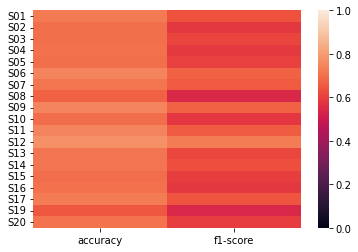

     class0 f1-score  class1 f1-score
S01         0.830189         0.210526
S02         0.818505         0.072727
S03         0.817869         0.131148
S04         0.822785         0.034483
S05         0.820144         0.074074
S06         0.845361         0.237288
S07         0.820690         0.277778
S08         0.802589         0.000000
S09         0.846154         0.250000
S10         0.815287         0.064516
S11         0.846975         0.188679
S12         0.858156         0.428571
S13         0.824324         0.161290
S14         0.820339         0.208955
S15         0.815789         0.096774
S16         0.822006         0.035088
S17         0.832117         0.206897
S19         0.789474         0.000000
S20         0.825083         0.070175


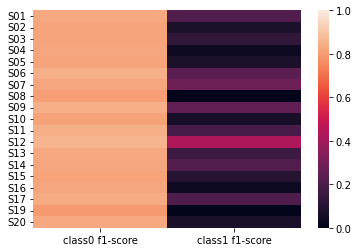

In [7]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [8]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [9]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [10]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-DF_Multivariate-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

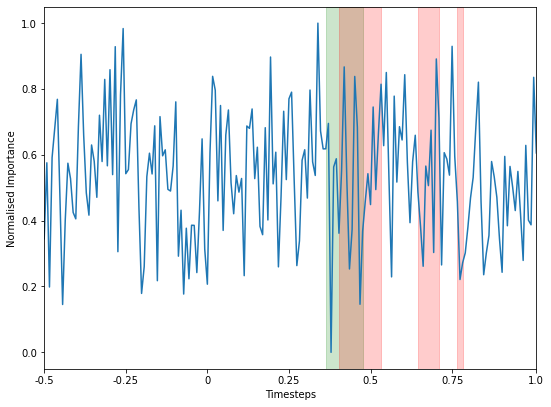

In [11]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(0).reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)
# df.index= channel_names
# df.columns=timestep_labels


plt.plot(df)
# plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()
#     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],
#                 xticklabels=False, cbar_kws={"pad":0.02})

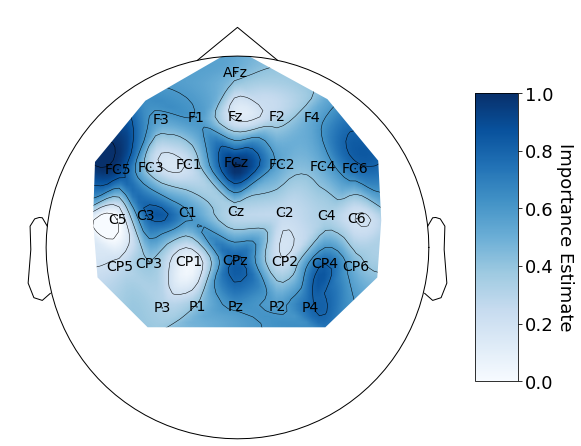

In [12]:
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(1).reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)